In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb
import pybaseball as pyb
import seaborn as sns

In [164]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [165]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [166]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [167]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"

    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']

    df['pfx_x_cor'] = np.where(df['p_throws'] == 'L', df['pfx_x'] * -1, df['pfx_x'])

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')

    dfs['height_ratio'] = dfs['release_pos_z'] / dfs['height_numeric']
    # Return the preprocessed DataFrame
    return dfs

In [168]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data, height_df)
testing_data_processed = preprocess_data(testing_data, height_df)


In [169]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')

# Fastball Model First

In [176]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric', 'pfx_x'
    ], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 'pfx_x',
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'Unnamed: 0', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [177]:
train_data = training_features.drop(['pfx_z'], axis=1).copy()
train_label = training_features['pfx_z'].copy()
testing_data = testing_features.drop(['pfx_z'], axis=1).copy()
testing_label = testing_features['pfx_z'].copy()

In [178]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'spin_axis', 'pfx_x_cor', 'height_ratio'],
      dtype='object')

In [179]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'spin_axis', 'pfx_x_cor', 'height_ratio'],
      dtype='object')

In [180]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [187]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

In [188]:
y_pred = model.predict(dtest)

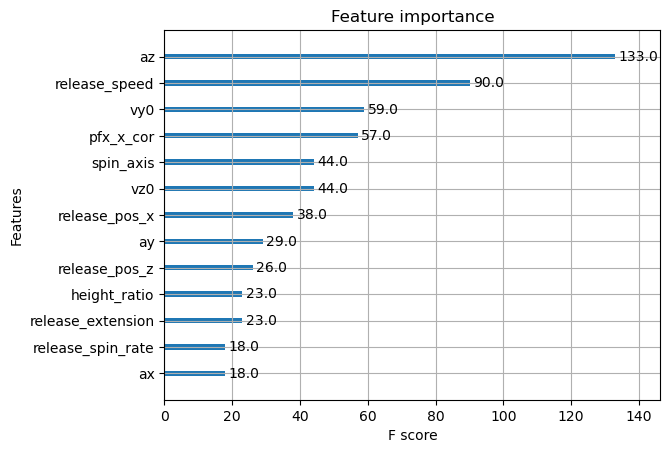

In [189]:
xgb.plot_importance(model)
plt.show()

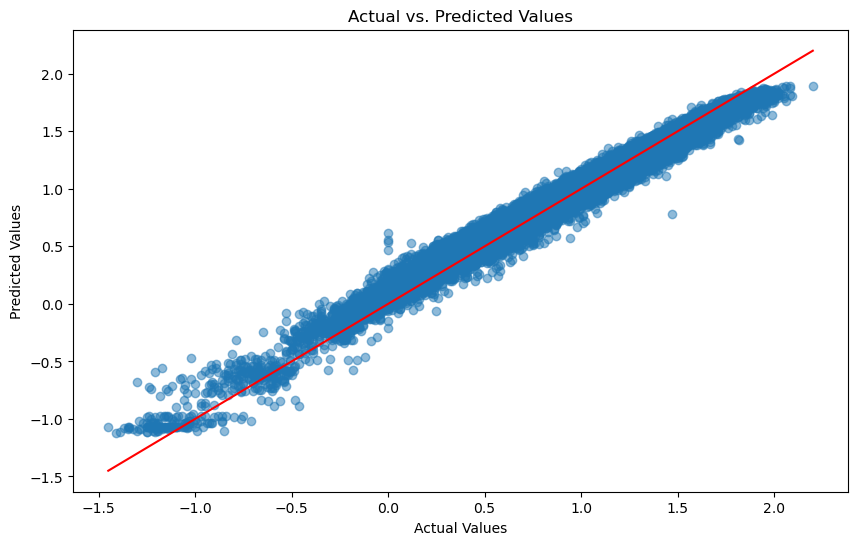

In [190]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

# Initial Paramater Tuning

In [191]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [192]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-10 10:09:18,247] A new study created in memory with name: no-name-6332f9b0-61e0-40a4-80d3-752aef3781b5


[0]	eval-rmse:0.36290
[1]	eval-rmse:0.24052
[2]	eval-rmse:0.22005
[3]	eval-rmse:0.16318
[4]	eval-rmse:0.13056
[5]	eval-rmse:0.12397
[6]	eval-rmse:0.12053
[7]	eval-rmse:0.09932
[8]	eval-rmse:0.08722
[9]	eval-rmse:0.07846
[10]	eval-rmse:0.07695
[11]	eval-rmse:0.07579
[12]	eval-rmse:0.06990
[13]	eval-rmse:0.06364
[14]	eval-rmse:0.06192
[15]	eval-rmse:0.05778
[16]	eval-rmse:0.05627
[17]	eval-rmse:0.05320
[18]	eval-rmse:0.05262
[19]	eval-rmse:0.05228
[20]	eval-rmse:0.05159
[21]	eval-rmse:0.04888
[22]	eval-rmse:0.04809
[23]	eval-rmse:0.04585
[24]	eval-rmse:0.04429
[25]	eval-rmse:0.04319
[26]	eval-rmse:0.04240
[27]	eval-rmse:0.04120
[28]	eval-rmse:0.04090
[29]	eval-rmse:0.04072
[30]	eval-rmse:0.04062
[31]	eval-rmse:0.03967
[32]	eval-rmse:0.03892
[33]	eval-rmse:0.03849
[34]	eval-rmse:0.03830
[35]	eval-rmse:0.03799
[36]	eval-rmse:0.03751
[37]	eval-rmse:0.03729
[38]	eval-rmse:0.03708
[39]	eval-rmse:0.03638
[40]	eval-rmse:0.03612
[41]	eval-rmse:0.03589
[42]	eval-rmse:0.03560
[43]	eval-rmse:0.0352

[I 2023-11-10 10:09:19,360] Trial 0 finished with value: 0.028616218151233025 and parameters: {'max_depth': 5, 'eta': 0.37539971138113537, 'subsample': 0.5214899282077079, 'colsample_bytree': 0.4831450833294668, 'min_child_weight': 5}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.37296
[1]	eval-rmse:0.26413
[2]	eval-rmse:0.24029
[3]	eval-rmse:0.18151
[4]	eval-rmse:0.14353
[5]	eval-rmse:0.13535
[6]	eval-rmse:0.13112
[7]	eval-rmse:0.10856
[8]	eval-rmse:0.09382
[9]	eval-rmse:0.08376
[10]	eval-rmse:0.08270
[11]	eval-rmse:0.08153
[12]	eval-rmse:0.07514
[13]	eval-rmse:0.06770
[14]	eval-rmse:0.06637
[15]	eval-rmse:0.06170
[16]	eval-rmse:0.06035
[17]	eval-rmse:0.05681
[18]	eval-rmse:0.05613
[19]	eval-rmse:0.05571
[20]	eval-rmse:0.05523
[21]	eval-rmse:0.05220
[22]	eval-rmse:0.05133
[23]	eval-rmse:0.04854
[24]	eval-rmse:0.04672
[25]	eval-rmse:0.04498
[26]	eval-rmse:0.04407
[27]	eval-rmse:0.04225
[28]	eval-rmse:0.04195
[29]	eval-rmse:0.04157
[30]	eval-rmse:0.04140
[31]	eval-rmse:0.03988
[32]	eval-rmse:0.03886
[33]	eval-rmse:0.03812
[34]	eval-rmse:0.03779
[35]	eval-rmse:0.03745
[36]	eval-rmse:0.03679
[37]	eval-rmse:0.03662
[38]	eval-rmse:0.03642
[39]	eval-rmse:0.03547
[40]	eval-rmse:0.03526
[41]	eval-rmse:0.03509
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.0342

[I 2023-11-10 10:09:20,318] Trial 1 finished with value: 0.026252064923501534 and parameters: {'max_depth': 5, 'eta': 0.31692422118984814, 'subsample': 0.5186821020141422, 'colsample_bytree': 0.5141452647459571, 'min_child_weight': 4}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.36622
[1]	eval-rmse:0.24865
[2]	eval-rmse:0.22679
[3]	eval-rmse:0.16951
[4]	eval-rmse:0.13365
[5]	eval-rmse:0.12633
[6]	eval-rmse:0.12260
[7]	eval-rmse:0.10168
[8]	eval-rmse:0.08877
[9]	eval-rmse:0.07932
[10]	eval-rmse:0.07806
[11]	eval-rmse:0.07697
[12]	eval-rmse:0.07139
[13]	eval-rmse:0.06460
[14]	eval-rmse:0.06310
[15]	eval-rmse:0.05865
[16]	eval-rmse:0.05721
[17]	eval-rmse:0.05353
[18]	eval-rmse:0.05293
[19]	eval-rmse:0.05256
[20]	eval-rmse:0.05190
[21]	eval-rmse:0.04910
[22]	eval-rmse:0.04827
[23]	eval-rmse:0.04549
[24]	eval-rmse:0.04366
[25]	eval-rmse:0.04246
[26]	eval-rmse:0.04178
[27]	eval-rmse:0.04036
[28]	eval-rmse:0.04006
[29]	eval-rmse:0.03971
[30]	eval-rmse:0.03955
[31]	eval-rmse:0.03846
[32]	eval-rmse:0.03761
[33]	eval-rmse:0.03705
[34]	eval-rmse:0.03679
[35]	eval-rmse:0.03651
[36]	eval-rmse:0.03599
[37]	eval-rmse:0.03578
[38]	eval-rmse:0.03555
[39]	eval-rmse:0.03475
[40]	eval-rmse:0.03459
[41]	eval-rmse:0.03440
[42]	eval-rmse:0.03428
[43]	eval-rmse:0.0337

[I 2023-11-10 10:09:21,269] Trial 2 finished with value: 0.026922444193656674 and parameters: {'max_depth': 5, 'eta': 0.355556524584041, 'subsample': 0.5309856992577614, 'colsample_bytree': 0.5081431017122595, 'min_child_weight': 3}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.37127
[1]	eval-rmse:0.26299
[2]	eval-rmse:0.24059
[3]	eval-rmse:0.18228
[4]	eval-rmse:0.14433
[5]	eval-rmse:0.13610
[6]	eval-rmse:0.13166
[7]	eval-rmse:0.10768
[8]	eval-rmse:0.09250
[9]	eval-rmse:0.08212
[10]	eval-rmse:0.07674
[11]	eval-rmse:0.07553
[12]	eval-rmse:0.07005
[13]	eval-rmse:0.06346
[14]	eval-rmse:0.06186
[15]	eval-rmse:0.05814
[16]	eval-rmse:0.05661
[17]	eval-rmse:0.05297
[18]	eval-rmse:0.05056
[19]	eval-rmse:0.05001
[20]	eval-rmse:0.04910
[21]	eval-rmse:0.04673
[22]	eval-rmse:0.04586
[23]	eval-rmse:0.04368
[24]	eval-rmse:0.04213
[25]	eval-rmse:0.04089
[26]	eval-rmse:0.04013
[27]	eval-rmse:0.03870
[28]	eval-rmse:0.03844
[29]	eval-rmse:0.03805
[30]	eval-rmse:0.03793
[31]	eval-rmse:0.03673
[32]	eval-rmse:0.03596
[33]	eval-rmse:0.03527
[34]	eval-rmse:0.03504
[35]	eval-rmse:0.03478
[36]	eval-rmse:0.03421
[37]	eval-rmse:0.03397
[38]	eval-rmse:0.03375
[39]	eval-rmse:0.03294
[40]	eval-rmse:0.03273
[41]	eval-rmse:0.03258
[42]	eval-rmse:0.03232
[43]	eval-rmse:0.0318

[I 2023-11-10 10:09:22,187] Trial 3 finished with value: 0.02488834442062925 and parameters: {'max_depth': 5, 'eta': 0.3168223070463285, 'subsample': 0.5496473874329573, 'colsample_bytree': 0.5518385243308666, 'min_child_weight': 5}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.38030
[1]	eval-rmse:0.28867
[2]	eval-rmse:0.26111
[3]	eval-rmse:0.20306
[4]	eval-rmse:0.15950
[5]	eval-rmse:0.14569
[6]	eval-rmse:0.13787
[7]	eval-rmse:0.11146
[8]	eval-rmse:0.09246
[9]	eval-rmse:0.09055
[10]	eval-rmse:0.08869
[11]	eval-rmse:0.08698
[12]	eval-rmse:0.07751
[13]	eval-rmse:0.06912
[14]	eval-rmse:0.06875
[15]	eval-rmse:0.06279
[16]	eval-rmse:0.06195
[17]	eval-rmse:0.05718
[18]	eval-rmse:0.05679
[19]	eval-rmse:0.05647
[20]	eval-rmse:0.05627
[21]	eval-rmse:0.05262
[22]	eval-rmse:0.05227
[23]	eval-rmse:0.04910
[24]	eval-rmse:0.04701
[25]	eval-rmse:0.04518
[26]	eval-rmse:0.04443
[27]	eval-rmse:0.04291
[28]	eval-rmse:0.04267
[29]	eval-rmse:0.04242
[30]	eval-rmse:0.04208
[31]	eval-rmse:0.04123
[32]	eval-rmse:0.04095
[33]	eval-rmse:0.04015
[34]	eval-rmse:0.03991
[35]	eval-rmse:0.03972
[36]	eval-rmse:0.03892
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03861
[39]	eval-rmse:0.03830
[40]	eval-rmse:0.03813
[41]	eval-rmse:0.03804
[42]	eval-rmse:0.03794
[43]	eval-rmse:0.0370

[I 2023-11-10 10:09:23,801] Trial 4 finished with value: 0.027817277334731716 and parameters: {'max_depth': 8, 'eta': 0.25043790241948766, 'subsample': 0.5018897740680353, 'colsample_bytree': 0.4393670239146447, 'min_child_weight': 3}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.37935
[1]	eval-rmse:0.27360
[2]	eval-rmse:0.25076
[3]	eval-rmse:0.19181
[4]	eval-rmse:0.15349
[5]	eval-rmse:0.14557
[6]	eval-rmse:0.14129
[7]	eval-rmse:0.12050
[8]	eval-rmse:0.10563
[9]	eval-rmse:0.09566
[10]	eval-rmse:0.09447
[11]	eval-rmse:0.09301
[12]	eval-rmse:0.08659
[13]	eval-rmse:0.07868
[14]	eval-rmse:0.07721
[15]	eval-rmse:0.07224
[16]	eval-rmse:0.07087
[17]	eval-rmse:0.06638
[18]	eval-rmse:0.06545
[19]	eval-rmse:0.06495
[20]	eval-rmse:0.06430
[21]	eval-rmse:0.06061
[22]	eval-rmse:0.05982
[23]	eval-rmse:0.05616
[24]	eval-rmse:0.05350
[25]	eval-rmse:0.05166
[26]	eval-rmse:0.05080
[27]	eval-rmse:0.04856
[28]	eval-rmse:0.04803
[29]	eval-rmse:0.04754
[30]	eval-rmse:0.04727
[31]	eval-rmse:0.04544
[32]	eval-rmse:0.04410
[33]	eval-rmse:0.04305
[34]	eval-rmse:0.04263
[35]	eval-rmse:0.04215
[36]	eval-rmse:0.04119
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.04059
[39]	eval-rmse:0.03943
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03860
[43]	eval-rmse:0.0376

[I 2023-11-10 10:09:24,608] Trial 5 finished with value: 0.026858714517521195 and parameters: {'max_depth': 4, 'eta': 0.3066747996487475, 'subsample': 0.45583202822646207, 'colsample_bytree': 0.5284914118132019, 'min_child_weight': 3}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.37417
[1]	eval-rmse:0.27371
[2]	eval-rmse:0.24829
[3]	eval-rmse:0.19003
[4]	eval-rmse:0.14897
[5]	eval-rmse:0.13872
[6]	eval-rmse:0.13314
[7]	eval-rmse:0.10843
[8]	eval-rmse:0.09199
[9]	eval-rmse:0.08009
[10]	eval-rmse:0.07396
[11]	eval-rmse:0.07286
[12]	eval-rmse:0.06706
[13]	eval-rmse:0.06047
[14]	eval-rmse:0.05943
[15]	eval-rmse:0.05522
[16]	eval-rmse:0.05395
[17]	eval-rmse:0.05055
[18]	eval-rmse:0.04820
[19]	eval-rmse:0.04778
[20]	eval-rmse:0.04698
[21]	eval-rmse:0.04526
[22]	eval-rmse:0.04453
[23]	eval-rmse:0.04214
[24]	eval-rmse:0.04068
[25]	eval-rmse:0.03945
[26]	eval-rmse:0.03896
[27]	eval-rmse:0.03755
[28]	eval-rmse:0.03736
[29]	eval-rmse:0.03701
[30]	eval-rmse:0.03689
[31]	eval-rmse:0.03581
[32]	eval-rmse:0.03513
[33]	eval-rmse:0.03450
[34]	eval-rmse:0.03430
[35]	eval-rmse:0.03400
[36]	eval-rmse:0.03352
[37]	eval-rmse:0.03337
[38]	eval-rmse:0.03315
[39]	eval-rmse:0.03244
[40]	eval-rmse:0.03223
[41]	eval-rmse:0.03204
[42]	eval-rmse:0.03186
[43]	eval-rmse:0.0314

[I 2023-11-10 10:09:25,651] Trial 6 finished with value: 0.02604285290373675 and parameters: {'max_depth': 6, 'eta': 0.28569338049305315, 'subsample': 0.4422090547782288, 'colsample_bytree': 0.5488721108477654, 'min_child_weight': 4}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.38586
[1]	eval-rmse:0.30625
[2]	eval-rmse:0.27805
[3]	eval-rmse:0.22424
[4]	eval-rmse:0.18151
[5]	eval-rmse:0.16621
[6]	eval-rmse:0.15697
[7]	eval-rmse:0.12979
[8]	eval-rmse:0.10894
[9]	eval-rmse:0.09266
[10]	eval-rmse:0.08191
[11]	eval-rmse:0.07998
[12]	eval-rmse:0.07119
[13]	eval-rmse:0.06355
[14]	eval-rmse:0.06292
[15]	eval-rmse:0.05755
[16]	eval-rmse:0.05680
[17]	eval-rmse:0.05245
[18]	eval-rmse:0.04910
[19]	eval-rmse:0.04878
[20]	eval-rmse:0.04843
[21]	eval-rmse:0.04584
[22]	eval-rmse:0.04545
[23]	eval-rmse:0.04292
[24]	eval-rmse:0.04125
[25]	eval-rmse:0.03985
[26]	eval-rmse:0.03949
[27]	eval-rmse:0.03764
[28]	eval-rmse:0.03748
[29]	eval-rmse:0.03721
[30]	eval-rmse:0.03709
[31]	eval-rmse:0.03560
[32]	eval-rmse:0.03476
[33]	eval-rmse:0.03400
[34]	eval-rmse:0.03384
[35]	eval-rmse:0.03367
[36]	eval-rmse:0.03312
[37]	eval-rmse:0.03297
[38]	eval-rmse:0.03279
[39]	eval-rmse:0.03193
[40]	eval-rmse:0.03179
[41]	eval-rmse:0.03166
[42]	eval-rmse:0.03161
[43]	eval-rmse:0.0311

[I 2023-11-10 10:09:27,192] Trial 7 finished with value: 0.02527260952518674 and parameters: {'max_depth': 8, 'eta': 0.21263272664846994, 'subsample': 0.5607247502694328, 'colsample_bytree': 0.5927802344168778, 'min_child_weight': 4}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.37973
[1]	eval-rmse:0.28685
[2]	eval-rmse:0.26087
[3]	eval-rmse:0.20337
[4]	eval-rmse:0.16140
[5]	eval-rmse:0.14981
[6]	eval-rmse:0.14313
[7]	eval-rmse:0.11722
[8]	eval-rmse:0.09931
[9]	eval-rmse:0.08644
[10]	eval-rmse:0.07888
[11]	eval-rmse:0.07766
[12]	eval-rmse:0.07101
[13]	eval-rmse:0.06380
[14]	eval-rmse:0.06302
[15]	eval-rmse:0.05841
[16]	eval-rmse:0.05740
[17]	eval-rmse:0.05359
[18]	eval-rmse:0.05089
[19]	eval-rmse:0.05048
[20]	eval-rmse:0.04977
[21]	eval-rmse:0.04753
[22]	eval-rmse:0.04679
[23]	eval-rmse:0.04423
[24]	eval-rmse:0.04252
[25]	eval-rmse:0.04122
[26]	eval-rmse:0.04061
[27]	eval-rmse:0.03881
[28]	eval-rmse:0.03856
[29]	eval-rmse:0.03819
[30]	eval-rmse:0.03805
[31]	eval-rmse:0.03658
[32]	eval-rmse:0.03563
[33]	eval-rmse:0.03482
[34]	eval-rmse:0.03464
[35]	eval-rmse:0.03431
[36]	eval-rmse:0.03367
[37]	eval-rmse:0.03349
[38]	eval-rmse:0.03330
[39]	eval-rmse:0.03231
[40]	eval-rmse:0.03209
[41]	eval-rmse:0.03189
[42]	eval-rmse:0.03174
[43]	eval-rmse:0.0311

[I 2023-11-10 10:09:28,228] Trial 8 finished with value: 0.024328069841777284 and parameters: {'max_depth': 6, 'eta': 0.25788755778882855, 'subsample': 0.5780005844375518, 'colsample_bytree': 0.5667613102607562, 'min_child_weight': 1}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.37222
[1]	eval-rmse:0.26566
[2]	eval-rmse:0.24263
[3]	eval-rmse:0.18399
[4]	eval-rmse:0.14526
[5]	eval-rmse:0.13671
[6]	eval-rmse:0.13202
[7]	eval-rmse:0.10798
[8]	eval-rmse:0.09259
[9]	eval-rmse:0.08189
[10]	eval-rmse:0.07698
[11]	eval-rmse:0.07549
[12]	eval-rmse:0.07026
[13]	eval-rmse:0.06320
[14]	eval-rmse:0.06175
[15]	eval-rmse:0.05756
[16]	eval-rmse:0.05614
[17]	eval-rmse:0.05257
[18]	eval-rmse:0.05013
[19]	eval-rmse:0.04953
[20]	eval-rmse:0.04858
[21]	eval-rmse:0.04676
[22]	eval-rmse:0.04600
[23]	eval-rmse:0.04389
[24]	eval-rmse:0.04240
[25]	eval-rmse:0.04115
[26]	eval-rmse:0.04048
[27]	eval-rmse:0.03913
[28]	eval-rmse:0.03888
[29]	eval-rmse:0.03862
[30]	eval-rmse:0.03847
[31]	eval-rmse:0.03724
[32]	eval-rmse:0.03636
[33]	eval-rmse:0.03564
[34]	eval-rmse:0.03534
[35]	eval-rmse:0.03490
[36]	eval-rmse:0.03428
[37]	eval-rmse:0.03405
[38]	eval-rmse:0.03392
[39]	eval-rmse:0.03326
[40]	eval-rmse:0.03296
[41]	eval-rmse:0.03279
[42]	eval-rmse:0.03259
[43]	eval-rmse:0.0320

[I 2023-11-10 10:09:29,127] Trial 9 finished with value: 0.02487972564698172 and parameters: {'max_depth': 5, 'eta': 0.31153607697039665, 'subsample': 0.5938802166013899, 'colsample_bytree': 0.5367796569421948, 'min_child_weight': 3}. Best is trial 0 with value: 0.028616218151233025.


[0]	eval-rmse:0.35530
[1]	eval-rmse:0.22948
[2]	eval-rmse:0.20759
[3]	eval-rmse:0.14989
[4]	eval-rmse:0.11486
[5]	eval-rmse:0.10693
[6]	eval-rmse:0.10381
[7]	eval-rmse:0.08184
[8]	eval-rmse:0.07070
[9]	eval-rmse:0.06904
[10]	eval-rmse:0.06790
[11]	eval-rmse:0.06730
[12]	eval-rmse:0.06273
[13]	eval-rmse:0.05824
[14]	eval-rmse:0.05759
[15]	eval-rmse:0.05485
[16]	eval-rmse:0.05335
[17]	eval-rmse:0.05034
[18]	eval-rmse:0.04995
[19]	eval-rmse:0.04964
[20]	eval-rmse:0.04941
[21]	eval-rmse:0.04733
[22]	eval-rmse:0.04663
[23]	eval-rmse:0.04475
[24]	eval-rmse:0.04384
[25]	eval-rmse:0.04294
[26]	eval-rmse:0.04191
[27]	eval-rmse:0.04118
[28]	eval-rmse:0.04108
[29]	eval-rmse:0.04080
[30]	eval-rmse:0.04041
[31]	eval-rmse:0.04002
[32]	eval-rmse:0.03972
[33]	eval-rmse:0.03925
[34]	eval-rmse:0.03904
[35]	eval-rmse:0.03892
[36]	eval-rmse:0.03857
[37]	eval-rmse:0.03846
[38]	eval-rmse:0.03834
[39]	eval-rmse:0.03805
[40]	eval-rmse:0.03796
[41]	eval-rmse:0.03790
[42]	eval-rmse:0.03774
[43]	eval-rmse:0.0373

[I 2023-11-10 10:09:30,326] Trial 10 finished with value: 0.03228406351337333 and parameters: {'max_depth': 7, 'eta': 0.3877368055276498, 'subsample': 0.40603980493612724, 'colsample_bytree': 0.46327355866477943, 'min_child_weight': 1}. Best is trial 10 with value: 0.03228406351337333.


[0]	eval-rmse:0.35359
[1]	eval-rmse:0.22574
[2]	eval-rmse:0.20464
[3]	eval-rmse:0.14751
[4]	eval-rmse:0.11340
[5]	eval-rmse:0.10550
[6]	eval-rmse:0.10257
[7]	eval-rmse:0.08111
[8]	eval-rmse:0.07060
[9]	eval-rmse:0.06878
[10]	eval-rmse:0.06763
[11]	eval-rmse:0.06704
[12]	eval-rmse:0.06259
[13]	eval-rmse:0.05777
[14]	eval-rmse:0.05711
[15]	eval-rmse:0.05426
[16]	eval-rmse:0.05273
[17]	eval-rmse:0.04985
[18]	eval-rmse:0.04950
[19]	eval-rmse:0.04921
[20]	eval-rmse:0.04899
[21]	eval-rmse:0.04707
[22]	eval-rmse:0.04643
[23]	eval-rmse:0.04484
[24]	eval-rmse:0.04403
[25]	eval-rmse:0.04320
[26]	eval-rmse:0.04217
[27]	eval-rmse:0.04128
[28]	eval-rmse:0.04111
[29]	eval-rmse:0.04076
[30]	eval-rmse:0.04039
[31]	eval-rmse:0.03996
[32]	eval-rmse:0.03973
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03891
[36]	eval-rmse:0.03858
[37]	eval-rmse:0.03844
[38]	eval-rmse:0.03832
[39]	eval-rmse:0.03800
[40]	eval-rmse:0.03794
[41]	eval-rmse:0.03790
[42]	eval-rmse:0.03779
[43]	eval-rmse:0.0374

[I 2023-11-10 10:09:31,469] Trial 11 finished with value: 0.03249199486506095 and parameters: {'max_depth': 7, 'eta': 0.3975936525195789, 'subsample': 0.40550605223379277, 'colsample_bytree': 0.4652562119164654, 'min_child_weight': 1}. Best is trial 11 with value: 0.03249199486506095.


[0]	eval-rmse:0.35469
[1]	eval-rmse:0.22835
[2]	eval-rmse:0.20684
[3]	eval-rmse:0.14926
[4]	eval-rmse:0.11442
[5]	eval-rmse:0.10632
[6]	eval-rmse:0.10319
[7]	eval-rmse:0.08139
[8]	eval-rmse:0.07051
[9]	eval-rmse:0.06868
[10]	eval-rmse:0.06757
[11]	eval-rmse:0.06710
[12]	eval-rmse:0.06256
[13]	eval-rmse:0.05780
[14]	eval-rmse:0.05718
[15]	eval-rmse:0.05429
[16]	eval-rmse:0.05278
[17]	eval-rmse:0.04985
[18]	eval-rmse:0.04943
[19]	eval-rmse:0.04908
[20]	eval-rmse:0.04882
[21]	eval-rmse:0.04656
[22]	eval-rmse:0.04599
[23]	eval-rmse:0.04430
[24]	eval-rmse:0.04332
[25]	eval-rmse:0.04230
[26]	eval-rmse:0.04137
[27]	eval-rmse:0.04072
[28]	eval-rmse:0.04062
[29]	eval-rmse:0.04034
[30]	eval-rmse:0.03992
[31]	eval-rmse:0.03945
[32]	eval-rmse:0.03921
[33]	eval-rmse:0.03878
[34]	eval-rmse:0.03859
[35]	eval-rmse:0.03851
[36]	eval-rmse:0.03817
[37]	eval-rmse:0.03801
[38]	eval-rmse:0.03789
[39]	eval-rmse:0.03760
[40]	eval-rmse:0.03750
[41]	eval-rmse:0.03745
[42]	eval-rmse:0.03732
[43]	eval-rmse:0.0369

[I 2023-11-10 10:09:32,641] Trial 12 finished with value: 0.03180868335361497 and parameters: {'max_depth': 7, 'eta': 0.3907693588295477, 'subsample': 0.41623079422489667, 'colsample_bytree': 0.4585088499198512, 'min_child_weight': 1}. Best is trial 11 with value: 0.03249199486506095.


[0]	eval-rmse:0.35432
[1]	eval-rmse:0.22716
[2]	eval-rmse:0.20551
[3]	eval-rmse:0.14824
[4]	eval-rmse:0.11396
[5]	eval-rmse:0.10598
[6]	eval-rmse:0.10293
[7]	eval-rmse:0.08129
[8]	eval-rmse:0.07041
[9]	eval-rmse:0.06875
[10]	eval-rmse:0.06744
[11]	eval-rmse:0.06692
[12]	eval-rmse:0.06235
[13]	eval-rmse:0.05774
[14]	eval-rmse:0.05711
[15]	eval-rmse:0.05431
[16]	eval-rmse:0.05287
[17]	eval-rmse:0.04989
[18]	eval-rmse:0.04945
[19]	eval-rmse:0.04925
[20]	eval-rmse:0.04900
[21]	eval-rmse:0.04708
[22]	eval-rmse:0.04636
[23]	eval-rmse:0.04464
[24]	eval-rmse:0.04375
[25]	eval-rmse:0.04279
[26]	eval-rmse:0.04181
[27]	eval-rmse:0.04110
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04073
[30]	eval-rmse:0.04031
[31]	eval-rmse:0.03992
[32]	eval-rmse:0.03969
[33]	eval-rmse:0.03932
[34]	eval-rmse:0.03915
[35]	eval-rmse:0.03891
[36]	eval-rmse:0.03860
[37]	eval-rmse:0.03841
[38]	eval-rmse:0.03835
[39]	eval-rmse:0.03804
[40]	eval-rmse:0.03791
[41]	eval-rmse:0.03786
[42]	eval-rmse:0.03774
[43]	eval-rmse:0.0373

[I 2023-11-10 10:09:33,786] Trial 13 finished with value: 0.032527760148940245 and parameters: {'max_depth': 7, 'eta': 0.39393896550703567, 'subsample': 0.40247030543289575, 'colsample_bytree': 0.411454991864106, 'min_child_weight': 2}. Best is trial 13 with value: 0.032527760148940245.


[0]	eval-rmse:0.36077
[1]	eval-rmse:0.24151
[2]	eval-rmse:0.21782
[3]	eval-rmse:0.15865
[4]	eval-rmse:0.12096
[5]	eval-rmse:0.11228
[6]	eval-rmse:0.10851
[7]	eval-rmse:0.08591
[8]	eval-rmse:0.07284
[9]	eval-rmse:0.07155
[10]	eval-rmse:0.07052
[11]	eval-rmse:0.06987
[12]	eval-rmse:0.06450
[13]	eval-rmse:0.05898
[14]	eval-rmse:0.05838
[15]	eval-rmse:0.05501
[16]	eval-rmse:0.05358
[17]	eval-rmse:0.05030
[18]	eval-rmse:0.04989
[19]	eval-rmse:0.04958
[20]	eval-rmse:0.04931
[21]	eval-rmse:0.04696
[22]	eval-rmse:0.04626
[23]	eval-rmse:0.04413
[24]	eval-rmse:0.04308
[25]	eval-rmse:0.04201
[26]	eval-rmse:0.04130
[27]	eval-rmse:0.04053
[28]	eval-rmse:0.04034
[29]	eval-rmse:0.04005
[30]	eval-rmse:0.03965
[31]	eval-rmse:0.03913
[32]	eval-rmse:0.03887
[33]	eval-rmse:0.03840
[34]	eval-rmse:0.03817
[35]	eval-rmse:0.03805
[36]	eval-rmse:0.03762
[37]	eval-rmse:0.03746
[38]	eval-rmse:0.03735
[39]	eval-rmse:0.03704
[40]	eval-rmse:0.03696
[41]	eval-rmse:0.03693
[42]	eval-rmse:0.03684
[43]	eval-rmse:0.0364

[I 2023-11-10 10:09:34,942] Trial 14 finished with value: 0.030960170835518653 and parameters: {'max_depth': 7, 'eta': 0.35712905945885676, 'subsample': 0.45853345670413165, 'colsample_bytree': 0.40271017328883446, 'min_child_weight': 2}. Best is trial 13 with value: 0.032527760148940245.


[0]	eval-rmse:0.35335
[1]	eval-rmse:0.22505
[2]	eval-rmse:0.20375
[3]	eval-rmse:0.14664
[4]	eval-rmse:0.11287
[5]	eval-rmse:0.10500
[6]	eval-rmse:0.10211
[7]	eval-rmse:0.08068
[8]	eval-rmse:0.06989
[9]	eval-rmse:0.06792
[10]	eval-rmse:0.06675
[11]	eval-rmse:0.06624
[12]	eval-rmse:0.06194
[13]	eval-rmse:0.05748
[14]	eval-rmse:0.05691
[15]	eval-rmse:0.05412
[16]	eval-rmse:0.05253
[17]	eval-rmse:0.04949
[18]	eval-rmse:0.04905
[19]	eval-rmse:0.04879
[20]	eval-rmse:0.04851
[21]	eval-rmse:0.04665
[22]	eval-rmse:0.04596
[23]	eval-rmse:0.04439
[24]	eval-rmse:0.04358
[25]	eval-rmse:0.04272
[26]	eval-rmse:0.04184
[27]	eval-rmse:0.04122
[28]	eval-rmse:0.04108
[29]	eval-rmse:0.04079
[30]	eval-rmse:0.04038
[31]	eval-rmse:0.03999
[32]	eval-rmse:0.03977
[33]	eval-rmse:0.03942
[34]	eval-rmse:0.03920
[35]	eval-rmse:0.03902
[36]	eval-rmse:0.03877
[37]	eval-rmse:0.03865
[38]	eval-rmse:0.03862
[39]	eval-rmse:0.03840
[40]	eval-rmse:0.03832
[41]	eval-rmse:0.03824
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0377

[I 2023-11-10 10:09:36,087] Trial 15 finished with value: 0.03350677526553354 and parameters: {'max_depth': 7, 'eta': 0.39949267976161906, 'subsample': 0.40144374086560675, 'colsample_bytree': 0.4158390263504184, 'min_child_weight': 2}. Best is trial 15 with value: 0.03350677526553354.


[0]	eval-rmse:0.35893
[1]	eval-rmse:0.23947
[2]	eval-rmse:0.21487
[3]	eval-rmse:0.15578
[4]	eval-rmse:0.11757
[5]	eval-rmse:0.10874
[6]	eval-rmse:0.10494
[7]	eval-rmse:0.08252
[8]	eval-rmse:0.07016
[9]	eval-rmse:0.06873
[10]	eval-rmse:0.06768
[11]	eval-rmse:0.06717
[12]	eval-rmse:0.06229
[13]	eval-rmse:0.05727
[14]	eval-rmse:0.05680
[15]	eval-rmse:0.05352
[16]	eval-rmse:0.05226
[17]	eval-rmse:0.04938
[18]	eval-rmse:0.04904
[19]	eval-rmse:0.04877
[20]	eval-rmse:0.04853
[21]	eval-rmse:0.04642
[22]	eval-rmse:0.04585
[23]	eval-rmse:0.04408
[24]	eval-rmse:0.04321
[25]	eval-rmse:0.04221
[26]	eval-rmse:0.04129
[27]	eval-rmse:0.04059
[28]	eval-rmse:0.04043
[29]	eval-rmse:0.04020
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03963
[32]	eval-rmse:0.03945
[33]	eval-rmse:0.03908
[34]	eval-rmse:0.03892
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03835
[37]	eval-rmse:0.03826
[38]	eval-rmse:0.03817
[39]	eval-rmse:0.03788
[40]	eval-rmse:0.03780
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03771
[43]	eval-rmse:0.0373

[I 2023-11-10 10:09:37,531] Trial 16 finished with value: 0.033183670020924816 and parameters: {'max_depth': 8, 'eta': 0.35708367855130874, 'subsample': 0.42710811483394945, 'colsample_bytree': 0.40014144138994595, 'min_child_weight': 2}. Best is trial 15 with value: 0.03350677526553354.


[0]	eval-rmse:0.36028
[1]	eval-rmse:0.24238
[2]	eval-rmse:0.21755
[3]	eval-rmse:0.15815
[4]	eval-rmse:0.11936
[5]	eval-rmse:0.11023
[6]	eval-rmse:0.10614
[7]	eval-rmse:0.08353
[8]	eval-rmse:0.07063
[9]	eval-rmse:0.06911
[10]	eval-rmse:0.06809
[11]	eval-rmse:0.06757
[12]	eval-rmse:0.06258
[13]	eval-rmse:0.05748
[14]	eval-rmse:0.05693
[15]	eval-rmse:0.05360
[16]	eval-rmse:0.05235
[17]	eval-rmse:0.04931
[18]	eval-rmse:0.04897
[19]	eval-rmse:0.04860
[20]	eval-rmse:0.04836
[21]	eval-rmse:0.04615
[22]	eval-rmse:0.04558
[23]	eval-rmse:0.04364
[24]	eval-rmse:0.04271
[25]	eval-rmse:0.04150
[26]	eval-rmse:0.04074
[27]	eval-rmse:0.03997
[28]	eval-rmse:0.03979
[29]	eval-rmse:0.03963
[30]	eval-rmse:0.03940
[31]	eval-rmse:0.03900
[32]	eval-rmse:0.03878
[33]	eval-rmse:0.03838
[34]	eval-rmse:0.03821
[35]	eval-rmse:0.03807
[36]	eval-rmse:0.03776
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03753
[39]	eval-rmse:0.03724
[40]	eval-rmse:0.03715
[41]	eval-rmse:0.03711
[42]	eval-rmse:0.03702
[43]	eval-rmse:0.0366

[I 2023-11-10 10:09:38,968] Trial 17 finished with value: 0.032270294714298015 and parameters: {'max_depth': 8, 'eta': 0.35045583638460065, 'subsample': 0.43254262789142023, 'colsample_bytree': 0.42534735790147415, 'min_child_weight': 2}. Best is trial 15 with value: 0.03350677526553354.


[0]	eval-rmse:0.36232
[1]	eval-rmse:0.24700
[2]	eval-rmse:0.22158
[3]	eval-rmse:0.16185
[4]	eval-rmse:0.12232
[5]	eval-rmse:0.11292
[6]	eval-rmse:0.10846
[7]	eval-rmse:0.08546
[8]	eval-rmse:0.07195
[9]	eval-rmse:0.07048
[10]	eval-rmse:0.06945
[11]	eval-rmse:0.06879
[12]	eval-rmse:0.06331
[13]	eval-rmse:0.05822
[14]	eval-rmse:0.05780
[15]	eval-rmse:0.05439
[16]	eval-rmse:0.05306
[17]	eval-rmse:0.04986
[18]	eval-rmse:0.04947
[19]	eval-rmse:0.04919
[20]	eval-rmse:0.04897
[21]	eval-rmse:0.04654
[22]	eval-rmse:0.04594
[23]	eval-rmse:0.04391
[24]	eval-rmse:0.04290
[25]	eval-rmse:0.04175
[26]	eval-rmse:0.04087
[27]	eval-rmse:0.04005
[28]	eval-rmse:0.03986
[29]	eval-rmse:0.03963
[30]	eval-rmse:0.03931
[31]	eval-rmse:0.03884
[32]	eval-rmse:0.03863
[33]	eval-rmse:0.03814
[34]	eval-rmse:0.03795
[35]	eval-rmse:0.03777
[36]	eval-rmse:0.03739
[37]	eval-rmse:0.03730
[38]	eval-rmse:0.03721
[39]	eval-rmse:0.03697
[40]	eval-rmse:0.03684
[41]	eval-rmse:0.03679
[42]	eval-rmse:0.03672
[43]	eval-rmse:0.0362

[I 2023-11-10 10:09:40,444] Trial 18 finished with value: 0.03125344761441122 and parameters: {'max_depth': 8, 'eta': 0.3391504325920758, 'subsample': 0.4784164372617529, 'colsample_bytree': 0.42698340182368494, 'min_child_weight': 2}. Best is trial 15 with value: 0.03350677526553354.


[0]	eval-rmse:0.35644
[1]	eval-rmse:0.23388
[2]	eval-rmse:0.21020
[3]	eval-rmse:0.15169
[4]	eval-rmse:0.11450
[5]	eval-rmse:0.10600
[6]	eval-rmse:0.10250
[7]	eval-rmse:0.08058
[8]	eval-rmse:0.06882
[9]	eval-rmse:0.06748
[10]	eval-rmse:0.06644
[11]	eval-rmse:0.06589
[12]	eval-rmse:0.06140
[13]	eval-rmse:0.05675
[14]	eval-rmse:0.05619
[15]	eval-rmse:0.05326
[16]	eval-rmse:0.05199
[17]	eval-rmse:0.04917
[18]	eval-rmse:0.04885
[19]	eval-rmse:0.04863
[20]	eval-rmse:0.04835
[21]	eval-rmse:0.04629
[22]	eval-rmse:0.04577
[23]	eval-rmse:0.04413
[24]	eval-rmse:0.04330
[25]	eval-rmse:0.04231
[26]	eval-rmse:0.04131
[27]	eval-rmse:0.04077
[28]	eval-rmse:0.04062
[29]	eval-rmse:0.04039
[30]	eval-rmse:0.04020
[31]	eval-rmse:0.03982
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03939
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03919
[36]	eval-rmse:0.03887
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03865
[39]	eval-rmse:0.03842
[40]	eval-rmse:0.03831
[41]	eval-rmse:0.03832
[42]	eval-rmse:0.03824
[43]	eval-rmse:0.0379

[I 2023-11-10 10:09:41,876] Trial 19 finished with value: 0.03400143645064292 and parameters: {'max_depth': 8, 'eta': 0.3708643061579664, 'subsample': 0.4273353681741726, 'colsample_bytree': 0.40001048881175905, 'min_child_weight': 2}. Best is trial 19 with value: 0.03400143645064292.


[0]	eval-rmse:0.36048
[1]	eval-rmse:0.23842
[2]	eval-rmse:0.21737
[3]	eval-rmse:0.15856
[4]	eval-rmse:0.12326
[5]	eval-rmse:0.11560
[6]	eval-rmse:0.11213
[7]	eval-rmse:0.08982
[8]	eval-rmse:0.07767
[9]	eval-rmse:0.07627
[10]	eval-rmse:0.07518
[11]	eval-rmse:0.07442
[12]	eval-rmse:0.06853
[13]	eval-rmse:0.06281
[14]	eval-rmse:0.06191
[15]	eval-rmse:0.05826
[16]	eval-rmse:0.05633
[17]	eval-rmse:0.05244
[18]	eval-rmse:0.05190
[19]	eval-rmse:0.05158
[20]	eval-rmse:0.05127
[21]	eval-rmse:0.04877
[22]	eval-rmse:0.04806
[23]	eval-rmse:0.04568
[24]	eval-rmse:0.04440
[25]	eval-rmse:0.04307
[26]	eval-rmse:0.04217
[27]	eval-rmse:0.04121
[28]	eval-rmse:0.04107
[29]	eval-rmse:0.04071
[30]	eval-rmse:0.04047
[31]	eval-rmse:0.03980
[32]	eval-rmse:0.03949
[33]	eval-rmse:0.03899
[34]	eval-rmse:0.03874
[35]	eval-rmse:0.03842
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03780
[38]	eval-rmse:0.03766
[39]	eval-rmse:0.03730
[40]	eval-rmse:0.03716
[41]	eval-rmse:0.03708
[42]	eval-rmse:0.03694
[43]	eval-rmse:0.0364

[I 2023-11-10 10:09:42,860] Trial 20 finished with value: 0.029801294759496406 and parameters: {'max_depth': 6, 'eta': 0.37166583134028297, 'subsample': 0.42764292596928893, 'colsample_bytree': 0.4422399176661691, 'min_child_weight': 2}. Best is trial 19 with value: 0.03400143645064292.


[0]	eval-rmse:0.35564
[1]	eval-rmse:0.23209
[2]	eval-rmse:0.20852
[3]	eval-rmse:0.15035
[4]	eval-rmse:0.11350
[5]	eval-rmse:0.10532
[6]	eval-rmse:0.10188
[7]	eval-rmse:0.07971
[8]	eval-rmse:0.06828
[9]	eval-rmse:0.06674
[10]	eval-rmse:0.06575
[11]	eval-rmse:0.06522
[12]	eval-rmse:0.06081
[13]	eval-rmse:0.05614
[14]	eval-rmse:0.05566
[15]	eval-rmse:0.05287
[16]	eval-rmse:0.05166
[17]	eval-rmse:0.04883
[18]	eval-rmse:0.04853
[19]	eval-rmse:0.04829
[20]	eval-rmse:0.04806
[21]	eval-rmse:0.04617
[22]	eval-rmse:0.04558
[23]	eval-rmse:0.04397
[24]	eval-rmse:0.04322
[25]	eval-rmse:0.04239
[26]	eval-rmse:0.04167
[27]	eval-rmse:0.04106
[28]	eval-rmse:0.04087
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04038
[31]	eval-rmse:0.04004
[32]	eval-rmse:0.03991
[33]	eval-rmse:0.03957
[34]	eval-rmse:0.03949
[35]	eval-rmse:0.03932
[36]	eval-rmse:0.03902
[37]	eval-rmse:0.03889
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03866
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03843
[43]	eval-rmse:0.0381

[I 2023-11-10 10:09:44,295] Trial 21 finished with value: 0.03435671820551638 and parameters: {'max_depth': 8, 'eta': 0.3755738732734231, 'subsample': 0.4236879507655947, 'colsample_bytree': 0.4039182002777094, 'min_child_weight': 2}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35564
[1]	eval-rmse:0.23242
[2]	eval-rmse:0.20873
[3]	eval-rmse:0.15030
[4]	eval-rmse:0.11302
[5]	eval-rmse:0.10482
[6]	eval-rmse:0.10137
[7]	eval-rmse:0.07939
[8]	eval-rmse:0.06805
[9]	eval-rmse:0.06647
[10]	eval-rmse:0.06551
[11]	eval-rmse:0.06509
[12]	eval-rmse:0.06080
[13]	eval-rmse:0.05631
[14]	eval-rmse:0.05577
[15]	eval-rmse:0.05296
[16]	eval-rmse:0.05177
[17]	eval-rmse:0.04919
[18]	eval-rmse:0.04892
[19]	eval-rmse:0.04864
[20]	eval-rmse:0.04840
[21]	eval-rmse:0.04657
[22]	eval-rmse:0.04597
[23]	eval-rmse:0.04427
[24]	eval-rmse:0.04346
[25]	eval-rmse:0.04255
[26]	eval-rmse:0.04157
[27]	eval-rmse:0.04099
[28]	eval-rmse:0.04075
[29]	eval-rmse:0.04053
[30]	eval-rmse:0.04023
[31]	eval-rmse:0.03992
[32]	eval-rmse:0.03973
[33]	eval-rmse:0.03933
[34]	eval-rmse:0.03922
[35]	eval-rmse:0.03909
[36]	eval-rmse:0.03878
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03853
[39]	eval-rmse:0.03832
[40]	eval-rmse:0.03822
[41]	eval-rmse:0.03822
[42]	eval-rmse:0.03811
[43]	eval-rmse:0.0377

[I 2023-11-10 10:09:45,732] Trial 22 finished with value: 0.03405623207607905 and parameters: {'max_depth': 8, 'eta': 0.3738278348529386, 'subsample': 0.4520948291181326, 'colsample_bytree': 0.4194762027502189, 'min_child_weight': 2}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.36334
[1]	eval-rmse:0.24936
[2]	eval-rmse:0.22327
[3]	eval-rmse:0.16366
[4]	eval-rmse:0.12390
[5]	eval-rmse:0.11424
[6]	eval-rmse:0.10968
[7]	eval-rmse:0.08665
[8]	eval-rmse:0.07310
[9]	eval-rmse:0.07180
[10]	eval-rmse:0.07074
[11]	eval-rmse:0.07001
[12]	eval-rmse:0.06448
[13]	eval-rmse:0.05898
[14]	eval-rmse:0.05849
[15]	eval-rmse:0.05497
[16]	eval-rmse:0.05375
[17]	eval-rmse:0.05048
[18]	eval-rmse:0.05005
[19]	eval-rmse:0.04973
[20]	eval-rmse:0.04949
[21]	eval-rmse:0.04711
[22]	eval-rmse:0.04642
[23]	eval-rmse:0.04433
[24]	eval-rmse:0.04326
[25]	eval-rmse:0.04213
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.04049
[28]	eval-rmse:0.04031
[29]	eval-rmse:0.04008
[30]	eval-rmse:0.03970
[31]	eval-rmse:0.03927
[32]	eval-rmse:0.03903
[33]	eval-rmse:0.03856
[34]	eval-rmse:0.03836
[35]	eval-rmse:0.03819
[36]	eval-rmse:0.03778
[37]	eval-rmse:0.03768
[38]	eval-rmse:0.03756
[39]	eval-rmse:0.03725
[40]	eval-rmse:0.03707
[41]	eval-rmse:0.03705
[42]	eval-rmse:0.03696
[43]	eval-rmse:0.0365

[I 2023-11-10 10:09:47,188] Trial 23 finished with value: 0.031376418687761316 and parameters: {'max_depth': 8, 'eta': 0.3335547263679354, 'subsample': 0.4526091763894468, 'colsample_bytree': 0.40080783790652436, 'min_child_weight': 1}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35563
[1]	eval-rmse:0.23225
[2]	eval-rmse:0.20852
[3]	eval-rmse:0.14993
[4]	eval-rmse:0.11329
[5]	eval-rmse:0.10483
[6]	eval-rmse:0.10139
[7]	eval-rmse:0.07959
[8]	eval-rmse:0.06830
[9]	eval-rmse:0.06665
[10]	eval-rmse:0.06557
[11]	eval-rmse:0.06506
[12]	eval-rmse:0.06073
[13]	eval-rmse:0.05630
[14]	eval-rmse:0.05579
[15]	eval-rmse:0.05300
[16]	eval-rmse:0.05170
[17]	eval-rmse:0.04895
[18]	eval-rmse:0.04858
[19]	eval-rmse:0.04834
[20]	eval-rmse:0.04812
[21]	eval-rmse:0.04622
[22]	eval-rmse:0.04557
[23]	eval-rmse:0.04393
[24]	eval-rmse:0.04320
[25]	eval-rmse:0.04226
[26]	eval-rmse:0.04133
[27]	eval-rmse:0.04069
[28]	eval-rmse:0.04053
[29]	eval-rmse:0.04032
[30]	eval-rmse:0.04002
[31]	eval-rmse:0.03965
[32]	eval-rmse:0.03947
[33]	eval-rmse:0.03919
[34]	eval-rmse:0.03900
[35]	eval-rmse:0.03882
[36]	eval-rmse:0.03848
[37]	eval-rmse:0.03839
[38]	eval-rmse:0.03829
[39]	eval-rmse:0.03802
[40]	eval-rmse:0.03795
[41]	eval-rmse:0.03793
[42]	eval-rmse:0.03787
[43]	eval-rmse:0.0375

[I 2023-11-10 10:09:48,609] Trial 24 finished with value: 0.033287700307655675 and parameters: {'max_depth': 8, 'eta': 0.3740373028211015, 'subsample': 0.47326142997862397, 'colsample_bytree': 0.42960856653480406, 'min_child_weight': 2}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35574
[1]	eval-rmse:0.23266
[2]	eval-rmse:0.20913
[3]	eval-rmse:0.15066
[4]	eval-rmse:0.11323
[5]	eval-rmse:0.10494
[6]	eval-rmse:0.10157
[7]	eval-rmse:0.07987
[8]	eval-rmse:0.06841
[9]	eval-rmse:0.06673
[10]	eval-rmse:0.06570
[11]	eval-rmse:0.06524
[12]	eval-rmse:0.06073
[13]	eval-rmse:0.05624
[14]	eval-rmse:0.05565
[15]	eval-rmse:0.05290
[16]	eval-rmse:0.05166
[17]	eval-rmse:0.04889
[18]	eval-rmse:0.04856
[19]	eval-rmse:0.04829
[20]	eval-rmse:0.04813
[21]	eval-rmse:0.04623
[22]	eval-rmse:0.04565
[23]	eval-rmse:0.04403
[24]	eval-rmse:0.04326
[25]	eval-rmse:0.04238
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04083
[28]	eval-rmse:0.04065
[29]	eval-rmse:0.04046
[30]	eval-rmse:0.04009
[31]	eval-rmse:0.03974
[32]	eval-rmse:0.03961
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03918
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03872
[37]	eval-rmse:0.03869
[38]	eval-rmse:0.03854
[39]	eval-rmse:0.03833
[40]	eval-rmse:0.03818
[41]	eval-rmse:0.03819
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0377

[I 2023-11-10 10:09:50,054] Trial 25 finished with value: 0.03342528864396503 and parameters: {'max_depth': 8, 'eta': 0.372967686391557, 'subsample': 0.4394978257494955, 'colsample_bytree': 0.4146484179239761, 'min_child_weight': 3}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.36510
[1]	eval-rmse:0.25126
[2]	eval-rmse:0.22644
[3]	eval-rmse:0.16676
[4]	eval-rmse:0.12711
[5]	eval-rmse:0.11774
[6]	eval-rmse:0.11342
[7]	eval-rmse:0.09029
[8]	eval-rmse:0.07600
[9]	eval-rmse:0.07451
[10]	eval-rmse:0.07341
[11]	eval-rmse:0.07267
[12]	eval-rmse:0.06661
[13]	eval-rmse:0.06072
[14]	eval-rmse:0.06022
[15]	eval-rmse:0.05644
[16]	eval-rmse:0.05500
[17]	eval-rmse:0.05144
[18]	eval-rmse:0.05095
[19]	eval-rmse:0.05066
[20]	eval-rmse:0.05041
[21]	eval-rmse:0.04776
[22]	eval-rmse:0.04715
[23]	eval-rmse:0.04486
[24]	eval-rmse:0.04361
[25]	eval-rmse:0.04248
[26]	eval-rmse:0.04183
[27]	eval-rmse:0.04088
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04035
[30]	eval-rmse:0.03999
[31]	eval-rmse:0.03945
[32]	eval-rmse:0.03918
[33]	eval-rmse:0.03875
[34]	eval-rmse:0.03854
[35]	eval-rmse:0.03837
[36]	eval-rmse:0.03794
[37]	eval-rmse:0.03783
[38]	eval-rmse:0.03776
[39]	eval-rmse:0.03747
[40]	eval-rmse:0.03734
[41]	eval-rmse:0.03731
[42]	eval-rmse:0.03718
[43]	eval-rmse:0.0366

[I 2023-11-10 10:09:51,245] Trial 26 finished with value: 0.030264354716000284 and parameters: {'max_depth': 7, 'eta': 0.33395516088806315, 'subsample': 0.42032215472072854, 'colsample_bytree': 0.44394031316122406, 'min_child_weight': 2}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35475
[1]	eval-rmse:0.23028
[2]	eval-rmse:0.20685
[3]	eval-rmse:0.14858
[4]	eval-rmse:0.11236
[5]	eval-rmse:0.10418
[6]	eval-rmse:0.10086
[7]	eval-rmse:0.07905
[8]	eval-rmse:0.06806
[9]	eval-rmse:0.06643
[10]	eval-rmse:0.06534
[11]	eval-rmse:0.06483
[12]	eval-rmse:0.06060
[13]	eval-rmse:0.05600
[14]	eval-rmse:0.05550
[15]	eval-rmse:0.05289
[16]	eval-rmse:0.05163
[17]	eval-rmse:0.04896
[18]	eval-rmse:0.04861
[19]	eval-rmse:0.04840
[20]	eval-rmse:0.04814
[21]	eval-rmse:0.04623
[22]	eval-rmse:0.04572
[23]	eval-rmse:0.04409
[24]	eval-rmse:0.04331
[25]	eval-rmse:0.04239
[26]	eval-rmse:0.04138
[27]	eval-rmse:0.04079
[28]	eval-rmse:0.04066
[29]	eval-rmse:0.04043
[30]	eval-rmse:0.04026
[31]	eval-rmse:0.03993
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03930
[35]	eval-rmse:0.03917
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03883
[38]	eval-rmse:0.03876
[39]	eval-rmse:0.03852
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03837
[42]	eval-rmse:0.03827
[43]	eval-rmse:0.0380

[I 2023-11-10 10:09:52,690] Trial 27 finished with value: 0.033684188155254806 and parameters: {'max_depth': 8, 'eta': 0.378976618482732, 'subsample': 0.4738054747336863, 'colsample_bytree': 0.4199392839253693, 'min_child_weight': 3}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.36196
[1]	eval-rmse:0.24163
[2]	eval-rmse:0.21977
[3]	eval-rmse:0.16071
[4]	eval-rmse:0.12503
[5]	eval-rmse:0.11684
[6]	eval-rmse:0.11330
[7]	eval-rmse:0.09118
[8]	eval-rmse:0.07826
[9]	eval-rmse:0.07671
[10]	eval-rmse:0.07559
[11]	eval-rmse:0.07490
[12]	eval-rmse:0.06884
[13]	eval-rmse:0.06309
[14]	eval-rmse:0.06228
[15]	eval-rmse:0.05858
[16]	eval-rmse:0.05670
[17]	eval-rmse:0.05278
[18]	eval-rmse:0.05223
[19]	eval-rmse:0.05185
[20]	eval-rmse:0.05152
[21]	eval-rmse:0.04886
[22]	eval-rmse:0.04816
[23]	eval-rmse:0.04596
[24]	eval-rmse:0.04461
[25]	eval-rmse:0.04323
[26]	eval-rmse:0.04216
[27]	eval-rmse:0.04111
[28]	eval-rmse:0.04096
[29]	eval-rmse:0.04064
[30]	eval-rmse:0.04036
[31]	eval-rmse:0.03969
[32]	eval-rmse:0.03932
[33]	eval-rmse:0.03875
[34]	eval-rmse:0.03849
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03770
[37]	eval-rmse:0.03757
[38]	eval-rmse:0.03744
[39]	eval-rmse:0.03714
[40]	eval-rmse:0.03699
[41]	eval-rmse:0.03692
[42]	eval-rmse:0.03674
[43]	eval-rmse:0.0361

[I 2023-11-10 10:09:53,669] Trial 28 finished with value: 0.02910718612484063 and parameters: {'max_depth': 6, 'eta': 0.36386784684976864, 'subsample': 0.44370929196149855, 'colsample_bytree': 0.43342186543597566, 'min_child_weight': 1}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.36821
[1]	eval-rmse:0.24602
[2]	eval-rmse:0.22710
[3]	eval-rmse:0.16889
[4]	eval-rmse:0.13690
[5]	eval-rmse:0.13084
[6]	eval-rmse:0.12761
[7]	eval-rmse:0.10772
[8]	eval-rmse:0.09568
[9]	eval-rmse:0.08786
[10]	eval-rmse:0.08658
[11]	eval-rmse:0.08529
[12]	eval-rmse:0.07940
[13]	eval-rmse:0.07214
[14]	eval-rmse:0.07055
[15]	eval-rmse:0.06617
[16]	eval-rmse:0.06470
[17]	eval-rmse:0.06057
[18]	eval-rmse:0.05970
[19]	eval-rmse:0.05914
[20]	eval-rmse:0.05840
[21]	eval-rmse:0.05540
[22]	eval-rmse:0.05467
[23]	eval-rmse:0.05181
[24]	eval-rmse:0.04995
[25]	eval-rmse:0.04855
[26]	eval-rmse:0.04745
[27]	eval-rmse:0.04551
[28]	eval-rmse:0.04508
[29]	eval-rmse:0.04470
[30]	eval-rmse:0.04454
[31]	eval-rmse:0.04344
[32]	eval-rmse:0.04246
[33]	eval-rmse:0.04191
[34]	eval-rmse:0.04152
[35]	eval-rmse:0.04104
[36]	eval-rmse:0.04028
[37]	eval-rmse:0.04006
[38]	eval-rmse:0.03992
[39]	eval-rmse:0.03912
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0377

[I 2023-11-10 10:09:54,439] Trial 29 finished with value: 0.029052302933861053 and parameters: {'max_depth': 4, 'eta': 0.37767322025371486, 'subsample': 0.419114259660635, 'colsample_bytree': 0.4869337771306207, 'min_child_weight': 2}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.36090
[1]	eval-rmse:0.24368
[2]	eval-rmse:0.21863
[3]	eval-rmse:0.15917
[4]	eval-rmse:0.12033
[5]	eval-rmse:0.11102
[6]	eval-rmse:0.10691
[7]	eval-rmse:0.08399
[8]	eval-rmse:0.07110
[9]	eval-rmse:0.06956
[10]	eval-rmse:0.06856
[11]	eval-rmse:0.06802
[12]	eval-rmse:0.06290
[13]	eval-rmse:0.05774
[14]	eval-rmse:0.05722
[15]	eval-rmse:0.05381
[16]	eval-rmse:0.05258
[17]	eval-rmse:0.04954
[18]	eval-rmse:0.04915
[19]	eval-rmse:0.04885
[20]	eval-rmse:0.04867
[21]	eval-rmse:0.04634
[22]	eval-rmse:0.04578
[23]	eval-rmse:0.04387
[24]	eval-rmse:0.04295
[25]	eval-rmse:0.04182
[26]	eval-rmse:0.04089
[27]	eval-rmse:0.04013
[28]	eval-rmse:0.03997
[29]	eval-rmse:0.03973
[30]	eval-rmse:0.03942
[31]	eval-rmse:0.03905
[32]	eval-rmse:0.03890
[33]	eval-rmse:0.03846
[34]	eval-rmse:0.03832
[35]	eval-rmse:0.03821
[36]	eval-rmse:0.03781
[37]	eval-rmse:0.03764
[38]	eval-rmse:0.03753
[39]	eval-rmse:0.03726
[40]	eval-rmse:0.03716
[41]	eval-rmse:0.03716
[42]	eval-rmse:0.03709
[43]	eval-rmse:0.0366

[I 2023-11-10 10:09:55,868] Trial 30 finished with value: 0.0320091658571908 and parameters: {'max_depth': 8, 'eta': 0.3474492799553799, 'subsample': 0.4345691143301749, 'colsample_bytree': 0.4109658924017231, 'min_child_weight': 3}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35404
[1]	eval-rmse:0.22878
[2]	eval-rmse:0.20555
[3]	eval-rmse:0.14740
[4]	eval-rmse:0.11149
[5]	eval-rmse:0.10338
[6]	eval-rmse:0.10019
[7]	eval-rmse:0.07835
[8]	eval-rmse:0.06746
[9]	eval-rmse:0.06608
[10]	eval-rmse:0.06501
[11]	eval-rmse:0.06451
[12]	eval-rmse:0.06037
[13]	eval-rmse:0.05587
[14]	eval-rmse:0.05527
[15]	eval-rmse:0.05269
[16]	eval-rmse:0.05149
[17]	eval-rmse:0.04886
[18]	eval-rmse:0.04851
[19]	eval-rmse:0.04833
[20]	eval-rmse:0.04813
[21]	eval-rmse:0.04634
[22]	eval-rmse:0.04578
[23]	eval-rmse:0.04415
[24]	eval-rmse:0.04348
[25]	eval-rmse:0.04256
[26]	eval-rmse:0.04162
[27]	eval-rmse:0.04105
[28]	eval-rmse:0.04093
[29]	eval-rmse:0.04072
[30]	eval-rmse:0.04043
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03959
[34]	eval-rmse:0.03947
[35]	eval-rmse:0.03931
[36]	eval-rmse:0.03897
[37]	eval-rmse:0.03883
[38]	eval-rmse:0.03875
[39]	eval-rmse:0.03848
[40]	eval-rmse:0.03835
[41]	eval-rmse:0.03831
[42]	eval-rmse:0.03821
[43]	eval-rmse:0.0379

[I 2023-11-10 10:09:57,304] Trial 31 finished with value: 0.0338123894061744 and parameters: {'max_depth': 8, 'eta': 0.3830268255888947, 'subsample': 0.4765922036848081, 'colsample_bytree': 0.41662763315365753, 'min_child_weight': 3}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35374
[1]	eval-rmse:0.22839
[2]	eval-rmse:0.20529
[3]	eval-rmse:0.14753
[4]	eval-rmse:0.11136
[5]	eval-rmse:0.10340
[6]	eval-rmse:0.10022
[7]	eval-rmse:0.07855
[8]	eval-rmse:0.06761
[9]	eval-rmse:0.06586
[10]	eval-rmse:0.06471
[11]	eval-rmse:0.06420
[12]	eval-rmse:0.06008
[13]	eval-rmse:0.05586
[14]	eval-rmse:0.05534
[15]	eval-rmse:0.05270
[16]	eval-rmse:0.05147
[17]	eval-rmse:0.04879
[18]	eval-rmse:0.04841
[19]	eval-rmse:0.04818
[20]	eval-rmse:0.04794
[21]	eval-rmse:0.04609
[22]	eval-rmse:0.04543
[23]	eval-rmse:0.04382
[24]	eval-rmse:0.04309
[25]	eval-rmse:0.04230
[26]	eval-rmse:0.04138
[27]	eval-rmse:0.04077
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04040
[30]	eval-rmse:0.04016
[31]	eval-rmse:0.03983
[32]	eval-rmse:0.03969
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03925
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03879
[37]	eval-rmse:0.03871
[38]	eval-rmse:0.03863
[39]	eval-rmse:0.03842
[40]	eval-rmse:0.03829
[41]	eval-rmse:0.03825
[42]	eval-rmse:0.03816
[43]	eval-rmse:0.0378

[I 2023-11-10 10:09:58,705] Trial 32 finished with value: 0.033818417585293636 and parameters: {'max_depth': 8, 'eta': 0.38413024953484354, 'subsample': 0.459910509364946, 'colsample_bytree': 0.44877877960387585, 'min_child_weight': 4}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35564
[1]	eval-rmse:0.23041
[2]	eval-rmse:0.20837
[3]	eval-rmse:0.15048
[4]	eval-rmse:0.11518
[5]	eval-rmse:0.10702
[6]	eval-rmse:0.10383
[7]	eval-rmse:0.08209
[8]	eval-rmse:0.07077
[9]	eval-rmse:0.06917
[10]	eval-rmse:0.06798
[11]	eval-rmse:0.06749
[12]	eval-rmse:0.06283
[13]	eval-rmse:0.05790
[14]	eval-rmse:0.05726
[15]	eval-rmse:0.05452
[16]	eval-rmse:0.05298
[17]	eval-rmse:0.05000
[18]	eval-rmse:0.04957
[19]	eval-rmse:0.04924
[20]	eval-rmse:0.04902
[21]	eval-rmse:0.04700
[22]	eval-rmse:0.04627
[23]	eval-rmse:0.04451
[24]	eval-rmse:0.04365
[25]	eval-rmse:0.04260
[26]	eval-rmse:0.04169
[27]	eval-rmse:0.04086
[28]	eval-rmse:0.04069
[29]	eval-rmse:0.04043
[30]	eval-rmse:0.04012
[31]	eval-rmse:0.03971
[32]	eval-rmse:0.03938
[33]	eval-rmse:0.03907
[34]	eval-rmse:0.03888
[35]	eval-rmse:0.03866
[36]	eval-rmse:0.03828
[37]	eval-rmse:0.03815
[38]	eval-rmse:0.03802
[39]	eval-rmse:0.03774
[40]	eval-rmse:0.03765
[41]	eval-rmse:0.03762
[42]	eval-rmse:0.03751
[43]	eval-rmse:0.0371

[I 2023-11-10 10:09:59,885] Trial 33 finished with value: 0.0320611726733426 and parameters: {'max_depth': 7, 'eta': 0.38526458620803394, 'subsample': 0.46190140258842494, 'colsample_bytree': 0.42992276690829256, 'min_child_weight': 5}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35736
[1]	eval-rmse:0.23606
[2]	eval-rmse:0.21198
[3]	eval-rmse:0.15315
[4]	eval-rmse:0.11505
[5]	eval-rmse:0.10646
[6]	eval-rmse:0.10284
[7]	eval-rmse:0.08090
[8]	eval-rmse:0.06925
[9]	eval-rmse:0.06763
[10]	eval-rmse:0.06661
[11]	eval-rmse:0.06611
[12]	eval-rmse:0.06147
[13]	eval-rmse:0.05683
[14]	eval-rmse:0.05635
[15]	eval-rmse:0.05337
[16]	eval-rmse:0.05212
[17]	eval-rmse:0.04934
[18]	eval-rmse:0.04903
[19]	eval-rmse:0.04881
[20]	eval-rmse:0.04857
[21]	eval-rmse:0.04654
[22]	eval-rmse:0.04600
[23]	eval-rmse:0.04426
[24]	eval-rmse:0.04346
[25]	eval-rmse:0.04254
[26]	eval-rmse:0.04175
[27]	eval-rmse:0.04111
[28]	eval-rmse:0.04100
[29]	eval-rmse:0.04077
[30]	eval-rmse:0.04047
[31]	eval-rmse:0.04012
[32]	eval-rmse:0.03994
[33]	eval-rmse:0.03960
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03925
[36]	eval-rmse:0.03894
[37]	eval-rmse:0.03886
[38]	eval-rmse:0.03880
[39]	eval-rmse:0.03862
[40]	eval-rmse:0.03850
[41]	eval-rmse:0.03845
[42]	eval-rmse:0.03840
[43]	eval-rmse:0.0380

[I 2023-11-10 10:10:01,287] Trial 34 finished with value: 0.03385898377380737 and parameters: {'max_depth': 8, 'eta': 0.36553874834615513, 'subsample': 0.44634329261535277, 'colsample_bytree': 0.44747299692756465, 'min_child_weight': 4}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35716
[1]	eval-rmse:0.23573
[2]	eval-rmse:0.21178
[3]	eval-rmse:0.15299
[4]	eval-rmse:0.11491
[5]	eval-rmse:0.10626
[6]	eval-rmse:0.10265
[7]	eval-rmse:0.08053
[8]	eval-rmse:0.06881
[9]	eval-rmse:0.06727
[10]	eval-rmse:0.06626
[11]	eval-rmse:0.06575
[12]	eval-rmse:0.06127
[13]	eval-rmse:0.05652
[14]	eval-rmse:0.05607
[15]	eval-rmse:0.05323
[16]	eval-rmse:0.05203
[17]	eval-rmse:0.04936
[18]	eval-rmse:0.04910
[19]	eval-rmse:0.04892
[20]	eval-rmse:0.04867
[21]	eval-rmse:0.04663
[22]	eval-rmse:0.04604
[23]	eval-rmse:0.04420
[24]	eval-rmse:0.04330
[25]	eval-rmse:0.04235
[26]	eval-rmse:0.04149
[27]	eval-rmse:0.04079
[28]	eval-rmse:0.04069
[29]	eval-rmse:0.04048
[30]	eval-rmse:0.04011
[31]	eval-rmse:0.03972
[32]	eval-rmse:0.03953
[33]	eval-rmse:0.03918
[34]	eval-rmse:0.03901
[35]	eval-rmse:0.03884
[36]	eval-rmse:0.03848
[37]	eval-rmse:0.03839
[38]	eval-rmse:0.03833
[39]	eval-rmse:0.03807
[40]	eval-rmse:0.03794
[41]	eval-rmse:0.03792
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0374

[I 2023-11-10 10:10:02,714] Trial 35 finished with value: 0.03332791941838637 and parameters: {'max_depth': 8, 'eta': 0.36635195138678195, 'subsample': 0.44576477725106045, 'colsample_bytree': 0.45218256135062657, 'min_child_weight': 4}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35987
[1]	eval-rmse:0.23955
[2]	eval-rmse:0.21614
[3]	eval-rmse:0.15722
[4]	eval-rmse:0.12009
[5]	eval-rmse:0.11157
[6]	eval-rmse:0.10797
[7]	eval-rmse:0.08541
[8]	eval-rmse:0.07286
[9]	eval-rmse:0.07154
[10]	eval-rmse:0.07040
[11]	eval-rmse:0.06980
[12]	eval-rmse:0.06456
[13]	eval-rmse:0.05910
[14]	eval-rmse:0.05851
[15]	eval-rmse:0.05546
[16]	eval-rmse:0.05405
[17]	eval-rmse:0.05076
[18]	eval-rmse:0.05035
[19]	eval-rmse:0.05007
[20]	eval-rmse:0.04983
[21]	eval-rmse:0.04746
[22]	eval-rmse:0.04681
[23]	eval-rmse:0.04473
[24]	eval-rmse:0.04367
[25]	eval-rmse:0.04261
[26]	eval-rmse:0.04163
[27]	eval-rmse:0.04090
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04048
[30]	eval-rmse:0.04004
[31]	eval-rmse:0.03955
[32]	eval-rmse:0.03926
[33]	eval-rmse:0.03879
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03836
[36]	eval-rmse:0.03795
[37]	eval-rmse:0.03781
[38]	eval-rmse:0.03773
[39]	eval-rmse:0.03744
[40]	eval-rmse:0.03738
[41]	eval-rmse:0.03734
[42]	eval-rmse:0.03722
[43]	eval-rmse:0.0367

[I 2023-11-10 10:10:03,881] Trial 36 finished with value: 0.031176735150067934 and parameters: {'max_depth': 7, 'eta': 0.3619176502309334, 'subsample': 0.41727413135474994, 'colsample_bytree': 0.43440172036103253, 'min_child_weight': 4}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.36061
[1]	eval-rmse:0.24327
[2]	eval-rmse:0.21506
[3]	eval-rmse:0.15659
[4]	eval-rmse:0.11792
[5]	eval-rmse:0.10909
[6]	eval-rmse:0.10478
[7]	eval-rmse:0.08328
[8]	eval-rmse:0.07118
[9]	eval-rmse:0.06276
[10]	eval-rmse:0.06175
[11]	eval-rmse:0.06119
[12]	eval-rmse:0.05680
[13]	eval-rmse:0.05207
[14]	eval-rmse:0.05126
[15]	eval-rmse:0.04824
[16]	eval-rmse:0.04724
[17]	eval-rmse:0.04540
[18]	eval-rmse:0.04507
[19]	eval-rmse:0.04485
[20]	eval-rmse:0.04434
[21]	eval-rmse:0.04277
[22]	eval-rmse:0.04229
[23]	eval-rmse:0.04072
[24]	eval-rmse:0.03987
[25]	eval-rmse:0.03925
[26]	eval-rmse:0.03890
[27]	eval-rmse:0.03807
[28]	eval-rmse:0.03797
[29]	eval-rmse:0.03768
[30]	eval-rmse:0.03746
[31]	eval-rmse:0.03691
[32]	eval-rmse:0.03655
[33]	eval-rmse:0.03629
[34]	eval-rmse:0.03620
[35]	eval-rmse:0.03607
[36]	eval-rmse:0.03582
[37]	eval-rmse:0.03578
[38]	eval-rmse:0.03568
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03534
[41]	eval-rmse:0.03529
[42]	eval-rmse:0.03527
[43]	eval-rmse:0.0350

[I 2023-11-10 10:10:05,353] Trial 37 finished with value: 0.032069778065213966 and parameters: {'max_depth': 8, 'eta': 0.3434908185376485, 'subsample': 0.4905861168284808, 'colsample_bytree': 0.47337392791603994, 'min_child_weight': 5}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.36364
[1]	eval-rmse:0.24995
[2]	eval-rmse:0.22432
[3]	eval-rmse:0.16442
[4]	eval-rmse:0.12415
[5]	eval-rmse:0.11422
[6]	eval-rmse:0.10968
[7]	eval-rmse:0.08658
[8]	eval-rmse:0.07274
[9]	eval-rmse:0.07136
[10]	eval-rmse:0.07029
[11]	eval-rmse:0.06960
[12]	eval-rmse:0.06403
[13]	eval-rmse:0.05856
[14]	eval-rmse:0.05813
[15]	eval-rmse:0.05448
[16]	eval-rmse:0.05323
[17]	eval-rmse:0.05001
[18]	eval-rmse:0.04962
[19]	eval-rmse:0.04931
[20]	eval-rmse:0.04903
[21]	eval-rmse:0.04667
[22]	eval-rmse:0.04610
[23]	eval-rmse:0.04413
[24]	eval-rmse:0.04302
[25]	eval-rmse:0.04189
[26]	eval-rmse:0.04100
[27]	eval-rmse:0.04015
[28]	eval-rmse:0.03998
[29]	eval-rmse:0.03977
[30]	eval-rmse:0.03942
[31]	eval-rmse:0.03896
[32]	eval-rmse:0.03876
[33]	eval-rmse:0.03833
[34]	eval-rmse:0.03815
[35]	eval-rmse:0.03802
[36]	eval-rmse:0.03766
[37]	eval-rmse:0.03753
[38]	eval-rmse:0.03744
[39]	eval-rmse:0.03721
[40]	eval-rmse:0.03712
[41]	eval-rmse:0.03707
[42]	eval-rmse:0.03701
[43]	eval-rmse:0.0365

[I 2023-11-10 10:10:06,827] Trial 38 finished with value: 0.03162552132287273 and parameters: {'max_depth': 8, 'eta': 0.3322508507398428, 'subsample': 0.449497118556706, 'colsample_bytree': 0.4436553423910842, 'min_child_weight': 3}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35921
[1]	eval-rmse:0.23790
[2]	eval-rmse:0.21479
[3]	eval-rmse:0.15602
[4]	eval-rmse:0.11900
[5]	eval-rmse:0.11061
[6]	eval-rmse:0.10706
[7]	eval-rmse:0.08463
[8]	eval-rmse:0.07224
[9]	eval-rmse:0.07092
[10]	eval-rmse:0.06977
[11]	eval-rmse:0.06911
[12]	eval-rmse:0.06392
[13]	eval-rmse:0.05846
[14]	eval-rmse:0.05781
[15]	eval-rmse:0.05463
[16]	eval-rmse:0.05323
[17]	eval-rmse:0.05021
[18]	eval-rmse:0.04980
[19]	eval-rmse:0.04945
[20]	eval-rmse:0.04918
[21]	eval-rmse:0.04690
[22]	eval-rmse:0.04621
[23]	eval-rmse:0.04425
[24]	eval-rmse:0.04322
[25]	eval-rmse:0.04221
[26]	eval-rmse:0.04136
[27]	eval-rmse:0.04058
[28]	eval-rmse:0.04044
[29]	eval-rmse:0.04023
[30]	eval-rmse:0.03984
[31]	eval-rmse:0.03942
[32]	eval-rmse:0.03915
[33]	eval-rmse:0.03871
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03785
[37]	eval-rmse:0.03769
[38]	eval-rmse:0.03761
[39]	eval-rmse:0.03731
[40]	eval-rmse:0.03718
[41]	eval-rmse:0.03714
[42]	eval-rmse:0.03701
[43]	eval-rmse:0.0365

[I 2023-11-10 10:10:07,976] Trial 39 finished with value: 0.031151134324929566 and parameters: {'max_depth': 7, 'eta': 0.3664170066372426, 'subsample': 0.4294226625454478, 'colsample_bytree': 0.4099425033648216, 'min_child_weight': 4}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.36515
[1]	eval-rmse:0.25331
[2]	eval-rmse:0.22745
[3]	eval-rmse:0.16765
[4]	eval-rmse:0.12710
[5]	eval-rmse:0.11700
[6]	eval-rmse:0.11220
[7]	eval-rmse:0.08863
[8]	eval-rmse:0.07433
[9]	eval-rmse:0.07305
[10]	eval-rmse:0.07194
[11]	eval-rmse:0.07117
[12]	eval-rmse:0.06517
[13]	eval-rmse:0.05920
[14]	eval-rmse:0.05873
[15]	eval-rmse:0.05490
[16]	eval-rmse:0.05364
[17]	eval-rmse:0.05006
[18]	eval-rmse:0.04967
[19]	eval-rmse:0.04930
[20]	eval-rmse:0.04908
[21]	eval-rmse:0.04649
[22]	eval-rmse:0.04597
[23]	eval-rmse:0.04380
[24]	eval-rmse:0.04260
[25]	eval-rmse:0.04131
[26]	eval-rmse:0.04042
[27]	eval-rmse:0.03952
[28]	eval-rmse:0.03934
[29]	eval-rmse:0.03913
[30]	eval-rmse:0.03873
[31]	eval-rmse:0.03828
[32]	eval-rmse:0.03811
[33]	eval-rmse:0.03757
[34]	eval-rmse:0.03743
[35]	eval-rmse:0.03726
[36]	eval-rmse:0.03680
[37]	eval-rmse:0.03669
[38]	eval-rmse:0.03660
[39]	eval-rmse:0.03633
[40]	eval-rmse:0.03623
[41]	eval-rmse:0.03618
[42]	eval-rmse:0.03610
[43]	eval-rmse:0.0355

[I 2023-11-10 10:10:09,446] Trial 40 finished with value: 0.030172323671965866 and parameters: {'max_depth': 8, 'eta': 0.32485628482679063, 'subsample': 0.5027996737297897, 'colsample_bytree': 0.4238431976736025, 'min_child_weight': 2}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35962
[1]	eval-rmse:0.24113
[2]	eval-rmse:0.21653
[3]	eval-rmse:0.15728
[4]	eval-rmse:0.11847
[5]	eval-rmse:0.10952
[6]	eval-rmse:0.10541
[7]	eval-rmse:0.08299
[8]	eval-rmse:0.07039
[9]	eval-rmse:0.06884
[10]	eval-rmse:0.06781
[11]	eval-rmse:0.06730
[12]	eval-rmse:0.06237
[13]	eval-rmse:0.05737
[14]	eval-rmse:0.05685
[15]	eval-rmse:0.05374
[16]	eval-rmse:0.05247
[17]	eval-rmse:0.04952
[18]	eval-rmse:0.04911
[19]	eval-rmse:0.04880
[20]	eval-rmse:0.04847
[21]	eval-rmse:0.04618
[22]	eval-rmse:0.04567
[23]	eval-rmse:0.04377
[24]	eval-rmse:0.04280
[25]	eval-rmse:0.04177
[26]	eval-rmse:0.04089
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.04006
[29]	eval-rmse:0.03981
[30]	eval-rmse:0.03947
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03881
[33]	eval-rmse:0.03832
[34]	eval-rmse:0.03817
[35]	eval-rmse:0.03804
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03763
[38]	eval-rmse:0.03756
[39]	eval-rmse:0.03729
[40]	eval-rmse:0.03719
[41]	eval-rmse:0.03721
[42]	eval-rmse:0.03712
[43]	eval-rmse:0.0367

[I 2023-11-10 10:10:10,860] Trial 41 finished with value: 0.03211819629900953 and parameters: {'max_depth': 8, 'eta': 0.3526406498621574, 'subsample': 0.4628238943906927, 'colsample_bytree': 0.45022344798807773, 'min_child_weight': 4}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35391
[1]	eval-rmse:0.22858
[2]	eval-rmse:0.20538
[3]	eval-rmse:0.14738
[4]	eval-rmse:0.11149
[5]	eval-rmse:0.10336
[6]	eval-rmse:0.10016
[7]	eval-rmse:0.07860
[8]	eval-rmse:0.06740
[9]	eval-rmse:0.06582
[10]	eval-rmse:0.06483
[11]	eval-rmse:0.06432
[12]	eval-rmse:0.06014
[13]	eval-rmse:0.05572
[14]	eval-rmse:0.05522
[15]	eval-rmse:0.05263
[16]	eval-rmse:0.05148
[17]	eval-rmse:0.04892
[18]	eval-rmse:0.04866
[19]	eval-rmse:0.04847
[20]	eval-rmse:0.04827
[21]	eval-rmse:0.04646
[22]	eval-rmse:0.04588
[23]	eval-rmse:0.04439
[24]	eval-rmse:0.04363
[25]	eval-rmse:0.04278
[26]	eval-rmse:0.04180
[27]	eval-rmse:0.04111
[28]	eval-rmse:0.04097
[29]	eval-rmse:0.04078
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03997
[33]	eval-rmse:0.03962
[34]	eval-rmse:0.03952
[35]	eval-rmse:0.03938
[36]	eval-rmse:0.03907
[37]	eval-rmse:0.03897
[38]	eval-rmse:0.03894
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03862
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0381

[I 2023-11-10 10:10:12,268] Trial 42 finished with value: 0.0343181766532244 and parameters: {'max_depth': 8, 'eta': 0.3834050974236239, 'subsample': 0.4377942716903325, 'colsample_bytree': 0.4365935347067328, 'min_child_weight': 4}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35603
[1]	eval-rmse:0.23305
[2]	eval-rmse:0.20949
[3]	eval-rmse:0.15083
[4]	eval-rmse:0.11375
[5]	eval-rmse:0.10550
[6]	eval-rmse:0.10201
[7]	eval-rmse:0.07996
[8]	eval-rmse:0.06843
[9]	eval-rmse:0.06685
[10]	eval-rmse:0.06582
[11]	eval-rmse:0.06533
[12]	eval-rmse:0.06095
[13]	eval-rmse:0.05630
[14]	eval-rmse:0.05584
[15]	eval-rmse:0.05303
[16]	eval-rmse:0.05182
[17]	eval-rmse:0.04927
[18]	eval-rmse:0.04896
[19]	eval-rmse:0.04866
[20]	eval-rmse:0.04847
[21]	eval-rmse:0.04657
[22]	eval-rmse:0.04602
[23]	eval-rmse:0.04417
[24]	eval-rmse:0.04341
[25]	eval-rmse:0.04247
[26]	eval-rmse:0.04154
[27]	eval-rmse:0.04100
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04062
[30]	eval-rmse:0.04032
[31]	eval-rmse:0.03998
[32]	eval-rmse:0.03982
[33]	eval-rmse:0.03939
[34]	eval-rmse:0.03925
[35]	eval-rmse:0.03911
[36]	eval-rmse:0.03881
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03864
[39]	eval-rmse:0.03843
[40]	eval-rmse:0.03835
[41]	eval-rmse:0.03831
[42]	eval-rmse:0.03824
[43]	eval-rmse:0.0378

[I 2023-11-10 10:10:13,660] Trial 43 finished with value: 0.033568396411611245 and parameters: {'max_depth': 8, 'eta': 0.3722298377768539, 'subsample': 0.4389432240356778, 'colsample_bytree': 0.434851292472085, 'min_child_weight': 5}. Best is trial 21 with value: 0.03435671820551638.


[0]	eval-rmse:0.35221
[1]	eval-rmse:0.22499
[2]	eval-rmse:0.20237
[3]	eval-rmse:0.14490
[4]	eval-rmse:0.10966
[5]	eval-rmse:0.10192
[6]	eval-rmse:0.09893
[7]	eval-rmse:0.07769
[8]	eval-rmse:0.06742
[9]	eval-rmse:0.06563
[10]	eval-rmse:0.06461
[11]	eval-rmse:0.06416
[12]	eval-rmse:0.06027
[13]	eval-rmse:0.05589
[14]	eval-rmse:0.05523
[15]	eval-rmse:0.05282
[16]	eval-rmse:0.05157
[17]	eval-rmse:0.04898
[18]	eval-rmse:0.04876
[19]	eval-rmse:0.04850
[20]	eval-rmse:0.04822
[21]	eval-rmse:0.04644
[22]	eval-rmse:0.04582
[23]	eval-rmse:0.04424
[24]	eval-rmse:0.04356
[25]	eval-rmse:0.04271
[26]	eval-rmse:0.04199
[27]	eval-rmse:0.04135
[28]	eval-rmse:0.04124
[29]	eval-rmse:0.04108
[30]	eval-rmse:0.04079
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.04027
[33]	eval-rmse:0.03999
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03975
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03943
[38]	eval-rmse:0.03938
[39]	eval-rmse:0.03909
[40]	eval-rmse:0.03900
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03901
[43]	eval-rmse:0.0387

[I 2023-11-10 10:10:15,063] Trial 44 finished with value: 0.03447021613940838 and parameters: {'max_depth': 8, 'eta': 0.39269874587831044, 'subsample': 0.44947429874226325, 'colsample_bytree': 0.4056494237680666, 'min_child_weight': 4}. Best is trial 44 with value: 0.03447021613940838.


[0]	eval-rmse:0.36059
[1]	eval-rmse:0.23462
[2]	eval-rmse:0.21667
[3]	eval-rmse:0.15962
[4]	eval-rmse:0.12800
[5]	eval-rmse:0.12094
[6]	eval-rmse:0.11777
[7]	eval-rmse:0.09636
[8]	eval-rmse:0.08420
[9]	eval-rmse:0.08195
[10]	eval-rmse:0.08084
[11]	eval-rmse:0.07986
[12]	eval-rmse:0.07350
[13]	eval-rmse:0.06701
[14]	eval-rmse:0.06585
[15]	eval-rmse:0.06208
[16]	eval-rmse:0.05977
[17]	eval-rmse:0.05530
[18]	eval-rmse:0.05460
[19]	eval-rmse:0.05413
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05101
[22]	eval-rmse:0.05006
[23]	eval-rmse:0.04735
[24]	eval-rmse:0.04571
[25]	eval-rmse:0.04410
[26]	eval-rmse:0.04291
[27]	eval-rmse:0.04186
[28]	eval-rmse:0.04156
[29]	eval-rmse:0.04125
[30]	eval-rmse:0.04094
[31]	eval-rmse:0.04007
[32]	eval-rmse:0.03962
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03880
[35]	eval-rmse:0.03848
[36]	eval-rmse:0.03780
[37]	eval-rmse:0.03757
[38]	eval-rmse:0.03738
[39]	eval-rmse:0.03704
[40]	eval-rmse:0.03682
[41]	eval-rmse:0.03679
[42]	eval-rmse:0.03663
[43]	eval-rmse:0.0359

[I 2023-11-10 10:10:15,920] Trial 45 finished with value: 0.02848251319260282 and parameters: {'max_depth': 5, 'eta': 0.3914859974473078, 'subsample': 0.4123067422125411, 'colsample_bytree': 0.4059217730234914, 'min_child_weight': 3}. Best is trial 44 with value: 0.03447021613940838.


[0]	eval-rmse:0.35514
[1]	eval-rmse:0.22908
[2]	eval-rmse:0.20731
[3]	eval-rmse:0.14969
[4]	eval-rmse:0.11470
[5]	eval-rmse:0.10665
[6]	eval-rmse:0.10359
[7]	eval-rmse:0.08176
[8]	eval-rmse:0.07083
[9]	eval-rmse:0.06923
[10]	eval-rmse:0.06808
[11]	eval-rmse:0.06752
[12]	eval-rmse:0.06289
[13]	eval-rmse:0.05833
[14]	eval-rmse:0.05774
[15]	eval-rmse:0.05483
[16]	eval-rmse:0.05322
[17]	eval-rmse:0.05009
[18]	eval-rmse:0.04969
[19]	eval-rmse:0.04939
[20]	eval-rmse:0.04914
[21]	eval-rmse:0.04689
[22]	eval-rmse:0.04629
[23]	eval-rmse:0.04443
[24]	eval-rmse:0.04354
[25]	eval-rmse:0.04259
[26]	eval-rmse:0.04172
[27]	eval-rmse:0.04095
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04059
[30]	eval-rmse:0.04021
[31]	eval-rmse:0.03986
[32]	eval-rmse:0.03964
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03888
[36]	eval-rmse:0.03850
[37]	eval-rmse:0.03836
[38]	eval-rmse:0.03829
[39]	eval-rmse:0.03798
[40]	eval-rmse:0.03787
[41]	eval-rmse:0.03782
[42]	eval-rmse:0.03764
[43]	eval-rmse:0.0372

[I 2023-11-10 10:10:17,071] Trial 46 finished with value: 0.032191367817726205 and parameters: {'max_depth': 7, 'eta': 0.38902091802313765, 'subsample': 0.42834080967766297, 'colsample_bytree': 0.4194967877532607, 'min_child_weight': 5}. Best is trial 44 with value: 0.03447021613940838.


[0]	eval-rmse:0.35116
[1]	eval-rmse:0.22280
[2]	eval-rmse:0.20064
[3]	eval-rmse:0.14377
[4]	eval-rmse:0.10915
[5]	eval-rmse:0.10144
[6]	eval-rmse:0.09857
[7]	eval-rmse:0.07731
[8]	eval-rmse:0.06716
[9]	eval-rmse:0.06529
[10]	eval-rmse:0.06414
[11]	eval-rmse:0.06361
[12]	eval-rmse:0.05978
[13]	eval-rmse:0.05549
[14]	eval-rmse:0.05488
[15]	eval-rmse:0.05235
[16]	eval-rmse:0.05112
[17]	eval-rmse:0.04862
[18]	eval-rmse:0.04834
[19]	eval-rmse:0.04818
[20]	eval-rmse:0.04790
[21]	eval-rmse:0.04612
[22]	eval-rmse:0.04556
[23]	eval-rmse:0.04419
[24]	eval-rmse:0.04353
[25]	eval-rmse:0.04277
[26]	eval-rmse:0.04187
[27]	eval-rmse:0.04123
[28]	eval-rmse:0.04114
[29]	eval-rmse:0.04097
[30]	eval-rmse:0.04073
[31]	eval-rmse:0.04038
[32]	eval-rmse:0.04022
[33]	eval-rmse:0.03995
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03978
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03946
[38]	eval-rmse:0.03938
[39]	eval-rmse:0.03916
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03904
[42]	eval-rmse:0.03899
[43]	eval-rmse:0.0387

[I 2023-11-10 10:10:18,480] Trial 47 finished with value: 0.034714593801409316 and parameters: {'max_depth': 8, 'eta': 0.39938359844145893, 'subsample': 0.436461693654507, 'colsample_bytree': 0.4004038026475619, 'min_child_weight': 4}. Best is trial 47 with value: 0.034714593801409316.


[0]	eval-rmse:0.35361
[1]	eval-rmse:0.22619
[2]	eval-rmse:0.20521
[3]	eval-rmse:0.14783
[4]	eval-rmse:0.11323
[5]	eval-rmse:0.10525
[6]	eval-rmse:0.10230
[7]	eval-rmse:0.08083
[8]	eval-rmse:0.06999
[9]	eval-rmse:0.06811
[10]	eval-rmse:0.06693
[11]	eval-rmse:0.06641
[12]	eval-rmse:0.06209
[13]	eval-rmse:0.05743
[14]	eval-rmse:0.05681
[15]	eval-rmse:0.05421
[16]	eval-rmse:0.05267
[17]	eval-rmse:0.04971
[18]	eval-rmse:0.04930
[19]	eval-rmse:0.04909
[20]	eval-rmse:0.04885
[21]	eval-rmse:0.04695
[22]	eval-rmse:0.04626
[23]	eval-rmse:0.04446
[24]	eval-rmse:0.04368
[25]	eval-rmse:0.04281
[26]	eval-rmse:0.04184
[27]	eval-rmse:0.04112
[28]	eval-rmse:0.04097
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04032
[31]	eval-rmse:0.03989
[32]	eval-rmse:0.03966
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03913
[35]	eval-rmse:0.03890
[36]	eval-rmse:0.03861
[37]	eval-rmse:0.03847
[38]	eval-rmse:0.03837
[39]	eval-rmse:0.03805
[40]	eval-rmse:0.03792
[41]	eval-rmse:0.03790
[42]	eval-rmse:0.03775
[43]	eval-rmse:0.0374

[I 2023-11-10 10:10:19,703] Trial 48 finished with value: 0.03271013860655303 and parameters: {'max_depth': 7, 'eta': 0.39625201679963545, 'subsample': 0.4099143702345984, 'colsample_bytree': 0.40883624724607825, 'min_child_weight': 4}. Best is trial 47 with value: 0.034714593801409316.


[0]	eval-rmse:0.35860
[1]	eval-rmse:0.23437
[2]	eval-rmse:0.21396
[3]	eval-rmse:0.15590
[4]	eval-rmse:0.12094
[5]	eval-rmse:0.11325
[6]	eval-rmse:0.11006
[7]	eval-rmse:0.08857
[8]	eval-rmse:0.07643
[9]	eval-rmse:0.07475
[10]	eval-rmse:0.07366
[11]	eval-rmse:0.07298
[12]	eval-rmse:0.06765
[13]	eval-rmse:0.06193
[14]	eval-rmse:0.06096
[15]	eval-rmse:0.05769
[16]	eval-rmse:0.05578
[17]	eval-rmse:0.05228
[18]	eval-rmse:0.05174
[19]	eval-rmse:0.05141
[20]	eval-rmse:0.05111
[21]	eval-rmse:0.04870
[22]	eval-rmse:0.04803
[23]	eval-rmse:0.04563
[24]	eval-rmse:0.04447
[25]	eval-rmse:0.04338
[26]	eval-rmse:0.04244
[27]	eval-rmse:0.04154
[28]	eval-rmse:0.04139
[29]	eval-rmse:0.04104
[30]	eval-rmse:0.04070
[31]	eval-rmse:0.04001
[32]	eval-rmse:0.03967
[33]	eval-rmse:0.03910
[34]	eval-rmse:0.03885
[35]	eval-rmse:0.03863
[36]	eval-rmse:0.03819
[37]	eval-rmse:0.03805
[38]	eval-rmse:0.03787
[39]	eval-rmse:0.03759
[40]	eval-rmse:0.03746
[41]	eval-rmse:0.03738
[42]	eval-rmse:0.03723
[43]	eval-rmse:0.0367

[I 2023-11-10 10:10:20,706] Trial 49 finished with value: 0.03037022212558565 and parameters: {'max_depth': 6, 'eta': 0.3822773699602521, 'subsample': 0.45377675994339445, 'colsample_bytree': 0.4215825211202617, 'min_child_weight': 4}. Best is trial 47 with value: 0.034714593801409316.


[0]	eval-rmse:0.35097
[1]	eval-rmse:0.22244
[2]	eval-rmse:0.20043
[3]	eval-rmse:0.14347
[4]	eval-rmse:0.10886
[5]	eval-rmse:0.10106
[6]	eval-rmse:0.09810
[7]	eval-rmse:0.07711
[8]	eval-rmse:0.06699
[9]	eval-rmse:0.06513
[10]	eval-rmse:0.06411
[11]	eval-rmse:0.06356
[12]	eval-rmse:0.05979
[13]	eval-rmse:0.05558
[14]	eval-rmse:0.05501
[15]	eval-rmse:0.05264
[16]	eval-rmse:0.05136
[17]	eval-rmse:0.04890
[18]	eval-rmse:0.04857
[19]	eval-rmse:0.04831
[20]	eval-rmse:0.04811
[21]	eval-rmse:0.04634
[22]	eval-rmse:0.04568
[23]	eval-rmse:0.04414
[24]	eval-rmse:0.04352
[25]	eval-rmse:0.04281
[26]	eval-rmse:0.04195
[27]	eval-rmse:0.04138
[28]	eval-rmse:0.04126
[29]	eval-rmse:0.04105
[30]	eval-rmse:0.04077
[31]	eval-rmse:0.04039
[32]	eval-rmse:0.04020
[33]	eval-rmse:0.03995
[34]	eval-rmse:0.03985
[35]	eval-rmse:0.03972
[36]	eval-rmse:0.03949
[37]	eval-rmse:0.03940
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03914
[40]	eval-rmse:0.03908
[41]	eval-rmse:0.03901
[42]	eval-rmse:0.03891
[43]	eval-rmse:0.0386

[I 2023-11-10 10:10:22,141] Trial 50 finished with value: 0.035007964174502505 and parameters: {'max_depth': 8, 'eta': 0.3995150358251039, 'subsample': 0.4377215771284094, 'colsample_bytree': 0.40713726862156585, 'min_child_weight': 4}. Best is trial 50 with value: 0.035007964174502505.


[0]	eval-rmse:0.35123
[1]	eval-rmse:0.22276
[2]	eval-rmse:0.20070
[3]	eval-rmse:0.14360
[4]	eval-rmse:0.10852
[5]	eval-rmse:0.10080
[6]	eval-rmse:0.09792
[7]	eval-rmse:0.07678
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.06480
[10]	eval-rmse:0.06384
[11]	eval-rmse:0.06330
[12]	eval-rmse:0.05942
[13]	eval-rmse:0.05515
[14]	eval-rmse:0.05461
[15]	eval-rmse:0.05227
[16]	eval-rmse:0.05106
[17]	eval-rmse:0.04845
[18]	eval-rmse:0.04816
[19]	eval-rmse:0.04795
[20]	eval-rmse:0.04778
[21]	eval-rmse:0.04614
[22]	eval-rmse:0.04560
[23]	eval-rmse:0.04411
[24]	eval-rmse:0.04344
[25]	eval-rmse:0.04270
[26]	eval-rmse:0.04184
[27]	eval-rmse:0.04133
[28]	eval-rmse:0.04123
[29]	eval-rmse:0.04104
[30]	eval-rmse:0.04084
[31]	eval-rmse:0.04056
[32]	eval-rmse:0.04039
[33]	eval-rmse:0.04008
[34]	eval-rmse:0.03997
[35]	eval-rmse:0.03981
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03943
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03912
[40]	eval-rmse:0.03904
[41]	eval-rmse:0.03898
[42]	eval-rmse:0.03893
[43]	eval-rmse:0.0386

[I 2023-11-10 10:10:23,546] Trial 51 finished with value: 0.03489963408213142 and parameters: {'max_depth': 8, 'eta': 0.3990871122112283, 'subsample': 0.43819076397397094, 'colsample_bytree': 0.4069302677401066, 'min_child_weight': 4}. Best is trial 50 with value: 0.035007964174502505.


[0]	eval-rmse:0.35185
[1]	eval-rmse:0.22398
[2]	eval-rmse:0.20140
[3]	eval-rmse:0.14418
[4]	eval-rmse:0.10909
[5]	eval-rmse:0.10142
[6]	eval-rmse:0.09855
[7]	eval-rmse:0.07774
[8]	eval-rmse:0.06753
[9]	eval-rmse:0.06585
[10]	eval-rmse:0.06473
[11]	eval-rmse:0.06432
[12]	eval-rmse:0.06032
[13]	eval-rmse:0.05599
[14]	eval-rmse:0.05536
[15]	eval-rmse:0.05301
[16]	eval-rmse:0.05174
[17]	eval-rmse:0.04914
[18]	eval-rmse:0.04878
[19]	eval-rmse:0.04851
[20]	eval-rmse:0.04837
[21]	eval-rmse:0.04668
[22]	eval-rmse:0.04605
[23]	eval-rmse:0.04457
[24]	eval-rmse:0.04388
[25]	eval-rmse:0.04307
[26]	eval-rmse:0.04225
[27]	eval-rmse:0.04164
[28]	eval-rmse:0.04144
[29]	eval-rmse:0.04123
[30]	eval-rmse:0.04094
[31]	eval-rmse:0.04056
[32]	eval-rmse:0.04042
[33]	eval-rmse:0.04008
[34]	eval-rmse:0.03995
[35]	eval-rmse:0.03987
[36]	eval-rmse:0.03958
[37]	eval-rmse:0.03952
[38]	eval-rmse:0.03939
[39]	eval-rmse:0.03922
[40]	eval-rmse:0.03915
[41]	eval-rmse:0.03913
[42]	eval-rmse:0.03905
[43]	eval-rmse:0.0387

[I 2023-11-10 10:10:24,947] Trial 52 finished with value: 0.03507134258718199 and parameters: {'max_depth': 8, 'eta': 0.3958902328089171, 'subsample': 0.43682209791941307, 'colsample_bytree': 0.4093091206010227, 'min_child_weight': 4}. Best is trial 52 with value: 0.03507134258718199.


[0]	eval-rmse:0.35101
[1]	eval-rmse:0.22245
[2]	eval-rmse:0.20029
[3]	eval-rmse:0.14349
[4]	eval-rmse:0.10888
[5]	eval-rmse:0.10111
[6]	eval-rmse:0.09824
[7]	eval-rmse:0.07706
[8]	eval-rmse:0.06679
[9]	eval-rmse:0.06487
[10]	eval-rmse:0.06384
[11]	eval-rmse:0.06336
[12]	eval-rmse:0.05962
[13]	eval-rmse:0.05547
[14]	eval-rmse:0.05490
[15]	eval-rmse:0.05252
[16]	eval-rmse:0.05123
[17]	eval-rmse:0.04866
[18]	eval-rmse:0.04836
[19]	eval-rmse:0.04812
[20]	eval-rmse:0.04798
[21]	eval-rmse:0.04619
[22]	eval-rmse:0.04554
[23]	eval-rmse:0.04403
[24]	eval-rmse:0.04336
[25]	eval-rmse:0.04250
[26]	eval-rmse:0.04162
[27]	eval-rmse:0.04107
[28]	eval-rmse:0.04095
[29]	eval-rmse:0.04076
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.04033
[32]	eval-rmse:0.04019
[33]	eval-rmse:0.03988
[34]	eval-rmse:0.03978
[35]	eval-rmse:0.03962
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03926
[38]	eval-rmse:0.03920
[39]	eval-rmse:0.03897
[40]	eval-rmse:0.03890
[41]	eval-rmse:0.03889
[42]	eval-rmse:0.03878
[43]	eval-rmse:0.0385

[I 2023-11-10 10:10:26,364] Trial 53 finished with value: 0.035016284963321 and parameters: {'max_depth': 8, 'eta': 0.39972832904912897, 'subsample': 0.42016274754937627, 'colsample_bytree': 0.40894939625152105, 'min_child_weight': 5}. Best is trial 52 with value: 0.03507134258718199.


[0]	eval-rmse:0.35202
[1]	eval-rmse:0.22444
[2]	eval-rmse:0.20220
[3]	eval-rmse:0.14473
[4]	eval-rmse:0.10943
[5]	eval-rmse:0.10145
[6]	eval-rmse:0.09845
[7]	eval-rmse:0.07696
[8]	eval-rmse:0.06661
[9]	eval-rmse:0.06488
[10]	eval-rmse:0.06387
[11]	eval-rmse:0.06340
[12]	eval-rmse:0.05965
[13]	eval-rmse:0.05535
[14]	eval-rmse:0.05469
[15]	eval-rmse:0.05223
[16]	eval-rmse:0.05105
[17]	eval-rmse:0.04845
[18]	eval-rmse:0.04815
[19]	eval-rmse:0.04795
[20]	eval-rmse:0.04779
[21]	eval-rmse:0.04613
[22]	eval-rmse:0.04557
[23]	eval-rmse:0.04408
[24]	eval-rmse:0.04349
[25]	eval-rmse:0.04268
[26]	eval-rmse:0.04181
[27]	eval-rmse:0.04131
[28]	eval-rmse:0.04111
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04060
[31]	eval-rmse:0.04031
[32]	eval-rmse:0.04019
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03965
[35]	eval-rmse:0.03947
[36]	eval-rmse:0.03916
[37]	eval-rmse:0.03908
[38]	eval-rmse:0.03899
[39]	eval-rmse:0.03878
[40]	eval-rmse:0.03868
[41]	eval-rmse:0.03866
[42]	eval-rmse:0.03861
[43]	eval-rmse:0.0383

[I 2023-11-10 10:10:27,745] Trial 54 finished with value: 0.03468503961974738 and parameters: {'max_depth': 8, 'eta': 0.39396669490995456, 'subsample': 0.41097028858184304, 'colsample_bytree': 0.41091523777990613, 'min_child_weight': 5}. Best is trial 52 with value: 0.03507134258718199.


[0]	eval-rmse:0.35126
[1]	eval-rmse:0.22262
[2]	eval-rmse:0.20052
[3]	eval-rmse:0.14354
[4]	eval-rmse:0.10865
[5]	eval-rmse:0.10062
[6]	eval-rmse:0.09768
[7]	eval-rmse:0.07652
[8]	eval-rmse:0.06648
[9]	eval-rmse:0.06456
[10]	eval-rmse:0.06352
[11]	eval-rmse:0.06309
[12]	eval-rmse:0.05919
[13]	eval-rmse:0.05517
[14]	eval-rmse:0.05455
[15]	eval-rmse:0.05203
[16]	eval-rmse:0.05079
[17]	eval-rmse:0.04840
[18]	eval-rmse:0.04808
[19]	eval-rmse:0.04778
[20]	eval-rmse:0.04755
[21]	eval-rmse:0.04585
[22]	eval-rmse:0.04522
[23]	eval-rmse:0.04378
[24]	eval-rmse:0.04314
[25]	eval-rmse:0.04233
[26]	eval-rmse:0.04145
[27]	eval-rmse:0.04100
[28]	eval-rmse:0.04094
[29]	eval-rmse:0.04072
[30]	eval-rmse:0.04040
[31]	eval-rmse:0.04012
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03974
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03951
[36]	eval-rmse:0.03927
[37]	eval-rmse:0.03919
[38]	eval-rmse:0.03914
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03876
[42]	eval-rmse:0.03871
[43]	eval-rmse:0.0384

[I 2023-11-10 10:10:29,149] Trial 55 finished with value: 0.034970200745641646 and parameters: {'max_depth': 8, 'eta': 0.3992173538648016, 'subsample': 0.40867802415462523, 'colsample_bytree': 0.41085673918035737, 'min_child_weight': 5}. Best is trial 52 with value: 0.03507134258718199.


[0]	eval-rmse:0.35335
[1]	eval-rmse:0.22519
[2]	eval-rmse:0.20388
[3]	eval-rmse:0.14693
[4]	eval-rmse:0.11282
[5]	eval-rmse:0.10485
[6]	eval-rmse:0.10182
[7]	eval-rmse:0.08015
[8]	eval-rmse:0.06971
[9]	eval-rmse:0.06798
[10]	eval-rmse:0.06689
[11]	eval-rmse:0.06635
[12]	eval-rmse:0.06185
[13]	eval-rmse:0.05726
[14]	eval-rmse:0.05663
[15]	eval-rmse:0.05369
[16]	eval-rmse:0.05227
[17]	eval-rmse:0.04942
[18]	eval-rmse:0.04906
[19]	eval-rmse:0.04877
[20]	eval-rmse:0.04852
[21]	eval-rmse:0.04650
[22]	eval-rmse:0.04584
[23]	eval-rmse:0.04422
[24]	eval-rmse:0.04338
[25]	eval-rmse:0.04256
[26]	eval-rmse:0.04195
[27]	eval-rmse:0.04139
[28]	eval-rmse:0.04119
[29]	eval-rmse:0.04080
[30]	eval-rmse:0.04036
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03986
[33]	eval-rmse:0.03941
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03907
[36]	eval-rmse:0.03876
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03830
[40]	eval-rmse:0.03821
[41]	eval-rmse:0.03817
[42]	eval-rmse:0.03803
[43]	eval-rmse:0.0376

[I 2023-11-10 10:10:30,286] Trial 56 finished with value: 0.03260565713209866 and parameters: {'max_depth': 7, 'eta': 0.3994049761459055, 'subsample': 0.4034232725057222, 'colsample_bytree': 0.42603464929803736, 'min_child_weight': 5}. Best is trial 52 with value: 0.03507134258718199.


[0]	eval-rmse:0.36497
[1]	eval-rmse:0.23758
[2]	eval-rmse:0.22191
[3]	eval-rmse:0.16416
[4]	eval-rmse:0.13418
[5]	eval-rmse:0.12707
[6]	eval-rmse:0.12424
[7]	eval-rmse:0.10365
[8]	eval-rmse:0.09181
[9]	eval-rmse:0.08967
[10]	eval-rmse:0.08853
[11]	eval-rmse:0.08745
[12]	eval-rmse:0.08031
[13]	eval-rmse:0.07310
[14]	eval-rmse:0.07187
[15]	eval-rmse:0.06819
[16]	eval-rmse:0.06573
[17]	eval-rmse:0.06165
[18]	eval-rmse:0.06073
[19]	eval-rmse:0.06016
[20]	eval-rmse:0.05984
[21]	eval-rmse:0.05662
[22]	eval-rmse:0.05555
[23]	eval-rmse:0.05272
[24]	eval-rmse:0.05079
[25]	eval-rmse:0.04952
[26]	eval-rmse:0.04781
[27]	eval-rmse:0.04628
[28]	eval-rmse:0.04587
[29]	eval-rmse:0.04512
[30]	eval-rmse:0.04474
[31]	eval-rmse:0.04349
[32]	eval-rmse:0.04295
[33]	eval-rmse:0.04202
[34]	eval-rmse:0.04164
[35]	eval-rmse:0.04117
[36]	eval-rmse:0.04018
[37]	eval-rmse:0.03989
[38]	eval-rmse:0.03964
[39]	eval-rmse:0.03938
[40]	eval-rmse:0.03918
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03889
[43]	eval-rmse:0.0378

[I 2023-11-10 10:10:31,069] Trial 57 finished with value: 0.02721018584714233 and parameters: {'max_depth': 4, 'eta': 0.39996740335018366, 'subsample': 0.419720872917328, 'colsample_bytree': 0.4145006278899627, 'min_child_weight': 5}. Best is trial 52 with value: 0.03507134258718199.


[0]	eval-rmse:0.35326
[1]	eval-rmse:0.22705
[2]	eval-rmse:0.20411
[3]	eval-rmse:0.14632
[4]	eval-rmse:0.11052
[5]	eval-rmse:0.10254
[6]	eval-rmse:0.09942
[7]	eval-rmse:0.07785
[8]	eval-rmse:0.06719
[9]	eval-rmse:0.06559
[10]	eval-rmse:0.06468
[11]	eval-rmse:0.06418
[12]	eval-rmse:0.06015
[13]	eval-rmse:0.05575
[14]	eval-rmse:0.05505
[15]	eval-rmse:0.05234
[16]	eval-rmse:0.05111
[17]	eval-rmse:0.04858
[18]	eval-rmse:0.04820
[19]	eval-rmse:0.04800
[20]	eval-rmse:0.04775
[21]	eval-rmse:0.04597
[22]	eval-rmse:0.04543
[23]	eval-rmse:0.04387
[24]	eval-rmse:0.04317
[25]	eval-rmse:0.04233
[26]	eval-rmse:0.04158
[27]	eval-rmse:0.04104
[28]	eval-rmse:0.04092
[29]	eval-rmse:0.04071
[30]	eval-rmse:0.04048
[31]	eval-rmse:0.04011
[32]	eval-rmse:0.03995
[33]	eval-rmse:0.03963
[34]	eval-rmse:0.03948
[35]	eval-rmse:0.03938
[36]	eval-rmse:0.03915
[37]	eval-rmse:0.03905
[38]	eval-rmse:0.03896
[39]	eval-rmse:0.03870
[40]	eval-rmse:0.03862
[41]	eval-rmse:0.03860
[42]	eval-rmse:0.03850
[43]	eval-rmse:0.0381

[I 2023-11-10 10:10:32,484] Trial 58 finished with value: 0.03453990339221483 and parameters: {'max_depth': 8, 'eta': 0.38786330889025855, 'subsample': 0.4325333599532837, 'colsample_bytree': 0.40000191855449346, 'min_child_weight': 5}. Best is trial 52 with value: 0.03507134258718199.


[0]	eval-rmse:0.35125
[1]	eval-rmse:0.22266
[2]	eval-rmse:0.20079
[3]	eval-rmse:0.14374
[4]	eval-rmse:0.10871
[5]	eval-rmse:0.10074
[6]	eval-rmse:0.09771
[7]	eval-rmse:0.07665
[8]	eval-rmse:0.06657
[9]	eval-rmse:0.06481
[10]	eval-rmse:0.06374
[11]	eval-rmse:0.06337
[12]	eval-rmse:0.05973
[13]	eval-rmse:0.05553
[14]	eval-rmse:0.05490
[15]	eval-rmse:0.05238
[16]	eval-rmse:0.05120
[17]	eval-rmse:0.04878
[18]	eval-rmse:0.04852
[19]	eval-rmse:0.04836
[20]	eval-rmse:0.04823
[21]	eval-rmse:0.04649
[22]	eval-rmse:0.04587
[23]	eval-rmse:0.04426
[24]	eval-rmse:0.04365
[25]	eval-rmse:0.04294
[26]	eval-rmse:0.04225
[27]	eval-rmse:0.04179
[28]	eval-rmse:0.04169
[29]	eval-rmse:0.04143
[30]	eval-rmse:0.04124
[31]	eval-rmse:0.04091
[32]	eval-rmse:0.04081
[33]	eval-rmse:0.04054
[34]	eval-rmse:0.04043
[35]	eval-rmse:0.04030
[36]	eval-rmse:0.04007
[37]	eval-rmse:0.03997
[38]	eval-rmse:0.03993
[39]	eval-rmse:0.03969
[40]	eval-rmse:0.03957
[41]	eval-rmse:0.03957
[42]	eval-rmse:0.03951
[43]	eval-rmse:0.0392

[I 2023-11-10 10:10:33,888] Trial 59 finished with value: 0.035566293765476015 and parameters: {'max_depth': 8, 'eta': 0.3988619282937275, 'subsample': 0.41154692401205684, 'colsample_bytree': 0.4085488890960758, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.35255
[1]	eval-rmse:0.22541
[2]	eval-rmse:0.20278
[3]	eval-rmse:0.14540
[4]	eval-rmse:0.11035
[5]	eval-rmse:0.10232
[6]	eval-rmse:0.09926
[7]	eval-rmse:0.07797
[8]	eval-rmse:0.06750
[9]	eval-rmse:0.06566
[10]	eval-rmse:0.06455
[11]	eval-rmse:0.06412
[12]	eval-rmse:0.06007
[13]	eval-rmse:0.05580
[14]	eval-rmse:0.05527
[15]	eval-rmse:0.05269
[16]	eval-rmse:0.05149
[17]	eval-rmse:0.04892
[18]	eval-rmse:0.04863
[19]	eval-rmse:0.04830
[20]	eval-rmse:0.04808
[21]	eval-rmse:0.04640
[22]	eval-rmse:0.04577
[23]	eval-rmse:0.04419
[24]	eval-rmse:0.04346
[25]	eval-rmse:0.04263
[26]	eval-rmse:0.04185
[27]	eval-rmse:0.04132
[28]	eval-rmse:0.04114
[29]	eval-rmse:0.04094
[30]	eval-rmse:0.04080
[31]	eval-rmse:0.04055
[32]	eval-rmse:0.04040
[33]	eval-rmse:0.04002
[34]	eval-rmse:0.03989
[35]	eval-rmse:0.03974
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03940
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03905
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03895
[42]	eval-rmse:0.03885
[43]	eval-rmse:0.0385

[I 2023-11-10 10:10:35,293] Trial 60 finished with value: 0.03447745623977631 and parameters: {'max_depth': 8, 'eta': 0.3919873693011712, 'subsample': 0.4090064938098655, 'colsample_bytree': 0.4279320281920368, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.35121
[1]	eval-rmse:0.22269
[2]	eval-rmse:0.20049
[3]	eval-rmse:0.14343
[4]	eval-rmse:0.10896
[5]	eval-rmse:0.10126
[6]	eval-rmse:0.09835
[7]	eval-rmse:0.07698
[8]	eval-rmse:0.06674
[9]	eval-rmse:0.06491
[10]	eval-rmse:0.06395
[11]	eval-rmse:0.06350
[12]	eval-rmse:0.05987
[13]	eval-rmse:0.05563
[14]	eval-rmse:0.05509
[15]	eval-rmse:0.05271
[16]	eval-rmse:0.05148
[17]	eval-rmse:0.04902
[18]	eval-rmse:0.04874
[19]	eval-rmse:0.04845
[20]	eval-rmse:0.04822
[21]	eval-rmse:0.04652
[22]	eval-rmse:0.04588
[23]	eval-rmse:0.04427
[24]	eval-rmse:0.04364
[25]	eval-rmse:0.04294
[26]	eval-rmse:0.04201
[27]	eval-rmse:0.04150
[28]	eval-rmse:0.04140
[29]	eval-rmse:0.04119
[30]	eval-rmse:0.04094
[31]	eval-rmse:0.04069
[32]	eval-rmse:0.04050
[33]	eval-rmse:0.04021
[34]	eval-rmse:0.04012
[35]	eval-rmse:0.03994
[36]	eval-rmse:0.03969
[37]	eval-rmse:0.03960
[38]	eval-rmse:0.03953
[39]	eval-rmse:0.03930
[40]	eval-rmse:0.03922
[41]	eval-rmse:0.03918
[42]	eval-rmse:0.03909
[43]	eval-rmse:0.0388

[I 2023-11-10 10:10:36,698] Trial 61 finished with value: 0.0350809513932838 and parameters: {'max_depth': 8, 'eta': 0.3993958300640637, 'subsample': 0.4234904500677252, 'colsample_bytree': 0.41019547767198544, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.35274
[1]	eval-rmse:0.22617
[2]	eval-rmse:0.20338
[3]	eval-rmse:0.14592
[4]	eval-rmse:0.11024
[5]	eval-rmse:0.10236
[6]	eval-rmse:0.09933
[7]	eval-rmse:0.07789
[8]	eval-rmse:0.06744
[9]	eval-rmse:0.06567
[10]	eval-rmse:0.06461
[11]	eval-rmse:0.06416
[12]	eval-rmse:0.06013
[13]	eval-rmse:0.05572
[14]	eval-rmse:0.05512
[15]	eval-rmse:0.05255
[16]	eval-rmse:0.05125
[17]	eval-rmse:0.04873
[18]	eval-rmse:0.04841
[19]	eval-rmse:0.04815
[20]	eval-rmse:0.04787
[21]	eval-rmse:0.04593
[22]	eval-rmse:0.04519
[23]	eval-rmse:0.04379
[24]	eval-rmse:0.04311
[25]	eval-rmse:0.04222
[26]	eval-rmse:0.04155
[27]	eval-rmse:0.04098
[28]	eval-rmse:0.04082
[29]	eval-rmse:0.04064
[30]	eval-rmse:0.04048
[31]	eval-rmse:0.04014
[32]	eval-rmse:0.04002
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03948
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03916
[38]	eval-rmse:0.03915
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03878
[41]	eval-rmse:0.03874
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0383

[I 2023-11-10 10:10:38,085] Trial 62 finished with value: 0.03437931314107677 and parameters: {'max_depth': 8, 'eta': 0.38984922878067385, 'subsample': 0.42255041918680375, 'colsample_bytree': 0.4150586182722841, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.35518
[1]	eval-rmse:0.23070
[2]	eval-rmse:0.20701
[3]	eval-rmse:0.14914
[4]	eval-rmse:0.11291
[5]	eval-rmse:0.10479
[6]	eval-rmse:0.10141
[7]	eval-rmse:0.07963
[8]	eval-rmse:0.06844
[9]	eval-rmse:0.06676
[10]	eval-rmse:0.06578
[11]	eval-rmse:0.06524
[12]	eval-rmse:0.06093
[13]	eval-rmse:0.05654
[14]	eval-rmse:0.05600
[15]	eval-rmse:0.05332
[16]	eval-rmse:0.05206
[17]	eval-rmse:0.04945
[18]	eval-rmse:0.04912
[19]	eval-rmse:0.04889
[20]	eval-rmse:0.04865
[21]	eval-rmse:0.04679
[22]	eval-rmse:0.04617
[23]	eval-rmse:0.04439
[24]	eval-rmse:0.04366
[25]	eval-rmse:0.04280
[26]	eval-rmse:0.04194
[27]	eval-rmse:0.04130
[28]	eval-rmse:0.04119
[29]	eval-rmse:0.04095
[30]	eval-rmse:0.04060
[31]	eval-rmse:0.04026
[32]	eval-rmse:0.04013
[33]	eval-rmse:0.03972
[34]	eval-rmse:0.03958
[35]	eval-rmse:0.03943
[36]	eval-rmse:0.03912
[37]	eval-rmse:0.03900
[38]	eval-rmse:0.03897
[39]	eval-rmse:0.03877
[40]	eval-rmse:0.03874
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03862
[43]	eval-rmse:0.0383

[I 2023-11-10 10:10:39,499] Trial 63 finished with value: 0.034140169180216166 and parameters: {'max_depth': 8, 'eta': 0.37879439045593954, 'subsample': 0.4014425866303789, 'colsample_bytree': 0.4106103209633292, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.35198
[1]	eval-rmse:0.22439
[2]	eval-rmse:0.20206
[3]	eval-rmse:0.14483
[4]	eval-rmse:0.10984
[5]	eval-rmse:0.10177
[6]	eval-rmse:0.09885
[7]	eval-rmse:0.07747
[8]	eval-rmse:0.06706
[9]	eval-rmse:0.06522
[10]	eval-rmse:0.06420
[11]	eval-rmse:0.06381
[12]	eval-rmse:0.05988
[13]	eval-rmse:0.05553
[14]	eval-rmse:0.05492
[15]	eval-rmse:0.05250
[16]	eval-rmse:0.05128
[17]	eval-rmse:0.04866
[18]	eval-rmse:0.04830
[19]	eval-rmse:0.04802
[20]	eval-rmse:0.04780
[21]	eval-rmse:0.04620
[22]	eval-rmse:0.04551
[23]	eval-rmse:0.04391
[24]	eval-rmse:0.04323
[25]	eval-rmse:0.04250
[26]	eval-rmse:0.04159
[27]	eval-rmse:0.04110
[28]	eval-rmse:0.04094
[29]	eval-rmse:0.04081
[30]	eval-rmse:0.04062
[31]	eval-rmse:0.04040
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.03979
[34]	eval-rmse:0.03966
[35]	eval-rmse:0.03953
[36]	eval-rmse:0.03919
[37]	eval-rmse:0.03911
[38]	eval-rmse:0.03908
[39]	eval-rmse:0.03885
[40]	eval-rmse:0.03875
[41]	eval-rmse:0.03870
[42]	eval-rmse:0.03862
[43]	eval-rmse:0.0383

[I 2023-11-10 10:10:40,906] Trial 64 finished with value: 0.03486620623255804 and parameters: {'max_depth': 8, 'eta': 0.39413166214816026, 'subsample': 0.41418295445923115, 'colsample_bytree': 0.42304478885901936, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.35103
[1]	eval-rmse:0.22247
[2]	eval-rmse:0.20036
[3]	eval-rmse:0.14347
[4]	eval-rmse:0.10860
[5]	eval-rmse:0.10083
[6]	eval-rmse:0.09797
[7]	eval-rmse:0.07683
[8]	eval-rmse:0.06663
[9]	eval-rmse:0.06479
[10]	eval-rmse:0.06381
[11]	eval-rmse:0.06334
[12]	eval-rmse:0.05953
[13]	eval-rmse:0.05526
[14]	eval-rmse:0.05471
[15]	eval-rmse:0.05236
[16]	eval-rmse:0.05112
[17]	eval-rmse:0.04852
[18]	eval-rmse:0.04824
[19]	eval-rmse:0.04801
[20]	eval-rmse:0.04779
[21]	eval-rmse:0.04621
[22]	eval-rmse:0.04562
[23]	eval-rmse:0.04419
[24]	eval-rmse:0.04351
[25]	eval-rmse:0.04269
[26]	eval-rmse:0.04210
[27]	eval-rmse:0.04160
[28]	eval-rmse:0.04144
[29]	eval-rmse:0.04124
[30]	eval-rmse:0.04108
[31]	eval-rmse:0.04079
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04034
[34]	eval-rmse:0.04025
[35]	eval-rmse:0.04016
[36]	eval-rmse:0.03989
[37]	eval-rmse:0.03984
[38]	eval-rmse:0.03983
[39]	eval-rmse:0.03952
[40]	eval-rmse:0.03941
[41]	eval-rmse:0.03937
[42]	eval-rmse:0.03931
[43]	eval-rmse:0.0390

[I 2023-11-10 10:10:42,343] Trial 65 finished with value: 0.03490197777169748 and parameters: {'max_depth': 8, 'eta': 0.3995143877530321, 'subsample': 0.42138484788612585, 'colsample_bytree': 0.4079743020022422, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.36156
[1]	eval-rmse:0.23626
[2]	eval-rmse:0.21777
[3]	eval-rmse:0.16062
[4]	eval-rmse:0.12864
[5]	eval-rmse:0.12153
[6]	eval-rmse:0.11839
[7]	eval-rmse:0.09709
[8]	eval-rmse:0.08486
[9]	eval-rmse:0.08259
[10]	eval-rmse:0.08157
[11]	eval-rmse:0.08057
[12]	eval-rmse:0.07415
[13]	eval-rmse:0.06761
[14]	eval-rmse:0.06645
[15]	eval-rmse:0.06291
[16]	eval-rmse:0.06045
[17]	eval-rmse:0.05584
[18]	eval-rmse:0.05517
[19]	eval-rmse:0.05472
[20]	eval-rmse:0.05441
[21]	eval-rmse:0.05172
[22]	eval-rmse:0.05058
[23]	eval-rmse:0.04758
[24]	eval-rmse:0.04610
[25]	eval-rmse:0.04484
[26]	eval-rmse:0.04355
[27]	eval-rmse:0.04254
[28]	eval-rmse:0.04228
[29]	eval-rmse:0.04175
[30]	eval-rmse:0.04153
[31]	eval-rmse:0.04057
[32]	eval-rmse:0.04008
[33]	eval-rmse:0.03940
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03878
[36]	eval-rmse:0.03821
[37]	eval-rmse:0.03801
[38]	eval-rmse:0.03783
[39]	eval-rmse:0.03754
[40]	eval-rmse:0.03737
[41]	eval-rmse:0.03730
[42]	eval-rmse:0.03714
[43]	eval-rmse:0.0364

[I 2023-11-10 10:10:43,209] Trial 66 finished with value: 0.028021812333511333 and parameters: {'max_depth': 5, 'eta': 0.3876522273178602, 'subsample': 0.42404876240322764, 'colsample_bytree': 0.41727235086962455, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.35651
[1]	eval-rmse:0.23245
[2]	eval-rmse:0.21004
[3]	eval-rmse:0.15203
[4]	eval-rmse:0.11632
[5]	eval-rmse:0.10797
[6]	eval-rmse:0.10476
[7]	eval-rmse:0.08270
[8]	eval-rmse:0.07120
[9]	eval-rmse:0.06969
[10]	eval-rmse:0.06852
[11]	eval-rmse:0.06800
[12]	eval-rmse:0.06319
[13]	eval-rmse:0.05815
[14]	eval-rmse:0.05748
[15]	eval-rmse:0.05464
[16]	eval-rmse:0.05315
[17]	eval-rmse:0.05017
[18]	eval-rmse:0.04975
[19]	eval-rmse:0.04948
[20]	eval-rmse:0.04925
[21]	eval-rmse:0.04718
[22]	eval-rmse:0.04640
[23]	eval-rmse:0.04439
[24]	eval-rmse:0.04344
[25]	eval-rmse:0.04244
[26]	eval-rmse:0.04163
[27]	eval-rmse:0.04082
[28]	eval-rmse:0.04067
[29]	eval-rmse:0.04037
[30]	eval-rmse:0.03991
[31]	eval-rmse:0.03951
[32]	eval-rmse:0.03925
[33]	eval-rmse:0.03871
[34]	eval-rmse:0.03852
[35]	eval-rmse:0.03833
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03785
[38]	eval-rmse:0.03775
[39]	eval-rmse:0.03744
[40]	eval-rmse:0.03728
[41]	eval-rmse:0.03723
[42]	eval-rmse:0.03710
[43]	eval-rmse:0.0367

[I 2023-11-10 10:10:44,371] Trial 67 finished with value: 0.031644734131779755 and parameters: {'max_depth': 7, 'eta': 0.3797160966239802, 'subsample': 0.41503211609186913, 'colsample_bytree': 0.4394731478599051, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.35366
[1]	eval-rmse:0.22780
[2]	eval-rmse:0.20491
[3]	eval-rmse:0.14720
[4]	eval-rmse:0.11169
[5]	eval-rmse:0.10362
[6]	eval-rmse:0.10043
[7]	eval-rmse:0.07851
[8]	eval-rmse:0.06735
[9]	eval-rmse:0.06594
[10]	eval-rmse:0.06494
[11]	eval-rmse:0.06451
[12]	eval-rmse:0.06024
[13]	eval-rmse:0.05567
[14]	eval-rmse:0.05508
[15]	eval-rmse:0.05236
[16]	eval-rmse:0.05118
[17]	eval-rmse:0.04851
[18]	eval-rmse:0.04819
[19]	eval-rmse:0.04792
[20]	eval-rmse:0.04762
[21]	eval-rmse:0.04583
[22]	eval-rmse:0.04523
[23]	eval-rmse:0.04367
[24]	eval-rmse:0.04294
[25]	eval-rmse:0.04201
[26]	eval-rmse:0.04155
[27]	eval-rmse:0.04090
[28]	eval-rmse:0.04073
[29]	eval-rmse:0.04051
[30]	eval-rmse:0.04032
[31]	eval-rmse:0.04000
[32]	eval-rmse:0.03983
[33]	eval-rmse:0.03944
[34]	eval-rmse:0.03931
[35]	eval-rmse:0.03913
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03871
[38]	eval-rmse:0.03866
[39]	eval-rmse:0.03840
[40]	eval-rmse:0.03832
[41]	eval-rmse:0.03829
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0379

[I 2023-11-10 10:10:45,756] Trial 68 finished with value: 0.034114532922804905 and parameters: {'max_depth': 8, 'eta': 0.38596311427344376, 'subsample': 0.40595022118753, 'colsample_bytree': 0.4299288922046846, 'min_child_weight': 5}. Best is trial 59 with value: 0.035566293765476015.


[0]	eval-rmse:0.35226
[1]	eval-rmse:0.22482
[2]	eval-rmse:0.20217
[3]	eval-rmse:0.14527
[4]	eval-rmse:0.11055
[5]	eval-rmse:0.10276
[6]	eval-rmse:0.09979
[7]	eval-rmse:0.07844
[8]	eval-rmse:0.06760
[9]	eval-rmse:0.06592
[10]	eval-rmse:0.06491
[11]	eval-rmse:0.06438
[12]	eval-rmse:0.06037
[13]	eval-rmse:0.05627
[14]	eval-rmse:0.05570
[15]	eval-rmse:0.05314
[16]	eval-rmse:0.05194
[17]	eval-rmse:0.04943
[18]	eval-rmse:0.04913
[19]	eval-rmse:0.04889
[20]	eval-rmse:0.04865
[21]	eval-rmse:0.04682
[22]	eval-rmse:0.04621
[23]	eval-rmse:0.04480
[24]	eval-rmse:0.04414
[25]	eval-rmse:0.04339
[26]	eval-rmse:0.04268
[27]	eval-rmse:0.04216
[28]	eval-rmse:0.04205
[29]	eval-rmse:0.04182
[30]	eval-rmse:0.04153
[31]	eval-rmse:0.04126
[32]	eval-rmse:0.04111
[33]	eval-rmse:0.04067
[34]	eval-rmse:0.04051
[35]	eval-rmse:0.04045
[36]	eval-rmse:0.04013
[37]	eval-rmse:0.04011
[38]	eval-rmse:0.04007
[39]	eval-rmse:0.03990
[40]	eval-rmse:0.03977
[41]	eval-rmse:0.03973
[42]	eval-rmse:0.03962
[43]	eval-rmse:0.0393

[I 2023-11-10 10:10:47,136] Trial 69 finished with value: 0.03562210400502525 and parameters: {'max_depth': 8, 'eta': 0.39389953063489225, 'subsample': 0.4000721870824748, 'colsample_bytree': 0.406521462852028, 'min_child_weight': 5}. Best is trial 69 with value: 0.03562210400502525.


[0]	eval-rmse:0.35490
[1]	eval-rmse:0.23044
[2]	eval-rmse:0.20711
[3]	eval-rmse:0.14892
[4]	eval-rmse:0.11262
[5]	eval-rmse:0.10430
[6]	eval-rmse:0.10101
[7]	eval-rmse:0.07941
[8]	eval-rmse:0.06811
[9]	eval-rmse:0.06653
[10]	eval-rmse:0.06551
[11]	eval-rmse:0.06504
[12]	eval-rmse:0.06073
[13]	eval-rmse:0.05619
[14]	eval-rmse:0.05563
[15]	eval-rmse:0.05276
[16]	eval-rmse:0.05141
[17]	eval-rmse:0.04873
[18]	eval-rmse:0.04838
[19]	eval-rmse:0.04816
[20]	eval-rmse:0.04788
[21]	eval-rmse:0.04602
[22]	eval-rmse:0.04546
[23]	eval-rmse:0.04372
[24]	eval-rmse:0.04298
[25]	eval-rmse:0.04210
[26]	eval-rmse:0.04134
[27]	eval-rmse:0.04075
[28]	eval-rmse:0.04058
[29]	eval-rmse:0.04037
[30]	eval-rmse:0.04019
[31]	eval-rmse:0.03982
[32]	eval-rmse:0.03964
[33]	eval-rmse:0.03923
[34]	eval-rmse:0.03907
[35]	eval-rmse:0.03890
[36]	eval-rmse:0.03865
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03856
[39]	eval-rmse:0.03829
[40]	eval-rmse:0.03815
[41]	eval-rmse:0.03813
[42]	eval-rmse:0.03804
[43]	eval-rmse:0.0377

[I 2023-11-10 10:10:48,538] Trial 70 finished with value: 0.034139928206985276 and parameters: {'max_depth': 8, 'eta': 0.3792031375519236, 'subsample': 0.4064142198371174, 'colsample_bytree': 0.4211156776419678, 'min_child_weight': 5}. Best is trial 69 with value: 0.03562210400502525.


[0]	eval-rmse:0.35118
[1]	eval-rmse:0.22257
[2]	eval-rmse:0.20047
[3]	eval-rmse:0.14384
[4]	eval-rmse:0.10951
[5]	eval-rmse:0.10170
[6]	eval-rmse:0.09885
[7]	eval-rmse:0.07759
[8]	eval-rmse:0.06715
[9]	eval-rmse:0.06538
[10]	eval-rmse:0.06451
[11]	eval-rmse:0.06410
[12]	eval-rmse:0.06045
[13]	eval-rmse:0.05616
[14]	eval-rmse:0.05554
[15]	eval-rmse:0.05313
[16]	eval-rmse:0.05184
[17]	eval-rmse:0.04926
[18]	eval-rmse:0.04899
[19]	eval-rmse:0.04881
[20]	eval-rmse:0.04860
[21]	eval-rmse:0.04689
[22]	eval-rmse:0.04627
[23]	eval-rmse:0.04472
[24]	eval-rmse:0.04409
[25]	eval-rmse:0.04331
[26]	eval-rmse:0.04257
[27]	eval-rmse:0.04214
[28]	eval-rmse:0.04203
[29]	eval-rmse:0.04177
[30]	eval-rmse:0.04142
[31]	eval-rmse:0.04112
[32]	eval-rmse:0.04098
[33]	eval-rmse:0.04066
[34]	eval-rmse:0.04059
[35]	eval-rmse:0.04051
[36]	eval-rmse:0.04023
[37]	eval-rmse:0.04015
[38]	eval-rmse:0.04011
[39]	eval-rmse:0.03993
[40]	eval-rmse:0.03982
[41]	eval-rmse:0.03972
[42]	eval-rmse:0.03960
[43]	eval-rmse:0.0393

[I 2023-11-10 10:10:49,965] Trial 71 finished with value: 0.03568946605010519 and parameters: {'max_depth': 8, 'eta': 0.39976292319194323, 'subsample': 0.40025725590108263, 'colsample_bytree': 0.40759310366737533, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35222
[1]	eval-rmse:0.22507
[2]	eval-rmse:0.20247
[3]	eval-rmse:0.14513
[4]	eval-rmse:0.10987
[5]	eval-rmse:0.10198
[6]	eval-rmse:0.09896
[7]	eval-rmse:0.07770
[8]	eval-rmse:0.06724
[9]	eval-rmse:0.06545
[10]	eval-rmse:0.06441
[11]	eval-rmse:0.06397
[12]	eval-rmse:0.06005
[13]	eval-rmse:0.05565
[14]	eval-rmse:0.05510
[15]	eval-rmse:0.05251
[16]	eval-rmse:0.05124
[17]	eval-rmse:0.04868
[18]	eval-rmse:0.04836
[19]	eval-rmse:0.04814
[20]	eval-rmse:0.04788
[21]	eval-rmse:0.04616
[22]	eval-rmse:0.04561
[23]	eval-rmse:0.04397
[24]	eval-rmse:0.04324
[25]	eval-rmse:0.04246
[26]	eval-rmse:0.04172
[27]	eval-rmse:0.04119
[28]	eval-rmse:0.04108
[29]	eval-rmse:0.04085
[30]	eval-rmse:0.04063
[31]	eval-rmse:0.04032
[32]	eval-rmse:0.04020
[33]	eval-rmse:0.03992
[34]	eval-rmse:0.03986
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03927
[38]	eval-rmse:0.03923
[39]	eval-rmse:0.03910
[40]	eval-rmse:0.03905
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0386

[I 2023-11-10 10:10:51,364] Trial 72 finished with value: 0.034390011411337636 and parameters: {'max_depth': 8, 'eta': 0.39256791830254945, 'subsample': 0.4147990375578757, 'colsample_bytree': 0.41555174233000464, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35353
[1]	eval-rmse:0.22737
[2]	eval-rmse:0.20421
[3]	eval-rmse:0.14656
[4]	eval-rmse:0.11116
[5]	eval-rmse:0.10319
[6]	eval-rmse:0.09998
[7]	eval-rmse:0.07822
[8]	eval-rmse:0.06716
[9]	eval-rmse:0.06562
[10]	eval-rmse:0.06463
[11]	eval-rmse:0.06419
[12]	eval-rmse:0.06022
[13]	eval-rmse:0.05579
[14]	eval-rmse:0.05523
[15]	eval-rmse:0.05266
[16]	eval-rmse:0.05141
[17]	eval-rmse:0.04889
[18]	eval-rmse:0.04860
[19]	eval-rmse:0.04840
[20]	eval-rmse:0.04815
[21]	eval-rmse:0.04642
[22]	eval-rmse:0.04580
[23]	eval-rmse:0.04415
[24]	eval-rmse:0.04345
[25]	eval-rmse:0.04269
[26]	eval-rmse:0.04174
[27]	eval-rmse:0.04119
[28]	eval-rmse:0.04102
[29]	eval-rmse:0.04080
[30]	eval-rmse:0.04052
[31]	eval-rmse:0.04020
[32]	eval-rmse:0.04009
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03929
[37]	eval-rmse:0.03917
[38]	eval-rmse:0.03909
[39]	eval-rmse:0.03885
[40]	eval-rmse:0.03872
[41]	eval-rmse:0.03869
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0382

[I 2023-11-10 10:10:52,782] Trial 73 finished with value: 0.03471297808475881 and parameters: {'max_depth': 8, 'eta': 0.3874946726898267, 'subsample': 0.4011214350088763, 'colsample_bytree': 0.4044699150213455, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35196
[1]	eval-rmse:0.22411
[2]	eval-rmse:0.20177
[3]	eval-rmse:0.14456
[4]	eval-rmse:0.10940
[5]	eval-rmse:0.10131
[6]	eval-rmse:0.09831
[7]	eval-rmse:0.07704
[8]	eval-rmse:0.06664
[9]	eval-rmse:0.06488
[10]	eval-rmse:0.06380
[11]	eval-rmse:0.06336
[12]	eval-rmse:0.05950
[13]	eval-rmse:0.05527
[14]	eval-rmse:0.05462
[15]	eval-rmse:0.05210
[16]	eval-rmse:0.05087
[17]	eval-rmse:0.04846
[18]	eval-rmse:0.04813
[19]	eval-rmse:0.04789
[20]	eval-rmse:0.04773
[21]	eval-rmse:0.04600
[22]	eval-rmse:0.04536
[23]	eval-rmse:0.04384
[24]	eval-rmse:0.04317
[25]	eval-rmse:0.04237
[26]	eval-rmse:0.04156
[27]	eval-rmse:0.04104
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04070
[30]	eval-rmse:0.04061
[31]	eval-rmse:0.04035
[32]	eval-rmse:0.04017
[33]	eval-rmse:0.03989
[34]	eval-rmse:0.03976
[35]	eval-rmse:0.03959
[36]	eval-rmse:0.03928
[37]	eval-rmse:0.03921
[38]	eval-rmse:0.03919
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03877
[42]	eval-rmse:0.03867
[43]	eval-rmse:0.0384

[I 2023-11-10 10:10:54,176] Trial 74 finished with value: 0.034710317053878816 and parameters: {'max_depth': 8, 'eta': 0.39537347035897547, 'subsample': 0.40866524303818286, 'colsample_bytree': 0.4127572852239802, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35425
[1]	eval-rmse:0.22935
[2]	eval-rmse:0.20628
[3]	eval-rmse:0.14824
[4]	eval-rmse:0.11179
[5]	eval-rmse:0.10363
[6]	eval-rmse:0.10038
[7]	eval-rmse:0.07849
[8]	eval-rmse:0.06736
[9]	eval-rmse:0.06575
[10]	eval-rmse:0.06469
[11]	eval-rmse:0.06421
[12]	eval-rmse:0.06006
[13]	eval-rmse:0.05535
[14]	eval-rmse:0.05479
[15]	eval-rmse:0.05221
[16]	eval-rmse:0.05102
[17]	eval-rmse:0.04844
[18]	eval-rmse:0.04812
[19]	eval-rmse:0.04794
[20]	eval-rmse:0.04775
[21]	eval-rmse:0.04598
[22]	eval-rmse:0.04537
[23]	eval-rmse:0.04363
[24]	eval-rmse:0.04296
[25]	eval-rmse:0.04205
[26]	eval-rmse:0.04138
[27]	eval-rmse:0.04084
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04054
[30]	eval-rmse:0.04026
[31]	eval-rmse:0.03992
[32]	eval-rmse:0.03978
[33]	eval-rmse:0.03943
[34]	eval-rmse:0.03929
[35]	eval-rmse:0.03914
[36]	eval-rmse:0.03887
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03871
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03842
[42]	eval-rmse:0.03831
[43]	eval-rmse:0.0380

[I 2023-11-10 10:10:55,592] Trial 75 finished with value: 0.03453911618469216 and parameters: {'max_depth': 8, 'eta': 0.38239282211840975, 'subsample': 0.42575853421634346, 'colsample_bytree': 0.4047608159368833, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35575
[1]	eval-rmse:0.23202
[2]	eval-rmse:0.20787
[3]	eval-rmse:0.14994
[4]	eval-rmse:0.11329
[5]	eval-rmse:0.10502
[6]	eval-rmse:0.10164
[7]	eval-rmse:0.08006
[8]	eval-rmse:0.06864
[9]	eval-rmse:0.06726
[10]	eval-rmse:0.06624
[11]	eval-rmse:0.06569
[12]	eval-rmse:0.06146
[13]	eval-rmse:0.05695
[14]	eval-rmse:0.05638
[15]	eval-rmse:0.05362
[16]	eval-rmse:0.05246
[17]	eval-rmse:0.04974
[18]	eval-rmse:0.04943
[19]	eval-rmse:0.04913
[20]	eval-rmse:0.04897
[21]	eval-rmse:0.04704
[22]	eval-rmse:0.04640
[23]	eval-rmse:0.04475
[24]	eval-rmse:0.04405
[25]	eval-rmse:0.04322
[26]	eval-rmse:0.04238
[27]	eval-rmse:0.04173
[28]	eval-rmse:0.04164
[29]	eval-rmse:0.04138
[30]	eval-rmse:0.04106
[31]	eval-rmse:0.04071
[32]	eval-rmse:0.04055
[33]	eval-rmse:0.04019
[34]	eval-rmse:0.04005
[35]	eval-rmse:0.03994
[36]	eval-rmse:0.03965
[37]	eval-rmse:0.03952
[38]	eval-rmse:0.03945
[39]	eval-rmse:0.03918
[40]	eval-rmse:0.03912
[41]	eval-rmse:0.03909
[42]	eval-rmse:0.03905
[43]	eval-rmse:0.0387

[I 2023-11-10 10:10:57,007] Trial 76 finished with value: 0.03468731509689649 and parameters: {'max_depth': 8, 'eta': 0.37567297478800993, 'subsample': 0.40066398143352405, 'colsample_bytree': 0.42384997181194106, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35229
[1]	eval-rmse:0.22470
[2]	eval-rmse:0.20210
[3]	eval-rmse:0.14455
[4]	eval-rmse:0.10924
[5]	eval-rmse:0.10145
[6]	eval-rmse:0.09842
[7]	eval-rmse:0.07712
[8]	eval-rmse:0.06662
[9]	eval-rmse:0.06503
[10]	eval-rmse:0.06399
[11]	eval-rmse:0.06353
[12]	eval-rmse:0.05963
[13]	eval-rmse:0.05546
[14]	eval-rmse:0.05468
[15]	eval-rmse:0.05218
[16]	eval-rmse:0.05093
[17]	eval-rmse:0.04832
[18]	eval-rmse:0.04805
[19]	eval-rmse:0.04777
[20]	eval-rmse:0.04754
[21]	eval-rmse:0.04585
[22]	eval-rmse:0.04533
[23]	eval-rmse:0.04384
[24]	eval-rmse:0.04312
[25]	eval-rmse:0.04241
[26]	eval-rmse:0.04166
[27]	eval-rmse:0.04115
[28]	eval-rmse:0.04103
[29]	eval-rmse:0.04085
[30]	eval-rmse:0.04054
[31]	eval-rmse:0.04013
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03970
[34]	eval-rmse:0.03958
[35]	eval-rmse:0.03944
[36]	eval-rmse:0.03914
[37]	eval-rmse:0.03904
[38]	eval-rmse:0.03902
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03884
[41]	eval-rmse:0.03885
[42]	eval-rmse:0.03878
[43]	eval-rmse:0.0385

[I 2023-11-10 10:10:58,454] Trial 77 finished with value: 0.0353489456725809 and parameters: {'max_depth': 8, 'eta': 0.3939396344794316, 'subsample': 0.4313803501049901, 'colsample_bytree': 0.41728863788635157, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35518
[1]	eval-rmse:0.22910
[2]	eval-rmse:0.20722
[3]	eval-rmse:0.14971
[4]	eval-rmse:0.11471
[5]	eval-rmse:0.10659
[6]	eval-rmse:0.10357
[7]	eval-rmse:0.08177
[8]	eval-rmse:0.07068
[9]	eval-rmse:0.06890
[10]	eval-rmse:0.06774
[11]	eval-rmse:0.06715
[12]	eval-rmse:0.06255
[13]	eval-rmse:0.05786
[14]	eval-rmse:0.05722
[15]	eval-rmse:0.05432
[16]	eval-rmse:0.05284
[17]	eval-rmse:0.04979
[18]	eval-rmse:0.04938
[19]	eval-rmse:0.04916
[20]	eval-rmse:0.04881
[21]	eval-rmse:0.04682
[22]	eval-rmse:0.04619
[23]	eval-rmse:0.04451
[24]	eval-rmse:0.04364
[25]	eval-rmse:0.04265
[26]	eval-rmse:0.04175
[27]	eval-rmse:0.04099
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04055
[30]	eval-rmse:0.04020
[31]	eval-rmse:0.03980
[32]	eval-rmse:0.03954
[33]	eval-rmse:0.03909
[34]	eval-rmse:0.03890
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03840
[37]	eval-rmse:0.03824
[38]	eval-rmse:0.03817
[39]	eval-rmse:0.03791
[40]	eval-rmse:0.03775
[41]	eval-rmse:0.03776
[42]	eval-rmse:0.03771
[43]	eval-rmse:0.0373

[I 2023-11-10 10:10:59,601] Trial 78 finished with value: 0.03226886762322371 and parameters: {'max_depth': 7, 'eta': 0.38904913537802405, 'subsample': 0.4321654111602329, 'colsample_bytree': 0.41906292663797523, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35869
[1]	eval-rmse:0.23890
[2]	eval-rmse:0.21436
[3]	eval-rmse:0.15529
[4]	eval-rmse:0.11712
[5]	eval-rmse:0.10828
[6]	eval-rmse:0.10448
[7]	eval-rmse:0.08202
[8]	eval-rmse:0.06957
[9]	eval-rmse:0.06807
[10]	eval-rmse:0.06702
[11]	eval-rmse:0.06644
[12]	eval-rmse:0.06170
[13]	eval-rmse:0.05674
[14]	eval-rmse:0.05620
[15]	eval-rmse:0.05311
[16]	eval-rmse:0.05180
[17]	eval-rmse:0.04892
[18]	eval-rmse:0.04858
[19]	eval-rmse:0.04830
[20]	eval-rmse:0.04807
[21]	eval-rmse:0.04602
[22]	eval-rmse:0.04552
[23]	eval-rmse:0.04372
[24]	eval-rmse:0.04285
[25]	eval-rmse:0.04182
[26]	eval-rmse:0.04091
[27]	eval-rmse:0.04025
[28]	eval-rmse:0.04009
[29]	eval-rmse:0.03982
[30]	eval-rmse:0.03960
[31]	eval-rmse:0.03923
[32]	eval-rmse:0.03905
[33]	eval-rmse:0.03864
[34]	eval-rmse:0.03849
[35]	eval-rmse:0.03833
[36]	eval-rmse:0.03803
[37]	eval-rmse:0.03792
[38]	eval-rmse:0.03784
[39]	eval-rmse:0.03764
[40]	eval-rmse:0.03753
[41]	eval-rmse:0.03747
[42]	eval-rmse:0.03738
[43]	eval-rmse:0.0369

[I 2023-11-10 10:11:01,000] Trial 79 finished with value: 0.032622672638203606 and parameters: {'max_depth': 8, 'eta': 0.35836269110161406, 'subsample': 0.41730450643013084, 'colsample_bytree': 0.431205187418668, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.36103
[1]	eval-rmse:0.23949
[2]	eval-rmse:0.21795
[3]	eval-rmse:0.15918
[4]	eval-rmse:0.12352
[5]	eval-rmse:0.11537
[6]	eval-rmse:0.11195
[7]	eval-rmse:0.08994
[8]	eval-rmse:0.07753
[9]	eval-rmse:0.07597
[10]	eval-rmse:0.07477
[11]	eval-rmse:0.07396
[12]	eval-rmse:0.06799
[13]	eval-rmse:0.06209
[14]	eval-rmse:0.06142
[15]	eval-rmse:0.05791
[16]	eval-rmse:0.05617
[17]	eval-rmse:0.05224
[18]	eval-rmse:0.05173
[19]	eval-rmse:0.05140
[20]	eval-rmse:0.05110
[21]	eval-rmse:0.04857
[22]	eval-rmse:0.04792
[23]	eval-rmse:0.04566
[24]	eval-rmse:0.04439
[25]	eval-rmse:0.04308
[26]	eval-rmse:0.04222
[27]	eval-rmse:0.04126
[28]	eval-rmse:0.04103
[29]	eval-rmse:0.04072
[30]	eval-rmse:0.04038
[31]	eval-rmse:0.03968
[32]	eval-rmse:0.03933
[33]	eval-rmse:0.03888
[34]	eval-rmse:0.03863
[35]	eval-rmse:0.03841
[36]	eval-rmse:0.03791
[37]	eval-rmse:0.03780
[38]	eval-rmse:0.03770
[39]	eval-rmse:0.03739
[40]	eval-rmse:0.03719
[41]	eval-rmse:0.03713
[42]	eval-rmse:0.03699
[43]	eval-rmse:0.0364

[I 2023-11-10 10:11:02,030] Trial 80 finished with value: 0.029277225238713556 and parameters: {'max_depth': 6, 'eta': 0.3692261299606291, 'subsample': 0.4429305616095572, 'colsample_bytree': 0.40456507856584567, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35198
[1]	eval-rmse:0.22429
[2]	eval-rmse:0.20211
[3]	eval-rmse:0.14484
[4]	eval-rmse:0.10992
[5]	eval-rmse:0.10194
[6]	eval-rmse:0.09890
[7]	eval-rmse:0.07737
[8]	eval-rmse:0.06690
[9]	eval-rmse:0.06515
[10]	eval-rmse:0.06413
[11]	eval-rmse:0.06366
[12]	eval-rmse:0.05975
[13]	eval-rmse:0.05554
[14]	eval-rmse:0.05486
[15]	eval-rmse:0.05229
[16]	eval-rmse:0.05106
[17]	eval-rmse:0.04854
[18]	eval-rmse:0.04823
[19]	eval-rmse:0.04800
[20]	eval-rmse:0.04782
[21]	eval-rmse:0.04615
[22]	eval-rmse:0.04550
[23]	eval-rmse:0.04391
[24]	eval-rmse:0.04323
[25]	eval-rmse:0.04240
[26]	eval-rmse:0.04147
[27]	eval-rmse:0.04097
[28]	eval-rmse:0.04085
[29]	eval-rmse:0.04063
[30]	eval-rmse:0.04033
[31]	eval-rmse:0.04001
[32]	eval-rmse:0.03985
[33]	eval-rmse:0.03958
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03903
[37]	eval-rmse:0.03895
[38]	eval-rmse:0.03890
[39]	eval-rmse:0.03865
[40]	eval-rmse:0.03864
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03856
[43]	eval-rmse:0.0382

[I 2023-11-10 10:11:03,486] Trial 81 finished with value: 0.03552164605252347 and parameters: {'max_depth': 8, 'eta': 0.39466791013116903, 'subsample': 0.41207641425743446, 'colsample_bytree': 0.41136877870500443, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35226
[1]	eval-rmse:0.22507
[2]	eval-rmse:0.20266
[3]	eval-rmse:0.14524
[4]	eval-rmse:0.10989
[5]	eval-rmse:0.10184
[6]	eval-rmse:0.09886
[7]	eval-rmse:0.07742
[8]	eval-rmse:0.06700
[9]	eval-rmse:0.06554
[10]	eval-rmse:0.06452
[11]	eval-rmse:0.06402
[12]	eval-rmse:0.05999
[13]	eval-rmse:0.05556
[14]	eval-rmse:0.05499
[15]	eval-rmse:0.05248
[16]	eval-rmse:0.05123
[17]	eval-rmse:0.04865
[18]	eval-rmse:0.04834
[19]	eval-rmse:0.04813
[20]	eval-rmse:0.04793
[21]	eval-rmse:0.04605
[22]	eval-rmse:0.04552
[23]	eval-rmse:0.04393
[24]	eval-rmse:0.04324
[25]	eval-rmse:0.04247
[26]	eval-rmse:0.04150
[27]	eval-rmse:0.04073
[28]	eval-rmse:0.04063
[29]	eval-rmse:0.04045
[30]	eval-rmse:0.04025
[31]	eval-rmse:0.03994
[32]	eval-rmse:0.03981
[33]	eval-rmse:0.03940
[34]	eval-rmse:0.03926
[35]	eval-rmse:0.03916
[36]	eval-rmse:0.03895
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03864
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0381

[I 2023-11-10 10:11:04,929] Trial 82 finished with value: 0.03465019706004554 and parameters: {'max_depth': 8, 'eta': 0.3926974902136506, 'subsample': 0.426824985743736, 'colsample_bytree': 0.4147998872415835, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35403
[1]	eval-rmse:0.22882
[2]	eval-rmse:0.20544
[3]	eval-rmse:0.14761
[4]	eval-rmse:0.11121
[5]	eval-rmse:0.10329
[6]	eval-rmse:0.10010
[7]	eval-rmse:0.07848
[8]	eval-rmse:0.06755
[9]	eval-rmse:0.06577
[10]	eval-rmse:0.06468
[11]	eval-rmse:0.06428
[12]	eval-rmse:0.06019
[13]	eval-rmse:0.05565
[14]	eval-rmse:0.05502
[15]	eval-rmse:0.05238
[16]	eval-rmse:0.05108
[17]	eval-rmse:0.04855
[18]	eval-rmse:0.04820
[19]	eval-rmse:0.04795
[20]	eval-rmse:0.04774
[21]	eval-rmse:0.04590
[22]	eval-rmse:0.04522
[23]	eval-rmse:0.04358
[24]	eval-rmse:0.04288
[25]	eval-rmse:0.04199
[26]	eval-rmse:0.04136
[27]	eval-rmse:0.04079
[28]	eval-rmse:0.04069
[29]	eval-rmse:0.04047
[30]	eval-rmse:0.04006
[31]	eval-rmse:0.03971
[32]	eval-rmse:0.03950
[33]	eval-rmse:0.03917
[34]	eval-rmse:0.03901
[35]	eval-rmse:0.03894
[36]	eval-rmse:0.03869
[37]	eval-rmse:0.03858
[38]	eval-rmse:0.03859
[39]	eval-rmse:0.03834
[40]	eval-rmse:0.03825
[41]	eval-rmse:0.03826
[42]	eval-rmse:0.03821
[43]	eval-rmse:0.0379

[I 2023-11-10 10:11:06,294] Trial 83 finished with value: 0.034109943112510976 and parameters: {'max_depth': 8, 'eta': 0.38321839767874355, 'subsample': 0.4182685577270636, 'colsample_bytree': 0.4255535118437042, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35229
[1]	eval-rmse:0.22467
[2]	eval-rmse:0.20217
[3]	eval-rmse:0.14471
[4]	eval-rmse:0.10943
[5]	eval-rmse:0.10159
[6]	eval-rmse:0.09861
[7]	eval-rmse:0.07742
[8]	eval-rmse:0.06718
[9]	eval-rmse:0.06567
[10]	eval-rmse:0.06451
[11]	eval-rmse:0.06410
[12]	eval-rmse:0.06007
[13]	eval-rmse:0.05579
[14]	eval-rmse:0.05507
[15]	eval-rmse:0.05250
[16]	eval-rmse:0.05122
[17]	eval-rmse:0.04869
[18]	eval-rmse:0.04836
[19]	eval-rmse:0.04808
[20]	eval-rmse:0.04789
[21]	eval-rmse:0.04609
[22]	eval-rmse:0.04550
[23]	eval-rmse:0.04392
[24]	eval-rmse:0.04326
[25]	eval-rmse:0.04249
[26]	eval-rmse:0.04179
[27]	eval-rmse:0.04119
[28]	eval-rmse:0.04103
[29]	eval-rmse:0.04084
[30]	eval-rmse:0.04061
[31]	eval-rmse:0.04032
[32]	eval-rmse:0.04015
[33]	eval-rmse:0.03979
[34]	eval-rmse:0.03970
[35]	eval-rmse:0.03961
[36]	eval-rmse:0.03928
[37]	eval-rmse:0.03925
[38]	eval-rmse:0.03925
[39]	eval-rmse:0.03895
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03883
[42]	eval-rmse:0.03877
[43]	eval-rmse:0.0384

[I 2023-11-10 10:11:07,675] Trial 84 finished with value: 0.03476043122263823 and parameters: {'max_depth': 8, 'eta': 0.39409316931691596, 'subsample': 0.43286381842267296, 'colsample_bytree': 0.40173277408496166, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35513
[1]	eval-rmse:0.23092
[2]	eval-rmse:0.20768
[3]	eval-rmse:0.14940
[4]	eval-rmse:0.11298
[5]	eval-rmse:0.10473
[6]	eval-rmse:0.10139
[7]	eval-rmse:0.07948
[8]	eval-rmse:0.06797
[9]	eval-rmse:0.06633
[10]	eval-rmse:0.06531
[11]	eval-rmse:0.06486
[12]	eval-rmse:0.06059
[13]	eval-rmse:0.05630
[14]	eval-rmse:0.05573
[15]	eval-rmse:0.05290
[16]	eval-rmse:0.05167
[17]	eval-rmse:0.04902
[18]	eval-rmse:0.04873
[19]	eval-rmse:0.04853
[20]	eval-rmse:0.04829
[21]	eval-rmse:0.04638
[22]	eval-rmse:0.04565
[23]	eval-rmse:0.04401
[24]	eval-rmse:0.04326
[25]	eval-rmse:0.04239
[26]	eval-rmse:0.04169
[27]	eval-rmse:0.04115
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.04078
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.04022
[32]	eval-rmse:0.04004
[33]	eval-rmse:0.03965
[34]	eval-rmse:0.03952
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03901
[37]	eval-rmse:0.03891
[38]	eval-rmse:0.03886
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03849
[41]	eval-rmse:0.03845
[42]	eval-rmse:0.03835
[43]	eval-rmse:0.0379

[I 2023-11-10 10:11:09,077] Trial 85 finished with value: 0.03377182587080294 and parameters: {'max_depth': 8, 'eta': 0.37745294255967715, 'subsample': 0.41291105998360295, 'colsample_bytree': 0.40891809947565544, 'min_child_weight': 4}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35357
[1]	eval-rmse:0.22767
[2]	eval-rmse:0.20455
[3]	eval-rmse:0.14690
[4]	eval-rmse:0.11079
[5]	eval-rmse:0.10290
[6]	eval-rmse:0.09971
[7]	eval-rmse:0.07822
[8]	eval-rmse:0.06734
[9]	eval-rmse:0.06569
[10]	eval-rmse:0.06471
[11]	eval-rmse:0.06426
[12]	eval-rmse:0.06029
[13]	eval-rmse:0.05594
[14]	eval-rmse:0.05543
[15]	eval-rmse:0.05275
[16]	eval-rmse:0.05158
[17]	eval-rmse:0.04905
[18]	eval-rmse:0.04875
[19]	eval-rmse:0.04851
[20]	eval-rmse:0.04832
[21]	eval-rmse:0.04650
[22]	eval-rmse:0.04578
[23]	eval-rmse:0.04419
[24]	eval-rmse:0.04349
[25]	eval-rmse:0.04271
[26]	eval-rmse:0.04189
[27]	eval-rmse:0.04139
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.04101
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.04047
[32]	eval-rmse:0.04027
[33]	eval-rmse:0.03993
[34]	eval-rmse:0.03978
[35]	eval-rmse:0.03962
[36]	eval-rmse:0.03937
[37]	eval-rmse:0.03930
[38]	eval-rmse:0.03922
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03881
[43]	eval-rmse:0.0384

[I 2023-11-10 10:11:10,471] Trial 86 finished with value: 0.03471510733755335 and parameters: {'max_depth': 8, 'eta': 0.38637137056784693, 'subsample': 0.42340603015064027, 'colsample_bytree': 0.40004416011702815, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35188
[1]	eval-rmse:0.22404
[2]	eval-rmse:0.20152
[3]	eval-rmse:0.14472
[4]	eval-rmse:0.10981
[5]	eval-rmse:0.10193
[6]	eval-rmse:0.09902
[7]	eval-rmse:0.07780
[8]	eval-rmse:0.06725
[9]	eval-rmse:0.06560
[10]	eval-rmse:0.06462
[11]	eval-rmse:0.06412
[12]	eval-rmse:0.06032
[13]	eval-rmse:0.05605
[14]	eval-rmse:0.05543
[15]	eval-rmse:0.05287
[16]	eval-rmse:0.05173
[17]	eval-rmse:0.04927
[18]	eval-rmse:0.04896
[19]	eval-rmse:0.04871
[20]	eval-rmse:0.04843
[21]	eval-rmse:0.04675
[22]	eval-rmse:0.04613
[23]	eval-rmse:0.04456
[24]	eval-rmse:0.04389
[25]	eval-rmse:0.04311
[26]	eval-rmse:0.04224
[27]	eval-rmse:0.04172
[28]	eval-rmse:0.04164
[29]	eval-rmse:0.04144
[30]	eval-rmse:0.04126
[31]	eval-rmse:0.04099
[32]	eval-rmse:0.04085
[33]	eval-rmse:0.04056
[34]	eval-rmse:0.04043
[35]	eval-rmse:0.04027
[36]	eval-rmse:0.04001
[37]	eval-rmse:0.03990
[38]	eval-rmse:0.03982
[39]	eval-rmse:0.03966
[40]	eval-rmse:0.03959
[41]	eval-rmse:0.03959
[42]	eval-rmse:0.03951
[43]	eval-rmse:0.0392

[I 2023-11-10 10:11:11,874] Trial 87 finished with value: 0.0353877174646428 and parameters: {'max_depth': 8, 'eta': 0.3958731672905678, 'subsample': 0.40031165695359056, 'colsample_bytree': 0.4201041197825901, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35675
[1]	eval-rmse:0.23442
[2]	eval-rmse:0.21068
[3]	eval-rmse:0.15196
[4]	eval-rmse:0.11448
[5]	eval-rmse:0.10583
[6]	eval-rmse:0.10221
[7]	eval-rmse:0.08013
[8]	eval-rmse:0.06842
[9]	eval-rmse:0.06687
[10]	eval-rmse:0.06589
[11]	eval-rmse:0.06542
[12]	eval-rmse:0.06095
[13]	eval-rmse:0.05616
[14]	eval-rmse:0.05567
[15]	eval-rmse:0.05275
[16]	eval-rmse:0.05145
[17]	eval-rmse:0.04869
[18]	eval-rmse:0.04837
[19]	eval-rmse:0.04809
[20]	eval-rmse:0.04787
[21]	eval-rmse:0.04590
[22]	eval-rmse:0.04533
[23]	eval-rmse:0.04366
[24]	eval-rmse:0.04291
[25]	eval-rmse:0.04206
[26]	eval-rmse:0.04134
[27]	eval-rmse:0.04069
[28]	eval-rmse:0.04057
[29]	eval-rmse:0.04036
[30]	eval-rmse:0.04006
[31]	eval-rmse:0.03967
[32]	eval-rmse:0.03949
[33]	eval-rmse:0.03900
[34]	eval-rmse:0.03885
[35]	eval-rmse:0.03865
[36]	eval-rmse:0.03830
[37]	eval-rmse:0.03819
[38]	eval-rmse:0.03812
[39]	eval-rmse:0.03792
[40]	eval-rmse:0.03785
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03769
[43]	eval-rmse:0.0374

[I 2023-11-10 10:11:13,279] Trial 88 finished with value: 0.03323071582983118 and parameters: {'max_depth': 8, 'eta': 0.3691933570122431, 'subsample': 0.40658249928437123, 'colsample_bytree': 0.41800330376448586, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35426
[1]	eval-rmse:0.22705
[2]	eval-rmse:0.20546
[3]	eval-rmse:0.14816
[4]	eval-rmse:0.11396
[5]	eval-rmse:0.10599
[6]	eval-rmse:0.10307
[7]	eval-rmse:0.08100
[8]	eval-rmse:0.07023
[9]	eval-rmse:0.06833
[10]	eval-rmse:0.06715
[11]	eval-rmse:0.06661
[12]	eval-rmse:0.06231
[13]	eval-rmse:0.05774
[14]	eval-rmse:0.05710
[15]	eval-rmse:0.05443
[16]	eval-rmse:0.05287
[17]	eval-rmse:0.04992
[18]	eval-rmse:0.04953
[19]	eval-rmse:0.04921
[20]	eval-rmse:0.04888
[21]	eval-rmse:0.04694
[22]	eval-rmse:0.04611
[23]	eval-rmse:0.04425
[24]	eval-rmse:0.04340
[25]	eval-rmse:0.04244
[26]	eval-rmse:0.04147
[27]	eval-rmse:0.04064
[28]	eval-rmse:0.04046
[29]	eval-rmse:0.04023
[30]	eval-rmse:0.04002
[31]	eval-rmse:0.03956
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03902
[34]	eval-rmse:0.03882
[35]	eval-rmse:0.03861
[36]	eval-rmse:0.03828
[37]	eval-rmse:0.03815
[38]	eval-rmse:0.03805
[39]	eval-rmse:0.03788
[40]	eval-rmse:0.03773
[41]	eval-rmse:0.03770
[42]	eval-rmse:0.03760
[43]	eval-rmse:0.0372

[I 2023-11-10 10:11:14,416] Trial 89 finished with value: 0.03245368903804607 and parameters: {'max_depth': 7, 'eta': 0.3944299706766021, 'subsample': 0.40057588287609824, 'colsample_bytree': 0.4362675350714652, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35404
[1]	eval-rmse:0.22867
[2]	eval-rmse:0.20570
[3]	eval-rmse:0.14755
[4]	eval-rmse:0.11146
[5]	eval-rmse:0.10337
[6]	eval-rmse:0.10018
[7]	eval-rmse:0.07870
[8]	eval-rmse:0.06773
[9]	eval-rmse:0.06631
[10]	eval-rmse:0.06528
[11]	eval-rmse:0.06482
[12]	eval-rmse:0.06054
[13]	eval-rmse:0.05597
[14]	eval-rmse:0.05549
[15]	eval-rmse:0.05293
[16]	eval-rmse:0.05178
[17]	eval-rmse:0.04926
[18]	eval-rmse:0.04901
[19]	eval-rmse:0.04869
[20]	eval-rmse:0.04840
[21]	eval-rmse:0.04648
[22]	eval-rmse:0.04583
[23]	eval-rmse:0.04412
[24]	eval-rmse:0.04343
[25]	eval-rmse:0.04247
[26]	eval-rmse:0.04183
[27]	eval-rmse:0.04133
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.04098
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.04042
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.03985
[34]	eval-rmse:0.03972
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03915
[37]	eval-rmse:0.03911
[38]	eval-rmse:0.03907
[39]	eval-rmse:0.03882
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03861
[43]	eval-rmse:0.0383

[I 2023-11-10 10:11:15,805] Trial 90 finished with value: 0.03447875876205202 and parameters: {'max_depth': 8, 'eta': 0.38339263605119467, 'subsample': 0.412531623955532, 'colsample_bytree': 0.42135155820656384, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35211
[1]	eval-rmse:0.22433
[2]	eval-rmse:0.20199
[3]	eval-rmse:0.14473
[4]	eval-rmse:0.10934
[5]	eval-rmse:0.10133
[6]	eval-rmse:0.09837
[7]	eval-rmse:0.07703
[8]	eval-rmse:0.06665
[9]	eval-rmse:0.06524
[10]	eval-rmse:0.06420
[11]	eval-rmse:0.06375
[12]	eval-rmse:0.05985
[13]	eval-rmse:0.05559
[14]	eval-rmse:0.05497
[15]	eval-rmse:0.05235
[16]	eval-rmse:0.05116
[17]	eval-rmse:0.04871
[18]	eval-rmse:0.04841
[19]	eval-rmse:0.04812
[20]	eval-rmse:0.04790
[21]	eval-rmse:0.04618
[22]	eval-rmse:0.04548
[23]	eval-rmse:0.04399
[24]	eval-rmse:0.04335
[25]	eval-rmse:0.04263
[26]	eval-rmse:0.04194
[27]	eval-rmse:0.04148
[28]	eval-rmse:0.04133
[29]	eval-rmse:0.04115
[30]	eval-rmse:0.04085
[31]	eval-rmse:0.04058
[32]	eval-rmse:0.04047
[33]	eval-rmse:0.04023
[34]	eval-rmse:0.04015
[35]	eval-rmse:0.03998
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03957
[38]	eval-rmse:0.03949
[39]	eval-rmse:0.03929
[40]	eval-rmse:0.03925
[41]	eval-rmse:0.03926
[42]	eval-rmse:0.03916
[43]	eval-rmse:0.0388

[I 2023-11-10 10:11:17,213] Trial 91 finished with value: 0.03487969206904975 and parameters: {'max_depth': 8, 'eta': 0.39483603078697915, 'subsample': 0.4045537845419041, 'colsample_bytree': 0.41204448071494987, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35279
[1]	eval-rmse:0.22600
[2]	eval-rmse:0.20321
[3]	eval-rmse:0.14560
[4]	eval-rmse:0.10989
[5]	eval-rmse:0.10190
[6]	eval-rmse:0.09887
[7]	eval-rmse:0.07751
[8]	eval-rmse:0.06734
[9]	eval-rmse:0.06554
[10]	eval-rmse:0.06456
[11]	eval-rmse:0.06405
[12]	eval-rmse:0.05989
[13]	eval-rmse:0.05549
[14]	eval-rmse:0.05489
[15]	eval-rmse:0.05236
[16]	eval-rmse:0.05107
[17]	eval-rmse:0.04846
[18]	eval-rmse:0.04814
[19]	eval-rmse:0.04799
[20]	eval-rmse:0.04774
[21]	eval-rmse:0.04590
[22]	eval-rmse:0.04535
[23]	eval-rmse:0.04390
[24]	eval-rmse:0.04322
[25]	eval-rmse:0.04236
[26]	eval-rmse:0.04142
[27]	eval-rmse:0.04083
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04054
[30]	eval-rmse:0.04019
[31]	eval-rmse:0.03985
[32]	eval-rmse:0.03969
[33]	eval-rmse:0.03939
[34]	eval-rmse:0.03926
[35]	eval-rmse:0.03921
[36]	eval-rmse:0.03897
[37]	eval-rmse:0.03887
[38]	eval-rmse:0.03885
[39]	eval-rmse:0.03869
[40]	eval-rmse:0.03866
[41]	eval-rmse:0.03867
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0382

[I 2023-11-10 10:11:18,635] Trial 92 finished with value: 0.03429437252067046 and parameters: {'max_depth': 8, 'eta': 0.3904293530567189, 'subsample': 0.4294821109399908, 'colsample_bytree': 0.4065710410611882, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35149
[1]	eval-rmse:0.22343
[2]	eval-rmse:0.20111
[3]	eval-rmse:0.14392
[4]	eval-rmse:0.10938
[5]	eval-rmse:0.10162
[6]	eval-rmse:0.09873
[7]	eval-rmse:0.07739
[8]	eval-rmse:0.06696
[9]	eval-rmse:0.06535
[10]	eval-rmse:0.06427
[11]	eval-rmse:0.06383
[12]	eval-rmse:0.06001
[13]	eval-rmse:0.05574
[14]	eval-rmse:0.05506
[15]	eval-rmse:0.05264
[16]	eval-rmse:0.05145
[17]	eval-rmse:0.04899
[18]	eval-rmse:0.04871
[19]	eval-rmse:0.04844
[20]	eval-rmse:0.04824
[21]	eval-rmse:0.04655
[22]	eval-rmse:0.04597
[23]	eval-rmse:0.04453
[24]	eval-rmse:0.04383
[25]	eval-rmse:0.04296
[26]	eval-rmse:0.04197
[27]	eval-rmse:0.04142
[28]	eval-rmse:0.04125
[29]	eval-rmse:0.04110
[30]	eval-rmse:0.04092
[31]	eval-rmse:0.04062
[32]	eval-rmse:0.04050
[33]	eval-rmse:0.04015
[34]	eval-rmse:0.03999
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03950
[38]	eval-rmse:0.03945
[39]	eval-rmse:0.03919
[40]	eval-rmse:0.03905
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0386

[I 2023-11-10 10:11:20,108] Trial 93 finished with value: 0.034680580522371184 and parameters: {'max_depth': 8, 'eta': 0.39705035266384275, 'subsample': 0.4186258827565468, 'colsample_bytree': 0.4274500707582144, 'min_child_weight': 4}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35549
[1]	eval-rmse:0.23191
[2]	eval-rmse:0.20842
[3]	eval-rmse:0.15008
[4]	eval-rmse:0.11290
[5]	eval-rmse:0.10468
[6]	eval-rmse:0.10125
[7]	eval-rmse:0.07939
[8]	eval-rmse:0.06814
[9]	eval-rmse:0.06659
[10]	eval-rmse:0.06568
[11]	eval-rmse:0.06530
[12]	eval-rmse:0.06089
[13]	eval-rmse:0.05638
[14]	eval-rmse:0.05579
[15]	eval-rmse:0.05307
[16]	eval-rmse:0.05176
[17]	eval-rmse:0.04905
[18]	eval-rmse:0.04872
[19]	eval-rmse:0.04848
[20]	eval-rmse:0.04818
[21]	eval-rmse:0.04623
[22]	eval-rmse:0.04571
[23]	eval-rmse:0.04400
[24]	eval-rmse:0.04324
[25]	eval-rmse:0.04238
[26]	eval-rmse:0.04154
[27]	eval-rmse:0.04088
[28]	eval-rmse:0.04076
[29]	eval-rmse:0.04058
[30]	eval-rmse:0.04028
[31]	eval-rmse:0.03994
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03948
[34]	eval-rmse:0.03937
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03874
[38]	eval-rmse:0.03870
[39]	eval-rmse:0.03845
[40]	eval-rmse:0.03836
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03818
[43]	eval-rmse:0.0378

[I 2023-11-10 10:11:21,497] Trial 94 finished with value: 0.03407793715383505 and parameters: {'max_depth': 8, 'eta': 0.37515543580985955, 'subsample': 0.41022181178730205, 'colsample_bytree': 0.4169537051550319, 'min_child_weight': 5}. Best is trial 71 with value: 0.03568946605010519.


[0]	eval-rmse:0.35100
[1]	eval-rmse:0.22243
[2]	eval-rmse:0.20032
[3]	eval-rmse:0.14350
[4]	eval-rmse:0.10886
[5]	eval-rmse:0.10101
[6]	eval-rmse:0.09825
[7]	eval-rmse:0.07709
[8]	eval-rmse:0.06676
[9]	eval-rmse:0.06512
[10]	eval-rmse:0.06408
[11]	eval-rmse:0.06367
[12]	eval-rmse:0.05992
[13]	eval-rmse:0.05583
[14]	eval-rmse:0.05518
[15]	eval-rmse:0.05283
[16]	eval-rmse:0.05164
[17]	eval-rmse:0.04924
[18]	eval-rmse:0.04893
[19]	eval-rmse:0.04865
[20]	eval-rmse:0.04846
[21]	eval-rmse:0.04684
[22]	eval-rmse:0.04625
[23]	eval-rmse:0.04471
[24]	eval-rmse:0.04403
[25]	eval-rmse:0.04323
[26]	eval-rmse:0.04251
[27]	eval-rmse:0.04196
[28]	eval-rmse:0.04184
[29]	eval-rmse:0.04162
[30]	eval-rmse:0.04147
[31]	eval-rmse:0.04117
[32]	eval-rmse:0.04102
[33]	eval-rmse:0.04074
[34]	eval-rmse:0.04064
[35]	eval-rmse:0.04046
[36]	eval-rmse:0.04024
[37]	eval-rmse:0.04017
[38]	eval-rmse:0.04014
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03977
[41]	eval-rmse:0.03970
[42]	eval-rmse:0.03965
[43]	eval-rmse:0.0393

[I 2023-11-10 10:11:22,880] Trial 95 finished with value: 0.03587768411215876 and parameters: {'max_depth': 8, 'eta': 0.39986953355906185, 'subsample': 0.4231098115407889, 'colsample_bytree': 0.4081188966988073, 'min_child_weight': 5}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35300
[1]	eval-rmse:0.22666
[2]	eval-rmse:0.20387
[3]	eval-rmse:0.14635
[4]	eval-rmse:0.11040
[5]	eval-rmse:0.10235
[6]	eval-rmse:0.09935
[7]	eval-rmse:0.07777
[8]	eval-rmse:0.06705
[9]	eval-rmse:0.06532
[10]	eval-rmse:0.06423
[11]	eval-rmse:0.06384
[12]	eval-rmse:0.06001
[13]	eval-rmse:0.05585
[14]	eval-rmse:0.05518
[15]	eval-rmse:0.05272
[16]	eval-rmse:0.05139
[17]	eval-rmse:0.04886
[18]	eval-rmse:0.04850
[19]	eval-rmse:0.04831
[20]	eval-rmse:0.04806
[21]	eval-rmse:0.04635
[22]	eval-rmse:0.04573
[23]	eval-rmse:0.04417
[24]	eval-rmse:0.04346
[25]	eval-rmse:0.04262
[26]	eval-rmse:0.04164
[27]	eval-rmse:0.04115
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.04086
[30]	eval-rmse:0.04056
[31]	eval-rmse:0.04026
[32]	eval-rmse:0.04009
[33]	eval-rmse:0.03975
[34]	eval-rmse:0.03959
[35]	eval-rmse:0.03944
[36]	eval-rmse:0.03925
[37]	eval-rmse:0.03914
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03886
[40]	eval-rmse:0.03878
[41]	eval-rmse:0.03877
[42]	eval-rmse:0.03870
[43]	eval-rmse:0.0384

[I 2023-11-10 10:11:24,275] Trial 96 finished with value: 0.0344390857854053 and parameters: {'max_depth': 8, 'eta': 0.3885429812521131, 'subsample': 0.42200868099181577, 'colsample_bytree': 0.4124835007146382, 'min_child_weight': 5}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35162
[1]	eval-rmse:0.22388
[2]	eval-rmse:0.20165
[3]	eval-rmse:0.14444
[4]	eval-rmse:0.10943
[5]	eval-rmse:0.10155
[6]	eval-rmse:0.09860
[7]	eval-rmse:0.07724
[8]	eval-rmse:0.06683
[9]	eval-rmse:0.06512
[10]	eval-rmse:0.06412
[11]	eval-rmse:0.06369
[12]	eval-rmse:0.05974
[13]	eval-rmse:0.05559
[14]	eval-rmse:0.05497
[15]	eval-rmse:0.05232
[16]	eval-rmse:0.05110
[17]	eval-rmse:0.04867
[18]	eval-rmse:0.04842
[19]	eval-rmse:0.04818
[20]	eval-rmse:0.04795
[21]	eval-rmse:0.04626
[22]	eval-rmse:0.04566
[23]	eval-rmse:0.04418
[24]	eval-rmse:0.04350
[25]	eval-rmse:0.04264
[26]	eval-rmse:0.04172
[27]	eval-rmse:0.04115
[28]	eval-rmse:0.04100
[29]	eval-rmse:0.04073
[30]	eval-rmse:0.04043
[31]	eval-rmse:0.04011
[32]	eval-rmse:0.03997
[33]	eval-rmse:0.03969
[34]	eval-rmse:0.03954
[35]	eval-rmse:0.03936
[36]	eval-rmse:0.03911
[37]	eval-rmse:0.03901
[38]	eval-rmse:0.03897
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03872
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03869
[43]	eval-rmse:0.0384

[I 2023-11-10 10:11:25,679] Trial 97 finished with value: 0.034764048769967956 and parameters: {'max_depth': 8, 'eta': 0.3956035983077719, 'subsample': 0.41482189976075867, 'colsample_bytree': 0.4041796482953617, 'min_child_weight': 5}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35389
[1]	eval-rmse:0.22815
[2]	eval-rmse:0.20542
[3]	eval-rmse:0.14741
[4]	eval-rmse:0.11145
[5]	eval-rmse:0.10320
[6]	eval-rmse:0.09988
[7]	eval-rmse:0.07858
[8]	eval-rmse:0.06767
[9]	eval-rmse:0.06619
[10]	eval-rmse:0.06515
[11]	eval-rmse:0.06466
[12]	eval-rmse:0.06050
[13]	eval-rmse:0.05591
[14]	eval-rmse:0.05540
[15]	eval-rmse:0.05275
[16]	eval-rmse:0.05150
[17]	eval-rmse:0.04881
[18]	eval-rmse:0.04845
[19]	eval-rmse:0.04820
[20]	eval-rmse:0.04800
[21]	eval-rmse:0.04631
[22]	eval-rmse:0.04567
[23]	eval-rmse:0.04415
[24]	eval-rmse:0.04341
[25]	eval-rmse:0.04250
[26]	eval-rmse:0.04187
[27]	eval-rmse:0.04138
[28]	eval-rmse:0.04118
[29]	eval-rmse:0.04094
[30]	eval-rmse:0.04062
[31]	eval-rmse:0.04028
[32]	eval-rmse:0.04009
[33]	eval-rmse:0.03967
[34]	eval-rmse:0.03958
[35]	eval-rmse:0.03940
[36]	eval-rmse:0.03905
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03886
[39]	eval-rmse:0.03870
[40]	eval-rmse:0.03860
[41]	eval-rmse:0.03863
[42]	eval-rmse:0.03857
[43]	eval-rmse:0.0382

[I 2023-11-10 10:11:27,061] Trial 98 finished with value: 0.03415673686742828 and parameters: {'max_depth': 8, 'eta': 0.3848959279885473, 'subsample': 0.4054917571592982, 'colsample_bytree': 0.4318589451295361, 'min_child_weight': 5}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35471
[1]	eval-rmse:0.23030
[2]	eval-rmse:0.20708
[3]	eval-rmse:0.14891
[4]	eval-rmse:0.11228
[5]	eval-rmse:0.10426
[6]	eval-rmse:0.10098
[7]	eval-rmse:0.07912
[8]	eval-rmse:0.06799
[9]	eval-rmse:0.06640
[10]	eval-rmse:0.06542
[11]	eval-rmse:0.06500
[12]	eval-rmse:0.06072
[13]	eval-rmse:0.05594
[14]	eval-rmse:0.05538
[15]	eval-rmse:0.05271
[16]	eval-rmse:0.05153
[17]	eval-rmse:0.04883
[18]	eval-rmse:0.04855
[19]	eval-rmse:0.04836
[20]	eval-rmse:0.04815
[21]	eval-rmse:0.04635
[22]	eval-rmse:0.04559
[23]	eval-rmse:0.04401
[24]	eval-rmse:0.04330
[25]	eval-rmse:0.04253
[26]	eval-rmse:0.04165
[27]	eval-rmse:0.04118
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.04086
[30]	eval-rmse:0.04056
[31]	eval-rmse:0.04025
[32]	eval-rmse:0.04009
[33]	eval-rmse:0.03968
[34]	eval-rmse:0.03952
[35]	eval-rmse:0.03943
[36]	eval-rmse:0.03911
[37]	eval-rmse:0.03907
[38]	eval-rmse:0.03901
[39]	eval-rmse:0.03872
[40]	eval-rmse:0.03863
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0382

[I 2023-11-10 10:11:28,452] Trial 99 finished with value: 0.03399946842066424 and parameters: {'max_depth': 8, 'eta': 0.379924558772286, 'subsample': 0.4257282358441588, 'colsample_bytree': 0.42306048801417867, 'min_child_weight': 5}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35486
[1]	eval-rmse:0.22869
[2]	eval-rmse:0.20709
[3]	eval-rmse:0.14950
[4]	eval-rmse:0.11455
[5]	eval-rmse:0.10642
[6]	eval-rmse:0.10336
[7]	eval-rmse:0.08151
[8]	eval-rmse:0.07051
[9]	eval-rmse:0.06882
[10]	eval-rmse:0.06755
[11]	eval-rmse:0.06703
[12]	eval-rmse:0.06244
[13]	eval-rmse:0.05751
[14]	eval-rmse:0.05680
[15]	eval-rmse:0.05401
[16]	eval-rmse:0.05247
[17]	eval-rmse:0.04948
[18]	eval-rmse:0.04906
[19]	eval-rmse:0.04877
[20]	eval-rmse:0.04854
[21]	eval-rmse:0.04654
[22]	eval-rmse:0.04585
[23]	eval-rmse:0.04406
[24]	eval-rmse:0.04320
[25]	eval-rmse:0.04219
[26]	eval-rmse:0.04139
[27]	eval-rmse:0.04063
[28]	eval-rmse:0.04054
[29]	eval-rmse:0.04029
[30]	eval-rmse:0.03990
[31]	eval-rmse:0.03942
[32]	eval-rmse:0.03914
[33]	eval-rmse:0.03872
[34]	eval-rmse:0.03851
[35]	eval-rmse:0.03836
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03784
[38]	eval-rmse:0.03777
[39]	eval-rmse:0.03748
[40]	eval-rmse:0.03737
[41]	eval-rmse:0.03735
[42]	eval-rmse:0.03726
[43]	eval-rmse:0.0368

[I 2023-11-10 10:11:29,616] Trial 100 finished with value: 0.032047443148257575 and parameters: {'max_depth': 7, 'eta': 0.38948632747539763, 'subsample': 0.4117132504589842, 'colsample_bytree': 0.40894597594369414, 'min_child_weight': 5}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35127
[1]	eval-rmse:0.22286
[2]	eval-rmse:0.20071
[3]	eval-rmse:0.14363
[4]	eval-rmse:0.10913
[5]	eval-rmse:0.10114
[6]	eval-rmse:0.09824
[7]	eval-rmse:0.07707
[8]	eval-rmse:0.06694
[9]	eval-rmse:0.06512
[10]	eval-rmse:0.06404
[11]	eval-rmse:0.06358
[12]	eval-rmse:0.05977
[13]	eval-rmse:0.05549
[14]	eval-rmse:0.05485
[15]	eval-rmse:0.05239
[16]	eval-rmse:0.05116
[17]	eval-rmse:0.04861
[18]	eval-rmse:0.04827
[19]	eval-rmse:0.04801
[20]	eval-rmse:0.04778
[21]	eval-rmse:0.04618
[22]	eval-rmse:0.04552
[23]	eval-rmse:0.04404
[24]	eval-rmse:0.04334
[25]	eval-rmse:0.04251
[26]	eval-rmse:0.04161
[27]	eval-rmse:0.04115
[28]	eval-rmse:0.04103
[29]	eval-rmse:0.04085
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.04040
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.03998
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03975
[36]	eval-rmse:0.03948
[37]	eval-rmse:0.03939
[38]	eval-rmse:0.03930
[39]	eval-rmse:0.03911
[40]	eval-rmse:0.03910
[41]	eval-rmse:0.03908
[42]	eval-rmse:0.03900
[43]	eval-rmse:0.0387

[I 2023-11-10 10:11:31,029] Trial 101 finished with value: 0.034853399098113996 and parameters: {'max_depth': 8, 'eta': 0.3986417018096736, 'subsample': 0.430541688635667, 'colsample_bytree': 0.4067435540905519, 'min_child_weight': 4}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35147
[1]	eval-rmse:0.22354
[2]	eval-rmse:0.20141
[3]	eval-rmse:0.14418
[4]	eval-rmse:0.10929
[5]	eval-rmse:0.10150
[6]	eval-rmse:0.09847
[7]	eval-rmse:0.07723
[8]	eval-rmse:0.06694
[9]	eval-rmse:0.06511
[10]	eval-rmse:0.06405
[11]	eval-rmse:0.06353
[12]	eval-rmse:0.05958
[13]	eval-rmse:0.05540
[14]	eval-rmse:0.05478
[15]	eval-rmse:0.05246
[16]	eval-rmse:0.05122
[17]	eval-rmse:0.04871
[18]	eval-rmse:0.04840
[19]	eval-rmse:0.04819
[20]	eval-rmse:0.04788
[21]	eval-rmse:0.04615
[22]	eval-rmse:0.04548
[23]	eval-rmse:0.04392
[24]	eval-rmse:0.04327
[25]	eval-rmse:0.04245
[26]	eval-rmse:0.04160
[27]	eval-rmse:0.04109
[28]	eval-rmse:0.04099
[29]	eval-rmse:0.04079
[30]	eval-rmse:0.04061
[31]	eval-rmse:0.04032
[32]	eval-rmse:0.04018
[33]	eval-rmse:0.03987
[34]	eval-rmse:0.03974
[35]	eval-rmse:0.03960
[36]	eval-rmse:0.03932
[37]	eval-rmse:0.03926
[38]	eval-rmse:0.03922
[39]	eval-rmse:0.03900
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03882
[42]	eval-rmse:0.03875
[43]	eval-rmse:0.0384

[I 2023-11-10 10:11:32,432] Trial 102 finished with value: 0.034442387732590896 and parameters: {'max_depth': 8, 'eta': 0.39654408464864577, 'subsample': 0.4393743792100563, 'colsample_bytree': 0.41289432581564384, 'min_child_weight': 5}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35261
[1]	eval-rmse:0.22579
[2]	eval-rmse:0.20308
[3]	eval-rmse:0.14549
[4]	eval-rmse:0.11035
[5]	eval-rmse:0.10236
[6]	eval-rmse:0.09939
[7]	eval-rmse:0.07809
[8]	eval-rmse:0.06733
[9]	eval-rmse:0.06558
[10]	eval-rmse:0.06462
[11]	eval-rmse:0.06411
[12]	eval-rmse:0.06005
[13]	eval-rmse:0.05565
[14]	eval-rmse:0.05509
[15]	eval-rmse:0.05251
[16]	eval-rmse:0.05128
[17]	eval-rmse:0.04877
[18]	eval-rmse:0.04848
[19]	eval-rmse:0.04830
[20]	eval-rmse:0.04807
[21]	eval-rmse:0.04624
[22]	eval-rmse:0.04567
[23]	eval-rmse:0.04414
[24]	eval-rmse:0.04343
[25]	eval-rmse:0.04266
[26]	eval-rmse:0.04182
[27]	eval-rmse:0.04120
[28]	eval-rmse:0.04103
[29]	eval-rmse:0.04090
[30]	eval-rmse:0.04073
[31]	eval-rmse:0.04043
[32]	eval-rmse:0.04027
[33]	eval-rmse:0.03998
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03971
[36]	eval-rmse:0.03946
[37]	eval-rmse:0.03937
[38]	eval-rmse:0.03930
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03880
[41]	eval-rmse:0.03877
[42]	eval-rmse:0.03871
[43]	eval-rmse:0.0383

[I 2023-11-10 10:11:33,845] Trial 103 finished with value: 0.03435213506891754 and parameters: {'max_depth': 8, 'eta': 0.39095492316698477, 'subsample': 0.41878070629501124, 'colsample_bytree': 0.41554950830549453, 'min_child_weight': 5}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35172
[1]	eval-rmse:0.22395
[2]	eval-rmse:0.20154
[3]	eval-rmse:0.14449
[4]	eval-rmse:0.10942
[5]	eval-rmse:0.10184
[6]	eval-rmse:0.09893
[7]	eval-rmse:0.07768
[8]	eval-rmse:0.06729
[9]	eval-rmse:0.06539
[10]	eval-rmse:0.06426
[11]	eval-rmse:0.06382
[12]	eval-rmse:0.05988
[13]	eval-rmse:0.05561
[14]	eval-rmse:0.05498
[15]	eval-rmse:0.05252
[16]	eval-rmse:0.05122
[17]	eval-rmse:0.04875
[18]	eval-rmse:0.04845
[19]	eval-rmse:0.04816
[20]	eval-rmse:0.04799
[21]	eval-rmse:0.04625
[22]	eval-rmse:0.04565
[23]	eval-rmse:0.04417
[24]	eval-rmse:0.04354
[25]	eval-rmse:0.04280
[26]	eval-rmse:0.04185
[27]	eval-rmse:0.04132
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.04101
[30]	eval-rmse:0.04076
[31]	eval-rmse:0.04046
[32]	eval-rmse:0.04029
[33]	eval-rmse:0.04002
[34]	eval-rmse:0.03994
[35]	eval-rmse:0.03978
[36]	eval-rmse:0.03950
[37]	eval-rmse:0.03943
[38]	eval-rmse:0.03940
[39]	eval-rmse:0.03927
[40]	eval-rmse:0.03923
[41]	eval-rmse:0.03919
[42]	eval-rmse:0.03919
[43]	eval-rmse:0.0388

[I 2023-11-10 10:11:35,263] Trial 104 finished with value: 0.0355303102796298 and parameters: {'max_depth': 8, 'eta': 0.3964289353319109, 'subsample': 0.43638160639565826, 'colsample_bytree': 0.4086111386196708, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35387
[1]	eval-rmse:0.22801
[2]	eval-rmse:0.20528
[3]	eval-rmse:0.14739
[4]	eval-rmse:0.11162
[5]	eval-rmse:0.10336
[6]	eval-rmse:0.10011
[7]	eval-rmse:0.07882
[8]	eval-rmse:0.06785
[9]	eval-rmse:0.06646
[10]	eval-rmse:0.06544
[11]	eval-rmse:0.06495
[12]	eval-rmse:0.06077
[13]	eval-rmse:0.05632
[14]	eval-rmse:0.05579
[15]	eval-rmse:0.05314
[16]	eval-rmse:0.05190
[17]	eval-rmse:0.04938
[18]	eval-rmse:0.04900
[19]	eval-rmse:0.04873
[20]	eval-rmse:0.04846
[21]	eval-rmse:0.04656
[22]	eval-rmse:0.04584
[23]	eval-rmse:0.04423
[24]	eval-rmse:0.04352
[25]	eval-rmse:0.04270
[26]	eval-rmse:0.04196
[27]	eval-rmse:0.04141
[28]	eval-rmse:0.04117
[29]	eval-rmse:0.04097
[30]	eval-rmse:0.04061
[31]	eval-rmse:0.04035
[32]	eval-rmse:0.04020
[33]	eval-rmse:0.03991
[34]	eval-rmse:0.03978
[35]	eval-rmse:0.03963
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03927
[38]	eval-rmse:0.03925
[39]	eval-rmse:0.03895
[40]	eval-rmse:0.03884
[41]	eval-rmse:0.03882
[42]	eval-rmse:0.03871
[43]	eval-rmse:0.0383

[I 2023-11-10 10:11:36,656] Trial 105 finished with value: 0.03447779404873136 and parameters: {'max_depth': 8, 'eta': 0.3855145281609361, 'subsample': 0.40451040404657934, 'colsample_bytree': 0.419571324201896, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35111
[1]	eval-rmse:0.22232
[2]	eval-rmse:0.20026
[3]	eval-rmse:0.14341
[4]	eval-rmse:0.10893
[5]	eval-rmse:0.10099
[6]	eval-rmse:0.09823
[7]	eval-rmse:0.07692
[8]	eval-rmse:0.06683
[9]	eval-rmse:0.06519
[10]	eval-rmse:0.06408
[11]	eval-rmse:0.06369
[12]	eval-rmse:0.05997
[13]	eval-rmse:0.05593
[14]	eval-rmse:0.05524
[15]	eval-rmse:0.05269
[16]	eval-rmse:0.05145
[17]	eval-rmse:0.04905
[18]	eval-rmse:0.04881
[19]	eval-rmse:0.04858
[20]	eval-rmse:0.04835
[21]	eval-rmse:0.04668
[22]	eval-rmse:0.04603
[23]	eval-rmse:0.04439
[24]	eval-rmse:0.04373
[25]	eval-rmse:0.04290
[26]	eval-rmse:0.04214
[27]	eval-rmse:0.04164
[28]	eval-rmse:0.04150
[29]	eval-rmse:0.04133
[30]	eval-rmse:0.04108
[31]	eval-rmse:0.04085
[32]	eval-rmse:0.04077
[33]	eval-rmse:0.04048
[34]	eval-rmse:0.04038
[35]	eval-rmse:0.04024
[36]	eval-rmse:0.03993
[37]	eval-rmse:0.03991
[38]	eval-rmse:0.03981
[39]	eval-rmse:0.03957
[40]	eval-rmse:0.03955
[41]	eval-rmse:0.03957
[42]	eval-rmse:0.03944
[43]	eval-rmse:0.0391

[I 2023-11-10 10:11:38,098] Trial 106 finished with value: 0.035463898946731985 and parameters: {'max_depth': 8, 'eta': 0.39997013044354135, 'subsample': 0.4087312431321114, 'colsample_bytree': 0.40284360834132155, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35260
[1]	eval-rmse:0.22554
[2]	eval-rmse:0.20290
[3]	eval-rmse:0.14530
[4]	eval-rmse:0.11013
[5]	eval-rmse:0.10226
[6]	eval-rmse:0.09919
[7]	eval-rmse:0.07763
[8]	eval-rmse:0.06714
[9]	eval-rmse:0.06567
[10]	eval-rmse:0.06462
[11]	eval-rmse:0.06420
[12]	eval-rmse:0.06020
[13]	eval-rmse:0.05596
[14]	eval-rmse:0.05521
[15]	eval-rmse:0.05262
[16]	eval-rmse:0.05142
[17]	eval-rmse:0.04895
[18]	eval-rmse:0.04863
[19]	eval-rmse:0.04837
[20]	eval-rmse:0.04811
[21]	eval-rmse:0.04627
[22]	eval-rmse:0.04568
[23]	eval-rmse:0.04404
[24]	eval-rmse:0.04337
[25]	eval-rmse:0.04262
[26]	eval-rmse:0.04162
[27]	eval-rmse:0.04120
[28]	eval-rmse:0.04101
[29]	eval-rmse:0.04079
[30]	eval-rmse:0.04040
[31]	eval-rmse:0.04015
[32]	eval-rmse:0.03996
[33]	eval-rmse:0.03962
[34]	eval-rmse:0.03951
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03906
[37]	eval-rmse:0.03901
[38]	eval-rmse:0.03894
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03864
[43]	eval-rmse:0.0383

[I 2023-11-10 10:11:39,538] Trial 107 finished with value: 0.034566719162780236 and parameters: {'max_depth': 8, 'eta': 0.39158497163821493, 'subsample': 0.4089839244731111, 'colsample_bytree': 0.4024658075044968, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35437
[1]	eval-rmse:0.22971
[2]	eval-rmse:0.20658
[3]	eval-rmse:0.14849
[4]	eval-rmse:0.11207
[5]	eval-rmse:0.10391
[6]	eval-rmse:0.10068
[7]	eval-rmse:0.07877
[8]	eval-rmse:0.06760
[9]	eval-rmse:0.06599
[10]	eval-rmse:0.06508
[11]	eval-rmse:0.06460
[12]	eval-rmse:0.06038
[13]	eval-rmse:0.05576
[14]	eval-rmse:0.05513
[15]	eval-rmse:0.05246
[16]	eval-rmse:0.05122
[17]	eval-rmse:0.04851
[18]	eval-rmse:0.04816
[19]	eval-rmse:0.04794
[20]	eval-rmse:0.04779
[21]	eval-rmse:0.04594
[22]	eval-rmse:0.04539
[23]	eval-rmse:0.04383
[24]	eval-rmse:0.04313
[25]	eval-rmse:0.04235
[26]	eval-rmse:0.04135
[27]	eval-rmse:0.04074
[28]	eval-rmse:0.04061
[29]	eval-rmse:0.04039
[30]	eval-rmse:0.04021
[31]	eval-rmse:0.03994
[32]	eval-rmse:0.03975
[33]	eval-rmse:0.03941
[34]	eval-rmse:0.03925
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03874
[37]	eval-rmse:0.03864
[38]	eval-rmse:0.03859
[39]	eval-rmse:0.03835
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03826
[42]	eval-rmse:0.03816
[43]	eval-rmse:0.0378

[I 2023-11-10 10:11:40,968] Trial 108 finished with value: 0.033871785659760754 and parameters: {'max_depth': 8, 'eta': 0.3805622377200688, 'subsample': 0.4150575873504112, 'colsample_bytree': 0.40379627135352625, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35185
[1]	eval-rmse:0.22402
[2]	eval-rmse:0.20151
[3]	eval-rmse:0.14472
[4]	eval-rmse:0.10988
[5]	eval-rmse:0.10217
[6]	eval-rmse:0.09934
[7]	eval-rmse:0.07818
[8]	eval-rmse:0.06756
[9]	eval-rmse:0.06588
[10]	eval-rmse:0.06482
[11]	eval-rmse:0.06432
[12]	eval-rmse:0.06057
[13]	eval-rmse:0.05637
[14]	eval-rmse:0.05582
[15]	eval-rmse:0.05326
[16]	eval-rmse:0.05199
[17]	eval-rmse:0.04954
[18]	eval-rmse:0.04922
[19]	eval-rmse:0.04889
[20]	eval-rmse:0.04865
[21]	eval-rmse:0.04685
[22]	eval-rmse:0.04623
[23]	eval-rmse:0.04468
[24]	eval-rmse:0.04405
[25]	eval-rmse:0.04330
[26]	eval-rmse:0.04241
[27]	eval-rmse:0.04183
[28]	eval-rmse:0.04176
[29]	eval-rmse:0.04156
[30]	eval-rmse:0.04128
[31]	eval-rmse:0.04093
[32]	eval-rmse:0.04077
[33]	eval-rmse:0.04048
[34]	eval-rmse:0.04037
[35]	eval-rmse:0.04026
[36]	eval-rmse:0.03995
[37]	eval-rmse:0.03992
[38]	eval-rmse:0.03983
[39]	eval-rmse:0.03961
[40]	eval-rmse:0.03957
[41]	eval-rmse:0.03955
[42]	eval-rmse:0.03947
[43]	eval-rmse:0.0391

[I 2023-11-10 10:11:42,389] Trial 109 finished with value: 0.03546428519317884 and parameters: {'max_depth': 8, 'eta': 0.395784958517632, 'subsample': 0.400330771647836, 'colsample_bytree': 0.42624714668634783, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35581
[1]	eval-rmse:0.23209
[2]	eval-rmse:0.20817
[3]	eval-rmse:0.14999
[4]	eval-rmse:0.11316
[5]	eval-rmse:0.10480
[6]	eval-rmse:0.10136
[7]	eval-rmse:0.07973
[8]	eval-rmse:0.06822
[9]	eval-rmse:0.06665
[10]	eval-rmse:0.06561
[11]	eval-rmse:0.06510
[12]	eval-rmse:0.06078
[13]	eval-rmse:0.05622
[14]	eval-rmse:0.05564
[15]	eval-rmse:0.05293
[16]	eval-rmse:0.05168
[17]	eval-rmse:0.04910
[18]	eval-rmse:0.04874
[19]	eval-rmse:0.04853
[20]	eval-rmse:0.04823
[21]	eval-rmse:0.04635
[22]	eval-rmse:0.04579
[23]	eval-rmse:0.04417
[24]	eval-rmse:0.04340
[25]	eval-rmse:0.04252
[26]	eval-rmse:0.04164
[27]	eval-rmse:0.04091
[28]	eval-rmse:0.04079
[29]	eval-rmse:0.04064
[30]	eval-rmse:0.04033
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03989
[33]	eval-rmse:0.03947
[34]	eval-rmse:0.03930
[35]	eval-rmse:0.03915
[36]	eval-rmse:0.03881
[37]	eval-rmse:0.03866
[38]	eval-rmse:0.03863
[39]	eval-rmse:0.03832
[40]	eval-rmse:0.03825
[41]	eval-rmse:0.03825
[42]	eval-rmse:0.03817
[43]	eval-rmse:0.0378

[I 2023-11-10 10:11:43,806] Trial 110 finished with value: 0.033669398402942016 and parameters: {'max_depth': 8, 'eta': 0.3750299369966269, 'subsample': 0.40385840641044723, 'colsample_bytree': 0.4273072955172065, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35204
[1]	eval-rmse:0.22442
[2]	eval-rmse:0.20183
[3]	eval-rmse:0.14497
[4]	eval-rmse:0.11007
[5]	eval-rmse:0.10232
[6]	eval-rmse:0.09944
[7]	eval-rmse:0.07832
[8]	eval-rmse:0.06787
[9]	eval-rmse:0.06618
[10]	eval-rmse:0.06519
[11]	eval-rmse:0.06472
[12]	eval-rmse:0.06082
[13]	eval-rmse:0.05650
[14]	eval-rmse:0.05591
[15]	eval-rmse:0.05333
[16]	eval-rmse:0.05201
[17]	eval-rmse:0.04957
[18]	eval-rmse:0.04926
[19]	eval-rmse:0.04897
[20]	eval-rmse:0.04871
[21]	eval-rmse:0.04705
[22]	eval-rmse:0.04633
[23]	eval-rmse:0.04468
[24]	eval-rmse:0.04399
[25]	eval-rmse:0.04317
[26]	eval-rmse:0.04227
[27]	eval-rmse:0.04160
[28]	eval-rmse:0.04146
[29]	eval-rmse:0.04125
[30]	eval-rmse:0.04102
[31]	eval-rmse:0.04068
[32]	eval-rmse:0.04053
[33]	eval-rmse:0.04021
[34]	eval-rmse:0.04009
[35]	eval-rmse:0.03994
[36]	eval-rmse:0.03966
[37]	eval-rmse:0.03956
[38]	eval-rmse:0.03954
[39]	eval-rmse:0.03936
[40]	eval-rmse:0.03933
[41]	eval-rmse:0.03935
[42]	eval-rmse:0.03929
[43]	eval-rmse:0.0390

[I 2023-11-10 10:11:45,230] Trial 111 finished with value: 0.035817063346344324 and parameters: {'max_depth': 8, 'eta': 0.39474930702673183, 'subsample': 0.4003864930588777, 'colsample_bytree': 0.4124467400944273, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35205
[1]	eval-rmse:0.22412
[2]	eval-rmse:0.20163
[3]	eval-rmse:0.14462
[4]	eval-rmse:0.10958
[5]	eval-rmse:0.10169
[6]	eval-rmse:0.09869
[7]	eval-rmse:0.07738
[8]	eval-rmse:0.06687
[9]	eval-rmse:0.06513
[10]	eval-rmse:0.06412
[11]	eval-rmse:0.06365
[12]	eval-rmse:0.05983
[13]	eval-rmse:0.05561
[14]	eval-rmse:0.05494
[15]	eval-rmse:0.05252
[16]	eval-rmse:0.05125
[17]	eval-rmse:0.04874
[18]	eval-rmse:0.04839
[19]	eval-rmse:0.04818
[20]	eval-rmse:0.04789
[21]	eval-rmse:0.04615
[22]	eval-rmse:0.04548
[23]	eval-rmse:0.04402
[24]	eval-rmse:0.04338
[25]	eval-rmse:0.04263
[26]	eval-rmse:0.04201
[27]	eval-rmse:0.04156
[28]	eval-rmse:0.04143
[29]	eval-rmse:0.04124
[30]	eval-rmse:0.04093
[31]	eval-rmse:0.04058
[32]	eval-rmse:0.04036
[33]	eval-rmse:0.04009
[34]	eval-rmse:0.04001
[35]	eval-rmse:0.03994
[36]	eval-rmse:0.03963
[37]	eval-rmse:0.03957
[38]	eval-rmse:0.03954
[39]	eval-rmse:0.03931
[40]	eval-rmse:0.03922
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03915
[43]	eval-rmse:0.0388

[I 2023-11-10 10:11:46,650] Trial 112 finished with value: 0.03493929789370943 and parameters: {'max_depth': 8, 'eta': 0.39550327375335964, 'subsample': 0.4012346011823906, 'colsample_bytree': 0.41661641811009065, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35112
[1]	eval-rmse:0.22245
[2]	eval-rmse:0.20035
[3]	eval-rmse:0.14376
[4]	eval-rmse:0.10932
[5]	eval-rmse:0.10157
[6]	eval-rmse:0.09867
[7]	eval-rmse:0.07755
[8]	eval-rmse:0.06704
[9]	eval-rmse:0.06561
[10]	eval-rmse:0.06450
[11]	eval-rmse:0.06397
[12]	eval-rmse:0.06008
[13]	eval-rmse:0.05596
[14]	eval-rmse:0.05539
[15]	eval-rmse:0.05294
[16]	eval-rmse:0.05179
[17]	eval-rmse:0.04925
[18]	eval-rmse:0.04897
[19]	eval-rmse:0.04871
[20]	eval-rmse:0.04847
[21]	eval-rmse:0.04680
[22]	eval-rmse:0.04612
[23]	eval-rmse:0.04463
[24]	eval-rmse:0.04397
[25]	eval-rmse:0.04316
[26]	eval-rmse:0.04257
[27]	eval-rmse:0.04213
[28]	eval-rmse:0.04200
[29]	eval-rmse:0.04177
[30]	eval-rmse:0.04171
[31]	eval-rmse:0.04152
[32]	eval-rmse:0.04138
[33]	eval-rmse:0.04113
[34]	eval-rmse:0.04101
[35]	eval-rmse:0.04092
[36]	eval-rmse:0.04058
[37]	eval-rmse:0.04057
[38]	eval-rmse:0.04050
[39]	eval-rmse:0.04024
[40]	eval-rmse:0.04014
[41]	eval-rmse:0.04013
[42]	eval-rmse:0.04007
[43]	eval-rmse:0.0398

[I 2023-11-10 10:11:48,080] Trial 113 finished with value: 0.03556685738287279 and parameters: {'max_depth': 8, 'eta': 0.3999876108130691, 'subsample': 0.4000976210877952, 'colsample_bytree': 0.4133716844349303, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35266
[1]	eval-rmse:0.22572
[2]	eval-rmse:0.20293
[3]	eval-rmse:0.14598
[4]	eval-rmse:0.11094
[5]	eval-rmse:0.10300
[6]	eval-rmse:0.09986
[7]	eval-rmse:0.07842
[8]	eval-rmse:0.06769
[9]	eval-rmse:0.06607
[10]	eval-rmse:0.06501
[11]	eval-rmse:0.06454
[12]	eval-rmse:0.06052
[13]	eval-rmse:0.05631
[14]	eval-rmse:0.05571
[15]	eval-rmse:0.05305
[16]	eval-rmse:0.05184
[17]	eval-rmse:0.04924
[18]	eval-rmse:0.04891
[19]	eval-rmse:0.04867
[20]	eval-rmse:0.04838
[21]	eval-rmse:0.04675
[22]	eval-rmse:0.04611
[23]	eval-rmse:0.04465
[24]	eval-rmse:0.04398
[25]	eval-rmse:0.04321
[26]	eval-rmse:0.04241
[27]	eval-rmse:0.04194
[28]	eval-rmse:0.04178
[29]	eval-rmse:0.04150
[30]	eval-rmse:0.04102
[31]	eval-rmse:0.04071
[32]	eval-rmse:0.04059
[33]	eval-rmse:0.04022
[34]	eval-rmse:0.04008
[35]	eval-rmse:0.03995
[36]	eval-rmse:0.03964
[37]	eval-rmse:0.03960
[38]	eval-rmse:0.03955
[39]	eval-rmse:0.03940
[40]	eval-rmse:0.03932
[41]	eval-rmse:0.03936
[42]	eval-rmse:0.03921
[43]	eval-rmse:0.0389

[I 2023-11-10 10:11:49,473] Trial 114 finished with value: 0.035612372562166913 and parameters: {'max_depth': 8, 'eta': 0.3913194472268024, 'subsample': 0.4003080040320744, 'colsample_bytree': 0.4224374728748056, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35310
[1]	eval-rmse:0.22654
[2]	eval-rmse:0.20377
[3]	eval-rmse:0.14608
[4]	eval-rmse:0.11047
[5]	eval-rmse:0.10251
[6]	eval-rmse:0.09949
[7]	eval-rmse:0.07802
[8]	eval-rmse:0.06735
[9]	eval-rmse:0.06583
[10]	eval-rmse:0.06481
[11]	eval-rmse:0.06430
[12]	eval-rmse:0.06040
[13]	eval-rmse:0.05607
[14]	eval-rmse:0.05550
[15]	eval-rmse:0.05284
[16]	eval-rmse:0.05169
[17]	eval-rmse:0.04917
[18]	eval-rmse:0.04887
[19]	eval-rmse:0.04858
[20]	eval-rmse:0.04836
[21]	eval-rmse:0.04661
[22]	eval-rmse:0.04608
[23]	eval-rmse:0.04452
[24]	eval-rmse:0.04378
[25]	eval-rmse:0.04296
[26]	eval-rmse:0.04218
[27]	eval-rmse:0.04167
[28]	eval-rmse:0.04154
[29]	eval-rmse:0.04131
[30]	eval-rmse:0.04100
[31]	eval-rmse:0.04072
[32]	eval-rmse:0.04058
[33]	eval-rmse:0.04032
[34]	eval-rmse:0.04024
[35]	eval-rmse:0.04005
[36]	eval-rmse:0.03975
[37]	eval-rmse:0.03970
[38]	eval-rmse:0.03962
[39]	eval-rmse:0.03942
[40]	eval-rmse:0.03932
[41]	eval-rmse:0.03933
[42]	eval-rmse:0.03927
[43]	eval-rmse:0.0390

[I 2023-11-10 10:11:50,877] Trial 115 finished with value: 0.03497594514211771 and parameters: {'max_depth': 8, 'eta': 0.3892851538682598, 'subsample': 0.4074614634073266, 'colsample_bytree': 0.42420321763568747, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35396
[1]	eval-rmse:0.22817
[2]	eval-rmse:0.20461
[3]	eval-rmse:0.14704
[4]	eval-rmse:0.11136
[5]	eval-rmse:0.10334
[6]	eval-rmse:0.10004
[7]	eval-rmse:0.07857
[8]	eval-rmse:0.06764
[9]	eval-rmse:0.06606
[10]	eval-rmse:0.06509
[11]	eval-rmse:0.06451
[12]	eval-rmse:0.06036
[13]	eval-rmse:0.05587
[14]	eval-rmse:0.05534
[15]	eval-rmse:0.05276
[16]	eval-rmse:0.05147
[17]	eval-rmse:0.04894
[18]	eval-rmse:0.04866
[19]	eval-rmse:0.04839
[20]	eval-rmse:0.04814
[21]	eval-rmse:0.04635
[22]	eval-rmse:0.04577
[23]	eval-rmse:0.04424
[24]	eval-rmse:0.04352
[25]	eval-rmse:0.04275
[26]	eval-rmse:0.04188
[27]	eval-rmse:0.04133
[28]	eval-rmse:0.04123
[29]	eval-rmse:0.04103
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.04036
[32]	eval-rmse:0.04018
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03944
[36]	eval-rmse:0.03925
[37]	eval-rmse:0.03920
[38]	eval-rmse:0.03916
[39]	eval-rmse:0.03896
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03875
[43]	eval-rmse:0.0384

[I 2023-11-10 10:11:52,273] Trial 116 finished with value: 0.03415743869106811 and parameters: {'max_depth': 8, 'eta': 0.38484434793934363, 'subsample': 0.4018470048560696, 'colsample_bytree': 0.4328719435804355, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35237
[1]	eval-rmse:0.22529
[2]	eval-rmse:0.20296
[3]	eval-rmse:0.14548
[4]	eval-rmse:0.11083
[5]	eval-rmse:0.10274
[6]	eval-rmse:0.09965
[7]	eval-rmse:0.07819
[8]	eval-rmse:0.06760
[9]	eval-rmse:0.06589
[10]	eval-rmse:0.06477
[11]	eval-rmse:0.06431
[12]	eval-rmse:0.06054
[13]	eval-rmse:0.05610
[14]	eval-rmse:0.05547
[15]	eval-rmse:0.05279
[16]	eval-rmse:0.05146
[17]	eval-rmse:0.04877
[18]	eval-rmse:0.04842
[19]	eval-rmse:0.04823
[20]	eval-rmse:0.04798
[21]	eval-rmse:0.04621
[22]	eval-rmse:0.04571
[23]	eval-rmse:0.04415
[24]	eval-rmse:0.04345
[25]	eval-rmse:0.04256
[26]	eval-rmse:0.04163
[27]	eval-rmse:0.04110
[28]	eval-rmse:0.04101
[29]	eval-rmse:0.04081
[30]	eval-rmse:0.04053
[31]	eval-rmse:0.04014
[32]	eval-rmse:0.03998
[33]	eval-rmse:0.03953
[34]	eval-rmse:0.03940
[35]	eval-rmse:0.03919
[36]	eval-rmse:0.03888
[37]	eval-rmse:0.03879
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03852
[40]	eval-rmse:0.03846
[41]	eval-rmse:0.03843
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0381

[I 2023-11-10 10:11:53,691] Trial 117 finished with value: 0.03489619876490279 and parameters: {'max_depth': 8, 'eta': 0.39184170608763913, 'subsample': 0.409835331593068, 'colsample_bytree': 0.40001247618331554, 'min_child_weight': 3}. Best is trial 95 with value: 0.03587768411215876.


[0]	eval-rmse:0.35123
[1]	eval-rmse:0.22249
[2]	eval-rmse:0.20037
[3]	eval-rmse:0.14353
[4]	eval-rmse:0.10883
[5]	eval-rmse:0.10094
[6]	eval-rmse:0.09801
[7]	eval-rmse:0.07697
[8]	eval-rmse:0.06698
[9]	eval-rmse:0.06523
[10]	eval-rmse:0.06416
[11]	eval-rmse:0.06364
[12]	eval-rmse:0.05990
[13]	eval-rmse:0.05592
[14]	eval-rmse:0.05535
[15]	eval-rmse:0.05288
[16]	eval-rmse:0.05162
[17]	eval-rmse:0.04917
[18]	eval-rmse:0.04884
[19]	eval-rmse:0.04860
[20]	eval-rmse:0.04844
[21]	eval-rmse:0.04684
[22]	eval-rmse:0.04621
[23]	eval-rmse:0.04474
[24]	eval-rmse:0.04406
[25]	eval-rmse:0.04341
[26]	eval-rmse:0.04244
[27]	eval-rmse:0.04191
[28]	eval-rmse:0.04177
[29]	eval-rmse:0.04158
[30]	eval-rmse:0.04126
[31]	eval-rmse:0.04091
[32]	eval-rmse:0.04077
[33]	eval-rmse:0.04041
[34]	eval-rmse:0.04029
[35]	eval-rmse:0.04024
[36]	eval-rmse:0.04000
[37]	eval-rmse:0.03991
[38]	eval-rmse:0.03979
[39]	eval-rmse:0.03957
[40]	eval-rmse:0.03948
[41]	eval-rmse:0.03949
[42]	eval-rmse:0.03945
[43]	eval-rmse:0.0391

[I 2023-11-10 10:11:55,113] Trial 118 finished with value: 0.03603975983116033 and parameters: {'max_depth': 8, 'eta': 0.3998535802302158, 'subsample': 0.4046100265699875, 'colsample_bytree': 0.4201114261573445, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35452
[1]	eval-rmse:0.22940
[2]	eval-rmse:0.20625
[3]	eval-rmse:0.14826
[4]	eval-rmse:0.11151
[5]	eval-rmse:0.10338
[6]	eval-rmse:0.10010
[7]	eval-rmse:0.07859
[8]	eval-rmse:0.06763
[9]	eval-rmse:0.06636
[10]	eval-rmse:0.06525
[11]	eval-rmse:0.06474
[12]	eval-rmse:0.06047
[13]	eval-rmse:0.05597
[14]	eval-rmse:0.05537
[15]	eval-rmse:0.05270
[16]	eval-rmse:0.05153
[17]	eval-rmse:0.04890
[18]	eval-rmse:0.04858
[19]	eval-rmse:0.04830
[20]	eval-rmse:0.04813
[21]	eval-rmse:0.04639
[22]	eval-rmse:0.04577
[23]	eval-rmse:0.04422
[24]	eval-rmse:0.04340
[25]	eval-rmse:0.04258
[26]	eval-rmse:0.04166
[27]	eval-rmse:0.04105
[28]	eval-rmse:0.04091
[29]	eval-rmse:0.04073
[30]	eval-rmse:0.04040
[31]	eval-rmse:0.04006
[32]	eval-rmse:0.03993
[33]	eval-rmse:0.03950
[34]	eval-rmse:0.03934
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03875
[39]	eval-rmse:0.03850
[40]	eval-rmse:0.03844
[41]	eval-rmse:0.03845
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.0380

[I 2023-11-10 10:11:56,527] Trial 119 finished with value: 0.034407399765361946 and parameters: {'max_depth': 8, 'eta': 0.38199892273300884, 'subsample': 0.40521988915852214, 'colsample_bytree': 0.4134388070108611, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35344
[1]	eval-rmse:0.22741
[2]	eval-rmse:0.20463
[3]	eval-rmse:0.14677
[4]	eval-rmse:0.11107
[5]	eval-rmse:0.10307
[6]	eval-rmse:0.09988
[7]	eval-rmse:0.07826
[8]	eval-rmse:0.06729
[9]	eval-rmse:0.06564
[10]	eval-rmse:0.06473
[11]	eval-rmse:0.06432
[12]	eval-rmse:0.06017
[13]	eval-rmse:0.05570
[14]	eval-rmse:0.05519
[15]	eval-rmse:0.05257
[16]	eval-rmse:0.05130
[17]	eval-rmse:0.04856
[18]	eval-rmse:0.04825
[19]	eval-rmse:0.04806
[20]	eval-rmse:0.04780
[21]	eval-rmse:0.04595
[22]	eval-rmse:0.04536
[23]	eval-rmse:0.04380
[24]	eval-rmse:0.04312
[25]	eval-rmse:0.04224
[26]	eval-rmse:0.04131
[27]	eval-rmse:0.04078
[28]	eval-rmse:0.04065
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04026
[31]	eval-rmse:0.03999
[32]	eval-rmse:0.03981
[33]	eval-rmse:0.03941
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03913
[36]	eval-rmse:0.03886
[37]	eval-rmse:0.03878
[38]	eval-rmse:0.03871
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03846
[41]	eval-rmse:0.03847
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.0380

[I 2023-11-10 10:11:57,929] Trial 120 finished with value: 0.03422365846681708 and parameters: {'max_depth': 8, 'eta': 0.3864250060991561, 'subsample': 0.4119657832494756, 'colsample_bytree': 0.43953873091412576, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35128
[1]	eval-rmse:0.22244
[2]	eval-rmse:0.20042
[3]	eval-rmse:0.14361
[4]	eval-rmse:0.10888
[5]	eval-rmse:0.10108
[6]	eval-rmse:0.09815
[7]	eval-rmse:0.07700
[8]	eval-rmse:0.06682
[9]	eval-rmse:0.06504
[10]	eval-rmse:0.06403
[11]	eval-rmse:0.06354
[12]	eval-rmse:0.05985
[13]	eval-rmse:0.05560
[14]	eval-rmse:0.05507
[15]	eval-rmse:0.05260
[16]	eval-rmse:0.05138
[17]	eval-rmse:0.04881
[18]	eval-rmse:0.04849
[19]	eval-rmse:0.04825
[20]	eval-rmse:0.04806
[21]	eval-rmse:0.04647
[22]	eval-rmse:0.04572
[23]	eval-rmse:0.04417
[24]	eval-rmse:0.04351
[25]	eval-rmse:0.04273
[26]	eval-rmse:0.04194
[27]	eval-rmse:0.04146
[28]	eval-rmse:0.04132
[29]	eval-rmse:0.04118
[30]	eval-rmse:0.04103
[31]	eval-rmse:0.04077
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.04021
[35]	eval-rmse:0.04008
[36]	eval-rmse:0.03983
[37]	eval-rmse:0.03975
[38]	eval-rmse:0.03969
[39]	eval-rmse:0.03938
[40]	eval-rmse:0.03930
[41]	eval-rmse:0.03925
[42]	eval-rmse:0.03919
[43]	eval-rmse:0.0389

[I 2023-11-10 10:11:59,348] Trial 121 finished with value: 0.035486472545357486 and parameters: {'max_depth': 8, 'eta': 0.39982162685318234, 'subsample': 0.40429195940679596, 'colsample_bytree': 0.4202738176691436, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35120
[1]	eval-rmse:0.22248
[2]	eval-rmse:0.20031
[3]	eval-rmse:0.14349
[4]	eval-rmse:0.10862
[5]	eval-rmse:0.10071
[6]	eval-rmse:0.09787
[7]	eval-rmse:0.07676
[8]	eval-rmse:0.06694
[9]	eval-rmse:0.06527
[10]	eval-rmse:0.06430
[11]	eval-rmse:0.06390
[12]	eval-rmse:0.06003
[13]	eval-rmse:0.05578
[14]	eval-rmse:0.05525
[15]	eval-rmse:0.05283
[16]	eval-rmse:0.05171
[17]	eval-rmse:0.04929
[18]	eval-rmse:0.04895
[19]	eval-rmse:0.04861
[20]	eval-rmse:0.04836
[21]	eval-rmse:0.04665
[22]	eval-rmse:0.04602
[23]	eval-rmse:0.04451
[24]	eval-rmse:0.04383
[25]	eval-rmse:0.04318
[26]	eval-rmse:0.04236
[27]	eval-rmse:0.04185
[28]	eval-rmse:0.04167
[29]	eval-rmse:0.04150
[30]	eval-rmse:0.04134
[31]	eval-rmse:0.04100
[32]	eval-rmse:0.04079
[33]	eval-rmse:0.04047
[34]	eval-rmse:0.04037
[35]	eval-rmse:0.04019
[36]	eval-rmse:0.03997
[37]	eval-rmse:0.03989
[38]	eval-rmse:0.03978
[39]	eval-rmse:0.03957
[40]	eval-rmse:0.03948
[41]	eval-rmse:0.03947
[42]	eval-rmse:0.03937
[43]	eval-rmse:0.0391

[I 2023-11-10 10:12:00,775] Trial 122 finished with value: 0.03502385317370303 and parameters: {'max_depth': 8, 'eta': 0.3998644462676741, 'subsample': 0.40688435100993003, 'colsample_bytree': 0.40662100926904005, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35284
[1]	eval-rmse:0.22609
[2]	eval-rmse:0.20332
[3]	eval-rmse:0.14574
[4]	eval-rmse:0.11005
[5]	eval-rmse:0.10208
[6]	eval-rmse:0.09905
[7]	eval-rmse:0.07766
[8]	eval-rmse:0.06709
[9]	eval-rmse:0.06530
[10]	eval-rmse:0.06426
[11]	eval-rmse:0.06382
[12]	eval-rmse:0.05995
[13]	eval-rmse:0.05554
[14]	eval-rmse:0.05491
[15]	eval-rmse:0.05247
[16]	eval-rmse:0.05128
[17]	eval-rmse:0.04875
[18]	eval-rmse:0.04847
[19]	eval-rmse:0.04822
[20]	eval-rmse:0.04796
[21]	eval-rmse:0.04616
[22]	eval-rmse:0.04561
[23]	eval-rmse:0.04420
[24]	eval-rmse:0.04353
[25]	eval-rmse:0.04268
[26]	eval-rmse:0.04193
[27]	eval-rmse:0.04136
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.04099
[30]	eval-rmse:0.04078
[31]	eval-rmse:0.04046
[32]	eval-rmse:0.04033
[33]	eval-rmse:0.04004
[34]	eval-rmse:0.03993
[35]	eval-rmse:0.03982
[36]	eval-rmse:0.03959
[37]	eval-rmse:0.03954
[38]	eval-rmse:0.03950
[39]	eval-rmse:0.03930
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03910
[43]	eval-rmse:0.0388

[I 2023-11-10 10:12:02,233] Trial 123 finished with value: 0.03510430360574053 and parameters: {'max_depth': 8, 'eta': 0.39023549707015726, 'subsample': 0.4164336196070335, 'colsample_bytree': 0.4227386834229515, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35200
[1]	eval-rmse:0.22400
[2]	eval-rmse:0.20157
[3]	eval-rmse:0.14469
[4]	eval-rmse:0.10967
[5]	eval-rmse:0.10194
[6]	eval-rmse:0.09886
[7]	eval-rmse:0.07772
[8]	eval-rmse:0.06719
[9]	eval-rmse:0.06557
[10]	eval-rmse:0.06447
[11]	eval-rmse:0.06400
[12]	eval-rmse:0.06005
[13]	eval-rmse:0.05576
[14]	eval-rmse:0.05513
[15]	eval-rmse:0.05262
[16]	eval-rmse:0.05140
[17]	eval-rmse:0.04893
[18]	eval-rmse:0.04860
[19]	eval-rmse:0.04839
[20]	eval-rmse:0.04822
[21]	eval-rmse:0.04641
[22]	eval-rmse:0.04584
[23]	eval-rmse:0.04437
[24]	eval-rmse:0.04371
[25]	eval-rmse:0.04289
[26]	eval-rmse:0.04195
[27]	eval-rmse:0.04125
[28]	eval-rmse:0.04115
[29]	eval-rmse:0.04095
[30]	eval-rmse:0.04061
[31]	eval-rmse:0.04027
[32]	eval-rmse:0.04007
[33]	eval-rmse:0.03969
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03946
[36]	eval-rmse:0.03919
[37]	eval-rmse:0.03911
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03878
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03872
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0384

[I 2023-11-10 10:12:03,637] Trial 124 finished with value: 0.03482080723568596 and parameters: {'max_depth': 8, 'eta': 0.3958062257763521, 'subsample': 0.40077010046306416, 'colsample_bytree': 0.413057212620322, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35241
[1]	eval-rmse:0.22515
[2]	eval-rmse:0.20251
[3]	eval-rmse:0.14514
[4]	eval-rmse:0.10973
[5]	eval-rmse:0.10183
[6]	eval-rmse:0.09885
[7]	eval-rmse:0.07750
[8]	eval-rmse:0.06706
[9]	eval-rmse:0.06542
[10]	eval-rmse:0.06435
[11]	eval-rmse:0.06387
[12]	eval-rmse:0.05997
[13]	eval-rmse:0.05583
[14]	eval-rmse:0.05522
[15]	eval-rmse:0.05274
[16]	eval-rmse:0.05156
[17]	eval-rmse:0.04908
[18]	eval-rmse:0.04876
[19]	eval-rmse:0.04845
[20]	eval-rmse:0.04818
[21]	eval-rmse:0.04655
[22]	eval-rmse:0.04596
[23]	eval-rmse:0.04431
[24]	eval-rmse:0.04369
[25]	eval-rmse:0.04286
[26]	eval-rmse:0.04193
[27]	eval-rmse:0.04136
[28]	eval-rmse:0.04120
[29]	eval-rmse:0.04107
[30]	eval-rmse:0.04082
[31]	eval-rmse:0.04055
[32]	eval-rmse:0.04032
[33]	eval-rmse:0.03987
[34]	eval-rmse:0.03976
[35]	eval-rmse:0.03965
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03929
[38]	eval-rmse:0.03922
[39]	eval-rmse:0.03900
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03873
[43]	eval-rmse:0.0384

[I 2023-11-10 10:12:05,053] Trial 125 finished with value: 0.034748958628954406 and parameters: {'max_depth': 8, 'eta': 0.39264564497207516, 'subsample': 0.40883195118270027, 'colsample_bytree': 0.40972060235103974, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35324
[1]	eval-rmse:0.22692
[2]	eval-rmse:0.20437
[3]	eval-rmse:0.14659
[4]	eval-rmse:0.11091
[5]	eval-rmse:0.10284
[6]	eval-rmse:0.09960
[7]	eval-rmse:0.07843
[8]	eval-rmse:0.06745
[9]	eval-rmse:0.06590
[10]	eval-rmse:0.06485
[11]	eval-rmse:0.06434
[12]	eval-rmse:0.06033
[13]	eval-rmse:0.05611
[14]	eval-rmse:0.05555
[15]	eval-rmse:0.05300
[16]	eval-rmse:0.05177
[17]	eval-rmse:0.04911
[18]	eval-rmse:0.04879
[19]	eval-rmse:0.04857
[20]	eval-rmse:0.04835
[21]	eval-rmse:0.04655
[22]	eval-rmse:0.04599
[23]	eval-rmse:0.04440
[24]	eval-rmse:0.04370
[25]	eval-rmse:0.04283
[26]	eval-rmse:0.04185
[27]	eval-rmse:0.04130
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.04100
[30]	eval-rmse:0.04073
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.03987
[34]	eval-rmse:0.03975
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03936
[37]	eval-rmse:0.03925
[38]	eval-rmse:0.03926
[39]	eval-rmse:0.03895
[40]	eval-rmse:0.03890
[41]	eval-rmse:0.03888
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0385

[I 2023-11-10 10:12:06,456] Trial 126 finished with value: 0.03453535693296453 and parameters: {'max_depth': 8, 'eta': 0.38796430985713515, 'subsample': 0.411529530109769, 'colsample_bytree': 0.42893494401767124, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35914
[1]	eval-rmse:0.23147
[2]	eval-rmse:0.21436
[3]	eval-rmse:0.15777
[4]	eval-rmse:0.12613
[5]	eval-rmse:0.11913
[6]	eval-rmse:0.11597
[7]	eval-rmse:0.09492
[8]	eval-rmse:0.08314
[9]	eval-rmse:0.08093
[10]	eval-rmse:0.07997
[11]	eval-rmse:0.07905
[12]	eval-rmse:0.07347
[13]	eval-rmse:0.06682
[14]	eval-rmse:0.06554
[15]	eval-rmse:0.06201
[16]	eval-rmse:0.05962
[17]	eval-rmse:0.05527
[18]	eval-rmse:0.05468
[19]	eval-rmse:0.05432
[20]	eval-rmse:0.05399
[21]	eval-rmse:0.05143
[22]	eval-rmse:0.05014
[23]	eval-rmse:0.04763
[24]	eval-rmse:0.04590
[25]	eval-rmse:0.04462
[26]	eval-rmse:0.04340
[27]	eval-rmse:0.04230
[28]	eval-rmse:0.04214
[29]	eval-rmse:0.04174
[30]	eval-rmse:0.04147
[31]	eval-rmse:0.04079
[32]	eval-rmse:0.04034
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03942
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03839
[37]	eval-rmse:0.03818
[38]	eval-rmse:0.03803
[39]	eval-rmse:0.03770
[40]	eval-rmse:0.03752
[41]	eval-rmse:0.03740
[42]	eval-rmse:0.03720
[43]	eval-rmse:0.0365

[I 2023-11-10 10:12:07,346] Trial 127 finished with value: 0.028681721097970223 and parameters: {'max_depth': 5, 'eta': 0.3995579514592734, 'subsample': 0.4051208940762943, 'colsample_bytree': 0.41896251520429095, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35111
[1]	eval-rmse:0.22246
[2]	eval-rmse:0.20040
[3]	eval-rmse:0.14383
[4]	eval-rmse:0.10924
[5]	eval-rmse:0.10140
[6]	eval-rmse:0.09853
[7]	eval-rmse:0.07738
[8]	eval-rmse:0.06718
[9]	eval-rmse:0.06538
[10]	eval-rmse:0.06447
[11]	eval-rmse:0.06407
[12]	eval-rmse:0.06029
[13]	eval-rmse:0.05599
[14]	eval-rmse:0.05545
[15]	eval-rmse:0.05302
[16]	eval-rmse:0.05183
[17]	eval-rmse:0.04939
[18]	eval-rmse:0.04906
[19]	eval-rmse:0.04881
[20]	eval-rmse:0.04857
[21]	eval-rmse:0.04689
[22]	eval-rmse:0.04630
[23]	eval-rmse:0.04482
[24]	eval-rmse:0.04414
[25]	eval-rmse:0.04338
[26]	eval-rmse:0.04263
[27]	eval-rmse:0.04213
[28]	eval-rmse:0.04203
[29]	eval-rmse:0.04184
[30]	eval-rmse:0.04152
[31]	eval-rmse:0.04126
[32]	eval-rmse:0.04112
[33]	eval-rmse:0.04085
[34]	eval-rmse:0.04074
[35]	eval-rmse:0.04060
[36]	eval-rmse:0.04036
[37]	eval-rmse:0.04023
[38]	eval-rmse:0.04013
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03977
[41]	eval-rmse:0.03979
[42]	eval-rmse:0.03973
[43]	eval-rmse:0.0393

[I 2023-11-10 10:12:08,768] Trial 128 finished with value: 0.0355395727648934 and parameters: {'max_depth': 8, 'eta': 0.3998798427087008, 'subsample': 0.40033491455133136, 'colsample_bytree': 0.4032234677114308, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35241
[1]	eval-rmse:0.22519
[2]	eval-rmse:0.20249
[3]	eval-rmse:0.14562
[4]	eval-rmse:0.11073
[5]	eval-rmse:0.10284
[6]	eval-rmse:0.09983
[7]	eval-rmse:0.07850
[8]	eval-rmse:0.06779
[9]	eval-rmse:0.06641
[10]	eval-rmse:0.06526
[11]	eval-rmse:0.06473
[12]	eval-rmse:0.06061
[13]	eval-rmse:0.05625
[14]	eval-rmse:0.05568
[15]	eval-rmse:0.05308
[16]	eval-rmse:0.05191
[17]	eval-rmse:0.04934
[18]	eval-rmse:0.04903
[19]	eval-rmse:0.04874
[20]	eval-rmse:0.04846
[21]	eval-rmse:0.04675
[22]	eval-rmse:0.04595
[23]	eval-rmse:0.04449
[24]	eval-rmse:0.04380
[25]	eval-rmse:0.04300
[26]	eval-rmse:0.04217
[27]	eval-rmse:0.04159
[28]	eval-rmse:0.04154
[29]	eval-rmse:0.04136
[30]	eval-rmse:0.04114
[31]	eval-rmse:0.04084
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04037
[34]	eval-rmse:0.04025
[35]	eval-rmse:0.04014
[36]	eval-rmse:0.03984
[37]	eval-rmse:0.03974
[38]	eval-rmse:0.03967
[39]	eval-rmse:0.03940
[40]	eval-rmse:0.03929
[41]	eval-rmse:0.03929
[42]	eval-rmse:0.03921
[43]	eval-rmse:0.0389

[I 2023-11-10 10:12:10,204] Trial 129 finished with value: 0.03474788139701313 and parameters: {'max_depth': 8, 'eta': 0.3927121001947041, 'subsample': 0.400375040574785, 'colsample_bytree': 0.42436323821947786, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35466
[1]	eval-rmse:0.22967
[2]	eval-rmse:0.20660
[3]	eval-rmse:0.14858
[4]	eval-rmse:0.11204
[5]	eval-rmse:0.10391
[6]	eval-rmse:0.10060
[7]	eval-rmse:0.07890
[8]	eval-rmse:0.06788
[9]	eval-rmse:0.06653
[10]	eval-rmse:0.06549
[11]	eval-rmse:0.06498
[12]	eval-rmse:0.06070
[13]	eval-rmse:0.05627
[14]	eval-rmse:0.05581
[15]	eval-rmse:0.05314
[16]	eval-rmse:0.05189
[17]	eval-rmse:0.04935
[18]	eval-rmse:0.04901
[19]	eval-rmse:0.04872
[20]	eval-rmse:0.04854
[21]	eval-rmse:0.04665
[22]	eval-rmse:0.04596
[23]	eval-rmse:0.04426
[24]	eval-rmse:0.04352
[25]	eval-rmse:0.04257
[26]	eval-rmse:0.04193
[27]	eval-rmse:0.04134
[28]	eval-rmse:0.04112
[29]	eval-rmse:0.04092
[30]	eval-rmse:0.04079
[31]	eval-rmse:0.04046
[32]	eval-rmse:0.04029
[33]	eval-rmse:0.03990
[34]	eval-rmse:0.03973
[35]	eval-rmse:0.03960
[36]	eval-rmse:0.03932
[37]	eval-rmse:0.03929
[38]	eval-rmse:0.03925
[39]	eval-rmse:0.03894
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03879
[42]	eval-rmse:0.03870
[43]	eval-rmse:0.0384

[I 2023-11-10 10:12:11,614] Trial 130 finished with value: 0.0344433301453232 and parameters: {'max_depth': 8, 'eta': 0.3812235623181575, 'subsample': 0.4050588523899635, 'colsample_bytree': 0.4131093803204299, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35093
[1]	eval-rmse:0.22238
[2]	eval-rmse:0.20034
[3]	eval-rmse:0.14340
[4]	eval-rmse:0.10907
[5]	eval-rmse:0.10123
[6]	eval-rmse:0.09847
[7]	eval-rmse:0.07708
[8]	eval-rmse:0.06678
[9]	eval-rmse:0.06504
[10]	eval-rmse:0.06394
[11]	eval-rmse:0.06339
[12]	eval-rmse:0.05959
[13]	eval-rmse:0.05537
[14]	eval-rmse:0.05475
[15]	eval-rmse:0.05234
[16]	eval-rmse:0.05112
[17]	eval-rmse:0.04858
[18]	eval-rmse:0.04826
[19]	eval-rmse:0.04801
[20]	eval-rmse:0.04775
[21]	eval-rmse:0.04613
[22]	eval-rmse:0.04549
[23]	eval-rmse:0.04402
[24]	eval-rmse:0.04340
[25]	eval-rmse:0.04261
[26]	eval-rmse:0.04187
[27]	eval-rmse:0.04140
[28]	eval-rmse:0.04129
[29]	eval-rmse:0.04106
[30]	eval-rmse:0.04084
[31]	eval-rmse:0.04058
[32]	eval-rmse:0.04036
[33]	eval-rmse:0.04013
[34]	eval-rmse:0.04002
[35]	eval-rmse:0.03986
[36]	eval-rmse:0.03959
[37]	eval-rmse:0.03954
[38]	eval-rmse:0.03948
[39]	eval-rmse:0.03932
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03921
[42]	eval-rmse:0.03912
[43]	eval-rmse:0.0388

[I 2023-11-10 10:12:13,017] Trial 131 finished with value: 0.03509086390607543 and parameters: {'max_depth': 8, 'eta': 0.399583480491071, 'subsample': 0.41521714219838224, 'colsample_bytree': 0.40369621148569895, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35165
[1]	eval-rmse:0.22380
[2]	eval-rmse:0.20162
[3]	eval-rmse:0.14439
[4]	eval-rmse:0.10979
[5]	eval-rmse:0.10178
[6]	eval-rmse:0.09883
[7]	eval-rmse:0.07761
[8]	eval-rmse:0.06721
[9]	eval-rmse:0.06547
[10]	eval-rmse:0.06436
[11]	eval-rmse:0.06395
[12]	eval-rmse:0.06015
[13]	eval-rmse:0.05604
[14]	eval-rmse:0.05541
[15]	eval-rmse:0.05286
[16]	eval-rmse:0.05153
[17]	eval-rmse:0.04895
[18]	eval-rmse:0.04860
[19]	eval-rmse:0.04837
[20]	eval-rmse:0.04814
[21]	eval-rmse:0.04635
[22]	eval-rmse:0.04570
[23]	eval-rmse:0.04428
[24]	eval-rmse:0.04362
[25]	eval-rmse:0.04273
[26]	eval-rmse:0.04184
[27]	eval-rmse:0.04133
[28]	eval-rmse:0.04122
[29]	eval-rmse:0.04103
[30]	eval-rmse:0.04067
[31]	eval-rmse:0.04030
[32]	eval-rmse:0.04010
[33]	eval-rmse:0.03990
[34]	eval-rmse:0.03979
[35]	eval-rmse:0.03964
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03927
[38]	eval-rmse:0.03919
[39]	eval-rmse:0.03900
[40]	eval-rmse:0.03888
[41]	eval-rmse:0.03886
[42]	eval-rmse:0.03877
[43]	eval-rmse:0.0384

[I 2023-11-10 10:12:14,497] Trial 132 finished with value: 0.03472163683663973 and parameters: {'max_depth': 8, 'eta': 0.3958141531345098, 'subsample': 0.4094390348023074, 'colsample_bytree': 0.4077750462336557, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35350
[1]	eval-rmse:0.22711
[2]	eval-rmse:0.20408
[3]	eval-rmse:0.14661
[4]	eval-rmse:0.11095
[5]	eval-rmse:0.10289
[6]	eval-rmse:0.09980
[7]	eval-rmse:0.07860
[8]	eval-rmse:0.06745
[9]	eval-rmse:0.06590
[10]	eval-rmse:0.06490
[11]	eval-rmse:0.06445
[12]	eval-rmse:0.06041
[13]	eval-rmse:0.05609
[14]	eval-rmse:0.05557
[15]	eval-rmse:0.05299
[16]	eval-rmse:0.05179
[17]	eval-rmse:0.04920
[18]	eval-rmse:0.04886
[19]	eval-rmse:0.04858
[20]	eval-rmse:0.04839
[21]	eval-rmse:0.04655
[22]	eval-rmse:0.04594
[23]	eval-rmse:0.04446
[24]	eval-rmse:0.04372
[25]	eval-rmse:0.04286
[26]	eval-rmse:0.04199
[27]	eval-rmse:0.04126
[28]	eval-rmse:0.04115
[29]	eval-rmse:0.04099
[30]	eval-rmse:0.04072
[31]	eval-rmse:0.04039
[32]	eval-rmse:0.04021
[33]	eval-rmse:0.03994
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03936
[37]	eval-rmse:0.03928
[38]	eval-rmse:0.03923
[39]	eval-rmse:0.03894
[40]	eval-rmse:0.03882
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03875
[43]	eval-rmse:0.0384

[I 2023-11-10 10:12:15,965] Trial 133 finished with value: 0.034642564724058425 and parameters: {'max_depth': 8, 'eta': 0.3875897404794394, 'subsample': 0.40444476860839773, 'colsample_bytree': 0.40438676028296455, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35183
[1]	eval-rmse:0.22394
[2]	eval-rmse:0.20140
[3]	eval-rmse:0.14467
[4]	eval-rmse:0.10998
[5]	eval-rmse:0.10218
[6]	eval-rmse:0.09919
[7]	eval-rmse:0.07804
[8]	eval-rmse:0.06744
[9]	eval-rmse:0.06567
[10]	eval-rmse:0.06468
[11]	eval-rmse:0.06424
[12]	eval-rmse:0.06037
[13]	eval-rmse:0.05611
[14]	eval-rmse:0.05549
[15]	eval-rmse:0.05309
[16]	eval-rmse:0.05183
[17]	eval-rmse:0.04934
[18]	eval-rmse:0.04901
[19]	eval-rmse:0.04868
[20]	eval-rmse:0.04844
[21]	eval-rmse:0.04668
[22]	eval-rmse:0.04600
[23]	eval-rmse:0.04448
[24]	eval-rmse:0.04381
[25]	eval-rmse:0.04308
[26]	eval-rmse:0.04237
[27]	eval-rmse:0.04194
[28]	eval-rmse:0.04188
[29]	eval-rmse:0.04165
[30]	eval-rmse:0.04114
[31]	eval-rmse:0.04082
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04034
[34]	eval-rmse:0.04017
[35]	eval-rmse:0.04007
[36]	eval-rmse:0.03973
[37]	eval-rmse:0.03970
[38]	eval-rmse:0.03963
[39]	eval-rmse:0.03937
[40]	eval-rmse:0.03933
[41]	eval-rmse:0.03930
[42]	eval-rmse:0.03922
[43]	eval-rmse:0.0389

[I 2023-11-10 10:12:17,395] Trial 134 finished with value: 0.035112782800269755 and parameters: {'max_depth': 8, 'eta': 0.3960522492665807, 'subsample': 0.4000167222716734, 'colsample_bytree': 0.4001993563807493, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35233
[1]	eval-rmse:0.22507
[2]	eval-rmse:0.20253
[3]	eval-rmse:0.14526
[4]	eval-rmse:0.10970
[5]	eval-rmse:0.10186
[6]	eval-rmse:0.09893
[7]	eval-rmse:0.07748
[8]	eval-rmse:0.06689
[9]	eval-rmse:0.06543
[10]	eval-rmse:0.06431
[11]	eval-rmse:0.06387
[12]	eval-rmse:0.05978
[13]	eval-rmse:0.05552
[14]	eval-rmse:0.05496
[15]	eval-rmse:0.05249
[16]	eval-rmse:0.05140
[17]	eval-rmse:0.04893
[18]	eval-rmse:0.04860
[19]	eval-rmse:0.04828
[20]	eval-rmse:0.04800
[21]	eval-rmse:0.04631
[22]	eval-rmse:0.04574
[23]	eval-rmse:0.04417
[24]	eval-rmse:0.04348
[25]	eval-rmse:0.04261
[26]	eval-rmse:0.04177
[27]	eval-rmse:0.04123
[28]	eval-rmse:0.04109
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04065
[31]	eval-rmse:0.04031
[32]	eval-rmse:0.04018
[33]	eval-rmse:0.03989
[34]	eval-rmse:0.03979
[35]	eval-rmse:0.03960
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03925
[38]	eval-rmse:0.03914
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03887
[41]	eval-rmse:0.03887
[42]	eval-rmse:0.03881
[43]	eval-rmse:0.0385

[I 2023-11-10 10:12:18,800] Trial 135 finished with value: 0.035396662644922826 and parameters: {'max_depth': 8, 'eta': 0.3924601722390273, 'subsample': 0.41353341344101185, 'colsample_bytree': 0.40985135293654995, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35386
[1]	eval-rmse:0.22814
[2]	eval-rmse:0.20512
[3]	eval-rmse:0.14736
[4]	eval-rmse:0.11170
[5]	eval-rmse:0.10365
[6]	eval-rmse:0.10039
[7]	eval-rmse:0.07856
[8]	eval-rmse:0.06772
[9]	eval-rmse:0.06599
[10]	eval-rmse:0.06502
[11]	eval-rmse:0.06462
[12]	eval-rmse:0.06047
[13]	eval-rmse:0.05601
[14]	eval-rmse:0.05536
[15]	eval-rmse:0.05267
[16]	eval-rmse:0.05139
[17]	eval-rmse:0.04873
[18]	eval-rmse:0.04838
[19]	eval-rmse:0.04819
[20]	eval-rmse:0.04796
[21]	eval-rmse:0.04612
[22]	eval-rmse:0.04565
[23]	eval-rmse:0.04407
[24]	eval-rmse:0.04342
[25]	eval-rmse:0.04253
[26]	eval-rmse:0.04159
[27]	eval-rmse:0.04104
[28]	eval-rmse:0.04089
[29]	eval-rmse:0.04070
[30]	eval-rmse:0.04052
[31]	eval-rmse:0.04016
[32]	eval-rmse:0.04001
[33]	eval-rmse:0.03960
[34]	eval-rmse:0.03946
[35]	eval-rmse:0.03929
[36]	eval-rmse:0.03899
[37]	eval-rmse:0.03887
[38]	eval-rmse:0.03883
[39]	eval-rmse:0.03864
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03852
[42]	eval-rmse:0.03842
[43]	eval-rmse:0.0381

[I 2023-11-10 10:12:20,276] Trial 136 finished with value: 0.033768891684361396 and parameters: {'max_depth': 8, 'eta': 0.38528882007633425, 'subsample': 0.4076506885263682, 'colsample_bytree': 0.4161282736864858, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35114
[1]	eval-rmse:0.22251
[2]	eval-rmse:0.20028
[3]	eval-rmse:0.14345
[4]	eval-rmse:0.10881
[5]	eval-rmse:0.10104
[6]	eval-rmse:0.09824
[7]	eval-rmse:0.07715
[8]	eval-rmse:0.06690
[9]	eval-rmse:0.06540
[10]	eval-rmse:0.06447
[11]	eval-rmse:0.06393
[12]	eval-rmse:0.06013
[13]	eval-rmse:0.05584
[14]	eval-rmse:0.05515
[15]	eval-rmse:0.05258
[16]	eval-rmse:0.05132
[17]	eval-rmse:0.04886
[18]	eval-rmse:0.04858
[19]	eval-rmse:0.04827
[20]	eval-rmse:0.04802
[21]	eval-rmse:0.04633
[22]	eval-rmse:0.04583
[23]	eval-rmse:0.04432
[24]	eval-rmse:0.04372
[25]	eval-rmse:0.04291
[26]	eval-rmse:0.04194
[27]	eval-rmse:0.04142
[28]	eval-rmse:0.04132
[29]	eval-rmse:0.04113
[30]	eval-rmse:0.04106
[31]	eval-rmse:0.04075
[32]	eval-rmse:0.04060
[33]	eval-rmse:0.04024
[34]	eval-rmse:0.04014
[35]	eval-rmse:0.04004
[36]	eval-rmse:0.03973
[37]	eval-rmse:0.03962
[38]	eval-rmse:0.03955
[39]	eval-rmse:0.03931
[40]	eval-rmse:0.03923
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03913
[43]	eval-rmse:0.0388

[I 2023-11-10 10:12:21,714] Trial 137 finished with value: 0.03492515225025398 and parameters: {'max_depth': 8, 'eta': 0.3998391092885292, 'subsample': 0.41930613920249893, 'colsample_bytree': 0.4186174192044192, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35290
[1]	eval-rmse:0.22597
[2]	eval-rmse:0.20324
[3]	eval-rmse:0.14602
[4]	eval-rmse:0.11076
[5]	eval-rmse:0.10275
[6]	eval-rmse:0.09972
[7]	eval-rmse:0.07820
[8]	eval-rmse:0.06750
[9]	eval-rmse:0.06598
[10]	eval-rmse:0.06493
[11]	eval-rmse:0.06439
[12]	eval-rmse:0.06041
[13]	eval-rmse:0.05631
[14]	eval-rmse:0.05576
[15]	eval-rmse:0.05308
[16]	eval-rmse:0.05181
[17]	eval-rmse:0.04929
[18]	eval-rmse:0.04900
[19]	eval-rmse:0.04873
[20]	eval-rmse:0.04850
[21]	eval-rmse:0.04672
[22]	eval-rmse:0.04605
[23]	eval-rmse:0.04445
[24]	eval-rmse:0.04376
[25]	eval-rmse:0.04297
[26]	eval-rmse:0.04218
[27]	eval-rmse:0.04164
[28]	eval-rmse:0.04150
[29]	eval-rmse:0.04127
[30]	eval-rmse:0.04107
[31]	eval-rmse:0.04073
[32]	eval-rmse:0.04063
[33]	eval-rmse:0.04036
[34]	eval-rmse:0.04022
[35]	eval-rmse:0.04006
[36]	eval-rmse:0.03975
[37]	eval-rmse:0.03968
[38]	eval-rmse:0.03966
[39]	eval-rmse:0.03941
[40]	eval-rmse:0.03938
[41]	eval-rmse:0.03938
[42]	eval-rmse:0.03927
[43]	eval-rmse:0.0390

[I 2023-11-10 10:12:23,137] Trial 138 finished with value: 0.03506089972609221 and parameters: {'max_depth': 8, 'eta': 0.3906248169207634, 'subsample': 0.4033699859789165, 'colsample_bytree': 0.4117239359375733, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35629
[1]	eval-rmse:0.22933
[2]	eval-rmse:0.20980
[3]	eval-rmse:0.15241
[4]	eval-rmse:0.11933
[5]	eval-rmse:0.11147
[6]	eval-rmse:0.10836
[7]	eval-rmse:0.08670
[8]	eval-rmse:0.07534
[9]	eval-rmse:0.07346
[10]	eval-rmse:0.07236
[11]	eval-rmse:0.07157
[12]	eval-rmse:0.06617
[13]	eval-rmse:0.06107
[14]	eval-rmse:0.06019
[15]	eval-rmse:0.05694
[16]	eval-rmse:0.05493
[17]	eval-rmse:0.05146
[18]	eval-rmse:0.05094
[19]	eval-rmse:0.05061
[20]	eval-rmse:0.05025
[21]	eval-rmse:0.04758
[22]	eval-rmse:0.04685
[23]	eval-rmse:0.04489
[24]	eval-rmse:0.04376
[25]	eval-rmse:0.04258
[26]	eval-rmse:0.04139
[27]	eval-rmse:0.04056
[28]	eval-rmse:0.04042
[29]	eval-rmse:0.04008
[30]	eval-rmse:0.03961
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03869
[33]	eval-rmse:0.03824
[34]	eval-rmse:0.03799
[35]	eval-rmse:0.03779
[36]	eval-rmse:0.03733
[37]	eval-rmse:0.03721
[38]	eval-rmse:0.03709
[39]	eval-rmse:0.03686
[40]	eval-rmse:0.03676
[41]	eval-rmse:0.03670
[42]	eval-rmse:0.03654
[43]	eval-rmse:0.0361

[I 2023-11-10 10:12:24,207] Trial 139 finished with value: 0.029834538330518873 and parameters: {'max_depth': 6, 'eta': 0.3959156359861412, 'subsample': 0.41173886024641526, 'colsample_bytree': 0.4066647882315082, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.38231
[1]	eval-rmse:0.28046
[2]	eval-rmse:0.25940
[3]	eval-rmse:0.19921
[4]	eval-rmse:0.15889
[5]	eval-rmse:0.15024
[6]	eval-rmse:0.14546
[7]	eval-rmse:0.12271
[8]	eval-rmse:0.10669
[9]	eval-rmse:0.10563
[10]	eval-rmse:0.10454
[11]	eval-rmse:0.10324
[12]	eval-rmse:0.09396
[13]	eval-rmse:0.08627
[14]	eval-rmse:0.08528
[15]	eval-rmse:0.07887
[16]	eval-rmse:0.07754
[17]	eval-rmse:0.07257
[18]	eval-rmse:0.07172
[19]	eval-rmse:0.07125
[20]	eval-rmse:0.07083
[21]	eval-rmse:0.06703
[22]	eval-rmse:0.06612
[23]	eval-rmse:0.06187
[24]	eval-rmse:0.05908
[25]	eval-rmse:0.05700
[26]	eval-rmse:0.05601
[27]	eval-rmse:0.05379
[28]	eval-rmse:0.05344
[29]	eval-rmse:0.05271
[30]	eval-rmse:0.05235
[31]	eval-rmse:0.05063
[32]	eval-rmse:0.05016
[33]	eval-rmse:0.04864
[34]	eval-rmse:0.04823
[35]	eval-rmse:0.04772
[36]	eval-rmse:0.04638
[37]	eval-rmse:0.04613
[38]	eval-rmse:0.04584
[39]	eval-rmse:0.04536
[40]	eval-rmse:0.04517
[41]	eval-rmse:0.04503
[42]	eval-rmse:0.04482
[43]	eval-rmse:0.0433

[I 2023-11-10 10:12:25,025] Trial 140 finished with value: 0.02748492089983439 and parameters: {'max_depth': 4, 'eta': 0.2909194168025089, 'subsample': 0.400188850359933, 'colsample_bytree': 0.4209503231037804, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35228
[1]	eval-rmse:0.22505
[2]	eval-rmse:0.20257
[3]	eval-rmse:0.14527
[4]	eval-rmse:0.11011
[5]	eval-rmse:0.10209
[6]	eval-rmse:0.09900
[7]	eval-rmse:0.07755
[8]	eval-rmse:0.06706
[9]	eval-rmse:0.06527
[10]	eval-rmse:0.06424
[11]	eval-rmse:0.06382
[12]	eval-rmse:0.05987
[13]	eval-rmse:0.05574
[14]	eval-rmse:0.05518
[15]	eval-rmse:0.05252
[16]	eval-rmse:0.05128
[17]	eval-rmse:0.04867
[18]	eval-rmse:0.04835
[19]	eval-rmse:0.04807
[20]	eval-rmse:0.04788
[21]	eval-rmse:0.04616
[22]	eval-rmse:0.04551
[23]	eval-rmse:0.04390
[24]	eval-rmse:0.04322
[25]	eval-rmse:0.04235
[26]	eval-rmse:0.04175
[27]	eval-rmse:0.04128
[28]	eval-rmse:0.04114
[29]	eval-rmse:0.04087
[30]	eval-rmse:0.04058
[31]	eval-rmse:0.04028
[32]	eval-rmse:0.04024
[33]	eval-rmse:0.03993
[34]	eval-rmse:0.03976
[35]	eval-rmse:0.03962
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03925
[38]	eval-rmse:0.03916
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03884
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0384

[I 2023-11-10 10:12:26,464] Trial 141 finished with value: 0.03484420109452285 and parameters: {'max_depth': 8, 'eta': 0.39243716687116553, 'subsample': 0.4143926031417734, 'colsample_bytree': 0.4099924590276882, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35244
[1]	eval-rmse:0.22511
[2]	eval-rmse:0.20251
[3]	eval-rmse:0.14520
[4]	eval-rmse:0.10975
[5]	eval-rmse:0.10176
[6]	eval-rmse:0.09880
[7]	eval-rmse:0.07766
[8]	eval-rmse:0.06746
[9]	eval-rmse:0.06580
[10]	eval-rmse:0.06482
[11]	eval-rmse:0.06433
[12]	eval-rmse:0.06041
[13]	eval-rmse:0.05605
[14]	eval-rmse:0.05531
[15]	eval-rmse:0.05282
[16]	eval-rmse:0.05166
[17]	eval-rmse:0.04922
[18]	eval-rmse:0.04892
[19]	eval-rmse:0.04870
[20]	eval-rmse:0.04847
[21]	eval-rmse:0.04668
[22]	eval-rmse:0.04599
[23]	eval-rmse:0.04448
[24]	eval-rmse:0.04378
[25]	eval-rmse:0.04294
[26]	eval-rmse:0.04225
[27]	eval-rmse:0.04176
[28]	eval-rmse:0.04162
[29]	eval-rmse:0.04144
[30]	eval-rmse:0.04109
[31]	eval-rmse:0.04077
[32]	eval-rmse:0.04059
[33]	eval-rmse:0.04026
[34]	eval-rmse:0.04019
[35]	eval-rmse:0.04008
[36]	eval-rmse:0.03977
[37]	eval-rmse:0.03970
[38]	eval-rmse:0.03961
[39]	eval-rmse:0.03943
[40]	eval-rmse:0.03929
[41]	eval-rmse:0.03929
[42]	eval-rmse:0.03926
[43]	eval-rmse:0.0389

[I 2023-11-10 10:12:27,871] Trial 142 finished with value: 0.035099724498407134 and parameters: {'max_depth': 8, 'eta': 0.3930578260872205, 'subsample': 0.4071805750279013, 'colsample_bytree': 0.41461490853233574, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35101
[1]	eval-rmse:0.22226
[2]	eval-rmse:0.20049
[3]	eval-rmse:0.14354
[4]	eval-rmse:0.10900
[5]	eval-rmse:0.10099
[6]	eval-rmse:0.09804
[7]	eval-rmse:0.07678
[8]	eval-rmse:0.06674
[9]	eval-rmse:0.06498
[10]	eval-rmse:0.06392
[11]	eval-rmse:0.06353
[12]	eval-rmse:0.05967
[13]	eval-rmse:0.05533
[14]	eval-rmse:0.05464
[15]	eval-rmse:0.05230
[16]	eval-rmse:0.05104
[17]	eval-rmse:0.04842
[18]	eval-rmse:0.04809
[19]	eval-rmse:0.04786
[20]	eval-rmse:0.04763
[21]	eval-rmse:0.04587
[22]	eval-rmse:0.04534
[23]	eval-rmse:0.04379
[24]	eval-rmse:0.04315
[25]	eval-rmse:0.04250
[26]	eval-rmse:0.04151
[27]	eval-rmse:0.04096
[28]	eval-rmse:0.04087
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04040
[31]	eval-rmse:0.04005
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03956
[34]	eval-rmse:0.03946
[35]	eval-rmse:0.03938
[36]	eval-rmse:0.03911
[37]	eval-rmse:0.03902
[38]	eval-rmse:0.03900
[39]	eval-rmse:0.03876
[40]	eval-rmse:0.03866
[41]	eval-rmse:0.03866
[42]	eval-rmse:0.03858
[43]	eval-rmse:0.0382

[I 2023-11-10 10:12:29,305] Trial 143 finished with value: 0.03465331879854555 and parameters: {'max_depth': 8, 'eta': 0.39986613216059563, 'subsample': 0.4118015696571731, 'colsample_bytree': 0.4037095428808221, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35311
[1]	eval-rmse:0.22672
[2]	eval-rmse:0.20389
[3]	eval-rmse:0.14630
[4]	eval-rmse:0.11071
[5]	eval-rmse:0.10282
[6]	eval-rmse:0.09973
[7]	eval-rmse:0.07829
[8]	eval-rmse:0.06779
[9]	eval-rmse:0.06631
[10]	eval-rmse:0.06534
[11]	eval-rmse:0.06489
[12]	eval-rmse:0.06083
[13]	eval-rmse:0.05629
[14]	eval-rmse:0.05573
[15]	eval-rmse:0.05307
[16]	eval-rmse:0.05186
[17]	eval-rmse:0.04921
[18]	eval-rmse:0.04886
[19]	eval-rmse:0.04863
[20]	eval-rmse:0.04843
[21]	eval-rmse:0.04658
[22]	eval-rmse:0.04593
[23]	eval-rmse:0.04437
[24]	eval-rmse:0.04365
[25]	eval-rmse:0.04291
[26]	eval-rmse:0.04210
[27]	eval-rmse:0.04160
[28]	eval-rmse:0.04146
[29]	eval-rmse:0.04123
[30]	eval-rmse:0.04098
[31]	eval-rmse:0.04065
[32]	eval-rmse:0.04049
[33]	eval-rmse:0.04015
[34]	eval-rmse:0.03997
[35]	eval-rmse:0.03985
[36]	eval-rmse:0.03952
[37]	eval-rmse:0.03933
[38]	eval-rmse:0.03924
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03884
[42]	eval-rmse:0.03880
[43]	eval-rmse:0.0385

[I 2023-11-10 10:12:30,779] Trial 144 finished with value: 0.034717439989307174 and parameters: {'max_depth': 8, 'eta': 0.38877065281889567, 'subsample': 0.4183978893329486, 'colsample_bytree': 0.4091304907547656, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35213
[1]	eval-rmse:0.22432
[2]	eval-rmse:0.20190
[3]	eval-rmse:0.14474
[4]	eval-rmse:0.10964
[5]	eval-rmse:0.10167
[6]	eval-rmse:0.09869
[7]	eval-rmse:0.07746
[8]	eval-rmse:0.06685
[9]	eval-rmse:0.06525
[10]	eval-rmse:0.06424
[11]	eval-rmse:0.06381
[12]	eval-rmse:0.05995
[13]	eval-rmse:0.05583
[14]	eval-rmse:0.05526
[15]	eval-rmse:0.05277
[16]	eval-rmse:0.05157
[17]	eval-rmse:0.04907
[18]	eval-rmse:0.04879
[19]	eval-rmse:0.04851
[20]	eval-rmse:0.04829
[21]	eval-rmse:0.04654
[22]	eval-rmse:0.04596
[23]	eval-rmse:0.04440
[24]	eval-rmse:0.04373
[25]	eval-rmse:0.04297
[26]	eval-rmse:0.04197
[27]	eval-rmse:0.04145
[28]	eval-rmse:0.04128
[29]	eval-rmse:0.04112
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.04027
[33]	eval-rmse:0.03998
[34]	eval-rmse:0.03983
[35]	eval-rmse:0.03964
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03929
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03911
[40]	eval-rmse:0.03898
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03892
[43]	eval-rmse:0.0386

[I 2023-11-10 10:12:32,187] Trial 145 finished with value: 0.03532152742907318 and parameters: {'max_depth': 8, 'eta': 0.39508465708661067, 'subsample': 0.40483118627634407, 'colsample_bytree': 0.42728705334386363, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35309
[1]	eval-rmse:0.22629
[2]	eval-rmse:0.20030
[3]	eval-rmse:0.14340
[4]	eval-rmse:0.10776
[5]	eval-rmse:0.10031
[6]	eval-rmse:0.09713
[7]	eval-rmse:0.07751
[8]	eval-rmse:0.06759
[9]	eval-rmse:0.06049
[10]	eval-rmse:0.05944
[11]	eval-rmse:0.05896
[12]	eval-rmse:0.05551
[13]	eval-rmse:0.05188
[14]	eval-rmse:0.05104
[15]	eval-rmse:0.04874
[16]	eval-rmse:0.04761
[17]	eval-rmse:0.04601
[18]	eval-rmse:0.04571
[19]	eval-rmse:0.04555
[20]	eval-rmse:0.04498
[21]	eval-rmse:0.04371
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04202
[24]	eval-rmse:0.04139
[25]	eval-rmse:0.04096
[26]	eval-rmse:0.04070
[27]	eval-rmse:0.04004
[28]	eval-rmse:0.04001
[29]	eval-rmse:0.03985
[30]	eval-rmse:0.03968
[31]	eval-rmse:0.03914
[32]	eval-rmse:0.03887
[33]	eval-rmse:0.03871
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03849
[36]	eval-rmse:0.03829
[37]	eval-rmse:0.03823
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03792
[40]	eval-rmse:0.03787
[41]	eval-rmse:0.03780
[42]	eval-rmse:0.03779
[43]	eval-rmse:0.0376

[I 2023-11-10 10:12:33,586] Trial 146 finished with value: 0.0353319194402076 and parameters: {'max_depth': 8, 'eta': 0.3833154496400617, 'subsample': 0.41546396456596374, 'colsample_bytree': 0.5027944040182489, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35184
[1]	eval-rmse:0.22393
[2]	eval-rmse:0.20151
[3]	eval-rmse:0.14435
[4]	eval-rmse:0.10926
[5]	eval-rmse:0.10150
[6]	eval-rmse:0.09858
[7]	eval-rmse:0.07731
[8]	eval-rmse:0.06704
[9]	eval-rmse:0.06550
[10]	eval-rmse:0.06449
[11]	eval-rmse:0.06404
[12]	eval-rmse:0.06002
[13]	eval-rmse:0.05579
[14]	eval-rmse:0.05513
[15]	eval-rmse:0.05269
[16]	eval-rmse:0.05153
[17]	eval-rmse:0.04909
[18]	eval-rmse:0.04878
[19]	eval-rmse:0.04852
[20]	eval-rmse:0.04839
[21]	eval-rmse:0.04681
[22]	eval-rmse:0.04617
[23]	eval-rmse:0.04459
[24]	eval-rmse:0.04397
[25]	eval-rmse:0.04315
[26]	eval-rmse:0.04246
[27]	eval-rmse:0.04205
[28]	eval-rmse:0.04190
[29]	eval-rmse:0.04171
[30]	eval-rmse:0.04152
[31]	eval-rmse:0.04129
[32]	eval-rmse:0.04110
[33]	eval-rmse:0.04084
[34]	eval-rmse:0.04068
[35]	eval-rmse:0.04054
[36]	eval-rmse:0.04022
[37]	eval-rmse:0.04011
[38]	eval-rmse:0.04001
[39]	eval-rmse:0.03967
[40]	eval-rmse:0.03959
[41]	eval-rmse:0.03956
[42]	eval-rmse:0.03947
[43]	eval-rmse:0.0391

[I 2023-11-10 10:12:34,998] Trial 147 finished with value: 0.035211434684877765 and parameters: {'max_depth': 8, 'eta': 0.39582086441867564, 'subsample': 0.40878283860856185, 'colsample_bytree': 0.41675632914659533, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35510
[1]	eval-rmse:0.23103
[2]	eval-rmse:0.20759
[3]	eval-rmse:0.14948
[4]	eval-rmse:0.11273
[5]	eval-rmse:0.10458
[6]	eval-rmse:0.10131
[7]	eval-rmse:0.07939
[8]	eval-rmse:0.06815
[9]	eval-rmse:0.06660
[10]	eval-rmse:0.06560
[11]	eval-rmse:0.06508
[12]	eval-rmse:0.06092
[13]	eval-rmse:0.05641
[14]	eval-rmse:0.05595
[15]	eval-rmse:0.05320
[16]	eval-rmse:0.05199
[17]	eval-rmse:0.04932
[18]	eval-rmse:0.04903
[19]	eval-rmse:0.04878
[20]	eval-rmse:0.04854
[21]	eval-rmse:0.04680
[22]	eval-rmse:0.04631
[23]	eval-rmse:0.04459
[24]	eval-rmse:0.04382
[25]	eval-rmse:0.04306
[26]	eval-rmse:0.04200
[27]	eval-rmse:0.04145
[28]	eval-rmse:0.04134
[29]	eval-rmse:0.04112
[30]	eval-rmse:0.04090
[31]	eval-rmse:0.04057
[32]	eval-rmse:0.04039
[33]	eval-rmse:0.03997
[34]	eval-rmse:0.03983
[35]	eval-rmse:0.03970
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03931
[38]	eval-rmse:0.03930
[39]	eval-rmse:0.03904
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03893
[42]	eval-rmse:0.03879
[43]	eval-rmse:0.0385

[I 2023-11-10 10:12:36,485] Trial 148 finished with value: 0.03460663545161177 and parameters: {'max_depth': 8, 'eta': 0.37805154025981763, 'subsample': 0.4231796741140349, 'colsample_bytree': 0.40620899930594573, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35297
[1]	eval-rmse:0.22594
[2]	eval-rmse:0.20315
[3]	eval-rmse:0.14596
[4]	eval-rmse:0.11060
[5]	eval-rmse:0.10265
[6]	eval-rmse:0.09968
[7]	eval-rmse:0.07846
[8]	eval-rmse:0.06769
[9]	eval-rmse:0.06599
[10]	eval-rmse:0.06502
[11]	eval-rmse:0.06445
[12]	eval-rmse:0.06053
[13]	eval-rmse:0.05610
[14]	eval-rmse:0.05558
[15]	eval-rmse:0.05307
[16]	eval-rmse:0.05190
[17]	eval-rmse:0.04960
[18]	eval-rmse:0.04925
[19]	eval-rmse:0.04895
[20]	eval-rmse:0.04875
[21]	eval-rmse:0.04706
[22]	eval-rmse:0.04642
[23]	eval-rmse:0.04473
[24]	eval-rmse:0.04404
[25]	eval-rmse:0.04324
[26]	eval-rmse:0.04233
[27]	eval-rmse:0.04186
[28]	eval-rmse:0.04175
[29]	eval-rmse:0.04152
[30]	eval-rmse:0.04125
[31]	eval-rmse:0.04094
[32]	eval-rmse:0.04080
[33]	eval-rmse:0.04040
[34]	eval-rmse:0.04028
[35]	eval-rmse:0.04014
[36]	eval-rmse:0.03985
[37]	eval-rmse:0.03980
[38]	eval-rmse:0.03974
[39]	eval-rmse:0.03950
[40]	eval-rmse:0.03948
[41]	eval-rmse:0.03943
[42]	eval-rmse:0.03934
[43]	eval-rmse:0.0390

[I 2023-11-10 10:12:37,935] Trial 149 finished with value: 0.0351897970716038 and parameters: {'max_depth': 8, 'eta': 0.39093182514003055, 'subsample': 0.4041943438751526, 'colsample_bytree': 0.456001518174567, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.36750
[1]	eval-rmse:0.25875
[2]	eval-rmse:0.23225
[3]	eval-rmse:0.17237
[4]	eval-rmse:0.13108
[5]	eval-rmse:0.12031
[6]	eval-rmse:0.11509
[7]	eval-rmse:0.09114
[8]	eval-rmse:0.07607
[9]	eval-rmse:0.07478
[10]	eval-rmse:0.07353
[11]	eval-rmse:0.07274
[12]	eval-rmse:0.06643
[13]	eval-rmse:0.06041
[14]	eval-rmse:0.05990
[15]	eval-rmse:0.05580
[16]	eval-rmse:0.05456
[17]	eval-rmse:0.05099
[18]	eval-rmse:0.05056
[19]	eval-rmse:0.05014
[20]	eval-rmse:0.04996
[21]	eval-rmse:0.04735
[22]	eval-rmse:0.04680
[23]	eval-rmse:0.04458
[24]	eval-rmse:0.04336
[25]	eval-rmse:0.04205
[26]	eval-rmse:0.04108
[27]	eval-rmse:0.04019
[28]	eval-rmse:0.04001
[29]	eval-rmse:0.03975
[30]	eval-rmse:0.03947
[31]	eval-rmse:0.03897
[32]	eval-rmse:0.03873
[33]	eval-rmse:0.03818
[34]	eval-rmse:0.03800
[35]	eval-rmse:0.03783
[36]	eval-rmse:0.03731
[37]	eval-rmse:0.03718
[38]	eval-rmse:0.03710
[39]	eval-rmse:0.03684
[40]	eval-rmse:0.03671
[41]	eval-rmse:0.03667
[42]	eval-rmse:0.03658
[43]	eval-rmse:0.0360

[I 2023-11-10 10:12:39,386] Trial 150 finished with value: 0.03054110527813526 and parameters: {'max_depth': 8, 'eta': 0.3128753844872226, 'subsample': 0.41309066500318026, 'colsample_bytree': 0.4109105357896931, 'min_child_weight': 3}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35221
[1]	eval-rmse:0.22440
[2]	eval-rmse:0.20161
[3]	eval-rmse:0.14483
[4]	eval-rmse:0.11006
[5]	eval-rmse:0.10213
[6]	eval-rmse:0.09921
[7]	eval-rmse:0.07806
[8]	eval-rmse:0.06752
[9]	eval-rmse:0.06587
[10]	eval-rmse:0.06494
[11]	eval-rmse:0.06439
[12]	eval-rmse:0.06039
[13]	eval-rmse:0.05628
[14]	eval-rmse:0.05574
[15]	eval-rmse:0.05332
[16]	eval-rmse:0.05209
[17]	eval-rmse:0.04963
[18]	eval-rmse:0.04933
[19]	eval-rmse:0.04910
[20]	eval-rmse:0.04888
[21]	eval-rmse:0.04718
[22]	eval-rmse:0.04647
[23]	eval-rmse:0.04490
[24]	eval-rmse:0.04423
[25]	eval-rmse:0.04353
[26]	eval-rmse:0.04278
[27]	eval-rmse:0.04232
[28]	eval-rmse:0.04218
[29]	eval-rmse:0.04201
[30]	eval-rmse:0.04170
[31]	eval-rmse:0.04140
[32]	eval-rmse:0.04125
[33]	eval-rmse:0.04092
[34]	eval-rmse:0.04082
[35]	eval-rmse:0.04071
[36]	eval-rmse:0.04046
[37]	eval-rmse:0.04041
[38]	eval-rmse:0.04036
[39]	eval-rmse:0.04005
[40]	eval-rmse:0.03995
[41]	eval-rmse:0.03989
[42]	eval-rmse:0.03980
[43]	eval-rmse:0.0395

[I 2023-11-10 10:12:40,815] Trial 151 finished with value: 0.03582310029675156 and parameters: {'max_depth': 8, 'eta': 0.3948135151208623, 'subsample': 0.40231541421351236, 'colsample_bytree': 0.4209403611234934, 'min_child_weight': 1}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35117
[1]	eval-rmse:0.22238
[2]	eval-rmse:0.20027
[3]	eval-rmse:0.14343
[4]	eval-rmse:0.10851
[5]	eval-rmse:0.10060
[6]	eval-rmse:0.09759
[7]	eval-rmse:0.07684
[8]	eval-rmse:0.06664
[9]	eval-rmse:0.06490
[10]	eval-rmse:0.06388
[11]	eval-rmse:0.06352
[12]	eval-rmse:0.05960
[13]	eval-rmse:0.05551
[14]	eval-rmse:0.05492
[15]	eval-rmse:0.05244
[16]	eval-rmse:0.05123
[17]	eval-rmse:0.04875
[18]	eval-rmse:0.04842
[19]	eval-rmse:0.04818
[20]	eval-rmse:0.04792
[21]	eval-rmse:0.04628
[22]	eval-rmse:0.04574
[23]	eval-rmse:0.04418
[24]	eval-rmse:0.04349
[25]	eval-rmse:0.04275
[26]	eval-rmse:0.04202
[27]	eval-rmse:0.04159
[28]	eval-rmse:0.04147
[29]	eval-rmse:0.04123
[30]	eval-rmse:0.04098
[31]	eval-rmse:0.04070
[32]	eval-rmse:0.04055
[33]	eval-rmse:0.04026
[34]	eval-rmse:0.04011
[35]	eval-rmse:0.04003
[36]	eval-rmse:0.03978
[37]	eval-rmse:0.03971
[38]	eval-rmse:0.03970
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03915
[43]	eval-rmse:0.0389

[I 2023-11-10 10:12:42,233] Trial 152 finished with value: 0.035240978309453476 and parameters: {'max_depth': 8, 'eta': 0.3997574667037486, 'subsample': 0.4080497082407722, 'colsample_bytree': 0.4209488970273455, 'min_child_weight': 1}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35238
[1]	eval-rmse:0.22475
[2]	eval-rmse:0.19902
[3]	eval-rmse:0.14242
[4]	eval-rmse:0.10737
[5]	eval-rmse:0.09986
[6]	eval-rmse:0.09674
[7]	eval-rmse:0.07701
[8]	eval-rmse:0.06694
[9]	eval-rmse:0.06005
[10]	eval-rmse:0.05897
[11]	eval-rmse:0.05859
[12]	eval-rmse:0.05529
[13]	eval-rmse:0.05169
[14]	eval-rmse:0.05090
[15]	eval-rmse:0.04861
[16]	eval-rmse:0.04749
[17]	eval-rmse:0.04600
[18]	eval-rmse:0.04578
[19]	eval-rmse:0.04561
[20]	eval-rmse:0.04519
[21]	eval-rmse:0.04412
[22]	eval-rmse:0.04364
[23]	eval-rmse:0.04259
[24]	eval-rmse:0.04203
[25]	eval-rmse:0.04153
[26]	eval-rmse:0.04138
[27]	eval-rmse:0.04069
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04040
[30]	eval-rmse:0.04022
[31]	eval-rmse:0.03968
[32]	eval-rmse:0.03945
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03920
[35]	eval-rmse:0.03909
[36]	eval-rmse:0.03892
[37]	eval-rmse:0.03886
[38]	eval-rmse:0.03876
[39]	eval-rmse:0.03853
[40]	eval-rmse:0.03849
[41]	eval-rmse:0.03840
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0382

[I 2023-11-10 10:12:43,692] Trial 153 finished with value: 0.03584485294599875 and parameters: {'max_depth': 8, 'eta': 0.3872519348865537, 'subsample': 0.4000227295403275, 'colsample_bytree': 0.46904351025123125, 'min_child_weight': 2}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35256
[1]	eval-rmse:0.22507
[2]	eval-rmse:0.19966
[3]	eval-rmse:0.14302
[4]	eval-rmse:0.10771
[5]	eval-rmse:0.10036
[6]	eval-rmse:0.09734
[7]	eval-rmse:0.07738
[8]	eval-rmse:0.06738
[9]	eval-rmse:0.06036
[10]	eval-rmse:0.05929
[11]	eval-rmse:0.05886
[12]	eval-rmse:0.05514
[13]	eval-rmse:0.05147
[14]	eval-rmse:0.05071
[15]	eval-rmse:0.04843
[16]	eval-rmse:0.04741
[17]	eval-rmse:0.04597
[18]	eval-rmse:0.04567
[19]	eval-rmse:0.04549
[20]	eval-rmse:0.04503
[21]	eval-rmse:0.04380
[22]	eval-rmse:0.04336
[23]	eval-rmse:0.04217
[24]	eval-rmse:0.04156
[25]	eval-rmse:0.04114
[26]	eval-rmse:0.04084
[27]	eval-rmse:0.04016
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.03999
[31]	eval-rmse:0.03951
[32]	eval-rmse:0.03929
[33]	eval-rmse:0.03917
[34]	eval-rmse:0.03913
[35]	eval-rmse:0.03904
[36]	eval-rmse:0.03895
[37]	eval-rmse:0.03887
[38]	eval-rmse:0.03878
[39]	eval-rmse:0.03855
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03847
[42]	eval-rmse:0.03846
[43]	eval-rmse:0.0383

[I 2023-11-10 10:12:45,137] Trial 154 finished with value: 0.03594046289202926 and parameters: {'max_depth': 8, 'eta': 0.38688284072099377, 'subsample': 0.40072975358531693, 'colsample_bytree': 0.4858402895097802, 'min_child_weight': 1}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35283
[1]	eval-rmse:0.22567
[2]	eval-rmse:0.20018
[3]	eval-rmse:0.14341
[4]	eval-rmse:0.10792
[5]	eval-rmse:0.10058
[6]	eval-rmse:0.09747
[7]	eval-rmse:0.07751
[8]	eval-rmse:0.06730
[9]	eval-rmse:0.06011
[10]	eval-rmse:0.05901
[11]	eval-rmse:0.05859
[12]	eval-rmse:0.05501
[13]	eval-rmse:0.05126
[14]	eval-rmse:0.05045
[15]	eval-rmse:0.04822
[16]	eval-rmse:0.04722
[17]	eval-rmse:0.04573
[18]	eval-rmse:0.04540
[19]	eval-rmse:0.04525
[20]	eval-rmse:0.04491
[21]	eval-rmse:0.04368
[22]	eval-rmse:0.04320
[23]	eval-rmse:0.04211
[24]	eval-rmse:0.04150
[25]	eval-rmse:0.04110
[26]	eval-rmse:0.04086
[27]	eval-rmse:0.04021
[28]	eval-rmse:0.04017
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03983
[31]	eval-rmse:0.03937
[32]	eval-rmse:0.03909
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03886
[35]	eval-rmse:0.03874
[36]	eval-rmse:0.03856
[37]	eval-rmse:0.03858
[38]	eval-rmse:0.03849
[39]	eval-rmse:0.03820
[40]	eval-rmse:0.03817
[41]	eval-rmse:0.03807
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0379

[I 2023-11-10 10:12:46,591] Trial 155 finished with value: 0.03598886754033263 and parameters: {'max_depth': 8, 'eta': 0.38541516375719087, 'subsample': 0.40061472788731267, 'colsample_bytree': 0.4848670536545634, 'min_child_weight': 1}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35272
[1]	eval-rmse:0.22550
[2]	eval-rmse:0.19961
[3]	eval-rmse:0.14292
[4]	eval-rmse:0.10774
[5]	eval-rmse:0.10017
[6]	eval-rmse:0.09705
[7]	eval-rmse:0.07735
[8]	eval-rmse:0.06710
[9]	eval-rmse:0.06029
[10]	eval-rmse:0.05923
[11]	eval-rmse:0.05874
[12]	eval-rmse:0.05537
[13]	eval-rmse:0.05181
[14]	eval-rmse:0.05102
[15]	eval-rmse:0.04864
[16]	eval-rmse:0.04761
[17]	eval-rmse:0.04625
[18]	eval-rmse:0.04604
[19]	eval-rmse:0.04585
[20]	eval-rmse:0.04540
[21]	eval-rmse:0.04410
[22]	eval-rmse:0.04363
[23]	eval-rmse:0.04252
[24]	eval-rmse:0.04200
[25]	eval-rmse:0.04160
[26]	eval-rmse:0.04139
[27]	eval-rmse:0.04066
[28]	eval-rmse:0.04058
[29]	eval-rmse:0.04023
[30]	eval-rmse:0.04002
[31]	eval-rmse:0.03965
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03924
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03898
[36]	eval-rmse:0.03878
[37]	eval-rmse:0.03869
[38]	eval-rmse:0.03861
[39]	eval-rmse:0.03835
[40]	eval-rmse:0.03840
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03831
[43]	eval-rmse:0.0382

[I 2023-11-10 10:12:48,002] Trial 156 finished with value: 0.03579960583876169 and parameters: {'max_depth': 8, 'eta': 0.385420081850567, 'subsample': 0.40006985531730016, 'colsample_bytree': 0.4828543129941121, 'min_child_weight': 1}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35516
[1]	eval-rmse:0.23078
[2]	eval-rmse:0.20398
[3]	eval-rmse:0.14652
[4]	eval-rmse:0.11014
[5]	eval-rmse:0.10206
[6]	eval-rmse:0.09869
[7]	eval-rmse:0.07843
[8]	eval-rmse:0.06795
[9]	eval-rmse:0.06084
[10]	eval-rmse:0.05973
[11]	eval-rmse:0.05920
[12]	eval-rmse:0.05549
[13]	eval-rmse:0.05153
[14]	eval-rmse:0.05072
[15]	eval-rmse:0.04829
[16]	eval-rmse:0.04715
[17]	eval-rmse:0.04562
[18]	eval-rmse:0.04526
[19]	eval-rmse:0.04509
[20]	eval-rmse:0.04468
[21]	eval-rmse:0.04335
[22]	eval-rmse:0.04282
[23]	eval-rmse:0.04161
[24]	eval-rmse:0.04095
[25]	eval-rmse:0.04047
[26]	eval-rmse:0.04016
[27]	eval-rmse:0.03942
[28]	eval-rmse:0.03939
[29]	eval-rmse:0.03921
[30]	eval-rmse:0.03899
[31]	eval-rmse:0.03849
[32]	eval-rmse:0.03829
[33]	eval-rmse:0.03805
[34]	eval-rmse:0.03803
[35]	eval-rmse:0.03789
[36]	eval-rmse:0.03773
[37]	eval-rmse:0.03767
[38]	eval-rmse:0.03761
[39]	eval-rmse:0.03729
[40]	eval-rmse:0.03725
[41]	eval-rmse:0.03719
[42]	eval-rmse:0.03714
[43]	eval-rmse:0.0370

[I 2023-11-10 10:12:49,477] Trial 157 finished with value: 0.0344763073106507 and parameters: {'max_depth': 8, 'eta': 0.3727386017588088, 'subsample': 0.400218174854199, 'colsample_bytree': 0.4779931025741064, 'min_child_weight': 1}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35271
[1]	eval-rmse:0.22533
[2]	eval-rmse:0.19981
[3]	eval-rmse:0.14311
[4]	eval-rmse:0.10793
[5]	eval-rmse:0.10061
[6]	eval-rmse:0.09739
[7]	eval-rmse:0.07755
[8]	eval-rmse:0.06740
[9]	eval-rmse:0.06036
[10]	eval-rmse:0.05919
[11]	eval-rmse:0.05872
[12]	eval-rmse:0.05539
[13]	eval-rmse:0.05168
[14]	eval-rmse:0.05098
[15]	eval-rmse:0.04858
[16]	eval-rmse:0.04759
[17]	eval-rmse:0.04613
[18]	eval-rmse:0.04586
[19]	eval-rmse:0.04569
[20]	eval-rmse:0.04525
[21]	eval-rmse:0.04407
[22]	eval-rmse:0.04360
[23]	eval-rmse:0.04257
[24]	eval-rmse:0.04201
[25]	eval-rmse:0.04157
[26]	eval-rmse:0.04127
[27]	eval-rmse:0.04058
[28]	eval-rmse:0.04051
[29]	eval-rmse:0.04037
[30]	eval-rmse:0.04025
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03955
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03933
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03894
[37]	eval-rmse:0.03882
[38]	eval-rmse:0.03870
[39]	eval-rmse:0.03845
[40]	eval-rmse:0.03841
[41]	eval-rmse:0.03833
[42]	eval-rmse:0.03831
[43]	eval-rmse:0.0381

[I 2023-11-10 10:12:50,910] Trial 158 finished with value: 0.035842580329700995 and parameters: {'max_depth': 8, 'eta': 0.3861574632833418, 'subsample': 0.4054145014001326, 'colsample_bytree': 0.48379444076201283, 'min_child_weight': 1}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35436
[1]	eval-rmse:0.22904
[2]	eval-rmse:0.20235
[3]	eval-rmse:0.14528
[4]	eval-rmse:0.10945
[5]	eval-rmse:0.10162
[6]	eval-rmse:0.09828
[7]	eval-rmse:0.07814
[8]	eval-rmse:0.06770
[9]	eval-rmse:0.06040
[10]	eval-rmse:0.05938
[11]	eval-rmse:0.05899
[12]	eval-rmse:0.05534
[13]	eval-rmse:0.05155
[14]	eval-rmse:0.05087
[15]	eval-rmse:0.04829
[16]	eval-rmse:0.04728
[17]	eval-rmse:0.04574
[18]	eval-rmse:0.04536
[19]	eval-rmse:0.04522
[20]	eval-rmse:0.04480
[21]	eval-rmse:0.04353
[22]	eval-rmse:0.04316
[23]	eval-rmse:0.04199
[24]	eval-rmse:0.04126
[25]	eval-rmse:0.04073
[26]	eval-rmse:0.04053
[27]	eval-rmse:0.03984
[28]	eval-rmse:0.03977
[29]	eval-rmse:0.03962
[30]	eval-rmse:0.03953
[31]	eval-rmse:0.03915
[32]	eval-rmse:0.03895
[33]	eval-rmse:0.03872
[34]	eval-rmse:0.03863
[35]	eval-rmse:0.03850
[36]	eval-rmse:0.03835
[37]	eval-rmse:0.03822
[38]	eval-rmse:0.03808
[39]	eval-rmse:0.03779
[40]	eval-rmse:0.03774
[41]	eval-rmse:0.03774
[42]	eval-rmse:0.03769
[43]	eval-rmse:0.0375

[I 2023-11-10 10:12:52,344] Trial 159 finished with value: 0.035244114132176756 and parameters: {'max_depth': 8, 'eta': 0.37712608461552694, 'subsample': 0.40359675713512405, 'colsample_bytree': 0.48781577740690496, 'min_child_weight': 1}. Best is trial 118 with value: 0.03603975983116033.


[0]	eval-rmse:0.35260
[1]	eval-rmse:0.22512
[2]	eval-rmse:0.19919
[3]	eval-rmse:0.14255
[4]	eval-rmse:0.10758
[5]	eval-rmse:0.09994
[6]	eval-rmse:0.09686
[7]	eval-rmse:0.07728
[8]	eval-rmse:0.06726
[9]	eval-rmse:0.06033
[10]	eval-rmse:0.05938
[11]	eval-rmse:0.05897
[12]	eval-rmse:0.05555
[13]	eval-rmse:0.05186
[14]	eval-rmse:0.05109
[15]	eval-rmse:0.04882
[16]	eval-rmse:0.04771
[17]	eval-rmse:0.04631
[18]	eval-rmse:0.04596
[19]	eval-rmse:0.04577
[20]	eval-rmse:0.04527
[21]	eval-rmse:0.04412
[22]	eval-rmse:0.04367
[23]	eval-rmse:0.04255
[24]	eval-rmse:0.04199
[25]	eval-rmse:0.04156
[26]	eval-rmse:0.04132
[27]	eval-rmse:0.04059
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04026
[31]	eval-rmse:0.03980
[32]	eval-rmse:0.03963
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03943
[35]	eval-rmse:0.03927
[36]	eval-rmse:0.03908
[37]	eval-rmse:0.03903
[38]	eval-rmse:0.03896
[39]	eval-rmse:0.03873
[40]	eval-rmse:0.03873
[41]	eval-rmse:0.03869
[42]	eval-rmse:0.03872
[43]	eval-rmse:0.0385

[I 2023-11-10 10:12:53,782] Trial 160 finished with value: 0.03636308183487467 and parameters: {'max_depth': 8, 'eta': 0.38643700934299696, 'subsample': 0.40033687201173734, 'colsample_bytree': 0.48490818933914664, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35278
[1]	eval-rmse:0.22572
[2]	eval-rmse:0.19971
[3]	eval-rmse:0.14290
[4]	eval-rmse:0.10755
[5]	eval-rmse:0.10007
[6]	eval-rmse:0.09701
[7]	eval-rmse:0.07748
[8]	eval-rmse:0.06754
[9]	eval-rmse:0.06044
[10]	eval-rmse:0.05938
[11]	eval-rmse:0.05896
[12]	eval-rmse:0.05547
[13]	eval-rmse:0.05174
[14]	eval-rmse:0.05096
[15]	eval-rmse:0.04866
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04600
[18]	eval-rmse:0.04567
[19]	eval-rmse:0.04551
[20]	eval-rmse:0.04509
[21]	eval-rmse:0.04387
[22]	eval-rmse:0.04342
[23]	eval-rmse:0.04240
[24]	eval-rmse:0.04181
[25]	eval-rmse:0.04138
[26]	eval-rmse:0.04110
[27]	eval-rmse:0.04042
[28]	eval-rmse:0.04035
[29]	eval-rmse:0.04015
[30]	eval-rmse:0.04000
[31]	eval-rmse:0.03952
[32]	eval-rmse:0.03931
[33]	eval-rmse:0.03914
[34]	eval-rmse:0.03906
[35]	eval-rmse:0.03895
[36]	eval-rmse:0.03877
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03866
[39]	eval-rmse:0.03845
[40]	eval-rmse:0.03840
[41]	eval-rmse:0.03832
[42]	eval-rmse:0.03832
[43]	eval-rmse:0.0382

[I 2023-11-10 10:12:55,181] Trial 161 finished with value: 0.03604539658661081 and parameters: {'max_depth': 8, 'eta': 0.3852521305435369, 'subsample': 0.4037755190997434, 'colsample_bytree': 0.4891781488507844, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35349
[1]	eval-rmse:0.22712
[2]	eval-rmse:0.20092
[3]	eval-rmse:0.14404
[4]	eval-rmse:0.10849
[5]	eval-rmse:0.10090
[6]	eval-rmse:0.09776
[7]	eval-rmse:0.07795
[8]	eval-rmse:0.06775
[9]	eval-rmse:0.06044
[10]	eval-rmse:0.05947
[11]	eval-rmse:0.05910
[12]	eval-rmse:0.05557
[13]	eval-rmse:0.05185
[14]	eval-rmse:0.05111
[15]	eval-rmse:0.04866
[16]	eval-rmse:0.04750
[17]	eval-rmse:0.04598
[18]	eval-rmse:0.04563
[19]	eval-rmse:0.04545
[20]	eval-rmse:0.04505
[21]	eval-rmse:0.04379
[22]	eval-rmse:0.04335
[23]	eval-rmse:0.04227
[24]	eval-rmse:0.04166
[25]	eval-rmse:0.04127
[26]	eval-rmse:0.04095
[27]	eval-rmse:0.04026
[28]	eval-rmse:0.04019
[29]	eval-rmse:0.04000
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03942
[32]	eval-rmse:0.03914
[33]	eval-rmse:0.03886
[34]	eval-rmse:0.03885
[35]	eval-rmse:0.03877
[36]	eval-rmse:0.03859
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03817
[40]	eval-rmse:0.03813
[41]	eval-rmse:0.03804
[42]	eval-rmse:0.03810
[43]	eval-rmse:0.0379

[I 2023-11-10 10:12:56,591] Trial 162 finished with value: 0.03570506698768902 and parameters: {'max_depth': 8, 'eta': 0.38175875884369864, 'subsample': 0.40302569400592964, 'colsample_bytree': 0.48830441044205963, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35357
[1]	eval-rmse:0.22728
[2]	eval-rmse:0.20105
[3]	eval-rmse:0.14401
[4]	eval-rmse:0.10872
[5]	eval-rmse:0.10120
[6]	eval-rmse:0.09796
[7]	eval-rmse:0.07784
[8]	eval-rmse:0.06764
[9]	eval-rmse:0.06037
[10]	eval-rmse:0.05937
[11]	eval-rmse:0.05893
[12]	eval-rmse:0.05533
[13]	eval-rmse:0.05155
[14]	eval-rmse:0.05074
[15]	eval-rmse:0.04837
[16]	eval-rmse:0.04715
[17]	eval-rmse:0.04567
[18]	eval-rmse:0.04536
[19]	eval-rmse:0.04514
[20]	eval-rmse:0.04459
[21]	eval-rmse:0.04331
[22]	eval-rmse:0.04285
[23]	eval-rmse:0.04171
[24]	eval-rmse:0.04116
[25]	eval-rmse:0.04074
[26]	eval-rmse:0.04046
[27]	eval-rmse:0.03974
[28]	eval-rmse:0.03968
[29]	eval-rmse:0.03939
[30]	eval-rmse:0.03921
[31]	eval-rmse:0.03874
[32]	eval-rmse:0.03855
[33]	eval-rmse:0.03832
[34]	eval-rmse:0.03824
[35]	eval-rmse:0.03809
[36]	eval-rmse:0.03788
[37]	eval-rmse:0.03782
[38]	eval-rmse:0.03775
[39]	eval-rmse:0.03748
[40]	eval-rmse:0.03746
[41]	eval-rmse:0.03746
[42]	eval-rmse:0.03743
[43]	eval-rmse:0.0373

[I 2023-11-10 10:12:58,060] Trial 163 finished with value: 0.035079698405047134 and parameters: {'max_depth': 8, 'eta': 0.38134506441041593, 'subsample': 0.40452913844326915, 'colsample_bytree': 0.48969910244402526, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35274
[1]	eval-rmse:0.22554
[2]	eval-rmse:0.19964
[3]	eval-rmse:0.14294
[4]	eval-rmse:0.10776
[5]	eval-rmse:0.10019
[6]	eval-rmse:0.09706
[7]	eval-rmse:0.07736
[8]	eval-rmse:0.06711
[9]	eval-rmse:0.06028
[10]	eval-rmse:0.05916
[11]	eval-rmse:0.05866
[12]	eval-rmse:0.05522
[13]	eval-rmse:0.05158
[14]	eval-rmse:0.05078
[15]	eval-rmse:0.04844
[16]	eval-rmse:0.04741
[17]	eval-rmse:0.04602
[18]	eval-rmse:0.04579
[19]	eval-rmse:0.04555
[20]	eval-rmse:0.04512
[21]	eval-rmse:0.04391
[22]	eval-rmse:0.04347
[23]	eval-rmse:0.04239
[24]	eval-rmse:0.04189
[25]	eval-rmse:0.04147
[26]	eval-rmse:0.04112
[27]	eval-rmse:0.04053
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04025
[30]	eval-rmse:0.04018
[31]	eval-rmse:0.03968
[32]	eval-rmse:0.03946
[33]	eval-rmse:0.03930
[34]	eval-rmse:0.03926
[35]	eval-rmse:0.03917
[36]	eval-rmse:0.03906
[37]	eval-rmse:0.03898
[38]	eval-rmse:0.03886
[39]	eval-rmse:0.03862
[40]	eval-rmse:0.03863
[41]	eval-rmse:0.03859
[42]	eval-rmse:0.03857
[43]	eval-rmse:0.0384

[I 2023-11-10 10:12:59,499] Trial 164 finished with value: 0.03598302208726108 and parameters: {'max_depth': 8, 'eta': 0.3853372230061622, 'subsample': 0.4000632140625818, 'colsample_bytree': 0.4904500286235457, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35287
[1]	eval-rmse:0.22570
[2]	eval-rmse:0.20009
[3]	eval-rmse:0.14331
[4]	eval-rmse:0.10809
[5]	eval-rmse:0.10066
[6]	eval-rmse:0.09753
[7]	eval-rmse:0.07750
[8]	eval-rmse:0.06738
[9]	eval-rmse:0.06020
[10]	eval-rmse:0.05909
[11]	eval-rmse:0.05860
[12]	eval-rmse:0.05502
[13]	eval-rmse:0.05131
[14]	eval-rmse:0.05045
[15]	eval-rmse:0.04814
[16]	eval-rmse:0.04712
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04544
[19]	eval-rmse:0.04524
[20]	eval-rmse:0.04473
[21]	eval-rmse:0.04352
[22]	eval-rmse:0.04302
[23]	eval-rmse:0.04199
[24]	eval-rmse:0.04136
[25]	eval-rmse:0.04100
[26]	eval-rmse:0.04070
[27]	eval-rmse:0.04001
[28]	eval-rmse:0.03995
[29]	eval-rmse:0.03972
[30]	eval-rmse:0.03960
[31]	eval-rmse:0.03918
[32]	eval-rmse:0.03897
[33]	eval-rmse:0.03877
[34]	eval-rmse:0.03870
[35]	eval-rmse:0.03859
[36]	eval-rmse:0.03835
[37]	eval-rmse:0.03823
[38]	eval-rmse:0.03816
[39]	eval-rmse:0.03783
[40]	eval-rmse:0.03782
[41]	eval-rmse:0.03775
[42]	eval-rmse:0.03772
[43]	eval-rmse:0.0376

[I 2023-11-10 10:13:00,946] Trial 165 finished with value: 0.03531166208900681 and parameters: {'max_depth': 8, 'eta': 0.38543805652932855, 'subsample': 0.4067787341286411, 'colsample_bytree': 0.49210666579547846, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35433
[1]	eval-rmse:0.22898
[2]	eval-rmse:0.20232
[3]	eval-rmse:0.14524
[4]	eval-rmse:0.10944
[5]	eval-rmse:0.10160
[6]	eval-rmse:0.09827
[7]	eval-rmse:0.07824
[8]	eval-rmse:0.06776
[9]	eval-rmse:0.06050
[10]	eval-rmse:0.05959
[11]	eval-rmse:0.05917
[12]	eval-rmse:0.05553
[13]	eval-rmse:0.05161
[14]	eval-rmse:0.05107
[15]	eval-rmse:0.04863
[16]	eval-rmse:0.04757
[17]	eval-rmse:0.04607
[18]	eval-rmse:0.04579
[19]	eval-rmse:0.04564
[20]	eval-rmse:0.04520
[21]	eval-rmse:0.04394
[22]	eval-rmse:0.04353
[23]	eval-rmse:0.04236
[24]	eval-rmse:0.04173
[25]	eval-rmse:0.04130
[26]	eval-rmse:0.04094
[27]	eval-rmse:0.04025
[28]	eval-rmse:0.04018
[29]	eval-rmse:0.04005
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03938
[32]	eval-rmse:0.03916
[33]	eval-rmse:0.03897
[34]	eval-rmse:0.03896
[35]	eval-rmse:0.03883
[36]	eval-rmse:0.03869
[37]	eval-rmse:0.03867
[38]	eval-rmse:0.03857
[39]	eval-rmse:0.03835
[40]	eval-rmse:0.03828
[41]	eval-rmse:0.03824
[42]	eval-rmse:0.03820
[43]	eval-rmse:0.0380

[I 2023-11-10 10:13:02,354] Trial 166 finished with value: 0.035768890419960044 and parameters: {'max_depth': 8, 'eta': 0.3772972327682472, 'subsample': 0.40346987631136894, 'colsample_bytree': 0.4832069554376348, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35484
[1]	eval-rmse:0.23012
[2]	eval-rmse:0.20360
[3]	eval-rmse:0.14622
[4]	eval-rmse:0.11017
[5]	eval-rmse:0.10241
[6]	eval-rmse:0.09906
[7]	eval-rmse:0.07894
[8]	eval-rmse:0.06835
[9]	eval-rmse:0.06071
[10]	eval-rmse:0.05963
[11]	eval-rmse:0.05913
[12]	eval-rmse:0.05545
[13]	eval-rmse:0.05171
[14]	eval-rmse:0.05094
[15]	eval-rmse:0.04843
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04589
[18]	eval-rmse:0.04553
[19]	eval-rmse:0.04541
[20]	eval-rmse:0.04485
[21]	eval-rmse:0.04351
[22]	eval-rmse:0.04309
[23]	eval-rmse:0.04202
[24]	eval-rmse:0.04144
[25]	eval-rmse:0.04098
[26]	eval-rmse:0.04058
[27]	eval-rmse:0.03985
[28]	eval-rmse:0.03983
[29]	eval-rmse:0.03962
[30]	eval-rmse:0.03947
[31]	eval-rmse:0.03893
[32]	eval-rmse:0.03872
[33]	eval-rmse:0.03852
[34]	eval-rmse:0.03850
[35]	eval-rmse:0.03835
[36]	eval-rmse:0.03817
[37]	eval-rmse:0.03807
[38]	eval-rmse:0.03794
[39]	eval-rmse:0.03760
[40]	eval-rmse:0.03753
[41]	eval-rmse:0.03746
[42]	eval-rmse:0.03744
[43]	eval-rmse:0.0372

[I 2023-11-10 10:13:03,761] Trial 167 finished with value: 0.03478597591026241 and parameters: {'max_depth': 8, 'eta': 0.3745100366388223, 'subsample': 0.40497071954500974, 'colsample_bytree': 0.48149968585631087, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35399
[1]	eval-rmse:0.22835
[2]	eval-rmse:0.20213
[3]	eval-rmse:0.14497
[4]	eval-rmse:0.10924
[5]	eval-rmse:0.10164
[6]	eval-rmse:0.09840
[7]	eval-rmse:0.07852
[8]	eval-rmse:0.06810
[9]	eval-rmse:0.06090
[10]	eval-rmse:0.05981
[11]	eval-rmse:0.05933
[12]	eval-rmse:0.05560
[13]	eval-rmse:0.05188
[14]	eval-rmse:0.05107
[15]	eval-rmse:0.04862
[16]	eval-rmse:0.04741
[17]	eval-rmse:0.04582
[18]	eval-rmse:0.04546
[19]	eval-rmse:0.04525
[20]	eval-rmse:0.04478
[21]	eval-rmse:0.04343
[22]	eval-rmse:0.04300
[23]	eval-rmse:0.04194
[24]	eval-rmse:0.04140
[25]	eval-rmse:0.04100
[26]	eval-rmse:0.04070
[27]	eval-rmse:0.03992
[28]	eval-rmse:0.03989
[29]	eval-rmse:0.03980
[30]	eval-rmse:0.03959
[31]	eval-rmse:0.03911
[32]	eval-rmse:0.03882
[33]	eval-rmse:0.03869
[34]	eval-rmse:0.03861
[35]	eval-rmse:0.03856
[36]	eval-rmse:0.03832
[37]	eval-rmse:0.03829
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03794
[40]	eval-rmse:0.03802
[41]	eval-rmse:0.03796
[42]	eval-rmse:0.03793
[43]	eval-rmse:0.0377

[I 2023-11-10 10:13:05,219] Trial 168 finished with value: 0.03535431346143631 and parameters: {'max_depth': 8, 'eta': 0.37866034983635666, 'subsample': 0.40795977766987074, 'colsample_bytree': 0.4835980532429749, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35525
[1]	eval-rmse:0.23123
[2]	eval-rmse:0.20440
[3]	eval-rmse:0.14700
[4]	eval-rmse:0.11056
[5]	eval-rmse:0.10261
[6]	eval-rmse:0.09913
[7]	eval-rmse:0.07891
[8]	eval-rmse:0.06832
[9]	eval-rmse:0.06102
[10]	eval-rmse:0.06006
[11]	eval-rmse:0.05956
[12]	eval-rmse:0.05581
[13]	eval-rmse:0.05179
[14]	eval-rmse:0.05097
[15]	eval-rmse:0.04854
[16]	eval-rmse:0.04741
[17]	eval-rmse:0.04583
[18]	eval-rmse:0.04545
[19]	eval-rmse:0.04520
[20]	eval-rmse:0.04479
[21]	eval-rmse:0.04342
[22]	eval-rmse:0.04304
[23]	eval-rmse:0.04190
[24]	eval-rmse:0.04130
[25]	eval-rmse:0.04083
[26]	eval-rmse:0.04047
[27]	eval-rmse:0.03980
[28]	eval-rmse:0.03972
[29]	eval-rmse:0.03952
[30]	eval-rmse:0.03931
[31]	eval-rmse:0.03872
[32]	eval-rmse:0.03843
[33]	eval-rmse:0.03825
[34]	eval-rmse:0.03819
[35]	eval-rmse:0.03805
[36]	eval-rmse:0.03791
[37]	eval-rmse:0.03787
[38]	eval-rmse:0.03773
[39]	eval-rmse:0.03750
[40]	eval-rmse:0.03748
[41]	eval-rmse:0.03747
[42]	eval-rmse:0.03742
[43]	eval-rmse:0.0372

[I 2023-11-10 10:13:06,679] Trial 169 finished with value: 0.0350274337194498 and parameters: {'max_depth': 8, 'eta': 0.37190915190288315, 'subsample': 0.4000608865381803, 'colsample_bytree': 0.4939051666245417, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35342
[1]	eval-rmse:0.22696
[2]	eval-rmse:0.20064
[3]	eval-rmse:0.14377
[4]	eval-rmse:0.10832
[5]	eval-rmse:0.10071
[6]	eval-rmse:0.09748
[7]	eval-rmse:0.07761
[8]	eval-rmse:0.06729
[9]	eval-rmse:0.06000
[10]	eval-rmse:0.05907
[11]	eval-rmse:0.05855
[12]	eval-rmse:0.05493
[13]	eval-rmse:0.05136
[14]	eval-rmse:0.05060
[15]	eval-rmse:0.04817
[16]	eval-rmse:0.04713
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04528
[19]	eval-rmse:0.04511
[20]	eval-rmse:0.04468
[21]	eval-rmse:0.04343
[22]	eval-rmse:0.04297
[23]	eval-rmse:0.04194
[24]	eval-rmse:0.04143
[25]	eval-rmse:0.04104
[26]	eval-rmse:0.04076
[27]	eval-rmse:0.04009
[28]	eval-rmse:0.04006
[29]	eval-rmse:0.03996
[30]	eval-rmse:0.03988
[31]	eval-rmse:0.03935
[32]	eval-rmse:0.03910
[33]	eval-rmse:0.03888
[34]	eval-rmse:0.03881
[35]	eval-rmse:0.03871
[36]	eval-rmse:0.03852
[37]	eval-rmse:0.03842
[38]	eval-rmse:0.03832
[39]	eval-rmse:0.03812
[40]	eval-rmse:0.03810
[41]	eval-rmse:0.03805
[42]	eval-rmse:0.03807
[43]	eval-rmse:0.0379

[I 2023-11-10 10:13:08,113] Trial 170 finished with value: 0.03541572008675646 and parameters: {'max_depth': 8, 'eta': 0.38216463114935567, 'subsample': 0.40340825449594675, 'colsample_bytree': 0.47179737628620655, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35257
[1]	eval-rmse:0.22516
[2]	eval-rmse:0.19932
[3]	eval-rmse:0.14268
[4]	eval-rmse:0.10757
[5]	eval-rmse:0.10003
[6]	eval-rmse:0.09693
[7]	eval-rmse:0.07727
[8]	eval-rmse:0.06704
[9]	eval-rmse:0.06009
[10]	eval-rmse:0.05897
[11]	eval-rmse:0.05855
[12]	eval-rmse:0.05511
[13]	eval-rmse:0.05160
[14]	eval-rmse:0.05082
[15]	eval-rmse:0.04850
[16]	eval-rmse:0.04754
[17]	eval-rmse:0.04615
[18]	eval-rmse:0.04588
[19]	eval-rmse:0.04569
[20]	eval-rmse:0.04518
[21]	eval-rmse:0.04402
[22]	eval-rmse:0.04360
[23]	eval-rmse:0.04247
[24]	eval-rmse:0.04196
[25]	eval-rmse:0.04156
[26]	eval-rmse:0.04121
[27]	eval-rmse:0.04057
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04031
[30]	eval-rmse:0.03996
[31]	eval-rmse:0.03958
[32]	eval-rmse:0.03934
[33]	eval-rmse:0.03916
[34]	eval-rmse:0.03909
[35]	eval-rmse:0.03899
[36]	eval-rmse:0.03882
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03867
[39]	eval-rmse:0.03844
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03832
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0381

[I 2023-11-10 10:13:09,516] Trial 171 finished with value: 0.03581794319496564 and parameters: {'max_depth': 8, 'eta': 0.38624682751799244, 'subsample': 0.4001706127124071, 'colsample_bytree': 0.48419334522579344, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35280
[1]	eval-rmse:0.22562
[2]	eval-rmse:0.19950
[3]	eval-rmse:0.14284
[4]	eval-rmse:0.10767
[5]	eval-rmse:0.10017
[6]	eval-rmse:0.09695
[7]	eval-rmse:0.07721
[8]	eval-rmse:0.06724
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05907
[11]	eval-rmse:0.05863
[12]	eval-rmse:0.05517
[13]	eval-rmse:0.05150
[14]	eval-rmse:0.05079
[15]	eval-rmse:0.04857
[16]	eval-rmse:0.04740
[17]	eval-rmse:0.04591
[18]	eval-rmse:0.04568
[19]	eval-rmse:0.04544
[20]	eval-rmse:0.04486
[21]	eval-rmse:0.04366
[22]	eval-rmse:0.04322
[23]	eval-rmse:0.04223
[24]	eval-rmse:0.04159
[25]	eval-rmse:0.04123
[26]	eval-rmse:0.04092
[27]	eval-rmse:0.04025
[28]	eval-rmse:0.04022
[29]	eval-rmse:0.04005
[30]	eval-rmse:0.03992
[31]	eval-rmse:0.03943
[32]	eval-rmse:0.03916
[33]	eval-rmse:0.03895
[34]	eval-rmse:0.03886
[35]	eval-rmse:0.03879
[36]	eval-rmse:0.03861
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03846
[39]	eval-rmse:0.03814
[40]	eval-rmse:0.03805
[41]	eval-rmse:0.03805
[42]	eval-rmse:0.03812
[43]	eval-rmse:0.0380

[I 2023-11-10 10:13:10,942] Trial 172 finished with value: 0.03552157445339274 and parameters: {'max_depth': 8, 'eta': 0.38551271909635415, 'subsample': 0.4039097992558934, 'colsample_bytree': 0.4859350718697918, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35615
[1]	eval-rmse:0.23326
[2]	eval-rmse:0.20651
[3]	eval-rmse:0.14885
[4]	eval-rmse:0.11199
[5]	eval-rmse:0.10404
[6]	eval-rmse:0.10039
[7]	eval-rmse:0.07993
[8]	eval-rmse:0.06924
[9]	eval-rmse:0.06159
[10]	eval-rmse:0.06056
[11]	eval-rmse:0.05999
[12]	eval-rmse:0.05613
[13]	eval-rmse:0.05221
[14]	eval-rmse:0.05135
[15]	eval-rmse:0.04874
[16]	eval-rmse:0.04763
[17]	eval-rmse:0.04598
[18]	eval-rmse:0.04569
[19]	eval-rmse:0.04547
[20]	eval-rmse:0.04502
[21]	eval-rmse:0.04359
[22]	eval-rmse:0.04313
[23]	eval-rmse:0.04191
[24]	eval-rmse:0.04127
[25]	eval-rmse:0.04078
[26]	eval-rmse:0.04042
[27]	eval-rmse:0.03960
[28]	eval-rmse:0.03951
[29]	eval-rmse:0.03938
[30]	eval-rmse:0.03918
[31]	eval-rmse:0.03850
[32]	eval-rmse:0.03822
[33]	eval-rmse:0.03792
[34]	eval-rmse:0.03789
[35]	eval-rmse:0.03775
[36]	eval-rmse:0.03755
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03737
[39]	eval-rmse:0.03711
[40]	eval-rmse:0.03703
[41]	eval-rmse:0.03700
[42]	eval-rmse:0.03701
[43]	eval-rmse:0.0368

[I 2023-11-10 10:13:12,387] Trial 173 finished with value: 0.03461957803994663 and parameters: {'max_depth': 8, 'eta': 0.36720055625762366, 'subsample': 0.4088998258770069, 'colsample_bytree': 0.47952732927502434, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35409
[1]	eval-rmse:0.22857
[2]	eval-rmse:0.20217
[3]	eval-rmse:0.14506
[4]	eval-rmse:0.10921
[5]	eval-rmse:0.10133
[6]	eval-rmse:0.09795
[7]	eval-rmse:0.07802
[8]	eval-rmse:0.06769
[9]	eval-rmse:0.06053
[10]	eval-rmse:0.05960
[11]	eval-rmse:0.05918
[12]	eval-rmse:0.05551
[13]	eval-rmse:0.05164
[14]	eval-rmse:0.05091
[15]	eval-rmse:0.04845
[16]	eval-rmse:0.04726
[17]	eval-rmse:0.04565
[18]	eval-rmse:0.04531
[19]	eval-rmse:0.04514
[20]	eval-rmse:0.04473
[21]	eval-rmse:0.04340
[22]	eval-rmse:0.04304
[23]	eval-rmse:0.04196
[24]	eval-rmse:0.04132
[25]	eval-rmse:0.04087
[26]	eval-rmse:0.04057
[27]	eval-rmse:0.03997
[28]	eval-rmse:0.03982
[29]	eval-rmse:0.03958
[30]	eval-rmse:0.03941
[31]	eval-rmse:0.03882
[32]	eval-rmse:0.03856
[33]	eval-rmse:0.03831
[34]	eval-rmse:0.03828
[35]	eval-rmse:0.03825
[36]	eval-rmse:0.03814
[37]	eval-rmse:0.03816
[38]	eval-rmse:0.03811
[39]	eval-rmse:0.03780
[40]	eval-rmse:0.03782
[41]	eval-rmse:0.03776
[42]	eval-rmse:0.03772
[43]	eval-rmse:0.0376

[I 2023-11-10 10:13:13,823] Trial 174 finished with value: 0.03505831482153318 and parameters: {'max_depth': 8, 'eta': 0.37810290852656314, 'subsample': 0.40017980989272756, 'colsample_bytree': 0.49385718461465744, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35716
[1]	eval-rmse:0.23536
[2]	eval-rmse:0.20796
[3]	eval-rmse:0.15006
[4]	eval-rmse:0.11291
[5]	eval-rmse:0.10461
[6]	eval-rmse:0.10097
[7]	eval-rmse:0.08046
[8]	eval-rmse:0.06923
[9]	eval-rmse:0.06149
[10]	eval-rmse:0.06040
[11]	eval-rmse:0.05984
[12]	eval-rmse:0.05587
[13]	eval-rmse:0.05198
[14]	eval-rmse:0.05123
[15]	eval-rmse:0.04860
[16]	eval-rmse:0.04754
[17]	eval-rmse:0.04584
[18]	eval-rmse:0.04554
[19]	eval-rmse:0.04535
[20]	eval-rmse:0.04489
[21]	eval-rmse:0.04345
[22]	eval-rmse:0.04293
[23]	eval-rmse:0.04167
[24]	eval-rmse:0.04100
[25]	eval-rmse:0.04048
[26]	eval-rmse:0.04017
[27]	eval-rmse:0.03936
[28]	eval-rmse:0.03931
[29]	eval-rmse:0.03913
[30]	eval-rmse:0.03894
[31]	eval-rmse:0.03838
[32]	eval-rmse:0.03813
[33]	eval-rmse:0.03785
[34]	eval-rmse:0.03779
[35]	eval-rmse:0.03763
[36]	eval-rmse:0.03739
[37]	eval-rmse:0.03734
[38]	eval-rmse:0.03730
[39]	eval-rmse:0.03692
[40]	eval-rmse:0.03690
[41]	eval-rmse:0.03683
[42]	eval-rmse:0.03683
[43]	eval-rmse:0.0367

[I 2023-11-10 10:13:15,271] Trial 175 finished with value: 0.03443213211176558 and parameters: {'max_depth': 8, 'eta': 0.3624662742919965, 'subsample': 0.40658847504260687, 'colsample_bytree': 0.4843348848378608, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35232
[1]	eval-rmse:0.22460
[2]	eval-rmse:0.19891
[3]	eval-rmse:0.14229
[4]	eval-rmse:0.10724
[5]	eval-rmse:0.09994
[6]	eval-rmse:0.09679
[7]	eval-rmse:0.07705
[8]	eval-rmse:0.06706
[9]	eval-rmse:0.06005
[10]	eval-rmse:0.05881
[11]	eval-rmse:0.05837
[12]	eval-rmse:0.05487
[13]	eval-rmse:0.05139
[14]	eval-rmse:0.05075
[15]	eval-rmse:0.04850
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04603
[18]	eval-rmse:0.04571
[19]	eval-rmse:0.04548
[20]	eval-rmse:0.04511
[21]	eval-rmse:0.04382
[22]	eval-rmse:0.04343
[23]	eval-rmse:0.04239
[24]	eval-rmse:0.04174
[25]	eval-rmse:0.04130
[26]	eval-rmse:0.04109
[27]	eval-rmse:0.04045
[28]	eval-rmse:0.04045
[29]	eval-rmse:0.04034
[30]	eval-rmse:0.04012
[31]	eval-rmse:0.03965
[32]	eval-rmse:0.03938
[33]	eval-rmse:0.03922
[34]	eval-rmse:0.03913
[35]	eval-rmse:0.03904
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03888
[38]	eval-rmse:0.03879
[39]	eval-rmse:0.03853
[40]	eval-rmse:0.03851
[41]	eval-rmse:0.03844
[42]	eval-rmse:0.03844
[43]	eval-rmse:0.0383

[I 2023-11-10 10:13:16,705] Trial 176 finished with value: 0.035144515211386014 and parameters: {'max_depth': 8, 'eta': 0.38747080280799173, 'subsample': 0.4101352888803998, 'colsample_bytree': 0.4881233218238422, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35315
[1]	eval-rmse:0.22655
[2]	eval-rmse:0.20044
[3]	eval-rmse:0.14349
[4]	eval-rmse:0.10790
[5]	eval-rmse:0.10042
[6]	eval-rmse:0.09725
[7]	eval-rmse:0.07759
[8]	eval-rmse:0.06754
[9]	eval-rmse:0.06038
[10]	eval-rmse:0.05932
[11]	eval-rmse:0.05883
[12]	eval-rmse:0.05534
[13]	eval-rmse:0.05168
[14]	eval-rmse:0.05087
[15]	eval-rmse:0.04862
[16]	eval-rmse:0.04750
[17]	eval-rmse:0.04604
[18]	eval-rmse:0.04568
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04484
[21]	eval-rmse:0.04354
[22]	eval-rmse:0.04307
[23]	eval-rmse:0.04201
[24]	eval-rmse:0.04142
[25]	eval-rmse:0.04100
[26]	eval-rmse:0.04071
[27]	eval-rmse:0.04001
[28]	eval-rmse:0.03994
[29]	eval-rmse:0.03978
[30]	eval-rmse:0.03960
[31]	eval-rmse:0.03905
[32]	eval-rmse:0.03881
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03855
[35]	eval-rmse:0.03846
[36]	eval-rmse:0.03823
[37]	eval-rmse:0.03820
[38]	eval-rmse:0.03812
[39]	eval-rmse:0.03787
[40]	eval-rmse:0.03783
[41]	eval-rmse:0.03777
[42]	eval-rmse:0.03777
[43]	eval-rmse:0.0375

[I 2023-11-10 10:13:18,128] Trial 177 finished with value: 0.03499004454780426 and parameters: {'max_depth': 8, 'eta': 0.38323865187853, 'subsample': 0.403875747978558, 'colsample_bytree': 0.4755702903029514, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35581
[1]	eval-rmse:0.23238
[2]	eval-rmse:0.20545
[3]	eval-rmse:0.14781
[4]	eval-rmse:0.11127
[5]	eval-rmse:0.10337
[6]	eval-rmse:0.09979
[7]	eval-rmse:0.07954
[8]	eval-rmse:0.06867
[9]	eval-rmse:0.06110
[10]	eval-rmse:0.06005
[11]	eval-rmse:0.05958
[12]	eval-rmse:0.05580
[13]	eval-rmse:0.05178
[14]	eval-rmse:0.05107
[15]	eval-rmse:0.04834
[16]	eval-rmse:0.04718
[17]	eval-rmse:0.04557
[18]	eval-rmse:0.04517
[19]	eval-rmse:0.04498
[20]	eval-rmse:0.04448
[21]	eval-rmse:0.04305
[22]	eval-rmse:0.04267
[23]	eval-rmse:0.04163
[24]	eval-rmse:0.04096
[25]	eval-rmse:0.04043
[26]	eval-rmse:0.04013
[27]	eval-rmse:0.03951
[28]	eval-rmse:0.03938
[29]	eval-rmse:0.03914
[30]	eval-rmse:0.03890
[31]	eval-rmse:0.03838
[32]	eval-rmse:0.03809
[33]	eval-rmse:0.03788
[34]	eval-rmse:0.03780
[35]	eval-rmse:0.03775
[36]	eval-rmse:0.03756
[37]	eval-rmse:0.03749
[38]	eval-rmse:0.03746
[39]	eval-rmse:0.03701
[40]	eval-rmse:0.03701
[41]	eval-rmse:0.03698
[42]	eval-rmse:0.03700
[43]	eval-rmse:0.0368

[I 2023-11-10 10:13:19,608] Trial 178 finished with value: 0.034479073946386406 and parameters: {'max_depth': 8, 'eta': 0.36934013308151636, 'subsample': 0.40480235104071227, 'colsample_bytree': 0.4814303841300778, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35235
[1]	eval-rmse:0.22467
[2]	eval-rmse:0.19890
[3]	eval-rmse:0.14234
[4]	eval-rmse:0.10739
[5]	eval-rmse:0.09980
[6]	eval-rmse:0.09671
[7]	eval-rmse:0.07701
[8]	eval-rmse:0.06691
[9]	eval-rmse:0.06001
[10]	eval-rmse:0.05894
[11]	eval-rmse:0.05854
[12]	eval-rmse:0.05514
[13]	eval-rmse:0.05160
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04862
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04610
[18]	eval-rmse:0.04573
[19]	eval-rmse:0.04558
[20]	eval-rmse:0.04513
[21]	eval-rmse:0.04391
[22]	eval-rmse:0.04340
[23]	eval-rmse:0.04237
[24]	eval-rmse:0.04184
[25]	eval-rmse:0.04139
[26]	eval-rmse:0.04115
[27]	eval-rmse:0.04051
[28]	eval-rmse:0.04044
[29]	eval-rmse:0.04022
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03964
[32]	eval-rmse:0.03945
[33]	eval-rmse:0.03933
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03894
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03861
[40]	eval-rmse:0.03859
[41]	eval-rmse:0.03849
[42]	eval-rmse:0.03843
[43]	eval-rmse:0.0383

[I 2023-11-10 10:13:21,049] Trial 179 finished with value: 0.03621621580358103 and parameters: {'max_depth': 8, 'eta': 0.38745743635884294, 'subsample': 0.40011275883857533, 'colsample_bytree': 0.4696574364858975, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35356
[1]	eval-rmse:0.22719
[2]	eval-rmse:0.20124
[3]	eval-rmse:0.14416
[4]	eval-rmse:0.10851
[5]	eval-rmse:0.10098
[6]	eval-rmse:0.09778
[7]	eval-rmse:0.07742
[8]	eval-rmse:0.06726
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05899
[11]	eval-rmse:0.05848
[12]	eval-rmse:0.05480
[13]	eval-rmse:0.05128
[14]	eval-rmse:0.05052
[15]	eval-rmse:0.04820
[16]	eval-rmse:0.04705
[17]	eval-rmse:0.04537
[18]	eval-rmse:0.04505
[19]	eval-rmse:0.04477
[20]	eval-rmse:0.04439
[21]	eval-rmse:0.04310
[22]	eval-rmse:0.04259
[23]	eval-rmse:0.04145
[24]	eval-rmse:0.04084
[25]	eval-rmse:0.04033
[26]	eval-rmse:0.04000
[27]	eval-rmse:0.03929
[28]	eval-rmse:0.03920
[29]	eval-rmse:0.03887
[30]	eval-rmse:0.03862
[31]	eval-rmse:0.03814
[32]	eval-rmse:0.03783
[33]	eval-rmse:0.03760
[34]	eval-rmse:0.03751
[35]	eval-rmse:0.03737
[36]	eval-rmse:0.03717
[37]	eval-rmse:0.03709
[38]	eval-rmse:0.03697
[39]	eval-rmse:0.03676
[40]	eval-rmse:0.03671
[41]	eval-rmse:0.03662
[42]	eval-rmse:0.03649
[43]	eval-rmse:0.0363

[I 2023-11-10 10:13:22,529] Trial 180 finished with value: 0.033811805951675204 and parameters: {'max_depth': 8, 'eta': 0.3818151556295528, 'subsample': 0.46814593531860327, 'colsample_bytree': 0.4692616508149021, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35262
[1]	eval-rmse:0.22521
[2]	eval-rmse:0.19936
[3]	eval-rmse:0.14269
[4]	eval-rmse:0.10756
[5]	eval-rmse:0.10008
[6]	eval-rmse:0.09683
[7]	eval-rmse:0.07707
[8]	eval-rmse:0.06693
[9]	eval-rmse:0.05973
[10]	eval-rmse:0.05871
[11]	eval-rmse:0.05834
[12]	eval-rmse:0.05489
[13]	eval-rmse:0.05138
[14]	eval-rmse:0.05069
[15]	eval-rmse:0.04845
[16]	eval-rmse:0.04739
[17]	eval-rmse:0.04591
[18]	eval-rmse:0.04557
[19]	eval-rmse:0.04538
[20]	eval-rmse:0.04496
[21]	eval-rmse:0.04383
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04232
[24]	eval-rmse:0.04183
[25]	eval-rmse:0.04140
[26]	eval-rmse:0.04117
[27]	eval-rmse:0.04050
[28]	eval-rmse:0.04042
[29]	eval-rmse:0.04019
[30]	eval-rmse:0.04007
[31]	eval-rmse:0.03974
[32]	eval-rmse:0.03956
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03905
[37]	eval-rmse:0.03909
[38]	eval-rmse:0.03901
[39]	eval-rmse:0.03881
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03880
[42]	eval-rmse:0.03878
[43]	eval-rmse:0.0386

[I 2023-11-10 10:13:23,951] Trial 181 finished with value: 0.03603429156361933 and parameters: {'max_depth': 8, 'eta': 0.38644814355546914, 'subsample': 0.4033653686161858, 'colsample_bytree': 0.4777994854841982, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35241
[1]	eval-rmse:0.22482
[2]	eval-rmse:0.19916
[3]	eval-rmse:0.14249
[4]	eval-rmse:0.10728
[5]	eval-rmse:0.09989
[6]	eval-rmse:0.09681
[7]	eval-rmse:0.07720
[8]	eval-rmse:0.06731
[9]	eval-rmse:0.06042
[10]	eval-rmse:0.05943
[11]	eval-rmse:0.05902
[12]	eval-rmse:0.05554
[13]	eval-rmse:0.05195
[14]	eval-rmse:0.05118
[15]	eval-rmse:0.04882
[16]	eval-rmse:0.04776
[17]	eval-rmse:0.04625
[18]	eval-rmse:0.04599
[19]	eval-rmse:0.04576
[20]	eval-rmse:0.04537
[21]	eval-rmse:0.04424
[22]	eval-rmse:0.04370
[23]	eval-rmse:0.04259
[24]	eval-rmse:0.04202
[25]	eval-rmse:0.04159
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.04060
[28]	eval-rmse:0.04051
[29]	eval-rmse:0.04031
[30]	eval-rmse:0.04021
[31]	eval-rmse:0.03972
[32]	eval-rmse:0.03947
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03903
[37]	eval-rmse:0.03894
[38]	eval-rmse:0.03889
[39]	eval-rmse:0.03861
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03846
[42]	eval-rmse:0.03841
[43]	eval-rmse:0.0383

[I 2023-11-10 10:13:25,379] Trial 182 finished with value: 0.035910474634159424 and parameters: {'max_depth': 8, 'eta': 0.38710585582044343, 'subsample': 0.4000310726768739, 'colsample_bytree': 0.47753612846434457, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35236
[1]	eval-rmse:0.22477
[2]	eval-rmse:0.19903
[3]	eval-rmse:0.14240
[4]	eval-rmse:0.10746
[5]	eval-rmse:0.10004
[6]	eval-rmse:0.09689
[7]	eval-rmse:0.07748
[8]	eval-rmse:0.06747
[9]	eval-rmse:0.06043
[10]	eval-rmse:0.05935
[11]	eval-rmse:0.05888
[12]	eval-rmse:0.05538
[13]	eval-rmse:0.05179
[14]	eval-rmse:0.05107
[15]	eval-rmse:0.04867
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04600
[18]	eval-rmse:0.04573
[19]	eval-rmse:0.04553
[20]	eval-rmse:0.04503
[21]	eval-rmse:0.04381
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04233
[24]	eval-rmse:0.04177
[25]	eval-rmse:0.04139
[26]	eval-rmse:0.04119
[27]	eval-rmse:0.04052
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04038
[30]	eval-rmse:0.04024
[31]	eval-rmse:0.03983
[32]	eval-rmse:0.03962
[33]	eval-rmse:0.03936
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03898
[37]	eval-rmse:0.03895
[38]	eval-rmse:0.03880
[39]	eval-rmse:0.03858
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03844
[42]	eval-rmse:0.03842
[43]	eval-rmse:0.0382

[I 2023-11-10 10:13:26,859] Trial 183 finished with value: 0.03562756183599718 and parameters: {'max_depth': 8, 'eta': 0.38743890609671855, 'subsample': 0.4090617978671488, 'colsample_bytree': 0.4761318059787319, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35444
[1]	eval-rmse:0.22953
[2]	eval-rmse:0.20323
[3]	eval-rmse:0.14584
[4]	eval-rmse:0.10951
[5]	eval-rmse:0.10184
[6]	eval-rmse:0.09845
[7]	eval-rmse:0.07857
[8]	eval-rmse:0.06801
[9]	eval-rmse:0.06053
[10]	eval-rmse:0.05938
[11]	eval-rmse:0.05894
[12]	eval-rmse:0.05524
[13]	eval-rmse:0.05142
[14]	eval-rmse:0.05056
[15]	eval-rmse:0.04813
[16]	eval-rmse:0.04709
[17]	eval-rmse:0.04549
[18]	eval-rmse:0.04519
[19]	eval-rmse:0.04499
[20]	eval-rmse:0.04447
[21]	eval-rmse:0.04307
[22]	eval-rmse:0.04264
[23]	eval-rmse:0.04150
[24]	eval-rmse:0.04079
[25]	eval-rmse:0.04035
[26]	eval-rmse:0.04006
[27]	eval-rmse:0.03925
[28]	eval-rmse:0.03914
[29]	eval-rmse:0.03894
[30]	eval-rmse:0.03882
[31]	eval-rmse:0.03813
[32]	eval-rmse:0.03785
[33]	eval-rmse:0.03767
[34]	eval-rmse:0.03757
[35]	eval-rmse:0.03746
[36]	eval-rmse:0.03731
[37]	eval-rmse:0.03726
[38]	eval-rmse:0.03722
[39]	eval-rmse:0.03695
[40]	eval-rmse:0.03698
[41]	eval-rmse:0.03695
[42]	eval-rmse:0.03682
[43]	eval-rmse:0.0366

[I 2023-11-10 10:13:28,361] Trial 184 finished with value: 0.03411793351447176 and parameters: {'max_depth': 8, 'eta': 0.3760047670543856, 'subsample': 0.456512213551857, 'colsample_bytree': 0.4794764473455781, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35381
[1]	eval-rmse:0.22783
[2]	eval-rmse:0.20138
[3]	eval-rmse:0.14442
[4]	eval-rmse:0.10884
[5]	eval-rmse:0.10118
[6]	eval-rmse:0.09794
[7]	eval-rmse:0.07803
[8]	eval-rmse:0.06784
[9]	eval-rmse:0.06041
[10]	eval-rmse:0.05942
[11]	eval-rmse:0.05899
[12]	eval-rmse:0.05521
[13]	eval-rmse:0.05144
[14]	eval-rmse:0.05081
[15]	eval-rmse:0.04846
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04594
[18]	eval-rmse:0.04561
[19]	eval-rmse:0.04547
[20]	eval-rmse:0.04506
[21]	eval-rmse:0.04379
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04221
[24]	eval-rmse:0.04152
[25]	eval-rmse:0.04104
[26]	eval-rmse:0.04078
[27]	eval-rmse:0.04009
[28]	eval-rmse:0.04001
[29]	eval-rmse:0.03990
[30]	eval-rmse:0.03972
[31]	eval-rmse:0.03928
[32]	eval-rmse:0.03902
[33]	eval-rmse:0.03878
[34]	eval-rmse:0.03875
[35]	eval-rmse:0.03869
[36]	eval-rmse:0.03849
[37]	eval-rmse:0.03844
[38]	eval-rmse:0.03836
[39]	eval-rmse:0.03807
[40]	eval-rmse:0.03802
[41]	eval-rmse:0.03797
[42]	eval-rmse:0.03797
[43]	eval-rmse:0.0378

[I 2023-11-10 10:13:29,810] Trial 185 finished with value: 0.03530140796038864 and parameters: {'max_depth': 8, 'eta': 0.3800740310655671, 'subsample': 0.4039222462935197, 'colsample_bytree': 0.4829462427336731, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35275
[1]	eval-rmse:0.22548
[2]	eval-rmse:0.19970
[3]	eval-rmse:0.14293
[4]	eval-rmse:0.10748
[5]	eval-rmse:0.10021
[6]	eval-rmse:0.09710
[7]	eval-rmse:0.07749
[8]	eval-rmse:0.06747
[9]	eval-rmse:0.06051
[10]	eval-rmse:0.05943
[11]	eval-rmse:0.05894
[12]	eval-rmse:0.05539
[13]	eval-rmse:0.05162
[14]	eval-rmse:0.05093
[15]	eval-rmse:0.04869
[16]	eval-rmse:0.04750
[17]	eval-rmse:0.04603
[18]	eval-rmse:0.04572
[19]	eval-rmse:0.04549
[20]	eval-rmse:0.04498
[21]	eval-rmse:0.04373
[22]	eval-rmse:0.04331
[23]	eval-rmse:0.04215
[24]	eval-rmse:0.04151
[25]	eval-rmse:0.04104
[26]	eval-rmse:0.04080
[27]	eval-rmse:0.04010
[28]	eval-rmse:0.04005
[29]	eval-rmse:0.03996
[30]	eval-rmse:0.03974
[31]	eval-rmse:0.03930
[32]	eval-rmse:0.03906
[33]	eval-rmse:0.03884
[34]	eval-rmse:0.03881
[35]	eval-rmse:0.03872
[36]	eval-rmse:0.03857
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03843
[39]	eval-rmse:0.03816
[40]	eval-rmse:0.03806
[41]	eval-rmse:0.03804
[42]	eval-rmse:0.03806
[43]	eval-rmse:0.0379

[I 2023-11-10 10:13:31,249] Trial 186 finished with value: 0.03553179117931674 and parameters: {'max_depth': 8, 'eta': 0.38558910709051747, 'subsample': 0.4109630999472665, 'colsample_bytree': 0.4691076591300129, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35991
[1]	eval-rmse:0.24161
[2]	eval-rmse:0.21360
[3]	eval-rmse:0.15520
[4]	eval-rmse:0.11685
[5]	eval-rmse:0.10807
[6]	eval-rmse:0.10407
[7]	eval-rmse:0.08290
[8]	eval-rmse:0.07081
[9]	eval-rmse:0.06250
[10]	eval-rmse:0.06150
[11]	eval-rmse:0.06097
[12]	eval-rmse:0.05680
[13]	eval-rmse:0.05227
[14]	eval-rmse:0.05151
[15]	eval-rmse:0.04857
[16]	eval-rmse:0.04742
[17]	eval-rmse:0.04551
[18]	eval-rmse:0.04516
[19]	eval-rmse:0.04502
[20]	eval-rmse:0.04465
[21]	eval-rmse:0.04309
[22]	eval-rmse:0.04262
[23]	eval-rmse:0.04119
[24]	eval-rmse:0.04042
[25]	eval-rmse:0.03983
[26]	eval-rmse:0.03951
[27]	eval-rmse:0.03873
[28]	eval-rmse:0.03861
[29]	eval-rmse:0.03842
[30]	eval-rmse:0.03821
[31]	eval-rmse:0.03768
[32]	eval-rmse:0.03735
[33]	eval-rmse:0.03710
[34]	eval-rmse:0.03704
[35]	eval-rmse:0.03692
[36]	eval-rmse:0.03673
[37]	eval-rmse:0.03668
[38]	eval-rmse:0.03660
[39]	eval-rmse:0.03623
[40]	eval-rmse:0.03619
[41]	eval-rmse:0.03615
[42]	eval-rmse:0.03614
[43]	eval-rmse:0.0359

[I 2023-11-10 10:13:32,705] Trial 187 finished with value: 0.033614347215300225 and parameters: {'max_depth': 8, 'eta': 0.34778982084676524, 'subsample': 0.4002178903631547, 'colsample_bytree': 0.47583506021009697, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35519
[1]	eval-rmse:0.23093
[2]	eval-rmse:0.20427
[3]	eval-rmse:0.14677
[4]	eval-rmse:0.11027
[5]	eval-rmse:0.10239
[6]	eval-rmse:0.09896
[7]	eval-rmse:0.07910
[8]	eval-rmse:0.06841
[9]	eval-rmse:0.06101
[10]	eval-rmse:0.05997
[11]	eval-rmse:0.05944
[12]	eval-rmse:0.05573
[13]	eval-rmse:0.05183
[14]	eval-rmse:0.05113
[15]	eval-rmse:0.04867
[16]	eval-rmse:0.04761
[17]	eval-rmse:0.04605
[18]	eval-rmse:0.04574
[19]	eval-rmse:0.04550
[20]	eval-rmse:0.04503
[21]	eval-rmse:0.04373
[22]	eval-rmse:0.04326
[23]	eval-rmse:0.04208
[24]	eval-rmse:0.04139
[25]	eval-rmse:0.04091
[26]	eval-rmse:0.04065
[27]	eval-rmse:0.03993
[28]	eval-rmse:0.03988
[29]	eval-rmse:0.03957
[30]	eval-rmse:0.03947
[31]	eval-rmse:0.03895
[32]	eval-rmse:0.03868
[33]	eval-rmse:0.03850
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03831
[36]	eval-rmse:0.03812
[37]	eval-rmse:0.03809
[38]	eval-rmse:0.03803
[39]	eval-rmse:0.03774
[40]	eval-rmse:0.03768
[41]	eval-rmse:0.03763
[42]	eval-rmse:0.03761
[43]	eval-rmse:0.0374

[I 2023-11-10 10:13:34,168] Trial 188 finished with value: 0.034754723550574226 and parameters: {'max_depth': 8, 'eta': 0.3727210680406051, 'subsample': 0.4060634305484629, 'colsample_bytree': 0.4910960296755532, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35225
[1]	eval-rmse:0.22458
[2]	eval-rmse:0.19902
[3]	eval-rmse:0.14219
[4]	eval-rmse:0.10680
[5]	eval-rmse:0.09946
[6]	eval-rmse:0.09633
[7]	eval-rmse:0.07651
[8]	eval-rmse:0.06649
[9]	eval-rmse:0.05945
[10]	eval-rmse:0.05839
[11]	eval-rmse:0.05793
[12]	eval-rmse:0.05455
[13]	eval-rmse:0.05085
[14]	eval-rmse:0.05020
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04690
[17]	eval-rmse:0.04540
[18]	eval-rmse:0.04502
[19]	eval-rmse:0.04482
[20]	eval-rmse:0.04443
[21]	eval-rmse:0.04330
[22]	eval-rmse:0.04274
[23]	eval-rmse:0.04164
[24]	eval-rmse:0.04106
[25]	eval-rmse:0.04064
[26]	eval-rmse:0.04041
[27]	eval-rmse:0.03985
[28]	eval-rmse:0.03982
[29]	eval-rmse:0.03952
[30]	eval-rmse:0.03934
[31]	eval-rmse:0.03879
[32]	eval-rmse:0.03854
[33]	eval-rmse:0.03830
[34]	eval-rmse:0.03823
[35]	eval-rmse:0.03808
[36]	eval-rmse:0.03791
[37]	eval-rmse:0.03791
[38]	eval-rmse:0.03787
[39]	eval-rmse:0.03764
[40]	eval-rmse:0.03764
[41]	eval-rmse:0.03758
[42]	eval-rmse:0.03759
[43]	eval-rmse:0.0374

[I 2023-11-10 10:13:35,642] Trial 189 finished with value: 0.0352134851195038 and parameters: {'max_depth': 8, 'eta': 0.3880146072916384, 'subsample': 0.41619230119129363, 'colsample_bytree': 0.4973045776827323, 'min_child_weight': 2}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.36131
[1]	eval-rmse:0.24492
[2]	eval-rmse:0.21678
[3]	eval-rmse:0.15818
[4]	eval-rmse:0.11920
[5]	eval-rmse:0.11012
[6]	eval-rmse:0.10577
[7]	eval-rmse:0.08443
[8]	eval-rmse:0.07184
[9]	eval-rmse:0.06322
[10]	eval-rmse:0.06218
[11]	eval-rmse:0.06168
[12]	eval-rmse:0.05723
[13]	eval-rmse:0.05253
[14]	eval-rmse:0.05182
[15]	eval-rmse:0.04882
[16]	eval-rmse:0.04785
[17]	eval-rmse:0.04588
[18]	eval-rmse:0.04554
[19]	eval-rmse:0.04534
[20]	eval-rmse:0.04500
[21]	eval-rmse:0.04336
[22]	eval-rmse:0.04295
[23]	eval-rmse:0.04151
[24]	eval-rmse:0.04070
[25]	eval-rmse:0.04008
[26]	eval-rmse:0.03980
[27]	eval-rmse:0.03899
[28]	eval-rmse:0.03891
[29]	eval-rmse:0.03870
[30]	eval-rmse:0.03842
[31]	eval-rmse:0.03779
[32]	eval-rmse:0.03746
[33]	eval-rmse:0.03719
[34]	eval-rmse:0.03712
[35]	eval-rmse:0.03698
[36]	eval-rmse:0.03675
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03658
[39]	eval-rmse:0.03620
[40]	eval-rmse:0.03611
[41]	eval-rmse:0.03607
[42]	eval-rmse:0.03605
[43]	eval-rmse:0.0358

[I 2023-11-10 10:13:37,089] Trial 190 finished with value: 0.03303469805059991 and parameters: {'max_depth': 8, 'eta': 0.34024371163665607, 'subsample': 0.40739622482159704, 'colsample_bytree': 0.4867961892469169, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35218
[1]	eval-rmse:0.22433
[2]	eval-rmse:0.19875
[3]	eval-rmse:0.14214
[4]	eval-rmse:0.10729
[5]	eval-rmse:0.09989
[6]	eval-rmse:0.09676
[7]	eval-rmse:0.07714
[8]	eval-rmse:0.06718
[9]	eval-rmse:0.06016
[10]	eval-rmse:0.05915
[11]	eval-rmse:0.05869
[12]	eval-rmse:0.05525
[13]	eval-rmse:0.05168
[14]	eval-rmse:0.05093
[15]	eval-rmse:0.04856
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04600
[18]	eval-rmse:0.04566
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04485
[21]	eval-rmse:0.04362
[22]	eval-rmse:0.04320
[23]	eval-rmse:0.04212
[24]	eval-rmse:0.04159
[25]	eval-rmse:0.04120
[26]	eval-rmse:0.04093
[27]	eval-rmse:0.04027
[28]	eval-rmse:0.04019
[29]	eval-rmse:0.04012
[30]	eval-rmse:0.03999
[31]	eval-rmse:0.03940
[32]	eval-rmse:0.03910
[33]	eval-rmse:0.03895
[34]	eval-rmse:0.03892
[35]	eval-rmse:0.03872
[36]	eval-rmse:0.03853
[37]	eval-rmse:0.03858
[38]	eval-rmse:0.03847
[39]	eval-rmse:0.03823
[40]	eval-rmse:0.03819
[41]	eval-rmse:0.03815
[42]	eval-rmse:0.03813
[43]	eval-rmse:0.0380

[I 2023-11-10 10:13:38,505] Trial 191 finished with value: 0.03560525957606637 and parameters: {'max_depth': 8, 'eta': 0.38837315932218386, 'subsample': 0.40934739025085165, 'colsample_bytree': 0.4768386886525046, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35404
[1]	eval-rmse:0.22847
[2]	eval-rmse:0.20520
[3]	eval-rmse:0.14747
[4]	eval-rmse:0.11161
[5]	eval-rmse:0.10359
[6]	eval-rmse:0.10035
[7]	eval-rmse:0.07897
[8]	eval-rmse:0.06801
[9]	eval-rmse:0.06645
[10]	eval-rmse:0.06549
[11]	eval-rmse:0.06507
[12]	eval-rmse:0.06100
[13]	eval-rmse:0.05664
[14]	eval-rmse:0.05618
[15]	eval-rmse:0.05351
[16]	eval-rmse:0.05225
[17]	eval-rmse:0.04976
[18]	eval-rmse:0.04946
[19]	eval-rmse:0.04920
[20]	eval-rmse:0.04889
[21]	eval-rmse:0.04713
[22]	eval-rmse:0.04645
[23]	eval-rmse:0.04489
[24]	eval-rmse:0.04418
[25]	eval-rmse:0.04332
[26]	eval-rmse:0.04250
[27]	eval-rmse:0.04181
[28]	eval-rmse:0.04168
[29]	eval-rmse:0.04150
[30]	eval-rmse:0.04118
[31]	eval-rmse:0.04084
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04028
[34]	eval-rmse:0.04017
[35]	eval-rmse:0.04000
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03956
[38]	eval-rmse:0.03949
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03909
[43]	eval-rmse:0.0387

[I 2023-11-10 10:13:39,934] Trial 192 finished with value: 0.034975749201074754 and parameters: {'max_depth': 8, 'eta': 0.3839175515030744, 'subsample': 0.40327076540253654, 'colsample_bytree': 0.46445732578410254, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35224
[1]	eval-rmse:0.22432
[2]	eval-rmse:0.19857
[3]	eval-rmse:0.14187
[4]	eval-rmse:0.10703
[5]	eval-rmse:0.09952
[6]	eval-rmse:0.09649
[7]	eval-rmse:0.07649
[8]	eval-rmse:0.06684
[9]	eval-rmse:0.05980
[10]	eval-rmse:0.05880
[11]	eval-rmse:0.05835
[12]	eval-rmse:0.05489
[13]	eval-rmse:0.05133
[14]	eval-rmse:0.05061
[15]	eval-rmse:0.04830
[16]	eval-rmse:0.04721
[17]	eval-rmse:0.04572
[18]	eval-rmse:0.04539
[19]	eval-rmse:0.04511
[20]	eval-rmse:0.04453
[21]	eval-rmse:0.04323
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04168
[24]	eval-rmse:0.04119
[25]	eval-rmse:0.04068
[26]	eval-rmse:0.04031
[27]	eval-rmse:0.03961
[28]	eval-rmse:0.03956
[29]	eval-rmse:0.03937
[30]	eval-rmse:0.03932
[31]	eval-rmse:0.03874
[32]	eval-rmse:0.03840
[33]	eval-rmse:0.03818
[34]	eval-rmse:0.03813
[35]	eval-rmse:0.03807
[36]	eval-rmse:0.03789
[37]	eval-rmse:0.03783
[38]	eval-rmse:0.03771
[39]	eval-rmse:0.03738
[40]	eval-rmse:0.03737
[41]	eval-rmse:0.03729
[42]	eval-rmse:0.03722
[43]	eval-rmse:0.0370

[I 2023-11-10 10:13:41,476] Trial 193 finished with value: 0.034123739113239106 and parameters: {'max_depth': 8, 'eta': 0.3884426242846154, 'subsample': 0.5199091844759561, 'colsample_bytree': 0.47353191287864926, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35352
[1]	eval-rmse:0.22732
[2]	eval-rmse:0.20128
[3]	eval-rmse:0.14425
[4]	eval-rmse:0.10867
[5]	eval-rmse:0.10137
[6]	eval-rmse:0.09802
[7]	eval-rmse:0.07801
[8]	eval-rmse:0.06767
[9]	eval-rmse:0.06053
[10]	eval-rmse:0.05943
[11]	eval-rmse:0.05881
[12]	eval-rmse:0.05519
[13]	eval-rmse:0.05152
[14]	eval-rmse:0.05082
[15]	eval-rmse:0.04837
[16]	eval-rmse:0.04740
[17]	eval-rmse:0.04581
[18]	eval-rmse:0.04556
[19]	eval-rmse:0.04537
[20]	eval-rmse:0.04501
[21]	eval-rmse:0.04371
[22]	eval-rmse:0.04330
[23]	eval-rmse:0.04226
[24]	eval-rmse:0.04174
[25]	eval-rmse:0.04130
[26]	eval-rmse:0.04091
[27]	eval-rmse:0.04016
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.03997
[30]	eval-rmse:0.03981
[31]	eval-rmse:0.03913
[32]	eval-rmse:0.03893
[33]	eval-rmse:0.03869
[34]	eval-rmse:0.03860
[35]	eval-rmse:0.03847
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03826
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03792
[40]	eval-rmse:0.03790
[41]	eval-rmse:0.03788
[42]	eval-rmse:0.03786
[43]	eval-rmse:0.0377

[I 2023-11-10 10:13:42,952] Trial 194 finished with value: 0.035208853495889876 and parameters: {'max_depth': 8, 'eta': 0.3810045229677675, 'subsample': 0.41204612043537225, 'colsample_bytree': 0.48294395465232154, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35424
[1]	eval-rmse:0.22891
[2]	eval-rmse:0.20246
[3]	eval-rmse:0.14530
[4]	eval-rmse:0.10935
[5]	eval-rmse:0.10147
[6]	eval-rmse:0.09804
[7]	eval-rmse:0.07807
[8]	eval-rmse:0.06785
[9]	eval-rmse:0.06055
[10]	eval-rmse:0.05964
[11]	eval-rmse:0.05920
[12]	eval-rmse:0.05556
[13]	eval-rmse:0.05171
[14]	eval-rmse:0.05085
[15]	eval-rmse:0.04830
[16]	eval-rmse:0.04718
[17]	eval-rmse:0.04571
[18]	eval-rmse:0.04541
[19]	eval-rmse:0.04529
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04351
[22]	eval-rmse:0.04310
[23]	eval-rmse:0.04196
[24]	eval-rmse:0.04134
[25]	eval-rmse:0.04093
[26]	eval-rmse:0.04066
[27]	eval-rmse:0.03999
[28]	eval-rmse:0.03985
[29]	eval-rmse:0.03962
[30]	eval-rmse:0.03949
[31]	eval-rmse:0.03892
[32]	eval-rmse:0.03866
[33]	eval-rmse:0.03851
[34]	eval-rmse:0.03841
[35]	eval-rmse:0.03832
[36]	eval-rmse:0.03812
[37]	eval-rmse:0.03805
[38]	eval-rmse:0.03794
[39]	eval-rmse:0.03770
[40]	eval-rmse:0.03770
[41]	eval-rmse:0.03766
[42]	eval-rmse:0.03767
[43]	eval-rmse:0.0375

[I 2023-11-10 10:13:44,422] Trial 195 finished with value: 0.03516185714777242 and parameters: {'max_depth': 8, 'eta': 0.37727465550985945, 'subsample': 0.40010880676198407, 'colsample_bytree': 0.4849019372503709, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35838
[1]	eval-rmse:0.23820
[2]	eval-rmse:0.21071
[3]	eval-rmse:0.15253
[4]	eval-rmse:0.11497
[5]	eval-rmse:0.10647
[6]	eval-rmse:0.10263
[7]	eval-rmse:0.08186
[8]	eval-rmse:0.07025
[9]	eval-rmse:0.06235
[10]	eval-rmse:0.06141
[11]	eval-rmse:0.06088
[12]	eval-rmse:0.05681
[13]	eval-rmse:0.05247
[14]	eval-rmse:0.05168
[15]	eval-rmse:0.04880
[16]	eval-rmse:0.04770
[17]	eval-rmse:0.04595
[18]	eval-rmse:0.04565
[19]	eval-rmse:0.04547
[20]	eval-rmse:0.04503
[21]	eval-rmse:0.04352
[22]	eval-rmse:0.04303
[23]	eval-rmse:0.04172
[24]	eval-rmse:0.04103
[25]	eval-rmse:0.04051
[26]	eval-rmse:0.04021
[27]	eval-rmse:0.03949
[28]	eval-rmse:0.03948
[29]	eval-rmse:0.03931
[30]	eval-rmse:0.03915
[31]	eval-rmse:0.03859
[32]	eval-rmse:0.03829
[33]	eval-rmse:0.03810
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03795
[36]	eval-rmse:0.03783
[37]	eval-rmse:0.03774
[38]	eval-rmse:0.03758
[39]	eval-rmse:0.03734
[40]	eval-rmse:0.03726
[41]	eval-rmse:0.03722
[42]	eval-rmse:0.03721
[43]	eval-rmse:0.0370

[I 2023-11-10 10:13:45,861] Trial 196 finished with value: 0.03413974960213996 and parameters: {'max_depth': 8, 'eta': 0.3556897020388012, 'subsample': 0.40711482666380555, 'colsample_bytree': 0.47910410144972393, 'min_child_weight': 1}. Best is trial 160 with value: 0.03636308183487467.


[0]	eval-rmse:0.35191
[1]	eval-rmse:0.22387
[2]	eval-rmse:0.19819
[3]	eval-rmse:0.14164
[4]	eval-rmse:0.10662
[5]	eval-rmse:0.09939
[6]	eval-rmse:0.09635
[7]	eval-rmse:0.07698
[8]	eval-rmse:0.06713
[9]	eval-rmse:0.06025
[10]	eval-rmse:0.05925
[11]	eval-rmse:0.05879
[12]	eval-rmse:0.05534
[13]	eval-rmse:0.05171
[14]	eval-rmse:0.05085
[15]	eval-rmse:0.04861
[16]	eval-rmse:0.04757
[17]	eval-rmse:0.04607
[18]	eval-rmse:0.04578
[19]	eval-rmse:0.04562
[20]	eval-rmse:0.04527
[21]	eval-rmse:0.04409
[22]	eval-rmse:0.04371
[23]	eval-rmse:0.04277
[24]	eval-rmse:0.04218
[25]	eval-rmse:0.04185
[26]	eval-rmse:0.04163
[27]	eval-rmse:0.04099
[28]	eval-rmse:0.04089
[29]	eval-rmse:0.04077
[30]	eval-rmse:0.04062
[31]	eval-rmse:0.04024
[32]	eval-rmse:0.03998
[33]	eval-rmse:0.03979
[34]	eval-rmse:0.03970
[35]	eval-rmse:0.03960
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03933
[38]	eval-rmse:0.03926
[39]	eval-rmse:0.03908
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03902
[43]	eval-rmse:0.0388

[I 2023-11-10 10:13:47,289] Trial 197 finished with value: 0.03660215855500997 and parameters: {'max_depth': 8, 'eta': 0.38992243244784097, 'subsample': 0.40378589623721123, 'colsample_bytree': 0.4902981887702601, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35184
[1]	eval-rmse:0.22354
[2]	eval-rmse:0.19773
[3]	eval-rmse:0.14131
[4]	eval-rmse:0.10635
[5]	eval-rmse:0.09895
[6]	eval-rmse:0.09597
[7]	eval-rmse:0.07659
[8]	eval-rmse:0.06692
[9]	eval-rmse:0.05994
[10]	eval-rmse:0.05897
[11]	eval-rmse:0.05844
[12]	eval-rmse:0.05499
[13]	eval-rmse:0.05157
[14]	eval-rmse:0.05084
[15]	eval-rmse:0.04861
[16]	eval-rmse:0.04743
[17]	eval-rmse:0.04593
[18]	eval-rmse:0.04562
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04505
[21]	eval-rmse:0.04391
[22]	eval-rmse:0.04349
[23]	eval-rmse:0.04255
[24]	eval-rmse:0.04193
[25]	eval-rmse:0.04151
[26]	eval-rmse:0.04118
[27]	eval-rmse:0.04049
[28]	eval-rmse:0.04040
[29]	eval-rmse:0.04023
[30]	eval-rmse:0.04014
[31]	eval-rmse:0.03958
[32]	eval-rmse:0.03935
[33]	eval-rmse:0.03915
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03897
[36]	eval-rmse:0.03877
[37]	eval-rmse:0.03869
[38]	eval-rmse:0.03866
[39]	eval-rmse:0.03840
[40]	eval-rmse:0.03836
[41]	eval-rmse:0.03831
[42]	eval-rmse:0.03829
[43]	eval-rmse:0.0381

[I 2023-11-10 10:13:48,753] Trial 198 finished with value: 0.03609360456340951 and parameters: {'max_depth': 8, 'eta': 0.39065302790130785, 'subsample': 0.40375025412197074, 'colsample_bytree': 0.4888337952518644, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35306
[1]	eval-rmse:0.22617
[2]	eval-rmse:0.20011
[3]	eval-rmse:0.14335
[4]	eval-rmse:0.10803
[5]	eval-rmse:0.10043
[6]	eval-rmse:0.09722
[7]	eval-rmse:0.07745
[8]	eval-rmse:0.06724
[9]	eval-rmse:0.06006
[10]	eval-rmse:0.05913
[11]	eval-rmse:0.05869
[12]	eval-rmse:0.05518
[13]	eval-rmse:0.05140
[14]	eval-rmse:0.05060
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04714
[17]	eval-rmse:0.04558
[18]	eval-rmse:0.04535
[19]	eval-rmse:0.04526
[20]	eval-rmse:0.04482
[21]	eval-rmse:0.04355
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04212
[24]	eval-rmse:0.04159
[25]	eval-rmse:0.04105
[26]	eval-rmse:0.04075
[27]	eval-rmse:0.04007
[28]	eval-rmse:0.04004
[29]	eval-rmse:0.03992
[30]	eval-rmse:0.03982
[31]	eval-rmse:0.03944
[32]	eval-rmse:0.03924
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03898
[35]	eval-rmse:0.03886
[36]	eval-rmse:0.03861
[37]	eval-rmse:0.03859
[38]	eval-rmse:0.03849
[39]	eval-rmse:0.03831
[40]	eval-rmse:0.03824
[41]	eval-rmse:0.03809
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0379

[I 2023-11-10 10:13:50,208] Trial 199 finished with value: 0.03555847973579684 and parameters: {'max_depth': 8, 'eta': 0.3840853159319834, 'subsample': 0.40327763726753535, 'colsample_bytree': 0.4915028376321195, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.36395
[1]	eval-rmse:0.25093
[2]	eval-rmse:0.22210
[3]	eval-rmse:0.16334
[4]	eval-rmse:0.12355
[5]	eval-rmse:0.11389
[6]	eval-rmse:0.10920
[7]	eval-rmse:0.08724
[8]	eval-rmse:0.07416
[9]	eval-rmse:0.06510
[10]	eval-rmse:0.06434
[11]	eval-rmse:0.06373
[12]	eval-rmse:0.05901
[13]	eval-rmse:0.05395
[14]	eval-rmse:0.05312
[15]	eval-rmse:0.04981
[16]	eval-rmse:0.04879
[17]	eval-rmse:0.04664
[18]	eval-rmse:0.04623
[19]	eval-rmse:0.04609
[20]	eval-rmse:0.04571
[21]	eval-rmse:0.04386
[22]	eval-rmse:0.04341
[23]	eval-rmse:0.04177
[24]	eval-rmse:0.04082
[25]	eval-rmse:0.04012
[26]	eval-rmse:0.03988
[27]	eval-rmse:0.03900
[28]	eval-rmse:0.03889
[29]	eval-rmse:0.03871
[30]	eval-rmse:0.03846
[31]	eval-rmse:0.03772
[32]	eval-rmse:0.03728
[33]	eval-rmse:0.03693
[34]	eval-rmse:0.03685
[35]	eval-rmse:0.03678
[36]	eval-rmse:0.03652
[37]	eval-rmse:0.03642
[38]	eval-rmse:0.03623
[39]	eval-rmse:0.03579
[40]	eval-rmse:0.03571
[41]	eval-rmse:0.03563
[42]	eval-rmse:0.03560
[43]	eval-rmse:0.0354

[I 2023-11-10 10:13:51,707] Trial 200 finished with value: 0.03205111236845785 and parameters: {'max_depth': 8, 'eta': 0.3272340937243721, 'subsample': 0.41367802022956, 'colsample_bytree': 0.48953139989102956, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35190
[1]	eval-rmse:0.22368
[2]	eval-rmse:0.19803
[3]	eval-rmse:0.14159
[4]	eval-rmse:0.10671
[5]	eval-rmse:0.09929
[6]	eval-rmse:0.09620
[7]	eval-rmse:0.07659
[8]	eval-rmse:0.06675
[9]	eval-rmse:0.05973
[10]	eval-rmse:0.05877
[11]	eval-rmse:0.05840
[12]	eval-rmse:0.05496
[13]	eval-rmse:0.05153
[14]	eval-rmse:0.05081
[15]	eval-rmse:0.04852
[16]	eval-rmse:0.04748
[17]	eval-rmse:0.04609
[18]	eval-rmse:0.04576
[19]	eval-rmse:0.04560
[20]	eval-rmse:0.04512
[21]	eval-rmse:0.04397
[22]	eval-rmse:0.04358
[23]	eval-rmse:0.04255
[24]	eval-rmse:0.04200
[25]	eval-rmse:0.04167
[26]	eval-rmse:0.04135
[27]	eval-rmse:0.04070
[28]	eval-rmse:0.04062
[29]	eval-rmse:0.04032
[30]	eval-rmse:0.04022
[31]	eval-rmse:0.03975
[32]	eval-rmse:0.03957
[33]	eval-rmse:0.03928
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03910
[36]	eval-rmse:0.03898
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03884
[39]	eval-rmse:0.03864
[40]	eval-rmse:0.03863
[41]	eval-rmse:0.03863
[42]	eval-rmse:0.03858
[43]	eval-rmse:0.0384

[I 2023-11-10 10:13:53,124] Trial 201 finished with value: 0.03620381569014178 and parameters: {'max_depth': 8, 'eta': 0.3903558373181712, 'subsample': 0.4039934423518205, 'colsample_bytree': 0.4858382540661541, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35187
[1]	eval-rmse:0.22360
[2]	eval-rmse:0.19801
[3]	eval-rmse:0.14159
[4]	eval-rmse:0.10674
[5]	eval-rmse:0.09925
[6]	eval-rmse:0.09618
[7]	eval-rmse:0.07657
[8]	eval-rmse:0.06683
[9]	eval-rmse:0.05981
[10]	eval-rmse:0.05880
[11]	eval-rmse:0.05837
[12]	eval-rmse:0.05493
[13]	eval-rmse:0.05139
[14]	eval-rmse:0.05068
[15]	eval-rmse:0.04848
[16]	eval-rmse:0.04733
[17]	eval-rmse:0.04596
[18]	eval-rmse:0.04565
[19]	eval-rmse:0.04547
[20]	eval-rmse:0.04501
[21]	eval-rmse:0.04382
[22]	eval-rmse:0.04344
[23]	eval-rmse:0.04240
[24]	eval-rmse:0.04184
[25]	eval-rmse:0.04142
[26]	eval-rmse:0.04106
[27]	eval-rmse:0.04044
[28]	eval-rmse:0.04039
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.04003
[31]	eval-rmse:0.03960
[32]	eval-rmse:0.03940
[33]	eval-rmse:0.03920
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03900
[36]	eval-rmse:0.03888
[37]	eval-rmse:0.03882
[38]	eval-rmse:0.03872
[39]	eval-rmse:0.03846
[40]	eval-rmse:0.03846
[41]	eval-rmse:0.03839
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.0382

[I 2023-11-10 10:13:54,541] Trial 202 finished with value: 0.036002743606951 and parameters: {'max_depth': 8, 'eta': 0.39051301715994907, 'subsample': 0.4039502922769011, 'colsample_bytree': 0.49613982278823404, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35190
[1]	eval-rmse:0.22394
[2]	eval-rmse:0.19866
[3]	eval-rmse:0.14204
[4]	eval-rmse:0.10714
[5]	eval-rmse:0.09976
[6]	eval-rmse:0.09664
[7]	eval-rmse:0.07656
[8]	eval-rmse:0.06680
[9]	eval-rmse:0.05977
[10]	eval-rmse:0.05865
[11]	eval-rmse:0.05814
[12]	eval-rmse:0.05457
[13]	eval-rmse:0.05105
[14]	eval-rmse:0.05025
[15]	eval-rmse:0.04793
[16]	eval-rmse:0.04694
[17]	eval-rmse:0.04548
[18]	eval-rmse:0.04522
[19]	eval-rmse:0.04499
[20]	eval-rmse:0.04463
[21]	eval-rmse:0.04347
[22]	eval-rmse:0.04306
[23]	eval-rmse:0.04201
[24]	eval-rmse:0.04145
[25]	eval-rmse:0.04100
[26]	eval-rmse:0.04063
[27]	eval-rmse:0.03987
[28]	eval-rmse:0.03977
[29]	eval-rmse:0.03950
[30]	eval-rmse:0.03929
[31]	eval-rmse:0.03878
[32]	eval-rmse:0.03851
[33]	eval-rmse:0.03836
[34]	eval-rmse:0.03833
[35]	eval-rmse:0.03820
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03789
[38]	eval-rmse:0.03783
[39]	eval-rmse:0.03757
[40]	eval-rmse:0.03750
[41]	eval-rmse:0.03747
[42]	eval-rmse:0.03737
[43]	eval-rmse:0.0372

[I 2023-11-10 10:13:56,021] Trial 203 finished with value: 0.0348006463799736 and parameters: {'max_depth': 8, 'eta': 0.3896898163849303, 'subsample': 0.447758474423961, 'colsample_bytree': 0.49634440033141597, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35151
[1]	eval-rmse:0.22281
[2]	eval-rmse:0.19740
[3]	eval-rmse:0.14098
[4]	eval-rmse:0.10651
[5]	eval-rmse:0.09900
[6]	eval-rmse:0.09601
[7]	eval-rmse:0.07639
[8]	eval-rmse:0.06672
[9]	eval-rmse:0.05971
[10]	eval-rmse:0.05867
[11]	eval-rmse:0.05811
[12]	eval-rmse:0.05464
[13]	eval-rmse:0.05116
[14]	eval-rmse:0.05045
[15]	eval-rmse:0.04829
[16]	eval-rmse:0.04718
[17]	eval-rmse:0.04565
[18]	eval-rmse:0.04538
[19]	eval-rmse:0.04523
[20]	eval-rmse:0.04484
[21]	eval-rmse:0.04364
[22]	eval-rmse:0.04317
[23]	eval-rmse:0.04218
[24]	eval-rmse:0.04166
[25]	eval-rmse:0.04128
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04039
[28]	eval-rmse:0.04032
[29]	eval-rmse:0.04025
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03967
[32]	eval-rmse:0.03946
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03894
[37]	eval-rmse:0.03889
[38]	eval-rmse:0.03883
[39]	eval-rmse:0.03856
[40]	eval-rmse:0.03849
[41]	eval-rmse:0.03834
[42]	eval-rmse:0.03828
[43]	eval-rmse:0.0381

[I 2023-11-10 10:13:57,514] Trial 204 finished with value: 0.03560285512076559 and parameters: {'max_depth': 8, 'eta': 0.392363629328053, 'subsample': 0.40496900887924236, 'colsample_bytree': 0.500236206782538, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35187
[1]	eval-rmse:0.22364
[2]	eval-rmse:0.19818
[3]	eval-rmse:0.14173
[4]	eval-rmse:0.10685
[5]	eval-rmse:0.09940
[6]	eval-rmse:0.09638
[7]	eval-rmse:0.07704
[8]	eval-rmse:0.06704
[9]	eval-rmse:0.06019
[10]	eval-rmse:0.05908
[11]	eval-rmse:0.05856
[12]	eval-rmse:0.05518
[13]	eval-rmse:0.05156
[14]	eval-rmse:0.05079
[15]	eval-rmse:0.04849
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04608
[18]	eval-rmse:0.04579
[19]	eval-rmse:0.04553
[20]	eval-rmse:0.04497
[21]	eval-rmse:0.04369
[22]	eval-rmse:0.04321
[23]	eval-rmse:0.04223
[24]	eval-rmse:0.04169
[25]	eval-rmse:0.04123
[26]	eval-rmse:0.04101
[27]	eval-rmse:0.04031
[28]	eval-rmse:0.04028
[29]	eval-rmse:0.04011
[30]	eval-rmse:0.03992
[31]	eval-rmse:0.03946
[32]	eval-rmse:0.03926
[33]	eval-rmse:0.03911
[34]	eval-rmse:0.03901
[35]	eval-rmse:0.03890
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03865
[39]	eval-rmse:0.03841
[40]	eval-rmse:0.03841
[41]	eval-rmse:0.03841
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0382

[I 2023-11-10 10:13:58,974] Trial 205 finished with value: 0.035507860223747106 and parameters: {'max_depth': 8, 'eta': 0.390042333979326, 'subsample': 0.40783698271309354, 'colsample_bytree': 0.48568516977689763, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35277
[1]	eval-rmse:0.22555
[2]	eval-rmse:0.19957
[3]	eval-rmse:0.14289
[4]	eval-rmse:0.10761
[5]	eval-rmse:0.10012
[6]	eval-rmse:0.09697
[7]	eval-rmse:0.07729
[8]	eval-rmse:0.06727
[9]	eval-rmse:0.06004
[10]	eval-rmse:0.05898
[11]	eval-rmse:0.05860
[12]	eval-rmse:0.05520
[13]	eval-rmse:0.05160
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04843
[16]	eval-rmse:0.04725
[17]	eval-rmse:0.04568
[18]	eval-rmse:0.04532
[19]	eval-rmse:0.04508
[20]	eval-rmse:0.04463
[21]	eval-rmse:0.04335
[22]	eval-rmse:0.04296
[23]	eval-rmse:0.04187
[24]	eval-rmse:0.04129
[25]	eval-rmse:0.04085
[26]	eval-rmse:0.04059
[27]	eval-rmse:0.04000
[28]	eval-rmse:0.03988
[29]	eval-rmse:0.03965
[30]	eval-rmse:0.03959
[31]	eval-rmse:0.03899
[32]	eval-rmse:0.03873
[33]	eval-rmse:0.03853
[34]	eval-rmse:0.03852
[35]	eval-rmse:0.03845
[36]	eval-rmse:0.03831
[37]	eval-rmse:0.03827
[38]	eval-rmse:0.03825
[39]	eval-rmse:0.03811
[40]	eval-rmse:0.03809
[41]	eval-rmse:0.03799
[42]	eval-rmse:0.03799
[43]	eval-rmse:0.0378

[I 2023-11-10 10:14:00,398] Trial 206 finished with value: 0.035360251946897445 and parameters: {'max_depth': 8, 'eta': 0.385670302528947, 'subsample': 0.40314068850301626, 'colsample_bytree': 0.4950696242592149, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35159
[1]	eval-rmse:0.22302
[2]	eval-rmse:0.19733
[3]	eval-rmse:0.14074
[4]	eval-rmse:0.10610
[5]	eval-rmse:0.09883
[6]	eval-rmse:0.09581
[7]	eval-rmse:0.07635
[8]	eval-rmse:0.06672
[9]	eval-rmse:0.05975
[10]	eval-rmse:0.05867
[11]	eval-rmse:0.05816
[12]	eval-rmse:0.05478
[13]	eval-rmse:0.05126
[14]	eval-rmse:0.05043
[15]	eval-rmse:0.04812
[16]	eval-rmse:0.04690
[17]	eval-rmse:0.04542
[18]	eval-rmse:0.04510
[19]	eval-rmse:0.04491
[20]	eval-rmse:0.04440
[21]	eval-rmse:0.04321
[22]	eval-rmse:0.04272
[23]	eval-rmse:0.04166
[24]	eval-rmse:0.04102
[25]	eval-rmse:0.04049
[26]	eval-rmse:0.04021
[27]	eval-rmse:0.03954
[28]	eval-rmse:0.03952
[29]	eval-rmse:0.03929
[30]	eval-rmse:0.03911
[31]	eval-rmse:0.03856
[32]	eval-rmse:0.03833
[33]	eval-rmse:0.03814
[34]	eval-rmse:0.03814
[35]	eval-rmse:0.03802
[36]	eval-rmse:0.03780
[37]	eval-rmse:0.03771
[38]	eval-rmse:0.03763
[39]	eval-rmse:0.03743
[40]	eval-rmse:0.03734
[41]	eval-rmse:0.03730
[42]	eval-rmse:0.03723
[43]	eval-rmse:0.0371

[I 2023-11-10 10:14:01,845] Trial 207 finished with value: 0.03434945044609105 and parameters: {'max_depth': 8, 'eta': 0.391188730332573, 'subsample': 0.5007254500208228, 'colsample_bytree': 0.4807478770075247, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.36524
[1]	eval-rmse:0.25409
[2]	eval-rmse:0.22507
[3]	eval-rmse:0.16613
[4]	eval-rmse:0.12581
[5]	eval-rmse:0.11586
[6]	eval-rmse:0.11101
[7]	eval-rmse:0.08886
[8]	eval-rmse:0.07514
[9]	eval-rmse:0.06580
[10]	eval-rmse:0.06480
[11]	eval-rmse:0.06423
[12]	eval-rmse:0.05935
[13]	eval-rmse:0.05419
[14]	eval-rmse:0.05333
[15]	eval-rmse:0.04971
[16]	eval-rmse:0.04875
[17]	eval-rmse:0.04650
[18]	eval-rmse:0.04619
[19]	eval-rmse:0.04601
[20]	eval-rmse:0.04566
[21]	eval-rmse:0.04379
[22]	eval-rmse:0.04334
[23]	eval-rmse:0.04174
[24]	eval-rmse:0.04081
[25]	eval-rmse:0.04001
[26]	eval-rmse:0.03962
[27]	eval-rmse:0.03856
[28]	eval-rmse:0.03841
[29]	eval-rmse:0.03817
[30]	eval-rmse:0.03785
[31]	eval-rmse:0.03712
[32]	eval-rmse:0.03672
[33]	eval-rmse:0.03642
[34]	eval-rmse:0.03631
[35]	eval-rmse:0.03618
[36]	eval-rmse:0.03594
[37]	eval-rmse:0.03588
[38]	eval-rmse:0.03575
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03532
[41]	eval-rmse:0.03525
[42]	eval-rmse:0.03514
[43]	eval-rmse:0.0349

[I 2023-11-10 10:14:03,384] Trial 208 finished with value: 0.031827173004252786 and parameters: {'max_depth': 8, 'eta': 0.32027686791620347, 'subsample': 0.41008801964739766, 'colsample_bytree': 0.4915419559491422, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35287
[1]	eval-rmse:0.22575
[2]	eval-rmse:0.19987
[3]	eval-rmse:0.14301
[4]	eval-rmse:0.10771
[5]	eval-rmse:0.10013
[6]	eval-rmse:0.09707
[7]	eval-rmse:0.07748
[8]	eval-rmse:0.06748
[9]	eval-rmse:0.06029
[10]	eval-rmse:0.05921
[11]	eval-rmse:0.05878
[12]	eval-rmse:0.05533
[13]	eval-rmse:0.05159
[14]	eval-rmse:0.05084
[15]	eval-rmse:0.04860
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04607
[18]	eval-rmse:0.04575
[19]	eval-rmse:0.04559
[20]	eval-rmse:0.04520
[21]	eval-rmse:0.04406
[22]	eval-rmse:0.04352
[23]	eval-rmse:0.04241
[24]	eval-rmse:0.04189
[25]	eval-rmse:0.04144
[26]	eval-rmse:0.04113
[27]	eval-rmse:0.04043
[28]	eval-rmse:0.04036
[29]	eval-rmse:0.04021
[30]	eval-rmse:0.04005
[31]	eval-rmse:0.03951
[32]	eval-rmse:0.03921
[33]	eval-rmse:0.03911
[34]	eval-rmse:0.03907
[35]	eval-rmse:0.03894
[36]	eval-rmse:0.03875
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03861
[39]	eval-rmse:0.03839
[40]	eval-rmse:0.03836
[41]	eval-rmse:0.03831
[42]	eval-rmse:0.03831
[43]	eval-rmse:0.0382

[I 2023-11-10 10:14:04,845] Trial 209 finished with value: 0.03561763792130227 and parameters: {'max_depth': 8, 'eta': 0.3852502877210454, 'subsample': 0.4056956955626152, 'colsample_bytree': 0.4846866884997468, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35493
[1]	eval-rmse:0.23049
[2]	eval-rmse:0.20693
[3]	eval-rmse:0.14906
[4]	eval-rmse:0.11294
[5]	eval-rmse:0.10461
[6]	eval-rmse:0.10136
[7]	eval-rmse:0.07969
[8]	eval-rmse:0.06841
[9]	eval-rmse:0.06682
[10]	eval-rmse:0.06579
[11]	eval-rmse:0.06528
[12]	eval-rmse:0.06096
[13]	eval-rmse:0.05652
[14]	eval-rmse:0.05601
[15]	eval-rmse:0.05334
[16]	eval-rmse:0.05215
[17]	eval-rmse:0.04956
[18]	eval-rmse:0.04926
[19]	eval-rmse:0.04912
[20]	eval-rmse:0.04888
[21]	eval-rmse:0.04711
[22]	eval-rmse:0.04650
[23]	eval-rmse:0.04485
[24]	eval-rmse:0.04412
[25]	eval-rmse:0.04328
[26]	eval-rmse:0.04246
[27]	eval-rmse:0.04195
[28]	eval-rmse:0.04183
[29]	eval-rmse:0.04158
[30]	eval-rmse:0.04127
[31]	eval-rmse:0.04095
[32]	eval-rmse:0.04083
[33]	eval-rmse:0.04053
[34]	eval-rmse:0.04042
[35]	eval-rmse:0.04032
[36]	eval-rmse:0.03997
[37]	eval-rmse:0.03986
[38]	eval-rmse:0.03980
[39]	eval-rmse:0.03955
[40]	eval-rmse:0.03948
[41]	eval-rmse:0.03943
[42]	eval-rmse:0.03932
[43]	eval-rmse:0.0389

[I 2023-11-10 10:14:06,329] Trial 210 finished with value: 0.03504658659507092 and parameters: {'max_depth': 8, 'eta': 0.37923426404275873, 'subsample': 0.40006731166526327, 'colsample_bytree': 0.46040999223496626, 'min_child_weight': 2}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35324
[1]	eval-rmse:0.22649
[2]	eval-rmse:0.20027
[3]	eval-rmse:0.14321
[4]	eval-rmse:0.10802
[5]	eval-rmse:0.10050
[6]	eval-rmse:0.09748
[7]	eval-rmse:0.07745
[8]	eval-rmse:0.06723
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05904
[11]	eval-rmse:0.05852
[12]	eval-rmse:0.05489
[13]	eval-rmse:0.05121
[14]	eval-rmse:0.05046
[15]	eval-rmse:0.04799
[16]	eval-rmse:0.04699
[17]	eval-rmse:0.04543
[18]	eval-rmse:0.04515
[19]	eval-rmse:0.04495
[20]	eval-rmse:0.04445
[21]	eval-rmse:0.04311
[22]	eval-rmse:0.04261
[23]	eval-rmse:0.04155
[24]	eval-rmse:0.04100
[25]	eval-rmse:0.04049
[26]	eval-rmse:0.04011
[27]	eval-rmse:0.03933
[28]	eval-rmse:0.03926
[29]	eval-rmse:0.03905
[30]	eval-rmse:0.03891
[31]	eval-rmse:0.03831
[32]	eval-rmse:0.03804
[33]	eval-rmse:0.03779
[34]	eval-rmse:0.03773
[35]	eval-rmse:0.03757
[36]	eval-rmse:0.03740
[37]	eval-rmse:0.03739
[38]	eval-rmse:0.03729
[39]	eval-rmse:0.03707
[40]	eval-rmse:0.03697
[41]	eval-rmse:0.03690
[42]	eval-rmse:0.03686
[43]	eval-rmse:0.0366

[I 2023-11-10 10:14:07,780] Trial 211 finished with value: 0.03418286599393381 and parameters: {'max_depth': 8, 'eta': 0.38315182757178595, 'subsample': 0.5064320038758534, 'colsample_bytree': 0.48829002276296446, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35216
[1]	eval-rmse:0.22426
[2]	eval-rmse:0.19855
[3]	eval-rmse:0.14206
[4]	eval-rmse:0.10713
[5]	eval-rmse:0.09958
[6]	eval-rmse:0.09652
[7]	eval-rmse:0.07681
[8]	eval-rmse:0.06669
[9]	eval-rmse:0.05993
[10]	eval-rmse:0.05888
[11]	eval-rmse:0.05850
[12]	eval-rmse:0.05511
[13]	eval-rmse:0.05143
[14]	eval-rmse:0.05068
[15]	eval-rmse:0.04845
[16]	eval-rmse:0.04726
[17]	eval-rmse:0.04584
[18]	eval-rmse:0.04559
[19]	eval-rmse:0.04537
[20]	eval-rmse:0.04500
[21]	eval-rmse:0.04383
[22]	eval-rmse:0.04325
[23]	eval-rmse:0.04219
[24]	eval-rmse:0.04168
[25]	eval-rmse:0.04131
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04042
[28]	eval-rmse:0.04040
[29]	eval-rmse:0.04023
[30]	eval-rmse:0.04007
[31]	eval-rmse:0.03971
[32]	eval-rmse:0.03950
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03917
[36]	eval-rmse:0.03905
[37]	eval-rmse:0.03899
[38]	eval-rmse:0.03889
[39]	eval-rmse:0.03871
[40]	eval-rmse:0.03873
[41]	eval-rmse:0.03866
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0385

[I 2023-11-10 10:14:09,191] Trial 212 finished with value: 0.03626199374718202 and parameters: {'max_depth': 8, 'eta': 0.3884675725623141, 'subsample': 0.40005264286948883, 'colsample_bytree': 0.48925714420992794, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35205
[1]	eval-rmse:0.22415
[2]	eval-rmse:0.19839
[3]	eval-rmse:0.14178
[4]	eval-rmse:0.10685
[5]	eval-rmse:0.09966
[6]	eval-rmse:0.09663
[7]	eval-rmse:0.07688
[8]	eval-rmse:0.06707
[9]	eval-rmse:0.06025
[10]	eval-rmse:0.05911
[11]	eval-rmse:0.05863
[12]	eval-rmse:0.05520
[13]	eval-rmse:0.05170
[14]	eval-rmse:0.05085
[15]	eval-rmse:0.04862
[16]	eval-rmse:0.04756
[17]	eval-rmse:0.04615
[18]	eval-rmse:0.04585
[19]	eval-rmse:0.04561
[20]	eval-rmse:0.04509
[21]	eval-rmse:0.04378
[22]	eval-rmse:0.04335
[23]	eval-rmse:0.04235
[24]	eval-rmse:0.04180
[25]	eval-rmse:0.04136
[26]	eval-rmse:0.04101
[27]	eval-rmse:0.04048
[28]	eval-rmse:0.04048
[29]	eval-rmse:0.04030
[30]	eval-rmse:0.04017
[31]	eval-rmse:0.03961
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03922
[34]	eval-rmse:0.03921
[35]	eval-rmse:0.03913
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03888
[38]	eval-rmse:0.03883
[39]	eval-rmse:0.03862
[40]	eval-rmse:0.03858
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03853
[43]	eval-rmse:0.0383

[I 2023-11-10 10:14:10,676] Trial 213 finished with value: 0.036377022934529865 and parameters: {'max_depth': 8, 'eta': 0.389144584856724, 'subsample': 0.40382123092285294, 'colsample_bytree': 0.4985155899505929, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35176
[1]	eval-rmse:0.22282
[2]	eval-rmse:0.19739
[3]	eval-rmse:0.14094
[4]	eval-rmse:0.10593
[5]	eval-rmse:0.09865
[6]	eval-rmse:0.09570
[7]	eval-rmse:0.07608
[8]	eval-rmse:0.06626
[9]	eval-rmse:0.05937
[10]	eval-rmse:0.05839
[11]	eval-rmse:0.05785
[12]	eval-rmse:0.05435
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.05015
[15]	eval-rmse:0.04789
[16]	eval-rmse:0.04679
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04498
[19]	eval-rmse:0.04480
[20]	eval-rmse:0.04421
[21]	eval-rmse:0.04294
[22]	eval-rmse:0.04246
[23]	eval-rmse:0.04135
[24]	eval-rmse:0.04071
[25]	eval-rmse:0.04024
[26]	eval-rmse:0.03997
[27]	eval-rmse:0.03937
[28]	eval-rmse:0.03940
[29]	eval-rmse:0.03923
[30]	eval-rmse:0.03904
[31]	eval-rmse:0.03863
[32]	eval-rmse:0.03838
[33]	eval-rmse:0.03813
[34]	eval-rmse:0.03816
[35]	eval-rmse:0.03795
[36]	eval-rmse:0.03775
[37]	eval-rmse:0.03769
[38]	eval-rmse:0.03761
[39]	eval-rmse:0.03723
[40]	eval-rmse:0.03719
[41]	eval-rmse:0.03717
[42]	eval-rmse:0.03708
[43]	eval-rmse:0.0369

[I 2023-11-10 10:14:12,181] Trial 214 finished with value: 0.034059452514288414 and parameters: {'max_depth': 8, 'eta': 0.3916707174743843, 'subsample': 0.5313377965540633, 'colsample_bytree': 0.500653547891216, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35930
[1]	eval-rmse:0.24032
[2]	eval-rmse:0.21281
[3]	eval-rmse:0.15437
[4]	eval-rmse:0.11607
[5]	eval-rmse:0.10739
[6]	eval-rmse:0.10324
[7]	eval-rmse:0.08230
[8]	eval-rmse:0.07038
[9]	eval-rmse:0.06229
[10]	eval-rmse:0.06121
[11]	eval-rmse:0.06072
[12]	eval-rmse:0.05645
[13]	eval-rmse:0.05209
[14]	eval-rmse:0.05124
[15]	eval-rmse:0.04822
[16]	eval-rmse:0.04731
[17]	eval-rmse:0.04552
[18]	eval-rmse:0.04521
[19]	eval-rmse:0.04496
[20]	eval-rmse:0.04454
[21]	eval-rmse:0.04301
[22]	eval-rmse:0.04247
[23]	eval-rmse:0.04115
[24]	eval-rmse:0.04036
[25]	eval-rmse:0.03983
[26]	eval-rmse:0.03947
[27]	eval-rmse:0.03863
[28]	eval-rmse:0.03857
[29]	eval-rmse:0.03835
[30]	eval-rmse:0.03821
[31]	eval-rmse:0.03763
[32]	eval-rmse:0.03732
[33]	eval-rmse:0.03708
[34]	eval-rmse:0.03697
[35]	eval-rmse:0.03686
[36]	eval-rmse:0.03659
[37]	eval-rmse:0.03649
[38]	eval-rmse:0.03639
[39]	eval-rmse:0.03612
[40]	eval-rmse:0.03613
[41]	eval-rmse:0.03599
[42]	eval-rmse:0.03596
[43]	eval-rmse:0.0358

[I 2023-11-10 10:14:13,660] Trial 215 finished with value: 0.032911222331103114 and parameters: {'max_depth': 8, 'eta': 0.35085905156781694, 'subsample': 0.4525069018822799, 'colsample_bytree': 0.4984968799024789, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35225
[1]	eval-rmse:0.22434
[2]	eval-rmse:0.19854
[3]	eval-rmse:0.14204
[4]	eval-rmse:0.10717
[5]	eval-rmse:0.09966
[6]	eval-rmse:0.09655
[7]	eval-rmse:0.07694
[8]	eval-rmse:0.06717
[9]	eval-rmse:0.06024
[10]	eval-rmse:0.05925
[11]	eval-rmse:0.05877
[12]	eval-rmse:0.05534
[13]	eval-rmse:0.05185
[14]	eval-rmse:0.05106
[15]	eval-rmse:0.04879
[16]	eval-rmse:0.04763
[17]	eval-rmse:0.04624
[18]	eval-rmse:0.04593
[19]	eval-rmse:0.04579
[20]	eval-rmse:0.04527
[21]	eval-rmse:0.04404
[22]	eval-rmse:0.04355
[23]	eval-rmse:0.04248
[24]	eval-rmse:0.04194
[25]	eval-rmse:0.04154
[26]	eval-rmse:0.04127
[27]	eval-rmse:0.04065
[28]	eval-rmse:0.04061
[29]	eval-rmse:0.04053
[30]	eval-rmse:0.04027
[31]	eval-rmse:0.03972
[32]	eval-rmse:0.03948
[33]	eval-rmse:0.03921
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03906
[36]	eval-rmse:0.03890
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03845
[41]	eval-rmse:0.03837
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0381

[I 2023-11-10 10:14:15,096] Trial 216 finished with value: 0.03620124567392424 and parameters: {'max_depth': 8, 'eta': 0.3883536629432085, 'subsample': 0.400321997187435, 'colsample_bytree': 0.49132216279269875, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35218
[1]	eval-rmse:0.22420
[2]	eval-rmse:0.19857
[3]	eval-rmse:0.14194
[4]	eval-rmse:0.10703
[5]	eval-rmse:0.09959
[6]	eval-rmse:0.09667
[7]	eval-rmse:0.07729
[8]	eval-rmse:0.06747
[9]	eval-rmse:0.06046
[10]	eval-rmse:0.05943
[11]	eval-rmse:0.05891
[12]	eval-rmse:0.05539
[13]	eval-rmse:0.05181
[14]	eval-rmse:0.05113
[15]	eval-rmse:0.04888
[16]	eval-rmse:0.04771
[17]	eval-rmse:0.04625
[18]	eval-rmse:0.04593
[19]	eval-rmse:0.04579
[20]	eval-rmse:0.04528
[21]	eval-rmse:0.04409
[22]	eval-rmse:0.04368
[23]	eval-rmse:0.04267
[24]	eval-rmse:0.04209
[25]	eval-rmse:0.04175
[26]	eval-rmse:0.04148
[27]	eval-rmse:0.04085
[28]	eval-rmse:0.04083
[29]	eval-rmse:0.04070
[30]	eval-rmse:0.04057
[31]	eval-rmse:0.04013
[32]	eval-rmse:0.03988
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03963
[35]	eval-rmse:0.03950
[36]	eval-rmse:0.03931
[37]	eval-rmse:0.03923
[38]	eval-rmse:0.03913
[39]	eval-rmse:0.03880
[40]	eval-rmse:0.03875
[41]	eval-rmse:0.03866
[42]	eval-rmse:0.03856
[43]	eval-rmse:0.0384

[I 2023-11-10 10:14:16,531] Trial 217 finished with value: 0.03604292677355923 and parameters: {'max_depth': 8, 'eta': 0.38895033602853735, 'subsample': 0.40700161291454207, 'colsample_bytree': 0.5057839351269553, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35222
[1]	eval-rmse:0.22439
[2]	eval-rmse:0.19871
[3]	eval-rmse:0.14204
[4]	eval-rmse:0.10704
[5]	eval-rmse:0.09963
[6]	eval-rmse:0.09653
[7]	eval-rmse:0.07708
[8]	eval-rmse:0.06723
[9]	eval-rmse:0.06011
[10]	eval-rmse:0.05908
[11]	eval-rmse:0.05863
[12]	eval-rmse:0.05528
[13]	eval-rmse:0.05186
[14]	eval-rmse:0.05110
[15]	eval-rmse:0.04886
[16]	eval-rmse:0.04753
[17]	eval-rmse:0.04611
[18]	eval-rmse:0.04577
[19]	eval-rmse:0.04554
[20]	eval-rmse:0.04511
[21]	eval-rmse:0.04395
[22]	eval-rmse:0.04339
[23]	eval-rmse:0.04235
[24]	eval-rmse:0.04180
[25]	eval-rmse:0.04140
[26]	eval-rmse:0.04118
[27]	eval-rmse:0.04053
[28]	eval-rmse:0.04045
[29]	eval-rmse:0.04037
[30]	eval-rmse:0.04020
[31]	eval-rmse:0.03973
[32]	eval-rmse:0.03949
[33]	eval-rmse:0.03919
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03899
[36]	eval-rmse:0.03879
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03862
[39]	eval-rmse:0.03838
[40]	eval-rmse:0.03836
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03832
[43]	eval-rmse:0.0381

[I 2023-11-10 10:14:17,984] Trial 218 finished with value: 0.035834313354134895 and parameters: {'max_depth': 8, 'eta': 0.387957503557423, 'subsample': 0.4081770983613922, 'colsample_bytree': 0.4947726210591515, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.37544
[1]	eval-rmse:0.27821
[2]	eval-rmse:0.24870
[3]	eval-rmse:0.19041
[4]	eval-rmse:0.14755
[5]	eval-rmse:0.13519
[6]	eval-rmse:0.12830
[7]	eval-rmse:0.10344
[8]	eval-rmse:0.08635
[9]	eval-rmse:0.07410
[10]	eval-rmse:0.07287
[11]	eval-rmse:0.07194
[12]	eval-rmse:0.06497
[13]	eval-rmse:0.05841
[14]	eval-rmse:0.05782
[15]	eval-rmse:0.05305
[16]	eval-rmse:0.05238
[17]	eval-rmse:0.04918
[18]	eval-rmse:0.04888
[19]	eval-rmse:0.04870
[20]	eval-rmse:0.04840
[21]	eval-rmse:0.04576
[22]	eval-rmse:0.04526
[23]	eval-rmse:0.04288
[24]	eval-rmse:0.04139
[25]	eval-rmse:0.04021
[26]	eval-rmse:0.03978
[27]	eval-rmse:0.03823
[28]	eval-rmse:0.03814
[29]	eval-rmse:0.03788
[30]	eval-rmse:0.03771
[31]	eval-rmse:0.03657
[32]	eval-rmse:0.03589
[33]	eval-rmse:0.03541
[34]	eval-rmse:0.03531
[35]	eval-rmse:0.03512
[36]	eval-rmse:0.03479
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03455
[39]	eval-rmse:0.03397
[40]	eval-rmse:0.03383
[41]	eval-rmse:0.03378
[42]	eval-rmse:0.03373
[43]	eval-rmse:0.0333

[I 2023-11-10 10:14:19,515] Trial 219 finished with value: 0.029253916048806408 and parameters: {'max_depth': 8, 'eta': 0.270020205197601, 'subsample': 0.4121462764912701, 'colsample_bytree': 0.5072205933469552, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35198
[1]	eval-rmse:0.22394
[2]	eval-rmse:0.19842
[3]	eval-rmse:0.14168
[4]	eval-rmse:0.10674
[5]	eval-rmse:0.09930
[6]	eval-rmse:0.09618
[7]	eval-rmse:0.07658
[8]	eval-rmse:0.06677
[9]	eval-rmse:0.05990
[10]	eval-rmse:0.05880
[11]	eval-rmse:0.05826
[12]	eval-rmse:0.05480
[13]	eval-rmse:0.05111
[14]	eval-rmse:0.05042
[15]	eval-rmse:0.04814
[16]	eval-rmse:0.04709
[17]	eval-rmse:0.04559
[18]	eval-rmse:0.04533
[19]	eval-rmse:0.04518
[20]	eval-rmse:0.04472
[21]	eval-rmse:0.04352
[22]	eval-rmse:0.04304
[23]	eval-rmse:0.04204
[24]	eval-rmse:0.04148
[25]	eval-rmse:0.04108
[26]	eval-rmse:0.04077
[27]	eval-rmse:0.04010
[28]	eval-rmse:0.03998
[29]	eval-rmse:0.03981
[30]	eval-rmse:0.03972
[31]	eval-rmse:0.03920
[32]	eval-rmse:0.03895
[33]	eval-rmse:0.03873
[34]	eval-rmse:0.03866
[35]	eval-rmse:0.03855
[36]	eval-rmse:0.03838
[37]	eval-rmse:0.03831
[38]	eval-rmse:0.03828
[39]	eval-rmse:0.03808
[40]	eval-rmse:0.03803
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03792
[43]	eval-rmse:0.0377

[I 2023-11-10 10:14:20,992] Trial 220 finished with value: 0.03567936387391008 and parameters: {'max_depth': 8, 'eta': 0.389696586188739, 'subsample': 0.4169980456996104, 'colsample_bytree': 0.49499056409392495, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35249
[1]	eval-rmse:0.22481
[2]	eval-rmse:0.19912
[3]	eval-rmse:0.14252
[4]	eval-rmse:0.10753
[5]	eval-rmse:0.10023
[6]	eval-rmse:0.09702
[7]	eval-rmse:0.07721
[8]	eval-rmse:0.06728
[9]	eval-rmse:0.06021
[10]	eval-rmse:0.05918
[11]	eval-rmse:0.05871
[12]	eval-rmse:0.05531
[13]	eval-rmse:0.05162
[14]	eval-rmse:0.05092
[15]	eval-rmse:0.04863
[16]	eval-rmse:0.04769
[17]	eval-rmse:0.04616
[18]	eval-rmse:0.04591
[19]	eval-rmse:0.04568
[20]	eval-rmse:0.04511
[21]	eval-rmse:0.04388
[22]	eval-rmse:0.04344
[23]	eval-rmse:0.04246
[24]	eval-rmse:0.04181
[25]	eval-rmse:0.04145
[26]	eval-rmse:0.04122
[27]	eval-rmse:0.04064
[28]	eval-rmse:0.04057
[29]	eval-rmse:0.04030
[30]	eval-rmse:0.04015
[31]	eval-rmse:0.03970
[32]	eval-rmse:0.03950
[33]	eval-rmse:0.03938
[34]	eval-rmse:0.03935
[35]	eval-rmse:0.03924
[36]	eval-rmse:0.03904
[37]	eval-rmse:0.03901
[38]	eval-rmse:0.03895
[39]	eval-rmse:0.03865
[40]	eval-rmse:0.03858
[41]	eval-rmse:0.03857
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0383

[I 2023-11-10 10:14:22,414] Trial 221 finished with value: 0.03584772263238154 and parameters: {'max_depth': 8, 'eta': 0.3875140389653196, 'subsample': 0.4065056170884159, 'colsample_bytree': 0.5048250893755462, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35232
[1]	eval-rmse:0.22445
[2]	eval-rmse:0.19879
[3]	eval-rmse:0.14224
[4]	eval-rmse:0.10723
[5]	eval-rmse:0.09987
[6]	eval-rmse:0.09680
[7]	eval-rmse:0.07700
[8]	eval-rmse:0.06697
[9]	eval-rmse:0.06003
[10]	eval-rmse:0.05889
[11]	eval-rmse:0.05839
[12]	eval-rmse:0.05503
[13]	eval-rmse:0.05146
[14]	eval-rmse:0.05072
[15]	eval-rmse:0.04854
[16]	eval-rmse:0.04760
[17]	eval-rmse:0.04618
[18]	eval-rmse:0.04595
[19]	eval-rmse:0.04578
[20]	eval-rmse:0.04538
[21]	eval-rmse:0.04417
[22]	eval-rmse:0.04372
[23]	eval-rmse:0.04264
[24]	eval-rmse:0.04208
[25]	eval-rmse:0.04170
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04079
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04064
[30]	eval-rmse:0.04059
[31]	eval-rmse:0.04022
[32]	eval-rmse:0.03996
[33]	eval-rmse:0.03969
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03951
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03935
[38]	eval-rmse:0.03931
[39]	eval-rmse:0.03901
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03887
[43]	eval-rmse:0.0387

[I 2023-11-10 10:14:23,849] Trial 222 finished with value: 0.03598990082233059 and parameters: {'max_depth': 8, 'eta': 0.38841032472690384, 'subsample': 0.4065002481260366, 'colsample_bytree': 0.5061657065451629, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35241
[1]	eval-rmse:0.22485
[2]	eval-rmse:0.19906
[3]	eval-rmse:0.14240
[4]	eval-rmse:0.10746
[5]	eval-rmse:0.09987
[6]	eval-rmse:0.09672
[7]	eval-rmse:0.07716
[8]	eval-rmse:0.06685
[9]	eval-rmse:0.05984
[10]	eval-rmse:0.05885
[11]	eval-rmse:0.05840
[12]	eval-rmse:0.05498
[13]	eval-rmse:0.05151
[14]	eval-rmse:0.05068
[15]	eval-rmse:0.04838
[16]	eval-rmse:0.04738
[17]	eval-rmse:0.04598
[18]	eval-rmse:0.04566
[19]	eval-rmse:0.04547
[20]	eval-rmse:0.04504
[21]	eval-rmse:0.04386
[22]	eval-rmse:0.04335
[23]	eval-rmse:0.04234
[24]	eval-rmse:0.04176
[25]	eval-rmse:0.04134
[26]	eval-rmse:0.04108
[27]	eval-rmse:0.04034
[28]	eval-rmse:0.04026
[29]	eval-rmse:0.04005
[30]	eval-rmse:0.03990
[31]	eval-rmse:0.03933
[32]	eval-rmse:0.03911
[33]	eval-rmse:0.03898
[34]	eval-rmse:0.03890
[35]	eval-rmse:0.03871
[36]	eval-rmse:0.03847
[37]	eval-rmse:0.03839
[38]	eval-rmse:0.03830
[39]	eval-rmse:0.03812
[40]	eval-rmse:0.03812
[41]	eval-rmse:0.03810
[42]	eval-rmse:0.03806
[43]	eval-rmse:0.0379

[I 2023-11-10 10:14:25,301] Trial 223 finished with value: 0.03546944356046243 and parameters: {'max_depth': 8, 'eta': 0.3871503272379259, 'subsample': 0.4079704566908442, 'colsample_bytree': 0.5028107246046232, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35214
[1]	eval-rmse:0.22409
[2]	eval-rmse:0.19868
[3]	eval-rmse:0.14188
[4]	eval-rmse:0.10688
[5]	eval-rmse:0.09955
[6]	eval-rmse:0.09646
[7]	eval-rmse:0.07660
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.05972
[10]	eval-rmse:0.05861
[11]	eval-rmse:0.05816
[12]	eval-rmse:0.05483
[13]	eval-rmse:0.05115
[14]	eval-rmse:0.05036
[15]	eval-rmse:0.04824
[16]	eval-rmse:0.04716
[17]	eval-rmse:0.04560
[18]	eval-rmse:0.04528
[19]	eval-rmse:0.04508
[20]	eval-rmse:0.04465
[21]	eval-rmse:0.04349
[22]	eval-rmse:0.04310
[23]	eval-rmse:0.04206
[24]	eval-rmse:0.04142
[25]	eval-rmse:0.04099
[26]	eval-rmse:0.04067
[27]	eval-rmse:0.03998
[28]	eval-rmse:0.03995
[29]	eval-rmse:0.03970
[30]	eval-rmse:0.03950
[31]	eval-rmse:0.03897
[32]	eval-rmse:0.03871
[33]	eval-rmse:0.03853
[34]	eval-rmse:0.03848
[35]	eval-rmse:0.03840
[36]	eval-rmse:0.03822
[37]	eval-rmse:0.03821
[38]	eval-rmse:0.03814
[39]	eval-rmse:0.03788
[40]	eval-rmse:0.03783
[41]	eval-rmse:0.03775
[42]	eval-rmse:0.03769
[43]	eval-rmse:0.0375

[I 2023-11-10 10:14:26,796] Trial 224 finished with value: 0.03483430134249192 and parameters: {'max_depth': 8, 'eta': 0.38960990334490697, 'subsample': 0.4788816909166659, 'colsample_bytree': 0.5092247063667751, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35346
[1]	eval-rmse:0.22702
[2]	eval-rmse:0.20100
[3]	eval-rmse:0.14394
[4]	eval-rmse:0.10832
[5]	eval-rmse:0.10078
[6]	eval-rmse:0.09745
[7]	eval-rmse:0.07783
[8]	eval-rmse:0.06771
[9]	eval-rmse:0.06060
[10]	eval-rmse:0.05954
[11]	eval-rmse:0.05904
[12]	eval-rmse:0.05559
[13]	eval-rmse:0.05169
[14]	eval-rmse:0.05087
[15]	eval-rmse:0.04855
[16]	eval-rmse:0.04749
[17]	eval-rmse:0.04601
[18]	eval-rmse:0.04565
[19]	eval-rmse:0.04545
[20]	eval-rmse:0.04503
[21]	eval-rmse:0.04374
[22]	eval-rmse:0.04325
[23]	eval-rmse:0.04221
[24]	eval-rmse:0.04163
[25]	eval-rmse:0.04119
[26]	eval-rmse:0.04086
[27]	eval-rmse:0.04019
[28]	eval-rmse:0.04018
[29]	eval-rmse:0.04000
[30]	eval-rmse:0.03985
[31]	eval-rmse:0.03925
[32]	eval-rmse:0.03905
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03884
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03858
[37]	eval-rmse:0.03853
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03824
[40]	eval-rmse:0.03821
[41]	eval-rmse:0.03816
[42]	eval-rmse:0.03818
[43]	eval-rmse:0.0380

[I 2023-11-10 10:14:28,298] Trial 225 finished with value: 0.035140533117350735 and parameters: {'max_depth': 8, 'eta': 0.38195419541730685, 'subsample': 0.40624524009959045, 'colsample_bytree': 0.49329128064258376, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.36936
[1]	eval-rmse:0.26376
[2]	eval-rmse:0.23418
[3]	eval-rmse:0.17519
[4]	eval-rmse:0.13353
[5]	eval-rmse:0.12259
[6]	eval-rmse:0.11690
[7]	eval-rmse:0.09376
[8]	eval-rmse:0.07898
[9]	eval-rmse:0.06867
[10]	eval-rmse:0.06768
[11]	eval-rmse:0.06704
[12]	eval-rmse:0.06131
[13]	eval-rmse:0.05560
[14]	eval-rmse:0.05495
[15]	eval-rmse:0.05088
[16]	eval-rmse:0.05007
[17]	eval-rmse:0.04758
[18]	eval-rmse:0.04723
[19]	eval-rmse:0.04702
[20]	eval-rmse:0.04665
[21]	eval-rmse:0.04454
[22]	eval-rmse:0.04412
[23]	eval-rmse:0.04226
[24]	eval-rmse:0.04113
[25]	eval-rmse:0.04019
[26]	eval-rmse:0.03982
[27]	eval-rmse:0.03861
[28]	eval-rmse:0.03851
[29]	eval-rmse:0.03820
[30]	eval-rmse:0.03802
[31]	eval-rmse:0.03718
[32]	eval-rmse:0.03666
[33]	eval-rmse:0.03624
[34]	eval-rmse:0.03611
[35]	eval-rmse:0.03590
[36]	eval-rmse:0.03560
[37]	eval-rmse:0.03553
[38]	eval-rmse:0.03535
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03471
[43]	eval-rmse:0.0344

[I 2023-11-10 10:14:29,745] Trial 226 finished with value: 0.03111394971261769 and parameters: {'max_depth': 8, 'eta': 0.29973291856987816, 'subsample': 0.41008087607724375, 'colsample_bytree': 0.4977520606140369, 'min_child_weight': 2}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35149
[1]	eval-rmse:0.22273
[2]	eval-rmse:0.19756
[3]	eval-rmse:0.14095
[4]	eval-rmse:0.10652
[5]	eval-rmse:0.09930
[6]	eval-rmse:0.09622
[7]	eval-rmse:0.07629
[8]	eval-rmse:0.06638
[9]	eval-rmse:0.05942
[10]	eval-rmse:0.05834
[11]	eval-rmse:0.05790
[12]	eval-rmse:0.05452
[13]	eval-rmse:0.05106
[14]	eval-rmse:0.05027
[15]	eval-rmse:0.04815
[16]	eval-rmse:0.04712
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04549
[19]	eval-rmse:0.04527
[20]	eval-rmse:0.04476
[21]	eval-rmse:0.04359
[22]	eval-rmse:0.04309
[23]	eval-rmse:0.04211
[24]	eval-rmse:0.04152
[25]	eval-rmse:0.04111
[26]	eval-rmse:0.04086
[27]	eval-rmse:0.04023
[28]	eval-rmse:0.04019
[29]	eval-rmse:0.04013
[30]	eval-rmse:0.03992
[31]	eval-rmse:0.03947
[32]	eval-rmse:0.03929
[33]	eval-rmse:0.03912
[34]	eval-rmse:0.03905
[35]	eval-rmse:0.03886
[36]	eval-rmse:0.03859
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03860
[39]	eval-rmse:0.03842
[40]	eval-rmse:0.03844
[41]	eval-rmse:0.03840
[42]	eval-rmse:0.03835
[43]	eval-rmse:0.0382

[I 2023-11-10 10:14:31,170] Trial 227 finished with value: 0.035803516230321256 and parameters: {'max_depth': 8, 'eta': 0.3927265179262755, 'subsample': 0.4065824044876065, 'colsample_bytree': 0.5045915902371306, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.36235
[1]	eval-rmse:0.24719
[2]	eval-rmse:0.21866
[3]	eval-rmse:0.16005
[4]	eval-rmse:0.12089
[5]	eval-rmse:0.11149
[6]	eval-rmse:0.10687
[7]	eval-rmse:0.08521
[8]	eval-rmse:0.07277
[9]	eval-rmse:0.06420
[10]	eval-rmse:0.06327
[11]	eval-rmse:0.06274
[12]	eval-rmse:0.05819
[13]	eval-rmse:0.05348
[14]	eval-rmse:0.05270
[15]	eval-rmse:0.04962
[16]	eval-rmse:0.04867
[17]	eval-rmse:0.04670
[18]	eval-rmse:0.04638
[19]	eval-rmse:0.04620
[20]	eval-rmse:0.04587
[21]	eval-rmse:0.04419
[22]	eval-rmse:0.04367
[23]	eval-rmse:0.04213
[24]	eval-rmse:0.04128
[25]	eval-rmse:0.04063
[26]	eval-rmse:0.04028
[27]	eval-rmse:0.03935
[28]	eval-rmse:0.03930
[29]	eval-rmse:0.03906
[30]	eval-rmse:0.03879
[31]	eval-rmse:0.03808
[32]	eval-rmse:0.03773
[33]	eval-rmse:0.03743
[34]	eval-rmse:0.03739
[35]	eval-rmse:0.03722
[36]	eval-rmse:0.03697
[37]	eval-rmse:0.03693
[38]	eval-rmse:0.03679
[39]	eval-rmse:0.03640
[40]	eval-rmse:0.03631
[41]	eval-rmse:0.03629
[42]	eval-rmse:0.03614
[43]	eval-rmse:0.0359

[I 2023-11-10 10:14:32,685] Trial 228 finished with value: 0.03275270679971709 and parameters: {'max_depth': 8, 'eta': 0.33540344280798184, 'subsample': 0.41398252845239275, 'colsample_bytree': 0.5121160988253306, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35239
[1]	eval-rmse:0.22468
[2]	eval-rmse:0.19900
[3]	eval-rmse:0.14233
[4]	eval-rmse:0.10732
[5]	eval-rmse:0.09994
[6]	eval-rmse:0.09693
[7]	eval-rmse:0.07753
[8]	eval-rmse:0.06746
[9]	eval-rmse:0.06057
[10]	eval-rmse:0.05943
[11]	eval-rmse:0.05895
[12]	eval-rmse:0.05557
[13]	eval-rmse:0.05197
[14]	eval-rmse:0.05119
[15]	eval-rmse:0.04880
[16]	eval-rmse:0.04776
[17]	eval-rmse:0.04630
[18]	eval-rmse:0.04601
[19]	eval-rmse:0.04577
[20]	eval-rmse:0.04526
[21]	eval-rmse:0.04406
[22]	eval-rmse:0.04357
[23]	eval-rmse:0.04258
[24]	eval-rmse:0.04211
[25]	eval-rmse:0.04166
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04070
[28]	eval-rmse:0.04060
[29]	eval-rmse:0.04034
[30]	eval-rmse:0.04014
[31]	eval-rmse:0.03971
[32]	eval-rmse:0.03946
[33]	eval-rmse:0.03927
[34]	eval-rmse:0.03922
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03886
[38]	eval-rmse:0.03877
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03846
[41]	eval-rmse:0.03843
[42]	eval-rmse:0.03833
[43]	eval-rmse:0.0382

[I 2023-11-10 10:14:34,162] Trial 229 finished with value: 0.03556043456323786 and parameters: {'max_depth': 8, 'eta': 0.38786633092200695, 'subsample': 0.4057599067915847, 'colsample_bytree': 0.5051813112454757, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.36062
[1]	eval-rmse:0.24320
[2]	eval-rmse:0.21509
[3]	eval-rmse:0.15655
[4]	eval-rmse:0.11793
[5]	eval-rmse:0.10903
[6]	eval-rmse:0.10487
[7]	eval-rmse:0.08388
[8]	eval-rmse:0.07180
[9]	eval-rmse:0.06350
[10]	eval-rmse:0.06250
[11]	eval-rmse:0.06195
[12]	eval-rmse:0.05761
[13]	eval-rmse:0.05314
[14]	eval-rmse:0.05231
[15]	eval-rmse:0.04928
[16]	eval-rmse:0.04817
[17]	eval-rmse:0.04620
[18]	eval-rmse:0.04588
[19]	eval-rmse:0.04565
[20]	eval-rmse:0.04512
[21]	eval-rmse:0.04349
[22]	eval-rmse:0.04308
[23]	eval-rmse:0.04162
[24]	eval-rmse:0.04081
[25]	eval-rmse:0.04023
[26]	eval-rmse:0.03989
[27]	eval-rmse:0.03900
[28]	eval-rmse:0.03892
[29]	eval-rmse:0.03864
[30]	eval-rmse:0.03844
[31]	eval-rmse:0.03778
[32]	eval-rmse:0.03740
[33]	eval-rmse:0.03717
[34]	eval-rmse:0.03713
[35]	eval-rmse:0.03701
[36]	eval-rmse:0.03680
[37]	eval-rmse:0.03670
[38]	eval-rmse:0.03668
[39]	eval-rmse:0.03631
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03620
[42]	eval-rmse:0.03613
[43]	eval-rmse:0.0360

[I 2023-11-10 10:14:35,623] Trial 230 finished with value: 0.03313741301106267 and parameters: {'max_depth': 8, 'eta': 0.3441812235676953, 'subsample': 0.41123498578929846, 'colsample_bytree': 0.49670358178345586, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35132
[1]	eval-rmse:0.22237
[2]	eval-rmse:0.19674
[3]	eval-rmse:0.14039
[4]	eval-rmse:0.10584
[5]	eval-rmse:0.09841
[6]	eval-rmse:0.09545
[7]	eval-rmse:0.07606
[8]	eval-rmse:0.06660
[9]	eval-rmse:0.05977
[10]	eval-rmse:0.05873
[11]	eval-rmse:0.05838
[12]	eval-rmse:0.05503
[13]	eval-rmse:0.05132
[14]	eval-rmse:0.05052
[15]	eval-rmse:0.04827
[16]	eval-rmse:0.04717
[17]	eval-rmse:0.04579
[18]	eval-rmse:0.04554
[19]	eval-rmse:0.04544
[20]	eval-rmse:0.04507
[21]	eval-rmse:0.04393
[22]	eval-rmse:0.04348
[23]	eval-rmse:0.04246
[24]	eval-rmse:0.04189
[25]	eval-rmse:0.04148
[26]	eval-rmse:0.04121
[27]	eval-rmse:0.04051
[28]	eval-rmse:0.04046
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04031
[31]	eval-rmse:0.03992
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03944
[34]	eval-rmse:0.03937
[35]	eval-rmse:0.03924
[36]	eval-rmse:0.03913
[37]	eval-rmse:0.03910
[38]	eval-rmse:0.03902
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03879
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0384

[I 2023-11-10 10:14:37,035] Trial 231 finished with value: 0.036243745919571614 and parameters: {'max_depth': 8, 'eta': 0.3934822874641322, 'subsample': 0.4037607609816445, 'colsample_bytree': 0.5013068205850094, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35155
[1]	eval-rmse:0.22305
[2]	eval-rmse:0.19761
[3]	eval-rmse:0.14103
[4]	eval-rmse:0.10652
[5]	eval-rmse:0.09930
[6]	eval-rmse:0.09628
[7]	eval-rmse:0.07665
[8]	eval-rmse:0.06691
[9]	eval-rmse:0.06027
[10]	eval-rmse:0.05926
[11]	eval-rmse:0.05878
[12]	eval-rmse:0.05549
[13]	eval-rmse:0.05201
[14]	eval-rmse:0.05127
[15]	eval-rmse:0.04905
[16]	eval-rmse:0.04805
[17]	eval-rmse:0.04664
[18]	eval-rmse:0.04626
[19]	eval-rmse:0.04606
[20]	eval-rmse:0.04562
[21]	eval-rmse:0.04438
[22]	eval-rmse:0.04395
[23]	eval-rmse:0.04293
[24]	eval-rmse:0.04242
[25]	eval-rmse:0.04200
[26]	eval-rmse:0.04169
[27]	eval-rmse:0.04105
[28]	eval-rmse:0.04096
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04075
[31]	eval-rmse:0.04033
[32]	eval-rmse:0.04011
[33]	eval-rmse:0.03994
[34]	eval-rmse:0.03991
[35]	eval-rmse:0.03976
[36]	eval-rmse:0.03956
[37]	eval-rmse:0.03953
[38]	eval-rmse:0.03946
[39]	eval-rmse:0.03932
[40]	eval-rmse:0.03934
[41]	eval-rmse:0.03925
[42]	eval-rmse:0.03923
[43]	eval-rmse:0.0391

[I 2023-11-10 10:14:38,465] Trial 232 finished with value: 0.03650791898728854 and parameters: {'max_depth': 8, 'eta': 0.39180904979124587, 'subsample': 0.4043718395865324, 'colsample_bytree': 0.5013961625754758, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35770
[1]	eval-rmse:0.23651
[2]	eval-rmse:0.20889
[3]	eval-rmse:0.15092
[4]	eval-rmse:0.11358
[5]	eval-rmse:0.10532
[6]	eval-rmse:0.10147
[7]	eval-rmse:0.08084
[8]	eval-rmse:0.06927
[9]	eval-rmse:0.06139
[10]	eval-rmse:0.06039
[11]	eval-rmse:0.05996
[12]	eval-rmse:0.05596
[13]	eval-rmse:0.05184
[14]	eval-rmse:0.05100
[15]	eval-rmse:0.04824
[16]	eval-rmse:0.04721
[17]	eval-rmse:0.04540
[18]	eval-rmse:0.04507
[19]	eval-rmse:0.04483
[20]	eval-rmse:0.04438
[21]	eval-rmse:0.04292
[22]	eval-rmse:0.04246
[23]	eval-rmse:0.04115
[24]	eval-rmse:0.04045
[25]	eval-rmse:0.03998
[26]	eval-rmse:0.03964
[27]	eval-rmse:0.03888
[28]	eval-rmse:0.03882
[29]	eval-rmse:0.03869
[30]	eval-rmse:0.03851
[31]	eval-rmse:0.03799
[32]	eval-rmse:0.03770
[33]	eval-rmse:0.03740
[34]	eval-rmse:0.03733
[35]	eval-rmse:0.03721
[36]	eval-rmse:0.03703
[37]	eval-rmse:0.03693
[38]	eval-rmse:0.03684
[39]	eval-rmse:0.03652
[40]	eval-rmse:0.03651
[41]	eval-rmse:0.03648
[42]	eval-rmse:0.03641
[43]	eval-rmse:0.0362

[I 2023-11-10 10:14:39,921] Trial 233 finished with value: 0.033689034278461365 and parameters: {'max_depth': 8, 'eta': 0.35948360157281506, 'subsample': 0.40360078867081234, 'colsample_bytree': 0.5020144874571834, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35150
[1]	eval-rmse:0.22278
[2]	eval-rmse:0.19707
[3]	eval-rmse:0.14073
[4]	eval-rmse:0.10601
[5]	eval-rmse:0.09852
[6]	eval-rmse:0.09550
[7]	eval-rmse:0.07612
[8]	eval-rmse:0.06643
[9]	eval-rmse:0.05965
[10]	eval-rmse:0.05860
[11]	eval-rmse:0.05821
[12]	eval-rmse:0.05496
[13]	eval-rmse:0.05150
[14]	eval-rmse:0.05069
[15]	eval-rmse:0.04851
[16]	eval-rmse:0.04747
[17]	eval-rmse:0.04604
[18]	eval-rmse:0.04569
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04498
[21]	eval-rmse:0.04384
[22]	eval-rmse:0.04348
[23]	eval-rmse:0.04242
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.04145
[26]	eval-rmse:0.04126
[27]	eval-rmse:0.04058
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04019
[31]	eval-rmse:0.03972
[32]	eval-rmse:0.03949
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03896
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03884
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03868
[41]	eval-rmse:0.03865
[42]	eval-rmse:0.03858
[43]	eval-rmse:0.0384

[I 2023-11-10 10:14:41,380] Trial 234 finished with value: 0.03640119902860306 and parameters: {'max_depth': 8, 'eta': 0.3925317275652247, 'subsample': 0.4039531554227609, 'colsample_bytree': 0.5089073674813517, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35139
[1]	eval-rmse:0.22255
[2]	eval-rmse:0.19692
[3]	eval-rmse:0.14052
[4]	eval-rmse:0.10581
[5]	eval-rmse:0.09834
[6]	eval-rmse:0.09538
[7]	eval-rmse:0.07597
[8]	eval-rmse:0.06638
[9]	eval-rmse:0.05945
[10]	eval-rmse:0.05848
[11]	eval-rmse:0.05791
[12]	eval-rmse:0.05445
[13]	eval-rmse:0.05091
[14]	eval-rmse:0.05020
[15]	eval-rmse:0.04806
[16]	eval-rmse:0.04695
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04528
[19]	eval-rmse:0.04508
[20]	eval-rmse:0.04470
[21]	eval-rmse:0.04354
[22]	eval-rmse:0.04321
[23]	eval-rmse:0.04221
[24]	eval-rmse:0.04164
[25]	eval-rmse:0.04123
[26]	eval-rmse:0.04094
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.04027
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03955
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03913
[34]	eval-rmse:0.03909
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03879
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03851
[40]	eval-rmse:0.03847
[41]	eval-rmse:0.03842
[42]	eval-rmse:0.03831
[43]	eval-rmse:0.0382

[I 2023-11-10 10:14:42,853] Trial 235 finished with value: 0.035848238158575005 and parameters: {'max_depth': 8, 'eta': 0.39309440162746934, 'subsample': 0.40303435780205055, 'colsample_bytree': 0.5091694838399755, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35119
[1]	eval-rmse:0.22205
[2]	eval-rmse:0.19661
[3]	eval-rmse:0.14029
[4]	eval-rmse:0.10603
[5]	eval-rmse:0.09870
[6]	eval-rmse:0.09582
[7]	eval-rmse:0.07642
[8]	eval-rmse:0.06670
[9]	eval-rmse:0.05988
[10]	eval-rmse:0.05875
[11]	eval-rmse:0.05834
[12]	eval-rmse:0.05498
[13]	eval-rmse:0.05145
[14]	eval-rmse:0.05061
[15]	eval-rmse:0.04842
[16]	eval-rmse:0.04735
[17]	eval-rmse:0.04608
[18]	eval-rmse:0.04566
[19]	eval-rmse:0.04545
[20]	eval-rmse:0.04497
[21]	eval-rmse:0.04375
[22]	eval-rmse:0.04326
[23]	eval-rmse:0.04215
[24]	eval-rmse:0.04161
[25]	eval-rmse:0.04120
[26]	eval-rmse:0.04092
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.04020
[29]	eval-rmse:0.04004
[30]	eval-rmse:0.03987
[31]	eval-rmse:0.03948
[32]	eval-rmse:0.03921
[33]	eval-rmse:0.03905
[34]	eval-rmse:0.03896
[35]	eval-rmse:0.03885
[36]	eval-rmse:0.03870
[37]	eval-rmse:0.03863
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03831
[40]	eval-rmse:0.03832
[41]	eval-rmse:0.03827
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0381

[I 2023-11-10 10:14:44,274] Trial 236 finished with value: 0.035704594398721715 and parameters: {'max_depth': 8, 'eta': 0.3942296397416314, 'subsample': 0.40458995997606945, 'colsample_bytree': 0.5110989504531355, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35150
[1]	eval-rmse:0.22267
[2]	eval-rmse:0.19717
[3]	eval-rmse:0.14078
[4]	eval-rmse:0.10609
[5]	eval-rmse:0.09874
[6]	eval-rmse:0.09578
[7]	eval-rmse:0.07634
[8]	eval-rmse:0.06675
[9]	eval-rmse:0.05996
[10]	eval-rmse:0.05882
[11]	eval-rmse:0.05836
[12]	eval-rmse:0.05491
[13]	eval-rmse:0.05135
[14]	eval-rmse:0.05061
[15]	eval-rmse:0.04837
[16]	eval-rmse:0.04740
[17]	eval-rmse:0.04603
[18]	eval-rmse:0.04565
[19]	eval-rmse:0.04548
[20]	eval-rmse:0.04502
[21]	eval-rmse:0.04389
[22]	eval-rmse:0.04345
[23]	eval-rmse:0.04242
[24]	eval-rmse:0.04190
[25]	eval-rmse:0.04155
[26]	eval-rmse:0.04123
[27]	eval-rmse:0.04056
[28]	eval-rmse:0.04050
[29]	eval-rmse:0.04025
[30]	eval-rmse:0.04022
[31]	eval-rmse:0.03988
[32]	eval-rmse:0.03961
[33]	eval-rmse:0.03931
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03921
[36]	eval-rmse:0.03899
[37]	eval-rmse:0.03893
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03857
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03846
[42]	eval-rmse:0.03843
[43]	eval-rmse:0.0383

[I 2023-11-10 10:14:45,711] Trial 237 finished with value: 0.035921294509257067 and parameters: {'max_depth': 8, 'eta': 0.3930009561933751, 'subsample': 0.42103934412630584, 'colsample_bytree': 0.5149717284310056, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35138
[1]	eval-rmse:0.22256
[2]	eval-rmse:0.19742
[3]	eval-rmse:0.14089
[4]	eval-rmse:0.10616
[5]	eval-rmse:0.09898
[6]	eval-rmse:0.09605
[7]	eval-rmse:0.07674
[8]	eval-rmse:0.06693
[9]	eval-rmse:0.05987
[10]	eval-rmse:0.05877
[11]	eval-rmse:0.05831
[12]	eval-rmse:0.05484
[13]	eval-rmse:0.05136
[14]	eval-rmse:0.05064
[15]	eval-rmse:0.04838
[16]	eval-rmse:0.04731
[17]	eval-rmse:0.04586
[18]	eval-rmse:0.04565
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04492
[21]	eval-rmse:0.04375
[22]	eval-rmse:0.04325
[23]	eval-rmse:0.04222
[24]	eval-rmse:0.04164
[25]	eval-rmse:0.04117
[26]	eval-rmse:0.04078
[27]	eval-rmse:0.04007
[28]	eval-rmse:0.04003
[29]	eval-rmse:0.03983
[30]	eval-rmse:0.03973
[31]	eval-rmse:0.03924
[32]	eval-rmse:0.03898
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03886
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03856
[37]	eval-rmse:0.03852
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03828
[41]	eval-rmse:0.03823
[42]	eval-rmse:0.03817
[43]	eval-rmse:0.0380

[I 2023-11-10 10:14:47,182] Trial 238 finished with value: 0.03581782808925799 and parameters: {'max_depth': 8, 'eta': 0.39296432629612527, 'subsample': 0.44320708300869044, 'colsample_bytree': 0.5140103868802448, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35095
[1]	eval-rmse:0.22159
[2]	eval-rmse:0.19636
[3]	eval-rmse:0.14006
[4]	eval-rmse:0.10550
[5]	eval-rmse:0.09830
[6]	eval-rmse:0.09541
[7]	eval-rmse:0.07601
[8]	eval-rmse:0.06657
[9]	eval-rmse:0.05997
[10]	eval-rmse:0.05891
[11]	eval-rmse:0.05839
[12]	eval-rmse:0.05508
[13]	eval-rmse:0.05161
[14]	eval-rmse:0.05085
[15]	eval-rmse:0.04876
[16]	eval-rmse:0.04766
[17]	eval-rmse:0.04623
[18]	eval-rmse:0.04594
[19]	eval-rmse:0.04578
[20]	eval-rmse:0.04525
[21]	eval-rmse:0.04406
[22]	eval-rmse:0.04357
[23]	eval-rmse:0.04257
[24]	eval-rmse:0.04196
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04123
[27]	eval-rmse:0.04063
[28]	eval-rmse:0.04063
[29]	eval-rmse:0.04045
[30]	eval-rmse:0.04020
[31]	eval-rmse:0.03959
[32]	eval-rmse:0.03932
[33]	eval-rmse:0.03916
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03903
[36]	eval-rmse:0.03887
[37]	eval-rmse:0.03882
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03841
[41]	eval-rmse:0.03833
[42]	eval-rmse:0.03827
[43]	eval-rmse:0.0380

[I 2023-11-10 10:14:48,668] Trial 239 finished with value: 0.03553355773692501 and parameters: {'max_depth': 8, 'eta': 0.39548458887656196, 'subsample': 0.41824725988112466, 'colsample_bytree': 0.5171061274711644, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35162
[1]	eval-rmse:0.22299
[2]	eval-rmse:0.19762
[3]	eval-rmse:0.14112
[4]	eval-rmse:0.10642
[5]	eval-rmse:0.09904
[6]	eval-rmse:0.09605
[7]	eval-rmse:0.07663
[8]	eval-rmse:0.06690
[9]	eval-rmse:0.05999
[10]	eval-rmse:0.05886
[11]	eval-rmse:0.05839
[12]	eval-rmse:0.05497
[13]	eval-rmse:0.05137
[14]	eval-rmse:0.05066
[15]	eval-rmse:0.04845
[16]	eval-rmse:0.04728
[17]	eval-rmse:0.04582
[18]	eval-rmse:0.04555
[19]	eval-rmse:0.04531
[20]	eval-rmse:0.04486
[21]	eval-rmse:0.04373
[22]	eval-rmse:0.04317
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04156
[25]	eval-rmse:0.04115
[26]	eval-rmse:0.04083
[27]	eval-rmse:0.04019
[28]	eval-rmse:0.04010
[29]	eval-rmse:0.03986
[30]	eval-rmse:0.03981
[31]	eval-rmse:0.03946
[32]	eval-rmse:0.03926
[33]	eval-rmse:0.03907
[34]	eval-rmse:0.03904
[35]	eval-rmse:0.03896
[36]	eval-rmse:0.03878
[37]	eval-rmse:0.03878
[38]	eval-rmse:0.03866
[39]	eval-rmse:0.03842
[40]	eval-rmse:0.03845
[41]	eval-rmse:0.03834
[42]	eval-rmse:0.03826
[43]	eval-rmse:0.0381

[I 2023-11-10 10:14:50,149] Trial 240 finished with value: 0.03587419750738177 and parameters: {'max_depth': 8, 'eta': 0.3920252192184148, 'subsample': 0.4227200082658971, 'colsample_bytree': 0.4996281192895809, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35165
[1]	eval-rmse:0.22324
[2]	eval-rmse:0.19792
[3]	eval-rmse:0.14152
[4]	eval-rmse:0.10657
[5]	eval-rmse:0.09912
[6]	eval-rmse:0.09619
[7]	eval-rmse:0.07687
[8]	eval-rmse:0.06710
[9]	eval-rmse:0.06015
[10]	eval-rmse:0.05900
[11]	eval-rmse:0.05856
[12]	eval-rmse:0.05517
[13]	eval-rmse:0.05157
[14]	eval-rmse:0.05085
[15]	eval-rmse:0.04853
[16]	eval-rmse:0.04737
[17]	eval-rmse:0.04581
[18]	eval-rmse:0.04550
[19]	eval-rmse:0.04522
[20]	eval-rmse:0.04475
[21]	eval-rmse:0.04351
[22]	eval-rmse:0.04298
[23]	eval-rmse:0.04198
[24]	eval-rmse:0.04141
[25]	eval-rmse:0.04100
[26]	eval-rmse:0.04074
[27]	eval-rmse:0.04015
[28]	eval-rmse:0.04007
[29]	eval-rmse:0.03995
[30]	eval-rmse:0.03974
[31]	eval-rmse:0.03925
[32]	eval-rmse:0.03898
[33]	eval-rmse:0.03884
[34]	eval-rmse:0.03876
[35]	eval-rmse:0.03862
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03822
[38]	eval-rmse:0.03811
[39]	eval-rmse:0.03791
[40]	eval-rmse:0.03791
[41]	eval-rmse:0.03782
[42]	eval-rmse:0.03778
[43]	eval-rmse:0.0376

[I 2023-11-10 10:14:51,577] Trial 241 finished with value: 0.034975505653006826 and parameters: {'max_depth': 8, 'eta': 0.3913235956394928, 'subsample': 0.43293227660008093, 'colsample_bytree': 0.5165169881198592, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.38423
[1]	eval-rmse:0.29943
[2]	eval-rmse:0.27026
[3]	eval-rmse:0.21460
[4]	eval-rmse:0.17145
[5]	eval-rmse:0.15703
[6]	eval-rmse:0.14848
[7]	eval-rmse:0.12166
[8]	eval-rmse:0.10185
[9]	eval-rmse:0.08685
[10]	eval-rmse:0.08465
[11]	eval-rmse:0.08296
[12]	eval-rmse:0.07392
[13]	eval-rmse:0.06576
[14]	eval-rmse:0.06530
[15]	eval-rmse:0.05909
[16]	eval-rmse:0.05864
[17]	eval-rmse:0.05439
[18]	eval-rmse:0.05406
[19]	eval-rmse:0.05378
[20]	eval-rmse:0.05361
[21]	eval-rmse:0.05008
[22]	eval-rmse:0.04975
[23]	eval-rmse:0.04667
[24]	eval-rmse:0.04457
[25]	eval-rmse:0.04279
[26]	eval-rmse:0.04238
[27]	eval-rmse:0.04027
[28]	eval-rmse:0.04012
[29]	eval-rmse:0.03987
[30]	eval-rmse:0.03969
[31]	eval-rmse:0.03815
[32]	eval-rmse:0.03709
[33]	eval-rmse:0.03628
[34]	eval-rmse:0.03616
[35]	eval-rmse:0.03587
[36]	eval-rmse:0.03528
[37]	eval-rmse:0.03515
[38]	eval-rmse:0.03492
[39]	eval-rmse:0.03411
[40]	eval-rmse:0.03396
[41]	eval-rmse:0.03384
[42]	eval-rmse:0.03373
[43]	eval-rmse:0.0331

[I 2023-11-10 10:14:53,087] Trial 242 finished with value: 0.02715759638952328 and parameters: {'max_depth': 8, 'eta': 0.22846803565045248, 'subsample': 0.42894231695124674, 'colsample_bytree': 0.5081713558719225, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35151
[1]	eval-rmse:0.22277
[2]	eval-rmse:0.19736
[3]	eval-rmse:0.14082
[4]	eval-rmse:0.10599
[5]	eval-rmse:0.09864
[6]	eval-rmse:0.09565
[7]	eval-rmse:0.07619
[8]	eval-rmse:0.06650
[9]	eval-rmse:0.05971
[10]	eval-rmse:0.05867
[11]	eval-rmse:0.05807
[12]	eval-rmse:0.05455
[13]	eval-rmse:0.05096
[14]	eval-rmse:0.05013
[15]	eval-rmse:0.04787
[16]	eval-rmse:0.04680
[17]	eval-rmse:0.04536
[18]	eval-rmse:0.04505
[19]	eval-rmse:0.04490
[20]	eval-rmse:0.04434
[21]	eval-rmse:0.04325
[22]	eval-rmse:0.04289
[23]	eval-rmse:0.04192
[24]	eval-rmse:0.04140
[25]	eval-rmse:0.04096
[26]	eval-rmse:0.04060
[27]	eval-rmse:0.04010
[28]	eval-rmse:0.04007
[29]	eval-rmse:0.03991
[30]	eval-rmse:0.03977
[31]	eval-rmse:0.03921
[32]	eval-rmse:0.03897
[33]	eval-rmse:0.03885
[34]	eval-rmse:0.03873
[35]	eval-rmse:0.03860
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03835
[38]	eval-rmse:0.03825
[39]	eval-rmse:0.03803
[40]	eval-rmse:0.03798
[41]	eval-rmse:0.03794
[42]	eval-rmse:0.03792
[43]	eval-rmse:0.0377

[I 2023-11-10 10:14:54,576] Trial 243 finished with value: 0.03547811047996158 and parameters: {'max_depth': 8, 'eta': 0.3925689571261594, 'subsample': 0.4199503208236023, 'colsample_bytree': 0.499831488747968, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35590
[1]	eval-rmse:0.22896
[2]	eval-rmse:0.20746
[3]	eval-rmse:0.15112
[4]	eval-rmse:0.11800
[5]	eval-rmse:0.11107
[6]	eval-rmse:0.10809
[7]	eval-rmse:0.08753
[8]	eval-rmse:0.07653
[9]	eval-rmse:0.06789
[10]	eval-rmse:0.06677
[11]	eval-rmse:0.06582
[12]	eval-rmse:0.06118
[13]	eval-rmse:0.05607
[14]	eval-rmse:0.05488
[15]	eval-rmse:0.05191
[16]	eval-rmse:0.05046
[17]	eval-rmse:0.04807
[18]	eval-rmse:0.04759
[19]	eval-rmse:0.04742
[20]	eval-rmse:0.04673
[21]	eval-rmse:0.04496
[22]	eval-rmse:0.04432
[23]	eval-rmse:0.04283
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.04112
[26]	eval-rmse:0.04069
[27]	eval-rmse:0.03981
[28]	eval-rmse:0.03963
[29]	eval-rmse:0.03918
[30]	eval-rmse:0.03902
[31]	eval-rmse:0.03835
[32]	eval-rmse:0.03790
[33]	eval-rmse:0.03755
[34]	eval-rmse:0.03740
[35]	eval-rmse:0.03716
[36]	eval-rmse:0.03686
[37]	eval-rmse:0.03678
[38]	eval-rmse:0.03664
[39]	eval-rmse:0.03616
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03586
[42]	eval-rmse:0.03573
[43]	eval-rmse:0.0354

[I 2023-11-10 10:14:55,618] Trial 244 finished with value: 0.030577213378696184 and parameters: {'max_depth': 6, 'eta': 0.3944281790997541, 'subsample': 0.4351299758484242, 'colsample_bytree': 0.4917522382973671, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35179
[1]	eval-rmse:0.22335
[2]	eval-rmse:0.19795
[3]	eval-rmse:0.14140
[4]	eval-rmse:0.10657
[5]	eval-rmse:0.09929
[6]	eval-rmse:0.09635
[7]	eval-rmse:0.07689
[8]	eval-rmse:0.06719
[9]	eval-rmse:0.06028
[10]	eval-rmse:0.05921
[11]	eval-rmse:0.05866
[12]	eval-rmse:0.05522
[13]	eval-rmse:0.05168
[14]	eval-rmse:0.05085
[15]	eval-rmse:0.04861
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04612
[18]	eval-rmse:0.04579
[19]	eval-rmse:0.04557
[20]	eval-rmse:0.04511
[21]	eval-rmse:0.04387
[22]	eval-rmse:0.04346
[23]	eval-rmse:0.04252
[24]	eval-rmse:0.04202
[25]	eval-rmse:0.04160
[26]	eval-rmse:0.04130
[27]	eval-rmse:0.04064
[28]	eval-rmse:0.04061
[29]	eval-rmse:0.04046
[30]	eval-rmse:0.04030
[31]	eval-rmse:0.03988
[32]	eval-rmse:0.03966
[33]	eval-rmse:0.03944
[34]	eval-rmse:0.03948
[35]	eval-rmse:0.03940
[36]	eval-rmse:0.03921
[37]	eval-rmse:0.03917
[38]	eval-rmse:0.03910
[39]	eval-rmse:0.03884
[40]	eval-rmse:0.03882
[41]	eval-rmse:0.03875
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0385

[I 2023-11-10 10:14:57,125] Trial 245 finished with value: 0.03626233591059328 and parameters: {'max_depth': 8, 'eta': 0.3911402894008908, 'subsample': 0.4225439064025764, 'colsample_bytree': 0.49995965598932424, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35182
[1]	eval-rmse:0.22358
[2]	eval-rmse:0.19804
[3]	eval-rmse:0.14142
[4]	eval-rmse:0.10670
[5]	eval-rmse:0.09932
[6]	eval-rmse:0.09621
[7]	eval-rmse:0.07668
[8]	eval-rmse:0.06697
[9]	eval-rmse:0.06009
[10]	eval-rmse:0.05893
[11]	eval-rmse:0.05840
[12]	eval-rmse:0.05494
[13]	eval-rmse:0.05145
[14]	eval-rmse:0.05068
[15]	eval-rmse:0.04845
[16]	eval-rmse:0.04726
[17]	eval-rmse:0.04580
[18]	eval-rmse:0.04553
[19]	eval-rmse:0.04533
[20]	eval-rmse:0.04488
[21]	eval-rmse:0.04367
[22]	eval-rmse:0.04327
[23]	eval-rmse:0.04231
[24]	eval-rmse:0.04172
[25]	eval-rmse:0.04136
[26]	eval-rmse:0.04096
[27]	eval-rmse:0.04029
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.04003
[30]	eval-rmse:0.03986
[31]	eval-rmse:0.03938
[32]	eval-rmse:0.03913
[33]	eval-rmse:0.03898
[34]	eval-rmse:0.03898
[35]	eval-rmse:0.03885
[36]	eval-rmse:0.03865
[37]	eval-rmse:0.03863
[38]	eval-rmse:0.03857
[39]	eval-rmse:0.03828
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03823
[42]	eval-rmse:0.03820
[43]	eval-rmse:0.0380

[I 2023-11-10 10:14:58,572] Trial 246 finished with value: 0.03550406371317671 and parameters: {'max_depth': 8, 'eta': 0.3904485148735604, 'subsample': 0.4260094896708381, 'colsample_bytree': 0.48938430624870355, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35086
[1]	eval-rmse:0.22144
[2]	eval-rmse:0.19615
[3]	eval-rmse:0.13986
[4]	eval-rmse:0.10520
[5]	eval-rmse:0.09793
[6]	eval-rmse:0.09490
[7]	eval-rmse:0.07578
[8]	eval-rmse:0.06638
[9]	eval-rmse:0.05967
[10]	eval-rmse:0.05860
[11]	eval-rmse:0.05800
[12]	eval-rmse:0.05461
[13]	eval-rmse:0.05115
[14]	eval-rmse:0.05045
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04714
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04554
[19]	eval-rmse:0.04540
[20]	eval-rmse:0.04495
[21]	eval-rmse:0.04384
[22]	eval-rmse:0.04336
[23]	eval-rmse:0.04240
[24]	eval-rmse:0.04183
[25]	eval-rmse:0.04148
[26]	eval-rmse:0.04114
[27]	eval-rmse:0.04060
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04051
[30]	eval-rmse:0.04039
[31]	eval-rmse:0.03984
[32]	eval-rmse:0.03955
[33]	eval-rmse:0.03932
[34]	eval-rmse:0.03935
[35]	eval-rmse:0.03926
[36]	eval-rmse:0.03912
[37]	eval-rmse:0.03906
[38]	eval-rmse:0.03906
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03861
[43]	eval-rmse:0.0384

[I 2023-11-10 10:14:59,995] Trial 247 finished with value: 0.03609763079832807 and parameters: {'max_depth': 8, 'eta': 0.3958581280350478, 'subsample': 0.4234767473600395, 'colsample_bytree': 0.5027704770504368, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35080
[1]	eval-rmse:0.22114
[2]	eval-rmse:0.19617
[3]	eval-rmse:0.13992
[4]	eval-rmse:0.10554
[5]	eval-rmse:0.09854
[6]	eval-rmse:0.09557
[7]	eval-rmse:0.07590
[8]	eval-rmse:0.06630
[9]	eval-rmse:0.05966
[10]	eval-rmse:0.05858
[11]	eval-rmse:0.05813
[12]	eval-rmse:0.05484
[13]	eval-rmse:0.05136
[14]	eval-rmse:0.05055
[15]	eval-rmse:0.04842
[16]	eval-rmse:0.04739
[17]	eval-rmse:0.04602
[18]	eval-rmse:0.04570
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04491
[21]	eval-rmse:0.04375
[22]	eval-rmse:0.04334
[23]	eval-rmse:0.04250
[24]	eval-rmse:0.04200
[25]	eval-rmse:0.04154
[26]	eval-rmse:0.04124
[27]	eval-rmse:0.04063
[28]	eval-rmse:0.04061
[29]	eval-rmse:0.04048
[30]	eval-rmse:0.04033
[31]	eval-rmse:0.03991
[32]	eval-rmse:0.03967
[33]	eval-rmse:0.03956
[34]	eval-rmse:0.03949
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03920
[37]	eval-rmse:0.03914
[38]	eval-rmse:0.03909
[39]	eval-rmse:0.03884
[40]	eval-rmse:0.03884
[41]	eval-rmse:0.03880
[42]	eval-rmse:0.03879
[43]	eval-rmse:0.0386

[I 2023-11-10 10:15:01,450] Trial 248 finished with value: 0.03586269055677799 and parameters: {'max_depth': 8, 'eta': 0.3962860174221328, 'subsample': 0.41338806260669153, 'colsample_bytree': 0.5045073361860597, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35410
[1]	eval-rmse:0.22902
[2]	eval-rmse:0.20567
[3]	eval-rmse:0.14782
[4]	eval-rmse:0.11167
[5]	eval-rmse:0.10355
[6]	eval-rmse:0.10040
[7]	eval-rmse:0.07853
[8]	eval-rmse:0.06743
[9]	eval-rmse:0.06594
[10]	eval-rmse:0.06494
[11]	eval-rmse:0.06440
[12]	eval-rmse:0.06026
[13]	eval-rmse:0.05568
[14]	eval-rmse:0.05519
[15]	eval-rmse:0.05248
[16]	eval-rmse:0.05126
[17]	eval-rmse:0.04860
[18]	eval-rmse:0.04826
[19]	eval-rmse:0.04803
[20]	eval-rmse:0.04783
[21]	eval-rmse:0.04593
[22]	eval-rmse:0.04530
[23]	eval-rmse:0.04377
[24]	eval-rmse:0.04308
[25]	eval-rmse:0.04218
[26]	eval-rmse:0.04111
[27]	eval-rmse:0.04060
[28]	eval-rmse:0.04045
[29]	eval-rmse:0.04030
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03965
[32]	eval-rmse:0.03951
[33]	eval-rmse:0.03924
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03873
[37]	eval-rmse:0.03863
[38]	eval-rmse:0.03864
[39]	eval-rmse:0.03841
[40]	eval-rmse:0.03835
[41]	eval-rmse:0.03834
[42]	eval-rmse:0.03824
[43]	eval-rmse:0.0379

[I 2023-11-10 10:15:02,936] Trial 249 finished with value: 0.033808428130076805 and parameters: {'max_depth': 8, 'eta': 0.3828248199076948, 'subsample': 0.4268268240874186, 'colsample_bytree': 0.45006637732748817, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.36794
[1]	eval-rmse:0.26032
[2]	eval-rmse:0.23071
[3]	eval-rmse:0.17179
[4]	eval-rmse:0.13071
[5]	eval-rmse:0.11996
[6]	eval-rmse:0.11460
[7]	eval-rmse:0.09184
[8]	eval-rmse:0.07775
[9]	eval-rmse:0.06760
[10]	eval-rmse:0.06664
[11]	eval-rmse:0.06602
[12]	eval-rmse:0.06060
[13]	eval-rmse:0.05493
[14]	eval-rmse:0.05414
[15]	eval-rmse:0.05030
[16]	eval-rmse:0.04943
[17]	eval-rmse:0.04692
[18]	eval-rmse:0.04660
[19]	eval-rmse:0.04637
[20]	eval-rmse:0.04603
[21]	eval-rmse:0.04402
[22]	eval-rmse:0.04351
[23]	eval-rmse:0.04167
[24]	eval-rmse:0.04053
[25]	eval-rmse:0.03969
[26]	eval-rmse:0.03934
[27]	eval-rmse:0.03819
[28]	eval-rmse:0.03809
[29]	eval-rmse:0.03783
[30]	eval-rmse:0.03763
[31]	eval-rmse:0.03679
[32]	eval-rmse:0.03630
[33]	eval-rmse:0.03600
[34]	eval-rmse:0.03589
[35]	eval-rmse:0.03572
[36]	eval-rmse:0.03544
[37]	eval-rmse:0.03539
[38]	eval-rmse:0.03523
[39]	eval-rmse:0.03483
[40]	eval-rmse:0.03474
[41]	eval-rmse:0.03464
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.0343

[I 2023-11-10 10:15:04,427] Trial 250 finished with value: 0.03076050854713682 and parameters: {'max_depth': 8, 'eta': 0.30677482463210615, 'subsample': 0.4299399288709185, 'colsample_bytree': 0.5006810420350588, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35165
[1]	eval-rmse:0.22371
[2]	eval-rmse:0.20126
[3]	eval-rmse:0.14417
[4]	eval-rmse:0.10942
[5]	eval-rmse:0.10157
[6]	eval-rmse:0.09865
[7]	eval-rmse:0.07727
[8]	eval-rmse:0.06687
[9]	eval-rmse:0.06513
[10]	eval-rmse:0.06413
[11]	eval-rmse:0.06363
[12]	eval-rmse:0.05986
[13]	eval-rmse:0.05544
[14]	eval-rmse:0.05478
[15]	eval-rmse:0.05233
[16]	eval-rmse:0.05102
[17]	eval-rmse:0.04851
[18]	eval-rmse:0.04819
[19]	eval-rmse:0.04788
[20]	eval-rmse:0.04768
[21]	eval-rmse:0.04601
[22]	eval-rmse:0.04540
[23]	eval-rmse:0.04394
[24]	eval-rmse:0.04329
[25]	eval-rmse:0.04249
[26]	eval-rmse:0.04152
[27]	eval-rmse:0.04097
[28]	eval-rmse:0.04085
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04044
[31]	eval-rmse:0.04012
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03956
[36]	eval-rmse:0.03929
[37]	eval-rmse:0.03919
[38]	eval-rmse:0.03918
[39]	eval-rmse:0.03901
[40]	eval-rmse:0.03895
[41]	eval-rmse:0.03896
[42]	eval-rmse:0.03887
[43]	eval-rmse:0.0386

[I 2023-11-10 10:15:05,856] Trial 251 finished with value: 0.03509436842447127 and parameters: {'max_depth': 8, 'eta': 0.3964170206149806, 'subsample': 0.42175702730490194, 'colsample_bytree': 0.445730923647063, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35271
[1]	eval-rmse:0.22553
[2]	eval-rmse:0.19948
[3]	eval-rmse:0.14267
[4]	eval-rmse:0.10713
[5]	eval-rmse:0.09973
[6]	eval-rmse:0.09671
[7]	eval-rmse:0.07683
[8]	eval-rmse:0.06705
[9]	eval-rmse:0.06009
[10]	eval-rmse:0.05892
[11]	eval-rmse:0.05839
[12]	eval-rmse:0.05482
[13]	eval-rmse:0.05113
[14]	eval-rmse:0.05036
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04693
[17]	eval-rmse:0.04532
[18]	eval-rmse:0.04496
[19]	eval-rmse:0.04468
[20]	eval-rmse:0.04419
[21]	eval-rmse:0.04295
[22]	eval-rmse:0.04239
[23]	eval-rmse:0.04132
[24]	eval-rmse:0.04068
[25]	eval-rmse:0.04021
[26]	eval-rmse:0.03993
[27]	eval-rmse:0.03924
[28]	eval-rmse:0.03914
[29]	eval-rmse:0.03896
[30]	eval-rmse:0.03879
[31]	eval-rmse:0.03830
[32]	eval-rmse:0.03799
[33]	eval-rmse:0.03777
[34]	eval-rmse:0.03770
[35]	eval-rmse:0.03751
[36]	eval-rmse:0.03735
[37]	eval-rmse:0.03734
[38]	eval-rmse:0.03720
[39]	eval-rmse:0.03698
[40]	eval-rmse:0.03698
[41]	eval-rmse:0.03694
[42]	eval-rmse:0.03690
[43]	eval-rmse:0.0367

[I 2023-11-10 10:15:07,307] Trial 252 finished with value: 0.03379986333300728 and parameters: {'max_depth': 8, 'eta': 0.38419330170350285, 'subsample': 0.5633537580113059, 'colsample_bytree': 0.49621959374021235, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35201
[1]	eval-rmse:0.22399
[2]	eval-rmse:0.19841
[3]	eval-rmse:0.14175
[4]	eval-rmse:0.10668
[5]	eval-rmse:0.09938
[6]	eval-rmse:0.09630
[7]	eval-rmse:0.07656
[8]	eval-rmse:0.06671
[9]	eval-rmse:0.05989
[10]	eval-rmse:0.05875
[11]	eval-rmse:0.05823
[12]	eval-rmse:0.05483
[13]	eval-rmse:0.05103
[14]	eval-rmse:0.05036
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04691
[17]	eval-rmse:0.04546
[18]	eval-rmse:0.04509
[19]	eval-rmse:0.04494
[20]	eval-rmse:0.04434
[21]	eval-rmse:0.04316
[22]	eval-rmse:0.04259
[23]	eval-rmse:0.04167
[24]	eval-rmse:0.04113
[25]	eval-rmse:0.04071
[26]	eval-rmse:0.04048
[27]	eval-rmse:0.03998
[28]	eval-rmse:0.03993
[29]	eval-rmse:0.03977
[30]	eval-rmse:0.03965
[31]	eval-rmse:0.03907
[32]	eval-rmse:0.03883
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03858
[35]	eval-rmse:0.03849
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03824
[38]	eval-rmse:0.03821
[39]	eval-rmse:0.03794
[40]	eval-rmse:0.03791
[41]	eval-rmse:0.03785
[42]	eval-rmse:0.03778
[43]	eval-rmse:0.0376

[I 2023-11-10 10:15:08,752] Trial 253 finished with value: 0.035169740401645874 and parameters: {'max_depth': 8, 'eta': 0.38968735447407704, 'subsample': 0.41653770769518206, 'colsample_bytree': 0.48691657719000125, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35085
[1]	eval-rmse:0.22143
[2]	eval-rmse:0.19631
[3]	eval-rmse:0.14014
[4]	eval-rmse:0.10562
[5]	eval-rmse:0.09852
[6]	eval-rmse:0.09556
[7]	eval-rmse:0.07627
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.06016
[10]	eval-rmse:0.05909
[11]	eval-rmse:0.05861
[12]	eval-rmse:0.05533
[13]	eval-rmse:0.05181
[14]	eval-rmse:0.05107
[15]	eval-rmse:0.04895
[16]	eval-rmse:0.04783
[17]	eval-rmse:0.04640
[18]	eval-rmse:0.04613
[19]	eval-rmse:0.04599
[20]	eval-rmse:0.04563
[21]	eval-rmse:0.04445
[22]	eval-rmse:0.04394
[23]	eval-rmse:0.04308
[24]	eval-rmse:0.04256
[25]	eval-rmse:0.04214
[26]	eval-rmse:0.04184
[27]	eval-rmse:0.04117
[28]	eval-rmse:0.04111
[29]	eval-rmse:0.04085
[30]	eval-rmse:0.04056
[31]	eval-rmse:0.04010
[32]	eval-rmse:0.03991
[33]	eval-rmse:0.03970
[34]	eval-rmse:0.03965
[35]	eval-rmse:0.03963
[36]	eval-rmse:0.03948
[37]	eval-rmse:0.03946
[38]	eval-rmse:0.03951
[39]	eval-rmse:0.03928
[40]	eval-rmse:0.03925
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03920
[43]	eval-rmse:0.0390

[I 2023-11-10 10:15:10,235] Trial 254 finished with value: 0.036585186880880693 and parameters: {'max_depth': 8, 'eta': 0.3955598160626478, 'subsample': 0.40002221425738, 'colsample_bytree': 0.4934201116642444, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35633
[1]	eval-rmse:0.23350
[2]	eval-rmse:0.20632
[3]	eval-rmse:0.14859
[4]	eval-rmse:0.11170
[5]	eval-rmse:0.10368
[6]	eval-rmse:0.10020
[7]	eval-rmse:0.07975
[8]	eval-rmse:0.06862
[9]	eval-rmse:0.06101
[10]	eval-rmse:0.05999
[11]	eval-rmse:0.05956
[12]	eval-rmse:0.05584
[13]	eval-rmse:0.05180
[14]	eval-rmse:0.05098
[15]	eval-rmse:0.04832
[16]	eval-rmse:0.04730
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04535
[19]	eval-rmse:0.04519
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04339
[22]	eval-rmse:0.04295
[23]	eval-rmse:0.04168
[24]	eval-rmse:0.04102
[25]	eval-rmse:0.04056
[26]	eval-rmse:0.04030
[27]	eval-rmse:0.03956
[28]	eval-rmse:0.03953
[29]	eval-rmse:0.03924
[30]	eval-rmse:0.03902
[31]	eval-rmse:0.03847
[32]	eval-rmse:0.03822
[33]	eval-rmse:0.03803
[34]	eval-rmse:0.03799
[35]	eval-rmse:0.03782
[36]	eval-rmse:0.03767
[37]	eval-rmse:0.03763
[38]	eval-rmse:0.03752
[39]	eval-rmse:0.03713
[40]	eval-rmse:0.03711
[41]	eval-rmse:0.03709
[42]	eval-rmse:0.03711
[43]	eval-rmse:0.0369

[I 2023-11-10 10:15:11,697] Trial 255 finished with value: 0.03422645711666078 and parameters: {'max_depth': 8, 'eta': 0.36623119198844, 'subsample': 0.40004739250687493, 'colsample_bytree': 0.4916115507277726, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35185
[1]	eval-rmse:0.22361
[2]	eval-rmse:0.19813
[3]	eval-rmse:0.14165
[4]	eval-rmse:0.10678
[5]	eval-rmse:0.09936
[6]	eval-rmse:0.09631
[7]	eval-rmse:0.07691
[8]	eval-rmse:0.06704
[9]	eval-rmse:0.06006
[10]	eval-rmse:0.05899
[11]	eval-rmse:0.05852
[12]	eval-rmse:0.05511
[13]	eval-rmse:0.05151
[14]	eval-rmse:0.05070
[15]	eval-rmse:0.04850
[16]	eval-rmse:0.04746
[17]	eval-rmse:0.04597
[18]	eval-rmse:0.04568
[19]	eval-rmse:0.04540
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04351
[22]	eval-rmse:0.04304
[23]	eval-rmse:0.04207
[24]	eval-rmse:0.04155
[25]	eval-rmse:0.04114
[26]	eval-rmse:0.04093
[27]	eval-rmse:0.04032
[28]	eval-rmse:0.04029
[29]	eval-rmse:0.04011
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03946
[32]	eval-rmse:0.03927
[33]	eval-rmse:0.03912
[34]	eval-rmse:0.03906
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03876
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03864
[39]	eval-rmse:0.03834
[40]	eval-rmse:0.03834
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03829
[43]	eval-rmse:0.0381

[I 2023-11-10 10:15:13,118] Trial 256 finished with value: 0.035781661738643146 and parameters: {'max_depth': 8, 'eta': 0.3901174872898526, 'subsample': 0.4097170144068782, 'colsample_bytree': 0.49841910022671637, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35375
[1]	eval-rmse:0.22771
[2]	eval-rmse:0.20121
[3]	eval-rmse:0.14428
[4]	eval-rmse:0.10865
[5]	eval-rmse:0.10095
[6]	eval-rmse:0.09768
[7]	eval-rmse:0.07783
[8]	eval-rmse:0.06762
[9]	eval-rmse:0.06025
[10]	eval-rmse:0.05921
[11]	eval-rmse:0.05860
[12]	eval-rmse:0.05481
[13]	eval-rmse:0.05123
[14]	eval-rmse:0.05053
[15]	eval-rmse:0.04815
[16]	eval-rmse:0.04702
[17]	eval-rmse:0.04550
[18]	eval-rmse:0.04515
[19]	eval-rmse:0.04498
[20]	eval-rmse:0.04459
[21]	eval-rmse:0.04337
[22]	eval-rmse:0.04293
[23]	eval-rmse:0.04184
[24]	eval-rmse:0.04129
[25]	eval-rmse:0.04097
[26]	eval-rmse:0.04068
[27]	eval-rmse:0.03984
[28]	eval-rmse:0.03981
[29]	eval-rmse:0.03976
[30]	eval-rmse:0.03954
[31]	eval-rmse:0.03900
[32]	eval-rmse:0.03875
[33]	eval-rmse:0.03854
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03836
[36]	eval-rmse:0.03824
[37]	eval-rmse:0.03819
[38]	eval-rmse:0.03811
[39]	eval-rmse:0.03790
[40]	eval-rmse:0.03791
[41]	eval-rmse:0.03787
[42]	eval-rmse:0.03783
[43]	eval-rmse:0.0376

[I 2023-11-10 10:15:14,556] Trial 257 finished with value: 0.03498451352760457 and parameters: {'max_depth': 8, 'eta': 0.3803670089441556, 'subsample': 0.40374898223609224, 'colsample_bytree': 0.4901482524726843, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35306
[1]	eval-rmse:0.22631
[2]	eval-rmse:0.20058
[3]	eval-rmse:0.14372
[4]	eval-rmse:0.10836
[5]	eval-rmse:0.10078
[6]	eval-rmse:0.09748
[7]	eval-rmse:0.07774
[8]	eval-rmse:0.06757
[9]	eval-rmse:0.06046
[10]	eval-rmse:0.05943
[11]	eval-rmse:0.05902
[12]	eval-rmse:0.05546
[13]	eval-rmse:0.05171
[14]	eval-rmse:0.05091
[15]	eval-rmse:0.04848
[16]	eval-rmse:0.04729
[17]	eval-rmse:0.04584
[18]	eval-rmse:0.04553
[19]	eval-rmse:0.04526
[20]	eval-rmse:0.04483
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04304
[23]	eval-rmse:0.04192
[24]	eval-rmse:0.04132
[25]	eval-rmse:0.04092
[26]	eval-rmse:0.04057
[27]	eval-rmse:0.03985
[28]	eval-rmse:0.03982
[29]	eval-rmse:0.03967
[30]	eval-rmse:0.03939
[31]	eval-rmse:0.03881
[32]	eval-rmse:0.03862
[33]	eval-rmse:0.03846
[34]	eval-rmse:0.03838
[35]	eval-rmse:0.03828
[36]	eval-rmse:0.03803
[37]	eval-rmse:0.03801
[38]	eval-rmse:0.03794
[39]	eval-rmse:0.03766
[40]	eval-rmse:0.03761
[41]	eval-rmse:0.03760
[42]	eval-rmse:0.03755
[43]	eval-rmse:0.0374

[I 2023-11-10 10:15:16,021] Trial 258 finished with value: 0.03493964192592189 and parameters: {'max_depth': 8, 'eta': 0.3839973822083715, 'subsample': 0.4423165374029219, 'colsample_bytree': 0.5067146908917036, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35079
[1]	eval-rmse:0.22130
[2]	eval-rmse:0.19606
[3]	eval-rmse:0.13986
[4]	eval-rmse:0.10556
[5]	eval-rmse:0.09833
[6]	eval-rmse:0.09547
[7]	eval-rmse:0.07620
[8]	eval-rmse:0.06649
[9]	eval-rmse:0.05987
[10]	eval-rmse:0.05884
[11]	eval-rmse:0.05842
[12]	eval-rmse:0.05502
[13]	eval-rmse:0.05159
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04860
[16]	eval-rmse:0.04749
[17]	eval-rmse:0.04610
[18]	eval-rmse:0.04582
[19]	eval-rmse:0.04563
[20]	eval-rmse:0.04516
[21]	eval-rmse:0.04401
[22]	eval-rmse:0.04352
[23]	eval-rmse:0.04245
[24]	eval-rmse:0.04200
[25]	eval-rmse:0.04168
[26]	eval-rmse:0.04142
[27]	eval-rmse:0.04072
[28]	eval-rmse:0.04063
[29]	eval-rmse:0.04034
[30]	eval-rmse:0.04023
[31]	eval-rmse:0.03981
[32]	eval-rmse:0.03962
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03938
[35]	eval-rmse:0.03931
[36]	eval-rmse:0.03914
[37]	eval-rmse:0.03908
[38]	eval-rmse:0.03904
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03882
[41]	eval-rmse:0.03879
[42]	eval-rmse:0.03877
[43]	eval-rmse:0.0386

[I 2023-11-10 10:15:17,487] Trial 259 finished with value: 0.03615022674482606 and parameters: {'max_depth': 8, 'eta': 0.3959015937055913, 'subsample': 0.40012625470918567, 'colsample_bytree': 0.494206989486877, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35107
[1]	eval-rmse:0.22190
[2]	eval-rmse:0.19683
[3]	eval-rmse:0.14038
[4]	eval-rmse:0.10588
[5]	eval-rmse:0.09880
[6]	eval-rmse:0.09583
[7]	eval-rmse:0.07644
[8]	eval-rmse:0.06685
[9]	eval-rmse:0.06001
[10]	eval-rmse:0.05888
[11]	eval-rmse:0.05837
[12]	eval-rmse:0.05498
[13]	eval-rmse:0.05141
[14]	eval-rmse:0.05062
[15]	eval-rmse:0.04837
[16]	eval-rmse:0.04718
[17]	eval-rmse:0.04575
[18]	eval-rmse:0.04544
[19]	eval-rmse:0.04518
[20]	eval-rmse:0.04476
[21]	eval-rmse:0.04357
[22]	eval-rmse:0.04307
[23]	eval-rmse:0.04212
[24]	eval-rmse:0.04153
[25]	eval-rmse:0.04113
[26]	eval-rmse:0.04084
[27]	eval-rmse:0.04027
[28]	eval-rmse:0.04024
[29]	eval-rmse:0.03995
[30]	eval-rmse:0.03987
[31]	eval-rmse:0.03930
[32]	eval-rmse:0.03907
[33]	eval-rmse:0.03890
[34]	eval-rmse:0.03888
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03856
[37]	eval-rmse:0.03853
[38]	eval-rmse:0.03847
[39]	eval-rmse:0.03829
[40]	eval-rmse:0.03829
[41]	eval-rmse:0.03821
[42]	eval-rmse:0.03817
[43]	eval-rmse:0.0379

[I 2023-11-10 10:15:19,001] Trial 260 finished with value: 0.03554184829245264 and parameters: {'max_depth': 8, 'eta': 0.39504537790619865, 'subsample': 0.4608189911285614, 'colsample_bytree': 0.49421469352504366, 'min_child_weight': 1}. Best is trial 197 with value: 0.03660215855500997.


[0]	eval-rmse:0.35078
[1]	eval-rmse:0.22133
[2]	eval-rmse:0.19614
[3]	eval-rmse:0.13991
[4]	eval-rmse:0.10575
[5]	eval-rmse:0.09847
[6]	eval-rmse:0.09556
[7]	eval-rmse:0.07609
[8]	eval-rmse:0.06663
[9]	eval-rmse:0.06023
[10]	eval-rmse:0.05911
[11]	eval-rmse:0.05870
[12]	eval-rmse:0.05550
[13]	eval-rmse:0.05199
[14]	eval-rmse:0.05117
[15]	eval-rmse:0.04900
[16]	eval-rmse:0.04789
[17]	eval-rmse:0.04653
[18]	eval-rmse:0.04624
[19]	eval-rmse:0.04605
[20]	eval-rmse:0.04556
[21]	eval-rmse:0.04437
[22]	eval-rmse:0.04399
[23]	eval-rmse:0.04300
[24]	eval-rmse:0.04245
[25]	eval-rmse:0.04204
[26]	eval-rmse:0.04176
[27]	eval-rmse:0.04116
[28]	eval-rmse:0.04108
[29]	eval-rmse:0.04093
[30]	eval-rmse:0.04085
[31]	eval-rmse:0.04039
[32]	eval-rmse:0.04020
[33]	eval-rmse:0.04004
[34]	eval-rmse:0.03998
[35]	eval-rmse:0.03988
[36]	eval-rmse:0.03963
[37]	eval-rmse:0.03955
[38]	eval-rmse:0.03948
[39]	eval-rmse:0.03929
[40]	eval-rmse:0.03926
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03919
[43]	eval-rmse:0.0390

[I 2023-11-10 10:15:20,419] Trial 261 finished with value: 0.03689696018125922 and parameters: {'max_depth': 8, 'eta': 0.39587923534000885, 'subsample': 0.40807338559263884, 'colsample_bytree': 0.5031981382062147, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35076
[1]	eval-rmse:0.22114
[2]	eval-rmse:0.19595
[3]	eval-rmse:0.13979
[4]	eval-rmse:0.10552
[5]	eval-rmse:0.09829
[6]	eval-rmse:0.09538
[7]	eval-rmse:0.07621
[8]	eval-rmse:0.06671
[9]	eval-rmse:0.06009
[10]	eval-rmse:0.05907
[11]	eval-rmse:0.05861
[12]	eval-rmse:0.05521
[13]	eval-rmse:0.05170
[14]	eval-rmse:0.05107
[15]	eval-rmse:0.04887
[16]	eval-rmse:0.04774
[17]	eval-rmse:0.04633
[18]	eval-rmse:0.04611
[19]	eval-rmse:0.04586
[20]	eval-rmse:0.04541
[21]	eval-rmse:0.04421
[22]	eval-rmse:0.04378
[23]	eval-rmse:0.04282
[24]	eval-rmse:0.04227
[25]	eval-rmse:0.04183
[26]	eval-rmse:0.04165
[27]	eval-rmse:0.04101
[28]	eval-rmse:0.04090
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.04011
[32]	eval-rmse:0.03983
[33]	eval-rmse:0.03961
[34]	eval-rmse:0.03954
[35]	eval-rmse:0.03941
[36]	eval-rmse:0.03924
[37]	eval-rmse:0.03920
[38]	eval-rmse:0.03908
[39]	eval-rmse:0.03883
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03879
[43]	eval-rmse:0.0386

[I 2023-11-10 10:15:21,838] Trial 262 finished with value: 0.03617713485660027 and parameters: {'max_depth': 8, 'eta': 0.39601568682691607, 'subsample': 0.4084447918433876, 'colsample_bytree': 0.5013343195108534, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35046
[1]	eval-rmse:0.22050
[2]	eval-rmse:0.19546
[3]	eval-rmse:0.13936
[4]	eval-rmse:0.10517
[5]	eval-rmse:0.09794
[6]	eval-rmse:0.09514
[7]	eval-rmse:0.07587
[8]	eval-rmse:0.06636
[9]	eval-rmse:0.05983
[10]	eval-rmse:0.05883
[11]	eval-rmse:0.05833
[12]	eval-rmse:0.05516
[13]	eval-rmse:0.05152
[14]	eval-rmse:0.05049
[15]	eval-rmse:0.04829
[16]	eval-rmse:0.04705
[17]	eval-rmse:0.04562
[18]	eval-rmse:0.04540
[19]	eval-rmse:0.04527
[20]	eval-rmse:0.04476
[21]	eval-rmse:0.04359
[22]	eval-rmse:0.04314
[23]	eval-rmse:0.04222
[24]	eval-rmse:0.04167
[25]	eval-rmse:0.04137
[26]	eval-rmse:0.04114
[27]	eval-rmse:0.04054
[28]	eval-rmse:0.04048
[29]	eval-rmse:0.04023
[30]	eval-rmse:0.04004
[31]	eval-rmse:0.03961
[32]	eval-rmse:0.03941
[33]	eval-rmse:0.03927
[34]	eval-rmse:0.03921
[35]	eval-rmse:0.03917
[36]	eval-rmse:0.03907
[37]	eval-rmse:0.03901
[38]	eval-rmse:0.03894
[39]	eval-rmse:0.03869
[40]	eval-rmse:0.03865
[41]	eval-rmse:0.03864
[42]	eval-rmse:0.03857
[43]	eval-rmse:0.0384

[I 2023-11-10 10:15:23,343] Trial 263 finished with value: 0.036056980912543425 and parameters: {'max_depth': 8, 'eta': 0.39777790498358145, 'subsample': 0.4093991209103265, 'colsample_bytree': 0.5034100438475362, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35048
[1]	eval-rmse:0.22059
[2]	eval-rmse:0.19558
[3]	eval-rmse:0.13952
[4]	eval-rmse:0.10540
[5]	eval-rmse:0.09845
[6]	eval-rmse:0.09565
[7]	eval-rmse:0.07622
[8]	eval-rmse:0.06665
[9]	eval-rmse:0.06001
[10]	eval-rmse:0.05896
[11]	eval-rmse:0.05848
[12]	eval-rmse:0.05520
[13]	eval-rmse:0.05156
[14]	eval-rmse:0.05081
[15]	eval-rmse:0.04864
[16]	eval-rmse:0.04748
[17]	eval-rmse:0.04608
[18]	eval-rmse:0.04575
[19]	eval-rmse:0.04548
[20]	eval-rmse:0.04496
[21]	eval-rmse:0.04377
[22]	eval-rmse:0.04327
[23]	eval-rmse:0.04237
[24]	eval-rmse:0.04180
[25]	eval-rmse:0.04135
[26]	eval-rmse:0.04107
[27]	eval-rmse:0.04032
[28]	eval-rmse:0.04029
[29]	eval-rmse:0.04005
[30]	eval-rmse:0.03986
[31]	eval-rmse:0.03946
[32]	eval-rmse:0.03925
[33]	eval-rmse:0.03908
[34]	eval-rmse:0.03899
[35]	eval-rmse:0.03896
[36]	eval-rmse:0.03870
[37]	eval-rmse:0.03863
[38]	eval-rmse:0.03858
[39]	eval-rmse:0.03836
[40]	eval-rmse:0.03830
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03824
[43]	eval-rmse:0.0381

[I 2023-11-10 10:15:24,853] Trial 264 finished with value: 0.035646662344245086 and parameters: {'max_depth': 8, 'eta': 0.3975004478010204, 'subsample': 0.41008023924221, 'colsample_bytree': 0.5013005230549423, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.36534
[1]	eval-rmse:0.23921
[2]	eval-rmse:0.22139
[3]	eval-rmse:0.16440
[4]	eval-rmse:0.13460
[5]	eval-rmse:0.12788
[6]	eval-rmse:0.12511
[7]	eval-rmse:0.10590
[8]	eval-rmse:0.09353
[9]	eval-rmse:0.08506
[10]	eval-rmse:0.08348
[11]	eval-rmse:0.08207
[12]	eval-rmse:0.07591
[13]	eval-rmse:0.06946
[14]	eval-rmse:0.06756
[15]	eval-rmse:0.06338
[16]	eval-rmse:0.06175
[17]	eval-rmse:0.05854
[18]	eval-rmse:0.05774
[19]	eval-rmse:0.05724
[20]	eval-rmse:0.05641
[21]	eval-rmse:0.05367
[22]	eval-rmse:0.05285
[23]	eval-rmse:0.05034
[24]	eval-rmse:0.04862
[25]	eval-rmse:0.04708
[26]	eval-rmse:0.04640
[27]	eval-rmse:0.04474
[28]	eval-rmse:0.04438
[29]	eval-rmse:0.04385
[30]	eval-rmse:0.04364
[31]	eval-rmse:0.04251
[32]	eval-rmse:0.04161
[33]	eval-rmse:0.04093
[34]	eval-rmse:0.04072
[35]	eval-rmse:0.04031
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03948
[38]	eval-rmse:0.03922
[39]	eval-rmse:0.03828
[40]	eval-rmse:0.03804
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03761
[43]	eval-rmse:0.0371

[I 2023-11-10 10:15:25,684] Trial 265 finished with value: 0.028300538001251024 and parameters: {'max_depth': 4, 'eta': 0.39664744836701726, 'subsample': 0.4125477511035759, 'colsample_bytree': 0.503229286553741, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35072
[1]	eval-rmse:0.22102
[2]	eval-rmse:0.19595
[3]	eval-rmse:0.13984
[4]	eval-rmse:0.10550
[5]	eval-rmse:0.09858
[6]	eval-rmse:0.09565
[7]	eval-rmse:0.07642
[8]	eval-rmse:0.06672
[9]	eval-rmse:0.05994
[10]	eval-rmse:0.05889
[11]	eval-rmse:0.05849
[12]	eval-rmse:0.05529
[13]	eval-rmse:0.05161
[14]	eval-rmse:0.05075
[15]	eval-rmse:0.04877
[16]	eval-rmse:0.04768
[17]	eval-rmse:0.04624
[18]	eval-rmse:0.04593
[19]	eval-rmse:0.04577
[20]	eval-rmse:0.04536
[21]	eval-rmse:0.04426
[22]	eval-rmse:0.04381
[23]	eval-rmse:0.04282
[24]	eval-rmse:0.04233
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04181
[27]	eval-rmse:0.04114
[28]	eval-rmse:0.04110
[29]	eval-rmse:0.04078
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.04020
[32]	eval-rmse:0.04002
[33]	eval-rmse:0.03989
[34]	eval-rmse:0.03981
[35]	eval-rmse:0.03974
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03948
[38]	eval-rmse:0.03942
[39]	eval-rmse:0.03912
[40]	eval-rmse:0.03908
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03903
[43]	eval-rmse:0.0389

[I 2023-11-10 10:15:27,187] Trial 266 finished with value: 0.03625109353843942 and parameters: {'max_depth': 8, 'eta': 0.39630117052451624, 'subsample': 0.4083137266449798, 'colsample_bytree': 0.5057186728071799, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35078
[1]	eval-rmse:0.22119
[2]	eval-rmse:0.19619
[3]	eval-rmse:0.13992
[4]	eval-rmse:0.10557
[5]	eval-rmse:0.09849
[6]	eval-rmse:0.09563
[7]	eval-rmse:0.07653
[8]	eval-rmse:0.06724
[9]	eval-rmse:0.06056
[10]	eval-rmse:0.05938
[11]	eval-rmse:0.05884
[12]	eval-rmse:0.05556
[13]	eval-rmse:0.05204
[14]	eval-rmse:0.05132
[15]	eval-rmse:0.04908
[16]	eval-rmse:0.04802
[17]	eval-rmse:0.04671
[18]	eval-rmse:0.04645
[19]	eval-rmse:0.04626
[20]	eval-rmse:0.04585
[21]	eval-rmse:0.04478
[22]	eval-rmse:0.04430
[23]	eval-rmse:0.04330
[24]	eval-rmse:0.04280
[25]	eval-rmse:0.04239
[26]	eval-rmse:0.04205
[27]	eval-rmse:0.04141
[28]	eval-rmse:0.04134
[29]	eval-rmse:0.04110
[30]	eval-rmse:0.04089
[31]	eval-rmse:0.04040
[32]	eval-rmse:0.04022
[33]	eval-rmse:0.04005
[34]	eval-rmse:0.04001
[35]	eval-rmse:0.03990
[36]	eval-rmse:0.03976
[37]	eval-rmse:0.03975
[38]	eval-rmse:0.03966
[39]	eval-rmse:0.03942
[40]	eval-rmse:0.03933
[41]	eval-rmse:0.03920
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0390

[I 2023-11-10 10:15:28,613] Trial 267 finished with value: 0.03650069648711517 and parameters: {'max_depth': 8, 'eta': 0.39625943354312954, 'subsample': 0.4071530493574897, 'colsample_bytree': 0.5067833575232921, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35058
[1]	eval-rmse:0.22072
[2]	eval-rmse:0.19569
[3]	eval-rmse:0.13957
[4]	eval-rmse:0.10549
[5]	eval-rmse:0.09849
[6]	eval-rmse:0.09557
[7]	eval-rmse:0.07607
[8]	eval-rmse:0.06661
[9]	eval-rmse:0.05982
[10]	eval-rmse:0.05876
[11]	eval-rmse:0.05821
[12]	eval-rmse:0.05493
[13]	eval-rmse:0.05153
[14]	eval-rmse:0.05067
[15]	eval-rmse:0.04848
[16]	eval-rmse:0.04754
[17]	eval-rmse:0.04613
[18]	eval-rmse:0.04588
[19]	eval-rmse:0.04566
[20]	eval-rmse:0.04518
[21]	eval-rmse:0.04409
[22]	eval-rmse:0.04362
[23]	eval-rmse:0.04261
[24]	eval-rmse:0.04215
[25]	eval-rmse:0.04175
[26]	eval-rmse:0.04145
[27]	eval-rmse:0.04085
[28]	eval-rmse:0.04079
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03984
[33]	eval-rmse:0.03958
[34]	eval-rmse:0.03953
[35]	eval-rmse:0.03945
[36]	eval-rmse:0.03921
[37]	eval-rmse:0.03916
[38]	eval-rmse:0.03904
[39]	eval-rmse:0.03874
[40]	eval-rmse:0.03869
[41]	eval-rmse:0.03860
[42]	eval-rmse:0.03855
[43]	eval-rmse:0.0384

[I 2023-11-10 10:15:29,898] Trial 268 finished with value: 0.03657294557120139 and parameters: {'max_depth': 8, 'eta': 0.39708808733203693, 'subsample': 0.4093563820905367, 'colsample_bytree': 0.4983390676401876, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35095
[1]	eval-rmse:0.22150
[2]	eval-rmse:0.19654
[3]	eval-rmse:0.14018
[4]	eval-rmse:0.10585
[5]	eval-rmse:0.09882
[6]	eval-rmse:0.09591
[7]	eval-rmse:0.07628
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.06003
[10]	eval-rmse:0.05891
[11]	eval-rmse:0.05844
[12]	eval-rmse:0.05511
[13]	eval-rmse:0.05158
[14]	eval-rmse:0.05102
[15]	eval-rmse:0.04889
[16]	eval-rmse:0.04770
[17]	eval-rmse:0.04619
[18]	eval-rmse:0.04591
[19]	eval-rmse:0.04577
[20]	eval-rmse:0.04529
[21]	eval-rmse:0.04399
[22]	eval-rmse:0.04349
[23]	eval-rmse:0.04256
[24]	eval-rmse:0.04204
[25]	eval-rmse:0.04167
[26]	eval-rmse:0.04146
[27]	eval-rmse:0.04088
[28]	eval-rmse:0.04087
[29]	eval-rmse:0.04067
[30]	eval-rmse:0.04046
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03985
[33]	eval-rmse:0.03968
[34]	eval-rmse:0.03957
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03936
[37]	eval-rmse:0.03933
[38]	eval-rmse:0.03932
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03901
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0388

[I 2023-11-10 10:15:31,370] Trial 269 finished with value: 0.03618627637968143 and parameters: {'max_depth': 8, 'eta': 0.3955397627143586, 'subsample': 0.41404863737657516, 'colsample_bytree': 0.5030579956494424, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35059
[1]	eval-rmse:0.22080
[2]	eval-rmse:0.19570
[3]	eval-rmse:0.13957
[4]	eval-rmse:0.10523
[5]	eval-rmse:0.09816
[6]	eval-rmse:0.09528
[7]	eval-rmse:0.07621
[8]	eval-rmse:0.06662
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05901
[11]	eval-rmse:0.05857
[12]	eval-rmse:0.05542
[13]	eval-rmse:0.05184
[14]	eval-rmse:0.05105
[15]	eval-rmse:0.04904
[16]	eval-rmse:0.04797
[17]	eval-rmse:0.04658
[18]	eval-rmse:0.04627
[19]	eval-rmse:0.04609
[20]	eval-rmse:0.04566
[21]	eval-rmse:0.04449
[22]	eval-rmse:0.04399
[23]	eval-rmse:0.04297
[24]	eval-rmse:0.04248
[25]	eval-rmse:0.04204
[26]	eval-rmse:0.04173
[27]	eval-rmse:0.04114
[28]	eval-rmse:0.04111
[29]	eval-rmse:0.04088
[30]	eval-rmse:0.04077
[31]	eval-rmse:0.04025
[32]	eval-rmse:0.04004
[33]	eval-rmse:0.03982
[34]	eval-rmse:0.03978
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03948
[37]	eval-rmse:0.03948
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03909
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03897
[43]	eval-rmse:0.0388

[I 2023-11-10 10:15:32,889] Trial 270 finished with value: 0.03638104585526522 and parameters: {'max_depth': 8, 'eta': 0.3970225276832911, 'subsample': 0.4153640817529578, 'colsample_bytree': 0.501976545684034, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35077
[1]	eval-rmse:0.22100
[2]	eval-rmse:0.19583
[3]	eval-rmse:0.13974
[4]	eval-rmse:0.10534
[5]	eval-rmse:0.09799
[6]	eval-rmse:0.09508
[7]	eval-rmse:0.07573
[8]	eval-rmse:0.06623
[9]	eval-rmse:0.05963
[10]	eval-rmse:0.05844
[11]	eval-rmse:0.05792
[12]	eval-rmse:0.05476
[13]	eval-rmse:0.05145
[14]	eval-rmse:0.05048
[15]	eval-rmse:0.04825
[16]	eval-rmse:0.04723
[17]	eval-rmse:0.04590
[18]	eval-rmse:0.04559
[19]	eval-rmse:0.04535
[20]	eval-rmse:0.04490
[21]	eval-rmse:0.04372
[22]	eval-rmse:0.04328
[23]	eval-rmse:0.04229
[24]	eval-rmse:0.04176
[25]	eval-rmse:0.04136
[26]	eval-rmse:0.04108
[27]	eval-rmse:0.04030
[28]	eval-rmse:0.04027
[29]	eval-rmse:0.04003
[30]	eval-rmse:0.03985
[31]	eval-rmse:0.03925
[32]	eval-rmse:0.03903
[33]	eval-rmse:0.03884
[34]	eval-rmse:0.03881
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03851
[37]	eval-rmse:0.03848
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03817
[40]	eval-rmse:0.03809
[41]	eval-rmse:0.03798
[42]	eval-rmse:0.03799
[43]	eval-rmse:0.0378

[I 2023-11-10 10:15:34,377] Trial 271 finished with value: 0.03563698058465939 and parameters: {'max_depth': 8, 'eta': 0.3964511883551465, 'subsample': 0.41512091407987506, 'colsample_bytree': 0.5034557918283886, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35068
[1]	eval-rmse:0.22100
[2]	eval-rmse:0.19595
[3]	eval-rmse:0.13974
[4]	eval-rmse:0.10538
[5]	eval-rmse:0.09831
[6]	eval-rmse:0.09530
[7]	eval-rmse:0.07574
[8]	eval-rmse:0.06611
[9]	eval-rmse:0.05951
[10]	eval-rmse:0.05845
[11]	eval-rmse:0.05793
[12]	eval-rmse:0.05483
[13]	eval-rmse:0.05146
[14]	eval-rmse:0.05068
[15]	eval-rmse:0.04861
[16]	eval-rmse:0.04748
[17]	eval-rmse:0.04603
[18]	eval-rmse:0.04574
[19]	eval-rmse:0.04553
[20]	eval-rmse:0.04510
[21]	eval-rmse:0.04398
[22]	eval-rmse:0.04359
[23]	eval-rmse:0.04271
[24]	eval-rmse:0.04214
[25]	eval-rmse:0.04176
[26]	eval-rmse:0.04147
[27]	eval-rmse:0.04072
[28]	eval-rmse:0.04062
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04030
[31]	eval-rmse:0.03975
[32]	eval-rmse:0.03957
[33]	eval-rmse:0.03936
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03919
[36]	eval-rmse:0.03901
[37]	eval-rmse:0.03895
[38]	eval-rmse:0.03890
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03866
[41]	eval-rmse:0.03864
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0383

[I 2023-11-10 10:15:35,856] Trial 272 finished with value: 0.03607439036921638 and parameters: {'max_depth': 8, 'eta': 0.3969060583537903, 'subsample': 0.41614407455009156, 'colsample_bytree': 0.5096569658857689, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35068
[1]	eval-rmse:0.22104
[2]	eval-rmse:0.19601
[3]	eval-rmse:0.13984
[4]	eval-rmse:0.10537
[5]	eval-rmse:0.09808
[6]	eval-rmse:0.09519
[7]	eval-rmse:0.07569
[8]	eval-rmse:0.06617
[9]	eval-rmse:0.05961
[10]	eval-rmse:0.05855
[11]	eval-rmse:0.05806
[12]	eval-rmse:0.05472
[13]	eval-rmse:0.05115
[14]	eval-rmse:0.05035
[15]	eval-rmse:0.04815
[16]	eval-rmse:0.04701
[17]	eval-rmse:0.04561
[18]	eval-rmse:0.04530
[19]	eval-rmse:0.04508
[20]	eval-rmse:0.04464
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04296
[23]	eval-rmse:0.04193
[24]	eval-rmse:0.04146
[25]	eval-rmse:0.04112
[26]	eval-rmse:0.04084
[27]	eval-rmse:0.04020
[28]	eval-rmse:0.04017
[29]	eval-rmse:0.04007
[30]	eval-rmse:0.03993
[31]	eval-rmse:0.03944
[32]	eval-rmse:0.03922
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03898
[35]	eval-rmse:0.03884
[36]	eval-rmse:0.03865
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03860
[39]	eval-rmse:0.03836
[40]	eval-rmse:0.03835
[41]	eval-rmse:0.03827
[42]	eval-rmse:0.03824
[43]	eval-rmse:0.0381

[I 2023-11-10 10:15:37,279] Trial 273 finished with value: 0.03554643370773505 and parameters: {'max_depth': 8, 'eta': 0.3967038444567138, 'subsample': 0.41706810777432457, 'colsample_bytree': 0.5106683177618301, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35069
[1]	eval-rmse:0.22089
[2]	eval-rmse:0.19600
[3]	eval-rmse:0.13979
[4]	eval-rmse:0.10551
[5]	eval-rmse:0.09834
[6]	eval-rmse:0.09539
[7]	eval-rmse:0.07581
[8]	eval-rmse:0.06634
[9]	eval-rmse:0.05966
[10]	eval-rmse:0.05861
[11]	eval-rmse:0.05810
[12]	eval-rmse:0.05475
[13]	eval-rmse:0.05140
[14]	eval-rmse:0.05063
[15]	eval-rmse:0.04858
[16]	eval-rmse:0.04756
[17]	eval-rmse:0.04606
[18]	eval-rmse:0.04579
[19]	eval-rmse:0.04560
[20]	eval-rmse:0.04521
[21]	eval-rmse:0.04399
[22]	eval-rmse:0.04342
[23]	eval-rmse:0.04242
[24]	eval-rmse:0.04181
[25]	eval-rmse:0.04140
[26]	eval-rmse:0.04106
[27]	eval-rmse:0.04053
[28]	eval-rmse:0.04051
[29]	eval-rmse:0.04039
[30]	eval-rmse:0.04028
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03953
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03930
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03892
[37]	eval-rmse:0.03888
[38]	eval-rmse:0.03884
[39]	eval-rmse:0.03851
[40]	eval-rmse:0.03855
[41]	eval-rmse:0.03850
[42]	eval-rmse:0.03850
[43]	eval-rmse:0.0383

[I 2023-11-10 10:15:38,774] Trial 274 finished with value: 0.036227293802411666 and parameters: {'max_depth': 8, 'eta': 0.3969389782093489, 'subsample': 0.4134858737077318, 'colsample_bytree': 0.4993574888457298, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35065
[1]	eval-rmse:0.22097
[2]	eval-rmse:0.19593
[3]	eval-rmse:0.13965
[4]	eval-rmse:0.10522
[5]	eval-rmse:0.09808
[6]	eval-rmse:0.09516
[7]	eval-rmse:0.07621
[8]	eval-rmse:0.06642
[9]	eval-rmse:0.05958
[10]	eval-rmse:0.05851
[11]	eval-rmse:0.05806
[12]	eval-rmse:0.05478
[13]	eval-rmse:0.05136
[14]	eval-rmse:0.05069
[15]	eval-rmse:0.04853
[16]	eval-rmse:0.04740
[17]	eval-rmse:0.04595
[18]	eval-rmse:0.04566
[19]	eval-rmse:0.04560
[20]	eval-rmse:0.04521
[21]	eval-rmse:0.04401
[22]	eval-rmse:0.04350
[23]	eval-rmse:0.04252
[24]	eval-rmse:0.04197
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04124
[27]	eval-rmse:0.04070
[28]	eval-rmse:0.04066
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04023
[31]	eval-rmse:0.03988
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03944
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03924
[37]	eval-rmse:0.03921
[38]	eval-rmse:0.03914
[39]	eval-rmse:0.03881
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03865
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0384

[I 2023-11-10 10:15:40,330] Trial 275 finished with value: 0.03656109267049616 and parameters: {'max_depth': 8, 'eta': 0.3965851107853401, 'subsample': 0.4152025411519634, 'colsample_bytree': 0.500275753639345, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35066
[1]	eval-rmse:0.22096
[2]	eval-rmse:0.19577
[3]	eval-rmse:0.13955
[4]	eval-rmse:0.10504
[5]	eval-rmse:0.09791
[6]	eval-rmse:0.09495
[7]	eval-rmse:0.07554
[8]	eval-rmse:0.06599
[9]	eval-rmse:0.05943
[10]	eval-rmse:0.05837
[11]	eval-rmse:0.05787
[12]	eval-rmse:0.05464
[13]	eval-rmse:0.05123
[14]	eval-rmse:0.05047
[15]	eval-rmse:0.04840
[16]	eval-rmse:0.04737
[17]	eval-rmse:0.04591
[18]	eval-rmse:0.04564
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04496
[21]	eval-rmse:0.04392
[22]	eval-rmse:0.04347
[23]	eval-rmse:0.04252
[24]	eval-rmse:0.04201
[25]	eval-rmse:0.04166
[26]	eval-rmse:0.04132
[27]	eval-rmse:0.04067
[28]	eval-rmse:0.04065
[29]	eval-rmse:0.04046
[30]	eval-rmse:0.04042
[31]	eval-rmse:0.03985
[32]	eval-rmse:0.03957
[33]	eval-rmse:0.03942
[34]	eval-rmse:0.03936
[35]	eval-rmse:0.03925
[36]	eval-rmse:0.03914
[37]	eval-rmse:0.03904
[38]	eval-rmse:0.03891
[39]	eval-rmse:0.03871
[40]	eval-rmse:0.03872
[41]	eval-rmse:0.03864
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0384

[I 2023-11-10 10:15:41,815] Trial 276 finished with value: 0.03593623961004381 and parameters: {'max_depth': 8, 'eta': 0.3969273045044212, 'subsample': 0.41754386104717467, 'colsample_bytree': 0.49908695765551747, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35016
[1]	eval-rmse:0.21975
[2]	eval-rmse:0.19503
[3]	eval-rmse:0.13897
[4]	eval-rmse:0.10488
[5]	eval-rmse:0.09770
[6]	eval-rmse:0.09491
[7]	eval-rmse:0.07553
[8]	eval-rmse:0.06625
[9]	eval-rmse:0.05986
[10]	eval-rmse:0.05868
[11]	eval-rmse:0.05817
[12]	eval-rmse:0.05487
[13]	eval-rmse:0.05145
[14]	eval-rmse:0.05071
[15]	eval-rmse:0.04870
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04608
[18]	eval-rmse:0.04579
[19]	eval-rmse:0.04561
[20]	eval-rmse:0.04524
[21]	eval-rmse:0.04405
[22]	eval-rmse:0.04356
[23]	eval-rmse:0.04265
[24]	eval-rmse:0.04217
[25]	eval-rmse:0.04182
[26]	eval-rmse:0.04157
[27]	eval-rmse:0.04095
[28]	eval-rmse:0.04090
[29]	eval-rmse:0.04070
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.04002
[32]	eval-rmse:0.03978
[33]	eval-rmse:0.03959
[34]	eval-rmse:0.03950
[35]	eval-rmse:0.03940
[36]	eval-rmse:0.03918
[37]	eval-rmse:0.03923
[38]	eval-rmse:0.03911
[39]	eval-rmse:0.03884
[40]	eval-rmse:0.03879
[41]	eval-rmse:0.03876
[42]	eval-rmse:0.03878
[43]	eval-rmse:0.0386

[I 2023-11-10 10:15:43,277] Trial 277 finished with value: 0.03638245657178206 and parameters: {'max_depth': 8, 'eta': 0.39989546889441874, 'subsample': 0.41415627703131314, 'colsample_bytree': 0.4977901277238277, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35109
[1]	eval-rmse:0.22181
[2]	eval-rmse:0.19673
[3]	eval-rmse:0.14039
[4]	eval-rmse:0.10605
[5]	eval-rmse:0.09892
[6]	eval-rmse:0.09595
[7]	eval-rmse:0.07625
[8]	eval-rmse:0.06656
[9]	eval-rmse:0.05975
[10]	eval-rmse:0.05868
[11]	eval-rmse:0.05822
[12]	eval-rmse:0.05480
[13]	eval-rmse:0.05134
[14]	eval-rmse:0.05066
[15]	eval-rmse:0.04847
[16]	eval-rmse:0.04731
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04549
[19]	eval-rmse:0.04527
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04299
[23]	eval-rmse:0.04213
[24]	eval-rmse:0.04160
[25]	eval-rmse:0.04122
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04033
[28]	eval-rmse:0.04029
[29]	eval-rmse:0.04020
[30]	eval-rmse:0.04008
[31]	eval-rmse:0.03960
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03922
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03907
[36]	eval-rmse:0.03884
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03870
[39]	eval-rmse:0.03846
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03842
[42]	eval-rmse:0.03839
[43]	eval-rmse:0.0382

[I 2023-11-10 10:15:44,747] Trial 278 finished with value: 0.035978229636368646 and parameters: {'max_depth': 8, 'eta': 0.39466460475734555, 'subsample': 0.4131092948120147, 'colsample_bytree': 0.4993099342305752, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.36277
[1]	eval-rmse:0.24435
[2]	eval-rmse:0.22103
[3]	eval-rmse:0.16248
[4]	eval-rmse:0.12655
[5]	eval-rmse:0.11886
[6]	eval-rmse:0.11518
[7]	eval-rmse:0.09357
[8]	eval-rmse:0.08048
[9]	eval-rmse:0.07109
[10]	eval-rmse:0.07004
[11]	eval-rmse:0.06908
[12]	eval-rmse:0.06405
[13]	eval-rmse:0.05808
[14]	eval-rmse:0.05691
[15]	eval-rmse:0.05313
[16]	eval-rmse:0.05188
[17]	eval-rmse:0.04914
[18]	eval-rmse:0.04874
[19]	eval-rmse:0.04846
[20]	eval-rmse:0.04779
[21]	eval-rmse:0.04553
[22]	eval-rmse:0.04506
[23]	eval-rmse:0.04310
[24]	eval-rmse:0.04185
[25]	eval-rmse:0.04099
[26]	eval-rmse:0.04035
[27]	eval-rmse:0.03923
[28]	eval-rmse:0.03910
[29]	eval-rmse:0.03874
[30]	eval-rmse:0.03855
[31]	eval-rmse:0.03758
[32]	eval-rmse:0.03697
[33]	eval-rmse:0.03651
[34]	eval-rmse:0.03630
[35]	eval-rmse:0.03611
[36]	eval-rmse:0.03581
[37]	eval-rmse:0.03573
[38]	eval-rmse:0.03556
[39]	eval-rmse:0.03515
[40]	eval-rmse:0.03510
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03489
[43]	eval-rmse:0.0345

[I 2023-11-10 10:15:45,790] Trial 279 finished with value: 0.029237572288288983 and parameters: {'max_depth': 6, 'eta': 0.3553333368999151, 'subsample': 0.4131042014567544, 'colsample_bytree': 0.49601181375320685, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35020
[1]	eval-rmse:0.21989
[2]	eval-rmse:0.19478
[3]	eval-rmse:0.13881
[4]	eval-rmse:0.10460
[5]	eval-rmse:0.09735
[6]	eval-rmse:0.09460
[7]	eval-rmse:0.07554
[8]	eval-rmse:0.06612
[9]	eval-rmse:0.05960
[10]	eval-rmse:0.05857
[11]	eval-rmse:0.05807
[12]	eval-rmse:0.05484
[13]	eval-rmse:0.05145
[14]	eval-rmse:0.05077
[15]	eval-rmse:0.04868
[16]	eval-rmse:0.04749
[17]	eval-rmse:0.04615
[18]	eval-rmse:0.04584
[19]	eval-rmse:0.04569
[20]	eval-rmse:0.04520
[21]	eval-rmse:0.04403
[22]	eval-rmse:0.04359
[23]	eval-rmse:0.04269
[24]	eval-rmse:0.04218
[25]	eval-rmse:0.04179
[26]	eval-rmse:0.04149
[27]	eval-rmse:0.04086
[28]	eval-rmse:0.04076
[29]	eval-rmse:0.04056
[30]	eval-rmse:0.04032
[31]	eval-rmse:0.03976
[32]	eval-rmse:0.03951
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03894
[37]	eval-rmse:0.03882
[38]	eval-rmse:0.03878
[39]	eval-rmse:0.03853
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03852
[42]	eval-rmse:0.03852
[43]	eval-rmse:0.0383

[I 2023-11-10 10:15:47,325] Trial 280 finished with value: 0.03629582763814714 and parameters: {'max_depth': 8, 'eta': 0.3995853363135638, 'subsample': 0.41970317976296956, 'colsample_bytree': 0.5008079039657665, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35030
[1]	eval-rmse:0.22003
[2]	eval-rmse:0.19494
[3]	eval-rmse:0.13890
[4]	eval-rmse:0.10477
[5]	eval-rmse:0.09766
[6]	eval-rmse:0.09487
[7]	eval-rmse:0.07586
[8]	eval-rmse:0.06678
[9]	eval-rmse:0.06017
[10]	eval-rmse:0.05904
[11]	eval-rmse:0.05852
[12]	eval-rmse:0.05521
[13]	eval-rmse:0.05180
[14]	eval-rmse:0.05101
[15]	eval-rmse:0.04878
[16]	eval-rmse:0.04778
[17]	eval-rmse:0.04644
[18]	eval-rmse:0.04612
[19]	eval-rmse:0.04595
[20]	eval-rmse:0.04551
[21]	eval-rmse:0.04435
[22]	eval-rmse:0.04381
[23]	eval-rmse:0.04285
[24]	eval-rmse:0.04236
[25]	eval-rmse:0.04200
[26]	eval-rmse:0.04172
[27]	eval-rmse:0.04108
[28]	eval-rmse:0.04102
[29]	eval-rmse:0.04088
[30]	eval-rmse:0.04073
[31]	eval-rmse:0.04025
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03966
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03935
[38]	eval-rmse:0.03926
[39]	eval-rmse:0.03908
[40]	eval-rmse:0.03905
[41]	eval-rmse:0.03898
[42]	eval-rmse:0.03880
[43]	eval-rmse:0.0386

[I 2023-11-10 10:15:48,826] Trial 281 finished with value: 0.0364875020467272 and parameters: {'max_depth': 8, 'eta': 0.3995231342267917, 'subsample': 0.42087356308557283, 'colsample_bytree': 0.5009151452789067, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35019
[1]	eval-rmse:0.21985
[2]	eval-rmse:0.19489
[3]	eval-rmse:0.13880
[4]	eval-rmse:0.10452
[5]	eval-rmse:0.09736
[6]	eval-rmse:0.09454
[7]	eval-rmse:0.07543
[8]	eval-rmse:0.06608
[9]	eval-rmse:0.05941
[10]	eval-rmse:0.05829
[11]	eval-rmse:0.05773
[12]	eval-rmse:0.05440
[13]	eval-rmse:0.05108
[14]	eval-rmse:0.05033
[15]	eval-rmse:0.04828
[16]	eval-rmse:0.04712
[17]	eval-rmse:0.04584
[18]	eval-rmse:0.04549
[19]	eval-rmse:0.04529
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04361
[22]	eval-rmse:0.04317
[23]	eval-rmse:0.04224
[24]	eval-rmse:0.04171
[25]	eval-rmse:0.04138
[26]	eval-rmse:0.04116
[27]	eval-rmse:0.04044
[28]	eval-rmse:0.04041
[29]	eval-rmse:0.04027
[30]	eval-rmse:0.04004
[31]	eval-rmse:0.03968
[32]	eval-rmse:0.03941
[33]	eval-rmse:0.03922
[34]	eval-rmse:0.03918
[35]	eval-rmse:0.03917
[36]	eval-rmse:0.03903
[37]	eval-rmse:0.03900
[38]	eval-rmse:0.03893
[39]	eval-rmse:0.03868
[40]	eval-rmse:0.03870
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03862
[43]	eval-rmse:0.0384

[I 2023-11-10 10:15:50,284] Trial 282 finished with value: 0.03591820872131975 and parameters: {'max_depth': 8, 'eta': 0.39967049530586846, 'subsample': 0.4198448882966727, 'colsample_bytree': 0.4997839475634593, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35016
[1]	eval-rmse:0.21980
[2]	eval-rmse:0.19468
[3]	eval-rmse:0.13872
[4]	eval-rmse:0.10452
[5]	eval-rmse:0.09728
[6]	eval-rmse:0.09448
[7]	eval-rmse:0.07542
[8]	eval-rmse:0.06608
[9]	eval-rmse:0.05956
[10]	eval-rmse:0.05849
[11]	eval-rmse:0.05799
[12]	eval-rmse:0.05483
[13]	eval-rmse:0.05150
[14]	eval-rmse:0.05079
[15]	eval-rmse:0.04862
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04611
[18]	eval-rmse:0.04581
[19]	eval-rmse:0.04561
[20]	eval-rmse:0.04530
[21]	eval-rmse:0.04422
[22]	eval-rmse:0.04380
[23]	eval-rmse:0.04289
[24]	eval-rmse:0.04236
[25]	eval-rmse:0.04197
[26]	eval-rmse:0.04172
[27]	eval-rmse:0.04104
[28]	eval-rmse:0.04096
[29]	eval-rmse:0.04090
[30]	eval-rmse:0.04080
[31]	eval-rmse:0.04030
[32]	eval-rmse:0.04013
[33]	eval-rmse:0.04006
[34]	eval-rmse:0.03994
[35]	eval-rmse:0.03979
[36]	eval-rmse:0.03956
[37]	eval-rmse:0.03952
[38]	eval-rmse:0.03938
[39]	eval-rmse:0.03908
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03899
[42]	eval-rmse:0.03889
[43]	eval-rmse:0.0387

[I 2023-11-10 10:15:51,736] Trial 283 finished with value: 0.0365393845408213 and parameters: {'max_depth': 8, 'eta': 0.39990665816298854, 'subsample': 0.4199624083034874, 'colsample_bytree': 0.4959173002217551, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35022
[1]	eval-rmse:0.21985
[2]	eval-rmse:0.19479
[3]	eval-rmse:0.13878
[4]	eval-rmse:0.10457
[5]	eval-rmse:0.09738
[6]	eval-rmse:0.09460
[7]	eval-rmse:0.07560
[8]	eval-rmse:0.06656
[9]	eval-rmse:0.06005
[10]	eval-rmse:0.05891
[11]	eval-rmse:0.05847
[12]	eval-rmse:0.05514
[13]	eval-rmse:0.05179
[14]	eval-rmse:0.05100
[15]	eval-rmse:0.04870
[16]	eval-rmse:0.04763
[17]	eval-rmse:0.04624
[18]	eval-rmse:0.04592
[19]	eval-rmse:0.04573
[20]	eval-rmse:0.04540
[21]	eval-rmse:0.04434
[22]	eval-rmse:0.04380
[23]	eval-rmse:0.04283
[24]	eval-rmse:0.04236
[25]	eval-rmse:0.04202
[26]	eval-rmse:0.04181
[27]	eval-rmse:0.04120
[28]	eval-rmse:0.04113
[29]	eval-rmse:0.04109
[30]	eval-rmse:0.04080
[31]	eval-rmse:0.04042
[32]	eval-rmse:0.04020
[33]	eval-rmse:0.04000
[34]	eval-rmse:0.03997
[35]	eval-rmse:0.03985
[36]	eval-rmse:0.03964
[37]	eval-rmse:0.03957
[38]	eval-rmse:0.03948
[39]	eval-rmse:0.03924
[40]	eval-rmse:0.03921
[41]	eval-rmse:0.03911
[42]	eval-rmse:0.03907
[43]	eval-rmse:0.0389

[I 2023-11-10 10:15:53,242] Trial 284 finished with value: 0.03640287813740188 and parameters: {'max_depth': 8, 'eta': 0.3999855424712097, 'subsample': 0.42082813022997356, 'colsample_bytree': 0.5076013602511831, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35942
[1]	eval-rmse:0.23281
[2]	eval-rmse:0.21350
[3]	eval-rmse:0.15802
[4]	eval-rmse:0.12641
[5]	eval-rmse:0.11958
[6]	eval-rmse:0.11638
[7]	eval-rmse:0.09534
[8]	eval-rmse:0.08324
[9]	eval-rmse:0.07505
[10]	eval-rmse:0.07361
[11]	eval-rmse:0.07242
[12]	eval-rmse:0.06759
[13]	eval-rmse:0.06171
[14]	eval-rmse:0.06018
[15]	eval-rmse:0.05603
[16]	eval-rmse:0.05458
[17]	eval-rmse:0.05208
[18]	eval-rmse:0.05157
[19]	eval-rmse:0.05124
[20]	eval-rmse:0.05062
[21]	eval-rmse:0.04831
[22]	eval-rmse:0.04771
[23]	eval-rmse:0.04554
[24]	eval-rmse:0.04423
[25]	eval-rmse:0.04327
[26]	eval-rmse:0.04284
[27]	eval-rmse:0.04185
[28]	eval-rmse:0.04155
[29]	eval-rmse:0.04099
[30]	eval-rmse:0.04083
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03943
[33]	eval-rmse:0.03888
[34]	eval-rmse:0.03863
[35]	eval-rmse:0.03833
[36]	eval-rmse:0.03786
[37]	eval-rmse:0.03778
[38]	eval-rmse:0.03765
[39]	eval-rmse:0.03704
[40]	eval-rmse:0.03692
[41]	eval-rmse:0.03672
[42]	eval-rmse:0.03654
[43]	eval-rmse:0.0362

[I 2023-11-10 10:15:54,168] Trial 285 finished with value: 0.02987815248587812 and parameters: {'max_depth': 5, 'eta': 0.3973960266976023, 'subsample': 0.4254777781850203, 'colsample_bytree': 0.5065401437106869, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35017
[1]	eval-rmse:0.21991
[2]	eval-rmse:0.19500
[3]	eval-rmse:0.13903
[4]	eval-rmse:0.10468
[5]	eval-rmse:0.09764
[6]	eval-rmse:0.09473
[7]	eval-rmse:0.07549
[8]	eval-rmse:0.06605
[9]	eval-rmse:0.05957
[10]	eval-rmse:0.05854
[11]	eval-rmse:0.05806
[12]	eval-rmse:0.05495
[13]	eval-rmse:0.05150
[14]	eval-rmse:0.05071
[15]	eval-rmse:0.04861
[16]	eval-rmse:0.04753
[17]	eval-rmse:0.04615
[18]	eval-rmse:0.04585
[19]	eval-rmse:0.04560
[20]	eval-rmse:0.04504
[21]	eval-rmse:0.04388
[22]	eval-rmse:0.04347
[23]	eval-rmse:0.04253
[24]	eval-rmse:0.04200
[25]	eval-rmse:0.04164
[26]	eval-rmse:0.04138
[27]	eval-rmse:0.04073
[28]	eval-rmse:0.04063
[29]	eval-rmse:0.04050
[30]	eval-rmse:0.04038
[31]	eval-rmse:0.03999
[32]	eval-rmse:0.03976
[33]	eval-rmse:0.03953
[34]	eval-rmse:0.03947
[35]	eval-rmse:0.03940
[36]	eval-rmse:0.03909
[37]	eval-rmse:0.03894
[38]	eval-rmse:0.03889
[39]	eval-rmse:0.03865
[40]	eval-rmse:0.03866
[41]	eval-rmse:0.03863
[42]	eval-rmse:0.03858
[43]	eval-rmse:0.0384

[I 2023-11-10 10:15:55,684] Trial 286 finished with value: 0.03623367718090135 and parameters: {'max_depth': 8, 'eta': 0.39949992700786785, 'subsample': 0.4172248156966978, 'colsample_bytree': 0.49755155366140374, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35019
[1]	eval-rmse:0.21979
[2]	eval-rmse:0.19467
[3]	eval-rmse:0.13878
[4]	eval-rmse:0.10459
[5]	eval-rmse:0.09750
[6]	eval-rmse:0.09455
[7]	eval-rmse:0.07542
[8]	eval-rmse:0.06616
[9]	eval-rmse:0.05953
[10]	eval-rmse:0.05854
[11]	eval-rmse:0.05803
[12]	eval-rmse:0.05487
[13]	eval-rmse:0.05141
[14]	eval-rmse:0.05057
[15]	eval-rmse:0.04831
[16]	eval-rmse:0.04723
[17]	eval-rmse:0.04586
[18]	eval-rmse:0.04560
[19]	eval-rmse:0.04539
[20]	eval-rmse:0.04486
[21]	eval-rmse:0.04379
[22]	eval-rmse:0.04332
[23]	eval-rmse:0.04236
[24]	eval-rmse:0.04184
[25]	eval-rmse:0.04149
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.04065
[28]	eval-rmse:0.04063
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04025
[31]	eval-rmse:0.03965
[32]	eval-rmse:0.03948
[33]	eval-rmse:0.03928
[34]	eval-rmse:0.03918
[35]	eval-rmse:0.03902
[36]	eval-rmse:0.03877
[37]	eval-rmse:0.03871
[38]	eval-rmse:0.03863
[39]	eval-rmse:0.03845
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03837
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0382

[I 2023-11-10 10:15:57,154] Trial 287 finished with value: 0.03595488457272569 and parameters: {'max_depth': 8, 'eta': 0.3999942982371849, 'subsample': 0.4214999869114482, 'colsample_bytree': 0.4973330137487498, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35044
[1]	eval-rmse:0.22033
[2]	eval-rmse:0.19518
[3]	eval-rmse:0.13911
[4]	eval-rmse:0.10491
[5]	eval-rmse:0.09774
[6]	eval-rmse:0.09483
[7]	eval-rmse:0.07576
[8]	eval-rmse:0.06664
[9]	eval-rmse:0.06000
[10]	eval-rmse:0.05886
[11]	eval-rmse:0.05839
[12]	eval-rmse:0.05505
[13]	eval-rmse:0.05161
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04869
[16]	eval-rmse:0.04765
[17]	eval-rmse:0.04630
[18]	eval-rmse:0.04605
[19]	eval-rmse:0.04585
[20]	eval-rmse:0.04531
[21]	eval-rmse:0.04419
[22]	eval-rmse:0.04378
[23]	eval-rmse:0.04268
[24]	eval-rmse:0.04214
[25]	eval-rmse:0.04178
[26]	eval-rmse:0.04145
[27]	eval-rmse:0.04082
[28]	eval-rmse:0.04083
[29]	eval-rmse:0.04057
[30]	eval-rmse:0.04050
[31]	eval-rmse:0.03991
[32]	eval-rmse:0.03966
[33]	eval-rmse:0.03954
[34]	eval-rmse:0.03950
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03916
[37]	eval-rmse:0.03914
[38]	eval-rmse:0.03904
[39]	eval-rmse:0.03876
[40]	eval-rmse:0.03870
[41]	eval-rmse:0.03867
[42]	eval-rmse:0.03861
[43]	eval-rmse:0.0384

[I 2023-11-10 10:15:58,589] Trial 288 finished with value: 0.036159375606374375 and parameters: {'max_depth': 8, 'eta': 0.3987895186562382, 'subsample': 0.42107434135648564, 'colsample_bytree': 0.5082417201550385, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35013
[1]	eval-rmse:0.21974
[2]	eval-rmse:0.19472
[3]	eval-rmse:0.13870
[4]	eval-rmse:0.10447
[5]	eval-rmse:0.09733
[6]	eval-rmse:0.09456
[7]	eval-rmse:0.07548
[8]	eval-rmse:0.06603
[9]	eval-rmse:0.05935
[10]	eval-rmse:0.05827
[11]	eval-rmse:0.05779
[12]	eval-rmse:0.05471
[13]	eval-rmse:0.05130
[14]	eval-rmse:0.05043
[15]	eval-rmse:0.04833
[16]	eval-rmse:0.04722
[17]	eval-rmse:0.04583
[18]	eval-rmse:0.04548
[19]	eval-rmse:0.04535
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04361
[22]	eval-rmse:0.04314
[23]	eval-rmse:0.04220
[24]	eval-rmse:0.04168
[25]	eval-rmse:0.04130
[26]	eval-rmse:0.04112
[27]	eval-rmse:0.04058
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04049
[30]	eval-rmse:0.04034
[31]	eval-rmse:0.03992
[32]	eval-rmse:0.03972
[33]	eval-rmse:0.03950
[34]	eval-rmse:0.03944
[35]	eval-rmse:0.03935
[36]	eval-rmse:0.03919
[37]	eval-rmse:0.03913
[38]	eval-rmse:0.03910
[39]	eval-rmse:0.03893
[40]	eval-rmse:0.03890
[41]	eval-rmse:0.03889
[42]	eval-rmse:0.03885
[43]	eval-rmse:0.0387

[I 2023-11-10 10:16:00,010] Trial 289 finished with value: 0.03601409386766453 and parameters: {'max_depth': 8, 'eta': 0.3999738577839574, 'subsample': 0.41949848366834985, 'colsample_bytree': 0.49721352761965, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35120
[1]	eval-rmse:0.22216
[2]	eval-rmse:0.19680
[3]	eval-rmse:0.14039
[4]	eval-rmse:0.10568
[5]	eval-rmse:0.09852
[6]	eval-rmse:0.09557
[7]	eval-rmse:0.07607
[8]	eval-rmse:0.06655
[9]	eval-rmse:0.05977
[10]	eval-rmse:0.05869
[11]	eval-rmse:0.05822
[12]	eval-rmse:0.05496
[13]	eval-rmse:0.05142
[14]	eval-rmse:0.05057
[15]	eval-rmse:0.04836
[16]	eval-rmse:0.04725
[17]	eval-rmse:0.04582
[18]	eval-rmse:0.04549
[19]	eval-rmse:0.04529
[20]	eval-rmse:0.04483
[21]	eval-rmse:0.04356
[22]	eval-rmse:0.04305
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04152
[25]	eval-rmse:0.04117
[26]	eval-rmse:0.04091
[27]	eval-rmse:0.04028
[28]	eval-rmse:0.04025
[29]	eval-rmse:0.04027
[30]	eval-rmse:0.04019
[31]	eval-rmse:0.03980
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03945
[34]	eval-rmse:0.03942
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03917
[37]	eval-rmse:0.03914
[38]	eval-rmse:0.03904
[39]	eval-rmse:0.03875
[40]	eval-rmse:0.03870
[41]	eval-rmse:0.03867
[42]	eval-rmse:0.03864
[43]	eval-rmse:0.0385

[I 2023-11-10 10:16:01,547] Trial 290 finished with value: 0.03576088610308359 and parameters: {'max_depth': 8, 'eta': 0.3941503863995093, 'subsample': 0.417601848275693, 'colsample_bytree': 0.4932476104929094, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.34993
[1]	eval-rmse:0.21956
[2]	eval-rmse:0.19483
[3]	eval-rmse:0.13871
[4]	eval-rmse:0.10437
[5]	eval-rmse:0.09733
[6]	eval-rmse:0.09440
[7]	eval-rmse:0.07516
[8]	eval-rmse:0.06580
[9]	eval-rmse:0.05927
[10]	eval-rmse:0.05821
[11]	eval-rmse:0.05779
[12]	eval-rmse:0.05446
[13]	eval-rmse:0.05081
[14]	eval-rmse:0.05010
[15]	eval-rmse:0.04800
[16]	eval-rmse:0.04694
[17]	eval-rmse:0.04545
[18]	eval-rmse:0.04518
[19]	eval-rmse:0.04501
[20]	eval-rmse:0.04466
[21]	eval-rmse:0.04351
[22]	eval-rmse:0.04303
[23]	eval-rmse:0.04206
[24]	eval-rmse:0.04155
[25]	eval-rmse:0.04122
[26]	eval-rmse:0.04085
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.04021
[29]	eval-rmse:0.04006
[30]	eval-rmse:0.03993
[31]	eval-rmse:0.03957
[32]	eval-rmse:0.03934
[33]	eval-rmse:0.03917
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03885
[37]	eval-rmse:0.03883
[38]	eval-rmse:0.03877
[39]	eval-rmse:0.03856
[40]	eval-rmse:0.03857
[41]	eval-rmse:0.03849
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.0382

[I 2023-11-10 10:16:03,037] Trial 291 finished with value: 0.036149496069468795 and parameters: {'max_depth': 8, 'eta': 0.399926783029483, 'subsample': 0.4263893466797976, 'colsample_bytree': 0.49926947365998314, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35120
[1]	eval-rmse:0.22231
[2]	eval-rmse:0.19713
[3]	eval-rmse:0.14082
[4]	eval-rmse:0.10624
[5]	eval-rmse:0.09904
[6]	eval-rmse:0.09600
[7]	eval-rmse:0.07637
[8]	eval-rmse:0.06662
[9]	eval-rmse:0.05981
[10]	eval-rmse:0.05862
[11]	eval-rmse:0.05819
[12]	eval-rmse:0.05486
[13]	eval-rmse:0.05141
[14]	eval-rmse:0.05052
[15]	eval-rmse:0.04825
[16]	eval-rmse:0.04716
[17]	eval-rmse:0.04579
[18]	eval-rmse:0.04552
[19]	eval-rmse:0.04527
[20]	eval-rmse:0.04471
[21]	eval-rmse:0.04362
[22]	eval-rmse:0.04316
[23]	eval-rmse:0.04197
[24]	eval-rmse:0.04140
[25]	eval-rmse:0.04098
[26]	eval-rmse:0.04068
[27]	eval-rmse:0.03999
[28]	eval-rmse:0.03997
[29]	eval-rmse:0.03978
[30]	eval-rmse:0.03964
[31]	eval-rmse:0.03925
[32]	eval-rmse:0.03905
[33]	eval-rmse:0.03882
[34]	eval-rmse:0.03871
[35]	eval-rmse:0.03867
[36]	eval-rmse:0.03848
[37]	eval-rmse:0.03844
[38]	eval-rmse:0.03829
[39]	eval-rmse:0.03808
[40]	eval-rmse:0.03807
[41]	eval-rmse:0.03791
[42]	eval-rmse:0.03787
[43]	eval-rmse:0.0377

[I 2023-11-10 10:16:04,519] Trial 292 finished with value: 0.03555170036940985 and parameters: {'max_depth': 8, 'eta': 0.3936054156197413, 'subsample': 0.44804809997312445, 'colsample_bytree': 0.5045880315511178, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35128
[1]	eval-rmse:0.22241
[2]	eval-rmse:0.19714
[3]	eval-rmse:0.14070
[4]	eval-rmse:0.10599
[5]	eval-rmse:0.09859
[6]	eval-rmse:0.09553
[7]	eval-rmse:0.07605
[8]	eval-rmse:0.06647
[9]	eval-rmse:0.05982
[10]	eval-rmse:0.05872
[11]	eval-rmse:0.05821
[12]	eval-rmse:0.05478
[13]	eval-rmse:0.05124
[14]	eval-rmse:0.05050
[15]	eval-rmse:0.04826
[16]	eval-rmse:0.04706
[17]	eval-rmse:0.04562
[18]	eval-rmse:0.04534
[19]	eval-rmse:0.04518
[20]	eval-rmse:0.04473
[21]	eval-rmse:0.04355
[22]	eval-rmse:0.04308
[23]	eval-rmse:0.04209
[24]	eval-rmse:0.04143
[25]	eval-rmse:0.04105
[26]	eval-rmse:0.04079
[27]	eval-rmse:0.04013
[28]	eval-rmse:0.04007
[29]	eval-rmse:0.03997
[30]	eval-rmse:0.03982
[31]	eval-rmse:0.03932
[32]	eval-rmse:0.03911
[33]	eval-rmse:0.03893
[34]	eval-rmse:0.03890
[35]	eval-rmse:0.03882
[36]	eval-rmse:0.03863
[37]	eval-rmse:0.03853
[38]	eval-rmse:0.03843
[39]	eval-rmse:0.03817
[40]	eval-rmse:0.03811
[41]	eval-rmse:0.03808
[42]	eval-rmse:0.03807
[43]	eval-rmse:0.0379

[I 2023-11-10 10:16:05,951] Trial 293 finished with value: 0.03577090225239418 and parameters: {'max_depth': 8, 'eta': 0.39348064704100183, 'subsample': 0.41693764092502755, 'colsample_bytree': 0.4951288422872804, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35008
[1]	eval-rmse:0.21924
[2]	eval-rmse:0.19431
[3]	eval-rmse:0.13823
[4]	eval-rmse:0.10435
[5]	eval-rmse:0.09724
[6]	eval-rmse:0.09439
[7]	eval-rmse:0.07528
[8]	eval-rmse:0.06592
[9]	eval-rmse:0.05925
[10]	eval-rmse:0.05807
[11]	eval-rmse:0.05755
[12]	eval-rmse:0.05436
[13]	eval-rmse:0.05091
[14]	eval-rmse:0.05005
[15]	eval-rmse:0.04789
[16]	eval-rmse:0.04697
[17]	eval-rmse:0.04546
[18]	eval-rmse:0.04516
[19]	eval-rmse:0.04493
[20]	eval-rmse:0.04430
[21]	eval-rmse:0.04311
[22]	eval-rmse:0.04260
[23]	eval-rmse:0.04162
[24]	eval-rmse:0.04106
[25]	eval-rmse:0.04069
[26]	eval-rmse:0.04049
[27]	eval-rmse:0.03984
[28]	eval-rmse:0.03975
[29]	eval-rmse:0.03949
[30]	eval-rmse:0.03937
[31]	eval-rmse:0.03890
[32]	eval-rmse:0.03867
[33]	eval-rmse:0.03847
[34]	eval-rmse:0.03840
[35]	eval-rmse:0.03824
[36]	eval-rmse:0.03793
[37]	eval-rmse:0.03785
[38]	eval-rmse:0.03783
[39]	eval-rmse:0.03760
[40]	eval-rmse:0.03756
[41]	eval-rmse:0.03748
[42]	eval-rmse:0.03744
[43]	eval-rmse:0.0372

[I 2023-11-10 10:16:07,412] Trial 294 finished with value: 0.03453822300717472 and parameters: {'max_depth': 8, 'eta': 0.39980768895836377, 'subsample': 0.5997588686295583, 'colsample_bytree': 0.5119521023633855, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35149
[1]	eval-rmse:0.22270
[2]	eval-rmse:0.19753
[3]	eval-rmse:0.14104
[4]	eval-rmse:0.10639
[5]	eval-rmse:0.09924
[6]	eval-rmse:0.09626
[7]	eval-rmse:0.07658
[8]	eval-rmse:0.06680
[9]	eval-rmse:0.06008
[10]	eval-rmse:0.05897
[11]	eval-rmse:0.05847
[12]	eval-rmse:0.05505
[13]	eval-rmse:0.05154
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04857
[16]	eval-rmse:0.04740
[17]	eval-rmse:0.04597
[18]	eval-rmse:0.04561
[19]	eval-rmse:0.04536
[20]	eval-rmse:0.04497
[21]	eval-rmse:0.04379
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04229
[24]	eval-rmse:0.04171
[25]	eval-rmse:0.04132
[26]	eval-rmse:0.04098
[27]	eval-rmse:0.04037
[28]	eval-rmse:0.04033
[29]	eval-rmse:0.04022
[30]	eval-rmse:0.04000
[31]	eval-rmse:0.03932
[32]	eval-rmse:0.03910
[33]	eval-rmse:0.03895
[34]	eval-rmse:0.03893
[35]	eval-rmse:0.03880
[36]	eval-rmse:0.03861
[37]	eval-rmse:0.03859
[38]	eval-rmse:0.03848
[39]	eval-rmse:0.03820
[40]	eval-rmse:0.03815
[41]	eval-rmse:0.03803
[42]	eval-rmse:0.03801
[43]	eval-rmse:0.0378

[I 2023-11-10 10:16:08,925] Trial 295 finished with value: 0.03591421762630417 and parameters: {'max_depth': 8, 'eta': 0.39262042732795654, 'subsample': 0.4141073133077171, 'colsample_bytree': 0.5003949367055371, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35138
[1]	eval-rmse:0.22278
[2]	eval-rmse:0.19744
[3]	eval-rmse:0.14093
[4]	eval-rmse:0.10615
[5]	eval-rmse:0.09891
[6]	eval-rmse:0.09592
[7]	eval-rmse:0.07646
[8]	eval-rmse:0.06690
[9]	eval-rmse:0.05993
[10]	eval-rmse:0.05885
[11]	eval-rmse:0.05837
[12]	eval-rmse:0.05500
[13]	eval-rmse:0.05142
[14]	eval-rmse:0.05053
[15]	eval-rmse:0.04828
[16]	eval-rmse:0.04712
[17]	eval-rmse:0.04566
[18]	eval-rmse:0.04535
[19]	eval-rmse:0.04511
[20]	eval-rmse:0.04460
[21]	eval-rmse:0.04338
[22]	eval-rmse:0.04284
[23]	eval-rmse:0.04176
[24]	eval-rmse:0.04118
[25]	eval-rmse:0.04074
[26]	eval-rmse:0.04047
[27]	eval-rmse:0.03985
[28]	eval-rmse:0.03979
[29]	eval-rmse:0.03966
[30]	eval-rmse:0.03956
[31]	eval-rmse:0.03918
[32]	eval-rmse:0.03894
[33]	eval-rmse:0.03881
[34]	eval-rmse:0.03876
[35]	eval-rmse:0.03859
[36]	eval-rmse:0.03841
[37]	eval-rmse:0.03841
[38]	eval-rmse:0.03830
[39]	eval-rmse:0.03798
[40]	eval-rmse:0.03795
[41]	eval-rmse:0.03786
[42]	eval-rmse:0.03778
[43]	eval-rmse:0.0376

[I 2023-11-10 10:16:10,450] Trial 296 finished with value: 0.03504960680432744 and parameters: {'max_depth': 8, 'eta': 0.39242729332113435, 'subsample': 0.465854756501364, 'colsample_bytree': 0.5069151739108937, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35022
[1]	eval-rmse:0.21983
[2]	eval-rmse:0.19477
[3]	eval-rmse:0.13882
[4]	eval-rmse:0.10452
[5]	eval-rmse:0.09735
[6]	eval-rmse:0.09447
[7]	eval-rmse:0.07548
[8]	eval-rmse:0.06629
[9]	eval-rmse:0.05981
[10]	eval-rmse:0.05870
[11]	eval-rmse:0.05818
[12]	eval-rmse:0.05491
[13]	eval-rmse:0.05141
[14]	eval-rmse:0.05069
[15]	eval-rmse:0.04854
[16]	eval-rmse:0.04751
[17]	eval-rmse:0.04617
[18]	eval-rmse:0.04578
[19]	eval-rmse:0.04572
[20]	eval-rmse:0.04529
[21]	eval-rmse:0.04403
[22]	eval-rmse:0.04355
[23]	eval-rmse:0.04256
[24]	eval-rmse:0.04204
[25]	eval-rmse:0.04169
[26]	eval-rmse:0.04137
[27]	eval-rmse:0.04077
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04071
[30]	eval-rmse:0.04062
[31]	eval-rmse:0.04016
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03967
[34]	eval-rmse:0.03960
[35]	eval-rmse:0.03947
[36]	eval-rmse:0.03924
[37]	eval-rmse:0.03918
[38]	eval-rmse:0.03911
[39]	eval-rmse:0.03888
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03886
[42]	eval-rmse:0.03883
[43]	eval-rmse:0.0386

[I 2023-11-10 10:16:11,907] Trial 297 finished with value: 0.036289816625889135 and parameters: {'max_depth': 8, 'eta': 0.39991605632776, 'subsample': 0.4211055972211779, 'colsample_bytree': 0.494234134605639, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35019
[1]	eval-rmse:0.22000
[2]	eval-rmse:0.19506
[3]	eval-rmse:0.13897
[4]	eval-rmse:0.10453
[5]	eval-rmse:0.09752
[6]	eval-rmse:0.09455
[7]	eval-rmse:0.07572
[8]	eval-rmse:0.06645
[9]	eval-rmse:0.05980
[10]	eval-rmse:0.05870
[11]	eval-rmse:0.05816
[12]	eval-rmse:0.05485
[13]	eval-rmse:0.05134
[14]	eval-rmse:0.05048
[15]	eval-rmse:0.04841
[16]	eval-rmse:0.04726
[17]	eval-rmse:0.04580
[18]	eval-rmse:0.04549
[19]	eval-rmse:0.04533
[20]	eval-rmse:0.04495
[21]	eval-rmse:0.04378
[22]	eval-rmse:0.04341
[23]	eval-rmse:0.04246
[24]	eval-rmse:0.04197
[25]	eval-rmse:0.04170
[26]	eval-rmse:0.04137
[27]	eval-rmse:0.04078
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04060
[30]	eval-rmse:0.04048
[31]	eval-rmse:0.04008
[32]	eval-rmse:0.03984
[33]	eval-rmse:0.03962
[34]	eval-rmse:0.03955
[35]	eval-rmse:0.03945
[36]	eval-rmse:0.03920
[37]	eval-rmse:0.03915
[38]	eval-rmse:0.03916
[39]	eval-rmse:0.03891
[40]	eval-rmse:0.03892
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03885
[43]	eval-rmse:0.0387

[I 2023-11-10 10:16:13,405] Trial 298 finished with value: 0.03677509424454168 and parameters: {'max_depth': 8, 'eta': 0.3992370210751181, 'subsample': 0.4279980317704055, 'colsample_bytree': 0.496827750505136, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35025
[1]	eval-rmse:0.22012
[2]	eval-rmse:0.19523
[3]	eval-rmse:0.13906
[4]	eval-rmse:0.10460
[5]	eval-rmse:0.09755
[6]	eval-rmse:0.09467
[7]	eval-rmse:0.07542
[8]	eval-rmse:0.06593
[9]	eval-rmse:0.05923
[10]	eval-rmse:0.05821
[11]	eval-rmse:0.05778
[12]	eval-rmse:0.05440
[13]	eval-rmse:0.05104
[14]	eval-rmse:0.05031
[15]	eval-rmse:0.04819
[16]	eval-rmse:0.04709
[17]	eval-rmse:0.04574
[18]	eval-rmse:0.04548
[19]	eval-rmse:0.04528
[20]	eval-rmse:0.04480
[21]	eval-rmse:0.04372
[22]	eval-rmse:0.04316
[23]	eval-rmse:0.04214
[24]	eval-rmse:0.04153
[25]	eval-rmse:0.04116
[26]	eval-rmse:0.04092
[27]	eval-rmse:0.04019
[28]	eval-rmse:0.04012
[29]	eval-rmse:0.04006
[30]	eval-rmse:0.03991
[31]	eval-rmse:0.03942
[32]	eval-rmse:0.03920
[33]	eval-rmse:0.03902
[34]	eval-rmse:0.03900
[35]	eval-rmse:0.03892
[36]	eval-rmse:0.03876
[37]	eval-rmse:0.03875
[38]	eval-rmse:0.03868
[39]	eval-rmse:0.03842
[40]	eval-rmse:0.03836
[41]	eval-rmse:0.03817
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-10 10:16:14,852] Trial 299 finished with value: 0.0358959144275124 and parameters: {'max_depth': 8, 'eta': 0.39920143978977024, 'subsample': 0.4235371628139842, 'colsample_bytree': 0.4975057259995272, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.36298
[1]	eval-rmse:0.24890
[2]	eval-rmse:0.22012
[3]	eval-rmse:0.16140
[4]	eval-rmse:0.12209
[5]	eval-rmse:0.11245
[6]	eval-rmse:0.10788
[7]	eval-rmse:0.08612
[8]	eval-rmse:0.07331
[9]	eval-rmse:0.06447
[10]	eval-rmse:0.06363
[11]	eval-rmse:0.06311
[12]	eval-rmse:0.05845
[13]	eval-rmse:0.05351
[14]	eval-rmse:0.05281
[15]	eval-rmse:0.04951
[16]	eval-rmse:0.04857
[17]	eval-rmse:0.04654
[18]	eval-rmse:0.04617
[19]	eval-rmse:0.04589
[20]	eval-rmse:0.04545
[21]	eval-rmse:0.04370
[22]	eval-rmse:0.04325
[23]	eval-rmse:0.04167
[24]	eval-rmse:0.04081
[25]	eval-rmse:0.04014
[26]	eval-rmse:0.03986
[27]	eval-rmse:0.03897
[28]	eval-rmse:0.03891
[29]	eval-rmse:0.03880
[30]	eval-rmse:0.03854
[31]	eval-rmse:0.03783
[32]	eval-rmse:0.03744
[33]	eval-rmse:0.03714
[34]	eval-rmse:0.03707
[35]	eval-rmse:0.03687
[36]	eval-rmse:0.03658
[37]	eval-rmse:0.03654
[38]	eval-rmse:0.03638
[39]	eval-rmse:0.03609
[40]	eval-rmse:0.03600
[41]	eval-rmse:0.03590
[42]	eval-rmse:0.03588
[43]	eval-rmse:0.0356

[I 2023-11-10 10:16:16,349] Trial 300 finished with value: 0.03281309924339835 and parameters: {'max_depth': 8, 'eta': 0.3316638066684552, 'subsample': 0.427739636240657, 'colsample_bytree': 0.5037215698528439, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35928
[1]	eval-rmse:0.23844
[2]	eval-rmse:0.21266
[3]	eval-rmse:0.15437
[4]	eval-rmse:0.11768
[5]	eval-rmse:0.10973
[6]	eval-rmse:0.10590
[7]	eval-rmse:0.08499
[8]	eval-rmse:0.07319
[9]	eval-rmse:0.06486
[10]	eval-rmse:0.06375
[11]	eval-rmse:0.06302
[12]	eval-rmse:0.05825
[13]	eval-rmse:0.05318
[14]	eval-rmse:0.05232
[15]	eval-rmse:0.04920
[16]	eval-rmse:0.04821
[17]	eval-rmse:0.04619
[18]	eval-rmse:0.04583
[19]	eval-rmse:0.04562
[20]	eval-rmse:0.04515
[21]	eval-rmse:0.04351
[22]	eval-rmse:0.04293
[23]	eval-rmse:0.04156
[24]	eval-rmse:0.04065
[25]	eval-rmse:0.04002
[26]	eval-rmse:0.03963
[27]	eval-rmse:0.03869
[28]	eval-rmse:0.03859
[29]	eval-rmse:0.03833
[30]	eval-rmse:0.03816
[31]	eval-rmse:0.03742
[32]	eval-rmse:0.03708
[33]	eval-rmse:0.03680
[34]	eval-rmse:0.03675
[35]	eval-rmse:0.03656
[36]	eval-rmse:0.03629
[37]	eval-rmse:0.03619
[38]	eval-rmse:0.03608
[39]	eval-rmse:0.03571
[40]	eval-rmse:0.03570
[41]	eval-rmse:0.03559
[42]	eval-rmse:0.03551
[43]	eval-rmse:0.0352

[I 2023-11-10 10:16:17,546] Trial 301 finished with value: 0.03198201782095718 and parameters: {'max_depth': 7, 'eta': 0.3610281234904149, 'subsample': 0.4214731070923111, 'colsample_bytree': 0.5008743477095158, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35005
[1]	eval-rmse:0.21972
[2]	eval-rmse:0.19492
[3]	eval-rmse:0.13888
[4]	eval-rmse:0.10478
[5]	eval-rmse:0.09747
[6]	eval-rmse:0.09459
[7]	eval-rmse:0.07539
[8]	eval-rmse:0.06583
[9]	eval-rmse:0.05918
[10]	eval-rmse:0.05809
[11]	eval-rmse:0.05753
[12]	eval-rmse:0.05417
[13]	eval-rmse:0.05085
[14]	eval-rmse:0.05002
[15]	eval-rmse:0.04796
[16]	eval-rmse:0.04678
[17]	eval-rmse:0.04538
[18]	eval-rmse:0.04508
[19]	eval-rmse:0.04495
[20]	eval-rmse:0.04457
[21]	eval-rmse:0.04347
[22]	eval-rmse:0.04297
[23]	eval-rmse:0.04209
[24]	eval-rmse:0.04153
[25]	eval-rmse:0.04118
[26]	eval-rmse:0.04088
[27]	eval-rmse:0.04027
[28]	eval-rmse:0.04017
[29]	eval-rmse:0.03991
[30]	eval-rmse:0.03972
[31]	eval-rmse:0.03934
[32]	eval-rmse:0.03917
[33]	eval-rmse:0.03894
[34]	eval-rmse:0.03891
[35]	eval-rmse:0.03877
[36]	eval-rmse:0.03861
[37]	eval-rmse:0.03859
[38]	eval-rmse:0.03849
[39]	eval-rmse:0.03832
[40]	eval-rmse:0.03819
[41]	eval-rmse:0.03808
[42]	eval-rmse:0.03803
[43]	eval-rmse:0.0378

[I 2023-11-10 10:16:19,008] Trial 302 finished with value: 0.035617091149274326 and parameters: {'max_depth': 8, 'eta': 0.39991245362506816, 'subsample': 0.42986292562437156, 'colsample_bytree': 0.4951793485154141, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.37335
[1]	eval-rmse:0.27336
[2]	eval-rmse:0.24401
[3]	eval-rmse:0.18539
[4]	eval-rmse:0.14284
[5]	eval-rmse:0.13091
[6]	eval-rmse:0.12441
[7]	eval-rmse:0.09998
[8]	eval-rmse:0.08352
[9]	eval-rmse:0.07202
[10]	eval-rmse:0.07081
[11]	eval-rmse:0.06999
[12]	eval-rmse:0.06351
[13]	eval-rmse:0.05721
[14]	eval-rmse:0.05658
[15]	eval-rmse:0.05208
[16]	eval-rmse:0.05136
[17]	eval-rmse:0.04842
[18]	eval-rmse:0.04806
[19]	eval-rmse:0.04788
[20]	eval-rmse:0.04752
[21]	eval-rmse:0.04500
[22]	eval-rmse:0.04455
[23]	eval-rmse:0.04232
[24]	eval-rmse:0.04093
[25]	eval-rmse:0.03985
[26]	eval-rmse:0.03944
[27]	eval-rmse:0.03808
[28]	eval-rmse:0.03792
[29]	eval-rmse:0.03766
[30]	eval-rmse:0.03748
[31]	eval-rmse:0.03639
[32]	eval-rmse:0.03575
[33]	eval-rmse:0.03529
[34]	eval-rmse:0.03520
[35]	eval-rmse:0.03501
[36]	eval-rmse:0.03471
[37]	eval-rmse:0.03462
[38]	eval-rmse:0.03446
[39]	eval-rmse:0.03387
[40]	eval-rmse:0.03376
[41]	eval-rmse:0.03366
[42]	eval-rmse:0.03361
[43]	eval-rmse:0.0332

[I 2023-11-10 10:16:20,489] Trial 303 finished with value: 0.029493013665154236 and parameters: {'max_depth': 8, 'eta': 0.2800627916197271, 'subsample': 0.4249122920818259, 'colsample_bytree': 0.511161163836845, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35092
[1]	eval-rmse:0.22147
[2]	eval-rmse:0.19616
[3]	eval-rmse:0.13993
[4]	eval-rmse:0.10543
[5]	eval-rmse:0.09824
[6]	eval-rmse:0.09527
[7]	eval-rmse:0.07616
[8]	eval-rmse:0.06659
[9]	eval-rmse:0.05984
[10]	eval-rmse:0.05874
[11]	eval-rmse:0.05827
[12]	eval-rmse:0.05497
[13]	eval-rmse:0.05149
[14]	eval-rmse:0.05075
[15]	eval-rmse:0.04866
[16]	eval-rmse:0.04760
[17]	eval-rmse:0.04610
[18]	eval-rmse:0.04582
[19]	eval-rmse:0.04562
[20]	eval-rmse:0.04501
[21]	eval-rmse:0.04389
[22]	eval-rmse:0.04349
[23]	eval-rmse:0.04253
[24]	eval-rmse:0.04188
[25]	eval-rmse:0.04142
[26]	eval-rmse:0.04116
[27]	eval-rmse:0.04051
[28]	eval-rmse:0.04044
[29]	eval-rmse:0.04029
[30]	eval-rmse:0.04011
[31]	eval-rmse:0.03960
[32]	eval-rmse:0.03937
[33]	eval-rmse:0.03922
[34]	eval-rmse:0.03917
[35]	eval-rmse:0.03904
[36]	eval-rmse:0.03885
[37]	eval-rmse:0.03884
[38]	eval-rmse:0.03875
[39]	eval-rmse:0.03855
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03848
[43]	eval-rmse:0.0383

[I 2023-11-10 10:16:21,920] Trial 304 finished with value: 0.036263837555974066 and parameters: {'max_depth': 8, 'eta': 0.39574695038036467, 'subsample': 0.4199690428927999, 'colsample_bytree': 0.5202265950291879, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.36048
[1]	eval-rmse:0.24298
[2]	eval-rmse:0.21506
[3]	eval-rmse:0.15655
[4]	eval-rmse:0.11797
[5]	eval-rmse:0.10899
[6]	eval-rmse:0.10483
[7]	eval-rmse:0.08354
[8]	eval-rmse:0.07139
[9]	eval-rmse:0.06319
[10]	eval-rmse:0.06220
[11]	eval-rmse:0.06167
[12]	eval-rmse:0.05732
[13]	eval-rmse:0.05276
[14]	eval-rmse:0.05199
[15]	eval-rmse:0.04899
[16]	eval-rmse:0.04793
[17]	eval-rmse:0.04596
[18]	eval-rmse:0.04565
[19]	eval-rmse:0.04542
[20]	eval-rmse:0.04500
[21]	eval-rmse:0.04339
[22]	eval-rmse:0.04294
[23]	eval-rmse:0.04156
[24]	eval-rmse:0.04082
[25]	eval-rmse:0.04020
[26]	eval-rmse:0.03986
[27]	eval-rmse:0.03897
[28]	eval-rmse:0.03887
[29]	eval-rmse:0.03863
[30]	eval-rmse:0.03842
[31]	eval-rmse:0.03781
[32]	eval-rmse:0.03746
[33]	eval-rmse:0.03724
[34]	eval-rmse:0.03719
[35]	eval-rmse:0.03699
[36]	eval-rmse:0.03674
[37]	eval-rmse:0.03668
[38]	eval-rmse:0.03657
[39]	eval-rmse:0.03624
[40]	eval-rmse:0.03625
[41]	eval-rmse:0.03618
[42]	eval-rmse:0.03614
[43]	eval-rmse:0.0359

[I 2023-11-10 10:16:23,453] Trial 305 finished with value: 0.033471810044473256 and parameters: {'max_depth': 8, 'eta': 0.345009460235323, 'subsample': 0.4197494800518578, 'colsample_bytree': 0.5159657552724319, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.36614
[1]	eval-rmse:0.25617
[2]	eval-rmse:0.22702
[3]	eval-rmse:0.16808
[4]	eval-rmse:0.12753
[5]	eval-rmse:0.11714
[6]	eval-rmse:0.11217
[7]	eval-rmse:0.08970
[8]	eval-rmse:0.07591
[9]	eval-rmse:0.06615
[10]	eval-rmse:0.06506
[11]	eval-rmse:0.06438
[12]	eval-rmse:0.05932
[13]	eval-rmse:0.05390
[14]	eval-rmse:0.05313
[15]	eval-rmse:0.04958
[16]	eval-rmse:0.04863
[17]	eval-rmse:0.04637
[18]	eval-rmse:0.04606
[19]	eval-rmse:0.04589
[20]	eval-rmse:0.04553
[21]	eval-rmse:0.04356
[22]	eval-rmse:0.04312
[23]	eval-rmse:0.04134
[24]	eval-rmse:0.04037
[25]	eval-rmse:0.03958
[26]	eval-rmse:0.03922
[27]	eval-rmse:0.03821
[28]	eval-rmse:0.03815
[29]	eval-rmse:0.03798
[30]	eval-rmse:0.03783
[31]	eval-rmse:0.03708
[32]	eval-rmse:0.03663
[33]	eval-rmse:0.03623
[34]	eval-rmse:0.03610
[35]	eval-rmse:0.03594
[36]	eval-rmse:0.03570
[37]	eval-rmse:0.03564
[38]	eval-rmse:0.03558
[39]	eval-rmse:0.03515
[40]	eval-rmse:0.03510
[41]	eval-rmse:0.03504
[42]	eval-rmse:0.03499
[43]	eval-rmse:0.0347

[I 2023-11-10 10:16:24,988] Trial 306 finished with value: 0.03109605726653339 and parameters: {'max_depth': 8, 'eta': 0.31600565067170294, 'subsample': 0.41804523072961475, 'colsample_bytree': 0.5240269482223491, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35097
[1]	eval-rmse:0.22152
[2]	eval-rmse:0.19626
[3]	eval-rmse:0.14010
[4]	eval-rmse:0.10548
[5]	eval-rmse:0.09828
[6]	eval-rmse:0.09533
[7]	eval-rmse:0.07590
[8]	eval-rmse:0.06633
[9]	eval-rmse:0.05963
[10]	eval-rmse:0.05859
[11]	eval-rmse:0.05803
[12]	eval-rmse:0.05472
[13]	eval-rmse:0.05128
[14]	eval-rmse:0.05039
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04692
[17]	eval-rmse:0.04551
[18]	eval-rmse:0.04527
[19]	eval-rmse:0.04511
[20]	eval-rmse:0.04462
[21]	eval-rmse:0.04343
[22]	eval-rmse:0.04300
[23]	eval-rmse:0.04209
[24]	eval-rmse:0.04159
[25]	eval-rmse:0.04128
[26]	eval-rmse:0.04109
[27]	eval-rmse:0.04045
[28]	eval-rmse:0.04037
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03955
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03910
[34]	eval-rmse:0.03900
[35]	eval-rmse:0.03889
[36]	eval-rmse:0.03870
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03857
[39]	eval-rmse:0.03839
[40]	eval-rmse:0.03830
[41]	eval-rmse:0.03826
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0381

[I 2023-11-10 10:16:26,461] Trial 307 finished with value: 0.036101428017747905 and parameters: {'max_depth': 8, 'eta': 0.39560600013745706, 'subsample': 0.4228359778404386, 'colsample_bytree': 0.5074266512991203, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35114
[1]	eval-rmse:0.22209
[2]	eval-rmse:0.19685
[3]	eval-rmse:0.14045
[4]	eval-rmse:0.10558
[5]	eval-rmse:0.09827
[6]	eval-rmse:0.09531
[7]	eval-rmse:0.07591
[8]	eval-rmse:0.06640
[9]	eval-rmse:0.05962
[10]	eval-rmse:0.05854
[11]	eval-rmse:0.05800
[12]	eval-rmse:0.05475
[13]	eval-rmse:0.05120
[14]	eval-rmse:0.05044
[15]	eval-rmse:0.04819
[16]	eval-rmse:0.04710
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04539
[19]	eval-rmse:0.04516
[20]	eval-rmse:0.04459
[21]	eval-rmse:0.04345
[22]	eval-rmse:0.04301
[23]	eval-rmse:0.04197
[24]	eval-rmse:0.04138
[25]	eval-rmse:0.04099
[26]	eval-rmse:0.04068
[27]	eval-rmse:0.04002
[28]	eval-rmse:0.03998
[29]	eval-rmse:0.03978
[30]	eval-rmse:0.03970
[31]	eval-rmse:0.03930
[32]	eval-rmse:0.03906
[33]	eval-rmse:0.03889
[34]	eval-rmse:0.03887
[35]	eval-rmse:0.03871
[36]	eval-rmse:0.03851
[37]	eval-rmse:0.03850
[38]	eval-rmse:0.03833
[39]	eval-rmse:0.03807
[40]	eval-rmse:0.03811
[41]	eval-rmse:0.03810
[42]	eval-rmse:0.03807
[43]	eval-rmse:0.0379

[I 2023-11-10 10:16:27,886] Trial 308 finished with value: 0.03551472130751362 and parameters: {'max_depth': 8, 'eta': 0.3942622980158712, 'subsample': 0.41715562262959954, 'colsample_bytree': 0.5013854265679986, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35003
[1]	eval-rmse:0.21975
[2]	eval-rmse:0.19522
[3]	eval-rmse:0.13905
[4]	eval-rmse:0.10491
[5]	eval-rmse:0.09796
[6]	eval-rmse:0.09510
[7]	eval-rmse:0.07590
[8]	eval-rmse:0.06648
[9]	eval-rmse:0.05964
[10]	eval-rmse:0.05853
[11]	eval-rmse:0.05812
[12]	eval-rmse:0.05484
[13]	eval-rmse:0.05132
[14]	eval-rmse:0.05054
[15]	eval-rmse:0.04842
[16]	eval-rmse:0.04737
[17]	eval-rmse:0.04604
[18]	eval-rmse:0.04579
[19]	eval-rmse:0.04554
[20]	eval-rmse:0.04508
[21]	eval-rmse:0.04400
[22]	eval-rmse:0.04351
[23]	eval-rmse:0.04244
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.04139
[26]	eval-rmse:0.04107
[27]	eval-rmse:0.04041
[28]	eval-rmse:0.04037
[29]	eval-rmse:0.04004
[30]	eval-rmse:0.03987
[31]	eval-rmse:0.03949
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03911
[34]	eval-rmse:0.03903
[35]	eval-rmse:0.03889
[36]	eval-rmse:0.03865
[37]	eval-rmse:0.03857
[38]	eval-rmse:0.03849
[39]	eval-rmse:0.03826
[40]	eval-rmse:0.03827
[41]	eval-rmse:0.03824
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0381

[I 2023-11-10 10:16:29,321] Trial 309 finished with value: 0.035454809736711085 and parameters: {'max_depth': 8, 'eta': 0.39986136465043354, 'subsample': 0.4561456839182224, 'colsample_bytree': 0.5195699703858975, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.34740
[1]	eval-rmse:0.21958
[2]	eval-rmse:0.19599
[3]	eval-rmse:0.14058
[4]	eval-rmse:0.10624
[5]	eval-rmse:0.09887
[6]	eval-rmse:0.09600
[7]	eval-rmse:0.07649
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.06006
[10]	eval-rmse:0.05711
[11]	eval-rmse:0.05639
[12]	eval-rmse:0.05363
[13]	eval-rmse:0.05073
[14]	eval-rmse:0.04995
[15]	eval-rmse:0.04827
[16]	eval-rmse:0.04706
[17]	eval-rmse:0.04578
[18]	eval-rmse:0.04494
[19]	eval-rmse:0.04473
[20]	eval-rmse:0.04427
[21]	eval-rmse:0.04363
[22]	eval-rmse:0.04310
[23]	eval-rmse:0.04238
[24]	eval-rmse:0.04199
[25]	eval-rmse:0.04164
[26]	eval-rmse:0.04123
[27]	eval-rmse:0.04075
[28]	eval-rmse:0.04068
[29]	eval-rmse:0.04057
[30]	eval-rmse:0.04044
[31]	eval-rmse:0.04010
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03967
[34]	eval-rmse:0.03963
[35]	eval-rmse:0.03955
[36]	eval-rmse:0.03938
[37]	eval-rmse:0.03948
[38]	eval-rmse:0.03938
[39]	eval-rmse:0.03895
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03888
[42]	eval-rmse:0.03884
[43]	eval-rmse:0.0387

[I 2023-11-10 10:16:30,797] Trial 310 finished with value: 0.03655034272832421 and parameters: {'max_depth': 8, 'eta': 0.3958431888456909, 'subsample': 0.42756991441271613, 'colsample_bytree': 0.5339206593756078, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.34813
[1]	eval-rmse:0.22083
[2]	eval-rmse:0.19704
[3]	eval-rmse:0.14134
[4]	eval-rmse:0.10622
[5]	eval-rmse:0.09886
[6]	eval-rmse:0.09579
[7]	eval-rmse:0.07696
[8]	eval-rmse:0.06671
[9]	eval-rmse:0.05986
[10]	eval-rmse:0.05709
[11]	eval-rmse:0.05644
[12]	eval-rmse:0.05356
[13]	eval-rmse:0.05068
[14]	eval-rmse:0.04973
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04676
[17]	eval-rmse:0.04552
[18]	eval-rmse:0.04460
[19]	eval-rmse:0.04447
[20]	eval-rmse:0.04394
[21]	eval-rmse:0.04332
[22]	eval-rmse:0.04300
[23]	eval-rmse:0.04232
[24]	eval-rmse:0.04196
[25]	eval-rmse:0.04171
[26]	eval-rmse:0.04133
[27]	eval-rmse:0.04073
[28]	eval-rmse:0.04065
[29]	eval-rmse:0.04059
[30]	eval-rmse:0.04050
[31]	eval-rmse:0.04027
[32]	eval-rmse:0.04014
[33]	eval-rmse:0.03995
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03974
[36]	eval-rmse:0.03953
[37]	eval-rmse:0.03957
[38]	eval-rmse:0.03951
[39]	eval-rmse:0.03919
[40]	eval-rmse:0.03914
[41]	eval-rmse:0.03910
[42]	eval-rmse:0.03901
[43]	eval-rmse:0.0388

[I 2023-11-10 10:16:32,278] Trial 311 finished with value: 0.036519576099317955 and parameters: {'max_depth': 8, 'eta': 0.39300138783410976, 'subsample': 0.4306549685424432, 'colsample_bytree': 0.5460415623168917, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.34835
[1]	eval-rmse:0.22140
[2]	eval-rmse:0.19755
[3]	eval-rmse:0.14185
[4]	eval-rmse:0.10677
[5]	eval-rmse:0.09921
[6]	eval-rmse:0.09606
[7]	eval-rmse:0.07716
[8]	eval-rmse:0.06721
[9]	eval-rmse:0.06032
[10]	eval-rmse:0.05724
[11]	eval-rmse:0.05650
[12]	eval-rmse:0.05346
[13]	eval-rmse:0.05067
[14]	eval-rmse:0.04976
[15]	eval-rmse:0.04805
[16]	eval-rmse:0.04688
[17]	eval-rmse:0.04559
[18]	eval-rmse:0.04472
[19]	eval-rmse:0.04450
[20]	eval-rmse:0.04408
[21]	eval-rmse:0.04346
[22]	eval-rmse:0.04308
[23]	eval-rmse:0.04237
[24]	eval-rmse:0.04201
[25]	eval-rmse:0.04166
[26]	eval-rmse:0.04139
[27]	eval-rmse:0.04078
[28]	eval-rmse:0.04070
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04031
[31]	eval-rmse:0.04007
[32]	eval-rmse:0.03991
[33]	eval-rmse:0.03972
[34]	eval-rmse:0.03966
[35]	eval-rmse:0.03950
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03920
[38]	eval-rmse:0.03915
[39]	eval-rmse:0.03897
[40]	eval-rmse:0.03893
[41]	eval-rmse:0.03889
[42]	eval-rmse:0.03881
[43]	eval-rmse:0.0387

[I 2023-11-10 10:16:33,729] Trial 312 finished with value: 0.0365479213474118 and parameters: {'max_depth': 8, 'eta': 0.391878067134082, 'subsample': 0.43098626578122157, 'colsample_bytree': 0.5355505448029018, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.34835
[1]	eval-rmse:0.22138
[2]	eval-rmse:0.19763
[3]	eval-rmse:0.14199
[4]	eval-rmse:0.10696
[5]	eval-rmse:0.09950
[6]	eval-rmse:0.09644
[7]	eval-rmse:0.07746
[8]	eval-rmse:0.06755
[9]	eval-rmse:0.06048
[10]	eval-rmse:0.05713
[11]	eval-rmse:0.05653
[12]	eval-rmse:0.05377
[13]	eval-rmse:0.05094
[14]	eval-rmse:0.05000
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04708
[17]	eval-rmse:0.04576
[18]	eval-rmse:0.04482
[19]	eval-rmse:0.04462
[20]	eval-rmse:0.04416
[21]	eval-rmse:0.04352
[22]	eval-rmse:0.04325
[23]	eval-rmse:0.04243
[24]	eval-rmse:0.04203
[25]	eval-rmse:0.04181
[26]	eval-rmse:0.04149
[27]	eval-rmse:0.04101
[28]	eval-rmse:0.04089
[29]	eval-rmse:0.04054
[30]	eval-rmse:0.04048
[31]	eval-rmse:0.04022
[32]	eval-rmse:0.04008
[33]	eval-rmse:0.03993
[34]	eval-rmse:0.03995
[35]	eval-rmse:0.03980
[36]	eval-rmse:0.03959
[37]	eval-rmse:0.03952
[38]	eval-rmse:0.03952
[39]	eval-rmse:0.03921
[40]	eval-rmse:0.03919
[41]	eval-rmse:0.03915
[42]	eval-rmse:0.03917
[43]	eval-rmse:0.0390

[I 2023-11-10 10:16:35,206] Trial 313 finished with value: 0.03666970613626787 and parameters: {'max_depth': 8, 'eta': 0.3913457210961345, 'subsample': 0.4348121173112718, 'colsample_bytree': 0.5359219876112005, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35673
[1]	eval-rmse:0.23921
[2]	eval-rmse:0.21325
[3]	eval-rmse:0.15547
[4]	eval-rmse:0.11714
[5]	eval-rmse:0.10841
[6]	eval-rmse:0.10434
[7]	eval-rmse:0.08366
[8]	eval-rmse:0.07112
[9]	eval-rmse:0.06270
[10]	eval-rmse:0.05883
[11]	eval-rmse:0.05801
[12]	eval-rmse:0.05426
[13]	eval-rmse:0.05059
[14]	eval-rmse:0.04973
[15]	eval-rmse:0.04761
[16]	eval-rmse:0.04650
[17]	eval-rmse:0.04474
[18]	eval-rmse:0.04358
[19]	eval-rmse:0.04335
[20]	eval-rmse:0.04288
[21]	eval-rmse:0.04195
[22]	eval-rmse:0.04166
[23]	eval-rmse:0.04064
[24]	eval-rmse:0.04017
[25]	eval-rmse:0.03976
[26]	eval-rmse:0.03951
[27]	eval-rmse:0.03883
[28]	eval-rmse:0.03875
[29]	eval-rmse:0.03852
[30]	eval-rmse:0.03845
[31]	eval-rmse:0.03803
[32]	eval-rmse:0.03788
[33]	eval-rmse:0.03760
[34]	eval-rmse:0.03752
[35]	eval-rmse:0.03743
[36]	eval-rmse:0.03723
[37]	eval-rmse:0.03723
[38]	eval-rmse:0.03717
[39]	eval-rmse:0.03681
[40]	eval-rmse:0.03677
[41]	eval-rmse:0.03671
[42]	eval-rmse:0.03661
[43]	eval-rmse:0.0364

[I 2023-11-10 10:16:36,651] Trial 314 finished with value: 0.03359394786817096 and parameters: {'max_depth': 8, 'eta': 0.3494034094119779, 'subsample': 0.43336051633793765, 'colsample_bytree': 0.5438809250937762, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.34830
[1]	eval-rmse:0.22114
[2]	eval-rmse:0.19745
[3]	eval-rmse:0.14184
[4]	eval-rmse:0.10692
[5]	eval-rmse:0.09941
[6]	eval-rmse:0.09632
[7]	eval-rmse:0.07673
[8]	eval-rmse:0.06680
[9]	eval-rmse:0.06014
[10]	eval-rmse:0.05720
[11]	eval-rmse:0.05646
[12]	eval-rmse:0.05352
[13]	eval-rmse:0.05054
[14]	eval-rmse:0.04978
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04681
[17]	eval-rmse:0.04546
[18]	eval-rmse:0.04456
[19]	eval-rmse:0.04435
[20]	eval-rmse:0.04391
[21]	eval-rmse:0.04330
[22]	eval-rmse:0.04305
[23]	eval-rmse:0.04238
[24]	eval-rmse:0.04196
[25]	eval-rmse:0.04166
[26]	eval-rmse:0.04139
[27]	eval-rmse:0.04096
[28]	eval-rmse:0.04090
[29]	eval-rmse:0.04066
[30]	eval-rmse:0.04058
[31]	eval-rmse:0.04026
[32]	eval-rmse:0.04011
[33]	eval-rmse:0.03998
[34]	eval-rmse:0.03993
[35]	eval-rmse:0.03982
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03973
[38]	eval-rmse:0.03964
[39]	eval-rmse:0.03935
[40]	eval-rmse:0.03929
[41]	eval-rmse:0.03927
[42]	eval-rmse:0.03914
[43]	eval-rmse:0.0389

[I 2023-11-10 10:16:38,151] Trial 315 finished with value: 0.036724432490033584 and parameters: {'max_depth': 8, 'eta': 0.3920130547989805, 'subsample': 0.4330515858099949, 'colsample_bytree': 0.5334290545465227, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.38845
[1]	eval-rmse:0.31253
[2]	eval-rmse:0.28479
[3]	eval-rmse:0.23226
[4]	eval-rmse:0.18980
[5]	eval-rmse:0.17413
[6]	eval-rmse:0.16445
[7]	eval-rmse:0.13719
[8]	eval-rmse:0.11598
[9]	eval-rmse:0.09900
[10]	eval-rmse:0.08750
[11]	eval-rmse:0.08521
[12]	eval-rmse:0.07567
[13]	eval-rmse:0.06740
[14]	eval-rmse:0.06653
[15]	eval-rmse:0.06075
[16]	eval-rmse:0.05997
[17]	eval-rmse:0.05516
[18]	eval-rmse:0.05148
[19]	eval-rmse:0.05113
[20]	eval-rmse:0.05086
[21]	eval-rmse:0.04803
[22]	eval-rmse:0.04764
[23]	eval-rmse:0.04497
[24]	eval-rmse:0.04303
[25]	eval-rmse:0.04146
[26]	eval-rmse:0.04109
[27]	eval-rmse:0.03908
[28]	eval-rmse:0.03888
[29]	eval-rmse:0.03863
[30]	eval-rmse:0.03849
[31]	eval-rmse:0.03691
[32]	eval-rmse:0.03593
[33]	eval-rmse:0.03516
[34]	eval-rmse:0.03500
[35]	eval-rmse:0.03480
[36]	eval-rmse:0.03421
[37]	eval-rmse:0.03407
[38]	eval-rmse:0.03392
[39]	eval-rmse:0.03294
[40]	eval-rmse:0.03280
[41]	eval-rmse:0.03265
[42]	eval-rmse:0.03252
[43]	eval-rmse:0.0319

[I 2023-11-10 10:16:39,731] Trial 316 finished with value: 0.02556173581862885 and parameters: {'max_depth': 8, 'eta': 0.2012712992442862, 'subsample': 0.433703137855409, 'colsample_bytree': 0.5367692124065686, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.36478
[1]	eval-rmse:0.25296
[2]	eval-rmse:0.22398
[3]	eval-rmse:0.16518
[4]	eval-rmse:0.12497
[5]	eval-rmse:0.11497
[6]	eval-rmse:0.11024
[7]	eval-rmse:0.08820
[8]	eval-rmse:0.07470
[9]	eval-rmse:0.06543
[10]	eval-rmse:0.06454
[11]	eval-rmse:0.06389
[12]	eval-rmse:0.05894
[13]	eval-rmse:0.05364
[14]	eval-rmse:0.05292
[15]	eval-rmse:0.04958
[16]	eval-rmse:0.04858
[17]	eval-rmse:0.04627
[18]	eval-rmse:0.04591
[19]	eval-rmse:0.04568
[20]	eval-rmse:0.04532
[21]	eval-rmse:0.04347
[22]	eval-rmse:0.04303
[23]	eval-rmse:0.04137
[24]	eval-rmse:0.04040
[25]	eval-rmse:0.03962
[26]	eval-rmse:0.03922
[27]	eval-rmse:0.03826
[28]	eval-rmse:0.03818
[29]	eval-rmse:0.03800
[30]	eval-rmse:0.03781
[31]	eval-rmse:0.03706
[32]	eval-rmse:0.03664
[33]	eval-rmse:0.03632
[34]	eval-rmse:0.03626
[35]	eval-rmse:0.03605
[36]	eval-rmse:0.03580
[37]	eval-rmse:0.03574
[38]	eval-rmse:0.03557
[39]	eval-rmse:0.03520
[40]	eval-rmse:0.03512
[41]	eval-rmse:0.03511
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0348

[I 2023-11-10 10:16:41,179] Trial 317 finished with value: 0.0316740303872631 and parameters: {'max_depth': 8, 'eta': 0.3225883599549706, 'subsample': 0.4373396252225093, 'colsample_bytree': 0.5324416387315105, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35149
[1]	eval-rmse:0.22289
[2]	eval-rmse:0.19754
[3]	eval-rmse:0.14094
[4]	eval-rmse:0.10629
[5]	eval-rmse:0.09892
[6]	eval-rmse:0.09595
[7]	eval-rmse:0.07642
[8]	eval-rmse:0.06671
[9]	eval-rmse:0.05982
[10]	eval-rmse:0.05874
[11]	eval-rmse:0.05831
[12]	eval-rmse:0.05493
[13]	eval-rmse:0.05122
[14]	eval-rmse:0.05044
[15]	eval-rmse:0.04826
[16]	eval-rmse:0.04707
[17]	eval-rmse:0.04551
[18]	eval-rmse:0.04529
[19]	eval-rmse:0.04515
[20]	eval-rmse:0.04473
[21]	eval-rmse:0.04362
[22]	eval-rmse:0.04306
[23]	eval-rmse:0.04206
[24]	eval-rmse:0.04152
[25]	eval-rmse:0.04111
[26]	eval-rmse:0.04084
[27]	eval-rmse:0.04016
[28]	eval-rmse:0.04012
[29]	eval-rmse:0.04004
[30]	eval-rmse:0.03990
[31]	eval-rmse:0.03949
[32]	eval-rmse:0.03928
[33]	eval-rmse:0.03899
[34]	eval-rmse:0.03893
[35]	eval-rmse:0.03879
[36]	eval-rmse:0.03859
[37]	eval-rmse:0.03859
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03826
[40]	eval-rmse:0.03822
[41]	eval-rmse:0.03813
[42]	eval-rmse:0.03813
[43]	eval-rmse:0.0380

[I 2023-11-10 10:16:42,649] Trial 318 finished with value: 0.03539547581436146 and parameters: {'max_depth': 8, 'eta': 0.39198356684665475, 'subsample': 0.43007658271913013, 'colsample_bytree': 0.5285749443973234, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.34831
[1]	eval-rmse:0.22118
[2]	eval-rmse:0.19732
[3]	eval-rmse:0.14152
[4]	eval-rmse:0.10632
[5]	eval-rmse:0.09896
[6]	eval-rmse:0.09577
[7]	eval-rmse:0.07672
[8]	eval-rmse:0.06659
[9]	eval-rmse:0.05972
[10]	eval-rmse:0.05679
[11]	eval-rmse:0.05604
[12]	eval-rmse:0.05317
[13]	eval-rmse:0.05016
[14]	eval-rmse:0.04937
[15]	eval-rmse:0.04777
[16]	eval-rmse:0.04665
[17]	eval-rmse:0.04534
[18]	eval-rmse:0.04449
[19]	eval-rmse:0.04421
[20]	eval-rmse:0.04384
[21]	eval-rmse:0.04322
[22]	eval-rmse:0.04275
[23]	eval-rmse:0.04191
[24]	eval-rmse:0.04160
[25]	eval-rmse:0.04134
[26]	eval-rmse:0.04107
[27]	eval-rmse:0.04048
[28]	eval-rmse:0.04040
[29]	eval-rmse:0.04020
[30]	eval-rmse:0.04008
[31]	eval-rmse:0.03967
[32]	eval-rmse:0.03955
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03941
[35]	eval-rmse:0.03936
[36]	eval-rmse:0.03914
[37]	eval-rmse:0.03902
[38]	eval-rmse:0.03892
[39]	eval-rmse:0.03856
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03843
[43]	eval-rmse:0.0383

[I 2023-11-10 10:16:44,093] Trial 319 finished with value: 0.03592381830308348 and parameters: {'max_depth': 8, 'eta': 0.3922517068388148, 'subsample': 0.4389794971116116, 'colsample_bytree': 0.5399565119144583, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.37749
[1]	eval-rmse:0.28659
[2]	eval-rmse:0.25790
[3]	eval-rmse:0.20125
[4]	eval-rmse:0.15810
[5]	eval-rmse:0.14469
[6]	eval-rmse:0.13678
[7]	eval-rmse:0.11121
[8]	eval-rmse:0.09275
[9]	eval-rmse:0.07911
[10]	eval-rmse:0.07105
[11]	eval-rmse:0.06992
[12]	eval-rmse:0.06335
[13]	eval-rmse:0.05737
[14]	eval-rmse:0.05704
[15]	eval-rmse:0.05289
[16]	eval-rmse:0.05197
[17]	eval-rmse:0.04871
[18]	eval-rmse:0.04617
[19]	eval-rmse:0.04584
[20]	eval-rmse:0.04540
[21]	eval-rmse:0.04355
[22]	eval-rmse:0.04310
[23]	eval-rmse:0.04111
[24]	eval-rmse:0.03993
[25]	eval-rmse:0.03893
[26]	eval-rmse:0.03850
[27]	eval-rmse:0.03705
[28]	eval-rmse:0.03692
[29]	eval-rmse:0.03663
[30]	eval-rmse:0.03655
[31]	eval-rmse:0.03549
[32]	eval-rmse:0.03490
[33]	eval-rmse:0.03439
[34]	eval-rmse:0.03419
[35]	eval-rmse:0.03401
[36]	eval-rmse:0.03368
[37]	eval-rmse:0.03358
[38]	eval-rmse:0.03344
[39]	eval-rmse:0.03279
[40]	eval-rmse:0.03268
[41]	eval-rmse:0.03258
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.0321

[I 2023-11-10 10:16:45,662] Trial 320 finished with value: 0.027928167628271935 and parameters: {'max_depth': 8, 'eta': 0.2502472125398266, 'subsample': 0.4297236962932731, 'colsample_bytree': 0.5363869566764639, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.35554
[1]	eval-rmse:0.23697
[2]	eval-rmse:0.21103
[3]	eval-rmse:0.15343
[4]	eval-rmse:0.11540
[5]	eval-rmse:0.10699
[6]	eval-rmse:0.10305
[7]	eval-rmse:0.08250
[8]	eval-rmse:0.07052
[9]	eval-rmse:0.06242
[10]	eval-rmse:0.05867
[11]	eval-rmse:0.05790
[12]	eval-rmse:0.05437
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.05016
[15]	eval-rmse:0.04799
[16]	eval-rmse:0.04686
[17]	eval-rmse:0.04518
[18]	eval-rmse:0.04407
[19]	eval-rmse:0.04379
[20]	eval-rmse:0.04341
[21]	eval-rmse:0.04261
[22]	eval-rmse:0.04223
[23]	eval-rmse:0.04115
[24]	eval-rmse:0.04067
[25]	eval-rmse:0.04027
[26]	eval-rmse:0.03997
[27]	eval-rmse:0.03927
[28]	eval-rmse:0.03912
[29]	eval-rmse:0.03885
[30]	eval-rmse:0.03882
[31]	eval-rmse:0.03836
[32]	eval-rmse:0.03811
[33]	eval-rmse:0.03786
[34]	eval-rmse:0.03780
[35]	eval-rmse:0.03770
[36]	eval-rmse:0.03753
[37]	eval-rmse:0.03747
[38]	eval-rmse:0.03741
[39]	eval-rmse:0.03710
[40]	eval-rmse:0.03709
[41]	eval-rmse:0.03705
[42]	eval-rmse:0.03707
[43]	eval-rmse:0.0368

[I 2023-11-10 10:16:47,231] Trial 321 finished with value: 0.034082354007043736 and parameters: {'max_depth': 8, 'eta': 0.3540540875364806, 'subsample': 0.42706417794204693, 'colsample_bytree': 0.5449609988381788, 'min_child_weight': 1}. Best is trial 261 with value: 0.03689696018125922.


[0]	eval-rmse:0.34821
[1]	eval-rmse:0.22097
[2]	eval-rmse:0.19718
[3]	eval-rmse:0.14148
[4]	eval-rmse:0.10678
[5]	eval-rmse:0.09923
[6]	eval-rmse:0.09608
[7]	eval-rmse:0.07681
[8]	eval-rmse:0.06690
[9]	eval-rmse:0.06003
[10]	eval-rmse:0.05715
[11]	eval-rmse:0.05626
[12]	eval-rmse:0.05342
[13]	eval-rmse:0.05046
[14]	eval-rmse:0.04969
[15]	eval-rmse:0.04804
[16]	eval-rmse:0.04687
[17]	eval-rmse:0.04551
[18]	eval-rmse:0.04465
[19]	eval-rmse:0.04448
[20]	eval-rmse:0.04412
[21]	eval-rmse:0.04353
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04237
[24]	eval-rmse:0.04196
[25]	eval-rmse:0.04167
[26]	eval-rmse:0.04118
[27]	eval-rmse:0.04075
[28]	eval-rmse:0.04070
[29]	eval-rmse:0.04035
[30]	eval-rmse:0.04027
[31]	eval-rmse:0.03989
[32]	eval-rmse:0.03971
[33]	eval-rmse:0.03958
[34]	eval-rmse:0.03951
[35]	eval-rmse:0.03942
[36]	eval-rmse:0.03927
[37]	eval-rmse:0.03924
[38]	eval-rmse:0.03916
[39]	eval-rmse:0.03890
[40]	eval-rmse:0.03890
[41]	eval-rmse:0.03889
[42]	eval-rmse:0.03888
[43]	eval-rmse:0.0388

[I 2023-11-10 10:16:48,701] Trial 322 finished with value: 0.036920028837558766 and parameters: {'max_depth': 8, 'eta': 0.39255170439515336, 'subsample': 0.4317540745258079, 'colsample_bytree': 0.5344523453666238, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.35094
[1]	eval-rmse:0.22164
[2]	eval-rmse:0.19647
[3]	eval-rmse:0.14012
[4]	eval-rmse:0.10537
[5]	eval-rmse:0.09809
[6]	eval-rmse:0.09513
[7]	eval-rmse:0.07572
[8]	eval-rmse:0.06606
[9]	eval-rmse:0.05936
[10]	eval-rmse:0.05833
[11]	eval-rmse:0.05779
[12]	eval-rmse:0.05437
[13]	eval-rmse:0.05088
[14]	eval-rmse:0.05011
[15]	eval-rmse:0.04788
[16]	eval-rmse:0.04677
[17]	eval-rmse:0.04528
[18]	eval-rmse:0.04500
[19]	eval-rmse:0.04481
[20]	eval-rmse:0.04433
[21]	eval-rmse:0.04322
[22]	eval-rmse:0.04273
[23]	eval-rmse:0.04179
[24]	eval-rmse:0.04125
[25]	eval-rmse:0.04094
[26]	eval-rmse:0.04059
[27]	eval-rmse:0.03992
[28]	eval-rmse:0.03986
[29]	eval-rmse:0.03974
[30]	eval-rmse:0.03959
[31]	eval-rmse:0.03899
[32]	eval-rmse:0.03879
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03857
[35]	eval-rmse:0.03848
[36]	eval-rmse:0.03831
[37]	eval-rmse:0.03830
[38]	eval-rmse:0.03819
[39]	eval-rmse:0.03798
[40]	eval-rmse:0.03796
[41]	eval-rmse:0.03787
[42]	eval-rmse:0.03781
[43]	eval-rmse:0.0376

[I 2023-11-10 10:16:50,132] Trial 323 finished with value: 0.0355777867780896 and parameters: {'max_depth': 8, 'eta': 0.39514723780932387, 'subsample': 0.42808859473297706, 'colsample_bytree': 0.5296372775147484, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.34806
[1]	eval-rmse:0.22070
[2]	eval-rmse:0.19706
[3]	eval-rmse:0.14151
[4]	eval-rmse:0.10682
[5]	eval-rmse:0.09938
[6]	eval-rmse:0.09619
[7]	eval-rmse:0.07716
[8]	eval-rmse:0.06717
[9]	eval-rmse:0.06033
[10]	eval-rmse:0.05732
[11]	eval-rmse:0.05663
[12]	eval-rmse:0.05382
[13]	eval-rmse:0.05094
[14]	eval-rmse:0.05002
[15]	eval-rmse:0.04834
[16]	eval-rmse:0.04716
[17]	eval-rmse:0.04583
[18]	eval-rmse:0.04497
[19]	eval-rmse:0.04476
[20]	eval-rmse:0.04424
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04258
[24]	eval-rmse:0.04221
[25]	eval-rmse:0.04183
[26]	eval-rmse:0.04160
[27]	eval-rmse:0.04101
[28]	eval-rmse:0.04097
[29]	eval-rmse:0.04077
[30]	eval-rmse:0.04067
[31]	eval-rmse:0.04030
[32]	eval-rmse:0.04013
[33]	eval-rmse:0.04000
[34]	eval-rmse:0.03991
[35]	eval-rmse:0.03978
[36]	eval-rmse:0.03961
[37]	eval-rmse:0.03940
[38]	eval-rmse:0.03933
[39]	eval-rmse:0.03903
[40]	eval-rmse:0.03897
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03886
[43]	eval-rmse:0.0387

[I 2023-11-10 10:16:51,577] Trial 324 finished with value: 0.03662937135463193 and parameters: {'max_depth': 8, 'eta': 0.39341897156299294, 'subsample': 0.4325688781509864, 'colsample_bytree': 0.5498299246612475, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.34826
[1]	eval-rmse:0.22109
[2]	eval-rmse:0.19739
[3]	eval-rmse:0.14182
[4]	eval-rmse:0.10662
[5]	eval-rmse:0.09924
[6]	eval-rmse:0.09624
[7]	eval-rmse:0.07716
[8]	eval-rmse:0.06697
[9]	eval-rmse:0.06022
[10]	eval-rmse:0.05729
[11]	eval-rmse:0.05646
[12]	eval-rmse:0.05345
[13]	eval-rmse:0.05051
[14]	eval-rmse:0.04961
[15]	eval-rmse:0.04790
[16]	eval-rmse:0.04669
[17]	eval-rmse:0.04544
[18]	eval-rmse:0.04447
[19]	eval-rmse:0.04422
[20]	eval-rmse:0.04381
[21]	eval-rmse:0.04319
[22]	eval-rmse:0.04285
[23]	eval-rmse:0.04211
[24]	eval-rmse:0.04171
[25]	eval-rmse:0.04143
[26]	eval-rmse:0.04124
[27]	eval-rmse:0.04065
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04038
[30]	eval-rmse:0.04027
[31]	eval-rmse:0.03999
[32]	eval-rmse:0.03984
[33]	eval-rmse:0.03966
[34]	eval-rmse:0.03961
[35]	eval-rmse:0.03944
[36]	eval-rmse:0.03924
[37]	eval-rmse:0.03926
[38]	eval-rmse:0.03923
[39]	eval-rmse:0.03904
[40]	eval-rmse:0.03904
[41]	eval-rmse:0.03901
[42]	eval-rmse:0.03896
[43]	eval-rmse:0.0388

[I 2023-11-10 10:16:53,097] Trial 325 finished with value: 0.03646155708013009 and parameters: {'max_depth': 8, 'eta': 0.39211019588101015, 'subsample': 0.436992627617491, 'colsample_bytree': 0.5556451144476814, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.34839
[1]	eval-rmse:0.22142
[2]	eval-rmse:0.19769
[3]	eval-rmse:0.14207
[4]	eval-rmse:0.10685
[5]	eval-rmse:0.09928
[6]	eval-rmse:0.09608
[7]	eval-rmse:0.07655
[8]	eval-rmse:0.06649
[9]	eval-rmse:0.05971
[10]	eval-rmse:0.05685
[11]	eval-rmse:0.05607
[12]	eval-rmse:0.05319
[13]	eval-rmse:0.05036
[14]	eval-rmse:0.04950
[15]	eval-rmse:0.04786
[16]	eval-rmse:0.04661
[17]	eval-rmse:0.04527
[18]	eval-rmse:0.04438
[19]	eval-rmse:0.04418
[20]	eval-rmse:0.04380
[21]	eval-rmse:0.04321
[22]	eval-rmse:0.04291
[23]	eval-rmse:0.04213
[24]	eval-rmse:0.04173
[25]	eval-rmse:0.04149
[26]	eval-rmse:0.04113
[27]	eval-rmse:0.04055
[28]	eval-rmse:0.04046
[29]	eval-rmse:0.04026
[30]	eval-rmse:0.04016
[31]	eval-rmse:0.03982
[32]	eval-rmse:0.03968
[33]	eval-rmse:0.03959
[34]	eval-rmse:0.03957
[35]	eval-rmse:0.03946
[36]	eval-rmse:0.03924
[37]	eval-rmse:0.03921
[38]	eval-rmse:0.03912
[39]	eval-rmse:0.03878
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03874
[42]	eval-rmse:0.03871
[43]	eval-rmse:0.0386

[I 2023-11-10 10:16:54,593] Trial 326 finished with value: 0.03645171365918472 and parameters: {'max_depth': 8, 'eta': 0.3912665196580364, 'subsample': 0.43647388672982756, 'colsample_bytree': 0.5522711552779029, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.36632
[1]	eval-rmse:0.26068
[2]	eval-rmse:0.23249
[3]	eval-rmse:0.17428
[4]	eval-rmse:0.13314
[5]	eval-rmse:0.12244
[6]	eval-rmse:0.11677
[7]	eval-rmse:0.09366
[8]	eval-rmse:0.07871
[9]	eval-rmse:0.06827
[10]	eval-rmse:0.06271
[11]	eval-rmse:0.06207
[12]	eval-rmse:0.05730
[13]	eval-rmse:0.05280
[14]	eval-rmse:0.05205
[15]	eval-rmse:0.04907
[16]	eval-rmse:0.04797
[17]	eval-rmse:0.04564
[18]	eval-rmse:0.04392
[19]	eval-rmse:0.04370
[20]	eval-rmse:0.04314
[21]	eval-rmse:0.04190
[22]	eval-rmse:0.04139
[23]	eval-rmse:0.04006
[24]	eval-rmse:0.03932
[25]	eval-rmse:0.03874
[26]	eval-rmse:0.03832
[27]	eval-rmse:0.03743
[28]	eval-rmse:0.03733
[29]	eval-rmse:0.03712
[30]	eval-rmse:0.03703
[31]	eval-rmse:0.03631
[32]	eval-rmse:0.03597
[33]	eval-rmse:0.03562
[34]	eval-rmse:0.03550
[35]	eval-rmse:0.03529
[36]	eval-rmse:0.03505
[37]	eval-rmse:0.03496
[38]	eval-rmse:0.03479
[39]	eval-rmse:0.03436
[40]	eval-rmse:0.03433
[41]	eval-rmse:0.03426
[42]	eval-rmse:0.03409
[43]	eval-rmse:0.0338

[I 2023-11-10 10:16:56,070] Trial 327 finished with value: 0.03088784489304801 and parameters: {'max_depth': 8, 'eta': 0.3025159018393746, 'subsample': 0.43728820432320953, 'colsample_bytree': 0.5561664671913537, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.36026
[1]	eval-rmse:0.24708
[2]	eval-rmse:0.22038
[3]	eval-rmse:0.16227
[4]	eval-rmse:0.12239
[5]	eval-rmse:0.11291
[6]	eval-rmse:0.10817
[7]	eval-rmse:0.08701
[8]	eval-rmse:0.07350
[9]	eval-rmse:0.06435
[10]	eval-rmse:0.05987
[11]	eval-rmse:0.05927
[12]	eval-rmse:0.05522
[13]	eval-rmse:0.05136
[14]	eval-rmse:0.05061
[15]	eval-rmse:0.04829
[16]	eval-rmse:0.04700
[17]	eval-rmse:0.04503
[18]	eval-rmse:0.04359
[19]	eval-rmse:0.04333
[20]	eval-rmse:0.04282
[21]	eval-rmse:0.04192
[22]	eval-rmse:0.04147
[23]	eval-rmse:0.04038
[24]	eval-rmse:0.03977
[25]	eval-rmse:0.03927
[26]	eval-rmse:0.03885
[27]	eval-rmse:0.03810
[28]	eval-rmse:0.03795
[29]	eval-rmse:0.03770
[30]	eval-rmse:0.03758
[31]	eval-rmse:0.03705
[32]	eval-rmse:0.03681
[33]	eval-rmse:0.03655
[34]	eval-rmse:0.03645
[35]	eval-rmse:0.03624
[36]	eval-rmse:0.03605
[37]	eval-rmse:0.03601
[38]	eval-rmse:0.03588
[39]	eval-rmse:0.03544
[40]	eval-rmse:0.03541
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03517
[43]	eval-rmse:0.0349

[I 2023-11-10 10:16:57,546] Trial 328 finished with value: 0.03207612016153276 and parameters: {'max_depth': 8, 'eta': 0.33156163479954304, 'subsample': 0.4356081360438334, 'colsample_bytree': 0.5504107590543758, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.34832
[1]	eval-rmse:0.22130
[2]	eval-rmse:0.19743
[3]	eval-rmse:0.14159
[4]	eval-rmse:0.10658
[5]	eval-rmse:0.09916
[6]	eval-rmse:0.09608
[7]	eval-rmse:0.07682
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.05994
[10]	eval-rmse:0.05669
[11]	eval-rmse:0.05605
[12]	eval-rmse:0.05308
[13]	eval-rmse:0.05027
[14]	eval-rmse:0.04950
[15]	eval-rmse:0.04788
[16]	eval-rmse:0.04673
[17]	eval-rmse:0.04540
[18]	eval-rmse:0.04455
[19]	eval-rmse:0.04426
[20]	eval-rmse:0.04384
[21]	eval-rmse:0.04323
[22]	eval-rmse:0.04289
[23]	eval-rmse:0.04224
[24]	eval-rmse:0.04185
[25]	eval-rmse:0.04160
[26]	eval-rmse:0.04121
[27]	eval-rmse:0.04056
[28]	eval-rmse:0.04048
[29]	eval-rmse:0.04032
[30]	eval-rmse:0.04032
[31]	eval-rmse:0.03999
[32]	eval-rmse:0.03988
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03970
[35]	eval-rmse:0.03956
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03932
[38]	eval-rmse:0.03925
[39]	eval-rmse:0.03899
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03888
[42]	eval-rmse:0.03885
[43]	eval-rmse:0.0387

[I 2023-11-10 10:16:59,010] Trial 329 finished with value: 0.0364205992632482 and parameters: {'max_depth': 8, 'eta': 0.39186360639128426, 'subsample': 0.44116217413053443, 'colsample_bytree': 0.5585637375776691, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.34848
[1]	eval-rmse:0.22165
[2]	eval-rmse:0.19776
[3]	eval-rmse:0.14187
[4]	eval-rmse:0.10654
[5]	eval-rmse:0.09921
[6]	eval-rmse:0.09602
[7]	eval-rmse:0.07697
[8]	eval-rmse:0.06662
[9]	eval-rmse:0.05965
[10]	eval-rmse:0.05657
[11]	eval-rmse:0.05593
[12]	eval-rmse:0.05299
[13]	eval-rmse:0.05025
[14]	eval-rmse:0.04963
[15]	eval-rmse:0.04792
[16]	eval-rmse:0.04661
[17]	eval-rmse:0.04525
[18]	eval-rmse:0.04432
[19]	eval-rmse:0.04412
[20]	eval-rmse:0.04358
[21]	eval-rmse:0.04290
[22]	eval-rmse:0.04260
[23]	eval-rmse:0.04190
[24]	eval-rmse:0.04150
[25]	eval-rmse:0.04126
[26]	eval-rmse:0.04093
[27]	eval-rmse:0.04040
[28]	eval-rmse:0.04029
[29]	eval-rmse:0.03999
[30]	eval-rmse:0.03991
[31]	eval-rmse:0.03961
[32]	eval-rmse:0.03947
[33]	eval-rmse:0.03936
[34]	eval-rmse:0.03930
[35]	eval-rmse:0.03919
[36]	eval-rmse:0.03904
[37]	eval-rmse:0.03911
[38]	eval-rmse:0.03903
[39]	eval-rmse:0.03875
[40]	eval-rmse:0.03872
[41]	eval-rmse:0.03867
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0383

[I 2023-11-10 10:17:00,490] Trial 330 finished with value: 0.036176480454733 and parameters: {'max_depth': 8, 'eta': 0.39068193281877145, 'subsample': 0.4401524196012208, 'colsample_bytree': 0.5550749437228625, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.36111
[1]	eval-rmse:0.24892
[2]	eval-rmse:0.22181
[3]	eval-rmse:0.16364
[4]	eval-rmse:0.12375
[5]	eval-rmse:0.11422
[6]	eval-rmse:0.10940
[7]	eval-rmse:0.08795
[8]	eval-rmse:0.07436
[9]	eval-rmse:0.06508
[10]	eval-rmse:0.06054
[11]	eval-rmse:0.05993
[12]	eval-rmse:0.05571
[13]	eval-rmse:0.05170
[14]	eval-rmse:0.05097
[15]	eval-rmse:0.04853
[16]	eval-rmse:0.04728
[17]	eval-rmse:0.04528
[18]	eval-rmse:0.04391
[19]	eval-rmse:0.04365
[20]	eval-rmse:0.04320
[21]	eval-rmse:0.04219
[22]	eval-rmse:0.04173
[23]	eval-rmse:0.04046
[24]	eval-rmse:0.03990
[25]	eval-rmse:0.03942
[26]	eval-rmse:0.03896
[27]	eval-rmse:0.03813
[28]	eval-rmse:0.03799
[29]	eval-rmse:0.03768
[30]	eval-rmse:0.03763
[31]	eval-rmse:0.03696
[32]	eval-rmse:0.03677
[33]	eval-rmse:0.03644
[34]	eval-rmse:0.03633
[35]	eval-rmse:0.03625
[36]	eval-rmse:0.03605
[37]	eval-rmse:0.03594
[38]	eval-rmse:0.03582
[39]	eval-rmse:0.03554
[40]	eval-rmse:0.03541
[41]	eval-rmse:0.03537
[42]	eval-rmse:0.03527
[43]	eval-rmse:0.0351

[I 2023-11-10 10:17:01,985] Trial 331 finished with value: 0.032004289718853246 and parameters: {'max_depth': 8, 'eta': 0.327759736588909, 'subsample': 0.4332201428261146, 'colsample_bytree': 0.5575825797731208, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.34847
[1]	eval-rmse:0.22141
[2]	eval-rmse:0.19765
[3]	eval-rmse:0.14202
[4]	eval-rmse:0.10725
[5]	eval-rmse:0.09969
[6]	eval-rmse:0.09650
[7]	eval-rmse:0.07693
[8]	eval-rmse:0.06687
[9]	eval-rmse:0.06000
[10]	eval-rmse:0.05710
[11]	eval-rmse:0.05641
[12]	eval-rmse:0.05339
[13]	eval-rmse:0.05056
[14]	eval-rmse:0.04975
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04675
[17]	eval-rmse:0.04546
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04431
[20]	eval-rmse:0.04384
[21]	eval-rmse:0.04316
[22]	eval-rmse:0.04285
[23]	eval-rmse:0.04206
[24]	eval-rmse:0.04167
[25]	eval-rmse:0.04132
[26]	eval-rmse:0.04095
[27]	eval-rmse:0.04032
[28]	eval-rmse:0.04025
[29]	eval-rmse:0.04005
[30]	eval-rmse:0.03995
[31]	eval-rmse:0.03967
[32]	eval-rmse:0.03949
[33]	eval-rmse:0.03928
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03897
[37]	eval-rmse:0.03888
[38]	eval-rmse:0.03880
[39]	eval-rmse:0.03858
[40]	eval-rmse:0.03859
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0384

[I 2023-11-10 10:17:03,447] Trial 332 finished with value: 0.0359357673207527 and parameters: {'max_depth': 8, 'eta': 0.39166038264277026, 'subsample': 0.4451211744117729, 'colsample_bytree': 0.5339145965175278, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.34825
[1]	eval-rmse:0.22110
[2]	eval-rmse:0.19734
[3]	eval-rmse:0.14176
[4]	eval-rmse:0.10695
[5]	eval-rmse:0.09940
[6]	eval-rmse:0.09619
[7]	eval-rmse:0.07681
[8]	eval-rmse:0.06680
[9]	eval-rmse:0.05997
[10]	eval-rmse:0.05703
[11]	eval-rmse:0.05628
[12]	eval-rmse:0.05342
[13]	eval-rmse:0.05036
[14]	eval-rmse:0.04952
[15]	eval-rmse:0.04787
[16]	eval-rmse:0.04672
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04447
[19]	eval-rmse:0.04425
[20]	eval-rmse:0.04379
[21]	eval-rmse:0.04315
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04203
[24]	eval-rmse:0.04163
[25]	eval-rmse:0.04130
[26]	eval-rmse:0.04093
[27]	eval-rmse:0.04027
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03995
[31]	eval-rmse:0.03954
[32]	eval-rmse:0.03941
[33]	eval-rmse:0.03927
[34]	eval-rmse:0.03922
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03892
[37]	eval-rmse:0.03886
[38]	eval-rmse:0.03879
[39]	eval-rmse:0.03853
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0383

[I 2023-11-10 10:17:04,906] Trial 333 finished with value: 0.03639416581629102 and parameters: {'max_depth': 8, 'eta': 0.3924342329888961, 'subsample': 0.43244784558168814, 'colsample_bytree': 0.5467599270310836, 'min_child_weight': 1}. Best is trial 322 with value: 0.036920028837558766.


[0]	eval-rmse:0.34825
[1]	eval-rmse:0.22112
[2]	eval-rmse:0.19742
[3]	eval-rmse:0.14181
[4]	eval-rmse:0.10711
[5]	eval-rmse:0.09967
[6]	eval-rmse:0.09665
[7]	eval-rmse:0.07717
[8]	eval-rmse:0.06719
[9]	eval-rmse:0.06028
[10]	eval-rmse:0.05739
[11]	eval-rmse:0.05668
[12]	eval-rmse:0.05379
[13]	eval-rmse:0.05106
[14]	eval-rmse:0.05013
[15]	eval-rmse:0.04833
[16]	eval-rmse:0.04723
[17]	eval-rmse:0.04578
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04468
[20]	eval-rmse:0.04425
[21]	eval-rmse:0.04355
[22]	eval-rmse:0.04322
[23]	eval-rmse:0.04244
[24]	eval-rmse:0.04209
[25]	eval-rmse:0.04172
[26]	eval-rmse:0.04142
[27]	eval-rmse:0.04093
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04056
[30]	eval-rmse:0.04056
[31]	eval-rmse:0.04020
[32]	eval-rmse:0.04007
[33]	eval-rmse:0.03988
[34]	eval-rmse:0.03983
[35]	eval-rmse:0.03974
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03945
[38]	eval-rmse:0.03935
[39]	eval-rmse:0.03909
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03892
[43]	eval-rmse:0.0387

[I 2023-11-10 10:17:06,370] Trial 334 finished with value: 0.036979259316819876 and parameters: {'max_depth': 8, 'eta': 0.3924720794162219, 'subsample': 0.4335796447953849, 'colsample_bytree': 0.5463733295149613, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34833
[1]	eval-rmse:0.22132
[2]	eval-rmse:0.19763
[3]	eval-rmse:0.14202
[4]	eval-rmse:0.10730
[5]	eval-rmse:0.09978
[6]	eval-rmse:0.09669
[7]	eval-rmse:0.07747
[8]	eval-rmse:0.06713
[9]	eval-rmse:0.06028
[10]	eval-rmse:0.05725
[11]	eval-rmse:0.05655
[12]	eval-rmse:0.05352
[13]	eval-rmse:0.05060
[14]	eval-rmse:0.04991
[15]	eval-rmse:0.04819
[16]	eval-rmse:0.04686
[17]	eval-rmse:0.04557
[18]	eval-rmse:0.04469
[19]	eval-rmse:0.04442
[20]	eval-rmse:0.04402
[21]	eval-rmse:0.04338
[22]	eval-rmse:0.04309
[23]	eval-rmse:0.04235
[24]	eval-rmse:0.04194
[25]	eval-rmse:0.04165
[26]	eval-rmse:0.04137
[27]	eval-rmse:0.04074
[28]	eval-rmse:0.04068
[29]	eval-rmse:0.04051
[30]	eval-rmse:0.04047
[31]	eval-rmse:0.04013
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03983
[34]	eval-rmse:0.03980
[35]	eval-rmse:0.03970
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03932
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03903
[40]	eval-rmse:0.03899
[41]	eval-rmse:0.03895
[42]	eval-rmse:0.03898
[43]	eval-rmse:0.0388

[I 2023-11-10 10:17:07,870] Trial 335 finished with value: 0.03650988492376016 and parameters: {'max_depth': 8, 'eta': 0.39174483169378127, 'subsample': 0.43415763819841546, 'colsample_bytree': 0.5495373722295321, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34829
[1]	eval-rmse:0.22128
[2]	eval-rmse:0.19753
[3]	eval-rmse:0.14192
[4]	eval-rmse:0.10690
[5]	eval-rmse:0.09944
[6]	eval-rmse:0.09633
[7]	eval-rmse:0.07746
[8]	eval-rmse:0.06750
[9]	eval-rmse:0.06052
[10]	eval-rmse:0.05752
[11]	eval-rmse:0.05675
[12]	eval-rmse:0.05391
[13]	eval-rmse:0.05104
[14]	eval-rmse:0.05023
[15]	eval-rmse:0.04836
[16]	eval-rmse:0.04717
[17]	eval-rmse:0.04585
[18]	eval-rmse:0.04486
[19]	eval-rmse:0.04460
[20]	eval-rmse:0.04410
[21]	eval-rmse:0.04340
[22]	eval-rmse:0.04326
[23]	eval-rmse:0.04261
[24]	eval-rmse:0.04228
[25]	eval-rmse:0.04195
[26]	eval-rmse:0.04156
[27]	eval-rmse:0.04108
[28]	eval-rmse:0.04100
[29]	eval-rmse:0.04072
[30]	eval-rmse:0.04069
[31]	eval-rmse:0.04033
[32]	eval-rmse:0.04017
[33]	eval-rmse:0.04001
[34]	eval-rmse:0.03998
[35]	eval-rmse:0.03991
[36]	eval-rmse:0.03978
[37]	eval-rmse:0.03969
[38]	eval-rmse:0.03971
[39]	eval-rmse:0.03934
[40]	eval-rmse:0.03932
[41]	eval-rmse:0.03927
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0390

[I 2023-11-10 10:17:09,422] Trial 336 finished with value: 0.03662162610611545 and parameters: {'max_depth': 8, 'eta': 0.3916211872494594, 'subsample': 0.4347084096214492, 'colsample_bytree': 0.5483441878003193, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.35744
[1]	eval-rmse:0.24087
[2]	eval-rmse:0.21459
[3]	eval-rmse:0.15677
[4]	eval-rmse:0.11833
[5]	eval-rmse:0.10931
[6]	eval-rmse:0.10513
[7]	eval-rmse:0.08417
[8]	eval-rmse:0.07141
[9]	eval-rmse:0.06306
[10]	eval-rmse:0.05896
[11]	eval-rmse:0.05824
[12]	eval-rmse:0.05452
[13]	eval-rmse:0.05076
[14]	eval-rmse:0.04990
[15]	eval-rmse:0.04766
[16]	eval-rmse:0.04652
[17]	eval-rmse:0.04478
[18]	eval-rmse:0.04347
[19]	eval-rmse:0.04320
[20]	eval-rmse:0.04283
[21]	eval-rmse:0.04195
[22]	eval-rmse:0.04154
[23]	eval-rmse:0.04045
[24]	eval-rmse:0.03992
[25]	eval-rmse:0.03944
[26]	eval-rmse:0.03908
[27]	eval-rmse:0.03835
[28]	eval-rmse:0.03825
[29]	eval-rmse:0.03800
[30]	eval-rmse:0.03799
[31]	eval-rmse:0.03759
[32]	eval-rmse:0.03738
[33]	eval-rmse:0.03710
[34]	eval-rmse:0.03698
[35]	eval-rmse:0.03684
[36]	eval-rmse:0.03661
[37]	eval-rmse:0.03654
[38]	eval-rmse:0.03645
[39]	eval-rmse:0.03615
[40]	eval-rmse:0.03612
[41]	eval-rmse:0.03605
[42]	eval-rmse:0.03597
[43]	eval-rmse:0.0358

[I 2023-11-10 10:17:10,890] Trial 337 finished with value: 0.03317483974512078 and parameters: {'max_depth': 8, 'eta': 0.3455390785098842, 'subsample': 0.44092510357449816, 'colsample_bytree': 0.5513075053496694, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.36042
[1]	eval-rmse:0.24227
[2]	eval-rmse:0.21977
[3]	eval-rmse:0.16143
[4]	eval-rmse:0.12540
[5]	eval-rmse:0.11783
[6]	eval-rmse:0.11412
[7]	eval-rmse:0.09153
[8]	eval-rmse:0.07830
[9]	eval-rmse:0.06949
[10]	eval-rmse:0.06519
[11]	eval-rmse:0.06412
[12]	eval-rmse:0.05973
[13]	eval-rmse:0.05454
[14]	eval-rmse:0.05335
[15]	eval-rmse:0.05050
[16]	eval-rmse:0.04898
[17]	eval-rmse:0.04668
[18]	eval-rmse:0.04507
[19]	eval-rmse:0.04472
[20]	eval-rmse:0.04406
[21]	eval-rmse:0.04276
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04068
[24]	eval-rmse:0.03973
[25]	eval-rmse:0.03911
[26]	eval-rmse:0.03850
[27]	eval-rmse:0.03738
[28]	eval-rmse:0.03720
[29]	eval-rmse:0.03673
[30]	eval-rmse:0.03663
[31]	eval-rmse:0.03587
[32]	eval-rmse:0.03546
[33]	eval-rmse:0.03508
[34]	eval-rmse:0.03493
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03435
[37]	eval-rmse:0.03416
[38]	eval-rmse:0.03405
[39]	eval-rmse:0.03354
[40]	eval-rmse:0.03342
[41]	eval-rmse:0.03333
[42]	eval-rmse:0.03305
[43]	eval-rmse:0.0327

[I 2023-11-10 10:17:11,897] Trial 338 finished with value: 0.028235322289394408 and parameters: {'max_depth': 6, 'eta': 0.3571140413629545, 'subsample': 0.43655059849959627, 'colsample_bytree': 0.5428377542728666, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34865
[1]	eval-rmse:0.22196
[2]	eval-rmse:0.19814
[3]	eval-rmse:0.14248
[4]	eval-rmse:0.10745
[5]	eval-rmse:0.09987
[6]	eval-rmse:0.09679
[7]	eval-rmse:0.07744
[8]	eval-rmse:0.06723
[9]	eval-rmse:0.06027
[10]	eval-rmse:0.05708
[11]	eval-rmse:0.05638
[12]	eval-rmse:0.05340
[13]	eval-rmse:0.05049
[14]	eval-rmse:0.04981
[15]	eval-rmse:0.04830
[16]	eval-rmse:0.04704
[17]	eval-rmse:0.04573
[18]	eval-rmse:0.04475
[19]	eval-rmse:0.04458
[20]	eval-rmse:0.04411
[21]	eval-rmse:0.04347
[22]	eval-rmse:0.04324
[23]	eval-rmse:0.04245
[24]	eval-rmse:0.04209
[25]	eval-rmse:0.04172
[26]	eval-rmse:0.04127
[27]	eval-rmse:0.04080
[28]	eval-rmse:0.04070
[29]	eval-rmse:0.04046
[30]	eval-rmse:0.04043
[31]	eval-rmse:0.04013
[32]	eval-rmse:0.03999
[33]	eval-rmse:0.03983
[34]	eval-rmse:0.03976
[35]	eval-rmse:0.03965
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03950
[38]	eval-rmse:0.03946
[39]	eval-rmse:0.03925
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03920
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0390

[I 2023-11-10 10:17:13,355] Trial 339 finished with value: 0.03639001931306856 and parameters: {'max_depth': 8, 'eta': 0.39040973642786153, 'subsample': 0.43352224852456317, 'colsample_bytree': 0.5408420521050314, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34827
[1]	eval-rmse:0.22112
[2]	eval-rmse:0.19728
[3]	eval-rmse:0.14140
[4]	eval-rmse:0.10623
[5]	eval-rmse:0.09888
[6]	eval-rmse:0.09568
[7]	eval-rmse:0.07664
[8]	eval-rmse:0.06641
[9]	eval-rmse:0.05951
[10]	eval-rmse:0.05636
[11]	eval-rmse:0.05557
[12]	eval-rmse:0.05274
[13]	eval-rmse:0.05012
[14]	eval-rmse:0.04926
[15]	eval-rmse:0.04763
[16]	eval-rmse:0.04653
[17]	eval-rmse:0.04524
[18]	eval-rmse:0.04437
[19]	eval-rmse:0.04415
[20]	eval-rmse:0.04373
[21]	eval-rmse:0.04311
[22]	eval-rmse:0.04287
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04176
[25]	eval-rmse:0.04150
[26]	eval-rmse:0.04117
[27]	eval-rmse:0.04061
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04033
[30]	eval-rmse:0.04031
[31]	eval-rmse:0.04000
[32]	eval-rmse:0.03981
[33]	eval-rmse:0.03959
[34]	eval-rmse:0.03956
[35]	eval-rmse:0.03949
[36]	eval-rmse:0.03940
[37]	eval-rmse:0.03936
[38]	eval-rmse:0.03929
[39]	eval-rmse:0.03913
[40]	eval-rmse:0.03914
[41]	eval-rmse:0.03909
[42]	eval-rmse:0.03906
[43]	eval-rmse:0.0389

[I 2023-11-10 10:17:14,906] Trial 340 finished with value: 0.036292575833481076 and parameters: {'max_depth': 8, 'eta': 0.39212596336008526, 'subsample': 0.4401448254242407, 'colsample_bytree': 0.5514511740621806, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.35856
[1]	eval-rmse:0.23421
[2]	eval-rmse:0.21454
[3]	eval-rmse:0.15796
[4]	eval-rmse:0.12551
[5]	eval-rmse:0.11911
[6]	eval-rmse:0.11622
[7]	eval-rmse:0.09542
[8]	eval-rmse:0.08246
[9]	eval-rmse:0.07439
[10]	eval-rmse:0.06990
[11]	eval-rmse:0.06850
[12]	eval-rmse:0.06442
[13]	eval-rmse:0.05817
[14]	eval-rmse:0.05662
[15]	eval-rmse:0.05356
[16]	eval-rmse:0.05215
[17]	eval-rmse:0.04961
[18]	eval-rmse:0.04805
[19]	eval-rmse:0.04759
[20]	eval-rmse:0.04656
[21]	eval-rmse:0.04497
[22]	eval-rmse:0.04430
[23]	eval-rmse:0.04270
[24]	eval-rmse:0.04188
[25]	eval-rmse:0.04119
[26]	eval-rmse:0.04044
[27]	eval-rmse:0.03929
[28]	eval-rmse:0.03910
[29]	eval-rmse:0.03893
[30]	eval-rmse:0.03880
[31]	eval-rmse:0.03813
[32]	eval-rmse:0.03752
[33]	eval-rmse:0.03707
[34]	eval-rmse:0.03683
[35]	eval-rmse:0.03644
[36]	eval-rmse:0.03613
[37]	eval-rmse:0.03605
[38]	eval-rmse:0.03594
[39]	eval-rmse:0.03557
[40]	eval-rmse:0.03537
[41]	eval-rmse:0.03518
[42]	eval-rmse:0.03499
[43]	eval-rmse:0.0346

[I 2023-11-10 10:17:15,824] Trial 341 finished with value: 0.028413136480762297 and parameters: {'max_depth': 5, 'eta': 0.3890577321595951, 'subsample': 0.43602909962952807, 'colsample_bytree': 0.545653754369385, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34790
[1]	eval-rmse:0.22047
[2]	eval-rmse:0.19671
[3]	eval-rmse:0.14118
[4]	eval-rmse:0.10612
[5]	eval-rmse:0.09864
[6]	eval-rmse:0.09564
[7]	eval-rmse:0.07684
[8]	eval-rmse:0.06711
[9]	eval-rmse:0.06016
[10]	eval-rmse:0.05722
[11]	eval-rmse:0.05665
[12]	eval-rmse:0.05384
[13]	eval-rmse:0.05069
[14]	eval-rmse:0.05004
[15]	eval-rmse:0.04826
[16]	eval-rmse:0.04720
[17]	eval-rmse:0.04598
[18]	eval-rmse:0.04499
[19]	eval-rmse:0.04476
[20]	eval-rmse:0.04428
[21]	eval-rmse:0.04371
[22]	eval-rmse:0.04344
[23]	eval-rmse:0.04265
[24]	eval-rmse:0.04229
[25]	eval-rmse:0.04197
[26]	eval-rmse:0.04164
[27]	eval-rmse:0.04115
[28]	eval-rmse:0.04104
[29]	eval-rmse:0.04094
[30]	eval-rmse:0.04087
[31]	eval-rmse:0.04067
[32]	eval-rmse:0.04056
[33]	eval-rmse:0.04042
[34]	eval-rmse:0.04035
[35]	eval-rmse:0.04022
[36]	eval-rmse:0.04006
[37]	eval-rmse:0.04000
[38]	eval-rmse:0.03992
[39]	eval-rmse:0.03963
[40]	eval-rmse:0.03959
[41]	eval-rmse:0.03957
[42]	eval-rmse:0.03952
[43]	eval-rmse:0.0395

[I 2023-11-10 10:17:17,286] Trial 342 finished with value: 0.03688023565069845 and parameters: {'max_depth': 8, 'eta': 0.3939381600752967, 'subsample': 0.4302547091810113, 'colsample_bytree': 0.5491383160131538, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.36110
[1]	eval-rmse:0.24648
[2]	eval-rmse:0.22117
[3]	eval-rmse:0.16243
[4]	eval-rmse:0.12401
[5]	eval-rmse:0.11524
[6]	eval-rmse:0.11089
[7]	eval-rmse:0.08883
[8]	eval-rmse:0.07539
[9]	eval-rmse:0.06624
[10]	eval-rmse:0.06196
[11]	eval-rmse:0.06106
[12]	eval-rmse:0.05679
[13]	eval-rmse:0.05219
[14]	eval-rmse:0.05112
[15]	eval-rmse:0.04846
[16]	eval-rmse:0.04716
[17]	eval-rmse:0.04510
[18]	eval-rmse:0.04371
[19]	eval-rmse:0.04341
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04181
[22]	eval-rmse:0.04137
[23]	eval-rmse:0.04011
[24]	eval-rmse:0.03934
[25]	eval-rmse:0.03877
[26]	eval-rmse:0.03831
[27]	eval-rmse:0.03749
[28]	eval-rmse:0.03732
[29]	eval-rmse:0.03713
[30]	eval-rmse:0.03707
[31]	eval-rmse:0.03640
[32]	eval-rmse:0.03604
[33]	eval-rmse:0.03575
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03538
[36]	eval-rmse:0.03512
[37]	eval-rmse:0.03499
[38]	eval-rmse:0.03483
[39]	eval-rmse:0.03442
[40]	eval-rmse:0.03432
[41]	eval-rmse:0.03426
[42]	eval-rmse:0.03415
[43]	eval-rmse:0.0339

[I 2023-11-10 10:17:18,500] Trial 343 finished with value: 0.03025416097492832 and parameters: {'max_depth': 7, 'eta': 0.33855188102623796, 'subsample': 0.4308943056976348, 'colsample_bytree': 0.5605578323023815, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34782
[1]	eval-rmse:0.22018
[2]	eval-rmse:0.19651
[3]	eval-rmse:0.14097
[4]	eval-rmse:0.10626
[5]	eval-rmse:0.09882
[6]	eval-rmse:0.09580
[7]	eval-rmse:0.07716
[8]	eval-rmse:0.06695
[9]	eval-rmse:0.06009
[10]	eval-rmse:0.05726
[11]	eval-rmse:0.05653
[12]	eval-rmse:0.05370
[13]	eval-rmse:0.05075
[14]	eval-rmse:0.04992
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04683
[17]	eval-rmse:0.04546
[18]	eval-rmse:0.04457
[19]	eval-rmse:0.04435
[20]	eval-rmse:0.04384
[21]	eval-rmse:0.04327
[22]	eval-rmse:0.04286
[23]	eval-rmse:0.04209
[24]	eval-rmse:0.04175
[25]	eval-rmse:0.04142
[26]	eval-rmse:0.04122
[27]	eval-rmse:0.04060
[28]	eval-rmse:0.04052
[29]	eval-rmse:0.04035
[30]	eval-rmse:0.04029
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03984
[33]	eval-rmse:0.03968
[34]	eval-rmse:0.03967
[35]	eval-rmse:0.03955
[36]	eval-rmse:0.03938
[37]	eval-rmse:0.03935
[38]	eval-rmse:0.03929
[39]	eval-rmse:0.03896
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03884
[43]	eval-rmse:0.0387

[I 2023-11-10 10:17:19,941] Trial 344 finished with value: 0.036526871819665824 and parameters: {'max_depth': 8, 'eta': 0.3947489774135889, 'subsample': 0.4312932653532642, 'colsample_bytree': 0.5476869165417811, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.35238
[1]	eval-rmse:0.22985
[2]	eval-rmse:0.20484
[3]	eval-rmse:0.14807
[4]	eval-rmse:0.11098
[5]	eval-rmse:0.10302
[6]	eval-rmse:0.09936
[7]	eval-rmse:0.07897
[8]	eval-rmse:0.06785
[9]	eval-rmse:0.06058
[10]	eval-rmse:0.05717
[11]	eval-rmse:0.05640
[12]	eval-rmse:0.05316
[13]	eval-rmse:0.04990
[14]	eval-rmse:0.04923
[15]	eval-rmse:0.04731
[16]	eval-rmse:0.04606
[17]	eval-rmse:0.04451
[18]	eval-rmse:0.04347
[19]	eval-rmse:0.04322
[20]	eval-rmse:0.04277
[21]	eval-rmse:0.04203
[22]	eval-rmse:0.04180
[23]	eval-rmse:0.04098
[24]	eval-rmse:0.04058
[25]	eval-rmse:0.04023
[26]	eval-rmse:0.03979
[27]	eval-rmse:0.03910
[28]	eval-rmse:0.03899
[29]	eval-rmse:0.03876
[30]	eval-rmse:0.03867
[31]	eval-rmse:0.03829
[32]	eval-rmse:0.03803
[33]	eval-rmse:0.03786
[34]	eval-rmse:0.03777
[35]	eval-rmse:0.03761
[36]	eval-rmse:0.03749
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03743
[39]	eval-rmse:0.03722
[40]	eval-rmse:0.03722
[41]	eval-rmse:0.03719
[42]	eval-rmse:0.03699
[43]	eval-rmse:0.0368

[I 2023-11-10 10:17:21,462] Trial 345 finished with value: 0.034605497449477246 and parameters: {'max_depth': 8, 'eta': 0.3710953651212783, 'subsample': 0.431814030755984, 'colsample_bytree': 0.5479503111198637, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34807
[1]	eval-rmse:0.22062
[2]	eval-rmse:0.19678
[3]	eval-rmse:0.14114
[4]	eval-rmse:0.10650
[5]	eval-rmse:0.09910
[6]	eval-rmse:0.09611
[7]	eval-rmse:0.07669
[8]	eval-rmse:0.06676
[9]	eval-rmse:0.05997
[10]	eval-rmse:0.05702
[11]	eval-rmse:0.05626
[12]	eval-rmse:0.05347
[13]	eval-rmse:0.05059
[14]	eval-rmse:0.04981
[15]	eval-rmse:0.04806
[16]	eval-rmse:0.04692
[17]	eval-rmse:0.04559
[18]	eval-rmse:0.04468
[19]	eval-rmse:0.04446
[20]	eval-rmse:0.04402
[21]	eval-rmse:0.04345
[22]	eval-rmse:0.04319
[23]	eval-rmse:0.04251
[24]	eval-rmse:0.04219
[25]	eval-rmse:0.04193
[26]	eval-rmse:0.04141
[27]	eval-rmse:0.04079
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04060
[30]	eval-rmse:0.04056
[31]	eval-rmse:0.04026
[32]	eval-rmse:0.04014
[33]	eval-rmse:0.04004
[34]	eval-rmse:0.04002
[35]	eval-rmse:0.03992
[36]	eval-rmse:0.03976
[37]	eval-rmse:0.03960
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03913
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03887
[43]	eval-rmse:0.0388

[I 2023-11-10 10:17:22,957] Trial 346 finished with value: 0.03672163121459813 and parameters: {'max_depth': 8, 'eta': 0.3939644625617133, 'subsample': 0.44234191206182394, 'colsample_bytree': 0.5480442222681144, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34779
[1]	eval-rmse:0.22023
[2]	eval-rmse:0.19669
[3]	eval-rmse:0.14122
[4]	eval-rmse:0.10621
[5]	eval-rmse:0.09887
[6]	eval-rmse:0.09592
[7]	eval-rmse:0.07700
[8]	eval-rmse:0.06710
[9]	eval-rmse:0.06022
[10]	eval-rmse:0.05739
[11]	eval-rmse:0.05656
[12]	eval-rmse:0.05367
[13]	eval-rmse:0.05091
[14]	eval-rmse:0.05039
[15]	eval-rmse:0.04879
[16]	eval-rmse:0.04760
[17]	eval-rmse:0.04635
[18]	eval-rmse:0.04548
[19]	eval-rmse:0.04522
[20]	eval-rmse:0.04471
[21]	eval-rmse:0.04409
[22]	eval-rmse:0.04379
[23]	eval-rmse:0.04308
[24]	eval-rmse:0.04272
[25]	eval-rmse:0.04239
[26]	eval-rmse:0.04195
[27]	eval-rmse:0.04150
[28]	eval-rmse:0.04142
[29]	eval-rmse:0.04109
[30]	eval-rmse:0.04099
[31]	eval-rmse:0.04049
[32]	eval-rmse:0.04031
[33]	eval-rmse:0.04012
[34]	eval-rmse:0.04005
[35]	eval-rmse:0.04003
[36]	eval-rmse:0.03986
[37]	eval-rmse:0.03974
[38]	eval-rmse:0.03965
[39]	eval-rmse:0.03925
[40]	eval-rmse:0.03921
[41]	eval-rmse:0.03907
[42]	eval-rmse:0.03899
[43]	eval-rmse:0.0388

[I 2023-11-10 10:17:24,499] Trial 347 finished with value: 0.03624452186992485 and parameters: {'max_depth': 8, 'eta': 0.3942422555684288, 'subsample': 0.4347138778012159, 'colsample_bytree': 0.5401498932624249, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.35694
[1]	eval-rmse:0.23970
[2]	eval-rmse:0.21351
[3]	eval-rmse:0.15575
[4]	eval-rmse:0.11732
[5]	eval-rmse:0.10865
[6]	eval-rmse:0.10452
[7]	eval-rmse:0.08386
[8]	eval-rmse:0.07145
[9]	eval-rmse:0.06319
[10]	eval-rmse:0.05921
[11]	eval-rmse:0.05843
[12]	eval-rmse:0.05481
[13]	eval-rmse:0.05116
[14]	eval-rmse:0.05032
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04680
[17]	eval-rmse:0.04505
[18]	eval-rmse:0.04375
[19]	eval-rmse:0.04346
[20]	eval-rmse:0.04293
[21]	eval-rmse:0.04206
[22]	eval-rmse:0.04168
[23]	eval-rmse:0.04063
[24]	eval-rmse:0.04006
[25]	eval-rmse:0.03967
[26]	eval-rmse:0.03932
[27]	eval-rmse:0.03855
[28]	eval-rmse:0.03847
[29]	eval-rmse:0.03813
[30]	eval-rmse:0.03806
[31]	eval-rmse:0.03761
[32]	eval-rmse:0.03739
[33]	eval-rmse:0.03715
[34]	eval-rmse:0.03706
[35]	eval-rmse:0.03698
[36]	eval-rmse:0.03673
[37]	eval-rmse:0.03671
[38]	eval-rmse:0.03663
[39]	eval-rmse:0.03627
[40]	eval-rmse:0.03623
[41]	eval-rmse:0.03616
[42]	eval-rmse:0.03609
[43]	eval-rmse:0.0359

[I 2023-11-10 10:17:25,973] Trial 348 finished with value: 0.03306060282003007 and parameters: {'max_depth': 8, 'eta': 0.34783120922184996, 'subsample': 0.43754466943603854, 'colsample_bytree': 0.5485766035627123, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34914
[1]	eval-rmse:0.22306
[2]	eval-rmse:0.19903
[3]	eval-rmse:0.14306
[4]	eval-rmse:0.10775
[5]	eval-rmse:0.10009
[6]	eval-rmse:0.09688
[7]	eval-rmse:0.07755
[8]	eval-rmse:0.06714
[9]	eval-rmse:0.06024
[10]	eval-rmse:0.05711
[11]	eval-rmse:0.05637
[12]	eval-rmse:0.05356
[13]	eval-rmse:0.05057
[14]	eval-rmse:0.04965
[15]	eval-rmse:0.04776
[16]	eval-rmse:0.04669
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04439
[19]	eval-rmse:0.04419
[20]	eval-rmse:0.04379
[21]	eval-rmse:0.04303
[22]	eval-rmse:0.04270
[23]	eval-rmse:0.04190
[24]	eval-rmse:0.04154
[25]	eval-rmse:0.04117
[26]	eval-rmse:0.04076
[27]	eval-rmse:0.04023
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.03989
[30]	eval-rmse:0.03984
[31]	eval-rmse:0.03960
[32]	eval-rmse:0.03945
[33]	eval-rmse:0.03933
[34]	eval-rmse:0.03925
[35]	eval-rmse:0.03914
[36]	eval-rmse:0.03897
[37]	eval-rmse:0.03897
[38]	eval-rmse:0.03887
[39]	eval-rmse:0.03857
[40]	eval-rmse:0.03851
[41]	eval-rmse:0.03850
[42]	eval-rmse:0.03835
[43]	eval-rmse:0.0382

[I 2023-11-10 10:17:27,426] Trial 349 finished with value: 0.03610426376371046 and parameters: {'max_depth': 8, 'eta': 0.38750976652949015, 'subsample': 0.4298766214939193, 'colsample_bytree': 0.5520540344240552, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34790
[1]	eval-rmse:0.22015
[2]	eval-rmse:0.19658
[3]	eval-rmse:0.14106
[4]	eval-rmse:0.10639
[5]	eval-rmse:0.09891
[6]	eval-rmse:0.09579
[7]	eval-rmse:0.07690
[8]	eval-rmse:0.06699
[9]	eval-rmse:0.06021
[10]	eval-rmse:0.05752
[11]	eval-rmse:0.05666
[12]	eval-rmse:0.05387
[13]	eval-rmse:0.05103
[14]	eval-rmse:0.05009
[15]	eval-rmse:0.04844
[16]	eval-rmse:0.04727
[17]	eval-rmse:0.04591
[18]	eval-rmse:0.04502
[19]	eval-rmse:0.04476
[20]	eval-rmse:0.04432
[21]	eval-rmse:0.04361
[22]	eval-rmse:0.04327
[23]	eval-rmse:0.04249
[24]	eval-rmse:0.04214
[25]	eval-rmse:0.04185
[26]	eval-rmse:0.04145
[27]	eval-rmse:0.04083
[28]	eval-rmse:0.04078
[29]	eval-rmse:0.04060
[30]	eval-rmse:0.04049
[31]	eval-rmse:0.04021
[32]	eval-rmse:0.04005
[33]	eval-rmse:0.03986
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03952
[37]	eval-rmse:0.03947
[38]	eval-rmse:0.03944
[39]	eval-rmse:0.03917
[40]	eval-rmse:0.03916
[41]	eval-rmse:0.03917
[42]	eval-rmse:0.03920
[43]	eval-rmse:0.0390

[I 2023-11-10 10:17:28,933] Trial 350 finished with value: 0.03662813747990362 and parameters: {'max_depth': 8, 'eta': 0.3949697162902987, 'subsample': 0.44527628101321526, 'colsample_bytree': 0.5430606294951702, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.36761
[1]	eval-rmse:0.26343
[2]	eval-rmse:0.23513
[3]	eval-rmse:0.17691
[4]	eval-rmse:0.13552
[5]	eval-rmse:0.12445
[6]	eval-rmse:0.11858
[7]	eval-rmse:0.09521
[8]	eval-rmse:0.07987
[9]	eval-rmse:0.06895
[10]	eval-rmse:0.06328
[11]	eval-rmse:0.06269
[12]	eval-rmse:0.05768
[13]	eval-rmse:0.05294
[14]	eval-rmse:0.05227
[15]	eval-rmse:0.04927
[16]	eval-rmse:0.04806
[17]	eval-rmse:0.04559
[18]	eval-rmse:0.04379
[19]	eval-rmse:0.04352
[20]	eval-rmse:0.04296
[21]	eval-rmse:0.04172
[22]	eval-rmse:0.04125
[23]	eval-rmse:0.03982
[24]	eval-rmse:0.03903
[25]	eval-rmse:0.03842
[26]	eval-rmse:0.03798
[27]	eval-rmse:0.03705
[28]	eval-rmse:0.03694
[29]	eval-rmse:0.03665
[30]	eval-rmse:0.03651
[31]	eval-rmse:0.03586
[32]	eval-rmse:0.03552
[33]	eval-rmse:0.03520
[34]	eval-rmse:0.03509
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03468
[37]	eval-rmse:0.03464
[38]	eval-rmse:0.03452
[39]	eval-rmse:0.03405
[40]	eval-rmse:0.03397
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03376
[43]	eval-rmse:0.0335

[I 2023-11-10 10:17:30,449] Trial 351 finished with value: 0.030487360757671503 and parameters: {'max_depth': 8, 'eta': 0.29691222365873376, 'subsample': 0.443313742539159, 'colsample_bytree': 0.5424492077042807, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34799
[1]	eval-rmse:0.22036
[2]	eval-rmse:0.19673
[3]	eval-rmse:0.14123
[4]	eval-rmse:0.10644
[5]	eval-rmse:0.09904
[6]	eval-rmse:0.09580
[7]	eval-rmse:0.07687
[8]	eval-rmse:0.06683
[9]	eval-rmse:0.06005
[10]	eval-rmse:0.05722
[11]	eval-rmse:0.05653
[12]	eval-rmse:0.05357
[13]	eval-rmse:0.05083
[14]	eval-rmse:0.04984
[15]	eval-rmse:0.04799
[16]	eval-rmse:0.04675
[17]	eval-rmse:0.04538
[18]	eval-rmse:0.04446
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04388
[21]	eval-rmse:0.04315
[22]	eval-rmse:0.04279
[23]	eval-rmse:0.04207
[24]	eval-rmse:0.04171
[25]	eval-rmse:0.04145
[26]	eval-rmse:0.04104
[27]	eval-rmse:0.04054
[28]	eval-rmse:0.04045
[29]	eval-rmse:0.04019
[30]	eval-rmse:0.04009
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03963
[33]	eval-rmse:0.03956
[34]	eval-rmse:0.03958
[35]	eval-rmse:0.03946
[36]	eval-rmse:0.03925
[37]	eval-rmse:0.03917
[38]	eval-rmse:0.03909
[39]	eval-rmse:0.03884
[40]	eval-rmse:0.03884
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03883
[43]	eval-rmse:0.0387

[I 2023-11-10 10:17:31,932] Trial 352 finished with value: 0.0360201234660887 and parameters: {'max_depth': 8, 'eta': 0.39429301254695426, 'subsample': 0.44619065432878063, 'colsample_bytree': 0.538725980214263, 'min_child_weight': 1}. Best is trial 334 with value: 0.036979259316819876.


[0]	eval-rmse:0.34764
[1]	eval-rmse:0.21988
[2]	eval-rmse:0.19630
[3]	eval-rmse:0.14070
[4]	eval-rmse:0.10585
[5]	eval-rmse:0.09848
[6]	eval-rmse:0.09534
[7]	eval-rmse:0.07679
[8]	eval-rmse:0.06698
[9]	eval-rmse:0.06023
[10]	eval-rmse:0.05722
[11]	eval-rmse:0.05657
[12]	eval-rmse:0.05375
[13]	eval-rmse:0.05076
[14]	eval-rmse:0.05002
[15]	eval-rmse:0.04829
[16]	eval-rmse:0.04713
[17]	eval-rmse:0.04586
[18]	eval-rmse:0.04497
[19]	eval-rmse:0.04476
[20]	eval-rmse:0.04429
[21]	eval-rmse:0.04375
[22]	eval-rmse:0.04343
[23]	eval-rmse:0.04262
[24]	eval-rmse:0.04226
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04162
[27]	eval-rmse:0.04109
[28]	eval-rmse:0.04100
[29]	eval-rmse:0.04080
[30]	eval-rmse:0.04066
[31]	eval-rmse:0.04039
[32]	eval-rmse:0.04020
[33]	eval-rmse:0.03999
[34]	eval-rmse:0.03992
[35]	eval-rmse:0.03982
[36]	eval-rmse:0.03966
[37]	eval-rmse:0.03961
[38]	eval-rmse:0.03955
[39]	eval-rmse:0.03935
[40]	eval-rmse:0.03933
[41]	eval-rmse:0.03935
[42]	eval-rmse:0.03923
[43]	eval-rmse:0.0390

[I 2023-11-10 10:17:33,381] Trial 353 finished with value: 0.03700830471912688 and parameters: {'max_depth': 8, 'eta': 0.3953153450806386, 'subsample': 0.427996664164877, 'colsample_bytree': 0.54665386041764, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.35377
[1]	eval-rmse:0.23334
[2]	eval-rmse:0.20813
[3]	eval-rmse:0.15091
[4]	eval-rmse:0.11358
[5]	eval-rmse:0.10530
[6]	eval-rmse:0.10150
[7]	eval-rmse:0.08116
[8]	eval-rmse:0.06951
[9]	eval-rmse:0.06180
[10]	eval-rmse:0.05795
[11]	eval-rmse:0.05717
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05032
[14]	eval-rmse:0.04958
[15]	eval-rmse:0.04764
[16]	eval-rmse:0.04646
[17]	eval-rmse:0.04498
[18]	eval-rmse:0.04379
[19]	eval-rmse:0.04351
[20]	eval-rmse:0.04310
[21]	eval-rmse:0.04220
[22]	eval-rmse:0.04192
[23]	eval-rmse:0.04097
[24]	eval-rmse:0.04050
[25]	eval-rmse:0.04011
[26]	eval-rmse:0.03972
[27]	eval-rmse:0.03916
[28]	eval-rmse:0.03903
[29]	eval-rmse:0.03891
[30]	eval-rmse:0.03873
[31]	eval-rmse:0.03830
[32]	eval-rmse:0.03808
[33]	eval-rmse:0.03787
[34]	eval-rmse:0.03782
[35]	eval-rmse:0.03775
[36]	eval-rmse:0.03764
[37]	eval-rmse:0.03758
[38]	eval-rmse:0.03750
[39]	eval-rmse:0.03730
[40]	eval-rmse:0.03724
[41]	eval-rmse:0.03721
[42]	eval-rmse:0.03721
[43]	eval-rmse:0.0371

[I 2023-11-10 10:17:34,829] Trial 354 finished with value: 0.03489140048186811 and parameters: {'max_depth': 8, 'eta': 0.3630267040540296, 'subsample': 0.42765518308709416, 'colsample_bytree': 0.5460215992812629, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.36329
[1]	eval-rmse:0.25386
[2]	eval-rmse:0.22641
[3]	eval-rmse:0.16808
[4]	eval-rmse:0.12748
[5]	eval-rmse:0.11737
[6]	eval-rmse:0.11225
[7]	eval-rmse:0.08978
[8]	eval-rmse:0.07584
[9]	eval-rmse:0.06594
[10]	eval-rmse:0.06107
[11]	eval-rmse:0.06042
[12]	eval-rmse:0.05598
[13]	eval-rmse:0.05175
[14]	eval-rmse:0.05091
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04691
[17]	eval-rmse:0.04478
[18]	eval-rmse:0.04320
[19]	eval-rmse:0.04294
[20]	eval-rmse:0.04241
[21]	eval-rmse:0.04132
[22]	eval-rmse:0.04080
[23]	eval-rmse:0.03949
[24]	eval-rmse:0.03885
[25]	eval-rmse:0.03827
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03699
[28]	eval-rmse:0.03686
[29]	eval-rmse:0.03662
[30]	eval-rmse:0.03650
[31]	eval-rmse:0.03596
[32]	eval-rmse:0.03566
[33]	eval-rmse:0.03541
[34]	eval-rmse:0.03530
[35]	eval-rmse:0.03521
[36]	eval-rmse:0.03501
[37]	eval-rmse:0.03492
[38]	eval-rmse:0.03475
[39]	eval-rmse:0.03434
[40]	eval-rmse:0.03426
[41]	eval-rmse:0.03420
[42]	eval-rmse:0.03415
[43]	eval-rmse:0.0340

[I 2023-11-10 10:17:36,342] Trial 355 finished with value: 0.030984060047480944 and parameters: {'max_depth': 8, 'eta': 0.316847775376075, 'subsample': 0.4301273399355042, 'colsample_bytree': 0.5417710148955166, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.34759
[1]	eval-rmse:0.21955
[2]	eval-rmse:0.19601
[3]	eval-rmse:0.14048
[4]	eval-rmse:0.10583
[5]	eval-rmse:0.09856
[6]	eval-rmse:0.09544
[7]	eval-rmse:0.07649
[8]	eval-rmse:0.06678
[9]	eval-rmse:0.05995
[10]	eval-rmse:0.05706
[11]	eval-rmse:0.05631
[12]	eval-rmse:0.05351
[13]	eval-rmse:0.05073
[14]	eval-rmse:0.05003
[15]	eval-rmse:0.04831
[16]	eval-rmse:0.04719
[17]	eval-rmse:0.04586
[18]	eval-rmse:0.04495
[19]	eval-rmse:0.04480
[20]	eval-rmse:0.04435
[21]	eval-rmse:0.04364
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04227
[25]	eval-rmse:0.04199
[26]	eval-rmse:0.04169
[27]	eval-rmse:0.04117
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.04093
[30]	eval-rmse:0.04087
[31]	eval-rmse:0.04050
[32]	eval-rmse:0.04042
[33]	eval-rmse:0.04028
[34]	eval-rmse:0.04020
[35]	eval-rmse:0.04007
[36]	eval-rmse:0.03983
[37]	eval-rmse:0.03976
[38]	eval-rmse:0.03970
[39]	eval-rmse:0.03935
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03915
[43]	eval-rmse:0.0390

[I 2023-11-10 10:17:37,826] Trial 356 finished with value: 0.03677945670009544 and parameters: {'max_depth': 8, 'eta': 0.3960418671862777, 'subsample': 0.43285301196439824, 'colsample_bytree': 0.5355239110315192, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.36471
[1]	eval-rmse:0.25699
[2]	eval-rmse:0.22909
[3]	eval-rmse:0.17084
[4]	eval-rmse:0.13002
[5]	eval-rmse:0.11954
[6]	eval-rmse:0.11420
[7]	eval-rmse:0.09170
[8]	eval-rmse:0.07720
[9]	eval-rmse:0.06700
[10]	eval-rmse:0.06174
[11]	eval-rmse:0.06115
[12]	eval-rmse:0.05651
[13]	eval-rmse:0.05223
[14]	eval-rmse:0.05153
[15]	eval-rmse:0.04875
[16]	eval-rmse:0.04753
[17]	eval-rmse:0.04523
[18]	eval-rmse:0.04361
[19]	eval-rmse:0.04336
[20]	eval-rmse:0.04283
[21]	eval-rmse:0.04170
[22]	eval-rmse:0.04125
[23]	eval-rmse:0.03987
[24]	eval-rmse:0.03913
[25]	eval-rmse:0.03853
[26]	eval-rmse:0.03811
[27]	eval-rmse:0.03719
[28]	eval-rmse:0.03705
[29]	eval-rmse:0.03678
[30]	eval-rmse:0.03674
[31]	eval-rmse:0.03609
[32]	eval-rmse:0.03581
[33]	eval-rmse:0.03555
[34]	eval-rmse:0.03544
[35]	eval-rmse:0.03534
[36]	eval-rmse:0.03509
[37]	eval-rmse:0.03504
[38]	eval-rmse:0.03492
[39]	eval-rmse:0.03449
[40]	eval-rmse:0.03441
[41]	eval-rmse:0.03434
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0340

[I 2023-11-10 10:17:39,344] Trial 357 finished with value: 0.031239770918224784 and parameters: {'max_depth': 8, 'eta': 0.3102889081184588, 'subsample': 0.43339194102152934, 'colsample_bytree': 0.5346905656121858, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.34991
[1]	eval-rmse:0.22447
[2]	eval-rmse:0.20016
[3]	eval-rmse:0.14398
[4]	eval-rmse:0.10842
[5]	eval-rmse:0.10086
[6]	eval-rmse:0.09766
[7]	eval-rmse:0.07792
[8]	eval-rmse:0.06763
[9]	eval-rmse:0.06071
[10]	eval-rmse:0.05783
[11]	eval-rmse:0.05698
[12]	eval-rmse:0.05403
[13]	eval-rmse:0.05096
[14]	eval-rmse:0.04997
[15]	eval-rmse:0.04799
[16]	eval-rmse:0.04683
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04457
[19]	eval-rmse:0.04434
[20]	eval-rmse:0.04384
[21]	eval-rmse:0.04312
[22]	eval-rmse:0.04285
[23]	eval-rmse:0.04207
[24]	eval-rmse:0.04168
[25]	eval-rmse:0.04135
[26]	eval-rmse:0.04095
[27]	eval-rmse:0.04031
[28]	eval-rmse:0.04016
[29]	eval-rmse:0.03994
[30]	eval-rmse:0.03993
[31]	eval-rmse:0.03950
[32]	eval-rmse:0.03936
[33]	eval-rmse:0.03920
[34]	eval-rmse:0.03916
[35]	eval-rmse:0.03904
[36]	eval-rmse:0.03887
[37]	eval-rmse:0.03882
[38]	eval-rmse:0.03868
[39]	eval-rmse:0.03844
[40]	eval-rmse:0.03838
[41]	eval-rmse:0.03836
[42]	eval-rmse:0.03830
[43]	eval-rmse:0.0381

[I 2023-11-10 10:17:40,807] Trial 358 finished with value: 0.03523210820609194 and parameters: {'max_depth': 8, 'eta': 0.38405814028969404, 'subsample': 0.4520292753715477, 'colsample_bytree': 0.5474602754854621, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.36089
[1]	eval-rmse:0.24874
[2]	eval-rmse:0.22152
[3]	eval-rmse:0.16339
[4]	eval-rmse:0.12350
[5]	eval-rmse:0.11393
[6]	eval-rmse:0.10925
[7]	eval-rmse:0.08746
[8]	eval-rmse:0.07406
[9]	eval-rmse:0.06487
[10]	eval-rmse:0.06018
[11]	eval-rmse:0.05950
[12]	eval-rmse:0.05531
[13]	eval-rmse:0.05140
[14]	eval-rmse:0.05063
[15]	eval-rmse:0.04815
[16]	eval-rmse:0.04701
[17]	eval-rmse:0.04497
[18]	eval-rmse:0.04360
[19]	eval-rmse:0.04332
[20]	eval-rmse:0.04280
[21]	eval-rmse:0.04189
[22]	eval-rmse:0.04149
[23]	eval-rmse:0.04038
[24]	eval-rmse:0.03974
[25]	eval-rmse:0.03921
[26]	eval-rmse:0.03879
[27]	eval-rmse:0.03785
[28]	eval-rmse:0.03773
[29]	eval-rmse:0.03739
[30]	eval-rmse:0.03731
[31]	eval-rmse:0.03681
[32]	eval-rmse:0.03654
[33]	eval-rmse:0.03629
[34]	eval-rmse:0.03620
[35]	eval-rmse:0.03608
[36]	eval-rmse:0.03590
[37]	eval-rmse:0.03591
[38]	eval-rmse:0.03583
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03530
[41]	eval-rmse:0.03525
[42]	eval-rmse:0.03514
[43]	eval-rmse:0.0349

[I 2023-11-10 10:17:42,272] Trial 359 finished with value: 0.03235062917172497 and parameters: {'max_depth': 8, 'eta': 0.3276580834067885, 'subsample': 0.42727233401603815, 'colsample_bytree': 0.537257554956718, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.37130
[1]	eval-rmse:0.26829
[2]	eval-rmse:0.23825
[3]	eval-rmse:0.17955
[4]	eval-rmse:0.13762
[5]	eval-rmse:0.12621
[6]	eval-rmse:0.12017
[7]	eval-rmse:0.09659
[8]	eval-rmse:0.08099
[9]	eval-rmse:0.07007
[10]	eval-rmse:0.06912
[11]	eval-rmse:0.06837
[12]	eval-rmse:0.06240
[13]	eval-rmse:0.05647
[14]	eval-rmse:0.05572
[15]	eval-rmse:0.05156
[16]	eval-rmse:0.05080
[17]	eval-rmse:0.04802
[18]	eval-rmse:0.04771
[19]	eval-rmse:0.04750
[20]	eval-rmse:0.04709
[21]	eval-rmse:0.04460
[22]	eval-rmse:0.04417
[23]	eval-rmse:0.04195
[24]	eval-rmse:0.04072
[25]	eval-rmse:0.03976
[26]	eval-rmse:0.03932
[27]	eval-rmse:0.03809
[28]	eval-rmse:0.03795
[29]	eval-rmse:0.03768
[30]	eval-rmse:0.03747
[31]	eval-rmse:0.03651
[32]	eval-rmse:0.03589
[33]	eval-rmse:0.03540
[34]	eval-rmse:0.03534
[35]	eval-rmse:0.03514
[36]	eval-rmse:0.03482
[37]	eval-rmse:0.03471
[38]	eval-rmse:0.03456
[39]	eval-rmse:0.03410
[40]	eval-rmse:0.03398
[41]	eval-rmse:0.03389
[42]	eval-rmse:0.03380
[43]	eval-rmse:0.0335

[I 2023-11-10 10:17:43,834] Trial 360 finished with value: 0.029953836185997097 and parameters: {'max_depth': 8, 'eta': 0.2901374415033606, 'subsample': 0.4390048067673416, 'colsample_bytree': 0.5332264454466015, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.34769
[1]	eval-rmse:0.21990
[2]	eval-rmse:0.19640
[3]	eval-rmse:0.14094
[4]	eval-rmse:0.10642
[5]	eval-rmse:0.09905
[6]	eval-rmse:0.09593
[7]	eval-rmse:0.07699
[8]	eval-rmse:0.06698
[9]	eval-rmse:0.06031
[10]	eval-rmse:0.05714
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05347
[13]	eval-rmse:0.05060
[14]	eval-rmse:0.04996
[15]	eval-rmse:0.04828
[16]	eval-rmse:0.04714
[17]	eval-rmse:0.04586
[18]	eval-rmse:0.04505
[19]	eval-rmse:0.04486
[20]	eval-rmse:0.04446
[21]	eval-rmse:0.04386
[22]	eval-rmse:0.04353
[23]	eval-rmse:0.04276
[24]	eval-rmse:0.04240
[25]	eval-rmse:0.04206
[26]	eval-rmse:0.04162
[27]	eval-rmse:0.04111
[28]	eval-rmse:0.04102
[29]	eval-rmse:0.04072
[30]	eval-rmse:0.04068
[31]	eval-rmse:0.04029
[32]	eval-rmse:0.04014
[33]	eval-rmse:0.04006
[34]	eval-rmse:0.03997
[35]	eval-rmse:0.03981
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03948
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03922
[40]	eval-rmse:0.03919
[41]	eval-rmse:0.03918
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0390

[I 2023-11-10 10:17:45,352] Trial 361 finished with value: 0.03682993700392861 and parameters: {'max_depth': 8, 'eta': 0.39539425625760954, 'subsample': 0.4326542901268753, 'colsample_bytree': 0.5442001638750551, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.35655
[1]	eval-rmse:0.23887
[2]	eval-rmse:0.21289
[3]	eval-rmse:0.15523
[4]	eval-rmse:0.11684
[5]	eval-rmse:0.10816
[6]	eval-rmse:0.10404
[7]	eval-rmse:0.08326
[8]	eval-rmse:0.07092
[9]	eval-rmse:0.06272
[10]	eval-rmse:0.05884
[11]	eval-rmse:0.05817
[12]	eval-rmse:0.05457
[13]	eval-rmse:0.05088
[14]	eval-rmse:0.05006
[15]	eval-rmse:0.04794
[16]	eval-rmse:0.04663
[17]	eval-rmse:0.04495
[18]	eval-rmse:0.04381
[19]	eval-rmse:0.04350
[20]	eval-rmse:0.04299
[21]	eval-rmse:0.04210
[22]	eval-rmse:0.04167
[23]	eval-rmse:0.04058
[24]	eval-rmse:0.04011
[25]	eval-rmse:0.03969
[26]	eval-rmse:0.03930
[27]	eval-rmse:0.03849
[28]	eval-rmse:0.03841
[29]	eval-rmse:0.03810
[30]	eval-rmse:0.03801
[31]	eval-rmse:0.03751
[32]	eval-rmse:0.03736
[33]	eval-rmse:0.03708
[34]	eval-rmse:0.03702
[35]	eval-rmse:0.03693
[36]	eval-rmse:0.03671
[37]	eval-rmse:0.03664
[38]	eval-rmse:0.03660
[39]	eval-rmse:0.03629
[40]	eval-rmse:0.03629
[41]	eval-rmse:0.03621
[42]	eval-rmse:0.03614
[43]	eval-rmse:0.0360

[I 2023-11-10 10:17:46,857] Trial 362 finished with value: 0.033327879000023104 and parameters: {'max_depth': 8, 'eta': 0.3501948338428215, 'subsample': 0.4313079803620699, 'colsample_bytree': 0.5436872332787218, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.35367
[1]	eval-rmse:0.23263
[2]	eval-rmse:0.20716
[3]	eval-rmse:0.15012
[4]	eval-rmse:0.11283
[5]	eval-rmse:0.10459
[6]	eval-rmse:0.10089
[7]	eval-rmse:0.08083
[8]	eval-rmse:0.06913
[9]	eval-rmse:0.06138
[10]	eval-rmse:0.05770
[11]	eval-rmse:0.05704
[12]	eval-rmse:0.05370
[13]	eval-rmse:0.05040
[14]	eval-rmse:0.04973
[15]	eval-rmse:0.04778
[16]	eval-rmse:0.04653
[17]	eval-rmse:0.04495
[18]	eval-rmse:0.04387
[19]	eval-rmse:0.04366
[20]	eval-rmse:0.04326
[21]	eval-rmse:0.04254
[22]	eval-rmse:0.04220
[23]	eval-rmse:0.04129
[24]	eval-rmse:0.04090
[25]	eval-rmse:0.04048
[26]	eval-rmse:0.04006
[27]	eval-rmse:0.03943
[28]	eval-rmse:0.03935
[29]	eval-rmse:0.03902
[30]	eval-rmse:0.03896
[31]	eval-rmse:0.03858
[32]	eval-rmse:0.03843
[33]	eval-rmse:0.03821
[34]	eval-rmse:0.03815
[35]	eval-rmse:0.03792
[36]	eval-rmse:0.03776
[37]	eval-rmse:0.03770
[38]	eval-rmse:0.03765
[39]	eval-rmse:0.03731
[40]	eval-rmse:0.03728
[41]	eval-rmse:0.03727
[42]	eval-rmse:0.03714
[43]	eval-rmse:0.0370

[I 2023-11-10 10:17:48,319] Trial 363 finished with value: 0.03444293695124423 and parameters: {'max_depth': 8, 'eta': 0.36499605547005093, 'subsample': 0.4426857644624497, 'colsample_bytree': 0.5406563296905899, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.35314
[1]	eval-rmse:0.23159
[2]	eval-rmse:0.20649
[3]	eval-rmse:0.14949
[4]	eval-rmse:0.11230
[5]	eval-rmse:0.10406
[6]	eval-rmse:0.10038
[7]	eval-rmse:0.08006
[8]	eval-rmse:0.06882
[9]	eval-rmse:0.06118
[10]	eval-rmse:0.05748
[11]	eval-rmse:0.05672
[12]	eval-rmse:0.05347
[13]	eval-rmse:0.05041
[14]	eval-rmse:0.04965
[15]	eval-rmse:0.04773
[16]	eval-rmse:0.04649
[17]	eval-rmse:0.04497
[18]	eval-rmse:0.04395
[19]	eval-rmse:0.04366
[20]	eval-rmse:0.04324
[21]	eval-rmse:0.04256
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04129
[24]	eval-rmse:0.04088
[25]	eval-rmse:0.04044
[26]	eval-rmse:0.04002
[27]	eval-rmse:0.03945
[28]	eval-rmse:0.03935
[29]	eval-rmse:0.03916
[30]	eval-rmse:0.03910
[31]	eval-rmse:0.03873
[32]	eval-rmse:0.03857
[33]	eval-rmse:0.03833
[34]	eval-rmse:0.03827
[35]	eval-rmse:0.03815
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03794
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03750
[40]	eval-rmse:0.03741
[41]	eval-rmse:0.03738
[42]	eval-rmse:0.03736
[43]	eval-rmse:0.0372

[I 2023-11-10 10:17:49,808] Trial 364 finished with value: 0.03475657957001708 and parameters: {'max_depth': 8, 'eta': 0.367323465091028, 'subsample': 0.4340202014654979, 'colsample_bytree': 0.5473047938934843, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.35089
[1]	eval-rmse:0.22166
[2]	eval-rmse:0.19656
[3]	eval-rmse:0.14021
[4]	eval-rmse:0.10566
[5]	eval-rmse:0.09836
[6]	eval-rmse:0.09536
[7]	eval-rmse:0.07627
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.06008
[10]	eval-rmse:0.05899
[11]	eval-rmse:0.05855
[12]	eval-rmse:0.05521
[13]	eval-rmse:0.05152
[14]	eval-rmse:0.05069
[15]	eval-rmse:0.04838
[16]	eval-rmse:0.04726
[17]	eval-rmse:0.04588
[18]	eval-rmse:0.04562
[19]	eval-rmse:0.04543
[20]	eval-rmse:0.04498
[21]	eval-rmse:0.04379
[22]	eval-rmse:0.04336
[23]	eval-rmse:0.04242
[24]	eval-rmse:0.04187
[25]	eval-rmse:0.04154
[26]	eval-rmse:0.04123
[27]	eval-rmse:0.04045
[28]	eval-rmse:0.04034
[29]	eval-rmse:0.04018
[30]	eval-rmse:0.04006
[31]	eval-rmse:0.03955
[32]	eval-rmse:0.03929
[33]	eval-rmse:0.03912
[34]	eval-rmse:0.03907
[35]	eval-rmse:0.03896
[36]	eval-rmse:0.03885
[37]	eval-rmse:0.03875
[38]	eval-rmse:0.03869
[39]	eval-rmse:0.03833
[40]	eval-rmse:0.03831
[41]	eval-rmse:0.03824
[42]	eval-rmse:0.03819
[43]	eval-rmse:0.0380

[I 2023-11-10 10:17:51,338] Trial 365 finished with value: 0.035861567318792656 and parameters: {'max_depth': 8, 'eta': 0.3948048564903246, 'subsample': 0.4265181231824123, 'colsample_bytree': 0.5310566986275279, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.34908
[1]	eval-rmse:0.22286
[2]	eval-rmse:0.19870
[3]	eval-rmse:0.14274
[4]	eval-rmse:0.10739
[5]	eval-rmse:0.09975
[6]	eval-rmse:0.09654
[7]	eval-rmse:0.07687
[8]	eval-rmse:0.06654
[9]	eval-rmse:0.05941
[10]	eval-rmse:0.05624
[11]	eval-rmse:0.05561
[12]	eval-rmse:0.05262
[13]	eval-rmse:0.04984
[14]	eval-rmse:0.04901
[15]	eval-rmse:0.04718
[16]	eval-rmse:0.04602
[17]	eval-rmse:0.04474
[18]	eval-rmse:0.04386
[19]	eval-rmse:0.04362
[20]	eval-rmse:0.04325
[21]	eval-rmse:0.04255
[22]	eval-rmse:0.04223
[23]	eval-rmse:0.04151
[24]	eval-rmse:0.04117
[25]	eval-rmse:0.04085
[26]	eval-rmse:0.04042
[27]	eval-rmse:0.03992
[28]	eval-rmse:0.03983
[29]	eval-rmse:0.03960
[30]	eval-rmse:0.03946
[31]	eval-rmse:0.03914
[32]	eval-rmse:0.03898
[33]	eval-rmse:0.03877
[34]	eval-rmse:0.03872
[35]	eval-rmse:0.03858
[36]	eval-rmse:0.03839
[37]	eval-rmse:0.03830
[38]	eval-rmse:0.03823
[39]	eval-rmse:0.03793
[40]	eval-rmse:0.03789
[41]	eval-rmse:0.03785
[42]	eval-rmse:0.03779
[43]	eval-rmse:0.0377

[I 2023-11-10 10:17:52,798] Trial 366 finished with value: 0.03575159548138106 and parameters: {'max_depth': 8, 'eta': 0.3879350417473385, 'subsample': 0.43060063390903336, 'colsample_bytree': 0.5375779985477522, 'min_child_weight': 2}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.34890
[1]	eval-rmse:0.22246
[2]	eval-rmse:0.19851
[3]	eval-rmse:0.14259
[4]	eval-rmse:0.10717
[5]	eval-rmse:0.09967
[6]	eval-rmse:0.09642
[7]	eval-rmse:0.07737
[8]	eval-rmse:0.06712
[9]	eval-rmse:0.06030
[10]	eval-rmse:0.05732
[11]	eval-rmse:0.05672
[12]	eval-rmse:0.05380
[13]	eval-rmse:0.05065
[14]	eval-rmse:0.04977
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04687
[17]	eval-rmse:0.04550
[18]	eval-rmse:0.04457
[19]	eval-rmse:0.04425
[20]	eval-rmse:0.04381
[21]	eval-rmse:0.04313
[22]	eval-rmse:0.04277
[23]	eval-rmse:0.04197
[24]	eval-rmse:0.04163
[25]	eval-rmse:0.04133
[26]	eval-rmse:0.04094
[27]	eval-rmse:0.04028
[28]	eval-rmse:0.04014
[29]	eval-rmse:0.04001
[30]	eval-rmse:0.03997
[31]	eval-rmse:0.03961
[32]	eval-rmse:0.03942
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03930
[35]	eval-rmse:0.03926
[36]	eval-rmse:0.03910
[37]	eval-rmse:0.03908
[38]	eval-rmse:0.03902
[39]	eval-rmse:0.03880
[40]	eval-rmse:0.03879
[41]	eval-rmse:0.03876
[42]	eval-rmse:0.03871
[43]	eval-rmse:0.0386

[I 2023-11-10 10:17:54,292] Trial 367 finished with value: 0.0362919469549488 and parameters: {'max_depth': 8, 'eta': 0.38889156640504285, 'subsample': 0.43991971529091783, 'colsample_bytree': 0.5492454943346798, 'min_child_weight': 1}. Best is trial 353 with value: 0.03700830471912688.


[0]	eval-rmse:0.34750
[1]	eval-rmse:0.21958
[2]	eval-rmse:0.19615
[3]	eval-rmse:0.14078
[4]	eval-rmse:0.10596
[5]	eval-rmse:0.09853
[6]	eval-rmse:0.09544
[7]	eval-rmse:0.07648
[8]	eval-rmse:0.06680
[9]	eval-rmse:0.06012
[10]	eval-rmse:0.05734
[11]	eval-rmse:0.05652
[12]	eval-rmse:0.05370
[13]	eval-rmse:0.05091
[14]	eval-rmse:0.05019
[15]	eval-rmse:0.04851
[16]	eval-rmse:0.04735
[17]	eval-rmse:0.04601
[18]	eval-rmse:0.04509
[19]	eval-rmse:0.04490
[20]	eval-rmse:0.04449
[21]	eval-rmse:0.04390
[22]	eval-rmse:0.04369
[23]	eval-rmse:0.04295
[24]	eval-rmse:0.04258
[25]	eval-rmse:0.04227
[26]	eval-rmse:0.04195
[27]	eval-rmse:0.04134
[28]	eval-rmse:0.04125
[29]	eval-rmse:0.04111
[30]	eval-rmse:0.04111
[31]	eval-rmse:0.04079
[32]	eval-rmse:0.04065
[33]	eval-rmse:0.04054
[34]	eval-rmse:0.04046
[35]	eval-rmse:0.04033
[36]	eval-rmse:0.04009
[37]	eval-rmse:0.04006
[38]	eval-rmse:0.03993
[39]	eval-rmse:0.03960
[40]	eval-rmse:0.03958
[41]	eval-rmse:0.03955
[42]	eval-rmse:0.03939
[43]	eval-rmse:0.0393

[I 2023-11-10 10:17:55,737] Trial 368 finished with value: 0.03705518609196841 and parameters: {'max_depth': 8, 'eta': 0.3957941872789905, 'subsample': 0.4349863681875263, 'colsample_bytree': 0.5441060699453436, 'min_child_weight': 1}. Best is trial 368 with value: 0.03705518609196841.


[0]	eval-rmse:0.34766
[1]	eval-rmse:0.21980
[2]	eval-rmse:0.19626
[3]	eval-rmse:0.14080
[4]	eval-rmse:0.10634
[5]	eval-rmse:0.09895
[6]	eval-rmse:0.09593
[7]	eval-rmse:0.07702
[8]	eval-rmse:0.06721
[9]	eval-rmse:0.06051
[10]	eval-rmse:0.05757
[11]	eval-rmse:0.05679
[12]	eval-rmse:0.05396
[13]	eval-rmse:0.05111
[14]	eval-rmse:0.05035
[15]	eval-rmse:0.04880
[16]	eval-rmse:0.04758
[17]	eval-rmse:0.04622
[18]	eval-rmse:0.04535
[19]	eval-rmse:0.04511
[20]	eval-rmse:0.04472
[21]	eval-rmse:0.04417
[22]	eval-rmse:0.04394
[23]	eval-rmse:0.04318
[24]	eval-rmse:0.04281
[25]	eval-rmse:0.04254
[26]	eval-rmse:0.04218
[27]	eval-rmse:0.04169
[28]	eval-rmse:0.04159
[29]	eval-rmse:0.04135
[30]	eval-rmse:0.04135
[31]	eval-rmse:0.04090
[32]	eval-rmse:0.04077
[33]	eval-rmse:0.04066
[34]	eval-rmse:0.04061
[35]	eval-rmse:0.04058
[36]	eval-rmse:0.04042
[37]	eval-rmse:0.04041
[38]	eval-rmse:0.04034
[39]	eval-rmse:0.04007
[40]	eval-rmse:0.04002
[41]	eval-rmse:0.03997
[42]	eval-rmse:0.03989
[43]	eval-rmse:0.0397

[I 2023-11-10 10:17:57,197] Trial 369 finished with value: 0.037127633837784016 and parameters: {'max_depth': 8, 'eta': 0.3955988986666624, 'subsample': 0.4336365317220491, 'colsample_bytree': 0.5437172859347823, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34773
[1]	eval-rmse:0.21965
[2]	eval-rmse:0.19576
[3]	eval-rmse:0.14026
[4]	eval-rmse:0.10579
[5]	eval-rmse:0.09847
[6]	eval-rmse:0.09521
[7]	eval-rmse:0.07607
[8]	eval-rmse:0.06643
[9]	eval-rmse:0.05985
[10]	eval-rmse:0.05698
[11]	eval-rmse:0.05627
[12]	eval-rmse:0.05355
[13]	eval-rmse:0.05067
[14]	eval-rmse:0.04956
[15]	eval-rmse:0.04786
[16]	eval-rmse:0.04669
[17]	eval-rmse:0.04538
[18]	eval-rmse:0.04454
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04384
[21]	eval-rmse:0.04326
[22]	eval-rmse:0.04298
[23]	eval-rmse:0.04226
[24]	eval-rmse:0.04182
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04130
[27]	eval-rmse:0.04089
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04066
[30]	eval-rmse:0.04064
[31]	eval-rmse:0.04023
[32]	eval-rmse:0.04008
[33]	eval-rmse:0.03995
[34]	eval-rmse:0.03993
[35]	eval-rmse:0.03977
[36]	eval-rmse:0.03964
[37]	eval-rmse:0.03949
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03904
[40]	eval-rmse:0.03904
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03892
[43]	eval-rmse:0.0388

[I 2023-11-10 10:17:58,695] Trial 370 finished with value: 0.03633567715123805 and parameters: {'max_depth': 8, 'eta': 0.3956038081108822, 'subsample': 0.44714186132660344, 'colsample_bytree': 0.5433505443807823, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35091
[1]	eval-rmse:0.22159
[2]	eval-rmse:0.19639
[3]	eval-rmse:0.14013
[4]	eval-rmse:0.10570
[5]	eval-rmse:0.09852
[6]	eval-rmse:0.09556
[7]	eval-rmse:0.07605
[8]	eval-rmse:0.06665
[9]	eval-rmse:0.05982
[10]	eval-rmse:0.05871
[11]	eval-rmse:0.05819
[12]	eval-rmse:0.05478
[13]	eval-rmse:0.05120
[14]	eval-rmse:0.05038
[15]	eval-rmse:0.04820
[16]	eval-rmse:0.04706
[17]	eval-rmse:0.04563
[18]	eval-rmse:0.04536
[19]	eval-rmse:0.04520
[20]	eval-rmse:0.04479
[21]	eval-rmse:0.04374
[22]	eval-rmse:0.04310
[23]	eval-rmse:0.04203
[24]	eval-rmse:0.04146
[25]	eval-rmse:0.04112
[26]	eval-rmse:0.04098
[27]	eval-rmse:0.04044
[28]	eval-rmse:0.04035
[29]	eval-rmse:0.04016
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03948
[32]	eval-rmse:0.03922
[33]	eval-rmse:0.03907
[34]	eval-rmse:0.03909
[35]	eval-rmse:0.03896
[36]	eval-rmse:0.03879
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03862
[39]	eval-rmse:0.03836
[40]	eval-rmse:0.03834
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03827
[43]	eval-rmse:0.0381

[I 2023-11-10 10:18:00,229] Trial 371 finished with value: 0.0358766352860752 and parameters: {'max_depth': 8, 'eta': 0.3953700965468823, 'subsample': 0.42612003716740626, 'colsample_bytree': 0.5266951028594195, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.36170
[1]	eval-rmse:0.24778
[2]	eval-rmse:0.22238
[3]	eval-rmse:0.16363
[4]	eval-rmse:0.12501
[5]	eval-rmse:0.11607
[6]	eval-rmse:0.11169
[7]	eval-rmse:0.08998
[8]	eval-rmse:0.07628
[9]	eval-rmse:0.06702
[10]	eval-rmse:0.06246
[11]	eval-rmse:0.06169
[12]	eval-rmse:0.05742
[13]	eval-rmse:0.05276
[14]	eval-rmse:0.05165
[15]	eval-rmse:0.04882
[16]	eval-rmse:0.04744
[17]	eval-rmse:0.04534
[18]	eval-rmse:0.04380
[19]	eval-rmse:0.04349
[20]	eval-rmse:0.04290
[21]	eval-rmse:0.04172
[22]	eval-rmse:0.04121
[23]	eval-rmse:0.03983
[24]	eval-rmse:0.03915
[25]	eval-rmse:0.03860
[26]	eval-rmse:0.03807
[27]	eval-rmse:0.03721
[28]	eval-rmse:0.03706
[29]	eval-rmse:0.03663
[30]	eval-rmse:0.03656
[31]	eval-rmse:0.03576
[32]	eval-rmse:0.03542
[33]	eval-rmse:0.03516
[34]	eval-rmse:0.03504
[35]	eval-rmse:0.03484
[36]	eval-rmse:0.03464
[37]	eval-rmse:0.03449
[38]	eval-rmse:0.03436
[39]	eval-rmse:0.03386
[40]	eval-rmse:0.03376
[41]	eval-rmse:0.03370
[42]	eval-rmse:0.03362
[43]	eval-rmse:0.0334

[I 2023-11-10 10:18:01,444] Trial 372 finished with value: 0.030082856912985075 and parameters: {'max_depth': 7, 'eta': 0.3356173198340456, 'subsample': 0.4314307407151647, 'colsample_bytree': 0.5359473855059343, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.36178
[1]	eval-rmse:0.25059
[2]	eval-rmse:0.22348
[3]	eval-rmse:0.16535
[4]	eval-rmse:0.12532
[5]	eval-rmse:0.11561
[6]	eval-rmse:0.11068
[7]	eval-rmse:0.08891
[8]	eval-rmse:0.07512
[9]	eval-rmse:0.06571
[10]	eval-rmse:0.06104
[11]	eval-rmse:0.06041
[12]	eval-rmse:0.05624
[13]	eval-rmse:0.05209
[14]	eval-rmse:0.05123
[15]	eval-rmse:0.04867
[16]	eval-rmse:0.04738
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04396
[19]	eval-rmse:0.04371
[20]	eval-rmse:0.04318
[21]	eval-rmse:0.04217
[22]	eval-rmse:0.04166
[23]	eval-rmse:0.04043
[24]	eval-rmse:0.03987
[25]	eval-rmse:0.03930
[26]	eval-rmse:0.03893
[27]	eval-rmse:0.03803
[28]	eval-rmse:0.03795
[29]	eval-rmse:0.03765
[30]	eval-rmse:0.03754
[31]	eval-rmse:0.03698
[32]	eval-rmse:0.03671
[33]	eval-rmse:0.03649
[34]	eval-rmse:0.03637
[35]	eval-rmse:0.03622
[36]	eval-rmse:0.03602
[37]	eval-rmse:0.03599
[38]	eval-rmse:0.03584
[39]	eval-rmse:0.03549
[40]	eval-rmse:0.03539
[41]	eval-rmse:0.03536
[42]	eval-rmse:0.03520
[43]	eval-rmse:0.0349

[I 2023-11-10 10:18:02,912] Trial 373 finished with value: 0.0320970891286455 and parameters: {'max_depth': 8, 'eta': 0.32394104027707643, 'subsample': 0.4350732851478504, 'colsample_bytree': 0.5391991163393809, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34770
[1]	eval-rmse:0.21986
[2]	eval-rmse:0.19638
[3]	eval-rmse:0.14097
[4]	eval-rmse:0.10671
[5]	eval-rmse:0.09941
[6]	eval-rmse:0.09641
[7]	eval-rmse:0.07706
[8]	eval-rmse:0.06702
[9]	eval-rmse:0.06019
[10]	eval-rmse:0.05730
[11]	eval-rmse:0.05661
[12]	eval-rmse:0.05380
[13]	eval-rmse:0.05077
[14]	eval-rmse:0.04996
[15]	eval-rmse:0.04828
[16]	eval-rmse:0.04706
[17]	eval-rmse:0.04567
[18]	eval-rmse:0.04472
[19]	eval-rmse:0.04439
[20]	eval-rmse:0.04394
[21]	eval-rmse:0.04329
[22]	eval-rmse:0.04303
[23]	eval-rmse:0.04227
[24]	eval-rmse:0.04194
[25]	eval-rmse:0.04161
[26]	eval-rmse:0.04122
[27]	eval-rmse:0.04076
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04033
[31]	eval-rmse:0.03992
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03967
[35]	eval-rmse:0.03959
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03935
[38]	eval-rmse:0.03932
[39]	eval-rmse:0.03914
[40]	eval-rmse:0.03911
[41]	eval-rmse:0.03905
[42]	eval-rmse:0.03899
[43]	eval-rmse:0.0388

[I 2023-11-10 10:18:04,365] Trial 374 finished with value: 0.036335939606767516 and parameters: {'max_depth': 8, 'eta': 0.39575536987086984, 'subsample': 0.44404648338487895, 'colsample_bytree': 0.544672485776945, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34987
[1]	eval-rmse:0.22454
[2]	eval-rmse:0.20027
[3]	eval-rmse:0.14409
[4]	eval-rmse:0.10822
[5]	eval-rmse:0.10074
[6]	eval-rmse:0.09738
[7]	eval-rmse:0.07797
[8]	eval-rmse:0.06748
[9]	eval-rmse:0.06053
[10]	eval-rmse:0.05726
[11]	eval-rmse:0.05649
[12]	eval-rmse:0.05336
[13]	eval-rmse:0.05031
[14]	eval-rmse:0.04949
[15]	eval-rmse:0.04770
[16]	eval-rmse:0.04641
[17]	eval-rmse:0.04506
[18]	eval-rmse:0.04417
[19]	eval-rmse:0.04393
[20]	eval-rmse:0.04351
[21]	eval-rmse:0.04281
[22]	eval-rmse:0.04249
[23]	eval-rmse:0.04164
[24]	eval-rmse:0.04124
[25]	eval-rmse:0.04093
[26]	eval-rmse:0.04069
[27]	eval-rmse:0.04011
[28]	eval-rmse:0.04004
[29]	eval-rmse:0.04001
[30]	eval-rmse:0.03993
[31]	eval-rmse:0.03960
[32]	eval-rmse:0.03944
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03888
[37]	eval-rmse:0.03883
[38]	eval-rmse:0.03872
[39]	eval-rmse:0.03846
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03840
[42]	eval-rmse:0.03821
[43]	eval-rmse:0.0381

[I 2023-11-10 10:18:05,893] Trial 375 finished with value: 0.03569231090374655 and parameters: {'max_depth': 8, 'eta': 0.3839089246629331, 'subsample': 0.4385085397455655, 'colsample_bytree': 0.5355964683643779, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.36432
[1]	eval-rmse:0.25640
[2]	eval-rmse:0.22856
[3]	eval-rmse:0.17020
[4]	eval-rmse:0.12952
[5]	eval-rmse:0.11915
[6]	eval-rmse:0.11384
[7]	eval-rmse:0.09121
[8]	eval-rmse:0.07694
[9]	eval-rmse:0.06686
[10]	eval-rmse:0.06164
[11]	eval-rmse:0.06107
[12]	eval-rmse:0.05656
[13]	eval-rmse:0.05209
[14]	eval-rmse:0.05138
[15]	eval-rmse:0.04865
[16]	eval-rmse:0.04757
[17]	eval-rmse:0.04540
[18]	eval-rmse:0.04382
[19]	eval-rmse:0.04352
[20]	eval-rmse:0.04301
[21]	eval-rmse:0.04187
[22]	eval-rmse:0.04131
[23]	eval-rmse:0.04006
[24]	eval-rmse:0.03938
[25]	eval-rmse:0.03876
[26]	eval-rmse:0.03832
[27]	eval-rmse:0.03734
[28]	eval-rmse:0.03713
[29]	eval-rmse:0.03695
[30]	eval-rmse:0.03687
[31]	eval-rmse:0.03624
[32]	eval-rmse:0.03592
[33]	eval-rmse:0.03555
[34]	eval-rmse:0.03545
[35]	eval-rmse:0.03537
[36]	eval-rmse:0.03516
[37]	eval-rmse:0.03506
[38]	eval-rmse:0.03494
[39]	eval-rmse:0.03444
[40]	eval-rmse:0.03441
[41]	eval-rmse:0.03439
[42]	eval-rmse:0.03425
[43]	eval-rmse:0.0340

[I 2023-11-10 10:18:07,418] Trial 376 finished with value: 0.031209044924829458 and parameters: {'max_depth': 8, 'eta': 0.3113050464837239, 'subsample': 0.42617900414057497, 'colsample_bytree': 0.5424457700587331, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35077
[1]	eval-rmse:0.22126
[2]	eval-rmse:0.19623
[3]	eval-rmse:0.13999
[4]	eval-rmse:0.10533
[5]	eval-rmse:0.09799
[6]	eval-rmse:0.09500
[7]	eval-rmse:0.07590
[8]	eval-rmse:0.06648
[9]	eval-rmse:0.05972
[10]	eval-rmse:0.05871
[11]	eval-rmse:0.05823
[12]	eval-rmse:0.05487
[13]	eval-rmse:0.05122
[14]	eval-rmse:0.05054
[15]	eval-rmse:0.04837
[16]	eval-rmse:0.04729
[17]	eval-rmse:0.04585
[18]	eval-rmse:0.04563
[19]	eval-rmse:0.04549
[20]	eval-rmse:0.04488
[21]	eval-rmse:0.04369
[22]	eval-rmse:0.04327
[23]	eval-rmse:0.04227
[24]	eval-rmse:0.04164
[25]	eval-rmse:0.04131
[26]	eval-rmse:0.04104
[27]	eval-rmse:0.04032
[28]	eval-rmse:0.04029
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03993
[31]	eval-rmse:0.03945
[32]	eval-rmse:0.03919
[33]	eval-rmse:0.03901
[34]	eval-rmse:0.03893
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03853
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03840
[39]	eval-rmse:0.03813
[40]	eval-rmse:0.03817
[41]	eval-rmse:0.03810
[42]	eval-rmse:0.03807
[43]	eval-rmse:0.0379

[I 2023-11-10 10:18:08,886] Trial 377 finished with value: 0.03570817792269343 and parameters: {'max_depth': 8, 'eta': 0.3959283990619634, 'subsample': 0.4326898971276957, 'colsample_bytree': 0.5289407561487043, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.37619
[1]	eval-rmse:0.28355
[2]	eval-rmse:0.25482
[3]	eval-rmse:0.19789
[4]	eval-rmse:0.15490
[5]	eval-rmse:0.14189
[6]	eval-rmse:0.13429
[7]	eval-rmse:0.10902
[8]	eval-rmse:0.09089
[9]	eval-rmse:0.07761
[10]	eval-rmse:0.06996
[11]	eval-rmse:0.06889
[12]	eval-rmse:0.06242
[13]	eval-rmse:0.05659
[14]	eval-rmse:0.05617
[15]	eval-rmse:0.05231
[16]	eval-rmse:0.05134
[17]	eval-rmse:0.04821
[18]	eval-rmse:0.04586
[19]	eval-rmse:0.04552
[20]	eval-rmse:0.04502
[21]	eval-rmse:0.04324
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04091
[24]	eval-rmse:0.03970
[25]	eval-rmse:0.03875
[26]	eval-rmse:0.03829
[27]	eval-rmse:0.03700
[28]	eval-rmse:0.03683
[29]	eval-rmse:0.03654
[30]	eval-rmse:0.03645
[31]	eval-rmse:0.03547
[32]	eval-rmse:0.03492
[33]	eval-rmse:0.03445
[34]	eval-rmse:0.03434
[35]	eval-rmse:0.03416
[36]	eval-rmse:0.03379
[37]	eval-rmse:0.03369
[38]	eval-rmse:0.03356
[39]	eval-rmse:0.03295
[40]	eval-rmse:0.03282
[41]	eval-rmse:0.03274
[42]	eval-rmse:0.03263
[43]	eval-rmse:0.0323

[I 2023-11-10 10:18:10,435] Trial 378 finished with value: 0.028032824041207677 and parameters: {'max_depth': 8, 'eta': 0.25618299320285354, 'subsample': 0.42966341709038036, 'colsample_bytree': 0.5535236416117837, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35194
[1]	eval-rmse:0.22890
[2]	eval-rmse:0.20410
[3]	eval-rmse:0.14754
[4]	eval-rmse:0.11091
[5]	eval-rmse:0.10311
[6]	eval-rmse:0.09951
[7]	eval-rmse:0.07951
[8]	eval-rmse:0.06819
[9]	eval-rmse:0.06079
[10]	eval-rmse:0.05706
[11]	eval-rmse:0.05636
[12]	eval-rmse:0.05312
[13]	eval-rmse:0.04999
[14]	eval-rmse:0.04931
[15]	eval-rmse:0.04728
[16]	eval-rmse:0.04604
[17]	eval-rmse:0.04458
[18]	eval-rmse:0.04357
[19]	eval-rmse:0.04331
[20]	eval-rmse:0.04291
[21]	eval-rmse:0.04213
[22]	eval-rmse:0.04177
[23]	eval-rmse:0.04092
[24]	eval-rmse:0.04052
[25]	eval-rmse:0.04021
[26]	eval-rmse:0.03995
[27]	eval-rmse:0.03947
[28]	eval-rmse:0.03938
[29]	eval-rmse:0.03921
[30]	eval-rmse:0.03919
[31]	eval-rmse:0.03875
[32]	eval-rmse:0.03865
[33]	eval-rmse:0.03850
[34]	eval-rmse:0.03844
[35]	eval-rmse:0.03837
[36]	eval-rmse:0.03815
[37]	eval-rmse:0.03809
[38]	eval-rmse:0.03799
[39]	eval-rmse:0.03765
[40]	eval-rmse:0.03762
[41]	eval-rmse:0.03757
[42]	eval-rmse:0.03740
[43]	eval-rmse:0.0372

[I 2023-11-10 10:18:11,869] Trial 379 finished with value: 0.034992954497024414 and parameters: {'max_depth': 8, 'eta': 0.3732905669668476, 'subsample': 0.4363846821281698, 'colsample_bytree': 0.5469269934881135, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34896
[1]	eval-rmse:0.22259
[2]	eval-rmse:0.19860
[3]	eval-rmse:0.14262
[4]	eval-rmse:0.10701
[5]	eval-rmse:0.09972
[6]	eval-rmse:0.09655
[7]	eval-rmse:0.07730
[8]	eval-rmse:0.06714
[9]	eval-rmse:0.06018
[10]	eval-rmse:0.05707
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05338
[13]	eval-rmse:0.05026
[14]	eval-rmse:0.04933
[15]	eval-rmse:0.04757
[16]	eval-rmse:0.04629
[17]	eval-rmse:0.04494
[18]	eval-rmse:0.04403
[19]	eval-rmse:0.04381
[20]	eval-rmse:0.04326
[21]	eval-rmse:0.04263
[22]	eval-rmse:0.04224
[23]	eval-rmse:0.04151
[24]	eval-rmse:0.04109
[25]	eval-rmse:0.04076
[26]	eval-rmse:0.04041
[27]	eval-rmse:0.03977
[28]	eval-rmse:0.03967
[29]	eval-rmse:0.03954
[30]	eval-rmse:0.03944
[31]	eval-rmse:0.03906
[32]	eval-rmse:0.03886
[33]	eval-rmse:0.03870
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03852
[36]	eval-rmse:0.03837
[37]	eval-rmse:0.03838
[38]	eval-rmse:0.03828
[39]	eval-rmse:0.03798
[40]	eval-rmse:0.03801
[41]	eval-rmse:0.03797
[42]	eval-rmse:0.03791
[43]	eval-rmse:0.0377

[I 2023-11-10 10:18:13,358] Trial 380 finished with value: 0.03559607632722877 and parameters: {'max_depth': 8, 'eta': 0.3885824268835348, 'subsample': 0.44088909727519904, 'colsample_bytree': 0.5394864430266314, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35088
[1]	eval-rmse:0.22150
[2]	eval-rmse:0.19634
[3]	eval-rmse:0.14002
[4]	eval-rmse:0.10523
[5]	eval-rmse:0.09809
[6]	eval-rmse:0.09503
[7]	eval-rmse:0.07582
[8]	eval-rmse:0.06631
[9]	eval-rmse:0.05953
[10]	eval-rmse:0.05841
[11]	eval-rmse:0.05799
[12]	eval-rmse:0.05472
[13]	eval-rmse:0.05124
[14]	eval-rmse:0.05043
[15]	eval-rmse:0.04830
[16]	eval-rmse:0.04717
[17]	eval-rmse:0.04578
[18]	eval-rmse:0.04554
[19]	eval-rmse:0.04538
[20]	eval-rmse:0.04500
[21]	eval-rmse:0.04378
[22]	eval-rmse:0.04329
[23]	eval-rmse:0.04234
[24]	eval-rmse:0.04181
[25]	eval-rmse:0.04151
[26]	eval-rmse:0.04113
[27]	eval-rmse:0.04047
[28]	eval-rmse:0.04039
[29]	eval-rmse:0.04019
[30]	eval-rmse:0.04009
[31]	eval-rmse:0.03956
[32]	eval-rmse:0.03937
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03921
[36]	eval-rmse:0.03903
[37]	eval-rmse:0.03886
[38]	eval-rmse:0.03885
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03869
[41]	eval-rmse:0.03856
[42]	eval-rmse:0.03848
[43]	eval-rmse:0.0383

[I 2023-11-10 10:18:14,818] Trial 381 finished with value: 0.03593241800171186 and parameters: {'max_depth': 8, 'eta': 0.3954961785732815, 'subsample': 0.4285886710705467, 'colsample_bytree': 0.5325014868932764, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35206
[1]	eval-rmse:0.22386
[2]	eval-rmse:0.19834
[3]	eval-rmse:0.14158
[4]	eval-rmse:0.10655
[5]	eval-rmse:0.09911
[6]	eval-rmse:0.09610
[7]	eval-rmse:0.07639
[8]	eval-rmse:0.06657
[9]	eval-rmse:0.05967
[10]	eval-rmse:0.05855
[11]	eval-rmse:0.05811
[12]	eval-rmse:0.05470
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.05012
[15]	eval-rmse:0.04785
[16]	eval-rmse:0.04698
[17]	eval-rmse:0.04547
[18]	eval-rmse:0.04521
[19]	eval-rmse:0.04498
[20]	eval-rmse:0.04446
[21]	eval-rmse:0.04326
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04178
[24]	eval-rmse:0.04116
[25]	eval-rmse:0.04073
[26]	eval-rmse:0.04044
[27]	eval-rmse:0.03975
[28]	eval-rmse:0.03970
[29]	eval-rmse:0.03946
[30]	eval-rmse:0.03927
[31]	eval-rmse:0.03874
[32]	eval-rmse:0.03848
[33]	eval-rmse:0.03820
[34]	eval-rmse:0.03817
[35]	eval-rmse:0.03805
[36]	eval-rmse:0.03785
[37]	eval-rmse:0.03785
[38]	eval-rmse:0.03787
[39]	eval-rmse:0.03773
[40]	eval-rmse:0.03768
[41]	eval-rmse:0.03761
[42]	eval-rmse:0.03748
[43]	eval-rmse:0.0373

[I 2023-11-10 10:18:16,312] Trial 382 finished with value: 0.034565730099528666 and parameters: {'max_depth': 8, 'eta': 0.38974986781408155, 'subsample': 0.48018710015397154, 'colsample_bytree': 0.5246903101567042, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35029
[1]	eval-rmse:0.22555
[2]	eval-rmse:0.20106
[3]	eval-rmse:0.14480
[4]	eval-rmse:0.10905
[5]	eval-rmse:0.10133
[6]	eval-rmse:0.09802
[7]	eval-rmse:0.07788
[8]	eval-rmse:0.06756
[9]	eval-rmse:0.06060
[10]	eval-rmse:0.05720
[11]	eval-rmse:0.05643
[12]	eval-rmse:0.05323
[13]	eval-rmse:0.05016
[14]	eval-rmse:0.04941
[15]	eval-rmse:0.04769
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04516
[18]	eval-rmse:0.04424
[19]	eval-rmse:0.04401
[20]	eval-rmse:0.04351
[21]	eval-rmse:0.04277
[22]	eval-rmse:0.04238
[23]	eval-rmse:0.04157
[24]	eval-rmse:0.04121
[25]	eval-rmse:0.04090
[26]	eval-rmse:0.04057
[27]	eval-rmse:0.03995
[28]	eval-rmse:0.03984
[29]	eval-rmse:0.03966
[30]	eval-rmse:0.03962
[31]	eval-rmse:0.03922
[32]	eval-rmse:0.03904
[33]	eval-rmse:0.03888
[34]	eval-rmse:0.03884
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03847
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03843
[39]	eval-rmse:0.03818
[40]	eval-rmse:0.03819
[41]	eval-rmse:0.03812
[42]	eval-rmse:0.03806
[43]	eval-rmse:0.0379

[I 2023-11-10 10:18:17,774] Trial 383 finished with value: 0.03579005836348479 and parameters: {'max_depth': 8, 'eta': 0.38130230585407726, 'subsample': 0.42523967840182847, 'colsample_bytree': 0.5509165880136909, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.37541
[1]	eval-rmse:0.26758
[2]	eval-rmse:0.24707
[3]	eval-rmse:0.18784
[4]	eval-rmse:0.15036
[5]	eval-rmse:0.14296
[6]	eval-rmse:0.13888
[7]	eval-rmse:0.11677
[8]	eval-rmse:0.10221
[9]	eval-rmse:0.09251
[10]	eval-rmse:0.08747
[11]	eval-rmse:0.08579
[12]	eval-rmse:0.08095
[13]	eval-rmse:0.07362
[14]	eval-rmse:0.07155
[15]	eval-rmse:0.06725
[16]	eval-rmse:0.06554
[17]	eval-rmse:0.06186
[18]	eval-rmse:0.05921
[19]	eval-rmse:0.05839
[20]	eval-rmse:0.05721
[21]	eval-rmse:0.05485
[22]	eval-rmse:0.05386
[23]	eval-rmse:0.05105
[24]	eval-rmse:0.04925
[25]	eval-rmse:0.04806
[26]	eval-rmse:0.04714
[27]	eval-rmse:0.04539
[28]	eval-rmse:0.04491
[29]	eval-rmse:0.04445
[30]	eval-rmse:0.04424
[31]	eval-rmse:0.04290
[32]	eval-rmse:0.04199
[33]	eval-rmse:0.04114
[34]	eval-rmse:0.04081
[35]	eval-rmse:0.04028
[36]	eval-rmse:0.03941
[37]	eval-rmse:0.03906
[38]	eval-rmse:0.03876
[39]	eval-rmse:0.03787
[40]	eval-rmse:0.03757
[41]	eval-rmse:0.03738
[42]	eval-rmse:0.03708
[43]	eval-rmse:0.0363

[I 2023-11-10 10:18:18,580] Trial 384 finished with value: 0.026771966779095453 and parameters: {'max_depth': 4, 'eta': 0.3177424110903414, 'subsample': 0.4337588727166641, 'colsample_bytree': 0.5467606944607089, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.36574
[1]	eval-rmse:0.25920
[2]	eval-rmse:0.23110
[3]	eval-rmse:0.17287
[4]	eval-rmse:0.13176
[5]	eval-rmse:0.12110
[6]	eval-rmse:0.11556
[7]	eval-rmse:0.09281
[8]	eval-rmse:0.07799
[9]	eval-rmse:0.06746
[10]	eval-rmse:0.06226
[11]	eval-rmse:0.06161
[12]	eval-rmse:0.05703
[13]	eval-rmse:0.05245
[14]	eval-rmse:0.05177
[15]	eval-rmse:0.04900
[16]	eval-rmse:0.04784
[17]	eval-rmse:0.04560
[18]	eval-rmse:0.04385
[19]	eval-rmse:0.04355
[20]	eval-rmse:0.04301
[21]	eval-rmse:0.04188
[22]	eval-rmse:0.04141
[23]	eval-rmse:0.04003
[24]	eval-rmse:0.03934
[25]	eval-rmse:0.03878
[26]	eval-rmse:0.03835
[27]	eval-rmse:0.03744
[28]	eval-rmse:0.03732
[29]	eval-rmse:0.03704
[30]	eval-rmse:0.03693
[31]	eval-rmse:0.03627
[32]	eval-rmse:0.03593
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03554
[35]	eval-rmse:0.03538
[36]	eval-rmse:0.03517
[37]	eval-rmse:0.03508
[38]	eval-rmse:0.03500
[39]	eval-rmse:0.03465
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03451
[42]	eval-rmse:0.03441
[43]	eval-rmse:0.0342

[I 2023-11-10 10:18:20,161] Trial 385 finished with value: 0.03089900430130732 and parameters: {'max_depth': 8, 'eta': 0.3056310825946058, 'subsample': 0.4442816209818039, 'colsample_bytree': 0.561948407244606, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34809
[1]	eval-rmse:0.22036
[2]	eval-rmse:0.19646
[3]	eval-rmse:0.14076
[4]	eval-rmse:0.10587
[5]	eval-rmse:0.09851
[6]	eval-rmse:0.09535
[7]	eval-rmse:0.07668
[8]	eval-rmse:0.06660
[9]	eval-rmse:0.05985
[10]	eval-rmse:0.05705
[11]	eval-rmse:0.05633
[12]	eval-rmse:0.05350
[13]	eval-rmse:0.05058
[14]	eval-rmse:0.04961
[15]	eval-rmse:0.04797
[16]	eval-rmse:0.04680
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04477
[19]	eval-rmse:0.04461
[20]	eval-rmse:0.04419
[21]	eval-rmse:0.04357
[22]	eval-rmse:0.04316
[23]	eval-rmse:0.04241
[24]	eval-rmse:0.04197
[25]	eval-rmse:0.04169
[26]	eval-rmse:0.04140
[27]	eval-rmse:0.04086
[28]	eval-rmse:0.04079
[29]	eval-rmse:0.04055
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.04022
[32]	eval-rmse:0.04011
[33]	eval-rmse:0.03994
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03974
[36]	eval-rmse:0.03949
[37]	eval-rmse:0.03954
[38]	eval-rmse:0.03945
[39]	eval-rmse:0.03921
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03916
[42]	eval-rmse:0.03904
[43]	eval-rmse:0.0389

[I 2023-11-10 10:18:21,701] Trial 386 finished with value: 0.03634107626136681 and parameters: {'max_depth': 8, 'eta': 0.39385219124187, 'subsample': 0.45079983214846936, 'colsample_bytree': 0.5430558194351695, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.38055
[1]	eval-rmse:0.29377
[2]	eval-rmse:0.26517
[3]	eval-rmse:0.20936
[4]	eval-rmse:0.16619
[5]	eval-rmse:0.15201
[6]	eval-rmse:0.14364
[7]	eval-rmse:0.11740
[8]	eval-rmse:0.09800
[9]	eval-rmse:0.08341
[10]	eval-rmse:0.07439
[11]	eval-rmse:0.07307
[12]	eval-rmse:0.06562
[13]	eval-rmse:0.05910
[14]	eval-rmse:0.05865
[15]	eval-rmse:0.05413
[16]	eval-rmse:0.05330
[17]	eval-rmse:0.04971
[18]	eval-rmse:0.04689
[19]	eval-rmse:0.04651
[20]	eval-rmse:0.04609
[21]	eval-rmse:0.04393
[22]	eval-rmse:0.04351
[23]	eval-rmse:0.04135
[24]	eval-rmse:0.03995
[25]	eval-rmse:0.03886
[26]	eval-rmse:0.03842
[27]	eval-rmse:0.03682
[28]	eval-rmse:0.03663
[29]	eval-rmse:0.03634
[30]	eval-rmse:0.03619
[31]	eval-rmse:0.03508
[32]	eval-rmse:0.03435
[33]	eval-rmse:0.03385
[34]	eval-rmse:0.03368
[35]	eval-rmse:0.03351
[36]	eval-rmse:0.03311
[37]	eval-rmse:0.03300
[38]	eval-rmse:0.03283
[39]	eval-rmse:0.03211
[40]	eval-rmse:0.03198
[41]	eval-rmse:0.03191
[42]	eval-rmse:0.03181
[43]	eval-rmse:0.0314

[I 2023-11-10 10:18:23,278] Trial 387 finished with value: 0.026847792260399295 and parameters: {'max_depth': 8, 'eta': 0.23627593838008848, 'subsample': 0.4360588389093855, 'colsample_bytree': 0.5535973196148203, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34935
[1]	eval-rmse:0.22341
[2]	eval-rmse:0.19936
[3]	eval-rmse:0.14338
[4]	eval-rmse:0.10769
[5]	eval-rmse:0.10030
[6]	eval-rmse:0.09702
[7]	eval-rmse:0.07788
[8]	eval-rmse:0.06765
[9]	eval-rmse:0.06060
[10]	eval-rmse:0.05756
[11]	eval-rmse:0.05671
[12]	eval-rmse:0.05371
[13]	eval-rmse:0.05058
[14]	eval-rmse:0.04978
[15]	eval-rmse:0.04791
[16]	eval-rmse:0.04667
[17]	eval-rmse:0.04516
[18]	eval-rmse:0.04425
[19]	eval-rmse:0.04399
[20]	eval-rmse:0.04355
[21]	eval-rmse:0.04288
[22]	eval-rmse:0.04256
[23]	eval-rmse:0.04174
[24]	eval-rmse:0.04132
[25]	eval-rmse:0.04103
[26]	eval-rmse:0.04055
[27]	eval-rmse:0.03990
[28]	eval-rmse:0.03985
[29]	eval-rmse:0.03960
[30]	eval-rmse:0.03954
[31]	eval-rmse:0.03908
[32]	eval-rmse:0.03895
[33]	eval-rmse:0.03872
[34]	eval-rmse:0.03871
[35]	eval-rmse:0.03863
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03848
[38]	eval-rmse:0.03843
[39]	eval-rmse:0.03822
[40]	eval-rmse:0.03816
[41]	eval-rmse:0.03812
[42]	eval-rmse:0.03797
[43]	eval-rmse:0.0378

[I 2023-11-10 10:18:24,786] Trial 388 finished with value: 0.034936025308158064 and parameters: {'max_depth': 8, 'eta': 0.386255456722592, 'subsample': 0.49411821592369864, 'colsample_bytree': 0.5380017041196232, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35064
[1]	eval-rmse:0.22096
[2]	eval-rmse:0.19590
[3]	eval-rmse:0.13968
[4]	eval-rmse:0.10526
[5]	eval-rmse:0.09795
[6]	eval-rmse:0.09506
[7]	eval-rmse:0.07573
[8]	eval-rmse:0.06639
[9]	eval-rmse:0.05965
[10]	eval-rmse:0.05865
[11]	eval-rmse:0.05811
[12]	eval-rmse:0.05472
[13]	eval-rmse:0.05113
[14]	eval-rmse:0.05044
[15]	eval-rmse:0.04832
[16]	eval-rmse:0.04728
[17]	eval-rmse:0.04583
[18]	eval-rmse:0.04556
[19]	eval-rmse:0.04538
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04361
[22]	eval-rmse:0.04319
[23]	eval-rmse:0.04219
[24]	eval-rmse:0.04163
[25]	eval-rmse:0.04121
[26]	eval-rmse:0.04092
[27]	eval-rmse:0.04033
[28]	eval-rmse:0.04030
[29]	eval-rmse:0.04014
[30]	eval-rmse:0.03995
[31]	eval-rmse:0.03949
[32]	eval-rmse:0.03925
[33]	eval-rmse:0.03898
[34]	eval-rmse:0.03891
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03854
[37]	eval-rmse:0.03850
[38]	eval-rmse:0.03848
[39]	eval-rmse:0.03829
[40]	eval-rmse:0.03821
[41]	eval-rmse:0.03814
[42]	eval-rmse:0.03812
[43]	eval-rmse:0.0379

[I 2023-11-10 10:18:26,232] Trial 389 finished with value: 0.03614658758905464 and parameters: {'max_depth': 8, 'eta': 0.3967822718031835, 'subsample': 0.42897682957092836, 'colsample_bytree': 0.5312768904502838, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35138
[1]	eval-rmse:0.22782
[2]	eval-rmse:0.20335
[3]	eval-rmse:0.14675
[4]	eval-rmse:0.11029
[5]	eval-rmse:0.10252
[6]	eval-rmse:0.09908
[7]	eval-rmse:0.07941
[8]	eval-rmse:0.06856
[9]	eval-rmse:0.06125
[10]	eval-rmse:0.05786
[11]	eval-rmse:0.05707
[12]	eval-rmse:0.05385
[13]	eval-rmse:0.05061
[14]	eval-rmse:0.04963
[15]	eval-rmse:0.04784
[16]	eval-rmse:0.04658
[17]	eval-rmse:0.04521
[18]	eval-rmse:0.04425
[19]	eval-rmse:0.04400
[20]	eval-rmse:0.04355
[21]	eval-rmse:0.04286
[22]	eval-rmse:0.04256
[23]	eval-rmse:0.04164
[24]	eval-rmse:0.04122
[25]	eval-rmse:0.04079
[26]	eval-rmse:0.04049
[27]	eval-rmse:0.03997
[28]	eval-rmse:0.03994
[29]	eval-rmse:0.03981
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03952
[32]	eval-rmse:0.03933
[33]	eval-rmse:0.03915
[34]	eval-rmse:0.03915
[35]	eval-rmse:0.03902
[36]	eval-rmse:0.03890
[37]	eval-rmse:0.03889
[38]	eval-rmse:0.03886
[39]	eval-rmse:0.03851
[40]	eval-rmse:0.03845
[41]	eval-rmse:0.03843
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0382

[I 2023-11-10 10:18:27,732] Trial 390 finished with value: 0.03532261153045349 and parameters: {'max_depth': 8, 'eta': 0.3761883671410078, 'subsample': 0.4315254691681534, 'colsample_bytree': 0.5499385289181719, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34850
[1]	eval-rmse:0.22158
[2]	eval-rmse:0.19765
[3]	eval-rmse:0.14179
[4]	eval-rmse:0.10662
[5]	eval-rmse:0.09926
[6]	eval-rmse:0.09612
[7]	eval-rmse:0.07695
[8]	eval-rmse:0.06713
[9]	eval-rmse:0.06027
[10]	eval-rmse:0.05740
[11]	eval-rmse:0.05666
[12]	eval-rmse:0.05377
[13]	eval-rmse:0.05089
[14]	eval-rmse:0.04984
[15]	eval-rmse:0.04809
[16]	eval-rmse:0.04697
[17]	eval-rmse:0.04562
[18]	eval-rmse:0.04471
[19]	eval-rmse:0.04448
[20]	eval-rmse:0.04411
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04242
[24]	eval-rmse:0.04206
[25]	eval-rmse:0.04175
[26]	eval-rmse:0.04149
[27]	eval-rmse:0.04104
[28]	eval-rmse:0.04104
[29]	eval-rmse:0.04073
[30]	eval-rmse:0.04062
[31]	eval-rmse:0.04024
[32]	eval-rmse:0.04013
[33]	eval-rmse:0.03992
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03970
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03945
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03905
[40]	eval-rmse:0.03898
[41]	eval-rmse:0.03894
[42]	eval-rmse:0.03890
[43]	eval-rmse:0.0387

[I 2023-11-10 10:18:29,225] Trial 391 finished with value: 0.0365016517160473 and parameters: {'max_depth': 8, 'eta': 0.3912778599662819, 'subsample': 0.43866773095431094, 'colsample_bytree': 0.5346494126060913, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34735
[1]	eval-rmse:0.21951
[2]	eval-rmse:0.19590
[3]	eval-rmse:0.14043
[4]	eval-rmse:0.10595
[5]	eval-rmse:0.09868
[6]	eval-rmse:0.09578
[7]	eval-rmse:0.07692
[8]	eval-rmse:0.06715
[9]	eval-rmse:0.06053
[10]	eval-rmse:0.05760
[11]	eval-rmse:0.05695
[12]	eval-rmse:0.05414
[13]	eval-rmse:0.05118
[14]	eval-rmse:0.05018
[15]	eval-rmse:0.04843
[16]	eval-rmse:0.04721
[17]	eval-rmse:0.04588
[18]	eval-rmse:0.04501
[19]	eval-rmse:0.04478
[20]	eval-rmse:0.04429
[21]	eval-rmse:0.04366
[22]	eval-rmse:0.04331
[23]	eval-rmse:0.04263
[24]	eval-rmse:0.04220
[25]	eval-rmse:0.04183
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04076
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04063
[30]	eval-rmse:0.04054
[31]	eval-rmse:0.04015
[32]	eval-rmse:0.04001
[33]	eval-rmse:0.03984
[34]	eval-rmse:0.03978
[35]	eval-rmse:0.03970
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03947
[38]	eval-rmse:0.03940
[39]	eval-rmse:0.03901
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03904
[42]	eval-rmse:0.03898
[43]	eval-rmse:0.0388

[I 2023-11-10 10:18:30,721] Trial 392 finished with value: 0.03683900643034551 and parameters: {'max_depth': 8, 'eta': 0.39601642829694317, 'subsample': 0.42742637745752887, 'colsample_bytree': 0.5443275184887605, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34747
[1]	eval-rmse:0.21916
[2]	eval-rmse:0.19576
[3]	eval-rmse:0.14013
[4]	eval-rmse:0.10528
[5]	eval-rmse:0.09805
[6]	eval-rmse:0.09508
[7]	eval-rmse:0.07583
[8]	eval-rmse:0.06575
[9]	eval-rmse:0.05909
[10]	eval-rmse:0.05610
[11]	eval-rmse:0.05535
[12]	eval-rmse:0.05242
[13]	eval-rmse:0.04978
[14]	eval-rmse:0.04903
[15]	eval-rmse:0.04728
[16]	eval-rmse:0.04608
[17]	eval-rmse:0.04472
[18]	eval-rmse:0.04385
[19]	eval-rmse:0.04362
[20]	eval-rmse:0.04327
[21]	eval-rmse:0.04259
[22]	eval-rmse:0.04236
[23]	eval-rmse:0.04163
[24]	eval-rmse:0.04129
[25]	eval-rmse:0.04097
[26]	eval-rmse:0.04063
[27]	eval-rmse:0.03999
[28]	eval-rmse:0.03989
[29]	eval-rmse:0.03976
[30]	eval-rmse:0.03970
[31]	eval-rmse:0.03937
[32]	eval-rmse:0.03918
[33]	eval-rmse:0.03911
[34]	eval-rmse:0.03904
[35]	eval-rmse:0.03894
[36]	eval-rmse:0.03884
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03855
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0383

[I 2023-11-10 10:18:32,207] Trial 393 finished with value: 0.03563083150404121 and parameters: {'max_depth': 8, 'eta': 0.3965533822169371, 'subsample': 0.4720706552699818, 'colsample_bytree': 0.5406227558173384, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34890
[1]	eval-rmse:0.22257
[2]	eval-rmse:0.19862
[3]	eval-rmse:0.14269
[4]	eval-rmse:0.10735
[5]	eval-rmse:0.09968
[6]	eval-rmse:0.09651
[7]	eval-rmse:0.07706
[8]	eval-rmse:0.06676
[9]	eval-rmse:0.05991
[10]	eval-rmse:0.05680
[11]	eval-rmse:0.05610
[12]	eval-rmse:0.05311
[13]	eval-rmse:0.05016
[14]	eval-rmse:0.04928
[15]	eval-rmse:0.04747
[16]	eval-rmse:0.04636
[17]	eval-rmse:0.04488
[18]	eval-rmse:0.04400
[19]	eval-rmse:0.04383
[20]	eval-rmse:0.04343
[21]	eval-rmse:0.04277
[22]	eval-rmse:0.04246
[23]	eval-rmse:0.04176
[24]	eval-rmse:0.04137
[25]	eval-rmse:0.04103
[26]	eval-rmse:0.04068
[27]	eval-rmse:0.04007
[28]	eval-rmse:0.03996
[29]	eval-rmse:0.03983
[30]	eval-rmse:0.03983
[31]	eval-rmse:0.03947
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03918
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03893
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03876
[39]	eval-rmse:0.03851
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03846
[42]	eval-rmse:0.03846
[43]	eval-rmse:0.0383

[I 2023-11-10 10:18:33,652] Trial 394 finished with value: 0.03581165349169975 and parameters: {'max_depth': 8, 'eta': 0.3883892797305482, 'subsample': 0.4251052248458907, 'colsample_bytree': 0.5438556422353829, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34750
[1]	eval-rmse:0.21939
[2]	eval-rmse:0.19573
[3]	eval-rmse:0.14028
[4]	eval-rmse:0.10576
[5]	eval-rmse:0.09836
[6]	eval-rmse:0.09530
[7]	eval-rmse:0.07615
[8]	eval-rmse:0.06643
[9]	eval-rmse:0.05975
[10]	eval-rmse:0.05699
[11]	eval-rmse:0.05618
[12]	eval-rmse:0.05348
[13]	eval-rmse:0.05049
[14]	eval-rmse:0.04960
[15]	eval-rmse:0.04783
[16]	eval-rmse:0.04669
[17]	eval-rmse:0.04538
[18]	eval-rmse:0.04457
[19]	eval-rmse:0.04438
[20]	eval-rmse:0.04403
[21]	eval-rmse:0.04339
[22]	eval-rmse:0.04302
[23]	eval-rmse:0.04230
[24]	eval-rmse:0.04191
[25]	eval-rmse:0.04163
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.04069
[28]	eval-rmse:0.04061
[29]	eval-rmse:0.04028
[30]	eval-rmse:0.04011
[31]	eval-rmse:0.03981
[32]	eval-rmse:0.03971
[33]	eval-rmse:0.03952
[34]	eval-rmse:0.03948
[35]	eval-rmse:0.03943
[36]	eval-rmse:0.03924
[37]	eval-rmse:0.03911
[38]	eval-rmse:0.03907
[39]	eval-rmse:0.03885
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03885
[42]	eval-rmse:0.03868
[43]	eval-rmse:0.0385

[I 2023-11-10 10:18:35,187] Trial 395 finished with value: 0.035908248535853414 and parameters: {'max_depth': 8, 'eta': 0.39686187827688935, 'subsample': 0.44773132740328186, 'colsample_bytree': 0.5542951203575774, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34810
[1]	eval-rmse:0.22087
[2]	eval-rmse:0.19735
[3]	eval-rmse:0.14167
[4]	eval-rmse:0.10638
[5]	eval-rmse:0.09922
[6]	eval-rmse:0.09604
[7]	eval-rmse:0.07707
[8]	eval-rmse:0.06704
[9]	eval-rmse:0.06002
[10]	eval-rmse:0.05697
[11]	eval-rmse:0.05615
[12]	eval-rmse:0.05313
[13]	eval-rmse:0.05031
[14]	eval-rmse:0.04956
[15]	eval-rmse:0.04786
[16]	eval-rmse:0.04662
[17]	eval-rmse:0.04532
[18]	eval-rmse:0.04435
[19]	eval-rmse:0.04416
[20]	eval-rmse:0.04381
[21]	eval-rmse:0.04321
[22]	eval-rmse:0.04294
[23]	eval-rmse:0.04222
[24]	eval-rmse:0.04183
[25]	eval-rmse:0.04153
[26]	eval-rmse:0.04100
[27]	eval-rmse:0.04038
[28]	eval-rmse:0.04039
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03996
[31]	eval-rmse:0.03954
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03922
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03905
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03869
[38]	eval-rmse:0.03859
[39]	eval-rmse:0.03837
[40]	eval-rmse:0.03832
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03819
[43]	eval-rmse:0.0380

[I 2023-11-10 10:18:36,709] Trial 396 finished with value: 0.03552086313649794 and parameters: {'max_depth': 8, 'eta': 0.3926332485574211, 'subsample': 0.5268833964586399, 'colsample_bytree': 0.5730746018598883, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35882
[1]	eval-rmse:0.23937
[2]	eval-rmse:0.21201
[3]	eval-rmse:0.15363
[4]	eval-rmse:0.11551
[5]	eval-rmse:0.10682
[6]	eval-rmse:0.10270
[7]	eval-rmse:0.08161
[8]	eval-rmse:0.06962
[9]	eval-rmse:0.06158
[10]	eval-rmse:0.06060
[11]	eval-rmse:0.06011
[12]	eval-rmse:0.05589
[13]	eval-rmse:0.05162
[14]	eval-rmse:0.05079
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04692
[17]	eval-rmse:0.04500
[18]	eval-rmse:0.04468
[19]	eval-rmse:0.04447
[20]	eval-rmse:0.04402
[21]	eval-rmse:0.04253
[22]	eval-rmse:0.04209
[23]	eval-rmse:0.04074
[24]	eval-rmse:0.03999
[25]	eval-rmse:0.03948
[26]	eval-rmse:0.03924
[27]	eval-rmse:0.03839
[28]	eval-rmse:0.03831
[29]	eval-rmse:0.03802
[30]	eval-rmse:0.03782
[31]	eval-rmse:0.03737
[32]	eval-rmse:0.03705
[33]	eval-rmse:0.03686
[34]	eval-rmse:0.03675
[35]	eval-rmse:0.03662
[36]	eval-rmse:0.03640
[37]	eval-rmse:0.03636
[38]	eval-rmse:0.03620
[39]	eval-rmse:0.03588
[40]	eval-rmse:0.03583
[41]	eval-rmse:0.03577
[42]	eval-rmse:0.03571
[43]	eval-rmse:0.0355

[I 2023-11-10 10:18:38,206] Trial 397 finished with value: 0.032849798155865244 and parameters: {'max_depth': 8, 'eta': 0.35307947742780127, 'subsample': 0.42526984359211556, 'colsample_bytree': 0.5290838123676604, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35794
[1]	eval-rmse:0.23738
[2]	eval-rmse:0.20969
[3]	eval-rmse:0.15162
[4]	eval-rmse:0.11404
[5]	eval-rmse:0.10575
[6]	eval-rmse:0.10182
[7]	eval-rmse:0.08104
[8]	eval-rmse:0.06963
[9]	eval-rmse:0.06177
[10]	eval-rmse:0.06080
[11]	eval-rmse:0.06030
[12]	eval-rmse:0.05614
[13]	eval-rmse:0.05196
[14]	eval-rmse:0.05109
[15]	eval-rmse:0.04834
[16]	eval-rmse:0.04722
[17]	eval-rmse:0.04526
[18]	eval-rmse:0.04494
[19]	eval-rmse:0.04471
[20]	eval-rmse:0.04428
[21]	eval-rmse:0.04286
[22]	eval-rmse:0.04247
[23]	eval-rmse:0.04121
[24]	eval-rmse:0.04048
[25]	eval-rmse:0.03987
[26]	eval-rmse:0.03953
[27]	eval-rmse:0.03877
[28]	eval-rmse:0.03870
[29]	eval-rmse:0.03848
[30]	eval-rmse:0.03832
[31]	eval-rmse:0.03775
[32]	eval-rmse:0.03746
[33]	eval-rmse:0.03720
[34]	eval-rmse:0.03712
[35]	eval-rmse:0.03698
[36]	eval-rmse:0.03674
[37]	eval-rmse:0.03668
[38]	eval-rmse:0.03656
[39]	eval-rmse:0.03626
[40]	eval-rmse:0.03621
[41]	eval-rmse:0.03616
[42]	eval-rmse:0.03616
[43]	eval-rmse:0.0360

[I 2023-11-10 10:18:39,667] Trial 398 finished with value: 0.03358756170330925 and parameters: {'max_depth': 8, 'eta': 0.3576602007404477, 'subsample': 0.4589327468618324, 'colsample_bytree': 0.5233638610081626, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.37134
[1]	eval-rmse:0.27227
[2]	eval-rmse:0.24362
[3]	eval-rmse:0.18581
[4]	eval-rmse:0.14342
[5]	eval-rmse:0.13163
[6]	eval-rmse:0.12493
[7]	eval-rmse:0.10068
[8]	eval-rmse:0.08417
[9]	eval-rmse:0.07225
[10]	eval-rmse:0.06575
[11]	eval-rmse:0.06500
[12]	eval-rmse:0.05948
[13]	eval-rmse:0.05429
[14]	eval-rmse:0.05363
[15]	eval-rmse:0.05026
[16]	eval-rmse:0.04918
[17]	eval-rmse:0.04644
[18]	eval-rmse:0.04449
[19]	eval-rmse:0.04411
[20]	eval-rmse:0.04358
[21]	eval-rmse:0.04207
[22]	eval-rmse:0.04157
[23]	eval-rmse:0.03990
[24]	eval-rmse:0.03894
[25]	eval-rmse:0.03827
[26]	eval-rmse:0.03784
[27]	eval-rmse:0.03672
[28]	eval-rmse:0.03656
[29]	eval-rmse:0.03627
[30]	eval-rmse:0.03618
[31]	eval-rmse:0.03539
[32]	eval-rmse:0.03495
[33]	eval-rmse:0.03457
[34]	eval-rmse:0.03447
[35]	eval-rmse:0.03428
[36]	eval-rmse:0.03405
[37]	eval-rmse:0.03399
[38]	eval-rmse:0.03384
[39]	eval-rmse:0.03335
[40]	eval-rmse:0.03325
[41]	eval-rmse:0.03324
[42]	eval-rmse:0.03306
[43]	eval-rmse:0.0328

[I 2023-11-10 10:18:41,161] Trial 399 finished with value: 0.029310337708417268 and parameters: {'max_depth': 8, 'eta': 0.2787189904493032, 'subsample': 0.43968238206291343, 'colsample_bytree': 0.5347309454126182, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34673
[1]	eval-rmse:0.21788
[2]	eval-rmse:0.19462
[3]	eval-rmse:0.13941
[4]	eval-rmse:0.10533
[5]	eval-rmse:0.09825
[6]	eval-rmse:0.09521
[7]	eval-rmse:0.07642
[8]	eval-rmse:0.06674
[9]	eval-rmse:0.06008
[10]	eval-rmse:0.05718
[11]	eval-rmse:0.05653
[12]	eval-rmse:0.05375
[13]	eval-rmse:0.05096
[14]	eval-rmse:0.05009
[15]	eval-rmse:0.04841
[16]	eval-rmse:0.04715
[17]	eval-rmse:0.04585
[18]	eval-rmse:0.04497
[19]	eval-rmse:0.04474
[20]	eval-rmse:0.04431
[21]	eval-rmse:0.04373
[22]	eval-rmse:0.04332
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04216
[25]	eval-rmse:0.04178
[26]	eval-rmse:0.04152
[27]	eval-rmse:0.04084
[28]	eval-rmse:0.04075
[29]	eval-rmse:0.04055
[30]	eval-rmse:0.04046
[31]	eval-rmse:0.04011
[32]	eval-rmse:0.03996
[33]	eval-rmse:0.03985
[34]	eval-rmse:0.03978
[35]	eval-rmse:0.03971
[36]	eval-rmse:0.03959
[37]	eval-rmse:0.03956
[38]	eval-rmse:0.03953
[39]	eval-rmse:0.03924
[40]	eval-rmse:0.03928
[41]	eval-rmse:0.03925
[42]	eval-rmse:0.03917
[43]	eval-rmse:0.0390

[I 2023-11-10 10:18:42,642] Trial 400 finished with value: 0.03666759458818345 and parameters: {'max_depth': 8, 'eta': 0.3998656090607893, 'subsample': 0.43521533519552147, 'colsample_bytree': 0.5396507889435677, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35395
[1]	eval-rmse:0.23321
[2]	eval-rmse:0.20794
[3]	eval-rmse:0.15067
[4]	eval-rmse:0.11306
[5]	eval-rmse:0.10494
[6]	eval-rmse:0.10100
[7]	eval-rmse:0.08061
[8]	eval-rmse:0.06898
[9]	eval-rmse:0.06118
[10]	eval-rmse:0.05747
[11]	eval-rmse:0.05681
[12]	eval-rmse:0.05342
[13]	eval-rmse:0.05007
[14]	eval-rmse:0.04934
[15]	eval-rmse:0.04734
[16]	eval-rmse:0.04615
[17]	eval-rmse:0.04456
[18]	eval-rmse:0.04354
[19]	eval-rmse:0.04327
[20]	eval-rmse:0.04280
[21]	eval-rmse:0.04201
[22]	eval-rmse:0.04169
[23]	eval-rmse:0.04074
[24]	eval-rmse:0.04031
[25]	eval-rmse:0.03995
[26]	eval-rmse:0.03961
[27]	eval-rmse:0.03901
[28]	eval-rmse:0.03892
[29]	eval-rmse:0.03874
[30]	eval-rmse:0.03869
[31]	eval-rmse:0.03833
[32]	eval-rmse:0.03816
[33]	eval-rmse:0.03792
[34]	eval-rmse:0.03785
[35]	eval-rmse:0.03777
[36]	eval-rmse:0.03756
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03739
[39]	eval-rmse:0.03713
[40]	eval-rmse:0.03707
[41]	eval-rmse:0.03703
[42]	eval-rmse:0.03695
[43]	eval-rmse:0.0368

[I 2023-11-10 10:18:44,172] Trial 401 finished with value: 0.034266979904283866 and parameters: {'max_depth': 8, 'eta': 0.3632004942842619, 'subsample': 0.4554403771333632, 'colsample_bytree': 0.5391207502676014, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34679
[1]	eval-rmse:0.21795
[2]	eval-rmse:0.19488
[3]	eval-rmse:0.13969
[4]	eval-rmse:0.10520
[5]	eval-rmse:0.09802
[6]	eval-rmse:0.09509
[7]	eval-rmse:0.07598
[8]	eval-rmse:0.06614
[9]	eval-rmse:0.05951
[10]	eval-rmse:0.05662
[11]	eval-rmse:0.05588
[12]	eval-rmse:0.05319
[13]	eval-rmse:0.05031
[14]	eval-rmse:0.04957
[15]	eval-rmse:0.04800
[16]	eval-rmse:0.04681
[17]	eval-rmse:0.04554
[18]	eval-rmse:0.04463
[19]	eval-rmse:0.04440
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04339
[22]	eval-rmse:0.04296
[23]	eval-rmse:0.04225
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04124
[27]	eval-rmse:0.04055
[28]	eval-rmse:0.04046
[29]	eval-rmse:0.04021
[30]	eval-rmse:0.04018
[31]	eval-rmse:0.03988
[32]	eval-rmse:0.03968
[33]	eval-rmse:0.03953
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03928
[36]	eval-rmse:0.03916
[37]	eval-rmse:0.03911
[38]	eval-rmse:0.03902
[39]	eval-rmse:0.03876
[40]	eval-rmse:0.03876
[41]	eval-rmse:0.03871
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0386

[I 2023-11-10 10:18:45,651] Trial 402 finished with value: 0.03641607676444125 and parameters: {'max_depth': 8, 'eta': 0.3999365776592427, 'subsample': 0.43642456878110397, 'colsample_bytree': 0.5372411448535909, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35078
[1]	eval-rmse:0.22106
[2]	eval-rmse:0.19582
[3]	eval-rmse:0.13940
[4]	eval-rmse:0.10524
[5]	eval-rmse:0.09817
[6]	eval-rmse:0.09527
[7]	eval-rmse:0.07636
[8]	eval-rmse:0.06662
[9]	eval-rmse:0.05980
[10]	eval-rmse:0.05868
[11]	eval-rmse:0.05824
[12]	eval-rmse:0.05486
[13]	eval-rmse:0.05127
[14]	eval-rmse:0.05054
[15]	eval-rmse:0.04845
[16]	eval-rmse:0.04721
[17]	eval-rmse:0.04579
[18]	eval-rmse:0.04546
[19]	eval-rmse:0.04526
[20]	eval-rmse:0.04483
[21]	eval-rmse:0.04361
[22]	eval-rmse:0.04315
[23]	eval-rmse:0.04214
[24]	eval-rmse:0.04161
[25]	eval-rmse:0.04125
[26]	eval-rmse:0.04090
[27]	eval-rmse:0.04034
[28]	eval-rmse:0.04032
[29]	eval-rmse:0.03995
[30]	eval-rmse:0.03967
[31]	eval-rmse:0.03916
[32]	eval-rmse:0.03882
[33]	eval-rmse:0.03864
[34]	eval-rmse:0.03861
[35]	eval-rmse:0.03848
[36]	eval-rmse:0.03830
[37]	eval-rmse:0.03824
[38]	eval-rmse:0.03813
[39]	eval-rmse:0.03784
[40]	eval-rmse:0.03776
[41]	eval-rmse:0.03764
[42]	eval-rmse:0.03757
[43]	eval-rmse:0.0374

[I 2023-11-10 10:18:47,110] Trial 403 finished with value: 0.034936768856447094 and parameters: {'max_depth': 8, 'eta': 0.3966948013974358, 'subsample': 0.5081213866839991, 'colsample_bytree': 0.5326792228412623, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.36254
[1]	eval-rmse:0.25227
[2]	eval-rmse:0.22500
[3]	eval-rmse:0.16683
[4]	eval-rmse:0.12653
[5]	eval-rmse:0.11649
[6]	eval-rmse:0.11148
[7]	eval-rmse:0.08934
[8]	eval-rmse:0.07543
[9]	eval-rmse:0.06592
[10]	eval-rmse:0.06105
[11]	eval-rmse:0.06037
[12]	eval-rmse:0.05593
[13]	eval-rmse:0.05178
[14]	eval-rmse:0.05103
[15]	eval-rmse:0.04842
[16]	eval-rmse:0.04712
[17]	eval-rmse:0.04504
[18]	eval-rmse:0.04359
[19]	eval-rmse:0.04333
[20]	eval-rmse:0.04276
[21]	eval-rmse:0.04170
[22]	eval-rmse:0.04122
[23]	eval-rmse:0.04002
[24]	eval-rmse:0.03944
[25]	eval-rmse:0.03886
[26]	eval-rmse:0.03852
[27]	eval-rmse:0.03762
[28]	eval-rmse:0.03749
[29]	eval-rmse:0.03728
[30]	eval-rmse:0.03720
[31]	eval-rmse:0.03661
[32]	eval-rmse:0.03632
[33]	eval-rmse:0.03610
[34]	eval-rmse:0.03605
[35]	eval-rmse:0.03585
[36]	eval-rmse:0.03562
[37]	eval-rmse:0.03555
[38]	eval-rmse:0.03546
[39]	eval-rmse:0.03504
[40]	eval-rmse:0.03493
[41]	eval-rmse:0.03488
[42]	eval-rmse:0.03474
[43]	eval-rmse:0.0345

[I 2023-11-10 10:18:48,616] Trial 404 finished with value: 0.03128161051413731 and parameters: {'max_depth': 8, 'eta': 0.3202469954565203, 'subsample': 0.4345993520999688, 'colsample_bytree': 0.5416676736786932, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35375
[1]	eval-rmse:0.22796
[2]	eval-rmse:0.20185
[3]	eval-rmse:0.14473
[4]	eval-rmse:0.10882
[5]	eval-rmse:0.10134
[6]	eval-rmse:0.09802
[7]	eval-rmse:0.07815
[8]	eval-rmse:0.06784
[9]	eval-rmse:0.06045
[10]	eval-rmse:0.05944
[11]	eval-rmse:0.05897
[12]	eval-rmse:0.05516
[13]	eval-rmse:0.05141
[14]	eval-rmse:0.05051
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04680
[17]	eval-rmse:0.04524
[18]	eval-rmse:0.04502
[19]	eval-rmse:0.04474
[20]	eval-rmse:0.04426
[21]	eval-rmse:0.04293
[22]	eval-rmse:0.04245
[23]	eval-rmse:0.04135
[24]	eval-rmse:0.04073
[25]	eval-rmse:0.04024
[26]	eval-rmse:0.03998
[27]	eval-rmse:0.03936
[28]	eval-rmse:0.03934
[29]	eval-rmse:0.03912
[30]	eval-rmse:0.03890
[31]	eval-rmse:0.03836
[32]	eval-rmse:0.03807
[33]	eval-rmse:0.03790
[34]	eval-rmse:0.03787
[35]	eval-rmse:0.03777
[36]	eval-rmse:0.03756
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03742
[39]	eval-rmse:0.03716
[40]	eval-rmse:0.03714
[41]	eval-rmse:0.03705
[42]	eval-rmse:0.03700
[43]	eval-rmse:0.0368

[I 2023-11-10 10:18:50,137] Trial 405 finished with value: 0.034527118237513074 and parameters: {'max_depth': 8, 'eta': 0.3797308074223924, 'subsample': 0.44079439434118217, 'colsample_bytree': 0.5253347919906156, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35535
[1]	eval-rmse:0.23103
[2]	eval-rmse:0.21021
[3]	eval-rmse:0.15301
[4]	eval-rmse:0.11934
[5]	eval-rmse:0.11220
[6]	eval-rmse:0.10908
[7]	eval-rmse:0.08745
[8]	eval-rmse:0.07591
[9]	eval-rmse:0.06755
[10]	eval-rmse:0.06359
[11]	eval-rmse:0.06254
[12]	eval-rmse:0.05874
[13]	eval-rmse:0.05361
[14]	eval-rmse:0.05244
[15]	eval-rmse:0.04984
[16]	eval-rmse:0.04840
[17]	eval-rmse:0.04636
[18]	eval-rmse:0.04505
[19]	eval-rmse:0.04474
[20]	eval-rmse:0.04403
[21]	eval-rmse:0.04294
[22]	eval-rmse:0.04233
[23]	eval-rmse:0.04123
[24]	eval-rmse:0.04055
[25]	eval-rmse:0.04012
[26]	eval-rmse:0.03958
[27]	eval-rmse:0.03873
[28]	eval-rmse:0.03856
[29]	eval-rmse:0.03811
[30]	eval-rmse:0.03798
[31]	eval-rmse:0.03743
[32]	eval-rmse:0.03710
[33]	eval-rmse:0.03669
[34]	eval-rmse:0.03648
[35]	eval-rmse:0.03625
[36]	eval-rmse:0.03592
[37]	eval-rmse:0.03581
[38]	eval-rmse:0.03574
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03504
[43]	eval-rmse:0.0348

[I 2023-11-10 10:18:51,192] Trial 406 finished with value: 0.03036817639598658 and parameters: {'max_depth': 6, 'eta': 0.3851904933445403, 'subsample': 0.42885786383123653, 'colsample_bytree': 0.5426927797800527, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.35206
[1]	eval-rmse:0.22403
[2]	eval-rmse:0.19864
[3]	eval-rmse:0.14194
[4]	eval-rmse:0.10689
[5]	eval-rmse:0.09958
[6]	eval-rmse:0.09663
[7]	eval-rmse:0.07711
[8]	eval-rmse:0.06713
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05903
[11]	eval-rmse:0.05858
[12]	eval-rmse:0.05524
[13]	eval-rmse:0.05157
[14]	eval-rmse:0.05075
[15]	eval-rmse:0.04853
[16]	eval-rmse:0.04738
[17]	eval-rmse:0.04584
[18]	eval-rmse:0.04556
[19]	eval-rmse:0.04538
[20]	eval-rmse:0.04486
[21]	eval-rmse:0.04362
[22]	eval-rmse:0.04314
[23]	eval-rmse:0.04196
[24]	eval-rmse:0.04135
[25]	eval-rmse:0.04093
[26]	eval-rmse:0.04059
[27]	eval-rmse:0.03998
[28]	eval-rmse:0.03998
[29]	eval-rmse:0.03969
[30]	eval-rmse:0.03958
[31]	eval-rmse:0.03903
[32]	eval-rmse:0.03877
[33]	eval-rmse:0.03850
[34]	eval-rmse:0.03849
[35]	eval-rmse:0.03840
[36]	eval-rmse:0.03821
[37]	eval-rmse:0.03821
[38]	eval-rmse:0.03813
[39]	eval-rmse:0.03793
[40]	eval-rmse:0.03787
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03770
[43]	eval-rmse:0.0375

[I 2023-11-10 10:18:52,711] Trial 407 finished with value: 0.03511476832276477 and parameters: {'max_depth': 8, 'eta': 0.38937363095699357, 'subsample': 0.4430364043491749, 'colsample_bytree': 0.5284823814449314, 'min_child_weight': 2}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34654
[1]	eval-rmse:0.21749
[2]	eval-rmse:0.19439
[3]	eval-rmse:0.13889
[4]	eval-rmse:0.10375
[5]	eval-rmse:0.09679
[6]	eval-rmse:0.09382
[7]	eval-rmse:0.07481
[8]	eval-rmse:0.06496
[9]	eval-rmse:0.05830
[10]	eval-rmse:0.05511
[11]	eval-rmse:0.05442
[12]	eval-rmse:0.05161
[13]	eval-rmse:0.04892
[14]	eval-rmse:0.04824
[15]	eval-rmse:0.04671
[16]	eval-rmse:0.04532
[17]	eval-rmse:0.04410
[18]	eval-rmse:0.04325
[19]	eval-rmse:0.04300
[20]	eval-rmse:0.04254
[21]	eval-rmse:0.04193
[22]	eval-rmse:0.04154
[23]	eval-rmse:0.04102
[24]	eval-rmse:0.04060
[25]	eval-rmse:0.04030
[26]	eval-rmse:0.03987
[27]	eval-rmse:0.03927
[28]	eval-rmse:0.03912
[29]	eval-rmse:0.03876
[30]	eval-rmse:0.03868
[31]	eval-rmse:0.03827
[32]	eval-rmse:0.03812
[33]	eval-rmse:0.03798
[34]	eval-rmse:0.03792
[35]	eval-rmse:0.03783
[36]	eval-rmse:0.03770
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03759
[39]	eval-rmse:0.03736
[40]	eval-rmse:0.03733
[41]	eval-rmse:0.03728
[42]	eval-rmse:0.03725
[43]	eval-rmse:0.0371

[I 2023-11-10 10:18:54,188] Trial 408 finished with value: 0.03457609102730377 and parameters: {'max_depth': 8, 'eta': 0.3995011909904239, 'subsample': 0.5851644835279899, 'colsample_bytree': 0.537495686026587, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.36419
[1]	eval-rmse:0.25581
[2]	eval-rmse:0.22802
[3]	eval-rmse:0.16979
[4]	eval-rmse:0.12909
[5]	eval-rmse:0.11878
[6]	eval-rmse:0.11351
[7]	eval-rmse:0.09108
[8]	eval-rmse:0.07664
[9]	eval-rmse:0.06666
[10]	eval-rmse:0.06162
[11]	eval-rmse:0.06102
[12]	eval-rmse:0.05654
[13]	eval-rmse:0.05235
[14]	eval-rmse:0.05163
[15]	eval-rmse:0.04882
[16]	eval-rmse:0.04769
[17]	eval-rmse:0.04547
[18]	eval-rmse:0.04395
[19]	eval-rmse:0.04369
[20]	eval-rmse:0.04309
[21]	eval-rmse:0.04201
[22]	eval-rmse:0.04165
[23]	eval-rmse:0.04037
[24]	eval-rmse:0.03965
[25]	eval-rmse:0.03909
[26]	eval-rmse:0.03872
[27]	eval-rmse:0.03790
[28]	eval-rmse:0.03775
[29]	eval-rmse:0.03751
[30]	eval-rmse:0.03735
[31]	eval-rmse:0.03660
[32]	eval-rmse:0.03629
[33]	eval-rmse:0.03597
[34]	eval-rmse:0.03587
[35]	eval-rmse:0.03571
[36]	eval-rmse:0.03548
[37]	eval-rmse:0.03541
[38]	eval-rmse:0.03529
[39]	eval-rmse:0.03491
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03480
[42]	eval-rmse:0.03460
[43]	eval-rmse:0.0344

[I 2023-11-10 10:18:55,660] Trial 409 finished with value: 0.03133013395693158 and parameters: {'max_depth': 8, 'eta': 0.31285838428357726, 'subsample': 0.4332344590017623, 'colsample_bytree': 0.5455766690806614, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.36040
[1]	eval-rmse:0.24745
[2]	eval-rmse:0.22048
[3]	eval-rmse:0.16228
[4]	eval-rmse:0.12241
[5]	eval-rmse:0.11284
[6]	eval-rmse:0.10802
[7]	eval-rmse:0.08634
[8]	eval-rmse:0.07310
[9]	eval-rmse:0.06397
[10]	eval-rmse:0.05949
[11]	eval-rmse:0.05879
[12]	eval-rmse:0.05474
[13]	eval-rmse:0.05081
[14]	eval-rmse:0.05003
[15]	eval-rmse:0.04770
[16]	eval-rmse:0.04649
[17]	eval-rmse:0.04458
[18]	eval-rmse:0.04326
[19]	eval-rmse:0.04301
[20]	eval-rmse:0.04253
[21]	eval-rmse:0.04155
[22]	eval-rmse:0.04105
[23]	eval-rmse:0.03999
[24]	eval-rmse:0.03940
[25]	eval-rmse:0.03894
[26]	eval-rmse:0.03855
[27]	eval-rmse:0.03768
[28]	eval-rmse:0.03755
[29]	eval-rmse:0.03727
[30]	eval-rmse:0.03719
[31]	eval-rmse:0.03665
[32]	eval-rmse:0.03644
[33]	eval-rmse:0.03615
[34]	eval-rmse:0.03611
[35]	eval-rmse:0.03601
[36]	eval-rmse:0.03583
[37]	eval-rmse:0.03575
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03536
[40]	eval-rmse:0.03535
[41]	eval-rmse:0.03532
[42]	eval-rmse:0.03526
[43]	eval-rmse:0.0351

[I 2023-11-10 10:18:57,214] Trial 410 finished with value: 0.031999048003171236 and parameters: {'max_depth': 8, 'eta': 0.3308821180087567, 'subsample': 0.42799295403004156, 'colsample_bytree': 0.5504157711607145, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.37493
[1]	eval-rmse:0.27714
[2]	eval-rmse:0.24768
[3]	eval-rmse:0.18942
[4]	eval-rmse:0.14656
[5]	eval-rmse:0.13433
[6]	eval-rmse:0.12750
[7]	eval-rmse:0.10266
[8]	eval-rmse:0.08551
[9]	eval-rmse:0.07342
[10]	eval-rmse:0.07217
[11]	eval-rmse:0.07122
[12]	eval-rmse:0.06453
[13]	eval-rmse:0.05806
[14]	eval-rmse:0.05745
[15]	eval-rmse:0.05265
[16]	eval-rmse:0.05195
[17]	eval-rmse:0.04886
[18]	eval-rmse:0.04855
[19]	eval-rmse:0.04839
[20]	eval-rmse:0.04803
[21]	eval-rmse:0.04541
[22]	eval-rmse:0.04499
[23]	eval-rmse:0.04254
[24]	eval-rmse:0.04110
[25]	eval-rmse:0.03998
[26]	eval-rmse:0.03961
[27]	eval-rmse:0.03815
[28]	eval-rmse:0.03801
[29]	eval-rmse:0.03768
[30]	eval-rmse:0.03752
[31]	eval-rmse:0.03648
[32]	eval-rmse:0.03578
[33]	eval-rmse:0.03526
[34]	eval-rmse:0.03513
[35]	eval-rmse:0.03495
[36]	eval-rmse:0.03463
[37]	eval-rmse:0.03453
[38]	eval-rmse:0.03441
[39]	eval-rmse:0.03388
[40]	eval-rmse:0.03371
[41]	eval-rmse:0.03364
[42]	eval-rmse:0.03360
[43]	eval-rmse:0.0332

[I 2023-11-10 10:18:58,788] Trial 411 finished with value: 0.029067729142557754 and parameters: {'max_depth': 8, 'eta': 0.2724094408831755, 'subsample': 0.42488911355235875, 'colsample_bytree': 0.5322491824548589, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34817
[1]	eval-rmse:0.22067
[2]	eval-rmse:0.19698
[3]	eval-rmse:0.14121
[4]	eval-rmse:0.10663
[5]	eval-rmse:0.09915
[6]	eval-rmse:0.09604
[7]	eval-rmse:0.07661
[8]	eval-rmse:0.06644
[9]	eval-rmse:0.05975
[10]	eval-rmse:0.05671
[11]	eval-rmse:0.05587
[12]	eval-rmse:0.05306
[13]	eval-rmse:0.05034
[14]	eval-rmse:0.04944
[15]	eval-rmse:0.04783
[16]	eval-rmse:0.04655
[17]	eval-rmse:0.04528
[18]	eval-rmse:0.04447
[19]	eval-rmse:0.04423
[20]	eval-rmse:0.04375
[21]	eval-rmse:0.04313
[22]	eval-rmse:0.04268
[23]	eval-rmse:0.04189
[24]	eval-rmse:0.04146
[25]	eval-rmse:0.04117
[26]	eval-rmse:0.04076
[27]	eval-rmse:0.04020
[28]	eval-rmse:0.04014
[29]	eval-rmse:0.03984
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03948
[32]	eval-rmse:0.03933
[33]	eval-rmse:0.03913
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03906
[36]	eval-rmse:0.03886
[37]	eval-rmse:0.03884
[38]	eval-rmse:0.03877
[39]	eval-rmse:0.03859
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03831
[43]	eval-rmse:0.0382

[I 2023-11-10 10:19:00,339] Trial 412 finished with value: 0.035810032892241994 and parameters: {'max_depth': 8, 'eta': 0.39358769068669236, 'subsample': 0.4496929665802627, 'colsample_bytree': 0.5405901825934717, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34862
[1]	eval-rmse:0.22186
[2]	eval-rmse:0.19807
[3]	eval-rmse:0.14238
[4]	eval-rmse:0.10678
[5]	eval-rmse:0.09926
[6]	eval-rmse:0.09611
[7]	eval-rmse:0.07718
[8]	eval-rmse:0.06704
[9]	eval-rmse:0.06018
[10]	eval-rmse:0.05697
[11]	eval-rmse:0.05627
[12]	eval-rmse:0.05330
[13]	eval-rmse:0.05035
[14]	eval-rmse:0.04938
[15]	eval-rmse:0.04763
[16]	eval-rmse:0.04648
[17]	eval-rmse:0.04516
[18]	eval-rmse:0.04428
[19]	eval-rmse:0.04406
[20]	eval-rmse:0.04358
[21]	eval-rmse:0.04291
[22]	eval-rmse:0.04261
[23]	eval-rmse:0.04189
[24]	eval-rmse:0.04150
[25]	eval-rmse:0.04117
[26]	eval-rmse:0.04080
[27]	eval-rmse:0.04023
[28]	eval-rmse:0.04011
[29]	eval-rmse:0.03979
[30]	eval-rmse:0.03976
[31]	eval-rmse:0.03925
[32]	eval-rmse:0.03906
[33]	eval-rmse:0.03890
[34]	eval-rmse:0.03886
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03850
[37]	eval-rmse:0.03857
[38]	eval-rmse:0.03851
[39]	eval-rmse:0.03831
[40]	eval-rmse:0.03827
[41]	eval-rmse:0.03827
[42]	eval-rmse:0.03830
[43]	eval-rmse:0.0381

[I 2023-11-10 10:19:01,810] Trial 413 finished with value: 0.03603090042711407 and parameters: {'max_depth': 8, 'eta': 0.39027295263838396, 'subsample': 0.4371427733401664, 'colsample_bytree': 0.547802003927801, 'min_child_weight': 1}. Best is trial 369 with value: 0.037127633837784016.


[0]	eval-rmse:0.34694
[1]	eval-rmse:0.21821
[2]	eval-rmse:0.19489
[3]	eval-rmse:0.13977
[4]	eval-rmse:0.10556
[5]	eval-rmse:0.09838
[6]	eval-rmse:0.09536
[7]	eval-rmse:0.07663
[8]	eval-rmse:0.06673
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05738
[11]	eval-rmse:0.05670
[12]	eval-rmse:0.05388
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.05018
[15]	eval-rmse:0.04844
[16]	eval-rmse:0.04715
[17]	eval-rmse:0.04580
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04474
[20]	eval-rmse:0.04432
[21]	eval-rmse:0.04375
[22]	eval-rmse:0.04336
[23]	eval-rmse:0.04273
[24]	eval-rmse:0.04233
[25]	eval-rmse:0.04202
[26]	eval-rmse:0.04154
[27]	eval-rmse:0.04093
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04066
[30]	eval-rmse:0.04056
[31]	eval-rmse:0.04029
[32]	eval-rmse:0.04019
[33]	eval-rmse:0.03994
[34]	eval-rmse:0.03995
[35]	eval-rmse:0.03985
[36]	eval-rmse:0.03960
[37]	eval-rmse:0.03956
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03927
[40]	eval-rmse:0.03923
[41]	eval-rmse:0.03919
[42]	eval-rmse:0.03913
[43]	eval-rmse:0.0390

[I 2023-11-10 10:19:03,270] Trial 414 finished with value: 0.037352418574334405 and parameters: {'max_depth': 8, 'eta': 0.3999710105112652, 'subsample': 0.44307538972840776, 'colsample_bytree': 0.5361516686158497, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36723
[1]	eval-rmse:0.26258
[2]	eval-rmse:0.23435
[3]	eval-rmse:0.17605
[4]	eval-rmse:0.13458
[5]	eval-rmse:0.12355
[6]	eval-rmse:0.11764
[7]	eval-rmse:0.09431
[8]	eval-rmse:0.07911
[9]	eval-rmse:0.06850
[10]	eval-rmse:0.06303
[11]	eval-rmse:0.06239
[12]	eval-rmse:0.05750
[13]	eval-rmse:0.05292
[14]	eval-rmse:0.05219
[15]	eval-rmse:0.04926
[16]	eval-rmse:0.04810
[17]	eval-rmse:0.04576
[18]	eval-rmse:0.04403
[19]	eval-rmse:0.04373
[20]	eval-rmse:0.04321
[21]	eval-rmse:0.04199
[22]	eval-rmse:0.04153
[23]	eval-rmse:0.04007
[24]	eval-rmse:0.03929
[25]	eval-rmse:0.03858
[26]	eval-rmse:0.03811
[27]	eval-rmse:0.03710
[28]	eval-rmse:0.03697
[29]	eval-rmse:0.03676
[30]	eval-rmse:0.03667
[31]	eval-rmse:0.03601
[32]	eval-rmse:0.03568
[33]	eval-rmse:0.03535
[34]	eval-rmse:0.03520
[35]	eval-rmse:0.03507
[36]	eval-rmse:0.03487
[37]	eval-rmse:0.03472
[38]	eval-rmse:0.03461
[39]	eval-rmse:0.03416
[40]	eval-rmse:0.03404
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03387
[43]	eval-rmse:0.0336

[I 2023-11-10 10:19:04,852] Trial 415 finished with value: 0.030340892510089694 and parameters: {'max_depth': 8, 'eta': 0.2987951827588643, 'subsample': 0.44535741114236466, 'colsample_bytree': 0.5344761416178233, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35310
[1]	eval-rmse:0.23130
[2]	eval-rmse:0.20607
[3]	eval-rmse:0.14914
[4]	eval-rmse:0.11224
[5]	eval-rmse:0.10406
[6]	eval-rmse:0.10033
[7]	eval-rmse:0.08043
[8]	eval-rmse:0.06889
[9]	eval-rmse:0.06120
[10]	eval-rmse:0.05767
[11]	eval-rmse:0.05685
[12]	eval-rmse:0.05346
[13]	eval-rmse:0.05044
[14]	eval-rmse:0.04970
[15]	eval-rmse:0.04785
[16]	eval-rmse:0.04661
[17]	eval-rmse:0.04504
[18]	eval-rmse:0.04402
[19]	eval-rmse:0.04382
[20]	eval-rmse:0.04339
[21]	eval-rmse:0.04263
[22]	eval-rmse:0.04232
[23]	eval-rmse:0.04137
[24]	eval-rmse:0.04094
[25]	eval-rmse:0.04062
[26]	eval-rmse:0.04022
[27]	eval-rmse:0.03976
[28]	eval-rmse:0.03959
[29]	eval-rmse:0.03932
[30]	eval-rmse:0.03919
[31]	eval-rmse:0.03875
[32]	eval-rmse:0.03856
[33]	eval-rmse:0.03825
[34]	eval-rmse:0.03820
[35]	eval-rmse:0.03806
[36]	eval-rmse:0.03789
[37]	eval-rmse:0.03789
[38]	eval-rmse:0.03782
[39]	eval-rmse:0.03752
[40]	eval-rmse:0.03746
[41]	eval-rmse:0.03744
[42]	eval-rmse:0.03744
[43]	eval-rmse:0.0373

[I 2023-11-10 10:19:06,399] Trial 416 finished with value: 0.03477245425327204 and parameters: {'max_depth': 8, 'eta': 0.36799839922311217, 'subsample': 0.44361118714364134, 'colsample_bytree': 0.5442332544488143, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.37412
[1]	eval-rmse:0.27871
[2]	eval-rmse:0.24984
[3]	eval-rmse:0.19249
[4]	eval-rmse:0.14974
[5]	eval-rmse:0.13731
[6]	eval-rmse:0.13014
[7]	eval-rmse:0.10521
[8]	eval-rmse:0.08777
[9]	eval-rmse:0.07508
[10]	eval-rmse:0.06785
[11]	eval-rmse:0.06688
[12]	eval-rmse:0.06080
[13]	eval-rmse:0.05541
[14]	eval-rmse:0.05485
[15]	eval-rmse:0.05120
[16]	eval-rmse:0.05021
[17]	eval-rmse:0.04727
[18]	eval-rmse:0.04505
[19]	eval-rmse:0.04471
[20]	eval-rmse:0.04421
[21]	eval-rmse:0.04247
[22]	eval-rmse:0.04198
[23]	eval-rmse:0.04022
[24]	eval-rmse:0.03920
[25]	eval-rmse:0.03832
[26]	eval-rmse:0.03792
[27]	eval-rmse:0.03677
[28]	eval-rmse:0.03667
[29]	eval-rmse:0.03632
[30]	eval-rmse:0.03623
[31]	eval-rmse:0.03534
[32]	eval-rmse:0.03484
[33]	eval-rmse:0.03436
[34]	eval-rmse:0.03421
[35]	eval-rmse:0.03402
[36]	eval-rmse:0.03369
[37]	eval-rmse:0.03359
[38]	eval-rmse:0.03344
[39]	eval-rmse:0.03290
[40]	eval-rmse:0.03278
[41]	eval-rmse:0.03269
[42]	eval-rmse:0.03259
[43]	eval-rmse:0.0322

[I 2023-11-10 10:19:07,963] Trial 417 finished with value: 0.02824819790327496 and parameters: {'max_depth': 8, 'eta': 0.26580695515991404, 'subsample': 0.4400366567085712, 'colsample_bytree': 0.5374865999118886, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35062
[1]	eval-rmse:0.22091
[2]	eval-rmse:0.19561
[3]	eval-rmse:0.13944
[4]	eval-rmse:0.10501
[5]	eval-rmse:0.09787
[6]	eval-rmse:0.09509
[7]	eval-rmse:0.07604
[8]	eval-rmse:0.06658
[9]	eval-rmse:0.06002
[10]	eval-rmse:0.05900
[11]	eval-rmse:0.05847
[12]	eval-rmse:0.05516
[13]	eval-rmse:0.05192
[14]	eval-rmse:0.05110
[15]	eval-rmse:0.04887
[16]	eval-rmse:0.04772
[17]	eval-rmse:0.04631
[18]	eval-rmse:0.04607
[19]	eval-rmse:0.04581
[20]	eval-rmse:0.04537
[21]	eval-rmse:0.04423
[22]	eval-rmse:0.04381
[23]	eval-rmse:0.04282
[24]	eval-rmse:0.04228
[25]	eval-rmse:0.04186
[26]	eval-rmse:0.04161
[27]	eval-rmse:0.04097
[28]	eval-rmse:0.04094
[29]	eval-rmse:0.04067
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03961
[34]	eval-rmse:0.03952
[35]	eval-rmse:0.03935
[36]	eval-rmse:0.03919
[37]	eval-rmse:0.03915
[38]	eval-rmse:0.03907
[39]	eval-rmse:0.03887
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03882
[42]	eval-rmse:0.03875
[43]	eval-rmse:0.0386

[I 2023-11-10 10:19:09,406] Trial 418 finished with value: 0.0362727995729731 and parameters: {'max_depth': 8, 'eta': 0.39664352411382037, 'subsample': 0.4356446700818994, 'colsample_bytree': 0.5305709789018705, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36994
[1]	eval-rmse:0.26902
[2]	eval-rmse:0.24060
[3]	eval-rmse:0.18259
[4]	eval-rmse:0.14055
[5]	eval-rmse:0.12901
[6]	eval-rmse:0.12272
[7]	eval-rmse:0.09892
[8]	eval-rmse:0.08269
[9]	eval-rmse:0.07132
[10]	eval-rmse:0.06499
[11]	eval-rmse:0.06421
[12]	eval-rmse:0.05896
[13]	eval-rmse:0.05402
[14]	eval-rmse:0.05340
[15]	eval-rmse:0.05025
[16]	eval-rmse:0.04915
[17]	eval-rmse:0.04660
[18]	eval-rmse:0.04470
[19]	eval-rmse:0.04436
[20]	eval-rmse:0.04380
[21]	eval-rmse:0.04238
[22]	eval-rmse:0.04189
[23]	eval-rmse:0.04042
[24]	eval-rmse:0.03955
[25]	eval-rmse:0.03886
[26]	eval-rmse:0.03843
[27]	eval-rmse:0.03734
[28]	eval-rmse:0.03723
[29]	eval-rmse:0.03697
[30]	eval-rmse:0.03683
[31]	eval-rmse:0.03608
[32]	eval-rmse:0.03566
[33]	eval-rmse:0.03530
[34]	eval-rmse:0.03522
[35]	eval-rmse:0.03513
[36]	eval-rmse:0.03487
[37]	eval-rmse:0.03481
[38]	eval-rmse:0.03469
[39]	eval-rmse:0.03415
[40]	eval-rmse:0.03402
[41]	eval-rmse:0.03396
[42]	eval-rmse:0.03377
[43]	eval-rmse:0.0335

[I 2023-11-10 10:19:10,907] Trial 419 finished with value: 0.030189348329796584 and parameters: {'max_depth': 8, 'eta': 0.2854412511354821, 'subsample': 0.4336991733562749, 'colsample_bytree': 0.5398768074124289, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35277
[1]	eval-rmse:0.22576
[2]	eval-rmse:0.19998
[3]	eval-rmse:0.14304
[4]	eval-rmse:0.10765
[5]	eval-rmse:0.10027
[6]	eval-rmse:0.09715
[7]	eval-rmse:0.07753
[8]	eval-rmse:0.06758
[9]	eval-rmse:0.06039
[10]	eval-rmse:0.05938
[11]	eval-rmse:0.05889
[12]	eval-rmse:0.05528
[13]	eval-rmse:0.05163
[14]	eval-rmse:0.05092
[15]	eval-rmse:0.04856
[16]	eval-rmse:0.04734
[17]	eval-rmse:0.04574
[18]	eval-rmse:0.04540
[19]	eval-rmse:0.04521
[20]	eval-rmse:0.04460
[21]	eval-rmse:0.04332
[22]	eval-rmse:0.04287
[23]	eval-rmse:0.04179
[24]	eval-rmse:0.04120
[25]	eval-rmse:0.04073
[26]	eval-rmse:0.04031
[27]	eval-rmse:0.03956
[28]	eval-rmse:0.03951
[29]	eval-rmse:0.03931
[30]	eval-rmse:0.03904
[31]	eval-rmse:0.03845
[32]	eval-rmse:0.03826
[33]	eval-rmse:0.03808
[34]	eval-rmse:0.03798
[35]	eval-rmse:0.03790
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03752
[39]	eval-rmse:0.03731
[40]	eval-rmse:0.03722
[41]	eval-rmse:0.03715
[42]	eval-rmse:0.03708
[43]	eval-rmse:0.0369

[I 2023-11-10 10:19:12,392] Trial 420 finished with value: 0.03484321710088673 and parameters: {'max_depth': 8, 'eta': 0.3850700733536705, 'subsample': 0.43931036357277264, 'colsample_bytree': 0.5213031274384183, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35007
[1]	eval-rmse:0.21974
[2]	eval-rmse:0.19493
[3]	eval-rmse:0.13882
[4]	eval-rmse:0.10478
[5]	eval-rmse:0.09780
[6]	eval-rmse:0.09494
[7]	eval-rmse:0.07577
[8]	eval-rmse:0.06654
[9]	eval-rmse:0.05987
[10]	eval-rmse:0.05868
[11]	eval-rmse:0.05821
[12]	eval-rmse:0.05483
[13]	eval-rmse:0.05130
[14]	eval-rmse:0.05050
[15]	eval-rmse:0.04841
[16]	eval-rmse:0.04728
[17]	eval-rmse:0.04588
[18]	eval-rmse:0.04559
[19]	eval-rmse:0.04539
[20]	eval-rmse:0.04497
[21]	eval-rmse:0.04383
[22]	eval-rmse:0.04339
[23]	eval-rmse:0.04234
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.04143
[26]	eval-rmse:0.04105
[27]	eval-rmse:0.04043
[28]	eval-rmse:0.04037
[29]	eval-rmse:0.04011
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03949
[32]	eval-rmse:0.03931
[33]	eval-rmse:0.03915
[34]	eval-rmse:0.03908
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03872
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03866
[39]	eval-rmse:0.03843
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0382

[I 2023-11-10 10:19:13,895] Trial 421 finished with value: 0.036097168138436955 and parameters: {'max_depth': 8, 'eta': 0.39997136509213244, 'subsample': 0.4507173733732525, 'colsample_bytree': 0.528149538045493, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34818
[1]	eval-rmse:0.22095
[2]	eval-rmse:0.19718
[3]	eval-rmse:0.14155
[4]	eval-rmse:0.10637
[5]	eval-rmse:0.09899
[6]	eval-rmse:0.09590
[7]	eval-rmse:0.07682
[8]	eval-rmse:0.06690
[9]	eval-rmse:0.05995
[10]	eval-rmse:0.05694
[11]	eval-rmse:0.05628
[12]	eval-rmse:0.05337
[13]	eval-rmse:0.05046
[14]	eval-rmse:0.04976
[15]	eval-rmse:0.04815
[16]	eval-rmse:0.04691
[17]	eval-rmse:0.04562
[18]	eval-rmse:0.04467
[19]	eval-rmse:0.04455
[20]	eval-rmse:0.04404
[21]	eval-rmse:0.04339
[22]	eval-rmse:0.04310
[23]	eval-rmse:0.04231
[24]	eval-rmse:0.04189
[25]	eval-rmse:0.04154
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.04069
[28]	eval-rmse:0.04061
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04040
[31]	eval-rmse:0.04011
[32]	eval-rmse:0.03993
[33]	eval-rmse:0.03975
[34]	eval-rmse:0.03968
[35]	eval-rmse:0.03954
[36]	eval-rmse:0.03933
[37]	eval-rmse:0.03928
[38]	eval-rmse:0.03923
[39]	eval-rmse:0.03901
[40]	eval-rmse:0.03900
[41]	eval-rmse:0.03899
[42]	eval-rmse:0.03891
[43]	eval-rmse:0.0388

[I 2023-11-10 10:19:15,403] Trial 422 finished with value: 0.037025659596573696 and parameters: {'max_depth': 8, 'eta': 0.3927304045092427, 'subsample': 0.43059625922241435, 'colsample_bytree': 0.5524675896183477, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35836
[1]	eval-rmse:0.24263
[2]	eval-rmse:0.21607
[3]	eval-rmse:0.15823
[4]	eval-rmse:0.11943
[5]	eval-rmse:0.11030
[6]	eval-rmse:0.10594
[7]	eval-rmse:0.08504
[8]	eval-rmse:0.07227
[9]	eval-rmse:0.06339
[10]	eval-rmse:0.05931
[11]	eval-rmse:0.05858
[12]	eval-rmse:0.05478
[13]	eval-rmse:0.05102
[14]	eval-rmse:0.05025
[15]	eval-rmse:0.04796
[16]	eval-rmse:0.04676
[17]	eval-rmse:0.04489
[18]	eval-rmse:0.04360
[19]	eval-rmse:0.04338
[20]	eval-rmse:0.04284
[21]	eval-rmse:0.04195
[22]	eval-rmse:0.04156
[23]	eval-rmse:0.04040
[24]	eval-rmse:0.03977
[25]	eval-rmse:0.03938
[26]	eval-rmse:0.03900
[27]	eval-rmse:0.03826
[28]	eval-rmse:0.03810
[29]	eval-rmse:0.03789
[30]	eval-rmse:0.03781
[31]	eval-rmse:0.03731
[32]	eval-rmse:0.03705
[33]	eval-rmse:0.03683
[34]	eval-rmse:0.03669
[35]	eval-rmse:0.03659
[36]	eval-rmse:0.03645
[37]	eval-rmse:0.03642
[38]	eval-rmse:0.03638
[39]	eval-rmse:0.03608
[40]	eval-rmse:0.03602
[41]	eval-rmse:0.03598
[42]	eval-rmse:0.03595
[43]	eval-rmse:0.0357

[I 2023-11-10 10:19:16,867] Trial 423 finished with value: 0.033017982310486436 and parameters: {'max_depth': 8, 'eta': 0.34187534503196815, 'subsample': 0.4457396978973113, 'colsample_bytree': 0.5574253215362167, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35080
[1]	eval-rmse:0.22406
[2]	eval-rmse:0.20185
[3]	eval-rmse:0.14540
[4]	eval-rmse:0.11156
[5]	eval-rmse:0.10420
[6]	eval-rmse:0.10104
[7]	eval-rmse:0.08077
[8]	eval-rmse:0.06980
[9]	eval-rmse:0.06219
[10]	eval-rmse:0.05901
[11]	eval-rmse:0.05805
[12]	eval-rmse:0.05476
[13]	eval-rmse:0.05133
[14]	eval-rmse:0.05024
[15]	eval-rmse:0.04834
[16]	eval-rmse:0.04696
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04418
[19]	eval-rmse:0.04390
[20]	eval-rmse:0.04338
[21]	eval-rmse:0.04261
[22]	eval-rmse:0.04211
[23]	eval-rmse:0.04109
[24]	eval-rmse:0.04056
[25]	eval-rmse:0.04019
[26]	eval-rmse:0.03977
[27]	eval-rmse:0.03911
[28]	eval-rmse:0.03899
[29]	eval-rmse:0.03869
[30]	eval-rmse:0.03864
[31]	eval-rmse:0.03824
[32]	eval-rmse:0.03806
[33]	eval-rmse:0.03784
[34]	eval-rmse:0.03777
[35]	eval-rmse:0.03752
[36]	eval-rmse:0.03733
[37]	eval-rmse:0.03730
[38]	eval-rmse:0.03728
[39]	eval-rmse:0.03679
[40]	eval-rmse:0.03678
[41]	eval-rmse:0.03672
[42]	eval-rmse:0.03664
[43]	eval-rmse:0.0364

[I 2023-11-10 10:19:18,059] Trial 424 finished with value: 0.032313559986983105 and parameters: {'max_depth': 7, 'eta': 0.3931207001547224, 'subsample': 0.4623368389411841, 'colsample_bytree': 0.5534375691442504, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34723
[1]	eval-rmse:0.21937
[2]	eval-rmse:0.19599
[3]	eval-rmse:0.14050
[4]	eval-rmse:0.10603
[5]	eval-rmse:0.09871
[6]	eval-rmse:0.09579
[7]	eval-rmse:0.07656
[8]	eval-rmse:0.06670
[9]	eval-rmse:0.06021
[10]	eval-rmse:0.05719
[11]	eval-rmse:0.05643
[12]	eval-rmse:0.05369
[13]	eval-rmse:0.05077
[14]	eval-rmse:0.05000
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04716
[17]	eval-rmse:0.04594
[18]	eval-rmse:0.04501
[19]	eval-rmse:0.04473
[20]	eval-rmse:0.04424
[21]	eval-rmse:0.04361
[22]	eval-rmse:0.04329
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04227
[25]	eval-rmse:0.04189
[26]	eval-rmse:0.04150
[27]	eval-rmse:0.04102
[28]	eval-rmse:0.04096
[29]	eval-rmse:0.04083
[30]	eval-rmse:0.04069
[31]	eval-rmse:0.04023
[32]	eval-rmse:0.04012
[33]	eval-rmse:0.03993
[34]	eval-rmse:0.03986
[35]	eval-rmse:0.03974
[36]	eval-rmse:0.03957
[37]	eval-rmse:0.03952
[38]	eval-rmse:0.03941
[39]	eval-rmse:0.03922
[40]	eval-rmse:0.03914
[41]	eval-rmse:0.03914
[42]	eval-rmse:0.03903
[43]	eval-rmse:0.0389

[I 2023-11-10 10:19:19,604] Trial 425 finished with value: 0.03691447520391863 and parameters: {'max_depth': 8, 'eta': 0.39610760738924944, 'subsample': 0.42458299750644946, 'colsample_bytree': 0.5496641155457913, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34898
[1]	eval-rmse:0.22253
[2]	eval-rmse:0.19885
[3]	eval-rmse:0.14261
[4]	eval-rmse:0.10696
[5]	eval-rmse:0.09960
[6]	eval-rmse:0.09632
[7]	eval-rmse:0.07714
[8]	eval-rmse:0.06679
[9]	eval-rmse:0.05974
[10]	eval-rmse:0.05665
[11]	eval-rmse:0.05584
[12]	eval-rmse:0.05291
[13]	eval-rmse:0.04977
[14]	eval-rmse:0.04885
[15]	eval-rmse:0.04707
[16]	eval-rmse:0.04578
[17]	eval-rmse:0.04437
[18]	eval-rmse:0.04343
[19]	eval-rmse:0.04316
[20]	eval-rmse:0.04271
[21]	eval-rmse:0.04193
[22]	eval-rmse:0.04154
[23]	eval-rmse:0.04082
[24]	eval-rmse:0.04038
[25]	eval-rmse:0.04009
[26]	eval-rmse:0.03968
[27]	eval-rmse:0.03904
[28]	eval-rmse:0.03897
[29]	eval-rmse:0.03883
[30]	eval-rmse:0.03878
[31]	eval-rmse:0.03838
[32]	eval-rmse:0.03822
[33]	eval-rmse:0.03807
[34]	eval-rmse:0.03799
[35]	eval-rmse:0.03795
[36]	eval-rmse:0.03776
[37]	eval-rmse:0.03767
[38]	eval-rmse:0.03756
[39]	eval-rmse:0.03727
[40]	eval-rmse:0.03723
[41]	eval-rmse:0.03719
[42]	eval-rmse:0.03720
[43]	eval-rmse:0.0370

[I 2023-11-10 10:19:21,206] Trial 426 finished with value: 0.03442492781797953 and parameters: {'max_depth': 8, 'eta': 0.3877847382726109, 'subsample': 0.5474431461216508, 'colsample_bytree': 0.5508292270048964, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35753
[1]	eval-rmse:0.24114
[2]	eval-rmse:0.21485
[3]	eval-rmse:0.15707
[4]	eval-rmse:0.11831
[5]	eval-rmse:0.10946
[6]	eval-rmse:0.10522
[7]	eval-rmse:0.08430
[8]	eval-rmse:0.07162
[9]	eval-rmse:0.06327
[10]	eval-rmse:0.05928
[11]	eval-rmse:0.05849
[12]	eval-rmse:0.05468
[13]	eval-rmse:0.05096
[14]	eval-rmse:0.05013
[15]	eval-rmse:0.04783
[16]	eval-rmse:0.04673
[17]	eval-rmse:0.04489
[18]	eval-rmse:0.04358
[19]	eval-rmse:0.04328
[20]	eval-rmse:0.04275
[21]	eval-rmse:0.04187
[22]	eval-rmse:0.04144
[23]	eval-rmse:0.04043
[24]	eval-rmse:0.03993
[25]	eval-rmse:0.03951
[26]	eval-rmse:0.03911
[27]	eval-rmse:0.03852
[28]	eval-rmse:0.03846
[29]	eval-rmse:0.03820
[30]	eval-rmse:0.03812
[31]	eval-rmse:0.03757
[32]	eval-rmse:0.03732
[33]	eval-rmse:0.03709
[34]	eval-rmse:0.03699
[35]	eval-rmse:0.03686
[36]	eval-rmse:0.03673
[37]	eval-rmse:0.03675
[38]	eval-rmse:0.03669
[39]	eval-rmse:0.03631
[40]	eval-rmse:0.03625
[41]	eval-rmse:0.03623
[42]	eval-rmse:0.03614
[43]	eval-rmse:0.0359

[I 2023-11-10 10:19:22,744] Trial 427 finished with value: 0.03367582347090975 and parameters: {'max_depth': 8, 'eta': 0.34486007054791884, 'subsample': 0.4247463148176453, 'colsample_bytree': 0.5482554076288475, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34759
[1]	eval-rmse:0.21957
[2]	eval-rmse:0.19599
[3]	eval-rmse:0.14053
[4]	eval-rmse:0.10598
[5]	eval-rmse:0.09862
[6]	eval-rmse:0.09535
[7]	eval-rmse:0.07641
[8]	eval-rmse:0.06634
[9]	eval-rmse:0.05994
[10]	eval-rmse:0.05688
[11]	eval-rmse:0.05620
[12]	eval-rmse:0.05355
[13]	eval-rmse:0.05078
[14]	eval-rmse:0.04988
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04703
[17]	eval-rmse:0.04576
[18]	eval-rmse:0.04486
[19]	eval-rmse:0.04472
[20]	eval-rmse:0.04426
[21]	eval-rmse:0.04358
[22]	eval-rmse:0.04327
[23]	eval-rmse:0.04249
[24]	eval-rmse:0.04212
[25]	eval-rmse:0.04180
[26]	eval-rmse:0.04148
[27]	eval-rmse:0.04090
[28]	eval-rmse:0.04084
[29]	eval-rmse:0.04079
[30]	eval-rmse:0.04069
[31]	eval-rmse:0.04045
[32]	eval-rmse:0.04027
[33]	eval-rmse:0.04012
[34]	eval-rmse:0.04002
[35]	eval-rmse:0.03997
[36]	eval-rmse:0.03983
[37]	eval-rmse:0.03973
[38]	eval-rmse:0.03962
[39]	eval-rmse:0.03942
[40]	eval-rmse:0.03941
[41]	eval-rmse:0.03941
[42]	eval-rmse:0.03940
[43]	eval-rmse:0.0393

[I 2023-11-10 10:19:24,198] Trial 428 finished with value: 0.03709776163238195 and parameters: {'max_depth': 8, 'eta': 0.3960170708759437, 'subsample': 0.4327307923301878, 'colsample_bytree': 0.5529364052939659, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36649
[1]	eval-rmse:0.26111
[2]	eval-rmse:0.23299
[3]	eval-rmse:0.17467
[4]	eval-rmse:0.13335
[5]	eval-rmse:0.12244
[6]	eval-rmse:0.11667
[7]	eval-rmse:0.09361
[8]	eval-rmse:0.07860
[9]	eval-rmse:0.06813
[10]	eval-rmse:0.06276
[11]	eval-rmse:0.06209
[12]	eval-rmse:0.05726
[13]	eval-rmse:0.05272
[14]	eval-rmse:0.05205
[15]	eval-rmse:0.04913
[16]	eval-rmse:0.04802
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04408
[19]	eval-rmse:0.04375
[20]	eval-rmse:0.04324
[21]	eval-rmse:0.04200
[22]	eval-rmse:0.04158
[23]	eval-rmse:0.04024
[24]	eval-rmse:0.03950
[25]	eval-rmse:0.03885
[26]	eval-rmse:0.03847
[27]	eval-rmse:0.03749
[28]	eval-rmse:0.03737
[29]	eval-rmse:0.03710
[30]	eval-rmse:0.03702
[31]	eval-rmse:0.03635
[32]	eval-rmse:0.03605
[33]	eval-rmse:0.03577
[34]	eval-rmse:0.03566
[35]	eval-rmse:0.03552
[36]	eval-rmse:0.03527
[37]	eval-rmse:0.03517
[38]	eval-rmse:0.03502
[39]	eval-rmse:0.03457
[40]	eval-rmse:0.03447
[41]	eval-rmse:0.03447
[42]	eval-rmse:0.03432
[43]	eval-rmse:0.0341

[I 2023-11-10 10:19:25,699] Trial 429 finished with value: 0.03090792348134991 and parameters: {'max_depth': 8, 'eta': 0.3018600695387739, 'subsample': 0.45450015376266606, 'colsample_bytree': 0.5634123455400812, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34854
[1]	eval-rmse:0.22175
[2]	eval-rmse:0.19800
[3]	eval-rmse:0.14231
[4]	eval-rmse:0.10687
[5]	eval-rmse:0.09943
[6]	eval-rmse:0.09633
[7]	eval-rmse:0.07733
[8]	eval-rmse:0.06709
[9]	eval-rmse:0.06041
[10]	eval-rmse:0.05748
[11]	eval-rmse:0.05677
[12]	eval-rmse:0.05377
[13]	eval-rmse:0.05082
[14]	eval-rmse:0.04983
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04696
[17]	eval-rmse:0.04566
[18]	eval-rmse:0.04469
[19]	eval-rmse:0.04442
[20]	eval-rmse:0.04391
[21]	eval-rmse:0.04332
[22]	eval-rmse:0.04297
[23]	eval-rmse:0.04215
[24]	eval-rmse:0.04177
[25]	eval-rmse:0.04145
[26]	eval-rmse:0.04119
[27]	eval-rmse:0.04057
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04029
[30]	eval-rmse:0.04022
[31]	eval-rmse:0.03979
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03951
[34]	eval-rmse:0.03946
[35]	eval-rmse:0.03932
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03917
[38]	eval-rmse:0.03911
[39]	eval-rmse:0.03891
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03885
[42]	eval-rmse:0.03877
[43]	eval-rmse:0.0386

[I 2023-11-10 10:19:27,201] Trial 430 finished with value: 0.03599863624908447 and parameters: {'max_depth': 8, 'eta': 0.39061988969683414, 'subsample': 0.4370459715315193, 'colsample_bytree': 0.5557438692797599, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34989
[1]	eval-rmse:0.22451
[2]	eval-rmse:0.20026
[3]	eval-rmse:0.14413
[4]	eval-rmse:0.10815
[5]	eval-rmse:0.10048
[6]	eval-rmse:0.09725
[7]	eval-rmse:0.07793
[8]	eval-rmse:0.06760
[9]	eval-rmse:0.06043
[10]	eval-rmse:0.05735
[11]	eval-rmse:0.05663
[12]	eval-rmse:0.05358
[13]	eval-rmse:0.05062
[14]	eval-rmse:0.04987
[15]	eval-rmse:0.04814
[16]	eval-rmse:0.04701
[17]	eval-rmse:0.04551
[18]	eval-rmse:0.04462
[19]	eval-rmse:0.04442
[20]	eval-rmse:0.04393
[21]	eval-rmse:0.04321
[22]	eval-rmse:0.04293
[23]	eval-rmse:0.04214
[24]	eval-rmse:0.04169
[25]	eval-rmse:0.04128
[26]	eval-rmse:0.04083
[27]	eval-rmse:0.04042
[28]	eval-rmse:0.04035
[29]	eval-rmse:0.04010
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03956
[32]	eval-rmse:0.03937
[33]	eval-rmse:0.03922
[34]	eval-rmse:0.03916
[35]	eval-rmse:0.03906
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03886
[39]	eval-rmse:0.03859
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03849
[42]	eval-rmse:0.03839
[43]	eval-rmse:0.0382

[I 2023-11-10 10:19:28,722] Trial 431 finished with value: 0.035609768083576784 and parameters: {'max_depth': 8, 'eta': 0.38393416356076693, 'subsample': 0.43266361598242314, 'colsample_bytree': 0.5591053259522291, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34803
[1]	eval-rmse:0.22054
[2]	eval-rmse:0.19673
[3]	eval-rmse:0.14116
[4]	eval-rmse:0.10617
[5]	eval-rmse:0.09885
[6]	eval-rmse:0.09583
[7]	eval-rmse:0.07671
[8]	eval-rmse:0.06689
[9]	eval-rmse:0.06033
[10]	eval-rmse:0.05725
[11]	eval-rmse:0.05655
[12]	eval-rmse:0.05369
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.05014
[15]	eval-rmse:0.04834
[16]	eval-rmse:0.04719
[17]	eval-rmse:0.04588
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04471
[20]	eval-rmse:0.04430
[21]	eval-rmse:0.04365
[22]	eval-rmse:0.04332
[23]	eval-rmse:0.04259
[24]	eval-rmse:0.04224
[25]	eval-rmse:0.04195
[26]	eval-rmse:0.04159
[27]	eval-rmse:0.04111
[28]	eval-rmse:0.04104
[29]	eval-rmse:0.04087
[30]	eval-rmse:0.04080
[31]	eval-rmse:0.04051
[32]	eval-rmse:0.04032
[33]	eval-rmse:0.04020
[34]	eval-rmse:0.04013
[35]	eval-rmse:0.03999
[36]	eval-rmse:0.03977
[37]	eval-rmse:0.03982
[38]	eval-rmse:0.03975
[39]	eval-rmse:0.03956
[40]	eval-rmse:0.03950
[41]	eval-rmse:0.03942
[42]	eval-rmse:0.03937
[43]	eval-rmse:0.0392

[I 2023-11-10 10:19:30,228] Trial 432 finished with value: 0.03662342665876459 and parameters: {'max_depth': 8, 'eta': 0.39418190943799625, 'subsample': 0.4421233222128452, 'colsample_bytree': 0.5532923969005886, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36759
[1]	eval-rmse:0.26344
[2]	eval-rmse:0.23506
[3]	eval-rmse:0.17686
[4]	eval-rmse:0.13540
[5]	eval-rmse:0.12446
[6]	eval-rmse:0.11855
[7]	eval-rmse:0.09518
[8]	eval-rmse:0.07983
[9]	eval-rmse:0.06904
[10]	eval-rmse:0.06339
[11]	eval-rmse:0.06272
[12]	eval-rmse:0.05778
[13]	eval-rmse:0.05303
[14]	eval-rmse:0.05234
[15]	eval-rmse:0.04937
[16]	eval-rmse:0.04822
[17]	eval-rmse:0.04573
[18]	eval-rmse:0.04393
[19]	eval-rmse:0.04364
[20]	eval-rmse:0.04312
[21]	eval-rmse:0.04190
[22]	eval-rmse:0.04148
[23]	eval-rmse:0.04002
[24]	eval-rmse:0.03923
[25]	eval-rmse:0.03858
[26]	eval-rmse:0.03814
[27]	eval-rmse:0.03722
[28]	eval-rmse:0.03710
[29]	eval-rmse:0.03685
[30]	eval-rmse:0.03673
[31]	eval-rmse:0.03603
[32]	eval-rmse:0.03566
[33]	eval-rmse:0.03534
[34]	eval-rmse:0.03523
[35]	eval-rmse:0.03510
[36]	eval-rmse:0.03481
[37]	eval-rmse:0.03474
[38]	eval-rmse:0.03464
[39]	eval-rmse:0.03413
[40]	eval-rmse:0.03405
[41]	eval-rmse:0.03397
[42]	eval-rmse:0.03382
[43]	eval-rmse:0.0336

[I 2023-11-10 10:19:31,713] Trial 433 finished with value: 0.030537300825776454 and parameters: {'max_depth': 8, 'eta': 0.29678515387828763, 'subsample': 0.44274849545699824, 'colsample_bytree': 0.5533789696111968, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35593
[1]	eval-rmse:0.23761
[2]	eval-rmse:0.21173
[3]	eval-rmse:0.15411
[4]	eval-rmse:0.11603
[5]	eval-rmse:0.10754
[6]	eval-rmse:0.10345
[7]	eval-rmse:0.08260
[8]	eval-rmse:0.07026
[9]	eval-rmse:0.06221
[10]	eval-rmse:0.05836
[11]	eval-rmse:0.05768
[12]	eval-rmse:0.05417
[13]	eval-rmse:0.05078
[14]	eval-rmse:0.05002
[15]	eval-rmse:0.04785
[16]	eval-rmse:0.04667
[17]	eval-rmse:0.04493
[18]	eval-rmse:0.04384
[19]	eval-rmse:0.04354
[20]	eval-rmse:0.04304
[21]	eval-rmse:0.04222
[22]	eval-rmse:0.04181
[23]	eval-rmse:0.04076
[24]	eval-rmse:0.04026
[25]	eval-rmse:0.03983
[26]	eval-rmse:0.03946
[27]	eval-rmse:0.03874
[28]	eval-rmse:0.03867
[29]	eval-rmse:0.03841
[30]	eval-rmse:0.03832
[31]	eval-rmse:0.03792
[32]	eval-rmse:0.03773
[33]	eval-rmse:0.03751
[34]	eval-rmse:0.03739
[35]	eval-rmse:0.03728
[36]	eval-rmse:0.03711
[37]	eval-rmse:0.03702
[38]	eval-rmse:0.03696
[39]	eval-rmse:0.03655
[40]	eval-rmse:0.03651
[41]	eval-rmse:0.03649
[42]	eval-rmse:0.03635
[43]	eval-rmse:0.0362

[I 2023-11-10 10:19:33,181] Trial 434 finished with value: 0.03417335276678154 and parameters: {'max_depth': 8, 'eta': 0.3530733089842451, 'subsample': 0.43993867184034974, 'colsample_bytree': 0.5506933672675349, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35114
[1]	eval-rmse:0.22692
[2]	eval-rmse:0.20200
[3]	eval-rmse:0.14539
[4]	eval-rmse:0.10934
[5]	eval-rmse:0.10155
[6]	eval-rmse:0.09801
[7]	eval-rmse:0.07856
[8]	eval-rmse:0.06748
[9]	eval-rmse:0.06042
[10]	eval-rmse:0.05714
[11]	eval-rmse:0.05628
[12]	eval-rmse:0.05327
[13]	eval-rmse:0.05020
[14]	eval-rmse:0.04921
[15]	eval-rmse:0.04736
[16]	eval-rmse:0.04610
[17]	eval-rmse:0.04471
[18]	eval-rmse:0.04372
[19]	eval-rmse:0.04348
[20]	eval-rmse:0.04312
[21]	eval-rmse:0.04243
[22]	eval-rmse:0.04203
[23]	eval-rmse:0.04115
[24]	eval-rmse:0.04077
[25]	eval-rmse:0.04039
[26]	eval-rmse:0.03995
[27]	eval-rmse:0.03940
[28]	eval-rmse:0.03935
[29]	eval-rmse:0.03926
[30]	eval-rmse:0.03918
[31]	eval-rmse:0.03888
[32]	eval-rmse:0.03873
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03847
[35]	eval-rmse:0.03830
[36]	eval-rmse:0.03813
[37]	eval-rmse:0.03811
[38]	eval-rmse:0.03810
[39]	eval-rmse:0.03777
[40]	eval-rmse:0.03776
[41]	eval-rmse:0.03771
[42]	eval-rmse:0.03750
[43]	eval-rmse:0.0374

[I 2023-11-10 10:19:34,715] Trial 435 finished with value: 0.035043617518952276 and parameters: {'max_depth': 8, 'eta': 0.37802905764889055, 'subsample': 0.44788120165644824, 'colsample_bytree': 0.5453456366340422, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34816
[1]	eval-rmse:0.22047
[2]	eval-rmse:0.19674
[3]	eval-rmse:0.14080
[4]	eval-rmse:0.10601
[5]	eval-rmse:0.09875
[6]	eval-rmse:0.09558
[7]	eval-rmse:0.07673
[8]	eval-rmse:0.06636
[9]	eval-rmse:0.05950
[10]	eval-rmse:0.05665
[11]	eval-rmse:0.05592
[12]	eval-rmse:0.05307
[13]	eval-rmse:0.05021
[14]	eval-rmse:0.04942
[15]	eval-rmse:0.04770
[16]	eval-rmse:0.04646
[17]	eval-rmse:0.04505
[18]	eval-rmse:0.04413
[19]	eval-rmse:0.04395
[20]	eval-rmse:0.04351
[21]	eval-rmse:0.04283
[22]	eval-rmse:0.04262
[23]	eval-rmse:0.04193
[24]	eval-rmse:0.04151
[25]	eval-rmse:0.04117
[26]	eval-rmse:0.04088
[27]	eval-rmse:0.04019
[28]	eval-rmse:0.04008
[29]	eval-rmse:0.03989
[30]	eval-rmse:0.03988
[31]	eval-rmse:0.03945
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03912
[34]	eval-rmse:0.03903
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03875
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03864
[39]	eval-rmse:0.03848
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03834
[42]	eval-rmse:0.03807
[43]	eval-rmse:0.0379

[I 2023-11-10 10:19:36,250] Trial 436 finished with value: 0.03557432548993853 and parameters: {'max_depth': 8, 'eta': 0.3934008467719177, 'subsample': 0.481443024856978, 'colsample_bytree': 0.5580098818203023, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36521
[1]	eval-rmse:0.25814
[2]	eval-rmse:0.23011
[3]	eval-rmse:0.17190
[4]	eval-rmse:0.13089
[5]	eval-rmse:0.12031
[6]	eval-rmse:0.11485
[7]	eval-rmse:0.09210
[8]	eval-rmse:0.07748
[9]	eval-rmse:0.06718
[10]	eval-rmse:0.06197
[11]	eval-rmse:0.06136
[12]	eval-rmse:0.05683
[13]	eval-rmse:0.05258
[14]	eval-rmse:0.05181
[15]	eval-rmse:0.04899
[16]	eval-rmse:0.04786
[17]	eval-rmse:0.04560
[18]	eval-rmse:0.04407
[19]	eval-rmse:0.04380
[20]	eval-rmse:0.04325
[21]	eval-rmse:0.04208
[22]	eval-rmse:0.04160
[23]	eval-rmse:0.04027
[24]	eval-rmse:0.03948
[25]	eval-rmse:0.03893
[26]	eval-rmse:0.03857
[27]	eval-rmse:0.03766
[28]	eval-rmse:0.03749
[29]	eval-rmse:0.03720
[30]	eval-rmse:0.03704
[31]	eval-rmse:0.03637
[32]	eval-rmse:0.03606
[33]	eval-rmse:0.03570
[34]	eval-rmse:0.03561
[35]	eval-rmse:0.03550
[36]	eval-rmse:0.03525
[37]	eval-rmse:0.03518
[38]	eval-rmse:0.03507
[39]	eval-rmse:0.03455
[40]	eval-rmse:0.03445
[41]	eval-rmse:0.03439
[42]	eval-rmse:0.03431
[43]	eval-rmse:0.0340

[I 2023-11-10 10:19:37,753] Trial 437 finished with value: 0.0309526255230023 and parameters: {'max_depth': 8, 'eta': 0.3075948248328899, 'subsample': 0.43554638658240735, 'colsample_bytree': 0.5537934979759979, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34900
[1]	eval-rmse:0.22272
[2]	eval-rmse:0.19860
[3]	eval-rmse:0.14268
[4]	eval-rmse:0.10759
[5]	eval-rmse:0.09995
[6]	eval-rmse:0.09679
[7]	eval-rmse:0.07797
[8]	eval-rmse:0.06747
[9]	eval-rmse:0.06052
[10]	eval-rmse:0.05749
[11]	eval-rmse:0.05663
[12]	eval-rmse:0.05379
[13]	eval-rmse:0.05065
[14]	eval-rmse:0.04987
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04688
[17]	eval-rmse:0.04548
[18]	eval-rmse:0.04456
[19]	eval-rmse:0.04438
[20]	eval-rmse:0.04391
[21]	eval-rmse:0.04323
[22]	eval-rmse:0.04295
[23]	eval-rmse:0.04213
[24]	eval-rmse:0.04175
[25]	eval-rmse:0.04141
[26]	eval-rmse:0.04109
[27]	eval-rmse:0.04060
[28]	eval-rmse:0.04055
[29]	eval-rmse:0.04039
[30]	eval-rmse:0.04029
[31]	eval-rmse:0.03994
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03957
[34]	eval-rmse:0.03952
[35]	eval-rmse:0.03950
[36]	eval-rmse:0.03927
[37]	eval-rmse:0.03923
[38]	eval-rmse:0.03913
[39]	eval-rmse:0.03888
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03885
[42]	eval-rmse:0.03848
[43]	eval-rmse:0.0383

[I 2023-11-10 10:19:39,199] Trial 438 finished with value: 0.03625565769288385 and parameters: {'max_depth': 8, 'eta': 0.3884593722029572, 'subsample': 0.4306997020540713, 'colsample_bytree': 0.549138697107574, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36174
[1]	eval-rmse:0.25036
[2]	eval-rmse:0.22306
[3]	eval-rmse:0.16491
[4]	eval-rmse:0.12491
[5]	eval-rmse:0.11533
[6]	eval-rmse:0.11050
[7]	eval-rmse:0.08883
[8]	eval-rmse:0.07510
[9]	eval-rmse:0.06568
[10]	eval-rmse:0.06096
[11]	eval-rmse:0.06028
[12]	eval-rmse:0.05608
[13]	eval-rmse:0.05212
[14]	eval-rmse:0.05132
[15]	eval-rmse:0.04872
[16]	eval-rmse:0.04753
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04403
[19]	eval-rmse:0.04375
[20]	eval-rmse:0.04328
[21]	eval-rmse:0.04232
[22]	eval-rmse:0.04189
[23]	eval-rmse:0.04061
[24]	eval-rmse:0.04001
[25]	eval-rmse:0.03947
[26]	eval-rmse:0.03906
[27]	eval-rmse:0.03824
[28]	eval-rmse:0.03810
[29]	eval-rmse:0.03788
[30]	eval-rmse:0.03777
[31]	eval-rmse:0.03724
[32]	eval-rmse:0.03701
[33]	eval-rmse:0.03671
[34]	eval-rmse:0.03662
[35]	eval-rmse:0.03644
[36]	eval-rmse:0.03624
[37]	eval-rmse:0.03620
[38]	eval-rmse:0.03607
[39]	eval-rmse:0.03567
[40]	eval-rmse:0.03563
[41]	eval-rmse:0.03559
[42]	eval-rmse:0.03555
[43]	eval-rmse:0.0354

[I 2023-11-10 10:19:40,720] Trial 439 finished with value: 0.03236200862673813 and parameters: {'max_depth': 8, 'eta': 0.3244125934849893, 'subsample': 0.441388664838467, 'colsample_bytree': 0.5455060713248403, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.38370
[1]	eval-rmse:0.30110
[2]	eval-rmse:0.27281
[3]	eval-rmse:0.21801
[4]	eval-rmse:0.17496
[5]	eval-rmse:0.16013
[6]	eval-rmse:0.15110
[7]	eval-rmse:0.12432
[8]	eval-rmse:0.10423
[9]	eval-rmse:0.08864
[10]	eval-rmse:0.07886
[11]	eval-rmse:0.07712
[12]	eval-rmse:0.06899
[13]	eval-rmse:0.06184
[14]	eval-rmse:0.06130
[15]	eval-rmse:0.05646
[16]	eval-rmse:0.05571
[17]	eval-rmse:0.05163
[18]	eval-rmse:0.04854
[19]	eval-rmse:0.04817
[20]	eval-rmse:0.04781
[21]	eval-rmse:0.04547
[22]	eval-rmse:0.04511
[23]	eval-rmse:0.04280
[24]	eval-rmse:0.04116
[25]	eval-rmse:0.03992
[26]	eval-rmse:0.03945
[27]	eval-rmse:0.03768
[28]	eval-rmse:0.03748
[29]	eval-rmse:0.03721
[30]	eval-rmse:0.03707
[31]	eval-rmse:0.03573
[32]	eval-rmse:0.03502
[33]	eval-rmse:0.03432
[34]	eval-rmse:0.03414
[35]	eval-rmse:0.03399
[36]	eval-rmse:0.03353
[37]	eval-rmse:0.03332
[38]	eval-rmse:0.03318
[39]	eval-rmse:0.03242
[40]	eval-rmse:0.03230
[41]	eval-rmse:0.03220
[42]	eval-rmse:0.03211
[43]	eval-rmse:0.0317

[I 2023-11-10 10:19:42,296] Trial 440 finished with value: 0.026472085446661065 and parameters: {'max_depth': 8, 'eta': 0.22254280862200437, 'subsample': 0.452195847300547, 'colsample_bytree': 0.5552507636921987, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34682
[1]	eval-rmse:0.21785
[2]	eval-rmse:0.19464
[3]	eval-rmse:0.13921
[4]	eval-rmse:0.10496
[5]	eval-rmse:0.09762
[6]	eval-rmse:0.09470
[7]	eval-rmse:0.07610
[8]	eval-rmse:0.06651
[9]	eval-rmse:0.05989
[10]	eval-rmse:0.05691
[11]	eval-rmse:0.05608
[12]	eval-rmse:0.05329
[13]	eval-rmse:0.05038
[14]	eval-rmse:0.04973
[15]	eval-rmse:0.04811
[16]	eval-rmse:0.04680
[17]	eval-rmse:0.04549
[18]	eval-rmse:0.04466
[19]	eval-rmse:0.04449
[20]	eval-rmse:0.04404
[21]	eval-rmse:0.04336
[22]	eval-rmse:0.04309
[23]	eval-rmse:0.04220
[24]	eval-rmse:0.04185
[25]	eval-rmse:0.04160
[26]	eval-rmse:0.04116
[27]	eval-rmse:0.04060
[28]	eval-rmse:0.04051
[29]	eval-rmse:0.04032
[30]	eval-rmse:0.04024
[31]	eval-rmse:0.03995
[32]	eval-rmse:0.03978
[33]	eval-rmse:0.03949
[34]	eval-rmse:0.03942
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03912
[37]	eval-rmse:0.03902
[38]	eval-rmse:0.03900
[39]	eval-rmse:0.03880
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03880
[42]	eval-rmse:0.03879
[43]	eval-rmse:0.0386

[I 2023-11-10 10:19:43,818] Trial 441 finished with value: 0.03623970264732386 and parameters: {'max_depth': 8, 'eta': 0.3999772237725841, 'subsample': 0.4750146233962932, 'colsample_bytree': 0.5432393139256743, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35006
[1]	eval-rmse:0.22505
[2]	eval-rmse:0.20075
[3]	eval-rmse:0.14456
[4]	eval-rmse:0.10865
[5]	eval-rmse:0.10110
[6]	eval-rmse:0.09790
[7]	eval-rmse:0.07820
[8]	eval-rmse:0.06765
[9]	eval-rmse:0.06056
[10]	eval-rmse:0.05745
[11]	eval-rmse:0.05675
[12]	eval-rmse:0.05361
[13]	eval-rmse:0.05046
[14]	eval-rmse:0.04958
[15]	eval-rmse:0.04782
[16]	eval-rmse:0.04678
[17]	eval-rmse:0.04542
[18]	eval-rmse:0.04444
[19]	eval-rmse:0.04414
[20]	eval-rmse:0.04371
[21]	eval-rmse:0.04291
[22]	eval-rmse:0.04261
[23]	eval-rmse:0.04162
[24]	eval-rmse:0.04121
[25]	eval-rmse:0.04082
[26]	eval-rmse:0.04056
[27]	eval-rmse:0.04012
[28]	eval-rmse:0.04006
[29]	eval-rmse:0.03982
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03946
[32]	eval-rmse:0.03931
[33]	eval-rmse:0.03912
[34]	eval-rmse:0.03915
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03901
[37]	eval-rmse:0.03894
[38]	eval-rmse:0.03884
[39]	eval-rmse:0.03858
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0384

[I 2023-11-10 10:19:45,311] Trial 442 finished with value: 0.03596632796230049 and parameters: {'max_depth': 8, 'eta': 0.3824433977640844, 'subsample': 0.4291653664307469, 'colsample_bytree': 0.5659602213301169, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34810
[1]	eval-rmse:0.22045
[2]	eval-rmse:0.19663
[3]	eval-rmse:0.14080
[4]	eval-rmse:0.10582
[5]	eval-rmse:0.09853
[6]	eval-rmse:0.09545
[7]	eval-rmse:0.07634
[8]	eval-rmse:0.06647
[9]	eval-rmse:0.05965
[10]	eval-rmse:0.05672
[11]	eval-rmse:0.05595
[12]	eval-rmse:0.05310
[13]	eval-rmse:0.05023
[14]	eval-rmse:0.04938
[15]	eval-rmse:0.04762
[16]	eval-rmse:0.04636
[17]	eval-rmse:0.04500
[18]	eval-rmse:0.04414
[19]	eval-rmse:0.04390
[20]	eval-rmse:0.04349
[21]	eval-rmse:0.04280
[22]	eval-rmse:0.04249
[23]	eval-rmse:0.04162
[24]	eval-rmse:0.04120
[25]	eval-rmse:0.04089
[26]	eval-rmse:0.04054
[27]	eval-rmse:0.03999
[28]	eval-rmse:0.03994
[29]	eval-rmse:0.03979
[30]	eval-rmse:0.03970
[31]	eval-rmse:0.03932
[32]	eval-rmse:0.03918
[33]	eval-rmse:0.03907
[34]	eval-rmse:0.03901
[35]	eval-rmse:0.03889
[36]	eval-rmse:0.03869
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03857
[39]	eval-rmse:0.03839
[40]	eval-rmse:0.03837
[41]	eval-rmse:0.03822
[42]	eval-rmse:0.03820
[43]	eval-rmse:0.0381

[I 2023-11-10 10:19:46,771] Trial 443 finished with value: 0.03515637350878845 and parameters: {'max_depth': 8, 'eta': 0.39355266151700746, 'subsample': 0.46776470505966533, 'colsample_bytree': 0.5497372187135638, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34912
[1]	eval-rmse:0.22297
[2]	eval-rmse:0.19898
[3]	eval-rmse:0.14313
[4]	eval-rmse:0.10793
[5]	eval-rmse:0.10026
[6]	eval-rmse:0.09691
[7]	eval-rmse:0.07746
[8]	eval-rmse:0.06711
[9]	eval-rmse:0.06005
[10]	eval-rmse:0.05707
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05336
[13]	eval-rmse:0.05057
[14]	eval-rmse:0.04987
[15]	eval-rmse:0.04821
[16]	eval-rmse:0.04704
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04481
[19]	eval-rmse:0.04454
[20]	eval-rmse:0.04418
[21]	eval-rmse:0.04354
[22]	eval-rmse:0.04325
[23]	eval-rmse:0.04256
[24]	eval-rmse:0.04223
[25]	eval-rmse:0.04188
[26]	eval-rmse:0.04154
[27]	eval-rmse:0.04090
[28]	eval-rmse:0.04079
[29]	eval-rmse:0.04071
[30]	eval-rmse:0.04063
[31]	eval-rmse:0.04020
[32]	eval-rmse:0.04002
[33]	eval-rmse:0.03978
[34]	eval-rmse:0.03975
[35]	eval-rmse:0.03971
[36]	eval-rmse:0.03949
[37]	eval-rmse:0.03948
[38]	eval-rmse:0.03949
[39]	eval-rmse:0.03928
[40]	eval-rmse:0.03926
[41]	eval-rmse:0.03920
[42]	eval-rmse:0.03913
[43]	eval-rmse:0.0390

[I 2023-11-10 10:19:48,232] Trial 444 finished with value: 0.036603063387065544 and parameters: {'max_depth': 8, 'eta': 0.38765603018507905, 'subsample': 0.43707758098136024, 'colsample_bytree': 0.5599910066877674, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34914
[1]	eval-rmse:0.22295
[2]	eval-rmse:0.19890
[3]	eval-rmse:0.14291
[4]	eval-rmse:0.10750
[5]	eval-rmse:0.09996
[6]	eval-rmse:0.09662
[7]	eval-rmse:0.07770
[8]	eval-rmse:0.06717
[9]	eval-rmse:0.06006
[10]	eval-rmse:0.05700
[11]	eval-rmse:0.05623
[12]	eval-rmse:0.05330
[13]	eval-rmse:0.05051
[14]	eval-rmse:0.04967
[15]	eval-rmse:0.04800
[16]	eval-rmse:0.04689
[17]	eval-rmse:0.04544
[18]	eval-rmse:0.04449
[19]	eval-rmse:0.04422
[20]	eval-rmse:0.04382
[21]	eval-rmse:0.04317
[22]	eval-rmse:0.04280
[23]	eval-rmse:0.04207
[24]	eval-rmse:0.04170
[25]	eval-rmse:0.04135
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04035
[28]	eval-rmse:0.04019
[29]	eval-rmse:0.04000
[30]	eval-rmse:0.03991
[31]	eval-rmse:0.03949
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03916
[35]	eval-rmse:0.03907
[36]	eval-rmse:0.03886
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03867
[39]	eval-rmse:0.03844
[40]	eval-rmse:0.03847
[41]	eval-rmse:0.03843
[42]	eval-rmse:0.03844
[43]	eval-rmse:0.0383

[I 2023-11-10 10:19:49,733] Trial 445 finished with value: 0.0362627186420337 and parameters: {'max_depth': 8, 'eta': 0.38784450832438344, 'subsample': 0.44459075656740904, 'colsample_bytree': 0.5589887629252556, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35925
[1]	eval-rmse:0.23582
[2]	eval-rmse:0.21639
[3]	eval-rmse:0.15979
[4]	eval-rmse:0.12670
[5]	eval-rmse:0.12024
[6]	eval-rmse:0.11724
[7]	eval-rmse:0.09684
[8]	eval-rmse:0.08399
[9]	eval-rmse:0.07529
[10]	eval-rmse:0.07118
[11]	eval-rmse:0.06982
[12]	eval-rmse:0.06570
[13]	eval-rmse:0.05904
[14]	eval-rmse:0.05749
[15]	eval-rmse:0.05416
[16]	eval-rmse:0.05254
[17]	eval-rmse:0.04976
[18]	eval-rmse:0.04778
[19]	eval-rmse:0.04742
[20]	eval-rmse:0.04658
[21]	eval-rmse:0.04509
[22]	eval-rmse:0.04439
[23]	eval-rmse:0.04271
[24]	eval-rmse:0.04169
[25]	eval-rmse:0.04092
[26]	eval-rmse:0.04056
[27]	eval-rmse:0.03953
[28]	eval-rmse:0.03931
[29]	eval-rmse:0.03889
[30]	eval-rmse:0.03873
[31]	eval-rmse:0.03780
[32]	eval-rmse:0.03723
[33]	eval-rmse:0.03688
[34]	eval-rmse:0.03679
[35]	eval-rmse:0.03648
[36]	eval-rmse:0.03609
[37]	eval-rmse:0.03583
[38]	eval-rmse:0.03572
[39]	eval-rmse:0.03521
[40]	eval-rmse:0.03508
[41]	eval-rmse:0.03503
[42]	eval-rmse:0.03480
[43]	eval-rmse:0.0345

[I 2023-11-10 10:19:50,653] Trial 446 finished with value: 0.02881115345975032 and parameters: {'max_depth': 5, 'eta': 0.384659035588497, 'subsample': 0.4375081714721318, 'colsample_bytree': 0.5626207933202907, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35823
[1]	eval-rmse:0.24256
[2]	eval-rmse:0.21625
[3]	eval-rmse:0.15829
[4]	eval-rmse:0.11915
[5]	eval-rmse:0.11008
[6]	eval-rmse:0.10575
[7]	eval-rmse:0.08478
[8]	eval-rmse:0.07200
[9]	eval-rmse:0.06340
[10]	eval-rmse:0.05931
[11]	eval-rmse:0.05860
[12]	eval-rmse:0.05483
[13]	eval-rmse:0.05103
[14]	eval-rmse:0.05030
[15]	eval-rmse:0.04790
[16]	eval-rmse:0.04667
[17]	eval-rmse:0.04484
[18]	eval-rmse:0.04360
[19]	eval-rmse:0.04337
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04205
[22]	eval-rmse:0.04165
[23]	eval-rmse:0.04057
[24]	eval-rmse:0.04004
[25]	eval-rmse:0.03957
[26]	eval-rmse:0.03918
[27]	eval-rmse:0.03841
[28]	eval-rmse:0.03835
[29]	eval-rmse:0.03819
[30]	eval-rmse:0.03807
[31]	eval-rmse:0.03753
[32]	eval-rmse:0.03732
[33]	eval-rmse:0.03701
[34]	eval-rmse:0.03699
[35]	eval-rmse:0.03690
[36]	eval-rmse:0.03676
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03659
[39]	eval-rmse:0.03636
[40]	eval-rmse:0.03630
[41]	eval-rmse:0.03628
[42]	eval-rmse:0.03622
[43]	eval-rmse:0.0360

[I 2023-11-10 10:19:52,184] Trial 447 finished with value: 0.03332626412904626 and parameters: {'max_depth': 8, 'eta': 0.3415626320059738, 'subsample': 0.4339004246569764, 'colsample_bytree': 0.553363316506683, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34872
[1]	eval-rmse:0.22209
[2]	eval-rmse:0.19814
[3]	eval-rmse:0.14230
[4]	eval-rmse:0.10699
[5]	eval-rmse:0.09954
[6]	eval-rmse:0.09628
[7]	eval-rmse:0.07704
[8]	eval-rmse:0.06694
[9]	eval-rmse:0.06002
[10]	eval-rmse:0.05712
[11]	eval-rmse:0.05648
[12]	eval-rmse:0.05360
[13]	eval-rmse:0.05069
[14]	eval-rmse:0.04998
[15]	eval-rmse:0.04820
[16]	eval-rmse:0.04694
[17]	eval-rmse:0.04552
[18]	eval-rmse:0.04471
[19]	eval-rmse:0.04447
[20]	eval-rmse:0.04399
[21]	eval-rmse:0.04336
[22]	eval-rmse:0.04304
[23]	eval-rmse:0.04230
[24]	eval-rmse:0.04189
[25]	eval-rmse:0.04149
[26]	eval-rmse:0.04116
[27]	eval-rmse:0.04066
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04036
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03982
[33]	eval-rmse:0.03963
[34]	eval-rmse:0.03953
[35]	eval-rmse:0.03942
[36]	eval-rmse:0.03927
[37]	eval-rmse:0.03923
[38]	eval-rmse:0.03915
[39]	eval-rmse:0.03884
[40]	eval-rmse:0.03879
[41]	eval-rmse:0.03875
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0387

[I 2023-11-10 10:19:53,624] Trial 448 finished with value: 0.036140405938811036 and parameters: {'max_depth': 8, 'eta': 0.3899282612431637, 'subsample': 0.4392089852695995, 'colsample_bytree': 0.5466294440013711, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36519
[1]	eval-rmse:0.24342
[2]	eval-rmse:0.22528
[3]	eval-rmse:0.16873
[4]	eval-rmse:0.13709
[5]	eval-rmse:0.13080
[6]	eval-rmse:0.12812
[7]	eval-rmse:0.10609
[8]	eval-rmse:0.09373
[9]	eval-rmse:0.08522
[10]	eval-rmse:0.08060
[11]	eval-rmse:0.07857
[12]	eval-rmse:0.07404
[13]	eval-rmse:0.06739
[14]	eval-rmse:0.06537
[15]	eval-rmse:0.06157
[16]	eval-rmse:0.05964
[17]	eval-rmse:0.05662
[18]	eval-rmse:0.05418
[19]	eval-rmse:0.05344
[20]	eval-rmse:0.05249
[21]	eval-rmse:0.05054
[22]	eval-rmse:0.04944
[23]	eval-rmse:0.04734
[24]	eval-rmse:0.04583
[25]	eval-rmse:0.04473
[26]	eval-rmse:0.04371
[27]	eval-rmse:0.04221
[28]	eval-rmse:0.04182
[29]	eval-rmse:0.04141
[30]	eval-rmse:0.04124
[31]	eval-rmse:0.04015
[32]	eval-rmse:0.03943
[33]	eval-rmse:0.03893
[34]	eval-rmse:0.03871
[35]	eval-rmse:0.03831
[36]	eval-rmse:0.03775
[37]	eval-rmse:0.03752
[38]	eval-rmse:0.03733
[39]	eval-rmse:0.03659
[40]	eval-rmse:0.03641
[41]	eval-rmse:0.03620
[42]	eval-rmse:0.03602
[43]	eval-rmse:0.0355

[I 2023-11-10 10:19:54,479] Trial 449 finished with value: 0.02747982044022589 and parameters: {'max_depth': 4, 'eta': 0.380254258687538, 'subsample': 0.4278087438102175, 'colsample_bytree': 0.5702999112157798, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35976
[1]	eval-rmse:0.24593
[2]	eval-rmse:0.21910
[3]	eval-rmse:0.16099
[4]	eval-rmse:0.12171
[5]	eval-rmse:0.11231
[6]	eval-rmse:0.10770
[7]	eval-rmse:0.08645
[8]	eval-rmse:0.07308
[9]	eval-rmse:0.06386
[10]	eval-rmse:0.05968
[11]	eval-rmse:0.05909
[12]	eval-rmse:0.05514
[13]	eval-rmse:0.05115
[14]	eval-rmse:0.05040
[15]	eval-rmse:0.04808
[16]	eval-rmse:0.04688
[17]	eval-rmse:0.04497
[18]	eval-rmse:0.04363
[19]	eval-rmse:0.04330
[20]	eval-rmse:0.04278
[21]	eval-rmse:0.04175
[22]	eval-rmse:0.04136
[23]	eval-rmse:0.04033
[24]	eval-rmse:0.03972
[25]	eval-rmse:0.03928
[26]	eval-rmse:0.03895
[27]	eval-rmse:0.03808
[28]	eval-rmse:0.03798
[29]	eval-rmse:0.03772
[30]	eval-rmse:0.03768
[31]	eval-rmse:0.03710
[32]	eval-rmse:0.03682
[33]	eval-rmse:0.03658
[34]	eval-rmse:0.03649
[35]	eval-rmse:0.03635
[36]	eval-rmse:0.03619
[37]	eval-rmse:0.03606
[38]	eval-rmse:0.03600
[39]	eval-rmse:0.03564
[40]	eval-rmse:0.03555
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03540
[43]	eval-rmse:0.0352

[I 2023-11-10 10:19:56,006] Trial 450 finished with value: 0.03251707531130832 and parameters: {'max_depth': 8, 'eta': 0.3341049331862128, 'subsample': 0.4332778165823256, 'colsample_bytree': 0.5605026732511008, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35545
[1]	eval-rmse:0.23194
[2]	eval-rmse:0.20835
[3]	eval-rmse:0.14996
[4]	eval-rmse:0.11313
[5]	eval-rmse:0.10479
[6]	eval-rmse:0.10138
[7]	eval-rmse:0.07951
[8]	eval-rmse:0.06795
[9]	eval-rmse:0.06637
[10]	eval-rmse:0.06534
[11]	eval-rmse:0.06485
[12]	eval-rmse:0.06067
[13]	eval-rmse:0.05621
[14]	eval-rmse:0.05573
[15]	eval-rmse:0.05299
[16]	eval-rmse:0.05181
[17]	eval-rmse:0.04914
[18]	eval-rmse:0.04882
[19]	eval-rmse:0.04856
[20]	eval-rmse:0.04838
[21]	eval-rmse:0.04624
[22]	eval-rmse:0.04562
[23]	eval-rmse:0.04398
[24]	eval-rmse:0.04317
[25]	eval-rmse:0.04231
[26]	eval-rmse:0.04139
[27]	eval-rmse:0.04081
[28]	eval-rmse:0.04070
[29]	eval-rmse:0.04048
[30]	eval-rmse:0.04017
[31]	eval-rmse:0.03979
[32]	eval-rmse:0.03961
[33]	eval-rmse:0.03930
[34]	eval-rmse:0.03920
[35]	eval-rmse:0.03903
[36]	eval-rmse:0.03875
[37]	eval-rmse:0.03864
[38]	eval-rmse:0.03856
[39]	eval-rmse:0.03837
[40]	eval-rmse:0.03824
[41]	eval-rmse:0.03821
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0377

[I 2023-11-10 10:19:57,530] Trial 451 finished with value: 0.033749240226297834 and parameters: {'max_depth': 8, 'eta': 0.3755211085361067, 'subsample': 0.44877296550484463, 'colsample_bytree': 0.4566388908267789, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35223
[1]	eval-rmse:0.22919
[2]	eval-rmse:0.20434
[3]	eval-rmse:0.14722
[4]	eval-rmse:0.11046
[5]	eval-rmse:0.10253
[6]	eval-rmse:0.09890
[7]	eval-rmse:0.07915
[8]	eval-rmse:0.06778
[9]	eval-rmse:0.06015
[10]	eval-rmse:0.05677
[11]	eval-rmse:0.05598
[12]	eval-rmse:0.05265
[13]	eval-rmse:0.04940
[14]	eval-rmse:0.04839
[15]	eval-rmse:0.04644
[16]	eval-rmse:0.04510
[17]	eval-rmse:0.04357
[18]	eval-rmse:0.04249
[19]	eval-rmse:0.04220
[20]	eval-rmse:0.04175
[21]	eval-rmse:0.04092
[22]	eval-rmse:0.04066
[23]	eval-rmse:0.03985
[24]	eval-rmse:0.03942
[25]	eval-rmse:0.03910
[26]	eval-rmse:0.03879
[27]	eval-rmse:0.03815
[28]	eval-rmse:0.03806
[29]	eval-rmse:0.03790
[30]	eval-rmse:0.03785
[31]	eval-rmse:0.03756
[32]	eval-rmse:0.03735
[33]	eval-rmse:0.03723
[34]	eval-rmse:0.03714
[35]	eval-rmse:0.03702
[36]	eval-rmse:0.03680
[37]	eval-rmse:0.03679
[38]	eval-rmse:0.03671
[39]	eval-rmse:0.03646
[40]	eval-rmse:0.03646
[41]	eval-rmse:0.03642
[42]	eval-rmse:0.03631
[43]	eval-rmse:0.0362

[I 2023-11-10 10:19:59,046] Trial 452 finished with value: 0.033844235198912345 and parameters: {'max_depth': 8, 'eta': 0.37245054922977167, 'subsample': 0.45824789769422847, 'colsample_bytree': 0.5416380492450338, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36081
[1]	eval-rmse:0.24807
[2]	eval-rmse:0.22090
[3]	eval-rmse:0.16258
[4]	eval-rmse:0.12272
[5]	eval-rmse:0.11315
[6]	eval-rmse:0.10837
[7]	eval-rmse:0.08675
[8]	eval-rmse:0.07331
[9]	eval-rmse:0.06410
[10]	eval-rmse:0.05964
[11]	eval-rmse:0.05895
[12]	eval-rmse:0.05507
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.05019
[15]	eval-rmse:0.04766
[16]	eval-rmse:0.04652
[17]	eval-rmse:0.04458
[18]	eval-rmse:0.04322
[19]	eval-rmse:0.04292
[20]	eval-rmse:0.04242
[21]	eval-rmse:0.04148
[22]	eval-rmse:0.04106
[23]	eval-rmse:0.03985
[24]	eval-rmse:0.03928
[25]	eval-rmse:0.03883
[26]	eval-rmse:0.03841
[27]	eval-rmse:0.03756
[28]	eval-rmse:0.03750
[29]	eval-rmse:0.03711
[30]	eval-rmse:0.03701
[31]	eval-rmse:0.03652
[32]	eval-rmse:0.03624
[33]	eval-rmse:0.03586
[34]	eval-rmse:0.03577
[35]	eval-rmse:0.03565
[36]	eval-rmse:0.03544
[37]	eval-rmse:0.03537
[38]	eval-rmse:0.03527
[39]	eval-rmse:0.03498
[40]	eval-rmse:0.03491
[41]	eval-rmse:0.03486
[42]	eval-rmse:0.03474
[43]	eval-rmse:0.0345

[I 2023-11-10 10:20:00,500] Trial 453 finished with value: 0.0312981990205408 and parameters: {'max_depth': 8, 'eta': 0.32939533273861393, 'subsample': 0.484731570768682, 'colsample_bytree': 0.5511192189485736, 'min_child_weight': 4}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35073
[1]	eval-rmse:0.22381
[2]	eval-rmse:0.20110
[3]	eval-rmse:0.14483
[4]	eval-rmse:0.11102
[5]	eval-rmse:0.10390
[6]	eval-rmse:0.10099
[7]	eval-rmse:0.08164
[8]	eval-rmse:0.07067
[9]	eval-rmse:0.06307
[10]	eval-rmse:0.05975
[11]	eval-rmse:0.05884
[12]	eval-rmse:0.05552
[13]	eval-rmse:0.05175
[14]	eval-rmse:0.05081
[15]	eval-rmse:0.04890
[16]	eval-rmse:0.04756
[17]	eval-rmse:0.04603
[18]	eval-rmse:0.04496
[19]	eval-rmse:0.04468
[20]	eval-rmse:0.04413
[21]	eval-rmse:0.04343
[22]	eval-rmse:0.04298
[23]	eval-rmse:0.04207
[24]	eval-rmse:0.04154
[25]	eval-rmse:0.04125
[26]	eval-rmse:0.04070
[27]	eval-rmse:0.04000
[28]	eval-rmse:0.03989
[29]	eval-rmse:0.03982
[30]	eval-rmse:0.03980
[31]	eval-rmse:0.03930
[32]	eval-rmse:0.03903
[33]	eval-rmse:0.03869
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03832
[36]	eval-rmse:0.03809
[37]	eval-rmse:0.03798
[38]	eval-rmse:0.03781
[39]	eval-rmse:0.03754
[40]	eval-rmse:0.03742
[41]	eval-rmse:0.03734
[42]	eval-rmse:0.03721
[43]	eval-rmse:0.0370

[I 2023-11-10 10:20:01,678] Trial 454 finished with value: 0.033048495384545226 and parameters: {'max_depth': 7, 'eta': 0.3929530690273869, 'subsample': 0.4428187487963004, 'colsample_bytree': 0.5451056202970106, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36152
[1]	eval-rmse:0.24982
[2]	eval-rmse:0.22266
[3]	eval-rmse:0.16445
[4]	eval-rmse:0.12437
[5]	eval-rmse:0.11460
[6]	eval-rmse:0.10972
[7]	eval-rmse:0.08812
[8]	eval-rmse:0.07438
[9]	eval-rmse:0.06498
[10]	eval-rmse:0.06029
[11]	eval-rmse:0.05956
[12]	eval-rmse:0.05534
[13]	eval-rmse:0.05114
[14]	eval-rmse:0.05033
[15]	eval-rmse:0.04797
[16]	eval-rmse:0.04671
[17]	eval-rmse:0.04475
[18]	eval-rmse:0.04333
[19]	eval-rmse:0.04304
[20]	eval-rmse:0.04252
[21]	eval-rmse:0.04156
[22]	eval-rmse:0.04111
[23]	eval-rmse:0.03993
[24]	eval-rmse:0.03936
[25]	eval-rmse:0.03888
[26]	eval-rmse:0.03834
[27]	eval-rmse:0.03740
[28]	eval-rmse:0.03731
[29]	eval-rmse:0.03707
[30]	eval-rmse:0.03698
[31]	eval-rmse:0.03636
[32]	eval-rmse:0.03610
[33]	eval-rmse:0.03580
[34]	eval-rmse:0.03573
[35]	eval-rmse:0.03554
[36]	eval-rmse:0.03534
[37]	eval-rmse:0.03530
[38]	eval-rmse:0.03518
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03481
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.0345

[I 2023-11-10 10:20:03,163] Trial 455 finished with value: 0.03167494460569914 and parameters: {'max_depth': 8, 'eta': 0.32556521148088263, 'subsample': 0.4238625950239542, 'colsample_bytree': 0.5562657121952199, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34932
[1]	eval-rmse:0.22336
[2]	eval-rmse:0.19932
[3]	eval-rmse:0.14340
[4]	eval-rmse:0.10822
[5]	eval-rmse:0.10063
[6]	eval-rmse:0.09744
[7]	eval-rmse:0.07792
[8]	eval-rmse:0.06754
[9]	eval-rmse:0.06059
[10]	eval-rmse:0.05733
[11]	eval-rmse:0.05655
[12]	eval-rmse:0.05355
[13]	eval-rmse:0.05058
[14]	eval-rmse:0.04995
[15]	eval-rmse:0.04809
[16]	eval-rmse:0.04670
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04431
[19]	eval-rmse:0.04396
[20]	eval-rmse:0.04360
[21]	eval-rmse:0.04292
[22]	eval-rmse:0.04262
[23]	eval-rmse:0.04169
[24]	eval-rmse:0.04135
[25]	eval-rmse:0.04097
[26]	eval-rmse:0.04063
[27]	eval-rmse:0.04010
[28]	eval-rmse:0.04002
[29]	eval-rmse:0.03978
[30]	eval-rmse:0.03975
[31]	eval-rmse:0.03948
[32]	eval-rmse:0.03933
[33]	eval-rmse:0.03917
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03899
[36]	eval-rmse:0.03878
[37]	eval-rmse:0.03881
[38]	eval-rmse:0.03877
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03848
[41]	eval-rmse:0.03844
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0382

[I 2023-11-10 10:20:04,719] Trial 456 finished with value: 0.035857816681876487 and parameters: {'max_depth': 8, 'eta': 0.38676727354126966, 'subsample': 0.4367060273248612, 'colsample_bytree': 0.5486631660343138, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35203
[1]	eval-rmse:0.22404
[2]	eval-rmse:0.20155
[3]	eval-rmse:0.14430
[4]	eval-rmse:0.10933
[5]	eval-rmse:0.10155
[6]	eval-rmse:0.09855
[7]	eval-rmse:0.07771
[8]	eval-rmse:0.06741
[9]	eval-rmse:0.06555
[10]	eval-rmse:0.06443
[11]	eval-rmse:0.06387
[12]	eval-rmse:0.06008
[13]	eval-rmse:0.05572
[14]	eval-rmse:0.05504
[15]	eval-rmse:0.05257
[16]	eval-rmse:0.05131
[17]	eval-rmse:0.04885
[18]	eval-rmse:0.04852
[19]	eval-rmse:0.04832
[20]	eval-rmse:0.04809
[21]	eval-rmse:0.04647
[22]	eval-rmse:0.04598
[23]	eval-rmse:0.04464
[24]	eval-rmse:0.04397
[25]	eval-rmse:0.04313
[26]	eval-rmse:0.04244
[27]	eval-rmse:0.04198
[28]	eval-rmse:0.04186
[29]	eval-rmse:0.04167
[30]	eval-rmse:0.04156
[31]	eval-rmse:0.04129
[32]	eval-rmse:0.04117
[33]	eval-rmse:0.04079
[34]	eval-rmse:0.04070
[35]	eval-rmse:0.04065
[36]	eval-rmse:0.04043
[37]	eval-rmse:0.04029
[38]	eval-rmse:0.04025
[39]	eval-rmse:0.03991
[40]	eval-rmse:0.03982
[41]	eval-rmse:0.03978
[42]	eval-rmse:0.03970
[43]	eval-rmse:0.0394

[I 2023-11-10 10:20:06,229] Trial 457 finished with value: 0.03549158932723236 and parameters: {'max_depth': 8, 'eta': 0.39597378884133355, 'subsample': 0.4311084351314997, 'colsample_bytree': 0.4637819212090467, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34859
[1]	eval-rmse:0.22144
[2]	eval-rmse:0.19750
[3]	eval-rmse:0.14133
[4]	eval-rmse:0.10584
[5]	eval-rmse:0.09868
[6]	eval-rmse:0.09535
[7]	eval-rmse:0.07657
[8]	eval-rmse:0.06638
[9]	eval-rmse:0.05969
[10]	eval-rmse:0.05701
[11]	eval-rmse:0.05614
[12]	eval-rmse:0.05327
[13]	eval-rmse:0.05030
[14]	eval-rmse:0.04931
[15]	eval-rmse:0.04761
[16]	eval-rmse:0.04653
[17]	eval-rmse:0.04517
[18]	eval-rmse:0.04423
[19]	eval-rmse:0.04401
[20]	eval-rmse:0.04366
[21]	eval-rmse:0.04300
[22]	eval-rmse:0.04264
[23]	eval-rmse:0.04182
[24]	eval-rmse:0.04145
[25]	eval-rmse:0.04112
[26]	eval-rmse:0.04073
[27]	eval-rmse:0.04025
[28]	eval-rmse:0.04013
[29]	eval-rmse:0.03986
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03943
[32]	eval-rmse:0.03931
[33]	eval-rmse:0.03911
[34]	eval-rmse:0.03903
[35]	eval-rmse:0.03888
[36]	eval-rmse:0.03867
[37]	eval-rmse:0.03865
[38]	eval-rmse:0.03859
[39]	eval-rmse:0.03828
[40]	eval-rmse:0.03828
[41]	eval-rmse:0.03825
[42]	eval-rmse:0.03818
[43]	eval-rmse:0.0380

[I 2023-11-10 10:20:07,705] Trial 458 finished with value: 0.035542805742668715 and parameters: {'max_depth': 8, 'eta': 0.39102601185582614, 'subsample': 0.48909328817147685, 'colsample_bytree': 0.539935504270903, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36936
[1]	eval-rmse:0.26755
[2]	eval-rmse:0.23927
[3]	eval-rmse:0.18110
[4]	eval-rmse:0.13894
[5]	eval-rmse:0.12754
[6]	eval-rmse:0.12114
[7]	eval-rmse:0.09737
[8]	eval-rmse:0.08135
[9]	eval-rmse:0.06991
[10]	eval-rmse:0.06389
[11]	eval-rmse:0.06313
[12]	eval-rmse:0.05808
[13]	eval-rmse:0.05319
[14]	eval-rmse:0.05250
[15]	eval-rmse:0.04942
[16]	eval-rmse:0.04830
[17]	eval-rmse:0.04565
[18]	eval-rmse:0.04372
[19]	eval-rmse:0.04345
[20]	eval-rmse:0.04290
[21]	eval-rmse:0.04154
[22]	eval-rmse:0.04107
[23]	eval-rmse:0.03954
[24]	eval-rmse:0.03866
[25]	eval-rmse:0.03798
[26]	eval-rmse:0.03755
[27]	eval-rmse:0.03641
[28]	eval-rmse:0.03629
[29]	eval-rmse:0.03601
[30]	eval-rmse:0.03586
[31]	eval-rmse:0.03514
[32]	eval-rmse:0.03473
[33]	eval-rmse:0.03438
[34]	eval-rmse:0.03428
[35]	eval-rmse:0.03411
[36]	eval-rmse:0.03388
[37]	eval-rmse:0.03382
[38]	eval-rmse:0.03364
[39]	eval-rmse:0.03328
[40]	eval-rmse:0.03322
[41]	eval-rmse:0.03317
[42]	eval-rmse:0.03306
[43]	eval-rmse:0.0328

[I 2023-11-10 10:20:09,224] Trial 459 finished with value: 0.029172523299299966 and parameters: {'max_depth': 8, 'eta': 0.2882478187724927, 'subsample': 0.5166985123718245, 'colsample_bytree': 0.5535303083665658, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34675
[1]	eval-rmse:0.21798
[2]	eval-rmse:0.19459
[3]	eval-rmse:0.13925
[4]	eval-rmse:0.10482
[5]	eval-rmse:0.09759
[6]	eval-rmse:0.09460
[7]	eval-rmse:0.07587
[8]	eval-rmse:0.06626
[9]	eval-rmse:0.05964
[10]	eval-rmse:0.05657
[11]	eval-rmse:0.05594
[12]	eval-rmse:0.05313
[13]	eval-rmse:0.05036
[14]	eval-rmse:0.04964
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04673
[17]	eval-rmse:0.04532
[18]	eval-rmse:0.04450
[19]	eval-rmse:0.04422
[20]	eval-rmse:0.04370
[21]	eval-rmse:0.04304
[22]	eval-rmse:0.04275
[23]	eval-rmse:0.04198
[24]	eval-rmse:0.04158
[25]	eval-rmse:0.04122
[26]	eval-rmse:0.04074
[27]	eval-rmse:0.04020
[28]	eval-rmse:0.04009
[29]	eval-rmse:0.03970
[30]	eval-rmse:0.03965
[31]	eval-rmse:0.03927
[32]	eval-rmse:0.03911
[33]	eval-rmse:0.03901
[34]	eval-rmse:0.03896
[35]	eval-rmse:0.03887
[36]	eval-rmse:0.03864
[37]	eval-rmse:0.03853
[38]	eval-rmse:0.03847
[39]	eval-rmse:0.03823
[40]	eval-rmse:0.03818
[41]	eval-rmse:0.03820
[42]	eval-rmse:0.03806
[43]	eval-rmse:0.0379

[I 2023-11-10 10:20:10,729] Trial 460 finished with value: 0.035402978938498815 and parameters: {'max_depth': 8, 'eta': 0.3999317460288406, 'subsample': 0.49776941238302813, 'colsample_bytree': 0.5636144425775799, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35278
[1]	eval-rmse:0.23065
[2]	eval-rmse:0.20556
[3]	eval-rmse:0.14844
[4]	eval-rmse:0.11143
[5]	eval-rmse:0.10345
[6]	eval-rmse:0.09974
[7]	eval-rmse:0.07963
[8]	eval-rmse:0.06853
[9]	eval-rmse:0.06096
[10]	eval-rmse:0.05735
[11]	eval-rmse:0.05653
[12]	eval-rmse:0.05327
[13]	eval-rmse:0.05015
[14]	eval-rmse:0.04937
[15]	eval-rmse:0.04744
[16]	eval-rmse:0.04617
[17]	eval-rmse:0.04466
[18]	eval-rmse:0.04368
[19]	eval-rmse:0.04341
[20]	eval-rmse:0.04299
[21]	eval-rmse:0.04218
[22]	eval-rmse:0.04195
[23]	eval-rmse:0.04104
[24]	eval-rmse:0.04065
[25]	eval-rmse:0.04029
[26]	eval-rmse:0.03994
[27]	eval-rmse:0.03933
[28]	eval-rmse:0.03926
[29]	eval-rmse:0.03905
[30]	eval-rmse:0.03895
[31]	eval-rmse:0.03864
[32]	eval-rmse:0.03846
[33]	eval-rmse:0.03827
[34]	eval-rmse:0.03822
[35]	eval-rmse:0.03809
[36]	eval-rmse:0.03793
[37]	eval-rmse:0.03782
[38]	eval-rmse:0.03778
[39]	eval-rmse:0.03733
[40]	eval-rmse:0.03731
[41]	eval-rmse:0.03727
[42]	eval-rmse:0.03718
[43]	eval-rmse:0.0370

[I 2023-11-10 10:20:12,235] Trial 461 finished with value: 0.03451852725075411 and parameters: {'max_depth': 8, 'eta': 0.3691992412707694, 'subsample': 0.46593708285178626, 'colsample_bytree': 0.5428091742145833, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35472
[1]	eval-rmse:0.23498
[2]	eval-rmse:0.20919
[3]	eval-rmse:0.15177
[4]	eval-rmse:0.11411
[5]	eval-rmse:0.10583
[6]	eval-rmse:0.10200
[7]	eval-rmse:0.08131
[8]	eval-rmse:0.06947
[9]	eval-rmse:0.06154
[10]	eval-rmse:0.05790
[11]	eval-rmse:0.05720
[12]	eval-rmse:0.05376
[13]	eval-rmse:0.05021
[14]	eval-rmse:0.04946
[15]	eval-rmse:0.04737
[16]	eval-rmse:0.04620
[17]	eval-rmse:0.04451
[18]	eval-rmse:0.04337
[19]	eval-rmse:0.04307
[20]	eval-rmse:0.04273
[21]	eval-rmse:0.04195
[22]	eval-rmse:0.04163
[23]	eval-rmse:0.04072
[24]	eval-rmse:0.04029
[25]	eval-rmse:0.03996
[26]	eval-rmse:0.03947
[27]	eval-rmse:0.03875
[28]	eval-rmse:0.03862
[29]	eval-rmse:0.03838
[30]	eval-rmse:0.03828
[31]	eval-rmse:0.03791
[32]	eval-rmse:0.03770
[33]	eval-rmse:0.03749
[34]	eval-rmse:0.03739
[35]	eval-rmse:0.03726
[36]	eval-rmse:0.03708
[37]	eval-rmse:0.03701
[38]	eval-rmse:0.03696
[39]	eval-rmse:0.03664
[40]	eval-rmse:0.03658
[41]	eval-rmse:0.03657
[42]	eval-rmse:0.03651
[43]	eval-rmse:0.0364

[I 2023-11-10 10:20:13,733] Trial 462 finished with value: 0.03408055463083773 and parameters: {'max_depth': 8, 'eta': 0.35874508542549494, 'subsample': 0.4250058251624683, 'colsample_bytree': 0.5576110826573145, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36400
[1]	eval-rmse:0.25540
[2]	eval-rmse:0.22768
[3]	eval-rmse:0.16946
[4]	eval-rmse:0.12877
[5]	eval-rmse:0.11843
[6]	eval-rmse:0.11321
[7]	eval-rmse:0.09088
[8]	eval-rmse:0.07652
[9]	eval-rmse:0.06658
[10]	eval-rmse:0.06161
[11]	eval-rmse:0.06103
[12]	eval-rmse:0.05651
[13]	eval-rmse:0.05215
[14]	eval-rmse:0.05141
[15]	eval-rmse:0.04870
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04533
[18]	eval-rmse:0.04375
[19]	eval-rmse:0.04351
[20]	eval-rmse:0.04296
[21]	eval-rmse:0.04183
[22]	eval-rmse:0.04139
[23]	eval-rmse:0.04010
[24]	eval-rmse:0.03942
[25]	eval-rmse:0.03892
[26]	eval-rmse:0.03854
[27]	eval-rmse:0.03768
[28]	eval-rmse:0.03757
[29]	eval-rmse:0.03728
[30]	eval-rmse:0.03724
[31]	eval-rmse:0.03662
[32]	eval-rmse:0.03635
[33]	eval-rmse:0.03607
[34]	eval-rmse:0.03596
[35]	eval-rmse:0.03585
[36]	eval-rmse:0.03561
[37]	eval-rmse:0.03554
[38]	eval-rmse:0.03540
[39]	eval-rmse:0.03491
[40]	eval-rmse:0.03482
[41]	eval-rmse:0.03475
[42]	eval-rmse:0.03453
[43]	eval-rmse:0.0343

[I 2023-11-10 10:20:15,209] Trial 463 finished with value: 0.03128785689661381 and parameters: {'max_depth': 8, 'eta': 0.31349174909317423, 'subsample': 0.43430500358504165, 'colsample_bytree': 0.5479987798239835, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35079
[1]	eval-rmse:0.22139
[2]	eval-rmse:0.19632
[3]	eval-rmse:0.14008
[4]	eval-rmse:0.10580
[5]	eval-rmse:0.09861
[6]	eval-rmse:0.09565
[7]	eval-rmse:0.07630
[8]	eval-rmse:0.06673
[9]	eval-rmse:0.05976
[10]	eval-rmse:0.05873
[11]	eval-rmse:0.05824
[12]	eval-rmse:0.05490
[13]	eval-rmse:0.05138
[14]	eval-rmse:0.05061
[15]	eval-rmse:0.04849
[16]	eval-rmse:0.04737
[17]	eval-rmse:0.04590
[18]	eval-rmse:0.04561
[19]	eval-rmse:0.04538
[20]	eval-rmse:0.04492
[21]	eval-rmse:0.04370
[22]	eval-rmse:0.04321
[23]	eval-rmse:0.04218
[24]	eval-rmse:0.04158
[25]	eval-rmse:0.04115
[26]	eval-rmse:0.04084
[27]	eval-rmse:0.04005
[28]	eval-rmse:0.04007
[29]	eval-rmse:0.03983
[30]	eval-rmse:0.03977
[31]	eval-rmse:0.03933
[32]	eval-rmse:0.03914
[33]	eval-rmse:0.03899
[34]	eval-rmse:0.03895
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03878
[37]	eval-rmse:0.03873
[38]	eval-rmse:0.03864
[39]	eval-rmse:0.03835
[40]	eval-rmse:0.03834
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0381

[I 2023-11-10 10:20:16,653] Trial 464 finished with value: 0.03585645767842768 and parameters: {'max_depth': 8, 'eta': 0.3957519775515815, 'subsample': 0.4413891460610531, 'colsample_bytree': 0.5201218596567261, 'min_child_weight': 2}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.37732
[1]	eval-rmse:0.28620
[2]	eval-rmse:0.25752
[3]	eval-rmse:0.20081
[4]	eval-rmse:0.15771
[5]	eval-rmse:0.14437
[6]	eval-rmse:0.13656
[7]	eval-rmse:0.11103
[8]	eval-rmse:0.09257
[9]	eval-rmse:0.07897
[10]	eval-rmse:0.07084
[11]	eval-rmse:0.06968
[12]	eval-rmse:0.06301
[13]	eval-rmse:0.05710
[14]	eval-rmse:0.05666
[15]	eval-rmse:0.05262
[16]	eval-rmse:0.05169
[17]	eval-rmse:0.04837
[18]	eval-rmse:0.04587
[19]	eval-rmse:0.04552
[20]	eval-rmse:0.04508
[21]	eval-rmse:0.04318
[22]	eval-rmse:0.04272
[23]	eval-rmse:0.04074
[24]	eval-rmse:0.03959
[25]	eval-rmse:0.03864
[26]	eval-rmse:0.03818
[27]	eval-rmse:0.03678
[28]	eval-rmse:0.03666
[29]	eval-rmse:0.03644
[30]	eval-rmse:0.03632
[31]	eval-rmse:0.03529
[32]	eval-rmse:0.03475
[33]	eval-rmse:0.03422
[34]	eval-rmse:0.03408
[35]	eval-rmse:0.03379
[36]	eval-rmse:0.03344
[37]	eval-rmse:0.03332
[38]	eval-rmse:0.03318
[39]	eval-rmse:0.03247
[40]	eval-rmse:0.03238
[41]	eval-rmse:0.03229
[42]	eval-rmse:0.03218
[43]	eval-rmse:0.0318

[I 2023-11-10 10:20:18,181] Trial 465 finished with value: 0.027715790937381427 and parameters: {'max_depth': 8, 'eta': 0.2510211141753022, 'subsample': 0.4298782019980032, 'colsample_bytree': 0.5380442055423429, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35304
[1]	eval-rmse:0.22675
[2]	eval-rmse:0.20380
[3]	eval-rmse:0.14631
[4]	eval-rmse:0.11092
[5]	eval-rmse:0.10303
[6]	eval-rmse:0.09989
[7]	eval-rmse:0.07833
[8]	eval-rmse:0.06751
[9]	eval-rmse:0.06601
[10]	eval-rmse:0.06490
[11]	eval-rmse:0.06435
[12]	eval-rmse:0.06034
[13]	eval-rmse:0.05601
[14]	eval-rmse:0.05540
[15]	eval-rmse:0.05274
[16]	eval-rmse:0.05154
[17]	eval-rmse:0.04898
[18]	eval-rmse:0.04867
[19]	eval-rmse:0.04847
[20]	eval-rmse:0.04825
[21]	eval-rmse:0.04644
[22]	eval-rmse:0.04571
[23]	eval-rmse:0.04425
[24]	eval-rmse:0.04360
[25]	eval-rmse:0.04281
[26]	eval-rmse:0.04195
[27]	eval-rmse:0.04135
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.04105
[30]	eval-rmse:0.04069
[31]	eval-rmse:0.04039
[32]	eval-rmse:0.04024
[33]	eval-rmse:0.04000
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03975
[36]	eval-rmse:0.03947
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03922
[40]	eval-rmse:0.03914
[41]	eval-rmse:0.03911
[42]	eval-rmse:0.03905
[43]	eval-rmse:0.0387

[I 2023-11-10 10:20:19,688] Trial 466 finished with value: 0.03469091912438091 and parameters: {'max_depth': 8, 'eta': 0.3893062578610945, 'subsample': 0.43670091054089477, 'colsample_bytree': 0.43880206147720136, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35635
[1]	eval-rmse:0.22990
[2]	eval-rmse:0.20837
[3]	eval-rmse:0.15189
[4]	eval-rmse:0.11918
[5]	eval-rmse:0.11189
[6]	eval-rmse:0.10869
[7]	eval-rmse:0.08798
[8]	eval-rmse:0.07715
[9]	eval-rmse:0.06874
[10]	eval-rmse:0.06767
[11]	eval-rmse:0.06665
[12]	eval-rmse:0.06208
[13]	eval-rmse:0.05665
[14]	eval-rmse:0.05533
[15]	eval-rmse:0.05216
[16]	eval-rmse:0.05063
[17]	eval-rmse:0.04815
[18]	eval-rmse:0.04771
[19]	eval-rmse:0.04749
[20]	eval-rmse:0.04682
[21]	eval-rmse:0.04510
[22]	eval-rmse:0.04434
[23]	eval-rmse:0.04278
[24]	eval-rmse:0.04175
[25]	eval-rmse:0.04105
[26]	eval-rmse:0.04058
[27]	eval-rmse:0.03971
[28]	eval-rmse:0.03962
[29]	eval-rmse:0.03923
[30]	eval-rmse:0.03888
[31]	eval-rmse:0.03815
[32]	eval-rmse:0.03774
[33]	eval-rmse:0.03747
[34]	eval-rmse:0.03729
[35]	eval-rmse:0.03693
[36]	eval-rmse:0.03656
[37]	eval-rmse:0.03645
[38]	eval-rmse:0.03632
[39]	eval-rmse:0.03590
[40]	eval-rmse:0.03577
[41]	eval-rmse:0.03565
[42]	eval-rmse:0.03549
[43]	eval-rmse:0.0351

[I 2023-11-10 10:20:20,724] Trial 467 finished with value: 0.030453845610519455 and parameters: {'max_depth': 6, 'eta': 0.39219114688597423, 'subsample': 0.42711994604145387, 'colsample_bytree': 0.5253758997729268, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34970
[1]	eval-rmse:0.22409
[2]	eval-rmse:0.19991
[3]	eval-rmse:0.14376
[4]	eval-rmse:0.10798
[5]	eval-rmse:0.10059
[6]	eval-rmse:0.09733
[7]	eval-rmse:0.07796
[8]	eval-rmse:0.06749
[9]	eval-rmse:0.06043
[10]	eval-rmse:0.05737
[11]	eval-rmse:0.05671
[12]	eval-rmse:0.05372
[13]	eval-rmse:0.05065
[14]	eval-rmse:0.04990
[15]	eval-rmse:0.04800
[16]	eval-rmse:0.04678
[17]	eval-rmse:0.04539
[18]	eval-rmse:0.04446
[19]	eval-rmse:0.04426
[20]	eval-rmse:0.04379
[21]	eval-rmse:0.04315
[22]	eval-rmse:0.04284
[23]	eval-rmse:0.04195
[24]	eval-rmse:0.04161
[25]	eval-rmse:0.04122
[26]	eval-rmse:0.04085
[27]	eval-rmse:0.04025
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.04000
[30]	eval-rmse:0.03992
[31]	eval-rmse:0.03954
[32]	eval-rmse:0.03933
[33]	eval-rmse:0.03914
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03894
[36]	eval-rmse:0.03876
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03876
[39]	eval-rmse:0.03852
[40]	eval-rmse:0.03846
[41]	eval-rmse:0.03844
[42]	eval-rmse:0.03837
[43]	eval-rmse:0.0382

[I 2023-11-10 10:20:22,191] Trial 468 finished with value: 0.03589149516707634 and parameters: {'max_depth': 8, 'eta': 0.385048717523515, 'subsample': 0.4387674371824408, 'colsample_bytree': 0.5514365079586181, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.37466
[1]	eval-rmse:0.27977
[2]	eval-rmse:0.25101
[3]	eval-rmse:0.19374
[4]	eval-rmse:0.15094
[5]	eval-rmse:0.13831
[6]	eval-rmse:0.13119
[7]	eval-rmse:0.10612
[8]	eval-rmse:0.08840
[9]	eval-rmse:0.07555
[10]	eval-rmse:0.06836
[11]	eval-rmse:0.06737
[12]	eval-rmse:0.06125
[13]	eval-rmse:0.05566
[14]	eval-rmse:0.05514
[15]	eval-rmse:0.05145
[16]	eval-rmse:0.05042
[17]	eval-rmse:0.04734
[18]	eval-rmse:0.04515
[19]	eval-rmse:0.04480
[20]	eval-rmse:0.04426
[21]	eval-rmse:0.04256
[22]	eval-rmse:0.04204
[23]	eval-rmse:0.04027
[24]	eval-rmse:0.03920
[25]	eval-rmse:0.03836
[26]	eval-rmse:0.03790
[27]	eval-rmse:0.03660
[28]	eval-rmse:0.03644
[29]	eval-rmse:0.03611
[30]	eval-rmse:0.03601
[31]	eval-rmse:0.03515
[32]	eval-rmse:0.03462
[33]	eval-rmse:0.03416
[34]	eval-rmse:0.03398
[35]	eval-rmse:0.03383
[36]	eval-rmse:0.03353
[37]	eval-rmse:0.03338
[38]	eval-rmse:0.03324
[39]	eval-rmse:0.03262
[40]	eval-rmse:0.03256
[41]	eval-rmse:0.03249
[42]	eval-rmse:0.03244
[43]	eval-rmse:0.0321

[I 2023-11-10 10:20:23,711] Trial 469 finished with value: 0.028386670746126507 and parameters: {'max_depth': 8, 'eta': 0.26372127434112713, 'subsample': 0.44617861997359815, 'colsample_bytree': 0.5452756466668617, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35371
[1]	eval-rmse:0.23275
[2]	eval-rmse:0.20756
[3]	eval-rmse:0.15051
[4]	eval-rmse:0.11318
[5]	eval-rmse:0.10489
[6]	eval-rmse:0.10113
[7]	eval-rmse:0.08100
[8]	eval-rmse:0.06933
[9]	eval-rmse:0.06156
[10]	eval-rmse:0.05810
[11]	eval-rmse:0.05731
[12]	eval-rmse:0.05393
[13]	eval-rmse:0.05059
[14]	eval-rmse:0.04976
[15]	eval-rmse:0.04767
[16]	eval-rmse:0.04639
[17]	eval-rmse:0.04482
[18]	eval-rmse:0.04376
[19]	eval-rmse:0.04354
[20]	eval-rmse:0.04316
[21]	eval-rmse:0.04243
[22]	eval-rmse:0.04214
[23]	eval-rmse:0.04128
[24]	eval-rmse:0.04082
[25]	eval-rmse:0.04035
[26]	eval-rmse:0.03998
[27]	eval-rmse:0.03938
[28]	eval-rmse:0.03928
[29]	eval-rmse:0.03900
[30]	eval-rmse:0.03896
[31]	eval-rmse:0.03851
[32]	eval-rmse:0.03820
[33]	eval-rmse:0.03800
[34]	eval-rmse:0.03794
[35]	eval-rmse:0.03773
[36]	eval-rmse:0.03753
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03738
[39]	eval-rmse:0.03717
[40]	eval-rmse:0.03717
[41]	eval-rmse:0.03716
[42]	eval-rmse:0.03714
[43]	eval-rmse:0.0369

[I 2023-11-10 10:20:25,198] Trial 470 finished with value: 0.03432441990288914 and parameters: {'max_depth': 8, 'eta': 0.3644029960135769, 'subsample': 0.43234032057375593, 'colsample_bytree': 0.5684437231159472, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34772
[1]	eval-rmse:0.22004
[2]	eval-rmse:0.19639
[3]	eval-rmse:0.14087
[4]	eval-rmse:0.10633
[5]	eval-rmse:0.09894
[6]	eval-rmse:0.09602
[7]	eval-rmse:0.07659
[8]	eval-rmse:0.06665
[9]	eval-rmse:0.06006
[10]	eval-rmse:0.05692
[11]	eval-rmse:0.05609
[12]	eval-rmse:0.05315
[13]	eval-rmse:0.05034
[14]	eval-rmse:0.04963
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04681
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04473
[19]	eval-rmse:0.04447
[20]	eval-rmse:0.04399
[21]	eval-rmse:0.04338
[22]	eval-rmse:0.04297
[23]	eval-rmse:0.04224
[24]	eval-rmse:0.04185
[25]	eval-rmse:0.04156
[26]	eval-rmse:0.04118
[27]	eval-rmse:0.04075
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04052
[30]	eval-rmse:0.04052
[31]	eval-rmse:0.04011
[32]	eval-rmse:0.03991
[33]	eval-rmse:0.03974
[34]	eval-rmse:0.03973
[35]	eval-rmse:0.03965
[36]	eval-rmse:0.03940
[37]	eval-rmse:0.03933
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03907
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03907
[42]	eval-rmse:0.03895
[43]	eval-rmse:0.0388

[I 2023-11-10 10:20:26,682] Trial 471 finished with value: 0.036316665715321376 and parameters: {'max_depth': 8, 'eta': 0.39482214590982684, 'subsample': 0.4241275912357826, 'colsample_bytree': 0.5406327752953423, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34762
[1]	eval-rmse:0.21956
[2]	eval-rmse:0.19600
[3]	eval-rmse:0.14067
[4]	eval-rmse:0.10606
[5]	eval-rmse:0.09873
[6]	eval-rmse:0.09565
[7]	eval-rmse:0.07686
[8]	eval-rmse:0.06674
[9]	eval-rmse:0.05997
[10]	eval-rmse:0.05697
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05353
[13]	eval-rmse:0.05082
[14]	eval-rmse:0.04998
[15]	eval-rmse:0.04839
[16]	eval-rmse:0.04714
[17]	eval-rmse:0.04576
[18]	eval-rmse:0.04483
[19]	eval-rmse:0.04455
[20]	eval-rmse:0.04418
[21]	eval-rmse:0.04356
[22]	eval-rmse:0.04306
[23]	eval-rmse:0.04240
[24]	eval-rmse:0.04204
[25]	eval-rmse:0.04169
[26]	eval-rmse:0.04136
[27]	eval-rmse:0.04083
[28]	eval-rmse:0.04079
[29]	eval-rmse:0.04049
[30]	eval-rmse:0.04042
[31]	eval-rmse:0.04008
[32]	eval-rmse:0.03990
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03968
[35]	eval-rmse:0.03957
[36]	eval-rmse:0.03941
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03939
[39]	eval-rmse:0.03910
[40]	eval-rmse:0.03902
[41]	eval-rmse:0.03898
[42]	eval-rmse:0.03897
[43]	eval-rmse:0.0388

[I 2023-11-10 10:20:28,170] Trial 472 finished with value: 0.036358724589516715 and parameters: {'max_depth': 8, 'eta': 0.3965298914283628, 'subsample': 0.4434321163566561, 'colsample_bytree': 0.5550932551813725, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35913
[1]	eval-rmse:0.24457
[2]	eval-rmse:0.21778
[3]	eval-rmse:0.15976
[4]	eval-rmse:0.12048
[5]	eval-rmse:0.11129
[6]	eval-rmse:0.10682
[7]	eval-rmse:0.08537
[8]	eval-rmse:0.07224
[9]	eval-rmse:0.06358
[10]	eval-rmse:0.05939
[11]	eval-rmse:0.05873
[12]	eval-rmse:0.05476
[13]	eval-rmse:0.05104
[14]	eval-rmse:0.05027
[15]	eval-rmse:0.04795
[16]	eval-rmse:0.04681
[17]	eval-rmse:0.04504
[18]	eval-rmse:0.04370
[19]	eval-rmse:0.04341
[20]	eval-rmse:0.04288
[21]	eval-rmse:0.04203
[22]	eval-rmse:0.04163
[23]	eval-rmse:0.04056
[24]	eval-rmse:0.04001
[25]	eval-rmse:0.03955
[26]	eval-rmse:0.03914
[27]	eval-rmse:0.03842
[28]	eval-rmse:0.03833
[29]	eval-rmse:0.03805
[30]	eval-rmse:0.03793
[31]	eval-rmse:0.03744
[32]	eval-rmse:0.03721
[33]	eval-rmse:0.03696
[34]	eval-rmse:0.03693
[35]	eval-rmse:0.03678
[36]	eval-rmse:0.03654
[37]	eval-rmse:0.03644
[38]	eval-rmse:0.03632
[39]	eval-rmse:0.03594
[40]	eval-rmse:0.03589
[41]	eval-rmse:0.03587
[42]	eval-rmse:0.03580
[43]	eval-rmse:0.0356

[I 2023-11-10 10:20:29,657] Trial 473 finished with value: 0.03273470256247612 and parameters: {'max_depth': 8, 'eta': 0.33719918338160637, 'subsample': 0.4293447282413098, 'colsample_bytree': 0.548836239970856, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34871
[1]	eval-rmse:0.22200
[2]	eval-rmse:0.19810
[3]	eval-rmse:0.14235
[4]	eval-rmse:0.10715
[5]	eval-rmse:0.09965
[6]	eval-rmse:0.09635
[7]	eval-rmse:0.07705
[8]	eval-rmse:0.06683
[9]	eval-rmse:0.05981
[10]	eval-rmse:0.05704
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05337
[13]	eval-rmse:0.05039
[14]	eval-rmse:0.04978
[15]	eval-rmse:0.04812
[16]	eval-rmse:0.04683
[17]	eval-rmse:0.04539
[18]	eval-rmse:0.04450
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04388
[21]	eval-rmse:0.04328
[22]	eval-rmse:0.04299
[23]	eval-rmse:0.04220
[24]	eval-rmse:0.04184
[25]	eval-rmse:0.04151
[26]	eval-rmse:0.04112
[27]	eval-rmse:0.04047
[28]	eval-rmse:0.04040
[29]	eval-rmse:0.04012
[30]	eval-rmse:0.04007
[31]	eval-rmse:0.03966
[32]	eval-rmse:0.03948
[33]	eval-rmse:0.03933
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03898
[37]	eval-rmse:0.03901
[38]	eval-rmse:0.03892
[39]	eval-rmse:0.03847
[40]	eval-rmse:0.03847
[41]	eval-rmse:0.03842
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0382

[I 2023-11-10 10:20:31,115] Trial 474 finished with value: 0.03601026469261007 and parameters: {'max_depth': 8, 'eta': 0.38991370265265574, 'subsample': 0.4355715729809884, 'colsample_bytree': 0.5349908775477124, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35038
[1]	eval-rmse:0.22546
[2]	eval-rmse:0.20103
[3]	eval-rmse:0.14483
[4]	eval-rmse:0.10944
[5]	eval-rmse:0.10166
[6]	eval-rmse:0.09831
[7]	eval-rmse:0.07862
[8]	eval-rmse:0.06792
[9]	eval-rmse:0.06093
[10]	eval-rmse:0.05795
[11]	eval-rmse:0.05712
[12]	eval-rmse:0.05402
[13]	eval-rmse:0.05082
[14]	eval-rmse:0.05001
[15]	eval-rmse:0.04811
[16]	eval-rmse:0.04692
[17]	eval-rmse:0.04540
[18]	eval-rmse:0.04443
[19]	eval-rmse:0.04413
[20]	eval-rmse:0.04372
[21]	eval-rmse:0.04300
[22]	eval-rmse:0.04265
[23]	eval-rmse:0.04188
[24]	eval-rmse:0.04148
[25]	eval-rmse:0.04112
[26]	eval-rmse:0.04077
[27]	eval-rmse:0.04018
[28]	eval-rmse:0.04013
[29]	eval-rmse:0.03981
[30]	eval-rmse:0.03974
[31]	eval-rmse:0.03944
[32]	eval-rmse:0.03927
[33]	eval-rmse:0.03905
[34]	eval-rmse:0.03900
[35]	eval-rmse:0.03890
[36]	eval-rmse:0.03868
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03862
[39]	eval-rmse:0.03838
[40]	eval-rmse:0.03837
[41]	eval-rmse:0.03834
[42]	eval-rmse:0.03827
[43]	eval-rmse:0.0381

[I 2023-11-10 10:20:32,598] Trial 475 finished with value: 0.0356702341119708 and parameters: {'max_depth': 8, 'eta': 0.3822436792747237, 'subsample': 0.44913765787058363, 'colsample_bytree': 0.5439311439161534, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36328
[1]	eval-rmse:0.24902
[2]	eval-rmse:0.22339
[3]	eval-rmse:0.16359
[4]	eval-rmse:0.12357
[5]	eval-rmse:0.11388
[6]	eval-rmse:0.10933
[7]	eval-rmse:0.08616
[8]	eval-rmse:0.07258
[9]	eval-rmse:0.07112
[10]	eval-rmse:0.07015
[11]	eval-rmse:0.06940
[12]	eval-rmse:0.06387
[13]	eval-rmse:0.05847
[14]	eval-rmse:0.05805
[15]	eval-rmse:0.05445
[16]	eval-rmse:0.05320
[17]	eval-rmse:0.04990
[18]	eval-rmse:0.04956
[19]	eval-rmse:0.04928
[20]	eval-rmse:0.04898
[21]	eval-rmse:0.04665
[22]	eval-rmse:0.04612
[23]	eval-rmse:0.04412
[24]	eval-rmse:0.04311
[25]	eval-rmse:0.04202
[26]	eval-rmse:0.04116
[27]	eval-rmse:0.04033
[28]	eval-rmse:0.04020
[29]	eval-rmse:0.04000
[30]	eval-rmse:0.03975
[31]	eval-rmse:0.03930
[32]	eval-rmse:0.03907
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03842
[35]	eval-rmse:0.03829
[36]	eval-rmse:0.03786
[37]	eval-rmse:0.03775
[38]	eval-rmse:0.03766
[39]	eval-rmse:0.03740
[40]	eval-rmse:0.03729
[41]	eval-rmse:0.03726
[42]	eval-rmse:0.03717
[43]	eval-rmse:0.0367

[I 2023-11-10 10:20:34,180] Trial 476 finished with value: 0.03187016779219668 and parameters: {'max_depth': 8, 'eta': 0.33491913008267704, 'subsample': 0.4323947542210015, 'colsample_bytree': 0.442280416571525, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34797
[1]	eval-rmse:0.22032
[2]	eval-rmse:0.19658
[3]	eval-rmse:0.14076
[4]	eval-rmse:0.10567
[5]	eval-rmse:0.09816
[6]	eval-rmse:0.09502
[7]	eval-rmse:0.07583
[8]	eval-rmse:0.06592
[9]	eval-rmse:0.05915
[10]	eval-rmse:0.05618
[11]	eval-rmse:0.05541
[12]	eval-rmse:0.05238
[13]	eval-rmse:0.04967
[14]	eval-rmse:0.04897
[15]	eval-rmse:0.04726
[16]	eval-rmse:0.04615
[17]	eval-rmse:0.04488
[18]	eval-rmse:0.04397
[19]	eval-rmse:0.04374
[20]	eval-rmse:0.04334
[21]	eval-rmse:0.04269
[22]	eval-rmse:0.04233
[23]	eval-rmse:0.04163
[24]	eval-rmse:0.04132
[25]	eval-rmse:0.04102
[26]	eval-rmse:0.04066
[27]	eval-rmse:0.04011
[28]	eval-rmse:0.04006
[29]	eval-rmse:0.03986
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03938
[32]	eval-rmse:0.03925
[33]	eval-rmse:0.03907
[34]	eval-rmse:0.03902
[35]	eval-rmse:0.03879
[36]	eval-rmse:0.03863
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03856
[39]	eval-rmse:0.03822
[40]	eval-rmse:0.03821
[41]	eval-rmse:0.03817
[42]	eval-rmse:0.03808
[43]	eval-rmse:0.0379

[I 2023-11-10 10:20:35,732] Trial 477 finished with value: 0.03550511752165811 and parameters: {'max_depth': 8, 'eta': 0.39395958404174036, 'subsample': 0.47429015265319036, 'colsample_bytree': 0.5382759194721194, 'min_child_weight': 2}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35881
[1]	eval-rmse:0.24362
[2]	eval-rmse:0.21695
[3]	eval-rmse:0.15891
[4]	eval-rmse:0.11970
[5]	eval-rmse:0.11056
[6]	eval-rmse:0.10601
[7]	eval-rmse:0.08494
[8]	eval-rmse:0.07216
[9]	eval-rmse:0.06336
[10]	eval-rmse:0.05922
[11]	eval-rmse:0.05848
[12]	eval-rmse:0.05462
[13]	eval-rmse:0.05080
[14]	eval-rmse:0.05000
[15]	eval-rmse:0.04768
[16]	eval-rmse:0.04646
[17]	eval-rmse:0.04458
[18]	eval-rmse:0.04333
[19]	eval-rmse:0.04304
[20]	eval-rmse:0.04251
[21]	eval-rmse:0.04164
[22]	eval-rmse:0.04124
[23]	eval-rmse:0.04019
[24]	eval-rmse:0.03960
[25]	eval-rmse:0.03914
[26]	eval-rmse:0.03878
[27]	eval-rmse:0.03806
[28]	eval-rmse:0.03798
[29]	eval-rmse:0.03777
[30]	eval-rmse:0.03771
[31]	eval-rmse:0.03715
[32]	eval-rmse:0.03691
[33]	eval-rmse:0.03664
[34]	eval-rmse:0.03657
[35]	eval-rmse:0.03645
[36]	eval-rmse:0.03624
[37]	eval-rmse:0.03625
[38]	eval-rmse:0.03615
[39]	eval-rmse:0.03588
[40]	eval-rmse:0.03583
[41]	eval-rmse:0.03580
[42]	eval-rmse:0.03577
[43]	eval-rmse:0.0356

[I 2023-11-10 10:20:37,274] Trial 478 finished with value: 0.03274858805644235 and parameters: {'max_depth': 8, 'eta': 0.3394001748695784, 'subsample': 0.46255698303321885, 'colsample_bytree': 0.5606031881763663, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36992
[1]	eval-rmse:0.26903
[2]	eval-rmse:0.24029
[3]	eval-rmse:0.18229
[4]	eval-rmse:0.14026
[5]	eval-rmse:0.12869
[6]	eval-rmse:0.12233
[7]	eval-rmse:0.09871
[8]	eval-rmse:0.08254
[9]	eval-rmse:0.07109
[10]	eval-rmse:0.06493
[11]	eval-rmse:0.06420
[12]	eval-rmse:0.05890
[13]	eval-rmse:0.05379
[14]	eval-rmse:0.05311
[15]	eval-rmse:0.04977
[16]	eval-rmse:0.04873
[17]	eval-rmse:0.04616
[18]	eval-rmse:0.04431
[19]	eval-rmse:0.04403
[20]	eval-rmse:0.04351
[21]	eval-rmse:0.04225
[22]	eval-rmse:0.04178
[23]	eval-rmse:0.04022
[24]	eval-rmse:0.03932
[25]	eval-rmse:0.03865
[26]	eval-rmse:0.03826
[27]	eval-rmse:0.03718
[28]	eval-rmse:0.03706
[29]	eval-rmse:0.03682
[30]	eval-rmse:0.03668
[31]	eval-rmse:0.03588
[32]	eval-rmse:0.03550
[33]	eval-rmse:0.03514
[34]	eval-rmse:0.03499
[35]	eval-rmse:0.03483
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03452
[38]	eval-rmse:0.03440
[39]	eval-rmse:0.03392
[40]	eval-rmse:0.03383
[41]	eval-rmse:0.03371
[42]	eval-rmse:0.03366
[43]	eval-rmse:0.0334

[I 2023-11-10 10:20:38,787] Trial 479 finished with value: 0.029776159843393227 and parameters: {'max_depth': 8, 'eta': 0.2853529269819342, 'subsample': 0.4394891047799376, 'colsample_bytree': 0.5754700819977938, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35605
[1]	eval-rmse:0.23828
[2]	eval-rmse:0.21240
[3]	eval-rmse:0.15468
[4]	eval-rmse:0.11644
[5]	eval-rmse:0.10780
[6]	eval-rmse:0.10368
[7]	eval-rmse:0.08308
[8]	eval-rmse:0.07063
[9]	eval-rmse:0.06255
[10]	eval-rmse:0.05864
[11]	eval-rmse:0.05797
[12]	eval-rmse:0.05436
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.05009
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04689
[17]	eval-rmse:0.04514
[18]	eval-rmse:0.04393
[19]	eval-rmse:0.04362
[20]	eval-rmse:0.04310
[21]	eval-rmse:0.04239
[22]	eval-rmse:0.04202
[23]	eval-rmse:0.04099
[24]	eval-rmse:0.04044
[25]	eval-rmse:0.04004
[26]	eval-rmse:0.03972
[27]	eval-rmse:0.03902
[28]	eval-rmse:0.03889
[29]	eval-rmse:0.03862
[30]	eval-rmse:0.03854
[31]	eval-rmse:0.03804
[32]	eval-rmse:0.03779
[33]	eval-rmse:0.03753
[34]	eval-rmse:0.03743
[35]	eval-rmse:0.03734
[36]	eval-rmse:0.03718
[37]	eval-rmse:0.03719
[38]	eval-rmse:0.03707
[39]	eval-rmse:0.03668
[40]	eval-rmse:0.03666
[41]	eval-rmse:0.03663
[42]	eval-rmse:0.03649
[43]	eval-rmse:0.0363

[I 2023-11-10 10:20:40,282] Trial 480 finished with value: 0.03371868993936125 and parameters: {'max_depth': 8, 'eta': 0.3516146141432387, 'subsample': 0.4276479816882559, 'colsample_bytree': 0.5520380375558939, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35247
[1]	eval-rmse:0.22498
[2]	eval-rmse:0.19947
[3]	eval-rmse:0.14269
[4]	eval-rmse:0.10748
[5]	eval-rmse:0.10010
[6]	eval-rmse:0.09711
[7]	eval-rmse:0.07746
[8]	eval-rmse:0.06750
[9]	eval-rmse:0.06024
[10]	eval-rmse:0.05917
[11]	eval-rmse:0.05866
[12]	eval-rmse:0.05516
[13]	eval-rmse:0.05144
[14]	eval-rmse:0.05063
[15]	eval-rmse:0.04833
[16]	eval-rmse:0.04716
[17]	eval-rmse:0.04569
[18]	eval-rmse:0.04535
[19]	eval-rmse:0.04510
[20]	eval-rmse:0.04465
[21]	eval-rmse:0.04342
[22]	eval-rmse:0.04294
[23]	eval-rmse:0.04191
[24]	eval-rmse:0.04140
[25]	eval-rmse:0.04101
[26]	eval-rmse:0.04067
[27]	eval-rmse:0.03992
[28]	eval-rmse:0.03985
[29]	eval-rmse:0.03964
[30]	eval-rmse:0.03945
[31]	eval-rmse:0.03896
[32]	eval-rmse:0.03870
[33]	eval-rmse:0.03846
[34]	eval-rmse:0.03841
[35]	eval-rmse:0.03824
[36]	eval-rmse:0.03812
[37]	eval-rmse:0.03804
[38]	eval-rmse:0.03799
[39]	eval-rmse:0.03782
[40]	eval-rmse:0.03777
[41]	eval-rmse:0.03771
[42]	eval-rmse:0.03766
[43]	eval-rmse:0.0375

[I 2023-11-10 10:20:41,788] Trial 481 finished with value: 0.03510715919487016 and parameters: {'max_depth': 8, 'eta': 0.3866583756799814, 'subsample': 0.4352029190232714, 'colsample_bytree': 0.5321190806556855, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35082
[1]	eval-rmse:0.22223
[2]	eval-rmse:0.20013
[3]	eval-rmse:0.14326
[4]	eval-rmse:0.10871
[5]	eval-rmse:0.10089
[6]	eval-rmse:0.09808
[7]	eval-rmse:0.07702
[8]	eval-rmse:0.06706
[9]	eval-rmse:0.06526
[10]	eval-rmse:0.06427
[11]	eval-rmse:0.06385
[12]	eval-rmse:0.05995
[13]	eval-rmse:0.05567
[14]	eval-rmse:0.05499
[15]	eval-rmse:0.05266
[16]	eval-rmse:0.05141
[17]	eval-rmse:0.04889
[18]	eval-rmse:0.04857
[19]	eval-rmse:0.04824
[20]	eval-rmse:0.04793
[21]	eval-rmse:0.04624
[22]	eval-rmse:0.04556
[23]	eval-rmse:0.04412
[24]	eval-rmse:0.04341
[25]	eval-rmse:0.04273
[26]	eval-rmse:0.04165
[27]	eval-rmse:0.04112
[28]	eval-rmse:0.04101
[29]	eval-rmse:0.04080
[30]	eval-rmse:0.04042
[31]	eval-rmse:0.04007
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03956
[34]	eval-rmse:0.03947
[35]	eval-rmse:0.03938
[36]	eval-rmse:0.03907
[37]	eval-rmse:0.03903
[38]	eval-rmse:0.03900
[39]	eval-rmse:0.03882
[40]	eval-rmse:0.03873
[41]	eval-rmse:0.03874
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0383

[I 2023-11-10 10:20:43,281] Trial 482 finished with value: 0.03465916314334805 and parameters: {'max_depth': 8, 'eta': 0.3999561643199089, 'subsample': 0.4560876025247507, 'colsample_bytree': 0.4527730578739696, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35801
[1]	eval-rmse:0.24210
[2]	eval-rmse:0.21550
[3]	eval-rmse:0.15772
[4]	eval-rmse:0.11889
[5]	eval-rmse:0.10996
[6]	eval-rmse:0.10579
[7]	eval-rmse:0.08482
[8]	eval-rmse:0.07172
[9]	eval-rmse:0.06313
[10]	eval-rmse:0.05890
[11]	eval-rmse:0.05822
[12]	eval-rmse:0.05442
[13]	eval-rmse:0.05078
[14]	eval-rmse:0.04993
[15]	eval-rmse:0.04781
[16]	eval-rmse:0.04660
[17]	eval-rmse:0.04476
[18]	eval-rmse:0.04355
[19]	eval-rmse:0.04321
[20]	eval-rmse:0.04270
[21]	eval-rmse:0.04187
[22]	eval-rmse:0.04154
[23]	eval-rmse:0.04050
[24]	eval-rmse:0.03990
[25]	eval-rmse:0.03947
[26]	eval-rmse:0.03900
[27]	eval-rmse:0.03824
[28]	eval-rmse:0.03813
[29]	eval-rmse:0.03783
[30]	eval-rmse:0.03775
[31]	eval-rmse:0.03723
[32]	eval-rmse:0.03699
[33]	eval-rmse:0.03673
[34]	eval-rmse:0.03666
[35]	eval-rmse:0.03658
[36]	eval-rmse:0.03642
[37]	eval-rmse:0.03630
[38]	eval-rmse:0.03619
[39]	eval-rmse:0.03583
[40]	eval-rmse:0.03580
[41]	eval-rmse:0.03574
[42]	eval-rmse:0.03562
[43]	eval-rmse:0.0355

[I 2023-11-10 10:20:44,750] Trial 483 finished with value: 0.03317451630227982 and parameters: {'max_depth': 8, 'eta': 0.34272943912541703, 'subsample': 0.42400308195809483, 'colsample_bytree': 0.5957192369761178, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34836
[1]	eval-rmse:0.22133
[2]	eval-rmse:0.19752
[3]	eval-rmse:0.14169
[4]	eval-rmse:0.10649
[5]	eval-rmse:0.09920
[6]	eval-rmse:0.09606
[7]	eval-rmse:0.07686
[8]	eval-rmse:0.06699
[9]	eval-rmse:0.06018
[10]	eval-rmse:0.05701
[11]	eval-rmse:0.05616
[12]	eval-rmse:0.05336
[13]	eval-rmse:0.05052
[14]	eval-rmse:0.04979
[15]	eval-rmse:0.04812
[16]	eval-rmse:0.04681
[17]	eval-rmse:0.04546
[18]	eval-rmse:0.04454
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04387
[21]	eval-rmse:0.04316
[22]	eval-rmse:0.04290
[23]	eval-rmse:0.04207
[24]	eval-rmse:0.04169
[25]	eval-rmse:0.04138
[26]	eval-rmse:0.04098
[27]	eval-rmse:0.04043
[28]	eval-rmse:0.04042
[29]	eval-rmse:0.04019
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03943
[34]	eval-rmse:0.03939
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03918
[37]	eval-rmse:0.03915
[38]	eval-rmse:0.03908
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0386

[I 2023-11-10 10:20:46,211] Trial 484 finished with value: 0.035985216862775206 and parameters: {'max_depth': 8, 'eta': 0.3916923639316463, 'subsample': 0.44069887937901997, 'colsample_bytree': 0.5466315653201282, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35152
[1]	eval-rmse:0.22359
[2]	eval-rmse:0.20124
[3]	eval-rmse:0.14395
[4]	eval-rmse:0.10920
[5]	eval-rmse:0.10141
[6]	eval-rmse:0.09845
[7]	eval-rmse:0.07727
[8]	eval-rmse:0.06715
[9]	eval-rmse:0.06543
[10]	eval-rmse:0.06444
[11]	eval-rmse:0.06399
[12]	eval-rmse:0.06007
[13]	eval-rmse:0.05575
[14]	eval-rmse:0.05522
[15]	eval-rmse:0.05285
[16]	eval-rmse:0.05150
[17]	eval-rmse:0.04894
[18]	eval-rmse:0.04861
[19]	eval-rmse:0.04839
[20]	eval-rmse:0.04813
[21]	eval-rmse:0.04630
[22]	eval-rmse:0.04569
[23]	eval-rmse:0.04429
[24]	eval-rmse:0.04364
[25]	eval-rmse:0.04283
[26]	eval-rmse:0.04208
[27]	eval-rmse:0.04152
[28]	eval-rmse:0.04138
[29]	eval-rmse:0.04114
[30]	eval-rmse:0.04087
[31]	eval-rmse:0.04060
[32]	eval-rmse:0.04040
[33]	eval-rmse:0.04012
[34]	eval-rmse:0.04000
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03946
[38]	eval-rmse:0.03940
[39]	eval-rmse:0.03916
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03910
[42]	eval-rmse:0.03900
[43]	eval-rmse:0.0386

[I 2023-11-10 10:20:47,730] Trial 485 finished with value: 0.03464296465540374 and parameters: {'max_depth': 8, 'eta': 0.3963151225311421, 'subsample': 0.49038946352034246, 'colsample_bytree': 0.4665327134012498, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34912
[1]	eval-rmse:0.22293
[2]	eval-rmse:0.19876
[3]	eval-rmse:0.14285
[4]	eval-rmse:0.10736
[5]	eval-rmse:0.09968
[6]	eval-rmse:0.09632
[7]	eval-rmse:0.07709
[8]	eval-rmse:0.06671
[9]	eval-rmse:0.05975
[10]	eval-rmse:0.05680
[11]	eval-rmse:0.05606
[12]	eval-rmse:0.05305
[13]	eval-rmse:0.05014
[14]	eval-rmse:0.04922
[15]	eval-rmse:0.04753
[16]	eval-rmse:0.04631
[17]	eval-rmse:0.04489
[18]	eval-rmse:0.04398
[19]	eval-rmse:0.04372
[20]	eval-rmse:0.04334
[21]	eval-rmse:0.04271
[22]	eval-rmse:0.04232
[23]	eval-rmse:0.04151
[24]	eval-rmse:0.04109
[25]	eval-rmse:0.04082
[26]	eval-rmse:0.04046
[27]	eval-rmse:0.03982
[28]	eval-rmse:0.03976
[29]	eval-rmse:0.03952
[30]	eval-rmse:0.03933
[31]	eval-rmse:0.03901
[32]	eval-rmse:0.03887
[33]	eval-rmse:0.03880
[34]	eval-rmse:0.03874
[35]	eval-rmse:0.03867
[36]	eval-rmse:0.03849
[37]	eval-rmse:0.03841
[38]	eval-rmse:0.03841
[39]	eval-rmse:0.03810
[40]	eval-rmse:0.03812
[41]	eval-rmse:0.03806
[42]	eval-rmse:0.03799
[43]	eval-rmse:0.0379

[I 2023-11-10 10:20:49,226] Trial 486 finished with value: 0.03600148955287843 and parameters: {'max_depth': 8, 'eta': 0.3878224087440886, 'subsample': 0.43057198025857657, 'colsample_bytree': 0.5863214575195413, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.38838
[1]	eval-rmse:0.31226
[2]	eval-rmse:0.28455
[3]	eval-rmse:0.23197
[4]	eval-rmse:0.18961
[5]	eval-rmse:0.17391
[6]	eval-rmse:0.16417
[7]	eval-rmse:0.13682
[8]	eval-rmse:0.11555
[9]	eval-rmse:0.09862
[10]	eval-rmse:0.08712
[11]	eval-rmse:0.08478
[12]	eval-rmse:0.07527
[13]	eval-rmse:0.06712
[14]	eval-rmse:0.06631
[15]	eval-rmse:0.06059
[16]	eval-rmse:0.05986
[17]	eval-rmse:0.05515
[18]	eval-rmse:0.05152
[19]	eval-rmse:0.05117
[20]	eval-rmse:0.05084
[21]	eval-rmse:0.04798
[22]	eval-rmse:0.04762
[23]	eval-rmse:0.04490
[24]	eval-rmse:0.04299
[25]	eval-rmse:0.04143
[26]	eval-rmse:0.04104
[27]	eval-rmse:0.03900
[28]	eval-rmse:0.03880
[29]	eval-rmse:0.03847
[30]	eval-rmse:0.03833
[31]	eval-rmse:0.03675
[32]	eval-rmse:0.03582
[33]	eval-rmse:0.03502
[34]	eval-rmse:0.03490
[35]	eval-rmse:0.03470
[36]	eval-rmse:0.03408
[37]	eval-rmse:0.03387
[38]	eval-rmse:0.03370
[39]	eval-rmse:0.03271
[40]	eval-rmse:0.03259
[41]	eval-rmse:0.03246
[42]	eval-rmse:0.03233
[43]	eval-rmse:0.0317

[I 2023-11-10 10:20:50,862] Trial 487 finished with value: 0.02515096914572843 and parameters: {'max_depth': 8, 'eta': 0.20174675269619521, 'subsample': 0.4466600825249223, 'colsample_bytree': 0.5421212118223495, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35075
[1]	eval-rmse:0.22636
[2]	eval-rmse:0.20187
[3]	eval-rmse:0.14560
[4]	eval-rmse:0.10939
[5]	eval-rmse:0.10166
[6]	eval-rmse:0.09828
[7]	eval-rmse:0.07871
[8]	eval-rmse:0.06763
[9]	eval-rmse:0.06042
[10]	eval-rmse:0.05709
[11]	eval-rmse:0.05626
[12]	eval-rmse:0.05311
[13]	eval-rmse:0.05015
[14]	eval-rmse:0.04936
[15]	eval-rmse:0.04747
[16]	eval-rmse:0.04626
[17]	eval-rmse:0.04485
[18]	eval-rmse:0.04386
[19]	eval-rmse:0.04359
[20]	eval-rmse:0.04315
[21]	eval-rmse:0.04249
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04148
[24]	eval-rmse:0.04112
[25]	eval-rmse:0.04074
[26]	eval-rmse:0.04034
[27]	eval-rmse:0.03968
[28]	eval-rmse:0.03961
[29]	eval-rmse:0.03942
[30]	eval-rmse:0.03936
[31]	eval-rmse:0.03906
[32]	eval-rmse:0.03887
[33]	eval-rmse:0.03870
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03856
[36]	eval-rmse:0.03838
[37]	eval-rmse:0.03838
[38]	eval-rmse:0.03827
[39]	eval-rmse:0.03792
[40]	eval-rmse:0.03787
[41]	eval-rmse:0.03783
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0377

[I 2023-11-10 10:20:52,331] Trial 488 finished with value: 0.035394492268735346 and parameters: {'max_depth': 8, 'eta': 0.3791175967167148, 'subsample': 0.4363514747592211, 'colsample_bytree': 0.5560754655616502, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34802
[1]	eval-rmse:0.22038
[2]	eval-rmse:0.19676
[3]	eval-rmse:0.14078
[4]	eval-rmse:0.10576
[5]	eval-rmse:0.09849
[6]	eval-rmse:0.09534
[7]	eval-rmse:0.07596
[8]	eval-rmse:0.06576
[9]	eval-rmse:0.05898
[10]	eval-rmse:0.05591
[11]	eval-rmse:0.05494
[12]	eval-rmse:0.05198
[13]	eval-rmse:0.04919
[14]	eval-rmse:0.04859
[15]	eval-rmse:0.04692
[16]	eval-rmse:0.04548
[17]	eval-rmse:0.04405
[18]	eval-rmse:0.04307
[19]	eval-rmse:0.04282
[20]	eval-rmse:0.04240
[21]	eval-rmse:0.04179
[22]	eval-rmse:0.04157
[23]	eval-rmse:0.04085
[24]	eval-rmse:0.04051
[25]	eval-rmse:0.04020
[26]	eval-rmse:0.03976
[27]	eval-rmse:0.03912
[28]	eval-rmse:0.03909
[29]	eval-rmse:0.03875
[30]	eval-rmse:0.03869
[31]	eval-rmse:0.03825
[32]	eval-rmse:0.03812
[33]	eval-rmse:0.03799
[34]	eval-rmse:0.03790
[35]	eval-rmse:0.03780
[36]	eval-rmse:0.03756
[37]	eval-rmse:0.03751
[38]	eval-rmse:0.03740
[39]	eval-rmse:0.03702
[40]	eval-rmse:0.03700
[41]	eval-rmse:0.03697
[42]	eval-rmse:0.03692
[43]	eval-rmse:0.0367

[I 2023-11-10 10:20:53,832] Trial 489 finished with value: 0.03450849965150278 and parameters: {'max_depth': 8, 'eta': 0.3931751097411642, 'subsample': 0.5357805273796108, 'colsample_bytree': 0.5515603195829524, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36798
[1]	eval-rmse:0.26040
[2]	eval-rmse:0.23082
[3]	eval-rmse:0.17190
[4]	eval-rmse:0.13081
[5]	eval-rmse:0.12002
[6]	eval-rmse:0.11465
[7]	eval-rmse:0.09192
[8]	eval-rmse:0.07734
[9]	eval-rmse:0.06729
[10]	eval-rmse:0.06636
[11]	eval-rmse:0.06575
[12]	eval-rmse:0.06037
[13]	eval-rmse:0.05476
[14]	eval-rmse:0.05401
[15]	eval-rmse:0.05032
[16]	eval-rmse:0.04941
[17]	eval-rmse:0.04688
[18]	eval-rmse:0.04656
[19]	eval-rmse:0.04637
[20]	eval-rmse:0.04605
[21]	eval-rmse:0.04404
[22]	eval-rmse:0.04361
[23]	eval-rmse:0.04176
[24]	eval-rmse:0.04064
[25]	eval-rmse:0.03982
[26]	eval-rmse:0.03945
[27]	eval-rmse:0.03838
[28]	eval-rmse:0.03830
[29]	eval-rmse:0.03811
[30]	eval-rmse:0.03786
[31]	eval-rmse:0.03704
[32]	eval-rmse:0.03656
[33]	eval-rmse:0.03621
[34]	eval-rmse:0.03611
[35]	eval-rmse:0.03591
[36]	eval-rmse:0.03565
[37]	eval-rmse:0.03551
[38]	eval-rmse:0.03534
[39]	eval-rmse:0.03500
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03478
[42]	eval-rmse:0.03473
[43]	eval-rmse:0.0344

[I 2023-11-10 10:20:55,365] Trial 490 finished with value: 0.03135809184487784 and parameters: {'max_depth': 8, 'eta': 0.30660342456940787, 'subsample': 0.4288284426420147, 'colsample_bytree': 0.47269964965337863, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35724
[1]	eval-rmse:0.23541
[2]	eval-rmse:0.20836
[3]	eval-rmse:0.15035
[4]	eval-rmse:0.11293
[5]	eval-rmse:0.10471
[6]	eval-rmse:0.10086
[7]	eval-rmse:0.08035
[8]	eval-rmse:0.06913
[9]	eval-rmse:0.06139
[10]	eval-rmse:0.06031
[11]	eval-rmse:0.05973
[12]	eval-rmse:0.05565
[13]	eval-rmse:0.05153
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04810
[16]	eval-rmse:0.04710
[17]	eval-rmse:0.04535
[18]	eval-rmse:0.04507
[19]	eval-rmse:0.04484
[20]	eval-rmse:0.04438
[21]	eval-rmse:0.04299
[22]	eval-rmse:0.04249
[23]	eval-rmse:0.04118
[24]	eval-rmse:0.04041
[25]	eval-rmse:0.03982
[26]	eval-rmse:0.03951
[27]	eval-rmse:0.03875
[28]	eval-rmse:0.03868
[29]	eval-rmse:0.03845
[30]	eval-rmse:0.03834
[31]	eval-rmse:0.03772
[32]	eval-rmse:0.03746
[33]	eval-rmse:0.03721
[34]	eval-rmse:0.03717
[35]	eval-rmse:0.03705
[36]	eval-rmse:0.03688
[37]	eval-rmse:0.03681
[38]	eval-rmse:0.03664
[39]	eval-rmse:0.03639
[40]	eval-rmse:0.03640
[41]	eval-rmse:0.03632
[42]	eval-rmse:0.03631
[43]	eval-rmse:0.0361

[I 2023-11-10 10:20:56,861] Trial 491 finished with value: 0.033665248055705366 and parameters: {'max_depth': 8, 'eta': 0.3616995706278518, 'subsample': 0.4858617097765908, 'colsample_bytree': 0.5144678901608936, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34754
[1]	eval-rmse:0.21940
[2]	eval-rmse:0.19588
[3]	eval-rmse:0.14028
[4]	eval-rmse:0.10564
[5]	eval-rmse:0.09841
[6]	eval-rmse:0.09536
[7]	eval-rmse:0.07639
[8]	eval-rmse:0.06642
[9]	eval-rmse:0.05991
[10]	eval-rmse:0.05695
[11]	eval-rmse:0.05608
[12]	eval-rmse:0.05332
[13]	eval-rmse:0.05054
[14]	eval-rmse:0.04976
[15]	eval-rmse:0.04811
[16]	eval-rmse:0.04690
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04474
[19]	eval-rmse:0.04453
[20]	eval-rmse:0.04418
[21]	eval-rmse:0.04353
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04252
[24]	eval-rmse:0.04217
[25]	eval-rmse:0.04179
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04096
[28]	eval-rmse:0.04094
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04073
[31]	eval-rmse:0.04043
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.04005
[34]	eval-rmse:0.03999
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03960
[37]	eval-rmse:0.03963
[38]	eval-rmse:0.03957
[39]	eval-rmse:0.03929
[40]	eval-rmse:0.03926
[41]	eval-rmse:0.03925
[42]	eval-rmse:0.03897
[43]	eval-rmse:0.0388

[I 2023-11-10 10:20:58,348] Trial 492 finished with value: 0.0369087596231886 and parameters: {'max_depth': 8, 'eta': 0.3966568994239116, 'subsample': 0.45325929652412167, 'colsample_bytree': 0.5644338650091054, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35727
[1]	eval-rmse:0.24042
[2]	eval-rmse:0.21403
[3]	eval-rmse:0.15621
[4]	eval-rmse:0.11763
[5]	eval-rmse:0.10874
[6]	eval-rmse:0.10455
[7]	eval-rmse:0.08405
[8]	eval-rmse:0.07144
[9]	eval-rmse:0.06284
[10]	eval-rmse:0.05889
[11]	eval-rmse:0.05819
[12]	eval-rmse:0.05448
[13]	eval-rmse:0.05083
[14]	eval-rmse:0.04979
[15]	eval-rmse:0.04757
[16]	eval-rmse:0.04636
[17]	eval-rmse:0.04460
[18]	eval-rmse:0.04341
[19]	eval-rmse:0.04317
[20]	eval-rmse:0.04264
[21]	eval-rmse:0.04178
[22]	eval-rmse:0.04145
[23]	eval-rmse:0.04050
[24]	eval-rmse:0.04001
[25]	eval-rmse:0.03958
[26]	eval-rmse:0.03917
[27]	eval-rmse:0.03834
[28]	eval-rmse:0.03827
[29]	eval-rmse:0.03799
[30]	eval-rmse:0.03795
[31]	eval-rmse:0.03748
[32]	eval-rmse:0.03725
[33]	eval-rmse:0.03708
[34]	eval-rmse:0.03706
[35]	eval-rmse:0.03697
[36]	eval-rmse:0.03678
[37]	eval-rmse:0.03670
[38]	eval-rmse:0.03652
[39]	eval-rmse:0.03619
[40]	eval-rmse:0.03614
[41]	eval-rmse:0.03611
[42]	eval-rmse:0.03606
[43]	eval-rmse:0.0359

[I 2023-11-10 10:20:59,840] Trial 493 finished with value: 0.03370821218593259 and parameters: {'max_depth': 8, 'eta': 0.34693180911993393, 'subsample': 0.4441559454251647, 'colsample_bytree': 0.5677914864088955, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36221
[1]	eval-rmse:0.25127
[2]	eval-rmse:0.22402
[3]	eval-rmse:0.16567
[4]	eval-rmse:0.12557
[5]	eval-rmse:0.11563
[6]	eval-rmse:0.11061
[7]	eval-rmse:0.08846
[8]	eval-rmse:0.07462
[9]	eval-rmse:0.06498
[10]	eval-rmse:0.06029
[11]	eval-rmse:0.05964
[12]	eval-rmse:0.05531
[13]	eval-rmse:0.05120
[14]	eval-rmse:0.05048
[15]	eval-rmse:0.04795
[16]	eval-rmse:0.04666
[17]	eval-rmse:0.04463
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04288
[20]	eval-rmse:0.04238
[21]	eval-rmse:0.04138
[22]	eval-rmse:0.04094
[23]	eval-rmse:0.03977
[24]	eval-rmse:0.03919
[25]	eval-rmse:0.03866
[26]	eval-rmse:0.03825
[27]	eval-rmse:0.03750
[28]	eval-rmse:0.03744
[29]	eval-rmse:0.03720
[30]	eval-rmse:0.03719
[31]	eval-rmse:0.03657
[32]	eval-rmse:0.03630
[33]	eval-rmse:0.03599
[34]	eval-rmse:0.03586
[35]	eval-rmse:0.03574
[36]	eval-rmse:0.03553
[37]	eval-rmse:0.03545
[38]	eval-rmse:0.03537
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03491
[41]	eval-rmse:0.03489
[42]	eval-rmse:0.03472
[43]	eval-rmse:0.0345

[I 2023-11-10 10:21:01,330] Trial 494 finished with value: 0.031846558144724695 and parameters: {'max_depth': 8, 'eta': 0.32268500049371923, 'subsample': 0.4525058412648676, 'colsample_bytree': 0.5607584155029676, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.36342
[1]	eval-rmse:0.25411
[2]	eval-rmse:0.22653
[3]	eval-rmse:0.16826
[4]	eval-rmse:0.12770
[5]	eval-rmse:0.11756
[6]	eval-rmse:0.11243
[7]	eval-rmse:0.09021
[8]	eval-rmse:0.07607
[9]	eval-rmse:0.06625
[10]	eval-rmse:0.06133
[11]	eval-rmse:0.06073
[12]	eval-rmse:0.05634
[13]	eval-rmse:0.05214
[14]	eval-rmse:0.05140
[15]	eval-rmse:0.04879
[16]	eval-rmse:0.04759
[17]	eval-rmse:0.04548
[18]	eval-rmse:0.04395
[19]	eval-rmse:0.04371
[20]	eval-rmse:0.04321
[21]	eval-rmse:0.04219
[22]	eval-rmse:0.04183
[23]	eval-rmse:0.04058
[24]	eval-rmse:0.03987
[25]	eval-rmse:0.03932
[26]	eval-rmse:0.03886
[27]	eval-rmse:0.03801
[28]	eval-rmse:0.03791
[29]	eval-rmse:0.03764
[30]	eval-rmse:0.03757
[31]	eval-rmse:0.03695
[32]	eval-rmse:0.03669
[33]	eval-rmse:0.03638
[34]	eval-rmse:0.03627
[35]	eval-rmse:0.03617
[36]	eval-rmse:0.03597
[37]	eval-rmse:0.03582
[38]	eval-rmse:0.03568
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03526
[41]	eval-rmse:0.03520
[42]	eval-rmse:0.03504
[43]	eval-rmse:0.0348

[I 2023-11-10 10:21:02,915] Trial 495 finished with value: 0.03166241715505294 and parameters: {'max_depth': 8, 'eta': 0.3163113170428323, 'subsample': 0.44085900943662143, 'colsample_bytree': 0.5630896824579281, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34685
[1]	eval-rmse:0.21804
[2]	eval-rmse:0.19478
[3]	eval-rmse:0.13950
[4]	eval-rmse:0.10540
[5]	eval-rmse:0.09816
[6]	eval-rmse:0.09520
[7]	eval-rmse:0.07645
[8]	eval-rmse:0.06636
[9]	eval-rmse:0.05969
[10]	eval-rmse:0.05679
[11]	eval-rmse:0.05610
[12]	eval-rmse:0.05343
[13]	eval-rmse:0.05069
[14]	eval-rmse:0.05000
[15]	eval-rmse:0.04842
[16]	eval-rmse:0.04725
[17]	eval-rmse:0.04597
[18]	eval-rmse:0.04511
[19]	eval-rmse:0.04489
[20]	eval-rmse:0.04446
[21]	eval-rmse:0.04386
[22]	eval-rmse:0.04354
[23]	eval-rmse:0.04276
[24]	eval-rmse:0.04243
[25]	eval-rmse:0.04211
[26]	eval-rmse:0.04180
[27]	eval-rmse:0.04122
[28]	eval-rmse:0.04117
[29]	eval-rmse:0.04101
[30]	eval-rmse:0.04098
[31]	eval-rmse:0.04071
[32]	eval-rmse:0.04055
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.04031
[35]	eval-rmse:0.04019
[36]	eval-rmse:0.03996
[37]	eval-rmse:0.03991
[38]	eval-rmse:0.03984
[39]	eval-rmse:0.03956
[40]	eval-rmse:0.03956
[41]	eval-rmse:0.03949
[42]	eval-rmse:0.03944
[43]	eval-rmse:0.0392

[I 2023-11-10 10:21:04,482] Trial 496 finished with value: 0.03711370401900292 and parameters: {'max_depth': 8, 'eta': 0.39982784395083126, 'subsample': 0.433553935923856, 'colsample_bytree': 0.5650778108906233, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34678
[1]	eval-rmse:0.21794
[2]	eval-rmse:0.19480
[3]	eval-rmse:0.13964
[4]	eval-rmse:0.10514
[5]	eval-rmse:0.09801
[6]	eval-rmse:0.09498
[7]	eval-rmse:0.07613
[8]	eval-rmse:0.06649
[9]	eval-rmse:0.05997
[10]	eval-rmse:0.05708
[11]	eval-rmse:0.05633
[12]	eval-rmse:0.05364
[13]	eval-rmse:0.05070
[14]	eval-rmse:0.04985
[15]	eval-rmse:0.04815
[16]	eval-rmse:0.04693
[17]	eval-rmse:0.04562
[18]	eval-rmse:0.04477
[19]	eval-rmse:0.04458
[20]	eval-rmse:0.04411
[21]	eval-rmse:0.04358
[22]	eval-rmse:0.04327
[23]	eval-rmse:0.04266
[24]	eval-rmse:0.04236
[25]	eval-rmse:0.04212
[26]	eval-rmse:0.04168
[27]	eval-rmse:0.04103
[28]	eval-rmse:0.04094
[29]	eval-rmse:0.04080
[30]	eval-rmse:0.04069
[31]	eval-rmse:0.04040
[32]	eval-rmse:0.04029
[33]	eval-rmse:0.04010
[34]	eval-rmse:0.04003
[35]	eval-rmse:0.03996
[36]	eval-rmse:0.03982
[37]	eval-rmse:0.03979
[38]	eval-rmse:0.03975
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03933
[41]	eval-rmse:0.03926
[42]	eval-rmse:0.03929
[43]	eval-rmse:0.0391

[I 2023-11-10 10:21:05,979] Trial 497 finished with value: 0.03702808650080694 and parameters: {'max_depth': 8, 'eta': 0.39997017082421393, 'subsample': 0.43303070896981466, 'colsample_bytree': 0.5681472940316042, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.35014
[1]	eval-rmse:0.21988
[2]	eval-rmse:0.19498
[3]	eval-rmse:0.13887
[4]	eval-rmse:0.10481
[5]	eval-rmse:0.09763
[6]	eval-rmse:0.09478
[7]	eval-rmse:0.07564
[8]	eval-rmse:0.06616
[9]	eval-rmse:0.05959
[10]	eval-rmse:0.05854
[11]	eval-rmse:0.05796
[12]	eval-rmse:0.05459
[13]	eval-rmse:0.05131
[14]	eval-rmse:0.05047
[15]	eval-rmse:0.04835
[16]	eval-rmse:0.04727
[17]	eval-rmse:0.04590
[18]	eval-rmse:0.04559
[19]	eval-rmse:0.04538
[20]	eval-rmse:0.04503
[21]	eval-rmse:0.04381
[22]	eval-rmse:0.04332
[23]	eval-rmse:0.04232
[24]	eval-rmse:0.04182
[25]	eval-rmse:0.04147
[26]	eval-rmse:0.04121
[27]	eval-rmse:0.04051
[28]	eval-rmse:0.04048
[29]	eval-rmse:0.04027
[30]	eval-rmse:0.04009
[31]	eval-rmse:0.03970
[32]	eval-rmse:0.03941
[33]	eval-rmse:0.03925
[34]	eval-rmse:0.03926
[35]	eval-rmse:0.03909
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03873
[39]	eval-rmse:0.03842
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03836
[42]	eval-rmse:0.03833
[43]	eval-rmse:0.0382

[I 2023-11-10 10:21:07,459] Trial 498 finished with value: 0.03627068744634992 and parameters: {'max_depth': 8, 'eta': 0.39962803520860785, 'subsample': 0.4244134867305576, 'colsample_bytree': 0.5285451403133402, 'min_child_weight': 1}. Best is trial 414 with value: 0.037352418574334405.


[0]	eval-rmse:0.34681
[1]	eval-rmse:0.21817
[2]	eval-rmse:0.19485
[3]	eval-rmse:0.13967
[4]	eval-rmse:0.10482
[5]	eval-rmse:0.09766
[6]	eval-rmse:0.09463
[7]	eval-rmse:0.07588
[8]	eval-rmse:0.06622
[9]	eval-rmse:0.05968
[10]	eval-rmse:0.05699
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05361
[13]	eval-rmse:0.05096
[14]	eval-rmse:0.05028
[15]	eval-rmse:0.04843
[16]	eval-rmse:0.04731
[17]	eval-rmse:0.04602
[18]	eval-rmse:0.04529
[19]	eval-rmse:0.04512
[20]	eval-rmse:0.04460
[21]	eval-rmse:0.04402
[22]	eval-rmse:0.04368
[23]	eval-rmse:0.04297
[24]	eval-rmse:0.04262
[25]	eval-rmse:0.04232
[26]	eval-rmse:0.04195
[27]	eval-rmse:0.04140
[28]	eval-rmse:0.04139
[29]	eval-rmse:0.04124
[30]	eval-rmse:0.04118
[31]	eval-rmse:0.04091
[32]	eval-rmse:0.04081
[33]	eval-rmse:0.04055
[34]	eval-rmse:0.04052
[35]	eval-rmse:0.04041
[36]	eval-rmse:0.04019
[37]	eval-rmse:0.04013
[38]	eval-rmse:0.04013
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03994
[41]	eval-rmse:0.03993
[42]	eval-rmse:0.03988
[43]	eval-rmse:0.0397

[I 2023-11-10 10:21:08,932] Trial 499 finished with value: 0.037627794166315495 and parameters: {'max_depth': 8, 'eta': 0.39991632453751697, 'subsample': 0.4308845069407594, 'colsample_bytree': 0.5374224416346495, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34689
[1]	eval-rmse:0.21809
[2]	eval-rmse:0.19475
[3]	eval-rmse:0.13944
[4]	eval-rmse:0.10519
[5]	eval-rmse:0.09791
[6]	eval-rmse:0.09502
[7]	eval-rmse:0.07656
[8]	eval-rmse:0.06688
[9]	eval-rmse:0.06035
[10]	eval-rmse:0.05755
[11]	eval-rmse:0.05680
[12]	eval-rmse:0.05410
[13]	eval-rmse:0.05130
[14]	eval-rmse:0.05052
[15]	eval-rmse:0.04889
[16]	eval-rmse:0.04774
[17]	eval-rmse:0.04642
[18]	eval-rmse:0.04571
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04511
[21]	eval-rmse:0.04446
[22]	eval-rmse:0.04402
[23]	eval-rmse:0.04324
[24]	eval-rmse:0.04288
[25]	eval-rmse:0.04260
[26]	eval-rmse:0.04233
[27]	eval-rmse:0.04188
[28]	eval-rmse:0.04177
[29]	eval-rmse:0.04155
[30]	eval-rmse:0.04142
[31]	eval-rmse:0.04109
[32]	eval-rmse:0.04096
[33]	eval-rmse:0.04073
[34]	eval-rmse:0.04064
[35]	eval-rmse:0.04044
[36]	eval-rmse:0.04026
[37]	eval-rmse:0.04020
[38]	eval-rmse:0.04006
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03979
[41]	eval-rmse:0.03976
[42]	eval-rmse:0.03967
[43]	eval-rmse:0.0395

[I 2023-11-10 10:21:10,445] Trial 500 finished with value: 0.0373426483860302 and parameters: {'max_depth': 8, 'eta': 0.3996809283502739, 'subsample': 0.43284803476351374, 'colsample_bytree': 0.5660736907311302, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34729
[1]	eval-rmse:0.21908
[2]	eval-rmse:0.19564
[3]	eval-rmse:0.14030
[4]	eval-rmse:0.10581
[5]	eval-rmse:0.09840
[6]	eval-rmse:0.09538
[7]	eval-rmse:0.07646
[8]	eval-rmse:0.06655
[9]	eval-rmse:0.06002
[10]	eval-rmse:0.05729
[11]	eval-rmse:0.05660
[12]	eval-rmse:0.05380
[13]	eval-rmse:0.05085
[14]	eval-rmse:0.04992
[15]	eval-rmse:0.04832
[16]	eval-rmse:0.04715
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04489
[19]	eval-rmse:0.04470
[20]	eval-rmse:0.04419
[21]	eval-rmse:0.04357
[22]	eval-rmse:0.04324
[23]	eval-rmse:0.04251
[24]	eval-rmse:0.04210
[25]	eval-rmse:0.04184
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04081
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04028
[31]	eval-rmse:0.03999
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03957
[34]	eval-rmse:0.03957
[35]	eval-rmse:0.03946
[36]	eval-rmse:0.03928
[37]	eval-rmse:0.03928
[38]	eval-rmse:0.03925
[39]	eval-rmse:0.03902
[40]	eval-rmse:0.03899
[41]	eval-rmse:0.03905
[42]	eval-rmse:0.03903
[43]	eval-rmse:0.0389

[I 2023-11-10 10:21:11,967] Trial 501 finished with value: 0.036515526488045506 and parameters: {'max_depth': 8, 'eta': 0.39748840582622535, 'subsample': 0.43109614157246884, 'colsample_bytree': 0.5660864657389006, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36814
[1]	eval-rmse:0.26516
[2]	eval-rmse:0.23685
[3]	eval-rmse:0.17872
[4]	eval-rmse:0.13705
[5]	eval-rmse:0.12591
[6]	eval-rmse:0.11986
[7]	eval-rmse:0.09637
[8]	eval-rmse:0.08084
[9]	eval-rmse:0.06986
[10]	eval-rmse:0.06390
[11]	eval-rmse:0.06314
[12]	eval-rmse:0.05810
[13]	eval-rmse:0.05316
[14]	eval-rmse:0.05242
[15]	eval-rmse:0.04932
[16]	eval-rmse:0.04824
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04389
[19]	eval-rmse:0.04367
[20]	eval-rmse:0.04314
[21]	eval-rmse:0.04185
[22]	eval-rmse:0.04136
[23]	eval-rmse:0.03988
[24]	eval-rmse:0.03907
[25]	eval-rmse:0.03837
[26]	eval-rmse:0.03794
[27]	eval-rmse:0.03692
[28]	eval-rmse:0.03676
[29]	eval-rmse:0.03650
[30]	eval-rmse:0.03644
[31]	eval-rmse:0.03570
[32]	eval-rmse:0.03533
[33]	eval-rmse:0.03501
[34]	eval-rmse:0.03490
[35]	eval-rmse:0.03472
[36]	eval-rmse:0.03445
[37]	eval-rmse:0.03432
[38]	eval-rmse:0.03423
[39]	eval-rmse:0.03375
[40]	eval-rmse:0.03370
[41]	eval-rmse:0.03363
[42]	eval-rmse:0.03357
[43]	eval-rmse:0.0333

[I 2023-11-10 10:21:13,474] Trial 502 finished with value: 0.02992327172996 and parameters: {'max_depth': 8, 'eta': 0.29289241788641374, 'subsample': 0.4266930104590686, 'colsample_bytree': 0.5722064003371876, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34681
[1]	eval-rmse:0.21804
[2]	eval-rmse:0.19481
[3]	eval-rmse:0.13960
[4]	eval-rmse:0.10537
[5]	eval-rmse:0.09811
[6]	eval-rmse:0.09519
[7]	eval-rmse:0.07646
[8]	eval-rmse:0.06641
[9]	eval-rmse:0.05985
[10]	eval-rmse:0.05686
[11]	eval-rmse:0.05615
[12]	eval-rmse:0.05337
[13]	eval-rmse:0.05060
[14]	eval-rmse:0.04983
[15]	eval-rmse:0.04825
[16]	eval-rmse:0.04719
[17]	eval-rmse:0.04601
[18]	eval-rmse:0.04509
[19]	eval-rmse:0.04488
[20]	eval-rmse:0.04439
[21]	eval-rmse:0.04383
[22]	eval-rmse:0.04354
[23]	eval-rmse:0.04287
[24]	eval-rmse:0.04249
[25]	eval-rmse:0.04206
[26]	eval-rmse:0.04158
[27]	eval-rmse:0.04112
[28]	eval-rmse:0.04104
[29]	eval-rmse:0.04091
[30]	eval-rmse:0.04086
[31]	eval-rmse:0.04054
[32]	eval-rmse:0.04037
[33]	eval-rmse:0.04023
[34]	eval-rmse:0.04013
[35]	eval-rmse:0.04002
[36]	eval-rmse:0.03981
[37]	eval-rmse:0.03979
[38]	eval-rmse:0.03972
[39]	eval-rmse:0.03950
[40]	eval-rmse:0.03951
[41]	eval-rmse:0.03941
[42]	eval-rmse:0.03936
[43]	eval-rmse:0.0392

[I 2023-11-10 10:21:14,931] Trial 503 finished with value: 0.037320489184781654 and parameters: {'max_depth': 8, 'eta': 0.39989336708473067, 'subsample': 0.4320332767887359, 'colsample_bytree': 0.5699948804465559, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34675
[1]	eval-rmse:0.21805
[2]	eval-rmse:0.19476
[3]	eval-rmse:0.13950
[4]	eval-rmse:0.10492
[5]	eval-rmse:0.09779
[6]	eval-rmse:0.09490
[7]	eval-rmse:0.07599
[8]	eval-rmse:0.06612
[9]	eval-rmse:0.05941
[10]	eval-rmse:0.05668
[11]	eval-rmse:0.05604
[12]	eval-rmse:0.05337
[13]	eval-rmse:0.05055
[14]	eval-rmse:0.04972
[15]	eval-rmse:0.04804
[16]	eval-rmse:0.04702
[17]	eval-rmse:0.04573
[18]	eval-rmse:0.04483
[19]	eval-rmse:0.04466
[20]	eval-rmse:0.04416
[21]	eval-rmse:0.04362
[22]	eval-rmse:0.04329
[23]	eval-rmse:0.04265
[24]	eval-rmse:0.04227
[25]	eval-rmse:0.04197
[26]	eval-rmse:0.04154
[27]	eval-rmse:0.04093
[28]	eval-rmse:0.04087
[29]	eval-rmse:0.04077
[30]	eval-rmse:0.04072
[31]	eval-rmse:0.04039
[32]	eval-rmse:0.04021
[33]	eval-rmse:0.04005
[34]	eval-rmse:0.04008
[35]	eval-rmse:0.03987
[36]	eval-rmse:0.03973
[37]	eval-rmse:0.03962
[38]	eval-rmse:0.03962
[39]	eval-rmse:0.03942
[40]	eval-rmse:0.03940
[41]	eval-rmse:0.03942
[42]	eval-rmse:0.03935
[43]	eval-rmse:0.0392

[I 2023-11-10 10:21:16,369] Trial 504 finished with value: 0.036884393295961826 and parameters: {'max_depth': 8, 'eta': 0.39999369071143326, 'subsample': 0.4236590367845508, 'colsample_bytree': 0.5666366890593033, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34658
[1]	eval-rmse:0.21805
[2]	eval-rmse:0.19502
[3]	eval-rmse:0.13973
[4]	eval-rmse:0.10530
[5]	eval-rmse:0.09800
[6]	eval-rmse:0.09512
[7]	eval-rmse:0.07629
[8]	eval-rmse:0.06640
[9]	eval-rmse:0.05985
[10]	eval-rmse:0.05706
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05352
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.05005
[15]	eval-rmse:0.04833
[16]	eval-rmse:0.04714
[17]	eval-rmse:0.04593
[18]	eval-rmse:0.04512
[19]	eval-rmse:0.04494
[20]	eval-rmse:0.04448
[21]	eval-rmse:0.04380
[22]	eval-rmse:0.04349
[23]	eval-rmse:0.04265
[24]	eval-rmse:0.04231
[25]	eval-rmse:0.04195
[26]	eval-rmse:0.04157
[27]	eval-rmse:0.04112
[28]	eval-rmse:0.04107
[29]	eval-rmse:0.04091
[30]	eval-rmse:0.04078
[31]	eval-rmse:0.04047
[32]	eval-rmse:0.04034
[33]	eval-rmse:0.04008
[34]	eval-rmse:0.03998
[35]	eval-rmse:0.03983
[36]	eval-rmse:0.03972
[37]	eval-rmse:0.03966
[38]	eval-rmse:0.03961
[39]	eval-rmse:0.03931
[40]	eval-rmse:0.03925
[41]	eval-rmse:0.03926
[42]	eval-rmse:0.03930
[43]	eval-rmse:0.0391

[I 2023-11-10 10:21:17,945] Trial 505 finished with value: 0.03673989777973847 and parameters: {'max_depth': 8, 'eta': 0.399417733910032, 'subsample': 0.42470867641414484, 'colsample_bytree': 0.5757732137056666, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34681
[1]	eval-rmse:0.21803
[2]	eval-rmse:0.19458
[3]	eval-rmse:0.13923
[4]	eval-rmse:0.10489
[5]	eval-rmse:0.09760
[6]	eval-rmse:0.09476
[7]	eval-rmse:0.07583
[8]	eval-rmse:0.06614
[9]	eval-rmse:0.05959
[10]	eval-rmse:0.05650
[11]	eval-rmse:0.05583
[12]	eval-rmse:0.05307
[13]	eval-rmse:0.05021
[14]	eval-rmse:0.04924
[15]	eval-rmse:0.04773
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04528
[18]	eval-rmse:0.04443
[19]	eval-rmse:0.04415
[20]	eval-rmse:0.04359
[21]	eval-rmse:0.04292
[22]	eval-rmse:0.04251
[23]	eval-rmse:0.04187
[24]	eval-rmse:0.04150
[25]	eval-rmse:0.04120
[26]	eval-rmse:0.04078
[27]	eval-rmse:0.04019
[28]	eval-rmse:0.04013
[29]	eval-rmse:0.03993
[30]	eval-rmse:0.03983
[31]	eval-rmse:0.03953
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03919
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03907
[36]	eval-rmse:0.03890
[37]	eval-rmse:0.03886
[38]	eval-rmse:0.03887
[39]	eval-rmse:0.03862
[40]	eval-rmse:0.03857
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03843
[43]	eval-rmse:0.0382

[I 2023-11-10 10:21:19,437] Trial 506 finished with value: 0.03625625861859074 and parameters: {'max_depth': 8, 'eta': 0.39978179552412474, 'subsample': 0.4219663857533363, 'colsample_bytree': 0.5751303545334756, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34687
[1]	eval-rmse:0.21820
[2]	eval-rmse:0.19482
[3]	eval-rmse:0.13961
[4]	eval-rmse:0.10541
[5]	eval-rmse:0.09817
[6]	eval-rmse:0.09511
[7]	eval-rmse:0.07650
[8]	eval-rmse:0.06653
[9]	eval-rmse:0.06022
[10]	eval-rmse:0.05727
[11]	eval-rmse:0.05659
[12]	eval-rmse:0.05377
[13]	eval-rmse:0.05091
[14]	eval-rmse:0.05006
[15]	eval-rmse:0.04850
[16]	eval-rmse:0.04729
[17]	eval-rmse:0.04599
[18]	eval-rmse:0.04506
[19]	eval-rmse:0.04483
[20]	eval-rmse:0.04434
[21]	eval-rmse:0.04377
[22]	eval-rmse:0.04345
[23]	eval-rmse:0.04268
[24]	eval-rmse:0.04231
[25]	eval-rmse:0.04216
[26]	eval-rmse:0.04178
[27]	eval-rmse:0.04139
[28]	eval-rmse:0.04132
[29]	eval-rmse:0.04101
[30]	eval-rmse:0.04089
[31]	eval-rmse:0.04046
[32]	eval-rmse:0.04034
[33]	eval-rmse:0.04016
[34]	eval-rmse:0.04015
[35]	eval-rmse:0.04008
[36]	eval-rmse:0.03986
[37]	eval-rmse:0.03987
[38]	eval-rmse:0.03978
[39]	eval-rmse:0.03955
[40]	eval-rmse:0.03960
[41]	eval-rmse:0.03957
[42]	eval-rmse:0.03944
[43]	eval-rmse:0.0393

[I 2023-11-10 10:21:20,932] Trial 507 finished with value: 0.037157660733308444 and parameters: {'max_depth': 8, 'eta': 0.3994131469308912, 'subsample': 0.42389256902581823, 'colsample_bytree': 0.5707838196607692, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34688
[1]	eval-rmse:0.21824
[2]	eval-rmse:0.19481
[3]	eval-rmse:0.13970
[4]	eval-rmse:0.10555
[5]	eval-rmse:0.09843
[6]	eval-rmse:0.09563
[7]	eval-rmse:0.07707
[8]	eval-rmse:0.06678
[9]	eval-rmse:0.06028
[10]	eval-rmse:0.05732
[11]	eval-rmse:0.05661
[12]	eval-rmse:0.05396
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.05029
[15]	eval-rmse:0.04846
[16]	eval-rmse:0.04736
[17]	eval-rmse:0.04607
[18]	eval-rmse:0.04529
[19]	eval-rmse:0.04505
[20]	eval-rmse:0.04466
[21]	eval-rmse:0.04400
[22]	eval-rmse:0.04355
[23]	eval-rmse:0.04286
[24]	eval-rmse:0.04252
[25]	eval-rmse:0.04213
[26]	eval-rmse:0.04185
[27]	eval-rmse:0.04129
[28]	eval-rmse:0.04136
[29]	eval-rmse:0.04122
[30]	eval-rmse:0.04111
[31]	eval-rmse:0.04082
[32]	eval-rmse:0.04068
[33]	eval-rmse:0.04054
[34]	eval-rmse:0.04053
[35]	eval-rmse:0.04047
[36]	eval-rmse:0.04028
[37]	eval-rmse:0.04029
[38]	eval-rmse:0.04021
[39]	eval-rmse:0.03989
[40]	eval-rmse:0.03987
[41]	eval-rmse:0.03980
[42]	eval-rmse:0.03966
[43]	eval-rmse:0.0395

[I 2023-11-10 10:21:22,408] Trial 508 finished with value: 0.037182964945369074 and parameters: {'max_depth': 8, 'eta': 0.39941410867731675, 'subsample': 0.42264866718298444, 'colsample_bytree': 0.571377301737148, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34682
[1]	eval-rmse:0.21813
[2]	eval-rmse:0.19480
[3]	eval-rmse:0.13958
[4]	eval-rmse:0.10496
[5]	eval-rmse:0.09773
[6]	eval-rmse:0.09490
[7]	eval-rmse:0.07619
[8]	eval-rmse:0.06614
[9]	eval-rmse:0.05952
[10]	eval-rmse:0.05646
[11]	eval-rmse:0.05574
[12]	eval-rmse:0.05313
[13]	eval-rmse:0.05047
[14]	eval-rmse:0.04974
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04691
[17]	eval-rmse:0.04564
[18]	eval-rmse:0.04483
[19]	eval-rmse:0.04461
[20]	eval-rmse:0.04415
[21]	eval-rmse:0.04356
[22]	eval-rmse:0.04324
[23]	eval-rmse:0.04251
[24]	eval-rmse:0.04215
[25]	eval-rmse:0.04189
[26]	eval-rmse:0.04156
[27]	eval-rmse:0.04094
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04073
[30]	eval-rmse:0.04062
[31]	eval-rmse:0.04036
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.04020
[34]	eval-rmse:0.04018
[35]	eval-rmse:0.04009
[36]	eval-rmse:0.03986
[37]	eval-rmse:0.03976
[38]	eval-rmse:0.03967
[39]	eval-rmse:0.03937
[40]	eval-rmse:0.03939
[41]	eval-rmse:0.03934
[42]	eval-rmse:0.03924
[43]	eval-rmse:0.0391

[I 2023-11-10 10:21:24,050] Trial 509 finished with value: 0.036921165522828966 and parameters: {'max_depth': 8, 'eta': 0.39964502317855555, 'subsample': 0.42226678232134446, 'colsample_bytree': 0.5701841800022257, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34685
[1]	eval-rmse:0.21804
[2]	eval-rmse:0.19485
[3]	eval-rmse:0.13970
[4]	eval-rmse:0.10537
[5]	eval-rmse:0.09825
[6]	eval-rmse:0.09524
[7]	eval-rmse:0.07645
[8]	eval-rmse:0.06694
[9]	eval-rmse:0.06022
[10]	eval-rmse:0.05746
[11]	eval-rmse:0.05670
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05096
[14]	eval-rmse:0.05022
[15]	eval-rmse:0.04863
[16]	eval-rmse:0.04736
[17]	eval-rmse:0.04600
[18]	eval-rmse:0.04511
[19]	eval-rmse:0.04491
[20]	eval-rmse:0.04446
[21]	eval-rmse:0.04381
[22]	eval-rmse:0.04347
[23]	eval-rmse:0.04275
[24]	eval-rmse:0.04237
[25]	eval-rmse:0.04209
[26]	eval-rmse:0.04170
[27]	eval-rmse:0.04116
[28]	eval-rmse:0.04111
[29]	eval-rmse:0.04098
[30]	eval-rmse:0.04092
[31]	eval-rmse:0.04048
[32]	eval-rmse:0.04035
[33]	eval-rmse:0.04015
[34]	eval-rmse:0.04014
[35]	eval-rmse:0.04001
[36]	eval-rmse:0.03985
[37]	eval-rmse:0.03972
[38]	eval-rmse:0.03967
[39]	eval-rmse:0.03940
[40]	eval-rmse:0.03939
[41]	eval-rmse:0.03933
[42]	eval-rmse:0.03932
[43]	eval-rmse:0.0392

[I 2023-11-10 10:21:25,729] Trial 510 finished with value: 0.03719103951885238 and parameters: {'max_depth': 8, 'eta': 0.39965189701246895, 'subsample': 0.4209139473292133, 'colsample_bytree': 0.5671059054035069, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34698
[1]	eval-rmse:0.21820
[2]	eval-rmse:0.19512
[3]	eval-rmse:0.13978
[4]	eval-rmse:0.10557
[5]	eval-rmse:0.09833
[6]	eval-rmse:0.09540
[7]	eval-rmse:0.07646
[8]	eval-rmse:0.06671
[9]	eval-rmse:0.06003
[10]	eval-rmse:0.05706
[11]	eval-rmse:0.05640
[12]	eval-rmse:0.05356
[13]	eval-rmse:0.05072
[14]	eval-rmse:0.04987
[15]	eval-rmse:0.04825
[16]	eval-rmse:0.04705
[17]	eval-rmse:0.04579
[18]	eval-rmse:0.04489
[19]	eval-rmse:0.04466
[20]	eval-rmse:0.04419
[21]	eval-rmse:0.04363
[22]	eval-rmse:0.04343
[23]	eval-rmse:0.04266
[24]	eval-rmse:0.04223
[25]	eval-rmse:0.04186
[26]	eval-rmse:0.04146
[27]	eval-rmse:0.04104
[28]	eval-rmse:0.04099
[29]	eval-rmse:0.04083
[30]	eval-rmse:0.04083
[31]	eval-rmse:0.04061
[32]	eval-rmse:0.04047
[33]	eval-rmse:0.04026
[34]	eval-rmse:0.04022
[35]	eval-rmse:0.04016
[36]	eval-rmse:0.04000
[37]	eval-rmse:0.03999
[38]	eval-rmse:0.03997
[39]	eval-rmse:0.03977
[40]	eval-rmse:0.03974
[41]	eval-rmse:0.03968
[42]	eval-rmse:0.03965
[43]	eval-rmse:0.0395

[I 2023-11-10 10:21:27,291] Trial 511 finished with value: 0.03660914547121697 and parameters: {'max_depth': 8, 'eta': 0.39940553584056093, 'subsample': 0.4207402853547231, 'colsample_bytree': 0.569406301190509, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34676
[1]	eval-rmse:0.21788
[2]	eval-rmse:0.19470
[3]	eval-rmse:0.13933
[4]	eval-rmse:0.10484
[5]	eval-rmse:0.09753
[6]	eval-rmse:0.09442
[7]	eval-rmse:0.07563
[8]	eval-rmse:0.06574
[9]	eval-rmse:0.05923
[10]	eval-rmse:0.05623
[11]	eval-rmse:0.05539
[12]	eval-rmse:0.05263
[13]	eval-rmse:0.05004
[14]	eval-rmse:0.04924
[15]	eval-rmse:0.04765
[16]	eval-rmse:0.04650
[17]	eval-rmse:0.04522
[18]	eval-rmse:0.04436
[19]	eval-rmse:0.04419
[20]	eval-rmse:0.04375
[21]	eval-rmse:0.04318
[22]	eval-rmse:0.04285
[23]	eval-rmse:0.04218
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.04157
[26]	eval-rmse:0.04129
[27]	eval-rmse:0.04065
[28]	eval-rmse:0.04057
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04031
[31]	eval-rmse:0.03994
[32]	eval-rmse:0.03980
[33]	eval-rmse:0.03965
[34]	eval-rmse:0.03961
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03925
[37]	eval-rmse:0.03919
[38]	eval-rmse:0.03921
[39]	eval-rmse:0.03895
[40]	eval-rmse:0.03892
[41]	eval-rmse:0.03889
[42]	eval-rmse:0.03883
[43]	eval-rmse:0.0387

[I 2023-11-10 10:21:28,855] Trial 512 finished with value: 0.036527843964127484 and parameters: {'max_depth': 8, 'eta': 0.399939679682247, 'subsample': 0.4219423117904221, 'colsample_bytree': 0.5670532326532142, 'min_child_weight': 4}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34749
[1]	eval-rmse:0.21930
[2]	eval-rmse:0.19591
[3]	eval-rmse:0.14046
[4]	eval-rmse:0.10578
[5]	eval-rmse:0.09854
[6]	eval-rmse:0.09557
[7]	eval-rmse:0.07668
[8]	eval-rmse:0.06705
[9]	eval-rmse:0.06043
[10]	eval-rmse:0.05758
[11]	eval-rmse:0.05691
[12]	eval-rmse:0.05411
[13]	eval-rmse:0.05141
[14]	eval-rmse:0.05063
[15]	eval-rmse:0.04892
[16]	eval-rmse:0.04783
[17]	eval-rmse:0.04655
[18]	eval-rmse:0.04569
[19]	eval-rmse:0.04551
[20]	eval-rmse:0.04502
[21]	eval-rmse:0.04440
[22]	eval-rmse:0.04407
[23]	eval-rmse:0.04317
[24]	eval-rmse:0.04279
[25]	eval-rmse:0.04242
[26]	eval-rmse:0.04199
[27]	eval-rmse:0.04143
[28]	eval-rmse:0.04135
[29]	eval-rmse:0.04106
[30]	eval-rmse:0.04103
[31]	eval-rmse:0.04069
[32]	eval-rmse:0.04058
[33]	eval-rmse:0.04040
[34]	eval-rmse:0.04037
[35]	eval-rmse:0.04028
[36]	eval-rmse:0.04008
[37]	eval-rmse:0.04006
[38]	eval-rmse:0.04001
[39]	eval-rmse:0.03968
[40]	eval-rmse:0.03962
[41]	eval-rmse:0.03959
[42]	eval-rmse:0.03955
[43]	eval-rmse:0.0394

[I 2023-11-10 10:21:30,556] Trial 513 finished with value: 0.0371229999445351 and parameters: {'max_depth': 8, 'eta': 0.3966501365344549, 'subsample': 0.42133748812032845, 'colsample_bytree': 0.5720717418304536, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34742
[1]	eval-rmse:0.21919
[2]	eval-rmse:0.19568
[3]	eval-rmse:0.14019
[4]	eval-rmse:0.10566
[5]	eval-rmse:0.09833
[6]	eval-rmse:0.09534
[7]	eval-rmse:0.07656
[8]	eval-rmse:0.06654
[9]	eval-rmse:0.05993
[10]	eval-rmse:0.05685
[11]	eval-rmse:0.05618
[12]	eval-rmse:0.05335
[13]	eval-rmse:0.05040
[14]	eval-rmse:0.04956
[15]	eval-rmse:0.04800
[16]	eval-rmse:0.04688
[17]	eval-rmse:0.04569
[18]	eval-rmse:0.04487
[19]	eval-rmse:0.04466
[20]	eval-rmse:0.04415
[21]	eval-rmse:0.04366
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04263
[24]	eval-rmse:0.04230
[25]	eval-rmse:0.04195
[26]	eval-rmse:0.04142
[27]	eval-rmse:0.04084
[28]	eval-rmse:0.04078
[29]	eval-rmse:0.04056
[30]	eval-rmse:0.04044
[31]	eval-rmse:0.03998
[32]	eval-rmse:0.03985
[33]	eval-rmse:0.03968
[34]	eval-rmse:0.03968
[35]	eval-rmse:0.03955
[36]	eval-rmse:0.03936
[37]	eval-rmse:0.03935
[38]	eval-rmse:0.03929
[39]	eval-rmse:0.03897
[40]	eval-rmse:0.03897
[41]	eval-rmse:0.03895
[42]	eval-rmse:0.03887
[43]	eval-rmse:0.0387

[I 2023-11-10 10:21:32,094] Trial 514 finished with value: 0.0369707754446164 and parameters: {'max_depth': 8, 'eta': 0.39688536441297406, 'subsample': 0.42186503917712304, 'colsample_bytree': 0.5718430076147413, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34731
[1]	eval-rmse:0.21896
[2]	eval-rmse:0.19547
[3]	eval-rmse:0.14003
[4]	eval-rmse:0.10556
[5]	eval-rmse:0.09817
[6]	eval-rmse:0.09523
[7]	eval-rmse:0.07615
[8]	eval-rmse:0.06635
[9]	eval-rmse:0.05967
[10]	eval-rmse:0.05673
[11]	eval-rmse:0.05587
[12]	eval-rmse:0.05309
[13]	eval-rmse:0.05041
[14]	eval-rmse:0.04962
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04694
[17]	eval-rmse:0.04571
[18]	eval-rmse:0.04489
[19]	eval-rmse:0.04467
[20]	eval-rmse:0.04428
[21]	eval-rmse:0.04368
[22]	eval-rmse:0.04338
[23]	eval-rmse:0.04264
[24]	eval-rmse:0.04226
[25]	eval-rmse:0.04196
[26]	eval-rmse:0.04146
[27]	eval-rmse:0.04106
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04081
[30]	eval-rmse:0.04076
[31]	eval-rmse:0.04038
[32]	eval-rmse:0.04021
[33]	eval-rmse:0.03994
[34]	eval-rmse:0.03988
[35]	eval-rmse:0.03979
[36]	eval-rmse:0.03967
[37]	eval-rmse:0.03961
[38]	eval-rmse:0.03949
[39]	eval-rmse:0.03920
[40]	eval-rmse:0.03913
[41]	eval-rmse:0.03912
[42]	eval-rmse:0.03904
[43]	eval-rmse:0.0389

[I 2023-11-10 10:21:33,731] Trial 515 finished with value: 0.03668653085697067 and parameters: {'max_depth': 8, 'eta': 0.39744109599915234, 'subsample': 0.4217537007609395, 'colsample_bytree': 0.572251547392164, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36811
[1]	eval-rmse:0.26460
[2]	eval-rmse:0.23615
[3]	eval-rmse:0.17806
[4]	eval-rmse:0.13644
[5]	eval-rmse:0.12519
[6]	eval-rmse:0.11921
[7]	eval-rmse:0.09579
[8]	eval-rmse:0.08022
[9]	eval-rmse:0.06937
[10]	eval-rmse:0.06363
[11]	eval-rmse:0.06295
[12]	eval-rmse:0.05806
[13]	eval-rmse:0.05332
[14]	eval-rmse:0.05262
[15]	eval-rmse:0.04946
[16]	eval-rmse:0.04843
[17]	eval-rmse:0.04594
[18]	eval-rmse:0.04422
[19]	eval-rmse:0.04394
[20]	eval-rmse:0.04339
[21]	eval-rmse:0.04212
[22]	eval-rmse:0.04158
[23]	eval-rmse:0.04006
[24]	eval-rmse:0.03926
[25]	eval-rmse:0.03857
[26]	eval-rmse:0.03816
[27]	eval-rmse:0.03719
[28]	eval-rmse:0.03708
[29]	eval-rmse:0.03683
[30]	eval-rmse:0.03674
[31]	eval-rmse:0.03602
[32]	eval-rmse:0.03564
[33]	eval-rmse:0.03527
[34]	eval-rmse:0.03514
[35]	eval-rmse:0.03499
[36]	eval-rmse:0.03473
[37]	eval-rmse:0.03466
[38]	eval-rmse:0.03454
[39]	eval-rmse:0.03405
[40]	eval-rmse:0.03388
[41]	eval-rmse:0.03383
[42]	eval-rmse:0.03372
[43]	eval-rmse:0.0334

[I 2023-11-10 10:21:35,435] Trial 516 finished with value: 0.030218535708574554 and parameters: {'max_depth': 8, 'eta': 0.29427717923549296, 'subsample': 0.4208294258785381, 'colsample_bytree': 0.5698880902086149, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34705
[1]	eval-rmse:0.21900
[2]	eval-rmse:0.19589
[3]	eval-rmse:0.14067
[4]	eval-rmse:0.10588
[5]	eval-rmse:0.09856
[6]	eval-rmse:0.09563
[7]	eval-rmse:0.07655
[8]	eval-rmse:0.06664
[9]	eval-rmse:0.05994
[10]	eval-rmse:0.05714
[11]	eval-rmse:0.05648
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.05003
[15]	eval-rmse:0.04836
[16]	eval-rmse:0.04720
[17]	eval-rmse:0.04596
[18]	eval-rmse:0.04512
[19]	eval-rmse:0.04493
[20]	eval-rmse:0.04436
[21]	eval-rmse:0.04366
[22]	eval-rmse:0.04335
[23]	eval-rmse:0.04259
[24]	eval-rmse:0.04228
[25]	eval-rmse:0.04200
[26]	eval-rmse:0.04154
[27]	eval-rmse:0.04088
[28]	eval-rmse:0.04080
[29]	eval-rmse:0.04055
[30]	eval-rmse:0.04052
[31]	eval-rmse:0.04028
[32]	eval-rmse:0.04007
[33]	eval-rmse:0.03995
[34]	eval-rmse:0.03991
[35]	eval-rmse:0.03982
[36]	eval-rmse:0.03965
[37]	eval-rmse:0.03953
[38]	eval-rmse:0.03945
[39]	eval-rmse:0.03922
[40]	eval-rmse:0.03918
[41]	eval-rmse:0.03916
[42]	eval-rmse:0.03915
[43]	eval-rmse:0.0390

[I 2023-11-10 10:21:36,997] Trial 517 finished with value: 0.03611326979229931 and parameters: {'max_depth': 8, 'eta': 0.396983864588515, 'subsample': 0.4247401965641835, 'colsample_bytree': 0.5779881473460045, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35665
[1]	eval-rmse:0.23032
[2]	eval-rmse:0.21143
[3]	eval-rmse:0.15554
[4]	eval-rmse:0.12337
[5]	eval-rmse:0.11670
[6]	eval-rmse:0.11367
[7]	eval-rmse:0.09458
[8]	eval-rmse:0.08318
[9]	eval-rmse:0.07496
[10]	eval-rmse:0.07084
[11]	eval-rmse:0.06943
[12]	eval-rmse:0.06473
[13]	eval-rmse:0.05915
[14]	eval-rmse:0.05771
[15]	eval-rmse:0.05491
[16]	eval-rmse:0.05330
[17]	eval-rmse:0.05065
[18]	eval-rmse:0.04904
[19]	eval-rmse:0.04851
[20]	eval-rmse:0.04763
[21]	eval-rmse:0.04611
[22]	eval-rmse:0.04541
[23]	eval-rmse:0.04399
[24]	eval-rmse:0.04299
[25]	eval-rmse:0.04213
[26]	eval-rmse:0.04171
[27]	eval-rmse:0.04055
[28]	eval-rmse:0.04025
[29]	eval-rmse:0.04003
[30]	eval-rmse:0.03989
[31]	eval-rmse:0.03908
[32]	eval-rmse:0.03845
[33]	eval-rmse:0.03813
[34]	eval-rmse:0.03800
[35]	eval-rmse:0.03779
[36]	eval-rmse:0.03750
[37]	eval-rmse:0.03727
[38]	eval-rmse:0.03727
[39]	eval-rmse:0.03687
[40]	eval-rmse:0.03666
[41]	eval-rmse:0.03653
[42]	eval-rmse:0.03624
[43]	eval-rmse:0.0359

[I 2023-11-10 10:21:37,898] Trial 518 finished with value: 0.029558787593004843 and parameters: {'max_depth': 5, 'eta': 0.39992999194823664, 'subsample': 0.4231682399486941, 'colsample_bytree': 0.5664775863629604, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34667
[1]	eval-rmse:0.21787
[2]	eval-rmse:0.19495
[3]	eval-rmse:0.13949
[4]	eval-rmse:0.10484
[5]	eval-rmse:0.09755
[6]	eval-rmse:0.09438
[7]	eval-rmse:0.07566
[8]	eval-rmse:0.06588
[9]	eval-rmse:0.05925
[10]	eval-rmse:0.05624
[11]	eval-rmse:0.05549
[12]	eval-rmse:0.05283
[13]	eval-rmse:0.05000
[14]	eval-rmse:0.04906
[15]	eval-rmse:0.04743
[16]	eval-rmse:0.04629
[17]	eval-rmse:0.04504
[18]	eval-rmse:0.04423
[19]	eval-rmse:0.04407
[20]	eval-rmse:0.04361
[21]	eval-rmse:0.04310
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04172
[25]	eval-rmse:0.04147
[26]	eval-rmse:0.04102
[27]	eval-rmse:0.04041
[28]	eval-rmse:0.04026
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03995
[31]	eval-rmse:0.03966
[32]	eval-rmse:0.03948
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03935
[35]	eval-rmse:0.03923
[36]	eval-rmse:0.03909
[37]	eval-rmse:0.03912
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03888
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03888
[42]	eval-rmse:0.03879
[43]	eval-rmse:0.0387

[I 2023-11-10 10:21:39,407] Trial 519 finished with value: 0.036407633382289264 and parameters: {'max_depth': 8, 'eta': 0.39985899697159394, 'subsample': 0.41717513812840956, 'colsample_bytree': 0.5714790053137946, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34741
[1]	eval-rmse:0.21952
[2]	eval-rmse:0.19640
[3]	eval-rmse:0.14089
[4]	eval-rmse:0.10603
[5]	eval-rmse:0.09863
[6]	eval-rmse:0.09565
[7]	eval-rmse:0.07667
[8]	eval-rmse:0.06678
[9]	eval-rmse:0.05993
[10]	eval-rmse:0.05697
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05354
[13]	eval-rmse:0.05077
[14]	eval-rmse:0.04978
[15]	eval-rmse:0.04803
[16]	eval-rmse:0.04687
[17]	eval-rmse:0.04565
[18]	eval-rmse:0.04477
[19]	eval-rmse:0.04454
[20]	eval-rmse:0.04413
[21]	eval-rmse:0.04351
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04253
[24]	eval-rmse:0.04220
[25]	eval-rmse:0.04196
[26]	eval-rmse:0.04149
[27]	eval-rmse:0.04102
[28]	eval-rmse:0.04093
[29]	eval-rmse:0.04080
[30]	eval-rmse:0.04075
[31]	eval-rmse:0.04038
[32]	eval-rmse:0.04023
[33]	eval-rmse:0.04007
[34]	eval-rmse:0.04002
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03962
[37]	eval-rmse:0.03961
[38]	eval-rmse:0.03953
[39]	eval-rmse:0.03916
[40]	eval-rmse:0.03912
[41]	eval-rmse:0.03913
[42]	eval-rmse:0.03910
[43]	eval-rmse:0.0389

[I 2023-11-10 10:21:40,907] Trial 520 finished with value: 0.036794966515599374 and parameters: {'max_depth': 8, 'eta': 0.3960413994491527, 'subsample': 0.41807039663352774, 'colsample_bytree': 0.5660372866918024, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34651
[1]	eval-rmse:0.21769
[2]	eval-rmse:0.19467
[3]	eval-rmse:0.13951
[4]	eval-rmse:0.10511
[5]	eval-rmse:0.09800
[6]	eval-rmse:0.09520
[7]	eval-rmse:0.07638
[8]	eval-rmse:0.06691
[9]	eval-rmse:0.06044
[10]	eval-rmse:0.05763
[11]	eval-rmse:0.05689
[12]	eval-rmse:0.05420
[13]	eval-rmse:0.05138
[14]	eval-rmse:0.05039
[15]	eval-rmse:0.04866
[16]	eval-rmse:0.04754
[17]	eval-rmse:0.04620
[18]	eval-rmse:0.04539
[19]	eval-rmse:0.04525
[20]	eval-rmse:0.04482
[21]	eval-rmse:0.04426
[22]	eval-rmse:0.04385
[23]	eval-rmse:0.04313
[24]	eval-rmse:0.04268
[25]	eval-rmse:0.04239
[26]	eval-rmse:0.04199
[27]	eval-rmse:0.04151
[28]	eval-rmse:0.04140
[29]	eval-rmse:0.04123
[30]	eval-rmse:0.04114
[31]	eval-rmse:0.04083
[32]	eval-rmse:0.04064
[33]	eval-rmse:0.04050
[34]	eval-rmse:0.04048
[35]	eval-rmse:0.04033
[36]	eval-rmse:0.04012
[37]	eval-rmse:0.04003
[38]	eval-rmse:0.03993
[39]	eval-rmse:0.03965
[40]	eval-rmse:0.03963
[41]	eval-rmse:0.03959
[42]	eval-rmse:0.03946
[43]	eval-rmse:0.0393

[I 2023-11-10 10:21:42,392] Trial 521 finished with value: 0.03723579105741324 and parameters: {'max_depth': 8, 'eta': 0.3999803077392614, 'subsample': 0.4264229984319366, 'colsample_bytree': 0.5785927535350531, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34684
[1]	eval-rmse:0.21786
[2]	eval-rmse:0.19467
[3]	eval-rmse:0.13923
[4]	eval-rmse:0.10461
[5]	eval-rmse:0.09737
[6]	eval-rmse:0.09429
[7]	eval-rmse:0.07520
[8]	eval-rmse:0.06552
[9]	eval-rmse:0.05894
[10]	eval-rmse:0.05586
[11]	eval-rmse:0.05506
[12]	eval-rmse:0.05229
[13]	eval-rmse:0.04944
[14]	eval-rmse:0.04870
[15]	eval-rmse:0.04700
[16]	eval-rmse:0.04586
[17]	eval-rmse:0.04456
[18]	eval-rmse:0.04373
[19]	eval-rmse:0.04348
[20]	eval-rmse:0.04312
[21]	eval-rmse:0.04258
[22]	eval-rmse:0.04229
[23]	eval-rmse:0.04159
[24]	eval-rmse:0.04120
[25]	eval-rmse:0.04096
[26]	eval-rmse:0.04053
[27]	eval-rmse:0.03995
[28]	eval-rmse:0.03990
[29]	eval-rmse:0.03966
[30]	eval-rmse:0.03960
[31]	eval-rmse:0.03921
[32]	eval-rmse:0.03907
[33]	eval-rmse:0.03898
[34]	eval-rmse:0.03889
[35]	eval-rmse:0.03874
[36]	eval-rmse:0.03845
[37]	eval-rmse:0.03842
[38]	eval-rmse:0.03835
[39]	eval-rmse:0.03806
[40]	eval-rmse:0.03795
[41]	eval-rmse:0.03787
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0377

[I 2023-11-10 10:21:43,878] Trial 522 finished with value: 0.035416952925850134 and parameters: {'max_depth': 8, 'eta': 0.3997807136978496, 'subsample': 0.4717087371440242, 'colsample_bytree': 0.5784370583805133, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36011
[1]	eval-rmse:0.24668
[2]	eval-rmse:0.21960
[3]	eval-rmse:0.16152
[4]	eval-rmse:0.12202
[5]	eval-rmse:0.11259
[6]	eval-rmse:0.10806
[7]	eval-rmse:0.08649
[8]	eval-rmse:0.07334
[9]	eval-rmse:0.06419
[10]	eval-rmse:0.05969
[11]	eval-rmse:0.05904
[12]	eval-rmse:0.05501
[13]	eval-rmse:0.05102
[14]	eval-rmse:0.05017
[15]	eval-rmse:0.04780
[16]	eval-rmse:0.04664
[17]	eval-rmse:0.04469
[18]	eval-rmse:0.04339
[19]	eval-rmse:0.04310
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04155
[22]	eval-rmse:0.04114
[23]	eval-rmse:0.04006
[24]	eval-rmse:0.03952
[25]	eval-rmse:0.03902
[26]	eval-rmse:0.03861
[27]	eval-rmse:0.03782
[28]	eval-rmse:0.03773
[29]	eval-rmse:0.03747
[30]	eval-rmse:0.03736
[31]	eval-rmse:0.03689
[32]	eval-rmse:0.03667
[33]	eval-rmse:0.03642
[34]	eval-rmse:0.03633
[35]	eval-rmse:0.03618
[36]	eval-rmse:0.03597
[37]	eval-rmse:0.03590
[38]	eval-rmse:0.03574
[39]	eval-rmse:0.03528
[40]	eval-rmse:0.03529
[41]	eval-rmse:0.03523
[42]	eval-rmse:0.03522
[43]	eval-rmse:0.0351

[I 2023-11-10 10:21:45,359] Trial 523 finished with value: 0.032591048909746914 and parameters: {'max_depth': 8, 'eta': 0.3324153792368527, 'subsample': 0.4221005089353657, 'colsample_bytree': 0.5788355523258191, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35561
[1]	eval-rmse:0.23695
[2]	eval-rmse:0.21121
[3]	eval-rmse:0.15379
[4]	eval-rmse:0.11562
[5]	eval-rmse:0.10704
[6]	eval-rmse:0.10305
[7]	eval-rmse:0.08178
[8]	eval-rmse:0.06997
[9]	eval-rmse:0.06186
[10]	eval-rmse:0.05809
[11]	eval-rmse:0.05743
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05033
[14]	eval-rmse:0.04961
[15]	eval-rmse:0.04765
[16]	eval-rmse:0.04635
[17]	eval-rmse:0.04463
[18]	eval-rmse:0.04345
[19]	eval-rmse:0.04315
[20]	eval-rmse:0.04262
[21]	eval-rmse:0.04180
[22]	eval-rmse:0.04142
[23]	eval-rmse:0.04050
[24]	eval-rmse:0.04000
[25]	eval-rmse:0.03958
[26]	eval-rmse:0.03923
[27]	eval-rmse:0.03855
[28]	eval-rmse:0.03844
[29]	eval-rmse:0.03816
[30]	eval-rmse:0.03811
[31]	eval-rmse:0.03764
[32]	eval-rmse:0.03744
[33]	eval-rmse:0.03721
[34]	eval-rmse:0.03713
[35]	eval-rmse:0.03707
[36]	eval-rmse:0.03682
[37]	eval-rmse:0.03683
[38]	eval-rmse:0.03679
[39]	eval-rmse:0.03650
[40]	eval-rmse:0.03650
[41]	eval-rmse:0.03645
[42]	eval-rmse:0.03639
[43]	eval-rmse:0.0362

[I 2023-11-10 10:21:46,885] Trial 524 finished with value: 0.034273841473246115 and parameters: {'max_depth': 8, 'eta': 0.3543706574839326, 'subsample': 0.41958834549790164, 'colsample_bytree': 0.5689806345675988, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34719
[1]	eval-rmse:0.21921
[2]	eval-rmse:0.19559
[3]	eval-rmse:0.14015
[4]	eval-rmse:0.10580
[5]	eval-rmse:0.09837
[6]	eval-rmse:0.09528
[7]	eval-rmse:0.07628
[8]	eval-rmse:0.06658
[9]	eval-rmse:0.05974
[10]	eval-rmse:0.05672
[11]	eval-rmse:0.05610
[12]	eval-rmse:0.05339
[13]	eval-rmse:0.05033
[14]	eval-rmse:0.04941
[15]	eval-rmse:0.04774
[16]	eval-rmse:0.04652
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04436
[19]	eval-rmse:0.04413
[20]	eval-rmse:0.04376
[21]	eval-rmse:0.04310
[22]	eval-rmse:0.04271
[23]	eval-rmse:0.04204
[24]	eval-rmse:0.04173
[25]	eval-rmse:0.04139
[26]	eval-rmse:0.04109
[27]	eval-rmse:0.04063
[28]	eval-rmse:0.04052
[29]	eval-rmse:0.04031
[30]	eval-rmse:0.04025
[31]	eval-rmse:0.03995
[32]	eval-rmse:0.03977
[33]	eval-rmse:0.03956
[34]	eval-rmse:0.03951
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03918
[38]	eval-rmse:0.03914
[39]	eval-rmse:0.03881
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03888
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0386

[I 2023-11-10 10:21:48,377] Trial 525 finished with value: 0.03674434538061632 and parameters: {'max_depth': 8, 'eta': 0.39657996026348263, 'subsample': 0.4261850645393116, 'colsample_bytree': 0.5735036266407677, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35014
[1]	eval-rmse:0.22229
[2]	eval-rmse:0.20027
[3]	eval-rmse:0.14408
[4]	eval-rmse:0.11065
[5]	eval-rmse:0.10324
[6]	eval-rmse:0.10017
[7]	eval-rmse:0.08002
[8]	eval-rmse:0.06936
[9]	eval-rmse:0.06213
[10]	eval-rmse:0.05873
[11]	eval-rmse:0.05779
[12]	eval-rmse:0.05438
[13]	eval-rmse:0.05035
[14]	eval-rmse:0.04920
[15]	eval-rmse:0.04731
[16]	eval-rmse:0.04599
[17]	eval-rmse:0.04449
[18]	eval-rmse:0.04340
[19]	eval-rmse:0.04316
[20]	eval-rmse:0.04274
[21]	eval-rmse:0.04196
[22]	eval-rmse:0.04148
[23]	eval-rmse:0.04048
[24]	eval-rmse:0.04002
[25]	eval-rmse:0.03963
[26]	eval-rmse:0.03916
[27]	eval-rmse:0.03846
[28]	eval-rmse:0.03838
[29]	eval-rmse:0.03828
[30]	eval-rmse:0.03815
[31]	eval-rmse:0.03775
[32]	eval-rmse:0.03755
[33]	eval-rmse:0.03724
[34]	eval-rmse:0.03714
[35]	eval-rmse:0.03696
[36]	eval-rmse:0.03671
[37]	eval-rmse:0.03664
[38]	eval-rmse:0.03656
[39]	eval-rmse:0.03622
[40]	eval-rmse:0.03617
[41]	eval-rmse:0.03608
[42]	eval-rmse:0.03592
[43]	eval-rmse:0.0357

[I 2023-11-10 10:21:49,588] Trial 526 finished with value: 0.03252654020237979 and parameters: {'max_depth': 7, 'eta': 0.3960218175613092, 'subsample': 0.42362536897511727, 'colsample_bytree': 0.5714770624629237, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34655
[1]	eval-rmse:0.21774
[2]	eval-rmse:0.19451
[3]	eval-rmse:0.13931
[4]	eval-rmse:0.10474
[5]	eval-rmse:0.09764
[6]	eval-rmse:0.09470
[7]	eval-rmse:0.07613
[8]	eval-rmse:0.06631
[9]	eval-rmse:0.05988
[10]	eval-rmse:0.05693
[11]	eval-rmse:0.05623
[12]	eval-rmse:0.05344
[13]	eval-rmse:0.05059
[14]	eval-rmse:0.04972
[15]	eval-rmse:0.04805
[16]	eval-rmse:0.04687
[17]	eval-rmse:0.04569
[18]	eval-rmse:0.04484
[19]	eval-rmse:0.04460
[20]	eval-rmse:0.04426
[21]	eval-rmse:0.04366
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04254
[24]	eval-rmse:0.04218
[25]	eval-rmse:0.04188
[26]	eval-rmse:0.04151
[27]	eval-rmse:0.04095
[28]	eval-rmse:0.04090
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04065
[31]	eval-rmse:0.04038
[32]	eval-rmse:0.04020
[33]	eval-rmse:0.04007
[34]	eval-rmse:0.04003
[35]	eval-rmse:0.03998
[36]	eval-rmse:0.03985
[37]	eval-rmse:0.03984
[38]	eval-rmse:0.03973
[39]	eval-rmse:0.03954
[40]	eval-rmse:0.03948
[41]	eval-rmse:0.03950
[42]	eval-rmse:0.03935
[43]	eval-rmse:0.0392

[I 2023-11-10 10:21:51,067] Trial 527 finished with value: 0.037152557693857786 and parameters: {'max_depth': 8, 'eta': 0.3999571039449452, 'subsample': 0.42703025145361495, 'colsample_bytree': 0.5636213256312983, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36829
[1]	eval-rmse:0.26500
[2]	eval-rmse:0.23657
[3]	eval-rmse:0.17822
[4]	eval-rmse:0.13654
[5]	eval-rmse:0.12535
[6]	eval-rmse:0.11921
[7]	eval-rmse:0.09559
[8]	eval-rmse:0.07990
[9]	eval-rmse:0.06895
[10]	eval-rmse:0.06310
[11]	eval-rmse:0.06242
[12]	eval-rmse:0.05730
[13]	eval-rmse:0.05251
[14]	eval-rmse:0.05186
[15]	eval-rmse:0.04885
[16]	eval-rmse:0.04777
[17]	eval-rmse:0.04525
[18]	eval-rmse:0.04339
[19]	eval-rmse:0.04306
[20]	eval-rmse:0.04252
[21]	eval-rmse:0.04125
[22]	eval-rmse:0.04085
[23]	eval-rmse:0.03940
[24]	eval-rmse:0.03858
[25]	eval-rmse:0.03786
[26]	eval-rmse:0.03754
[27]	eval-rmse:0.03651
[28]	eval-rmse:0.03635
[29]	eval-rmse:0.03606
[30]	eval-rmse:0.03581
[31]	eval-rmse:0.03516
[32]	eval-rmse:0.03478
[33]	eval-rmse:0.03443
[34]	eval-rmse:0.03434
[35]	eval-rmse:0.03414
[36]	eval-rmse:0.03389
[37]	eval-rmse:0.03379
[38]	eval-rmse:0.03365
[39]	eval-rmse:0.03319
[40]	eval-rmse:0.03310
[41]	eval-rmse:0.03305
[42]	eval-rmse:0.03291
[43]	eval-rmse:0.0326

[I 2023-11-10 10:21:52,571] Trial 528 finished with value: 0.029508997142155262 and parameters: {'max_depth': 8, 'eta': 0.2936826452000289, 'subsample': 0.47839878359330257, 'colsample_bytree': 0.5649452429329908, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34731
[1]	eval-rmse:0.21912
[2]	eval-rmse:0.19581
[3]	eval-rmse:0.14041
[4]	eval-rmse:0.10569
[5]	eval-rmse:0.09832
[6]	eval-rmse:0.09520
[7]	eval-rmse:0.07664
[8]	eval-rmse:0.06625
[9]	eval-rmse:0.05963
[10]	eval-rmse:0.05677
[11]	eval-rmse:0.05613
[12]	eval-rmse:0.05342
[13]	eval-rmse:0.05046
[14]	eval-rmse:0.04964
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04693
[17]	eval-rmse:0.04564
[18]	eval-rmse:0.04480
[19]	eval-rmse:0.04459
[20]	eval-rmse:0.04413
[21]	eval-rmse:0.04353
[22]	eval-rmse:0.04322
[23]	eval-rmse:0.04259
[24]	eval-rmse:0.04219
[25]	eval-rmse:0.04188
[26]	eval-rmse:0.04149
[27]	eval-rmse:0.04099
[28]	eval-rmse:0.04092
[29]	eval-rmse:0.04079
[30]	eval-rmse:0.04067
[31]	eval-rmse:0.04043
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.04015
[34]	eval-rmse:0.04010
[35]	eval-rmse:0.04001
[36]	eval-rmse:0.03980
[37]	eval-rmse:0.03973
[38]	eval-rmse:0.03968
[39]	eval-rmse:0.03936
[40]	eval-rmse:0.03936
[41]	eval-rmse:0.03935
[42]	eval-rmse:0.03934
[43]	eval-rmse:0.0392

[I 2023-11-10 10:21:54,085] Trial 529 finished with value: 0.036780325186870556 and parameters: {'max_depth': 8, 'eta': 0.3968117056473281, 'subsample': 0.41842159442315247, 'colsample_bytree': 0.5787378635949372, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34720
[1]	eval-rmse:0.21920
[2]	eval-rmse:0.19573
[3]	eval-rmse:0.14034
[4]	eval-rmse:0.10593
[5]	eval-rmse:0.09863
[6]	eval-rmse:0.09550
[7]	eval-rmse:0.07708
[8]	eval-rmse:0.06719
[9]	eval-rmse:0.06045
[10]	eval-rmse:0.05750
[11]	eval-rmse:0.05680
[12]	eval-rmse:0.05394
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.05005
[15]	eval-rmse:0.04836
[16]	eval-rmse:0.04732
[17]	eval-rmse:0.04597
[18]	eval-rmse:0.04501
[19]	eval-rmse:0.04479
[20]	eval-rmse:0.04425
[21]	eval-rmse:0.04370
[22]	eval-rmse:0.04345
[23]	eval-rmse:0.04274
[24]	eval-rmse:0.04238
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04165
[27]	eval-rmse:0.04101
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04077
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.04038
[32]	eval-rmse:0.04023
[33]	eval-rmse:0.04011
[34]	eval-rmse:0.04015
[35]	eval-rmse:0.03994
[36]	eval-rmse:0.03974
[37]	eval-rmse:0.03970
[38]	eval-rmse:0.03959
[39]	eval-rmse:0.03927
[40]	eval-rmse:0.03926
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0390

[I 2023-11-10 10:21:55,573] Trial 530 finished with value: 0.03679140509093982 and parameters: {'max_depth': 8, 'eta': 0.39677690371646895, 'subsample': 0.4255601277171354, 'colsample_bytree': 0.5646463802128716, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34686
[1]	eval-rmse:0.21798
[2]	eval-rmse:0.19486
[3]	eval-rmse:0.13961
[4]	eval-rmse:0.10527
[5]	eval-rmse:0.09806
[6]	eval-rmse:0.09516
[7]	eval-rmse:0.07635
[8]	eval-rmse:0.06640
[9]	eval-rmse:0.05996
[10]	eval-rmse:0.05711
[11]	eval-rmse:0.05652
[12]	eval-rmse:0.05375
[13]	eval-rmse:0.05085
[14]	eval-rmse:0.04998
[15]	eval-rmse:0.04819
[16]	eval-rmse:0.04699
[17]	eval-rmse:0.04575
[18]	eval-rmse:0.04491
[19]	eval-rmse:0.04473
[20]	eval-rmse:0.04435
[21]	eval-rmse:0.04372
[22]	eval-rmse:0.04342
[23]	eval-rmse:0.04284
[24]	eval-rmse:0.04258
[25]	eval-rmse:0.04233
[26]	eval-rmse:0.04188
[27]	eval-rmse:0.04149
[28]	eval-rmse:0.04140
[29]	eval-rmse:0.04111
[30]	eval-rmse:0.04099
[31]	eval-rmse:0.04065
[32]	eval-rmse:0.04042
[33]	eval-rmse:0.04034
[34]	eval-rmse:0.04031
[35]	eval-rmse:0.04017
[36]	eval-rmse:0.03997
[37]	eval-rmse:0.03996
[38]	eval-rmse:0.03988
[39]	eval-rmse:0.03961
[40]	eval-rmse:0.03965
[41]	eval-rmse:0.03961
[42]	eval-rmse:0.03947
[43]	eval-rmse:0.0393

[I 2023-11-10 10:21:57,158] Trial 531 finished with value: 0.037349450505602746 and parameters: {'max_depth': 8, 'eta': 0.3999892835262005, 'subsample': 0.42142949732588914, 'colsample_bytree': 0.5681953052805283, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36252
[1]	eval-rmse:0.25203
[2]	eval-rmse:0.22474
[3]	eval-rmse:0.16643
[4]	eval-rmse:0.12581
[5]	eval-rmse:0.11584
[6]	eval-rmse:0.11067
[7]	eval-rmse:0.08877
[8]	eval-rmse:0.07480
[9]	eval-rmse:0.06500
[10]	eval-rmse:0.06016
[11]	eval-rmse:0.05949
[12]	eval-rmse:0.05519
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.05034
[15]	eval-rmse:0.04784
[16]	eval-rmse:0.04662
[17]	eval-rmse:0.04449
[18]	eval-rmse:0.04295
[19]	eval-rmse:0.04267
[20]	eval-rmse:0.04217
[21]	eval-rmse:0.04117
[22]	eval-rmse:0.04075
[23]	eval-rmse:0.03946
[24]	eval-rmse:0.03882
[25]	eval-rmse:0.03819
[26]	eval-rmse:0.03773
[27]	eval-rmse:0.03687
[28]	eval-rmse:0.03676
[29]	eval-rmse:0.03657
[30]	eval-rmse:0.03652
[31]	eval-rmse:0.03593
[32]	eval-rmse:0.03570
[33]	eval-rmse:0.03545
[34]	eval-rmse:0.03535
[35]	eval-rmse:0.03517
[36]	eval-rmse:0.03496
[37]	eval-rmse:0.03484
[38]	eval-rmse:0.03475
[39]	eval-rmse:0.03434
[40]	eval-rmse:0.03427
[41]	eval-rmse:0.03423
[42]	eval-rmse:0.03411
[43]	eval-rmse:0.0339

[I 2023-11-10 10:21:58,767] Trial 532 finished with value: 0.03088995995443036 and parameters: {'max_depth': 8, 'eta': 0.3209195048525906, 'subsample': 0.503159504695776, 'colsample_bytree': 0.5832434532005307, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34672
[1]	eval-rmse:0.21793
[2]	eval-rmse:0.19499
[3]	eval-rmse:0.13975
[4]	eval-rmse:0.10505
[5]	eval-rmse:0.09785
[6]	eval-rmse:0.09483
[7]	eval-rmse:0.07606
[8]	eval-rmse:0.06597
[9]	eval-rmse:0.05949
[10]	eval-rmse:0.05650
[11]	eval-rmse:0.05573
[12]	eval-rmse:0.05299
[13]	eval-rmse:0.05037
[14]	eval-rmse:0.04949
[15]	eval-rmse:0.04774
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04526
[18]	eval-rmse:0.04454
[19]	eval-rmse:0.04432
[20]	eval-rmse:0.04375
[21]	eval-rmse:0.04314
[22]	eval-rmse:0.04283
[23]	eval-rmse:0.04212
[24]	eval-rmse:0.04176
[25]	eval-rmse:0.04150
[26]	eval-rmse:0.04119
[27]	eval-rmse:0.04056
[28]	eval-rmse:0.04051
[29]	eval-rmse:0.04043
[30]	eval-rmse:0.04037
[31]	eval-rmse:0.04004
[32]	eval-rmse:0.03990
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03965
[35]	eval-rmse:0.03958
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03926
[38]	eval-rmse:0.03924
[39]	eval-rmse:0.03907
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03893
[43]	eval-rmse:0.0388

[I 2023-11-10 10:22:00,221] Trial 533 finished with value: 0.036495783873405165 and parameters: {'max_depth': 8, 'eta': 0.39990773827506243, 'subsample': 0.41851283860625793, 'colsample_bytree': 0.570756046389888, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35507
[1]	eval-rmse:0.23605
[2]	eval-rmse:0.21047
[3]	eval-rmse:0.15303
[4]	eval-rmse:0.11524
[5]	eval-rmse:0.10679
[6]	eval-rmse:0.10292
[7]	eval-rmse:0.08208
[8]	eval-rmse:0.07026
[9]	eval-rmse:0.06227
[10]	eval-rmse:0.05847
[11]	eval-rmse:0.05770
[12]	eval-rmse:0.05416
[13]	eval-rmse:0.05058
[14]	eval-rmse:0.04971
[15]	eval-rmse:0.04761
[16]	eval-rmse:0.04644
[17]	eval-rmse:0.04479
[18]	eval-rmse:0.04348
[19]	eval-rmse:0.04328
[20]	eval-rmse:0.04287
[21]	eval-rmse:0.04209
[22]	eval-rmse:0.04169
[23]	eval-rmse:0.04071
[24]	eval-rmse:0.04022
[25]	eval-rmse:0.03985
[26]	eval-rmse:0.03947
[27]	eval-rmse:0.03878
[28]	eval-rmse:0.03873
[29]	eval-rmse:0.03853
[30]	eval-rmse:0.03842
[31]	eval-rmse:0.03802
[32]	eval-rmse:0.03780
[33]	eval-rmse:0.03757
[34]	eval-rmse:0.03757
[35]	eval-rmse:0.03748
[36]	eval-rmse:0.03731
[37]	eval-rmse:0.03726
[38]	eval-rmse:0.03721
[39]	eval-rmse:0.03701
[40]	eval-rmse:0.03699
[41]	eval-rmse:0.03693
[42]	eval-rmse:0.03680
[43]	eval-rmse:0.0366

[I 2023-11-10 10:22:01,781] Trial 534 finished with value: 0.033974167307274365 and parameters: {'max_depth': 8, 'eta': 0.3565823233342639, 'subsample': 0.42760277385137885, 'colsample_bytree': 0.5739755084300759, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34747
[1]	eval-rmse:0.21937
[2]	eval-rmse:0.19596
[3]	eval-rmse:0.14059
[4]	eval-rmse:0.10610
[5]	eval-rmse:0.09881
[6]	eval-rmse:0.09579
[7]	eval-rmse:0.07666
[8]	eval-rmse:0.06681
[9]	eval-rmse:0.06001
[10]	eval-rmse:0.05696
[11]	eval-rmse:0.05633
[12]	eval-rmse:0.05357
[13]	eval-rmse:0.05063
[14]	eval-rmse:0.04980
[15]	eval-rmse:0.04814
[16]	eval-rmse:0.04702
[17]	eval-rmse:0.04572
[18]	eval-rmse:0.04489
[19]	eval-rmse:0.04462
[20]	eval-rmse:0.04414
[21]	eval-rmse:0.04353
[22]	eval-rmse:0.04316
[23]	eval-rmse:0.04241
[24]	eval-rmse:0.04211
[25]	eval-rmse:0.04191
[26]	eval-rmse:0.04163
[27]	eval-rmse:0.04103
[28]	eval-rmse:0.04095
[29]	eval-rmse:0.04083
[30]	eval-rmse:0.04078
[31]	eval-rmse:0.04049
[32]	eval-rmse:0.04035
[33]	eval-rmse:0.04018
[34]	eval-rmse:0.04012
[35]	eval-rmse:0.04003
[36]	eval-rmse:0.03988
[37]	eval-rmse:0.03983
[38]	eval-rmse:0.03980
[39]	eval-rmse:0.03950
[40]	eval-rmse:0.03947
[41]	eval-rmse:0.03949
[42]	eval-rmse:0.03935
[43]	eval-rmse:0.0392

[I 2023-11-10 10:22:03,323] Trial 535 finished with value: 0.03711186318316745 and parameters: {'max_depth': 8, 'eta': 0.39639820316742974, 'subsample': 0.4211588272115897, 'colsample_bytree': 0.5693435516399243, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38148
[1]	eval-rmse:0.29587
[2]	eval-rmse:0.26740
[3]	eval-rmse:0.21190
[4]	eval-rmse:0.16872
[5]	eval-rmse:0.15434
[6]	eval-rmse:0.14581
[7]	eval-rmse:0.11938
[8]	eval-rmse:0.09978
[9]	eval-rmse:0.08479
[10]	eval-rmse:0.07542
[11]	eval-rmse:0.07396
[12]	eval-rmse:0.06622
[13]	eval-rmse:0.05955
[14]	eval-rmse:0.05909
[15]	eval-rmse:0.05456
[16]	eval-rmse:0.05375
[17]	eval-rmse:0.04994
[18]	eval-rmse:0.04715
[19]	eval-rmse:0.04682
[20]	eval-rmse:0.04647
[21]	eval-rmse:0.04424
[22]	eval-rmse:0.04386
[23]	eval-rmse:0.04165
[24]	eval-rmse:0.04027
[25]	eval-rmse:0.03915
[26]	eval-rmse:0.03870
[27]	eval-rmse:0.03710
[28]	eval-rmse:0.03693
[29]	eval-rmse:0.03661
[30]	eval-rmse:0.03649
[31]	eval-rmse:0.03530
[32]	eval-rmse:0.03461
[33]	eval-rmse:0.03399
[34]	eval-rmse:0.03386
[35]	eval-rmse:0.03365
[36]	eval-rmse:0.03326
[37]	eval-rmse:0.03309
[38]	eval-rmse:0.03294
[39]	eval-rmse:0.03224
[40]	eval-rmse:0.03213
[41]	eval-rmse:0.03199
[42]	eval-rmse:0.03180
[43]	eval-rmse:0.0313

[I 2023-11-10 10:22:04,893] Trial 536 finished with value: 0.02665258734526107 and parameters: {'max_depth': 8, 'eta': 0.23238443285412813, 'subsample': 0.42167521264379804, 'colsample_bytree': 0.5683066110505677, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35474
[1]	eval-rmse:0.23475
[2]	eval-rmse:0.20918
[3]	eval-rmse:0.15172
[4]	eval-rmse:0.11408
[5]	eval-rmse:0.10583
[6]	eval-rmse:0.10191
[7]	eval-rmse:0.08155
[8]	eval-rmse:0.06968
[9]	eval-rmse:0.06174
[10]	eval-rmse:0.05797
[11]	eval-rmse:0.05716
[12]	eval-rmse:0.05352
[13]	eval-rmse:0.05008
[14]	eval-rmse:0.04932
[15]	eval-rmse:0.04736
[16]	eval-rmse:0.04604
[17]	eval-rmse:0.04445
[18]	eval-rmse:0.04333
[19]	eval-rmse:0.04306
[20]	eval-rmse:0.04263
[21]	eval-rmse:0.04187
[22]	eval-rmse:0.04150
[23]	eval-rmse:0.04054
[24]	eval-rmse:0.04003
[25]	eval-rmse:0.03968
[26]	eval-rmse:0.03927
[27]	eval-rmse:0.03864
[28]	eval-rmse:0.03855
[29]	eval-rmse:0.03829
[30]	eval-rmse:0.03828
[31]	eval-rmse:0.03778
[32]	eval-rmse:0.03761
[33]	eval-rmse:0.03734
[34]	eval-rmse:0.03727
[35]	eval-rmse:0.03712
[36]	eval-rmse:0.03697
[37]	eval-rmse:0.03695
[38]	eval-rmse:0.03689
[39]	eval-rmse:0.03646
[40]	eval-rmse:0.03640
[41]	eval-rmse:0.03636
[42]	eval-rmse:0.03629
[43]	eval-rmse:0.0361

[I 2023-11-10 10:22:06,426] Trial 537 finished with value: 0.03358110134691023 and parameters: {'max_depth': 8, 'eta': 0.35972608582365506, 'subsample': 0.46420531168556267, 'colsample_bytree': 0.5752044026699012, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34682
[1]	eval-rmse:0.21772
[2]	eval-rmse:0.19473
[3]	eval-rmse:0.13909
[4]	eval-rmse:0.10444
[5]	eval-rmse:0.09742
[6]	eval-rmse:0.09448
[7]	eval-rmse:0.07576
[8]	eval-rmse:0.06589
[9]	eval-rmse:0.05925
[10]	eval-rmse:0.05633
[11]	eval-rmse:0.05561
[12]	eval-rmse:0.05274
[13]	eval-rmse:0.04996
[14]	eval-rmse:0.04917
[15]	eval-rmse:0.04734
[16]	eval-rmse:0.04615
[17]	eval-rmse:0.04482
[18]	eval-rmse:0.04393
[19]	eval-rmse:0.04367
[20]	eval-rmse:0.04323
[21]	eval-rmse:0.04266
[22]	eval-rmse:0.04236
[23]	eval-rmse:0.04159
[24]	eval-rmse:0.04126
[25]	eval-rmse:0.04096
[26]	eval-rmse:0.04069
[27]	eval-rmse:0.04005
[28]	eval-rmse:0.03998
[29]	eval-rmse:0.03985
[30]	eval-rmse:0.03983
[31]	eval-rmse:0.03954
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03925
[34]	eval-rmse:0.03923
[35]	eval-rmse:0.03906
[36]	eval-rmse:0.03883
[37]	eval-rmse:0.03878
[38]	eval-rmse:0.03875
[39]	eval-rmse:0.03850
[40]	eval-rmse:0.03845
[41]	eval-rmse:0.03839
[42]	eval-rmse:0.03826
[43]	eval-rmse:0.0381

[I 2023-11-10 10:22:07,922] Trial 538 finished with value: 0.03535019068550858 and parameters: {'max_depth': 8, 'eta': 0.39993051792036416, 'subsample': 0.5610086844182138, 'colsample_bytree': 0.564322958694879, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37732
[1]	eval-rmse:0.28631
[2]	eval-rmse:0.25784
[3]	eval-rmse:0.20112
[4]	eval-rmse:0.15799
[5]	eval-rmse:0.14457
[6]	eval-rmse:0.13676
[7]	eval-rmse:0.11099
[8]	eval-rmse:0.09250
[9]	eval-rmse:0.07875
[10]	eval-rmse:0.07050
[11]	eval-rmse:0.06940
[12]	eval-rmse:0.06268
[13]	eval-rmse:0.05662
[14]	eval-rmse:0.05624
[15]	eval-rmse:0.05223
[16]	eval-rmse:0.05133
[17]	eval-rmse:0.04806
[18]	eval-rmse:0.04550
[19]	eval-rmse:0.04516
[20]	eval-rmse:0.04471
[21]	eval-rmse:0.04287
[22]	eval-rmse:0.04238
[23]	eval-rmse:0.04035
[24]	eval-rmse:0.03920
[25]	eval-rmse:0.03823
[26]	eval-rmse:0.03778
[27]	eval-rmse:0.03643
[28]	eval-rmse:0.03631
[29]	eval-rmse:0.03605
[30]	eval-rmse:0.03584
[31]	eval-rmse:0.03486
[32]	eval-rmse:0.03432
[33]	eval-rmse:0.03376
[34]	eval-rmse:0.03366
[35]	eval-rmse:0.03349
[36]	eval-rmse:0.03314
[37]	eval-rmse:0.03298
[38]	eval-rmse:0.03286
[39]	eval-rmse:0.03222
[40]	eval-rmse:0.03208
[41]	eval-rmse:0.03201
[42]	eval-rmse:0.03190
[43]	eval-rmse:0.0315

[I 2023-11-10 10:22:09,522] Trial 539 finished with value: 0.027554348750283703 and parameters: {'max_depth': 8, 'eta': 0.2505857049946152, 'subsample': 0.4274649566837899, 'colsample_bytree': 0.5715722679680706, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36602
[1]	eval-rmse:0.25971
[2]	eval-rmse:0.23186
[3]	eval-rmse:0.17335
[4]	eval-rmse:0.13189
[5]	eval-rmse:0.12112
[6]	eval-rmse:0.11535
[7]	eval-rmse:0.09221
[8]	eval-rmse:0.07746
[9]	eval-rmse:0.06706
[10]	eval-rmse:0.06159
[11]	eval-rmse:0.06086
[12]	eval-rmse:0.05611
[13]	eval-rmse:0.05154
[14]	eval-rmse:0.05085
[15]	eval-rmse:0.04791
[16]	eval-rmse:0.04681
[17]	eval-rmse:0.04440
[18]	eval-rmse:0.04271
[19]	eval-rmse:0.04236
[20]	eval-rmse:0.04180
[21]	eval-rmse:0.04058
[22]	eval-rmse:0.04013
[23]	eval-rmse:0.03883
[24]	eval-rmse:0.03808
[25]	eval-rmse:0.03748
[26]	eval-rmse:0.03713
[27]	eval-rmse:0.03614
[28]	eval-rmse:0.03598
[29]	eval-rmse:0.03572
[30]	eval-rmse:0.03561
[31]	eval-rmse:0.03489
[32]	eval-rmse:0.03454
[33]	eval-rmse:0.03424
[34]	eval-rmse:0.03414
[35]	eval-rmse:0.03404
[36]	eval-rmse:0.03380
[37]	eval-rmse:0.03372
[38]	eval-rmse:0.03358
[39]	eval-rmse:0.03318
[40]	eval-rmse:0.03312
[41]	eval-rmse:0.03306
[42]	eval-rmse:0.03291
[43]	eval-rmse:0.0327

[I 2023-11-10 10:22:11,062] Trial 540 finished with value: 0.029590784517058363 and parameters: {'max_depth': 8, 'eta': 0.3042582606146472, 'subsample': 0.5781018002647172, 'colsample_bytree': 0.5822020863664265, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34766
[1]	eval-rmse:0.21966
[2]	eval-rmse:0.19624
[3]	eval-rmse:0.14073
[4]	eval-rmse:0.10606
[5]	eval-rmse:0.09874
[6]	eval-rmse:0.09575
[7]	eval-rmse:0.07720
[8]	eval-rmse:0.06697
[9]	eval-rmse:0.06026
[10]	eval-rmse:0.05708
[11]	eval-rmse:0.05652
[12]	eval-rmse:0.05361
[13]	eval-rmse:0.05086
[14]	eval-rmse:0.05002
[15]	eval-rmse:0.04830
[16]	eval-rmse:0.04712
[17]	eval-rmse:0.04578
[18]	eval-rmse:0.04490
[19]	eval-rmse:0.04471
[20]	eval-rmse:0.04425
[21]	eval-rmse:0.04360
[22]	eval-rmse:0.04317
[23]	eval-rmse:0.04251
[24]	eval-rmse:0.04213
[25]	eval-rmse:0.04186
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04082
[28]	eval-rmse:0.04078
[29]	eval-rmse:0.04053
[30]	eval-rmse:0.04050
[31]	eval-rmse:0.04019
[32]	eval-rmse:0.04002
[33]	eval-rmse:0.03993
[34]	eval-rmse:0.03990
[35]	eval-rmse:0.03976
[36]	eval-rmse:0.03955
[37]	eval-rmse:0.03951
[38]	eval-rmse:0.03941
[39]	eval-rmse:0.03912
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03905
[42]	eval-rmse:0.03898
[43]	eval-rmse:0.0388

[I 2023-11-10 10:22:12,552] Trial 541 finished with value: 0.03666808646424329 and parameters: {'max_depth': 8, 'eta': 0.39578163808814076, 'subsample': 0.4214861658529507, 'colsample_bytree': 0.5701359725565806, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34656
[1]	eval-rmse:0.21775
[2]	eval-rmse:0.19455
[3]	eval-rmse:0.13938
[4]	eval-rmse:0.10477
[5]	eval-rmse:0.09769
[6]	eval-rmse:0.09496
[7]	eval-rmse:0.07607
[8]	eval-rmse:0.06625
[9]	eval-rmse:0.05968
[10]	eval-rmse:0.05690
[11]	eval-rmse:0.05613
[12]	eval-rmse:0.05331
[13]	eval-rmse:0.05051
[14]	eval-rmse:0.04984
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04710
[17]	eval-rmse:0.04587
[18]	eval-rmse:0.04510
[19]	eval-rmse:0.04489
[20]	eval-rmse:0.04451
[21]	eval-rmse:0.04389
[22]	eval-rmse:0.04351
[23]	eval-rmse:0.04273
[24]	eval-rmse:0.04232
[25]	eval-rmse:0.04199
[26]	eval-rmse:0.04165
[27]	eval-rmse:0.04101
[28]	eval-rmse:0.04095
[29]	eval-rmse:0.04077
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.04044
[32]	eval-rmse:0.04028
[33]	eval-rmse:0.04010
[34]	eval-rmse:0.04003
[35]	eval-rmse:0.03993
[36]	eval-rmse:0.03982
[37]	eval-rmse:0.03982
[38]	eval-rmse:0.03972
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03930
[41]	eval-rmse:0.03920
[42]	eval-rmse:0.03898
[43]	eval-rmse:0.0388

[I 2023-11-10 10:22:14,042] Trial 542 finished with value: 0.03675543689251096 and parameters: {'max_depth': 8, 'eta': 0.39986104171899134, 'subsample': 0.426845947241556, 'colsample_bytree': 0.5631723094319612, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36463
[1]	eval-rmse:0.25698
[2]	eval-rmse:0.22918
[3]	eval-rmse:0.17089
[4]	eval-rmse:0.12983
[5]	eval-rmse:0.11938
[6]	eval-rmse:0.11396
[7]	eval-rmse:0.09157
[8]	eval-rmse:0.07687
[9]	eval-rmse:0.06668
[10]	eval-rmse:0.06168
[11]	eval-rmse:0.06109
[12]	eval-rmse:0.05651
[13]	eval-rmse:0.05218
[14]	eval-rmse:0.05147
[15]	eval-rmse:0.04864
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04529
[18]	eval-rmse:0.04373
[19]	eval-rmse:0.04338
[20]	eval-rmse:0.04283
[21]	eval-rmse:0.04170
[22]	eval-rmse:0.04121
[23]	eval-rmse:0.03983
[24]	eval-rmse:0.03913
[25]	eval-rmse:0.03858
[26]	eval-rmse:0.03813
[27]	eval-rmse:0.03724
[28]	eval-rmse:0.03711
[29]	eval-rmse:0.03682
[30]	eval-rmse:0.03669
[31]	eval-rmse:0.03600
[32]	eval-rmse:0.03575
[33]	eval-rmse:0.03546
[34]	eval-rmse:0.03540
[35]	eval-rmse:0.03528
[36]	eval-rmse:0.03505
[37]	eval-rmse:0.03502
[38]	eval-rmse:0.03489
[39]	eval-rmse:0.03443
[40]	eval-rmse:0.03434
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03418
[43]	eval-rmse:0.0340

[I 2023-11-10 10:22:15,580] Trial 543 finished with value: 0.03112008534061967 and parameters: {'max_depth': 8, 'eta': 0.30999841275414813, 'subsample': 0.4188925855724744, 'colsample_bytree': 0.575581410141062, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38562
[1]	eval-rmse:0.30576
[2]	eval-rmse:0.27760
[3]	eval-rmse:0.22362
[4]	eval-rmse:0.18093
[5]	eval-rmse:0.16580
[6]	eval-rmse:0.15640
[7]	eval-rmse:0.12920
[8]	eval-rmse:0.10853
[9]	eval-rmse:0.09240
[10]	eval-rmse:0.08171
[11]	eval-rmse:0.07987
[12]	eval-rmse:0.07117
[13]	eval-rmse:0.06364
[14]	eval-rmse:0.06302
[15]	eval-rmse:0.05777
[16]	eval-rmse:0.05700
[17]	eval-rmse:0.05269
[18]	eval-rmse:0.04944
[19]	eval-rmse:0.04910
[20]	eval-rmse:0.04876
[21]	eval-rmse:0.04620
[22]	eval-rmse:0.04583
[23]	eval-rmse:0.04330
[24]	eval-rmse:0.04163
[25]	eval-rmse:0.04022
[26]	eval-rmse:0.03979
[27]	eval-rmse:0.03792
[28]	eval-rmse:0.03776
[29]	eval-rmse:0.03751
[30]	eval-rmse:0.03738
[31]	eval-rmse:0.03604
[32]	eval-rmse:0.03520
[33]	eval-rmse:0.03445
[34]	eval-rmse:0.03432
[35]	eval-rmse:0.03411
[36]	eval-rmse:0.03360
[37]	eval-rmse:0.03343
[38]	eval-rmse:0.03328
[39]	eval-rmse:0.03242
[40]	eval-rmse:0.03228
[41]	eval-rmse:0.03214
[42]	eval-rmse:0.03202
[43]	eval-rmse:0.0315

[I 2023-11-10 10:22:17,215] Trial 544 finished with value: 0.025535832726975276 and parameters: {'max_depth': 8, 'eta': 0.21360600750667968, 'subsample': 0.5424566936125589, 'colsample_bytree': 0.5694298391257104, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36095
[1]	eval-rmse:0.24829
[2]	eval-rmse:0.22111
[3]	eval-rmse:0.16287
[4]	eval-rmse:0.12288
[5]	eval-rmse:0.11323
[6]	eval-rmse:0.10843
[7]	eval-rmse:0.08686
[8]	eval-rmse:0.07362
[9]	eval-rmse:0.06433
[10]	eval-rmse:0.05969
[11]	eval-rmse:0.05895
[12]	eval-rmse:0.05491
[13]	eval-rmse:0.05087
[14]	eval-rmse:0.05001
[15]	eval-rmse:0.04751
[16]	eval-rmse:0.04621
[17]	eval-rmse:0.04417
[18]	eval-rmse:0.04287
[19]	eval-rmse:0.04258
[20]	eval-rmse:0.04207
[21]	eval-rmse:0.04107
[22]	eval-rmse:0.04074
[23]	eval-rmse:0.03962
[24]	eval-rmse:0.03902
[25]	eval-rmse:0.03856
[26]	eval-rmse:0.03814
[27]	eval-rmse:0.03732
[28]	eval-rmse:0.03721
[29]	eval-rmse:0.03697
[30]	eval-rmse:0.03691
[31]	eval-rmse:0.03638
[32]	eval-rmse:0.03612
[33]	eval-rmse:0.03591
[34]	eval-rmse:0.03581
[35]	eval-rmse:0.03566
[36]	eval-rmse:0.03546
[37]	eval-rmse:0.03539
[38]	eval-rmse:0.03528
[39]	eval-rmse:0.03482
[40]	eval-rmse:0.03472
[41]	eval-rmse:0.03464
[42]	eval-rmse:0.03439
[43]	eval-rmse:0.0342

[I 2023-11-10 10:22:18,807] Trial 545 finished with value: 0.031318063441850195 and parameters: {'max_depth': 8, 'eta': 0.3288290121663228, 'subsample': 0.5078948879217124, 'colsample_bytree': 0.5639578073401688, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34795
[1]	eval-rmse:0.22054
[2]	eval-rmse:0.19689
[3]	eval-rmse:0.14122
[4]	eval-rmse:0.10613
[5]	eval-rmse:0.09868
[6]	eval-rmse:0.09572
[7]	eval-rmse:0.07611
[8]	eval-rmse:0.06626
[9]	eval-rmse:0.05943
[10]	eval-rmse:0.05651
[11]	eval-rmse:0.05576
[12]	eval-rmse:0.05292
[13]	eval-rmse:0.04999
[14]	eval-rmse:0.04922
[15]	eval-rmse:0.04767
[16]	eval-rmse:0.04649
[17]	eval-rmse:0.04514
[18]	eval-rmse:0.04424
[19]	eval-rmse:0.04401
[20]	eval-rmse:0.04348
[21]	eval-rmse:0.04286
[22]	eval-rmse:0.04253
[23]	eval-rmse:0.04172
[24]	eval-rmse:0.04136
[25]	eval-rmse:0.04111
[26]	eval-rmse:0.04071
[27]	eval-rmse:0.04012
[28]	eval-rmse:0.04009
[29]	eval-rmse:0.03992
[30]	eval-rmse:0.03992
[31]	eval-rmse:0.03965
[32]	eval-rmse:0.03947
[33]	eval-rmse:0.03927
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03916
[36]	eval-rmse:0.03904
[37]	eval-rmse:0.03897
[38]	eval-rmse:0.03891
[39]	eval-rmse:0.03853
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03849
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0383

[I 2023-11-10 10:22:20,278] Trial 546 finished with value: 0.03601925317939362 and parameters: {'max_depth': 8, 'eta': 0.3937368202711898, 'subsample': 0.42369972526755106, 'colsample_bytree': 0.5733802044309799, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34761
[1]	eval-rmse:0.21937
[2]	eval-rmse:0.19567
[3]	eval-rmse:0.13990
[4]	eval-rmse:0.10524
[5]	eval-rmse:0.09803
[6]	eval-rmse:0.09489
[7]	eval-rmse:0.07620
[8]	eval-rmse:0.06584
[9]	eval-rmse:0.05909
[10]	eval-rmse:0.05619
[11]	eval-rmse:0.05540
[12]	eval-rmse:0.05251
[13]	eval-rmse:0.04957
[14]	eval-rmse:0.04871
[15]	eval-rmse:0.04696
[16]	eval-rmse:0.04570
[17]	eval-rmse:0.04442
[18]	eval-rmse:0.04356
[19]	eval-rmse:0.04332
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04223
[22]	eval-rmse:0.04204
[23]	eval-rmse:0.04134
[24]	eval-rmse:0.04098
[25]	eval-rmse:0.04065
[26]	eval-rmse:0.04036
[27]	eval-rmse:0.03988
[28]	eval-rmse:0.03981
[29]	eval-rmse:0.03955
[30]	eval-rmse:0.03951
[31]	eval-rmse:0.03914
[32]	eval-rmse:0.03901
[33]	eval-rmse:0.03882
[34]	eval-rmse:0.03877
[35]	eval-rmse:0.03872
[36]	eval-rmse:0.03851
[37]	eval-rmse:0.03843
[38]	eval-rmse:0.03841
[39]	eval-rmse:0.03820
[40]	eval-rmse:0.03817
[41]	eval-rmse:0.03809
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0378

[I 2023-11-10 10:22:21,763] Trial 547 finished with value: 0.03525238305641176 and parameters: {'max_depth': 8, 'eta': 0.3957542856960647, 'subsample': 0.4686322428946002, 'colsample_bytree': 0.5808068275209638, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34838
[1]	eval-rmse:0.22077
[2]	eval-rmse:0.19703
[3]	eval-rmse:0.14106
[4]	eval-rmse:0.10625
[5]	eval-rmse:0.09879
[6]	eval-rmse:0.09549
[7]	eval-rmse:0.07702
[8]	eval-rmse:0.06701
[9]	eval-rmse:0.06033
[10]	eval-rmse:0.05727
[11]	eval-rmse:0.05646
[12]	eval-rmse:0.05365
[13]	eval-rmse:0.05071
[14]	eval-rmse:0.04982
[15]	eval-rmse:0.04796
[16]	eval-rmse:0.04673
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04452
[19]	eval-rmse:0.04430
[20]	eval-rmse:0.04385
[21]	eval-rmse:0.04313
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04202
[24]	eval-rmse:0.04172
[25]	eval-rmse:0.04144
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04051
[28]	eval-rmse:0.04041
[29]	eval-rmse:0.04028
[30]	eval-rmse:0.04025
[31]	eval-rmse:0.03982
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03939
[34]	eval-rmse:0.03931
[35]	eval-rmse:0.03927
[36]	eval-rmse:0.03911
[37]	eval-rmse:0.03909
[38]	eval-rmse:0.03901
[39]	eval-rmse:0.03890
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03880
[42]	eval-rmse:0.03869
[43]	eval-rmse:0.0386

[I 2023-11-10 10:22:23,274] Trial 548 finished with value: 0.0362954597925692 and parameters: {'max_depth': 8, 'eta': 0.3929396848027155, 'subsample': 0.4593016309353275, 'colsample_bytree': 0.5674472517913371, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35839
[1]	eval-rmse:0.24275
[2]	eval-rmse:0.21631
[3]	eval-rmse:0.15802
[4]	eval-rmse:0.11895
[5]	eval-rmse:0.10984
[6]	eval-rmse:0.10560
[7]	eval-rmse:0.08395
[8]	eval-rmse:0.07121
[9]	eval-rmse:0.06252
[10]	eval-rmse:0.05830
[11]	eval-rmse:0.05751
[12]	eval-rmse:0.05353
[13]	eval-rmse:0.04967
[14]	eval-rmse:0.04874
[15]	eval-rmse:0.04647
[16]	eval-rmse:0.04511
[17]	eval-rmse:0.04326
[18]	eval-rmse:0.04197
[19]	eval-rmse:0.04169
[20]	eval-rmse:0.04129
[21]	eval-rmse:0.04040
[22]	eval-rmse:0.03996
[23]	eval-rmse:0.03893
[24]	eval-rmse:0.03841
[25]	eval-rmse:0.03793
[26]	eval-rmse:0.03753
[27]	eval-rmse:0.03677
[28]	eval-rmse:0.03660
[29]	eval-rmse:0.03626
[30]	eval-rmse:0.03624
[31]	eval-rmse:0.03575
[32]	eval-rmse:0.03548
[33]	eval-rmse:0.03517
[34]	eval-rmse:0.03504
[35]	eval-rmse:0.03488
[36]	eval-rmse:0.03466
[37]	eval-rmse:0.03454
[38]	eval-rmse:0.03441
[39]	eval-rmse:0.03408
[40]	eval-rmse:0.03405
[41]	eval-rmse:0.03400
[42]	eval-rmse:0.03394
[43]	eval-rmse:0.0338

[I 2023-11-10 10:22:24,825] Trial 549 finished with value: 0.030744019826509154 and parameters: {'max_depth': 8, 'eta': 0.3405503941707615, 'subsample': 0.5719154660258988, 'colsample_bytree': 0.5764976942954414, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37057
[1]	eval-rmse:0.26544
[2]	eval-rmse:0.24060
[3]	eval-rmse:0.18175
[4]	eval-rmse:0.14175
[5]	eval-rmse:0.13215
[6]	eval-rmse:0.12716
[7]	eval-rmse:0.10282
[8]	eval-rmse:0.08711
[9]	eval-rmse:0.07615
[10]	eval-rmse:0.07075
[11]	eval-rmse:0.06971
[12]	eval-rmse:0.06438
[13]	eval-rmse:0.05862
[14]	eval-rmse:0.05765
[15]	eval-rmse:0.05394
[16]	eval-rmse:0.05256
[17]	eval-rmse:0.04939
[18]	eval-rmse:0.04718
[19]	eval-rmse:0.04681
[20]	eval-rmse:0.04607
[21]	eval-rmse:0.04441
[22]	eval-rmse:0.04376
[23]	eval-rmse:0.04177
[24]	eval-rmse:0.04043
[25]	eval-rmse:0.03943
[26]	eval-rmse:0.03886
[27]	eval-rmse:0.03735
[28]	eval-rmse:0.03713
[29]	eval-rmse:0.03686
[30]	eval-rmse:0.03672
[31]	eval-rmse:0.03574
[32]	eval-rmse:0.03513
[33]	eval-rmse:0.03456
[34]	eval-rmse:0.03434
[35]	eval-rmse:0.03404
[36]	eval-rmse:0.03369
[37]	eval-rmse:0.03355
[38]	eval-rmse:0.03337
[39]	eval-rmse:0.03265
[40]	eval-rmse:0.03247
[41]	eval-rmse:0.03232
[42]	eval-rmse:0.03208
[43]	eval-rmse:0.0317

[I 2023-11-10 10:22:25,934] Trial 550 finished with value: 0.026603978408081302 and parameters: {'max_depth': 6, 'eta': 0.30390477995911236, 'subsample': 0.42977580513870506, 'colsample_bytree': 0.5832823621909589, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34754
[1]	eval-rmse:0.21925
[2]	eval-rmse:0.19569
[3]	eval-rmse:0.13995
[4]	eval-rmse:0.10524
[5]	eval-rmse:0.09800
[6]	eval-rmse:0.09490
[7]	eval-rmse:0.07623
[8]	eval-rmse:0.06618
[9]	eval-rmse:0.05942
[10]	eval-rmse:0.05676
[11]	eval-rmse:0.05601
[12]	eval-rmse:0.05320
[13]	eval-rmse:0.05034
[14]	eval-rmse:0.04945
[15]	eval-rmse:0.04774
[16]	eval-rmse:0.04643
[17]	eval-rmse:0.04509
[18]	eval-rmse:0.04420
[19]	eval-rmse:0.04396
[20]	eval-rmse:0.04355
[21]	eval-rmse:0.04292
[22]	eval-rmse:0.04256
[23]	eval-rmse:0.04176
[24]	eval-rmse:0.04136
[25]	eval-rmse:0.04108
[26]	eval-rmse:0.04063
[27]	eval-rmse:0.04001
[28]	eval-rmse:0.03991
[29]	eval-rmse:0.03959
[30]	eval-rmse:0.03956
[31]	eval-rmse:0.03919
[32]	eval-rmse:0.03906
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03881
[35]	eval-rmse:0.03866
[36]	eval-rmse:0.03849
[37]	eval-rmse:0.03841
[38]	eval-rmse:0.03837
[39]	eval-rmse:0.03816
[40]	eval-rmse:0.03811
[41]	eval-rmse:0.03811
[42]	eval-rmse:0.03796
[43]	eval-rmse:0.0378

[I 2023-11-10 10:22:27,439] Trial 551 finished with value: 0.03528570780086822 and parameters: {'max_depth': 8, 'eta': 0.3968235687490413, 'subsample': 0.4870170666594809, 'colsample_bytree': 0.5673964235445507, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34837
[1]	eval-rmse:0.22086
[2]	eval-rmse:0.19683
[3]	eval-rmse:0.14085
[4]	eval-rmse:0.10580
[5]	eval-rmse:0.09844
[6]	eval-rmse:0.09521
[7]	eval-rmse:0.07641
[8]	eval-rmse:0.06616
[9]	eval-rmse:0.05932
[10]	eval-rmse:0.05645
[11]	eval-rmse:0.05566
[12]	eval-rmse:0.05282
[13]	eval-rmse:0.04983
[14]	eval-rmse:0.04888
[15]	eval-rmse:0.04715
[16]	eval-rmse:0.04589
[17]	eval-rmse:0.04459
[18]	eval-rmse:0.04374
[19]	eval-rmse:0.04347
[20]	eval-rmse:0.04305
[21]	eval-rmse:0.04237
[22]	eval-rmse:0.04214
[23]	eval-rmse:0.04138
[24]	eval-rmse:0.04102
[25]	eval-rmse:0.04066
[26]	eval-rmse:0.04038
[27]	eval-rmse:0.03986
[28]	eval-rmse:0.03973
[29]	eval-rmse:0.03934
[30]	eval-rmse:0.03928
[31]	eval-rmse:0.03897
[32]	eval-rmse:0.03880
[33]	eval-rmse:0.03863
[34]	eval-rmse:0.03855
[35]	eval-rmse:0.03840
[36]	eval-rmse:0.03821
[37]	eval-rmse:0.03821
[38]	eval-rmse:0.03815
[39]	eval-rmse:0.03786
[40]	eval-rmse:0.03779
[41]	eval-rmse:0.03777
[42]	eval-rmse:0.03766
[43]	eval-rmse:0.0375

[I 2023-11-10 10:22:28,911] Trial 552 finished with value: 0.03497666761837265 and parameters: {'max_depth': 8, 'eta': 0.3928007771227062, 'subsample': 0.48478431739670647, 'colsample_bytree': 0.5605526376867426, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34758
[1]	eval-rmse:0.21938
[2]	eval-rmse:0.19595
[3]	eval-rmse:0.14028
[4]	eval-rmse:0.10558
[5]	eval-rmse:0.09825
[6]	eval-rmse:0.09542
[7]	eval-rmse:0.07619
[8]	eval-rmse:0.06640
[9]	eval-rmse:0.05966
[10]	eval-rmse:0.05679
[11]	eval-rmse:0.05590
[12]	eval-rmse:0.05314
[13]	eval-rmse:0.05024
[14]	eval-rmse:0.04953
[15]	eval-rmse:0.04777
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04518
[18]	eval-rmse:0.04436
[19]	eval-rmse:0.04416
[20]	eval-rmse:0.04372
[21]	eval-rmse:0.04306
[22]	eval-rmse:0.04269
[23]	eval-rmse:0.04188
[24]	eval-rmse:0.04145
[25]	eval-rmse:0.04121
[26]	eval-rmse:0.04080
[27]	eval-rmse:0.04025
[28]	eval-rmse:0.04026
[29]	eval-rmse:0.04003
[30]	eval-rmse:0.03991
[31]	eval-rmse:0.03965
[32]	eval-rmse:0.03948
[33]	eval-rmse:0.03927
[34]	eval-rmse:0.03920
[35]	eval-rmse:0.03906
[36]	eval-rmse:0.03882
[37]	eval-rmse:0.03879
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03846
[40]	eval-rmse:0.03844
[41]	eval-rmse:0.03847
[42]	eval-rmse:0.03843
[43]	eval-rmse:0.0383

[I 2023-11-10 10:22:30,406] Trial 553 finished with value: 0.0361506846642472 and parameters: {'max_depth': 8, 'eta': 0.39611594754422613, 'subsample': 0.47107258962151316, 'colsample_bytree': 0.5876924051912367, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34684
[1]	eval-rmse:0.21822
[2]	eval-rmse:0.19492
[3]	eval-rmse:0.13968
[4]	eval-rmse:0.10530
[5]	eval-rmse:0.09802
[6]	eval-rmse:0.09499
[7]	eval-rmse:0.07648
[8]	eval-rmse:0.06681
[9]	eval-rmse:0.06003
[10]	eval-rmse:0.05697
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05364
[13]	eval-rmse:0.05088
[14]	eval-rmse:0.05008
[15]	eval-rmse:0.04859
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04620
[18]	eval-rmse:0.04536
[19]	eval-rmse:0.04517
[20]	eval-rmse:0.04468
[21]	eval-rmse:0.04407
[22]	eval-rmse:0.04372
[23]	eval-rmse:0.04288
[24]	eval-rmse:0.04253
[25]	eval-rmse:0.04219
[26]	eval-rmse:0.04178
[27]	eval-rmse:0.04130
[28]	eval-rmse:0.04124
[29]	eval-rmse:0.04103
[30]	eval-rmse:0.04095
[31]	eval-rmse:0.04060
[32]	eval-rmse:0.04042
[33]	eval-rmse:0.04013
[34]	eval-rmse:0.04010
[35]	eval-rmse:0.04003
[36]	eval-rmse:0.03982
[37]	eval-rmse:0.03976
[38]	eval-rmse:0.03976
[39]	eval-rmse:0.03941
[40]	eval-rmse:0.03931
[41]	eval-rmse:0.03937
[42]	eval-rmse:0.03931
[43]	eval-rmse:0.0392

[I 2023-11-10 10:22:31,927] Trial 554 finished with value: 0.03714835579918279 and parameters: {'max_depth': 8, 'eta': 0.3995022306569441, 'subsample': 0.4280839502219882, 'colsample_bytree': 0.5742921901282582, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37163
[1]	eval-rmse:0.27288
[2]	eval-rmse:0.24440
[3]	eval-rmse:0.18662
[4]	eval-rmse:0.14405
[5]	eval-rmse:0.13202
[6]	eval-rmse:0.12534
[7]	eval-rmse:0.10122
[8]	eval-rmse:0.08459
[9]	eval-rmse:0.07253
[10]	eval-rmse:0.06591
[11]	eval-rmse:0.06510
[12]	eval-rmse:0.05947
[13]	eval-rmse:0.05434
[14]	eval-rmse:0.05379
[15]	eval-rmse:0.05036
[16]	eval-rmse:0.04929
[17]	eval-rmse:0.04652
[18]	eval-rmse:0.04456
[19]	eval-rmse:0.04424
[20]	eval-rmse:0.04373
[21]	eval-rmse:0.04223
[22]	eval-rmse:0.04176
[23]	eval-rmse:0.04018
[24]	eval-rmse:0.03927
[25]	eval-rmse:0.03853
[26]	eval-rmse:0.03812
[27]	eval-rmse:0.03704
[28]	eval-rmse:0.03690
[29]	eval-rmse:0.03660
[30]	eval-rmse:0.03652
[31]	eval-rmse:0.03571
[32]	eval-rmse:0.03529
[33]	eval-rmse:0.03497
[34]	eval-rmse:0.03485
[35]	eval-rmse:0.03466
[36]	eval-rmse:0.03437
[37]	eval-rmse:0.03427
[38]	eval-rmse:0.03419
[39]	eval-rmse:0.03366
[40]	eval-rmse:0.03359
[41]	eval-rmse:0.03353
[42]	eval-rmse:0.03348
[43]	eval-rmse:0.0332

[I 2023-11-10 10:22:33,537] Trial 555 finished with value: 0.029693093128194167 and parameters: {'max_depth': 8, 'eta': 0.2773889326286549, 'subsample': 0.41658221023752323, 'colsample_bytree': 0.5779390595171531, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37887
[1]	eval-rmse:0.28999
[2]	eval-rmse:0.26151
[3]	eval-rmse:0.20521
[4]	eval-rmse:0.16208
[5]	eval-rmse:0.14829
[6]	eval-rmse:0.14026
[7]	eval-rmse:0.11417
[8]	eval-rmse:0.09527
[9]	eval-rmse:0.08092
[10]	eval-rmse:0.07237
[11]	eval-rmse:0.07115
[12]	eval-rmse:0.06402
[13]	eval-rmse:0.05780
[14]	eval-rmse:0.05739
[15]	eval-rmse:0.05319
[16]	eval-rmse:0.05232
[17]	eval-rmse:0.04879
[18]	eval-rmse:0.04618
[19]	eval-rmse:0.04586
[20]	eval-rmse:0.04541
[21]	eval-rmse:0.04345
[22]	eval-rmse:0.04303
[23]	eval-rmse:0.04096
[24]	eval-rmse:0.03971
[25]	eval-rmse:0.03866
[26]	eval-rmse:0.03820
[27]	eval-rmse:0.03673
[28]	eval-rmse:0.03659
[29]	eval-rmse:0.03637
[30]	eval-rmse:0.03628
[31]	eval-rmse:0.03517
[32]	eval-rmse:0.03453
[33]	eval-rmse:0.03395
[34]	eval-rmse:0.03382
[35]	eval-rmse:0.03366
[36]	eval-rmse:0.03329
[37]	eval-rmse:0.03318
[38]	eval-rmse:0.03305
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03216
[41]	eval-rmse:0.03207
[42]	eval-rmse:0.03199
[43]	eval-rmse:0.0316

[I 2023-11-10 10:22:35,076] Trial 556 finished with value: 0.02720648794915181 and parameters: {'max_depth': 8, 'eta': 0.2433805365111338, 'subsample': 0.42716491248058264, 'colsample_bytree': 0.573139622931692, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34825
[1]	eval-rmse:0.22126
[2]	eval-rmse:0.19772
[3]	eval-rmse:0.14188
[4]	eval-rmse:0.10634
[5]	eval-rmse:0.09909
[6]	eval-rmse:0.09596
[7]	eval-rmse:0.07664
[8]	eval-rmse:0.06641
[9]	eval-rmse:0.05962
[10]	eval-rmse:0.05656
[11]	eval-rmse:0.05592
[12]	eval-rmse:0.05300
[13]	eval-rmse:0.04983
[14]	eval-rmse:0.04906
[15]	eval-rmse:0.04736
[16]	eval-rmse:0.04605
[17]	eval-rmse:0.04467
[18]	eval-rmse:0.04381
[19]	eval-rmse:0.04358
[20]	eval-rmse:0.04308
[21]	eval-rmse:0.04242
[22]	eval-rmse:0.04218
[23]	eval-rmse:0.04143
[24]	eval-rmse:0.04107
[25]	eval-rmse:0.04077
[26]	eval-rmse:0.04030
[27]	eval-rmse:0.03959
[28]	eval-rmse:0.03953
[29]	eval-rmse:0.03932
[30]	eval-rmse:0.03926
[31]	eval-rmse:0.03891
[32]	eval-rmse:0.03877
[33]	eval-rmse:0.03856
[34]	eval-rmse:0.03848
[35]	eval-rmse:0.03837
[36]	eval-rmse:0.03822
[37]	eval-rmse:0.03819
[38]	eval-rmse:0.03816
[39]	eval-rmse:0.03777
[40]	eval-rmse:0.03776
[41]	eval-rmse:0.03761
[42]	eval-rmse:0.03743
[43]	eval-rmse:0.0372

[I 2023-11-10 10:22:36,592] Trial 557 finished with value: 0.03468852339798028 and parameters: {'max_depth': 8, 'eta': 0.3917507635425375, 'subsample': 0.5216766793499259, 'colsample_bytree': 0.5753007600019396, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37567
[1]	eval-rmse:0.28252
[2]	eval-rmse:0.25394
[3]	eval-rmse:0.19692
[4]	eval-rmse:0.15395
[5]	eval-rmse:0.14108
[6]	eval-rmse:0.13352
[7]	eval-rmse:0.10815
[8]	eval-rmse:0.09020
[9]	eval-rmse:0.07702
[10]	eval-rmse:0.06939
[11]	eval-rmse:0.06832
[12]	eval-rmse:0.06192
[13]	eval-rmse:0.05609
[14]	eval-rmse:0.05561
[15]	eval-rmse:0.05181
[16]	eval-rmse:0.05089
[17]	eval-rmse:0.04781
[18]	eval-rmse:0.04545
[19]	eval-rmse:0.04510
[20]	eval-rmse:0.04462
[21]	eval-rmse:0.04293
[22]	eval-rmse:0.04245
[23]	eval-rmse:0.04062
[24]	eval-rmse:0.03947
[25]	eval-rmse:0.03856
[26]	eval-rmse:0.03808
[27]	eval-rmse:0.03676
[28]	eval-rmse:0.03660
[29]	eval-rmse:0.03636
[30]	eval-rmse:0.03620
[31]	eval-rmse:0.03528
[32]	eval-rmse:0.03476
[33]	eval-rmse:0.03427
[34]	eval-rmse:0.03415
[35]	eval-rmse:0.03393
[36]	eval-rmse:0.03362
[37]	eval-rmse:0.03348
[38]	eval-rmse:0.03336
[39]	eval-rmse:0.03272
[40]	eval-rmse:0.03261
[41]	eval-rmse:0.03253
[42]	eval-rmse:0.03241
[43]	eval-rmse:0.0321

[I 2023-11-10 10:22:38,147] Trial 558 finished with value: 0.028164076283754332 and parameters: {'max_depth': 8, 'eta': 0.25782979546974005, 'subsample': 0.42445937724499055, 'colsample_bytree': 0.5709607532867338, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37456
[1]	eval-rmse:0.27962
[2]	eval-rmse:0.25096
[3]	eval-rmse:0.19369
[4]	eval-rmse:0.15095
[5]	eval-rmse:0.13830
[6]	eval-rmse:0.13097
[7]	eval-rmse:0.10591
[8]	eval-rmse:0.08830
[9]	eval-rmse:0.07553
[10]	eval-rmse:0.06831
[11]	eval-rmse:0.06733
[12]	eval-rmse:0.06123
[13]	eval-rmse:0.05566
[14]	eval-rmse:0.05512
[15]	eval-rmse:0.05157
[16]	eval-rmse:0.05055
[17]	eval-rmse:0.04745
[18]	eval-rmse:0.04523
[19]	eval-rmse:0.04486
[20]	eval-rmse:0.04439
[21]	eval-rmse:0.04269
[22]	eval-rmse:0.04221
[23]	eval-rmse:0.04047
[24]	eval-rmse:0.03939
[25]	eval-rmse:0.03850
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03692
[28]	eval-rmse:0.03680
[29]	eval-rmse:0.03652
[30]	eval-rmse:0.03637
[31]	eval-rmse:0.03545
[32]	eval-rmse:0.03496
[33]	eval-rmse:0.03452
[34]	eval-rmse:0.03436
[35]	eval-rmse:0.03412
[36]	eval-rmse:0.03386
[37]	eval-rmse:0.03375
[38]	eval-rmse:0.03362
[39]	eval-rmse:0.03302
[40]	eval-rmse:0.03296
[41]	eval-rmse:0.03287
[42]	eval-rmse:0.03275
[43]	eval-rmse:0.0324

[I 2023-11-10 10:22:39,677] Trial 559 finished with value: 0.02872531312394758 and parameters: {'max_depth': 8, 'eta': 0.2638766963780164, 'subsample': 0.42102924663185526, 'colsample_bytree': 0.57890203427464, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37974
[1]	eval-rmse:0.29185
[2]	eval-rmse:0.26327
[3]	eval-rmse:0.20721
[4]	eval-rmse:0.16395
[5]	eval-rmse:0.14993
[6]	eval-rmse:0.14163
[7]	eval-rmse:0.11560
[8]	eval-rmse:0.09644
[9]	eval-rmse:0.08202
[10]	eval-rmse:0.07326
[11]	eval-rmse:0.07198
[12]	eval-rmse:0.06469
[13]	eval-rmse:0.05825
[14]	eval-rmse:0.05778
[15]	eval-rmse:0.05347
[16]	eval-rmse:0.05258
[17]	eval-rmse:0.04908
[18]	eval-rmse:0.04636
[19]	eval-rmse:0.04604
[20]	eval-rmse:0.04562
[21]	eval-rmse:0.04360
[22]	eval-rmse:0.04316
[23]	eval-rmse:0.04102
[24]	eval-rmse:0.03968
[25]	eval-rmse:0.03862
[26]	eval-rmse:0.03823
[27]	eval-rmse:0.03672
[28]	eval-rmse:0.03654
[29]	eval-rmse:0.03633
[30]	eval-rmse:0.03623
[31]	eval-rmse:0.03504
[32]	eval-rmse:0.03438
[33]	eval-rmse:0.03385
[34]	eval-rmse:0.03372
[35]	eval-rmse:0.03355
[36]	eval-rmse:0.03317
[37]	eval-rmse:0.03307
[38]	eval-rmse:0.03290
[39]	eval-rmse:0.03220
[40]	eval-rmse:0.03206
[41]	eval-rmse:0.03199
[42]	eval-rmse:0.03185
[43]	eval-rmse:0.0315

[I 2023-11-10 10:22:41,234] Trial 560 finished with value: 0.02705009795780998 and parameters: {'max_depth': 8, 'eta': 0.24003731474614703, 'subsample': 0.43028183518873175, 'colsample_bytree': 0.568963942393401, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34728
[1]	eval-rmse:0.21928
[2]	eval-rmse:0.19583
[3]	eval-rmse:0.14041
[4]	eval-rmse:0.10583
[5]	eval-rmse:0.09850
[6]	eval-rmse:0.09556
[7]	eval-rmse:0.07685
[8]	eval-rmse:0.06706
[9]	eval-rmse:0.06046
[10]	eval-rmse:0.05757
[11]	eval-rmse:0.05692
[12]	eval-rmse:0.05430
[13]	eval-rmse:0.05117
[14]	eval-rmse:0.05034
[15]	eval-rmse:0.04865
[16]	eval-rmse:0.04757
[17]	eval-rmse:0.04624
[18]	eval-rmse:0.04540
[19]	eval-rmse:0.04521
[20]	eval-rmse:0.04470
[21]	eval-rmse:0.04411
[22]	eval-rmse:0.04379
[23]	eval-rmse:0.04303
[24]	eval-rmse:0.04257
[25]	eval-rmse:0.04232
[26]	eval-rmse:0.04195
[27]	eval-rmse:0.04139
[28]	eval-rmse:0.04134
[29]	eval-rmse:0.04129
[30]	eval-rmse:0.04120
[31]	eval-rmse:0.04085
[32]	eval-rmse:0.04072
[33]	eval-rmse:0.04055
[34]	eval-rmse:0.04048
[35]	eval-rmse:0.04036
[36]	eval-rmse:0.04017
[37]	eval-rmse:0.04012
[38]	eval-rmse:0.04008
[39]	eval-rmse:0.03985
[40]	eval-rmse:0.03982
[41]	eval-rmse:0.03974
[42]	eval-rmse:0.03966
[43]	eval-rmse:0.0396

[I 2023-11-10 10:22:42,729] Trial 561 finished with value: 0.03727638424907284 and parameters: {'max_depth': 8, 'eta': 0.3969306195810808, 'subsample': 0.42840083249351374, 'colsample_bytree': 0.5655234841039305, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35343
[1]	eval-rmse:0.23200
[2]	eval-rmse:0.20646
[3]	eval-rmse:0.14937
[4]	eval-rmse:0.11203
[5]	eval-rmse:0.10397
[6]	eval-rmse:0.10028
[7]	eval-rmse:0.08064
[8]	eval-rmse:0.06890
[9]	eval-rmse:0.06111
[10]	eval-rmse:0.05759
[11]	eval-rmse:0.05680
[12]	eval-rmse:0.05326
[13]	eval-rmse:0.05006
[14]	eval-rmse:0.04929
[15]	eval-rmse:0.04747
[16]	eval-rmse:0.04621
[17]	eval-rmse:0.04460
[18]	eval-rmse:0.04354
[19]	eval-rmse:0.04328
[20]	eval-rmse:0.04280
[21]	eval-rmse:0.04216
[22]	eval-rmse:0.04185
[23]	eval-rmse:0.04104
[24]	eval-rmse:0.04058
[25]	eval-rmse:0.04022
[26]	eval-rmse:0.03974
[27]	eval-rmse:0.03900
[28]	eval-rmse:0.03891
[29]	eval-rmse:0.03873
[30]	eval-rmse:0.03871
[31]	eval-rmse:0.03828
[32]	eval-rmse:0.03805
[33]	eval-rmse:0.03788
[34]	eval-rmse:0.03778
[35]	eval-rmse:0.03760
[36]	eval-rmse:0.03743
[37]	eval-rmse:0.03728
[38]	eval-rmse:0.03725
[39]	eval-rmse:0.03702
[40]	eval-rmse:0.03696
[41]	eval-rmse:0.03690
[42]	eval-rmse:0.03679
[43]	eval-rmse:0.0366

[I 2023-11-10 10:22:44,239] Trial 562 finished with value: 0.03382164873593456 and parameters: {'max_depth': 8, 'eta': 0.36587010454331176, 'subsample': 0.4952694398426663, 'colsample_bytree': 0.5621828620511078, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34941
[1]	eval-rmse:0.22098
[2]	eval-rmse:0.19877
[3]	eval-rmse:0.14270
[4]	eval-rmse:0.10917
[5]	eval-rmse:0.10227
[6]	eval-rmse:0.09929
[7]	eval-rmse:0.08026
[8]	eval-rmse:0.07016
[9]	eval-rmse:0.06263
[10]	eval-rmse:0.05934
[11]	eval-rmse:0.05813
[12]	eval-rmse:0.05474
[13]	eval-rmse:0.05120
[14]	eval-rmse:0.05034
[15]	eval-rmse:0.04870
[16]	eval-rmse:0.04733
[17]	eval-rmse:0.04579
[18]	eval-rmse:0.04476
[19]	eval-rmse:0.04452
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04305
[22]	eval-rmse:0.04249
[23]	eval-rmse:0.04160
[24]	eval-rmse:0.04116
[25]	eval-rmse:0.04078
[26]	eval-rmse:0.04036
[27]	eval-rmse:0.03973
[28]	eval-rmse:0.03962
[29]	eval-rmse:0.03940
[30]	eval-rmse:0.03931
[31]	eval-rmse:0.03909
[32]	eval-rmse:0.03879
[33]	eval-rmse:0.03863
[34]	eval-rmse:0.03854
[35]	eval-rmse:0.03843
[36]	eval-rmse:0.03805
[37]	eval-rmse:0.03792
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03740
[40]	eval-rmse:0.03735
[41]	eval-rmse:0.03730
[42]	eval-rmse:0.03713
[43]	eval-rmse:0.0369

[I 2023-11-10 10:22:45,501] Trial 563 finished with value: 0.033740609153292994 and parameters: {'max_depth': 7, 'eta': 0.3998513362092169, 'subsample': 0.4287101737361117, 'colsample_bytree': 0.5732343550000679, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34673
[1]	eval-rmse:0.21775
[2]	eval-rmse:0.19480
[3]	eval-rmse:0.13921
[4]	eval-rmse:0.10438
[5]	eval-rmse:0.09730
[6]	eval-rmse:0.09429
[7]	eval-rmse:0.07553
[8]	eval-rmse:0.06557
[9]	eval-rmse:0.05901
[10]	eval-rmse:0.05614
[11]	eval-rmse:0.05534
[12]	eval-rmse:0.05252
[13]	eval-rmse:0.04964
[14]	eval-rmse:0.04888
[15]	eval-rmse:0.04715
[16]	eval-rmse:0.04599
[17]	eval-rmse:0.04468
[18]	eval-rmse:0.04391
[19]	eval-rmse:0.04362
[20]	eval-rmse:0.04314
[21]	eval-rmse:0.04258
[22]	eval-rmse:0.04235
[23]	eval-rmse:0.04165
[24]	eval-rmse:0.04124
[25]	eval-rmse:0.04093
[26]	eval-rmse:0.04059
[27]	eval-rmse:0.03998
[28]	eval-rmse:0.03994
[29]	eval-rmse:0.03978
[30]	eval-rmse:0.03974
[31]	eval-rmse:0.03941
[32]	eval-rmse:0.03925
[33]	eval-rmse:0.03905
[34]	eval-rmse:0.03901
[35]	eval-rmse:0.03886
[36]	eval-rmse:0.03858
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03837
[39]	eval-rmse:0.03807
[40]	eval-rmse:0.03806
[41]	eval-rmse:0.03804
[42]	eval-rmse:0.03799
[43]	eval-rmse:0.0378

[I 2023-11-10 10:22:47,096] Trial 564 finished with value: 0.03499845679354853 and parameters: {'max_depth': 8, 'eta': 0.3997098562408489, 'subsample': 0.5577771776752776, 'colsample_bytree': 0.5661737887668185, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34676
[1]	eval-rmse:0.21791
[2]	eval-rmse:0.19459
[3]	eval-rmse:0.13925
[4]	eval-rmse:0.10486
[5]	eval-rmse:0.09791
[6]	eval-rmse:0.09483
[7]	eval-rmse:0.07622
[8]	eval-rmse:0.06612
[9]	eval-rmse:0.05942
[10]	eval-rmse:0.05649
[11]	eval-rmse:0.05575
[12]	eval-rmse:0.05287
[13]	eval-rmse:0.05021
[14]	eval-rmse:0.04947
[15]	eval-rmse:0.04786
[16]	eval-rmse:0.04664
[17]	eval-rmse:0.04528
[18]	eval-rmse:0.04440
[19]	eval-rmse:0.04420
[20]	eval-rmse:0.04375
[21]	eval-rmse:0.04312
[22]	eval-rmse:0.04292
[23]	eval-rmse:0.04213
[24]	eval-rmse:0.04178
[25]	eval-rmse:0.04145
[26]	eval-rmse:0.04119
[27]	eval-rmse:0.04070
[28]	eval-rmse:0.04070
[29]	eval-rmse:0.04052
[30]	eval-rmse:0.04042
[31]	eval-rmse:0.04014
[32]	eval-rmse:0.04003
[33]	eval-rmse:0.03978
[34]	eval-rmse:0.03972
[35]	eval-rmse:0.03961
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03922
[38]	eval-rmse:0.03914
[39]	eval-rmse:0.03869
[40]	eval-rmse:0.03864
[41]	eval-rmse:0.03859
[42]	eval-rmse:0.03858
[43]	eval-rmse:0.0384

[I 2023-11-10 10:22:48,626] Trial 565 finished with value: 0.035427597499541975 and parameters: {'max_depth': 8, 'eta': 0.39990667220602893, 'subsample': 0.49631157287466565, 'colsample_bytree': 0.569833118853959, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34821
[1]	eval-rmse:0.22107
[2]	eval-rmse:0.19731
[3]	eval-rmse:0.14165
[4]	eval-rmse:0.10655
[5]	eval-rmse:0.09902
[6]	eval-rmse:0.09590
[7]	eval-rmse:0.07682
[8]	eval-rmse:0.06688
[9]	eval-rmse:0.05998
[10]	eval-rmse:0.05697
[11]	eval-rmse:0.05618
[12]	eval-rmse:0.05326
[13]	eval-rmse:0.05026
[14]	eval-rmse:0.04936
[15]	eval-rmse:0.04772
[16]	eval-rmse:0.04660
[17]	eval-rmse:0.04532
[18]	eval-rmse:0.04446
[19]	eval-rmse:0.04423
[20]	eval-rmse:0.04373
[21]	eval-rmse:0.04311
[22]	eval-rmse:0.04266
[23]	eval-rmse:0.04197
[24]	eval-rmse:0.04159
[25]	eval-rmse:0.04131
[26]	eval-rmse:0.04091
[27]	eval-rmse:0.04047
[28]	eval-rmse:0.04038
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.04005
[31]	eval-rmse:0.03978
[32]	eval-rmse:0.03963
[33]	eval-rmse:0.03947
[34]	eval-rmse:0.03937
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03905
[37]	eval-rmse:0.03899
[38]	eval-rmse:0.03897
[39]	eval-rmse:0.03860
[40]	eval-rmse:0.03859
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03852
[43]	eval-rmse:0.0384

[I 2023-11-10 10:22:50,110] Trial 566 finished with value: 0.03646536344478849 and parameters: {'max_depth': 8, 'eta': 0.39234835832085, 'subsample': 0.42973522003194997, 'colsample_bytree': 0.5804489205245493, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34763
[1]	eval-rmse:0.21997
[2]	eval-rmse:0.19670
[3]	eval-rmse:0.14104
[4]	eval-rmse:0.10606
[5]	eval-rmse:0.09860
[6]	eval-rmse:0.09562
[7]	eval-rmse:0.07656
[8]	eval-rmse:0.06638
[9]	eval-rmse:0.05974
[10]	eval-rmse:0.05677
[11]	eval-rmse:0.05621
[12]	eval-rmse:0.05354
[13]	eval-rmse:0.05059
[14]	eval-rmse:0.04983
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04695
[17]	eval-rmse:0.04574
[18]	eval-rmse:0.04479
[19]	eval-rmse:0.04452
[20]	eval-rmse:0.04401
[21]	eval-rmse:0.04342
[22]	eval-rmse:0.04317
[23]	eval-rmse:0.04245
[24]	eval-rmse:0.04202
[25]	eval-rmse:0.04172
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.04063
[28]	eval-rmse:0.04054
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04039
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03991
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03976
[35]	eval-rmse:0.03955
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03935
[38]	eval-rmse:0.03929
[39]	eval-rmse:0.03902
[40]	eval-rmse:0.03898
[41]	eval-rmse:0.03894
[42]	eval-rmse:0.03876
[43]	eval-rmse:0.0386

[I 2023-11-10 10:22:51,561] Trial 567 finished with value: 0.03637847847080457 and parameters: {'max_depth': 8, 'eta': 0.39479074656140906, 'subsample': 0.4173599467263176, 'colsample_bytree': 0.576142750221054, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36263
[1]	eval-rmse:0.25230
[2]	eval-rmse:0.22481
[3]	eval-rmse:0.16649
[4]	eval-rmse:0.12595
[5]	eval-rmse:0.11592
[6]	eval-rmse:0.11091
[7]	eval-rmse:0.08891
[8]	eval-rmse:0.07501
[9]	eval-rmse:0.06535
[10]	eval-rmse:0.06062
[11]	eval-rmse:0.05993
[12]	eval-rmse:0.05555
[13]	eval-rmse:0.05147
[14]	eval-rmse:0.05069
[15]	eval-rmse:0.04820
[16]	eval-rmse:0.04693
[17]	eval-rmse:0.04486
[18]	eval-rmse:0.04344
[19]	eval-rmse:0.04321
[20]	eval-rmse:0.04269
[21]	eval-rmse:0.04157
[22]	eval-rmse:0.04106
[23]	eval-rmse:0.03997
[24]	eval-rmse:0.03934
[25]	eval-rmse:0.03882
[26]	eval-rmse:0.03832
[27]	eval-rmse:0.03748
[28]	eval-rmse:0.03730
[29]	eval-rmse:0.03702
[30]	eval-rmse:0.03698
[31]	eval-rmse:0.03647
[32]	eval-rmse:0.03619
[33]	eval-rmse:0.03596
[34]	eval-rmse:0.03582
[35]	eval-rmse:0.03572
[36]	eval-rmse:0.03553
[37]	eval-rmse:0.03547
[38]	eval-rmse:0.03533
[39]	eval-rmse:0.03490
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03476
[42]	eval-rmse:0.03469
[43]	eval-rmse:0.0345

[I 2023-11-10 10:22:53,074] Trial 568 finished with value: 0.031659243337550734 and parameters: {'max_depth': 8, 'eta': 0.3200687135047648, 'subsample': 0.4235607609412546, 'colsample_bytree': 0.5621207519823654, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34834
[1]	eval-rmse:0.22154
[2]	eval-rmse:0.19780
[3]	eval-rmse:0.14207
[4]	eval-rmse:0.10692
[5]	eval-rmse:0.09956
[6]	eval-rmse:0.09650
[7]	eval-rmse:0.07732
[8]	eval-rmse:0.06708
[9]	eval-rmse:0.06044
[10]	eval-rmse:0.05732
[11]	eval-rmse:0.05656
[12]	eval-rmse:0.05373
[13]	eval-rmse:0.05086
[14]	eval-rmse:0.05010
[15]	eval-rmse:0.04831
[16]	eval-rmse:0.04707
[17]	eval-rmse:0.04579
[18]	eval-rmse:0.04486
[19]	eval-rmse:0.04471
[20]	eval-rmse:0.04429
[21]	eval-rmse:0.04374
[22]	eval-rmse:0.04343
[23]	eval-rmse:0.04270
[24]	eval-rmse:0.04229
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04155
[27]	eval-rmse:0.04107
[28]	eval-rmse:0.04100
[29]	eval-rmse:0.04082
[30]	eval-rmse:0.04072
[31]	eval-rmse:0.04037
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.04003
[34]	eval-rmse:0.03998
[35]	eval-rmse:0.03992
[36]	eval-rmse:0.03976
[37]	eval-rmse:0.03971
[38]	eval-rmse:0.03967
[39]	eval-rmse:0.03948
[40]	eval-rmse:0.03946
[41]	eval-rmse:0.03945
[42]	eval-rmse:0.03937
[43]	eval-rmse:0.0392

[I 2023-11-10 10:22:54,601] Trial 569 finished with value: 0.03659683595344579 and parameters: {'max_depth': 8, 'eta': 0.3906275807873087, 'subsample': 0.4272117176147541, 'colsample_bytree': 0.5668294065583431, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36926
[1]	eval-rmse:0.26743
[2]	eval-rmse:0.23901
[3]	eval-rmse:0.18097
[4]	eval-rmse:0.13894
[5]	eval-rmse:0.12752
[6]	eval-rmse:0.12128
[7]	eval-rmse:0.09768
[8]	eval-rmse:0.08166
[9]	eval-rmse:0.07040
[10]	eval-rmse:0.06430
[11]	eval-rmse:0.06356
[12]	eval-rmse:0.05841
[13]	eval-rmse:0.05349
[14]	eval-rmse:0.05278
[15]	eval-rmse:0.04965
[16]	eval-rmse:0.04853
[17]	eval-rmse:0.04587
[18]	eval-rmse:0.04396
[19]	eval-rmse:0.04363
[20]	eval-rmse:0.04310
[21]	eval-rmse:0.04167
[22]	eval-rmse:0.04119
[23]	eval-rmse:0.03974
[24]	eval-rmse:0.03892
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03767
[27]	eval-rmse:0.03661
[28]	eval-rmse:0.03650
[29]	eval-rmse:0.03621
[30]	eval-rmse:0.03606
[31]	eval-rmse:0.03526
[32]	eval-rmse:0.03491
[33]	eval-rmse:0.03451
[34]	eval-rmse:0.03439
[35]	eval-rmse:0.03426
[36]	eval-rmse:0.03400
[37]	eval-rmse:0.03392
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03328
[40]	eval-rmse:0.03319
[41]	eval-rmse:0.03312
[42]	eval-rmse:0.03305
[43]	eval-rmse:0.0328

[I 2023-11-10 10:22:56,121] Trial 570 finished with value: 0.02945678267798549 and parameters: {'max_depth': 8, 'eta': 0.2886254601554673, 'subsample': 0.4312548075193733, 'colsample_bytree': 0.5721517536626208, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35719
[1]	eval-rmse:0.24018
[2]	eval-rmse:0.21400
[3]	eval-rmse:0.15607
[4]	eval-rmse:0.11717
[5]	eval-rmse:0.10827
[6]	eval-rmse:0.10397
[7]	eval-rmse:0.08318
[8]	eval-rmse:0.07068
[9]	eval-rmse:0.06222
[10]	eval-rmse:0.05826
[11]	eval-rmse:0.05748
[12]	eval-rmse:0.05365
[13]	eval-rmse:0.04990
[14]	eval-rmse:0.04912
[15]	eval-rmse:0.04691
[16]	eval-rmse:0.04566
[17]	eval-rmse:0.04387
[18]	eval-rmse:0.04267
[19]	eval-rmse:0.04246
[20]	eval-rmse:0.04194
[21]	eval-rmse:0.04102
[22]	eval-rmse:0.04059
[23]	eval-rmse:0.03958
[24]	eval-rmse:0.03902
[25]	eval-rmse:0.03857
[26]	eval-rmse:0.03814
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03727
[29]	eval-rmse:0.03711
[30]	eval-rmse:0.03700
[31]	eval-rmse:0.03647
[32]	eval-rmse:0.03626
[33]	eval-rmse:0.03601
[34]	eval-rmse:0.03590
[35]	eval-rmse:0.03577
[36]	eval-rmse:0.03560
[37]	eval-rmse:0.03554
[38]	eval-rmse:0.03550
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03509
[41]	eval-rmse:0.03508
[42]	eval-rmse:0.03502
[43]	eval-rmse:0.0349

[I 2023-11-10 10:22:57,606] Trial 571 finished with value: 0.0320680479756616 and parameters: {'max_depth': 8, 'eta': 0.3467917661549656, 'subsample': 0.5122296655275896, 'colsample_bytree': 0.5613471869591042, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34670
[1]	eval-rmse:0.21774
[2]	eval-rmse:0.19461
[3]	eval-rmse:0.13917
[4]	eval-rmse:0.10433
[5]	eval-rmse:0.09736
[6]	eval-rmse:0.09443
[7]	eval-rmse:0.07548
[8]	eval-rmse:0.06540
[9]	eval-rmse:0.05863
[10]	eval-rmse:0.05567
[11]	eval-rmse:0.05490
[12]	eval-rmse:0.05214
[13]	eval-rmse:0.04929
[14]	eval-rmse:0.04844
[15]	eval-rmse:0.04684
[16]	eval-rmse:0.04555
[17]	eval-rmse:0.04422
[18]	eval-rmse:0.04346
[19]	eval-rmse:0.04317
[20]	eval-rmse:0.04270
[21]	eval-rmse:0.04207
[22]	eval-rmse:0.04186
[23]	eval-rmse:0.04114
[24]	eval-rmse:0.04073
[25]	eval-rmse:0.04044
[26]	eval-rmse:0.04016
[27]	eval-rmse:0.03959
[28]	eval-rmse:0.03947
[29]	eval-rmse:0.03915
[30]	eval-rmse:0.03906
[31]	eval-rmse:0.03865
[32]	eval-rmse:0.03853
[33]	eval-rmse:0.03840
[34]	eval-rmse:0.03836
[35]	eval-rmse:0.03823
[36]	eval-rmse:0.03797
[37]	eval-rmse:0.03782
[38]	eval-rmse:0.03774
[39]	eval-rmse:0.03742
[40]	eval-rmse:0.03742
[41]	eval-rmse:0.03735
[42]	eval-rmse:0.03725
[43]	eval-rmse:0.0371

[I 2023-11-10 10:22:59,117] Trial 572 finished with value: 0.03492661931029149 and parameters: {'max_depth': 8, 'eta': 0.3997729208054013, 'subsample': 0.5511643860942878, 'colsample_bytree': 0.5825322998752939, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37125
[1]	eval-rmse:0.27193
[2]	eval-rmse:0.24333
[3]	eval-rmse:0.18537
[4]	eval-rmse:0.14304
[5]	eval-rmse:0.13132
[6]	eval-rmse:0.12471
[7]	eval-rmse:0.10027
[8]	eval-rmse:0.08377
[9]	eval-rmse:0.07204
[10]	eval-rmse:0.06544
[11]	eval-rmse:0.06470
[12]	eval-rmse:0.05916
[13]	eval-rmse:0.05407
[14]	eval-rmse:0.05345
[15]	eval-rmse:0.05016
[16]	eval-rmse:0.04911
[17]	eval-rmse:0.04640
[18]	eval-rmse:0.04436
[19]	eval-rmse:0.04401
[20]	eval-rmse:0.04350
[21]	eval-rmse:0.04199
[22]	eval-rmse:0.04148
[23]	eval-rmse:0.03977
[24]	eval-rmse:0.03880
[25]	eval-rmse:0.03803
[26]	eval-rmse:0.03765
[27]	eval-rmse:0.03646
[28]	eval-rmse:0.03631
[29]	eval-rmse:0.03606
[30]	eval-rmse:0.03591
[31]	eval-rmse:0.03513
[32]	eval-rmse:0.03471
[33]	eval-rmse:0.03434
[34]	eval-rmse:0.03426
[35]	eval-rmse:0.03407
[36]	eval-rmse:0.03374
[37]	eval-rmse:0.03362
[38]	eval-rmse:0.03350
[39]	eval-rmse:0.03301
[40]	eval-rmse:0.03294
[41]	eval-rmse:0.03285
[42]	eval-rmse:0.03271
[43]	eval-rmse:0.0324

[I 2023-11-10 10:23:00,676] Trial 573 finished with value: 0.028793134202066566 and parameters: {'max_depth': 8, 'eta': 0.2793249760320931, 'subsample': 0.4757598824566396, 'colsample_bytree': 0.5862842762921098, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34769
[1]	eval-rmse:0.21958
[2]	eval-rmse:0.19605
[3]	eval-rmse:0.14038
[4]	eval-rmse:0.10528
[5]	eval-rmse:0.09821
[6]	eval-rmse:0.09509
[7]	eval-rmse:0.07576
[8]	eval-rmse:0.06574
[9]	eval-rmse:0.05903
[10]	eval-rmse:0.05632
[11]	eval-rmse:0.05566
[12]	eval-rmse:0.05282
[13]	eval-rmse:0.04975
[14]	eval-rmse:0.04889
[15]	eval-rmse:0.04727
[16]	eval-rmse:0.04605
[17]	eval-rmse:0.04473
[18]	eval-rmse:0.04391
[19]	eval-rmse:0.04367
[20]	eval-rmse:0.04331
[21]	eval-rmse:0.04266
[22]	eval-rmse:0.04240
[23]	eval-rmse:0.04165
[24]	eval-rmse:0.04133
[25]	eval-rmse:0.04104
[26]	eval-rmse:0.04069
[27]	eval-rmse:0.04000
[28]	eval-rmse:0.03993
[29]	eval-rmse:0.03960
[30]	eval-rmse:0.03955
[31]	eval-rmse:0.03914
[32]	eval-rmse:0.03901
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03879
[35]	eval-rmse:0.03866
[36]	eval-rmse:0.03846
[37]	eval-rmse:0.03848
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03821
[40]	eval-rmse:0.03821
[41]	eval-rmse:0.03821
[42]	eval-rmse:0.03808
[43]	eval-rmse:0.0379

[I 2023-11-10 10:23:02,218] Trial 574 finished with value: 0.03550648661295533 and parameters: {'max_depth': 8, 'eta': 0.39530906337411487, 'subsample': 0.4814975628436675, 'colsample_bytree': 0.5748221505458978, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35927
[1]	eval-rmse:0.24482
[2]	eval-rmse:0.21818
[3]	eval-rmse:0.16010
[4]	eval-rmse:0.12062
[5]	eval-rmse:0.11128
[6]	eval-rmse:0.10675
[7]	eval-rmse:0.08516
[8]	eval-rmse:0.07220
[9]	eval-rmse:0.06321
[10]	eval-rmse:0.05898
[11]	eval-rmse:0.05831
[12]	eval-rmse:0.05447
[13]	eval-rmse:0.05063
[14]	eval-rmse:0.04981
[15]	eval-rmse:0.04752
[16]	eval-rmse:0.04629
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04309
[19]	eval-rmse:0.04283
[20]	eval-rmse:0.04231
[21]	eval-rmse:0.04142
[22]	eval-rmse:0.04103
[23]	eval-rmse:0.03989
[24]	eval-rmse:0.03931
[25]	eval-rmse:0.03886
[26]	eval-rmse:0.03850
[27]	eval-rmse:0.03769
[28]	eval-rmse:0.03761
[29]	eval-rmse:0.03735
[30]	eval-rmse:0.03726
[31]	eval-rmse:0.03683
[32]	eval-rmse:0.03658
[33]	eval-rmse:0.03634
[34]	eval-rmse:0.03625
[35]	eval-rmse:0.03616
[36]	eval-rmse:0.03595
[37]	eval-rmse:0.03588
[38]	eval-rmse:0.03573
[39]	eval-rmse:0.03529
[40]	eval-rmse:0.03523
[41]	eval-rmse:0.03517
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0348

[I 2023-11-10 10:23:03,721] Trial 575 finished with value: 0.0318859879866533 and parameters: {'max_depth': 8, 'eta': 0.33680611192520027, 'subsample': 0.49176161077477804, 'colsample_bytree': 0.56792699295219, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37549
[1]	eval-rmse:0.28177
[2]	eval-rmse:0.25305
[3]	eval-rmse:0.19594
[4]	eval-rmse:0.15302
[5]	eval-rmse:0.14004
[6]	eval-rmse:0.13259
[7]	eval-rmse:0.10737
[8]	eval-rmse:0.08953
[9]	eval-rmse:0.07656
[10]	eval-rmse:0.06913
[11]	eval-rmse:0.06817
[12]	eval-rmse:0.06192
[13]	eval-rmse:0.05624
[14]	eval-rmse:0.05574
[15]	eval-rmse:0.05200
[16]	eval-rmse:0.05104
[17]	eval-rmse:0.04792
[18]	eval-rmse:0.04559
[19]	eval-rmse:0.04523
[20]	eval-rmse:0.04476
[21]	eval-rmse:0.04302
[22]	eval-rmse:0.04252
[23]	eval-rmse:0.04067
[24]	eval-rmse:0.03947
[25]	eval-rmse:0.03855
[26]	eval-rmse:0.03806
[27]	eval-rmse:0.03680
[28]	eval-rmse:0.03661
[29]	eval-rmse:0.03628
[30]	eval-rmse:0.03615
[31]	eval-rmse:0.03513
[32]	eval-rmse:0.03460
[33]	eval-rmse:0.03420
[34]	eval-rmse:0.03408
[35]	eval-rmse:0.03393
[36]	eval-rmse:0.03358
[37]	eval-rmse:0.03337
[38]	eval-rmse:0.03322
[39]	eval-rmse:0.03263
[40]	eval-rmse:0.03249
[41]	eval-rmse:0.03243
[42]	eval-rmse:0.03230
[43]	eval-rmse:0.0320

[I 2023-11-10 10:23:05,241] Trial 576 finished with value: 0.028247150788505475 and parameters: {'max_depth': 8, 'eta': 0.25976409806042433, 'subsample': 0.42147246038667824, 'colsample_bytree': 0.5652824081917167, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34755
[1]	eval-rmse:0.21977
[2]	eval-rmse:0.19619
[3]	eval-rmse:0.14058
[4]	eval-rmse:0.10582
[5]	eval-rmse:0.09850
[6]	eval-rmse:0.09550
[7]	eval-rmse:0.07661
[8]	eval-rmse:0.06647
[9]	eval-rmse:0.05980
[10]	eval-rmse:0.05688
[11]	eval-rmse:0.05623
[12]	eval-rmse:0.05346
[13]	eval-rmse:0.05054
[14]	eval-rmse:0.04965
[15]	eval-rmse:0.04800
[16]	eval-rmse:0.04688
[17]	eval-rmse:0.04552
[18]	eval-rmse:0.04467
[19]	eval-rmse:0.04446
[20]	eval-rmse:0.04403
[21]	eval-rmse:0.04333
[22]	eval-rmse:0.04295
[23]	eval-rmse:0.04224
[24]	eval-rmse:0.04184
[25]	eval-rmse:0.04148
[26]	eval-rmse:0.04106
[27]	eval-rmse:0.04051
[28]	eval-rmse:0.04047
[29]	eval-rmse:0.04035
[30]	eval-rmse:0.04023
[31]	eval-rmse:0.03986
[32]	eval-rmse:0.03973
[33]	eval-rmse:0.03958
[34]	eval-rmse:0.03958
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03933
[37]	eval-rmse:0.03923
[38]	eval-rmse:0.03920
[39]	eval-rmse:0.03900
[40]	eval-rmse:0.03897
[41]	eval-rmse:0.03896
[42]	eval-rmse:0.03887
[43]	eval-rmse:0.0387

[I 2023-11-10 10:23:06,688] Trial 577 finished with value: 0.036821233757577766 and parameters: {'max_depth': 8, 'eta': 0.39580097895587785, 'subsample': 0.4166409871588807, 'colsample_bytree': 0.5595551811972826, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35609
[1]	eval-rmse:0.23815
[2]	eval-rmse:0.21192
[3]	eval-rmse:0.15426
[4]	eval-rmse:0.11608
[5]	eval-rmse:0.10751
[6]	eval-rmse:0.10361
[7]	eval-rmse:0.08285
[8]	eval-rmse:0.07081
[9]	eval-rmse:0.06261
[10]	eval-rmse:0.05868
[11]	eval-rmse:0.05801
[12]	eval-rmse:0.05447
[13]	eval-rmse:0.05088
[14]	eval-rmse:0.05001
[15]	eval-rmse:0.04791
[16]	eval-rmse:0.04664
[17]	eval-rmse:0.04499
[18]	eval-rmse:0.04386
[19]	eval-rmse:0.04362
[20]	eval-rmse:0.04316
[21]	eval-rmse:0.04231
[22]	eval-rmse:0.04206
[23]	eval-rmse:0.04104
[24]	eval-rmse:0.04056
[25]	eval-rmse:0.04010
[26]	eval-rmse:0.03962
[27]	eval-rmse:0.03890
[28]	eval-rmse:0.03878
[29]	eval-rmse:0.03844
[30]	eval-rmse:0.03832
[31]	eval-rmse:0.03779
[32]	eval-rmse:0.03755
[33]	eval-rmse:0.03738
[34]	eval-rmse:0.03732
[35]	eval-rmse:0.03719
[36]	eval-rmse:0.03696
[37]	eval-rmse:0.03690
[38]	eval-rmse:0.03679
[39]	eval-rmse:0.03655
[40]	eval-rmse:0.03654
[41]	eval-rmse:0.03643
[42]	eval-rmse:0.03629
[43]	eval-rmse:0.0361

[I 2023-11-10 10:23:08,207] Trial 578 finished with value: 0.03374538320130481 and parameters: {'max_depth': 8, 'eta': 0.35134776317309185, 'subsample': 0.42692980852336676, 'colsample_bytree': 0.571295110373543, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36647
[1]	eval-rmse:0.26053
[2]	eval-rmse:0.23254
[3]	eval-rmse:0.17412
[4]	eval-rmse:0.13275
[5]	eval-rmse:0.12182
[6]	eval-rmse:0.11606
[7]	eval-rmse:0.09291
[8]	eval-rmse:0.07786
[9]	eval-rmse:0.06726
[10]	eval-rmse:0.06181
[11]	eval-rmse:0.06120
[12]	eval-rmse:0.05645
[13]	eval-rmse:0.05177
[14]	eval-rmse:0.05103
[15]	eval-rmse:0.04821
[16]	eval-rmse:0.04706
[17]	eval-rmse:0.04471
[18]	eval-rmse:0.04298
[19]	eval-rmse:0.04260
[20]	eval-rmse:0.04205
[21]	eval-rmse:0.04078
[22]	eval-rmse:0.04034
[23]	eval-rmse:0.03895
[24]	eval-rmse:0.03820
[25]	eval-rmse:0.03754
[26]	eval-rmse:0.03717
[27]	eval-rmse:0.03622
[28]	eval-rmse:0.03607
[29]	eval-rmse:0.03579
[30]	eval-rmse:0.03565
[31]	eval-rmse:0.03496
[32]	eval-rmse:0.03460
[33]	eval-rmse:0.03432
[34]	eval-rmse:0.03421
[35]	eval-rmse:0.03406
[36]	eval-rmse:0.03381
[37]	eval-rmse:0.03372
[38]	eval-rmse:0.03361
[39]	eval-rmse:0.03316
[40]	eval-rmse:0.03307
[41]	eval-rmse:0.03298
[42]	eval-rmse:0.03283
[43]	eval-rmse:0.0326

[I 2023-11-10 10:23:09,773] Trial 579 finished with value: 0.02942089808394076 and parameters: {'max_depth': 8, 'eta': 0.30287444924928464, 'subsample': 0.5997022813350785, 'colsample_bytree': 0.5782552049564182, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34681
[1]	eval-rmse:0.21811
[2]	eval-rmse:0.19489
[3]	eval-rmse:0.13968
[4]	eval-rmse:0.10536
[5]	eval-rmse:0.09809
[6]	eval-rmse:0.09508
[7]	eval-rmse:0.07620
[8]	eval-rmse:0.06650
[9]	eval-rmse:0.05972
[10]	eval-rmse:0.05691
[11]	eval-rmse:0.05619
[12]	eval-rmse:0.05344
[13]	eval-rmse:0.05062
[14]	eval-rmse:0.04977
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04708
[17]	eval-rmse:0.04578
[18]	eval-rmse:0.04484
[19]	eval-rmse:0.04457
[20]	eval-rmse:0.04408
[21]	eval-rmse:0.04342
[22]	eval-rmse:0.04308
[23]	eval-rmse:0.04241
[24]	eval-rmse:0.04210
[25]	eval-rmse:0.04179
[26]	eval-rmse:0.04132
[27]	eval-rmse:0.04076
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04029
[31]	eval-rmse:0.03998
[32]	eval-rmse:0.03982
[33]	eval-rmse:0.03970
[34]	eval-rmse:0.03968
[35]	eval-rmse:0.03951
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03930
[38]	eval-rmse:0.03920
[39]	eval-rmse:0.03892
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03879
[42]	eval-rmse:0.03873
[43]	eval-rmse:0.0386

[I 2023-11-10 10:23:11,243] Trial 580 finished with value: 0.03653608515124132 and parameters: {'max_depth': 8, 'eta': 0.3999042968426273, 'subsample': 0.4316292128832534, 'colsample_bytree': 0.5642842840001528, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36444
[1]	eval-rmse:0.25639
[2]	eval-rmse:0.22843
[3]	eval-rmse:0.17014
[4]	eval-rmse:0.12936
[5]	eval-rmse:0.11899
[6]	eval-rmse:0.11359
[7]	eval-rmse:0.09116
[8]	eval-rmse:0.07666
[9]	eval-rmse:0.06662
[10]	eval-rmse:0.06156
[11]	eval-rmse:0.06095
[12]	eval-rmse:0.05653
[13]	eval-rmse:0.05198
[14]	eval-rmse:0.05122
[15]	eval-rmse:0.04842
[16]	eval-rmse:0.04731
[17]	eval-rmse:0.04505
[18]	eval-rmse:0.04353
[19]	eval-rmse:0.04325
[20]	eval-rmse:0.04269
[21]	eval-rmse:0.04150
[22]	eval-rmse:0.04101
[23]	eval-rmse:0.03971
[24]	eval-rmse:0.03906
[25]	eval-rmse:0.03849
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03720
[28]	eval-rmse:0.03704
[29]	eval-rmse:0.03684
[30]	eval-rmse:0.03669
[31]	eval-rmse:0.03611
[32]	eval-rmse:0.03587
[33]	eval-rmse:0.03555
[34]	eval-rmse:0.03543
[35]	eval-rmse:0.03534
[36]	eval-rmse:0.03513
[37]	eval-rmse:0.03507
[38]	eval-rmse:0.03494
[39]	eval-rmse:0.03450
[40]	eval-rmse:0.03446
[41]	eval-rmse:0.03445
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0340

[I 2023-11-10 10:23:12,726] Trial 581 finished with value: 0.03135387022827169 and parameters: {'max_depth': 8, 'eta': 0.3113617606397686, 'subsample': 0.42016828865425765, 'colsample_bytree': 0.5727608009707066, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34881
[1]	eval-rmse:0.22207
[2]	eval-rmse:0.19841
[3]	eval-rmse:0.14246
[4]	eval-rmse:0.10685
[5]	eval-rmse:0.09943
[6]	eval-rmse:0.09615
[7]	eval-rmse:0.07675
[8]	eval-rmse:0.06642
[9]	eval-rmse:0.05946
[10]	eval-rmse:0.05616
[11]	eval-rmse:0.05541
[12]	eval-rmse:0.05237
[13]	eval-rmse:0.04950
[14]	eval-rmse:0.04872
[15]	eval-rmse:0.04697
[16]	eval-rmse:0.04564
[17]	eval-rmse:0.04416
[18]	eval-rmse:0.04320
[19]	eval-rmse:0.04300
[20]	eval-rmse:0.04251
[21]	eval-rmse:0.04178
[22]	eval-rmse:0.04154
[23]	eval-rmse:0.04076
[24]	eval-rmse:0.04042
[25]	eval-rmse:0.04014
[26]	eval-rmse:0.03985
[27]	eval-rmse:0.03934
[28]	eval-rmse:0.03923
[29]	eval-rmse:0.03885
[30]	eval-rmse:0.03877
[31]	eval-rmse:0.03840
[32]	eval-rmse:0.03827
[33]	eval-rmse:0.03809
[34]	eval-rmse:0.03807
[35]	eval-rmse:0.03791
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03761
[38]	eval-rmse:0.03749
[39]	eval-rmse:0.03720
[40]	eval-rmse:0.03718
[41]	eval-rmse:0.03712
[42]	eval-rmse:0.03701
[43]	eval-rmse:0.0369

[I 2023-11-10 10:23:14,229] Trial 582 finished with value: 0.03414550963799765 and parameters: {'max_depth': 8, 'eta': 0.3901388544252893, 'subsample': 0.5174423811584955, 'colsample_bytree': 0.589215356049707, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35197
[1]	eval-rmse:0.22899
[2]	eval-rmse:0.20427
[3]	eval-rmse:0.14740
[4]	eval-rmse:0.11065
[5]	eval-rmse:0.10288
[6]	eval-rmse:0.09937
[7]	eval-rmse:0.07963
[8]	eval-rmse:0.06856
[9]	eval-rmse:0.06099
[10]	eval-rmse:0.05776
[11]	eval-rmse:0.05698
[12]	eval-rmse:0.05391
[13]	eval-rmse:0.05046
[14]	eval-rmse:0.04967
[15]	eval-rmse:0.04766
[16]	eval-rmse:0.04629
[17]	eval-rmse:0.04473
[18]	eval-rmse:0.04369
[19]	eval-rmse:0.04344
[20]	eval-rmse:0.04294
[21]	eval-rmse:0.04206
[22]	eval-rmse:0.04176
[23]	eval-rmse:0.04098
[24]	eval-rmse:0.04045
[25]	eval-rmse:0.04002
[26]	eval-rmse:0.03957
[27]	eval-rmse:0.03887
[28]	eval-rmse:0.03875
[29]	eval-rmse:0.03851
[30]	eval-rmse:0.03846
[31]	eval-rmse:0.03806
[32]	eval-rmse:0.03787
[33]	eval-rmse:0.03766
[34]	eval-rmse:0.03758
[35]	eval-rmse:0.03745
[36]	eval-rmse:0.03721
[37]	eval-rmse:0.03716
[38]	eval-rmse:0.03709
[39]	eval-rmse:0.03682
[40]	eval-rmse:0.03678
[41]	eval-rmse:0.03675
[42]	eval-rmse:0.03668
[43]	eval-rmse:0.0365

[I 2023-11-10 10:23:15,738] Trial 583 finished with value: 0.033864281355749266 and parameters: {'max_depth': 8, 'eta': 0.3729161915085645, 'subsample': 0.5028647588882013, 'colsample_bytree': 0.5692484010932699, 'min_child_weight': 4}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38030
[1]	eval-rmse:0.27975
[2]	eval-rmse:0.25805
[3]	eval-rmse:0.19902
[4]	eval-rmse:0.15921
[5]	eval-rmse:0.15091
[6]	eval-rmse:0.14622
[7]	eval-rmse:0.12361
[8]	eval-rmse:0.10771
[9]	eval-rmse:0.09672
[10]	eval-rmse:0.09048
[11]	eval-rmse:0.08898
[12]	eval-rmse:0.08347
[13]	eval-rmse:0.07683
[14]	eval-rmse:0.07523
[15]	eval-rmse:0.07022
[16]	eval-rmse:0.06875
[17]	eval-rmse:0.06476
[18]	eval-rmse:0.06169
[19]	eval-rmse:0.06084
[20]	eval-rmse:0.05974
[21]	eval-rmse:0.05731
[22]	eval-rmse:0.05619
[23]	eval-rmse:0.05352
[24]	eval-rmse:0.05162
[25]	eval-rmse:0.05028
[26]	eval-rmse:0.04926
[27]	eval-rmse:0.04724
[28]	eval-rmse:0.04674
[29]	eval-rmse:0.04629
[30]	eval-rmse:0.04599
[31]	eval-rmse:0.04410
[32]	eval-rmse:0.04297
[33]	eval-rmse:0.04222
[34]	eval-rmse:0.04177
[35]	eval-rmse:0.04126
[36]	eval-rmse:0.04038
[37]	eval-rmse:0.04008
[38]	eval-rmse:0.03975
[39]	eval-rmse:0.03864
[40]	eval-rmse:0.03834
[41]	eval-rmse:0.03800
[42]	eval-rmse:0.03782
[43]	eval-rmse:0.0370

[I 2023-11-10 10:23:16,589] Trial 584 finished with value: 0.026594312977802848 and parameters: {'max_depth': 4, 'eta': 0.2899860576201168, 'subsample': 0.42431332775514735, 'colsample_bytree': 0.5587656155837292, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37235
[1]	eval-rmse:0.27443
[2]	eval-rmse:0.24564
[3]	eval-rmse:0.18776
[4]	eval-rmse:0.14525
[5]	eval-rmse:0.13316
[6]	eval-rmse:0.12622
[7]	eval-rmse:0.10178
[8]	eval-rmse:0.08502
[9]	eval-rmse:0.07285
[10]	eval-rmse:0.06620
[11]	eval-rmse:0.06543
[12]	eval-rmse:0.05977
[13]	eval-rmse:0.05438
[14]	eval-rmse:0.05382
[15]	eval-rmse:0.05024
[16]	eval-rmse:0.04919
[17]	eval-rmse:0.04632
[18]	eval-rmse:0.04420
[19]	eval-rmse:0.04385
[20]	eval-rmse:0.04334
[21]	eval-rmse:0.04171
[22]	eval-rmse:0.04123
[23]	eval-rmse:0.03950
[24]	eval-rmse:0.03853
[25]	eval-rmse:0.03765
[26]	eval-rmse:0.03725
[27]	eval-rmse:0.03605
[28]	eval-rmse:0.03588
[29]	eval-rmse:0.03559
[30]	eval-rmse:0.03548
[31]	eval-rmse:0.03461
[32]	eval-rmse:0.03412
[33]	eval-rmse:0.03371
[34]	eval-rmse:0.03358
[35]	eval-rmse:0.03342
[36]	eval-rmse:0.03305
[37]	eval-rmse:0.03295
[38]	eval-rmse:0.03282
[39]	eval-rmse:0.03235
[40]	eval-rmse:0.03225
[41]	eval-rmse:0.03217
[42]	eval-rmse:0.03206
[43]	eval-rmse:0.0318

[I 2023-11-10 10:23:18,162] Trial 585 finished with value: 0.027989827706337414 and parameters: {'max_depth': 8, 'eta': 0.2739826672572101, 'subsample': 0.5264551259323803, 'colsample_bytree': 0.5769046905829466, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35663
[1]	eval-rmse:0.23916
[2]	eval-rmse:0.21302
[3]	eval-rmse:0.15535
[4]	eval-rmse:0.11705
[5]	eval-rmse:0.10835
[6]	eval-rmse:0.10412
[7]	eval-rmse:0.08333
[8]	eval-rmse:0.07082
[9]	eval-rmse:0.06276
[10]	eval-rmse:0.05888
[11]	eval-rmse:0.05814
[12]	eval-rmse:0.05449
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.05011
[15]	eval-rmse:0.04789
[16]	eval-rmse:0.04677
[17]	eval-rmse:0.04512
[18]	eval-rmse:0.04387
[19]	eval-rmse:0.04353
[20]	eval-rmse:0.04308
[21]	eval-rmse:0.04217
[22]	eval-rmse:0.04193
[23]	eval-rmse:0.04083
[24]	eval-rmse:0.04030
[25]	eval-rmse:0.03986
[26]	eval-rmse:0.03949
[27]	eval-rmse:0.03875
[28]	eval-rmse:0.03859
[29]	eval-rmse:0.03828
[30]	eval-rmse:0.03823
[31]	eval-rmse:0.03774
[32]	eval-rmse:0.03757
[33]	eval-rmse:0.03738
[34]	eval-rmse:0.03729
[35]	eval-rmse:0.03723
[36]	eval-rmse:0.03707
[37]	eval-rmse:0.03708
[38]	eval-rmse:0.03701
[39]	eval-rmse:0.03667
[40]	eval-rmse:0.03664
[41]	eval-rmse:0.03659
[42]	eval-rmse:0.03646
[43]	eval-rmse:0.0363

[I 2023-11-10 10:23:19,644] Trial 586 finished with value: 0.033414978589636206 and parameters: {'max_depth': 8, 'eta': 0.34953257638493007, 'subsample': 0.4293990186501906, 'colsample_bytree': 0.5649045351777707, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37372
[1]	eval-rmse:0.27801
[2]	eval-rmse:0.24952
[3]	eval-rmse:0.19209
[4]	eval-rmse:0.14935
[5]	eval-rmse:0.13684
[6]	eval-rmse:0.12970
[7]	eval-rmse:0.10473
[8]	eval-rmse:0.08728
[9]	eval-rmse:0.07472
[10]	eval-rmse:0.06771
[11]	eval-rmse:0.06678
[12]	eval-rmse:0.06079
[13]	eval-rmse:0.05534
[14]	eval-rmse:0.05480
[15]	eval-rmse:0.05126
[16]	eval-rmse:0.05029
[17]	eval-rmse:0.04721
[18]	eval-rmse:0.04509
[19]	eval-rmse:0.04473
[20]	eval-rmse:0.04416
[21]	eval-rmse:0.04251
[22]	eval-rmse:0.04205
[23]	eval-rmse:0.04034
[24]	eval-rmse:0.03926
[25]	eval-rmse:0.03844
[26]	eval-rmse:0.03796
[27]	eval-rmse:0.03668
[28]	eval-rmse:0.03648
[29]	eval-rmse:0.03619
[30]	eval-rmse:0.03608
[31]	eval-rmse:0.03518
[32]	eval-rmse:0.03471
[33]	eval-rmse:0.03427
[34]	eval-rmse:0.03417
[35]	eval-rmse:0.03400
[36]	eval-rmse:0.03370
[37]	eval-rmse:0.03358
[38]	eval-rmse:0.03345
[39]	eval-rmse:0.03292
[40]	eval-rmse:0.03284
[41]	eval-rmse:0.03277
[42]	eval-rmse:0.03261
[43]	eval-rmse:0.0323

[I 2023-11-10 10:23:21,145] Trial 587 finished with value: 0.028586778915079856 and parameters: {'max_depth': 8, 'eta': 0.26692585981317996, 'subsample': 0.42717937060585714, 'colsample_bytree': 0.5982929315661942, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34786
[1]	eval-rmse:0.22046
[2]	eval-rmse:0.19710
[3]	eval-rmse:0.14136
[4]	eval-rmse:0.10608
[5]	eval-rmse:0.09874
[6]	eval-rmse:0.09563
[7]	eval-rmse:0.07642
[8]	eval-rmse:0.06644
[9]	eval-rmse:0.05972
[10]	eval-rmse:0.05666
[11]	eval-rmse:0.05598
[12]	eval-rmse:0.05318
[13]	eval-rmse:0.05017
[14]	eval-rmse:0.04930
[15]	eval-rmse:0.04760
[16]	eval-rmse:0.04633
[17]	eval-rmse:0.04501
[18]	eval-rmse:0.04413
[19]	eval-rmse:0.04393
[20]	eval-rmse:0.04353
[21]	eval-rmse:0.04290
[22]	eval-rmse:0.04266
[23]	eval-rmse:0.04203
[24]	eval-rmse:0.04165
[25]	eval-rmse:0.04135
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04050
[28]	eval-rmse:0.04044
[29]	eval-rmse:0.04018
[30]	eval-rmse:0.04011
[31]	eval-rmse:0.03980
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03945
[34]	eval-rmse:0.03942
[35]	eval-rmse:0.03937
[36]	eval-rmse:0.03912
[37]	eval-rmse:0.03911
[38]	eval-rmse:0.03901
[39]	eval-rmse:0.03888
[40]	eval-rmse:0.03893
[41]	eval-rmse:0.03880
[42]	eval-rmse:0.03875
[43]	eval-rmse:0.0386

[I 2023-11-10 10:23:22,659] Trial 588 finished with value: 0.03659148578697896 and parameters: {'max_depth': 8, 'eta': 0.39363414811136205, 'subsample': 0.415940413947963, 'colsample_bytree': 0.5797725177414316, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35214
[1]	eval-rmse:0.22927
[2]	eval-rmse:0.20437
[3]	eval-rmse:0.14737
[4]	eval-rmse:0.11058
[5]	eval-rmse:0.10263
[6]	eval-rmse:0.09908
[7]	eval-rmse:0.07927
[8]	eval-rmse:0.06797
[9]	eval-rmse:0.06037
[10]	eval-rmse:0.05683
[11]	eval-rmse:0.05608
[12]	eval-rmse:0.05277
[13]	eval-rmse:0.04958
[14]	eval-rmse:0.04884
[15]	eval-rmse:0.04701
[16]	eval-rmse:0.04565
[17]	eval-rmse:0.04409
[18]	eval-rmse:0.04306
[19]	eval-rmse:0.04280
[20]	eval-rmse:0.04240
[21]	eval-rmse:0.04164
[22]	eval-rmse:0.04132
[23]	eval-rmse:0.04046
[24]	eval-rmse:0.04002
[25]	eval-rmse:0.03972
[26]	eval-rmse:0.03932
[27]	eval-rmse:0.03856
[28]	eval-rmse:0.03851
[29]	eval-rmse:0.03821
[30]	eval-rmse:0.03817
[31]	eval-rmse:0.03771
[32]	eval-rmse:0.03754
[33]	eval-rmse:0.03737
[34]	eval-rmse:0.03731
[35]	eval-rmse:0.03721
[36]	eval-rmse:0.03696
[37]	eval-rmse:0.03688
[38]	eval-rmse:0.03680
[39]	eval-rmse:0.03642
[40]	eval-rmse:0.03636
[41]	eval-rmse:0.03632
[42]	eval-rmse:0.03631
[43]	eval-rmse:0.0361

[I 2023-11-10 10:23:24,188] Trial 589 finished with value: 0.033463153604369626 and parameters: {'max_depth': 8, 'eta': 0.37192385645640064, 'subsample': 0.535812051595625, 'colsample_bytree': 0.5714900977863793, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37379
[1]	eval-rmse:0.27787
[2]	eval-rmse:0.24898
[3]	eval-rmse:0.19150
[4]	eval-rmse:0.14875
[5]	eval-rmse:0.13640
[6]	eval-rmse:0.12931
[7]	eval-rmse:0.10453
[8]	eval-rmse:0.08743
[9]	eval-rmse:0.07504
[10]	eval-rmse:0.06795
[11]	eval-rmse:0.06705
[12]	eval-rmse:0.06105
[13]	eval-rmse:0.05556
[14]	eval-rmse:0.05499
[15]	eval-rmse:0.05142
[16]	eval-rmse:0.05042
[17]	eval-rmse:0.04739
[18]	eval-rmse:0.04514
[19]	eval-rmse:0.04483
[20]	eval-rmse:0.04428
[21]	eval-rmse:0.04266
[22]	eval-rmse:0.04216
[23]	eval-rmse:0.04035
[24]	eval-rmse:0.03931
[25]	eval-rmse:0.03848
[26]	eval-rmse:0.03810
[27]	eval-rmse:0.03682
[28]	eval-rmse:0.03665
[29]	eval-rmse:0.03639
[30]	eval-rmse:0.03626
[31]	eval-rmse:0.03537
[32]	eval-rmse:0.03486
[33]	eval-rmse:0.03448
[34]	eval-rmse:0.03435
[35]	eval-rmse:0.03412
[36]	eval-rmse:0.03382
[37]	eval-rmse:0.03372
[38]	eval-rmse:0.03356
[39]	eval-rmse:0.03303
[40]	eval-rmse:0.03295
[41]	eval-rmse:0.03291
[42]	eval-rmse:0.03277
[43]	eval-rmse:0.0324

[I 2023-11-10 10:23:25,732] Trial 590 finished with value: 0.02877512763840441 and parameters: {'max_depth': 8, 'eta': 0.26738417615731414, 'subsample': 0.4987439795786153, 'colsample_bytree': 0.583150533627225, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37505
[1]	eval-rmse:0.28072
[2]	eval-rmse:0.25192
[3]	eval-rmse:0.19463
[4]	eval-rmse:0.15168
[5]	eval-rmse:0.13911
[6]	eval-rmse:0.13175
[7]	eval-rmse:0.10647
[8]	eval-rmse:0.08908
[9]	eval-rmse:0.07622
[10]	eval-rmse:0.06890
[11]	eval-rmse:0.06789
[12]	eval-rmse:0.06173
[13]	eval-rmse:0.05619
[14]	eval-rmse:0.05570
[15]	eval-rmse:0.05188
[16]	eval-rmse:0.05087
[17]	eval-rmse:0.04781
[18]	eval-rmse:0.04552
[19]	eval-rmse:0.04520
[20]	eval-rmse:0.04470
[21]	eval-rmse:0.04306
[22]	eval-rmse:0.04252
[23]	eval-rmse:0.04060
[24]	eval-rmse:0.03946
[25]	eval-rmse:0.03853
[26]	eval-rmse:0.03804
[27]	eval-rmse:0.03670
[28]	eval-rmse:0.03652
[29]	eval-rmse:0.03622
[30]	eval-rmse:0.03611
[31]	eval-rmse:0.03514
[32]	eval-rmse:0.03459
[33]	eval-rmse:0.03417
[34]	eval-rmse:0.03403
[35]	eval-rmse:0.03390
[36]	eval-rmse:0.03357
[37]	eval-rmse:0.03345
[38]	eval-rmse:0.03331
[39]	eval-rmse:0.03281
[40]	eval-rmse:0.03269
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03247
[43]	eval-rmse:0.0321

[I 2023-11-10 10:23:27,285] Trial 591 finished with value: 0.027993042346630352 and parameters: {'max_depth': 8, 'eta': 0.2616274203016904, 'subsample': 0.4923794884914906, 'colsample_bytree': 0.568097204750912, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34752
[1]	eval-rmse:0.21904
[2]	eval-rmse:0.19540
[3]	eval-rmse:0.13953
[4]	eval-rmse:0.10519
[5]	eval-rmse:0.09795
[6]	eval-rmse:0.09494
[7]	eval-rmse:0.07625
[8]	eval-rmse:0.06612
[9]	eval-rmse:0.05939
[10]	eval-rmse:0.05644
[11]	eval-rmse:0.05558
[12]	eval-rmse:0.05274
[13]	eval-rmse:0.04994
[14]	eval-rmse:0.04920
[15]	eval-rmse:0.04749
[16]	eval-rmse:0.04635
[17]	eval-rmse:0.04515
[18]	eval-rmse:0.04429
[19]	eval-rmse:0.04413
[20]	eval-rmse:0.04370
[21]	eval-rmse:0.04297
[22]	eval-rmse:0.04262
[23]	eval-rmse:0.04189
[24]	eval-rmse:0.04156
[25]	eval-rmse:0.04124
[26]	eval-rmse:0.04099
[27]	eval-rmse:0.04047
[28]	eval-rmse:0.04039
[29]	eval-rmse:0.04022
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03966
[32]	eval-rmse:0.03947
[33]	eval-rmse:0.03931
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03909
[36]	eval-rmse:0.03890
[37]	eval-rmse:0.03882
[38]	eval-rmse:0.03871
[39]	eval-rmse:0.03841
[40]	eval-rmse:0.03838
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03823
[43]	eval-rmse:0.0381

[I 2023-11-10 10:23:28,768] Trial 592 finished with value: 0.03560219748769428 and parameters: {'max_depth': 8, 'eta': 0.3965852515639596, 'subsample': 0.46796729835875145, 'colsample_bytree': 0.5621839685496981, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34878
[1]	eval-rmse:0.22218
[2]	eval-rmse:0.19831
[3]	eval-rmse:0.14258
[4]	eval-rmse:0.10745
[5]	eval-rmse:0.09988
[6]	eval-rmse:0.09673
[7]	eval-rmse:0.07716
[8]	eval-rmse:0.06718
[9]	eval-rmse:0.06034
[10]	eval-rmse:0.05725
[11]	eval-rmse:0.05658
[12]	eval-rmse:0.05371
[13]	eval-rmse:0.05089
[14]	eval-rmse:0.05009
[15]	eval-rmse:0.04836
[16]	eval-rmse:0.04718
[17]	eval-rmse:0.04584
[18]	eval-rmse:0.04478
[19]	eval-rmse:0.04449
[20]	eval-rmse:0.04406
[21]	eval-rmse:0.04343
[22]	eval-rmse:0.04306
[23]	eval-rmse:0.04233
[24]	eval-rmse:0.04190
[25]	eval-rmse:0.04150
[26]	eval-rmse:0.04115
[27]	eval-rmse:0.04061
[28]	eval-rmse:0.04052
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04038
[31]	eval-rmse:0.03997
[32]	eval-rmse:0.03982
[33]	eval-rmse:0.03965
[34]	eval-rmse:0.03955
[35]	eval-rmse:0.03945
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03920
[38]	eval-rmse:0.03913
[39]	eval-rmse:0.03873
[40]	eval-rmse:0.03871
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0384

[I 2023-11-10 10:23:30,286] Trial 593 finished with value: 0.03646467413510874 and parameters: {'max_depth': 8, 'eta': 0.3894878857746653, 'subsample': 0.4330807937186426, 'colsample_bytree': 0.5732073076144953, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36373
[1]	eval-rmse:0.24609
[2]	eval-rmse:0.22549
[3]	eval-rmse:0.16803
[4]	eval-rmse:0.13299
[5]	eval-rmse:0.12612
[6]	eval-rmse:0.12248
[7]	eval-rmse:0.10062
[8]	eval-rmse:0.08776
[9]	eval-rmse:0.07901
[10]	eval-rmse:0.07423
[11]	eval-rmse:0.07263
[12]	eval-rmse:0.06804
[13]	eval-rmse:0.06170
[14]	eval-rmse:0.06028
[15]	eval-rmse:0.05655
[16]	eval-rmse:0.05498
[17]	eval-rmse:0.05204
[18]	eval-rmse:0.04968
[19]	eval-rmse:0.04913
[20]	eval-rmse:0.04808
[21]	eval-rmse:0.04633
[22]	eval-rmse:0.04565
[23]	eval-rmse:0.04369
[24]	eval-rmse:0.04251
[25]	eval-rmse:0.04154
[26]	eval-rmse:0.04086
[27]	eval-rmse:0.03951
[28]	eval-rmse:0.03925
[29]	eval-rmse:0.03903
[30]	eval-rmse:0.03891
[31]	eval-rmse:0.03793
[32]	eval-rmse:0.03736
[33]	eval-rmse:0.03695
[34]	eval-rmse:0.03679
[35]	eval-rmse:0.03643
[36]	eval-rmse:0.03600
[37]	eval-rmse:0.03590
[38]	eval-rmse:0.03573
[39]	eval-rmse:0.03509
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03476
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.0343

[I 2023-11-10 10:23:31,259] Trial 594 finished with value: 0.027730411536708063 and parameters: {'max_depth': 5, 'eta': 0.35861107954402693, 'subsample': 0.4224109676544613, 'colsample_bytree': 0.5583425843669971, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36183
[1]	eval-rmse:0.25047
[2]	eval-rmse:0.22315
[3]	eval-rmse:0.16484
[4]	eval-rmse:0.12476
[5]	eval-rmse:0.11482
[6]	eval-rmse:0.10998
[7]	eval-rmse:0.08803
[8]	eval-rmse:0.07433
[9]	eval-rmse:0.06488
[10]	eval-rmse:0.06024
[11]	eval-rmse:0.05967
[12]	eval-rmse:0.05554
[13]	eval-rmse:0.05148
[14]	eval-rmse:0.05065
[15]	eval-rmse:0.04809
[16]	eval-rmse:0.04689
[17]	eval-rmse:0.04487
[18]	eval-rmse:0.04351
[19]	eval-rmse:0.04320
[20]	eval-rmse:0.04271
[21]	eval-rmse:0.04164
[22]	eval-rmse:0.04113
[23]	eval-rmse:0.03989
[24]	eval-rmse:0.03931
[25]	eval-rmse:0.03877
[26]	eval-rmse:0.03830
[27]	eval-rmse:0.03734
[28]	eval-rmse:0.03719
[29]	eval-rmse:0.03698
[30]	eval-rmse:0.03686
[31]	eval-rmse:0.03623
[32]	eval-rmse:0.03595
[33]	eval-rmse:0.03568
[34]	eval-rmse:0.03557
[35]	eval-rmse:0.03548
[36]	eval-rmse:0.03530
[37]	eval-rmse:0.03523
[38]	eval-rmse:0.03513
[39]	eval-rmse:0.03468
[40]	eval-rmse:0.03465
[41]	eval-rmse:0.03466
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.0343

[I 2023-11-10 10:23:32,828] Trial 595 finished with value: 0.03168979473223823 and parameters: {'max_depth': 8, 'eta': 0.324189375273275, 'subsample': 0.43227759830603685, 'colsample_bytree': 0.5676668982263952, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34791
[1]	eval-rmse:0.22065
[2]	eval-rmse:0.19699
[3]	eval-rmse:0.14148
[4]	eval-rmse:0.10665
[5]	eval-rmse:0.09919
[6]	eval-rmse:0.09611
[7]	eval-rmse:0.07704
[8]	eval-rmse:0.06722
[9]	eval-rmse:0.06044
[10]	eval-rmse:0.05759
[11]	eval-rmse:0.05692
[12]	eval-rmse:0.05403
[13]	eval-rmse:0.05117
[14]	eval-rmse:0.05034
[15]	eval-rmse:0.04862
[16]	eval-rmse:0.04734
[17]	eval-rmse:0.04604
[18]	eval-rmse:0.04510
[19]	eval-rmse:0.04487
[20]	eval-rmse:0.04436
[21]	eval-rmse:0.04374
[22]	eval-rmse:0.04340
[23]	eval-rmse:0.04269
[24]	eval-rmse:0.04234
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04155
[27]	eval-rmse:0.04109
[28]	eval-rmse:0.04104
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04065
[31]	eval-rmse:0.04025
[32]	eval-rmse:0.04011
[33]	eval-rmse:0.03987
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03973
[36]	eval-rmse:0.03950
[37]	eval-rmse:0.03940
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03895
[41]	eval-rmse:0.03894
[42]	eval-rmse:0.03889
[43]	eval-rmse:0.0387

[I 2023-11-10 10:23:34,299] Trial 596 finished with value: 0.0366680269610458 and parameters: {'max_depth': 8, 'eta': 0.3930820478087274, 'subsample': 0.42589667230704625, 'colsample_bytree': 0.5767112237276372, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37175
[1]	eval-rmse:0.27074
[2]	eval-rmse:0.24352
[3]	eval-rmse:0.18520
[4]	eval-rmse:0.14373
[5]	eval-rmse:0.13268
[6]	eval-rmse:0.12661
[7]	eval-rmse:0.10234
[8]	eval-rmse:0.08577
[9]	eval-rmse:0.07408
[10]	eval-rmse:0.06784
[11]	eval-rmse:0.06701
[12]	eval-rmse:0.06135
[13]	eval-rmse:0.05575
[14]	eval-rmse:0.05494
[15]	eval-rmse:0.05147
[16]	eval-rmse:0.05027
[17]	eval-rmse:0.04742
[18]	eval-rmse:0.04517
[19]	eval-rmse:0.04485
[20]	eval-rmse:0.04425
[21]	eval-rmse:0.04265
[22]	eval-rmse:0.04205
[23]	eval-rmse:0.04037
[24]	eval-rmse:0.03929
[25]	eval-rmse:0.03832
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03656
[28]	eval-rmse:0.03643
[29]	eval-rmse:0.03609
[30]	eval-rmse:0.03601
[31]	eval-rmse:0.03516
[32]	eval-rmse:0.03469
[33]	eval-rmse:0.03423
[34]	eval-rmse:0.03404
[35]	eval-rmse:0.03383
[36]	eval-rmse:0.03344
[37]	eval-rmse:0.03325
[38]	eval-rmse:0.03308
[39]	eval-rmse:0.03242
[40]	eval-rmse:0.03229
[41]	eval-rmse:0.03217
[42]	eval-rmse:0.03205
[43]	eval-rmse:0.0317

[I 2023-11-10 10:23:35,519] Trial 597 finished with value: 0.027571367832799266 and parameters: {'max_depth': 7, 'eta': 0.2856234345667141, 'subsample': 0.4186610594706608, 'colsample_bytree': 0.5632353741831121, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37362
[1]	eval-rmse:0.27756
[2]	eval-rmse:0.24895
[3]	eval-rmse:0.19152
[4]	eval-rmse:0.14883
[5]	eval-rmse:0.13643
[6]	eval-rmse:0.12952
[7]	eval-rmse:0.10460
[8]	eval-rmse:0.08729
[9]	eval-rmse:0.07481
[10]	eval-rmse:0.06767
[11]	eval-rmse:0.06674
[12]	eval-rmse:0.06082
[13]	eval-rmse:0.05544
[14]	eval-rmse:0.05485
[15]	eval-rmse:0.05127
[16]	eval-rmse:0.05027
[17]	eval-rmse:0.04732
[18]	eval-rmse:0.04519
[19]	eval-rmse:0.04481
[20]	eval-rmse:0.04426
[21]	eval-rmse:0.04263
[22]	eval-rmse:0.04215
[23]	eval-rmse:0.04037
[24]	eval-rmse:0.03932
[25]	eval-rmse:0.03851
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03682
[28]	eval-rmse:0.03663
[29]	eval-rmse:0.03632
[30]	eval-rmse:0.03623
[31]	eval-rmse:0.03533
[32]	eval-rmse:0.03484
[33]	eval-rmse:0.03441
[34]	eval-rmse:0.03425
[35]	eval-rmse:0.03409
[36]	eval-rmse:0.03380
[37]	eval-rmse:0.03371
[38]	eval-rmse:0.03356
[39]	eval-rmse:0.03310
[40]	eval-rmse:0.03305
[41]	eval-rmse:0.03295
[42]	eval-rmse:0.03283
[43]	eval-rmse:0.0325

[I 2023-11-10 10:23:37,059] Trial 598 finished with value: 0.028794340792205986 and parameters: {'max_depth': 8, 'eta': 0.26804607619108134, 'subsample': 0.42986603423961584, 'colsample_bytree': 0.5701553240295789, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35095
[1]	eval-rmse:0.22229
[2]	eval-rmse:0.19997
[3]	eval-rmse:0.14295
[4]	eval-rmse:0.10862
[5]	eval-rmse:0.10068
[6]	eval-rmse:0.09783
[7]	eval-rmse:0.07667
[8]	eval-rmse:0.06651
[9]	eval-rmse:0.06490
[10]	eval-rmse:0.06376
[11]	eval-rmse:0.06327
[12]	eval-rmse:0.05959
[13]	eval-rmse:0.05532
[14]	eval-rmse:0.05472
[15]	eval-rmse:0.05232
[16]	eval-rmse:0.05106
[17]	eval-rmse:0.04856
[18]	eval-rmse:0.04828
[19]	eval-rmse:0.04810
[20]	eval-rmse:0.04789
[21]	eval-rmse:0.04626
[22]	eval-rmse:0.04567
[23]	eval-rmse:0.04422
[24]	eval-rmse:0.04352
[25]	eval-rmse:0.04279
[26]	eval-rmse:0.04184
[27]	eval-rmse:0.04132
[28]	eval-rmse:0.04120
[29]	eval-rmse:0.04103
[30]	eval-rmse:0.04076
[31]	eval-rmse:0.04048
[32]	eval-rmse:0.04032
[33]	eval-rmse:0.04004
[34]	eval-rmse:0.03996
[35]	eval-rmse:0.03978
[36]	eval-rmse:0.03948
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03930
[39]	eval-rmse:0.03905
[40]	eval-rmse:0.03902
[41]	eval-rmse:0.03906
[42]	eval-rmse:0.03899
[43]	eval-rmse:0.0387

[I 2023-11-10 10:23:38,613] Trial 599 finished with value: 0.034804215790446374 and parameters: {'max_depth': 8, 'eta': 0.39982168069822555, 'subsample': 0.4984272789943937, 'colsample_bytree': 0.4357967964082861, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37965
[1]	eval-rmse:0.29165
[2]	eval-rmse:0.26304
[3]	eval-rmse:0.20692
[4]	eval-rmse:0.16383
[5]	eval-rmse:0.14995
[6]	eval-rmse:0.14181
[7]	eval-rmse:0.11566
[8]	eval-rmse:0.09673
[9]	eval-rmse:0.08241
[10]	eval-rmse:0.07379
[11]	eval-rmse:0.07246
[12]	eval-rmse:0.06517
[13]	eval-rmse:0.05875
[14]	eval-rmse:0.05827
[15]	eval-rmse:0.05392
[16]	eval-rmse:0.05301
[17]	eval-rmse:0.04943
[18]	eval-rmse:0.04677
[19]	eval-rmse:0.04643
[20]	eval-rmse:0.04600
[21]	eval-rmse:0.04396
[22]	eval-rmse:0.04353
[23]	eval-rmse:0.04131
[24]	eval-rmse:0.03995
[25]	eval-rmse:0.03887
[26]	eval-rmse:0.03841
[27]	eval-rmse:0.03692
[28]	eval-rmse:0.03677
[29]	eval-rmse:0.03649
[30]	eval-rmse:0.03635
[31]	eval-rmse:0.03516
[32]	eval-rmse:0.03452
[33]	eval-rmse:0.03395
[34]	eval-rmse:0.03382
[35]	eval-rmse:0.03366
[36]	eval-rmse:0.03325
[37]	eval-rmse:0.03314
[38]	eval-rmse:0.03301
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03218
[41]	eval-rmse:0.03209
[42]	eval-rmse:0.03201
[43]	eval-rmse:0.0316

[I 2023-11-10 10:23:40,169] Trial 600 finished with value: 0.02716747231294118 and parameters: {'max_depth': 8, 'eta': 0.24048444713335965, 'subsample': 0.4229923971449865, 'colsample_bytree': 0.5760303712046957, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34769
[1]	eval-rmse:0.21960
[2]	eval-rmse:0.19603
[3]	eval-rmse:0.14055
[4]	eval-rmse:0.10570
[5]	eval-rmse:0.09826
[6]	eval-rmse:0.09508
[7]	eval-rmse:0.07644
[8]	eval-rmse:0.06639
[9]	eval-rmse:0.05967
[10]	eval-rmse:0.05694
[11]	eval-rmse:0.05613
[12]	eval-rmse:0.05321
[13]	eval-rmse:0.05038
[14]	eval-rmse:0.04949
[15]	eval-rmse:0.04773
[16]	eval-rmse:0.04648
[17]	eval-rmse:0.04507
[18]	eval-rmse:0.04416
[19]	eval-rmse:0.04399
[20]	eval-rmse:0.04357
[21]	eval-rmse:0.04299
[22]	eval-rmse:0.04271
[23]	eval-rmse:0.04187
[24]	eval-rmse:0.04152
[25]	eval-rmse:0.04124
[26]	eval-rmse:0.04086
[27]	eval-rmse:0.04043
[28]	eval-rmse:0.04039
[29]	eval-rmse:0.04011
[30]	eval-rmse:0.04003
[31]	eval-rmse:0.03974
[32]	eval-rmse:0.03958
[33]	eval-rmse:0.03938
[34]	eval-rmse:0.03932
[35]	eval-rmse:0.03915
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03888
[38]	eval-rmse:0.03885
[39]	eval-rmse:0.03851
[40]	eval-rmse:0.03848
[41]	eval-rmse:0.03847
[42]	eval-rmse:0.03845
[43]	eval-rmse:0.0383

[I 2023-11-10 10:23:41,646] Trial 601 finished with value: 0.03546828137783207 and parameters: {'max_depth': 8, 'eta': 0.39604789174288346, 'subsample': 0.4784039332811416, 'colsample_bytree': 0.5593391115236244, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34862
[1]	eval-rmse:0.22181
[2]	eval-rmse:0.19794
[3]	eval-rmse:0.14222
[4]	eval-rmse:0.10707
[5]	eval-rmse:0.09958
[6]	eval-rmse:0.09631
[7]	eval-rmse:0.07703
[8]	eval-rmse:0.06700
[9]	eval-rmse:0.06018
[10]	eval-rmse:0.05731
[11]	eval-rmse:0.05666
[12]	eval-rmse:0.05384
[13]	eval-rmse:0.05068
[14]	eval-rmse:0.04993
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04689
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04459
[19]	eval-rmse:0.04431
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04330
[22]	eval-rmse:0.04305
[23]	eval-rmse:0.04228
[24]	eval-rmse:0.04192
[25]	eval-rmse:0.04159
[26]	eval-rmse:0.04124
[27]	eval-rmse:0.04057
[28]	eval-rmse:0.04047
[29]	eval-rmse:0.04028
[30]	eval-rmse:0.04026
[31]	eval-rmse:0.03991
[32]	eval-rmse:0.03976
[33]	eval-rmse:0.03965
[34]	eval-rmse:0.03961
[35]	eval-rmse:0.03950
[36]	eval-rmse:0.03937
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03928
[39]	eval-rmse:0.03894
[40]	eval-rmse:0.03892
[41]	eval-rmse:0.03892
[42]	eval-rmse:0.03890
[43]	eval-rmse:0.0387

[I 2023-11-10 10:23:43,112] Trial 602 finished with value: 0.036366630635515006 and parameters: {'max_depth': 8, 'eta': 0.39038005053337926, 'subsample': 0.43557165634550915, 'colsample_bytree': 0.5814037152792938, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35335
[1]	eval-rmse:0.23208
[2]	eval-rmse:0.20711
[3]	eval-rmse:0.14984
[4]	eval-rmse:0.11254
[5]	eval-rmse:0.10450
[6]	eval-rmse:0.10066
[7]	eval-rmse:0.08027
[8]	eval-rmse:0.06877
[9]	eval-rmse:0.06108
[10]	eval-rmse:0.05758
[11]	eval-rmse:0.05685
[12]	eval-rmse:0.05351
[13]	eval-rmse:0.05040
[14]	eval-rmse:0.04965
[15]	eval-rmse:0.04777
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04501
[18]	eval-rmse:0.04402
[19]	eval-rmse:0.04370
[20]	eval-rmse:0.04326
[21]	eval-rmse:0.04240
[22]	eval-rmse:0.04214
[23]	eval-rmse:0.04125
[24]	eval-rmse:0.04077
[25]	eval-rmse:0.04038
[26]	eval-rmse:0.04007
[27]	eval-rmse:0.03955
[28]	eval-rmse:0.03949
[29]	eval-rmse:0.03939
[30]	eval-rmse:0.03932
[31]	eval-rmse:0.03882
[32]	eval-rmse:0.03864
[33]	eval-rmse:0.03842
[34]	eval-rmse:0.03836
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03808
[37]	eval-rmse:0.03807
[38]	eval-rmse:0.03798
[39]	eval-rmse:0.03772
[40]	eval-rmse:0.03767
[41]	eval-rmse:0.03764
[42]	eval-rmse:0.03759
[43]	eval-rmse:0.0374

[I 2023-11-10 10:23:44,673] Trial 603 finished with value: 0.03503217782571458 and parameters: {'max_depth': 8, 'eta': 0.36585907127411177, 'subsample': 0.4145700622181154, 'colsample_bytree': 0.565870075071215, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35773
[1]	eval-rmse:0.24128
[2]	eval-rmse:0.21496
[3]	eval-rmse:0.15702
[4]	eval-rmse:0.11810
[5]	eval-rmse:0.10931
[6]	eval-rmse:0.10487
[7]	eval-rmse:0.08393
[8]	eval-rmse:0.07119
[9]	eval-rmse:0.06257
[10]	eval-rmse:0.05839
[11]	eval-rmse:0.05773
[12]	eval-rmse:0.05395
[13]	eval-rmse:0.05015
[14]	eval-rmse:0.04932
[15]	eval-rmse:0.04709
[16]	eval-rmse:0.04579
[17]	eval-rmse:0.04401
[18]	eval-rmse:0.04281
[19]	eval-rmse:0.04256
[20]	eval-rmse:0.04204
[21]	eval-rmse:0.04116
[22]	eval-rmse:0.04083
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03922
[25]	eval-rmse:0.03871
[26]	eval-rmse:0.03834
[27]	eval-rmse:0.03760
[28]	eval-rmse:0.03753
[29]	eval-rmse:0.03732
[30]	eval-rmse:0.03725
[31]	eval-rmse:0.03674
[32]	eval-rmse:0.03653
[33]	eval-rmse:0.03623
[34]	eval-rmse:0.03609
[35]	eval-rmse:0.03595
[36]	eval-rmse:0.03576
[37]	eval-rmse:0.03572
[38]	eval-rmse:0.03565
[39]	eval-rmse:0.03536
[40]	eval-rmse:0.03534
[41]	eval-rmse:0.03531
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.0350

[I 2023-11-10 10:23:46,230] Trial 604 finished with value: 0.03244743036051563 and parameters: {'max_depth': 8, 'eta': 0.3444423840203863, 'subsample': 0.47080935306600447, 'colsample_bytree': 0.5738292233610125, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34665
[1]	eval-rmse:0.21805
[2]	eval-rmse:0.19513
[3]	eval-rmse:0.13982
[4]	eval-rmse:0.10482
[5]	eval-rmse:0.09802
[6]	eval-rmse:0.09507
[7]	eval-rmse:0.07605
[8]	eval-rmse:0.06608
[9]	eval-rmse:0.05939
[10]	eval-rmse:0.05647
[11]	eval-rmse:0.05583
[12]	eval-rmse:0.05306
[13]	eval-rmse:0.05008
[14]	eval-rmse:0.04914
[15]	eval-rmse:0.04742
[16]	eval-rmse:0.04620
[17]	eval-rmse:0.04491
[18]	eval-rmse:0.04399
[19]	eval-rmse:0.04381
[20]	eval-rmse:0.04335
[21]	eval-rmse:0.04271
[22]	eval-rmse:0.04243
[23]	eval-rmse:0.04171
[24]	eval-rmse:0.04136
[25]	eval-rmse:0.04112
[26]	eval-rmse:0.04083
[27]	eval-rmse:0.04025
[28]	eval-rmse:0.04016
[29]	eval-rmse:0.04000
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03958
[32]	eval-rmse:0.03945
[33]	eval-rmse:0.03932
[34]	eval-rmse:0.03926
[35]	eval-rmse:0.03921
[36]	eval-rmse:0.03895
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03882
[39]	eval-rmse:0.03843
[40]	eval-rmse:0.03840
[41]	eval-rmse:0.03836
[42]	eval-rmse:0.03833
[43]	eval-rmse:0.0382

[I 2023-11-10 10:23:47,767] Trial 605 finished with value: 0.035510179760210266 and parameters: {'max_depth': 8, 'eta': 0.39982347574692734, 'subsample': 0.5221922515339237, 'colsample_bytree': 0.5681997272679508, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35105
[1]	eval-rmse:0.22744
[2]	eval-rmse:0.20288
[3]	eval-rmse:0.14625
[4]	eval-rmse:0.10994
[5]	eval-rmse:0.10219
[6]	eval-rmse:0.09885
[7]	eval-rmse:0.07943
[8]	eval-rmse:0.06851
[9]	eval-rmse:0.06114
[10]	eval-rmse:0.05757
[11]	eval-rmse:0.05693
[12]	eval-rmse:0.05385
[13]	eval-rmse:0.05085
[14]	eval-rmse:0.05002
[15]	eval-rmse:0.04819
[16]	eval-rmse:0.04706
[17]	eval-rmse:0.04557
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04384
[21]	eval-rmse:0.04313
[22]	eval-rmse:0.04280
[23]	eval-rmse:0.04192
[24]	eval-rmse:0.04151
[25]	eval-rmse:0.04113
[26]	eval-rmse:0.04080
[27]	eval-rmse:0.04033
[28]	eval-rmse:0.04016
[29]	eval-rmse:0.03982
[30]	eval-rmse:0.03978
[31]	eval-rmse:0.03931
[32]	eval-rmse:0.03917
[33]	eval-rmse:0.03902
[34]	eval-rmse:0.03895
[35]	eval-rmse:0.03883
[36]	eval-rmse:0.03862
[37]	eval-rmse:0.03854
[38]	eval-rmse:0.03853
[39]	eval-rmse:0.03832
[40]	eval-rmse:0.03831
[41]	eval-rmse:0.03827
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-10 10:23:49,228] Trial 606 finished with value: 0.03565436816137984 and parameters: {'max_depth': 8, 'eta': 0.3766518231061852, 'subsample': 0.42736030813425085, 'colsample_bytree': 0.5619471132468999, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35988
[1]	eval-rmse:0.24607
[2]	eval-rmse:0.21936
[3]	eval-rmse:0.16108
[4]	eval-rmse:0.12112
[5]	eval-rmse:0.11164
[6]	eval-rmse:0.10695
[7]	eval-rmse:0.08556
[8]	eval-rmse:0.07228
[9]	eval-rmse:0.06329
[10]	eval-rmse:0.05898
[11]	eval-rmse:0.05826
[12]	eval-rmse:0.05410
[13]	eval-rmse:0.04999
[14]	eval-rmse:0.04923
[15]	eval-rmse:0.04678
[16]	eval-rmse:0.04550
[17]	eval-rmse:0.04352
[18]	eval-rmse:0.04215
[19]	eval-rmse:0.04187
[20]	eval-rmse:0.04139
[21]	eval-rmse:0.04042
[22]	eval-rmse:0.04007
[23]	eval-rmse:0.03894
[24]	eval-rmse:0.03835
[25]	eval-rmse:0.03786
[26]	eval-rmse:0.03744
[27]	eval-rmse:0.03657
[28]	eval-rmse:0.03645
[29]	eval-rmse:0.03624
[30]	eval-rmse:0.03616
[31]	eval-rmse:0.03560
[32]	eval-rmse:0.03534
[33]	eval-rmse:0.03506
[34]	eval-rmse:0.03502
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03473
[37]	eval-rmse:0.03466
[38]	eval-rmse:0.03454
[39]	eval-rmse:0.03418
[40]	eval-rmse:0.03409
[41]	eval-rmse:0.03404
[42]	eval-rmse:0.03398
[43]	eval-rmse:0.0338

[I 2023-11-10 10:23:50,741] Trial 607 finished with value: 0.030764513151717753 and parameters: {'max_depth': 8, 'eta': 0.3334798503384714, 'subsample': 0.5693687883341767, 'colsample_bytree': 0.5711196381315017, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36799
[1]	eval-rmse:0.26446
[2]	eval-rmse:0.23622
[3]	eval-rmse:0.17812
[4]	eval-rmse:0.13636
[5]	eval-rmse:0.12533
[6]	eval-rmse:0.11927
[7]	eval-rmse:0.09581
[8]	eval-rmse:0.08014
[9]	eval-rmse:0.06926
[10]	eval-rmse:0.06339
[11]	eval-rmse:0.06263
[12]	eval-rmse:0.05759
[13]	eval-rmse:0.05301
[14]	eval-rmse:0.05238
[15]	eval-rmse:0.04936
[16]	eval-rmse:0.04823
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04395
[19]	eval-rmse:0.04364
[20]	eval-rmse:0.04312
[21]	eval-rmse:0.04183
[22]	eval-rmse:0.04140
[23]	eval-rmse:0.03995
[24]	eval-rmse:0.03916
[25]	eval-rmse:0.03839
[26]	eval-rmse:0.03797
[27]	eval-rmse:0.03691
[28]	eval-rmse:0.03676
[29]	eval-rmse:0.03649
[30]	eval-rmse:0.03638
[31]	eval-rmse:0.03560
[32]	eval-rmse:0.03523
[33]	eval-rmse:0.03490
[34]	eval-rmse:0.03478
[35]	eval-rmse:0.03459
[36]	eval-rmse:0.03434
[37]	eval-rmse:0.03425
[38]	eval-rmse:0.03412
[39]	eval-rmse:0.03364
[40]	eval-rmse:0.03355
[41]	eval-rmse:0.03350
[42]	eval-rmse:0.03338
[43]	eval-rmse:0.0331

[I 2023-11-10 10:23:52,277] Trial 608 finished with value: 0.030088490516951918 and parameters: {'max_depth': 8, 'eta': 0.29444940016439863, 'subsample': 0.42035146630817294, 'colsample_bytree': 0.5792675099419161, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36760
[1]	eval-rmse:0.26362
[2]	eval-rmse:0.23523
[3]	eval-rmse:0.17714
[4]	eval-rmse:0.13564
[5]	eval-rmse:0.12463
[6]	eval-rmse:0.11882
[7]	eval-rmse:0.09562
[8]	eval-rmse:0.08013
[9]	eval-rmse:0.06927
[10]	eval-rmse:0.06343
[11]	eval-rmse:0.06279
[12]	eval-rmse:0.05782
[13]	eval-rmse:0.05320
[14]	eval-rmse:0.05247
[15]	eval-rmse:0.04947
[16]	eval-rmse:0.04842
[17]	eval-rmse:0.04597
[18]	eval-rmse:0.04415
[19]	eval-rmse:0.04389
[20]	eval-rmse:0.04337
[21]	eval-rmse:0.04215
[22]	eval-rmse:0.04167
[23]	eval-rmse:0.04031
[24]	eval-rmse:0.03959
[25]	eval-rmse:0.03894
[26]	eval-rmse:0.03852
[27]	eval-rmse:0.03750
[28]	eval-rmse:0.03739
[29]	eval-rmse:0.03709
[30]	eval-rmse:0.03700
[31]	eval-rmse:0.03637
[32]	eval-rmse:0.03602
[33]	eval-rmse:0.03571
[34]	eval-rmse:0.03562
[35]	eval-rmse:0.03542
[36]	eval-rmse:0.03521
[37]	eval-rmse:0.03513
[38]	eval-rmse:0.03498
[39]	eval-rmse:0.03444
[40]	eval-rmse:0.03438
[41]	eval-rmse:0.03435
[42]	eval-rmse:0.03411
[43]	eval-rmse:0.0339

[I 2023-11-10 10:23:53,843] Trial 609 finished with value: 0.030788858481028036 and parameters: {'max_depth': 8, 'eta': 0.296560170635059, 'subsample': 0.4327608848162807, 'colsample_bytree': 0.5562842692255733, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34820
[1]	eval-rmse:0.22078
[2]	eval-rmse:0.19742
[3]	eval-rmse:0.14166
[4]	eval-rmse:0.10648
[5]	eval-rmse:0.09920
[6]	eval-rmse:0.09610
[7]	eval-rmse:0.07654
[8]	eval-rmse:0.06649
[9]	eval-rmse:0.05962
[10]	eval-rmse:0.05644
[11]	eval-rmse:0.05575
[12]	eval-rmse:0.05282
[13]	eval-rmse:0.04985
[14]	eval-rmse:0.04902
[15]	eval-rmse:0.04725
[16]	eval-rmse:0.04597
[17]	eval-rmse:0.04460
[18]	eval-rmse:0.04368
[19]	eval-rmse:0.04344
[20]	eval-rmse:0.04296
[21]	eval-rmse:0.04226
[22]	eval-rmse:0.04203
[23]	eval-rmse:0.04127
[24]	eval-rmse:0.04090
[25]	eval-rmse:0.04055
[26]	eval-rmse:0.04018
[27]	eval-rmse:0.03966
[28]	eval-rmse:0.03958
[29]	eval-rmse:0.03933
[30]	eval-rmse:0.03928
[31]	eval-rmse:0.03887
[32]	eval-rmse:0.03871
[33]	eval-rmse:0.03854
[34]	eval-rmse:0.03849
[35]	eval-rmse:0.03841
[36]	eval-rmse:0.03819
[37]	eval-rmse:0.03814
[38]	eval-rmse:0.03809
[39]	eval-rmse:0.03782
[40]	eval-rmse:0.03780
[41]	eval-rmse:0.03773
[42]	eval-rmse:0.03779
[43]	eval-rmse:0.0376

[I 2023-11-10 10:23:55,323] Trial 610 finished with value: 0.034898371585886566 and parameters: {'max_depth': 8, 'eta': 0.39307598871378774, 'subsample': 0.5059221596896445, 'colsample_bytree': 0.5846571431211498, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37626
[1]	eval-rmse:0.28345
[2]	eval-rmse:0.25463
[3]	eval-rmse:0.19748
[4]	eval-rmse:0.15449
[5]	eval-rmse:0.14152
[6]	eval-rmse:0.13412
[7]	eval-rmse:0.10866
[8]	eval-rmse:0.09048
[9]	eval-rmse:0.07725
[10]	eval-rmse:0.06948
[11]	eval-rmse:0.06839
[12]	eval-rmse:0.06195
[13]	eval-rmse:0.05623
[14]	eval-rmse:0.05570
[15]	eval-rmse:0.05174
[16]	eval-rmse:0.05079
[17]	eval-rmse:0.04753
[18]	eval-rmse:0.04521
[19]	eval-rmse:0.04489
[20]	eval-rmse:0.04439
[21]	eval-rmse:0.04264
[22]	eval-rmse:0.04217
[23]	eval-rmse:0.04007
[24]	eval-rmse:0.03894
[25]	eval-rmse:0.03798
[26]	eval-rmse:0.03750
[27]	eval-rmse:0.03612
[28]	eval-rmse:0.03595
[29]	eval-rmse:0.03565
[30]	eval-rmse:0.03554
[31]	eval-rmse:0.03459
[32]	eval-rmse:0.03409
[33]	eval-rmse:0.03358
[34]	eval-rmse:0.03344
[35]	eval-rmse:0.03319
[36]	eval-rmse:0.03285
[37]	eval-rmse:0.03269
[38]	eval-rmse:0.03256
[39]	eval-rmse:0.03201
[40]	eval-rmse:0.03190
[41]	eval-rmse:0.03178
[42]	eval-rmse:0.03166
[43]	eval-rmse:0.0313

[I 2023-11-10 10:23:56,845] Trial 611 finished with value: 0.026831503240698988 and parameters: {'max_depth': 8, 'eta': 0.2564840579291642, 'subsample': 0.5090279056031142, 'colsample_bytree': 0.5664626066337826, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36163
[1]	eval-rmse:0.24990
[2]	eval-rmse:0.22268
[3]	eval-rmse:0.16430
[4]	eval-rmse:0.12425
[5]	eval-rmse:0.11443
[6]	eval-rmse:0.10947
[7]	eval-rmse:0.08769
[8]	eval-rmse:0.07399
[9]	eval-rmse:0.06458
[10]	eval-rmse:0.05997
[11]	eval-rmse:0.05927
[12]	eval-rmse:0.05509
[13]	eval-rmse:0.05106
[14]	eval-rmse:0.05023
[15]	eval-rmse:0.04774
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04454
[18]	eval-rmse:0.04315
[19]	eval-rmse:0.04285
[20]	eval-rmse:0.04234
[21]	eval-rmse:0.04132
[22]	eval-rmse:0.04089
[23]	eval-rmse:0.03977
[24]	eval-rmse:0.03918
[25]	eval-rmse:0.03867
[26]	eval-rmse:0.03826
[27]	eval-rmse:0.03747
[28]	eval-rmse:0.03733
[29]	eval-rmse:0.03706
[30]	eval-rmse:0.03696
[31]	eval-rmse:0.03645
[32]	eval-rmse:0.03617
[33]	eval-rmse:0.03598
[34]	eval-rmse:0.03584
[35]	eval-rmse:0.03570
[36]	eval-rmse:0.03552
[37]	eval-rmse:0.03548
[38]	eval-rmse:0.03533
[39]	eval-rmse:0.03492
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.0344

[I 2023-11-10 10:23:58,363] Trial 612 finished with value: 0.03141707912718754 and parameters: {'max_depth': 8, 'eta': 0.3255980676154111, 'subsample': 0.463260719638992, 'colsample_bytree': 0.5741753123686543, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34738
[1]	eval-rmse:0.21967
[2]	eval-rmse:0.19644
[3]	eval-rmse:0.14118
[4]	eval-rmse:0.10629
[5]	eval-rmse:0.09898
[6]	eval-rmse:0.09599
[7]	eval-rmse:0.07634
[8]	eval-rmse:0.06644
[9]	eval-rmse:0.05979
[10]	eval-rmse:0.05675
[11]	eval-rmse:0.05605
[12]	eval-rmse:0.05320
[13]	eval-rmse:0.05044
[14]	eval-rmse:0.04961
[15]	eval-rmse:0.04786
[16]	eval-rmse:0.04669
[17]	eval-rmse:0.04540
[18]	eval-rmse:0.04459
[19]	eval-rmse:0.04432
[20]	eval-rmse:0.04382
[21]	eval-rmse:0.04318
[22]	eval-rmse:0.04280
[23]	eval-rmse:0.04214
[24]	eval-rmse:0.04175
[25]	eval-rmse:0.04151
[26]	eval-rmse:0.04108
[27]	eval-rmse:0.04061
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04046
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.04016
[32]	eval-rmse:0.04003
[33]	eval-rmse:0.03988
[34]	eval-rmse:0.03983
[35]	eval-rmse:0.03972
[36]	eval-rmse:0.03955
[37]	eval-rmse:0.03951
[38]	eval-rmse:0.03941
[39]	eval-rmse:0.03908
[40]	eval-rmse:0.03906
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03898
[43]	eval-rmse:0.0388

[I 2023-11-10 10:23:59,916] Trial 613 finished with value: 0.03639062570453372 and parameters: {'max_depth': 8, 'eta': 0.3953716174900011, 'subsample': 0.42459909949617736, 'colsample_bytree': 0.5605139477894967, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36881
[1]	eval-rmse:0.26134
[2]	eval-rmse:0.23671
[3]	eval-rmse:0.17765
[4]	eval-rmse:0.13867
[5]	eval-rmse:0.12956
[6]	eval-rmse:0.12500
[7]	eval-rmse:0.10077
[8]	eval-rmse:0.08574
[9]	eval-rmse:0.07548
[10]	eval-rmse:0.06968
[11]	eval-rmse:0.06858
[12]	eval-rmse:0.06342
[13]	eval-rmse:0.05769
[14]	eval-rmse:0.05658
[15]	eval-rmse:0.05320
[16]	eval-rmse:0.05183
[17]	eval-rmse:0.04895
[18]	eval-rmse:0.04692
[19]	eval-rmse:0.04647
[20]	eval-rmse:0.04575
[21]	eval-rmse:0.04404
[22]	eval-rmse:0.04338
[23]	eval-rmse:0.04140
[24]	eval-rmse:0.04025
[25]	eval-rmse:0.03941
[26]	eval-rmse:0.03890
[27]	eval-rmse:0.03768
[28]	eval-rmse:0.03748
[29]	eval-rmse:0.03714
[30]	eval-rmse:0.03702
[31]	eval-rmse:0.03608
[32]	eval-rmse:0.03548
[33]	eval-rmse:0.03492
[34]	eval-rmse:0.03467
[35]	eval-rmse:0.03439
[36]	eval-rmse:0.03398
[37]	eval-rmse:0.03381
[38]	eval-rmse:0.03364
[39]	eval-rmse:0.03299
[40]	eval-rmse:0.03279
[41]	eval-rmse:0.03269
[42]	eval-rmse:0.03237
[43]	eval-rmse:0.0320

[I 2023-11-10 10:24:01,012] Trial 614 finished with value: 0.02731226196942174 and parameters: {'max_depth': 6, 'eta': 0.3130130266045608, 'subsample': 0.4291517189984134, 'colsample_bytree': 0.5894530003970452, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34968
[1]	eval-rmse:0.22348
[2]	eval-rmse:0.19962
[3]	eval-rmse:0.14340
[4]	eval-rmse:0.10756
[5]	eval-rmse:0.10000
[6]	eval-rmse:0.09672
[7]	eval-rmse:0.07700
[8]	eval-rmse:0.06623
[9]	eval-rmse:0.05925
[10]	eval-rmse:0.05623
[11]	eval-rmse:0.05531
[12]	eval-rmse:0.05221
[13]	eval-rmse:0.04908
[14]	eval-rmse:0.04825
[15]	eval-rmse:0.04637
[16]	eval-rmse:0.04504
[17]	eval-rmse:0.04359
[18]	eval-rmse:0.04272
[19]	eval-rmse:0.04250
[20]	eval-rmse:0.04210
[21]	eval-rmse:0.04130
[22]	eval-rmse:0.04092
[23]	eval-rmse:0.04014
[24]	eval-rmse:0.03979
[25]	eval-rmse:0.03946
[26]	eval-rmse:0.03908
[27]	eval-rmse:0.03847
[28]	eval-rmse:0.03835
[29]	eval-rmse:0.03815
[30]	eval-rmse:0.03813
[31]	eval-rmse:0.03780
[32]	eval-rmse:0.03763
[33]	eval-rmse:0.03752
[34]	eval-rmse:0.03739
[35]	eval-rmse:0.03730
[36]	eval-rmse:0.03711
[37]	eval-rmse:0.03710
[38]	eval-rmse:0.03703
[39]	eval-rmse:0.03673
[40]	eval-rmse:0.03671
[41]	eval-rmse:0.03669
[42]	eval-rmse:0.03656
[43]	eval-rmse:0.0364

[I 2023-11-10 10:24:02,539] Trial 615 finished with value: 0.033614035122062916 and parameters: {'max_depth': 8, 'eta': 0.38610284004998874, 'subsample': 0.5892977950500701, 'colsample_bytree': 0.5693380979930366, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38440
[1]	eval-rmse:0.30277
[2]	eval-rmse:0.27453
[3]	eval-rmse:0.22010
[4]	eval-rmse:0.17713
[5]	eval-rmse:0.16226
[6]	eval-rmse:0.15323
[7]	eval-rmse:0.12640
[8]	eval-rmse:0.10600
[9]	eval-rmse:0.09016
[10]	eval-rmse:0.07985
[11]	eval-rmse:0.07807
[12]	eval-rmse:0.06971
[13]	eval-rmse:0.06243
[14]	eval-rmse:0.06182
[15]	eval-rmse:0.05679
[16]	eval-rmse:0.05605
[17]	eval-rmse:0.05194
[18]	eval-rmse:0.04871
[19]	eval-rmse:0.04840
[20]	eval-rmse:0.04808
[21]	eval-rmse:0.04560
[22]	eval-rmse:0.04518
[23]	eval-rmse:0.04267
[24]	eval-rmse:0.04105
[25]	eval-rmse:0.03979
[26]	eval-rmse:0.03938
[27]	eval-rmse:0.03761
[28]	eval-rmse:0.03740
[29]	eval-rmse:0.03708
[30]	eval-rmse:0.03695
[31]	eval-rmse:0.03562
[32]	eval-rmse:0.03477
[33]	eval-rmse:0.03410
[34]	eval-rmse:0.03391
[35]	eval-rmse:0.03370
[36]	eval-rmse:0.03323
[37]	eval-rmse:0.03305
[38]	eval-rmse:0.03290
[39]	eval-rmse:0.03207
[40]	eval-rmse:0.03191
[41]	eval-rmse:0.03184
[42]	eval-rmse:0.03171
[43]	eval-rmse:0.0312

[I 2023-11-10 10:24:04,097] Trial 616 finished with value: 0.025798185280018218 and parameters: {'max_depth': 8, 'eta': 0.21924407882174496, 'subsample': 0.4913050467193335, 'colsample_bytree': 0.5624456671194235, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37259
[1]	eval-rmse:0.27517
[2]	eval-rmse:0.24654
[3]	eval-rmse:0.18897
[4]	eval-rmse:0.14648
[5]	eval-rmse:0.13443
[6]	eval-rmse:0.12752
[7]	eval-rmse:0.10299
[8]	eval-rmse:0.08600
[9]	eval-rmse:0.07375
[10]	eval-rmse:0.06684
[11]	eval-rmse:0.06600
[12]	eval-rmse:0.06023
[13]	eval-rmse:0.05498
[14]	eval-rmse:0.05442
[15]	eval-rmse:0.05094
[16]	eval-rmse:0.04985
[17]	eval-rmse:0.04695
[18]	eval-rmse:0.04477
[19]	eval-rmse:0.04443
[20]	eval-rmse:0.04389
[21]	eval-rmse:0.04233
[22]	eval-rmse:0.04182
[23]	eval-rmse:0.04010
[24]	eval-rmse:0.03911
[25]	eval-rmse:0.03830
[26]	eval-rmse:0.03790
[27]	eval-rmse:0.03670
[28]	eval-rmse:0.03652
[29]	eval-rmse:0.03619
[30]	eval-rmse:0.03613
[31]	eval-rmse:0.03531
[32]	eval-rmse:0.03481
[33]	eval-rmse:0.03439
[34]	eval-rmse:0.03425
[35]	eval-rmse:0.03411
[36]	eval-rmse:0.03382
[37]	eval-rmse:0.03372
[38]	eval-rmse:0.03358
[39]	eval-rmse:0.03304
[40]	eval-rmse:0.03300
[41]	eval-rmse:0.03291
[42]	eval-rmse:0.03277
[43]	eval-rmse:0.0324

[I 2023-11-10 10:24:05,596] Trial 617 finished with value: 0.028682194476010614 and parameters: {'max_depth': 8, 'eta': 0.2729233606901664, 'subsample': 0.4368103024902415, 'colsample_bytree': 0.5796984871016111, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34767
[1]	eval-rmse:0.21928
[2]	eval-rmse:0.19557
[3]	eval-rmse:0.13989
[4]	eval-rmse:0.10520
[5]	eval-rmse:0.09798
[6]	eval-rmse:0.09485
[7]	eval-rmse:0.07643
[8]	eval-rmse:0.06629
[9]	eval-rmse:0.05951
[10]	eval-rmse:0.05672
[11]	eval-rmse:0.05584
[12]	eval-rmse:0.05291
[13]	eval-rmse:0.05015
[14]	eval-rmse:0.04942
[15]	eval-rmse:0.04769
[16]	eval-rmse:0.04651
[17]	eval-rmse:0.04518
[18]	eval-rmse:0.04424
[19]	eval-rmse:0.04400
[20]	eval-rmse:0.04351
[21]	eval-rmse:0.04278
[22]	eval-rmse:0.04245
[23]	eval-rmse:0.04177
[24]	eval-rmse:0.04139
[25]	eval-rmse:0.04106
[26]	eval-rmse:0.04056
[27]	eval-rmse:0.03998
[28]	eval-rmse:0.03993
[29]	eval-rmse:0.03969
[30]	eval-rmse:0.03964
[31]	eval-rmse:0.03938
[32]	eval-rmse:0.03925
[33]	eval-rmse:0.03908
[34]	eval-rmse:0.03899
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03876
[37]	eval-rmse:0.03875
[38]	eval-rmse:0.03868
[39]	eval-rmse:0.03840
[40]	eval-rmse:0.03841
[41]	eval-rmse:0.03836
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-10 10:24:07,111] Trial 618 finished with value: 0.03568049721693773 and parameters: {'max_depth': 8, 'eta': 0.3963209354514214, 'subsample': 0.4610042911857946, 'colsample_bytree': 0.5743442461853263, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34845
[1]	eval-rmse:0.22172
[2]	eval-rmse:0.19817
[3]	eval-rmse:0.14243
[4]	eval-rmse:0.10702
[5]	eval-rmse:0.09940
[6]	eval-rmse:0.09639
[7]	eval-rmse:0.07692
[8]	eval-rmse:0.06670
[9]	eval-rmse:0.05987
[10]	eval-rmse:0.05677
[11]	eval-rmse:0.05607
[12]	eval-rmse:0.05317
[13]	eval-rmse:0.05032
[14]	eval-rmse:0.04948
[15]	eval-rmse:0.04776
[16]	eval-rmse:0.04649
[17]	eval-rmse:0.04522
[18]	eval-rmse:0.04431
[19]	eval-rmse:0.04409
[20]	eval-rmse:0.04359
[21]	eval-rmse:0.04297
[22]	eval-rmse:0.04265
[23]	eval-rmse:0.04192
[24]	eval-rmse:0.04155
[25]	eval-rmse:0.04123
[26]	eval-rmse:0.04086
[27]	eval-rmse:0.04031
[28]	eval-rmse:0.04035
[29]	eval-rmse:0.04022
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03976
[32]	eval-rmse:0.03963
[33]	eval-rmse:0.03950
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03915
[38]	eval-rmse:0.03901
[39]	eval-rmse:0.03861
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03849
[42]	eval-rmse:0.03845
[43]	eval-rmse:0.0383

[I 2023-11-10 10:24:08,639] Trial 619 finished with value: 0.036526214504046445 and parameters: {'max_depth': 8, 'eta': 0.39051237757347074, 'subsample': 0.4187302675973001, 'colsample_bytree': 0.5915274229092949, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36698
[1]	eval-rmse:0.26204
[2]	eval-rmse:0.23374
[3]	eval-rmse:0.17539
[4]	eval-rmse:0.13397
[5]	eval-rmse:0.12317
[6]	eval-rmse:0.11737
[7]	eval-rmse:0.09415
[8]	eval-rmse:0.07885
[9]	eval-rmse:0.06817
[10]	eval-rmse:0.06259
[11]	eval-rmse:0.06190
[12]	eval-rmse:0.05695
[13]	eval-rmse:0.05231
[14]	eval-rmse:0.05160
[15]	eval-rmse:0.04875
[16]	eval-rmse:0.04757
[17]	eval-rmse:0.04510
[18]	eval-rmse:0.04337
[19]	eval-rmse:0.04307
[20]	eval-rmse:0.04251
[21]	eval-rmse:0.04130
[22]	eval-rmse:0.04090
[23]	eval-rmse:0.03954
[24]	eval-rmse:0.03874
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03768
[27]	eval-rmse:0.03671
[28]	eval-rmse:0.03657
[29]	eval-rmse:0.03637
[30]	eval-rmse:0.03627
[31]	eval-rmse:0.03561
[32]	eval-rmse:0.03525
[33]	eval-rmse:0.03492
[34]	eval-rmse:0.03483
[35]	eval-rmse:0.03470
[36]	eval-rmse:0.03444
[37]	eval-rmse:0.03431
[38]	eval-rmse:0.03419
[39]	eval-rmse:0.03371
[40]	eval-rmse:0.03360
[41]	eval-rmse:0.03354
[42]	eval-rmse:0.03339
[43]	eval-rmse:0.0332

[I 2023-11-10 10:24:10,184] Trial 620 finished with value: 0.030088995850539705 and parameters: {'max_depth': 8, 'eta': 0.2998923697024991, 'subsample': 0.4870421201924254, 'colsample_bytree': 0.5918999851705234, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35014
[1]	eval-rmse:0.21966
[2]	eval-rmse:0.19495
[3]	eval-rmse:0.13889
[4]	eval-rmse:0.10479
[5]	eval-rmse:0.09783
[6]	eval-rmse:0.09491
[7]	eval-rmse:0.07576
[8]	eval-rmse:0.06647
[9]	eval-rmse:0.05977
[10]	eval-rmse:0.05863
[11]	eval-rmse:0.05816
[12]	eval-rmse:0.05500
[13]	eval-rmse:0.05158
[14]	eval-rmse:0.05081
[15]	eval-rmse:0.04875
[16]	eval-rmse:0.04772
[17]	eval-rmse:0.04643
[18]	eval-rmse:0.04613
[19]	eval-rmse:0.04594
[20]	eval-rmse:0.04542
[21]	eval-rmse:0.04439
[22]	eval-rmse:0.04389
[23]	eval-rmse:0.04296
[24]	eval-rmse:0.04244
[25]	eval-rmse:0.04206
[26]	eval-rmse:0.04176
[27]	eval-rmse:0.04105
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.04082
[30]	eval-rmse:0.04067
[31]	eval-rmse:0.04024
[32]	eval-rmse:0.04002
[33]	eval-rmse:0.03990
[34]	eval-rmse:0.03988
[35]	eval-rmse:0.03982
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03962
[38]	eval-rmse:0.03954
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03930
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03910
[43]	eval-rmse:0.0389

[I 2023-11-10 10:24:11,637] Trial 621 finished with value: 0.03656918350767928 and parameters: {'max_depth': 8, 'eta': 0.39999457248196174, 'subsample': 0.4136579833288076, 'colsample_bytree': 0.5223155030836502, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34760
[1]	eval-rmse:0.21958
[2]	eval-rmse:0.19603
[3]	eval-rmse:0.14050
[4]	eval-rmse:0.10585
[5]	eval-rmse:0.09857
[6]	eval-rmse:0.09545
[7]	eval-rmse:0.07665
[8]	eval-rmse:0.06696
[9]	eval-rmse:0.06011
[10]	eval-rmse:0.05701
[11]	eval-rmse:0.05616
[12]	eval-rmse:0.05332
[13]	eval-rmse:0.05050
[14]	eval-rmse:0.04973
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04687
[17]	eval-rmse:0.04557
[18]	eval-rmse:0.04471
[19]	eval-rmse:0.04456
[20]	eval-rmse:0.04415
[21]	eval-rmse:0.04352
[22]	eval-rmse:0.04325
[23]	eval-rmse:0.04250
[24]	eval-rmse:0.04217
[25]	eval-rmse:0.04188
[26]	eval-rmse:0.04157
[27]	eval-rmse:0.04101
[28]	eval-rmse:0.04095
[29]	eval-rmse:0.04075
[30]	eval-rmse:0.04067
[31]	eval-rmse:0.04037
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.04009
[34]	eval-rmse:0.04006
[35]	eval-rmse:0.03991
[36]	eval-rmse:0.03971
[37]	eval-rmse:0.03963
[38]	eval-rmse:0.03948
[39]	eval-rmse:0.03928
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03927
[42]	eval-rmse:0.03939
[43]	eval-rmse:0.0393

[I 2023-11-10 10:24:13,079] Trial 622 finished with value: 0.03696028501777709 and parameters: {'max_depth': 8, 'eta': 0.3959779376195886, 'subsample': 0.43287795642917004, 'colsample_bytree': 0.564502919753557, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34749
[1]	eval-rmse:0.21957
[2]	eval-rmse:0.19616
[3]	eval-rmse:0.14081
[4]	eval-rmse:0.10598
[5]	eval-rmse:0.09867
[6]	eval-rmse:0.09563
[7]	eval-rmse:0.07676
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.06006
[10]	eval-rmse:0.05709
[11]	eval-rmse:0.05641
[12]	eval-rmse:0.05353
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.05015
[15]	eval-rmse:0.04860
[16]	eval-rmse:0.04736
[17]	eval-rmse:0.04601
[18]	eval-rmse:0.04517
[19]	eval-rmse:0.04492
[20]	eval-rmse:0.04445
[21]	eval-rmse:0.04385
[22]	eval-rmse:0.04355
[23]	eval-rmse:0.04280
[24]	eval-rmse:0.04239
[25]	eval-rmse:0.04211
[26]	eval-rmse:0.04185
[27]	eval-rmse:0.04122
[28]	eval-rmse:0.04113
[29]	eval-rmse:0.04108
[30]	eval-rmse:0.04102
[31]	eval-rmse:0.04059
[32]	eval-rmse:0.04045
[33]	eval-rmse:0.04032
[34]	eval-rmse:0.04032
[35]	eval-rmse:0.04019
[36]	eval-rmse:0.04007
[37]	eval-rmse:0.04005
[38]	eval-rmse:0.04000
[39]	eval-rmse:0.03977
[40]	eval-rmse:0.03974
[41]	eval-rmse:0.03973
[42]	eval-rmse:0.03974
[43]	eval-rmse:0.0395

[I 2023-11-10 10:24:14,607] Trial 623 finished with value: 0.03704575198331503 and parameters: {'max_depth': 8, 'eta': 0.3961178675190757, 'subsample': 0.43388872815940976, 'colsample_bytree': 0.5653241573319061, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34751
[1]	eval-rmse:0.21951
[2]	eval-rmse:0.19602
[3]	eval-rmse:0.14058
[4]	eval-rmse:0.10572
[5]	eval-rmse:0.09843
[6]	eval-rmse:0.09541
[7]	eval-rmse:0.07637
[8]	eval-rmse:0.06641
[9]	eval-rmse:0.05966
[10]	eval-rmse:0.05671
[11]	eval-rmse:0.05606
[12]	eval-rmse:0.05330
[13]	eval-rmse:0.05057
[14]	eval-rmse:0.04971
[15]	eval-rmse:0.04791
[16]	eval-rmse:0.04671
[17]	eval-rmse:0.04548
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04433
[20]	eval-rmse:0.04388
[21]	eval-rmse:0.04318
[22]	eval-rmse:0.04287
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04172
[25]	eval-rmse:0.04145
[26]	eval-rmse:0.04116
[27]	eval-rmse:0.04061
[28]	eval-rmse:0.04052
[29]	eval-rmse:0.04046
[30]	eval-rmse:0.04041
[31]	eval-rmse:0.04002
[32]	eval-rmse:0.03987
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03965
[35]	eval-rmse:0.03951
[36]	eval-rmse:0.03933
[37]	eval-rmse:0.03933
[38]	eval-rmse:0.03928
[39]	eval-rmse:0.03904
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0389

[I 2023-11-10 10:24:16,075] Trial 624 finished with value: 0.03655690668306742 and parameters: {'max_depth': 8, 'eta': 0.3959991412607982, 'subsample': 0.43793452257913124, 'colsample_bytree': 0.5559201559747429, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34828
[1]	eval-rmse:0.22091
[2]	eval-rmse:0.19779
[3]	eval-rmse:0.14166
[4]	eval-rmse:0.10605
[5]	eval-rmse:0.09892
[6]	eval-rmse:0.09571
[7]	eval-rmse:0.07660
[8]	eval-rmse:0.06648
[9]	eval-rmse:0.05968
[10]	eval-rmse:0.05654
[11]	eval-rmse:0.05573
[12]	eval-rmse:0.05270
[13]	eval-rmse:0.04990
[14]	eval-rmse:0.04909
[15]	eval-rmse:0.04753
[16]	eval-rmse:0.04623
[17]	eval-rmse:0.04481
[18]	eval-rmse:0.04383
[19]	eval-rmse:0.04363
[20]	eval-rmse:0.04322
[21]	eval-rmse:0.04256
[22]	eval-rmse:0.04224
[23]	eval-rmse:0.04145
[24]	eval-rmse:0.04104
[25]	eval-rmse:0.04070
[26]	eval-rmse:0.04040
[27]	eval-rmse:0.03979
[28]	eval-rmse:0.03967
[29]	eval-rmse:0.03947
[30]	eval-rmse:0.03943
[31]	eval-rmse:0.03899
[32]	eval-rmse:0.03884
[33]	eval-rmse:0.03867
[34]	eval-rmse:0.03866
[35]	eval-rmse:0.03850
[36]	eval-rmse:0.03830
[37]	eval-rmse:0.03825
[38]	eval-rmse:0.03820
[39]	eval-rmse:0.03782
[40]	eval-rmse:0.03778
[41]	eval-rmse:0.03776
[42]	eval-rmse:0.03772
[43]	eval-rmse:0.0376

[I 2023-11-10 10:24:17,571] Trial 625 finished with value: 0.03482107357523076 and parameters: {'max_depth': 8, 'eta': 0.39258252073579336, 'subsample': 0.5153385034677892, 'colsample_bytree': 0.5645570217972334, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34909
[1]	eval-rmse:0.22295
[2]	eval-rmse:0.19888
[3]	eval-rmse:0.14298
[4]	eval-rmse:0.10759
[5]	eval-rmse:0.10001
[6]	eval-rmse:0.09689
[7]	eval-rmse:0.07766
[8]	eval-rmse:0.06770
[9]	eval-rmse:0.06063
[10]	eval-rmse:0.05768
[11]	eval-rmse:0.05694
[12]	eval-rmse:0.05406
[13]	eval-rmse:0.05075
[14]	eval-rmse:0.04996
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04691
[17]	eval-rmse:0.04562
[18]	eval-rmse:0.04479
[19]	eval-rmse:0.04450
[20]	eval-rmse:0.04404
[21]	eval-rmse:0.04338
[22]	eval-rmse:0.04296
[23]	eval-rmse:0.04215
[24]	eval-rmse:0.04173
[25]	eval-rmse:0.04141
[26]	eval-rmse:0.04102
[27]	eval-rmse:0.04036
[28]	eval-rmse:0.04027
[29]	eval-rmse:0.04017
[30]	eval-rmse:0.04011
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03964
[33]	eval-rmse:0.03945
[34]	eval-rmse:0.03940
[35]	eval-rmse:0.03928
[36]	eval-rmse:0.03908
[37]	eval-rmse:0.03901
[38]	eval-rmse:0.03887
[39]	eval-rmse:0.03856
[40]	eval-rmse:0.03858
[41]	eval-rmse:0.03859
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0384

[I 2023-11-10 10:24:19,027] Trial 626 finished with value: 0.036342739692635274 and parameters: {'max_depth': 8, 'eta': 0.38739371959590874, 'subsample': 0.43587108211090586, 'colsample_bytree': 0.5587332441740639, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36656
[1]	eval-rmse:0.26119
[2]	eval-rmse:0.23323
[3]	eval-rmse:0.17497
[4]	eval-rmse:0.13368
[5]	eval-rmse:0.12282
[6]	eval-rmse:0.11717
[7]	eval-rmse:0.09423
[8]	eval-rmse:0.07902
[9]	eval-rmse:0.06843
[10]	eval-rmse:0.06305
[11]	eval-rmse:0.06245
[12]	eval-rmse:0.05768
[13]	eval-rmse:0.05305
[14]	eval-rmse:0.05231
[15]	eval-rmse:0.04932
[16]	eval-rmse:0.04817
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04406
[19]	eval-rmse:0.04377
[20]	eval-rmse:0.04322
[21]	eval-rmse:0.04198
[22]	eval-rmse:0.04158
[23]	eval-rmse:0.04020
[24]	eval-rmse:0.03946
[25]	eval-rmse:0.03882
[26]	eval-rmse:0.03839
[27]	eval-rmse:0.03735
[28]	eval-rmse:0.03720
[29]	eval-rmse:0.03699
[30]	eval-rmse:0.03691
[31]	eval-rmse:0.03633
[32]	eval-rmse:0.03602
[33]	eval-rmse:0.03569
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03541
[36]	eval-rmse:0.03514
[37]	eval-rmse:0.03506
[38]	eval-rmse:0.03492
[39]	eval-rmse:0.03444
[40]	eval-rmse:0.03430
[41]	eval-rmse:0.03425
[42]	eval-rmse:0.03410
[43]	eval-rmse:0.0339

[I 2023-11-10 10:24:20,537] Trial 627 finished with value: 0.030502774880731484 and parameters: {'max_depth': 8, 'eta': 0.3014257728231202, 'subsample': 0.4322113035571345, 'colsample_bytree': 0.5649331107008283, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37805
[1]	eval-rmse:0.28771
[2]	eval-rmse:0.25888
[3]	eval-rmse:0.20230
[4]	eval-rmse:0.15921
[5]	eval-rmse:0.14588
[6]	eval-rmse:0.13798
[7]	eval-rmse:0.11211
[8]	eval-rmse:0.09360
[9]	eval-rmse:0.07976
[10]	eval-rmse:0.07165
[11]	eval-rmse:0.07046
[12]	eval-rmse:0.06363
[13]	eval-rmse:0.05758
[14]	eval-rmse:0.05709
[15]	eval-rmse:0.05304
[16]	eval-rmse:0.05208
[17]	eval-rmse:0.04870
[18]	eval-rmse:0.04614
[19]	eval-rmse:0.04580
[20]	eval-rmse:0.04537
[21]	eval-rmse:0.04358
[22]	eval-rmse:0.04308
[23]	eval-rmse:0.04101
[24]	eval-rmse:0.03981
[25]	eval-rmse:0.03884
[26]	eval-rmse:0.03838
[27]	eval-rmse:0.03690
[28]	eval-rmse:0.03675
[29]	eval-rmse:0.03649
[30]	eval-rmse:0.03637
[31]	eval-rmse:0.03523
[32]	eval-rmse:0.03463
[33]	eval-rmse:0.03413
[34]	eval-rmse:0.03397
[35]	eval-rmse:0.03383
[36]	eval-rmse:0.03348
[37]	eval-rmse:0.03340
[38]	eval-rmse:0.03322
[39]	eval-rmse:0.03265
[40]	eval-rmse:0.03253
[41]	eval-rmse:0.03242
[42]	eval-rmse:0.03227
[43]	eval-rmse:0.0319

[I 2023-11-10 10:24:22,124] Trial 628 finished with value: 0.027347933563519267 and parameters: {'max_depth': 8, 'eta': 0.24780653194381902, 'subsample': 0.5114430492244324, 'colsample_bytree': 0.566715697291861, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34746
[1]	eval-rmse:0.21951
[2]	eval-rmse:0.19609
[3]	eval-rmse:0.14068
[4]	eval-rmse:0.10620
[5]	eval-rmse:0.09873
[6]	eval-rmse:0.09569
[7]	eval-rmse:0.07685
[8]	eval-rmse:0.06670
[9]	eval-rmse:0.05976
[10]	eval-rmse:0.05685
[11]	eval-rmse:0.05620
[12]	eval-rmse:0.05350
[13]	eval-rmse:0.05070
[14]	eval-rmse:0.04977
[15]	eval-rmse:0.04804
[16]	eval-rmse:0.04693
[17]	eval-rmse:0.04561
[18]	eval-rmse:0.04482
[19]	eval-rmse:0.04463
[20]	eval-rmse:0.04423
[21]	eval-rmse:0.04364
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04273
[24]	eval-rmse:0.04243
[25]	eval-rmse:0.04217
[26]	eval-rmse:0.04181
[27]	eval-rmse:0.04121
[28]	eval-rmse:0.04109
[29]	eval-rmse:0.04083
[30]	eval-rmse:0.04070
[31]	eval-rmse:0.04048
[32]	eval-rmse:0.04036
[33]	eval-rmse:0.04023
[34]	eval-rmse:0.04018
[35]	eval-rmse:0.04015
[36]	eval-rmse:0.04000
[37]	eval-rmse:0.03997
[38]	eval-rmse:0.03991
[39]	eval-rmse:0.03964
[40]	eval-rmse:0.03962
[41]	eval-rmse:0.03952
[42]	eval-rmse:0.03927
[43]	eval-rmse:0.0391

[I 2023-11-10 10:24:23,622] Trial 629 finished with value: 0.03683155820333317 and parameters: {'max_depth': 8, 'eta': 0.39597831026059466, 'subsample': 0.43460624330435593, 'colsample_bytree': 0.5608568151239316, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34853
[1]	eval-rmse:0.22198
[2]	eval-rmse:0.19805
[3]	eval-rmse:0.14232
[4]	eval-rmse:0.10730
[5]	eval-rmse:0.09966
[6]	eval-rmse:0.09653
[7]	eval-rmse:0.07720
[8]	eval-rmse:0.06716
[9]	eval-rmse:0.06042
[10]	eval-rmse:0.05733
[11]	eval-rmse:0.05679
[12]	eval-rmse:0.05407
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.05032
[15]	eval-rmse:0.04859
[16]	eval-rmse:0.04742
[17]	eval-rmse:0.04604
[18]	eval-rmse:0.04515
[19]	eval-rmse:0.04486
[20]	eval-rmse:0.04438
[21]	eval-rmse:0.04368
[22]	eval-rmse:0.04331
[23]	eval-rmse:0.04245
[24]	eval-rmse:0.04199
[25]	eval-rmse:0.04161
[26]	eval-rmse:0.04117
[27]	eval-rmse:0.04062
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04028
[30]	eval-rmse:0.04023
[31]	eval-rmse:0.03980
[32]	eval-rmse:0.03968
[33]	eval-rmse:0.03948
[34]	eval-rmse:0.03938
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03905
[37]	eval-rmse:0.03903
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03884
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03877
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0385

[I 2023-11-10 10:24:25,117] Trial 630 finished with value: 0.03635221366336333 and parameters: {'max_depth': 8, 'eta': 0.38983832198203183, 'subsample': 0.4276864235810885, 'colsample_bytree': 0.5696683796206398, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38149
[1]	eval-rmse:0.29587
[2]	eval-rmse:0.26737
[3]	eval-rmse:0.21188
[4]	eval-rmse:0.16876
[5]	eval-rmse:0.15439
[6]	eval-rmse:0.14582
[7]	eval-rmse:0.11939
[8]	eval-rmse:0.09979
[9]	eval-rmse:0.08481
[10]	eval-rmse:0.07565
[11]	eval-rmse:0.07424
[12]	eval-rmse:0.06660
[13]	eval-rmse:0.05985
[14]	eval-rmse:0.05932
[15]	eval-rmse:0.05471
[16]	eval-rmse:0.05387
[17]	eval-rmse:0.05014
[18]	eval-rmse:0.04731
[19]	eval-rmse:0.04695
[20]	eval-rmse:0.04650
[21]	eval-rmse:0.04438
[22]	eval-rmse:0.04395
[23]	eval-rmse:0.04161
[24]	eval-rmse:0.04015
[25]	eval-rmse:0.03900
[26]	eval-rmse:0.03864
[27]	eval-rmse:0.03710
[28]	eval-rmse:0.03695
[29]	eval-rmse:0.03663
[30]	eval-rmse:0.03651
[31]	eval-rmse:0.03525
[32]	eval-rmse:0.03453
[33]	eval-rmse:0.03399
[34]	eval-rmse:0.03382
[35]	eval-rmse:0.03363
[36]	eval-rmse:0.03322
[37]	eval-rmse:0.03310
[38]	eval-rmse:0.03293
[39]	eval-rmse:0.03218
[40]	eval-rmse:0.03205
[41]	eval-rmse:0.03195
[42]	eval-rmse:0.03182
[43]	eval-rmse:0.0314

[I 2023-11-10 10:24:26,638] Trial 631 finished with value: 0.026426017847684106 and parameters: {'max_depth': 8, 'eta': 0.23227088239705904, 'subsample': 0.43086044134659396, 'colsample_bytree': 0.5845603424323113, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35402
[1]	eval-rmse:0.23341
[2]	eval-rmse:0.20799
[3]	eval-rmse:0.15080
[4]	eval-rmse:0.11327
[5]	eval-rmse:0.10512
[6]	eval-rmse:0.10121
[7]	eval-rmse:0.08097
[8]	eval-rmse:0.06927
[9]	eval-rmse:0.06168
[10]	eval-rmse:0.05818
[11]	eval-rmse:0.05738
[12]	eval-rmse:0.05412
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.05009
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04696
[17]	eval-rmse:0.04540
[18]	eval-rmse:0.04432
[19]	eval-rmse:0.04411
[20]	eval-rmse:0.04368
[21]	eval-rmse:0.04293
[22]	eval-rmse:0.04254
[23]	eval-rmse:0.04153
[24]	eval-rmse:0.04110
[25]	eval-rmse:0.04070
[26]	eval-rmse:0.04035
[27]	eval-rmse:0.03969
[28]	eval-rmse:0.03961
[29]	eval-rmse:0.03944
[30]	eval-rmse:0.03939
[31]	eval-rmse:0.03898
[32]	eval-rmse:0.03882
[33]	eval-rmse:0.03862
[34]	eval-rmse:0.03850
[35]	eval-rmse:0.03841
[36]	eval-rmse:0.03824
[37]	eval-rmse:0.03828
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03788
[40]	eval-rmse:0.03783
[41]	eval-rmse:0.03778
[42]	eval-rmse:0.03764
[43]	eval-rmse:0.0375

[I 2023-11-10 10:24:28,127] Trial 632 finished with value: 0.034814083288182945 and parameters: {'max_depth': 8, 'eta': 0.3629625748878571, 'subsample': 0.43875640300781427, 'colsample_bytree': 0.5566436155154062, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36849
[1]	eval-rmse:0.26113
[2]	eval-rmse:0.23454
[3]	eval-rmse:0.17456
[4]	eval-rmse:0.13277
[5]	eval-rmse:0.12186
[6]	eval-rmse:0.11653
[7]	eval-rmse:0.09245
[8]	eval-rmse:0.07698
[9]	eval-rmse:0.07569
[10]	eval-rmse:0.07447
[11]	eval-rmse:0.07361
[12]	eval-rmse:0.06698
[13]	eval-rmse:0.06082
[14]	eval-rmse:0.06038
[15]	eval-rmse:0.05625
[16]	eval-rmse:0.05500
[17]	eval-rmse:0.05121
[18]	eval-rmse:0.05079
[19]	eval-rmse:0.05047
[20]	eval-rmse:0.05029
[21]	eval-rmse:0.04758
[22]	eval-rmse:0.04708
[23]	eval-rmse:0.04482
[24]	eval-rmse:0.04353
[25]	eval-rmse:0.04213
[26]	eval-rmse:0.04130
[27]	eval-rmse:0.04031
[28]	eval-rmse:0.04010
[29]	eval-rmse:0.03983
[30]	eval-rmse:0.03957
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03880
[33]	eval-rmse:0.03828
[34]	eval-rmse:0.03811
[35]	eval-rmse:0.03795
[36]	eval-rmse:0.03751
[37]	eval-rmse:0.03736
[38]	eval-rmse:0.03725
[39]	eval-rmse:0.03695
[40]	eval-rmse:0.03691
[41]	eval-rmse:0.03684
[42]	eval-rmse:0.03672
[43]	eval-rmse:0.0361

[I 2023-11-10 10:24:29,660] Trial 633 finished with value: 0.030451341309148675 and parameters: {'max_depth': 8, 'eta': 0.3077179459560042, 'subsample': 0.4264469592330857, 'colsample_bytree': 0.4615352615293348, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38568
[1]	eval-rmse:0.30590
[2]	eval-rmse:0.27775
[3]	eval-rmse:0.22393
[4]	eval-rmse:0.18111
[5]	eval-rmse:0.16598
[6]	eval-rmse:0.15678
[7]	eval-rmse:0.12964
[8]	eval-rmse:0.10897
[9]	eval-rmse:0.09283
[10]	eval-rmse:0.08204
[11]	eval-rmse:0.08012
[12]	eval-rmse:0.07135
[13]	eval-rmse:0.06374
[14]	eval-rmse:0.06308
[15]	eval-rmse:0.05780
[16]	eval-rmse:0.05704
[17]	eval-rmse:0.05275
[18]	eval-rmse:0.04942
[19]	eval-rmse:0.04909
[20]	eval-rmse:0.04874
[21]	eval-rmse:0.04624
[22]	eval-rmse:0.04589
[23]	eval-rmse:0.04333
[24]	eval-rmse:0.04165
[25]	eval-rmse:0.04032
[26]	eval-rmse:0.03996
[27]	eval-rmse:0.03814
[28]	eval-rmse:0.03795
[29]	eval-rmse:0.03763
[30]	eval-rmse:0.03748
[31]	eval-rmse:0.03603
[32]	eval-rmse:0.03520
[33]	eval-rmse:0.03454
[34]	eval-rmse:0.03439
[35]	eval-rmse:0.03423
[36]	eval-rmse:0.03368
[37]	eval-rmse:0.03351
[38]	eval-rmse:0.03337
[39]	eval-rmse:0.03252
[40]	eval-rmse:0.03241
[41]	eval-rmse:0.03229
[42]	eval-rmse:0.03217
[43]	eval-rmse:0.0316

[I 2023-11-10 10:24:31,228] Trial 634 finished with value: 0.025948898236885287 and parameters: {'max_depth': 8, 'eta': 0.2135605369876949, 'subsample': 0.4322721323874604, 'colsample_bytree': 0.5629437229496869, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38753
[1]	eval-rmse:0.31016
[2]	eval-rmse:0.28234
[3]	eval-rmse:0.22920
[4]	eval-rmse:0.18660
[5]	eval-rmse:0.17113
[6]	eval-rmse:0.16155
[7]	eval-rmse:0.13432
[8]	eval-rmse:0.11316
[9]	eval-rmse:0.09640
[10]	eval-rmse:0.08524
[11]	eval-rmse:0.08310
[12]	eval-rmse:0.07385
[13]	eval-rmse:0.06585
[14]	eval-rmse:0.06511
[15]	eval-rmse:0.05947
[16]	eval-rmse:0.05867
[17]	eval-rmse:0.05412
[18]	eval-rmse:0.05060
[19]	eval-rmse:0.05027
[20]	eval-rmse:0.04999
[21]	eval-rmse:0.04723
[22]	eval-rmse:0.04683
[23]	eval-rmse:0.04417
[24]	eval-rmse:0.04238
[25]	eval-rmse:0.04094
[26]	eval-rmse:0.04051
[27]	eval-rmse:0.03851
[28]	eval-rmse:0.03831
[29]	eval-rmse:0.03799
[30]	eval-rmse:0.03786
[31]	eval-rmse:0.03627
[32]	eval-rmse:0.03539
[33]	eval-rmse:0.03465
[34]	eval-rmse:0.03447
[35]	eval-rmse:0.03427
[36]	eval-rmse:0.03373
[37]	eval-rmse:0.03358
[38]	eval-rmse:0.03337
[39]	eval-rmse:0.03241
[40]	eval-rmse:0.03226
[41]	eval-rmse:0.03215
[42]	eval-rmse:0.03203
[43]	eval-rmse:0.0315

[I 2023-11-10 10:24:32,778] Trial 635 finished with value: 0.025326516413737395 and parameters: {'max_depth': 8, 'eta': 0.20581086295869672, 'subsample': 0.45903327049321674, 'colsample_bytree': 0.5768277311437289, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38433
[1]	eval-rmse:0.30276
[2]	eval-rmse:0.27452
[3]	eval-rmse:0.22013
[4]	eval-rmse:0.17714
[5]	eval-rmse:0.16228
[6]	eval-rmse:0.15338
[7]	eval-rmse:0.12647
[8]	eval-rmse:0.10615
[9]	eval-rmse:0.09027
[10]	eval-rmse:0.08005
[11]	eval-rmse:0.07828
[12]	eval-rmse:0.06990
[13]	eval-rmse:0.06266
[14]	eval-rmse:0.06202
[15]	eval-rmse:0.05687
[16]	eval-rmse:0.05611
[17]	eval-rmse:0.05197
[18]	eval-rmse:0.04872
[19]	eval-rmse:0.04836
[20]	eval-rmse:0.04802
[21]	eval-rmse:0.04561
[22]	eval-rmse:0.04518
[23]	eval-rmse:0.04270
[24]	eval-rmse:0.04117
[25]	eval-rmse:0.03991
[26]	eval-rmse:0.03950
[27]	eval-rmse:0.03771
[28]	eval-rmse:0.03755
[29]	eval-rmse:0.03724
[30]	eval-rmse:0.03714
[31]	eval-rmse:0.03581
[32]	eval-rmse:0.03506
[33]	eval-rmse:0.03435
[34]	eval-rmse:0.03423
[35]	eval-rmse:0.03407
[36]	eval-rmse:0.03357
[37]	eval-rmse:0.03339
[38]	eval-rmse:0.03323
[39]	eval-rmse:0.03240
[40]	eval-rmse:0.03231
[41]	eval-rmse:0.03220
[42]	eval-rmse:0.03210
[43]	eval-rmse:0.0316

[I 2023-11-10 10:24:34,308] Trial 636 finished with value: 0.02639663360568589 and parameters: {'max_depth': 8, 'eta': 0.21929203267685327, 'subsample': 0.43778324463708895, 'colsample_bytree': 0.5676578846298366, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34756
[1]	eval-rmse:0.21950
[2]	eval-rmse:0.19618
[3]	eval-rmse:0.14065
[4]	eval-rmse:0.10578
[5]	eval-rmse:0.09869
[6]	eval-rmse:0.09564
[7]	eval-rmse:0.07670
[8]	eval-rmse:0.06691
[9]	eval-rmse:0.05993
[10]	eval-rmse:0.05686
[11]	eval-rmse:0.05625
[12]	eval-rmse:0.05338
[13]	eval-rmse:0.05060
[14]	eval-rmse:0.04976
[15]	eval-rmse:0.04814
[16]	eval-rmse:0.04685
[17]	eval-rmse:0.04553
[18]	eval-rmse:0.04467
[19]	eval-rmse:0.04444
[20]	eval-rmse:0.04394
[21]	eval-rmse:0.04331
[22]	eval-rmse:0.04307
[23]	eval-rmse:0.04228
[24]	eval-rmse:0.04190
[25]	eval-rmse:0.04156
[26]	eval-rmse:0.04116
[27]	eval-rmse:0.04058
[28]	eval-rmse:0.04053
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04036
[31]	eval-rmse:0.03996
[32]	eval-rmse:0.03984
[33]	eval-rmse:0.03952
[34]	eval-rmse:0.03941
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03917
[37]	eval-rmse:0.03899
[38]	eval-rmse:0.03888
[39]	eval-rmse:0.03864
[40]	eval-rmse:0.03866
[41]	eval-rmse:0.03859
[42]	eval-rmse:0.03844
[43]	eval-rmse:0.0383

[I 2023-11-10 10:24:35,799] Trial 637 finished with value: 0.03560163920575669 and parameters: {'max_depth': 8, 'eta': 0.39629252588054126, 'subsample': 0.502535537899525, 'colsample_bytree': 0.5987355777448043, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36325
[1]	eval-rmse:0.25368
[2]	eval-rmse:0.22622
[3]	eval-rmse:0.16782
[4]	eval-rmse:0.12729
[5]	eval-rmse:0.11712
[6]	eval-rmse:0.11190
[7]	eval-rmse:0.08943
[8]	eval-rmse:0.07537
[9]	eval-rmse:0.06560
[10]	eval-rmse:0.06078
[11]	eval-rmse:0.06018
[12]	eval-rmse:0.05579
[13]	eval-rmse:0.05157
[14]	eval-rmse:0.05078
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04701
[17]	eval-rmse:0.04493
[18]	eval-rmse:0.04351
[19]	eval-rmse:0.04323
[20]	eval-rmse:0.04275
[21]	eval-rmse:0.04165
[22]	eval-rmse:0.04126
[23]	eval-rmse:0.04004
[24]	eval-rmse:0.03942
[25]	eval-rmse:0.03888
[26]	eval-rmse:0.03849
[27]	eval-rmse:0.03769
[28]	eval-rmse:0.03762
[29]	eval-rmse:0.03733
[30]	eval-rmse:0.03716
[31]	eval-rmse:0.03661
[32]	eval-rmse:0.03627
[33]	eval-rmse:0.03603
[34]	eval-rmse:0.03593
[35]	eval-rmse:0.03577
[36]	eval-rmse:0.03554
[37]	eval-rmse:0.03553
[38]	eval-rmse:0.03540
[39]	eval-rmse:0.03496
[40]	eval-rmse:0.03491
[41]	eval-rmse:0.03484
[42]	eval-rmse:0.03476
[43]	eval-rmse:0.0345

[I 2023-11-10 10:24:37,338] Trial 638 finished with value: 0.03140485977013951 and parameters: {'max_depth': 8, 'eta': 0.31734398729617747, 'subsample': 0.46487298282342354, 'colsample_bytree': 0.5725470946661946, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38502
[1]	eval-rmse:0.30036
[2]	eval-rmse:0.27309
[3]	eval-rmse:0.21668
[4]	eval-rmse:0.17316
[5]	eval-rmse:0.15845
[6]	eval-rmse:0.14975
[7]	eval-rmse:0.12241
[8]	eval-rmse:0.10184
[9]	eval-rmse:0.09929
[10]	eval-rmse:0.09678
[11]	eval-rmse:0.09447
[12]	eval-rmse:0.08366
[13]	eval-rmse:0.07405
[14]	eval-rmse:0.07359
[15]	eval-rmse:0.06661
[16]	eval-rmse:0.06592
[17]	eval-rmse:0.06063
[18]	eval-rmse:0.06027
[19]	eval-rmse:0.05992
[20]	eval-rmse:0.05974
[21]	eval-rmse:0.05551
[22]	eval-rmse:0.05524
[23]	eval-rmse:0.05173
[24]	eval-rmse:0.04913
[25]	eval-rmse:0.04699
[26]	eval-rmse:0.04637
[27]	eval-rmse:0.04440
[28]	eval-rmse:0.04412
[29]	eval-rmse:0.04382
[30]	eval-rmse:0.04356
[31]	eval-rmse:0.04249
[32]	eval-rmse:0.04220
[33]	eval-rmse:0.04112
[34]	eval-rmse:0.04089
[35]	eval-rmse:0.04066
[36]	eval-rmse:0.03970
[37]	eval-rmse:0.03959
[38]	eval-rmse:0.03946
[39]	eval-rmse:0.03919
[40]	eval-rmse:0.03901
[41]	eval-rmse:0.03892
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0377

[I 2023-11-10 10:24:38,899] Trial 639 finished with value: 0.027609628910354296 and parameters: {'max_depth': 8, 'eta': 0.2276219822537489, 'subsample': 0.4290867520434845, 'colsample_bytree': 0.44323459071528093, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35701
[1]	eval-rmse:0.23505
[2]	eval-rmse:0.21108
[3]	eval-rmse:0.15245
[4]	eval-rmse:0.11494
[5]	eval-rmse:0.10648
[6]	eval-rmse:0.10296
[7]	eval-rmse:0.08073
[8]	eval-rmse:0.06907
[9]	eval-rmse:0.06781
[10]	eval-rmse:0.06677
[11]	eval-rmse:0.06630
[12]	eval-rmse:0.06168
[13]	eval-rmse:0.05695
[14]	eval-rmse:0.05650
[15]	eval-rmse:0.05361
[16]	eval-rmse:0.05248
[17]	eval-rmse:0.04965
[18]	eval-rmse:0.04935
[19]	eval-rmse:0.04906
[20]	eval-rmse:0.04886
[21]	eval-rmse:0.04683
[22]	eval-rmse:0.04628
[23]	eval-rmse:0.04444
[24]	eval-rmse:0.04359
[25]	eval-rmse:0.04263
[26]	eval-rmse:0.04172
[27]	eval-rmse:0.04110
[28]	eval-rmse:0.04099
[29]	eval-rmse:0.04083
[30]	eval-rmse:0.04048
[31]	eval-rmse:0.04014
[32]	eval-rmse:0.03999
[33]	eval-rmse:0.03965
[34]	eval-rmse:0.03956
[35]	eval-rmse:0.03947
[36]	eval-rmse:0.03913
[37]	eval-rmse:0.03907
[38]	eval-rmse:0.03900
[39]	eval-rmse:0.03876
[40]	eval-rmse:0.03871
[41]	eval-rmse:0.03868
[42]	eval-rmse:0.03860
[43]	eval-rmse:0.0383

[I 2023-11-10 10:24:40,374] Trial 640 finished with value: 0.03415782199149993 and parameters: {'max_depth': 8, 'eta': 0.36817852432518616, 'subsample': 0.42439888552430344, 'colsample_bytree': 0.44565161150988136, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34818
[1]	eval-rmse:0.22102
[2]	eval-rmse:0.19735
[3]	eval-rmse:0.14183
[4]	eval-rmse:0.10703
[5]	eval-rmse:0.09955
[6]	eval-rmse:0.09652
[7]	eval-rmse:0.07725
[8]	eval-rmse:0.06749
[9]	eval-rmse:0.06062
[10]	eval-rmse:0.05782
[11]	eval-rmse:0.05715
[12]	eval-rmse:0.05417
[13]	eval-rmse:0.05129
[14]	eval-rmse:0.05056
[15]	eval-rmse:0.04883
[16]	eval-rmse:0.04760
[17]	eval-rmse:0.04628
[18]	eval-rmse:0.04537
[19]	eval-rmse:0.04515
[20]	eval-rmse:0.04472
[21]	eval-rmse:0.04396
[22]	eval-rmse:0.04360
[23]	eval-rmse:0.04286
[24]	eval-rmse:0.04249
[25]	eval-rmse:0.04212
[26]	eval-rmse:0.04174
[27]	eval-rmse:0.04118
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.04071
[30]	eval-rmse:0.04070
[31]	eval-rmse:0.04042
[32]	eval-rmse:0.04029
[33]	eval-rmse:0.04002
[34]	eval-rmse:0.03999
[35]	eval-rmse:0.03985
[36]	eval-rmse:0.03970
[37]	eval-rmse:0.03963
[38]	eval-rmse:0.03955
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03930
[41]	eval-rmse:0.03932
[42]	eval-rmse:0.03907
[43]	eval-rmse:0.0389

[I 2023-11-10 10:24:41,831] Trial 641 finished with value: 0.0367266065995518 and parameters: {'max_depth': 8, 'eta': 0.3924925911980026, 'subsample': 0.4338039773104466, 'colsample_bytree': 0.5582374286604674, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37688
[1]	eval-rmse:0.28523
[2]	eval-rmse:0.25651
[3]	eval-rmse:0.19977
[4]	eval-rmse:0.15671
[5]	eval-rmse:0.14347
[6]	eval-rmse:0.13574
[7]	eval-rmse:0.11021
[8]	eval-rmse:0.09193
[9]	eval-rmse:0.07842
[10]	eval-rmse:0.07043
[11]	eval-rmse:0.06927
[12]	eval-rmse:0.06269
[13]	eval-rmse:0.05686
[14]	eval-rmse:0.05639
[15]	eval-rmse:0.05244
[16]	eval-rmse:0.05150
[17]	eval-rmse:0.04830
[18]	eval-rmse:0.04577
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04502
[21]	eval-rmse:0.04326
[22]	eval-rmse:0.04277
[23]	eval-rmse:0.04073
[24]	eval-rmse:0.03952
[25]	eval-rmse:0.03858
[26]	eval-rmse:0.03813
[27]	eval-rmse:0.03681
[28]	eval-rmse:0.03668
[29]	eval-rmse:0.03640
[30]	eval-rmse:0.03626
[31]	eval-rmse:0.03530
[32]	eval-rmse:0.03469
[33]	eval-rmse:0.03421
[34]	eval-rmse:0.03404
[35]	eval-rmse:0.03386
[36]	eval-rmse:0.03349
[37]	eval-rmse:0.03341
[38]	eval-rmse:0.03329
[39]	eval-rmse:0.03263
[40]	eval-rmse:0.03258
[41]	eval-rmse:0.03250
[42]	eval-rmse:0.03235
[43]	eval-rmse:0.0320

[I 2023-11-10 10:24:43,416] Trial 642 finished with value: 0.027671939962431717 and parameters: {'max_depth': 8, 'eta': 0.2529120845111535, 'subsample': 0.4285719566721899, 'colsample_bytree': 0.5647748592306686, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36197
[1]	eval-rmse:0.24607
[2]	eval-rmse:0.22038
[3]	eval-rmse:0.16101
[4]	eval-rmse:0.12172
[5]	eval-rmse:0.11230
[6]	eval-rmse:0.10801
[7]	eval-rmse:0.08516
[8]	eval-rmse:0.07187
[9]	eval-rmse:0.07047
[10]	eval-rmse:0.06943
[11]	eval-rmse:0.06872
[12]	eval-rmse:0.06335
[13]	eval-rmse:0.05804
[14]	eval-rmse:0.05755
[15]	eval-rmse:0.05413
[16]	eval-rmse:0.05285
[17]	eval-rmse:0.04962
[18]	eval-rmse:0.04921
[19]	eval-rmse:0.04894
[20]	eval-rmse:0.04870
[21]	eval-rmse:0.04643
[22]	eval-rmse:0.04586
[23]	eval-rmse:0.04385
[24]	eval-rmse:0.04278
[25]	eval-rmse:0.04166
[26]	eval-rmse:0.04078
[27]	eval-rmse:0.03996
[28]	eval-rmse:0.03980
[29]	eval-rmse:0.03960
[30]	eval-rmse:0.03920
[31]	eval-rmse:0.03877
[32]	eval-rmse:0.03853
[33]	eval-rmse:0.03810
[34]	eval-rmse:0.03795
[35]	eval-rmse:0.03774
[36]	eval-rmse:0.03736
[37]	eval-rmse:0.03727
[38]	eval-rmse:0.03719
[39]	eval-rmse:0.03689
[40]	eval-rmse:0.03675
[41]	eval-rmse:0.03674
[42]	eval-rmse:0.03662
[43]	eval-rmse:0.0362

[I 2023-11-10 10:24:44,990] Trial 643 finished with value: 0.03127223381971308 and parameters: {'max_depth': 8, 'eta': 0.34109029780036, 'subsample': 0.5491310915315372, 'colsample_bytree': 0.45194272536355895, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35083
[1]	eval-rmse:0.22122
[2]	eval-rmse:0.19592
[3]	eval-rmse:0.13974
[4]	eval-rmse:0.10530
[5]	eval-rmse:0.09828
[6]	eval-rmse:0.09533
[7]	eval-rmse:0.07609
[8]	eval-rmse:0.06655
[9]	eval-rmse:0.05961
[10]	eval-rmse:0.05862
[11]	eval-rmse:0.05812
[12]	eval-rmse:0.05473
[13]	eval-rmse:0.05132
[14]	eval-rmse:0.05046
[15]	eval-rmse:0.04816
[16]	eval-rmse:0.04710
[17]	eval-rmse:0.04572
[18]	eval-rmse:0.04542
[19]	eval-rmse:0.04524
[20]	eval-rmse:0.04471
[21]	eval-rmse:0.04358
[22]	eval-rmse:0.04316
[23]	eval-rmse:0.04219
[24]	eval-rmse:0.04164
[25]	eval-rmse:0.04125
[26]	eval-rmse:0.04100
[27]	eval-rmse:0.04050
[28]	eval-rmse:0.04045
[29]	eval-rmse:0.04031
[30]	eval-rmse:0.04008
[31]	eval-rmse:0.03949
[32]	eval-rmse:0.03927
[33]	eval-rmse:0.03904
[34]	eval-rmse:0.03902
[35]	eval-rmse:0.03892
[36]	eval-rmse:0.03874
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03861
[39]	eval-rmse:0.03830
[40]	eval-rmse:0.03828
[41]	eval-rmse:0.03822
[42]	eval-rmse:0.03823
[43]	eval-rmse:0.0380

[I 2023-11-10 10:24:46,438] Trial 644 finished with value: 0.03548884093527916 and parameters: {'max_depth': 8, 'eta': 0.3966228235191279, 'subsample': 0.42108760710172755, 'colsample_bytree': 0.5179646779933232, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37372
[1]	eval-rmse:0.27310
[2]	eval-rmse:0.24569
[3]	eval-rmse:0.18633
[4]	eval-rmse:0.14352
[5]	eval-rmse:0.13147
[6]	eval-rmse:0.12496
[7]	eval-rmse:0.09978
[8]	eval-rmse:0.08279
[9]	eval-rmse:0.08136
[10]	eval-rmse:0.07989
[11]	eval-rmse:0.07872
[12]	eval-rmse:0.07109
[13]	eval-rmse:0.06404
[14]	eval-rmse:0.06367
[15]	eval-rmse:0.05887
[16]	eval-rmse:0.05777
[17]	eval-rmse:0.05360
[18]	eval-rmse:0.05315
[19]	eval-rmse:0.05281
[20]	eval-rmse:0.05259
[21]	eval-rmse:0.04944
[22]	eval-rmse:0.04892
[23]	eval-rmse:0.04628
[24]	eval-rmse:0.04463
[25]	eval-rmse:0.04309
[26]	eval-rmse:0.04227
[27]	eval-rmse:0.04107
[28]	eval-rmse:0.04089
[29]	eval-rmse:0.04064
[30]	eval-rmse:0.04027
[31]	eval-rmse:0.03957
[32]	eval-rmse:0.03931
[33]	eval-rmse:0.03865
[34]	eval-rmse:0.03843
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03762
[37]	eval-rmse:0.03748
[38]	eval-rmse:0.03732
[39]	eval-rmse:0.03702
[40]	eval-rmse:0.03686
[41]	eval-rmse:0.03673
[42]	eval-rmse:0.03665
[43]	eval-rmse:0.0359

[I 2023-11-10 10:24:47,952] Trial 645 finished with value: 0.029056107374388105 and parameters: {'max_depth': 8, 'eta': 0.2824050032936933, 'subsample': 0.43537949501175827, 'colsample_bytree': 0.4663583823948279, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34999
[1]	eval-rmse:0.22450
[2]	eval-rmse:0.20034
[3]	eval-rmse:0.14417
[4]	eval-rmse:0.10834
[5]	eval-rmse:0.10086
[6]	eval-rmse:0.09741
[7]	eval-rmse:0.07826
[8]	eval-rmse:0.06758
[9]	eval-rmse:0.06041
[10]	eval-rmse:0.05726
[11]	eval-rmse:0.05651
[12]	eval-rmse:0.05344
[13]	eval-rmse:0.05039
[14]	eval-rmse:0.04971
[15]	eval-rmse:0.04783
[16]	eval-rmse:0.04653
[17]	eval-rmse:0.04511
[18]	eval-rmse:0.04408
[19]	eval-rmse:0.04393
[20]	eval-rmse:0.04349
[21]	eval-rmse:0.04275
[22]	eval-rmse:0.04253
[23]	eval-rmse:0.04159
[24]	eval-rmse:0.04119
[25]	eval-rmse:0.04086
[26]	eval-rmse:0.04041
[27]	eval-rmse:0.03974
[28]	eval-rmse:0.03962
[29]	eval-rmse:0.03934
[30]	eval-rmse:0.03922
[31]	eval-rmse:0.03878
[32]	eval-rmse:0.03862
[33]	eval-rmse:0.03849
[34]	eval-rmse:0.03837
[35]	eval-rmse:0.03823
[36]	eval-rmse:0.03805
[37]	eval-rmse:0.03804
[38]	eval-rmse:0.03804
[39]	eval-rmse:0.03767
[40]	eval-rmse:0.03763
[41]	eval-rmse:0.03761
[42]	eval-rmse:0.03742
[43]	eval-rmse:0.0372

[I 2023-11-10 10:24:49,455] Trial 646 finished with value: 0.034739881637529335 and parameters: {'max_depth': 8, 'eta': 0.38369342977132764, 'subsample': 0.5037861413359214, 'colsample_bytree': 0.5724476379844562, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34673
[1]	eval-rmse:0.21802
[2]	eval-rmse:0.19472
[3]	eval-rmse:0.13939
[4]	eval-rmse:0.10482
[5]	eval-rmse:0.09779
[6]	eval-rmse:0.09497
[7]	eval-rmse:0.07626
[8]	eval-rmse:0.06678
[9]	eval-rmse:0.06016
[10]	eval-rmse:0.05731
[11]	eval-rmse:0.05660
[12]	eval-rmse:0.05388
[13]	eval-rmse:0.05083
[14]	eval-rmse:0.05005
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04708
[17]	eval-rmse:0.04582
[18]	eval-rmse:0.04507
[19]	eval-rmse:0.04477
[20]	eval-rmse:0.04428
[21]	eval-rmse:0.04366
[22]	eval-rmse:0.04333
[23]	eval-rmse:0.04258
[24]	eval-rmse:0.04224
[25]	eval-rmse:0.04190
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04089
[28]	eval-rmse:0.04073
[29]	eval-rmse:0.04051
[30]	eval-rmse:0.04042
[31]	eval-rmse:0.04016
[32]	eval-rmse:0.04001
[33]	eval-rmse:0.03978
[34]	eval-rmse:0.03976
[35]	eval-rmse:0.03958
[36]	eval-rmse:0.03942
[37]	eval-rmse:0.03942
[38]	eval-rmse:0.03931
[39]	eval-rmse:0.03910
[40]	eval-rmse:0.03912
[41]	eval-rmse:0.03906
[42]	eval-rmse:0.03905
[43]	eval-rmse:0.0390

[I 2023-11-10 10:24:50,967] Trial 647 finished with value: 0.036605393183896495 and parameters: {'max_depth': 8, 'eta': 0.39979829323166594, 'subsample': 0.4252467879979301, 'colsample_bytree': 0.5627919333394702, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34831
[1]	eval-rmse:0.22119
[2]	eval-rmse:0.19733
[3]	eval-rmse:0.14149
[4]	eval-rmse:0.10636
[5]	eval-rmse:0.09893
[6]	eval-rmse:0.09575
[7]	eval-rmse:0.07670
[8]	eval-rmse:0.06676
[9]	eval-rmse:0.05988
[10]	eval-rmse:0.05719
[11]	eval-rmse:0.05635
[12]	eval-rmse:0.05348
[13]	eval-rmse:0.05057
[14]	eval-rmse:0.05000
[15]	eval-rmse:0.04817
[16]	eval-rmse:0.04690
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04482
[19]	eval-rmse:0.04461
[20]	eval-rmse:0.04416
[21]	eval-rmse:0.04351
[22]	eval-rmse:0.04313
[23]	eval-rmse:0.04236
[24]	eval-rmse:0.04204
[25]	eval-rmse:0.04177
[26]	eval-rmse:0.04139
[27]	eval-rmse:0.04080
[28]	eval-rmse:0.04068
[29]	eval-rmse:0.04050
[30]	eval-rmse:0.04047
[31]	eval-rmse:0.04019
[32]	eval-rmse:0.04005
[33]	eval-rmse:0.03993
[34]	eval-rmse:0.03985
[35]	eval-rmse:0.03971
[36]	eval-rmse:0.03950
[37]	eval-rmse:0.03945
[38]	eval-rmse:0.03941
[39]	eval-rmse:0.03907
[40]	eval-rmse:0.03904
[41]	eval-rmse:0.03898
[42]	eval-rmse:0.03897
[43]	eval-rmse:0.0388

[I 2023-11-10 10:24:52,459] Trial 648 finished with value: 0.036515926758323936 and parameters: {'max_depth': 8, 'eta': 0.3919723208514075, 'subsample': 0.43987730642335976, 'colsample_bytree': 0.5768967447439839, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36005
[1]	eval-rmse:0.24663
[2]	eval-rmse:0.21990
[3]	eval-rmse:0.16165
[4]	eval-rmse:0.12165
[5]	eval-rmse:0.11209
[6]	eval-rmse:0.10743
[7]	eval-rmse:0.08596
[8]	eval-rmse:0.07250
[9]	eval-rmse:0.06328
[10]	eval-rmse:0.05889
[11]	eval-rmse:0.05821
[12]	eval-rmse:0.05408
[13]	eval-rmse:0.05010
[14]	eval-rmse:0.04930
[15]	eval-rmse:0.04683
[16]	eval-rmse:0.04557
[17]	eval-rmse:0.04365
[18]	eval-rmse:0.04233
[19]	eval-rmse:0.04201
[20]	eval-rmse:0.04150
[21]	eval-rmse:0.04051
[22]	eval-rmse:0.04007
[23]	eval-rmse:0.03898
[24]	eval-rmse:0.03844
[25]	eval-rmse:0.03797
[26]	eval-rmse:0.03756
[27]	eval-rmse:0.03676
[28]	eval-rmse:0.03666
[29]	eval-rmse:0.03635
[30]	eval-rmse:0.03629
[31]	eval-rmse:0.03573
[32]	eval-rmse:0.03547
[33]	eval-rmse:0.03521
[34]	eval-rmse:0.03509
[35]	eval-rmse:0.03498
[36]	eval-rmse:0.03478
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03454
[39]	eval-rmse:0.03413
[40]	eval-rmse:0.03408
[41]	eval-rmse:0.03405
[42]	eval-rmse:0.03392
[43]	eval-rmse:0.0337

[I 2023-11-10 10:24:53,958] Trial 649 finished with value: 0.0310554522339188 and parameters: {'max_depth': 8, 'eta': 0.3322334533126074, 'subsample': 0.5672769056299167, 'colsample_bytree': 0.5934885106582145, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38669
[1]	eval-rmse:0.30817
[2]	eval-rmse:0.27995
[3]	eval-rmse:0.22648
[4]	eval-rmse:0.18390
[5]	eval-rmse:0.16849
[6]	eval-rmse:0.15906
[7]	eval-rmse:0.13178
[8]	eval-rmse:0.11091
[9]	eval-rmse:0.09442
[10]	eval-rmse:0.08342
[11]	eval-rmse:0.08139
[12]	eval-rmse:0.07245
[13]	eval-rmse:0.06475
[14]	eval-rmse:0.06408
[15]	eval-rmse:0.05864
[16]	eval-rmse:0.05790
[17]	eval-rmse:0.05347
[18]	eval-rmse:0.05007
[19]	eval-rmse:0.04977
[20]	eval-rmse:0.04952
[21]	eval-rmse:0.04690
[22]	eval-rmse:0.04651
[23]	eval-rmse:0.04388
[24]	eval-rmse:0.04215
[25]	eval-rmse:0.04071
[26]	eval-rmse:0.04024
[27]	eval-rmse:0.03829
[28]	eval-rmse:0.03812
[29]	eval-rmse:0.03787
[30]	eval-rmse:0.03774
[31]	eval-rmse:0.03623
[32]	eval-rmse:0.03535
[33]	eval-rmse:0.03458
[34]	eval-rmse:0.03439
[35]	eval-rmse:0.03417
[36]	eval-rmse:0.03363
[37]	eval-rmse:0.03345
[38]	eval-rmse:0.03328
[39]	eval-rmse:0.03235
[40]	eval-rmse:0.03218
[41]	eval-rmse:0.03206
[42]	eval-rmse:0.03192
[43]	eval-rmse:0.0314

[I 2023-11-10 10:24:55,510] Trial 650 finished with value: 0.025140029720346794 and parameters: {'max_depth': 8, 'eta': 0.20924970369462914, 'subsample': 0.5185439333132166, 'colsample_bytree': 0.5693516631459842, 'min_child_weight': 4}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38019
[1]	eval-rmse:0.29073
[2]	eval-rmse:0.26337
[3]	eval-rmse:0.20668
[4]	eval-rmse:0.16389
[5]	eval-rmse:0.15087
[6]	eval-rmse:0.14310
[7]	eval-rmse:0.11715
[8]	eval-rmse:0.09835
[9]	eval-rmse:0.08434
[10]	eval-rmse:0.07583
[11]	eval-rmse:0.07453
[12]	eval-rmse:0.06734
[13]	eval-rmse:0.06072
[14]	eval-rmse:0.06030
[15]	eval-rmse:0.05573
[16]	eval-rmse:0.05479
[17]	eval-rmse:0.05117
[18]	eval-rmse:0.04827
[19]	eval-rmse:0.04788
[20]	eval-rmse:0.04734
[21]	eval-rmse:0.04530
[22]	eval-rmse:0.04475
[23]	eval-rmse:0.04228
[24]	eval-rmse:0.04074
[25]	eval-rmse:0.03952
[26]	eval-rmse:0.03903
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03720
[29]	eval-rmse:0.03688
[30]	eval-rmse:0.03674
[31]	eval-rmse:0.03543
[32]	eval-rmse:0.03466
[33]	eval-rmse:0.03405
[34]	eval-rmse:0.03380
[35]	eval-rmse:0.03361
[36]	eval-rmse:0.03314
[37]	eval-rmse:0.03300
[38]	eval-rmse:0.03278
[39]	eval-rmse:0.03202
[40]	eval-rmse:0.03184
[41]	eval-rmse:0.03171
[42]	eval-rmse:0.03152
[43]	eval-rmse:0.0310

[I 2023-11-10 10:24:56,755] Trial 651 finished with value: 0.025528457577044958 and parameters: {'max_depth': 7, 'eta': 0.24548409434403665, 'subsample': 0.43125342056396715, 'colsample_bytree': 0.557888231697056, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34888
[1]	eval-rmse:0.22244
[2]	eval-rmse:0.19876
[3]	eval-rmse:0.14269
[4]	eval-rmse:0.10707
[5]	eval-rmse:0.09957
[6]	eval-rmse:0.09624
[7]	eval-rmse:0.07676
[8]	eval-rmse:0.06661
[9]	eval-rmse:0.05963
[10]	eval-rmse:0.05649
[11]	eval-rmse:0.05586
[12]	eval-rmse:0.05290
[13]	eval-rmse:0.04984
[14]	eval-rmse:0.04900
[15]	eval-rmse:0.04735
[16]	eval-rmse:0.04626
[17]	eval-rmse:0.04498
[18]	eval-rmse:0.04407
[19]	eval-rmse:0.04386
[20]	eval-rmse:0.04342
[21]	eval-rmse:0.04282
[22]	eval-rmse:0.04256
[23]	eval-rmse:0.04185
[24]	eval-rmse:0.04147
[25]	eval-rmse:0.04109
[26]	eval-rmse:0.04071
[27]	eval-rmse:0.04018
[28]	eval-rmse:0.04010
[29]	eval-rmse:0.03985
[30]	eval-rmse:0.03974
[31]	eval-rmse:0.03941
[32]	eval-rmse:0.03928
[33]	eval-rmse:0.03916
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03902
[36]	eval-rmse:0.03886
[37]	eval-rmse:0.03881
[38]	eval-rmse:0.03884
[39]	eval-rmse:0.03850
[40]	eval-rmse:0.03845
[41]	eval-rmse:0.03844
[42]	eval-rmse:0.03842
[43]	eval-rmse:0.0383

[I 2023-11-10 10:24:58,358] Trial 652 finished with value: 0.03626790033541165 and parameters: {'max_depth': 8, 'eta': 0.3887789323260159, 'subsample': 0.4147603464107377, 'colsample_bytree': 0.5802533798293406, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34693
[1]	eval-rmse:0.21790
[2]	eval-rmse:0.19444
[3]	eval-rmse:0.13884
[4]	eval-rmse:0.10454
[5]	eval-rmse:0.09751
[6]	eval-rmse:0.09443
[7]	eval-rmse:0.07539
[8]	eval-rmse:0.06553
[9]	eval-rmse:0.05913
[10]	eval-rmse:0.05637
[11]	eval-rmse:0.05567
[12]	eval-rmse:0.05296
[13]	eval-rmse:0.05021
[14]	eval-rmse:0.04930
[15]	eval-rmse:0.04770
[16]	eval-rmse:0.04660
[17]	eval-rmse:0.04537
[18]	eval-rmse:0.04457
[19]	eval-rmse:0.04436
[20]	eval-rmse:0.04383
[21]	eval-rmse:0.04326
[22]	eval-rmse:0.04300
[23]	eval-rmse:0.04218
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.04155
[26]	eval-rmse:0.04119
[27]	eval-rmse:0.04062
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04031
[30]	eval-rmse:0.04025
[31]	eval-rmse:0.03991
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03963
[34]	eval-rmse:0.03959
[35]	eval-rmse:0.03951
[36]	eval-rmse:0.03931
[37]	eval-rmse:0.03926
[38]	eval-rmse:0.03917
[39]	eval-rmse:0.03890
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03880
[42]	eval-rmse:0.03878
[43]	eval-rmse:0.0387

[I 2023-11-10 10:24:59,922] Trial 653 finished with value: 0.035957119696451344 and parameters: {'max_depth': 8, 'eta': 0.39981211682620044, 'subsample': 0.48059345936747466, 'colsample_bytree': 0.5652974476406962, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35225
[1]	eval-rmse:0.22991
[2]	eval-rmse:0.20505
[3]	eval-rmse:0.14821
[4]	eval-rmse:0.11151
[5]	eval-rmse:0.10331
[6]	eval-rmse:0.09992
[7]	eval-rmse:0.07953
[8]	eval-rmse:0.06852
[9]	eval-rmse:0.06127
[10]	eval-rmse:0.05758
[11]	eval-rmse:0.05681
[12]	eval-rmse:0.05359
[13]	eval-rmse:0.05036
[14]	eval-rmse:0.04965
[15]	eval-rmse:0.04773
[16]	eval-rmse:0.04656
[17]	eval-rmse:0.04508
[18]	eval-rmse:0.04394
[19]	eval-rmse:0.04369
[20]	eval-rmse:0.04325
[21]	eval-rmse:0.04257
[22]	eval-rmse:0.04236
[23]	eval-rmse:0.04161
[24]	eval-rmse:0.04112
[25]	eval-rmse:0.04088
[26]	eval-rmse:0.04048
[27]	eval-rmse:0.03993
[28]	eval-rmse:0.03984
[29]	eval-rmse:0.03957
[30]	eval-rmse:0.03944
[31]	eval-rmse:0.03903
[32]	eval-rmse:0.03884
[33]	eval-rmse:0.03871
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03854
[36]	eval-rmse:0.03838
[37]	eval-rmse:0.03819
[38]	eval-rmse:0.03808
[39]	eval-rmse:0.03783
[40]	eval-rmse:0.03780
[41]	eval-rmse:0.03778
[42]	eval-rmse:0.03763
[43]	eval-rmse:0.0374

[I 2023-11-10 10:25:01,395] Trial 654 finished with value: 0.03537020116807885 and parameters: {'max_depth': 8, 'eta': 0.3710110757263913, 'subsample': 0.4191635485409578, 'colsample_bytree': 0.5719372889914068, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34809
[1]	eval-rmse:0.22064
[2]	eval-rmse:0.19682
[3]	eval-rmse:0.14119
[4]	eval-rmse:0.10629
[5]	eval-rmse:0.09920
[6]	eval-rmse:0.09605
[7]	eval-rmse:0.07723
[8]	eval-rmse:0.06719
[9]	eval-rmse:0.06025
[10]	eval-rmse:0.05703
[11]	eval-rmse:0.05622
[12]	eval-rmse:0.05330
[13]	eval-rmse:0.05034
[14]	eval-rmse:0.04961
[15]	eval-rmse:0.04793
[16]	eval-rmse:0.04671
[17]	eval-rmse:0.04543
[18]	eval-rmse:0.04457
[19]	eval-rmse:0.04437
[20]	eval-rmse:0.04385
[21]	eval-rmse:0.04319
[22]	eval-rmse:0.04297
[23]	eval-rmse:0.04217
[24]	eval-rmse:0.04179
[25]	eval-rmse:0.04153
[26]	eval-rmse:0.04101
[27]	eval-rmse:0.04038
[28]	eval-rmse:0.04029
[29]	eval-rmse:0.04012
[30]	eval-rmse:0.04009
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03959
[33]	eval-rmse:0.03942
[34]	eval-rmse:0.03936
[35]	eval-rmse:0.03929
[36]	eval-rmse:0.03911
[37]	eval-rmse:0.03901
[38]	eval-rmse:0.03898
[39]	eval-rmse:0.03869
[40]	eval-rmse:0.03868
[41]	eval-rmse:0.03865
[42]	eval-rmse:0.03856
[43]	eval-rmse:0.0384

[I 2023-11-10 10:25:02,899] Trial 655 finished with value: 0.0353289470246308 and parameters: {'max_depth': 8, 'eta': 0.39332780965712216, 'subsample': 0.4998782306364669, 'colsample_bytree': 0.5671817598250509, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34730
[1]	eval-rmse:0.21953
[2]	eval-rmse:0.19632
[3]	eval-rmse:0.14107
[4]	eval-rmse:0.10620
[5]	eval-rmse:0.09891
[6]	eval-rmse:0.09598
[7]	eval-rmse:0.07633
[8]	eval-rmse:0.06652
[9]	eval-rmse:0.05990
[10]	eval-rmse:0.05675
[11]	eval-rmse:0.05609
[12]	eval-rmse:0.05326
[13]	eval-rmse:0.05058
[14]	eval-rmse:0.04976
[15]	eval-rmse:0.04811
[16]	eval-rmse:0.04692
[17]	eval-rmse:0.04565
[18]	eval-rmse:0.04484
[19]	eval-rmse:0.04459
[20]	eval-rmse:0.04409
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04241
[24]	eval-rmse:0.04202
[25]	eval-rmse:0.04182
[26]	eval-rmse:0.04137
[27]	eval-rmse:0.04089
[28]	eval-rmse:0.04081
[29]	eval-rmse:0.04053
[30]	eval-rmse:0.04042
[31]	eval-rmse:0.04007
[32]	eval-rmse:0.03994
[33]	eval-rmse:0.03978
[34]	eval-rmse:0.03973
[35]	eval-rmse:0.03962
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03931
[38]	eval-rmse:0.03928
[39]	eval-rmse:0.03901
[40]	eval-rmse:0.03897
[41]	eval-rmse:0.03897
[42]	eval-rmse:0.03890
[43]	eval-rmse:0.0387

[I 2023-11-10 10:25:04,406] Trial 656 finished with value: 0.03637186145357586 and parameters: {'max_depth': 8, 'eta': 0.39566334738813713, 'subsample': 0.42469536451450945, 'colsample_bytree': 0.5551461147616925, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35034
[1]	eval-rmse:0.22543
[2]	eval-rmse:0.20161
[3]	eval-rmse:0.14504
[4]	eval-rmse:0.10852
[5]	eval-rmse:0.10099
[6]	eval-rmse:0.09755
[7]	eval-rmse:0.07815
[8]	eval-rmse:0.06751
[9]	eval-rmse:0.06018
[10]	eval-rmse:0.05701
[11]	eval-rmse:0.05628
[12]	eval-rmse:0.05318
[13]	eval-rmse:0.05001
[14]	eval-rmse:0.04913
[15]	eval-rmse:0.04733
[16]	eval-rmse:0.04611
[17]	eval-rmse:0.04462
[18]	eval-rmse:0.04360
[19]	eval-rmse:0.04333
[20]	eval-rmse:0.04280
[21]	eval-rmse:0.04208
[22]	eval-rmse:0.04182
[23]	eval-rmse:0.04100
[24]	eval-rmse:0.04051
[25]	eval-rmse:0.04016
[26]	eval-rmse:0.03981
[27]	eval-rmse:0.03918
[28]	eval-rmse:0.03913
[29]	eval-rmse:0.03894
[30]	eval-rmse:0.03885
[31]	eval-rmse:0.03850
[32]	eval-rmse:0.03834
[33]	eval-rmse:0.03817
[34]	eval-rmse:0.03818
[35]	eval-rmse:0.03799
[36]	eval-rmse:0.03784
[37]	eval-rmse:0.03785
[38]	eval-rmse:0.03782
[39]	eval-rmse:0.03746
[40]	eval-rmse:0.03745
[41]	eval-rmse:0.03741
[42]	eval-rmse:0.03733
[43]	eval-rmse:0.0372

[I 2023-11-10 10:25:05,914] Trial 657 finished with value: 0.034174831815257795 and parameters: {'max_depth': 8, 'eta': 0.38137315727935434, 'subsample': 0.5128463095131501, 'colsample_bytree': 0.576161287495789, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37279
[1]	eval-rmse:0.27516
[2]	eval-rmse:0.24663
[3]	eval-rmse:0.18887
[4]	eval-rmse:0.14623
[5]	eval-rmse:0.13382
[6]	eval-rmse:0.12694
[7]	eval-rmse:0.10235
[8]	eval-rmse:0.08543
[9]	eval-rmse:0.07324
[10]	eval-rmse:0.06632
[11]	eval-rmse:0.06549
[12]	eval-rmse:0.05976
[13]	eval-rmse:0.05445
[14]	eval-rmse:0.05385
[15]	eval-rmse:0.05036
[16]	eval-rmse:0.04926
[17]	eval-rmse:0.04640
[18]	eval-rmse:0.04435
[19]	eval-rmse:0.04396
[20]	eval-rmse:0.04346
[21]	eval-rmse:0.04189
[22]	eval-rmse:0.04141
[23]	eval-rmse:0.03969
[24]	eval-rmse:0.03869
[25]	eval-rmse:0.03786
[26]	eval-rmse:0.03752
[27]	eval-rmse:0.03634
[28]	eval-rmse:0.03626
[29]	eval-rmse:0.03598
[30]	eval-rmse:0.03583
[31]	eval-rmse:0.03501
[32]	eval-rmse:0.03458
[33]	eval-rmse:0.03420
[34]	eval-rmse:0.03406
[35]	eval-rmse:0.03388
[36]	eval-rmse:0.03359
[37]	eval-rmse:0.03348
[38]	eval-rmse:0.03331
[39]	eval-rmse:0.03281
[40]	eval-rmse:0.03273
[41]	eval-rmse:0.03265
[42]	eval-rmse:0.03252
[43]	eval-rmse:0.0322

[I 2023-11-10 10:25:07,482] Trial 658 finished with value: 0.027935717955548462 and parameters: {'max_depth': 8, 'eta': 0.27250080859889125, 'subsample': 0.5773787379195283, 'colsample_bytree': 0.5853996836229425, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35653
[1]	eval-rmse:0.23885
[2]	eval-rmse:0.21287
[3]	eval-rmse:0.15507
[4]	eval-rmse:0.11632
[5]	eval-rmse:0.10766
[6]	eval-rmse:0.10358
[7]	eval-rmse:0.08298
[8]	eval-rmse:0.07065
[9]	eval-rmse:0.06244
[10]	eval-rmse:0.05845
[11]	eval-rmse:0.05777
[12]	eval-rmse:0.05403
[13]	eval-rmse:0.05043
[14]	eval-rmse:0.04963
[15]	eval-rmse:0.04747
[16]	eval-rmse:0.04616
[17]	eval-rmse:0.04441
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04291
[20]	eval-rmse:0.04247
[21]	eval-rmse:0.04158
[22]	eval-rmse:0.04129
[23]	eval-rmse:0.04033
[24]	eval-rmse:0.03987
[25]	eval-rmse:0.03943
[26]	eval-rmse:0.03895
[27]	eval-rmse:0.03813
[28]	eval-rmse:0.03806
[29]	eval-rmse:0.03782
[30]	eval-rmse:0.03774
[31]	eval-rmse:0.03726
[32]	eval-rmse:0.03705
[33]	eval-rmse:0.03680
[34]	eval-rmse:0.03665
[35]	eval-rmse:0.03658
[36]	eval-rmse:0.03629
[37]	eval-rmse:0.03624
[38]	eval-rmse:0.03619
[39]	eval-rmse:0.03583
[40]	eval-rmse:0.03578
[41]	eval-rmse:0.03573
[42]	eval-rmse:0.03559
[43]	eval-rmse:0.0354

[I 2023-11-10 10:25:08,976] Trial 659 finished with value: 0.03216735895932451 and parameters: {'max_depth': 8, 'eta': 0.3500478183444302, 'subsample': 0.52421260044096, 'colsample_bytree': 0.5611918537230569, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36204
[1]	eval-rmse:0.23647
[2]	eval-rmse:0.21904
[3]	eval-rmse:0.16328
[4]	eval-rmse:0.13335
[5]	eval-rmse:0.12786
[6]	eval-rmse:0.12485
[7]	eval-rmse:0.10283
[8]	eval-rmse:0.09248
[9]	eval-rmse:0.08504
[10]	eval-rmse:0.08184
[11]	eval-rmse:0.07989
[12]	eval-rmse:0.07576
[13]	eval-rmse:0.06949
[14]	eval-rmse:0.06720
[15]	eval-rmse:0.06318
[16]	eval-rmse:0.06145
[17]	eval-rmse:0.05832
[18]	eval-rmse:0.05545
[19]	eval-rmse:0.05447
[20]	eval-rmse:0.05321
[21]	eval-rmse:0.05146
[22]	eval-rmse:0.05038
[23]	eval-rmse:0.04845
[24]	eval-rmse:0.04701
[25]	eval-rmse:0.04614
[26]	eval-rmse:0.04513
[27]	eval-rmse:0.04376
[28]	eval-rmse:0.04346
[29]	eval-rmse:0.04294
[30]	eval-rmse:0.04278
[31]	eval-rmse:0.04151
[32]	eval-rmse:0.04083
[33]	eval-rmse:0.04014
[34]	eval-rmse:0.03982
[35]	eval-rmse:0.03924
[36]	eval-rmse:0.03863
[37]	eval-rmse:0.03842
[38]	eval-rmse:0.03834
[39]	eval-rmse:0.03762
[40]	eval-rmse:0.03741
[41]	eval-rmse:0.03730
[42]	eval-rmse:0.03705
[43]	eval-rmse:0.0365

[I 2023-11-10 10:25:09,789] Trial 660 finished with value: 0.027654769896598038 and parameters: {'max_depth': 4, 'eta': 0.39996201091800593, 'subsample': 0.45409623868124593, 'colsample_bytree': 0.5706014220149741, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34798
[1]	eval-rmse:0.22061
[2]	eval-rmse:0.19702
[3]	eval-rmse:0.14157
[4]	eval-rmse:0.10687
[5]	eval-rmse:0.09940
[6]	eval-rmse:0.09635
[7]	eval-rmse:0.07724
[8]	eval-rmse:0.06757
[9]	eval-rmse:0.06076
[10]	eval-rmse:0.05786
[11]	eval-rmse:0.05718
[12]	eval-rmse:0.05427
[13]	eval-rmse:0.05128
[14]	eval-rmse:0.05049
[15]	eval-rmse:0.04866
[16]	eval-rmse:0.04751
[17]	eval-rmse:0.04613
[18]	eval-rmse:0.04522
[19]	eval-rmse:0.04496
[20]	eval-rmse:0.04449
[21]	eval-rmse:0.04384
[22]	eval-rmse:0.04351
[23]	eval-rmse:0.04277
[24]	eval-rmse:0.04242
[25]	eval-rmse:0.04209
[26]	eval-rmse:0.04177
[27]	eval-rmse:0.04116
[28]	eval-rmse:0.04110
[29]	eval-rmse:0.04095
[30]	eval-rmse:0.04094
[31]	eval-rmse:0.04063
[32]	eval-rmse:0.04052
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.04037
[35]	eval-rmse:0.04028
[36]	eval-rmse:0.04001
[37]	eval-rmse:0.03997
[38]	eval-rmse:0.03987
[39]	eval-rmse:0.03956
[40]	eval-rmse:0.03956
[41]	eval-rmse:0.03951
[42]	eval-rmse:0.03947
[43]	eval-rmse:0.0393

[I 2023-11-10 10:25:11,250] Trial 661 finished with value: 0.03698005301772472 and parameters: {'max_depth': 8, 'eta': 0.39352348651796615, 'subsample': 0.43453018113306147, 'colsample_bytree': 0.5602457351871977, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35882
[1]	eval-rmse:0.23487
[2]	eval-rmse:0.21569
[3]	eval-rmse:0.15948
[4]	eval-rmse:0.12741
[5]	eval-rmse:0.12031
[6]	eval-rmse:0.11720
[7]	eval-rmse:0.09635
[8]	eval-rmse:0.08357
[9]	eval-rmse:0.07579
[10]	eval-rmse:0.07137
[11]	eval-rmse:0.07003
[12]	eval-rmse:0.06619
[13]	eval-rmse:0.05899
[14]	eval-rmse:0.05723
[15]	eval-rmse:0.05411
[16]	eval-rmse:0.05266
[17]	eval-rmse:0.05000
[18]	eval-rmse:0.04831
[19]	eval-rmse:0.04778
[20]	eval-rmse:0.04691
[21]	eval-rmse:0.04535
[22]	eval-rmse:0.04483
[23]	eval-rmse:0.04316
[24]	eval-rmse:0.04220
[25]	eval-rmse:0.04161
[26]	eval-rmse:0.04109
[27]	eval-rmse:0.03997
[28]	eval-rmse:0.03968
[29]	eval-rmse:0.03939
[30]	eval-rmse:0.03919
[31]	eval-rmse:0.03829
[32]	eval-rmse:0.03780
[33]	eval-rmse:0.03741
[34]	eval-rmse:0.03724
[35]	eval-rmse:0.03700
[36]	eval-rmse:0.03662
[37]	eval-rmse:0.03651
[38]	eval-rmse:0.03641
[39]	eval-rmse:0.03594
[40]	eval-rmse:0.03576
[41]	eval-rmse:0.03560
[42]	eval-rmse:0.03554
[43]	eval-rmse:0.0352

[I 2023-11-10 10:25:12,219] Trial 662 finished with value: 0.02858402237365158 and parameters: {'max_depth': 5, 'eta': 0.3865620538080389, 'subsample': 0.5594425315896857, 'colsample_bytree': 0.5549362265883542, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35185
[1]	eval-rmse:0.22360
[2]	eval-rmse:0.19801
[3]	eval-rmse:0.14147
[4]	eval-rmse:0.10659
[5]	eval-rmse:0.09920
[6]	eval-rmse:0.09611
[7]	eval-rmse:0.07658
[8]	eval-rmse:0.06656
[9]	eval-rmse:0.05970
[10]	eval-rmse:0.05860
[11]	eval-rmse:0.05811
[12]	eval-rmse:0.05466
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.05010
[15]	eval-rmse:0.04789
[16]	eval-rmse:0.04683
[17]	eval-rmse:0.04534
[18]	eval-rmse:0.04505
[19]	eval-rmse:0.04480
[20]	eval-rmse:0.04436
[21]	eval-rmse:0.04320
[22]	eval-rmse:0.04272
[23]	eval-rmse:0.04167
[24]	eval-rmse:0.04106
[25]	eval-rmse:0.04055
[26]	eval-rmse:0.04024
[27]	eval-rmse:0.03960
[28]	eval-rmse:0.03957
[29]	eval-rmse:0.03942
[30]	eval-rmse:0.03917
[31]	eval-rmse:0.03867
[32]	eval-rmse:0.03841
[33]	eval-rmse:0.03819
[34]	eval-rmse:0.03811
[35]	eval-rmse:0.03800
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03752
[39]	eval-rmse:0.03728
[40]	eval-rmse:0.03725
[41]	eval-rmse:0.03722
[42]	eval-rmse:0.03717
[43]	eval-rmse:0.0370

[I 2023-11-10 10:25:13,796] Trial 663 finished with value: 0.03434128545528902 and parameters: {'max_depth': 8, 'eta': 0.3901064143313463, 'subsample': 0.5429645377452693, 'colsample_bytree': 0.47278177194389964, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37203
[1]	eval-rmse:0.27383
[2]	eval-rmse:0.24514
[3]	eval-rmse:0.18741
[4]	eval-rmse:0.14488
[5]	eval-rmse:0.13291
[6]	eval-rmse:0.12616
[7]	eval-rmse:0.10183
[8]	eval-rmse:0.08520
[9]	eval-rmse:0.07311
[10]	eval-rmse:0.06655
[11]	eval-rmse:0.06569
[12]	eval-rmse:0.05997
[13]	eval-rmse:0.05484
[14]	eval-rmse:0.05421
[15]	eval-rmse:0.05080
[16]	eval-rmse:0.04975
[17]	eval-rmse:0.04696
[18]	eval-rmse:0.04500
[19]	eval-rmse:0.04467
[20]	eval-rmse:0.04410
[21]	eval-rmse:0.04269
[22]	eval-rmse:0.04226
[23]	eval-rmse:0.04057
[24]	eval-rmse:0.03956
[25]	eval-rmse:0.03875
[26]	eval-rmse:0.03825
[27]	eval-rmse:0.03706
[28]	eval-rmse:0.03694
[29]	eval-rmse:0.03667
[30]	eval-rmse:0.03655
[31]	eval-rmse:0.03573
[32]	eval-rmse:0.03531
[33]	eval-rmse:0.03493
[34]	eval-rmse:0.03479
[35]	eval-rmse:0.03466
[36]	eval-rmse:0.03437
[37]	eval-rmse:0.03432
[38]	eval-rmse:0.03415
[39]	eval-rmse:0.03357
[40]	eval-rmse:0.03342
[41]	eval-rmse:0.03337
[42]	eval-rmse:0.03322
[43]	eval-rmse:0.0329

[I 2023-11-10 10:25:15,366] Trial 664 finished with value: 0.029297574291238908 and parameters: {'max_depth': 8, 'eta': 0.2757085084330647, 'subsample': 0.43857604151748286, 'colsample_bytree': 0.5604994550109773, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37057
[1]	eval-rmse:0.27013
[2]	eval-rmse:0.24143
[3]	eval-rmse:0.18333
[4]	eval-rmse:0.14114
[5]	eval-rmse:0.12950
[6]	eval-rmse:0.12301
[7]	eval-rmse:0.09880
[8]	eval-rmse:0.08257
[9]	eval-rmse:0.07116
[10]	eval-rmse:0.06480
[11]	eval-rmse:0.06410
[12]	eval-rmse:0.05870
[13]	eval-rmse:0.05363
[14]	eval-rmse:0.05295
[15]	eval-rmse:0.04974
[16]	eval-rmse:0.04869
[17]	eval-rmse:0.04597
[18]	eval-rmse:0.04398
[19]	eval-rmse:0.04366
[20]	eval-rmse:0.04320
[21]	eval-rmse:0.04176
[22]	eval-rmse:0.04129
[23]	eval-rmse:0.03975
[24]	eval-rmse:0.03887
[25]	eval-rmse:0.03811
[26]	eval-rmse:0.03763
[27]	eval-rmse:0.03664
[28]	eval-rmse:0.03650
[29]	eval-rmse:0.03616
[30]	eval-rmse:0.03607
[31]	eval-rmse:0.03529
[32]	eval-rmse:0.03484
[33]	eval-rmse:0.03452
[34]	eval-rmse:0.03438
[35]	eval-rmse:0.03417
[36]	eval-rmse:0.03388
[37]	eval-rmse:0.03377
[38]	eval-rmse:0.03364
[39]	eval-rmse:0.03315
[40]	eval-rmse:0.03307
[41]	eval-rmse:0.03299
[42]	eval-rmse:0.03285
[43]	eval-rmse:0.0325

[I 2023-11-10 10:25:16,884] Trial 665 finished with value: 0.02895509565416701 and parameters: {'max_depth': 8, 'eta': 0.2831401380609842, 'subsample': 0.48457333098010646, 'colsample_bytree': 0.5811267467703632, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36178
[1]	eval-rmse:0.24583
[2]	eval-rmse:0.21740
[3]	eval-rmse:0.15873
[4]	eval-rmse:0.11963
[5]	eval-rmse:0.11040
[6]	eval-rmse:0.10605
[7]	eval-rmse:0.08423
[8]	eval-rmse:0.07159
[9]	eval-rmse:0.06303
[10]	eval-rmse:0.06215
[11]	eval-rmse:0.06159
[12]	eval-rmse:0.05708
[13]	eval-rmse:0.05232
[14]	eval-rmse:0.05153
[15]	eval-rmse:0.04841
[16]	eval-rmse:0.04744
[17]	eval-rmse:0.04534
[18]	eval-rmse:0.04503
[19]	eval-rmse:0.04484
[20]	eval-rmse:0.04438
[21]	eval-rmse:0.04262
[22]	eval-rmse:0.04210
[23]	eval-rmse:0.04057
[24]	eval-rmse:0.03975
[25]	eval-rmse:0.03906
[26]	eval-rmse:0.03873
[27]	eval-rmse:0.03781
[28]	eval-rmse:0.03772
[29]	eval-rmse:0.03748
[30]	eval-rmse:0.03727
[31]	eval-rmse:0.03650
[32]	eval-rmse:0.03608
[33]	eval-rmse:0.03581
[34]	eval-rmse:0.03576
[35]	eval-rmse:0.03560
[36]	eval-rmse:0.03532
[37]	eval-rmse:0.03525
[38]	eval-rmse:0.03509
[39]	eval-rmse:0.03473
[40]	eval-rmse:0.03464
[41]	eval-rmse:0.03455
[42]	eval-rmse:0.03450
[43]	eval-rmse:0.0342

[I 2023-11-10 10:25:18,397] Trial 666 finished with value: 0.031240428630278292 and parameters: {'max_depth': 8, 'eta': 0.3377558036975364, 'subsample': 0.5348098549089071, 'colsample_bytree': 0.5250056748238098, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34809
[1]	eval-rmse:0.22060
[2]	eval-rmse:0.19745
[3]	eval-rmse:0.14142
[4]	eval-rmse:0.10602
[5]	eval-rmse:0.09885
[6]	eval-rmse:0.09563
[7]	eval-rmse:0.07631
[8]	eval-rmse:0.06636
[9]	eval-rmse:0.05940
[10]	eval-rmse:0.05634
[11]	eval-rmse:0.05548
[12]	eval-rmse:0.05251
[13]	eval-rmse:0.04980
[14]	eval-rmse:0.04882
[15]	eval-rmse:0.04709
[16]	eval-rmse:0.04586
[17]	eval-rmse:0.04453
[18]	eval-rmse:0.04359
[19]	eval-rmse:0.04333
[20]	eval-rmse:0.04293
[21]	eval-rmse:0.04232
[22]	eval-rmse:0.04200
[23]	eval-rmse:0.04123
[24]	eval-rmse:0.04082
[25]	eval-rmse:0.04046
[26]	eval-rmse:0.04008
[27]	eval-rmse:0.03948
[28]	eval-rmse:0.03934
[29]	eval-rmse:0.03918
[30]	eval-rmse:0.03914
[31]	eval-rmse:0.03877
[32]	eval-rmse:0.03861
[33]	eval-rmse:0.03846
[34]	eval-rmse:0.03837
[35]	eval-rmse:0.03836
[36]	eval-rmse:0.03817
[37]	eval-rmse:0.03805
[38]	eval-rmse:0.03801
[39]	eval-rmse:0.03759
[40]	eval-rmse:0.03759
[41]	eval-rmse:0.03759
[42]	eval-rmse:0.03756
[43]	eval-rmse:0.0374

[I 2023-11-10 10:25:19,911] Trial 667 finished with value: 0.03501809638651536 and parameters: {'max_depth': 8, 'eta': 0.3928999304365496, 'subsample': 0.5205324678721828, 'colsample_bytree': 0.5568503431268004, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37763
[1]	eval-rmse:0.28249
[2]	eval-rmse:0.25479
[3]	eval-rmse:0.19614
[4]	eval-rmse:0.15277
[5]	eval-rmse:0.13962
[6]	eval-rmse:0.13245
[7]	eval-rmse:0.10649
[8]	eval-rmse:0.08819
[9]	eval-rmse:0.08654
[10]	eval-rmse:0.08481
[11]	eval-rmse:0.08336
[12]	eval-rmse:0.07464
[13]	eval-rmse:0.06679
[14]	eval-rmse:0.06647
[15]	eval-rmse:0.06097
[16]	eval-rmse:0.06006
[17]	eval-rmse:0.05559
[18]	eval-rmse:0.05518
[19]	eval-rmse:0.05485
[20]	eval-rmse:0.05463
[21]	eval-rmse:0.05110
[22]	eval-rmse:0.05062
[23]	eval-rmse:0.04762
[24]	eval-rmse:0.04569
[25]	eval-rmse:0.04394
[26]	eval-rmse:0.04318
[27]	eval-rmse:0.04175
[28]	eval-rmse:0.04152
[29]	eval-rmse:0.04128
[30]	eval-rmse:0.04095
[31]	eval-rmse:0.04017
[32]	eval-rmse:0.03993
[33]	eval-rmse:0.03909
[34]	eval-rmse:0.03887
[35]	eval-rmse:0.03871
[36]	eval-rmse:0.03801
[37]	eval-rmse:0.03788
[38]	eval-rmse:0.03774
[39]	eval-rmse:0.03744
[40]	eval-rmse:0.03722
[41]	eval-rmse:0.03714
[42]	eval-rmse:0.03703
[43]	eval-rmse:0.0362

[I 2023-11-10 10:25:21,452] Trial 668 finished with value: 0.02843830065387584 and parameters: {'max_depth': 8, 'eta': 0.2628330088228944, 'subsample': 0.42887368676430404, 'colsample_bytree': 0.453204603173435, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35883
[1]	eval-rmse:0.23921
[2]	eval-rmse:0.21466
[3]	eval-rmse:0.15560
[4]	eval-rmse:0.11743
[5]	eval-rmse:0.10856
[6]	eval-rmse:0.10474
[7]	eval-rmse:0.08242
[8]	eval-rmse:0.06997
[9]	eval-rmse:0.06848
[10]	eval-rmse:0.06743
[11]	eval-rmse:0.06690
[12]	eval-rmse:0.06201
[13]	eval-rmse:0.05721
[14]	eval-rmse:0.05672
[15]	eval-rmse:0.05356
[16]	eval-rmse:0.05226
[17]	eval-rmse:0.04935
[18]	eval-rmse:0.04899
[19]	eval-rmse:0.04873
[20]	eval-rmse:0.04850
[21]	eval-rmse:0.04637
[22]	eval-rmse:0.04591
[23]	eval-rmse:0.04403
[24]	eval-rmse:0.04319
[25]	eval-rmse:0.04222
[26]	eval-rmse:0.04134
[27]	eval-rmse:0.04065
[28]	eval-rmse:0.04055
[29]	eval-rmse:0.04033
[30]	eval-rmse:0.04004
[31]	eval-rmse:0.03969
[32]	eval-rmse:0.03953
[33]	eval-rmse:0.03917
[34]	eval-rmse:0.03905
[35]	eval-rmse:0.03890
[36]	eval-rmse:0.03858
[37]	eval-rmse:0.03853
[38]	eval-rmse:0.03845
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03818
[41]	eval-rmse:0.03820
[42]	eval-rmse:0.03815
[43]	eval-rmse:0.0378

[I 2023-11-10 10:25:22,955] Trial 669 finished with value: 0.033295645797187745 and parameters: {'max_depth': 8, 'eta': 0.3582724547458913, 'subsample': 0.4343872785453183, 'colsample_bytree': 0.4600229917346034, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35148
[1]	eval-rmse:0.22792
[2]	eval-rmse:0.20301
[3]	eval-rmse:0.14642
[4]	eval-rmse:0.11019
[5]	eval-rmse:0.10227
[6]	eval-rmse:0.09887
[7]	eval-rmse:0.07911
[8]	eval-rmse:0.06821
[9]	eval-rmse:0.06091
[10]	eval-rmse:0.05751
[11]	eval-rmse:0.05679
[12]	eval-rmse:0.05361
[13]	eval-rmse:0.05043
[14]	eval-rmse:0.04966
[15]	eval-rmse:0.04768
[16]	eval-rmse:0.04652
[17]	eval-rmse:0.04506
[18]	eval-rmse:0.04399
[19]	eval-rmse:0.04375
[20]	eval-rmse:0.04335
[21]	eval-rmse:0.04259
[22]	eval-rmse:0.04231
[23]	eval-rmse:0.04151
[24]	eval-rmse:0.04105
[25]	eval-rmse:0.04078
[26]	eval-rmse:0.04028
[27]	eval-rmse:0.03959
[28]	eval-rmse:0.03954
[29]	eval-rmse:0.03930
[30]	eval-rmse:0.03924
[31]	eval-rmse:0.03899
[32]	eval-rmse:0.03881
[33]	eval-rmse:0.03868
[34]	eval-rmse:0.03861
[35]	eval-rmse:0.03849
[36]	eval-rmse:0.03830
[37]	eval-rmse:0.03830
[38]	eval-rmse:0.03821
[39]	eval-rmse:0.03786
[40]	eval-rmse:0.03783
[41]	eval-rmse:0.03781
[42]	eval-rmse:0.03773
[43]	eval-rmse:0.0375

[I 2023-11-10 10:25:24,428] Trial 670 finished with value: 0.03551037168646701 and parameters: {'max_depth': 8, 'eta': 0.3755901484449689, 'subsample': 0.42197113143481213, 'colsample_bytree': 0.5739616368059631, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36558
[1]	eval-rmse:0.25483
[2]	eval-rmse:0.22567
[3]	eval-rmse:0.16680
[4]	eval-rmse:0.12653
[5]	eval-rmse:0.11650
[6]	eval-rmse:0.11160
[7]	eval-rmse:0.08926
[8]	eval-rmse:0.07567
[9]	eval-rmse:0.06627
[10]	eval-rmse:0.06528
[11]	eval-rmse:0.06467
[12]	eval-rmse:0.05964
[13]	eval-rmse:0.05435
[14]	eval-rmse:0.05360
[15]	eval-rmse:0.04998
[16]	eval-rmse:0.04905
[17]	eval-rmse:0.04675
[18]	eval-rmse:0.04643
[19]	eval-rmse:0.04617
[20]	eval-rmse:0.04573
[21]	eval-rmse:0.04380
[22]	eval-rmse:0.04334
[23]	eval-rmse:0.04159
[24]	eval-rmse:0.04061
[25]	eval-rmse:0.03990
[26]	eval-rmse:0.03951
[27]	eval-rmse:0.03852
[28]	eval-rmse:0.03843
[29]	eval-rmse:0.03819
[30]	eval-rmse:0.03801
[31]	eval-rmse:0.03722
[32]	eval-rmse:0.03680
[33]	eval-rmse:0.03649
[34]	eval-rmse:0.03640
[35]	eval-rmse:0.03623
[36]	eval-rmse:0.03599
[37]	eval-rmse:0.03592
[38]	eval-rmse:0.03578
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03528
[41]	eval-rmse:0.03521
[42]	eval-rmse:0.03508
[43]	eval-rmse:0.0348

[I 2023-11-10 10:25:25,919] Trial 671 finished with value: 0.03147815576529819 and parameters: {'max_depth': 8, 'eta': 0.31872369601724515, 'subsample': 0.42793234069131497, 'colsample_bytree': 0.5203753162004071, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36867
[1]	eval-rmse:0.26115
[2]	eval-rmse:0.23432
[3]	eval-rmse:0.17449
[4]	eval-rmse:0.13292
[5]	eval-rmse:0.12202
[6]	eval-rmse:0.11663
[7]	eval-rmse:0.09242
[8]	eval-rmse:0.07705
[9]	eval-rmse:0.07568
[10]	eval-rmse:0.07436
[11]	eval-rmse:0.07340
[12]	eval-rmse:0.06685
[13]	eval-rmse:0.06055
[14]	eval-rmse:0.06012
[15]	eval-rmse:0.05597
[16]	eval-rmse:0.05477
[17]	eval-rmse:0.05108
[18]	eval-rmse:0.05067
[19]	eval-rmse:0.05030
[20]	eval-rmse:0.05008
[21]	eval-rmse:0.04723
[22]	eval-rmse:0.04665
[23]	eval-rmse:0.04437
[24]	eval-rmse:0.04309
[25]	eval-rmse:0.04176
[26]	eval-rmse:0.04090
[27]	eval-rmse:0.03985
[28]	eval-rmse:0.03967
[29]	eval-rmse:0.03941
[30]	eval-rmse:0.03906
[31]	eval-rmse:0.03852
[32]	eval-rmse:0.03826
[33]	eval-rmse:0.03772
[34]	eval-rmse:0.03751
[35]	eval-rmse:0.03740
[36]	eval-rmse:0.03693
[37]	eval-rmse:0.03686
[38]	eval-rmse:0.03676
[39]	eval-rmse:0.03653
[40]	eval-rmse:0.03640
[41]	eval-rmse:0.03634
[42]	eval-rmse:0.03624
[43]	eval-rmse:0.0356

[I 2023-11-10 10:25:27,534] Trial 672 finished with value: 0.029469103744724424 and parameters: {'max_depth': 8, 'eta': 0.3073559263328737, 'subsample': 0.5299598011444424, 'colsample_bytree': 0.4406774591322888, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35078
[1]	eval-rmse:0.22126
[2]	eval-rmse:0.19598
[3]	eval-rmse:0.13979
[4]	eval-rmse:0.10534
[5]	eval-rmse:0.09807
[6]	eval-rmse:0.09510
[7]	eval-rmse:0.07547
[8]	eval-rmse:0.06607
[9]	eval-rmse:0.05935
[10]	eval-rmse:0.05825
[11]	eval-rmse:0.05771
[12]	eval-rmse:0.05434
[13]	eval-rmse:0.05096
[14]	eval-rmse:0.05023
[15]	eval-rmse:0.04809
[16]	eval-rmse:0.04684
[17]	eval-rmse:0.04552
[18]	eval-rmse:0.04527
[19]	eval-rmse:0.04502
[20]	eval-rmse:0.04453
[21]	eval-rmse:0.04341
[22]	eval-rmse:0.04298
[23]	eval-rmse:0.04206
[24]	eval-rmse:0.04150
[25]	eval-rmse:0.04109
[26]	eval-rmse:0.04083
[27]	eval-rmse:0.04025
[28]	eval-rmse:0.04019
[29]	eval-rmse:0.04005
[30]	eval-rmse:0.03980
[31]	eval-rmse:0.03930
[32]	eval-rmse:0.03905
[33]	eval-rmse:0.03890
[34]	eval-rmse:0.03885
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03864
[37]	eval-rmse:0.03856
[38]	eval-rmse:0.03844
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03821
[41]	eval-rmse:0.03816
[42]	eval-rmse:0.03812
[43]	eval-rmse:0.0379

[I 2023-11-10 10:25:29,032] Trial 673 finished with value: 0.03590466149150856 and parameters: {'max_depth': 8, 'eta': 0.3963405210668217, 'subsample': 0.4177657842758732, 'colsample_bytree': 0.5157354409350109, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38239
[1]	eval-rmse:0.29428
[2]	eval-rmse:0.26674
[3]	eval-rmse:0.20959
[4]	eval-rmse:0.16595
[5]	eval-rmse:0.15174
[6]	eval-rmse:0.14362
[7]	eval-rmse:0.11666
[8]	eval-rmse:0.09689
[9]	eval-rmse:0.09468
[10]	eval-rmse:0.09242
[11]	eval-rmse:0.09038
[12]	eval-rmse:0.08034
[13]	eval-rmse:0.07138
[14]	eval-rmse:0.07092
[15]	eval-rmse:0.06442
[16]	eval-rmse:0.06368
[17]	eval-rmse:0.05875
[18]	eval-rmse:0.05836
[19]	eval-rmse:0.05810
[20]	eval-rmse:0.05787
[21]	eval-rmse:0.05395
[22]	eval-rmse:0.05362
[23]	eval-rmse:0.05023
[24]	eval-rmse:0.04785
[25]	eval-rmse:0.04589
[26]	eval-rmse:0.04522
[27]	eval-rmse:0.04351
[28]	eval-rmse:0.04324
[29]	eval-rmse:0.04291
[30]	eval-rmse:0.04258
[31]	eval-rmse:0.04166
[32]	eval-rmse:0.04140
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.04019
[35]	eval-rmse:0.03998
[36]	eval-rmse:0.03912
[37]	eval-rmse:0.03894
[38]	eval-rmse:0.03880
[39]	eval-rmse:0.03851
[40]	eval-rmse:0.03840
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03819
[43]	eval-rmse:0.0372

[I 2023-11-10 10:25:30,593] Trial 674 finished with value: 0.027959707742657495 and parameters: {'max_depth': 8, 'eta': 0.23915654900818217, 'subsample': 0.43917192216394846, 'colsample_bytree': 0.42925822352040377, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34935
[1]	eval-rmse:0.22342
[2]	eval-rmse:0.19916
[3]	eval-rmse:0.14316
[4]	eval-rmse:0.10768
[5]	eval-rmse:0.10004
[6]	eval-rmse:0.09674
[7]	eval-rmse:0.07738
[8]	eval-rmse:0.06698
[9]	eval-rmse:0.06000
[10]	eval-rmse:0.05697
[11]	eval-rmse:0.05629
[12]	eval-rmse:0.05324
[13]	eval-rmse:0.05035
[14]	eval-rmse:0.04953
[15]	eval-rmse:0.04783
[16]	eval-rmse:0.04666
[17]	eval-rmse:0.04518
[18]	eval-rmse:0.04423
[19]	eval-rmse:0.04399
[20]	eval-rmse:0.04362
[21]	eval-rmse:0.04291
[22]	eval-rmse:0.04259
[23]	eval-rmse:0.04177
[24]	eval-rmse:0.04147
[25]	eval-rmse:0.04116
[26]	eval-rmse:0.04075
[27]	eval-rmse:0.04014
[28]	eval-rmse:0.04005
[29]	eval-rmse:0.03977
[30]	eval-rmse:0.03972
[31]	eval-rmse:0.03939
[32]	eval-rmse:0.03919
[33]	eval-rmse:0.03901
[34]	eval-rmse:0.03899
[35]	eval-rmse:0.03892
[36]	eval-rmse:0.03870
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03840
[39]	eval-rmse:0.03812
[40]	eval-rmse:0.03806
[41]	eval-rmse:0.03798
[42]	eval-rmse:0.03788
[43]	eval-rmse:0.0378

[I 2023-11-10 10:25:32,053] Trial 675 finished with value: 0.03549268485629647 and parameters: {'max_depth': 8, 'eta': 0.3867655031036864, 'subsample': 0.4310332108865779, 'colsample_bytree': 0.5685235853798349, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34841
[1]	eval-rmse:0.22122
[2]	eval-rmse:0.19751
[3]	eval-rmse:0.14180
[4]	eval-rmse:0.10718
[5]	eval-rmse:0.09970
[6]	eval-rmse:0.09644
[7]	eval-rmse:0.07735
[8]	eval-rmse:0.06700
[9]	eval-rmse:0.06052
[10]	eval-rmse:0.05756
[11]	eval-rmse:0.05676
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05074
[14]	eval-rmse:0.04968
[15]	eval-rmse:0.04784
[16]	eval-rmse:0.04661
[17]	eval-rmse:0.04527
[18]	eval-rmse:0.04443
[19]	eval-rmse:0.04420
[20]	eval-rmse:0.04374
[21]	eval-rmse:0.04316
[22]	eval-rmse:0.04288
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04173
[25]	eval-rmse:0.04141
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04061
[28]	eval-rmse:0.04060
[29]	eval-rmse:0.04024
[30]	eval-rmse:0.04021
[31]	eval-rmse:0.03988
[32]	eval-rmse:0.03973
[33]	eval-rmse:0.03953
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03941
[36]	eval-rmse:0.03927
[37]	eval-rmse:0.03913
[38]	eval-rmse:0.03908
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03884
[42]	eval-rmse:0.03880
[43]	eval-rmse:0.0386

[I 2023-11-10 10:25:33,539] Trial 676 finished with value: 0.03658069091141952 and parameters: {'max_depth': 8, 'eta': 0.3924364924093698, 'subsample': 0.44889067995088316, 'colsample_bytree': 0.5613919475782622, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37130
[1]	eval-rmse:0.27242
[2]	eval-rmse:0.24379
[3]	eval-rmse:0.18607
[4]	eval-rmse:0.14376
[5]	eval-rmse:0.13192
[6]	eval-rmse:0.12535
[7]	eval-rmse:0.10119
[8]	eval-rmse:0.08449
[9]	eval-rmse:0.07264
[10]	eval-rmse:0.06610
[11]	eval-rmse:0.06525
[12]	eval-rmse:0.05976
[13]	eval-rmse:0.05459
[14]	eval-rmse:0.05398
[15]	eval-rmse:0.05059
[16]	eval-rmse:0.04957
[17]	eval-rmse:0.04677
[18]	eval-rmse:0.04473
[19]	eval-rmse:0.04440
[20]	eval-rmse:0.04387
[21]	eval-rmse:0.04238
[22]	eval-rmse:0.04186
[23]	eval-rmse:0.04028
[24]	eval-rmse:0.03938
[25]	eval-rmse:0.03861
[26]	eval-rmse:0.03814
[27]	eval-rmse:0.03704
[28]	eval-rmse:0.03689
[29]	eval-rmse:0.03660
[30]	eval-rmse:0.03654
[31]	eval-rmse:0.03571
[32]	eval-rmse:0.03532
[33]	eval-rmse:0.03491
[34]	eval-rmse:0.03479
[35]	eval-rmse:0.03465
[36]	eval-rmse:0.03435
[37]	eval-rmse:0.03428
[38]	eval-rmse:0.03415
[39]	eval-rmse:0.03362
[40]	eval-rmse:0.03357
[41]	eval-rmse:0.03349
[42]	eval-rmse:0.03327
[43]	eval-rmse:0.0330

[I 2023-11-10 10:25:35,110] Trial 677 finished with value: 0.029548725578417655 and parameters: {'max_depth': 8, 'eta': 0.27802505268627087, 'subsample': 0.4245316999331003, 'colsample_bytree': 0.5669665202621765, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34756
[1]	eval-rmse:0.21951
[2]	eval-rmse:0.19645
[3]	eval-rmse:0.14070
[4]	eval-rmse:0.10527
[5]	eval-rmse:0.09819
[6]	eval-rmse:0.09504
[7]	eval-rmse:0.07617
[8]	eval-rmse:0.06627
[9]	eval-rmse:0.05949
[10]	eval-rmse:0.05647
[11]	eval-rmse:0.05579
[12]	eval-rmse:0.05293
[13]	eval-rmse:0.04987
[14]	eval-rmse:0.04906
[15]	eval-rmse:0.04735
[16]	eval-rmse:0.04625
[17]	eval-rmse:0.04496
[18]	eval-rmse:0.04406
[19]	eval-rmse:0.04379
[20]	eval-rmse:0.04322
[21]	eval-rmse:0.04254
[22]	eval-rmse:0.04216
[23]	eval-rmse:0.04145
[24]	eval-rmse:0.04108
[25]	eval-rmse:0.04076
[26]	eval-rmse:0.04046
[27]	eval-rmse:0.03993
[28]	eval-rmse:0.03986
[29]	eval-rmse:0.03958
[30]	eval-rmse:0.03960
[31]	eval-rmse:0.03934
[32]	eval-rmse:0.03920
[33]	eval-rmse:0.03911
[34]	eval-rmse:0.03905
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03863
[37]	eval-rmse:0.03860
[38]	eval-rmse:0.03847
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03829
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03812
[43]	eval-rmse:0.0380

[I 2023-11-10 10:25:36,662] Trial 678 finished with value: 0.035240061782384306 and parameters: {'max_depth': 8, 'eta': 0.39582568163635334, 'subsample': 0.5116051701313903, 'colsample_bytree': 0.5752962559796132, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34696
[1]	eval-rmse:0.21825
[2]	eval-rmse:0.19492
[3]	eval-rmse:0.13980
[4]	eval-rmse:0.10558
[5]	eval-rmse:0.09840
[6]	eval-rmse:0.09537
[7]	eval-rmse:0.07664
[8]	eval-rmse:0.06674
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05736
[11]	eval-rmse:0.05669
[12]	eval-rmse:0.05388
[13]	eval-rmse:0.05105
[14]	eval-rmse:0.05017
[15]	eval-rmse:0.04844
[16]	eval-rmse:0.04720
[17]	eval-rmse:0.04588
[18]	eval-rmse:0.04502
[19]	eval-rmse:0.04480
[20]	eval-rmse:0.04438
[21]	eval-rmse:0.04378
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04271
[24]	eval-rmse:0.04240
[25]	eval-rmse:0.04205
[26]	eval-rmse:0.04156
[27]	eval-rmse:0.04108
[28]	eval-rmse:0.04101
[29]	eval-rmse:0.04087
[30]	eval-rmse:0.04082
[31]	eval-rmse:0.04051
[32]	eval-rmse:0.04035
[33]	eval-rmse:0.04019
[34]	eval-rmse:0.04013
[35]	eval-rmse:0.04009
[36]	eval-rmse:0.03984
[37]	eval-rmse:0.03986
[38]	eval-rmse:0.03974
[39]	eval-rmse:0.03934
[40]	eval-rmse:0.03939
[41]	eval-rmse:0.03937
[42]	eval-rmse:0.03928
[43]	eval-rmse:0.0391

[I 2023-11-10 10:25:38,124] Trial 679 finished with value: 0.036874125947272754 and parameters: {'max_depth': 8, 'eta': 0.3998618713056982, 'subsample': 0.4430808756165262, 'colsample_bytree': 0.5524563974370972, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35443
[1]	eval-rmse:0.22970
[2]	eval-rmse:0.20623
[3]	eval-rmse:0.14839
[4]	eval-rmse:0.11257
[5]	eval-rmse:0.10455
[6]	eval-rmse:0.10124
[7]	eval-rmse:0.07940
[8]	eval-rmse:0.06822
[9]	eval-rmse:0.06657
[10]	eval-rmse:0.06556
[11]	eval-rmse:0.06504
[12]	eval-rmse:0.06062
[13]	eval-rmse:0.05606
[14]	eval-rmse:0.05559
[15]	eval-rmse:0.05276
[16]	eval-rmse:0.05155
[17]	eval-rmse:0.04886
[18]	eval-rmse:0.04852
[19]	eval-rmse:0.04824
[20]	eval-rmse:0.04801
[21]	eval-rmse:0.04628
[22]	eval-rmse:0.04568
[23]	eval-rmse:0.04411
[24]	eval-rmse:0.04332
[25]	eval-rmse:0.04245
[26]	eval-rmse:0.04187
[27]	eval-rmse:0.04134
[28]	eval-rmse:0.04120
[29]	eval-rmse:0.04100
[30]	eval-rmse:0.04076
[31]	eval-rmse:0.04049
[32]	eval-rmse:0.04029
[33]	eval-rmse:0.03992
[34]	eval-rmse:0.03983
[35]	eval-rmse:0.03967
[36]	eval-rmse:0.03937
[37]	eval-rmse:0.03929
[38]	eval-rmse:0.03926
[39]	eval-rmse:0.03902
[40]	eval-rmse:0.03895
[41]	eval-rmse:0.03889
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0384

[I 2023-11-10 10:25:39,613] Trial 680 finished with value: 0.034284995285256754 and parameters: {'max_depth': 8, 'eta': 0.38190734578502095, 'subsample': 0.4351818155945153, 'colsample_bytree': 0.4464846839980333, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37641
[1]	eval-rmse:0.28386
[2]	eval-rmse:0.25516
[3]	eval-rmse:0.19805
[4]	eval-rmse:0.15496
[5]	eval-rmse:0.14187
[6]	eval-rmse:0.13429
[7]	eval-rmse:0.10886
[8]	eval-rmse:0.09078
[9]	eval-rmse:0.07737
[10]	eval-rmse:0.06961
[11]	eval-rmse:0.06851
[12]	eval-rmse:0.06195
[13]	eval-rmse:0.05632
[14]	eval-rmse:0.05581
[15]	eval-rmse:0.05197
[16]	eval-rmse:0.05101
[17]	eval-rmse:0.04782
[18]	eval-rmse:0.04543
[19]	eval-rmse:0.04510
[20]	eval-rmse:0.04463
[21]	eval-rmse:0.04293
[22]	eval-rmse:0.04240
[23]	eval-rmse:0.04047
[24]	eval-rmse:0.03935
[25]	eval-rmse:0.03844
[26]	eval-rmse:0.03799
[27]	eval-rmse:0.03668
[28]	eval-rmse:0.03654
[29]	eval-rmse:0.03626
[30]	eval-rmse:0.03618
[31]	eval-rmse:0.03514
[32]	eval-rmse:0.03462
[33]	eval-rmse:0.03417
[34]	eval-rmse:0.03402
[35]	eval-rmse:0.03383
[36]	eval-rmse:0.03350
[37]	eval-rmse:0.03337
[38]	eval-rmse:0.03321
[39]	eval-rmse:0.03260
[40]	eval-rmse:0.03254
[41]	eval-rmse:0.03243
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0319

[I 2023-11-10 10:25:41,193] Trial 681 finished with value: 0.027821492000132408 and parameters: {'max_depth': 8, 'eta': 0.2556097993991694, 'subsample': 0.5062679251337862, 'colsample_bytree': 0.5638337508059814, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34656
[1]	eval-rmse:0.21777
[2]	eval-rmse:0.19458
[3]	eval-rmse:0.13937
[4]	eval-rmse:0.10479
[5]	eval-rmse:0.09769
[6]	eval-rmse:0.09487
[7]	eval-rmse:0.07604
[8]	eval-rmse:0.06623
[9]	eval-rmse:0.05981
[10]	eval-rmse:0.05710
[11]	eval-rmse:0.05642
[12]	eval-rmse:0.05374
[13]	eval-rmse:0.05094
[14]	eval-rmse:0.05004
[15]	eval-rmse:0.04838
[16]	eval-rmse:0.04715
[17]	eval-rmse:0.04588
[18]	eval-rmse:0.04502
[19]	eval-rmse:0.04476
[20]	eval-rmse:0.04428
[21]	eval-rmse:0.04370
[22]	eval-rmse:0.04333
[23]	eval-rmse:0.04263
[24]	eval-rmse:0.04228
[25]	eval-rmse:0.04201
[26]	eval-rmse:0.04160
[27]	eval-rmse:0.04096
[28]	eval-rmse:0.04088
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04067
[31]	eval-rmse:0.04024
[32]	eval-rmse:0.04010
[33]	eval-rmse:0.03991
[34]	eval-rmse:0.03989
[35]	eval-rmse:0.03976
[36]	eval-rmse:0.03962
[37]	eval-rmse:0.03958
[38]	eval-rmse:0.03956
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03935
[41]	eval-rmse:0.03932
[42]	eval-rmse:0.03919
[43]	eval-rmse:0.0390

[I 2023-11-10 10:25:42,732] Trial 682 finished with value: 0.03670514127823535 and parameters: {'max_depth': 8, 'eta': 0.39996626567846794, 'subsample': 0.426943326113044, 'colsample_bytree': 0.558398986411622, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34875
[1]	eval-rmse:0.22212
[2]	eval-rmse:0.19817
[3]	eval-rmse:0.14219
[4]	eval-rmse:0.10707
[5]	eval-rmse:0.09973
[6]	eval-rmse:0.09655
[7]	eval-rmse:0.07721
[8]	eval-rmse:0.06684
[9]	eval-rmse:0.05989
[10]	eval-rmse:0.05676
[11]	eval-rmse:0.05604
[12]	eval-rmse:0.05309
[13]	eval-rmse:0.05022
[14]	eval-rmse:0.04948
[15]	eval-rmse:0.04775
[16]	eval-rmse:0.04634
[17]	eval-rmse:0.04493
[18]	eval-rmse:0.04402
[19]	eval-rmse:0.04376
[20]	eval-rmse:0.04324
[21]	eval-rmse:0.04258
[22]	eval-rmse:0.04228
[23]	eval-rmse:0.04144
[24]	eval-rmse:0.04106
[25]	eval-rmse:0.04061
[26]	eval-rmse:0.04014
[27]	eval-rmse:0.03958
[28]	eval-rmse:0.03952
[29]	eval-rmse:0.03919
[30]	eval-rmse:0.03911
[31]	eval-rmse:0.03868
[32]	eval-rmse:0.03857
[33]	eval-rmse:0.03843
[34]	eval-rmse:0.03840
[35]	eval-rmse:0.03827
[36]	eval-rmse:0.03808
[37]	eval-rmse:0.03808
[38]	eval-rmse:0.03802
[39]	eval-rmse:0.03777
[40]	eval-rmse:0.03770
[41]	eval-rmse:0.03767
[42]	eval-rmse:0.03767
[43]	eval-rmse:0.0375

[I 2023-11-10 10:25:44,298] Trial 683 finished with value: 0.034969845652440754 and parameters: {'max_depth': 8, 'eta': 0.3894285129573033, 'subsample': 0.49748864923564184, 'colsample_bytree': 0.5714733428983761, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37870
[1]	eval-rmse:0.28940
[2]	eval-rmse:0.26085
[3]	eval-rmse:0.20453
[4]	eval-rmse:0.16129
[5]	eval-rmse:0.14754
[6]	eval-rmse:0.13950
[7]	eval-rmse:0.11364
[8]	eval-rmse:0.09490
[9]	eval-rmse:0.08062
[10]	eval-rmse:0.07229
[11]	eval-rmse:0.07104
[12]	eval-rmse:0.06403
[13]	eval-rmse:0.05785
[14]	eval-rmse:0.05740
[15]	eval-rmse:0.05311
[16]	eval-rmse:0.05221
[17]	eval-rmse:0.04876
[18]	eval-rmse:0.04607
[19]	eval-rmse:0.04569
[20]	eval-rmse:0.04520
[21]	eval-rmse:0.04329
[22]	eval-rmse:0.04288
[23]	eval-rmse:0.04083
[24]	eval-rmse:0.03959
[25]	eval-rmse:0.03857
[26]	eval-rmse:0.03816
[27]	eval-rmse:0.03663
[28]	eval-rmse:0.03648
[29]	eval-rmse:0.03623
[30]	eval-rmse:0.03614
[31]	eval-rmse:0.03502
[32]	eval-rmse:0.03444
[33]	eval-rmse:0.03397
[34]	eval-rmse:0.03388
[35]	eval-rmse:0.03363
[36]	eval-rmse:0.03325
[37]	eval-rmse:0.03305
[38]	eval-rmse:0.03289
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03219
[41]	eval-rmse:0.03208
[42]	eval-rmse:0.03192
[43]	eval-rmse:0.0315

[I 2023-11-10 10:25:45,824] Trial 684 finished with value: 0.027431378170375855 and parameters: {'max_depth': 8, 'eta': 0.2448968987111577, 'subsample': 0.42056801202350985, 'colsample_bytree': 0.5793911187673866, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34820
[1]	eval-rmse:0.22053
[2]	eval-rmse:0.19732
[3]	eval-rmse:0.14150
[4]	eval-rmse:0.10614
[5]	eval-rmse:0.09895
[6]	eval-rmse:0.09569
[7]	eval-rmse:0.07629
[8]	eval-rmse:0.06604
[9]	eval-rmse:0.05922
[10]	eval-rmse:0.05610
[11]	eval-rmse:0.05540
[12]	eval-rmse:0.05252
[13]	eval-rmse:0.04961
[14]	eval-rmse:0.04875
[15]	eval-rmse:0.04709
[16]	eval-rmse:0.04572
[17]	eval-rmse:0.04434
[18]	eval-rmse:0.04339
[19]	eval-rmse:0.04313
[20]	eval-rmse:0.04269
[21]	eval-rmse:0.04197
[22]	eval-rmse:0.04164
[23]	eval-rmse:0.04096
[24]	eval-rmse:0.04061
[25]	eval-rmse:0.04032
[26]	eval-rmse:0.04000
[27]	eval-rmse:0.03957
[28]	eval-rmse:0.03950
[29]	eval-rmse:0.03920
[30]	eval-rmse:0.03916
[31]	eval-rmse:0.03879
[32]	eval-rmse:0.03860
[33]	eval-rmse:0.03838
[34]	eval-rmse:0.03832
[35]	eval-rmse:0.03818
[36]	eval-rmse:0.03791
[37]	eval-rmse:0.03787
[38]	eval-rmse:0.03778
[39]	eval-rmse:0.03758
[40]	eval-rmse:0.03755
[41]	eval-rmse:0.03749
[42]	eval-rmse:0.03739
[43]	eval-rmse:0.0372

[I 2023-11-10 10:25:47,320] Trial 685 finished with value: 0.034093687576308235 and parameters: {'max_depth': 8, 'eta': 0.3933314807199211, 'subsample': 0.5968668706388842, 'colsample_bytree': 0.5674471572079777, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37749
[1]	eval-rmse:0.28296
[2]	eval-rmse:0.25329
[3]	eval-rmse:0.19537
[4]	eval-rmse:0.15244
[5]	eval-rmse:0.13954
[6]	eval-rmse:0.13231
[7]	eval-rmse:0.10688
[8]	eval-rmse:0.08930
[9]	eval-rmse:0.07640
[10]	eval-rmse:0.07499
[11]	eval-rmse:0.07393
[12]	eval-rmse:0.06651
[13]	eval-rmse:0.05960
[14]	eval-rmse:0.05909
[15]	eval-rmse:0.05400
[16]	eval-rmse:0.05341
[17]	eval-rmse:0.04992
[18]	eval-rmse:0.04960
[19]	eval-rmse:0.04935
[20]	eval-rmse:0.04905
[21]	eval-rmse:0.04622
[22]	eval-rmse:0.04580
[23]	eval-rmse:0.04334
[24]	eval-rmse:0.04173
[25]	eval-rmse:0.04052
[26]	eval-rmse:0.04012
[27]	eval-rmse:0.03843
[28]	eval-rmse:0.03828
[29]	eval-rmse:0.03808
[30]	eval-rmse:0.03790
[31]	eval-rmse:0.03683
[32]	eval-rmse:0.03609
[33]	eval-rmse:0.03555
[34]	eval-rmse:0.03542
[35]	eval-rmse:0.03521
[36]	eval-rmse:0.03483
[37]	eval-rmse:0.03471
[38]	eval-rmse:0.03453
[39]	eval-rmse:0.03394
[40]	eval-rmse:0.03385
[41]	eval-rmse:0.03368
[42]	eval-rmse:0.03360
[43]	eval-rmse:0.0331

[I 2023-11-10 10:25:48,865] Trial 686 finished with value: 0.028624458910056095 and parameters: {'max_depth': 8, 'eta': 0.26073700012960743, 'subsample': 0.4756832583844102, 'colsample_bytree': 0.4681576141808148, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37079
[1]	eval-rmse:0.27099
[2]	eval-rmse:0.24254
[3]	eval-rmse:0.18459
[4]	eval-rmse:0.14228
[5]	eval-rmse:0.13055
[6]	eval-rmse:0.12398
[7]	eval-rmse:0.09993
[8]	eval-rmse:0.08361
[9]	eval-rmse:0.07177
[10]	eval-rmse:0.06531
[11]	eval-rmse:0.06460
[12]	eval-rmse:0.05901
[13]	eval-rmse:0.05400
[14]	eval-rmse:0.05343
[15]	eval-rmse:0.05011
[16]	eval-rmse:0.04899
[17]	eval-rmse:0.04624
[18]	eval-rmse:0.04426
[19]	eval-rmse:0.04395
[20]	eval-rmse:0.04342
[21]	eval-rmse:0.04195
[22]	eval-rmse:0.04153
[23]	eval-rmse:0.03996
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03828
[26]	eval-rmse:0.03792
[27]	eval-rmse:0.03678
[28]	eval-rmse:0.03662
[29]	eval-rmse:0.03637
[30]	eval-rmse:0.03631
[31]	eval-rmse:0.03558
[32]	eval-rmse:0.03521
[33]	eval-rmse:0.03489
[34]	eval-rmse:0.03478
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03439
[37]	eval-rmse:0.03432
[38]	eval-rmse:0.03415
[39]	eval-rmse:0.03363
[40]	eval-rmse:0.03352
[41]	eval-rmse:0.03347
[42]	eval-rmse:0.03335
[43]	eval-rmse:0.0331

[I 2023-11-10 10:25:50,400] Trial 687 finished with value: 0.029586101682851355 and parameters: {'max_depth': 8, 'eta': 0.2811887796992231, 'subsample': 0.41477276731977797, 'colsample_bytree': 0.5862286587141868, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36416
[1]	eval-rmse:0.25574
[2]	eval-rmse:0.22817
[3]	eval-rmse:0.16980
[4]	eval-rmse:0.12887
[5]	eval-rmse:0.11861
[6]	eval-rmse:0.11338
[7]	eval-rmse:0.09096
[8]	eval-rmse:0.07664
[9]	eval-rmse:0.06661
[10]	eval-rmse:0.06158
[11]	eval-rmse:0.06101
[12]	eval-rmse:0.05648
[13]	eval-rmse:0.05214
[14]	eval-rmse:0.05140
[15]	eval-rmse:0.04866
[16]	eval-rmse:0.04743
[17]	eval-rmse:0.04520
[18]	eval-rmse:0.04357
[19]	eval-rmse:0.04333
[20]	eval-rmse:0.04278
[21]	eval-rmse:0.04170
[22]	eval-rmse:0.04129
[23]	eval-rmse:0.03992
[24]	eval-rmse:0.03923
[25]	eval-rmse:0.03864
[26]	eval-rmse:0.03821
[27]	eval-rmse:0.03738
[28]	eval-rmse:0.03726
[29]	eval-rmse:0.03700
[30]	eval-rmse:0.03688
[31]	eval-rmse:0.03627
[32]	eval-rmse:0.03594
[33]	eval-rmse:0.03556
[34]	eval-rmse:0.03550
[35]	eval-rmse:0.03531
[36]	eval-rmse:0.03509
[37]	eval-rmse:0.03500
[38]	eval-rmse:0.03490
[39]	eval-rmse:0.03443
[40]	eval-rmse:0.03436
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03416
[43]	eval-rmse:0.0339

[I 2023-11-10 10:25:51,914] Trial 688 finished with value: 0.031010311499172737 and parameters: {'max_depth': 8, 'eta': 0.3128398542139465, 'subsample': 0.4308290743368096, 'colsample_bytree': 0.5547272684804235, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35293
[1]	eval-rmse:0.23074
[2]	eval-rmse:0.20576
[3]	eval-rmse:0.14852
[4]	eval-rmse:0.11167
[5]	eval-rmse:0.10356
[6]	eval-rmse:0.09982
[7]	eval-rmse:0.07984
[8]	eval-rmse:0.06835
[9]	eval-rmse:0.06070
[10]	eval-rmse:0.05734
[11]	eval-rmse:0.05657
[12]	eval-rmse:0.05311
[13]	eval-rmse:0.04977
[14]	eval-rmse:0.04897
[15]	eval-rmse:0.04698
[16]	eval-rmse:0.04563
[17]	eval-rmse:0.04410
[18]	eval-rmse:0.04307
[19]	eval-rmse:0.04274
[20]	eval-rmse:0.04231
[21]	eval-rmse:0.04153
[22]	eval-rmse:0.04127
[23]	eval-rmse:0.04048
[24]	eval-rmse:0.04000
[25]	eval-rmse:0.03971
[26]	eval-rmse:0.03934
[27]	eval-rmse:0.03883
[28]	eval-rmse:0.03877
[29]	eval-rmse:0.03853
[30]	eval-rmse:0.03850
[31]	eval-rmse:0.03818
[32]	eval-rmse:0.03796
[33]	eval-rmse:0.03776
[34]	eval-rmse:0.03772
[35]	eval-rmse:0.03764
[36]	eval-rmse:0.03746
[37]	eval-rmse:0.03738
[38]	eval-rmse:0.03727
[39]	eval-rmse:0.03702
[40]	eval-rmse:0.03700
[41]	eval-rmse:0.03701
[42]	eval-rmse:0.03695
[43]	eval-rmse:0.0368

[I 2023-11-10 10:25:53,397] Trial 689 finished with value: 0.03439650189177148 and parameters: {'max_depth': 8, 'eta': 0.3688661320399452, 'subsample': 0.4587055948772829, 'colsample_bytree': 0.5618103481765045, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34998
[1]	eval-rmse:0.22231
[2]	eval-rmse:0.19995
[3]	eval-rmse:0.14397
[4]	eval-rmse:0.11021
[5]	eval-rmse:0.10307
[6]	eval-rmse:0.10015
[7]	eval-rmse:0.08028
[8]	eval-rmse:0.07052
[9]	eval-rmse:0.06304
[10]	eval-rmse:0.05967
[11]	eval-rmse:0.05865
[12]	eval-rmse:0.05540
[13]	eval-rmse:0.05163
[14]	eval-rmse:0.05040
[15]	eval-rmse:0.04845
[16]	eval-rmse:0.04705
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04426
[19]	eval-rmse:0.04397
[20]	eval-rmse:0.04341
[21]	eval-rmse:0.04265
[22]	eval-rmse:0.04212
[23]	eval-rmse:0.04120
[24]	eval-rmse:0.04075
[25]	eval-rmse:0.04033
[26]	eval-rmse:0.03995
[27]	eval-rmse:0.03945
[28]	eval-rmse:0.03934
[29]	eval-rmse:0.03892
[30]	eval-rmse:0.03871
[31]	eval-rmse:0.03814
[32]	eval-rmse:0.03792
[33]	eval-rmse:0.03769
[34]	eval-rmse:0.03765
[35]	eval-rmse:0.03753
[36]	eval-rmse:0.03727
[37]	eval-rmse:0.03722
[38]	eval-rmse:0.03720
[39]	eval-rmse:0.03687
[40]	eval-rmse:0.03686
[41]	eval-rmse:0.03677
[42]	eval-rmse:0.03664
[43]	eval-rmse:0.0364

[I 2023-11-10 10:25:54,639] Trial 690 finished with value: 0.032284918754307466 and parameters: {'max_depth': 7, 'eta': 0.3967785156632644, 'subsample': 0.5525567571456786, 'colsample_bytree': 0.5740263140319865, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35529
[1]	eval-rmse:0.23609
[2]	eval-rmse:0.21041
[3]	eval-rmse:0.15273
[4]	eval-rmse:0.11473
[5]	eval-rmse:0.10631
[6]	eval-rmse:0.10232
[7]	eval-rmse:0.08186
[8]	eval-rmse:0.06997
[9]	eval-rmse:0.06186
[10]	eval-rmse:0.05803
[11]	eval-rmse:0.05737
[12]	eval-rmse:0.05386
[13]	eval-rmse:0.05029
[14]	eval-rmse:0.04953
[15]	eval-rmse:0.04742
[16]	eval-rmse:0.04603
[17]	eval-rmse:0.04441
[18]	eval-rmse:0.04332
[19]	eval-rmse:0.04308
[20]	eval-rmse:0.04255
[21]	eval-rmse:0.04177
[22]	eval-rmse:0.04141
[23]	eval-rmse:0.04040
[24]	eval-rmse:0.03990
[25]	eval-rmse:0.03951
[26]	eval-rmse:0.03906
[27]	eval-rmse:0.03832
[28]	eval-rmse:0.03826
[29]	eval-rmse:0.03798
[30]	eval-rmse:0.03794
[31]	eval-rmse:0.03752
[32]	eval-rmse:0.03734
[33]	eval-rmse:0.03708
[34]	eval-rmse:0.03701
[35]	eval-rmse:0.03681
[36]	eval-rmse:0.03660
[37]	eval-rmse:0.03653
[38]	eval-rmse:0.03648
[39]	eval-rmse:0.03621
[40]	eval-rmse:0.03620
[41]	eval-rmse:0.03610
[42]	eval-rmse:0.03598
[43]	eval-rmse:0.0358

[I 2023-11-10 10:25:56,166] Trial 691 finished with value: 0.033098715364179944 and parameters: {'max_depth': 8, 'eta': 0.35616777888559664, 'subsample': 0.4925915365807048, 'colsample_bytree': 0.5698748117052516, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36204
[1]	eval-rmse:0.25094
[2]	eval-rmse:0.22372
[3]	eval-rmse:0.16529
[4]	eval-rmse:0.12470
[5]	eval-rmse:0.11475
[6]	eval-rmse:0.10975
[7]	eval-rmse:0.08782
[8]	eval-rmse:0.07393
[9]	eval-rmse:0.06432
[10]	eval-rmse:0.05974
[11]	eval-rmse:0.05910
[12]	eval-rmse:0.05485
[13]	eval-rmse:0.05069
[14]	eval-rmse:0.04991
[15]	eval-rmse:0.04745
[16]	eval-rmse:0.04616
[17]	eval-rmse:0.04409
[18]	eval-rmse:0.04269
[19]	eval-rmse:0.04239
[20]	eval-rmse:0.04186
[21]	eval-rmse:0.04075
[22]	eval-rmse:0.04037
[23]	eval-rmse:0.03910
[24]	eval-rmse:0.03850
[25]	eval-rmse:0.03802
[26]	eval-rmse:0.03763
[27]	eval-rmse:0.03671
[28]	eval-rmse:0.03662
[29]	eval-rmse:0.03631
[30]	eval-rmse:0.03618
[31]	eval-rmse:0.03565
[32]	eval-rmse:0.03539
[33]	eval-rmse:0.03509
[34]	eval-rmse:0.03500
[35]	eval-rmse:0.03488
[36]	eval-rmse:0.03467
[37]	eval-rmse:0.03450
[38]	eval-rmse:0.03439
[39]	eval-rmse:0.03397
[40]	eval-rmse:0.03390
[41]	eval-rmse:0.03385
[42]	eval-rmse:0.03385
[43]	eval-rmse:0.0337

[I 2023-11-10 10:25:57,676] Trial 692 finished with value: 0.030625355472313723 and parameters: {'max_depth': 8, 'eta': 0.32276484145472706, 'subsample': 0.5424959322831615, 'colsample_bytree': 0.5657431929502941, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37642
[1]	eval-rmse:0.28406
[2]	eval-rmse:0.25535
[3]	eval-rmse:0.19843
[4]	eval-rmse:0.15542
[5]	eval-rmse:0.14216
[6]	eval-rmse:0.13455
[7]	eval-rmse:0.10909
[8]	eval-rmse:0.09100
[9]	eval-rmse:0.07764
[10]	eval-rmse:0.06986
[11]	eval-rmse:0.06883
[12]	eval-rmse:0.06228
[13]	eval-rmse:0.05660
[14]	eval-rmse:0.05619
[15]	eval-rmse:0.05233
[16]	eval-rmse:0.05132
[17]	eval-rmse:0.04810
[18]	eval-rmse:0.04568
[19]	eval-rmse:0.04531
[20]	eval-rmse:0.04484
[21]	eval-rmse:0.04302
[22]	eval-rmse:0.04251
[23]	eval-rmse:0.04061
[24]	eval-rmse:0.03948
[25]	eval-rmse:0.03854
[26]	eval-rmse:0.03807
[27]	eval-rmse:0.03671
[28]	eval-rmse:0.03653
[29]	eval-rmse:0.03622
[30]	eval-rmse:0.03607
[31]	eval-rmse:0.03510
[32]	eval-rmse:0.03452
[33]	eval-rmse:0.03403
[34]	eval-rmse:0.03389
[35]	eval-rmse:0.03365
[36]	eval-rmse:0.03332
[37]	eval-rmse:0.03321
[38]	eval-rmse:0.03307
[39]	eval-rmse:0.03246
[40]	eval-rmse:0.03232
[41]	eval-rmse:0.03227
[42]	eval-rmse:0.03212
[43]	eval-rmse:0.0318

[I 2023-11-10 10:25:59,211] Trial 693 finished with value: 0.028120584542536232 and parameters: {'max_depth': 8, 'eta': 0.2550341065020972, 'subsample': 0.4376869412965657, 'colsample_bytree': 0.5896959174741222, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36561
[1]	eval-rmse:0.25387
[2]	eval-rmse:0.23005
[3]	eval-rmse:0.17107
[4]	eval-rmse:0.13352
[5]	eval-rmse:0.12477
[6]	eval-rmse:0.12059
[7]	eval-rmse:0.09718
[8]	eval-rmse:0.08289
[9]	eval-rmse:0.07289
[10]	eval-rmse:0.06807
[11]	eval-rmse:0.06709
[12]	eval-rmse:0.06213
[13]	eval-rmse:0.05645
[14]	eval-rmse:0.05534
[15]	eval-rmse:0.05208
[16]	eval-rmse:0.05063
[17]	eval-rmse:0.04789
[18]	eval-rmse:0.04597
[19]	eval-rmse:0.04564
[20]	eval-rmse:0.04488
[21]	eval-rmse:0.04331
[22]	eval-rmse:0.04260
[23]	eval-rmse:0.04087
[24]	eval-rmse:0.03969
[25]	eval-rmse:0.03889
[26]	eval-rmse:0.03826
[27]	eval-rmse:0.03721
[28]	eval-rmse:0.03704
[29]	eval-rmse:0.03680
[30]	eval-rmse:0.03670
[31]	eval-rmse:0.03593
[32]	eval-rmse:0.03539
[33]	eval-rmse:0.03493
[34]	eval-rmse:0.03475
[35]	eval-rmse:0.03439
[36]	eval-rmse:0.03401
[37]	eval-rmse:0.03388
[38]	eval-rmse:0.03373
[39]	eval-rmse:0.03307
[40]	eval-rmse:0.03295
[41]	eval-rmse:0.03289
[42]	eval-rmse:0.03273
[43]	eval-rmse:0.0324

[I 2023-11-10 10:26:00,232] Trial 694 finished with value: 0.027579258148495746 and parameters: {'max_depth': 6, 'eta': 0.3298930500816242, 'subsample': 0.42365006737997, 'colsample_bytree': 0.5826044555243848, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37703
[1]	eval-rmse:0.28536
[2]	eval-rmse:0.25673
[3]	eval-rmse:0.19988
[4]	eval-rmse:0.15692
[5]	eval-rmse:0.14365
[6]	eval-rmse:0.13593
[7]	eval-rmse:0.11026
[8]	eval-rmse:0.09193
[9]	eval-rmse:0.07837
[10]	eval-rmse:0.07035
[11]	eval-rmse:0.06932
[12]	eval-rmse:0.06266
[13]	eval-rmse:0.05680
[14]	eval-rmse:0.05628
[15]	eval-rmse:0.05232
[16]	eval-rmse:0.05135
[17]	eval-rmse:0.04798
[18]	eval-rmse:0.04552
[19]	eval-rmse:0.04517
[20]	eval-rmse:0.04469
[21]	eval-rmse:0.04284
[22]	eval-rmse:0.04231
[23]	eval-rmse:0.04029
[24]	eval-rmse:0.03907
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03769
[27]	eval-rmse:0.03621
[28]	eval-rmse:0.03602
[29]	eval-rmse:0.03579
[30]	eval-rmse:0.03566
[31]	eval-rmse:0.03464
[32]	eval-rmse:0.03410
[33]	eval-rmse:0.03362
[34]	eval-rmse:0.03345
[35]	eval-rmse:0.03326
[36]	eval-rmse:0.03289
[37]	eval-rmse:0.03275
[38]	eval-rmse:0.03261
[39]	eval-rmse:0.03193
[40]	eval-rmse:0.03184
[41]	eval-rmse:0.03173
[42]	eval-rmse:0.03164
[43]	eval-rmse:0.0313

[I 2023-11-10 10:26:01,771] Trial 695 finished with value: 0.027042615263757706 and parameters: {'max_depth': 8, 'eta': 0.25226715276570877, 'subsample': 0.5554662857652236, 'colsample_bytree': 0.5591459442870366, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34930
[1]	eval-rmse:0.22346
[2]	eval-rmse:0.19919
[3]	eval-rmse:0.14278
[4]	eval-rmse:0.10710
[5]	eval-rmse:0.09989
[6]	eval-rmse:0.09663
[7]	eval-rmse:0.07706
[8]	eval-rmse:0.06661
[9]	eval-rmse:0.05957
[10]	eval-rmse:0.05647
[11]	eval-rmse:0.05562
[12]	eval-rmse:0.05264
[13]	eval-rmse:0.04962
[14]	eval-rmse:0.04892
[15]	eval-rmse:0.04712
[16]	eval-rmse:0.04584
[17]	eval-rmse:0.04455
[18]	eval-rmse:0.04358
[19]	eval-rmse:0.04335
[20]	eval-rmse:0.04295
[21]	eval-rmse:0.04234
[22]	eval-rmse:0.04206
[23]	eval-rmse:0.04120
[24]	eval-rmse:0.04085
[25]	eval-rmse:0.04050
[26]	eval-rmse:0.04001
[27]	eval-rmse:0.03938
[28]	eval-rmse:0.03931
[29]	eval-rmse:0.03907
[30]	eval-rmse:0.03905
[31]	eval-rmse:0.03867
[32]	eval-rmse:0.03853
[33]	eval-rmse:0.03836
[34]	eval-rmse:0.03823
[35]	eval-rmse:0.03816
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03790
[38]	eval-rmse:0.03778
[39]	eval-rmse:0.03751
[40]	eval-rmse:0.03747
[41]	eval-rmse:0.03744
[42]	eval-rmse:0.03738
[43]	eval-rmse:0.0372

[I 2023-11-10 10:26:03,277] Trial 696 finished with value: 0.034451771611417284 and parameters: {'max_depth': 8, 'eta': 0.3856838472468025, 'subsample': 0.527623036559206, 'colsample_bytree': 0.5748903922265047, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34791
[1]	eval-rmse:0.22041
[2]	eval-rmse:0.19705
[3]	eval-rmse:0.14139
[4]	eval-rmse:0.10594
[5]	eval-rmse:0.09844
[6]	eval-rmse:0.09546
[7]	eval-rmse:0.07612
[8]	eval-rmse:0.06619
[9]	eval-rmse:0.05934
[10]	eval-rmse:0.05653
[11]	eval-rmse:0.05581
[12]	eval-rmse:0.05305
[13]	eval-rmse:0.05008
[14]	eval-rmse:0.04935
[15]	eval-rmse:0.04759
[16]	eval-rmse:0.04631
[17]	eval-rmse:0.04498
[18]	eval-rmse:0.04412
[19]	eval-rmse:0.04393
[20]	eval-rmse:0.04353
[21]	eval-rmse:0.04288
[22]	eval-rmse:0.04262
[23]	eval-rmse:0.04198
[24]	eval-rmse:0.04161
[25]	eval-rmse:0.04130
[26]	eval-rmse:0.04097
[27]	eval-rmse:0.04043
[28]	eval-rmse:0.04035
[29]	eval-rmse:0.04022
[30]	eval-rmse:0.04017
[31]	eval-rmse:0.03979
[32]	eval-rmse:0.03968
[33]	eval-rmse:0.03952
[34]	eval-rmse:0.03951
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03928
[37]	eval-rmse:0.03932
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03907
[40]	eval-rmse:0.03904
[41]	eval-rmse:0.03904
[42]	eval-rmse:0.03890
[43]	eval-rmse:0.0387

[I 2023-11-10 10:26:04,774] Trial 697 finished with value: 0.03686579191900913 and parameters: {'max_depth': 8, 'eta': 0.39318436596558143, 'subsample': 0.41227932727885885, 'colsample_bytree': 0.5529647253251994, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35739
[1]	eval-rmse:0.23597
[2]	eval-rmse:0.20889
[3]	eval-rmse:0.15094
[4]	eval-rmse:0.11348
[5]	eval-rmse:0.10514
[6]	eval-rmse:0.10145
[7]	eval-rmse:0.08064
[8]	eval-rmse:0.06938
[9]	eval-rmse:0.06156
[10]	eval-rmse:0.06049
[11]	eval-rmse:0.05998
[12]	eval-rmse:0.05606
[13]	eval-rmse:0.05178
[14]	eval-rmse:0.05097
[15]	eval-rmse:0.04827
[16]	eval-rmse:0.04717
[17]	eval-rmse:0.04539
[18]	eval-rmse:0.04512
[19]	eval-rmse:0.04493
[20]	eval-rmse:0.04451
[21]	eval-rmse:0.04305
[22]	eval-rmse:0.04261
[23]	eval-rmse:0.04136
[24]	eval-rmse:0.04067
[25]	eval-rmse:0.04005
[26]	eval-rmse:0.03975
[27]	eval-rmse:0.03901
[28]	eval-rmse:0.03898
[29]	eval-rmse:0.03871
[30]	eval-rmse:0.03835
[31]	eval-rmse:0.03776
[32]	eval-rmse:0.03744
[33]	eval-rmse:0.03723
[34]	eval-rmse:0.03717
[35]	eval-rmse:0.03705
[36]	eval-rmse:0.03682
[37]	eval-rmse:0.03674
[38]	eval-rmse:0.03658
[39]	eval-rmse:0.03636
[40]	eval-rmse:0.03629
[41]	eval-rmse:0.03627
[42]	eval-rmse:0.03622
[43]	eval-rmse:0.0360

[I 2023-11-10 10:26:06,251] Trial 698 finished with value: 0.033522121500093024 and parameters: {'max_depth': 8, 'eta': 0.3608085428451376, 'subsample': 0.4332978969942782, 'colsample_bytree': 0.4735582169465915, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37153
[1]	eval-rmse:0.26867
[2]	eval-rmse:0.23878
[3]	eval-rmse:0.17997
[4]	eval-rmse:0.13791
[5]	eval-rmse:0.12650
[6]	eval-rmse:0.12040
[7]	eval-rmse:0.09658
[8]	eval-rmse:0.08095
[9]	eval-rmse:0.06987
[10]	eval-rmse:0.06878
[11]	eval-rmse:0.06799
[12]	eval-rmse:0.06189
[13]	eval-rmse:0.05584
[14]	eval-rmse:0.05518
[15]	eval-rmse:0.05101
[16]	eval-rmse:0.05021
[17]	eval-rmse:0.04741
[18]	eval-rmse:0.04705
[19]	eval-rmse:0.04685
[20]	eval-rmse:0.04654
[21]	eval-rmse:0.04426
[22]	eval-rmse:0.04381
[23]	eval-rmse:0.04169
[24]	eval-rmse:0.04035
[25]	eval-rmse:0.03942
[26]	eval-rmse:0.03906
[27]	eval-rmse:0.03774
[28]	eval-rmse:0.03762
[29]	eval-rmse:0.03746
[30]	eval-rmse:0.03731
[31]	eval-rmse:0.03630
[32]	eval-rmse:0.03571
[33]	eval-rmse:0.03530
[34]	eval-rmse:0.03518
[35]	eval-rmse:0.03495
[36]	eval-rmse:0.03462
[37]	eval-rmse:0.03447
[38]	eval-rmse:0.03433
[39]	eval-rmse:0.03381
[40]	eval-rmse:0.03373
[41]	eval-rmse:0.03364
[42]	eval-rmse:0.03358
[43]	eval-rmse:0.0333

[I 2023-11-10 10:26:07,773] Trial 699 finished with value: 0.029177888073732474 and parameters: {'max_depth': 8, 'eta': 0.28917377545491424, 'subsample': 0.5456468166221843, 'colsample_bytree': 0.4779837500725952, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37221
[1]	eval-rmse:0.27438
[2]	eval-rmse:0.24585
[3]	eval-rmse:0.18822
[4]	eval-rmse:0.14573
[5]	eval-rmse:0.13381
[6]	eval-rmse:0.12702
[7]	eval-rmse:0.10244
[8]	eval-rmse:0.08555
[9]	eval-rmse:0.07337
[10]	eval-rmse:0.06651
[11]	eval-rmse:0.06572
[12]	eval-rmse:0.06008
[13]	eval-rmse:0.05476
[14]	eval-rmse:0.05420
[15]	eval-rmse:0.05071
[16]	eval-rmse:0.04969
[17]	eval-rmse:0.04690
[18]	eval-rmse:0.04485
[19]	eval-rmse:0.04458
[20]	eval-rmse:0.04405
[21]	eval-rmse:0.04262
[22]	eval-rmse:0.04213
[23]	eval-rmse:0.04040
[24]	eval-rmse:0.03942
[25]	eval-rmse:0.03855
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03693
[28]	eval-rmse:0.03678
[29]	eval-rmse:0.03654
[30]	eval-rmse:0.03637
[31]	eval-rmse:0.03546
[32]	eval-rmse:0.03503
[33]	eval-rmse:0.03465
[34]	eval-rmse:0.03454
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03406
[37]	eval-rmse:0.03392
[38]	eval-rmse:0.03377
[39]	eval-rmse:0.03322
[40]	eval-rmse:0.03311
[41]	eval-rmse:0.03304
[42]	eval-rmse:0.03290
[43]	eval-rmse:0.0326

[I 2023-11-10 10:26:09,279] Trial 700 finished with value: 0.029203140631375277 and parameters: {'max_depth': 8, 'eta': 0.274441136673049, 'subsample': 0.42836641619684246, 'colsample_bytree': 0.570283691843532, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35288
[1]	eval-rmse:0.22626
[2]	eval-rmse:0.20355
[3]	eval-rmse:0.14585
[4]	eval-rmse:0.11050
[5]	eval-rmse:0.10250
[6]	eval-rmse:0.09942
[7]	eval-rmse:0.07795
[8]	eval-rmse:0.06741
[9]	eval-rmse:0.06569
[10]	eval-rmse:0.06466
[11]	eval-rmse:0.06427
[12]	eval-rmse:0.06021
[13]	eval-rmse:0.05588
[14]	eval-rmse:0.05523
[15]	eval-rmse:0.05265
[16]	eval-rmse:0.05135
[17]	eval-rmse:0.04871
[18]	eval-rmse:0.04838
[19]	eval-rmse:0.04812
[20]	eval-rmse:0.04788
[21]	eval-rmse:0.04607
[22]	eval-rmse:0.04549
[23]	eval-rmse:0.04388
[24]	eval-rmse:0.04317
[25]	eval-rmse:0.04239
[26]	eval-rmse:0.04164
[27]	eval-rmse:0.04095
[28]	eval-rmse:0.04077
[29]	eval-rmse:0.04065
[30]	eval-rmse:0.04043
[31]	eval-rmse:0.04015
[32]	eval-rmse:0.03993
[33]	eval-rmse:0.03953
[34]	eval-rmse:0.03939
[35]	eval-rmse:0.03927
[36]	eval-rmse:0.03906
[37]	eval-rmse:0.03896
[38]	eval-rmse:0.03889
[39]	eval-rmse:0.03865
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03846
[43]	eval-rmse:0.0381

[I 2023-11-10 10:26:10,794] Trial 701 finished with value: 0.034254794060989475 and parameters: {'max_depth': 8, 'eta': 0.38987771674709437, 'subsample': 0.41891901982753904, 'colsample_bytree': 0.43949435725873753, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38829
[1]	eval-rmse:0.31224
[2]	eval-rmse:0.28445
[3]	eval-rmse:0.23183
[4]	eval-rmse:0.18938
[5]	eval-rmse:0.17378
[6]	eval-rmse:0.16407
[7]	eval-rmse:0.13679
[8]	eval-rmse:0.11549
[9]	eval-rmse:0.09852
[10]	eval-rmse:0.08706
[11]	eval-rmse:0.08476
[12]	eval-rmse:0.07521
[13]	eval-rmse:0.06710
[14]	eval-rmse:0.06628
[15]	eval-rmse:0.06055
[16]	eval-rmse:0.05978
[17]	eval-rmse:0.05503
[18]	eval-rmse:0.05140
[19]	eval-rmse:0.05104
[20]	eval-rmse:0.05078
[21]	eval-rmse:0.04790
[22]	eval-rmse:0.04754
[23]	eval-rmse:0.04484
[24]	eval-rmse:0.04293
[25]	eval-rmse:0.04141
[26]	eval-rmse:0.04105
[27]	eval-rmse:0.03900
[28]	eval-rmse:0.03881
[29]	eval-rmse:0.03853
[30]	eval-rmse:0.03842
[31]	eval-rmse:0.03683
[32]	eval-rmse:0.03587
[33]	eval-rmse:0.03509
[34]	eval-rmse:0.03495
[35]	eval-rmse:0.03474
[36]	eval-rmse:0.03411
[37]	eval-rmse:0.03390
[38]	eval-rmse:0.03371
[39]	eval-rmse:0.03274
[40]	eval-rmse:0.03261
[41]	eval-rmse:0.03248
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0318

[I 2023-11-10 10:26:12,374] Trial 702 finished with value: 0.02548122412561446 and parameters: {'max_depth': 8, 'eta': 0.20170668564851596, 'subsample': 0.4350582937487164, 'colsample_bytree': 0.5641244498335892, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36452
[1]	eval-rmse:0.25210
[2]	eval-rmse:0.22617
[3]	eval-rmse:0.16638
[4]	eval-rmse:0.12607
[5]	eval-rmse:0.11605
[6]	eval-rmse:0.11142
[7]	eval-rmse:0.08795
[8]	eval-rmse:0.07375
[9]	eval-rmse:0.07232
[10]	eval-rmse:0.07119
[11]	eval-rmse:0.07045
[12]	eval-rmse:0.06457
[13]	eval-rmse:0.05897
[14]	eval-rmse:0.05851
[15]	eval-rmse:0.05479
[16]	eval-rmse:0.05357
[17]	eval-rmse:0.05021
[18]	eval-rmse:0.04983
[19]	eval-rmse:0.04954
[20]	eval-rmse:0.04929
[21]	eval-rmse:0.04675
[22]	eval-rmse:0.04627
[23]	eval-rmse:0.04420
[24]	eval-rmse:0.04305
[25]	eval-rmse:0.04188
[26]	eval-rmse:0.04093
[27]	eval-rmse:0.04012
[28]	eval-rmse:0.04000
[29]	eval-rmse:0.03974
[30]	eval-rmse:0.03938
[31]	eval-rmse:0.03891
[32]	eval-rmse:0.03876
[33]	eval-rmse:0.03834
[34]	eval-rmse:0.03818
[35]	eval-rmse:0.03800
[36]	eval-rmse:0.03759
[37]	eval-rmse:0.03741
[38]	eval-rmse:0.03729
[39]	eval-rmse:0.03703
[40]	eval-rmse:0.03693
[41]	eval-rmse:0.03685
[42]	eval-rmse:0.03679
[43]	eval-rmse:0.0363

[I 2023-11-10 10:26:13,910] Trial 703 finished with value: 0.03173159950543807 and parameters: {'max_depth': 8, 'eta': 0.32757988680707806, 'subsample': 0.44135978702420486, 'colsample_bytree': 0.4558572445600125, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37364
[1]	eval-rmse:0.27739
[2]	eval-rmse:0.24876
[3]	eval-rmse:0.19111
[4]	eval-rmse:0.14829
[5]	eval-rmse:0.13572
[6]	eval-rmse:0.12868
[7]	eval-rmse:0.10392
[8]	eval-rmse:0.08668
[9]	eval-rmse:0.07419
[10]	eval-rmse:0.06710
[11]	eval-rmse:0.06622
[12]	eval-rmse:0.06035
[13]	eval-rmse:0.05488
[14]	eval-rmse:0.05436
[15]	eval-rmse:0.05075
[16]	eval-rmse:0.04974
[17]	eval-rmse:0.04678
[18]	eval-rmse:0.04465
[19]	eval-rmse:0.04428
[20]	eval-rmse:0.04377
[21]	eval-rmse:0.04209
[22]	eval-rmse:0.04164
[23]	eval-rmse:0.03998
[24]	eval-rmse:0.03887
[25]	eval-rmse:0.03800
[26]	eval-rmse:0.03759
[27]	eval-rmse:0.03635
[28]	eval-rmse:0.03617
[29]	eval-rmse:0.03589
[30]	eval-rmse:0.03576
[31]	eval-rmse:0.03488
[32]	eval-rmse:0.03439
[33]	eval-rmse:0.03396
[34]	eval-rmse:0.03381
[35]	eval-rmse:0.03363
[36]	eval-rmse:0.03328
[37]	eval-rmse:0.03312
[38]	eval-rmse:0.03296
[39]	eval-rmse:0.03241
[40]	eval-rmse:0.03230
[41]	eval-rmse:0.03223
[42]	eval-rmse:0.03208
[43]	eval-rmse:0.0318

[I 2023-11-10 10:26:15,436] Trial 704 finished with value: 0.027765590614067664 and parameters: {'max_depth': 8, 'eta': 0.26791434250376295, 'subsample': 0.5611468449074621, 'colsample_bytree': 0.5785861844161185, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36770
[1]	eval-rmse:0.26351
[2]	eval-rmse:0.23556
[3]	eval-rmse:0.17701
[4]	eval-rmse:0.13516
[5]	eval-rmse:0.12415
[6]	eval-rmse:0.11815
[7]	eval-rmse:0.09453
[8]	eval-rmse:0.07906
[9]	eval-rmse:0.06822
[10]	eval-rmse:0.06249
[11]	eval-rmse:0.06177
[12]	eval-rmse:0.05691
[13]	eval-rmse:0.05209
[14]	eval-rmse:0.05131
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04711
[17]	eval-rmse:0.04466
[18]	eval-rmse:0.04292
[19]	eval-rmse:0.04260
[20]	eval-rmse:0.04207
[21]	eval-rmse:0.04069
[22]	eval-rmse:0.04025
[23]	eval-rmse:0.03867
[24]	eval-rmse:0.03788
[25]	eval-rmse:0.03722
[26]	eval-rmse:0.03682
[27]	eval-rmse:0.03581
[28]	eval-rmse:0.03573
[29]	eval-rmse:0.03540
[30]	eval-rmse:0.03526
[31]	eval-rmse:0.03447
[32]	eval-rmse:0.03410
[33]	eval-rmse:0.03375
[34]	eval-rmse:0.03367
[35]	eval-rmse:0.03352
[36]	eval-rmse:0.03329
[37]	eval-rmse:0.03322
[38]	eval-rmse:0.03311
[39]	eval-rmse:0.03269
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03255
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.0322

[I 2023-11-10 10:26:16,967] Trial 705 finished with value: 0.028884542198041995 and parameters: {'max_depth': 8, 'eta': 0.29638823112955637, 'subsample': 0.5945468871651364, 'colsample_bytree': 0.5599528459644251, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35120
[1]	eval-rmse:0.22246
[2]	eval-rmse:0.20017
[3]	eval-rmse:0.14319
[4]	eval-rmse:0.10892
[5]	eval-rmse:0.10096
[6]	eval-rmse:0.09792
[7]	eval-rmse:0.07673
[8]	eval-rmse:0.06631
[9]	eval-rmse:0.06452
[10]	eval-rmse:0.06340
[11]	eval-rmse:0.06303
[12]	eval-rmse:0.05909
[13]	eval-rmse:0.05500
[14]	eval-rmse:0.05431
[15]	eval-rmse:0.05193
[16]	eval-rmse:0.05065
[17]	eval-rmse:0.04811
[18]	eval-rmse:0.04782
[19]	eval-rmse:0.04761
[20]	eval-rmse:0.04744
[21]	eval-rmse:0.04567
[22]	eval-rmse:0.04509
[23]	eval-rmse:0.04359
[24]	eval-rmse:0.04300
[25]	eval-rmse:0.04220
[26]	eval-rmse:0.04138
[27]	eval-rmse:0.04077
[28]	eval-rmse:0.04063
[29]	eval-rmse:0.04047
[30]	eval-rmse:0.04014
[31]	eval-rmse:0.03978
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03929
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03885
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03852
[40]	eval-rmse:0.03849
[41]	eval-rmse:0.03846
[42]	eval-rmse:0.03837
[43]	eval-rmse:0.0381

[I 2023-11-10 10:26:18,510] Trial 706 finished with value: 0.03411603297752438 and parameters: {'max_depth': 8, 'eta': 0.39990566552567086, 'subsample': 0.5238310394813536, 'colsample_bytree': 0.42520466852473937, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34774
[1]	eval-rmse:0.21977
[2]	eval-rmse:0.19615
[3]	eval-rmse:0.14057
[4]	eval-rmse:0.10563
[5]	eval-rmse:0.09843
[6]	eval-rmse:0.09541
[7]	eval-rmse:0.07622
[8]	eval-rmse:0.06602
[9]	eval-rmse:0.05916
[10]	eval-rmse:0.05631
[11]	eval-rmse:0.05560
[12]	eval-rmse:0.05276
[13]	eval-rmse:0.04991
[14]	eval-rmse:0.04918
[15]	eval-rmse:0.04750
[16]	eval-rmse:0.04627
[17]	eval-rmse:0.04489
[18]	eval-rmse:0.04403
[19]	eval-rmse:0.04389
[20]	eval-rmse:0.04342
[21]	eval-rmse:0.04277
[22]	eval-rmse:0.04240
[23]	eval-rmse:0.04171
[24]	eval-rmse:0.04129
[25]	eval-rmse:0.04094
[26]	eval-rmse:0.04046
[27]	eval-rmse:0.03988
[28]	eval-rmse:0.03979
[29]	eval-rmse:0.03958
[30]	eval-rmse:0.03951
[31]	eval-rmse:0.03923
[32]	eval-rmse:0.03905
[33]	eval-rmse:0.03894
[34]	eval-rmse:0.03889
[35]	eval-rmse:0.03883
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03866
[38]	eval-rmse:0.03854
[39]	eval-rmse:0.03816
[40]	eval-rmse:0.03816
[41]	eval-rmse:0.03806
[42]	eval-rmse:0.03790
[43]	eval-rmse:0.0377

[I 2023-11-10 10:26:20,032] Trial 707 finished with value: 0.03516237102783254 and parameters: {'max_depth': 8, 'eta': 0.39591385734475015, 'subsample': 0.48961058125847917, 'colsample_bytree': 0.5679758214367097, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34738
[1]	eval-rmse:0.21960
[2]	eval-rmse:0.19605
[3]	eval-rmse:0.14062
[4]	eval-rmse:0.10624
[5]	eval-rmse:0.09879
[6]	eval-rmse:0.09584
[7]	eval-rmse:0.07679
[8]	eval-rmse:0.06708
[9]	eval-rmse:0.06034
[10]	eval-rmse:0.05744
[11]	eval-rmse:0.05670
[12]	eval-rmse:0.05383
[13]	eval-rmse:0.05108
[14]	eval-rmse:0.05028
[15]	eval-rmse:0.04849
[16]	eval-rmse:0.04739
[17]	eval-rmse:0.04601
[18]	eval-rmse:0.04513
[19]	eval-rmse:0.04493
[20]	eval-rmse:0.04436
[21]	eval-rmse:0.04371
[22]	eval-rmse:0.04324
[23]	eval-rmse:0.04254
[24]	eval-rmse:0.04211
[25]	eval-rmse:0.04179
[26]	eval-rmse:0.04130
[27]	eval-rmse:0.04071
[28]	eval-rmse:0.04066
[29]	eval-rmse:0.04024
[30]	eval-rmse:0.04016
[31]	eval-rmse:0.03976
[32]	eval-rmse:0.03959
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03935
[36]	eval-rmse:0.03917
[37]	eval-rmse:0.03906
[38]	eval-rmse:0.03901
[39]	eval-rmse:0.03869
[40]	eval-rmse:0.03865
[41]	eval-rmse:0.03861
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0384

[I 2023-11-10 10:26:21,502] Trial 708 finished with value: 0.036249255704878594 and parameters: {'max_depth': 8, 'eta': 0.3958251287388467, 'subsample': 0.4254351493059152, 'colsample_bytree': 0.5562311019003017, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35193
[1]	eval-rmse:0.22383
[2]	eval-rmse:0.19838
[3]	eval-rmse:0.14169
[4]	eval-rmse:0.10655
[5]	eval-rmse:0.09927
[6]	eval-rmse:0.09622
[7]	eval-rmse:0.07684
[8]	eval-rmse:0.06681
[9]	eval-rmse:0.05977
[10]	eval-rmse:0.05870
[11]	eval-rmse:0.05825
[12]	eval-rmse:0.05480
[13]	eval-rmse:0.05119
[14]	eval-rmse:0.05053
[15]	eval-rmse:0.04827
[16]	eval-rmse:0.04720
[17]	eval-rmse:0.04572
[18]	eval-rmse:0.04538
[19]	eval-rmse:0.04522
[20]	eval-rmse:0.04472
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04305
[23]	eval-rmse:0.04206
[24]	eval-rmse:0.04151
[25]	eval-rmse:0.04115
[26]	eval-rmse:0.04081
[27]	eval-rmse:0.04023
[28]	eval-rmse:0.04011
[29]	eval-rmse:0.03998
[30]	eval-rmse:0.03976
[31]	eval-rmse:0.03912
[32]	eval-rmse:0.03891
[33]	eval-rmse:0.03879
[34]	eval-rmse:0.03870
[35]	eval-rmse:0.03862
[36]	eval-rmse:0.03835
[37]	eval-rmse:0.03828
[38]	eval-rmse:0.03822
[39]	eval-rmse:0.03798
[40]	eval-rmse:0.03801
[41]	eval-rmse:0.03792
[42]	eval-rmse:0.03788
[43]	eval-rmse:0.0377

[I 2023-11-10 10:26:22,977] Trial 709 finished with value: 0.03565411668109842 and parameters: {'max_depth': 8, 'eta': 0.38968624176661515, 'subsample': 0.4297765736698618, 'colsample_bytree': 0.5248646119056967, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34824
[1]	eval-rmse:0.22082
[2]	eval-rmse:0.19695
[3]	eval-rmse:0.14121
[4]	eval-rmse:0.10609
[5]	eval-rmse:0.09860
[6]	eval-rmse:0.09556
[7]	eval-rmse:0.07679
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.05979
[10]	eval-rmse:0.05689
[11]	eval-rmse:0.05615
[12]	eval-rmse:0.05326
[13]	eval-rmse:0.05024
[14]	eval-rmse:0.04931
[15]	eval-rmse:0.04746
[16]	eval-rmse:0.04630
[17]	eval-rmse:0.04494
[18]	eval-rmse:0.04404
[19]	eval-rmse:0.04383
[20]	eval-rmse:0.04342
[21]	eval-rmse:0.04276
[22]	eval-rmse:0.04242
[23]	eval-rmse:0.04162
[24]	eval-rmse:0.04123
[25]	eval-rmse:0.04084
[26]	eval-rmse:0.04045
[27]	eval-rmse:0.03999
[28]	eval-rmse:0.03987
[29]	eval-rmse:0.03960
[30]	eval-rmse:0.03954
[31]	eval-rmse:0.03927
[32]	eval-rmse:0.03910
[33]	eval-rmse:0.03891
[34]	eval-rmse:0.03885
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03863
[37]	eval-rmse:0.03855
[38]	eval-rmse:0.03851
[39]	eval-rmse:0.03831
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03823
[42]	eval-rmse:0.03804
[43]	eval-rmse:0.0379

[I 2023-11-10 10:26:24,463] Trial 710 finished with value: 0.03528190127214068 and parameters: {'max_depth': 8, 'eta': 0.3923786618780142, 'subsample': 0.47319703359669074, 'colsample_bytree': 0.5723909668682494, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35126
[1]	eval-rmse:0.22734
[2]	eval-rmse:0.20298
[3]	eval-rmse:0.14628
[4]	eval-rmse:0.10971
[5]	eval-rmse:0.10185
[6]	eval-rmse:0.09821
[7]	eval-rmse:0.07835
[8]	eval-rmse:0.06719
[9]	eval-rmse:0.05983
[10]	eval-rmse:0.05658
[11]	eval-rmse:0.05581
[12]	eval-rmse:0.05263
[13]	eval-rmse:0.04941
[14]	eval-rmse:0.04850
[15]	eval-rmse:0.04667
[16]	eval-rmse:0.04538
[17]	eval-rmse:0.04401
[18]	eval-rmse:0.04306
[19]	eval-rmse:0.04282
[20]	eval-rmse:0.04231
[21]	eval-rmse:0.04152
[22]	eval-rmse:0.04119
[23]	eval-rmse:0.04032
[24]	eval-rmse:0.03994
[25]	eval-rmse:0.03963
[26]	eval-rmse:0.03927
[27]	eval-rmse:0.03861
[28]	eval-rmse:0.03854
[29]	eval-rmse:0.03823
[30]	eval-rmse:0.03820
[31]	eval-rmse:0.03771
[32]	eval-rmse:0.03753
[33]	eval-rmse:0.03735
[34]	eval-rmse:0.03724
[35]	eval-rmse:0.03709
[36]	eval-rmse:0.03687
[37]	eval-rmse:0.03679
[38]	eval-rmse:0.03675
[39]	eval-rmse:0.03628
[40]	eval-rmse:0.03620
[41]	eval-rmse:0.03617
[42]	eval-rmse:0.03607
[43]	eval-rmse:0.0359

[I 2023-11-10 10:26:26,024] Trial 711 finished with value: 0.03309121264663243 and parameters: {'max_depth': 8, 'eta': 0.3765683916982297, 'subsample': 0.5547692988967847, 'colsample_bytree': 0.5640633676313406, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34690
[1]	eval-rmse:0.21807
[2]	eval-rmse:0.19477
[3]	eval-rmse:0.13957
[4]	eval-rmse:0.10512
[5]	eval-rmse:0.09786
[6]	eval-rmse:0.09489
[7]	eval-rmse:0.07612
[8]	eval-rmse:0.06645
[9]	eval-rmse:0.05995
[10]	eval-rmse:0.05728
[11]	eval-rmse:0.05646
[12]	eval-rmse:0.05368
[13]	eval-rmse:0.05083
[14]	eval-rmse:0.04977
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04687
[17]	eval-rmse:0.04560
[18]	eval-rmse:0.04478
[19]	eval-rmse:0.04453
[20]	eval-rmse:0.04406
[21]	eval-rmse:0.04351
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04250
[24]	eval-rmse:0.04215
[25]	eval-rmse:0.04181
[26]	eval-rmse:0.04150
[27]	eval-rmse:0.04098
[28]	eval-rmse:0.04090
[29]	eval-rmse:0.04067
[30]	eval-rmse:0.04059
[31]	eval-rmse:0.04032
[32]	eval-rmse:0.04011
[33]	eval-rmse:0.03998
[34]	eval-rmse:0.03995
[35]	eval-rmse:0.03981
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03945
[38]	eval-rmse:0.03937
[39]	eval-rmse:0.03902
[40]	eval-rmse:0.03897
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03896
[43]	eval-rmse:0.0388

[I 2023-11-10 10:26:27,582] Trial 712 finished with value: 0.03656618725754192 and parameters: {'max_depth': 8, 'eta': 0.3999647691109218, 'subsample': 0.4462321112357705, 'colsample_bytree': 0.5766453021003698, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35865
[1]	eval-rmse:0.23875
[2]	eval-rmse:0.21123
[3]	eval-rmse:0.15304
[4]	eval-rmse:0.11543
[5]	eval-rmse:0.10683
[6]	eval-rmse:0.10286
[7]	eval-rmse:0.08183
[8]	eval-rmse:0.07008
[9]	eval-rmse:0.06221
[10]	eval-rmse:0.06110
[11]	eval-rmse:0.06058
[12]	eval-rmse:0.05651
[13]	eval-rmse:0.05214
[14]	eval-rmse:0.05140
[15]	eval-rmse:0.04852
[16]	eval-rmse:0.04757
[17]	eval-rmse:0.04582
[18]	eval-rmse:0.04548
[19]	eval-rmse:0.04520
[20]	eval-rmse:0.04471
[21]	eval-rmse:0.04316
[22]	eval-rmse:0.04273
[23]	eval-rmse:0.04146
[24]	eval-rmse:0.04076
[25]	eval-rmse:0.04023
[26]	eval-rmse:0.03993
[27]	eval-rmse:0.03911
[28]	eval-rmse:0.03910
[29]	eval-rmse:0.03893
[30]	eval-rmse:0.03879
[31]	eval-rmse:0.03827
[32]	eval-rmse:0.03797
[33]	eval-rmse:0.03781
[34]	eval-rmse:0.03775
[35]	eval-rmse:0.03760
[36]	eval-rmse:0.03742
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03732
[39]	eval-rmse:0.03688
[40]	eval-rmse:0.03681
[41]	eval-rmse:0.03673
[42]	eval-rmse:0.03669
[43]	eval-rmse:0.0365

[I 2023-11-10 10:26:29,080] Trial 713 finished with value: 0.0335993349561833 and parameters: {'max_depth': 8, 'eta': 0.3547365301820693, 'subsample': 0.4215665481467924, 'colsample_bytree': 0.5164127586245416, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34962
[1]	eval-rmse:0.22410
[2]	eval-rmse:0.20004
[3]	eval-rmse:0.14400
[4]	eval-rmse:0.10842
[5]	eval-rmse:0.10079
[6]	eval-rmse:0.09762
[7]	eval-rmse:0.07862
[8]	eval-rmse:0.06813
[9]	eval-rmse:0.06100
[10]	eval-rmse:0.05791
[11]	eval-rmse:0.05728
[12]	eval-rmse:0.05427
[13]	eval-rmse:0.05106
[14]	eval-rmse:0.05004
[15]	eval-rmse:0.04816
[16]	eval-rmse:0.04700
[17]	eval-rmse:0.04565
[18]	eval-rmse:0.04465
[19]	eval-rmse:0.04438
[20]	eval-rmse:0.04392
[21]	eval-rmse:0.04321
[22]	eval-rmse:0.04293
[23]	eval-rmse:0.04206
[24]	eval-rmse:0.04165
[25]	eval-rmse:0.04135
[26]	eval-rmse:0.04097
[27]	eval-rmse:0.04043
[28]	eval-rmse:0.04038
[29]	eval-rmse:0.03996
[30]	eval-rmse:0.03987
[31]	eval-rmse:0.03952
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03921
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03899
[36]	eval-rmse:0.03882
[37]	eval-rmse:0.03875
[38]	eval-rmse:0.03867
[39]	eval-rmse:0.03832
[40]	eval-rmse:0.03832
[41]	eval-rmse:0.03825
[42]	eval-rmse:0.03808
[43]	eval-rmse:0.0379

[I 2023-11-10 10:26:30,558] Trial 714 finished with value: 0.035764076572076364 and parameters: {'max_depth': 8, 'eta': 0.3850316226661805, 'subsample': 0.43311655159050777, 'colsample_bytree': 0.5525380694406036, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38088
[1]	eval-rmse:0.29049
[2]	eval-rmse:0.26281
[3]	eval-rmse:0.20507
[4]	eval-rmse:0.16157
[5]	eval-rmse:0.14774
[6]	eval-rmse:0.13999
[7]	eval-rmse:0.11329
[8]	eval-rmse:0.09405
[9]	eval-rmse:0.09207
[10]	eval-rmse:0.09002
[11]	eval-rmse:0.08821
[12]	eval-rmse:0.07858
[13]	eval-rmse:0.07011
[14]	eval-rmse:0.06973
[15]	eval-rmse:0.06370
[16]	eval-rmse:0.06289
[17]	eval-rmse:0.05804
[18]	eval-rmse:0.05761
[19]	eval-rmse:0.05730
[20]	eval-rmse:0.05706
[21]	eval-rmse:0.05329
[22]	eval-rmse:0.05282
[23]	eval-rmse:0.04954
[24]	eval-rmse:0.04738
[25]	eval-rmse:0.04549
[26]	eval-rmse:0.04478
[27]	eval-rmse:0.04312
[28]	eval-rmse:0.04285
[29]	eval-rmse:0.04256
[30]	eval-rmse:0.04228
[31]	eval-rmse:0.04141
[32]	eval-rmse:0.04118
[33]	eval-rmse:0.04023
[34]	eval-rmse:0.04003
[35]	eval-rmse:0.03978
[36]	eval-rmse:0.03895
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03865
[39]	eval-rmse:0.03834
[40]	eval-rmse:0.03817
[41]	eval-rmse:0.03809
[42]	eval-rmse:0.03798
[43]	eval-rmse:0.0371

[I 2023-11-10 10:26:32,144] Trial 715 finished with value: 0.028165259490496235 and parameters: {'max_depth': 8, 'eta': 0.24672408517903777, 'subsample': 0.43788103401971157, 'colsample_bytree': 0.4636763044335226, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38341
[1]	eval-rmse:0.30038
[2]	eval-rmse:0.27194
[3]	eval-rmse:0.21708
[4]	eval-rmse:0.17402
[5]	eval-rmse:0.15929
[6]	eval-rmse:0.15043
[7]	eval-rmse:0.12362
[8]	eval-rmse:0.10360
[9]	eval-rmse:0.08811
[10]	eval-rmse:0.07823
[11]	eval-rmse:0.07657
[12]	eval-rmse:0.06853
[13]	eval-rmse:0.06143
[14]	eval-rmse:0.06084
[15]	eval-rmse:0.05597
[16]	eval-rmse:0.05520
[17]	eval-rmse:0.05128
[18]	eval-rmse:0.04825
[19]	eval-rmse:0.04790
[20]	eval-rmse:0.04753
[21]	eval-rmse:0.04523
[22]	eval-rmse:0.04476
[23]	eval-rmse:0.04231
[24]	eval-rmse:0.04079
[25]	eval-rmse:0.03959
[26]	eval-rmse:0.03920
[27]	eval-rmse:0.03747
[28]	eval-rmse:0.03728
[29]	eval-rmse:0.03696
[30]	eval-rmse:0.03681
[31]	eval-rmse:0.03548
[32]	eval-rmse:0.03468
[33]	eval-rmse:0.03398
[34]	eval-rmse:0.03383
[35]	eval-rmse:0.03362
[36]	eval-rmse:0.03316
[37]	eval-rmse:0.03303
[38]	eval-rmse:0.03286
[39]	eval-rmse:0.03215
[40]	eval-rmse:0.03202
[41]	eval-rmse:0.03194
[42]	eval-rmse:0.03179
[43]	eval-rmse:0.0313

[I 2023-11-10 10:26:33,764] Trial 716 finished with value: 0.026067270187479043 and parameters: {'max_depth': 8, 'eta': 0.22391208565825924, 'subsample': 0.48335732866520104, 'colsample_bytree': 0.5926707341381396, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34751
[1]	eval-rmse:0.21952
[2]	eval-rmse:0.19600
[3]	eval-rmse:0.14045
[4]	eval-rmse:0.10590
[5]	eval-rmse:0.09861
[6]	eval-rmse:0.09552
[7]	eval-rmse:0.07643
[8]	eval-rmse:0.06675
[9]	eval-rmse:0.06023
[10]	eval-rmse:0.05721
[11]	eval-rmse:0.05642
[12]	eval-rmse:0.05364
[13]	eval-rmse:0.05079
[14]	eval-rmse:0.05004
[15]	eval-rmse:0.04847
[16]	eval-rmse:0.04720
[17]	eval-rmse:0.04584
[18]	eval-rmse:0.04501
[19]	eval-rmse:0.04487
[20]	eval-rmse:0.04446
[21]	eval-rmse:0.04381
[22]	eval-rmse:0.04344
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04216
[25]	eval-rmse:0.04184
[26]	eval-rmse:0.04151
[27]	eval-rmse:0.04097
[28]	eval-rmse:0.04087
[29]	eval-rmse:0.04053
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.04011
[32]	eval-rmse:0.03994
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03977
[35]	eval-rmse:0.03958
[36]	eval-rmse:0.03946
[37]	eval-rmse:0.03932
[38]	eval-rmse:0.03925
[39]	eval-rmse:0.03901
[40]	eval-rmse:0.03906
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03898
[43]	eval-rmse:0.0388

[I 2023-11-10 10:26:35,256] Trial 717 finished with value: 0.03675651799096181 and parameters: {'max_depth': 8, 'eta': 0.39608686737568716, 'subsample': 0.42781782333671786, 'colsample_bytree': 0.5685585427920378, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34801
[1]	eval-rmse:0.22065
[2]	eval-rmse:0.19694
[3]	eval-rmse:0.14132
[4]	eval-rmse:0.10651
[5]	eval-rmse:0.09912
[6]	eval-rmse:0.09605
[7]	eval-rmse:0.07688
[8]	eval-rmse:0.06682
[9]	eval-rmse:0.06022
[10]	eval-rmse:0.05728
[11]	eval-rmse:0.05660
[12]	eval-rmse:0.05364
[13]	eval-rmse:0.05070
[14]	eval-rmse:0.04982
[15]	eval-rmse:0.04813
[16]	eval-rmse:0.04697
[17]	eval-rmse:0.04567
[18]	eval-rmse:0.04480
[19]	eval-rmse:0.04454
[20]	eval-rmse:0.04412
[21]	eval-rmse:0.04358
[22]	eval-rmse:0.04320
[23]	eval-rmse:0.04237
[24]	eval-rmse:0.04204
[25]	eval-rmse:0.04181
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04096
[28]	eval-rmse:0.04087
[29]	eval-rmse:0.04071
[30]	eval-rmse:0.04065
[31]	eval-rmse:0.04037
[32]	eval-rmse:0.04031
[33]	eval-rmse:0.04012
[34]	eval-rmse:0.04007
[35]	eval-rmse:0.03994
[36]	eval-rmse:0.03985
[37]	eval-rmse:0.03981
[38]	eval-rmse:0.03978
[39]	eval-rmse:0.03956
[40]	eval-rmse:0.03954
[41]	eval-rmse:0.03958
[42]	eval-rmse:0.03946
[43]	eval-rmse:0.0394

[I 2023-11-10 10:26:36,718] Trial 718 finished with value: 0.03669084409677054 and parameters: {'max_depth': 8, 'eta': 0.39329389422687444, 'subsample': 0.4241347009666206, 'colsample_bytree': 0.5623830934665136, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35439
[1]	eval-rmse:0.22967
[2]	eval-rmse:0.20626
[3]	eval-rmse:0.14802
[4]	eval-rmse:0.11195
[5]	eval-rmse:0.10378
[6]	eval-rmse:0.10055
[7]	eval-rmse:0.07880
[8]	eval-rmse:0.06797
[9]	eval-rmse:0.06652
[10]	eval-rmse:0.06545
[11]	eval-rmse:0.06492
[12]	eval-rmse:0.06061
[13]	eval-rmse:0.05617
[14]	eval-rmse:0.05565
[15]	eval-rmse:0.05281
[16]	eval-rmse:0.05158
[17]	eval-rmse:0.04888
[18]	eval-rmse:0.04853
[19]	eval-rmse:0.04826
[20]	eval-rmse:0.04803
[21]	eval-rmse:0.04614
[22]	eval-rmse:0.04552
[23]	eval-rmse:0.04400
[24]	eval-rmse:0.04326
[25]	eval-rmse:0.04232
[26]	eval-rmse:0.04136
[27]	eval-rmse:0.04079
[28]	eval-rmse:0.04065
[29]	eval-rmse:0.04050
[30]	eval-rmse:0.04027
[31]	eval-rmse:0.03994
[32]	eval-rmse:0.03974
[33]	eval-rmse:0.03945
[34]	eval-rmse:0.03935
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03892
[37]	eval-rmse:0.03888
[38]	eval-rmse:0.03882
[39]	eval-rmse:0.03859
[40]	eval-rmse:0.03849
[41]	eval-rmse:0.03846
[42]	eval-rmse:0.03841
[43]	eval-rmse:0.0381

[I 2023-11-10 10:26:38,202] Trial 719 finished with value: 0.033930809324941844 and parameters: {'max_depth': 8, 'eta': 0.38083929821213225, 'subsample': 0.46970831991019407, 'colsample_bytree': 0.44853728857472913, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37310
[1]	eval-rmse:0.27643
[2]	eval-rmse:0.24787
[3]	eval-rmse:0.19036
[4]	eval-rmse:0.14768
[5]	eval-rmse:0.13542
[6]	eval-rmse:0.12844
[7]	eval-rmse:0.10366
[8]	eval-rmse:0.08644
[9]	eval-rmse:0.07395
[10]	eval-rmse:0.06698
[11]	eval-rmse:0.06611
[12]	eval-rmse:0.06024
[13]	eval-rmse:0.05481
[14]	eval-rmse:0.05428
[15]	eval-rmse:0.05070
[16]	eval-rmse:0.04968
[17]	eval-rmse:0.04670
[18]	eval-rmse:0.04459
[19]	eval-rmse:0.04425
[20]	eval-rmse:0.04368
[21]	eval-rmse:0.04216
[22]	eval-rmse:0.04167
[23]	eval-rmse:0.03997
[24]	eval-rmse:0.03898
[25]	eval-rmse:0.03818
[26]	eval-rmse:0.03774
[27]	eval-rmse:0.03655
[28]	eval-rmse:0.03638
[29]	eval-rmse:0.03610
[30]	eval-rmse:0.03602
[31]	eval-rmse:0.03515
[32]	eval-rmse:0.03468
[33]	eval-rmse:0.03419
[34]	eval-rmse:0.03407
[35]	eval-rmse:0.03389
[36]	eval-rmse:0.03360
[37]	eval-rmse:0.03352
[38]	eval-rmse:0.03336
[39]	eval-rmse:0.03280
[40]	eval-rmse:0.03268
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03246
[43]	eval-rmse:0.0322

[I 2023-11-10 10:26:39,764] Trial 720 finished with value: 0.028565719645026615 and parameters: {'max_depth': 8, 'eta': 0.2701595684910983, 'subsample': 0.4169019954779013, 'colsample_bytree': 0.5465205026741323, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36900
[1]	eval-rmse:0.26289
[2]	eval-rmse:0.23353
[3]	eval-rmse:0.17461
[4]	eval-rmse:0.13320
[5]	eval-rmse:0.12221
[6]	eval-rmse:0.11661
[7]	eval-rmse:0.09347
[8]	eval-rmse:0.07857
[9]	eval-rmse:0.06815
[10]	eval-rmse:0.06712
[11]	eval-rmse:0.06642
[12]	eval-rmse:0.06073
[13]	eval-rmse:0.05500
[14]	eval-rmse:0.05424
[15]	eval-rmse:0.05016
[16]	eval-rmse:0.04927
[17]	eval-rmse:0.04666
[18]	eval-rmse:0.04636
[19]	eval-rmse:0.04620
[20]	eval-rmse:0.04581
[21]	eval-rmse:0.04368
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04134
[24]	eval-rmse:0.04025
[25]	eval-rmse:0.03937
[26]	eval-rmse:0.03903
[27]	eval-rmse:0.03790
[28]	eval-rmse:0.03779
[29]	eval-rmse:0.03761
[30]	eval-rmse:0.03744
[31]	eval-rmse:0.03651
[32]	eval-rmse:0.03602
[33]	eval-rmse:0.03566
[34]	eval-rmse:0.03552
[35]	eval-rmse:0.03533
[36]	eval-rmse:0.03507
[37]	eval-rmse:0.03501
[38]	eval-rmse:0.03484
[39]	eval-rmse:0.03444
[40]	eval-rmse:0.03438
[41]	eval-rmse:0.03429
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0340

[I 2023-11-10 10:26:41,331] Trial 721 finished with value: 0.030531100350444297 and parameters: {'max_depth': 8, 'eta': 0.30144273434765534, 'subsample': 0.4320996791080566, 'colsample_bytree': 0.5290400371917968, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34756
[1]	eval-rmse:0.21932
[2]	eval-rmse:0.19580
[3]	eval-rmse:0.14006
[4]	eval-rmse:0.10532
[5]	eval-rmse:0.09802
[6]	eval-rmse:0.09485
[7]	eval-rmse:0.07588
[8]	eval-rmse:0.06608
[9]	eval-rmse:0.05929
[10]	eval-rmse:0.05657
[11]	eval-rmse:0.05581
[12]	eval-rmse:0.05297
[13]	eval-rmse:0.05018
[14]	eval-rmse:0.04936
[15]	eval-rmse:0.04766
[16]	eval-rmse:0.04644
[17]	eval-rmse:0.04508
[18]	eval-rmse:0.04425
[19]	eval-rmse:0.04404
[20]	eval-rmse:0.04362
[21]	eval-rmse:0.04300
[22]	eval-rmse:0.04272
[23]	eval-rmse:0.04194
[24]	eval-rmse:0.04155
[25]	eval-rmse:0.04129
[26]	eval-rmse:0.04093
[27]	eval-rmse:0.04039
[28]	eval-rmse:0.04032
[29]	eval-rmse:0.04000
[30]	eval-rmse:0.03991
[31]	eval-rmse:0.03956
[32]	eval-rmse:0.03940
[33]	eval-rmse:0.03927
[34]	eval-rmse:0.03923
[35]	eval-rmse:0.03921
[36]	eval-rmse:0.03900
[37]	eval-rmse:0.03891
[38]	eval-rmse:0.03887
[39]	eval-rmse:0.03864
[40]	eval-rmse:0.03851
[41]	eval-rmse:0.03849
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0383

[I 2023-11-10 10:26:42,887] Trial 722 finished with value: 0.03579910390854578 and parameters: {'max_depth': 8, 'eta': 0.39626594123715453, 'subsample': 0.45673366376783897, 'colsample_bytree': 0.5721895476897132, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35965
[1]	eval-rmse:0.24576
[2]	eval-rmse:0.21908
[3]	eval-rmse:0.16086
[4]	eval-rmse:0.12109
[5]	eval-rmse:0.11174
[6]	eval-rmse:0.10726
[7]	eval-rmse:0.08579
[8]	eval-rmse:0.07247
[9]	eval-rmse:0.06353
[10]	eval-rmse:0.05919
[11]	eval-rmse:0.05855
[12]	eval-rmse:0.05460
[13]	eval-rmse:0.05070
[14]	eval-rmse:0.04995
[15]	eval-rmse:0.04771
[16]	eval-rmse:0.04653
[17]	eval-rmse:0.04467
[18]	eval-rmse:0.04334
[19]	eval-rmse:0.04309
[20]	eval-rmse:0.04257
[21]	eval-rmse:0.04156
[22]	eval-rmse:0.04113
[23]	eval-rmse:0.04011
[24]	eval-rmse:0.03955
[25]	eval-rmse:0.03908
[26]	eval-rmse:0.03874
[27]	eval-rmse:0.03802
[28]	eval-rmse:0.03788
[29]	eval-rmse:0.03771
[30]	eval-rmse:0.03757
[31]	eval-rmse:0.03710
[32]	eval-rmse:0.03689
[33]	eval-rmse:0.03666
[34]	eval-rmse:0.03654
[35]	eval-rmse:0.03645
[36]	eval-rmse:0.03627
[37]	eval-rmse:0.03620
[38]	eval-rmse:0.03610
[39]	eval-rmse:0.03567
[40]	eval-rmse:0.03566
[41]	eval-rmse:0.03560
[42]	eval-rmse:0.03552
[43]	eval-rmse:0.0353

[I 2023-11-10 10:26:44,371] Trial 723 finished with value: 0.03281671528378274 and parameters: {'max_depth': 8, 'eta': 0.3340109306386134, 'subsample': 0.41272720782161854, 'colsample_bytree': 0.5576070235489454, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35673
[1]	eval-rmse:0.23931
[2]	eval-rmse:0.21325
[3]	eval-rmse:0.15538
[4]	eval-rmse:0.11675
[5]	eval-rmse:0.10802
[6]	eval-rmse:0.10385
[7]	eval-rmse:0.08309
[8]	eval-rmse:0.07084
[9]	eval-rmse:0.06239
[10]	eval-rmse:0.05852
[11]	eval-rmse:0.05775
[12]	eval-rmse:0.05401
[13]	eval-rmse:0.05037
[14]	eval-rmse:0.04963
[15]	eval-rmse:0.04759
[16]	eval-rmse:0.04632
[17]	eval-rmse:0.04463
[18]	eval-rmse:0.04342
[19]	eval-rmse:0.04312
[20]	eval-rmse:0.04258
[21]	eval-rmse:0.04174
[22]	eval-rmse:0.04135
[23]	eval-rmse:0.04040
[24]	eval-rmse:0.03992
[25]	eval-rmse:0.03957
[26]	eval-rmse:0.03920
[27]	eval-rmse:0.03843
[28]	eval-rmse:0.03828
[29]	eval-rmse:0.03804
[30]	eval-rmse:0.03800
[31]	eval-rmse:0.03753
[32]	eval-rmse:0.03729
[33]	eval-rmse:0.03698
[34]	eval-rmse:0.03689
[35]	eval-rmse:0.03683
[36]	eval-rmse:0.03664
[37]	eval-rmse:0.03661
[38]	eval-rmse:0.03656
[39]	eval-rmse:0.03614
[40]	eval-rmse:0.03609
[41]	eval-rmse:0.03607
[42]	eval-rmse:0.03602
[43]	eval-rmse:0.0358

[I 2023-11-10 10:26:45,858] Trial 724 finished with value: 0.033135322195327645 and parameters: {'max_depth': 8, 'eta': 0.3491728045172056, 'subsample': 0.4652085340607508, 'colsample_bytree': 0.5839244329659138, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38040
[1]	eval-rmse:0.29345
[2]	eval-rmse:0.26486
[3]	eval-rmse:0.20901
[4]	eval-rmse:0.16585
[5]	eval-rmse:0.15175
[6]	eval-rmse:0.14342
[7]	eval-rmse:0.11721
[8]	eval-rmse:0.09788
[9]	eval-rmse:0.08337
[10]	eval-rmse:0.07434
[11]	eval-rmse:0.07301
[12]	eval-rmse:0.06565
[13]	eval-rmse:0.05915
[14]	eval-rmse:0.05873
[15]	eval-rmse:0.05427
[16]	eval-rmse:0.05340
[17]	eval-rmse:0.04982
[18]	eval-rmse:0.04705
[19]	eval-rmse:0.04673
[20]	eval-rmse:0.04633
[21]	eval-rmse:0.04428
[22]	eval-rmse:0.04381
[23]	eval-rmse:0.04161
[24]	eval-rmse:0.04022
[25]	eval-rmse:0.03910
[26]	eval-rmse:0.03868
[27]	eval-rmse:0.03709
[28]	eval-rmse:0.03690
[29]	eval-rmse:0.03661
[30]	eval-rmse:0.03648
[31]	eval-rmse:0.03529
[32]	eval-rmse:0.03459
[33]	eval-rmse:0.03403
[34]	eval-rmse:0.03386
[35]	eval-rmse:0.03363
[36]	eval-rmse:0.03326
[37]	eval-rmse:0.03310
[38]	eval-rmse:0.03297
[39]	eval-rmse:0.03228
[40]	eval-rmse:0.03214
[41]	eval-rmse:0.03207
[42]	eval-rmse:0.03198
[43]	eval-rmse:0.0316

[I 2023-11-10 10:26:47,425] Trial 725 finished with value: 0.0269456749790004 and parameters: {'max_depth': 8, 'eta': 0.23684355141640867, 'subsample': 0.43593461446331794, 'colsample_bytree': 0.5661912266444701, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34921
[1]	eval-rmse:0.22047
[2]	eval-rmse:0.19860
[3]	eval-rmse:0.14276
[4]	eval-rmse:0.10958
[5]	eval-rmse:0.10243
[6]	eval-rmse:0.09950
[7]	eval-rmse:0.07945
[8]	eval-rmse:0.06931
[9]	eval-rmse:0.06209
[10]	eval-rmse:0.05883
[11]	eval-rmse:0.05780
[12]	eval-rmse:0.05483
[13]	eval-rmse:0.05078
[14]	eval-rmse:0.04968
[15]	eval-rmse:0.04744
[16]	eval-rmse:0.04608
[17]	eval-rmse:0.04450
[18]	eval-rmse:0.04352
[19]	eval-rmse:0.04330
[20]	eval-rmse:0.04270
[21]	eval-rmse:0.04199
[22]	eval-rmse:0.04159
[23]	eval-rmse:0.04070
[24]	eval-rmse:0.04023
[25]	eval-rmse:0.03981
[26]	eval-rmse:0.03942
[27]	eval-rmse:0.03876
[28]	eval-rmse:0.03865
[29]	eval-rmse:0.03840
[30]	eval-rmse:0.03835
[31]	eval-rmse:0.03789
[32]	eval-rmse:0.03765
[33]	eval-rmse:0.03735
[34]	eval-rmse:0.03733
[35]	eval-rmse:0.03720
[36]	eval-rmse:0.03682
[37]	eval-rmse:0.03680
[38]	eval-rmse:0.03670
[39]	eval-rmse:0.03623
[40]	eval-rmse:0.03616
[41]	eval-rmse:0.03608
[42]	eval-rmse:0.03594
[43]	eval-rmse:0.0357

[I 2023-11-10 10:26:48,698] Trial 726 finished with value: 0.03222265364753397 and parameters: {'max_depth': 7, 'eta': 0.39993184222566036, 'subsample': 0.5818610936016171, 'colsample_bytree': 0.5780353945305347, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35320
[1]	eval-rmse:0.22671
[2]	eval-rmse:0.20345
[3]	eval-rmse:0.14582
[4]	eval-rmse:0.11019
[5]	eval-rmse:0.10220
[6]	eval-rmse:0.09892
[7]	eval-rmse:0.07754
[8]	eval-rmse:0.06667
[9]	eval-rmse:0.06495
[10]	eval-rmse:0.06400
[11]	eval-rmse:0.06359
[12]	eval-rmse:0.05960
[13]	eval-rmse:0.05518
[14]	eval-rmse:0.05459
[15]	eval-rmse:0.05208
[16]	eval-rmse:0.05078
[17]	eval-rmse:0.04815
[18]	eval-rmse:0.04780
[19]	eval-rmse:0.04750
[20]	eval-rmse:0.04732
[21]	eval-rmse:0.04552
[22]	eval-rmse:0.04490
[23]	eval-rmse:0.04343
[24]	eval-rmse:0.04266
[25]	eval-rmse:0.04184
[26]	eval-rmse:0.04100
[27]	eval-rmse:0.04052
[28]	eval-rmse:0.04039
[29]	eval-rmse:0.04012
[30]	eval-rmse:0.03981
[31]	eval-rmse:0.03947
[32]	eval-rmse:0.03927
[33]	eval-rmse:0.03897
[34]	eval-rmse:0.03877
[35]	eval-rmse:0.03860
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03826
[38]	eval-rmse:0.03817
[39]	eval-rmse:0.03794
[40]	eval-rmse:0.03791
[41]	eval-rmse:0.03792
[42]	eval-rmse:0.03778
[43]	eval-rmse:0.0374

[I 2023-11-10 10:26:50,268] Trial 727 finished with value: 0.033305736041834164 and parameters: {'max_depth': 8, 'eta': 0.38829355173756647, 'subsample': 0.5413686846696346, 'colsample_bytree': 0.40217602890921234, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38888
[1]	eval-rmse:0.31003
[2]	eval-rmse:0.28333
[3]	eval-rmse:0.22882
[4]	eval-rmse:0.18565
[5]	eval-rmse:0.17006
[6]	eval-rmse:0.16054
[7]	eval-rmse:0.13252
[8]	eval-rmse:0.11100
[9]	eval-rmse:0.10782
[10]	eval-rmse:0.10492
[11]	eval-rmse:0.10205
[12]	eval-rmse:0.09002
[13]	eval-rmse:0.07950
[14]	eval-rmse:0.07872
[15]	eval-rmse:0.07104
[16]	eval-rmse:0.07042
[17]	eval-rmse:0.06456
[18]	eval-rmse:0.06423
[19]	eval-rmse:0.06397
[20]	eval-rmse:0.06377
[21]	eval-rmse:0.05905
[22]	eval-rmse:0.05887
[23]	eval-rmse:0.05489
[24]	eval-rmse:0.05185
[25]	eval-rmse:0.04941
[26]	eval-rmse:0.04888
[27]	eval-rmse:0.04660
[28]	eval-rmse:0.04634
[29]	eval-rmse:0.04601
[30]	eval-rmse:0.04571
[31]	eval-rmse:0.04445
[32]	eval-rmse:0.04418
[33]	eval-rmse:0.04281
[34]	eval-rmse:0.04255
[35]	eval-rmse:0.04231
[36]	eval-rmse:0.04110
[37]	eval-rmse:0.04095
[38]	eval-rmse:0.04082
[39]	eval-rmse:0.04060
[40]	eval-rmse:0.04043
[41]	eval-rmse:0.04033
[42]	eval-rmse:0.04022
[43]	eval-rmse:0.0390

[I 2023-11-10 10:26:51,814] Trial 728 finished with value: 0.027012764930923597 and parameters: {'max_depth': 8, 'eta': 0.20898324215117764, 'subsample': 0.4888295808804382, 'colsample_bytree': 0.45737100320797475, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34804
[1]	eval-rmse:0.22065
[2]	eval-rmse:0.19695
[3]	eval-rmse:0.14124
[4]	eval-rmse:0.10619
[5]	eval-rmse:0.09891
[6]	eval-rmse:0.09576
[7]	eval-rmse:0.07665
[8]	eval-rmse:0.06687
[9]	eval-rmse:0.06024
[10]	eval-rmse:0.05701
[11]	eval-rmse:0.05614
[12]	eval-rmse:0.05331
[13]	eval-rmse:0.05034
[14]	eval-rmse:0.04956
[15]	eval-rmse:0.04787
[16]	eval-rmse:0.04663
[17]	eval-rmse:0.04534
[18]	eval-rmse:0.04447
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04329
[22]	eval-rmse:0.04299
[23]	eval-rmse:0.04229
[24]	eval-rmse:0.04197
[25]	eval-rmse:0.04165
[26]	eval-rmse:0.04121
[27]	eval-rmse:0.04063
[28]	eval-rmse:0.04051
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04030
[31]	eval-rmse:0.03990
[32]	eval-rmse:0.03972
[33]	eval-rmse:0.03958
[34]	eval-rmse:0.03950
[35]	eval-rmse:0.03933
[36]	eval-rmse:0.03913
[37]	eval-rmse:0.03910
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03871
[40]	eval-rmse:0.03862
[41]	eval-rmse:0.03861
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0385

[I 2023-11-10 10:26:53,272] Trial 729 finished with value: 0.03631725887741419 and parameters: {'max_depth': 8, 'eta': 0.3933780842118307, 'subsample': 0.44069948995385927, 'colsample_bytree': 0.5528473514697174, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37904
[1]	eval-rmse:0.29038
[2]	eval-rmse:0.26184
[3]	eval-rmse:0.20558
[4]	eval-rmse:0.16242
[5]	eval-rmse:0.14863
[6]	eval-rmse:0.14063
[7]	eval-rmse:0.11456
[8]	eval-rmse:0.09569
[9]	eval-rmse:0.08161
[10]	eval-rmse:0.07284
[11]	eval-rmse:0.07156
[12]	eval-rmse:0.06448
[13]	eval-rmse:0.05822
[14]	eval-rmse:0.05783
[15]	eval-rmse:0.05347
[16]	eval-rmse:0.05262
[17]	eval-rmse:0.04905
[18]	eval-rmse:0.04643
[19]	eval-rmse:0.04611
[20]	eval-rmse:0.04568
[21]	eval-rmse:0.04360
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04114
[24]	eval-rmse:0.03983
[25]	eval-rmse:0.03875
[26]	eval-rmse:0.03839
[27]	eval-rmse:0.03695
[28]	eval-rmse:0.03676
[29]	eval-rmse:0.03647
[30]	eval-rmse:0.03634
[31]	eval-rmse:0.03526
[32]	eval-rmse:0.03460
[33]	eval-rmse:0.03400
[34]	eval-rmse:0.03383
[35]	eval-rmse:0.03367
[36]	eval-rmse:0.03329
[37]	eval-rmse:0.03316
[38]	eval-rmse:0.03303
[39]	eval-rmse:0.03230
[40]	eval-rmse:0.03220
[41]	eval-rmse:0.03210
[42]	eval-rmse:0.03201
[43]	eval-rmse:0.0316

[I 2023-11-10 10:26:54,858] Trial 730 finished with value: 0.027518981422753084 and parameters: {'max_depth': 8, 'eta': 0.24266264749232988, 'subsample': 0.4268903035834139, 'colsample_bytree': 0.5391590394538527, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34691
[1]	eval-rmse:0.21807
[2]	eval-rmse:0.19475
[3]	eval-rmse:0.13939
[4]	eval-rmse:0.10533
[5]	eval-rmse:0.09820
[6]	eval-rmse:0.09528
[7]	eval-rmse:0.07630
[8]	eval-rmse:0.06647
[9]	eval-rmse:0.05996
[10]	eval-rmse:0.05716
[11]	eval-rmse:0.05651
[12]	eval-rmse:0.05389
[13]	eval-rmse:0.05087
[14]	eval-rmse:0.04993
[15]	eval-rmse:0.04828
[16]	eval-rmse:0.04699
[17]	eval-rmse:0.04574
[18]	eval-rmse:0.04486
[19]	eval-rmse:0.04465
[20]	eval-rmse:0.04426
[21]	eval-rmse:0.04364
[22]	eval-rmse:0.04335
[23]	eval-rmse:0.04261
[24]	eval-rmse:0.04227
[25]	eval-rmse:0.04192
[26]	eval-rmse:0.04155
[27]	eval-rmse:0.04104
[28]	eval-rmse:0.04099
[29]	eval-rmse:0.04076
[30]	eval-rmse:0.04068
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.04024
[33]	eval-rmse:0.04009
[34]	eval-rmse:0.04004
[35]	eval-rmse:0.03997
[36]	eval-rmse:0.03974
[37]	eval-rmse:0.03969
[38]	eval-rmse:0.03964
[39]	eval-rmse:0.03939
[40]	eval-rmse:0.03938
[41]	eval-rmse:0.03936
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0390

[I 2023-11-10 10:26:56,410] Trial 731 finished with value: 0.036611617452689454 and parameters: {'max_depth': 8, 'eta': 0.39997381560872625, 'subsample': 0.4530817314293463, 'colsample_bytree': 0.5716495367937618, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35189
[1]	eval-rmse:0.22353
[2]	eval-rmse:0.19786
[3]	eval-rmse:0.14138
[4]	eval-rmse:0.10660
[5]	eval-rmse:0.09931
[6]	eval-rmse:0.09630
[7]	eval-rmse:0.07666
[8]	eval-rmse:0.06692
[9]	eval-rmse:0.05994
[10]	eval-rmse:0.05881
[11]	eval-rmse:0.05827
[12]	eval-rmse:0.05482
[13]	eval-rmse:0.05114
[14]	eval-rmse:0.05043
[15]	eval-rmse:0.04819
[16]	eval-rmse:0.04700
[17]	eval-rmse:0.04550
[18]	eval-rmse:0.04521
[19]	eval-rmse:0.04501
[20]	eval-rmse:0.04461
[21]	eval-rmse:0.04338
[22]	eval-rmse:0.04289
[23]	eval-rmse:0.04194
[24]	eval-rmse:0.04134
[25]	eval-rmse:0.04095
[26]	eval-rmse:0.04066
[27]	eval-rmse:0.04004
[28]	eval-rmse:0.03993
[29]	eval-rmse:0.03982
[30]	eval-rmse:0.03972
[31]	eval-rmse:0.03919
[32]	eval-rmse:0.03896
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03881
[35]	eval-rmse:0.03875
[36]	eval-rmse:0.03858
[37]	eval-rmse:0.03850
[38]	eval-rmse:0.03833
[39]	eval-rmse:0.03815
[40]	eval-rmse:0.03818
[41]	eval-rmse:0.03809
[42]	eval-rmse:0.03801
[43]	eval-rmse:0.0378

[I 2023-11-10 10:26:57,984] Trial 732 finished with value: 0.03555830037073769 and parameters: {'max_depth': 8, 'eta': 0.3907437433934039, 'subsample': 0.42134262021202845, 'colsample_bytree': 0.5128670492815417, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34765
[1]	eval-rmse:0.21980
[2]	eval-rmse:0.19620
[3]	eval-rmse:0.14070
[4]	eval-rmse:0.10579
[5]	eval-rmse:0.09838
[6]	eval-rmse:0.09542
[7]	eval-rmse:0.07682
[8]	eval-rmse:0.06675
[9]	eval-rmse:0.05998
[10]	eval-rmse:0.05694
[11]	eval-rmse:0.05619
[12]	eval-rmse:0.05331
[13]	eval-rmse:0.05065
[14]	eval-rmse:0.05004
[15]	eval-rmse:0.04834
[16]	eval-rmse:0.04719
[17]	eval-rmse:0.04589
[18]	eval-rmse:0.04502
[19]	eval-rmse:0.04488
[20]	eval-rmse:0.04442
[21]	eval-rmse:0.04381
[22]	eval-rmse:0.04351
[23]	eval-rmse:0.04271
[24]	eval-rmse:0.04233
[25]	eval-rmse:0.04190
[26]	eval-rmse:0.04162
[27]	eval-rmse:0.04114
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.04081
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.04048
[32]	eval-rmse:0.04033
[33]	eval-rmse:0.04017
[34]	eval-rmse:0.04010
[35]	eval-rmse:0.03988
[36]	eval-rmse:0.03969
[37]	eval-rmse:0.03961
[38]	eval-rmse:0.03948
[39]	eval-rmse:0.03924
[40]	eval-rmse:0.03916
[41]	eval-rmse:0.03910
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0388

[I 2023-11-10 10:26:59,464] Trial 733 finished with value: 0.03646516226765688 and parameters: {'max_depth': 8, 'eta': 0.3955030471592839, 'subsample': 0.430587670570193, 'colsample_bytree': 0.5605827517444164, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35649
[1]	eval-rmse:0.23398
[2]	eval-rmse:0.20700
[3]	eval-rmse:0.14917
[4]	eval-rmse:0.11221
[5]	eval-rmse:0.10422
[6]	eval-rmse:0.10060
[7]	eval-rmse:0.08013
[8]	eval-rmse:0.06893
[9]	eval-rmse:0.06137
[10]	eval-rmse:0.06027
[11]	eval-rmse:0.05966
[12]	eval-rmse:0.05592
[13]	eval-rmse:0.05193
[14]	eval-rmse:0.05119
[15]	eval-rmse:0.04864
[16]	eval-rmse:0.04760
[17]	eval-rmse:0.04595
[18]	eval-rmse:0.04561
[19]	eval-rmse:0.04536
[20]	eval-rmse:0.04479
[21]	eval-rmse:0.04334
[22]	eval-rmse:0.04288
[23]	eval-rmse:0.04163
[24]	eval-rmse:0.04098
[25]	eval-rmse:0.04048
[26]	eval-rmse:0.04013
[27]	eval-rmse:0.03941
[28]	eval-rmse:0.03930
[29]	eval-rmse:0.03908
[30]	eval-rmse:0.03895
[31]	eval-rmse:0.03838
[32]	eval-rmse:0.03810
[33]	eval-rmse:0.03793
[34]	eval-rmse:0.03781
[35]	eval-rmse:0.03770
[36]	eval-rmse:0.03750
[37]	eval-rmse:0.03746
[38]	eval-rmse:0.03734
[39]	eval-rmse:0.03707
[40]	eval-rmse:0.03701
[41]	eval-rmse:0.03693
[42]	eval-rmse:0.03693
[43]	eval-rmse:0.0368

[I 2023-11-10 10:27:00,937] Trial 734 finished with value: 0.03387904727101689 and parameters: {'max_depth': 8, 'eta': 0.36588005518099154, 'subsample': 0.4176806440630475, 'colsample_bytree': 0.5109086314316288, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34896
[1]	eval-rmse:0.22252
[2]	eval-rmse:0.19859
[3]	eval-rmse:0.14250
[4]	eval-rmse:0.10678
[5]	eval-rmse:0.09933
[6]	eval-rmse:0.09605
[7]	eval-rmse:0.07627
[8]	eval-rmse:0.06608
[9]	eval-rmse:0.05901
[10]	eval-rmse:0.05581
[11]	eval-rmse:0.05507
[12]	eval-rmse:0.05212
[13]	eval-rmse:0.04929
[14]	eval-rmse:0.04849
[15]	eval-rmse:0.04677
[16]	eval-rmse:0.04547
[17]	eval-rmse:0.04405
[18]	eval-rmse:0.04314
[19]	eval-rmse:0.04288
[20]	eval-rmse:0.04244
[21]	eval-rmse:0.04166
[22]	eval-rmse:0.04140
[23]	eval-rmse:0.04061
[24]	eval-rmse:0.04022
[25]	eval-rmse:0.03986
[26]	eval-rmse:0.03941
[27]	eval-rmse:0.03894
[28]	eval-rmse:0.03884
[29]	eval-rmse:0.03844
[30]	eval-rmse:0.03838
[31]	eval-rmse:0.03798
[32]	eval-rmse:0.03780
[33]	eval-rmse:0.03771
[34]	eval-rmse:0.03763
[35]	eval-rmse:0.03751
[36]	eval-rmse:0.03728
[37]	eval-rmse:0.03726
[38]	eval-rmse:0.03716
[39]	eval-rmse:0.03687
[40]	eval-rmse:0.03682
[41]	eval-rmse:0.03680
[42]	eval-rmse:0.03670
[43]	eval-rmse:0.0366

[I 2023-11-10 10:27:02,496] Trial 735 finished with value: 0.03409416271045974 and parameters: {'max_depth': 8, 'eta': 0.38705158588073124, 'subsample': 0.5853442426844789, 'colsample_bytree': 0.5494207838730024, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37142
[1]	eval-rmse:0.27224
[2]	eval-rmse:0.24351
[3]	eval-rmse:0.18567
[4]	eval-rmse:0.14337
[5]	eval-rmse:0.13161
[6]	eval-rmse:0.12487
[7]	eval-rmse:0.10065
[8]	eval-rmse:0.08409
[9]	eval-rmse:0.07228
[10]	eval-rmse:0.06576
[11]	eval-rmse:0.06499
[12]	eval-rmse:0.05948
[13]	eval-rmse:0.05440
[14]	eval-rmse:0.05378
[15]	eval-rmse:0.05061
[16]	eval-rmse:0.04957
[17]	eval-rmse:0.04679
[18]	eval-rmse:0.04470
[19]	eval-rmse:0.04437
[20]	eval-rmse:0.04384
[21]	eval-rmse:0.04237
[22]	eval-rmse:0.04189
[23]	eval-rmse:0.04020
[24]	eval-rmse:0.03927
[25]	eval-rmse:0.03851
[26]	eval-rmse:0.03803
[27]	eval-rmse:0.03690
[28]	eval-rmse:0.03677
[29]	eval-rmse:0.03648
[30]	eval-rmse:0.03638
[31]	eval-rmse:0.03559
[32]	eval-rmse:0.03518
[33]	eval-rmse:0.03483
[34]	eval-rmse:0.03468
[35]	eval-rmse:0.03448
[36]	eval-rmse:0.03419
[37]	eval-rmse:0.03408
[38]	eval-rmse:0.03394
[39]	eval-rmse:0.03337
[40]	eval-rmse:0.03327
[41]	eval-rmse:0.03320
[42]	eval-rmse:0.03311
[43]	eval-rmse:0.0328

[I 2023-11-10 10:27:04,073] Trial 736 finished with value: 0.029282967581031893 and parameters: {'max_depth': 8, 'eta': 0.27881400636616616, 'subsample': 0.4498710821379198, 'colsample_bytree': 0.5960437031389316, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35061
[1]	eval-rmse:0.22096
[2]	eval-rmse:0.19590
[3]	eval-rmse:0.13955
[4]	eval-rmse:0.10510
[5]	eval-rmse:0.09779
[6]	eval-rmse:0.09495
[7]	eval-rmse:0.07574
[8]	eval-rmse:0.06622
[9]	eval-rmse:0.05959
[10]	eval-rmse:0.05854
[11]	eval-rmse:0.05794
[12]	eval-rmse:0.05461
[13]	eval-rmse:0.05115
[14]	eval-rmse:0.05035
[15]	eval-rmse:0.04825
[16]	eval-rmse:0.04721
[17]	eval-rmse:0.04579
[18]	eval-rmse:0.04546
[19]	eval-rmse:0.04529
[20]	eval-rmse:0.04481
[21]	eval-rmse:0.04365
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04228
[24]	eval-rmse:0.04177
[25]	eval-rmse:0.04144
[26]	eval-rmse:0.04122
[27]	eval-rmse:0.04067
[28]	eval-rmse:0.04064
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04019
[31]	eval-rmse:0.03964
[32]	eval-rmse:0.03940
[33]	eval-rmse:0.03916
[34]	eval-rmse:0.03915
[35]	eval-rmse:0.03900
[36]	eval-rmse:0.03890
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03875
[39]	eval-rmse:0.03841
[40]	eval-rmse:0.03832
[41]	eval-rmse:0.03829
[42]	eval-rmse:0.03826
[43]	eval-rmse:0.0380

[I 2023-11-10 10:27:05,576] Trial 737 finished with value: 0.03568592572443104 and parameters: {'max_depth': 8, 'eta': 0.39664101485988273, 'subsample': 0.4248949514481435, 'colsample_bytree': 0.4818435952028274, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34840
[1]	eval-rmse:0.22127
[2]	eval-rmse:0.19750
[3]	eval-rmse:0.14172
[4]	eval-rmse:0.10673
[5]	eval-rmse:0.09924
[6]	eval-rmse:0.09611
[7]	eval-rmse:0.07734
[8]	eval-rmse:0.06721
[9]	eval-rmse:0.06026
[10]	eval-rmse:0.05726
[11]	eval-rmse:0.05661
[12]	eval-rmse:0.05368
[13]	eval-rmse:0.05094
[14]	eval-rmse:0.04992
[15]	eval-rmse:0.04829
[16]	eval-rmse:0.04710
[17]	eval-rmse:0.04580
[18]	eval-rmse:0.04490
[19]	eval-rmse:0.04464
[20]	eval-rmse:0.04420
[21]	eval-rmse:0.04362
[22]	eval-rmse:0.04331
[23]	eval-rmse:0.04256
[24]	eval-rmse:0.04222
[25]	eval-rmse:0.04190
[26]	eval-rmse:0.04150
[27]	eval-rmse:0.04079
[28]	eval-rmse:0.04069
[29]	eval-rmse:0.04050
[30]	eval-rmse:0.04037
[31]	eval-rmse:0.04000
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03969
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03953
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03936
[38]	eval-rmse:0.03932
[39]	eval-rmse:0.03901
[40]	eval-rmse:0.03901
[41]	eval-rmse:0.03899
[42]	eval-rmse:0.03901
[43]	eval-rmse:0.0389

[I 2023-11-10 10:27:07,076] Trial 738 finished with value: 0.0367555679066215 and parameters: {'max_depth': 8, 'eta': 0.3922118744444863, 'subsample': 0.4436942011474102, 'colsample_bytree': 0.5655742047615099, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36560
[1]	eval-rmse:0.25914
[2]	eval-rmse:0.23127
[3]	eval-rmse:0.17301
[4]	eval-rmse:0.13187
[5]	eval-rmse:0.12113
[6]	eval-rmse:0.11565
[7]	eval-rmse:0.09283
[8]	eval-rmse:0.07805
[9]	eval-rmse:0.06771
[10]	eval-rmse:0.06221
[11]	eval-rmse:0.06164
[12]	eval-rmse:0.05692
[13]	eval-rmse:0.05255
[14]	eval-rmse:0.05180
[15]	eval-rmse:0.04896
[16]	eval-rmse:0.04770
[17]	eval-rmse:0.04538
[18]	eval-rmse:0.04374
[19]	eval-rmse:0.04346
[20]	eval-rmse:0.04296
[21]	eval-rmse:0.04181
[22]	eval-rmse:0.04133
[23]	eval-rmse:0.03992
[24]	eval-rmse:0.03911
[25]	eval-rmse:0.03850
[26]	eval-rmse:0.03807
[27]	eval-rmse:0.03710
[28]	eval-rmse:0.03698
[29]	eval-rmse:0.03666
[30]	eval-rmse:0.03655
[31]	eval-rmse:0.03595
[32]	eval-rmse:0.03562
[33]	eval-rmse:0.03522
[34]	eval-rmse:0.03509
[35]	eval-rmse:0.03497
[36]	eval-rmse:0.03478
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03455
[39]	eval-rmse:0.03410
[40]	eval-rmse:0.03400
[41]	eval-rmse:0.03396
[42]	eval-rmse:0.03387
[43]	eval-rmse:0.0336

[I 2023-11-10 10:27:08,552] Trial 739 finished with value: 0.03053306619813626 and parameters: {'max_depth': 8, 'eta': 0.30539749630060165, 'subsample': 0.4347783166254316, 'colsample_bytree': 0.5741539337946866, 'min_child_weight': 4}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34744
[1]	eval-rmse:0.21945
[2]	eval-rmse:0.19595
[3]	eval-rmse:0.14048
[4]	eval-rmse:0.10586
[5]	eval-rmse:0.09841
[6]	eval-rmse:0.09536
[7]	eval-rmse:0.07649
[8]	eval-rmse:0.06689
[9]	eval-rmse:0.06026
[10]	eval-rmse:0.05733
[11]	eval-rmse:0.05663
[12]	eval-rmse:0.05385
[13]	eval-rmse:0.05096
[14]	eval-rmse:0.05014
[15]	eval-rmse:0.04847
[16]	eval-rmse:0.04730
[17]	eval-rmse:0.04602
[18]	eval-rmse:0.04508
[19]	eval-rmse:0.04481
[20]	eval-rmse:0.04439
[21]	eval-rmse:0.04371
[22]	eval-rmse:0.04355
[23]	eval-rmse:0.04286
[24]	eval-rmse:0.04250
[25]	eval-rmse:0.04214
[26]	eval-rmse:0.04184
[27]	eval-rmse:0.04121
[28]	eval-rmse:0.04115
[29]	eval-rmse:0.04104
[30]	eval-rmse:0.04088
[31]	eval-rmse:0.04061
[32]	eval-rmse:0.04044
[33]	eval-rmse:0.04023
[34]	eval-rmse:0.04019
[35]	eval-rmse:0.03999
[36]	eval-rmse:0.03986
[37]	eval-rmse:0.03982
[38]	eval-rmse:0.03967
[39]	eval-rmse:0.03939
[40]	eval-rmse:0.03938
[41]	eval-rmse:0.03940
[42]	eval-rmse:0.03930
[43]	eval-rmse:0.0391

[I 2023-11-10 10:27:10,124] Trial 740 finished with value: 0.03728499657757986 and parameters: {'max_depth': 8, 'eta': 0.3963606692034034, 'subsample': 0.42974917250194367, 'colsample_bytree': 0.5805204779592369, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35774
[1]	eval-rmse:0.24150
[2]	eval-rmse:0.21508
[3]	eval-rmse:0.15718
[4]	eval-rmse:0.11830
[5]	eval-rmse:0.10938
[6]	eval-rmse:0.10520
[7]	eval-rmse:0.08433
[8]	eval-rmse:0.07158
[9]	eval-rmse:0.06314
[10]	eval-rmse:0.05919
[11]	eval-rmse:0.05850
[12]	eval-rmse:0.05458
[13]	eval-rmse:0.05094
[14]	eval-rmse:0.05018
[15]	eval-rmse:0.04805
[16]	eval-rmse:0.04686
[17]	eval-rmse:0.04515
[18]	eval-rmse:0.04391
[19]	eval-rmse:0.04376
[20]	eval-rmse:0.04316
[21]	eval-rmse:0.04229
[22]	eval-rmse:0.04181
[23]	eval-rmse:0.04070
[24]	eval-rmse:0.04015
[25]	eval-rmse:0.03976
[26]	eval-rmse:0.03936
[27]	eval-rmse:0.03862
[28]	eval-rmse:0.03848
[29]	eval-rmse:0.03819
[30]	eval-rmse:0.03810
[31]	eval-rmse:0.03768
[32]	eval-rmse:0.03747
[33]	eval-rmse:0.03720
[34]	eval-rmse:0.03708
[35]	eval-rmse:0.03692
[36]	eval-rmse:0.03680
[37]	eval-rmse:0.03661
[38]	eval-rmse:0.03649
[39]	eval-rmse:0.03615
[40]	eval-rmse:0.03610
[41]	eval-rmse:0.03605
[42]	eval-rmse:0.03598
[43]	eval-rmse:0.0358

[I 2023-11-10 10:27:11,661] Trial 741 finished with value: 0.03328124687629263 and parameters: {'max_depth': 8, 'eta': 0.34405487238849336, 'subsample': 0.429417081636936, 'colsample_bytree': 0.5815858840648833, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34676
[1]	eval-rmse:0.21791
[2]	eval-rmse:0.19479
[3]	eval-rmse:0.13972
[4]	eval-rmse:0.10523
[5]	eval-rmse:0.09805
[6]	eval-rmse:0.09503
[7]	eval-rmse:0.07617
[8]	eval-rmse:0.06646
[9]	eval-rmse:0.05991
[10]	eval-rmse:0.05705
[11]	eval-rmse:0.05625
[12]	eval-rmse:0.05339
[13]	eval-rmse:0.05076
[14]	eval-rmse:0.04976
[15]	eval-rmse:0.04817
[16]	eval-rmse:0.04699
[17]	eval-rmse:0.04571
[18]	eval-rmse:0.04483
[19]	eval-rmse:0.04462
[20]	eval-rmse:0.04422
[21]	eval-rmse:0.04358
[22]	eval-rmse:0.04332
[23]	eval-rmse:0.04258
[24]	eval-rmse:0.04218
[25]	eval-rmse:0.04189
[26]	eval-rmse:0.04154
[27]	eval-rmse:0.04103
[28]	eval-rmse:0.04091
[29]	eval-rmse:0.04055
[30]	eval-rmse:0.04051
[31]	eval-rmse:0.04019
[32]	eval-rmse:0.04006
[33]	eval-rmse:0.03992
[34]	eval-rmse:0.03991
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03965
[38]	eval-rmse:0.03952
[39]	eval-rmse:0.03921
[40]	eval-rmse:0.03919
[41]	eval-rmse:0.03915
[42]	eval-rmse:0.03891
[43]	eval-rmse:0.0387

[I 2023-11-10 10:27:13,142] Trial 742 finished with value: 0.03643873380093271 and parameters: {'max_depth': 8, 'eta': 0.3999730364269713, 'subsample': 0.43726033974147777, 'colsample_bytree': 0.5835710196149806, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37730
[1]	eval-rmse:0.27737
[2]	eval-rmse:0.25356
[3]	eval-rmse:0.19548
[4]	eval-rmse:0.15527
[5]	eval-rmse:0.14586
[6]	eval-rmse:0.14078
[7]	eval-rmse:0.11563
[8]	eval-rmse:0.09881
[9]	eval-rmse:0.08708
[10]	eval-rmse:0.08056
[11]	eval-rmse:0.07932
[12]	eval-rmse:0.07332
[13]	eval-rmse:0.06645
[14]	eval-rmse:0.06533
[15]	eval-rmse:0.06158
[16]	eval-rmse:0.06018
[17]	eval-rmse:0.05650
[18]	eval-rmse:0.05378
[19]	eval-rmse:0.05324
[20]	eval-rmse:0.05235
[21]	eval-rmse:0.05003
[22]	eval-rmse:0.04921
[23]	eval-rmse:0.04654
[24]	eval-rmse:0.04476
[25]	eval-rmse:0.04329
[26]	eval-rmse:0.04265
[27]	eval-rmse:0.04084
[28]	eval-rmse:0.04047
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03978
[31]	eval-rmse:0.03840
[32]	eval-rmse:0.03743
[33]	eval-rmse:0.03660
[34]	eval-rmse:0.03630
[35]	eval-rmse:0.03600
[36]	eval-rmse:0.03527
[37]	eval-rmse:0.03503
[38]	eval-rmse:0.03486
[39]	eval-rmse:0.03388
[40]	eval-rmse:0.03362
[41]	eval-rmse:0.03349
[42]	eval-rmse:0.03339
[43]	eval-rmse:0.0327

[I 2023-11-10 10:27:14,069] Trial 743 finished with value: 0.024862903377379304 and parameters: {'max_depth': 5, 'eta': 0.28431614423507645, 'subsample': 0.5132131215101147, 'colsample_bytree': 0.5792209172213748, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35806
[1]	eval-rmse:0.23748
[2]	eval-rmse:0.21286
[3]	eval-rmse:0.15397
[4]	eval-rmse:0.11622
[5]	eval-rmse:0.10753
[6]	eval-rmse:0.10373
[7]	eval-rmse:0.08150
[8]	eval-rmse:0.06928
[9]	eval-rmse:0.06774
[10]	eval-rmse:0.06675
[11]	eval-rmse:0.06623
[12]	eval-rmse:0.06165
[13]	eval-rmse:0.05675
[14]	eval-rmse:0.05612
[15]	eval-rmse:0.05311
[16]	eval-rmse:0.05183
[17]	eval-rmse:0.04890
[18]	eval-rmse:0.04857
[19]	eval-rmse:0.04835
[20]	eval-rmse:0.04812
[21]	eval-rmse:0.04605
[22]	eval-rmse:0.04543
[23]	eval-rmse:0.04373
[24]	eval-rmse:0.04292
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04108
[27]	eval-rmse:0.04034
[28]	eval-rmse:0.04017
[29]	eval-rmse:0.03995
[30]	eval-rmse:0.03974
[31]	eval-rmse:0.03937
[32]	eval-rmse:0.03915
[33]	eval-rmse:0.03877
[34]	eval-rmse:0.03866
[35]	eval-rmse:0.03855
[36]	eval-rmse:0.03822
[37]	eval-rmse:0.03815
[38]	eval-rmse:0.03808
[39]	eval-rmse:0.03792
[40]	eval-rmse:0.03779
[41]	eval-rmse:0.03778
[42]	eval-rmse:0.03773
[43]	eval-rmse:0.0374

[I 2023-11-10 10:27:15,561] Trial 744 finished with value: 0.032902596796634084 and parameters: {'max_depth': 8, 'eta': 0.3622989288805311, 'subsample': 0.43264900138874246, 'colsample_bytree': 0.4309607655651221, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34978
[1]	eval-rmse:0.22418
[2]	eval-rmse:0.19991
[3]	eval-rmse:0.14352
[4]	eval-rmse:0.10783
[5]	eval-rmse:0.10038
[6]	eval-rmse:0.09701
[7]	eval-rmse:0.07755
[8]	eval-rmse:0.06684
[9]	eval-rmse:0.05981
[10]	eval-rmse:0.05659
[11]	eval-rmse:0.05589
[12]	eval-rmse:0.05274
[13]	eval-rmse:0.04964
[14]	eval-rmse:0.04884
[15]	eval-rmse:0.04705
[16]	eval-rmse:0.04579
[17]	eval-rmse:0.04440
[18]	eval-rmse:0.04346
[19]	eval-rmse:0.04325
[20]	eval-rmse:0.04278
[21]	eval-rmse:0.04206
[22]	eval-rmse:0.04174
[23]	eval-rmse:0.04100
[24]	eval-rmse:0.04056
[25]	eval-rmse:0.04030
[26]	eval-rmse:0.03990
[27]	eval-rmse:0.03931
[28]	eval-rmse:0.03923
[29]	eval-rmse:0.03904
[30]	eval-rmse:0.03899
[31]	eval-rmse:0.03857
[32]	eval-rmse:0.03840
[33]	eval-rmse:0.03818
[34]	eval-rmse:0.03812
[35]	eval-rmse:0.03801
[36]	eval-rmse:0.03785
[37]	eval-rmse:0.03777
[38]	eval-rmse:0.03772
[39]	eval-rmse:0.03740
[40]	eval-rmse:0.03734
[41]	eval-rmse:0.03733
[42]	eval-rmse:0.03729
[43]	eval-rmse:0.0372

[I 2023-11-10 10:27:17,054] Trial 745 finished with value: 0.03485125395320572 and parameters: {'max_depth': 8, 'eta': 0.38449782351432377, 'subsample': 0.46856051829674616, 'colsample_bytree': 0.5453724707303306, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37238
[1]	eval-rmse:0.26961
[2]	eval-rmse:0.24460
[3]	eval-rmse:0.18628
[4]	eval-rmse:0.14565
[5]	eval-rmse:0.13585
[6]	eval-rmse:0.13060
[7]	eval-rmse:0.10609
[8]	eval-rmse:0.09081
[9]	eval-rmse:0.07956
[10]	eval-rmse:0.07387
[11]	eval-rmse:0.07282
[12]	eval-rmse:0.06716
[13]	eval-rmse:0.06030
[14]	eval-rmse:0.05915
[15]	eval-rmse:0.05498
[16]	eval-rmse:0.05364
[17]	eval-rmse:0.05047
[18]	eval-rmse:0.04807
[19]	eval-rmse:0.04764
[20]	eval-rmse:0.04695
[21]	eval-rmse:0.04500
[22]	eval-rmse:0.04429
[23]	eval-rmse:0.04214
[24]	eval-rmse:0.04089
[25]	eval-rmse:0.03993
[26]	eval-rmse:0.03940
[27]	eval-rmse:0.03794
[28]	eval-rmse:0.03776
[29]	eval-rmse:0.03748
[30]	eval-rmse:0.03737
[31]	eval-rmse:0.03632
[32]	eval-rmse:0.03567
[33]	eval-rmse:0.03507
[34]	eval-rmse:0.03486
[35]	eval-rmse:0.03454
[36]	eval-rmse:0.03407
[37]	eval-rmse:0.03390
[38]	eval-rmse:0.03371
[39]	eval-rmse:0.03302
[40]	eval-rmse:0.03279
[41]	eval-rmse:0.03266
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.0320

[I 2023-11-10 10:27:18,124] Trial 746 finished with value: 0.026695200313093442 and parameters: {'max_depth': 6, 'eta': 0.294480229468583, 'subsample': 0.4398911976378593, 'colsample_bytree': 0.5564857591799651, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35300
[1]	eval-rmse:0.22646
[2]	eval-rmse:0.20350
[3]	eval-rmse:0.14601
[4]	eval-rmse:0.11034
[5]	eval-rmse:0.10243
[6]	eval-rmse:0.09934
[7]	eval-rmse:0.07795
[8]	eval-rmse:0.06742
[9]	eval-rmse:0.06565
[10]	eval-rmse:0.06465
[11]	eval-rmse:0.06423
[12]	eval-rmse:0.06012
[13]	eval-rmse:0.05577
[14]	eval-rmse:0.05520
[15]	eval-rmse:0.05267
[16]	eval-rmse:0.05135
[17]	eval-rmse:0.04889
[18]	eval-rmse:0.04859
[19]	eval-rmse:0.04837
[20]	eval-rmse:0.04813
[21]	eval-rmse:0.04639
[22]	eval-rmse:0.04584
[23]	eval-rmse:0.04429
[24]	eval-rmse:0.04367
[25]	eval-rmse:0.04283
[26]	eval-rmse:0.04200
[27]	eval-rmse:0.04147
[28]	eval-rmse:0.04135
[29]	eval-rmse:0.04113
[30]	eval-rmse:0.04088
[31]	eval-rmse:0.04050
[32]	eval-rmse:0.04036
[33]	eval-rmse:0.04009
[34]	eval-rmse:0.03994
[35]	eval-rmse:0.03980
[36]	eval-rmse:0.03955
[37]	eval-rmse:0.03950
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03937
[40]	eval-rmse:0.03928
[41]	eval-rmse:0.03925
[42]	eval-rmse:0.03914
[43]	eval-rmse:0.0388

[I 2023-11-10 10:27:19,629] Trial 747 finished with value: 0.03495192451357005 and parameters: {'max_depth': 8, 'eta': 0.38934644542043384, 'subsample': 0.4290600743833209, 'colsample_bytree': 0.4614322923258733, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34813
[1]	eval-rmse:0.22052
[2]	eval-rmse:0.19685
[3]	eval-rmse:0.14087
[4]	eval-rmse:0.10571
[5]	eval-rmse:0.09858
[6]	eval-rmse:0.09556
[7]	eval-rmse:0.07665
[8]	eval-rmse:0.06656
[9]	eval-rmse:0.05968
[10]	eval-rmse:0.05664
[11]	eval-rmse:0.05579
[12]	eval-rmse:0.05303
[13]	eval-rmse:0.05014
[14]	eval-rmse:0.04943
[15]	eval-rmse:0.04765
[16]	eval-rmse:0.04646
[17]	eval-rmse:0.04517
[18]	eval-rmse:0.04427
[19]	eval-rmse:0.04406
[20]	eval-rmse:0.04363
[21]	eval-rmse:0.04298
[22]	eval-rmse:0.04276
[23]	eval-rmse:0.04194
[24]	eval-rmse:0.04157
[25]	eval-rmse:0.04123
[26]	eval-rmse:0.04078
[27]	eval-rmse:0.04029
[28]	eval-rmse:0.04019
[29]	eval-rmse:0.03997
[30]	eval-rmse:0.03993
[31]	eval-rmse:0.03956
[32]	eval-rmse:0.03938
[33]	eval-rmse:0.03919
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03905
[36]	eval-rmse:0.03885
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03872
[39]	eval-rmse:0.03842
[40]	eval-rmse:0.03838
[41]	eval-rmse:0.03837
[42]	eval-rmse:0.03818
[43]	eval-rmse:0.0380

[I 2023-11-10 10:27:21,103] Trial 748 finished with value: 0.03543827088836648 and parameters: {'max_depth': 8, 'eta': 0.39337209228995823, 'subsample': 0.47690395377826816, 'colsample_bytree': 0.5944014543605818, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34764
[1]	eval-rmse:0.21952
[2]	eval-rmse:0.19595
[3]	eval-rmse:0.14049
[4]	eval-rmse:0.10571
[5]	eval-rmse:0.09822
[6]	eval-rmse:0.09515
[7]	eval-rmse:0.07634
[8]	eval-rmse:0.06632
[9]	eval-rmse:0.05972
[10]	eval-rmse:0.05666
[11]	eval-rmse:0.05599
[12]	eval-rmse:0.05324
[13]	eval-rmse:0.05034
[14]	eval-rmse:0.04943
[15]	eval-rmse:0.04783
[16]	eval-rmse:0.04660
[17]	eval-rmse:0.04536
[18]	eval-rmse:0.04449
[19]	eval-rmse:0.04433
[20]	eval-rmse:0.04394
[21]	eval-rmse:0.04328
[22]	eval-rmse:0.04302
[23]	eval-rmse:0.04219
[24]	eval-rmse:0.04188
[25]	eval-rmse:0.04165
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.04052
[28]	eval-rmse:0.04048
[29]	eval-rmse:0.04033
[30]	eval-rmse:0.04023
[31]	eval-rmse:0.03993
[32]	eval-rmse:0.03981
[33]	eval-rmse:0.03958
[34]	eval-rmse:0.03950
[35]	eval-rmse:0.03938
[36]	eval-rmse:0.03922
[37]	eval-rmse:0.03918
[38]	eval-rmse:0.03917
[39]	eval-rmse:0.03881
[40]	eval-rmse:0.03876
[41]	eval-rmse:0.03874
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0383

[I 2023-11-10 10:27:22,586] Trial 749 finished with value: 0.03594697885447055 and parameters: {'max_depth': 8, 'eta': 0.39623367028152223, 'subsample': 0.4781319455392248, 'colsample_bytree': 0.5866802249707003, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38020
[1]	eval-rmse:0.28961
[2]	eval-rmse:0.26007
[3]	eval-rmse:0.20306
[4]	eval-rmse:0.15984
[5]	eval-rmse:0.14642
[6]	eval-rmse:0.13884
[7]	eval-rmse:0.11284
[8]	eval-rmse:0.09421
[9]	eval-rmse:0.08038
[10]	eval-rmse:0.07863
[11]	eval-rmse:0.07737
[12]	eval-rmse:0.06938
[13]	eval-rmse:0.06193
[14]	eval-rmse:0.06149
[15]	eval-rmse:0.05580
[16]	eval-rmse:0.05520
[17]	eval-rmse:0.05150
[18]	eval-rmse:0.05119
[19]	eval-rmse:0.05096
[20]	eval-rmse:0.05067
[21]	eval-rmse:0.04741
[22]	eval-rmse:0.04697
[23]	eval-rmse:0.04419
[24]	eval-rmse:0.04246
[25]	eval-rmse:0.04107
[26]	eval-rmse:0.04060
[27]	eval-rmse:0.03874
[28]	eval-rmse:0.03861
[29]	eval-rmse:0.03836
[30]	eval-rmse:0.03821
[31]	eval-rmse:0.03687
[32]	eval-rmse:0.03604
[33]	eval-rmse:0.03539
[34]	eval-rmse:0.03529
[35]	eval-rmse:0.03506
[36]	eval-rmse:0.03461
[37]	eval-rmse:0.03450
[38]	eval-rmse:0.03434
[39]	eval-rmse:0.03365
[40]	eval-rmse:0.03353
[41]	eval-rmse:0.03343
[42]	eval-rmse:0.03336
[43]	eval-rmse:0.0329

[I 2023-11-10 10:27:24,117] Trial 750 finished with value: 0.028082777356463036 and parameters: {'max_depth': 8, 'eta': 0.24743325016225862, 'subsample': 0.43405291399092116, 'colsample_bytree': 0.5183421405536931, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35356
[1]	eval-rmse:0.22757
[2]	eval-rmse:0.20159
[3]	eval-rmse:0.14454
[4]	eval-rmse:0.10880
[5]	eval-rmse:0.10122
[6]	eval-rmse:0.09777
[7]	eval-rmse:0.07788
[8]	eval-rmse:0.06775
[9]	eval-rmse:0.06046
[10]	eval-rmse:0.05940
[11]	eval-rmse:0.05890
[12]	eval-rmse:0.05522
[13]	eval-rmse:0.05136
[14]	eval-rmse:0.05055
[15]	eval-rmse:0.04812
[16]	eval-rmse:0.04702
[17]	eval-rmse:0.04545
[18]	eval-rmse:0.04518
[19]	eval-rmse:0.04501
[20]	eval-rmse:0.04455
[21]	eval-rmse:0.04326
[22]	eval-rmse:0.04271
[23]	eval-rmse:0.04167
[24]	eval-rmse:0.04101
[25]	eval-rmse:0.04047
[26]	eval-rmse:0.04011
[27]	eval-rmse:0.03939
[28]	eval-rmse:0.03936
[29]	eval-rmse:0.03918
[30]	eval-rmse:0.03916
[31]	eval-rmse:0.03869
[32]	eval-rmse:0.03845
[33]	eval-rmse:0.03818
[34]	eval-rmse:0.03812
[35]	eval-rmse:0.03801
[36]	eval-rmse:0.03785
[37]	eval-rmse:0.03771
[38]	eval-rmse:0.03760
[39]	eval-rmse:0.03736
[40]	eval-rmse:0.03733
[41]	eval-rmse:0.03721
[42]	eval-rmse:0.03715
[43]	eval-rmse:0.0370

[I 2023-11-10 10:27:25,603] Trial 751 finished with value: 0.03458073451678719 and parameters: {'max_depth': 8, 'eta': 0.3803907081272274, 'subsample': 0.4266567508826019, 'colsample_bytree': 0.5302625100743665, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35285
[1]	eval-rmse:0.22633
[2]	eval-rmse:0.20353
[3]	eval-rmse:0.14611
[4]	eval-rmse:0.11041
[5]	eval-rmse:0.10273
[6]	eval-rmse:0.09961
[7]	eval-rmse:0.07838
[8]	eval-rmse:0.06749
[9]	eval-rmse:0.06575
[10]	eval-rmse:0.06462
[11]	eval-rmse:0.06416
[12]	eval-rmse:0.06020
[13]	eval-rmse:0.05588
[14]	eval-rmse:0.05534
[15]	eval-rmse:0.05270
[16]	eval-rmse:0.05142
[17]	eval-rmse:0.04878
[18]	eval-rmse:0.04847
[19]	eval-rmse:0.04832
[20]	eval-rmse:0.04812
[21]	eval-rmse:0.04637
[22]	eval-rmse:0.04584
[23]	eval-rmse:0.04431
[24]	eval-rmse:0.04360
[25]	eval-rmse:0.04277
[26]	eval-rmse:0.04189
[27]	eval-rmse:0.04130
[28]	eval-rmse:0.04117
[29]	eval-rmse:0.04103
[30]	eval-rmse:0.04085
[31]	eval-rmse:0.04056
[32]	eval-rmse:0.04041
[33]	eval-rmse:0.04004
[34]	eval-rmse:0.03990
[35]	eval-rmse:0.03975
[36]	eval-rmse:0.03950
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03937
[39]	eval-rmse:0.03908
[40]	eval-rmse:0.03898
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03898
[43]	eval-rmse:0.0387

[I 2023-11-10 10:27:27,137] Trial 752 finished with value: 0.035084016184025596 and parameters: {'max_depth': 8, 'eta': 0.3904079660088874, 'subsample': 0.436437221113949, 'colsample_bytree': 0.4207234536095642, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35755
[1]	eval-rmse:0.24108
[2]	eval-rmse:0.21478
[3]	eval-rmse:0.15700
[4]	eval-rmse:0.11823
[5]	eval-rmse:0.10935
[6]	eval-rmse:0.10507
[7]	eval-rmse:0.08390
[8]	eval-rmse:0.07174
[9]	eval-rmse:0.06319
[10]	eval-rmse:0.05923
[11]	eval-rmse:0.05842
[12]	eval-rmse:0.05466
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.05005
[15]	eval-rmse:0.04781
[16]	eval-rmse:0.04662
[17]	eval-rmse:0.04478
[18]	eval-rmse:0.04351
[19]	eval-rmse:0.04326
[20]	eval-rmse:0.04276
[21]	eval-rmse:0.04186
[22]	eval-rmse:0.04138
[23]	eval-rmse:0.04032
[24]	eval-rmse:0.03977
[25]	eval-rmse:0.03937
[26]	eval-rmse:0.03902
[27]	eval-rmse:0.03831
[28]	eval-rmse:0.03818
[29]	eval-rmse:0.03795
[30]	eval-rmse:0.03790
[31]	eval-rmse:0.03736
[32]	eval-rmse:0.03714
[33]	eval-rmse:0.03687
[34]	eval-rmse:0.03681
[35]	eval-rmse:0.03672
[36]	eval-rmse:0.03656
[37]	eval-rmse:0.03647
[38]	eval-rmse:0.03640
[39]	eval-rmse:0.03611
[40]	eval-rmse:0.03600
[41]	eval-rmse:0.03599
[42]	eval-rmse:0.03591
[43]	eval-rmse:0.0357

[I 2023-11-10 10:27:28,615] Trial 753 finished with value: 0.03305797927614445 and parameters: {'max_depth': 8, 'eta': 0.34511823978973705, 'subsample': 0.43043227251285066, 'colsample_bytree': 0.5504435152724293, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36856
[1]	eval-rmse:0.26584
[2]	eval-rmse:0.23757
[3]	eval-rmse:0.17937
[4]	eval-rmse:0.13739
[5]	eval-rmse:0.12603
[6]	eval-rmse:0.11973
[7]	eval-rmse:0.09606
[8]	eval-rmse:0.08036
[9]	eval-rmse:0.06906
[10]	eval-rmse:0.06321
[11]	eval-rmse:0.06259
[12]	eval-rmse:0.05756
[13]	eval-rmse:0.05263
[14]	eval-rmse:0.05202
[15]	eval-rmse:0.04891
[16]	eval-rmse:0.04782
[17]	eval-rmse:0.04536
[18]	eval-rmse:0.04351
[19]	eval-rmse:0.04320
[20]	eval-rmse:0.04263
[21]	eval-rmse:0.04139
[22]	eval-rmse:0.04088
[23]	eval-rmse:0.03933
[24]	eval-rmse:0.03849
[25]	eval-rmse:0.03780
[26]	eval-rmse:0.03736
[27]	eval-rmse:0.03626
[28]	eval-rmse:0.03611
[29]	eval-rmse:0.03587
[30]	eval-rmse:0.03576
[31]	eval-rmse:0.03508
[32]	eval-rmse:0.03472
[33]	eval-rmse:0.03440
[34]	eval-rmse:0.03420
[35]	eval-rmse:0.03403
[36]	eval-rmse:0.03379
[37]	eval-rmse:0.03365
[38]	eval-rmse:0.03354
[39]	eval-rmse:0.03300
[40]	eval-rmse:0.03296
[41]	eval-rmse:0.03291
[42]	eval-rmse:0.03280
[43]	eval-rmse:0.0326

[I 2023-11-10 10:27:30,180] Trial 754 finished with value: 0.029189186542212645 and parameters: {'max_depth': 8, 'eta': 0.29137134174857227, 'subsample': 0.5342825759715787, 'colsample_bytree': 0.5406161986955997, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34768
[1]	eval-rmse:0.21963
[2]	eval-rmse:0.19616
[3]	eval-rmse:0.14076
[4]	eval-rmse:0.10620
[5]	eval-rmse:0.09893
[6]	eval-rmse:0.09588
[7]	eval-rmse:0.07726
[8]	eval-rmse:0.06767
[9]	eval-rmse:0.06073
[10]	eval-rmse:0.05778
[11]	eval-rmse:0.05709
[12]	eval-rmse:0.05408
[13]	eval-rmse:0.05118
[14]	eval-rmse:0.05059
[15]	eval-rmse:0.04894
[16]	eval-rmse:0.04776
[17]	eval-rmse:0.04650
[18]	eval-rmse:0.04561
[19]	eval-rmse:0.04535
[20]	eval-rmse:0.04484
[21]	eval-rmse:0.04427
[22]	eval-rmse:0.04394
[23]	eval-rmse:0.04311
[24]	eval-rmse:0.04277
[25]	eval-rmse:0.04246
[26]	eval-rmse:0.04198
[27]	eval-rmse:0.04142
[28]	eval-rmse:0.04131
[29]	eval-rmse:0.04101
[30]	eval-rmse:0.04094
[31]	eval-rmse:0.04055
[32]	eval-rmse:0.04037
[33]	eval-rmse:0.04018
[34]	eval-rmse:0.04013
[35]	eval-rmse:0.04005
[36]	eval-rmse:0.03984
[37]	eval-rmse:0.03967
[38]	eval-rmse:0.03965
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03934
[41]	eval-rmse:0.03933
[42]	eval-rmse:0.03930
[43]	eval-rmse:0.0391

[I 2023-11-10 10:27:31,671] Trial 755 finished with value: 0.03667764079743858 and parameters: {'max_depth': 8, 'eta': 0.3963039448268738, 'subsample': 0.44600456218269935, 'colsample_bytree': 0.5619426312539152, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35012
[1]	eval-rmse:0.21979
[2]	eval-rmse:0.19470
[3]	eval-rmse:0.13868
[4]	eval-rmse:0.10446
[5]	eval-rmse:0.09722
[6]	eval-rmse:0.09440
[7]	eval-rmse:0.07524
[8]	eval-rmse:0.06593
[9]	eval-rmse:0.05926
[10]	eval-rmse:0.05820
[11]	eval-rmse:0.05773
[12]	eval-rmse:0.05449
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.05025
[15]	eval-rmse:0.04827
[16]	eval-rmse:0.04713
[17]	eval-rmse:0.04573
[18]	eval-rmse:0.04542
[19]	eval-rmse:0.04522
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04366
[22]	eval-rmse:0.04309
[23]	eval-rmse:0.04206
[24]	eval-rmse:0.04152
[25]	eval-rmse:0.04113
[26]	eval-rmse:0.04084
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.04018
[29]	eval-rmse:0.03999
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03916
[32]	eval-rmse:0.03882
[33]	eval-rmse:0.03867
[34]	eval-rmse:0.03863
[35]	eval-rmse:0.03853
[36]	eval-rmse:0.03839
[37]	eval-rmse:0.03834
[38]	eval-rmse:0.03829
[39]	eval-rmse:0.03804
[40]	eval-rmse:0.03809
[41]	eval-rmse:0.03798
[42]	eval-rmse:0.03791
[43]	eval-rmse:0.0377

[I 2023-11-10 10:27:33,157] Trial 756 finished with value: 0.03564310197099749 and parameters: {'max_depth': 8, 'eta': 0.39987056656785097, 'subsample': 0.42401183229954176, 'colsample_bytree': 0.4795001920873886, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34811
[1]	eval-rmse:0.22077
[2]	eval-rmse:0.19697
[3]	eval-rmse:0.14129
[4]	eval-rmse:0.10627
[5]	eval-rmse:0.09897
[6]	eval-rmse:0.09587
[7]	eval-rmse:0.07688
[8]	eval-rmse:0.06713
[9]	eval-rmse:0.06030
[10]	eval-rmse:0.05729
[11]	eval-rmse:0.05650
[12]	eval-rmse:0.05348
[13]	eval-rmse:0.05057
[14]	eval-rmse:0.04975
[15]	eval-rmse:0.04808
[16]	eval-rmse:0.04676
[17]	eval-rmse:0.04535
[18]	eval-rmse:0.04454
[19]	eval-rmse:0.04433
[20]	eval-rmse:0.04391
[21]	eval-rmse:0.04322
[22]	eval-rmse:0.04289
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04167
[25]	eval-rmse:0.04133
[26]	eval-rmse:0.04105
[27]	eval-rmse:0.04054
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04029
[30]	eval-rmse:0.04023
[31]	eval-rmse:0.03985
[32]	eval-rmse:0.03969
[33]	eval-rmse:0.03954
[34]	eval-rmse:0.03950
[35]	eval-rmse:0.03936
[36]	eval-rmse:0.03922
[37]	eval-rmse:0.03927
[38]	eval-rmse:0.03928
[39]	eval-rmse:0.03891
[40]	eval-rmse:0.03893
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03881
[43]	eval-rmse:0.0386

[I 2023-11-10 10:27:34,667] Trial 757 finished with value: 0.036427334779760075 and parameters: {'max_depth': 8, 'eta': 0.3932903891589176, 'subsample': 0.43904028897886294, 'colsample_bytree': 0.5690835764095331, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38427
[1]	eval-rmse:0.30221
[2]	eval-rmse:0.27376
[3]	eval-rmse:0.21920
[4]	eval-rmse:0.17639
[5]	eval-rmse:0.16146
[6]	eval-rmse:0.15236
[7]	eval-rmse:0.12546
[8]	eval-rmse:0.10520
[9]	eval-rmse:0.08947
[10]	eval-rmse:0.07934
[11]	eval-rmse:0.07770
[12]	eval-rmse:0.06946
[13]	eval-rmse:0.06227
[14]	eval-rmse:0.06176
[15]	eval-rmse:0.05668
[16]	eval-rmse:0.05592
[17]	eval-rmse:0.05183
[18]	eval-rmse:0.04878
[19]	eval-rmse:0.04845
[20]	eval-rmse:0.04812
[21]	eval-rmse:0.04571
[22]	eval-rmse:0.04525
[23]	eval-rmse:0.04281
[24]	eval-rmse:0.04122
[25]	eval-rmse:0.03991
[26]	eval-rmse:0.03946
[27]	eval-rmse:0.03766
[28]	eval-rmse:0.03746
[29]	eval-rmse:0.03716
[30]	eval-rmse:0.03700
[31]	eval-rmse:0.03556
[32]	eval-rmse:0.03475
[33]	eval-rmse:0.03411
[34]	eval-rmse:0.03388
[35]	eval-rmse:0.03367
[36]	eval-rmse:0.03320
[37]	eval-rmse:0.03304
[38]	eval-rmse:0.03288
[39]	eval-rmse:0.03202
[40]	eval-rmse:0.03190
[41]	eval-rmse:0.03177
[42]	eval-rmse:0.03167
[43]	eval-rmse:0.0311

[I 2023-11-10 10:27:36,215] Trial 758 finished with value: 0.025683897268859376 and parameters: {'max_depth': 8, 'eta': 0.22037474117231232, 'subsample': 0.5896468195729118, 'colsample_bytree': 0.5753691236007614, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36462
[1]	eval-rmse:0.25682
[2]	eval-rmse:0.22914
[3]	eval-rmse:0.17082
[4]	eval-rmse:0.12990
[5]	eval-rmse:0.11942
[6]	eval-rmse:0.11408
[7]	eval-rmse:0.09180
[8]	eval-rmse:0.07710
[9]	eval-rmse:0.06697
[10]	eval-rmse:0.06173
[11]	eval-rmse:0.06115
[12]	eval-rmse:0.05657
[13]	eval-rmse:0.05229
[14]	eval-rmse:0.05156
[15]	eval-rmse:0.04866
[16]	eval-rmse:0.04754
[17]	eval-rmse:0.04534
[18]	eval-rmse:0.04385
[19]	eval-rmse:0.04353
[20]	eval-rmse:0.04303
[21]	eval-rmse:0.04181
[22]	eval-rmse:0.04140
[23]	eval-rmse:0.04007
[24]	eval-rmse:0.03937
[25]	eval-rmse:0.03883
[26]	eval-rmse:0.03839
[27]	eval-rmse:0.03746
[28]	eval-rmse:0.03736
[29]	eval-rmse:0.03704
[30]	eval-rmse:0.03694
[31]	eval-rmse:0.03644
[32]	eval-rmse:0.03619
[33]	eval-rmse:0.03596
[34]	eval-rmse:0.03592
[35]	eval-rmse:0.03576
[36]	eval-rmse:0.03557
[37]	eval-rmse:0.03547
[38]	eval-rmse:0.03536
[39]	eval-rmse:0.03490
[40]	eval-rmse:0.03479
[41]	eval-rmse:0.03473
[42]	eval-rmse:0.03457
[43]	eval-rmse:0.0343

[I 2023-11-10 10:27:37,726] Trial 759 finished with value: 0.031533600774288614 and parameters: {'max_depth': 8, 'eta': 0.3106135789174919, 'subsample': 0.43175374534307676, 'colsample_bytree': 0.5866656717608487, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34943
[1]	eval-rmse:0.22334
[2]	eval-rmse:0.19966
[3]	eval-rmse:0.14342
[4]	eval-rmse:0.10734
[5]	eval-rmse:0.09994
[6]	eval-rmse:0.09658
[7]	eval-rmse:0.07690
[8]	eval-rmse:0.06646
[9]	eval-rmse:0.05927
[10]	eval-rmse:0.05611
[11]	eval-rmse:0.05537
[12]	eval-rmse:0.05221
[13]	eval-rmse:0.04911
[14]	eval-rmse:0.04834
[15]	eval-rmse:0.04665
[16]	eval-rmse:0.04536
[17]	eval-rmse:0.04391
[18]	eval-rmse:0.04297
[19]	eval-rmse:0.04269
[20]	eval-rmse:0.04231
[21]	eval-rmse:0.04157
[22]	eval-rmse:0.04129
[23]	eval-rmse:0.04061
[24]	eval-rmse:0.04021
[25]	eval-rmse:0.03981
[26]	eval-rmse:0.03942
[27]	eval-rmse:0.03875
[28]	eval-rmse:0.03869
[29]	eval-rmse:0.03836
[30]	eval-rmse:0.03827
[31]	eval-rmse:0.03796
[32]	eval-rmse:0.03779
[33]	eval-rmse:0.03761
[34]	eval-rmse:0.03751
[35]	eval-rmse:0.03735
[36]	eval-rmse:0.03708
[37]	eval-rmse:0.03700
[38]	eval-rmse:0.03693
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03664
[41]	eval-rmse:0.03663
[42]	eval-rmse:0.03658
[43]	eval-rmse:0.0364

[I 2023-11-10 10:27:39,383] Trial 760 finished with value: 0.03391064889475418 and parameters: {'max_depth': 8, 'eta': 0.38611741535314326, 'subsample': 0.5690574104260412, 'colsample_bytree': 0.5587264775348951, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35168
[1]	eval-rmse:0.22867
[2]	eval-rmse:0.20384
[3]	eval-rmse:0.14711
[4]	eval-rmse:0.11055
[5]	eval-rmse:0.10264
[6]	eval-rmse:0.09930
[7]	eval-rmse:0.07955
[8]	eval-rmse:0.06858
[9]	eval-rmse:0.06100
[10]	eval-rmse:0.05765
[11]	eval-rmse:0.05696
[12]	eval-rmse:0.05368
[13]	eval-rmse:0.05047
[14]	eval-rmse:0.04951
[15]	eval-rmse:0.04771
[16]	eval-rmse:0.04661
[17]	eval-rmse:0.04514
[18]	eval-rmse:0.04413
[19]	eval-rmse:0.04386
[20]	eval-rmse:0.04346
[21]	eval-rmse:0.04274
[22]	eval-rmse:0.04240
[23]	eval-rmse:0.04152
[24]	eval-rmse:0.04111
[25]	eval-rmse:0.04078
[26]	eval-rmse:0.04039
[27]	eval-rmse:0.03980
[28]	eval-rmse:0.03967
[29]	eval-rmse:0.03933
[30]	eval-rmse:0.03931
[31]	eval-rmse:0.03892
[32]	eval-rmse:0.03873
[33]	eval-rmse:0.03851
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03839
[36]	eval-rmse:0.03820
[37]	eval-rmse:0.03810
[38]	eval-rmse:0.03807
[39]	eval-rmse:0.03777
[40]	eval-rmse:0.03774
[41]	eval-rmse:0.03772
[42]	eval-rmse:0.03758
[43]	eval-rmse:0.0375

[I 2023-11-10 10:27:41,072] Trial 761 finished with value: 0.03522239811302748 and parameters: {'max_depth': 8, 'eta': 0.3735691284047739, 'subsample': 0.42695265060915666, 'colsample_bytree': 0.588805442591625, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35183
[1]	eval-rmse:0.22372
[2]	eval-rmse:0.20102
[3]	eval-rmse:0.14367
[4]	eval-rmse:0.10851
[5]	eval-rmse:0.10072
[6]	eval-rmse:0.09785
[7]	eval-rmse:0.07667
[8]	eval-rmse:0.06622
[9]	eval-rmse:0.06448
[10]	eval-rmse:0.06358
[11]	eval-rmse:0.06315
[12]	eval-rmse:0.05927
[13]	eval-rmse:0.05499
[14]	eval-rmse:0.05438
[15]	eval-rmse:0.05197
[16]	eval-rmse:0.05067
[17]	eval-rmse:0.04816
[18]	eval-rmse:0.04789
[19]	eval-rmse:0.04764
[20]	eval-rmse:0.04736
[21]	eval-rmse:0.04559
[22]	eval-rmse:0.04496
[23]	eval-rmse:0.04335
[24]	eval-rmse:0.04269
[25]	eval-rmse:0.04191
[26]	eval-rmse:0.04097
[27]	eval-rmse:0.04029
[28]	eval-rmse:0.04023
[29]	eval-rmse:0.04001
[30]	eval-rmse:0.03970
[31]	eval-rmse:0.03941
[32]	eval-rmse:0.03924
[33]	eval-rmse:0.03898
[34]	eval-rmse:0.03887
[35]	eval-rmse:0.03877
[36]	eval-rmse:0.03851
[37]	eval-rmse:0.03844
[38]	eval-rmse:0.03836
[39]	eval-rmse:0.03809
[40]	eval-rmse:0.03802
[41]	eval-rmse:0.03797
[42]	eval-rmse:0.03789
[43]	eval-rmse:0.0376

[I 2023-11-10 10:27:42,698] Trial 762 finished with value: 0.03361900790307739 and parameters: {'max_depth': 8, 'eta': 0.3960247967842198, 'subsample': 0.5576751073957797, 'colsample_bytree': 0.4264376393980828, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36930
[1]	eval-rmse:0.26758
[2]	eval-rmse:0.23924
[3]	eval-rmse:0.18121
[4]	eval-rmse:0.13923
[5]	eval-rmse:0.12778
[6]	eval-rmse:0.12158
[7]	eval-rmse:0.09784
[8]	eval-rmse:0.08188
[9]	eval-rmse:0.07060
[10]	eval-rmse:0.06445
[11]	eval-rmse:0.06375
[12]	eval-rmse:0.05850
[13]	eval-rmse:0.05369
[14]	eval-rmse:0.05301
[15]	eval-rmse:0.04984
[16]	eval-rmse:0.04875
[17]	eval-rmse:0.04616
[18]	eval-rmse:0.04441
[19]	eval-rmse:0.04406
[20]	eval-rmse:0.04350
[21]	eval-rmse:0.04204
[22]	eval-rmse:0.04163
[23]	eval-rmse:0.04018
[24]	eval-rmse:0.03933
[25]	eval-rmse:0.03866
[26]	eval-rmse:0.03818
[27]	eval-rmse:0.03718
[28]	eval-rmse:0.03707
[29]	eval-rmse:0.03674
[30]	eval-rmse:0.03661
[31]	eval-rmse:0.03588
[32]	eval-rmse:0.03544
[33]	eval-rmse:0.03506
[34]	eval-rmse:0.03495
[35]	eval-rmse:0.03481
[36]	eval-rmse:0.03459
[37]	eval-rmse:0.03456
[38]	eval-rmse:0.03443
[39]	eval-rmse:0.03389
[40]	eval-rmse:0.03382
[41]	eval-rmse:0.03375
[42]	eval-rmse:0.03356
[43]	eval-rmse:0.0333

[I 2023-11-10 10:27:44,310] Trial 763 finished with value: 0.029903012113815637 and parameters: {'max_depth': 8, 'eta': 0.2882285750615924, 'subsample': 0.4341074876182293, 'colsample_bytree': 0.5798880320628162, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36532
[1]	eval-rmse:0.25386
[2]	eval-rmse:0.22469
[3]	eval-rmse:0.16563
[4]	eval-rmse:0.12527
[5]	eval-rmse:0.11528
[6]	eval-rmse:0.11044
[7]	eval-rmse:0.08793
[8]	eval-rmse:0.07411
[9]	eval-rmse:0.06466
[10]	eval-rmse:0.06366
[11]	eval-rmse:0.06313
[12]	eval-rmse:0.05811
[13]	eval-rmse:0.05289
[14]	eval-rmse:0.05215
[15]	eval-rmse:0.04863
[16]	eval-rmse:0.04769
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04507
[19]	eval-rmse:0.04478
[20]	eval-rmse:0.04439
[21]	eval-rmse:0.04254
[22]	eval-rmse:0.04204
[23]	eval-rmse:0.04047
[24]	eval-rmse:0.03948
[25]	eval-rmse:0.03871
[26]	eval-rmse:0.03839
[27]	eval-rmse:0.03740
[28]	eval-rmse:0.03728
[29]	eval-rmse:0.03705
[30]	eval-rmse:0.03684
[31]	eval-rmse:0.03615
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03540
[34]	eval-rmse:0.03526
[35]	eval-rmse:0.03510
[36]	eval-rmse:0.03486
[37]	eval-rmse:0.03478
[38]	eval-rmse:0.03464
[39]	eval-rmse:0.03428
[40]	eval-rmse:0.03421
[41]	eval-rmse:0.03419
[42]	eval-rmse:0.03415
[43]	eval-rmse:0.0339

[I 2023-11-10 10:27:45,905] Trial 764 finished with value: 0.03044138491296946 and parameters: {'max_depth': 8, 'eta': 0.320035085516601, 'subsample': 0.5501544429026464, 'colsample_bytree': 0.5237169839799252, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34677
[1]	eval-rmse:0.21807
[2]	eval-rmse:0.19476
[3]	eval-rmse:0.13945
[4]	eval-rmse:0.10508
[5]	eval-rmse:0.09788
[6]	eval-rmse:0.09490
[7]	eval-rmse:0.07627
[8]	eval-rmse:0.06626
[9]	eval-rmse:0.05985
[10]	eval-rmse:0.05708
[11]	eval-rmse:0.05636
[12]	eval-rmse:0.05357
[13]	eval-rmse:0.05064
[14]	eval-rmse:0.04980
[15]	eval-rmse:0.04821
[16]	eval-rmse:0.04708
[17]	eval-rmse:0.04580
[18]	eval-rmse:0.04497
[19]	eval-rmse:0.04477
[20]	eval-rmse:0.04433
[21]	eval-rmse:0.04363
[22]	eval-rmse:0.04331
[23]	eval-rmse:0.04253
[24]	eval-rmse:0.04217
[25]	eval-rmse:0.04187
[26]	eval-rmse:0.04146
[27]	eval-rmse:0.04099
[28]	eval-rmse:0.04093
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04068
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.04011
[34]	eval-rmse:0.04006
[35]	eval-rmse:0.03996
[36]	eval-rmse:0.03979
[37]	eval-rmse:0.03975
[38]	eval-rmse:0.03964
[39]	eval-rmse:0.03923
[40]	eval-rmse:0.03922
[41]	eval-rmse:0.03917
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0390

[I 2023-11-10 10:27:47,366] Trial 765 finished with value: 0.0367271078596356 and parameters: {'max_depth': 8, 'eta': 0.3999940124905614, 'subsample': 0.44157319442338305, 'colsample_bytree': 0.5644154115188205, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37292
[1]	eval-rmse:0.27578
[2]	eval-rmse:0.24713
[3]	eval-rmse:0.18953
[4]	eval-rmse:0.14704
[5]	eval-rmse:0.13476
[6]	eval-rmse:0.12790
[7]	eval-rmse:0.10330
[8]	eval-rmse:0.08624
[9]	eval-rmse:0.07387
[10]	eval-rmse:0.06704
[11]	eval-rmse:0.06613
[12]	eval-rmse:0.06032
[13]	eval-rmse:0.05504
[14]	eval-rmse:0.05440
[15]	eval-rmse:0.05100
[16]	eval-rmse:0.04999
[17]	eval-rmse:0.04702
[18]	eval-rmse:0.04484
[19]	eval-rmse:0.04449
[20]	eval-rmse:0.04395
[21]	eval-rmse:0.04243
[22]	eval-rmse:0.04193
[23]	eval-rmse:0.04022
[24]	eval-rmse:0.03925
[25]	eval-rmse:0.03843
[26]	eval-rmse:0.03794
[27]	eval-rmse:0.03686
[28]	eval-rmse:0.03672
[29]	eval-rmse:0.03639
[30]	eval-rmse:0.03621
[31]	eval-rmse:0.03541
[32]	eval-rmse:0.03496
[33]	eval-rmse:0.03454
[34]	eval-rmse:0.03440
[35]	eval-rmse:0.03419
[36]	eval-rmse:0.03388
[37]	eval-rmse:0.03373
[38]	eval-rmse:0.03363
[39]	eval-rmse:0.03296
[40]	eval-rmse:0.03283
[41]	eval-rmse:0.03276
[42]	eval-rmse:0.03272
[43]	eval-rmse:0.0324

[I 2023-11-10 10:27:48,974] Trial 766 finished with value: 0.02882323849807159 and parameters: {'max_depth': 8, 'eta': 0.27158427384446554, 'subsample': 0.42191598578578876, 'colsample_bytree': 0.5469021090450568, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37604
[1]	eval-rmse:0.28293
[2]	eval-rmse:0.25426
[3]	eval-rmse:0.19714
[4]	eval-rmse:0.15405
[5]	eval-rmse:0.14106
[6]	eval-rmse:0.13351
[7]	eval-rmse:0.10803
[8]	eval-rmse:0.08996
[9]	eval-rmse:0.07679
[10]	eval-rmse:0.06914
[11]	eval-rmse:0.06805
[12]	eval-rmse:0.06164
[13]	eval-rmse:0.05581
[14]	eval-rmse:0.05534
[15]	eval-rmse:0.05157
[16]	eval-rmse:0.05058
[17]	eval-rmse:0.04747
[18]	eval-rmse:0.04518
[19]	eval-rmse:0.04483
[20]	eval-rmse:0.04432
[21]	eval-rmse:0.04257
[22]	eval-rmse:0.04200
[23]	eval-rmse:0.04015
[24]	eval-rmse:0.03903
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03766
[27]	eval-rmse:0.03639
[28]	eval-rmse:0.03620
[29]	eval-rmse:0.03588
[30]	eval-rmse:0.03579
[31]	eval-rmse:0.03477
[32]	eval-rmse:0.03423
[33]	eval-rmse:0.03370
[34]	eval-rmse:0.03362
[35]	eval-rmse:0.03344
[36]	eval-rmse:0.03316
[37]	eval-rmse:0.03298
[38]	eval-rmse:0.03284
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03218
[41]	eval-rmse:0.03209
[42]	eval-rmse:0.03197
[43]	eval-rmse:0.0316

[I 2023-11-10 10:27:50,556] Trial 767 finished with value: 0.02760238573211385 and parameters: {'max_depth': 8, 'eta': 0.2574653792012017, 'subsample': 0.46021911892577394, 'colsample_bytree': 0.5423975824762566, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38464
[1]	eval-rmse:0.29871
[2]	eval-rmse:0.27075
[3]	eval-rmse:0.21460
[4]	eval-rmse:0.17160
[5]	eval-rmse:0.15814
[6]	eval-rmse:0.15009
[7]	eval-rmse:0.12329
[8]	eval-rmse:0.10359
[9]	eval-rmse:0.08890
[10]	eval-rmse:0.08692
[11]	eval-rmse:0.08533
[12]	eval-rmse:0.07631
[13]	eval-rmse:0.06812
[14]	eval-rmse:0.06767
[15]	eval-rmse:0.06126
[16]	eval-rmse:0.06072
[17]	eval-rmse:0.05648
[18]	eval-rmse:0.05605
[19]	eval-rmse:0.05583
[20]	eval-rmse:0.05553
[21]	eval-rmse:0.05201
[22]	eval-rmse:0.05155
[23]	eval-rmse:0.04807
[24]	eval-rmse:0.04581
[25]	eval-rmse:0.04404
[26]	eval-rmse:0.04349
[27]	eval-rmse:0.04117
[28]	eval-rmse:0.04100
[29]	eval-rmse:0.04069
[30]	eval-rmse:0.04051
[31]	eval-rmse:0.03873
[32]	eval-rmse:0.03749
[33]	eval-rmse:0.03659
[34]	eval-rmse:0.03642
[35]	eval-rmse:0.03615
[36]	eval-rmse:0.03543
[37]	eval-rmse:0.03530
[38]	eval-rmse:0.03508
[39]	eval-rmse:0.03410
[40]	eval-rmse:0.03394
[41]	eval-rmse:0.03380
[42]	eval-rmse:0.03372
[43]	eval-rmse:0.0330

[I 2023-11-10 10:27:51,776] Trial 768 finished with value: 0.02598150693097259 and parameters: {'max_depth': 7, 'eta': 0.23241891118488436, 'subsample': 0.4295543902282518, 'colsample_bytree': 0.4685825222587964, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34867
[1]	eval-rmse:0.22143
[2]	eval-rmse:0.19737
[3]	eval-rmse:0.14113
[4]	eval-rmse:0.10610
[5]	eval-rmse:0.09872
[6]	eval-rmse:0.09545
[7]	eval-rmse:0.07577
[8]	eval-rmse:0.06579
[9]	eval-rmse:0.05893
[10]	eval-rmse:0.05609
[11]	eval-rmse:0.05517
[12]	eval-rmse:0.05235
[13]	eval-rmse:0.04939
[14]	eval-rmse:0.04863
[15]	eval-rmse:0.04692
[16]	eval-rmse:0.04572
[17]	eval-rmse:0.04438
[18]	eval-rmse:0.04349
[19]	eval-rmse:0.04324
[20]	eval-rmse:0.04269
[21]	eval-rmse:0.04202
[22]	eval-rmse:0.04165
[23]	eval-rmse:0.04094
[24]	eval-rmse:0.04060
[25]	eval-rmse:0.04023
[26]	eval-rmse:0.03986
[27]	eval-rmse:0.03928
[28]	eval-rmse:0.03919
[29]	eval-rmse:0.03892
[30]	eval-rmse:0.03885
[31]	eval-rmse:0.03849
[32]	eval-rmse:0.03830
[33]	eval-rmse:0.03816
[34]	eval-rmse:0.03809
[35]	eval-rmse:0.03802
[36]	eval-rmse:0.03786
[37]	eval-rmse:0.03780
[38]	eval-rmse:0.03774
[39]	eval-rmse:0.03735
[40]	eval-rmse:0.03730
[41]	eval-rmse:0.03727
[42]	eval-rmse:0.03714
[43]	eval-rmse:0.0370

[I 2023-11-10 10:27:53,363] Trial 769 finished with value: 0.03416831112862022 and parameters: {'max_depth': 8, 'eta': 0.39100379555926384, 'subsample': 0.5758510661577934, 'colsample_bytree': 0.568205823819306, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35141
[1]	eval-rmse:0.22209
[2]	eval-rmse:0.19674
[3]	eval-rmse:0.14041
[4]	eval-rmse:0.10562
[5]	eval-rmse:0.09842
[6]	eval-rmse:0.09547
[7]	eval-rmse:0.07611
[8]	eval-rmse:0.06644
[9]	eval-rmse:0.05952
[10]	eval-rmse:0.05844
[11]	eval-rmse:0.05800
[12]	eval-rmse:0.05453
[13]	eval-rmse:0.05100
[14]	eval-rmse:0.05031
[15]	eval-rmse:0.04806
[16]	eval-rmse:0.04709
[17]	eval-rmse:0.04565
[18]	eval-rmse:0.04532
[19]	eval-rmse:0.04505
[20]	eval-rmse:0.04438
[21]	eval-rmse:0.04312
[22]	eval-rmse:0.04259
[23]	eval-rmse:0.04159
[24]	eval-rmse:0.04102
[25]	eval-rmse:0.04062
[26]	eval-rmse:0.04032
[27]	eval-rmse:0.03969
[28]	eval-rmse:0.03966
[29]	eval-rmse:0.03941
[30]	eval-rmse:0.03938
[31]	eval-rmse:0.03886
[32]	eval-rmse:0.03865
[33]	eval-rmse:0.03850
[34]	eval-rmse:0.03849
[35]	eval-rmse:0.03837
[36]	eval-rmse:0.03811
[37]	eval-rmse:0.03806
[38]	eval-rmse:0.03799
[39]	eval-rmse:0.03761
[40]	eval-rmse:0.03758
[41]	eval-rmse:0.03750
[42]	eval-rmse:0.03747
[43]	eval-rmse:0.0373

[I 2023-11-10 10:27:54,948] Trial 770 finished with value: 0.034105658316236916 and parameters: {'max_depth': 8, 'eta': 0.39343639700319966, 'subsample': 0.5317160039161177, 'colsample_bytree': 0.47658152894403794, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36668
[1]	eval-rmse:0.25701
[2]	eval-rmse:0.23086
[3]	eval-rmse:0.17087
[4]	eval-rmse:0.12985
[5]	eval-rmse:0.11928
[6]	eval-rmse:0.11424
[7]	eval-rmse:0.09047
[8]	eval-rmse:0.07568
[9]	eval-rmse:0.07430
[10]	eval-rmse:0.07324
[11]	eval-rmse:0.07244
[12]	eval-rmse:0.06614
[13]	eval-rmse:0.06015
[14]	eval-rmse:0.05970
[15]	eval-rmse:0.05578
[16]	eval-rmse:0.05459
[17]	eval-rmse:0.05098
[18]	eval-rmse:0.05059
[19]	eval-rmse:0.05030
[20]	eval-rmse:0.05011
[21]	eval-rmse:0.04742
[22]	eval-rmse:0.04689
[23]	eval-rmse:0.04478
[24]	eval-rmse:0.04352
[25]	eval-rmse:0.04225
[26]	eval-rmse:0.04132
[27]	eval-rmse:0.04039
[28]	eval-rmse:0.04024
[29]	eval-rmse:0.04000
[30]	eval-rmse:0.03972
[31]	eval-rmse:0.03922
[32]	eval-rmse:0.03898
[33]	eval-rmse:0.03838
[34]	eval-rmse:0.03821
[35]	eval-rmse:0.03810
[36]	eval-rmse:0.03765
[37]	eval-rmse:0.03754
[38]	eval-rmse:0.03748
[39]	eval-rmse:0.03720
[40]	eval-rmse:0.03710
[41]	eval-rmse:0.03702
[42]	eval-rmse:0.03693
[43]	eval-rmse:0.0364

[I 2023-11-10 10:27:56,583] Trial 771 finished with value: 0.031113250830746186 and parameters: {'max_depth': 8, 'eta': 0.31670091501299, 'subsample': 0.4158323224301036, 'colsample_bytree': 0.4361303040385525, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37406
[1]	eval-rmse:0.27853
[2]	eval-rmse:0.24982
[3]	eval-rmse:0.19240
[4]	eval-rmse:0.14960
[5]	eval-rmse:0.13696
[6]	eval-rmse:0.12990
[7]	eval-rmse:0.10508
[8]	eval-rmse:0.08763
[9]	eval-rmse:0.07490
[10]	eval-rmse:0.06777
[11]	eval-rmse:0.06681
[12]	eval-rmse:0.06082
[13]	eval-rmse:0.05532
[14]	eval-rmse:0.05482
[15]	eval-rmse:0.05117
[16]	eval-rmse:0.05007
[17]	eval-rmse:0.04711
[18]	eval-rmse:0.04484
[19]	eval-rmse:0.04452
[20]	eval-rmse:0.04403
[21]	eval-rmse:0.04242
[22]	eval-rmse:0.04193
[23]	eval-rmse:0.04013
[24]	eval-rmse:0.03911
[25]	eval-rmse:0.03817
[26]	eval-rmse:0.03778
[27]	eval-rmse:0.03659
[28]	eval-rmse:0.03649
[29]	eval-rmse:0.03623
[30]	eval-rmse:0.03610
[31]	eval-rmse:0.03520
[32]	eval-rmse:0.03467
[33]	eval-rmse:0.03421
[34]	eval-rmse:0.03408
[35]	eval-rmse:0.03386
[36]	eval-rmse:0.03358
[37]	eval-rmse:0.03348
[38]	eval-rmse:0.03334
[39]	eval-rmse:0.03280
[40]	eval-rmse:0.03270
[41]	eval-rmse:0.03261
[42]	eval-rmse:0.03244
[43]	eval-rmse:0.0321

[I 2023-11-10 10:27:58,134] Trial 772 finished with value: 0.02860207047084938 and parameters: {'max_depth': 8, 'eta': 0.2660050175144517, 'subsample': 0.4371020638930667, 'colsample_bytree': 0.5533790453727362, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38039
[1]	eval-rmse:0.29316
[2]	eval-rmse:0.26448
[3]	eval-rmse:0.20856
[4]	eval-rmse:0.16547
[5]	eval-rmse:0.15145
[6]	eval-rmse:0.14315
[7]	eval-rmse:0.11685
[8]	eval-rmse:0.09767
[9]	eval-rmse:0.08315
[10]	eval-rmse:0.07433
[11]	eval-rmse:0.07297
[12]	eval-rmse:0.06571
[13]	eval-rmse:0.05928
[14]	eval-rmse:0.05881
[15]	eval-rmse:0.05437
[16]	eval-rmse:0.05351
[17]	eval-rmse:0.04991
[18]	eval-rmse:0.04714
[19]	eval-rmse:0.04678
[20]	eval-rmse:0.04639
[21]	eval-rmse:0.04437
[22]	eval-rmse:0.04391
[23]	eval-rmse:0.04162
[24]	eval-rmse:0.04027
[25]	eval-rmse:0.03913
[26]	eval-rmse:0.03872
[27]	eval-rmse:0.03721
[28]	eval-rmse:0.03704
[29]	eval-rmse:0.03679
[30]	eval-rmse:0.03665
[31]	eval-rmse:0.03548
[32]	eval-rmse:0.03482
[33]	eval-rmse:0.03426
[34]	eval-rmse:0.03412
[35]	eval-rmse:0.03390
[36]	eval-rmse:0.03346
[37]	eval-rmse:0.03336
[38]	eval-rmse:0.03321
[39]	eval-rmse:0.03252
[40]	eval-rmse:0.03239
[41]	eval-rmse:0.03230
[42]	eval-rmse:0.03218
[43]	eval-rmse:0.0317

[I 2023-11-10 10:27:59,722] Trial 773 finished with value: 0.026912501126438657 and parameters: {'max_depth': 8, 'eta': 0.23746167669643867, 'subsample': 0.5183927348060673, 'colsample_bytree': 0.5755282841090186, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36376
[1]	eval-rmse:0.25513
[2]	eval-rmse:0.22736
[3]	eval-rmse:0.16904
[4]	eval-rmse:0.12849
[5]	eval-rmse:0.11827
[6]	eval-rmse:0.11311
[7]	eval-rmse:0.09060
[8]	eval-rmse:0.07650
[9]	eval-rmse:0.06655
[10]	eval-rmse:0.06147
[11]	eval-rmse:0.06079
[12]	eval-rmse:0.05636
[13]	eval-rmse:0.05195
[14]	eval-rmse:0.05117
[15]	eval-rmse:0.04843
[16]	eval-rmse:0.04725
[17]	eval-rmse:0.04509
[18]	eval-rmse:0.04360
[19]	eval-rmse:0.04329
[20]	eval-rmse:0.04282
[21]	eval-rmse:0.04178
[22]	eval-rmse:0.04133
[23]	eval-rmse:0.04005
[24]	eval-rmse:0.03938
[25]	eval-rmse:0.03886
[26]	eval-rmse:0.03841
[27]	eval-rmse:0.03753
[28]	eval-rmse:0.03740
[29]	eval-rmse:0.03710
[30]	eval-rmse:0.03699
[31]	eval-rmse:0.03635
[32]	eval-rmse:0.03606
[33]	eval-rmse:0.03575
[34]	eval-rmse:0.03572
[35]	eval-rmse:0.03558
[36]	eval-rmse:0.03536
[37]	eval-rmse:0.03532
[38]	eval-rmse:0.03518
[39]	eval-rmse:0.03476
[40]	eval-rmse:0.03471
[41]	eval-rmse:0.03462
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.0343

[I 2023-11-10 10:28:01,274] Trial 774 finished with value: 0.03132513699484475 and parameters: {'max_depth': 8, 'eta': 0.3139645436944627, 'subsample': 0.4257983849735514, 'colsample_bytree': 0.562904850000812, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36251
[1]	eval-rmse:0.24735
[2]	eval-rmse:0.22192
[3]	eval-rmse:0.16224
[4]	eval-rmse:0.12248
[5]	eval-rmse:0.11284
[6]	eval-rmse:0.10844
[7]	eval-rmse:0.08547
[8]	eval-rmse:0.07203
[9]	eval-rmse:0.07068
[10]	eval-rmse:0.06970
[11]	eval-rmse:0.06893
[12]	eval-rmse:0.06353
[13]	eval-rmse:0.05831
[14]	eval-rmse:0.05783
[15]	eval-rmse:0.05443
[16]	eval-rmse:0.05319
[17]	eval-rmse:0.05005
[18]	eval-rmse:0.04966
[19]	eval-rmse:0.04930
[20]	eval-rmse:0.04907
[21]	eval-rmse:0.04673
[22]	eval-rmse:0.04619
[23]	eval-rmse:0.04422
[24]	eval-rmse:0.04322
[25]	eval-rmse:0.04209
[26]	eval-rmse:0.04127
[27]	eval-rmse:0.04048
[28]	eval-rmse:0.04032
[29]	eval-rmse:0.04011
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03935
[32]	eval-rmse:0.03913
[33]	eval-rmse:0.03863
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03835
[36]	eval-rmse:0.03799
[37]	eval-rmse:0.03790
[38]	eval-rmse:0.03779
[39]	eval-rmse:0.03755
[40]	eval-rmse:0.03751
[41]	eval-rmse:0.03747
[42]	eval-rmse:0.03737
[43]	eval-rmse:0.0369

[I 2023-11-10 10:28:02,821] Trial 775 finished with value: 0.032195998895746085 and parameters: {'max_depth': 8, 'eta': 0.33851142543552365, 'subsample': 0.41963355970923477, 'colsample_bytree': 0.4297956236178191, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36689
[1]	eval-rmse:0.26194
[2]	eval-rmse:0.23395
[3]	eval-rmse:0.17575
[4]	eval-rmse:0.13439
[5]	eval-rmse:0.12348
[6]	eval-rmse:0.11782
[7]	eval-rmse:0.09469
[8]	eval-rmse:0.07936
[9]	eval-rmse:0.06865
[10]	eval-rmse:0.06306
[11]	eval-rmse:0.06245
[12]	eval-rmse:0.05768
[13]	eval-rmse:0.05306
[14]	eval-rmse:0.05231
[15]	eval-rmse:0.04929
[16]	eval-rmse:0.04814
[17]	eval-rmse:0.04571
[18]	eval-rmse:0.04396
[19]	eval-rmse:0.04366
[20]	eval-rmse:0.04315
[21]	eval-rmse:0.04199
[22]	eval-rmse:0.04149
[23]	eval-rmse:0.04011
[24]	eval-rmse:0.03939
[25]	eval-rmse:0.03875
[26]	eval-rmse:0.03838
[27]	eval-rmse:0.03738
[28]	eval-rmse:0.03720
[29]	eval-rmse:0.03689
[30]	eval-rmse:0.03679
[31]	eval-rmse:0.03602
[32]	eval-rmse:0.03568
[33]	eval-rmse:0.03533
[34]	eval-rmse:0.03524
[35]	eval-rmse:0.03507
[36]	eval-rmse:0.03486
[37]	eval-rmse:0.03479
[38]	eval-rmse:0.03463
[39]	eval-rmse:0.03412
[40]	eval-rmse:0.03404
[41]	eval-rmse:0.03397
[42]	eval-rmse:0.03383
[43]	eval-rmse:0.0336

[I 2023-11-10 10:28:04,374] Trial 776 finished with value: 0.030468223821443544 and parameters: {'max_depth': 8, 'eta': 0.2998490257590432, 'subsample': 0.43239989230050385, 'colsample_bytree': 0.5354914400413033, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34900
[1]	eval-rmse:0.22239
[2]	eval-rmse:0.19843
[3]	eval-rmse:0.14201
[4]	eval-rmse:0.10674
[5]	eval-rmse:0.09939
[6]	eval-rmse:0.09609
[7]	eval-rmse:0.07603
[8]	eval-rmse:0.06565
[9]	eval-rmse:0.05892
[10]	eval-rmse:0.05584
[11]	eval-rmse:0.05494
[12]	eval-rmse:0.05208
[13]	eval-rmse:0.04914
[14]	eval-rmse:0.04831
[15]	eval-rmse:0.04659
[16]	eval-rmse:0.04532
[17]	eval-rmse:0.04403
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04296
[20]	eval-rmse:0.04250
[21]	eval-rmse:0.04190
[22]	eval-rmse:0.04144
[23]	eval-rmse:0.04061
[24]	eval-rmse:0.04024
[25]	eval-rmse:0.03998
[26]	eval-rmse:0.03963
[27]	eval-rmse:0.03894
[28]	eval-rmse:0.03885
[29]	eval-rmse:0.03861
[30]	eval-rmse:0.03853
[31]	eval-rmse:0.03822
[32]	eval-rmse:0.03804
[33]	eval-rmse:0.03784
[34]	eval-rmse:0.03776
[35]	eval-rmse:0.03769
[36]	eval-rmse:0.03750
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03736
[39]	eval-rmse:0.03704
[40]	eval-rmse:0.03700
[41]	eval-rmse:0.03692
[42]	eval-rmse:0.03686
[43]	eval-rmse:0.0367

[I 2023-11-10 10:28:05,870] Trial 777 finished with value: 0.033965018963168725 and parameters: {'max_depth': 8, 'eta': 0.3882117716920839, 'subsample': 0.5725660668179579, 'colsample_bytree': 0.5563507545828907, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35876
[1]	eval-rmse:0.24350
[2]	eval-rmse:0.21689
[3]	eval-rmse:0.15876
[4]	eval-rmse:0.11942
[5]	eval-rmse:0.11029
[6]	eval-rmse:0.10587
[7]	eval-rmse:0.08480
[8]	eval-rmse:0.07182
[9]	eval-rmse:0.06325
[10]	eval-rmse:0.05919
[11]	eval-rmse:0.05843
[12]	eval-rmse:0.05456
[13]	eval-rmse:0.05072
[14]	eval-rmse:0.04987
[15]	eval-rmse:0.04767
[16]	eval-rmse:0.04648
[17]	eval-rmse:0.04463
[18]	eval-rmse:0.04337
[19]	eval-rmse:0.04319
[20]	eval-rmse:0.04275
[21]	eval-rmse:0.04180
[22]	eval-rmse:0.04141
[23]	eval-rmse:0.04025
[24]	eval-rmse:0.03972
[25]	eval-rmse:0.03921
[26]	eval-rmse:0.03883
[27]	eval-rmse:0.03807
[28]	eval-rmse:0.03794
[29]	eval-rmse:0.03768
[30]	eval-rmse:0.03760
[31]	eval-rmse:0.03698
[32]	eval-rmse:0.03673
[33]	eval-rmse:0.03643
[34]	eval-rmse:0.03637
[35]	eval-rmse:0.03625
[36]	eval-rmse:0.03604
[37]	eval-rmse:0.03600
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03554
[40]	eval-rmse:0.03546
[41]	eval-rmse:0.03543
[42]	eval-rmse:0.03535
[43]	eval-rmse:0.0352

[I 2023-11-10 10:28:07,441] Trial 778 finished with value: 0.032554037067644606 and parameters: {'max_depth': 8, 'eta': 0.3397831160536472, 'subsample': 0.4869700872352091, 'colsample_bytree': 0.5704365199876367, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38764
[1]	eval-rmse:0.30702
[2]	eval-rmse:0.28016
[3]	eval-rmse:0.22503
[4]	eval-rmse:0.18166
[5]	eval-rmse:0.16623
[6]	eval-rmse:0.15687
[7]	eval-rmse:0.12906
[8]	eval-rmse:0.10790
[9]	eval-rmse:0.10497
[10]	eval-rmse:0.10224
[11]	eval-rmse:0.09959
[12]	eval-rmse:0.08790
[13]	eval-rmse:0.07765
[14]	eval-rmse:0.07703
[15]	eval-rmse:0.06951
[16]	eval-rmse:0.06888
[17]	eval-rmse:0.06312
[18]	eval-rmse:0.06279
[19]	eval-rmse:0.06248
[20]	eval-rmse:0.06229
[21]	eval-rmse:0.05774
[22]	eval-rmse:0.05752
[23]	eval-rmse:0.05365
[24]	eval-rmse:0.05080
[25]	eval-rmse:0.04850
[26]	eval-rmse:0.04796
[27]	eval-rmse:0.04584
[28]	eval-rmse:0.04557
[29]	eval-rmse:0.04523
[30]	eval-rmse:0.04495
[31]	eval-rmse:0.04380
[32]	eval-rmse:0.04354
[33]	eval-rmse:0.04236
[34]	eval-rmse:0.04210
[35]	eval-rmse:0.04184
[36]	eval-rmse:0.04070
[37]	eval-rmse:0.04053
[38]	eval-rmse:0.04038
[39]	eval-rmse:0.04015
[40]	eval-rmse:0.03998
[41]	eval-rmse:0.03991
[42]	eval-rmse:0.03978
[43]	eval-rmse:0.0386

[I 2023-11-10 10:28:09,090] Trial 779 finished with value: 0.026963194832643336 and parameters: {'max_depth': 8, 'eta': 0.2145256431826774, 'subsample': 0.49305917258411, 'colsample_bytree': 0.44947799497916346, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34764
[1]	eval-rmse:0.21970
[2]	eval-rmse:0.19624
[3]	eval-rmse:0.14080
[4]	eval-rmse:0.10630
[5]	eval-rmse:0.09903
[6]	eval-rmse:0.09607
[7]	eval-rmse:0.07682
[8]	eval-rmse:0.06694
[9]	eval-rmse:0.06011
[10]	eval-rmse:0.05718
[11]	eval-rmse:0.05646
[12]	eval-rmse:0.05372
[13]	eval-rmse:0.05074
[14]	eval-rmse:0.04984
[15]	eval-rmse:0.04814
[16]	eval-rmse:0.04691
[17]	eval-rmse:0.04557
[18]	eval-rmse:0.04470
[19]	eval-rmse:0.04446
[20]	eval-rmse:0.04394
[21]	eval-rmse:0.04331
[22]	eval-rmse:0.04302
[23]	eval-rmse:0.04223
[24]	eval-rmse:0.04181
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04115
[27]	eval-rmse:0.04057
[28]	eval-rmse:0.04046
[29]	eval-rmse:0.04039
[30]	eval-rmse:0.04024
[31]	eval-rmse:0.03999
[32]	eval-rmse:0.03988
[33]	eval-rmse:0.03981
[34]	eval-rmse:0.03979
[35]	eval-rmse:0.03972
[36]	eval-rmse:0.03958
[37]	eval-rmse:0.03958
[38]	eval-rmse:0.03950
[39]	eval-rmse:0.03915
[40]	eval-rmse:0.03916
[41]	eval-rmse:0.03915
[42]	eval-rmse:0.03912
[43]	eval-rmse:0.0390

[I 2023-11-10 10:28:10,675] Trial 780 finished with value: 0.036688262413015524 and parameters: {'max_depth': 8, 'eta': 0.3962143022950441, 'subsample': 0.4436463276540179, 'colsample_bytree': 0.5492448807288511, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34748
[1]	eval-rmse:0.21951
[2]	eval-rmse:0.19643
[3]	eval-rmse:0.14093
[4]	eval-rmse:0.10562
[5]	eval-rmse:0.09864
[6]	eval-rmse:0.09551
[7]	eval-rmse:0.07652
[8]	eval-rmse:0.06647
[9]	eval-rmse:0.05940
[10]	eval-rmse:0.05630
[11]	eval-rmse:0.05569
[12]	eval-rmse:0.05272
[13]	eval-rmse:0.04975
[14]	eval-rmse:0.04899
[15]	eval-rmse:0.04734
[16]	eval-rmse:0.04610
[17]	eval-rmse:0.04469
[18]	eval-rmse:0.04384
[19]	eval-rmse:0.04365
[20]	eval-rmse:0.04325
[21]	eval-rmse:0.04266
[22]	eval-rmse:0.04237
[23]	eval-rmse:0.04168
[24]	eval-rmse:0.04123
[25]	eval-rmse:0.04089
[26]	eval-rmse:0.04051
[27]	eval-rmse:0.03993
[28]	eval-rmse:0.03986
[29]	eval-rmse:0.03962
[30]	eval-rmse:0.03953
[31]	eval-rmse:0.03917
[32]	eval-rmse:0.03901
[33]	eval-rmse:0.03889
[34]	eval-rmse:0.03880
[35]	eval-rmse:0.03874
[36]	eval-rmse:0.03851
[37]	eval-rmse:0.03844
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03813
[40]	eval-rmse:0.03816
[41]	eval-rmse:0.03815
[42]	eval-rmse:0.03799
[43]	eval-rmse:0.0378

[I 2023-11-10 10:28:12,193] Trial 781 finished with value: 0.03538505703826371 and parameters: {'max_depth': 8, 'eta': 0.396326617518667, 'subsample': 0.5239656802542498, 'colsample_bytree': 0.581760838510656, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37314
[1]	eval-rmse:0.26200
[2]	eval-rmse:0.24198
[3]	eval-rmse:0.18274
[4]	eval-rmse:0.14644
[5]	eval-rmse:0.13922
[6]	eval-rmse:0.13538
[7]	eval-rmse:0.11409
[8]	eval-rmse:0.09999
[9]	eval-rmse:0.09093
[10]	eval-rmse:0.08637
[11]	eval-rmse:0.08454
[12]	eval-rmse:0.07959
[13]	eval-rmse:0.07301
[14]	eval-rmse:0.07130
[15]	eval-rmse:0.06655
[16]	eval-rmse:0.06492
[17]	eval-rmse:0.06152
[18]	eval-rmse:0.05879
[19]	eval-rmse:0.05792
[20]	eval-rmse:0.05671
[21]	eval-rmse:0.05428
[22]	eval-rmse:0.05323
[23]	eval-rmse:0.05063
[24]	eval-rmse:0.04884
[25]	eval-rmse:0.04755
[26]	eval-rmse:0.04665
[27]	eval-rmse:0.04512
[28]	eval-rmse:0.04467
[29]	eval-rmse:0.04418
[30]	eval-rmse:0.04397
[31]	eval-rmse:0.04234
[32]	eval-rmse:0.04141
[33]	eval-rmse:0.04070
[34]	eval-rmse:0.04032
[35]	eval-rmse:0.03983
[36]	eval-rmse:0.03902
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03744
[40]	eval-rmse:0.03719
[41]	eval-rmse:0.03692
[42]	eval-rmse:0.03671
[43]	eval-rmse:0.0360

[I 2023-11-10 10:28:13,027] Trial 782 finished with value: 0.026794986806724274 and parameters: {'max_depth': 4, 'eta': 0.3316059045323685, 'subsample': 0.412336425747954, 'colsample_bytree': 0.5663727462345058, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35111
[1]	eval-rmse:0.22732
[2]	eval-rmse:0.20260
[3]	eval-rmse:0.14600
[4]	eval-rmse:0.10966
[5]	eval-rmse:0.10171
[6]	eval-rmse:0.09834
[7]	eval-rmse:0.07895
[8]	eval-rmse:0.06797
[9]	eval-rmse:0.06083
[10]	eval-rmse:0.05745
[11]	eval-rmse:0.05682
[12]	eval-rmse:0.05370
[13]	eval-rmse:0.05057
[14]	eval-rmse:0.04963
[15]	eval-rmse:0.04777
[16]	eval-rmse:0.04664
[17]	eval-rmse:0.04529
[18]	eval-rmse:0.04425
[19]	eval-rmse:0.04404
[20]	eval-rmse:0.04357
[21]	eval-rmse:0.04293
[22]	eval-rmse:0.04259
[23]	eval-rmse:0.04182
[24]	eval-rmse:0.04142
[25]	eval-rmse:0.04098
[26]	eval-rmse:0.04050
[27]	eval-rmse:0.04003
[28]	eval-rmse:0.03993
[29]	eval-rmse:0.03963
[30]	eval-rmse:0.03954
[31]	eval-rmse:0.03906
[32]	eval-rmse:0.03889
[33]	eval-rmse:0.03865
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03850
[36]	eval-rmse:0.03829
[37]	eval-rmse:0.03828
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03783
[40]	eval-rmse:0.03782
[41]	eval-rmse:0.03781
[42]	eval-rmse:0.03775
[43]	eval-rmse:0.0376

[I 2023-11-10 10:28:14,530] Trial 783 finished with value: 0.035639560269827834 and parameters: {'max_depth': 8, 'eta': 0.3773658628600494, 'subsample': 0.4280017654658061, 'colsample_bytree': 0.5769152426676101, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37963
[1]	eval-rmse:0.28824
[2]	eval-rmse:0.25861
[3]	eval-rmse:0.20139
[4]	eval-rmse:0.15826
[5]	eval-rmse:0.14493
[6]	eval-rmse:0.13726
[7]	eval-rmse:0.11130
[8]	eval-rmse:0.09283
[9]	eval-rmse:0.07928
[10]	eval-rmse:0.07763
[11]	eval-rmse:0.07637
[12]	eval-rmse:0.06839
[13]	eval-rmse:0.06117
[14]	eval-rmse:0.06074
[15]	eval-rmse:0.05537
[16]	eval-rmse:0.05484
[17]	eval-rmse:0.05115
[18]	eval-rmse:0.05084
[19]	eval-rmse:0.05060
[20]	eval-rmse:0.05031
[21]	eval-rmse:0.04726
[22]	eval-rmse:0.04686
[23]	eval-rmse:0.04411
[24]	eval-rmse:0.04234
[25]	eval-rmse:0.04091
[26]	eval-rmse:0.04048
[27]	eval-rmse:0.03871
[28]	eval-rmse:0.03856
[29]	eval-rmse:0.03836
[30]	eval-rmse:0.03820
[31]	eval-rmse:0.03690
[32]	eval-rmse:0.03604
[33]	eval-rmse:0.03549
[34]	eval-rmse:0.03534
[35]	eval-rmse:0.03510
[36]	eval-rmse:0.03466
[37]	eval-rmse:0.03450
[38]	eval-rmse:0.03432
[39]	eval-rmse:0.03365
[40]	eval-rmse:0.03353
[41]	eval-rmse:0.03343
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.0328

[I 2023-11-10 10:28:16,084] Trial 784 finished with value: 0.027920129057498355 and parameters: {'max_depth': 8, 'eta': 0.24997926376023988, 'subsample': 0.4350609051934963, 'colsample_bytree': 0.527577816426797, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35008
[1]	eval-rmse:0.22502
[2]	eval-rmse:0.20065
[3]	eval-rmse:0.14448
[4]	eval-rmse:0.10875
[5]	eval-rmse:0.10090
[6]	eval-rmse:0.09769
[7]	eval-rmse:0.07773
[8]	eval-rmse:0.06746
[9]	eval-rmse:0.06035
[10]	eval-rmse:0.05718
[11]	eval-rmse:0.05648
[12]	eval-rmse:0.05351
[13]	eval-rmse:0.05041
[14]	eval-rmse:0.04961
[15]	eval-rmse:0.04775
[16]	eval-rmse:0.04665
[17]	eval-rmse:0.04520
[18]	eval-rmse:0.04422
[19]	eval-rmse:0.04413
[20]	eval-rmse:0.04374
[21]	eval-rmse:0.04307
[22]	eval-rmse:0.04284
[23]	eval-rmse:0.04215
[24]	eval-rmse:0.04176
[25]	eval-rmse:0.04144
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04048
[28]	eval-rmse:0.04041
[29]	eval-rmse:0.04025
[30]	eval-rmse:0.04007
[31]	eval-rmse:0.03968
[32]	eval-rmse:0.03953
[33]	eval-rmse:0.03930
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03923
[36]	eval-rmse:0.03901
[37]	eval-rmse:0.03896
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03846
[40]	eval-rmse:0.03840
[41]	eval-rmse:0.03838
[42]	eval-rmse:0.03833
[43]	eval-rmse:0.0382

[I 2023-11-10 10:28:17,584] Trial 785 finished with value: 0.03593593384527827 and parameters: {'max_depth': 8, 'eta': 0.38254016375579397, 'subsample': 0.4231647250232369, 'colsample_bytree': 0.5587512140128883, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38311
[1]	eval-rmse:0.29963
[2]	eval-rmse:0.27121
[3]	eval-rmse:0.21624
[4]	eval-rmse:0.17322
[5]	eval-rmse:0.15861
[6]	eval-rmse:0.14990
[7]	eval-rmse:0.12319
[8]	eval-rmse:0.10314
[9]	eval-rmse:0.08780
[10]	eval-rmse:0.07798
[11]	eval-rmse:0.07636
[12]	eval-rmse:0.06825
[13]	eval-rmse:0.06130
[14]	eval-rmse:0.06078
[15]	eval-rmse:0.05590
[16]	eval-rmse:0.05511
[17]	eval-rmse:0.05120
[18]	eval-rmse:0.04818
[19]	eval-rmse:0.04784
[20]	eval-rmse:0.04746
[21]	eval-rmse:0.04519
[22]	eval-rmse:0.04480
[23]	eval-rmse:0.04244
[24]	eval-rmse:0.04095
[25]	eval-rmse:0.03976
[26]	eval-rmse:0.03937
[27]	eval-rmse:0.03769
[28]	eval-rmse:0.03752
[29]	eval-rmse:0.03725
[30]	eval-rmse:0.03712
[31]	eval-rmse:0.03576
[32]	eval-rmse:0.03504
[33]	eval-rmse:0.03443
[34]	eval-rmse:0.03427
[35]	eval-rmse:0.03406
[36]	eval-rmse:0.03360
[37]	eval-rmse:0.03340
[38]	eval-rmse:0.03323
[39]	eval-rmse:0.03245
[40]	eval-rmse:0.03229
[41]	eval-rmse:0.03217
[42]	eval-rmse:0.03204
[43]	eval-rmse:0.0316

[I 2023-11-10 10:28:19,156] Trial 786 finished with value: 0.026552702296644953 and parameters: {'max_depth': 8, 'eta': 0.225285325040338, 'subsample': 0.4475447066392559, 'colsample_bytree': 0.5726624148589821, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36142
[1]	eval-rmse:0.24967
[2]	eval-rmse:0.22245
[3]	eval-rmse:0.16424
[4]	eval-rmse:0.12420
[5]	eval-rmse:0.11448
[6]	eval-rmse:0.10960
[7]	eval-rmse:0.08788
[8]	eval-rmse:0.07414
[9]	eval-rmse:0.06477
[10]	eval-rmse:0.06025
[11]	eval-rmse:0.05967
[12]	eval-rmse:0.05553
[13]	eval-rmse:0.05147
[14]	eval-rmse:0.05080
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04701
[17]	eval-rmse:0.04493
[18]	eval-rmse:0.04357
[19]	eval-rmse:0.04326
[20]	eval-rmse:0.04275
[21]	eval-rmse:0.04168
[22]	eval-rmse:0.04131
[23]	eval-rmse:0.04017
[24]	eval-rmse:0.03964
[25]	eval-rmse:0.03915
[26]	eval-rmse:0.03873
[27]	eval-rmse:0.03799
[28]	eval-rmse:0.03787
[29]	eval-rmse:0.03758
[30]	eval-rmse:0.03744
[31]	eval-rmse:0.03690
[32]	eval-rmse:0.03665
[33]	eval-rmse:0.03635
[34]	eval-rmse:0.03624
[35]	eval-rmse:0.03611
[36]	eval-rmse:0.03593
[37]	eval-rmse:0.03587
[38]	eval-rmse:0.03572
[39]	eval-rmse:0.03529
[40]	eval-rmse:0.03526
[41]	eval-rmse:0.03516
[42]	eval-rmse:0.03499
[43]	eval-rmse:0.0347

[I 2023-11-10 10:28:20,672] Trial 787 finished with value: 0.03222053641945634 and parameters: {'max_depth': 8, 'eta': 0.3259384478206333, 'subsample': 0.4303426110775476, 'colsample_bytree': 0.5450478880077682, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35161
[1]	eval-rmse:0.22317
[2]	eval-rmse:0.19751
[3]	eval-rmse:0.14099
[4]	eval-rmse:0.10613
[5]	eval-rmse:0.09875
[6]	eval-rmse:0.09578
[7]	eval-rmse:0.07615
[8]	eval-rmse:0.06634
[9]	eval-rmse:0.05931
[10]	eval-rmse:0.05840
[11]	eval-rmse:0.05789
[12]	eval-rmse:0.05460
[13]	eval-rmse:0.05115
[14]	eval-rmse:0.05039
[15]	eval-rmse:0.04822
[16]	eval-rmse:0.04714
[17]	eval-rmse:0.04560
[18]	eval-rmse:0.04527
[19]	eval-rmse:0.04504
[20]	eval-rmse:0.04463
[21]	eval-rmse:0.04338
[22]	eval-rmse:0.04281
[23]	eval-rmse:0.04169
[24]	eval-rmse:0.04115
[25]	eval-rmse:0.04075
[26]	eval-rmse:0.04051
[27]	eval-rmse:0.03986
[28]	eval-rmse:0.03983
[29]	eval-rmse:0.03955
[30]	eval-rmse:0.03933
[31]	eval-rmse:0.03886
[32]	eval-rmse:0.03861
[33]	eval-rmse:0.03845
[34]	eval-rmse:0.03836
[35]	eval-rmse:0.03823
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03791
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03756
[40]	eval-rmse:0.03750
[41]	eval-rmse:0.03744
[42]	eval-rmse:0.03739
[43]	eval-rmse:0.0372

[I 2023-11-10 10:28:22,185] Trial 788 finished with value: 0.03468131301710286 and parameters: {'max_depth': 8, 'eta': 0.3910191360475768, 'subsample': 0.5169786500608813, 'colsample_bytree': 0.5190776412497461, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35068
[1]	eval-rmse:0.22109
[2]	eval-rmse:0.19573
[3]	eval-rmse:0.13948
[4]	eval-rmse:0.10523
[5]	eval-rmse:0.09813
[6]	eval-rmse:0.09507
[7]	eval-rmse:0.07626
[8]	eval-rmse:0.06671
[9]	eval-rmse:0.05990
[10]	eval-rmse:0.05868
[11]	eval-rmse:0.05819
[12]	eval-rmse:0.05480
[13]	eval-rmse:0.05118
[14]	eval-rmse:0.05037
[15]	eval-rmse:0.04824
[16]	eval-rmse:0.04723
[17]	eval-rmse:0.04571
[18]	eval-rmse:0.04544
[19]	eval-rmse:0.04525
[20]	eval-rmse:0.04485
[21]	eval-rmse:0.04367
[22]	eval-rmse:0.04315
[23]	eval-rmse:0.04204
[24]	eval-rmse:0.04141
[25]	eval-rmse:0.04094
[26]	eval-rmse:0.04077
[27]	eval-rmse:0.04021
[28]	eval-rmse:0.04013
[29]	eval-rmse:0.03992
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03933
[32]	eval-rmse:0.03905
[33]	eval-rmse:0.03882
[34]	eval-rmse:0.03877
[35]	eval-rmse:0.03864
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03831
[38]	eval-rmse:0.03820
[39]	eval-rmse:0.03796
[40]	eval-rmse:0.03789
[41]	eval-rmse:0.03784
[42]	eval-rmse:0.03776
[43]	eval-rmse:0.0376

[I 2023-11-10 10:28:23,767] Trial 789 finished with value: 0.034853274396787606 and parameters: {'max_depth': 8, 'eta': 0.39610462567001553, 'subsample': 0.49979418103782675, 'colsample_bytree': 0.5321284770759, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34668
[1]	eval-rmse:0.21762
[2]	eval-rmse:0.19453
[3]	eval-rmse:0.13911
[4]	eval-rmse:0.10448
[5]	eval-rmse:0.09737
[6]	eval-rmse:0.09452
[7]	eval-rmse:0.07570
[8]	eval-rmse:0.06591
[9]	eval-rmse:0.05917
[10]	eval-rmse:0.05599
[11]	eval-rmse:0.05528
[12]	eval-rmse:0.05236
[13]	eval-rmse:0.04948
[14]	eval-rmse:0.04863
[15]	eval-rmse:0.04703
[16]	eval-rmse:0.04581
[17]	eval-rmse:0.04443
[18]	eval-rmse:0.04354
[19]	eval-rmse:0.04333
[20]	eval-rmse:0.04295
[21]	eval-rmse:0.04229
[22]	eval-rmse:0.04197
[23]	eval-rmse:0.04129
[24]	eval-rmse:0.04097
[25]	eval-rmse:0.04069
[26]	eval-rmse:0.04032
[27]	eval-rmse:0.03980
[28]	eval-rmse:0.03976
[29]	eval-rmse:0.03950
[30]	eval-rmse:0.03942
[31]	eval-rmse:0.03903
[32]	eval-rmse:0.03886
[33]	eval-rmse:0.03874
[34]	eval-rmse:0.03872
[35]	eval-rmse:0.03861
[36]	eval-rmse:0.03834
[37]	eval-rmse:0.03825
[38]	eval-rmse:0.03822
[39]	eval-rmse:0.03789
[40]	eval-rmse:0.03783
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03780
[43]	eval-rmse:0.0376

[I 2023-11-10 10:28:25,362] Trial 790 finished with value: 0.03501302545348783 and parameters: {'max_depth': 8, 'eta': 0.3999865325012918, 'subsample': 0.5408837549130038, 'colsample_bytree': 0.562067351922541, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35127
[1]	eval-rmse:0.22247
[2]	eval-rmse:0.19683
[3]	eval-rmse:0.14047
[4]	eval-rmse:0.10576
[5]	eval-rmse:0.09849
[6]	eval-rmse:0.09557
[7]	eval-rmse:0.07619
[8]	eval-rmse:0.06665
[9]	eval-rmse:0.05982
[10]	eval-rmse:0.05878
[11]	eval-rmse:0.05823
[12]	eval-rmse:0.05485
[13]	eval-rmse:0.05134
[14]	eval-rmse:0.05057
[15]	eval-rmse:0.04849
[16]	eval-rmse:0.04730
[17]	eval-rmse:0.04581
[18]	eval-rmse:0.04551
[19]	eval-rmse:0.04535
[20]	eval-rmse:0.04481
[21]	eval-rmse:0.04365
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04150
[25]	eval-rmse:0.04106
[26]	eval-rmse:0.04076
[27]	eval-rmse:0.04000
[28]	eval-rmse:0.03991
[29]	eval-rmse:0.03967
[30]	eval-rmse:0.03958
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03878
[33]	eval-rmse:0.03853
[34]	eval-rmse:0.03848
[35]	eval-rmse:0.03837
[36]	eval-rmse:0.03814
[37]	eval-rmse:0.03809
[38]	eval-rmse:0.03805
[39]	eval-rmse:0.03786
[40]	eval-rmse:0.03788
[41]	eval-rmse:0.03785
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0377

[I 2023-11-10 10:28:26,906] Trial 791 finished with value: 0.03517513000078554 and parameters: {'max_depth': 8, 'eta': 0.3923441697178937, 'subsample': 0.49606648228254585, 'colsample_bytree': 0.4705759687774739, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35713
[1]	eval-rmse:0.24005
[2]	eval-rmse:0.21377
[3]	eval-rmse:0.15595
[4]	eval-rmse:0.11734
[5]	eval-rmse:0.10855
[6]	eval-rmse:0.10434
[7]	eval-rmse:0.08350
[8]	eval-rmse:0.07099
[9]	eval-rmse:0.06271
[10]	eval-rmse:0.05864
[11]	eval-rmse:0.05792
[12]	eval-rmse:0.05427
[13]	eval-rmse:0.05073
[14]	eval-rmse:0.04982
[15]	eval-rmse:0.04777
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04482
[18]	eval-rmse:0.04366
[19]	eval-rmse:0.04334
[20]	eval-rmse:0.04275
[21]	eval-rmse:0.04198
[22]	eval-rmse:0.04157
[23]	eval-rmse:0.04049
[24]	eval-rmse:0.03991
[25]	eval-rmse:0.03948
[26]	eval-rmse:0.03912
[27]	eval-rmse:0.03836
[28]	eval-rmse:0.03825
[29]	eval-rmse:0.03804
[30]	eval-rmse:0.03801
[31]	eval-rmse:0.03756
[32]	eval-rmse:0.03735
[33]	eval-rmse:0.03721
[34]	eval-rmse:0.03714
[35]	eval-rmse:0.03696
[36]	eval-rmse:0.03672
[37]	eval-rmse:0.03666
[38]	eval-rmse:0.03663
[39]	eval-rmse:0.03628
[40]	eval-rmse:0.03625
[41]	eval-rmse:0.03623
[42]	eval-rmse:0.03606
[43]	eval-rmse:0.0359

[I 2023-11-10 10:28:28,406] Trial 792 finished with value: 0.03346788367423731 and parameters: {'max_depth': 8, 'eta': 0.3473609252368127, 'subsample': 0.43884310058945936, 'colsample_bytree': 0.567337225545627, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34888
[1]	eval-rmse:0.22271
[2]	eval-rmse:0.19863
[3]	eval-rmse:0.14278
[4]	eval-rmse:0.10763
[5]	eval-rmse:0.09990
[6]	eval-rmse:0.09683
[7]	eval-rmse:0.07738
[8]	eval-rmse:0.06728
[9]	eval-rmse:0.06056
[10]	eval-rmse:0.05762
[11]	eval-rmse:0.05687
[12]	eval-rmse:0.05395
[13]	eval-rmse:0.05069
[14]	eval-rmse:0.04987
[15]	eval-rmse:0.04798
[16]	eval-rmse:0.04684
[17]	eval-rmse:0.04545
[18]	eval-rmse:0.04450
[19]	eval-rmse:0.04433
[20]	eval-rmse:0.04391
[21]	eval-rmse:0.04325
[22]	eval-rmse:0.04285
[23]	eval-rmse:0.04207
[24]	eval-rmse:0.04171
[25]	eval-rmse:0.04135
[26]	eval-rmse:0.04097
[27]	eval-rmse:0.04028
[28]	eval-rmse:0.04021
[29]	eval-rmse:0.04003
[30]	eval-rmse:0.03997
[31]	eval-rmse:0.03962
[32]	eval-rmse:0.03944
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03923
[35]	eval-rmse:0.03916
[36]	eval-rmse:0.03900
[37]	eval-rmse:0.03892
[38]	eval-rmse:0.03887
[39]	eval-rmse:0.03855
[40]	eval-rmse:0.03855
[41]	eval-rmse:0.03849
[42]	eval-rmse:0.03841
[43]	eval-rmse:0.0382

[I 2023-11-10 10:28:29,908] Trial 793 finished with value: 0.03613873550658274 and parameters: {'max_depth': 8, 'eta': 0.38801367675826165, 'subsample': 0.4263429680131009, 'colsample_bytree': 0.5393534462386855, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36240
[1]	eval-rmse:0.24733
[2]	eval-rmse:0.21894
[3]	eval-rmse:0.16017
[4]	eval-rmse:0.12064
[5]	eval-rmse:0.11124
[6]	eval-rmse:0.10680
[7]	eval-rmse:0.08539
[8]	eval-rmse:0.07261
[9]	eval-rmse:0.06370
[10]	eval-rmse:0.06255
[11]	eval-rmse:0.06195
[12]	eval-rmse:0.05719
[13]	eval-rmse:0.05246
[14]	eval-rmse:0.05168
[15]	eval-rmse:0.04839
[16]	eval-rmse:0.04738
[17]	eval-rmse:0.04525
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04470
[20]	eval-rmse:0.04435
[21]	eval-rmse:0.04256
[22]	eval-rmse:0.04208
[23]	eval-rmse:0.04065
[24]	eval-rmse:0.03970
[25]	eval-rmse:0.03908
[26]	eval-rmse:0.03870
[27]	eval-rmse:0.03777
[28]	eval-rmse:0.03770
[29]	eval-rmse:0.03743
[30]	eval-rmse:0.03722
[31]	eval-rmse:0.03661
[32]	eval-rmse:0.03623
[33]	eval-rmse:0.03595
[34]	eval-rmse:0.03587
[35]	eval-rmse:0.03569
[36]	eval-rmse:0.03544
[37]	eval-rmse:0.03535
[38]	eval-rmse:0.03522
[39]	eval-rmse:0.03489
[40]	eval-rmse:0.03488
[41]	eval-rmse:0.03479
[42]	eval-rmse:0.03476
[43]	eval-rmse:0.0345

[I 2023-11-10 10:28:31,471] Trial 794 finished with value: 0.03162953204610105 and parameters: {'max_depth': 8, 'eta': 0.33523226790315813, 'subsample': 0.47158805326920583, 'colsample_bytree': 0.5137641090210964, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35941
[1]	eval-rmse:0.24039
[2]	eval-rmse:0.21570
[3]	eval-rmse:0.15653
[4]	eval-rmse:0.11817
[5]	eval-rmse:0.10926
[6]	eval-rmse:0.10533
[7]	eval-rmse:0.08296
[8]	eval-rmse:0.07025
[9]	eval-rmse:0.06877
[10]	eval-rmse:0.06775
[11]	eval-rmse:0.06717
[12]	eval-rmse:0.06211
[13]	eval-rmse:0.05706
[14]	eval-rmse:0.05660
[15]	eval-rmse:0.05344
[16]	eval-rmse:0.05217
[17]	eval-rmse:0.04927
[18]	eval-rmse:0.04891
[19]	eval-rmse:0.04865
[20]	eval-rmse:0.04838
[21]	eval-rmse:0.04631
[22]	eval-rmse:0.04582
[23]	eval-rmse:0.04410
[24]	eval-rmse:0.04323
[25]	eval-rmse:0.04224
[26]	eval-rmse:0.04130
[27]	eval-rmse:0.04061
[28]	eval-rmse:0.04048
[29]	eval-rmse:0.04027
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03956
[32]	eval-rmse:0.03940
[33]	eval-rmse:0.03897
[34]	eval-rmse:0.03883
[35]	eval-rmse:0.03875
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03835
[38]	eval-rmse:0.03825
[39]	eval-rmse:0.03801
[40]	eval-rmse:0.03793
[41]	eval-rmse:0.03794
[42]	eval-rmse:0.03788
[43]	eval-rmse:0.0376

[I 2023-11-10 10:28:32,960] Trial 795 finished with value: 0.03295970792439423 and parameters: {'max_depth': 8, 'eta': 0.35484874862362287, 'subsample': 0.41892033862771383, 'colsample_bytree': 0.4136015288146655, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34762
[1]	eval-rmse:0.21927
[2]	eval-rmse:0.19569
[3]	eval-rmse:0.13997
[4]	eval-rmse:0.10505
[5]	eval-rmse:0.09792
[6]	eval-rmse:0.09476
[7]	eval-rmse:0.07596
[8]	eval-rmse:0.06590
[9]	eval-rmse:0.05915
[10]	eval-rmse:0.05614
[11]	eval-rmse:0.05542
[12]	eval-rmse:0.05260
[13]	eval-rmse:0.04979
[14]	eval-rmse:0.04905
[15]	eval-rmse:0.04746
[16]	eval-rmse:0.04618
[17]	eval-rmse:0.04499
[18]	eval-rmse:0.04417
[19]	eval-rmse:0.04399
[20]	eval-rmse:0.04360
[21]	eval-rmse:0.04298
[22]	eval-rmse:0.04267
[23]	eval-rmse:0.04187
[24]	eval-rmse:0.04155
[25]	eval-rmse:0.04124
[26]	eval-rmse:0.04084
[27]	eval-rmse:0.04011
[28]	eval-rmse:0.04005
[29]	eval-rmse:0.03989
[30]	eval-rmse:0.03990
[31]	eval-rmse:0.03942
[32]	eval-rmse:0.03924
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03903
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03868
[37]	eval-rmse:0.03866
[38]	eval-rmse:0.03857
[39]	eval-rmse:0.03827
[40]	eval-rmse:0.03824
[41]	eval-rmse:0.03822
[42]	eval-rmse:0.03813
[43]	eval-rmse:0.0380

[I 2023-11-10 10:28:34,447] Trial 796 finished with value: 0.035269633005893246 and parameters: {'max_depth': 8, 'eta': 0.39631391302030106, 'subsample': 0.4621744725438919, 'colsample_bytree': 0.5534011907277959, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35243
[1]	eval-rmse:0.22518
[2]	eval-rmse:0.20240
[3]	eval-rmse:0.14505
[4]	eval-rmse:0.11024
[5]	eval-rmse:0.10214
[6]	eval-rmse:0.09915
[7]	eval-rmse:0.07825
[8]	eval-rmse:0.06788
[9]	eval-rmse:0.06612
[10]	eval-rmse:0.06512
[11]	eval-rmse:0.06467
[12]	eval-rmse:0.06074
[13]	eval-rmse:0.05652
[14]	eval-rmse:0.05599
[15]	eval-rmse:0.05356
[16]	eval-rmse:0.05232
[17]	eval-rmse:0.04980
[18]	eval-rmse:0.04953
[19]	eval-rmse:0.04921
[20]	eval-rmse:0.04888
[21]	eval-rmse:0.04711
[22]	eval-rmse:0.04659
[23]	eval-rmse:0.04507
[24]	eval-rmse:0.04433
[25]	eval-rmse:0.04346
[26]	eval-rmse:0.04266
[27]	eval-rmse:0.04214
[28]	eval-rmse:0.04208
[29]	eval-rmse:0.04193
[30]	eval-rmse:0.04173
[31]	eval-rmse:0.04139
[32]	eval-rmse:0.04130
[33]	eval-rmse:0.04098
[34]	eval-rmse:0.04088
[35]	eval-rmse:0.04074
[36]	eval-rmse:0.04045
[37]	eval-rmse:0.04037
[38]	eval-rmse:0.04031
[39]	eval-rmse:0.04009
[40]	eval-rmse:0.04000
[41]	eval-rmse:0.04000
[42]	eval-rmse:0.03992
[43]	eval-rmse:0.0396

[I 2023-11-10 10:28:35,912] Trial 797 finished with value: 0.03555407065188793 and parameters: {'max_depth': 8, 'eta': 0.3929709238644554, 'subsample': 0.45061697144498974, 'colsample_bytree': 0.43484949981096815, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35002
[1]	eval-rmse:0.22463
[2]	eval-rmse:0.20062
[3]	eval-rmse:0.14435
[4]	eval-rmse:0.10841
[5]	eval-rmse:0.10103
[6]	eval-rmse:0.09753
[7]	eval-rmse:0.07785
[8]	eval-rmse:0.06716
[9]	eval-rmse:0.06003
[10]	eval-rmse:0.05687
[11]	eval-rmse:0.05620
[12]	eval-rmse:0.05321
[13]	eval-rmse:0.05002
[14]	eval-rmse:0.04915
[15]	eval-rmse:0.04729
[16]	eval-rmse:0.04601
[17]	eval-rmse:0.04460
[18]	eval-rmse:0.04367
[19]	eval-rmse:0.04341
[20]	eval-rmse:0.04295
[21]	eval-rmse:0.04232
[22]	eval-rmse:0.04197
[23]	eval-rmse:0.04128
[24]	eval-rmse:0.04086
[25]	eval-rmse:0.04050
[26]	eval-rmse:0.04004
[27]	eval-rmse:0.03939
[28]	eval-rmse:0.03927
[29]	eval-rmse:0.03906
[30]	eval-rmse:0.03900
[31]	eval-rmse:0.03859
[32]	eval-rmse:0.03846
[33]	eval-rmse:0.03832
[34]	eval-rmse:0.03824
[35]	eval-rmse:0.03809
[36]	eval-rmse:0.03789
[37]	eval-rmse:0.03786
[38]	eval-rmse:0.03779
[39]	eval-rmse:0.03760
[40]	eval-rmse:0.03757
[41]	eval-rmse:0.03752
[42]	eval-rmse:0.03744
[43]	eval-rmse:0.0373

[I 2023-11-10 10:28:37,485] Trial 798 finished with value: 0.03460885532346037 and parameters: {'max_depth': 8, 'eta': 0.3835970707637127, 'subsample': 0.5060358546463882, 'colsample_bytree': 0.5778437132540698, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35319
[1]	eval-rmse:0.23169
[2]	eval-rmse:0.20662
[3]	eval-rmse:0.14968
[4]	eval-rmse:0.11258
[5]	eval-rmse:0.10449
[6]	eval-rmse:0.10085
[7]	eval-rmse:0.08068
[8]	eval-rmse:0.06913
[9]	eval-rmse:0.06145
[10]	eval-rmse:0.05811
[11]	eval-rmse:0.05726
[12]	eval-rmse:0.05391
[13]	eval-rmse:0.05051
[14]	eval-rmse:0.04978
[15]	eval-rmse:0.04783
[16]	eval-rmse:0.04661
[17]	eval-rmse:0.04510
[18]	eval-rmse:0.04401
[19]	eval-rmse:0.04377
[20]	eval-rmse:0.04333
[21]	eval-rmse:0.04245
[22]	eval-rmse:0.04210
[23]	eval-rmse:0.04123
[24]	eval-rmse:0.04081
[25]	eval-rmse:0.04041
[26]	eval-rmse:0.04002
[27]	eval-rmse:0.03941
[28]	eval-rmse:0.03932
[29]	eval-rmse:0.03901
[30]	eval-rmse:0.03899
[31]	eval-rmse:0.03857
[32]	eval-rmse:0.03844
[33]	eval-rmse:0.03814
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03803
[36]	eval-rmse:0.03785
[37]	eval-rmse:0.03781
[38]	eval-rmse:0.03782
[39]	eval-rmse:0.03760
[40]	eval-rmse:0.03753
[41]	eval-rmse:0.03745
[42]	eval-rmse:0.03730
[43]	eval-rmse:0.0371

[I 2023-11-10 10:28:38,998] Trial 799 finished with value: 0.03496857604632131 and parameters: {'max_depth': 8, 'eta': 0.366782902826141, 'subsample': 0.4338047314883436, 'colsample_bytree': 0.5705516562789806, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35112
[1]	eval-rmse:0.22235
[2]	eval-rmse:0.19992
[3]	eval-rmse:0.14299
[4]	eval-rmse:0.10835
[5]	eval-rmse:0.10057
[6]	eval-rmse:0.09772
[7]	eval-rmse:0.07631
[8]	eval-rmse:0.06617
[9]	eval-rmse:0.06430
[10]	eval-rmse:0.06337
[11]	eval-rmse:0.06294
[12]	eval-rmse:0.05912
[13]	eval-rmse:0.05485
[14]	eval-rmse:0.05424
[15]	eval-rmse:0.05184
[16]	eval-rmse:0.05052
[17]	eval-rmse:0.04799
[18]	eval-rmse:0.04769
[19]	eval-rmse:0.04745
[20]	eval-rmse:0.04720
[21]	eval-rmse:0.04544
[22]	eval-rmse:0.04484
[23]	eval-rmse:0.04328
[24]	eval-rmse:0.04258
[25]	eval-rmse:0.04179
[26]	eval-rmse:0.04096
[27]	eval-rmse:0.04047
[28]	eval-rmse:0.04034
[29]	eval-rmse:0.04022
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03957
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03914
[34]	eval-rmse:0.03896
[35]	eval-rmse:0.03879
[36]	eval-rmse:0.03846
[37]	eval-rmse:0.03835
[38]	eval-rmse:0.03828
[39]	eval-rmse:0.03801
[40]	eval-rmse:0.03791
[41]	eval-rmse:0.03792
[42]	eval-rmse:0.03783
[43]	eval-rmse:0.0375

[I 2023-11-10 10:28:40,544] Trial 800 finished with value: 0.03368253488396488 and parameters: {'max_depth': 8, 'eta': 0.39977219654678725, 'subsample': 0.538523744957198, 'colsample_bytree': 0.459424273972118, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34782
[1]	eval-rmse:0.22013
[2]	eval-rmse:0.19657
[3]	eval-rmse:0.14050
[4]	eval-rmse:0.10516
[5]	eval-rmse:0.09794
[6]	eval-rmse:0.09487
[7]	eval-rmse:0.07512
[8]	eval-rmse:0.06521
[9]	eval-rmse:0.05840
[10]	eval-rmse:0.05556
[11]	eval-rmse:0.05460
[12]	eval-rmse:0.05179
[13]	eval-rmse:0.04891
[14]	eval-rmse:0.04822
[15]	eval-rmse:0.04657
[16]	eval-rmse:0.04531
[17]	eval-rmse:0.04402
[18]	eval-rmse:0.04318
[19]	eval-rmse:0.04294
[20]	eval-rmse:0.04243
[21]	eval-rmse:0.04171
[22]	eval-rmse:0.04141
[23]	eval-rmse:0.04076
[24]	eval-rmse:0.04039
[25]	eval-rmse:0.04014
[26]	eval-rmse:0.03984
[27]	eval-rmse:0.03930
[28]	eval-rmse:0.03915
[29]	eval-rmse:0.03875
[30]	eval-rmse:0.03864
[31]	eval-rmse:0.03813
[32]	eval-rmse:0.03793
[33]	eval-rmse:0.03778
[34]	eval-rmse:0.03771
[35]	eval-rmse:0.03754
[36]	eval-rmse:0.03728
[37]	eval-rmse:0.03722
[38]	eval-rmse:0.03715
[39]	eval-rmse:0.03683
[40]	eval-rmse:0.03680
[41]	eval-rmse:0.03676
[42]	eval-rmse:0.03661
[43]	eval-rmse:0.0364

[I 2023-11-10 10:28:42,023] Trial 801 finished with value: 0.033662170461538694 and parameters: {'max_depth': 8, 'eta': 0.3933897203138054, 'subsample': 0.5833363961482013, 'colsample_bytree': 0.5650238471113941, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34899
[1]	eval-rmse:0.22239
[2]	eval-rmse:0.19845
[3]	eval-rmse:0.14222
[4]	eval-rmse:0.10682
[5]	eval-rmse:0.09951
[6]	eval-rmse:0.09605
[7]	eval-rmse:0.07688
[8]	eval-rmse:0.06644
[9]	eval-rmse:0.05947
[10]	eval-rmse:0.05651
[11]	eval-rmse:0.05576
[12]	eval-rmse:0.05277
[13]	eval-rmse:0.04964
[14]	eval-rmse:0.04887
[15]	eval-rmse:0.04713
[16]	eval-rmse:0.04594
[17]	eval-rmse:0.04456
[18]	eval-rmse:0.04362
[19]	eval-rmse:0.04346
[20]	eval-rmse:0.04311
[21]	eval-rmse:0.04252
[22]	eval-rmse:0.04225
[23]	eval-rmse:0.04149
[24]	eval-rmse:0.04117
[25]	eval-rmse:0.04086
[26]	eval-rmse:0.04054
[27]	eval-rmse:0.04007
[28]	eval-rmse:0.04002
[29]	eval-rmse:0.03979
[30]	eval-rmse:0.03975
[31]	eval-rmse:0.03955
[32]	eval-rmse:0.03936
[33]	eval-rmse:0.03923
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03905
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03860
[39]	eval-rmse:0.03830
[40]	eval-rmse:0.03827
[41]	eval-rmse:0.03822
[42]	eval-rmse:0.03815
[43]	eval-rmse:0.0380

[I 2023-11-10 10:28:43,498] Trial 802 finished with value: 0.03554878741644927 and parameters: {'max_depth': 8, 'eta': 0.3886607256719128, 'subsample': 0.4648017452596777, 'colsample_bytree': 0.5417893984588045, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34674
[1]	eval-rmse:0.21804
[2]	eval-rmse:0.19477
[3]	eval-rmse:0.13958
[4]	eval-rmse:0.10504
[5]	eval-rmse:0.09787
[6]	eval-rmse:0.09500
[7]	eval-rmse:0.07575
[8]	eval-rmse:0.06593
[9]	eval-rmse:0.05939
[10]	eval-rmse:0.05665
[11]	eval-rmse:0.05605
[12]	eval-rmse:0.05327
[13]	eval-rmse:0.05069
[14]	eval-rmse:0.04966
[15]	eval-rmse:0.04800
[16]	eval-rmse:0.04694
[17]	eval-rmse:0.04569
[18]	eval-rmse:0.04487
[19]	eval-rmse:0.04470
[20]	eval-rmse:0.04427
[21]	eval-rmse:0.04367
[22]	eval-rmse:0.04334
[23]	eval-rmse:0.04259
[24]	eval-rmse:0.04228
[25]	eval-rmse:0.04202
[26]	eval-rmse:0.04164
[27]	eval-rmse:0.04108
[28]	eval-rmse:0.04100
[29]	eval-rmse:0.04084
[30]	eval-rmse:0.04068
[31]	eval-rmse:0.04030
[32]	eval-rmse:0.04010
[33]	eval-rmse:0.03996
[34]	eval-rmse:0.03989
[35]	eval-rmse:0.03977
[36]	eval-rmse:0.03958
[37]	eval-rmse:0.03964
[38]	eval-rmse:0.03960
[39]	eval-rmse:0.03938
[40]	eval-rmse:0.03931
[41]	eval-rmse:0.03930
[42]	eval-rmse:0.03911
[43]	eval-rmse:0.0389

[I 2023-11-10 10:28:44,960] Trial 803 finished with value: 0.03679771016495167 and parameters: {'max_depth': 8, 'eta': 0.39999692821336286, 'subsample': 0.4233337236580934, 'colsample_bytree': 0.549915770048204, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35218
[1]	eval-rmse:0.22441
[2]	eval-rmse:0.20187
[3]	eval-rmse:0.14445
[4]	eval-rmse:0.10932
[5]	eval-rmse:0.10152
[6]	eval-rmse:0.09856
[7]	eval-rmse:0.07721
[8]	eval-rmse:0.06711
[9]	eval-rmse:0.06535
[10]	eval-rmse:0.06420
[11]	eval-rmse:0.06370
[12]	eval-rmse:0.05980
[13]	eval-rmse:0.05553
[14]	eval-rmse:0.05484
[15]	eval-rmse:0.05235
[16]	eval-rmse:0.05102
[17]	eval-rmse:0.04841
[18]	eval-rmse:0.04806
[19]	eval-rmse:0.04787
[20]	eval-rmse:0.04768
[21]	eval-rmse:0.04602
[22]	eval-rmse:0.04548
[23]	eval-rmse:0.04408
[24]	eval-rmse:0.04338
[25]	eval-rmse:0.04261
[26]	eval-rmse:0.04181
[27]	eval-rmse:0.04121
[28]	eval-rmse:0.04110
[29]	eval-rmse:0.04096
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.04043
[32]	eval-rmse:0.04029
[33]	eval-rmse:0.03998
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03973
[36]	eval-rmse:0.03946
[37]	eval-rmse:0.03933
[38]	eval-rmse:0.03929
[39]	eval-rmse:0.03914
[40]	eval-rmse:0.03906
[41]	eval-rmse:0.03906
[42]	eval-rmse:0.03900
[43]	eval-rmse:0.0387

[I 2023-11-10 10:28:46,519] Trial 804 finished with value: 0.0351009435729615 and parameters: {'max_depth': 8, 'eta': 0.39482844515814985, 'subsample': 0.43118167548091135, 'colsample_bytree': 0.4524563131920828, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35606
[1]	eval-rmse:0.23336
[2]	eval-rmse:0.20952
[3]	eval-rmse:0.15092
[4]	eval-rmse:0.11412
[5]	eval-rmse:0.10572
[6]	eval-rmse:0.10233
[7]	eval-rmse:0.08050
[8]	eval-rmse:0.06899
[9]	eval-rmse:0.06739
[10]	eval-rmse:0.06632
[11]	eval-rmse:0.06583
[12]	eval-rmse:0.06144
[13]	eval-rmse:0.05681
[14]	eval-rmse:0.05628
[15]	eval-rmse:0.05348
[16]	eval-rmse:0.05221
[17]	eval-rmse:0.04940
[18]	eval-rmse:0.04902
[19]	eval-rmse:0.04875
[20]	eval-rmse:0.04851
[21]	eval-rmse:0.04656
[22]	eval-rmse:0.04590
[23]	eval-rmse:0.04429
[24]	eval-rmse:0.04349
[25]	eval-rmse:0.04258
[26]	eval-rmse:0.04152
[27]	eval-rmse:0.04094
[28]	eval-rmse:0.04079
[29]	eval-rmse:0.04059
[30]	eval-rmse:0.04022
[31]	eval-rmse:0.03987
[32]	eval-rmse:0.03971
[33]	eval-rmse:0.03923
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03867
[37]	eval-rmse:0.03855
[38]	eval-rmse:0.03847
[39]	eval-rmse:0.03811
[40]	eval-rmse:0.03797
[41]	eval-rmse:0.03797
[42]	eval-rmse:0.03791
[43]	eval-rmse:0.0376

[I 2023-11-10 10:28:48,027] Trial 805 finished with value: 0.03338860297853856 and parameters: {'max_depth': 8, 'eta': 0.37124117279722413, 'subsample': 0.4842687312818728, 'colsample_bytree': 0.4432738575716898, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37202
[1]	eval-rmse:0.27388
[2]	eval-rmse:0.24519
[3]	eval-rmse:0.18751
[4]	eval-rmse:0.14496
[5]	eval-rmse:0.13297
[6]	eval-rmse:0.12611
[7]	eval-rmse:0.10179
[8]	eval-rmse:0.08498
[9]	eval-rmse:0.07291
[10]	eval-rmse:0.06626
[11]	eval-rmse:0.06547
[12]	eval-rmse:0.05982
[13]	eval-rmse:0.05476
[14]	eval-rmse:0.05414
[15]	eval-rmse:0.05072
[16]	eval-rmse:0.04963
[17]	eval-rmse:0.04684
[18]	eval-rmse:0.04479
[19]	eval-rmse:0.04450
[20]	eval-rmse:0.04395
[21]	eval-rmse:0.04241
[22]	eval-rmse:0.04193
[23]	eval-rmse:0.04026
[24]	eval-rmse:0.03934
[25]	eval-rmse:0.03856
[26]	eval-rmse:0.03813
[27]	eval-rmse:0.03695
[28]	eval-rmse:0.03683
[29]	eval-rmse:0.03648
[30]	eval-rmse:0.03640
[31]	eval-rmse:0.03561
[32]	eval-rmse:0.03519
[33]	eval-rmse:0.03479
[34]	eval-rmse:0.03464
[35]	eval-rmse:0.03445
[36]	eval-rmse:0.03414
[37]	eval-rmse:0.03403
[38]	eval-rmse:0.03387
[39]	eval-rmse:0.03333
[40]	eval-rmse:0.03321
[41]	eval-rmse:0.03313
[42]	eval-rmse:0.03299
[43]	eval-rmse:0.0327

[I 2023-11-10 10:28:49,548] Trial 806 finished with value: 0.029004428376142925 and parameters: {'max_depth': 8, 'eta': 0.2755399369774022, 'subsample': 0.4411838819625197, 'colsample_bytree': 0.5887858589139816, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34727
[1]	eval-rmse:0.21933
[2]	eval-rmse:0.19584
[3]	eval-rmse:0.14034
[4]	eval-rmse:0.10566
[5]	eval-rmse:0.09837
[6]	eval-rmse:0.09520
[7]	eval-rmse:0.07649
[8]	eval-rmse:0.06688
[9]	eval-rmse:0.06009
[10]	eval-rmse:0.05689
[11]	eval-rmse:0.05615
[12]	eval-rmse:0.05343
[13]	eval-rmse:0.05052
[14]	eval-rmse:0.04964
[15]	eval-rmse:0.04792
[16]	eval-rmse:0.04674
[17]	eval-rmse:0.04536
[18]	eval-rmse:0.04442
[19]	eval-rmse:0.04419
[20]	eval-rmse:0.04376
[21]	eval-rmse:0.04309
[22]	eval-rmse:0.04280
[23]	eval-rmse:0.04203
[24]	eval-rmse:0.04169
[25]	eval-rmse:0.04140
[26]	eval-rmse:0.04110
[27]	eval-rmse:0.04054
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04037
[30]	eval-rmse:0.04034
[31]	eval-rmse:0.04004
[32]	eval-rmse:0.03988
[33]	eval-rmse:0.03974
[34]	eval-rmse:0.03970
[35]	eval-rmse:0.03956
[36]	eval-rmse:0.03937
[37]	eval-rmse:0.03932
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03897
[40]	eval-rmse:0.03892
[41]	eval-rmse:0.03891
[42]	eval-rmse:0.03887
[43]	eval-rmse:0.0387

[I 2023-11-10 10:28:51,020] Trial 807 finished with value: 0.03676264656494647 and parameters: {'max_depth': 8, 'eta': 0.3969785097413609, 'subsample': 0.4290613093571152, 'colsample_bytree': 0.5601897673435331, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37573
[1]	eval-rmse:0.28240
[2]	eval-rmse:0.25373
[3]	eval-rmse:0.19672
[4]	eval-rmse:0.15379
[5]	eval-rmse:0.14083
[6]	eval-rmse:0.13334
[7]	eval-rmse:0.10803
[8]	eval-rmse:0.09010
[9]	eval-rmse:0.07690
[10]	eval-rmse:0.06932
[11]	eval-rmse:0.06833
[12]	eval-rmse:0.06199
[13]	eval-rmse:0.05640
[14]	eval-rmse:0.05591
[15]	eval-rmse:0.05207
[16]	eval-rmse:0.05111
[17]	eval-rmse:0.04797
[18]	eval-rmse:0.04562
[19]	eval-rmse:0.04528
[20]	eval-rmse:0.04478
[21]	eval-rmse:0.04297
[22]	eval-rmse:0.04246
[23]	eval-rmse:0.04058
[24]	eval-rmse:0.03941
[25]	eval-rmse:0.03851
[26]	eval-rmse:0.03807
[27]	eval-rmse:0.03678
[28]	eval-rmse:0.03665
[29]	eval-rmse:0.03632
[30]	eval-rmse:0.03616
[31]	eval-rmse:0.03519
[32]	eval-rmse:0.03466
[33]	eval-rmse:0.03423
[34]	eval-rmse:0.03410
[35]	eval-rmse:0.03390
[36]	eval-rmse:0.03350
[37]	eval-rmse:0.03335
[38]	eval-rmse:0.03322
[39]	eval-rmse:0.03268
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03252
[42]	eval-rmse:0.03239
[43]	eval-rmse:0.0321

[I 2023-11-10 10:28:52,621] Trial 808 finished with value: 0.02810078498478436 and parameters: {'max_depth': 8, 'eta': 0.2584107954065495, 'subsample': 0.43694327557597984, 'colsample_bytree': 0.5736093686220068, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35925
[1]	eval-rmse:0.24018
[2]	eval-rmse:0.21266
[3]	eval-rmse:0.15430
[4]	eval-rmse:0.11615
[5]	eval-rmse:0.10743
[6]	eval-rmse:0.10328
[7]	eval-rmse:0.08210
[8]	eval-rmse:0.07021
[9]	eval-rmse:0.06229
[10]	eval-rmse:0.06130
[11]	eval-rmse:0.06080
[12]	eval-rmse:0.05664
[13]	eval-rmse:0.05239
[14]	eval-rmse:0.05156
[15]	eval-rmse:0.04866
[16]	eval-rmse:0.04758
[17]	eval-rmse:0.04569
[18]	eval-rmse:0.04540
[19]	eval-rmse:0.04518
[20]	eval-rmse:0.04471
[21]	eval-rmse:0.04318
[22]	eval-rmse:0.04261
[23]	eval-rmse:0.04123
[24]	eval-rmse:0.04043
[25]	eval-rmse:0.03989
[26]	eval-rmse:0.03956
[27]	eval-rmse:0.03870
[28]	eval-rmse:0.03858
[29]	eval-rmse:0.03835
[30]	eval-rmse:0.03806
[31]	eval-rmse:0.03737
[32]	eval-rmse:0.03699
[33]	eval-rmse:0.03675
[34]	eval-rmse:0.03672
[35]	eval-rmse:0.03662
[36]	eval-rmse:0.03639
[37]	eval-rmse:0.03633
[38]	eval-rmse:0.03618
[39]	eval-rmse:0.03586
[40]	eval-rmse:0.03583
[41]	eval-rmse:0.03578
[42]	eval-rmse:0.03575
[43]	eval-rmse:0.0355

[I 2023-11-10 10:28:54,194] Trial 809 finished with value: 0.03285501477395289 and parameters: {'max_depth': 8, 'eta': 0.35138469264585376, 'subsample': 0.41584490397273355, 'colsample_bytree': 0.5227379024610586, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34866
[1]	eval-rmse:0.22227
[2]	eval-rmse:0.19831
[3]	eval-rmse:0.14255
[4]	eval-rmse:0.10752
[5]	eval-rmse:0.09984
[6]	eval-rmse:0.09672
[7]	eval-rmse:0.07692
[8]	eval-rmse:0.06682
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05705
[11]	eval-rmse:0.05637
[12]	eval-rmse:0.05348
[13]	eval-rmse:0.05066
[14]	eval-rmse:0.04981
[15]	eval-rmse:0.04796
[16]	eval-rmse:0.04695
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04484
[19]	eval-rmse:0.04461
[20]	eval-rmse:0.04406
[21]	eval-rmse:0.04339
[22]	eval-rmse:0.04313
[23]	eval-rmse:0.04240
[24]	eval-rmse:0.04205
[25]	eval-rmse:0.04174
[26]	eval-rmse:0.04134
[27]	eval-rmse:0.04063
[28]	eval-rmse:0.04052
[29]	eval-rmse:0.04045
[30]	eval-rmse:0.04031
[31]	eval-rmse:0.03995
[32]	eval-rmse:0.03981
[33]	eval-rmse:0.03967
[34]	eval-rmse:0.03960
[35]	eval-rmse:0.03941
[36]	eval-rmse:0.03922
[37]	eval-rmse:0.03916
[38]	eval-rmse:0.03912
[39]	eval-rmse:0.03888
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03883
[42]	eval-rmse:0.03875
[43]	eval-rmse:0.0385

[I 2023-11-10 10:28:55,705] Trial 810 finished with value: 0.03625810944434804 and parameters: {'max_depth': 8, 'eta': 0.3891686642922021, 'subsample': 0.4255096229304324, 'colsample_bytree': 0.5833576873592088, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36729
[1]	eval-rmse:0.26287
[2]	eval-rmse:0.23483
[3]	eval-rmse:0.17636
[4]	eval-rmse:0.13455
[5]	eval-rmse:0.12349
[6]	eval-rmse:0.11739
[7]	eval-rmse:0.09404
[8]	eval-rmse:0.07881
[9]	eval-rmse:0.06796
[10]	eval-rmse:0.06246
[11]	eval-rmse:0.06184
[12]	eval-rmse:0.05687
[13]	eval-rmse:0.05212
[14]	eval-rmse:0.05141
[15]	eval-rmse:0.04839
[16]	eval-rmse:0.04723
[17]	eval-rmse:0.04480
[18]	eval-rmse:0.04307
[19]	eval-rmse:0.04274
[20]	eval-rmse:0.04220
[21]	eval-rmse:0.04096
[22]	eval-rmse:0.04050
[23]	eval-rmse:0.03895
[24]	eval-rmse:0.03812
[25]	eval-rmse:0.03748
[26]	eval-rmse:0.03707
[27]	eval-rmse:0.03594
[28]	eval-rmse:0.03580
[29]	eval-rmse:0.03550
[30]	eval-rmse:0.03537
[31]	eval-rmse:0.03472
[32]	eval-rmse:0.03432
[33]	eval-rmse:0.03403
[34]	eval-rmse:0.03392
[35]	eval-rmse:0.03377
[36]	eval-rmse:0.03353
[37]	eval-rmse:0.03341
[38]	eval-rmse:0.03325
[39]	eval-rmse:0.03280
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03271
[42]	eval-rmse:0.03259
[43]	eval-rmse:0.0323

[I 2023-11-10 10:28:57,193] Trial 811 finished with value: 0.028962673165727256 and parameters: {'max_depth': 8, 'eta': 0.29754615478187385, 'subsample': 0.5564090055327959, 'colsample_bytree': 0.5955216036028514, 'min_child_weight': 4}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37073
[1]	eval-rmse:0.27080
[2]	eval-rmse:0.24222
[3]	eval-rmse:0.18436
[4]	eval-rmse:0.14198
[5]	eval-rmse:0.13013
[6]	eval-rmse:0.12351
[7]	eval-rmse:0.09948
[8]	eval-rmse:0.08317
[9]	eval-rmse:0.07158
[10]	eval-rmse:0.06520
[11]	eval-rmse:0.06445
[12]	eval-rmse:0.05901
[13]	eval-rmse:0.05392
[14]	eval-rmse:0.05333
[15]	eval-rmse:0.05003
[16]	eval-rmse:0.04889
[17]	eval-rmse:0.04620
[18]	eval-rmse:0.04418
[19]	eval-rmse:0.04388
[20]	eval-rmse:0.04327
[21]	eval-rmse:0.04186
[22]	eval-rmse:0.04134
[23]	eval-rmse:0.03970
[24]	eval-rmse:0.03879
[25]	eval-rmse:0.03808
[26]	eval-rmse:0.03758
[27]	eval-rmse:0.03657
[28]	eval-rmse:0.03639
[29]	eval-rmse:0.03610
[30]	eval-rmse:0.03595
[31]	eval-rmse:0.03512
[32]	eval-rmse:0.03478
[33]	eval-rmse:0.03443
[34]	eval-rmse:0.03433
[35]	eval-rmse:0.03416
[36]	eval-rmse:0.03388
[37]	eval-rmse:0.03377
[38]	eval-rmse:0.03365
[39]	eval-rmse:0.03315
[40]	eval-rmse:0.03306
[41]	eval-rmse:0.03300
[42]	eval-rmse:0.03282
[43]	eval-rmse:0.0325

[I 2023-11-10 10:28:58,713] Trial 812 finished with value: 0.02926548651874291 and parameters: {'max_depth': 8, 'eta': 0.2816861818508685, 'subsample': 0.4223923186077189, 'colsample_bytree': 0.5366479643706036, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38487
[1]	eval-rmse:0.30395
[2]	eval-rmse:0.27582
[3]	eval-rmse:0.22165
[4]	eval-rmse:0.17865
[5]	eval-rmse:0.16369
[6]	eval-rmse:0.15455
[7]	eval-rmse:0.12752
[8]	eval-rmse:0.10705
[9]	eval-rmse:0.09109
[10]	eval-rmse:0.08079
[11]	eval-rmse:0.07894
[12]	eval-rmse:0.07033
[13]	eval-rmse:0.06295
[14]	eval-rmse:0.06232
[15]	eval-rmse:0.05725
[16]	eval-rmse:0.05649
[17]	eval-rmse:0.05236
[18]	eval-rmse:0.04916
[19]	eval-rmse:0.04882
[20]	eval-rmse:0.04849
[21]	eval-rmse:0.04596
[22]	eval-rmse:0.04558
[23]	eval-rmse:0.04309
[24]	eval-rmse:0.04146
[25]	eval-rmse:0.04015
[26]	eval-rmse:0.03980
[27]	eval-rmse:0.03801
[28]	eval-rmse:0.03784
[29]	eval-rmse:0.03762
[30]	eval-rmse:0.03749
[31]	eval-rmse:0.03622
[32]	eval-rmse:0.03540
[33]	eval-rmse:0.03478
[34]	eval-rmse:0.03462
[35]	eval-rmse:0.03442
[36]	eval-rmse:0.03395
[37]	eval-rmse:0.03372
[38]	eval-rmse:0.03359
[39]	eval-rmse:0.03274
[40]	eval-rmse:0.03257
[41]	eval-rmse:0.03240
[42]	eval-rmse:0.03226
[43]	eval-rmse:0.0317

[I 2023-11-10 10:29:00,268] Trial 813 finished with value: 0.026044236682052715 and parameters: {'max_depth': 8, 'eta': 0.21716214579204224, 'subsample': 0.433408867681714, 'colsample_bytree': 0.5538451434255903, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36182
[1]	eval-rmse:0.25059
[2]	eval-rmse:0.22355
[3]	eval-rmse:0.16532
[4]	eval-rmse:0.12518
[5]	eval-rmse:0.11535
[6]	eval-rmse:0.11044
[7]	eval-rmse:0.08848
[8]	eval-rmse:0.07470
[9]	eval-rmse:0.06518
[10]	eval-rmse:0.06053
[11]	eval-rmse:0.05994
[12]	eval-rmse:0.05578
[13]	eval-rmse:0.05173
[14]	eval-rmse:0.05100
[15]	eval-rmse:0.04841
[16]	eval-rmse:0.04725
[17]	eval-rmse:0.04519
[18]	eval-rmse:0.04377
[19]	eval-rmse:0.04353
[20]	eval-rmse:0.04301
[21]	eval-rmse:0.04190
[22]	eval-rmse:0.04140
[23]	eval-rmse:0.04021
[24]	eval-rmse:0.03961
[25]	eval-rmse:0.03910
[26]	eval-rmse:0.03872
[27]	eval-rmse:0.03789
[28]	eval-rmse:0.03776
[29]	eval-rmse:0.03740
[30]	eval-rmse:0.03731
[31]	eval-rmse:0.03682
[32]	eval-rmse:0.03654
[33]	eval-rmse:0.03626
[34]	eval-rmse:0.03616
[35]	eval-rmse:0.03598
[36]	eval-rmse:0.03578
[37]	eval-rmse:0.03574
[38]	eval-rmse:0.03561
[39]	eval-rmse:0.03518
[40]	eval-rmse:0.03509
[41]	eval-rmse:0.03502
[42]	eval-rmse:0.03495
[43]	eval-rmse:0.0348

[I 2023-11-10 10:29:01,774] Trial 814 finished with value: 0.03216784021356088 and parameters: {'max_depth': 8, 'eta': 0.32397022419063315, 'subsample': 0.4280168854594482, 'colsample_bytree': 0.5686933302565739, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36510
[1]	eval-rmse:0.25792
[2]	eval-rmse:0.23010
[3]	eval-rmse:0.17182
[4]	eval-rmse:0.13075
[5]	eval-rmse:0.12022
[6]	eval-rmse:0.11477
[7]	eval-rmse:0.09217
[8]	eval-rmse:0.07752
[9]	eval-rmse:0.06730
[10]	eval-rmse:0.06195
[11]	eval-rmse:0.06128
[12]	eval-rmse:0.05669
[13]	eval-rmse:0.05241
[14]	eval-rmse:0.05162
[15]	eval-rmse:0.04894
[16]	eval-rmse:0.04766
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04375
[19]	eval-rmse:0.04347
[20]	eval-rmse:0.04288
[21]	eval-rmse:0.04181
[22]	eval-rmse:0.04132
[23]	eval-rmse:0.04000
[24]	eval-rmse:0.03923
[25]	eval-rmse:0.03871
[26]	eval-rmse:0.03828
[27]	eval-rmse:0.03738
[28]	eval-rmse:0.03729
[29]	eval-rmse:0.03698
[30]	eval-rmse:0.03690
[31]	eval-rmse:0.03632
[32]	eval-rmse:0.03605
[33]	eval-rmse:0.03575
[34]	eval-rmse:0.03562
[35]	eval-rmse:0.03543
[36]	eval-rmse:0.03518
[37]	eval-rmse:0.03511
[38]	eval-rmse:0.03497
[39]	eval-rmse:0.03455
[40]	eval-rmse:0.03445
[41]	eval-rmse:0.03435
[42]	eval-rmse:0.03418
[43]	eval-rmse:0.0339

[I 2023-11-10 10:29:03,266] Trial 815 finished with value: 0.030983463185508073 and parameters: {'max_depth': 8, 'eta': 0.30812753715146934, 'subsample': 0.4380231769981517, 'colsample_bytree': 0.5470422762916968, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38391
[1]	eval-rmse:0.30170
[2]	eval-rmse:0.27349
[3]	eval-rmse:0.21883
[4]	eval-rmse:0.17580
[5]	eval-rmse:0.16095
[6]	eval-rmse:0.15191
[7]	eval-rmse:0.12508
[8]	eval-rmse:0.10486
[9]	eval-rmse:0.08918
[10]	eval-rmse:0.07904
[11]	eval-rmse:0.07734
[12]	eval-rmse:0.06903
[13]	eval-rmse:0.06187
[14]	eval-rmse:0.06132
[15]	eval-rmse:0.05633
[16]	eval-rmse:0.05559
[17]	eval-rmse:0.05147
[18]	eval-rmse:0.04835
[19]	eval-rmse:0.04802
[20]	eval-rmse:0.04767
[21]	eval-rmse:0.04536
[22]	eval-rmse:0.04496
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04101
[25]	eval-rmse:0.03971
[26]	eval-rmse:0.03930
[27]	eval-rmse:0.03758
[28]	eval-rmse:0.03744
[29]	eval-rmse:0.03711
[30]	eval-rmse:0.03699
[31]	eval-rmse:0.03570
[32]	eval-rmse:0.03495
[33]	eval-rmse:0.03431
[34]	eval-rmse:0.03415
[35]	eval-rmse:0.03399
[36]	eval-rmse:0.03350
[37]	eval-rmse:0.03339
[38]	eval-rmse:0.03323
[39]	eval-rmse:0.03236
[40]	eval-rmse:0.03222
[41]	eval-rmse:0.03209
[42]	eval-rmse:0.03200
[43]	eval-rmse:0.0315

[I 2023-11-10 10:29:04,809] Trial 816 finished with value: 0.0264406682110808 and parameters: {'max_depth': 8, 'eta': 0.22136335765267606, 'subsample': 0.4558914853903635, 'colsample_bytree': 0.5638375369181851, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34796
[1]	eval-rmse:0.22086
[2]	eval-rmse:0.19735
[3]	eval-rmse:0.14163
[4]	eval-rmse:0.10646
[5]	eval-rmse:0.09891
[6]	eval-rmse:0.09596
[7]	eval-rmse:0.07669
[8]	eval-rmse:0.06651
[9]	eval-rmse:0.05987
[10]	eval-rmse:0.05672
[11]	eval-rmse:0.05596
[12]	eval-rmse:0.05320
[13]	eval-rmse:0.05033
[14]	eval-rmse:0.04964
[15]	eval-rmse:0.04793
[16]	eval-rmse:0.04690
[17]	eval-rmse:0.04563
[18]	eval-rmse:0.04481
[19]	eval-rmse:0.04463
[20]	eval-rmse:0.04426
[21]	eval-rmse:0.04356
[22]	eval-rmse:0.04319
[23]	eval-rmse:0.04238
[24]	eval-rmse:0.04198
[25]	eval-rmse:0.04171
[26]	eval-rmse:0.04123
[27]	eval-rmse:0.04064
[28]	eval-rmse:0.04053
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04041
[31]	eval-rmse:0.04016
[32]	eval-rmse:0.04004
[33]	eval-rmse:0.03987
[34]	eval-rmse:0.03986
[35]	eval-rmse:0.03967
[36]	eval-rmse:0.03946
[37]	eval-rmse:0.03936
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03895
[41]	eval-rmse:0.03893
[42]	eval-rmse:0.03888
[43]	eval-rmse:0.0387

[I 2023-11-10 10:29:06,299] Trial 817 finished with value: 0.036756050565619716 and parameters: {'max_depth': 8, 'eta': 0.39306566458810804, 'subsample': 0.419167015647703, 'colsample_bytree': 0.5572937140743691, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38772
[1]	eval-rmse:0.30343
[2]	eval-rmse:0.27876
[3]	eval-rmse:0.22321
[4]	eval-rmse:0.18116
[5]	eval-rmse:0.16948
[6]	eval-rmse:0.16242
[7]	eval-rmse:0.13563
[8]	eval-rmse:0.11651
[9]	eval-rmse:0.10203
[10]	eval-rmse:0.09316
[11]	eval-rmse:0.09153
[12]	eval-rmse:0.08380
[13]	eval-rmse:0.07569
[14]	eval-rmse:0.07496
[15]	eval-rmse:0.06957
[16]	eval-rmse:0.06846
[17]	eval-rmse:0.06420
[18]	eval-rmse:0.06091
[19]	eval-rmse:0.06026
[20]	eval-rmse:0.05944
[21]	eval-rmse:0.05671
[22]	eval-rmse:0.05602
[23]	eval-rmse:0.05282
[24]	eval-rmse:0.05056
[25]	eval-rmse:0.04877
[26]	eval-rmse:0.04805
[27]	eval-rmse:0.04554
[28]	eval-rmse:0.04517
[29]	eval-rmse:0.04477
[30]	eval-rmse:0.04454
[31]	eval-rmse:0.04256
[32]	eval-rmse:0.04120
[33]	eval-rmse:0.04004
[34]	eval-rmse:0.03977
[35]	eval-rmse:0.03938
[36]	eval-rmse:0.03839
[37]	eval-rmse:0.03815
[38]	eval-rmse:0.03788
[39]	eval-rmse:0.03656
[40]	eval-rmse:0.03629
[41]	eval-rmse:0.03608
[42]	eval-rmse:0.03594
[43]	eval-rmse:0.0350

[I 2023-11-10 10:29:07,265] Trial 818 finished with value: 0.023754690006505128 and parameters: {'max_depth': 5, 'eta': 0.23040943519554852, 'subsample': 0.5284606750485177, 'colsample_bytree': 0.5759649435737979, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35628
[1]	eval-rmse:0.22913
[2]	eval-rmse:0.20957
[3]	eval-rmse:0.15209
[4]	eval-rmse:0.11887
[5]	eval-rmse:0.11126
[6]	eval-rmse:0.10832
[7]	eval-rmse:0.08689
[8]	eval-rmse:0.07532
[9]	eval-rmse:0.07354
[10]	eval-rmse:0.07248
[11]	eval-rmse:0.07175
[12]	eval-rmse:0.06638
[13]	eval-rmse:0.06113
[14]	eval-rmse:0.06037
[15]	eval-rmse:0.05702
[16]	eval-rmse:0.05500
[17]	eval-rmse:0.05142
[18]	eval-rmse:0.05096
[19]	eval-rmse:0.05060
[20]	eval-rmse:0.05036
[21]	eval-rmse:0.04790
[22]	eval-rmse:0.04708
[23]	eval-rmse:0.04491
[24]	eval-rmse:0.04378
[25]	eval-rmse:0.04274
[26]	eval-rmse:0.04197
[27]	eval-rmse:0.04100
[28]	eval-rmse:0.04088
[29]	eval-rmse:0.04055
[30]	eval-rmse:0.04030
[31]	eval-rmse:0.03972
[32]	eval-rmse:0.03942
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03881
[35]	eval-rmse:0.03855
[36]	eval-rmse:0.03806
[37]	eval-rmse:0.03789
[38]	eval-rmse:0.03778
[39]	eval-rmse:0.03762
[40]	eval-rmse:0.03742
[41]	eval-rmse:0.03730
[42]	eval-rmse:0.03710
[43]	eval-rmse:0.0366

[I 2023-11-10 10:29:08,369] Trial 819 finished with value: 0.029983427558143396 and parameters: {'max_depth': 6, 'eta': 0.3965038081974752, 'subsample': 0.43119573307245446, 'colsample_bytree': 0.40584255346511977, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36340
[1]	eval-rmse:0.25414
[2]	eval-rmse:0.22672
[3]	eval-rmse:0.16832
[4]	eval-rmse:0.12757
[5]	eval-rmse:0.11733
[6]	eval-rmse:0.11214
[7]	eval-rmse:0.08966
[8]	eval-rmse:0.07531
[9]	eval-rmse:0.06551
[10]	eval-rmse:0.06045
[11]	eval-rmse:0.05983
[12]	eval-rmse:0.05541
[13]	eval-rmse:0.05111
[14]	eval-rmse:0.05048
[15]	eval-rmse:0.04803
[16]	eval-rmse:0.04688
[17]	eval-rmse:0.04477
[18]	eval-rmse:0.04319
[19]	eval-rmse:0.04291
[20]	eval-rmse:0.04235
[21]	eval-rmse:0.04121
[22]	eval-rmse:0.04083
[23]	eval-rmse:0.03964
[24]	eval-rmse:0.03897
[25]	eval-rmse:0.03839
[26]	eval-rmse:0.03802
[27]	eval-rmse:0.03713
[28]	eval-rmse:0.03695
[29]	eval-rmse:0.03667
[30]	eval-rmse:0.03653
[31]	eval-rmse:0.03590
[32]	eval-rmse:0.03563
[33]	eval-rmse:0.03536
[34]	eval-rmse:0.03525
[35]	eval-rmse:0.03506
[36]	eval-rmse:0.03486
[37]	eval-rmse:0.03486
[38]	eval-rmse:0.03477
[39]	eval-rmse:0.03432
[40]	eval-rmse:0.03426
[41]	eval-rmse:0.03424
[42]	eval-rmse:0.03407
[43]	eval-rmse:0.0339

[I 2023-11-10 10:29:09,951] Trial 820 finished with value: 0.03114145446522967 and parameters: {'max_depth': 8, 'eta': 0.3158029987084747, 'subsample': 0.41244978409633115, 'colsample_bytree': 0.5698186167406752, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38197
[1]	eval-rmse:0.29691
[2]	eval-rmse:0.26833
[3]	eval-rmse:0.21293
[4]	eval-rmse:0.16985
[5]	eval-rmse:0.15554
[6]	eval-rmse:0.14697
[7]	eval-rmse:0.12040
[8]	eval-rmse:0.10075
[9]	eval-rmse:0.08570
[10]	eval-rmse:0.07626
[11]	eval-rmse:0.07475
[12]	eval-rmse:0.06702
[13]	eval-rmse:0.06008
[14]	eval-rmse:0.05954
[15]	eval-rmse:0.05482
[16]	eval-rmse:0.05406
[17]	eval-rmse:0.05021
[18]	eval-rmse:0.04734
[19]	eval-rmse:0.04697
[20]	eval-rmse:0.04663
[21]	eval-rmse:0.04445
[22]	eval-rmse:0.04401
[23]	eval-rmse:0.04174
[24]	eval-rmse:0.04028
[25]	eval-rmse:0.03916
[26]	eval-rmse:0.03877
[27]	eval-rmse:0.03717
[28]	eval-rmse:0.03699
[29]	eval-rmse:0.03678
[30]	eval-rmse:0.03664
[31]	eval-rmse:0.03538
[32]	eval-rmse:0.03464
[33]	eval-rmse:0.03407
[34]	eval-rmse:0.03392
[35]	eval-rmse:0.03374
[36]	eval-rmse:0.03330
[37]	eval-rmse:0.03311
[38]	eval-rmse:0.03293
[39]	eval-rmse:0.03220
[40]	eval-rmse:0.03210
[41]	eval-rmse:0.03203
[42]	eval-rmse:0.03190
[43]	eval-rmse:0.0315

[I 2023-11-10 10:29:11,498] Trial 821 finished with value: 0.026629195599410738 and parameters: {'max_depth': 8, 'eta': 0.23040084482698553, 'subsample': 0.47889959034527724, 'colsample_bytree': 0.581712989656238, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35215
[1]	eval-rmse:0.22678
[2]	eval-rmse:0.20358
[3]	eval-rmse:0.14687
[4]	eval-rmse:0.11226
[5]	eval-rmse:0.10485
[6]	eval-rmse:0.10172
[7]	eval-rmse:0.08211
[8]	eval-rmse:0.07081
[9]	eval-rmse:0.06322
[10]	eval-rmse:0.05993
[11]	eval-rmse:0.05896
[12]	eval-rmse:0.05566
[13]	eval-rmse:0.05169
[14]	eval-rmse:0.05071
[15]	eval-rmse:0.04879
[16]	eval-rmse:0.04739
[17]	eval-rmse:0.04580
[18]	eval-rmse:0.04472
[19]	eval-rmse:0.04447
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04313
[22]	eval-rmse:0.04263
[23]	eval-rmse:0.04165
[24]	eval-rmse:0.04114
[25]	eval-rmse:0.04074
[26]	eval-rmse:0.04012
[27]	eval-rmse:0.03937
[28]	eval-rmse:0.03927
[29]	eval-rmse:0.03891
[30]	eval-rmse:0.03884
[31]	eval-rmse:0.03850
[32]	eval-rmse:0.03826
[33]	eval-rmse:0.03798
[34]	eval-rmse:0.03782
[35]	eval-rmse:0.03767
[36]	eval-rmse:0.03741
[37]	eval-rmse:0.03728
[38]	eval-rmse:0.03724
[39]	eval-rmse:0.03677
[40]	eval-rmse:0.03667
[41]	eval-rmse:0.03662
[42]	eval-rmse:0.03638
[43]	eval-rmse:0.0362

[I 2023-11-10 10:29:12,700] Trial 822 finished with value: 0.032999631279674535 and parameters: {'max_depth': 7, 'eta': 0.3853768753940094, 'subsample': 0.4255676011288093, 'colsample_bytree': 0.5608275505050176, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38126
[1]	eval-rmse:0.29526
[2]	eval-rmse:0.26658
[3]	eval-rmse:0.21085
[4]	eval-rmse:0.16778
[5]	eval-rmse:0.15348
[6]	eval-rmse:0.14502
[7]	eval-rmse:0.11860
[8]	eval-rmse:0.09916
[9]	eval-rmse:0.08436
[10]	eval-rmse:0.07518
[11]	eval-rmse:0.07370
[12]	eval-rmse:0.06612
[13]	eval-rmse:0.05967
[14]	eval-rmse:0.05915
[15]	eval-rmse:0.05474
[16]	eval-rmse:0.05390
[17]	eval-rmse:0.05017
[18]	eval-rmse:0.04738
[19]	eval-rmse:0.04702
[20]	eval-rmse:0.04664
[21]	eval-rmse:0.04457
[22]	eval-rmse:0.04412
[23]	eval-rmse:0.04186
[24]	eval-rmse:0.04048
[25]	eval-rmse:0.03931
[26]	eval-rmse:0.03890
[27]	eval-rmse:0.03723
[28]	eval-rmse:0.03707
[29]	eval-rmse:0.03673
[30]	eval-rmse:0.03660
[31]	eval-rmse:0.03535
[32]	eval-rmse:0.03462
[33]	eval-rmse:0.03404
[34]	eval-rmse:0.03385
[35]	eval-rmse:0.03367
[36]	eval-rmse:0.03325
[37]	eval-rmse:0.03313
[38]	eval-rmse:0.03293
[39]	eval-rmse:0.03223
[40]	eval-rmse:0.03211
[41]	eval-rmse:0.03198
[42]	eval-rmse:0.03184
[43]	eval-rmse:0.0314

[I 2023-11-10 10:29:14,272] Trial 823 finished with value: 0.026249567711974814 and parameters: {'max_depth': 8, 'eta': 0.2334868170012599, 'subsample': 0.5146390477310631, 'colsample_bytree': 0.5424434898485182, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34730
[1]	eval-rmse:0.21896
[2]	eval-rmse:0.19606
[3]	eval-rmse:0.14025
[4]	eval-rmse:0.10527
[5]	eval-rmse:0.09816
[6]	eval-rmse:0.09517
[7]	eval-rmse:0.07612
[8]	eval-rmse:0.06590
[9]	eval-rmse:0.05896
[10]	eval-rmse:0.05606
[11]	eval-rmse:0.05525
[12]	eval-rmse:0.05235
[13]	eval-rmse:0.04949
[14]	eval-rmse:0.04856
[15]	eval-rmse:0.04695
[16]	eval-rmse:0.04579
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04349
[19]	eval-rmse:0.04327
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04224
[22]	eval-rmse:0.04189
[23]	eval-rmse:0.04124
[24]	eval-rmse:0.04083
[25]	eval-rmse:0.04056
[26]	eval-rmse:0.04011
[27]	eval-rmse:0.03957
[28]	eval-rmse:0.03948
[29]	eval-rmse:0.03917
[30]	eval-rmse:0.03916
[31]	eval-rmse:0.03887
[32]	eval-rmse:0.03871
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03853
[35]	eval-rmse:0.03841
[36]	eval-rmse:0.03821
[37]	eval-rmse:0.03812
[38]	eval-rmse:0.03807
[39]	eval-rmse:0.03787
[40]	eval-rmse:0.03788
[41]	eval-rmse:0.03787
[42]	eval-rmse:0.03782
[43]	eval-rmse:0.0377

[I 2023-11-10 10:29:15,860] Trial 824 finished with value: 0.034857109543693594 and parameters: {'max_depth': 8, 'eta': 0.39658978395150374, 'subsample': 0.5343280653952848, 'colsample_bytree': 0.5734304247753576, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36244
[1]	eval-rmse:0.25199
[2]	eval-rmse:0.22429
[3]	eval-rmse:0.16602
[4]	eval-rmse:0.12568
[5]	eval-rmse:0.11575
[6]	eval-rmse:0.11072
[7]	eval-rmse:0.08896
[8]	eval-rmse:0.07486
[9]	eval-rmse:0.06517
[10]	eval-rmse:0.06045
[11]	eval-rmse:0.05985
[12]	eval-rmse:0.05564
[13]	eval-rmse:0.05149
[14]	eval-rmse:0.05074
[15]	eval-rmse:0.04817
[16]	eval-rmse:0.04691
[17]	eval-rmse:0.04486
[18]	eval-rmse:0.04337
[19]	eval-rmse:0.04311
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04155
[22]	eval-rmse:0.04105
[23]	eval-rmse:0.03983
[24]	eval-rmse:0.03921
[25]	eval-rmse:0.03868
[26]	eval-rmse:0.03827
[27]	eval-rmse:0.03731
[28]	eval-rmse:0.03717
[29]	eval-rmse:0.03689
[30]	eval-rmse:0.03676
[31]	eval-rmse:0.03612
[32]	eval-rmse:0.03584
[33]	eval-rmse:0.03561
[34]	eval-rmse:0.03552
[35]	eval-rmse:0.03540
[36]	eval-rmse:0.03518
[37]	eval-rmse:0.03511
[38]	eval-rmse:0.03501
[39]	eval-rmse:0.03457
[40]	eval-rmse:0.03450
[41]	eval-rmse:0.03444
[42]	eval-rmse:0.03434
[43]	eval-rmse:0.0341

[I 2023-11-10 10:29:17,371] Trial 825 finished with value: 0.03105297873734018 and parameters: {'max_depth': 8, 'eta': 0.3209278592054713, 'subsample': 0.5003182911810433, 'colsample_bytree': 0.5656044447601497, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38604
[1]	eval-rmse:0.30681
[2]	eval-rmse:0.27872
[3]	eval-rmse:0.22498
[4]	eval-rmse:0.18220
[5]	eval-rmse:0.16700
[6]	eval-rmse:0.15774
[7]	eval-rmse:0.13071
[8]	eval-rmse:0.10989
[9]	eval-rmse:0.09356
[10]	eval-rmse:0.08269
[11]	eval-rmse:0.08069
[12]	eval-rmse:0.07181
[13]	eval-rmse:0.06410
[14]	eval-rmse:0.06342
[15]	eval-rmse:0.05803
[16]	eval-rmse:0.05723
[17]	eval-rmse:0.05284
[18]	eval-rmse:0.04944
[19]	eval-rmse:0.04911
[20]	eval-rmse:0.04882
[21]	eval-rmse:0.04627
[22]	eval-rmse:0.04591
[23]	eval-rmse:0.04336
[24]	eval-rmse:0.04165
[25]	eval-rmse:0.04021
[26]	eval-rmse:0.03984
[27]	eval-rmse:0.03795
[28]	eval-rmse:0.03775
[29]	eval-rmse:0.03754
[30]	eval-rmse:0.03740
[31]	eval-rmse:0.03593
[32]	eval-rmse:0.03509
[33]	eval-rmse:0.03437
[34]	eval-rmse:0.03419
[35]	eval-rmse:0.03400
[36]	eval-rmse:0.03349
[37]	eval-rmse:0.03334
[38]	eval-rmse:0.03317
[39]	eval-rmse:0.03231
[40]	eval-rmse:0.03218
[41]	eval-rmse:0.03208
[42]	eval-rmse:0.03196
[43]	eval-rmse:0.0314

[I 2023-11-10 10:29:18,929] Trial 826 finished with value: 0.025791992586037784 and parameters: {'max_depth': 8, 'eta': 0.21175600883218104, 'subsample': 0.4354681164066455, 'colsample_bytree': 0.5519413216939532, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38508
[1]	eval-rmse:0.30446
[2]	eval-rmse:0.27625
[3]	eval-rmse:0.22208
[4]	eval-rmse:0.17925
[5]	eval-rmse:0.16429
[6]	eval-rmse:0.15510
[7]	eval-rmse:0.12805
[8]	eval-rmse:0.10746
[9]	eval-rmse:0.09142
[10]	eval-rmse:0.08083
[11]	eval-rmse:0.07893
[12]	eval-rmse:0.07036
[13]	eval-rmse:0.06283
[14]	eval-rmse:0.06215
[15]	eval-rmse:0.05701
[16]	eval-rmse:0.05626
[17]	eval-rmse:0.05211
[18]	eval-rmse:0.04882
[19]	eval-rmse:0.04849
[20]	eval-rmse:0.04815
[21]	eval-rmse:0.04567
[22]	eval-rmse:0.04523
[23]	eval-rmse:0.04275
[24]	eval-rmse:0.04115
[25]	eval-rmse:0.03982
[26]	eval-rmse:0.03942
[27]	eval-rmse:0.03759
[28]	eval-rmse:0.03742
[29]	eval-rmse:0.03715
[30]	eval-rmse:0.03702
[31]	eval-rmse:0.03570
[32]	eval-rmse:0.03486
[33]	eval-rmse:0.03417
[34]	eval-rmse:0.03400
[35]	eval-rmse:0.03386
[36]	eval-rmse:0.03334
[37]	eval-rmse:0.03318
[38]	eval-rmse:0.03300
[39]	eval-rmse:0.03213
[40]	eval-rmse:0.03198
[41]	eval-rmse:0.03189
[42]	eval-rmse:0.03178
[43]	eval-rmse:0.0312

[I 2023-11-10 10:29:20,505] Trial 827 finished with value: 0.02545997222243059 and parameters: {'max_depth': 8, 'eta': 0.2160837971365112, 'subsample': 0.5526575720869036, 'colsample_bytree': 0.5793916554569337, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35746
[1]	eval-rmse:0.23576
[2]	eval-rmse:0.20871
[3]	eval-rmse:0.15052
[4]	eval-rmse:0.11267
[5]	eval-rmse:0.10436
[6]	eval-rmse:0.10060
[7]	eval-rmse:0.08004
[8]	eval-rmse:0.06900
[9]	eval-rmse:0.06139
[10]	eval-rmse:0.06038
[11]	eval-rmse:0.05987
[12]	eval-rmse:0.05583
[13]	eval-rmse:0.05158
[14]	eval-rmse:0.05072
[15]	eval-rmse:0.04796
[16]	eval-rmse:0.04693
[17]	eval-rmse:0.04517
[18]	eval-rmse:0.04473
[19]	eval-rmse:0.04443
[20]	eval-rmse:0.04388
[21]	eval-rmse:0.04228
[22]	eval-rmse:0.04175
[23]	eval-rmse:0.04040
[24]	eval-rmse:0.03959
[25]	eval-rmse:0.03899
[26]	eval-rmse:0.03869
[27]	eval-rmse:0.03775
[28]	eval-rmse:0.03769
[29]	eval-rmse:0.03748
[30]	eval-rmse:0.03728
[31]	eval-rmse:0.03668
[32]	eval-rmse:0.03638
[33]	eval-rmse:0.03614
[34]	eval-rmse:0.03605
[35]	eval-rmse:0.03588
[36]	eval-rmse:0.03571
[37]	eval-rmse:0.03570
[38]	eval-rmse:0.03558
[39]	eval-rmse:0.03535
[40]	eval-rmse:0.03526
[41]	eval-rmse:0.03523
[42]	eval-rmse:0.03510
[43]	eval-rmse:0.0349

[I 2023-11-10 10:29:22,073] Trial 828 finished with value: 0.03187774948401022 and parameters: {'max_depth': 8, 'eta': 0.3603146375584375, 'subsample': 0.5789126364533795, 'colsample_bytree': 0.5313531800769332, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34857
[1]	eval-rmse:0.22164
[2]	eval-rmse:0.19774
[3]	eval-rmse:0.14191
[4]	eval-rmse:0.10693
[5]	eval-rmse:0.09926
[6]	eval-rmse:0.09619
[7]	eval-rmse:0.07683
[8]	eval-rmse:0.06683
[9]	eval-rmse:0.06015
[10]	eval-rmse:0.05693
[11]	eval-rmse:0.05620
[12]	eval-rmse:0.05329
[13]	eval-rmse:0.05055
[14]	eval-rmse:0.04970
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04684
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04471
[19]	eval-rmse:0.04443
[20]	eval-rmse:0.04397
[21]	eval-rmse:0.04342
[22]	eval-rmse:0.04313
[23]	eval-rmse:0.04234
[24]	eval-rmse:0.04199
[25]	eval-rmse:0.04165
[26]	eval-rmse:0.04126
[27]	eval-rmse:0.04081
[28]	eval-rmse:0.04066
[29]	eval-rmse:0.04039
[30]	eval-rmse:0.04033
[31]	eval-rmse:0.03991
[32]	eval-rmse:0.03978
[33]	eval-rmse:0.03959
[34]	eval-rmse:0.03957
[35]	eval-rmse:0.03955
[36]	eval-rmse:0.03942
[37]	eval-rmse:0.03934
[38]	eval-rmse:0.03922
[39]	eval-rmse:0.03903
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03892
[42]	eval-rmse:0.03892
[43]	eval-rmse:0.0388

[I 2023-11-10 10:29:23,611] Trial 829 finished with value: 0.036447317899785 and parameters: {'max_depth': 8, 'eta': 0.39135747076770505, 'subsample': 0.4423455352227793, 'colsample_bytree': 0.5685466602904627, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34751
[1]	eval-rmse:0.21936
[2]	eval-rmse:0.19604
[3]	eval-rmse:0.14057
[4]	eval-rmse:0.10606
[5]	eval-rmse:0.09880
[6]	eval-rmse:0.09577
[7]	eval-rmse:0.07673
[8]	eval-rmse:0.06696
[9]	eval-rmse:0.06045
[10]	eval-rmse:0.05748
[11]	eval-rmse:0.05679
[12]	eval-rmse:0.05406
[13]	eval-rmse:0.05110
[14]	eval-rmse:0.05014
[15]	eval-rmse:0.04828
[16]	eval-rmse:0.04716
[17]	eval-rmse:0.04591
[18]	eval-rmse:0.04505
[19]	eval-rmse:0.04479
[20]	eval-rmse:0.04427
[21]	eval-rmse:0.04363
[22]	eval-rmse:0.04328
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04223
[25]	eval-rmse:0.04191
[26]	eval-rmse:0.04147
[27]	eval-rmse:0.04093
[28]	eval-rmse:0.04085
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04065
[31]	eval-rmse:0.04033
[32]	eval-rmse:0.04021
[33]	eval-rmse:0.04008
[34]	eval-rmse:0.04006
[35]	eval-rmse:0.03994
[36]	eval-rmse:0.03972
[37]	eval-rmse:0.03962
[38]	eval-rmse:0.03957
[39]	eval-rmse:0.03932
[40]	eval-rmse:0.03928
[41]	eval-rmse:0.03930
[42]	eval-rmse:0.03929
[43]	eval-rmse:0.0391

[I 2023-11-10 10:29:25,100] Trial 830 finished with value: 0.037150446061038796 and parameters: {'max_depth': 8, 'eta': 0.39655934860375464, 'subsample': 0.4214095985579836, 'colsample_bytree': 0.5556523161686711, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34747
[1]	eval-rmse:0.21973
[2]	eval-rmse:0.19634
[3]	eval-rmse:0.14099
[4]	eval-rmse:0.10611
[5]	eval-rmse:0.09879
[6]	eval-rmse:0.09581
[7]	eval-rmse:0.07684
[8]	eval-rmse:0.06678
[9]	eval-rmse:0.06009
[10]	eval-rmse:0.05708
[11]	eval-rmse:0.05638
[12]	eval-rmse:0.05351
[13]	eval-rmse:0.05074
[14]	eval-rmse:0.04999
[15]	eval-rmse:0.04833
[16]	eval-rmse:0.04714
[17]	eval-rmse:0.04569
[18]	eval-rmse:0.04483
[19]	eval-rmse:0.04466
[20]	eval-rmse:0.04423
[21]	eval-rmse:0.04364
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04245
[24]	eval-rmse:0.04205
[25]	eval-rmse:0.04169
[26]	eval-rmse:0.04129
[27]	eval-rmse:0.04080
[28]	eval-rmse:0.04068
[29]	eval-rmse:0.04043
[30]	eval-rmse:0.04031
[31]	eval-rmse:0.04000
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03979
[35]	eval-rmse:0.03970
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03944
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03907
[40]	eval-rmse:0.03911
[41]	eval-rmse:0.03911
[42]	eval-rmse:0.03888
[43]	eval-rmse:0.0388

[I 2023-11-10 10:29:26,580] Trial 831 finished with value: 0.036723820782252684 and parameters: {'max_depth': 8, 'eta': 0.39556630156547556, 'subsample': 0.41988968702815266, 'colsample_bytree': 0.559403463551088, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34667
[1]	eval-rmse:0.21786
[2]	eval-rmse:0.19490
[3]	eval-rmse:0.13945
[4]	eval-rmse:0.10468
[5]	eval-rmse:0.09753
[6]	eval-rmse:0.09462
[7]	eval-rmse:0.07604
[8]	eval-rmse:0.06625
[9]	eval-rmse:0.05966
[10]	eval-rmse:0.05685
[11]	eval-rmse:0.05622
[12]	eval-rmse:0.05353
[13]	eval-rmse:0.05086
[14]	eval-rmse:0.05012
[15]	eval-rmse:0.04850
[16]	eval-rmse:0.04724
[17]	eval-rmse:0.04601
[18]	eval-rmse:0.04519
[19]	eval-rmse:0.04487
[20]	eval-rmse:0.04433
[21]	eval-rmse:0.04372
[22]	eval-rmse:0.04347
[23]	eval-rmse:0.04272
[24]	eval-rmse:0.04238
[25]	eval-rmse:0.04210
[26]	eval-rmse:0.04159
[27]	eval-rmse:0.04102
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04085
[30]	eval-rmse:0.04079
[31]	eval-rmse:0.04037
[32]	eval-rmse:0.04029
[33]	eval-rmse:0.04014
[34]	eval-rmse:0.04008
[35]	eval-rmse:0.04002
[36]	eval-rmse:0.03989
[37]	eval-rmse:0.03991
[38]	eval-rmse:0.03984
[39]	eval-rmse:0.03951
[40]	eval-rmse:0.03947
[41]	eval-rmse:0.03944
[42]	eval-rmse:0.03942
[43]	eval-rmse:0.0393

[I 2023-11-10 10:29:28,194] Trial 832 finished with value: 0.037063976316940854 and parameters: {'max_depth': 8, 'eta': 0.3998121045140339, 'subsample': 0.41674344169194166, 'colsample_bytree': 0.556380405190672, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34754
[1]	eval-rmse:0.21890
[2]	eval-rmse:0.19562
[3]	eval-rmse:0.14008
[4]	eval-rmse:0.10501
[5]	eval-rmse:0.09774
[6]	eval-rmse:0.09469
[7]	eval-rmse:0.07545
[8]	eval-rmse:0.06541
[9]	eval-rmse:0.05838
[10]	eval-rmse:0.05547
[11]	eval-rmse:0.05480
[12]	eval-rmse:0.05198
[13]	eval-rmse:0.04911
[14]	eval-rmse:0.04827
[15]	eval-rmse:0.04665
[16]	eval-rmse:0.04546
[17]	eval-rmse:0.04424
[18]	eval-rmse:0.04340
[19]	eval-rmse:0.04319
[20]	eval-rmse:0.04264
[21]	eval-rmse:0.04199
[22]	eval-rmse:0.04174
[23]	eval-rmse:0.04099
[24]	eval-rmse:0.04063
[25]	eval-rmse:0.04036
[26]	eval-rmse:0.03993
[27]	eval-rmse:0.03944
[28]	eval-rmse:0.03938
[29]	eval-rmse:0.03902
[30]	eval-rmse:0.03890
[31]	eval-rmse:0.03842
[32]	eval-rmse:0.03825
[33]	eval-rmse:0.03806
[34]	eval-rmse:0.03791
[35]	eval-rmse:0.03783
[36]	eval-rmse:0.03763
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03752
[39]	eval-rmse:0.03724
[40]	eval-rmse:0.03723
[41]	eval-rmse:0.03722
[42]	eval-rmse:0.03720
[43]	eval-rmse:0.0370

[I 2023-11-10 10:29:29,723] Trial 833 finished with value: 0.034552854592163104 and parameters: {'max_depth': 8, 'eta': 0.3970706652311913, 'subsample': 0.5915425582596504, 'colsample_bytree': 0.5549632919270976, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34706
[1]	eval-rmse:0.21849
[2]	eval-rmse:0.19556
[3]	eval-rmse:0.13998
[4]	eval-rmse:0.10473
[5]	eval-rmse:0.09737
[6]	eval-rmse:0.09440
[7]	eval-rmse:0.07505
[8]	eval-rmse:0.06533
[9]	eval-rmse:0.05861
[10]	eval-rmse:0.05559
[11]	eval-rmse:0.05488
[12]	eval-rmse:0.05206
[13]	eval-rmse:0.04932
[14]	eval-rmse:0.04849
[15]	eval-rmse:0.04705
[16]	eval-rmse:0.04596
[17]	eval-rmse:0.04478
[18]	eval-rmse:0.04389
[19]	eval-rmse:0.04377
[20]	eval-rmse:0.04330
[21]	eval-rmse:0.04268
[22]	eval-rmse:0.04229
[23]	eval-rmse:0.04168
[24]	eval-rmse:0.04134
[25]	eval-rmse:0.04103
[26]	eval-rmse:0.04075
[27]	eval-rmse:0.04023
[28]	eval-rmse:0.04013
[29]	eval-rmse:0.04005
[30]	eval-rmse:0.03997
[31]	eval-rmse:0.03975
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03949
[34]	eval-rmse:0.03947
[35]	eval-rmse:0.03931
[36]	eval-rmse:0.03914
[37]	eval-rmse:0.03907
[38]	eval-rmse:0.03897
[39]	eval-rmse:0.03873
[40]	eval-rmse:0.03873
[41]	eval-rmse:0.03868
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0385

[I 2023-11-10 10:29:31,266] Trial 834 finished with value: 0.03662027827735075 and parameters: {'max_depth': 8, 'eta': 0.3978958319315812, 'subsample': 0.4107816368309053, 'colsample_bytree': 0.5560286098938311, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37300
[1]	eval-rmse:0.27152
[2]	eval-rmse:0.24439
[3]	eval-rmse:0.18490
[4]	eval-rmse:0.14220
[5]	eval-rmse:0.13013
[6]	eval-rmse:0.12396
[7]	eval-rmse:0.09892
[8]	eval-rmse:0.08199
[9]	eval-rmse:0.08062
[10]	eval-rmse:0.07921
[11]	eval-rmse:0.07803
[12]	eval-rmse:0.07049
[13]	eval-rmse:0.06335
[14]	eval-rmse:0.06304
[15]	eval-rmse:0.05814
[16]	eval-rmse:0.05714
[17]	eval-rmse:0.05294
[18]	eval-rmse:0.05255
[19]	eval-rmse:0.05225
[20]	eval-rmse:0.05205
[21]	eval-rmse:0.04903
[22]	eval-rmse:0.04858
[23]	eval-rmse:0.04595
[24]	eval-rmse:0.04437
[25]	eval-rmse:0.04282
[26]	eval-rmse:0.04209
[27]	eval-rmse:0.04089
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04045
[30]	eval-rmse:0.04010
[31]	eval-rmse:0.03945
[32]	eval-rmse:0.03923
[33]	eval-rmse:0.03850
[34]	eval-rmse:0.03829
[35]	eval-rmse:0.03810
[36]	eval-rmse:0.03748
[37]	eval-rmse:0.03736
[38]	eval-rmse:0.03728
[39]	eval-rmse:0.03692
[40]	eval-rmse:0.03681
[41]	eval-rmse:0.03678
[42]	eval-rmse:0.03669
[43]	eval-rmse:0.0360

[I 2023-11-10 10:29:32,807] Trial 835 finished with value: 0.029379147874703065 and parameters: {'max_depth': 8, 'eta': 0.28544493811758237, 'subsample': 0.4123371283223495, 'colsample_bytree': 0.4218802007898729, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37100
[1]	eval-rmse:0.26757
[2]	eval-rmse:0.23781
[3]	eval-rmse:0.17909
[4]	eval-rmse:0.13723
[5]	eval-rmse:0.12595
[6]	eval-rmse:0.11987
[7]	eval-rmse:0.09628
[8]	eval-rmse:0.08071
[9]	eval-rmse:0.06977
[10]	eval-rmse:0.06879
[11]	eval-rmse:0.06812
[12]	eval-rmse:0.06209
[13]	eval-rmse:0.05622
[14]	eval-rmse:0.05550
[15]	eval-rmse:0.05146
[16]	eval-rmse:0.05065
[17]	eval-rmse:0.04788
[18]	eval-rmse:0.04759
[19]	eval-rmse:0.04741
[20]	eval-rmse:0.04708
[21]	eval-rmse:0.04486
[22]	eval-rmse:0.04438
[23]	eval-rmse:0.04224
[24]	eval-rmse:0.04093
[25]	eval-rmse:0.03999
[26]	eval-rmse:0.03965
[27]	eval-rmse:0.03839
[28]	eval-rmse:0.03825
[29]	eval-rmse:0.03798
[30]	eval-rmse:0.03773
[31]	eval-rmse:0.03687
[32]	eval-rmse:0.03625
[33]	eval-rmse:0.03584
[34]	eval-rmse:0.03578
[35]	eval-rmse:0.03559
[36]	eval-rmse:0.03528
[37]	eval-rmse:0.03515
[38]	eval-rmse:0.03500
[39]	eval-rmse:0.03444
[40]	eval-rmse:0.03437
[41]	eval-rmse:0.03426
[42]	eval-rmse:0.03423
[43]	eval-rmse:0.0339

[I 2023-11-10 10:29:34,306] Trial 836 finished with value: 0.029930070104155403 and parameters: {'max_depth': 8, 'eta': 0.29189474320642095, 'subsample': 0.4167458800849745, 'colsample_bytree': 0.47309748290164516, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35109
[1]	eval-rmse:0.22252
[2]	eval-rmse:0.20036
[3]	eval-rmse:0.14339
[4]	eval-rmse:0.10862
[5]	eval-rmse:0.10067
[6]	eval-rmse:0.09780
[7]	eval-rmse:0.07680
[8]	eval-rmse:0.06664
[9]	eval-rmse:0.06474
[10]	eval-rmse:0.06369
[11]	eval-rmse:0.06330
[12]	eval-rmse:0.05954
[13]	eval-rmse:0.05542
[14]	eval-rmse:0.05478
[15]	eval-rmse:0.05236
[16]	eval-rmse:0.05116
[17]	eval-rmse:0.04867
[18]	eval-rmse:0.04836
[19]	eval-rmse:0.04812
[20]	eval-rmse:0.04789
[21]	eval-rmse:0.04624
[22]	eval-rmse:0.04561
[23]	eval-rmse:0.04421
[24]	eval-rmse:0.04359
[25]	eval-rmse:0.04287
[26]	eval-rmse:0.04199
[27]	eval-rmse:0.04157
[28]	eval-rmse:0.04148
[29]	eval-rmse:0.04137
[30]	eval-rmse:0.04120
[31]	eval-rmse:0.04091
[32]	eval-rmse:0.04080
[33]	eval-rmse:0.04044
[34]	eval-rmse:0.04030
[35]	eval-rmse:0.04017
[36]	eval-rmse:0.03987
[37]	eval-rmse:0.03975
[38]	eval-rmse:0.03966
[39]	eval-rmse:0.03947
[40]	eval-rmse:0.03944
[41]	eval-rmse:0.03939
[42]	eval-rmse:0.03931
[43]	eval-rmse:0.0390

[I 2023-11-10 10:29:35,853] Trial 837 finished with value: 0.03485228258744796 and parameters: {'max_depth': 8, 'eta': 0.3997869613987311, 'subsample': 0.41703485536754287, 'colsample_bytree': 0.4347524745158675, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37965
[1]	eval-rmse:0.29159
[2]	eval-rmse:0.26296
[3]	eval-rmse:0.20686
[4]	eval-rmse:0.16377
[5]	eval-rmse:0.15002
[6]	eval-rmse:0.14191
[7]	eval-rmse:0.11568
[8]	eval-rmse:0.09669
[9]	eval-rmse:0.08229
[10]	eval-rmse:0.07358
[11]	eval-rmse:0.07230
[12]	eval-rmse:0.06516
[13]	eval-rmse:0.05872
[14]	eval-rmse:0.05820
[15]	eval-rmse:0.05380
[16]	eval-rmse:0.05288
[17]	eval-rmse:0.04927
[18]	eval-rmse:0.04660
[19]	eval-rmse:0.04625
[20]	eval-rmse:0.04584
[21]	eval-rmse:0.04383
[22]	eval-rmse:0.04328
[23]	eval-rmse:0.04114
[24]	eval-rmse:0.03984
[25]	eval-rmse:0.03873
[26]	eval-rmse:0.03829
[27]	eval-rmse:0.03676
[28]	eval-rmse:0.03659
[29]	eval-rmse:0.03632
[30]	eval-rmse:0.03613
[31]	eval-rmse:0.03500
[32]	eval-rmse:0.03433
[33]	eval-rmse:0.03378
[34]	eval-rmse:0.03367
[35]	eval-rmse:0.03351
[36]	eval-rmse:0.03309
[37]	eval-rmse:0.03295
[38]	eval-rmse:0.03278
[39]	eval-rmse:0.03206
[40]	eval-rmse:0.03192
[41]	eval-rmse:0.03180
[42]	eval-rmse:0.03166
[43]	eval-rmse:0.0312

[I 2023-11-10 10:29:37,491] Trial 838 finished with value: 0.026737424142646637 and parameters: {'max_depth': 8, 'eta': 0.24024509262524255, 'subsample': 0.5388260045375703, 'colsample_bytree': 0.5633968220569008, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35006
[1]	eval-rmse:0.21963
[2]	eval-rmse:0.19485
[3]	eval-rmse:0.13883
[4]	eval-rmse:0.10476
[5]	eval-rmse:0.09768
[6]	eval-rmse:0.09489
[7]	eval-rmse:0.07552
[8]	eval-rmse:0.06620
[9]	eval-rmse:0.05939
[10]	eval-rmse:0.05827
[11]	eval-rmse:0.05778
[12]	eval-rmse:0.05459
[13]	eval-rmse:0.05109
[14]	eval-rmse:0.05036
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04715
[17]	eval-rmse:0.04581
[18]	eval-rmse:0.04550
[19]	eval-rmse:0.04529
[20]	eval-rmse:0.04486
[21]	eval-rmse:0.04386
[22]	eval-rmse:0.04353
[23]	eval-rmse:0.04264
[24]	eval-rmse:0.04208
[25]	eval-rmse:0.04168
[26]	eval-rmse:0.04140
[27]	eval-rmse:0.04078
[28]	eval-rmse:0.04073
[29]	eval-rmse:0.04054
[30]	eval-rmse:0.04036
[31]	eval-rmse:0.03992
[32]	eval-rmse:0.03961
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03936
[35]	eval-rmse:0.03929
[36]	eval-rmse:0.03919
[37]	eval-rmse:0.03912
[38]	eval-rmse:0.03909
[39]	eval-rmse:0.03884
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03880
[43]	eval-rmse:0.0386

[I 2023-11-10 10:29:39,048] Trial 839 finished with value: 0.03637619160651885 and parameters: {'max_depth': 8, 'eta': 0.3999266691093231, 'subsample': 0.41543703442635777, 'colsample_bytree': 0.4882829705224003, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38853
[1]	eval-rmse:0.31273
[2]	eval-rmse:0.28505
[3]	eval-rmse:0.23258
[4]	eval-rmse:0.19019
[5]	eval-rmse:0.17441
[6]	eval-rmse:0.16479
[7]	eval-rmse:0.13748
[8]	eval-rmse:0.11612
[9]	eval-rmse:0.09912
[10]	eval-rmse:0.08747
[11]	eval-rmse:0.08510
[12]	eval-rmse:0.07555
[13]	eval-rmse:0.06747
[14]	eval-rmse:0.06668
[15]	eval-rmse:0.06087
[16]	eval-rmse:0.06013
[17]	eval-rmse:0.05535
[18]	eval-rmse:0.05161
[19]	eval-rmse:0.05127
[20]	eval-rmse:0.05098
[21]	eval-rmse:0.04815
[22]	eval-rmse:0.04783
[23]	eval-rmse:0.04516
[24]	eval-rmse:0.04321
[25]	eval-rmse:0.04164
[26]	eval-rmse:0.04126
[27]	eval-rmse:0.03921
[28]	eval-rmse:0.03899
[29]	eval-rmse:0.03874
[30]	eval-rmse:0.03858
[31]	eval-rmse:0.03693
[32]	eval-rmse:0.03599
[33]	eval-rmse:0.03517
[34]	eval-rmse:0.03503
[35]	eval-rmse:0.03483
[36]	eval-rmse:0.03423
[37]	eval-rmse:0.03405
[38]	eval-rmse:0.03389
[39]	eval-rmse:0.03291
[40]	eval-rmse:0.03278
[41]	eval-rmse:0.03266
[42]	eval-rmse:0.03253
[43]	eval-rmse:0.0319

[I 2023-11-10 10:29:40,604] Trial 840 finished with value: 0.025426502807842574 and parameters: {'max_depth': 8, 'eta': 0.20086861688864732, 'subsample': 0.4221636470946382, 'colsample_bytree': 0.550062745071857, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34739
[1]	eval-rmse:0.21939
[2]	eval-rmse:0.19594
[3]	eval-rmse:0.14050
[4]	eval-rmse:0.10591
[5]	eval-rmse:0.09861
[6]	eval-rmse:0.09561
[7]	eval-rmse:0.07655
[8]	eval-rmse:0.06651
[9]	eval-rmse:0.05981
[10]	eval-rmse:0.05692
[11]	eval-rmse:0.05620
[12]	eval-rmse:0.05343
[13]	eval-rmse:0.05053
[14]	eval-rmse:0.04971
[15]	eval-rmse:0.04796
[16]	eval-rmse:0.04684
[17]	eval-rmse:0.04558
[18]	eval-rmse:0.04468
[19]	eval-rmse:0.04441
[20]	eval-rmse:0.04394
[21]	eval-rmse:0.04331
[22]	eval-rmse:0.04303
[23]	eval-rmse:0.04234
[24]	eval-rmse:0.04201
[25]	eval-rmse:0.04176
[26]	eval-rmse:0.04130
[27]	eval-rmse:0.04072
[28]	eval-rmse:0.04068
[29]	eval-rmse:0.04055
[30]	eval-rmse:0.04053
[31]	eval-rmse:0.04021
[32]	eval-rmse:0.04012
[33]	eval-rmse:0.03997
[34]	eval-rmse:0.03993
[35]	eval-rmse:0.03974
[36]	eval-rmse:0.03957
[37]	eval-rmse:0.03956
[38]	eval-rmse:0.03949
[39]	eval-rmse:0.03936
[40]	eval-rmse:0.03939
[41]	eval-rmse:0.03937
[42]	eval-rmse:0.03919
[43]	eval-rmse:0.0390

[I 2023-11-10 10:29:42,094] Trial 841 finished with value: 0.036778364854294615 and parameters: {'max_depth': 8, 'eta': 0.3965012527148665, 'subsample': 0.4231891772287246, 'colsample_bytree': 0.5572721399424736, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34826
[1]	eval-rmse:0.22090
[2]	eval-rmse:0.19727
[3]	eval-rmse:0.14172
[4]	eval-rmse:0.10694
[5]	eval-rmse:0.09939
[6]	eval-rmse:0.09626
[7]	eval-rmse:0.07759
[8]	eval-rmse:0.06717
[9]	eval-rmse:0.06040
[10]	eval-rmse:0.05736
[11]	eval-rmse:0.05663
[12]	eval-rmse:0.05384
[13]	eval-rmse:0.05102
[14]	eval-rmse:0.05019
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04710
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04483
[19]	eval-rmse:0.04466
[20]	eval-rmse:0.04419
[21]	eval-rmse:0.04358
[22]	eval-rmse:0.04327
[23]	eval-rmse:0.04251
[24]	eval-rmse:0.04211
[25]	eval-rmse:0.04179
[26]	eval-rmse:0.04151
[27]	eval-rmse:0.04093
[28]	eval-rmse:0.04080
[29]	eval-rmse:0.04070
[30]	eval-rmse:0.04062
[31]	eval-rmse:0.04032
[32]	eval-rmse:0.04018
[33]	eval-rmse:0.04004
[34]	eval-rmse:0.03996
[35]	eval-rmse:0.03979
[36]	eval-rmse:0.03960
[37]	eval-rmse:0.03968
[38]	eval-rmse:0.03960
[39]	eval-rmse:0.03936
[40]	eval-rmse:0.03936
[41]	eval-rmse:0.03926
[42]	eval-rmse:0.03920
[43]	eval-rmse:0.0391

[I 2023-11-10 10:29:43,599] Trial 842 finished with value: 0.036775698735184485 and parameters: {'max_depth': 8, 'eta': 0.3926972849066444, 'subsample': 0.420854792388354, 'colsample_bytree': 0.5725431860635467, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35681
[1]	eval-rmse:0.23033
[2]	eval-rmse:0.21145
[3]	eval-rmse:0.15579
[4]	eval-rmse:0.12400
[5]	eval-rmse:0.11687
[6]	eval-rmse:0.11405
[7]	eval-rmse:0.09422
[8]	eval-rmse:0.08222
[9]	eval-rmse:0.07410
[10]	eval-rmse:0.06967
[11]	eval-rmse:0.06789
[12]	eval-rmse:0.06346
[13]	eval-rmse:0.05778
[14]	eval-rmse:0.05624
[15]	eval-rmse:0.05291
[16]	eval-rmse:0.05150
[17]	eval-rmse:0.04917
[18]	eval-rmse:0.04742
[19]	eval-rmse:0.04699
[20]	eval-rmse:0.04602
[21]	eval-rmse:0.04464
[22]	eval-rmse:0.04398
[23]	eval-rmse:0.04252
[24]	eval-rmse:0.04155
[25]	eval-rmse:0.04082
[26]	eval-rmse:0.04005
[27]	eval-rmse:0.03916
[28]	eval-rmse:0.03893
[29]	eval-rmse:0.03856
[30]	eval-rmse:0.03845
[31]	eval-rmse:0.03772
[32]	eval-rmse:0.03736
[33]	eval-rmse:0.03690
[34]	eval-rmse:0.03678
[35]	eval-rmse:0.03651
[36]	eval-rmse:0.03614
[37]	eval-rmse:0.03599
[38]	eval-rmse:0.03591
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03516
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03498
[43]	eval-rmse:0.0347

[I 2023-11-10 10:29:44,540] Trial 843 finished with value: 0.028349187501161176 and parameters: {'max_depth': 5, 'eta': 0.39982254637678105, 'subsample': 0.4188343663650931, 'colsample_bytree': 0.5668178845842641, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35903
[1]	eval-rmse:0.24402
[2]	eval-rmse:0.21728
[3]	eval-rmse:0.15915
[4]	eval-rmse:0.11970
[5]	eval-rmse:0.11043
[6]	eval-rmse:0.10590
[7]	eval-rmse:0.08459
[8]	eval-rmse:0.07168
[9]	eval-rmse:0.06293
[10]	eval-rmse:0.05881
[11]	eval-rmse:0.05816
[12]	eval-rmse:0.05439
[13]	eval-rmse:0.05059
[14]	eval-rmse:0.04977
[15]	eval-rmse:0.04739
[16]	eval-rmse:0.04618
[17]	eval-rmse:0.04430
[18]	eval-rmse:0.04303
[19]	eval-rmse:0.04277
[20]	eval-rmse:0.04232
[21]	eval-rmse:0.04134
[22]	eval-rmse:0.04102
[23]	eval-rmse:0.03987
[24]	eval-rmse:0.03931
[25]	eval-rmse:0.03879
[26]	eval-rmse:0.03835
[27]	eval-rmse:0.03762
[28]	eval-rmse:0.03753
[29]	eval-rmse:0.03728
[30]	eval-rmse:0.03720
[31]	eval-rmse:0.03669
[32]	eval-rmse:0.03643
[33]	eval-rmse:0.03622
[34]	eval-rmse:0.03608
[35]	eval-rmse:0.03590
[36]	eval-rmse:0.03570
[37]	eval-rmse:0.03566
[38]	eval-rmse:0.03561
[39]	eval-rmse:0.03523
[40]	eval-rmse:0.03520
[41]	eval-rmse:0.03515
[42]	eval-rmse:0.03500
[43]	eval-rmse:0.0348

[I 2023-11-10 10:29:46,056] Trial 844 finished with value: 0.031993872309358795 and parameters: {'max_depth': 8, 'eta': 0.33840280133304457, 'subsample': 0.48143677203202495, 'colsample_bytree': 0.5770113778896522, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34675
[1]	eval-rmse:0.21793
[2]	eval-rmse:0.19465
[3]	eval-rmse:0.13928
[4]	eval-rmse:0.10482
[5]	eval-rmse:0.09755
[6]	eval-rmse:0.09479
[7]	eval-rmse:0.07601
[8]	eval-rmse:0.06616
[9]	eval-rmse:0.05966
[10]	eval-rmse:0.05681
[11]	eval-rmse:0.05616
[12]	eval-rmse:0.05343
[13]	eval-rmse:0.05058
[14]	eval-rmse:0.04990
[15]	eval-rmse:0.04815
[16]	eval-rmse:0.04692
[17]	eval-rmse:0.04566
[18]	eval-rmse:0.04482
[19]	eval-rmse:0.04463
[20]	eval-rmse:0.04416
[21]	eval-rmse:0.04349
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04256
[24]	eval-rmse:0.04218
[25]	eval-rmse:0.04189
[26]	eval-rmse:0.04155
[27]	eval-rmse:0.04104
[28]	eval-rmse:0.04103
[29]	eval-rmse:0.04095
[30]	eval-rmse:0.04091
[31]	eval-rmse:0.04061
[32]	eval-rmse:0.04047
[33]	eval-rmse:0.04035
[34]	eval-rmse:0.04029
[35]	eval-rmse:0.04013
[36]	eval-rmse:0.03996
[37]	eval-rmse:0.03995
[38]	eval-rmse:0.03994
[39]	eval-rmse:0.03978
[40]	eval-rmse:0.03974
[41]	eval-rmse:0.03970
[42]	eval-rmse:0.03969
[43]	eval-rmse:0.0396

[I 2023-11-10 10:29:47,536] Trial 845 finished with value: 0.03715772288836685 and parameters: {'max_depth': 8, 'eta': 0.3997296323959455, 'subsample': 0.4155388635432165, 'colsample_bytree': 0.5533872410142698, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35093
[1]	eval-rmse:0.22228
[2]	eval-rmse:0.20019
[3]	eval-rmse:0.14317
[4]	eval-rmse:0.10893
[5]	eval-rmse:0.10106
[6]	eval-rmse:0.09822
[7]	eval-rmse:0.07698
[8]	eval-rmse:0.06674
[9]	eval-rmse:0.06488
[10]	eval-rmse:0.06389
[11]	eval-rmse:0.06348
[12]	eval-rmse:0.05974
[13]	eval-rmse:0.05569
[14]	eval-rmse:0.05508
[15]	eval-rmse:0.05277
[16]	eval-rmse:0.05146
[17]	eval-rmse:0.04892
[18]	eval-rmse:0.04862
[19]	eval-rmse:0.04839
[20]	eval-rmse:0.04817
[21]	eval-rmse:0.04645
[22]	eval-rmse:0.04582
[23]	eval-rmse:0.04432
[24]	eval-rmse:0.04370
[25]	eval-rmse:0.04292
[26]	eval-rmse:0.04229
[27]	eval-rmse:0.04187
[28]	eval-rmse:0.04174
[29]	eval-rmse:0.04156
[30]	eval-rmse:0.04127
[31]	eval-rmse:0.04100
[32]	eval-rmse:0.04086
[33]	eval-rmse:0.04055
[34]	eval-rmse:0.04052
[35]	eval-rmse:0.04039
[36]	eval-rmse:0.04012
[37]	eval-rmse:0.03998
[38]	eval-rmse:0.03999
[39]	eval-rmse:0.03983
[40]	eval-rmse:0.03979
[41]	eval-rmse:0.03977
[42]	eval-rmse:0.03970
[43]	eval-rmse:0.0394

[I 2023-11-10 10:29:49,023] Trial 846 finished with value: 0.03571767063745721 and parameters: {'max_depth': 8, 'eta': 0.39971832902140575, 'subsample': 0.4099252965018204, 'colsample_bytree': 0.4635353770371413, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34663
[1]	eval-rmse:0.21772
[2]	eval-rmse:0.19472
[3]	eval-rmse:0.13949
[4]	eval-rmse:0.10488
[5]	eval-rmse:0.09750
[6]	eval-rmse:0.09446
[7]	eval-rmse:0.07524
[8]	eval-rmse:0.06571
[9]	eval-rmse:0.05903
[10]	eval-rmse:0.05598
[11]	eval-rmse:0.05534
[12]	eval-rmse:0.05265
[13]	eval-rmse:0.04953
[14]	eval-rmse:0.04878
[15]	eval-rmse:0.04729
[16]	eval-rmse:0.04591
[17]	eval-rmse:0.04453
[18]	eval-rmse:0.04371
[19]	eval-rmse:0.04349
[20]	eval-rmse:0.04305
[21]	eval-rmse:0.04247
[22]	eval-rmse:0.04219
[23]	eval-rmse:0.04150
[24]	eval-rmse:0.04116
[25]	eval-rmse:0.04084
[26]	eval-rmse:0.04040
[27]	eval-rmse:0.03986
[28]	eval-rmse:0.03983
[29]	eval-rmse:0.03974
[30]	eval-rmse:0.03967
[31]	eval-rmse:0.03933
[32]	eval-rmse:0.03922
[33]	eval-rmse:0.03912
[34]	eval-rmse:0.03907
[35]	eval-rmse:0.03895
[36]	eval-rmse:0.03873
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03868
[39]	eval-rmse:0.03855
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03852
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0382

[I 2023-11-10 10:29:50,158] Trial 847 finished with value: 0.03702062600456373 and parameters: {'max_depth': 8, 'eta': 0.3998603603123451, 'subsample': 0.41252238536204966, 'colsample_bytree': 0.5543969870410879, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34780
[1]	eval-rmse:0.22019
[2]	eval-rmse:0.19688
[3]	eval-rmse:0.14120
[4]	eval-rmse:0.10583
[5]	eval-rmse:0.09835
[6]	eval-rmse:0.09534
[7]	eval-rmse:0.07605
[8]	eval-rmse:0.06611
[9]	eval-rmse:0.05927
[10]	eval-rmse:0.05646
[11]	eval-rmse:0.05579
[12]	eval-rmse:0.05300
[13]	eval-rmse:0.05015
[14]	eval-rmse:0.04951
[15]	eval-rmse:0.04790
[16]	eval-rmse:0.04673
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04427
[20]	eval-rmse:0.04378
[21]	eval-rmse:0.04326
[22]	eval-rmse:0.04293
[23]	eval-rmse:0.04226
[24]	eval-rmse:0.04189
[25]	eval-rmse:0.04163
[26]	eval-rmse:0.04114
[27]	eval-rmse:0.04056
[28]	eval-rmse:0.04048
[29]	eval-rmse:0.04038
[30]	eval-rmse:0.04040
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03996
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03968
[35]	eval-rmse:0.03954
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03931
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03913
[40]	eval-rmse:0.03911
[41]	eval-rmse:0.03907
[42]	eval-rmse:0.03900
[43]	eval-rmse:0.0388

[I 2023-11-10 10:29:51,737] Trial 848 finished with value: 0.03655370892388816 and parameters: {'max_depth': 8, 'eta': 0.3937193761550194, 'subsample': 0.4119067070231955, 'colsample_bytree': 0.560191720746934, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35002
[1]	eval-rmse:0.22242
[2]	eval-rmse:0.19985
[3]	eval-rmse:0.14373
[4]	eval-rmse:0.11006
[5]	eval-rmse:0.10295
[6]	eval-rmse:0.10006
[7]	eval-rmse:0.08148
[8]	eval-rmse:0.07052
[9]	eval-rmse:0.06290
[10]	eval-rmse:0.05938
[11]	eval-rmse:0.05833
[12]	eval-rmse:0.05496
[13]	eval-rmse:0.05102
[14]	eval-rmse:0.05010
[15]	eval-rmse:0.04820
[16]	eval-rmse:0.04695
[17]	eval-rmse:0.04549
[18]	eval-rmse:0.04447
[19]	eval-rmse:0.04415
[20]	eval-rmse:0.04369
[21]	eval-rmse:0.04291
[22]	eval-rmse:0.04255
[23]	eval-rmse:0.04167
[24]	eval-rmse:0.04112
[25]	eval-rmse:0.04073
[26]	eval-rmse:0.04013
[27]	eval-rmse:0.03940
[28]	eval-rmse:0.03925
[29]	eval-rmse:0.03891
[30]	eval-rmse:0.03881
[31]	eval-rmse:0.03834
[32]	eval-rmse:0.03813
[33]	eval-rmse:0.03786
[34]	eval-rmse:0.03777
[35]	eval-rmse:0.03768
[36]	eval-rmse:0.03754
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03733
[39]	eval-rmse:0.03703
[40]	eval-rmse:0.03700
[41]	eval-rmse:0.03692
[42]	eval-rmse:0.03672
[43]	eval-rmse:0.0365

[I 2023-11-10 10:29:53,039] Trial 849 finished with value: 0.03297832364877223 and parameters: {'max_depth': 7, 'eta': 0.3964557245791901, 'subsample': 0.508239543513068, 'colsample_bytree': 0.5648041829266243, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34673
[1]	eval-rmse:0.21784
[2]	eval-rmse:0.19490
[3]	eval-rmse:0.13945
[4]	eval-rmse:0.10474
[5]	eval-rmse:0.09756
[6]	eval-rmse:0.09460
[7]	eval-rmse:0.07556
[8]	eval-rmse:0.06584
[9]	eval-rmse:0.05915
[10]	eval-rmse:0.05624
[11]	eval-rmse:0.05560
[12]	eval-rmse:0.05284
[13]	eval-rmse:0.05003
[14]	eval-rmse:0.04920
[15]	eval-rmse:0.04764
[16]	eval-rmse:0.04648
[17]	eval-rmse:0.04523
[18]	eval-rmse:0.04432
[19]	eval-rmse:0.04409
[20]	eval-rmse:0.04367
[21]	eval-rmse:0.04309
[22]	eval-rmse:0.04281
[23]	eval-rmse:0.04213
[24]	eval-rmse:0.04180
[25]	eval-rmse:0.04150
[26]	eval-rmse:0.04120
[27]	eval-rmse:0.04064
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04047
[30]	eval-rmse:0.04042
[31]	eval-rmse:0.04012
[32]	eval-rmse:0.04005
[33]	eval-rmse:0.03994
[34]	eval-rmse:0.03993
[35]	eval-rmse:0.03978
[36]	eval-rmse:0.03963
[37]	eval-rmse:0.03965
[38]	eval-rmse:0.03957
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03933
[41]	eval-rmse:0.03930
[42]	eval-rmse:0.03920
[43]	eval-rmse:0.0391

[I 2023-11-10 10:29:54,555] Trial 850 finished with value: 0.037293081866455836 and parameters: {'max_depth': 8, 'eta': 0.3999760042038137, 'subsample': 0.41491233676576794, 'colsample_bytree': 0.5552628479814661, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37736
[1]	eval-rmse:0.28620
[2]	eval-rmse:0.25755
[3]	eval-rmse:0.20079
[4]	eval-rmse:0.15762
[5]	eval-rmse:0.14428
[6]	eval-rmse:0.13664
[7]	eval-rmse:0.11084
[8]	eval-rmse:0.09262
[9]	eval-rmse:0.07892
[10]	eval-rmse:0.07096
[11]	eval-rmse:0.06988
[12]	eval-rmse:0.06314
[13]	eval-rmse:0.05716
[14]	eval-rmse:0.05664
[15]	eval-rmse:0.05266
[16]	eval-rmse:0.05174
[17]	eval-rmse:0.04842
[18]	eval-rmse:0.04593
[19]	eval-rmse:0.04558
[20]	eval-rmse:0.04510
[21]	eval-rmse:0.04324
[22]	eval-rmse:0.04276
[23]	eval-rmse:0.04076
[24]	eval-rmse:0.03958
[25]	eval-rmse:0.03859
[26]	eval-rmse:0.03814
[27]	eval-rmse:0.03678
[28]	eval-rmse:0.03656
[29]	eval-rmse:0.03626
[30]	eval-rmse:0.03611
[31]	eval-rmse:0.03498
[32]	eval-rmse:0.03432
[33]	eval-rmse:0.03381
[34]	eval-rmse:0.03363
[35]	eval-rmse:0.03346
[36]	eval-rmse:0.03308
[37]	eval-rmse:0.03295
[38]	eval-rmse:0.03281
[39]	eval-rmse:0.03217
[40]	eval-rmse:0.03209
[41]	eval-rmse:0.03200
[42]	eval-rmse:0.03181
[43]	eval-rmse:0.0314

[I 2023-11-10 10:29:56,090] Trial 851 finished with value: 0.02713164801920874 and parameters: {'max_depth': 8, 'eta': 0.2508566511528213, 'subsample': 0.5461921068166998, 'colsample_bytree': 0.5622695468674788, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34744
[1]	eval-rmse:0.21931
[2]	eval-rmse:0.19615
[3]	eval-rmse:0.14048
[4]	eval-rmse:0.10536
[5]	eval-rmse:0.09811
[6]	eval-rmse:0.09499
[7]	eval-rmse:0.07612
[8]	eval-rmse:0.06603
[9]	eval-rmse:0.05917
[10]	eval-rmse:0.05635
[11]	eval-rmse:0.05557
[12]	eval-rmse:0.05273
[13]	eval-rmse:0.04977
[14]	eval-rmse:0.04915
[15]	eval-rmse:0.04748
[16]	eval-rmse:0.04633
[17]	eval-rmse:0.04504
[18]	eval-rmse:0.04429
[19]	eval-rmse:0.04408
[20]	eval-rmse:0.04352
[21]	eval-rmse:0.04283
[22]	eval-rmse:0.04248
[23]	eval-rmse:0.04172
[24]	eval-rmse:0.04140
[25]	eval-rmse:0.04112
[26]	eval-rmse:0.04064
[27]	eval-rmse:0.04005
[28]	eval-rmse:0.03999
[29]	eval-rmse:0.03981
[30]	eval-rmse:0.03969
[31]	eval-rmse:0.03941
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03916
[34]	eval-rmse:0.03922
[35]	eval-rmse:0.03911
[36]	eval-rmse:0.03892
[37]	eval-rmse:0.03889
[38]	eval-rmse:0.03885
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03866
[41]	eval-rmse:0.03866
[42]	eval-rmse:0.03857
[43]	eval-rmse:0.0384

[I 2023-11-10 10:29:57,561] Trial 852 finished with value: 0.036656023848688025 and parameters: {'max_depth': 8, 'eta': 0.3964048433065499, 'subsample': 0.4150378218345051, 'colsample_bytree': 0.5914431825886711, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35395
[1]	eval-rmse:0.23333
[2]	eval-rmse:0.20811
[3]	eval-rmse:0.15079
[4]	eval-rmse:0.11320
[5]	eval-rmse:0.10495
[6]	eval-rmse:0.10119
[7]	eval-rmse:0.08077
[8]	eval-rmse:0.06910
[9]	eval-rmse:0.06108
[10]	eval-rmse:0.05747
[11]	eval-rmse:0.05676
[12]	eval-rmse:0.05335
[13]	eval-rmse:0.05000
[14]	eval-rmse:0.04907
[15]	eval-rmse:0.04710
[16]	eval-rmse:0.04585
[17]	eval-rmse:0.04425
[18]	eval-rmse:0.04320
[19]	eval-rmse:0.04291
[20]	eval-rmse:0.04242
[21]	eval-rmse:0.04153
[22]	eval-rmse:0.04124
[23]	eval-rmse:0.04036
[24]	eval-rmse:0.03989
[25]	eval-rmse:0.03946
[26]	eval-rmse:0.03916
[27]	eval-rmse:0.03857
[28]	eval-rmse:0.03845
[29]	eval-rmse:0.03815
[30]	eval-rmse:0.03806
[31]	eval-rmse:0.03761
[32]	eval-rmse:0.03740
[33]	eval-rmse:0.03724
[34]	eval-rmse:0.03721
[35]	eval-rmse:0.03714
[36]	eval-rmse:0.03697
[37]	eval-rmse:0.03695
[38]	eval-rmse:0.03684
[39]	eval-rmse:0.03661
[40]	eval-rmse:0.03651
[41]	eval-rmse:0.03646
[42]	eval-rmse:0.03639
[43]	eval-rmse:0.0362

[I 2023-11-10 10:29:59,086] Trial 853 finished with value: 0.034068967215791446 and parameters: {'max_depth': 8, 'eta': 0.36240971649811315, 'subsample': 0.40996777827865594, 'colsample_bytree': 0.5585338659952549, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35193
[1]	eval-rmse:0.22368
[2]	eval-rmse:0.19810
[3]	eval-rmse:0.14160
[4]	eval-rmse:0.10670
[5]	eval-rmse:0.09934
[6]	eval-rmse:0.09629
[7]	eval-rmse:0.07689
[8]	eval-rmse:0.06684
[9]	eval-rmse:0.05998
[10]	eval-rmse:0.05893
[11]	eval-rmse:0.05844
[12]	eval-rmse:0.05523
[13]	eval-rmse:0.05164
[14]	eval-rmse:0.05085
[15]	eval-rmse:0.04853
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04598
[18]	eval-rmse:0.04567
[19]	eval-rmse:0.04545
[20]	eval-rmse:0.04499
[21]	eval-rmse:0.04365
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04214
[24]	eval-rmse:0.04161
[25]	eval-rmse:0.04123
[26]	eval-rmse:0.04092
[27]	eval-rmse:0.04035
[28]	eval-rmse:0.04032
[29]	eval-rmse:0.04014
[30]	eval-rmse:0.04000
[31]	eval-rmse:0.03959
[32]	eval-rmse:0.03934
[33]	eval-rmse:0.03923
[34]	eval-rmse:0.03915
[35]	eval-rmse:0.03900
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03868
[39]	eval-rmse:0.03848
[40]	eval-rmse:0.03846
[41]	eval-rmse:0.03841
[42]	eval-rmse:0.03833
[43]	eval-rmse:0.0381

[I 2023-11-10 10:30:00,630] Trial 854 finished with value: 0.035701043540982524 and parameters: {'max_depth': 8, 'eta': 0.389775376342986, 'subsample': 0.4153862270232841, 'colsample_bytree': 0.5266160448254155, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36643
[1]	eval-rmse:0.26103
[2]	eval-rmse:0.23308
[3]	eval-rmse:0.17475
[4]	eval-rmse:0.13328
[5]	eval-rmse:0.12239
[6]	eval-rmse:0.11683
[7]	eval-rmse:0.09397
[8]	eval-rmse:0.07878
[9]	eval-rmse:0.06812
[10]	eval-rmse:0.06251
[11]	eval-rmse:0.06191
[12]	eval-rmse:0.05704
[13]	eval-rmse:0.05242
[14]	eval-rmse:0.05174
[15]	eval-rmse:0.04887
[16]	eval-rmse:0.04768
[17]	eval-rmse:0.04518
[18]	eval-rmse:0.04351
[19]	eval-rmse:0.04320
[20]	eval-rmse:0.04272
[21]	eval-rmse:0.04151
[22]	eval-rmse:0.04112
[23]	eval-rmse:0.03980
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03849
[26]	eval-rmse:0.03806
[27]	eval-rmse:0.03701
[28]	eval-rmse:0.03683
[29]	eval-rmse:0.03650
[30]	eval-rmse:0.03643
[31]	eval-rmse:0.03584
[32]	eval-rmse:0.03553
[33]	eval-rmse:0.03523
[34]	eval-rmse:0.03517
[35]	eval-rmse:0.03500
[36]	eval-rmse:0.03471
[37]	eval-rmse:0.03466
[38]	eval-rmse:0.03457
[39]	eval-rmse:0.03413
[40]	eval-rmse:0.03405
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03387
[43]	eval-rmse:0.0336

[I 2023-11-10 10:30:02,242] Trial 855 finished with value: 0.030352383827100055 and parameters: {'max_depth': 8, 'eta': 0.3014656278174532, 'subsample': 0.41701005173259204, 'colsample_bytree': 0.5698804624110027, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34675
[1]	eval-rmse:0.21790
[2]	eval-rmse:0.19498
[3]	eval-rmse:0.13940
[4]	eval-rmse:0.10468
[5]	eval-rmse:0.09745
[6]	eval-rmse:0.09445
[7]	eval-rmse:0.07578
[8]	eval-rmse:0.06580
[9]	eval-rmse:0.05914
[10]	eval-rmse:0.05637
[11]	eval-rmse:0.05555
[12]	eval-rmse:0.05274
[13]	eval-rmse:0.04996
[14]	eval-rmse:0.04929
[15]	eval-rmse:0.04771
[16]	eval-rmse:0.04645
[17]	eval-rmse:0.04517
[18]	eval-rmse:0.04429
[19]	eval-rmse:0.04412
[20]	eval-rmse:0.04361
[21]	eval-rmse:0.04301
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04212
[24]	eval-rmse:0.04180
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04115
[27]	eval-rmse:0.04066
[28]	eval-rmse:0.04065
[29]	eval-rmse:0.04049
[30]	eval-rmse:0.04041
[31]	eval-rmse:0.04014
[32]	eval-rmse:0.04003
[33]	eval-rmse:0.03985
[34]	eval-rmse:0.03981
[35]	eval-rmse:0.03970
[36]	eval-rmse:0.03949
[37]	eval-rmse:0.03944
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03913
[40]	eval-rmse:0.03913
[41]	eval-rmse:0.03909
[42]	eval-rmse:0.03908
[43]	eval-rmse:0.0389

[I 2023-11-10 10:30:03,709] Trial 856 finished with value: 0.036892185727840254 and parameters: {'max_depth': 8, 'eta': 0.3998674321937304, 'subsample': 0.41459006235251733, 'colsample_bytree': 0.5558615343860809, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35086
[1]	eval-rmse:0.22082
[2]	eval-rmse:0.19568
[3]	eval-rmse:0.13949
[4]	eval-rmse:0.10487
[5]	eval-rmse:0.09785
[6]	eval-rmse:0.09494
[7]	eval-rmse:0.07592
[8]	eval-rmse:0.06643
[9]	eval-rmse:0.05961
[10]	eval-rmse:0.05855
[11]	eval-rmse:0.05802
[12]	eval-rmse:0.05458
[13]	eval-rmse:0.05103
[14]	eval-rmse:0.05028
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04700
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04525
[19]	eval-rmse:0.04504
[20]	eval-rmse:0.04451
[21]	eval-rmse:0.04328
[22]	eval-rmse:0.04276
[23]	eval-rmse:0.04175
[24]	eval-rmse:0.04113
[25]	eval-rmse:0.04070
[26]	eval-rmse:0.04040
[27]	eval-rmse:0.03969
[28]	eval-rmse:0.03962
[29]	eval-rmse:0.03934
[30]	eval-rmse:0.03913
[31]	eval-rmse:0.03862
[32]	eval-rmse:0.03829
[33]	eval-rmse:0.03815
[34]	eval-rmse:0.03807
[35]	eval-rmse:0.03797
[36]	eval-rmse:0.03774
[37]	eval-rmse:0.03770
[38]	eval-rmse:0.03764
[39]	eval-rmse:0.03742
[40]	eval-rmse:0.03741
[41]	eval-rmse:0.03741
[42]	eval-rmse:0.03734
[43]	eval-rmse:0.0371

[I 2023-11-10 10:30:05,221] Trial 857 finished with value: 0.0343512984658794 and parameters: {'max_depth': 8, 'eta': 0.39647290671023666, 'subsample': 0.5309007066567178, 'colsample_bytree': 0.5084992387160593, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38316
[1]	eval-rmse:0.29990
[2]	eval-rmse:0.27153
[3]	eval-rmse:0.21667
[4]	eval-rmse:0.17362
[5]	eval-rmse:0.15890
[6]	eval-rmse:0.15007
[7]	eval-rmse:0.12342
[8]	eval-rmse:0.10340
[9]	eval-rmse:0.08811
[10]	eval-rmse:0.07831
[11]	eval-rmse:0.07670
[12]	eval-rmse:0.06859
[13]	eval-rmse:0.06164
[14]	eval-rmse:0.06114
[15]	eval-rmse:0.05623
[16]	eval-rmse:0.05546
[17]	eval-rmse:0.05149
[18]	eval-rmse:0.04841
[19]	eval-rmse:0.04806
[20]	eval-rmse:0.04769
[21]	eval-rmse:0.04546
[22]	eval-rmse:0.04509
[23]	eval-rmse:0.04274
[24]	eval-rmse:0.04121
[25]	eval-rmse:0.03996
[26]	eval-rmse:0.03956
[27]	eval-rmse:0.03787
[28]	eval-rmse:0.03766
[29]	eval-rmse:0.03732
[30]	eval-rmse:0.03717
[31]	eval-rmse:0.03581
[32]	eval-rmse:0.03509
[33]	eval-rmse:0.03446
[34]	eval-rmse:0.03430
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03361
[37]	eval-rmse:0.03346
[38]	eval-rmse:0.03329
[39]	eval-rmse:0.03246
[40]	eval-rmse:0.03231
[41]	eval-rmse:0.03222
[42]	eval-rmse:0.03209
[43]	eval-rmse:0.0316

[I 2023-11-10 10:30:06,844] Trial 858 finished with value: 0.02657835574364135 and parameters: {'max_depth': 8, 'eta': 0.22469136735978784, 'subsample': 0.42011644032089596, 'colsample_bytree': 0.5851698116641979, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35414
[1]	eval-rmse:0.22873
[2]	eval-rmse:0.20251
[3]	eval-rmse:0.14535
[4]	eval-rmse:0.10963
[5]	eval-rmse:0.10214
[6]	eval-rmse:0.09872
[7]	eval-rmse:0.07877
[8]	eval-rmse:0.06814
[9]	eval-rmse:0.06071
[10]	eval-rmse:0.05970
[11]	eval-rmse:0.05920
[12]	eval-rmse:0.05551
[13]	eval-rmse:0.05163
[14]	eval-rmse:0.05105
[15]	eval-rmse:0.04855
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04588
[18]	eval-rmse:0.04550
[19]	eval-rmse:0.04531
[20]	eval-rmse:0.04483
[21]	eval-rmse:0.04353
[22]	eval-rmse:0.04302
[23]	eval-rmse:0.04184
[24]	eval-rmse:0.04124
[25]	eval-rmse:0.04077
[26]	eval-rmse:0.04043
[27]	eval-rmse:0.03980
[28]	eval-rmse:0.03970
[29]	eval-rmse:0.03961
[30]	eval-rmse:0.03944
[31]	eval-rmse:0.03898
[32]	eval-rmse:0.03873
[33]	eval-rmse:0.03868
[34]	eval-rmse:0.03857
[35]	eval-rmse:0.03843
[36]	eval-rmse:0.03824
[37]	eval-rmse:0.03825
[38]	eval-rmse:0.03816
[39]	eval-rmse:0.03792
[40]	eval-rmse:0.03788
[41]	eval-rmse:0.03783
[42]	eval-rmse:0.03775
[43]	eval-rmse:0.0375

[I 2023-11-10 10:30:08,373] Trial 859 finished with value: 0.03488085710038035 and parameters: {'max_depth': 8, 'eta': 0.3778697538308562, 'subsample': 0.40907083914359993, 'colsample_bytree': 0.48311784931113366, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34801
[1]	eval-rmse:0.22058
[2]	eval-rmse:0.19705
[3]	eval-rmse:0.14144
[4]	eval-rmse:0.10641
[5]	eval-rmse:0.09882
[6]	eval-rmse:0.09581
[7]	eval-rmse:0.07721
[8]	eval-rmse:0.06703
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05724
[11]	eval-rmse:0.05646
[12]	eval-rmse:0.05345
[13]	eval-rmse:0.05065
[14]	eval-rmse:0.04983
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04697
[17]	eval-rmse:0.04567
[18]	eval-rmse:0.04479
[19]	eval-rmse:0.04456
[20]	eval-rmse:0.04409
[21]	eval-rmse:0.04348
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04244
[24]	eval-rmse:0.04199
[25]	eval-rmse:0.04167
[26]	eval-rmse:0.04136
[27]	eval-rmse:0.04090
[28]	eval-rmse:0.04077
[29]	eval-rmse:0.04054
[30]	eval-rmse:0.04054
[31]	eval-rmse:0.04026
[32]	eval-rmse:0.04009
[33]	eval-rmse:0.03990
[34]	eval-rmse:0.03981
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03948
[37]	eval-rmse:0.03938
[38]	eval-rmse:0.03938
[39]	eval-rmse:0.03914
[40]	eval-rmse:0.03916
[41]	eval-rmse:0.03910
[42]	eval-rmse:0.03909
[43]	eval-rmse:0.0389

[I 2023-11-10 10:30:09,857] Trial 860 finished with value: 0.03671990339204195 and parameters: {'max_depth': 8, 'eta': 0.3931379515035865, 'subsample': 0.4183639499507046, 'colsample_bytree': 0.56303541263924, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37234
[1]	eval-rmse:0.27004
[2]	eval-rmse:0.24303
[3]	eval-rmse:0.18341
[4]	eval-rmse:0.14075
[5]	eval-rmse:0.12884
[6]	eval-rmse:0.12274
[7]	eval-rmse:0.09777
[8]	eval-rmse:0.08120
[9]	eval-rmse:0.07969
[10]	eval-rmse:0.07834
[11]	eval-rmse:0.07722
[12]	eval-rmse:0.06988
[13]	eval-rmse:0.06296
[14]	eval-rmse:0.06259
[15]	eval-rmse:0.05777
[16]	eval-rmse:0.05669
[17]	eval-rmse:0.05281
[18]	eval-rmse:0.05239
[19]	eval-rmse:0.05213
[20]	eval-rmse:0.05191
[21]	eval-rmse:0.04887
[22]	eval-rmse:0.04832
[23]	eval-rmse:0.04559
[24]	eval-rmse:0.04412
[25]	eval-rmse:0.04269
[26]	eval-rmse:0.04190
[27]	eval-rmse:0.04078
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04026
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03936
[32]	eval-rmse:0.03911
[33]	eval-rmse:0.03846
[34]	eval-rmse:0.03825
[35]	eval-rmse:0.03805
[36]	eval-rmse:0.03747
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03725
[39]	eval-rmse:0.03698
[40]	eval-rmse:0.03684
[41]	eval-rmse:0.03675
[42]	eval-rmse:0.03667
[43]	eval-rmse:0.0360

[I 2023-11-10 10:30:11,383] Trial 861 finished with value: 0.029524610130993122 and parameters: {'max_depth': 8, 'eta': 0.28836642294106163, 'subsample': 0.41449341176953713, 'colsample_bytree': 0.44592247939206, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37335
[1]	eval-rmse:0.27687
[2]	eval-rmse:0.24824
[3]	eval-rmse:0.19081
[4]	eval-rmse:0.14809
[5]	eval-rmse:0.13571
[6]	eval-rmse:0.12872
[7]	eval-rmse:0.10406
[8]	eval-rmse:0.08694
[9]	eval-rmse:0.07443
[10]	eval-rmse:0.06743
[11]	eval-rmse:0.06649
[12]	eval-rmse:0.06057
[13]	eval-rmse:0.05516
[14]	eval-rmse:0.05457
[15]	eval-rmse:0.05101
[16]	eval-rmse:0.04998
[17]	eval-rmse:0.04701
[18]	eval-rmse:0.04486
[19]	eval-rmse:0.04453
[20]	eval-rmse:0.04405
[21]	eval-rmse:0.04234
[22]	eval-rmse:0.04184
[23]	eval-rmse:0.04014
[24]	eval-rmse:0.03912
[25]	eval-rmse:0.03837
[26]	eval-rmse:0.03800
[27]	eval-rmse:0.03682
[28]	eval-rmse:0.03663
[29]	eval-rmse:0.03644
[30]	eval-rmse:0.03632
[31]	eval-rmse:0.03547
[32]	eval-rmse:0.03504
[33]	eval-rmse:0.03462
[34]	eval-rmse:0.03451
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03401
[37]	eval-rmse:0.03392
[38]	eval-rmse:0.03380
[39]	eval-rmse:0.03322
[40]	eval-rmse:0.03313
[41]	eval-rmse:0.03308
[42]	eval-rmse:0.03294
[43]	eval-rmse:0.0327

[I 2023-11-10 10:30:12,927] Trial 862 finished with value: 0.029165937060058468 and parameters: {'max_depth': 8, 'eta': 0.2694525034496702, 'subsample': 0.4205781991829588, 'colsample_bytree': 0.5722767197902978, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34677
[1]	eval-rmse:0.21798
[2]	eval-rmse:0.19465
[3]	eval-rmse:0.13955
[4]	eval-rmse:0.10515
[5]	eval-rmse:0.09811
[6]	eval-rmse:0.09504
[7]	eval-rmse:0.07634
[8]	eval-rmse:0.06631
[9]	eval-rmse:0.05978
[10]	eval-rmse:0.05695
[11]	eval-rmse:0.05622
[12]	eval-rmse:0.05344
[13]	eval-rmse:0.05098
[14]	eval-rmse:0.05016
[15]	eval-rmse:0.04849
[16]	eval-rmse:0.04728
[17]	eval-rmse:0.04599
[18]	eval-rmse:0.04516
[19]	eval-rmse:0.04491
[20]	eval-rmse:0.04455
[21]	eval-rmse:0.04389
[22]	eval-rmse:0.04352
[23]	eval-rmse:0.04279
[24]	eval-rmse:0.04240
[25]	eval-rmse:0.04214
[26]	eval-rmse:0.04173
[27]	eval-rmse:0.04135
[28]	eval-rmse:0.04130
[29]	eval-rmse:0.04119
[30]	eval-rmse:0.04119
[31]	eval-rmse:0.04092
[32]	eval-rmse:0.04073
[33]	eval-rmse:0.04056
[34]	eval-rmse:0.04049
[35]	eval-rmse:0.04035
[36]	eval-rmse:0.04014
[37]	eval-rmse:0.04017
[38]	eval-rmse:0.04013
[39]	eval-rmse:0.03991
[40]	eval-rmse:0.03985
[41]	eval-rmse:0.03982
[42]	eval-rmse:0.03971
[43]	eval-rmse:0.0396

[I 2023-11-10 10:30:14,438] Trial 863 finished with value: 0.03733245771307083 and parameters: {'max_depth': 8, 'eta': 0.39998793884650397, 'subsample': 0.42255108603357383, 'colsample_bytree': 0.5667060488063607, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37845
[1]	eval-rmse:0.28878
[2]	eval-rmse:0.26019
[3]	eval-rmse:0.20388
[4]	eval-rmse:0.16089
[5]	eval-rmse:0.14729
[6]	eval-rmse:0.13931
[7]	eval-rmse:0.11334
[8]	eval-rmse:0.09460
[9]	eval-rmse:0.08053
[10]	eval-rmse:0.07213
[11]	eval-rmse:0.07085
[12]	eval-rmse:0.06392
[13]	eval-rmse:0.05774
[14]	eval-rmse:0.05725
[15]	eval-rmse:0.05310
[16]	eval-rmse:0.05219
[17]	eval-rmse:0.04871
[18]	eval-rmse:0.04622
[19]	eval-rmse:0.04591
[20]	eval-rmse:0.04545
[21]	eval-rmse:0.04357
[22]	eval-rmse:0.04311
[23]	eval-rmse:0.04106
[24]	eval-rmse:0.03977
[25]	eval-rmse:0.03872
[26]	eval-rmse:0.03832
[27]	eval-rmse:0.03690
[28]	eval-rmse:0.03671
[29]	eval-rmse:0.03645
[30]	eval-rmse:0.03630
[31]	eval-rmse:0.03521
[32]	eval-rmse:0.03459
[33]	eval-rmse:0.03411
[34]	eval-rmse:0.03396
[35]	eval-rmse:0.03377
[36]	eval-rmse:0.03344
[37]	eval-rmse:0.03331
[38]	eval-rmse:0.03318
[39]	eval-rmse:0.03253
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03225
[42]	eval-rmse:0.03213
[43]	eval-rmse:0.0318

[I 2023-11-10 10:30:15,994] Trial 864 finished with value: 0.027481550744647473 and parameters: {'max_depth': 8, 'eta': 0.24540784212306332, 'subsample': 0.412765901918037, 'colsample_bytree': 0.5584059591028655, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35817
[1]	eval-rmse:0.24262
[2]	eval-rmse:0.21634
[3]	eval-rmse:0.15838
[4]	eval-rmse:0.11952
[5]	eval-rmse:0.11032
[6]	eval-rmse:0.10599
[7]	eval-rmse:0.08475
[8]	eval-rmse:0.07200
[9]	eval-rmse:0.06331
[10]	eval-rmse:0.05890
[11]	eval-rmse:0.05819
[12]	eval-rmse:0.05430
[13]	eval-rmse:0.05058
[14]	eval-rmse:0.04990
[15]	eval-rmse:0.04779
[16]	eval-rmse:0.04648
[17]	eval-rmse:0.04456
[18]	eval-rmse:0.04325
[19]	eval-rmse:0.04300
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04166
[22]	eval-rmse:0.04137
[23]	eval-rmse:0.04027
[24]	eval-rmse:0.03973
[25]	eval-rmse:0.03928
[26]	eval-rmse:0.03888
[27]	eval-rmse:0.03810
[28]	eval-rmse:0.03793
[29]	eval-rmse:0.03767
[30]	eval-rmse:0.03762
[31]	eval-rmse:0.03712
[32]	eval-rmse:0.03687
[33]	eval-rmse:0.03663
[34]	eval-rmse:0.03657
[35]	eval-rmse:0.03646
[36]	eval-rmse:0.03629
[37]	eval-rmse:0.03621
[38]	eval-rmse:0.03611
[39]	eval-rmse:0.03571
[40]	eval-rmse:0.03567
[41]	eval-rmse:0.03564
[42]	eval-rmse:0.03560
[43]	eval-rmse:0.0355

[I 2023-11-10 10:30:17,480] Trial 865 finished with value: 0.03290018379687903 and parameters: {'max_depth': 8, 'eta': 0.34140627602073775, 'subsample': 0.4170411025782027, 'colsample_bytree': 0.5514627674499032, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36051
[1]	eval-rmse:0.24765
[2]	eval-rmse:0.22074
[3]	eval-rmse:0.16251
[4]	eval-rmse:0.12256
[5]	eval-rmse:0.11298
[6]	eval-rmse:0.10820
[7]	eval-rmse:0.08682
[8]	eval-rmse:0.07317
[9]	eval-rmse:0.06411
[10]	eval-rmse:0.05962
[11]	eval-rmse:0.05900
[12]	eval-rmse:0.05481
[13]	eval-rmse:0.05082
[14]	eval-rmse:0.05000
[15]	eval-rmse:0.04769
[16]	eval-rmse:0.04638
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04305
[19]	eval-rmse:0.04275
[20]	eval-rmse:0.04215
[21]	eval-rmse:0.04116
[22]	eval-rmse:0.04074
[23]	eval-rmse:0.03956
[24]	eval-rmse:0.03895
[25]	eval-rmse:0.03839
[26]	eval-rmse:0.03801
[27]	eval-rmse:0.03738
[28]	eval-rmse:0.03724
[29]	eval-rmse:0.03684
[30]	eval-rmse:0.03675
[31]	eval-rmse:0.03618
[32]	eval-rmse:0.03590
[33]	eval-rmse:0.03569
[34]	eval-rmse:0.03559
[35]	eval-rmse:0.03540
[36]	eval-rmse:0.03519
[37]	eval-rmse:0.03507
[38]	eval-rmse:0.03494
[39]	eval-rmse:0.03454
[40]	eval-rmse:0.03450
[41]	eval-rmse:0.03449
[42]	eval-rmse:0.03438
[43]	eval-rmse:0.0342

[I 2023-11-10 10:30:19,010] Trial 866 finished with value: 0.03149934499634928 and parameters: {'max_depth': 8, 'eta': 0.33061504282105425, 'subsample': 0.49383966438396226, 'colsample_bytree': 0.5665577333672212, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35810
[1]	eval-rmse:0.24224
[2]	eval-rmse:0.21568
[3]	eval-rmse:0.15787
[4]	eval-rmse:0.11897
[5]	eval-rmse:0.10997
[6]	eval-rmse:0.10560
[7]	eval-rmse:0.08453
[8]	eval-rmse:0.07189
[9]	eval-rmse:0.06351
[10]	eval-rmse:0.05955
[11]	eval-rmse:0.05889
[12]	eval-rmse:0.05508
[13]	eval-rmse:0.05118
[14]	eval-rmse:0.05030
[15]	eval-rmse:0.04804
[16]	eval-rmse:0.04686
[17]	eval-rmse:0.04509
[18]	eval-rmse:0.04387
[19]	eval-rmse:0.04356
[20]	eval-rmse:0.04305
[21]	eval-rmse:0.04206
[22]	eval-rmse:0.04161
[23]	eval-rmse:0.04051
[24]	eval-rmse:0.04001
[25]	eval-rmse:0.03955
[26]	eval-rmse:0.03906
[27]	eval-rmse:0.03836
[28]	eval-rmse:0.03831
[29]	eval-rmse:0.03810
[30]	eval-rmse:0.03794
[31]	eval-rmse:0.03744
[32]	eval-rmse:0.03718
[33]	eval-rmse:0.03693
[34]	eval-rmse:0.03687
[35]	eval-rmse:0.03674
[36]	eval-rmse:0.03656
[37]	eval-rmse:0.03656
[38]	eval-rmse:0.03649
[39]	eval-rmse:0.03619
[40]	eval-rmse:0.03612
[41]	eval-rmse:0.03609
[42]	eval-rmse:0.03605
[43]	eval-rmse:0.0359

[I 2023-11-10 10:30:20,552] Trial 867 finished with value: 0.03326366922286834 and parameters: {'max_depth': 8, 'eta': 0.3422744529887, 'subsample': 0.4224131538950288, 'colsample_bytree': 0.5761355683789497, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35003
[1]	eval-rmse:0.21913
[2]	eval-rmse:0.19421
[3]	eval-rmse:0.13808
[4]	eval-rmse:0.10396
[5]	eval-rmse:0.09680
[6]	eval-rmse:0.09403
[7]	eval-rmse:0.07509
[8]	eval-rmse:0.06569
[9]	eval-rmse:0.05900
[10]	eval-rmse:0.05791
[11]	eval-rmse:0.05745
[12]	eval-rmse:0.05414
[13]	eval-rmse:0.05059
[14]	eval-rmse:0.04984
[15]	eval-rmse:0.04765
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04503
[18]	eval-rmse:0.04475
[19]	eval-rmse:0.04455
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04269
[22]	eval-rmse:0.04206
[23]	eval-rmse:0.04105
[24]	eval-rmse:0.04051
[25]	eval-rmse:0.04012
[26]	eval-rmse:0.03985
[27]	eval-rmse:0.03921
[28]	eval-rmse:0.03914
[29]	eval-rmse:0.03888
[30]	eval-rmse:0.03869
[31]	eval-rmse:0.03821
[32]	eval-rmse:0.03799
[33]	eval-rmse:0.03774
[34]	eval-rmse:0.03773
[35]	eval-rmse:0.03763
[36]	eval-rmse:0.03743
[37]	eval-rmse:0.03734
[38]	eval-rmse:0.03725
[39]	eval-rmse:0.03701
[40]	eval-rmse:0.03697
[41]	eval-rmse:0.03698
[42]	eval-rmse:0.03690
[43]	eval-rmse:0.0367

[I 2023-11-10 10:30:22,147] Trial 868 finished with value: 0.033597287213527886 and parameters: {'max_depth': 8, 'eta': 0.3998887127859737, 'subsample': 0.5960980881484331, 'colsample_bytree': 0.47809857669990097, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34878
[1]	eval-rmse:0.22194
[2]	eval-rmse:0.19824
[3]	eval-rmse:0.14219
[4]	eval-rmse:0.10654
[5]	eval-rmse:0.09911
[6]	eval-rmse:0.09583
[7]	eval-rmse:0.07678
[8]	eval-rmse:0.06642
[9]	eval-rmse:0.05952
[10]	eval-rmse:0.05644
[11]	eval-rmse:0.05569
[12]	eval-rmse:0.05276
[13]	eval-rmse:0.04979
[14]	eval-rmse:0.04898
[15]	eval-rmse:0.04723
[16]	eval-rmse:0.04609
[17]	eval-rmse:0.04472
[18]	eval-rmse:0.04380
[19]	eval-rmse:0.04368
[20]	eval-rmse:0.04329
[21]	eval-rmse:0.04266
[22]	eval-rmse:0.04231
[23]	eval-rmse:0.04157
[24]	eval-rmse:0.04116
[25]	eval-rmse:0.04090
[26]	eval-rmse:0.04048
[27]	eval-rmse:0.03992
[28]	eval-rmse:0.03982
[29]	eval-rmse:0.03962
[30]	eval-rmse:0.03946
[31]	eval-rmse:0.03915
[32]	eval-rmse:0.03896
[33]	eval-rmse:0.03879
[34]	eval-rmse:0.03878
[35]	eval-rmse:0.03865
[36]	eval-rmse:0.03846
[37]	eval-rmse:0.03840
[38]	eval-rmse:0.03832
[39]	eval-rmse:0.03803
[40]	eval-rmse:0.03800
[41]	eval-rmse:0.03799
[42]	eval-rmse:0.03797
[43]	eval-rmse:0.0378

[I 2023-11-10 10:30:23,677] Trial 869 finished with value: 0.03538701384375567 and parameters: {'max_depth': 8, 'eta': 0.3898378533650858, 'subsample': 0.470901941444057, 'colsample_bytree': 0.5632528279440031, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35156
[1]	eval-rmse:0.22828
[2]	eval-rmse:0.20368
[3]	eval-rmse:0.14704
[4]	eval-rmse:0.11055
[5]	eval-rmse:0.10272
[6]	eval-rmse:0.09921
[7]	eval-rmse:0.07915
[8]	eval-rmse:0.06804
[9]	eval-rmse:0.06090
[10]	eval-rmse:0.05752
[11]	eval-rmse:0.05686
[12]	eval-rmse:0.05373
[13]	eval-rmse:0.05043
[14]	eval-rmse:0.04952
[15]	eval-rmse:0.04765
[16]	eval-rmse:0.04645
[17]	eval-rmse:0.04499
[18]	eval-rmse:0.04395
[19]	eval-rmse:0.04365
[20]	eval-rmse:0.04314
[21]	eval-rmse:0.04241
[22]	eval-rmse:0.04201
[23]	eval-rmse:0.04115
[24]	eval-rmse:0.04074
[25]	eval-rmse:0.04045
[26]	eval-rmse:0.04001
[27]	eval-rmse:0.03937
[28]	eval-rmse:0.03927
[29]	eval-rmse:0.03918
[30]	eval-rmse:0.03915
[31]	eval-rmse:0.03872
[32]	eval-rmse:0.03853
[33]	eval-rmse:0.03834
[34]	eval-rmse:0.03828
[35]	eval-rmse:0.03817
[36]	eval-rmse:0.03802
[37]	eval-rmse:0.03795
[38]	eval-rmse:0.03792
[39]	eval-rmse:0.03763
[40]	eval-rmse:0.03760
[41]	eval-rmse:0.03757
[42]	eval-rmse:0.03748
[43]	eval-rmse:0.0373

[I 2023-11-10 10:30:25,157] Trial 870 finished with value: 0.03494714721785862 and parameters: {'max_depth': 8, 'eta': 0.3748434051206702, 'subsample': 0.41943438093896274, 'colsample_bytree': 0.555652917070116, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37109
[1]	eval-rmse:0.27169
[2]	eval-rmse:0.24307
[3]	eval-rmse:0.18526
[4]	eval-rmse:0.14293
[5]	eval-rmse:0.13104
[6]	eval-rmse:0.12434
[7]	eval-rmse:0.10020
[8]	eval-rmse:0.08374
[9]	eval-rmse:0.07195
[10]	eval-rmse:0.06541
[11]	eval-rmse:0.06468
[12]	eval-rmse:0.05920
[13]	eval-rmse:0.05413
[14]	eval-rmse:0.05352
[15]	eval-rmse:0.05026
[16]	eval-rmse:0.04928
[17]	eval-rmse:0.04653
[18]	eval-rmse:0.04449
[19]	eval-rmse:0.04424
[20]	eval-rmse:0.04371
[21]	eval-rmse:0.04230
[22]	eval-rmse:0.04181
[23]	eval-rmse:0.04019
[24]	eval-rmse:0.03926
[25]	eval-rmse:0.03856
[26]	eval-rmse:0.03813
[27]	eval-rmse:0.03699
[28]	eval-rmse:0.03683
[29]	eval-rmse:0.03655
[30]	eval-rmse:0.03636
[31]	eval-rmse:0.03556
[32]	eval-rmse:0.03514
[33]	eval-rmse:0.03473
[34]	eval-rmse:0.03459
[35]	eval-rmse:0.03441
[36]	eval-rmse:0.03414
[37]	eval-rmse:0.03402
[38]	eval-rmse:0.03388
[39]	eval-rmse:0.03340
[40]	eval-rmse:0.03332
[41]	eval-rmse:0.03325
[42]	eval-rmse:0.03315
[43]	eval-rmse:0.0328

[I 2023-11-10 10:30:26,673] Trial 871 finished with value: 0.02948125740805042 and parameters: {'max_depth': 8, 'eta': 0.27976785225281, 'subsample': 0.4243292384516061, 'colsample_bytree': 0.5805136518315124, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35103
[1]	eval-rmse:0.22245
[2]	eval-rmse:0.20031
[3]	eval-rmse:0.14324
[4]	eval-rmse:0.10857
[5]	eval-rmse:0.10059
[6]	eval-rmse:0.09774
[7]	eval-rmse:0.07691
[8]	eval-rmse:0.06674
[9]	eval-rmse:0.06473
[10]	eval-rmse:0.06377
[11]	eval-rmse:0.06339
[12]	eval-rmse:0.05972
[13]	eval-rmse:0.05548
[14]	eval-rmse:0.05497
[15]	eval-rmse:0.05269
[16]	eval-rmse:0.05145
[17]	eval-rmse:0.04897
[18]	eval-rmse:0.04861
[19]	eval-rmse:0.04838
[20]	eval-rmse:0.04817
[21]	eval-rmse:0.04657
[22]	eval-rmse:0.04587
[23]	eval-rmse:0.04441
[24]	eval-rmse:0.04376
[25]	eval-rmse:0.04303
[26]	eval-rmse:0.04223
[27]	eval-rmse:0.04169
[28]	eval-rmse:0.04162
[29]	eval-rmse:0.04138
[30]	eval-rmse:0.04120
[31]	eval-rmse:0.04089
[32]	eval-rmse:0.04069
[33]	eval-rmse:0.04034
[34]	eval-rmse:0.04023
[35]	eval-rmse:0.04017
[36]	eval-rmse:0.03990
[37]	eval-rmse:0.03979
[38]	eval-rmse:0.03980
[39]	eval-rmse:0.03952
[40]	eval-rmse:0.03943
[41]	eval-rmse:0.03948
[42]	eval-rmse:0.03944
[43]	eval-rmse:0.0391

[I 2023-11-10 10:30:28,212] Trial 872 finished with value: 0.03543436531753746 and parameters: {'max_depth': 8, 'eta': 0.3998779163196088, 'subsample': 0.41773975825076026, 'colsample_bytree': 0.4138392994690515, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35119
[1]	eval-rmse:0.22206
[2]	eval-rmse:0.19685
[3]	eval-rmse:0.14051
[4]	eval-rmse:0.10597
[5]	eval-rmse:0.09871
[6]	eval-rmse:0.09569
[7]	eval-rmse:0.07611
[8]	eval-rmse:0.06644
[9]	eval-rmse:0.05977
[10]	eval-rmse:0.05871
[11]	eval-rmse:0.05819
[12]	eval-rmse:0.05484
[13]	eval-rmse:0.05128
[14]	eval-rmse:0.05050
[15]	eval-rmse:0.04833
[16]	eval-rmse:0.04709
[17]	eval-rmse:0.04572
[18]	eval-rmse:0.04544
[19]	eval-rmse:0.04525
[20]	eval-rmse:0.04476
[21]	eval-rmse:0.04370
[22]	eval-rmse:0.04322
[23]	eval-rmse:0.04215
[24]	eval-rmse:0.04169
[25]	eval-rmse:0.04132
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04043
[28]	eval-rmse:0.04035
[29]	eval-rmse:0.04014
[30]	eval-rmse:0.04005
[31]	eval-rmse:0.03955
[32]	eval-rmse:0.03935
[33]	eval-rmse:0.03917
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03888
[37]	eval-rmse:0.03884
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03847
[40]	eval-rmse:0.03848
[41]	eval-rmse:0.03843
[42]	eval-rmse:0.03837
[43]	eval-rmse:0.0381

[I 2023-11-10 10:30:29,715] Trial 873 finished with value: 0.035636111806394546 and parameters: {'max_depth': 8, 'eta': 0.3940276807501329, 'subsample': 0.4107286074804299, 'colsample_bytree': 0.5164503034424325, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34711
[1]	eval-rmse:0.21910
[2]	eval-rmse:0.19577
[3]	eval-rmse:0.14032
[4]	eval-rmse:0.10573
[5]	eval-rmse:0.09851
[6]	eval-rmse:0.09542
[7]	eval-rmse:0.07657
[8]	eval-rmse:0.06644
[9]	eval-rmse:0.05998
[10]	eval-rmse:0.05685
[11]	eval-rmse:0.05617
[12]	eval-rmse:0.05353
[13]	eval-rmse:0.05065
[14]	eval-rmse:0.04990
[15]	eval-rmse:0.04825
[16]	eval-rmse:0.04713
[17]	eval-rmse:0.04582
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04476
[20]	eval-rmse:0.04434
[21]	eval-rmse:0.04374
[22]	eval-rmse:0.04345
[23]	eval-rmse:0.04277
[24]	eval-rmse:0.04237
[25]	eval-rmse:0.04205
[26]	eval-rmse:0.04168
[27]	eval-rmse:0.04119
[28]	eval-rmse:0.04113
[29]	eval-rmse:0.04098
[30]	eval-rmse:0.04096
[31]	eval-rmse:0.04057
[32]	eval-rmse:0.04043
[33]	eval-rmse:0.04019
[34]	eval-rmse:0.04018
[35]	eval-rmse:0.04006
[36]	eval-rmse:0.03989
[37]	eval-rmse:0.03984
[38]	eval-rmse:0.03979
[39]	eval-rmse:0.03947
[40]	eval-rmse:0.03944
[41]	eval-rmse:0.03941
[42]	eval-rmse:0.03939
[43]	eval-rmse:0.0393

[I 2023-11-10 10:30:31,189] Trial 874 finished with value: 0.036825932820950716 and parameters: {'max_depth': 8, 'eta': 0.3967813883335482, 'subsample': 0.42461304340960176, 'colsample_bytree': 0.5338534111969391, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36126
[1]	eval-rmse:0.24926
[2]	eval-rmse:0.22238
[3]	eval-rmse:0.16400
[4]	eval-rmse:0.12370
[5]	eval-rmse:0.11389
[6]	eval-rmse:0.10906
[7]	eval-rmse:0.08734
[8]	eval-rmse:0.07371
[9]	eval-rmse:0.06443
[10]	eval-rmse:0.05982
[11]	eval-rmse:0.05912
[12]	eval-rmse:0.05486
[13]	eval-rmse:0.05074
[14]	eval-rmse:0.04996
[15]	eval-rmse:0.04743
[16]	eval-rmse:0.04618
[17]	eval-rmse:0.04422
[18]	eval-rmse:0.04283
[19]	eval-rmse:0.04258
[20]	eval-rmse:0.04204
[21]	eval-rmse:0.04104
[22]	eval-rmse:0.04057
[23]	eval-rmse:0.03935
[24]	eval-rmse:0.03873
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03781
[27]	eval-rmse:0.03696
[28]	eval-rmse:0.03686
[29]	eval-rmse:0.03650
[30]	eval-rmse:0.03637
[31]	eval-rmse:0.03574
[32]	eval-rmse:0.03544
[33]	eval-rmse:0.03513
[34]	eval-rmse:0.03503
[35]	eval-rmse:0.03485
[36]	eval-rmse:0.03465
[37]	eval-rmse:0.03452
[38]	eval-rmse:0.03438
[39]	eval-rmse:0.03397
[40]	eval-rmse:0.03390
[41]	eval-rmse:0.03386
[42]	eval-rmse:0.03381
[43]	eval-rmse:0.0336

[I 2023-11-10 10:30:32,695] Trial 875 finished with value: 0.03061038898443904 and parameters: {'max_depth': 8, 'eta': 0.32662357926679314, 'subsample': 0.5615609438272089, 'colsample_bytree': 0.5602676000968048, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38620
[1]	eval-rmse:0.30701
[2]	eval-rmse:0.27884
[3]	eval-rmse:0.22509
[4]	eval-rmse:0.18236
[5]	eval-rmse:0.16708
[6]	eval-rmse:0.15770
[7]	eval-rmse:0.13048
[8]	eval-rmse:0.10965
[9]	eval-rmse:0.09338
[10]	eval-rmse:0.08262
[11]	eval-rmse:0.08062
[12]	eval-rmse:0.07177
[13]	eval-rmse:0.06418
[14]	eval-rmse:0.06352
[15]	eval-rmse:0.05810
[16]	eval-rmse:0.05741
[17]	eval-rmse:0.05297
[18]	eval-rmse:0.04962
[19]	eval-rmse:0.04931
[20]	eval-rmse:0.04898
[21]	eval-rmse:0.04631
[22]	eval-rmse:0.04590
[23]	eval-rmse:0.04330
[24]	eval-rmse:0.04158
[25]	eval-rmse:0.04017
[26]	eval-rmse:0.03976
[27]	eval-rmse:0.03788
[28]	eval-rmse:0.03766
[29]	eval-rmse:0.03736
[30]	eval-rmse:0.03725
[31]	eval-rmse:0.03580
[32]	eval-rmse:0.03492
[33]	eval-rmse:0.03419
[34]	eval-rmse:0.03402
[35]	eval-rmse:0.03382
[36]	eval-rmse:0.03328
[37]	eval-rmse:0.03312
[38]	eval-rmse:0.03296
[39]	eval-rmse:0.03209
[40]	eval-rmse:0.03196
[41]	eval-rmse:0.03186
[42]	eval-rmse:0.03171
[43]	eval-rmse:0.0311

[I 2023-11-10 10:30:34,273] Trial 876 finished with value: 0.02556743545779933 and parameters: {'max_depth': 8, 'eta': 0.21160492116924376, 'subsample': 0.48939992085361816, 'colsample_bytree': 0.5700899067943165, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35367
[1]	eval-rmse:0.23264
[2]	eval-rmse:0.20730
[3]	eval-rmse:0.15025
[4]	eval-rmse:0.11302
[5]	eval-rmse:0.10475
[6]	eval-rmse:0.10108
[7]	eval-rmse:0.08036
[8]	eval-rmse:0.06920
[9]	eval-rmse:0.06149
[10]	eval-rmse:0.05788
[11]	eval-rmse:0.05719
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05063
[14]	eval-rmse:0.04994
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04675
[17]	eval-rmse:0.04517
[18]	eval-rmse:0.04404
[19]	eval-rmse:0.04380
[20]	eval-rmse:0.04338
[21]	eval-rmse:0.04260
[22]	eval-rmse:0.04224
[23]	eval-rmse:0.04141
[24]	eval-rmse:0.04095
[25]	eval-rmse:0.04051
[26]	eval-rmse:0.04013
[27]	eval-rmse:0.03953
[28]	eval-rmse:0.03942
[29]	eval-rmse:0.03924
[30]	eval-rmse:0.03913
[31]	eval-rmse:0.03862
[32]	eval-rmse:0.03843
[33]	eval-rmse:0.03827
[34]	eval-rmse:0.03823
[35]	eval-rmse:0.03813
[36]	eval-rmse:0.03800
[37]	eval-rmse:0.03784
[38]	eval-rmse:0.03779
[39]	eval-rmse:0.03753
[40]	eval-rmse:0.03751
[41]	eval-rmse:0.03755
[42]	eval-rmse:0.03749
[43]	eval-rmse:0.0374

[I 2023-11-10 10:30:35,862] Trial 877 finished with value: 0.034899047543233114 and parameters: {'max_depth': 8, 'eta': 0.3645437498816841, 'subsample': 0.42124222257383753, 'colsample_bytree': 0.5663759614423687, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35232
[1]	eval-rmse:0.22986
[2]	eval-rmse:0.20495
[3]	eval-rmse:0.14788
[4]	eval-rmse:0.11068
[5]	eval-rmse:0.10286
[6]	eval-rmse:0.09933
[7]	eval-rmse:0.07906
[8]	eval-rmse:0.06777
[9]	eval-rmse:0.06004
[10]	eval-rmse:0.05659
[11]	eval-rmse:0.05594
[12]	eval-rmse:0.05262
[13]	eval-rmse:0.04934
[14]	eval-rmse:0.04850
[15]	eval-rmse:0.04650
[16]	eval-rmse:0.04523
[17]	eval-rmse:0.04356
[18]	eval-rmse:0.04247
[19]	eval-rmse:0.04222
[20]	eval-rmse:0.04172
[21]	eval-rmse:0.04099
[22]	eval-rmse:0.04069
[23]	eval-rmse:0.03985
[24]	eval-rmse:0.03945
[25]	eval-rmse:0.03907
[26]	eval-rmse:0.03878
[27]	eval-rmse:0.03817
[28]	eval-rmse:0.03808
[29]	eval-rmse:0.03767
[30]	eval-rmse:0.03759
[31]	eval-rmse:0.03717
[32]	eval-rmse:0.03695
[33]	eval-rmse:0.03681
[34]	eval-rmse:0.03672
[35]	eval-rmse:0.03656
[36]	eval-rmse:0.03642
[37]	eval-rmse:0.03640
[38]	eval-rmse:0.03633
[39]	eval-rmse:0.03605
[40]	eval-rmse:0.03603
[41]	eval-rmse:0.03600
[42]	eval-rmse:0.03593
[43]	eval-rmse:0.0357

[I 2023-11-10 10:30:37,421] Trial 878 finished with value: 0.033174941615646616 and parameters: {'max_depth': 8, 'eta': 0.3706515632233887, 'subsample': 0.5635267017599649, 'colsample_bytree': 0.5748676484867169, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35228
[1]	eval-rmse:0.22466
[2]	eval-rmse:0.19884
[3]	eval-rmse:0.14220
[4]	eval-rmse:0.10685
[5]	eval-rmse:0.09945
[6]	eval-rmse:0.09616
[7]	eval-rmse:0.07621
[8]	eval-rmse:0.06642
[9]	eval-rmse:0.05935
[10]	eval-rmse:0.05811
[11]	eval-rmse:0.05760
[12]	eval-rmse:0.05409
[13]	eval-rmse:0.05075
[14]	eval-rmse:0.05002
[15]	eval-rmse:0.04777
[16]	eval-rmse:0.04658
[17]	eval-rmse:0.04500
[18]	eval-rmse:0.04473
[19]	eval-rmse:0.04443
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04270
[22]	eval-rmse:0.04215
[23]	eval-rmse:0.04114
[24]	eval-rmse:0.04047
[25]	eval-rmse:0.04003
[26]	eval-rmse:0.03971
[27]	eval-rmse:0.03897
[28]	eval-rmse:0.03885
[29]	eval-rmse:0.03867
[30]	eval-rmse:0.03848
[31]	eval-rmse:0.03793
[32]	eval-rmse:0.03770
[33]	eval-rmse:0.03747
[34]	eval-rmse:0.03741
[35]	eval-rmse:0.03722
[36]	eval-rmse:0.03704
[37]	eval-rmse:0.03699
[38]	eval-rmse:0.03686
[39]	eval-rmse:0.03663
[40]	eval-rmse:0.03654
[41]	eval-rmse:0.03649
[42]	eval-rmse:0.03650
[43]	eval-rmse:0.0363

[I 2023-11-10 10:30:38,955] Trial 879 finished with value: 0.033425697216755895 and parameters: {'max_depth': 8, 'eta': 0.386672755457561, 'subsample': 0.56504603346284, 'colsample_bytree': 0.4864904359043006, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35519
[1]	eval-rmse:0.23601
[2]	eval-rmse:0.21045
[3]	eval-rmse:0.15283
[4]	eval-rmse:0.11496
[5]	eval-rmse:0.10644
[6]	eval-rmse:0.10254
[7]	eval-rmse:0.08162
[8]	eval-rmse:0.06969
[9]	eval-rmse:0.06165
[10]	eval-rmse:0.05792
[11]	eval-rmse:0.05729
[12]	eval-rmse:0.05380
[13]	eval-rmse:0.05035
[14]	eval-rmse:0.04964
[15]	eval-rmse:0.04765
[16]	eval-rmse:0.04649
[17]	eval-rmse:0.04496
[18]	eval-rmse:0.04386
[19]	eval-rmse:0.04366
[20]	eval-rmse:0.04324
[21]	eval-rmse:0.04243
[22]	eval-rmse:0.04208
[23]	eval-rmse:0.04120
[24]	eval-rmse:0.04074
[25]	eval-rmse:0.04030
[26]	eval-rmse:0.03983
[27]	eval-rmse:0.03914
[28]	eval-rmse:0.03916
[29]	eval-rmse:0.03895
[30]	eval-rmse:0.03886
[31]	eval-rmse:0.03847
[32]	eval-rmse:0.03834
[33]	eval-rmse:0.03814
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03795
[36]	eval-rmse:0.03778
[37]	eval-rmse:0.03780
[38]	eval-rmse:0.03772
[39]	eval-rmse:0.03739
[40]	eval-rmse:0.03732
[41]	eval-rmse:0.03731
[42]	eval-rmse:0.03723
[43]	eval-rmse:0.0370

[I 2023-11-10 10:30:40,463] Trial 880 finished with value: 0.03460987386391602 and parameters: {'max_depth': 8, 'eta': 0.35656582712730883, 'subsample': 0.4139324487938758, 'colsample_bytree': 0.5525949668623739, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37432
[1]	eval-rmse:0.27899
[2]	eval-rmse:0.25042
[3]	eval-rmse:0.19284
[4]	eval-rmse:0.15018
[5]	eval-rmse:0.13756
[6]	eval-rmse:0.13058
[7]	eval-rmse:0.10543
[8]	eval-rmse:0.08783
[9]	eval-rmse:0.07511
[10]	eval-rmse:0.06788
[11]	eval-rmse:0.06699
[12]	eval-rmse:0.06082
[13]	eval-rmse:0.05521
[14]	eval-rmse:0.05462
[15]	eval-rmse:0.05094
[16]	eval-rmse:0.04996
[17]	eval-rmse:0.04697
[18]	eval-rmse:0.04465
[19]	eval-rmse:0.04435
[20]	eval-rmse:0.04390
[21]	eval-rmse:0.04233
[22]	eval-rmse:0.04184
[23]	eval-rmse:0.03998
[24]	eval-rmse:0.03893
[25]	eval-rmse:0.03811
[26]	eval-rmse:0.03764
[27]	eval-rmse:0.03638
[28]	eval-rmse:0.03626
[29]	eval-rmse:0.03596
[30]	eval-rmse:0.03584
[31]	eval-rmse:0.03486
[32]	eval-rmse:0.03439
[33]	eval-rmse:0.03396
[34]	eval-rmse:0.03382
[35]	eval-rmse:0.03361
[36]	eval-rmse:0.03329
[37]	eval-rmse:0.03314
[38]	eval-rmse:0.03298
[39]	eval-rmse:0.03242
[40]	eval-rmse:0.03235
[41]	eval-rmse:0.03227
[42]	eval-rmse:0.03209
[43]	eval-rmse:0.0318

[I 2023-11-10 10:30:42,040] Trial 881 finished with value: 0.02752837104643619 and parameters: {'max_depth': 8, 'eta': 0.26484518214770897, 'subsample': 0.5722250140483254, 'colsample_bytree': 0.5618858673514636, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36308
[1]	eval-rmse:0.25331
[2]	eval-rmse:0.22559
[3]	eval-rmse:0.16731
[4]	eval-rmse:0.12692
[5]	eval-rmse:0.11687
[6]	eval-rmse:0.11176
[7]	eval-rmse:0.08963
[8]	eval-rmse:0.07550
[9]	eval-rmse:0.06574
[10]	eval-rmse:0.06096
[11]	eval-rmse:0.06032
[12]	eval-rmse:0.05590
[13]	eval-rmse:0.05174
[14]	eval-rmse:0.05096
[15]	eval-rmse:0.04831
[16]	eval-rmse:0.04716
[17]	eval-rmse:0.04501
[18]	eval-rmse:0.04358
[19]	eval-rmse:0.04329
[20]	eval-rmse:0.04269
[21]	eval-rmse:0.04165
[22]	eval-rmse:0.04124
[23]	eval-rmse:0.03996
[24]	eval-rmse:0.03932
[25]	eval-rmse:0.03881
[26]	eval-rmse:0.03841
[27]	eval-rmse:0.03753
[28]	eval-rmse:0.03740
[29]	eval-rmse:0.03718
[30]	eval-rmse:0.03711
[31]	eval-rmse:0.03649
[32]	eval-rmse:0.03614
[33]	eval-rmse:0.03587
[34]	eval-rmse:0.03578
[35]	eval-rmse:0.03562
[36]	eval-rmse:0.03539
[37]	eval-rmse:0.03533
[38]	eval-rmse:0.03524
[39]	eval-rmse:0.03491
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03465
[43]	eval-rmse:0.0344

[I 2023-11-10 10:30:43,577] Trial 882 finished with value: 0.03169829587876617 and parameters: {'max_depth': 8, 'eta': 0.3179050317422067, 'subsample': 0.4203705916636012, 'colsample_bytree': 0.5706678656768772, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35080
[1]	eval-rmse:0.22229
[2]	eval-rmse:0.20025
[3]	eval-rmse:0.14334
[4]	eval-rmse:0.10867
[5]	eval-rmse:0.10086
[6]	eval-rmse:0.09794
[7]	eval-rmse:0.07700
[8]	eval-rmse:0.06684
[9]	eval-rmse:0.06536
[10]	eval-rmse:0.06431
[11]	eval-rmse:0.06389
[12]	eval-rmse:0.06007
[13]	eval-rmse:0.05586
[14]	eval-rmse:0.05519
[15]	eval-rmse:0.05270
[16]	eval-rmse:0.05149
[17]	eval-rmse:0.04896
[18]	eval-rmse:0.04863
[19]	eval-rmse:0.04829
[20]	eval-rmse:0.04804
[21]	eval-rmse:0.04629
[22]	eval-rmse:0.04563
[23]	eval-rmse:0.04414
[24]	eval-rmse:0.04349
[25]	eval-rmse:0.04267
[26]	eval-rmse:0.04217
[27]	eval-rmse:0.04171
[28]	eval-rmse:0.04155
[29]	eval-rmse:0.04130
[30]	eval-rmse:0.04116
[31]	eval-rmse:0.04083
[32]	eval-rmse:0.04075
[33]	eval-rmse:0.04047
[34]	eval-rmse:0.04040
[35]	eval-rmse:0.04029
[36]	eval-rmse:0.03993
[37]	eval-rmse:0.03987
[38]	eval-rmse:0.03982
[39]	eval-rmse:0.03959
[40]	eval-rmse:0.03954
[41]	eval-rmse:0.03950
[42]	eval-rmse:0.03944
[43]	eval-rmse:0.0392

[I 2023-11-10 10:30:45,094] Trial 883 finished with value: 0.0350270696732733 and parameters: {'max_depth': 8, 'eta': 0.3998827259706664, 'subsample': 0.4592333172064649, 'colsample_bytree': 0.4559761108818858, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34815
[1]	eval-rmse:0.22093
[2]	eval-rmse:0.19762
[3]	eval-rmse:0.14189
[4]	eval-rmse:0.10654
[5]	eval-rmse:0.09908
[6]	eval-rmse:0.09605
[7]	eval-rmse:0.07687
[8]	eval-rmse:0.06682
[9]	eval-rmse:0.05996
[10]	eval-rmse:0.05700
[11]	eval-rmse:0.05619
[12]	eval-rmse:0.05345
[13]	eval-rmse:0.05056
[14]	eval-rmse:0.04971
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04677
[17]	eval-rmse:0.04542
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04420
[20]	eval-rmse:0.04372
[21]	eval-rmse:0.04308
[22]	eval-rmse:0.04283
[23]	eval-rmse:0.04204
[24]	eval-rmse:0.04163
[25]	eval-rmse:0.04133
[26]	eval-rmse:0.04093
[27]	eval-rmse:0.04028
[28]	eval-rmse:0.04021
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.04000
[31]	eval-rmse:0.03964
[32]	eval-rmse:0.03950
[33]	eval-rmse:0.03937
[34]	eval-rmse:0.03936
[35]	eval-rmse:0.03922
[36]	eval-rmse:0.03904
[37]	eval-rmse:0.03903
[38]	eval-rmse:0.03896
[39]	eval-rmse:0.03872
[40]	eval-rmse:0.03879
[41]	eval-rmse:0.03874
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0385

[I 2023-11-10 10:30:46,573] Trial 884 finished with value: 0.03685226825288073 and parameters: {'max_depth': 8, 'eta': 0.3920601050560874, 'subsample': 0.40877827870530087, 'colsample_bytree': 0.5990026978465436, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36524
[1]	eval-rmse:0.25821
[2]	eval-rmse:0.23026
[3]	eval-rmse:0.17197
[4]	eval-rmse:0.13092
[5]	eval-rmse:0.12043
[6]	eval-rmse:0.11493
[7]	eval-rmse:0.09189
[8]	eval-rmse:0.07727
[9]	eval-rmse:0.06696
[10]	eval-rmse:0.06164
[11]	eval-rmse:0.06107
[12]	eval-rmse:0.05652
[13]	eval-rmse:0.05204
[14]	eval-rmse:0.05128
[15]	eval-rmse:0.04853
[16]	eval-rmse:0.04735
[17]	eval-rmse:0.04508
[18]	eval-rmse:0.04344
[19]	eval-rmse:0.04318
[20]	eval-rmse:0.04264
[21]	eval-rmse:0.04145
[22]	eval-rmse:0.04100
[23]	eval-rmse:0.03967
[24]	eval-rmse:0.03902
[25]	eval-rmse:0.03845
[26]	eval-rmse:0.03805
[27]	eval-rmse:0.03712
[28]	eval-rmse:0.03700
[29]	eval-rmse:0.03672
[30]	eval-rmse:0.03664
[31]	eval-rmse:0.03610
[32]	eval-rmse:0.03578
[33]	eval-rmse:0.03546
[34]	eval-rmse:0.03536
[35]	eval-rmse:0.03515
[36]	eval-rmse:0.03498
[37]	eval-rmse:0.03491
[38]	eval-rmse:0.03479
[39]	eval-rmse:0.03434
[40]	eval-rmse:0.03426
[41]	eval-rmse:0.03419
[42]	eval-rmse:0.03417
[43]	eval-rmse:0.0340

[I 2023-11-10 10:30:48,063] Trial 885 finished with value: 0.031149787795987583 and parameters: {'max_depth': 8, 'eta': 0.30748331609184176, 'subsample': 0.423594877840065, 'colsample_bytree': 0.5863350670385649, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37225
[1]	eval-rmse:0.27444
[2]	eval-rmse:0.24593
[3]	eval-rmse:0.18823
[4]	eval-rmse:0.14553
[5]	eval-rmse:0.13340
[6]	eval-rmse:0.12656
[7]	eval-rmse:0.10197
[8]	eval-rmse:0.08511
[9]	eval-rmse:0.07301
[10]	eval-rmse:0.06631
[11]	eval-rmse:0.06546
[12]	eval-rmse:0.05972
[13]	eval-rmse:0.05447
[14]	eval-rmse:0.05392
[15]	eval-rmse:0.05052
[16]	eval-rmse:0.04947
[17]	eval-rmse:0.04661
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04419
[20]	eval-rmse:0.04365
[21]	eval-rmse:0.04214
[22]	eval-rmse:0.04167
[23]	eval-rmse:0.03996
[24]	eval-rmse:0.03898
[25]	eval-rmse:0.03821
[26]	eval-rmse:0.03773
[27]	eval-rmse:0.03654
[28]	eval-rmse:0.03641
[29]	eval-rmse:0.03618
[30]	eval-rmse:0.03602
[31]	eval-rmse:0.03523
[32]	eval-rmse:0.03478
[33]	eval-rmse:0.03439
[34]	eval-rmse:0.03426
[35]	eval-rmse:0.03413
[36]	eval-rmse:0.03386
[37]	eval-rmse:0.03383
[38]	eval-rmse:0.03370
[39]	eval-rmse:0.03313
[40]	eval-rmse:0.03303
[41]	eval-rmse:0.03296
[42]	eval-rmse:0.03282
[43]	eval-rmse:0.0325

[I 2023-11-10 10:30:49,691] Trial 886 finished with value: 0.02904652380536401 and parameters: {'max_depth': 8, 'eta': 0.27419403293950273, 'subsample': 0.41580867174748776, 'colsample_bytree': 0.5367474745360082, 'min_child_weight': 4}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35185
[1]	eval-rmse:0.22391
[2]	eval-rmse:0.20118
[3]	eval-rmse:0.14410
[4]	eval-rmse:0.10904
[5]	eval-rmse:0.10117
[6]	eval-rmse:0.09819
[7]	eval-rmse:0.07681
[8]	eval-rmse:0.06653
[9]	eval-rmse:0.06484
[10]	eval-rmse:0.06382
[11]	eval-rmse:0.06338
[12]	eval-rmse:0.05940
[13]	eval-rmse:0.05503
[14]	eval-rmse:0.05445
[15]	eval-rmse:0.05194
[16]	eval-rmse:0.05058
[17]	eval-rmse:0.04796
[18]	eval-rmse:0.04760
[19]	eval-rmse:0.04730
[20]	eval-rmse:0.04702
[21]	eval-rmse:0.04526
[22]	eval-rmse:0.04472
[23]	eval-rmse:0.04310
[24]	eval-rmse:0.04237
[25]	eval-rmse:0.04166
[26]	eval-rmse:0.04092
[27]	eval-rmse:0.04032
[28]	eval-rmse:0.04022
[29]	eval-rmse:0.03998
[30]	eval-rmse:0.03967
[31]	eval-rmse:0.03936
[32]	eval-rmse:0.03919
[33]	eval-rmse:0.03884
[34]	eval-rmse:0.03872
[35]	eval-rmse:0.03855
[36]	eval-rmse:0.03832
[37]	eval-rmse:0.03826
[38]	eval-rmse:0.03820
[39]	eval-rmse:0.03794
[40]	eval-rmse:0.03784
[41]	eval-rmse:0.03785
[42]	eval-rmse:0.03776
[43]	eval-rmse:0.0374

[I 2023-11-10 10:30:51,350] Trial 887 finished with value: 0.03350242882367565 and parameters: {'max_depth': 8, 'eta': 0.3953270562426654, 'subsample': 0.5753248416882263, 'colsample_bytree': 0.4164290896954179, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34850
[1]	eval-rmse:0.22191
[2]	eval-rmse:0.19794
[3]	eval-rmse:0.14225
[4]	eval-rmse:0.10725
[5]	eval-rmse:0.09969
[6]	eval-rmse:0.09668
[7]	eval-rmse:0.07713
[8]	eval-rmse:0.06717
[9]	eval-rmse:0.06036
[10]	eval-rmse:0.05750
[11]	eval-rmse:0.05669
[12]	eval-rmse:0.05376
[13]	eval-rmse:0.05081
[14]	eval-rmse:0.05012
[15]	eval-rmse:0.04819
[16]	eval-rmse:0.04710
[17]	eval-rmse:0.04581
[18]	eval-rmse:0.04481
[19]	eval-rmse:0.04455
[20]	eval-rmse:0.04409
[21]	eval-rmse:0.04346
[22]	eval-rmse:0.04316
[23]	eval-rmse:0.04247
[24]	eval-rmse:0.04207
[25]	eval-rmse:0.04173
[26]	eval-rmse:0.04131
[27]	eval-rmse:0.04066
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04040
[30]	eval-rmse:0.04031
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03984
[33]	eval-rmse:0.03968
[34]	eval-rmse:0.03961
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03932
[37]	eval-rmse:0.03928
[38]	eval-rmse:0.03923
[39]	eval-rmse:0.03897
[40]	eval-rmse:0.03892
[41]	eval-rmse:0.03891
[42]	eval-rmse:0.03891
[43]	eval-rmse:0.0387

[I 2023-11-10 10:30:52,913] Trial 888 finished with value: 0.036393659457462806 and parameters: {'max_depth': 8, 'eta': 0.38995445274257645, 'subsample': 0.42573328050936393, 'colsample_bytree': 0.5660626983581603, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38083
[1]	eval-rmse:0.28958
[2]	eval-rmse:0.26352
[3]	eval-rmse:0.20649
[4]	eval-rmse:0.16422
[5]	eval-rmse:0.15247
[6]	eval-rmse:0.14553
[7]	eval-rmse:0.11962
[8]	eval-rmse:0.10127
[9]	eval-rmse:0.08780
[10]	eval-rmse:0.08002
[11]	eval-rmse:0.07887
[12]	eval-rmse:0.07192
[13]	eval-rmse:0.06477
[14]	eval-rmse:0.06393
[15]	eval-rmse:0.05932
[16]	eval-rmse:0.05824
[17]	eval-rmse:0.05437
[18]	eval-rmse:0.05152
[19]	eval-rmse:0.05110
[20]	eval-rmse:0.05036
[21]	eval-rmse:0.04821
[22]	eval-rmse:0.04757
[23]	eval-rmse:0.04486
[24]	eval-rmse:0.04316
[25]	eval-rmse:0.04185
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.03931
[28]	eval-rmse:0.03907
[29]	eval-rmse:0.03878
[30]	eval-rmse:0.03863
[31]	eval-rmse:0.03717
[32]	eval-rmse:0.03621
[33]	eval-rmse:0.03536
[34]	eval-rmse:0.03513
[35]	eval-rmse:0.03483
[36]	eval-rmse:0.03424
[37]	eval-rmse:0.03407
[38]	eval-rmse:0.03385
[39]	eval-rmse:0.03292
[40]	eval-rmse:0.03270
[41]	eval-rmse:0.03252
[42]	eval-rmse:0.03235
[43]	eval-rmse:0.0317

[I 2023-11-10 10:30:53,973] Trial 889 finished with value: 0.024691151943861997 and parameters: {'max_depth': 6, 'eta': 0.25246879093744456, 'subsample': 0.5172368743161528, 'colsample_bytree': 0.578485888517521, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34733
[1]	eval-rmse:0.21946
[2]	eval-rmse:0.19591
[3]	eval-rmse:0.14040
[4]	eval-rmse:0.10585
[5]	eval-rmse:0.09843
[6]	eval-rmse:0.09548
[7]	eval-rmse:0.07664
[8]	eval-rmse:0.06659
[9]	eval-rmse:0.05988
[10]	eval-rmse:0.05720
[11]	eval-rmse:0.05665
[12]	eval-rmse:0.05389
[13]	eval-rmse:0.05095
[14]	eval-rmse:0.05009
[15]	eval-rmse:0.04845
[16]	eval-rmse:0.04735
[17]	eval-rmse:0.04602
[18]	eval-rmse:0.04516
[19]	eval-rmse:0.04482
[20]	eval-rmse:0.04440
[21]	eval-rmse:0.04379
[22]	eval-rmse:0.04351
[23]	eval-rmse:0.04282
[24]	eval-rmse:0.04246
[25]	eval-rmse:0.04211
[26]	eval-rmse:0.04176
[27]	eval-rmse:0.04108
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04084
[30]	eval-rmse:0.04077
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.04015
[34]	eval-rmse:0.04012
[35]	eval-rmse:0.04004
[36]	eval-rmse:0.03983
[37]	eval-rmse:0.03985
[38]	eval-rmse:0.03978
[39]	eval-rmse:0.03949
[40]	eval-rmse:0.03950
[41]	eval-rmse:0.03950
[42]	eval-rmse:0.03947
[43]	eval-rmse:0.0393

[I 2023-11-10 10:30:55,469] Trial 890 finished with value: 0.037084933568519836 and parameters: {'max_depth': 8, 'eta': 0.39612044017659315, 'subsample': 0.42593291617247053, 'colsample_bytree': 0.5564997435654663, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38913
[1]	eval-rmse:0.31057
[2]	eval-rmse:0.28389
[3]	eval-rmse:0.22943
[4]	eval-rmse:0.18634
[5]	eval-rmse:0.17072
[6]	eval-rmse:0.16114
[7]	eval-rmse:0.13321
[8]	eval-rmse:0.11163
[9]	eval-rmse:0.10849
[10]	eval-rmse:0.10538
[11]	eval-rmse:0.10254
[12]	eval-rmse:0.09054
[13]	eval-rmse:0.07987
[14]	eval-rmse:0.07915
[15]	eval-rmse:0.07151
[16]	eval-rmse:0.07085
[17]	eval-rmse:0.06500
[18]	eval-rmse:0.06468
[19]	eval-rmse:0.06437
[20]	eval-rmse:0.06416
[21]	eval-rmse:0.05943
[22]	eval-rmse:0.05925
[23]	eval-rmse:0.05534
[24]	eval-rmse:0.05226
[25]	eval-rmse:0.04980
[26]	eval-rmse:0.04930
[27]	eval-rmse:0.04701
[28]	eval-rmse:0.04674
[29]	eval-rmse:0.04645
[30]	eval-rmse:0.04620
[31]	eval-rmse:0.04493
[32]	eval-rmse:0.04469
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04304
[35]	eval-rmse:0.04284
[36]	eval-rmse:0.04167
[37]	eval-rmse:0.04154
[38]	eval-rmse:0.04137
[39]	eval-rmse:0.04115
[40]	eval-rmse:0.04099
[41]	eval-rmse:0.04089
[42]	eval-rmse:0.04077
[43]	eval-rmse:0.0395

[I 2023-11-10 10:30:57,075] Trial 891 finished with value: 0.027368386466889962 and parameters: {'max_depth': 8, 'eta': 0.20831776865749974, 'subsample': 0.41913814852230047, 'colsample_bytree': 0.41020927077156755, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38749
[1]	eval-rmse:0.30636
[2]	eval-rmse:0.27942
[3]	eval-rmse:0.22409
[4]	eval-rmse:0.18073
[5]	eval-rmse:0.16540
[6]	eval-rmse:0.15616
[7]	eval-rmse:0.12838
[8]	eval-rmse:0.10716
[9]	eval-rmse:0.10432
[10]	eval-rmse:0.10153
[11]	eval-rmse:0.09891
[12]	eval-rmse:0.08728
[13]	eval-rmse:0.07708
[14]	eval-rmse:0.07643
[15]	eval-rmse:0.06909
[16]	eval-rmse:0.06846
[17]	eval-rmse:0.06285
[18]	eval-rmse:0.06251
[19]	eval-rmse:0.06224
[20]	eval-rmse:0.06205
[21]	eval-rmse:0.05750
[22]	eval-rmse:0.05725
[23]	eval-rmse:0.05348
[24]	eval-rmse:0.05061
[25]	eval-rmse:0.04838
[26]	eval-rmse:0.04779
[27]	eval-rmse:0.04568
[28]	eval-rmse:0.04540
[29]	eval-rmse:0.04509
[30]	eval-rmse:0.04482
[31]	eval-rmse:0.04367
[32]	eval-rmse:0.04341
[33]	eval-rmse:0.04221
[34]	eval-rmse:0.04198
[35]	eval-rmse:0.04176
[36]	eval-rmse:0.04065
[37]	eval-rmse:0.04050
[38]	eval-rmse:0.04037
[39]	eval-rmse:0.04013
[40]	eval-rmse:0.03997
[41]	eval-rmse:0.03986
[42]	eval-rmse:0.03976
[43]	eval-rmse:0.0386

[I 2023-11-10 10:30:58,675] Trial 892 finished with value: 0.027122817284641068 and parameters: {'max_depth': 8, 'eta': 0.21633235031524226, 'subsample': 0.42407747964336334, 'colsample_bytree': 0.4276928306334417, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35604
[1]	eval-rmse:0.23804
[2]	eval-rmse:0.21221
[3]	eval-rmse:0.15461
[4]	eval-rmse:0.11630
[5]	eval-rmse:0.10756
[6]	eval-rmse:0.10361
[7]	eval-rmse:0.08281
[8]	eval-rmse:0.07042
[9]	eval-rmse:0.06227
[10]	eval-rmse:0.05853
[11]	eval-rmse:0.05782
[12]	eval-rmse:0.05425
[13]	eval-rmse:0.05056
[14]	eval-rmse:0.04965
[15]	eval-rmse:0.04747
[16]	eval-rmse:0.04626
[17]	eval-rmse:0.04450
[18]	eval-rmse:0.04336
[19]	eval-rmse:0.04304
[20]	eval-rmse:0.04265
[21]	eval-rmse:0.04181
[22]	eval-rmse:0.04151
[23]	eval-rmse:0.04058
[24]	eval-rmse:0.04012
[25]	eval-rmse:0.03968
[26]	eval-rmse:0.03924
[27]	eval-rmse:0.03857
[28]	eval-rmse:0.03852
[29]	eval-rmse:0.03822
[30]	eval-rmse:0.03814
[31]	eval-rmse:0.03764
[32]	eval-rmse:0.03745
[33]	eval-rmse:0.03725
[34]	eval-rmse:0.03723
[35]	eval-rmse:0.03712
[36]	eval-rmse:0.03695
[37]	eval-rmse:0.03695
[38]	eval-rmse:0.03685
[39]	eval-rmse:0.03659
[40]	eval-rmse:0.03653
[41]	eval-rmse:0.03652
[42]	eval-rmse:0.03648
[43]	eval-rmse:0.0364

[I 2023-11-10 10:31:00,185] Trial 893 finished with value: 0.03404788921871442 and parameters: {'max_depth': 8, 'eta': 0.3519429514862985, 'subsample': 0.41623791436510266, 'colsample_bytree': 0.549908964756566, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36996
[1]	eval-rmse:0.26932
[2]	eval-rmse:0.24099
[3]	eval-rmse:0.18304
[4]	eval-rmse:0.14086
[5]	eval-rmse:0.12915
[6]	eval-rmse:0.12281
[7]	eval-rmse:0.09890
[8]	eval-rmse:0.08279
[9]	eval-rmse:0.07125
[10]	eval-rmse:0.06504
[11]	eval-rmse:0.06429
[12]	eval-rmse:0.05897
[13]	eval-rmse:0.05399
[14]	eval-rmse:0.05336
[15]	eval-rmse:0.05006
[16]	eval-rmse:0.04901
[17]	eval-rmse:0.04639
[18]	eval-rmse:0.04451
[19]	eval-rmse:0.04418
[20]	eval-rmse:0.04362
[21]	eval-rmse:0.04227
[22]	eval-rmse:0.04191
[23]	eval-rmse:0.04032
[24]	eval-rmse:0.03943
[25]	eval-rmse:0.03872
[26]	eval-rmse:0.03829
[27]	eval-rmse:0.03729
[28]	eval-rmse:0.03708
[29]	eval-rmse:0.03683
[30]	eval-rmse:0.03677
[31]	eval-rmse:0.03598
[32]	eval-rmse:0.03559
[33]	eval-rmse:0.03526
[34]	eval-rmse:0.03516
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03467
[37]	eval-rmse:0.03460
[38]	eval-rmse:0.03446
[39]	eval-rmse:0.03392
[40]	eval-rmse:0.03379
[41]	eval-rmse:0.03374
[42]	eval-rmse:0.03363
[43]	eval-rmse:0.0333

[I 2023-11-10 10:31:01,705] Trial 894 finished with value: 0.029970757928760774 and parameters: {'max_depth': 8, 'eta': 0.2845460565697566, 'subsample': 0.42741044967915176, 'colsample_bytree': 0.5549193246892276, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34693
[1]	eval-rmse:0.21781
[2]	eval-rmse:0.19439
[3]	eval-rmse:0.13876
[4]	eval-rmse:0.10483
[5]	eval-rmse:0.09765
[6]	eval-rmse:0.09459
[7]	eval-rmse:0.07594
[8]	eval-rmse:0.06584
[9]	eval-rmse:0.05929
[10]	eval-rmse:0.05622
[11]	eval-rmse:0.05543
[12]	eval-rmse:0.05268
[13]	eval-rmse:0.05005
[14]	eval-rmse:0.04919
[15]	eval-rmse:0.04744
[16]	eval-rmse:0.04634
[17]	eval-rmse:0.04505
[18]	eval-rmse:0.04427
[19]	eval-rmse:0.04421
[20]	eval-rmse:0.04379
[21]	eval-rmse:0.04315
[22]	eval-rmse:0.04283
[23]	eval-rmse:0.04209
[24]	eval-rmse:0.04169
[25]	eval-rmse:0.04132
[26]	eval-rmse:0.04098
[27]	eval-rmse:0.04035
[28]	eval-rmse:0.04027
[29]	eval-rmse:0.04010
[30]	eval-rmse:0.04004
[31]	eval-rmse:0.03962
[32]	eval-rmse:0.03945
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03903
[36]	eval-rmse:0.03884
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03875
[39]	eval-rmse:0.03850
[40]	eval-rmse:0.03850
[41]	eval-rmse:0.03840
[42]	eval-rmse:0.03840
[43]	eval-rmse:0.0383

[I 2023-11-10 10:31:03,187] Trial 895 finished with value: 0.03599719252474614 and parameters: {'max_depth': 8, 'eta': 0.39998720566855767, 'subsample': 0.46442220514696975, 'colsample_bytree': 0.558048223964338, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34798
[1]	eval-rmse:0.22044
[2]	eval-rmse:0.19688
[3]	eval-rmse:0.14127
[4]	eval-rmse:0.10653
[5]	eval-rmse:0.09902
[6]	eval-rmse:0.09588
[7]	eval-rmse:0.07702
[8]	eval-rmse:0.06672
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05717
[11]	eval-rmse:0.05644
[12]	eval-rmse:0.05354
[13]	eval-rmse:0.05053
[14]	eval-rmse:0.04967
[15]	eval-rmse:0.04801
[16]	eval-rmse:0.04691
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04467
[19]	eval-rmse:0.04440
[20]	eval-rmse:0.04397
[21]	eval-rmse:0.04336
[22]	eval-rmse:0.04301
[23]	eval-rmse:0.04234
[24]	eval-rmse:0.04193
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04126
[27]	eval-rmse:0.04080
[28]	eval-rmse:0.04069
[29]	eval-rmse:0.04059
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.04031
[32]	eval-rmse:0.04022
[33]	eval-rmse:0.04000
[34]	eval-rmse:0.03995
[35]	eval-rmse:0.03982
[36]	eval-rmse:0.03970
[37]	eval-rmse:0.03972
[38]	eval-rmse:0.03964
[39]	eval-rmse:0.03946
[40]	eval-rmse:0.03947
[41]	eval-rmse:0.03944
[42]	eval-rmse:0.03937
[43]	eval-rmse:0.0392

[I 2023-11-10 10:31:04,768] Trial 896 finished with value: 0.03706520535350656 and parameters: {'max_depth': 8, 'eta': 0.3937349684724909, 'subsample': 0.4210282336406057, 'colsample_bytree': 0.5473774114918184, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37795
[1]	eval-rmse:0.28303
[2]	eval-rmse:0.25550
[3]	eval-rmse:0.19687
[4]	eval-rmse:0.15352
[5]	eval-rmse:0.14027
[6]	eval-rmse:0.13302
[7]	eval-rmse:0.10698
[8]	eval-rmse:0.08865
[9]	eval-rmse:0.08697
[10]	eval-rmse:0.08525
[11]	eval-rmse:0.08371
[12]	eval-rmse:0.07498
[13]	eval-rmse:0.06706
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06117
[16]	eval-rmse:0.06024
[17]	eval-rmse:0.05565
[18]	eval-rmse:0.05524
[19]	eval-rmse:0.05487
[20]	eval-rmse:0.05466
[21]	eval-rmse:0.05107
[22]	eval-rmse:0.05061
[23]	eval-rmse:0.04763
[24]	eval-rmse:0.04570
[25]	eval-rmse:0.04399
[26]	eval-rmse:0.04321
[27]	eval-rmse:0.04183
[28]	eval-rmse:0.04159
[29]	eval-rmse:0.04132
[30]	eval-rmse:0.04100
[31]	eval-rmse:0.04021
[32]	eval-rmse:0.03995
[33]	eval-rmse:0.03907
[34]	eval-rmse:0.03884
[35]	eval-rmse:0.03863
[36]	eval-rmse:0.03787
[37]	eval-rmse:0.03773
[38]	eval-rmse:0.03760
[39]	eval-rmse:0.03732
[40]	eval-rmse:0.03716
[41]	eval-rmse:0.03709
[42]	eval-rmse:0.03698
[43]	eval-rmse:0.0361

[I 2023-11-10 10:31:06,407] Trial 897 finished with value: 0.028236899601585236 and parameters: {'max_depth': 8, 'eta': 0.26163817685761637, 'subsample': 0.5208484222449756, 'colsample_bytree': 0.44895083874907343, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34792
[1]	eval-rmse:0.22055
[2]	eval-rmse:0.19721
[3]	eval-rmse:0.14141
[4]	eval-rmse:0.10648
[5]	eval-rmse:0.09902
[6]	eval-rmse:0.09600
[7]	eval-rmse:0.07702
[8]	eval-rmse:0.06672
[9]	eval-rmse:0.06018
[10]	eval-rmse:0.05714
[11]	eval-rmse:0.05646
[12]	eval-rmse:0.05383
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.05040
[15]	eval-rmse:0.04874
[16]	eval-rmse:0.04759
[17]	eval-rmse:0.04621
[18]	eval-rmse:0.04532
[19]	eval-rmse:0.04511
[20]	eval-rmse:0.04443
[21]	eval-rmse:0.04381
[22]	eval-rmse:0.04348
[23]	eval-rmse:0.04265
[24]	eval-rmse:0.04225
[25]	eval-rmse:0.04197
[26]	eval-rmse:0.04164
[27]	eval-rmse:0.04105
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04087
[30]	eval-rmse:0.04082
[31]	eval-rmse:0.04037
[32]	eval-rmse:0.04016
[33]	eval-rmse:0.04002
[34]	eval-rmse:0.04004
[35]	eval-rmse:0.03996
[36]	eval-rmse:0.03978
[37]	eval-rmse:0.03973
[38]	eval-rmse:0.03970
[39]	eval-rmse:0.03946
[40]	eval-rmse:0.03944
[41]	eval-rmse:0.03946
[42]	eval-rmse:0.03931
[43]	eval-rmse:0.0391

[I 2023-11-10 10:31:07,967] Trial 898 finished with value: 0.036870594421039175 and parameters: {'max_depth': 8, 'eta': 0.39337377727843637, 'subsample': 0.41973268684740733, 'colsample_bytree': 0.5535086996809775, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36452
[1]	eval-rmse:0.25668
[2]	eval-rmse:0.22901
[3]	eval-rmse:0.17060
[4]	eval-rmse:0.12968
[5]	eval-rmse:0.11937
[6]	eval-rmse:0.11395
[7]	eval-rmse:0.09153
[8]	eval-rmse:0.07690
[9]	eval-rmse:0.06678
[10]	eval-rmse:0.06154
[11]	eval-rmse:0.06088
[12]	eval-rmse:0.05624
[13]	eval-rmse:0.05180
[14]	eval-rmse:0.05119
[15]	eval-rmse:0.04851
[16]	eval-rmse:0.04739
[17]	eval-rmse:0.04522
[18]	eval-rmse:0.04362
[19]	eval-rmse:0.04332
[20]	eval-rmse:0.04281
[21]	eval-rmse:0.04161
[22]	eval-rmse:0.04117
[23]	eval-rmse:0.03993
[24]	eval-rmse:0.03920
[25]	eval-rmse:0.03861
[26]	eval-rmse:0.03818
[27]	eval-rmse:0.03728
[28]	eval-rmse:0.03711
[29]	eval-rmse:0.03685
[30]	eval-rmse:0.03679
[31]	eval-rmse:0.03626
[32]	eval-rmse:0.03596
[33]	eval-rmse:0.03563
[34]	eval-rmse:0.03553
[35]	eval-rmse:0.03541
[36]	eval-rmse:0.03517
[37]	eval-rmse:0.03510
[38]	eval-rmse:0.03500
[39]	eval-rmse:0.03459
[40]	eval-rmse:0.03458
[41]	eval-rmse:0.03453
[42]	eval-rmse:0.03445
[43]	eval-rmse:0.0343

[I 2023-11-10 10:31:09,493] Trial 899 finished with value: 0.03130759176097736 and parameters: {'max_depth': 8, 'eta': 0.31041777194353143, 'subsample': 0.41226130941752326, 'colsample_bytree': 0.5491026200221749, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34991
[1]	eval-rmse:0.22463
[2]	eval-rmse:0.20026
[3]	eval-rmse:0.14413
[4]	eval-rmse:0.10849
[5]	eval-rmse:0.10074
[6]	eval-rmse:0.09756
[7]	eval-rmse:0.07762
[8]	eval-rmse:0.06701
[9]	eval-rmse:0.05989
[10]	eval-rmse:0.05664
[11]	eval-rmse:0.05587
[12]	eval-rmse:0.05287
[13]	eval-rmse:0.04990
[14]	eval-rmse:0.04912
[15]	eval-rmse:0.04737
[16]	eval-rmse:0.04626
[17]	eval-rmse:0.04482
[18]	eval-rmse:0.04398
[19]	eval-rmse:0.04376
[20]	eval-rmse:0.04323
[21]	eval-rmse:0.04256
[22]	eval-rmse:0.04231
[23]	eval-rmse:0.04156
[24]	eval-rmse:0.04120
[25]	eval-rmse:0.04089
[26]	eval-rmse:0.04046
[27]	eval-rmse:0.03983
[28]	eval-rmse:0.03975
[29]	eval-rmse:0.03957
[30]	eval-rmse:0.03941
[31]	eval-rmse:0.03901
[32]	eval-rmse:0.03886
[33]	eval-rmse:0.03873
[34]	eval-rmse:0.03869
[35]	eval-rmse:0.03861
[36]	eval-rmse:0.03852
[37]	eval-rmse:0.03852
[38]	eval-rmse:0.03848
[39]	eval-rmse:0.03819
[40]	eval-rmse:0.03820
[41]	eval-rmse:0.03818
[42]	eval-rmse:0.03813
[43]	eval-rmse:0.0379

[I 2023-11-10 10:31:11,037] Trial 900 finished with value: 0.03579788367687733 and parameters: {'max_depth': 8, 'eta': 0.3835663938919561, 'subsample': 0.4222442815043949, 'colsample_bytree': 0.5577721695851434, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35162
[1]	eval-rmse:0.22376
[2]	eval-rmse:0.20128
[3]	eval-rmse:0.14398
[4]	eval-rmse:0.10954
[5]	eval-rmse:0.10161
[6]	eval-rmse:0.09857
[7]	eval-rmse:0.07724
[8]	eval-rmse:0.06696
[9]	eval-rmse:0.06540
[10]	eval-rmse:0.06432
[11]	eval-rmse:0.06385
[12]	eval-rmse:0.05987
[13]	eval-rmse:0.05560
[14]	eval-rmse:0.05501
[15]	eval-rmse:0.05250
[16]	eval-rmse:0.05124
[17]	eval-rmse:0.04872
[18]	eval-rmse:0.04840
[19]	eval-rmse:0.04815
[20]	eval-rmse:0.04795
[21]	eval-rmse:0.04615
[22]	eval-rmse:0.04552
[23]	eval-rmse:0.04396
[24]	eval-rmse:0.04327
[25]	eval-rmse:0.04251
[26]	eval-rmse:0.04156
[27]	eval-rmse:0.04106
[28]	eval-rmse:0.04089
[29]	eval-rmse:0.04069
[30]	eval-rmse:0.04039
[31]	eval-rmse:0.04005
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03949
[34]	eval-rmse:0.03938
[35]	eval-rmse:0.03925
[36]	eval-rmse:0.03898
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03884
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03845
[42]	eval-rmse:0.03835
[43]	eval-rmse:0.0380

[I 2023-11-10 10:31:12,561] Trial 901 finished with value: 0.034214778552893885 and parameters: {'max_depth': 8, 'eta': 0.3957726692673399, 'subsample': 0.4740792174299291, 'colsample_bytree': 0.40044304744322634, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35059
[1]	eval-rmse:0.22626
[2]	eval-rmse:0.20201
[3]	eval-rmse:0.14565
[4]	eval-rmse:0.10959
[5]	eval-rmse:0.10171
[6]	eval-rmse:0.09821
[7]	eval-rmse:0.07834
[8]	eval-rmse:0.06761
[9]	eval-rmse:0.06038
[10]	eval-rmse:0.05703
[11]	eval-rmse:0.05639
[12]	eval-rmse:0.05321
[13]	eval-rmse:0.05015
[14]	eval-rmse:0.04917
[15]	eval-rmse:0.04733
[16]	eval-rmse:0.04613
[17]	eval-rmse:0.04466
[18]	eval-rmse:0.04372
[19]	eval-rmse:0.04343
[20]	eval-rmse:0.04296
[21]	eval-rmse:0.04230
[22]	eval-rmse:0.04194
[23]	eval-rmse:0.04120
[24]	eval-rmse:0.04078
[25]	eval-rmse:0.04039
[26]	eval-rmse:0.04011
[27]	eval-rmse:0.03957
[28]	eval-rmse:0.03952
[29]	eval-rmse:0.03942
[30]	eval-rmse:0.03932
[31]	eval-rmse:0.03896
[32]	eval-rmse:0.03881
[33]	eval-rmse:0.03859
[34]	eval-rmse:0.03857
[35]	eval-rmse:0.03849
[36]	eval-rmse:0.03826
[37]	eval-rmse:0.03825
[38]	eval-rmse:0.03821
[39]	eval-rmse:0.03803
[40]	eval-rmse:0.03799
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03782
[43]	eval-rmse:0.0377

[I 2023-11-10 10:31:14,096] Trial 902 finished with value: 0.035648681196927635 and parameters: {'max_depth': 8, 'eta': 0.37971917036064706, 'subsample': 0.4182629373849637, 'colsample_bytree': 0.5478402182908985, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37855
[1]	eval-rmse:0.27058
[2]	eval-rmse:0.25051
[3]	eval-rmse:0.19002
[4]	eval-rmse:0.15117
[5]	eval-rmse:0.14320
[6]	eval-rmse:0.13905
[7]	eval-rmse:0.11685
[8]	eval-rmse:0.10238
[9]	eval-rmse:0.10117
[10]	eval-rmse:0.10010
[11]	eval-rmse:0.09882
[12]	eval-rmse:0.09066
[13]	eval-rmse:0.08273
[14]	eval-rmse:0.08159
[15]	eval-rmse:0.07580
[16]	eval-rmse:0.07424
[17]	eval-rmse:0.06957
[18]	eval-rmse:0.06857
[19]	eval-rmse:0.06809
[20]	eval-rmse:0.06769
[21]	eval-rmse:0.06379
[22]	eval-rmse:0.06279
[23]	eval-rmse:0.05899
[24]	eval-rmse:0.05651
[25]	eval-rmse:0.05448
[26]	eval-rmse:0.05349
[27]	eval-rmse:0.05176
[28]	eval-rmse:0.05136
[29]	eval-rmse:0.05039
[30]	eval-rmse:0.05004
[31]	eval-rmse:0.04823
[32]	eval-rmse:0.04770
[33]	eval-rmse:0.04642
[34]	eval-rmse:0.04596
[35]	eval-rmse:0.04544
[36]	eval-rmse:0.04408
[37]	eval-rmse:0.04382
[38]	eval-rmse:0.04352
[39]	eval-rmse:0.04307
[40]	eval-rmse:0.04287
[41]	eval-rmse:0.04269
[42]	eval-rmse:0.04249
[43]	eval-rmse:0.0410

[I 2023-11-10 10:31:15,012] Trial 903 finished with value: 0.02696572730630043 and parameters: {'max_depth': 4, 'eta': 0.31336831734195064, 'subsample': 0.4224966892090196, 'colsample_bytree': 0.4407293718427468, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35204
[1]	eval-rmse:0.22419
[2]	eval-rmse:0.19887
[3]	eval-rmse:0.14218
[4]	eval-rmse:0.10718
[5]	eval-rmse:0.09981
[6]	eval-rmse:0.09670
[7]	eval-rmse:0.07697
[8]	eval-rmse:0.06690
[9]	eval-rmse:0.06003
[10]	eval-rmse:0.05889
[11]	eval-rmse:0.05837
[12]	eval-rmse:0.05495
[13]	eval-rmse:0.05127
[14]	eval-rmse:0.05043
[15]	eval-rmse:0.04813
[16]	eval-rmse:0.04696
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04521
[19]	eval-rmse:0.04504
[20]	eval-rmse:0.04443
[21]	eval-rmse:0.04328
[22]	eval-rmse:0.04283
[23]	eval-rmse:0.04180
[24]	eval-rmse:0.04122
[25]	eval-rmse:0.04085
[26]	eval-rmse:0.04057
[27]	eval-rmse:0.03997
[28]	eval-rmse:0.03985
[29]	eval-rmse:0.03969
[30]	eval-rmse:0.03960
[31]	eval-rmse:0.03906
[32]	eval-rmse:0.03883
[33]	eval-rmse:0.03871
[34]	eval-rmse:0.03862
[35]	eval-rmse:0.03845
[36]	eval-rmse:0.03823
[37]	eval-rmse:0.03819
[38]	eval-rmse:0.03813
[39]	eval-rmse:0.03789
[40]	eval-rmse:0.03784
[41]	eval-rmse:0.03776
[42]	eval-rmse:0.03773
[43]	eval-rmse:0.0375

[I 2023-11-10 10:31:16,480] Trial 904 finished with value: 0.035237755239975826 and parameters: {'max_depth': 8, 'eta': 0.38885912283190277, 'subsample': 0.45507381771214983, 'colsample_bytree': 0.5134145502257568, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35590
[1]	eval-rmse:0.23755
[2]	eval-rmse:0.21181
[3]	eval-rmse:0.15405
[4]	eval-rmse:0.11588
[5]	eval-rmse:0.10725
[6]	eval-rmse:0.10324
[7]	eval-rmse:0.08243
[8]	eval-rmse:0.07010
[9]	eval-rmse:0.06189
[10]	eval-rmse:0.05797
[11]	eval-rmse:0.05729
[12]	eval-rmse:0.05362
[13]	eval-rmse:0.05027
[14]	eval-rmse:0.04956
[15]	eval-rmse:0.04751
[16]	eval-rmse:0.04639
[17]	eval-rmse:0.04474
[18]	eval-rmse:0.04355
[19]	eval-rmse:0.04325
[20]	eval-rmse:0.04274
[21]	eval-rmse:0.04196
[22]	eval-rmse:0.04156
[23]	eval-rmse:0.04064
[24]	eval-rmse:0.04012
[25]	eval-rmse:0.03979
[26]	eval-rmse:0.03942
[27]	eval-rmse:0.03868
[28]	eval-rmse:0.03859
[29]	eval-rmse:0.03836
[30]	eval-rmse:0.03829
[31]	eval-rmse:0.03791
[32]	eval-rmse:0.03767
[33]	eval-rmse:0.03748
[34]	eval-rmse:0.03742
[35]	eval-rmse:0.03721
[36]	eval-rmse:0.03698
[37]	eval-rmse:0.03695
[38]	eval-rmse:0.03689
[39]	eval-rmse:0.03656
[40]	eval-rmse:0.03653
[41]	eval-rmse:0.03646
[42]	eval-rmse:0.03642
[43]	eval-rmse:0.0362

[I 2023-11-10 10:31:17,966] Trial 905 finished with value: 0.03355385358881475 and parameters: {'max_depth': 8, 'eta': 0.3530446355748791, 'subsample': 0.4148360901793231, 'colsample_bytree': 0.5543029303170586, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35009
[1]	eval-rmse:0.21978
[2]	eval-rmse:0.19481
[3]	eval-rmse:0.13876
[4]	eval-rmse:0.10483
[5]	eval-rmse:0.09776
[6]	eval-rmse:0.09499
[7]	eval-rmse:0.07586
[8]	eval-rmse:0.06648
[9]	eval-rmse:0.05990
[10]	eval-rmse:0.05886
[11]	eval-rmse:0.05841
[12]	eval-rmse:0.05508
[13]	eval-rmse:0.05166
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04880
[16]	eval-rmse:0.04763
[17]	eval-rmse:0.04614
[18]	eval-rmse:0.04584
[19]	eval-rmse:0.04565
[20]	eval-rmse:0.04526
[21]	eval-rmse:0.04414
[22]	eval-rmse:0.04368
[23]	eval-rmse:0.04268
[24]	eval-rmse:0.04218
[25]	eval-rmse:0.04173
[26]	eval-rmse:0.04138
[27]	eval-rmse:0.04072
[28]	eval-rmse:0.04066
[29]	eval-rmse:0.04031
[30]	eval-rmse:0.04022
[31]	eval-rmse:0.03969
[32]	eval-rmse:0.03945
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03917
[35]	eval-rmse:0.03899
[36]	eval-rmse:0.03875
[37]	eval-rmse:0.03873
[38]	eval-rmse:0.03861
[39]	eval-rmse:0.03836
[40]	eval-rmse:0.03836
[41]	eval-rmse:0.03834
[42]	eval-rmse:0.03832
[43]	eval-rmse:0.0381

[I 2023-11-10 10:31:19,564] Trial 906 finished with value: 0.03559566133889294 and parameters: {'max_depth': 8, 'eta': 0.399850159771678, 'subsample': 0.5097927962551649, 'colsample_bytree': 0.5226104002137121, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36750
[1]	eval-rmse:0.26340
[2]	eval-rmse:0.23548
[3]	eval-rmse:0.17714
[4]	eval-rmse:0.13553
[5]	eval-rmse:0.12433
[6]	eval-rmse:0.11854
[7]	eval-rmse:0.09510
[8]	eval-rmse:0.07968
[9]	eval-rmse:0.06863
[10]	eval-rmse:0.06292
[11]	eval-rmse:0.06223
[12]	eval-rmse:0.05733
[13]	eval-rmse:0.05270
[14]	eval-rmse:0.05204
[15]	eval-rmse:0.04911
[16]	eval-rmse:0.04794
[17]	eval-rmse:0.04548
[18]	eval-rmse:0.04364
[19]	eval-rmse:0.04332
[20]	eval-rmse:0.04273
[21]	eval-rmse:0.04147
[22]	eval-rmse:0.04094
[23]	eval-rmse:0.03966
[24]	eval-rmse:0.03885
[25]	eval-rmse:0.03824
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03688
[28]	eval-rmse:0.03671
[29]	eval-rmse:0.03643
[30]	eval-rmse:0.03634
[31]	eval-rmse:0.03568
[32]	eval-rmse:0.03535
[33]	eval-rmse:0.03507
[34]	eval-rmse:0.03499
[35]	eval-rmse:0.03486
[36]	eval-rmse:0.03466
[37]	eval-rmse:0.03459
[38]	eval-rmse:0.03446
[39]	eval-rmse:0.03406
[40]	eval-rmse:0.03401
[41]	eval-rmse:0.03395
[42]	eval-rmse:0.03379
[43]	eval-rmse:0.0336

[I 2023-11-10 10:31:21,160] Trial 907 finished with value: 0.030635854251565904 and parameters: {'max_depth': 8, 'eta': 0.2963253789762443, 'subsample': 0.4092225858091014, 'colsample_bytree': 0.5816994713150038, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37998
[1]	eval-rmse:0.29260
[2]	eval-rmse:0.26409
[3]	eval-rmse:0.20810
[4]	eval-rmse:0.16500
[5]	eval-rmse:0.15099
[6]	eval-rmse:0.14283
[7]	eval-rmse:0.11663
[8]	eval-rmse:0.09746
[9]	eval-rmse:0.08287
[10]	eval-rmse:0.07405
[11]	eval-rmse:0.07279
[12]	eval-rmse:0.06545
[13]	eval-rmse:0.05896
[14]	eval-rmse:0.05851
[15]	eval-rmse:0.05412
[16]	eval-rmse:0.05331
[17]	eval-rmse:0.04967
[18]	eval-rmse:0.04699
[19]	eval-rmse:0.04666
[20]	eval-rmse:0.04623
[21]	eval-rmse:0.04424
[22]	eval-rmse:0.04382
[23]	eval-rmse:0.04163
[24]	eval-rmse:0.04020
[25]	eval-rmse:0.03902
[26]	eval-rmse:0.03860
[27]	eval-rmse:0.03710
[28]	eval-rmse:0.03693
[29]	eval-rmse:0.03668
[30]	eval-rmse:0.03657
[31]	eval-rmse:0.03538
[32]	eval-rmse:0.03472
[33]	eval-rmse:0.03417
[34]	eval-rmse:0.03399
[35]	eval-rmse:0.03382
[36]	eval-rmse:0.03344
[37]	eval-rmse:0.03330
[38]	eval-rmse:0.03313
[39]	eval-rmse:0.03244
[40]	eval-rmse:0.03232
[41]	eval-rmse:0.03223
[42]	eval-rmse:0.03218
[43]	eval-rmse:0.0318

[I 2023-11-10 10:31:22,782] Trial 908 finished with value: 0.027254729268863638 and parameters: {'max_depth': 8, 'eta': 0.2383557285669295, 'subsample': 0.42661309099252, 'colsample_bytree': 0.5511224102727249, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34816
[1]	eval-rmse:0.22069
[2]	eval-rmse:0.19687
[3]	eval-rmse:0.14129
[4]	eval-rmse:0.10650
[5]	eval-rmse:0.09925
[6]	eval-rmse:0.09624
[7]	eval-rmse:0.07722
[8]	eval-rmse:0.06695
[9]	eval-rmse:0.06001
[10]	eval-rmse:0.05712
[11]	eval-rmse:0.05626
[12]	eval-rmse:0.05340
[13]	eval-rmse:0.05033
[14]	eval-rmse:0.04949
[15]	eval-rmse:0.04780
[16]	eval-rmse:0.04641
[17]	eval-rmse:0.04505
[18]	eval-rmse:0.04411
[19]	eval-rmse:0.04379
[20]	eval-rmse:0.04337
[21]	eval-rmse:0.04279
[22]	eval-rmse:0.04257
[23]	eval-rmse:0.04177
[24]	eval-rmse:0.04143
[25]	eval-rmse:0.04113
[26]	eval-rmse:0.04065
[27]	eval-rmse:0.04017
[28]	eval-rmse:0.04008
[29]	eval-rmse:0.03981
[30]	eval-rmse:0.03974
[31]	eval-rmse:0.03931
[32]	eval-rmse:0.03911
[33]	eval-rmse:0.03890
[34]	eval-rmse:0.03886
[35]	eval-rmse:0.03871
[36]	eval-rmse:0.03845
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03849
[39]	eval-rmse:0.03826
[40]	eval-rmse:0.03824
[41]	eval-rmse:0.03819
[42]	eval-rmse:0.03813
[43]	eval-rmse:0.0380

[I 2023-11-10 10:31:24,285] Trial 909 finished with value: 0.03546053115647414 and parameters: {'max_depth': 8, 'eta': 0.39313906011286437, 'subsample': 0.5019346663566022, 'colsample_bytree': 0.5599708335776432, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35086
[1]	eval-rmse:0.22092
[2]	eval-rmse:0.19568
[3]	eval-rmse:0.13946
[4]	eval-rmse:0.10477
[5]	eval-rmse:0.09778
[6]	eval-rmse:0.09486
[7]	eval-rmse:0.07557
[8]	eval-rmse:0.06623
[9]	eval-rmse:0.05950
[10]	eval-rmse:0.05840
[11]	eval-rmse:0.05790
[12]	eval-rmse:0.05448
[13]	eval-rmse:0.05108
[14]	eval-rmse:0.05041
[15]	eval-rmse:0.04829
[16]	eval-rmse:0.04733
[17]	eval-rmse:0.04590
[18]	eval-rmse:0.04562
[19]	eval-rmse:0.04535
[20]	eval-rmse:0.04474
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04298
[23]	eval-rmse:0.04198
[24]	eval-rmse:0.04146
[25]	eval-rmse:0.04106
[26]	eval-rmse:0.04066
[27]	eval-rmse:0.04005
[28]	eval-rmse:0.03992
[29]	eval-rmse:0.03953
[30]	eval-rmse:0.03930
[31]	eval-rmse:0.03886
[32]	eval-rmse:0.03856
[33]	eval-rmse:0.03837
[34]	eval-rmse:0.03838
[35]	eval-rmse:0.03821
[36]	eval-rmse:0.03800
[37]	eval-rmse:0.03790
[38]	eval-rmse:0.03780
[39]	eval-rmse:0.03743
[40]	eval-rmse:0.03741
[41]	eval-rmse:0.03737
[42]	eval-rmse:0.03735
[43]	eval-rmse:0.0371

[I 2023-11-10 10:31:25,774] Trial 910 finished with value: 0.03455034245947993 and parameters: {'max_depth': 8, 'eta': 0.3963225782041945, 'subsample': 0.5276155549407481, 'colsample_bytree': 0.5190113806628898, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36606
[1]	eval-rmse:0.26000
[2]	eval-rmse:0.23206
[3]	eval-rmse:0.17370
[4]	eval-rmse:0.13219
[5]	eval-rmse:0.12151
[6]	eval-rmse:0.11577
[7]	eval-rmse:0.09273
[8]	eval-rmse:0.07775
[9]	eval-rmse:0.06720
[10]	eval-rmse:0.06188
[11]	eval-rmse:0.06121
[12]	eval-rmse:0.05654
[13]	eval-rmse:0.05205
[14]	eval-rmse:0.05128
[15]	eval-rmse:0.04842
[16]	eval-rmse:0.04726
[17]	eval-rmse:0.04482
[18]	eval-rmse:0.04315
[19]	eval-rmse:0.04279
[20]	eval-rmse:0.04225
[21]	eval-rmse:0.04098
[22]	eval-rmse:0.04057
[23]	eval-rmse:0.03921
[24]	eval-rmse:0.03845
[25]	eval-rmse:0.03788
[26]	eval-rmse:0.03748
[27]	eval-rmse:0.03655
[28]	eval-rmse:0.03643
[29]	eval-rmse:0.03622
[30]	eval-rmse:0.03612
[31]	eval-rmse:0.03556
[32]	eval-rmse:0.03523
[33]	eval-rmse:0.03500
[34]	eval-rmse:0.03488
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03435
[37]	eval-rmse:0.03427
[38]	eval-rmse:0.03417
[39]	eval-rmse:0.03381
[40]	eval-rmse:0.03373
[41]	eval-rmse:0.03366
[42]	eval-rmse:0.03354
[43]	eval-rmse:0.0333

[I 2023-11-10 10:31:27,338] Trial 911 finished with value: 0.030034920210299725 and parameters: {'max_depth': 8, 'eta': 0.3034256055778446, 'subsample': 0.5227235667375197, 'colsample_bytree': 0.5724340049329292, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35429
[1]	eval-rmse:0.22869
[2]	eval-rmse:0.20758
[3]	eval-rmse:0.15089
[4]	eval-rmse:0.11748
[5]	eval-rmse:0.11069
[6]	eval-rmse:0.10750
[7]	eval-rmse:0.08660
[8]	eval-rmse:0.07508
[9]	eval-rmse:0.06712
[10]	eval-rmse:0.06359
[11]	eval-rmse:0.06241
[12]	eval-rmse:0.05836
[13]	eval-rmse:0.05395
[14]	eval-rmse:0.05276
[15]	eval-rmse:0.05045
[16]	eval-rmse:0.04907
[17]	eval-rmse:0.04681
[18]	eval-rmse:0.04539
[19]	eval-rmse:0.04506
[20]	eval-rmse:0.04424
[21]	eval-rmse:0.04321
[22]	eval-rmse:0.04269
[23]	eval-rmse:0.04145
[24]	eval-rmse:0.04069
[25]	eval-rmse:0.04025
[26]	eval-rmse:0.03980
[27]	eval-rmse:0.03897
[28]	eval-rmse:0.03875
[29]	eval-rmse:0.03852
[30]	eval-rmse:0.03835
[31]	eval-rmse:0.03764
[32]	eval-rmse:0.03727
[33]	eval-rmse:0.03690
[34]	eval-rmse:0.03677
[35]	eval-rmse:0.03639
[36]	eval-rmse:0.03613
[37]	eval-rmse:0.03601
[38]	eval-rmse:0.03586
[39]	eval-rmse:0.03549
[40]	eval-rmse:0.03536
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0348

[I 2023-11-10 10:31:28,410] Trial 912 finished with value: 0.029681876921163655 and parameters: {'max_depth': 6, 'eta': 0.3905524220517541, 'subsample': 0.5997465196062872, 'colsample_bytree': 0.5932865998520949, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35068
[1]	eval-rmse:0.22096
[2]	eval-rmse:0.19623
[3]	eval-rmse:0.13992
[4]	eval-rmse:0.10563
[5]	eval-rmse:0.09844
[6]	eval-rmse:0.09547
[7]	eval-rmse:0.07595
[8]	eval-rmse:0.06641
[9]	eval-rmse:0.05970
[10]	eval-rmse:0.05863
[11]	eval-rmse:0.05814
[12]	eval-rmse:0.05489
[13]	eval-rmse:0.05163
[14]	eval-rmse:0.05080
[15]	eval-rmse:0.04872
[16]	eval-rmse:0.04768
[17]	eval-rmse:0.04632
[18]	eval-rmse:0.04599
[19]	eval-rmse:0.04571
[20]	eval-rmse:0.04519
[21]	eval-rmse:0.04403
[22]	eval-rmse:0.04355
[23]	eval-rmse:0.04251
[24]	eval-rmse:0.04196
[25]	eval-rmse:0.04156
[26]	eval-rmse:0.04126
[27]	eval-rmse:0.04054
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04027
[30]	eval-rmse:0.04008
[31]	eval-rmse:0.03960
[32]	eval-rmse:0.03943
[33]	eval-rmse:0.03918
[34]	eval-rmse:0.03915
[35]	eval-rmse:0.03899
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03852
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03836
[42]	eval-rmse:0.03833
[43]	eval-rmse:0.0381

[I 2023-11-10 10:31:29,908] Trial 913 finished with value: 0.035728085197884875 and parameters: {'max_depth': 8, 'eta': 0.39639435221299246, 'subsample': 0.46662039083629603, 'colsample_bytree': 0.5269770915050197, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34923
[1]	eval-rmse:0.22321
[2]	eval-rmse:0.19904
[3]	eval-rmse:0.14299
[4]	eval-rmse:0.10774
[5]	eval-rmse:0.10009
[6]	eval-rmse:0.09701
[7]	eval-rmse:0.07757
[8]	eval-rmse:0.06696
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05707
[11]	eval-rmse:0.05640
[12]	eval-rmse:0.05338
[13]	eval-rmse:0.05047
[14]	eval-rmse:0.04953
[15]	eval-rmse:0.04789
[16]	eval-rmse:0.04675
[17]	eval-rmse:0.04557
[18]	eval-rmse:0.04468
[19]	eval-rmse:0.04441
[20]	eval-rmse:0.04398
[21]	eval-rmse:0.04323
[22]	eval-rmse:0.04291
[23]	eval-rmse:0.04204
[24]	eval-rmse:0.04164
[25]	eval-rmse:0.04136
[26]	eval-rmse:0.04087
[27]	eval-rmse:0.04027
[28]	eval-rmse:0.04017
[29]	eval-rmse:0.04001
[30]	eval-rmse:0.03995
[31]	eval-rmse:0.03946
[32]	eval-rmse:0.03927
[33]	eval-rmse:0.03904
[34]	eval-rmse:0.03898
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03884
[37]	eval-rmse:0.03875
[38]	eval-rmse:0.03864
[39]	eval-rmse:0.03843
[40]	eval-rmse:0.03839
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0382

[I 2023-11-10 10:31:31,368] Trial 914 finished with value: 0.036257802774952066 and parameters: {'max_depth': 8, 'eta': 0.3870661566025476, 'subsample': 0.4224352407941387, 'colsample_bytree': 0.5563531411227298, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34666
[1]	eval-rmse:0.21782
[2]	eval-rmse:0.19486
[3]	eval-rmse:0.13946
[4]	eval-rmse:0.10482
[5]	eval-rmse:0.09759
[6]	eval-rmse:0.09463
[7]	eval-rmse:0.07625
[8]	eval-rmse:0.06640
[9]	eval-rmse:0.05993
[10]	eval-rmse:0.05721
[11]	eval-rmse:0.05658
[12]	eval-rmse:0.05387
[13]	eval-rmse:0.05101
[14]	eval-rmse:0.05005
[15]	eval-rmse:0.04842
[16]	eval-rmse:0.04713
[17]	eval-rmse:0.04582
[18]	eval-rmse:0.04500
[19]	eval-rmse:0.04487
[20]	eval-rmse:0.04435
[21]	eval-rmse:0.04377
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04275
[24]	eval-rmse:0.04233
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04161
[27]	eval-rmse:0.04111
[28]	eval-rmse:0.04111
[29]	eval-rmse:0.04097
[30]	eval-rmse:0.04096
[31]	eval-rmse:0.04057
[32]	eval-rmse:0.04046
[33]	eval-rmse:0.04033
[34]	eval-rmse:0.04026
[35]	eval-rmse:0.04011
[36]	eval-rmse:0.03994
[37]	eval-rmse:0.03997
[38]	eval-rmse:0.03992
[39]	eval-rmse:0.03972
[40]	eval-rmse:0.03971
[41]	eval-rmse:0.03971
[42]	eval-rmse:0.03969
[43]	eval-rmse:0.0395

[I 2023-11-10 10:31:32,853] Trial 915 finished with value: 0.03698692450993033 and parameters: {'max_depth': 8, 'eta': 0.399962416697334, 'subsample': 0.41723999594979705, 'colsample_bytree': 0.5623367160207344, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35894
[1]	eval-rmse:0.24399
[2]	eval-rmse:0.21745
[3]	eval-rmse:0.15928
[4]	eval-rmse:0.11973
[5]	eval-rmse:0.11042
[6]	eval-rmse:0.10589
[7]	eval-rmse:0.08487
[8]	eval-rmse:0.07187
[9]	eval-rmse:0.06299
[10]	eval-rmse:0.05877
[11]	eval-rmse:0.05806
[12]	eval-rmse:0.05419
[13]	eval-rmse:0.05030
[14]	eval-rmse:0.04956
[15]	eval-rmse:0.04722
[16]	eval-rmse:0.04594
[17]	eval-rmse:0.04402
[18]	eval-rmse:0.04268
[19]	eval-rmse:0.04243
[20]	eval-rmse:0.04187
[21]	eval-rmse:0.04089
[22]	eval-rmse:0.04045
[23]	eval-rmse:0.03935
[24]	eval-rmse:0.03878
[25]	eval-rmse:0.03827
[26]	eval-rmse:0.03788
[27]	eval-rmse:0.03709
[28]	eval-rmse:0.03701
[29]	eval-rmse:0.03682
[30]	eval-rmse:0.03673
[31]	eval-rmse:0.03620
[32]	eval-rmse:0.03596
[33]	eval-rmse:0.03574
[34]	eval-rmse:0.03562
[35]	eval-rmse:0.03546
[36]	eval-rmse:0.03520
[37]	eval-rmse:0.03514
[38]	eval-rmse:0.03502
[39]	eval-rmse:0.03468
[40]	eval-rmse:0.03464
[41]	eval-rmse:0.03461
[42]	eval-rmse:0.03455
[43]	eval-rmse:0.0344

[I 2023-11-10 10:31:34,422] Trial 916 finished with value: 0.03125186772246775 and parameters: {'max_depth': 8, 'eta': 0.33806175446279213, 'subsample': 0.5458518381611492, 'colsample_bytree': 0.5981744006739127, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35451
[1]	eval-rmse:0.22750
[2]	eval-rmse:0.20616
[3]	eval-rmse:0.14863
[4]	eval-rmse:0.11367
[5]	eval-rmse:0.10582
[6]	eval-rmse:0.10272
[7]	eval-rmse:0.08123
[8]	eval-rmse:0.07040
[9]	eval-rmse:0.06856
[10]	eval-rmse:0.06740
[11]	eval-rmse:0.06692
[12]	eval-rmse:0.06252
[13]	eval-rmse:0.05781
[14]	eval-rmse:0.05713
[15]	eval-rmse:0.05438
[16]	eval-rmse:0.05277
[17]	eval-rmse:0.04980
[18]	eval-rmse:0.04939
[19]	eval-rmse:0.04913
[20]	eval-rmse:0.04888
[21]	eval-rmse:0.04690
[22]	eval-rmse:0.04625
[23]	eval-rmse:0.04455
[24]	eval-rmse:0.04366
[25]	eval-rmse:0.04269
[26]	eval-rmse:0.04180
[27]	eval-rmse:0.04114
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04073
[30]	eval-rmse:0.04020
[31]	eval-rmse:0.03982
[32]	eval-rmse:0.03950
[33]	eval-rmse:0.03913
[34]	eval-rmse:0.03895
[35]	eval-rmse:0.03881
[36]	eval-rmse:0.03840
[37]	eval-rmse:0.03821
[38]	eval-rmse:0.03812
[39]	eval-rmse:0.03798
[40]	eval-rmse:0.03789
[41]	eval-rmse:0.03781
[42]	eval-rmse:0.03767
[43]	eval-rmse:0.0372

[I 2023-11-10 10:31:35,727] Trial 917 finished with value: 0.03161018207948606 and parameters: {'max_depth': 7, 'eta': 0.3932076047270537, 'subsample': 0.504968652548701, 'colsample_bytree': 0.4078404765119319, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38719
[1]	eval-rmse:0.30973
[2]	eval-rmse:0.28186
[3]	eval-rmse:0.22880
[4]	eval-rmse:0.18623
[5]	eval-rmse:0.17082
[6]	eval-rmse:0.16130
[7]	eval-rmse:0.13400
[8]	eval-rmse:0.11297
[9]	eval-rmse:0.09629
[10]	eval-rmse:0.08514
[11]	eval-rmse:0.08297
[12]	eval-rmse:0.07374
[13]	eval-rmse:0.06586
[14]	eval-rmse:0.06516
[15]	eval-rmse:0.05961
[16]	eval-rmse:0.05893
[17]	eval-rmse:0.05428
[18]	eval-rmse:0.05078
[19]	eval-rmse:0.05044
[20]	eval-rmse:0.05009
[21]	eval-rmse:0.04742
[22]	eval-rmse:0.04703
[23]	eval-rmse:0.04433
[24]	eval-rmse:0.04248
[25]	eval-rmse:0.04101
[26]	eval-rmse:0.04066
[27]	eval-rmse:0.03869
[28]	eval-rmse:0.03852
[29]	eval-rmse:0.03820
[30]	eval-rmse:0.03804
[31]	eval-rmse:0.03651
[32]	eval-rmse:0.03560
[33]	eval-rmse:0.03481
[34]	eval-rmse:0.03462
[35]	eval-rmse:0.03444
[36]	eval-rmse:0.03388
[37]	eval-rmse:0.03368
[38]	eval-rmse:0.03352
[39]	eval-rmse:0.03262
[40]	eval-rmse:0.03247
[41]	eval-rmse:0.03233
[42]	eval-rmse:0.03221
[43]	eval-rmse:0.0316

[I 2023-11-10 10:31:37,330] Trial 918 finished with value: 0.025573650351347534 and parameters: {'max_depth': 8, 'eta': 0.2062013122533376, 'subsample': 0.42722203699537353, 'colsample_bytree': 0.5447789846282198, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38406
[1]	eval-rmse:0.29891
[2]	eval-rmse:0.26966
[3]	eval-rmse:0.21389
[4]	eval-rmse:0.17069
[5]	eval-rmse:0.15609
[6]	eval-rmse:0.14748
[7]	eval-rmse:0.12072
[8]	eval-rmse:0.10100
[9]	eval-rmse:0.08596
[10]	eval-rmse:0.08377
[11]	eval-rmse:0.08213
[12]	eval-rmse:0.07310
[13]	eval-rmse:0.06494
[14]	eval-rmse:0.06455
[15]	eval-rmse:0.05842
[16]	eval-rmse:0.05790
[17]	eval-rmse:0.05362
[18]	eval-rmse:0.05330
[19]	eval-rmse:0.05308
[20]	eval-rmse:0.05284
[21]	eval-rmse:0.04937
[22]	eval-rmse:0.04890
[23]	eval-rmse:0.04587
[24]	eval-rmse:0.04377
[25]	eval-rmse:0.04208
[26]	eval-rmse:0.04167
[27]	eval-rmse:0.03954
[28]	eval-rmse:0.03938
[29]	eval-rmse:0.03913
[30]	eval-rmse:0.03895
[31]	eval-rmse:0.03741
[32]	eval-rmse:0.03638
[33]	eval-rmse:0.03556
[34]	eval-rmse:0.03542
[35]	eval-rmse:0.03515
[36]	eval-rmse:0.03454
[37]	eval-rmse:0.03441
[38]	eval-rmse:0.03425
[39]	eval-rmse:0.03344
[40]	eval-rmse:0.03327
[41]	eval-rmse:0.03313
[42]	eval-rmse:0.03306
[43]	eval-rmse:0.0325

[I 2023-11-10 10:31:38,919] Trial 919 finished with value: 0.026170059743532224 and parameters: {'max_depth': 8, 'eta': 0.22913164070023548, 'subsample': 0.5806610132260291, 'colsample_bytree': 0.4724911932991068, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34757
[1]	eval-rmse:0.21919
[2]	eval-rmse:0.19573
[3]	eval-rmse:0.13985
[4]	eval-rmse:0.10482
[5]	eval-rmse:0.09773
[6]	eval-rmse:0.09465
[7]	eval-rmse:0.07575
[8]	eval-rmse:0.06567
[9]	eval-rmse:0.05910
[10]	eval-rmse:0.05597
[11]	eval-rmse:0.05514
[12]	eval-rmse:0.05245
[13]	eval-rmse:0.04950
[14]	eval-rmse:0.04876
[15]	eval-rmse:0.04711
[16]	eval-rmse:0.04580
[17]	eval-rmse:0.04446
[18]	eval-rmse:0.04353
[19]	eval-rmse:0.04335
[20]	eval-rmse:0.04285
[21]	eval-rmse:0.04215
[22]	eval-rmse:0.04186
[23]	eval-rmse:0.04117
[24]	eval-rmse:0.04082
[25]	eval-rmse:0.04056
[26]	eval-rmse:0.04010
[27]	eval-rmse:0.03947
[28]	eval-rmse:0.03940
[29]	eval-rmse:0.03925
[30]	eval-rmse:0.03917
[31]	eval-rmse:0.03889
[32]	eval-rmse:0.03871
[33]	eval-rmse:0.03856
[34]	eval-rmse:0.03848
[35]	eval-rmse:0.03828
[36]	eval-rmse:0.03809
[37]	eval-rmse:0.03800
[38]	eval-rmse:0.03794
[39]	eval-rmse:0.03766
[40]	eval-rmse:0.03761
[41]	eval-rmse:0.03758
[42]	eval-rmse:0.03755
[43]	eval-rmse:0.0374

[I 2023-11-10 10:31:40,434] Trial 920 finished with value: 0.03433223795941168 and parameters: {'max_depth': 8, 'eta': 0.3964558293698807, 'subsample': 0.5946098116851678, 'colsample_bytree': 0.5740743747223666, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34701
[1]	eval-rmse:0.21800
[2]	eval-rmse:0.19456
[3]	eval-rmse:0.13906
[4]	eval-rmse:0.10467
[5]	eval-rmse:0.09754
[6]	eval-rmse:0.09447
[7]	eval-rmse:0.07564
[8]	eval-rmse:0.06558
[9]	eval-rmse:0.05897
[10]	eval-rmse:0.05613
[11]	eval-rmse:0.05537
[12]	eval-rmse:0.05271
[13]	eval-rmse:0.04977
[14]	eval-rmse:0.04890
[15]	eval-rmse:0.04723
[16]	eval-rmse:0.04611
[17]	eval-rmse:0.04484
[18]	eval-rmse:0.04399
[19]	eval-rmse:0.04376
[20]	eval-rmse:0.04336
[21]	eval-rmse:0.04273
[22]	eval-rmse:0.04238
[23]	eval-rmse:0.04161
[24]	eval-rmse:0.04129
[25]	eval-rmse:0.04098
[26]	eval-rmse:0.04058
[27]	eval-rmse:0.03992
[28]	eval-rmse:0.03979
[29]	eval-rmse:0.03956
[30]	eval-rmse:0.03952
[31]	eval-rmse:0.03918
[32]	eval-rmse:0.03901
[33]	eval-rmse:0.03885
[34]	eval-rmse:0.03883
[35]	eval-rmse:0.03878
[36]	eval-rmse:0.03858
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03821
[41]	eval-rmse:0.03820
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0380

[I 2023-11-10 10:31:41,958] Trial 921 finished with value: 0.03568128683056154 and parameters: {'max_depth': 8, 'eta': 0.3998965719429452, 'subsample': 0.48493471655133846, 'colsample_bytree': 0.5683673909771039, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35285
[1]	eval-rmse:0.22573
[2]	eval-rmse:0.20264
[3]	eval-rmse:0.14523
[4]	eval-rmse:0.11016
[5]	eval-rmse:0.10220
[6]	eval-rmse:0.09924
[7]	eval-rmse:0.07759
[8]	eval-rmse:0.06691
[9]	eval-rmse:0.06529
[10]	eval-rmse:0.06420
[11]	eval-rmse:0.06377
[12]	eval-rmse:0.05961
[13]	eval-rmse:0.05533
[14]	eval-rmse:0.05474
[15]	eval-rmse:0.05221
[16]	eval-rmse:0.05090
[17]	eval-rmse:0.04822
[18]	eval-rmse:0.04792
[19]	eval-rmse:0.04764
[20]	eval-rmse:0.04735
[21]	eval-rmse:0.04547
[22]	eval-rmse:0.04494
[23]	eval-rmse:0.04342
[24]	eval-rmse:0.04272
[25]	eval-rmse:0.04184
[26]	eval-rmse:0.04104
[27]	eval-rmse:0.04051
[28]	eval-rmse:0.04040
[29]	eval-rmse:0.04014
[30]	eval-rmse:0.03990
[31]	eval-rmse:0.03960
[32]	eval-rmse:0.03942
[33]	eval-rmse:0.03904
[34]	eval-rmse:0.03890
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03842
[37]	eval-rmse:0.03835
[38]	eval-rmse:0.03828
[39]	eval-rmse:0.03798
[40]	eval-rmse:0.03789
[41]	eval-rmse:0.03789
[42]	eval-rmse:0.03782
[43]	eval-rmse:0.0375

[I 2023-11-10 10:31:43,518] Trial 922 finished with value: 0.03326798554230961 and parameters: {'max_depth': 8, 'eta': 0.3909956358372194, 'subsample': 0.5667218121232396, 'colsample_bytree': 0.43951149576521076, 'min_child_weight': 4}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35926
[1]	eval-rmse:0.24499
[2]	eval-rmse:0.21841
[3]	eval-rmse:0.16021
[4]	eval-rmse:0.12070
[5]	eval-rmse:0.11146
[6]	eval-rmse:0.10698
[7]	eval-rmse:0.08538
[8]	eval-rmse:0.07188
[9]	eval-rmse:0.06291
[10]	eval-rmse:0.05861
[11]	eval-rmse:0.05790
[12]	eval-rmse:0.05411
[13]	eval-rmse:0.05022
[14]	eval-rmse:0.04946
[15]	eval-rmse:0.04720
[16]	eval-rmse:0.04605
[17]	eval-rmse:0.04411
[18]	eval-rmse:0.04265
[19]	eval-rmse:0.04233
[20]	eval-rmse:0.04182
[21]	eval-rmse:0.04082
[22]	eval-rmse:0.04041
[23]	eval-rmse:0.03936
[24]	eval-rmse:0.03882
[25]	eval-rmse:0.03836
[26]	eval-rmse:0.03802
[27]	eval-rmse:0.03722
[28]	eval-rmse:0.03709
[29]	eval-rmse:0.03682
[30]	eval-rmse:0.03678
[31]	eval-rmse:0.03630
[32]	eval-rmse:0.03606
[33]	eval-rmse:0.03585
[34]	eval-rmse:0.03580
[35]	eval-rmse:0.03570
[36]	eval-rmse:0.03547
[37]	eval-rmse:0.03543
[38]	eval-rmse:0.03534
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03488
[41]	eval-rmse:0.03482
[42]	eval-rmse:0.03473
[43]	eval-rmse:0.0346

[I 2023-11-10 10:31:45,036] Trial 923 finished with value: 0.03212551096486453 and parameters: {'max_depth': 8, 'eta': 0.33584264374599365, 'subsample': 0.4117319111480575, 'colsample_bytree': 0.5891661954678331, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34925
[1]	eval-rmse:0.22359
[2]	eval-rmse:0.19954
[3]	eval-rmse:0.14359
[4]	eval-rmse:0.10820
[5]	eval-rmse:0.10043
[6]	eval-rmse:0.09727
[7]	eval-rmse:0.07798
[8]	eval-rmse:0.06729
[9]	eval-rmse:0.06037
[10]	eval-rmse:0.05715
[11]	eval-rmse:0.05643
[12]	eval-rmse:0.05346
[13]	eval-rmse:0.05061
[14]	eval-rmse:0.04966
[15]	eval-rmse:0.04793
[16]	eval-rmse:0.04677
[17]	eval-rmse:0.04529
[18]	eval-rmse:0.04444
[19]	eval-rmse:0.04424
[20]	eval-rmse:0.04382
[21]	eval-rmse:0.04308
[22]	eval-rmse:0.04274
[23]	eval-rmse:0.04193
[24]	eval-rmse:0.04152
[25]	eval-rmse:0.04122
[26]	eval-rmse:0.04092
[27]	eval-rmse:0.04032
[28]	eval-rmse:0.04024
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03962
[32]	eval-rmse:0.03944
[33]	eval-rmse:0.03928
[34]	eval-rmse:0.03926
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03896
[37]	eval-rmse:0.03887
[38]	eval-rmse:0.03878
[39]	eval-rmse:0.03847
[40]	eval-rmse:0.03844
[41]	eval-rmse:0.03839
[42]	eval-rmse:0.03824
[43]	eval-rmse:0.0381

[I 2023-11-10 10:31:46,515] Trial 924 finished with value: 0.03614913411560156 and parameters: {'max_depth': 8, 'eta': 0.3863519445277516, 'subsample': 0.41932920807113, 'colsample_bytree': 0.5772014232507487, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35726
[1]	eval-rmse:0.24018
[2]	eval-rmse:0.21387
[3]	eval-rmse:0.15592
[4]	eval-rmse:0.11736
[5]	eval-rmse:0.10844
[6]	eval-rmse:0.10416
[7]	eval-rmse:0.08303
[8]	eval-rmse:0.07030
[9]	eval-rmse:0.06198
[10]	eval-rmse:0.05795
[11]	eval-rmse:0.05722
[12]	eval-rmse:0.05340
[13]	eval-rmse:0.04978
[14]	eval-rmse:0.04905
[15]	eval-rmse:0.04681
[16]	eval-rmse:0.04560
[17]	eval-rmse:0.04377
[18]	eval-rmse:0.04255
[19]	eval-rmse:0.04236
[20]	eval-rmse:0.04195
[21]	eval-rmse:0.04102
[22]	eval-rmse:0.04069
[23]	eval-rmse:0.03966
[24]	eval-rmse:0.03912
[25]	eval-rmse:0.03869
[26]	eval-rmse:0.03826
[27]	eval-rmse:0.03747
[28]	eval-rmse:0.03740
[29]	eval-rmse:0.03712
[30]	eval-rmse:0.03704
[31]	eval-rmse:0.03655
[32]	eval-rmse:0.03633
[33]	eval-rmse:0.03613
[34]	eval-rmse:0.03603
[35]	eval-rmse:0.03586
[36]	eval-rmse:0.03563
[37]	eval-rmse:0.03554
[38]	eval-rmse:0.03553
[39]	eval-rmse:0.03528
[40]	eval-rmse:0.03524
[41]	eval-rmse:0.03519
[42]	eval-rmse:0.03504
[43]	eval-rmse:0.0348

[I 2023-11-10 10:31:48,039] Trial 925 finished with value: 0.032183769689881944 and parameters: {'max_depth': 8, 'eta': 0.3471047045763045, 'subsample': 0.4777905848943311, 'colsample_bytree': 0.5521284378924072, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34679
[1]	eval-rmse:0.21802
[2]	eval-rmse:0.19476
[3]	eval-rmse:0.13961
[4]	eval-rmse:0.10512
[5]	eval-rmse:0.09794
[6]	eval-rmse:0.09504
[7]	eval-rmse:0.07614
[8]	eval-rmse:0.06654
[9]	eval-rmse:0.06000
[10]	eval-rmse:0.05733
[11]	eval-rmse:0.05672
[12]	eval-rmse:0.05406
[13]	eval-rmse:0.05113
[14]	eval-rmse:0.05035
[15]	eval-rmse:0.04869
[16]	eval-rmse:0.04751
[17]	eval-rmse:0.04627
[18]	eval-rmse:0.04533
[19]	eval-rmse:0.04508
[20]	eval-rmse:0.04463
[21]	eval-rmse:0.04400
[22]	eval-rmse:0.04366
[23]	eval-rmse:0.04299
[24]	eval-rmse:0.04257
[25]	eval-rmse:0.04231
[26]	eval-rmse:0.04186
[27]	eval-rmse:0.04128
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.04110
[30]	eval-rmse:0.04101
[31]	eval-rmse:0.04072
[32]	eval-rmse:0.04057
[33]	eval-rmse:0.04041
[34]	eval-rmse:0.04037
[35]	eval-rmse:0.04023
[36]	eval-rmse:0.04000
[37]	eval-rmse:0.03992
[38]	eval-rmse:0.03988
[39]	eval-rmse:0.03969
[40]	eval-rmse:0.03967
[41]	eval-rmse:0.03963
[42]	eval-rmse:0.03962
[43]	eval-rmse:0.0394

[I 2023-11-10 10:31:49,570] Trial 926 finished with value: 0.03730445787253301 and parameters: {'max_depth': 8, 'eta': 0.3999896970450162, 'subsample': 0.4231080977495974, 'colsample_bytree': 0.5617762591519943, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35294
[1]	eval-rmse:0.23118
[2]	eval-rmse:0.20584
[3]	eval-rmse:0.14874
[4]	eval-rmse:0.11162
[5]	eval-rmse:0.10353
[6]	eval-rmse:0.09987
[7]	eval-rmse:0.07926
[8]	eval-rmse:0.06828
[9]	eval-rmse:0.06076
[10]	eval-rmse:0.05728
[11]	eval-rmse:0.05643
[12]	eval-rmse:0.05314
[13]	eval-rmse:0.04984
[14]	eval-rmse:0.04912
[15]	eval-rmse:0.04729
[16]	eval-rmse:0.04606
[17]	eval-rmse:0.04457
[18]	eval-rmse:0.04353
[19]	eval-rmse:0.04330
[20]	eval-rmse:0.04288
[21]	eval-rmse:0.04219
[22]	eval-rmse:0.04197
[23]	eval-rmse:0.04104
[24]	eval-rmse:0.04061
[25]	eval-rmse:0.04021
[26]	eval-rmse:0.03968
[27]	eval-rmse:0.03900
[28]	eval-rmse:0.03890
[29]	eval-rmse:0.03874
[30]	eval-rmse:0.03868
[31]	eval-rmse:0.03821
[32]	eval-rmse:0.03807
[33]	eval-rmse:0.03783
[34]	eval-rmse:0.03781
[35]	eval-rmse:0.03771
[36]	eval-rmse:0.03752
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03743
[39]	eval-rmse:0.03715
[40]	eval-rmse:0.03711
[41]	eval-rmse:0.03705
[42]	eval-rmse:0.03702
[43]	eval-rmse:0.0368

[I 2023-11-10 10:31:51,147] Trial 927 finished with value: 0.0344518937080907 and parameters: {'max_depth': 8, 'eta': 0.36773724519035716, 'subsample': 0.42510132555888236, 'colsample_bytree': 0.5657980701445974, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36122
[1]	eval-rmse:0.24456
[2]	eval-rmse:0.21942
[3]	eval-rmse:0.15976
[4]	eval-rmse:0.12044
[5]	eval-rmse:0.11112
[6]	eval-rmse:0.10691
[7]	eval-rmse:0.08423
[8]	eval-rmse:0.07107
[9]	eval-rmse:0.06970
[10]	eval-rmse:0.06871
[11]	eval-rmse:0.06808
[12]	eval-rmse:0.06287
[13]	eval-rmse:0.05759
[14]	eval-rmse:0.05717
[15]	eval-rmse:0.05383
[16]	eval-rmse:0.05258
[17]	eval-rmse:0.04958
[18]	eval-rmse:0.04919
[19]	eval-rmse:0.04893
[20]	eval-rmse:0.04870
[21]	eval-rmse:0.04639
[22]	eval-rmse:0.04587
[23]	eval-rmse:0.04384
[24]	eval-rmse:0.04292
[25]	eval-rmse:0.04175
[26]	eval-rmse:0.04087
[27]	eval-rmse:0.04011
[28]	eval-rmse:0.03994
[29]	eval-rmse:0.03974
[30]	eval-rmse:0.03935
[31]	eval-rmse:0.03897
[32]	eval-rmse:0.03877
[33]	eval-rmse:0.03834
[34]	eval-rmse:0.03818
[35]	eval-rmse:0.03803
[36]	eval-rmse:0.03760
[37]	eval-rmse:0.03755
[38]	eval-rmse:0.03747
[39]	eval-rmse:0.03722
[40]	eval-rmse:0.03709
[41]	eval-rmse:0.03709
[42]	eval-rmse:0.03701
[43]	eval-rmse:0.0366

[I 2023-11-10 10:31:52,681] Trial 928 finished with value: 0.031910852193550325 and parameters: {'max_depth': 8, 'eta': 0.34447330732777237, 'subsample': 0.47389175976382847, 'colsample_bytree': 0.4227711804866392, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35160
[1]	eval-rmse:0.22830
[2]	eval-rmse:0.20318
[3]	eval-rmse:0.14656
[4]	eval-rmse:0.11029
[5]	eval-rmse:0.10232
[6]	eval-rmse:0.09881
[7]	eval-rmse:0.07897
[8]	eval-rmse:0.06807
[9]	eval-rmse:0.06071
[10]	eval-rmse:0.05755
[11]	eval-rmse:0.05669
[12]	eval-rmse:0.05352
[13]	eval-rmse:0.05027
[14]	eval-rmse:0.04930
[15]	eval-rmse:0.04742
[16]	eval-rmse:0.04631
[17]	eval-rmse:0.04483
[18]	eval-rmse:0.04379
[19]	eval-rmse:0.04365
[20]	eval-rmse:0.04322
[21]	eval-rmse:0.04252
[22]	eval-rmse:0.04220
[23]	eval-rmse:0.04138
[24]	eval-rmse:0.04099
[25]	eval-rmse:0.04063
[26]	eval-rmse:0.04021
[27]	eval-rmse:0.03954
[28]	eval-rmse:0.03946
[29]	eval-rmse:0.03936
[30]	eval-rmse:0.03927
[31]	eval-rmse:0.03887
[32]	eval-rmse:0.03873
[33]	eval-rmse:0.03848
[34]	eval-rmse:0.03847
[35]	eval-rmse:0.03839
[36]	eval-rmse:0.03817
[37]	eval-rmse:0.03814
[38]	eval-rmse:0.03806
[39]	eval-rmse:0.03790
[40]	eval-rmse:0.03788
[41]	eval-rmse:0.03787
[42]	eval-rmse:0.03784
[43]	eval-rmse:0.0376

[I 2023-11-10 10:31:54,183] Trial 929 finished with value: 0.034891925216717454 and parameters: {'max_depth': 8, 'eta': 0.37491042137973823, 'subsample': 0.42401553088597715, 'colsample_bytree': 0.5629109522790825, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37294
[1]	eval-rmse:0.27609
[2]	eval-rmse:0.24751
[3]	eval-rmse:0.19000
[4]	eval-rmse:0.14735
[5]	eval-rmse:0.13518
[6]	eval-rmse:0.12820
[7]	eval-rmse:0.10348
[8]	eval-rmse:0.08638
[9]	eval-rmse:0.07410
[10]	eval-rmse:0.06718
[11]	eval-rmse:0.06633
[12]	eval-rmse:0.06053
[13]	eval-rmse:0.05512
[14]	eval-rmse:0.05452
[15]	eval-rmse:0.05101
[16]	eval-rmse:0.04999
[17]	eval-rmse:0.04713
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04460
[20]	eval-rmse:0.04410
[21]	eval-rmse:0.04248
[22]	eval-rmse:0.04205
[23]	eval-rmse:0.04029
[24]	eval-rmse:0.03927
[25]	eval-rmse:0.03846
[26]	eval-rmse:0.03804
[27]	eval-rmse:0.03689
[28]	eval-rmse:0.03670
[29]	eval-rmse:0.03637
[30]	eval-rmse:0.03625
[31]	eval-rmse:0.03542
[32]	eval-rmse:0.03495
[33]	eval-rmse:0.03456
[34]	eval-rmse:0.03443
[35]	eval-rmse:0.03423
[36]	eval-rmse:0.03395
[37]	eval-rmse:0.03383
[38]	eval-rmse:0.03368
[39]	eval-rmse:0.03304
[40]	eval-rmse:0.03290
[41]	eval-rmse:0.03283
[42]	eval-rmse:0.03263
[43]	eval-rmse:0.0323

[I 2023-11-10 10:31:55,698] Trial 930 finished with value: 0.028774618389984706 and parameters: {'max_depth': 8, 'eta': 0.27074991826785716, 'subsample': 0.4275558617300467, 'colsample_bytree': 0.5700687765792601, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34803
[1]	eval-rmse:0.22049
[2]	eval-rmse:0.19676
[3]	eval-rmse:0.14111
[4]	eval-rmse:0.10640
[5]	eval-rmse:0.09888
[6]	eval-rmse:0.09584
[7]	eval-rmse:0.07689
[8]	eval-rmse:0.06655
[9]	eval-rmse:0.05972
[10]	eval-rmse:0.05678
[11]	eval-rmse:0.05597
[12]	eval-rmse:0.05308
[13]	eval-rmse:0.05038
[14]	eval-rmse:0.04971
[15]	eval-rmse:0.04799
[16]	eval-rmse:0.04680
[17]	eval-rmse:0.04551
[18]	eval-rmse:0.04463
[19]	eval-rmse:0.04442
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04334
[22]	eval-rmse:0.04305
[23]	eval-rmse:0.04225
[24]	eval-rmse:0.04191
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04129
[27]	eval-rmse:0.04074
[28]	eval-rmse:0.04068
[29]	eval-rmse:0.04047
[30]	eval-rmse:0.04038
[31]	eval-rmse:0.04008
[32]	eval-rmse:0.03995
[33]	eval-rmse:0.03979
[34]	eval-rmse:0.03974
[35]	eval-rmse:0.03959
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03934
[38]	eval-rmse:0.03931
[39]	eval-rmse:0.03915
[40]	eval-rmse:0.03910
[41]	eval-rmse:0.03908
[42]	eval-rmse:0.03897
[43]	eval-rmse:0.0388

[I 2023-11-10 10:31:57,202] Trial 931 finished with value: 0.036639049527973165 and parameters: {'max_depth': 8, 'eta': 0.39368798441310465, 'subsample': 0.42170874713520434, 'colsample_bytree': 0.5737604133599392, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34749
[1]	eval-rmse:0.21944
[2]	eval-rmse:0.19606
[3]	eval-rmse:0.14032
[4]	eval-rmse:0.10496
[5]	eval-rmse:0.09784
[6]	eval-rmse:0.09476
[7]	eval-rmse:0.07565
[8]	eval-rmse:0.06538
[9]	eval-rmse:0.05850
[10]	eval-rmse:0.05532
[11]	eval-rmse:0.05471
[12]	eval-rmse:0.05188
[13]	eval-rmse:0.04918
[14]	eval-rmse:0.04849
[15]	eval-rmse:0.04693
[16]	eval-rmse:0.04569
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04350
[19]	eval-rmse:0.04327
[20]	eval-rmse:0.04284
[21]	eval-rmse:0.04221
[22]	eval-rmse:0.04192
[23]	eval-rmse:0.04111
[24]	eval-rmse:0.04075
[25]	eval-rmse:0.04034
[26]	eval-rmse:0.03990
[27]	eval-rmse:0.03919
[28]	eval-rmse:0.03909
[29]	eval-rmse:0.03885
[30]	eval-rmse:0.03884
[31]	eval-rmse:0.03846
[32]	eval-rmse:0.03831
[33]	eval-rmse:0.03822
[34]	eval-rmse:0.03818
[35]	eval-rmse:0.03805
[36]	eval-rmse:0.03788
[37]	eval-rmse:0.03780
[38]	eval-rmse:0.03781
[39]	eval-rmse:0.03750
[40]	eval-rmse:0.03753
[41]	eval-rmse:0.03743
[42]	eval-rmse:0.03735
[43]	eval-rmse:0.0372

[I 2023-11-10 10:31:58,755] Trial 932 finished with value: 0.03453511720819687 and parameters: {'max_depth': 8, 'eta': 0.3955590232644612, 'subsample': 0.5642118587265754, 'colsample_bytree': 0.5834435497316804, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36074
[1]	eval-rmse:0.24840
[2]	eval-rmse:0.22115
[3]	eval-rmse:0.16305
[4]	eval-rmse:0.12322
[5]	eval-rmse:0.11363
[6]	eval-rmse:0.10895
[7]	eval-rmse:0.08731
[8]	eval-rmse:0.07400
[9]	eval-rmse:0.06474
[10]	eval-rmse:0.06037
[11]	eval-rmse:0.05976
[12]	eval-rmse:0.05573
[13]	eval-rmse:0.05160
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04843
[16]	eval-rmse:0.04722
[17]	eval-rmse:0.04532
[18]	eval-rmse:0.04393
[19]	eval-rmse:0.04370
[20]	eval-rmse:0.04322
[21]	eval-rmse:0.04225
[22]	eval-rmse:0.04180
[23]	eval-rmse:0.04059
[24]	eval-rmse:0.03994
[25]	eval-rmse:0.03936
[26]	eval-rmse:0.03891
[27]	eval-rmse:0.03815
[28]	eval-rmse:0.03802
[29]	eval-rmse:0.03776
[30]	eval-rmse:0.03771
[31]	eval-rmse:0.03710
[32]	eval-rmse:0.03680
[33]	eval-rmse:0.03657
[34]	eval-rmse:0.03647
[35]	eval-rmse:0.03630
[36]	eval-rmse:0.03617
[37]	eval-rmse:0.03611
[38]	eval-rmse:0.03598
[39]	eval-rmse:0.03552
[40]	eval-rmse:0.03544
[41]	eval-rmse:0.03540
[42]	eval-rmse:0.03528
[43]	eval-rmse:0.0351

[I 2023-11-10 10:32:00,242] Trial 933 finished with value: 0.032454406343267087 and parameters: {'max_depth': 8, 'eta': 0.3283947058977112, 'subsample': 0.42687820030591966, 'colsample_bytree': 0.5607577544154352, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35749
[1]	eval-rmse:0.23616
[2]	eval-rmse:0.20870
[3]	eval-rmse:0.15064
[4]	eval-rmse:0.11302
[5]	eval-rmse:0.10473
[6]	eval-rmse:0.10109
[7]	eval-rmse:0.08045
[8]	eval-rmse:0.06910
[9]	eval-rmse:0.06126
[10]	eval-rmse:0.06018
[11]	eval-rmse:0.05971
[12]	eval-rmse:0.05566
[13]	eval-rmse:0.05138
[14]	eval-rmse:0.05057
[15]	eval-rmse:0.04794
[16]	eval-rmse:0.04706
[17]	eval-rmse:0.04518
[18]	eval-rmse:0.04481
[19]	eval-rmse:0.04458
[20]	eval-rmse:0.04409
[21]	eval-rmse:0.04256
[22]	eval-rmse:0.04199
[23]	eval-rmse:0.04073
[24]	eval-rmse:0.04000
[25]	eval-rmse:0.03935
[26]	eval-rmse:0.03899
[27]	eval-rmse:0.03819
[28]	eval-rmse:0.03811
[29]	eval-rmse:0.03786
[30]	eval-rmse:0.03764
[31]	eval-rmse:0.03695
[32]	eval-rmse:0.03658
[33]	eval-rmse:0.03644
[34]	eval-rmse:0.03634
[35]	eval-rmse:0.03618
[36]	eval-rmse:0.03598
[37]	eval-rmse:0.03590
[38]	eval-rmse:0.03580
[39]	eval-rmse:0.03548
[40]	eval-rmse:0.03541
[41]	eval-rmse:0.03536
[42]	eval-rmse:0.03530
[43]	eval-rmse:0.0351

[I 2023-11-10 10:32:01,748] Trial 934 finished with value: 0.0321547822952297 and parameters: {'max_depth': 8, 'eta': 0.3597052294957008, 'subsample': 0.5333439592644088, 'colsample_bytree': 0.4672340336148955, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35199
[1]	eval-rmse:0.22380
[2]	eval-rmse:0.19828
[3]	eval-rmse:0.14175
[4]	eval-rmse:0.10678
[5]	eval-rmse:0.09937
[6]	eval-rmse:0.09634
[7]	eval-rmse:0.07681
[8]	eval-rmse:0.06698
[9]	eval-rmse:0.06012
[10]	eval-rmse:0.05899
[11]	eval-rmse:0.05853
[12]	eval-rmse:0.05513
[13]	eval-rmse:0.05173
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04853
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04599
[18]	eval-rmse:0.04567
[19]	eval-rmse:0.04545
[20]	eval-rmse:0.04503
[21]	eval-rmse:0.04383
[22]	eval-rmse:0.04333
[23]	eval-rmse:0.04231
[24]	eval-rmse:0.04171
[25]	eval-rmse:0.04133
[26]	eval-rmse:0.04106
[27]	eval-rmse:0.04038
[28]	eval-rmse:0.04026
[29]	eval-rmse:0.04006
[30]	eval-rmse:0.03996
[31]	eval-rmse:0.03948
[32]	eval-rmse:0.03931
[33]	eval-rmse:0.03909
[34]	eval-rmse:0.03907
[35]	eval-rmse:0.03896
[36]	eval-rmse:0.03874
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03854
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03822
[41]	eval-rmse:0.03821
[42]	eval-rmse:0.03814
[43]	eval-rmse:0.0380

[I 2023-11-10 10:32:03,388] Trial 935 finished with value: 0.03543271680934486 and parameters: {'max_depth': 8, 'eta': 0.3900220554837454, 'subsample': 0.42283909875255077, 'colsample_bytree': 0.47516941546613845, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37587
[1]	eval-rmse:0.28285
[2]	eval-rmse:0.25412
[3]	eval-rmse:0.19712
[4]	eval-rmse:0.15418
[5]	eval-rmse:0.14125
[6]	eval-rmse:0.13371
[7]	eval-rmse:0.10841
[8]	eval-rmse:0.09040
[9]	eval-rmse:0.07707
[10]	eval-rmse:0.06944
[11]	eval-rmse:0.06836
[12]	eval-rmse:0.06193
[13]	eval-rmse:0.05612
[14]	eval-rmse:0.05567
[15]	eval-rmse:0.05181
[16]	eval-rmse:0.05088
[17]	eval-rmse:0.04773
[18]	eval-rmse:0.04534
[19]	eval-rmse:0.04502
[20]	eval-rmse:0.04457
[21]	eval-rmse:0.04283
[22]	eval-rmse:0.04233
[23]	eval-rmse:0.04036
[24]	eval-rmse:0.03929
[25]	eval-rmse:0.03836
[26]	eval-rmse:0.03799
[27]	eval-rmse:0.03664
[28]	eval-rmse:0.03650
[29]	eval-rmse:0.03616
[30]	eval-rmse:0.03607
[31]	eval-rmse:0.03514
[32]	eval-rmse:0.03461
[33]	eval-rmse:0.03418
[34]	eval-rmse:0.03406
[35]	eval-rmse:0.03386
[36]	eval-rmse:0.03354
[37]	eval-rmse:0.03342
[38]	eval-rmse:0.03327
[39]	eval-rmse:0.03266
[40]	eval-rmse:0.03251
[41]	eval-rmse:0.03240
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0319

[I 2023-11-10 10:32:05,008] Trial 936 finished with value: 0.028085444728188563 and parameters: {'max_depth': 8, 'eta': 0.25754177058276156, 'subsample': 0.42831573748526014, 'colsample_bytree': 0.5676478728663528, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35024
[1]	eval-rmse:0.22539
[2]	eval-rmse:0.20095
[3]	eval-rmse:0.14471
[4]	eval-rmse:0.10888
[5]	eval-rmse:0.10123
[6]	eval-rmse:0.09792
[7]	eval-rmse:0.07802
[8]	eval-rmse:0.06720
[9]	eval-rmse:0.06004
[10]	eval-rmse:0.05681
[11]	eval-rmse:0.05611
[12]	eval-rmse:0.05295
[13]	eval-rmse:0.04989
[14]	eval-rmse:0.04928
[15]	eval-rmse:0.04741
[16]	eval-rmse:0.04625
[17]	eval-rmse:0.04485
[18]	eval-rmse:0.04394
[19]	eval-rmse:0.04368
[20]	eval-rmse:0.04325
[21]	eval-rmse:0.04258
[22]	eval-rmse:0.04218
[23]	eval-rmse:0.04147
[24]	eval-rmse:0.04102
[25]	eval-rmse:0.04072
[26]	eval-rmse:0.04025
[27]	eval-rmse:0.03978
[28]	eval-rmse:0.03971
[29]	eval-rmse:0.03963
[30]	eval-rmse:0.03955
[31]	eval-rmse:0.03912
[32]	eval-rmse:0.03895
[33]	eval-rmse:0.03874
[34]	eval-rmse:0.03870
[35]	eval-rmse:0.03852
[36]	eval-rmse:0.03831
[37]	eval-rmse:0.03830
[38]	eval-rmse:0.03823
[39]	eval-rmse:0.03790
[40]	eval-rmse:0.03788
[41]	eval-rmse:0.03782
[42]	eval-rmse:0.03780
[43]	eval-rmse:0.0376

[I 2023-11-10 10:32:06,560] Trial 937 finished with value: 0.03541476435735071 and parameters: {'max_depth': 8, 'eta': 0.38149551947827803, 'subsample': 0.42029973292838785, 'colsample_bytree': 0.5780540500789152, 'min_child_weight': 3}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35069
[1]	eval-rmse:0.22108
[2]	eval-rmse:0.19591
[3]	eval-rmse:0.13964
[4]	eval-rmse:0.10500
[5]	eval-rmse:0.09774
[6]	eval-rmse:0.09477
[7]	eval-rmse:0.07554
[8]	eval-rmse:0.06614
[9]	eval-rmse:0.05938
[10]	eval-rmse:0.05824
[11]	eval-rmse:0.05775
[12]	eval-rmse:0.05447
[13]	eval-rmse:0.05094
[14]	eval-rmse:0.05008
[15]	eval-rmse:0.04790
[16]	eval-rmse:0.04675
[17]	eval-rmse:0.04545
[18]	eval-rmse:0.04518
[19]	eval-rmse:0.04505
[20]	eval-rmse:0.04460
[21]	eval-rmse:0.04357
[22]	eval-rmse:0.04311
[23]	eval-rmse:0.04212
[24]	eval-rmse:0.04151
[25]	eval-rmse:0.04109
[26]	eval-rmse:0.04079
[27]	eval-rmse:0.04016
[28]	eval-rmse:0.04010
[29]	eval-rmse:0.03997
[30]	eval-rmse:0.03971
[31]	eval-rmse:0.03939
[32]	eval-rmse:0.03914
[33]	eval-rmse:0.03898
[34]	eval-rmse:0.03896
[35]	eval-rmse:0.03883
[36]	eval-rmse:0.03864
[37]	eval-rmse:0.03863
[38]	eval-rmse:0.03849
[39]	eval-rmse:0.03826
[40]	eval-rmse:0.03824
[41]	eval-rmse:0.03815
[42]	eval-rmse:0.03814
[43]	eval-rmse:0.0380

[I 2023-11-10 10:32:08,046] Trial 938 finished with value: 0.035869678797262924 and parameters: {'max_depth': 8, 'eta': 0.39621027122047225, 'subsample': 0.4249429715551316, 'colsample_bytree': 0.48259628652279024, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34656
[1]	eval-rmse:0.21773
[2]	eval-rmse:0.19506
[3]	eval-rmse:0.13950
[4]	eval-rmse:0.10416
[5]	eval-rmse:0.09721
[6]	eval-rmse:0.09411
[7]	eval-rmse:0.07514
[8]	eval-rmse:0.06511
[9]	eval-rmse:0.05840
[10]	eval-rmse:0.05565
[11]	eval-rmse:0.05482
[12]	eval-rmse:0.05208
[13]	eval-rmse:0.04948
[14]	eval-rmse:0.04872
[15]	eval-rmse:0.04723
[16]	eval-rmse:0.04600
[17]	eval-rmse:0.04468
[18]	eval-rmse:0.04384
[19]	eval-rmse:0.04363
[20]	eval-rmse:0.04313
[21]	eval-rmse:0.04255
[22]	eval-rmse:0.04207
[23]	eval-rmse:0.04135
[24]	eval-rmse:0.04103
[25]	eval-rmse:0.04077
[26]	eval-rmse:0.04041
[27]	eval-rmse:0.03983
[28]	eval-rmse:0.03976
[29]	eval-rmse:0.03942
[30]	eval-rmse:0.03935
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03892
[33]	eval-rmse:0.03869
[34]	eval-rmse:0.03863
[35]	eval-rmse:0.03856
[36]	eval-rmse:0.03835
[37]	eval-rmse:0.03829
[38]	eval-rmse:0.03829
[39]	eval-rmse:0.03807
[40]	eval-rmse:0.03803
[41]	eval-rmse:0.03798
[42]	eval-rmse:0.03795
[43]	eval-rmse:0.0378

[I 2023-11-10 10:32:09,540] Trial 939 finished with value: 0.0348001913398432 and parameters: {'max_depth': 8, 'eta': 0.39999545178076706, 'subsample': 0.5315162446794437, 'colsample_bytree': 0.5652687541055151, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34809
[1]	eval-rmse:0.22077
[2]	eval-rmse:0.19733
[3]	eval-rmse:0.14140
[4]	eval-rmse:0.10622
[5]	eval-rmse:0.09879
[6]	eval-rmse:0.09577
[7]	eval-rmse:0.07661
[8]	eval-rmse:0.06661
[9]	eval-rmse:0.05978
[10]	eval-rmse:0.05665
[11]	eval-rmse:0.05607
[12]	eval-rmse:0.05321
[13]	eval-rmse:0.05023
[14]	eval-rmse:0.04943
[15]	eval-rmse:0.04777
[16]	eval-rmse:0.04653
[17]	eval-rmse:0.04521
[18]	eval-rmse:0.04429
[19]	eval-rmse:0.04403
[20]	eval-rmse:0.04356
[21]	eval-rmse:0.04287
[22]	eval-rmse:0.04267
[23]	eval-rmse:0.04203
[24]	eval-rmse:0.04164
[25]	eval-rmse:0.04122
[26]	eval-rmse:0.04094
[27]	eval-rmse:0.04036
[28]	eval-rmse:0.04029
[29]	eval-rmse:0.04022
[30]	eval-rmse:0.04004
[31]	eval-rmse:0.03971
[32]	eval-rmse:0.03952
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03925
[35]	eval-rmse:0.03916
[36]	eval-rmse:0.03901
[37]	eval-rmse:0.03896
[38]	eval-rmse:0.03893
[39]	eval-rmse:0.03870
[40]	eval-rmse:0.03863
[41]	eval-rmse:0.03859
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0384

[I 2023-11-10 10:32:11,123] Trial 940 finished with value: 0.03611163060995872 and parameters: {'max_depth': 8, 'eta': 0.39281671875375695, 'subsample': 0.4138564804676283, 'colsample_bytree': 0.5718443236837286, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35159
[1]	eval-rmse:0.22368
[2]	eval-rmse:0.20115
[3]	eval-rmse:0.14386
[4]	eval-rmse:0.10908
[5]	eval-rmse:0.10112
[6]	eval-rmse:0.09813
[7]	eval-rmse:0.07697
[8]	eval-rmse:0.06684
[9]	eval-rmse:0.06508
[10]	eval-rmse:0.06394
[11]	eval-rmse:0.06349
[12]	eval-rmse:0.05956
[13]	eval-rmse:0.05527
[14]	eval-rmse:0.05476
[15]	eval-rmse:0.05241
[16]	eval-rmse:0.05101
[17]	eval-rmse:0.04837
[18]	eval-rmse:0.04798
[19]	eval-rmse:0.04775
[20]	eval-rmse:0.04751
[21]	eval-rmse:0.04592
[22]	eval-rmse:0.04528
[23]	eval-rmse:0.04371
[24]	eval-rmse:0.04307
[25]	eval-rmse:0.04226
[26]	eval-rmse:0.04161
[27]	eval-rmse:0.04100
[28]	eval-rmse:0.04088
[29]	eval-rmse:0.04062
[30]	eval-rmse:0.04027
[31]	eval-rmse:0.03995
[32]	eval-rmse:0.03976
[33]	eval-rmse:0.03953
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03929
[36]	eval-rmse:0.03901
[37]	eval-rmse:0.03894
[38]	eval-rmse:0.03888
[39]	eval-rmse:0.03868
[40]	eval-rmse:0.03859
[41]	eval-rmse:0.03857
[42]	eval-rmse:0.03846
[43]	eval-rmse:0.0381

[I 2023-11-10 10:32:12,676] Trial 941 finished with value: 0.03442497077569573 and parameters: {'max_depth': 8, 'eta': 0.3959340239891458, 'subsample': 0.49179100623475724, 'colsample_bytree': 0.4439682352436006, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35969
[1]	eval-rmse:0.24096
[2]	eval-rmse:0.21318
[3]	eval-rmse:0.15465
[4]	eval-rmse:0.11647
[5]	eval-rmse:0.10776
[6]	eval-rmse:0.10369
[7]	eval-rmse:0.08255
[8]	eval-rmse:0.07053
[9]	eval-rmse:0.06224
[10]	eval-rmse:0.06111
[11]	eval-rmse:0.06058
[12]	eval-rmse:0.05624
[13]	eval-rmse:0.05188
[14]	eval-rmse:0.05110
[15]	eval-rmse:0.04828
[16]	eval-rmse:0.04725
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04501
[19]	eval-rmse:0.04476
[20]	eval-rmse:0.04433
[21]	eval-rmse:0.04281
[22]	eval-rmse:0.04236
[23]	eval-rmse:0.04096
[24]	eval-rmse:0.04019
[25]	eval-rmse:0.03957
[26]	eval-rmse:0.03924
[27]	eval-rmse:0.03839
[28]	eval-rmse:0.03827
[29]	eval-rmse:0.03797
[30]	eval-rmse:0.03770
[31]	eval-rmse:0.03708
[32]	eval-rmse:0.03672
[33]	eval-rmse:0.03646
[34]	eval-rmse:0.03637
[35]	eval-rmse:0.03618
[36]	eval-rmse:0.03594
[37]	eval-rmse:0.03593
[38]	eval-rmse:0.03579
[39]	eval-rmse:0.03547
[40]	eval-rmse:0.03541
[41]	eval-rmse:0.03531
[42]	eval-rmse:0.03519
[43]	eval-rmse:0.0350

[I 2023-11-10 10:32:14,186] Trial 942 finished with value: 0.032331584675639374 and parameters: {'max_depth': 8, 'eta': 0.34885173073150094, 'subsample': 0.4876982919544804, 'colsample_bytree': 0.5055272704650009, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37664
[1]	eval-rmse:0.28445
[2]	eval-rmse:0.25581
[3]	eval-rmse:0.19888
[4]	eval-rmse:0.15597
[5]	eval-rmse:0.14284
[6]	eval-rmse:0.13520
[7]	eval-rmse:0.10955
[8]	eval-rmse:0.09150
[9]	eval-rmse:0.07800
[10]	eval-rmse:0.07013
[11]	eval-rmse:0.06905
[12]	eval-rmse:0.06249
[13]	eval-rmse:0.05670
[14]	eval-rmse:0.05620
[15]	eval-rmse:0.05225
[16]	eval-rmse:0.05129
[17]	eval-rmse:0.04803
[18]	eval-rmse:0.04558
[19]	eval-rmse:0.04523
[20]	eval-rmse:0.04482
[21]	eval-rmse:0.04301
[22]	eval-rmse:0.04248
[23]	eval-rmse:0.04041
[24]	eval-rmse:0.03922
[25]	eval-rmse:0.03821
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03639
[28]	eval-rmse:0.03623
[29]	eval-rmse:0.03588
[30]	eval-rmse:0.03574
[31]	eval-rmse:0.03471
[32]	eval-rmse:0.03410
[33]	eval-rmse:0.03365
[34]	eval-rmse:0.03350
[35]	eval-rmse:0.03331
[36]	eval-rmse:0.03300
[37]	eval-rmse:0.03293
[38]	eval-rmse:0.03278
[39]	eval-rmse:0.03219
[40]	eval-rmse:0.03205
[41]	eval-rmse:0.03194
[42]	eval-rmse:0.03180
[43]	eval-rmse:0.0314

[I 2023-11-10 10:32:15,744] Trial 943 finished with value: 0.027419261510969243 and parameters: {'max_depth': 8, 'eta': 0.2540825833386818, 'subsample': 0.5573473072333254, 'colsample_bytree': 0.5610903550963017, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38013
[1]	eval-rmse:0.28942
[2]	eval-rmse:0.25986
[3]	eval-rmse:0.20278
[4]	eval-rmse:0.15962
[5]	eval-rmse:0.14607
[6]	eval-rmse:0.13829
[7]	eval-rmse:0.11219
[8]	eval-rmse:0.09368
[9]	eval-rmse:0.07999
[10]	eval-rmse:0.07833
[11]	eval-rmse:0.07706
[12]	eval-rmse:0.06906
[13]	eval-rmse:0.06184
[14]	eval-rmse:0.06129
[15]	eval-rmse:0.05572
[16]	eval-rmse:0.05521
[17]	eval-rmse:0.05146
[18]	eval-rmse:0.05111
[19]	eval-rmse:0.05086
[20]	eval-rmse:0.05057
[21]	eval-rmse:0.04762
[22]	eval-rmse:0.04717
[23]	eval-rmse:0.04453
[24]	eval-rmse:0.04277
[25]	eval-rmse:0.04132
[26]	eval-rmse:0.04089
[27]	eval-rmse:0.03902
[28]	eval-rmse:0.03886
[29]	eval-rmse:0.03860
[30]	eval-rmse:0.03840
[31]	eval-rmse:0.03711
[32]	eval-rmse:0.03628
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03551
[35]	eval-rmse:0.03532
[36]	eval-rmse:0.03486
[37]	eval-rmse:0.03477
[38]	eval-rmse:0.03463
[39]	eval-rmse:0.03393
[40]	eval-rmse:0.03378
[41]	eval-rmse:0.03366
[42]	eval-rmse:0.03360
[43]	eval-rmse:0.0331

[I 2023-11-10 10:32:17,281] Trial 944 finished with value: 0.027949133742634746 and parameters: {'max_depth': 8, 'eta': 0.24775198711623525, 'subsample': 0.4509051374386895, 'colsample_bytree': 0.5317123261853074, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37065
[1]	eval-rmse:0.26672
[2]	eval-rmse:0.23688
[3]	eval-rmse:0.17805
[4]	eval-rmse:0.13625
[5]	eval-rmse:0.12497
[6]	eval-rmse:0.11891
[7]	eval-rmse:0.09545
[8]	eval-rmse:0.08038
[9]	eval-rmse:0.06944
[10]	eval-rmse:0.06844
[11]	eval-rmse:0.06773
[12]	eval-rmse:0.06178
[13]	eval-rmse:0.05591
[14]	eval-rmse:0.05526
[15]	eval-rmse:0.05111
[16]	eval-rmse:0.05035
[17]	eval-rmse:0.04761
[18]	eval-rmse:0.04727
[19]	eval-rmse:0.04708
[20]	eval-rmse:0.04677
[21]	eval-rmse:0.04443
[22]	eval-rmse:0.04396
[23]	eval-rmse:0.04192
[24]	eval-rmse:0.04064
[25]	eval-rmse:0.03970
[26]	eval-rmse:0.03928
[27]	eval-rmse:0.03802
[28]	eval-rmse:0.03788
[29]	eval-rmse:0.03765
[30]	eval-rmse:0.03740
[31]	eval-rmse:0.03647
[32]	eval-rmse:0.03590
[33]	eval-rmse:0.03551
[34]	eval-rmse:0.03540
[35]	eval-rmse:0.03520
[36]	eval-rmse:0.03486
[37]	eval-rmse:0.03479
[38]	eval-rmse:0.03461
[39]	eval-rmse:0.03416
[40]	eval-rmse:0.03406
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03386
[43]	eval-rmse:0.0336

[I 2023-11-10 10:32:18,983] Trial 945 finished with value: 0.029729286397503447 and parameters: {'max_depth': 8, 'eta': 0.29335121246570034, 'subsample': 0.514581759390206, 'colsample_bytree': 0.5103812393418787, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34930
[1]	eval-rmse:0.22334
[2]	eval-rmse:0.19928
[3]	eval-rmse:0.14332
[4]	eval-rmse:0.10766
[5]	eval-rmse:0.09999
[6]	eval-rmse:0.09679
[7]	eval-rmse:0.07731
[8]	eval-rmse:0.06684
[9]	eval-rmse:0.05984
[10]	eval-rmse:0.05667
[11]	eval-rmse:0.05598
[12]	eval-rmse:0.05308
[13]	eval-rmse:0.05007
[14]	eval-rmse:0.04922
[15]	eval-rmse:0.04753
[16]	eval-rmse:0.04636
[17]	eval-rmse:0.04504
[18]	eval-rmse:0.04414
[19]	eval-rmse:0.04392
[20]	eval-rmse:0.04353
[21]	eval-rmse:0.04288
[22]	eval-rmse:0.04255
[23]	eval-rmse:0.04173
[24]	eval-rmse:0.04125
[25]	eval-rmse:0.04093
[26]	eval-rmse:0.04058
[27]	eval-rmse:0.03993
[28]	eval-rmse:0.03975
[29]	eval-rmse:0.03969
[30]	eval-rmse:0.03970
[31]	eval-rmse:0.03948
[32]	eval-rmse:0.03932
[33]	eval-rmse:0.03913
[34]	eval-rmse:0.03905
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03868
[37]	eval-rmse:0.03860
[38]	eval-rmse:0.03855
[39]	eval-rmse:0.03822
[40]	eval-rmse:0.03817
[41]	eval-rmse:0.03813
[42]	eval-rmse:0.03808
[43]	eval-rmse:0.0379

[I 2023-11-10 10:32:20,549] Trial 946 finished with value: 0.035411102492536685 and parameters: {'max_depth': 8, 'eta': 0.38674546667412346, 'subsample': 0.4292922048075007, 'colsample_bytree': 0.5470205739596709, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35096
[1]	eval-rmse:0.22401
[2]	eval-rmse:0.20089
[3]	eval-rmse:0.14440
[4]	eval-rmse:0.11020
[5]	eval-rmse:0.10327
[6]	eval-rmse:0.10023
[7]	eval-rmse:0.08159
[8]	eval-rmse:0.07025
[9]	eval-rmse:0.06282
[10]	eval-rmse:0.05936
[11]	eval-rmse:0.05844
[12]	eval-rmse:0.05515
[13]	eval-rmse:0.05183
[14]	eval-rmse:0.05081
[15]	eval-rmse:0.04870
[16]	eval-rmse:0.04747
[17]	eval-rmse:0.04592
[18]	eval-rmse:0.04488
[19]	eval-rmse:0.04457
[20]	eval-rmse:0.04402
[21]	eval-rmse:0.04322
[22]	eval-rmse:0.04282
[23]	eval-rmse:0.04186
[24]	eval-rmse:0.04139
[25]	eval-rmse:0.04102
[26]	eval-rmse:0.04035
[27]	eval-rmse:0.03967
[28]	eval-rmse:0.03955
[29]	eval-rmse:0.03912
[30]	eval-rmse:0.03897
[31]	eval-rmse:0.03859
[32]	eval-rmse:0.03837
[33]	eval-rmse:0.03813
[34]	eval-rmse:0.03805
[35]	eval-rmse:0.03796
[36]	eval-rmse:0.03766
[37]	eval-rmse:0.03753
[38]	eval-rmse:0.03745
[39]	eval-rmse:0.03716
[40]	eval-rmse:0.03714
[41]	eval-rmse:0.03709
[42]	eval-rmse:0.03706
[43]	eval-rmse:0.0368

[I 2023-11-10 10:32:21,804] Trial 947 finished with value: 0.033031944625451753 and parameters: {'max_depth': 7, 'eta': 0.3926881044519914, 'subsample': 0.48115665973614125, 'colsample_bytree': 0.5575330393165563, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37395
[1]	eval-rmse:0.27831
[2]	eval-rmse:0.24970
[3]	eval-rmse:0.19232
[4]	eval-rmse:0.14955
[5]	eval-rmse:0.13712
[6]	eval-rmse:0.13001
[7]	eval-rmse:0.10519
[8]	eval-rmse:0.08771
[9]	eval-rmse:0.07509
[10]	eval-rmse:0.06802
[11]	eval-rmse:0.06707
[12]	eval-rmse:0.06108
[13]	eval-rmse:0.05543
[14]	eval-rmse:0.05478
[15]	eval-rmse:0.05119
[16]	eval-rmse:0.05015
[17]	eval-rmse:0.04715
[18]	eval-rmse:0.04491
[19]	eval-rmse:0.04457
[20]	eval-rmse:0.04402
[21]	eval-rmse:0.04235
[22]	eval-rmse:0.04183
[23]	eval-rmse:0.04000
[24]	eval-rmse:0.03898
[25]	eval-rmse:0.03811
[26]	eval-rmse:0.03767
[27]	eval-rmse:0.03649
[28]	eval-rmse:0.03633
[29]	eval-rmse:0.03604
[30]	eval-rmse:0.03593
[31]	eval-rmse:0.03495
[32]	eval-rmse:0.03450
[33]	eval-rmse:0.03403
[34]	eval-rmse:0.03390
[35]	eval-rmse:0.03374
[36]	eval-rmse:0.03341
[37]	eval-rmse:0.03325
[38]	eval-rmse:0.03313
[39]	eval-rmse:0.03260
[40]	eval-rmse:0.03252
[41]	eval-rmse:0.03244
[42]	eval-rmse:0.03222
[43]	eval-rmse:0.0319

[I 2023-11-10 10:32:23,335] Trial 948 finished with value: 0.028481303373148543 and parameters: {'max_depth': 8, 'eta': 0.2664076616269404, 'subsample': 0.41957690123049796, 'colsample_bytree': 0.569043621730665, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34651
[1]	eval-rmse:0.21787
[2]	eval-rmse:0.19488
[3]	eval-rmse:0.13959
[4]	eval-rmse:0.10520
[5]	eval-rmse:0.09796
[6]	eval-rmse:0.09490
[7]	eval-rmse:0.07606
[8]	eval-rmse:0.06621
[9]	eval-rmse:0.05982
[10]	eval-rmse:0.05708
[11]	eval-rmse:0.05642
[12]	eval-rmse:0.05364
[13]	eval-rmse:0.05060
[14]	eval-rmse:0.04972
[15]	eval-rmse:0.04803
[16]	eval-rmse:0.04676
[17]	eval-rmse:0.04544
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04432
[20]	eval-rmse:0.04382
[21]	eval-rmse:0.04325
[22]	eval-rmse:0.04290
[23]	eval-rmse:0.04219
[24]	eval-rmse:0.04183
[25]	eval-rmse:0.04150
[26]	eval-rmse:0.04104
[27]	eval-rmse:0.04048
[28]	eval-rmse:0.04035
[29]	eval-rmse:0.04018
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03987
[32]	eval-rmse:0.03974
[33]	eval-rmse:0.03962
[34]	eval-rmse:0.03957
[35]	eval-rmse:0.03951
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03929
[38]	eval-rmse:0.03926
[39]	eval-rmse:0.03907
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03912
[42]	eval-rmse:0.03907
[43]	eval-rmse:0.0389

[I 2023-11-10 10:32:24,810] Trial 949 finished with value: 0.036644762068486755 and parameters: {'max_depth': 8, 'eta': 0.3999100196359374, 'subsample': 0.4248464337125589, 'colsample_bytree': 0.5393905997616015, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34884
[1]	eval-rmse:0.22215
[2]	eval-rmse:0.19807
[3]	eval-rmse:0.14195
[4]	eval-rmse:0.10688
[5]	eval-rmse:0.09955
[6]	eval-rmse:0.09645
[7]	eval-rmse:0.07744
[8]	eval-rmse:0.06725
[9]	eval-rmse:0.06039
[10]	eval-rmse:0.05750
[11]	eval-rmse:0.05683
[12]	eval-rmse:0.05393
[13]	eval-rmse:0.05069
[14]	eval-rmse:0.04984
[15]	eval-rmse:0.04809
[16]	eval-rmse:0.04689
[17]	eval-rmse:0.04543
[18]	eval-rmse:0.04462
[19]	eval-rmse:0.04438
[20]	eval-rmse:0.04391
[21]	eval-rmse:0.04320
[22]	eval-rmse:0.04291
[23]	eval-rmse:0.04222
[24]	eval-rmse:0.04183
[25]	eval-rmse:0.04149
[26]	eval-rmse:0.04113
[27]	eval-rmse:0.04062
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04040
[30]	eval-rmse:0.04038
[31]	eval-rmse:0.04017
[32]	eval-rmse:0.04001
[33]	eval-rmse:0.03984
[34]	eval-rmse:0.03978
[35]	eval-rmse:0.03968
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03947
[38]	eval-rmse:0.03940
[39]	eval-rmse:0.03905
[40]	eval-rmse:0.03905
[41]	eval-rmse:0.03901
[42]	eval-rmse:0.03896
[43]	eval-rmse:0.0388

[I 2023-11-10 10:32:26,338] Trial 950 finished with value: 0.036099864915638734 and parameters: {'max_depth': 8, 'eta': 0.3898482461766853, 'subsample': 0.4531059222896934, 'colsample_bytree': 0.581478404757161, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34790
[1]	eval-rmse:0.21968
[2]	eval-rmse:0.19643
[3]	eval-rmse:0.14074
[4]	eval-rmse:0.10550
[5]	eval-rmse:0.09829
[6]	eval-rmse:0.09525
[7]	eval-rmse:0.07610
[8]	eval-rmse:0.06613
[9]	eval-rmse:0.05929
[10]	eval-rmse:0.05599
[11]	eval-rmse:0.05527
[12]	eval-rmse:0.05232
[13]	eval-rmse:0.04931
[14]	eval-rmse:0.04854
[15]	eval-rmse:0.04696
[16]	eval-rmse:0.04569
[17]	eval-rmse:0.04413
[18]	eval-rmse:0.04329
[19]	eval-rmse:0.04302
[20]	eval-rmse:0.04267
[21]	eval-rmse:0.04198
[22]	eval-rmse:0.04165
[23]	eval-rmse:0.04087
[24]	eval-rmse:0.04048
[25]	eval-rmse:0.04013
[26]	eval-rmse:0.03964
[27]	eval-rmse:0.03907
[28]	eval-rmse:0.03899
[29]	eval-rmse:0.03872
[30]	eval-rmse:0.03863
[31]	eval-rmse:0.03819
[32]	eval-rmse:0.03805
[33]	eval-rmse:0.03794
[34]	eval-rmse:0.03786
[35]	eval-rmse:0.03771
[36]	eval-rmse:0.03744
[37]	eval-rmse:0.03744
[38]	eval-rmse:0.03739
[39]	eval-rmse:0.03711
[40]	eval-rmse:0.03709
[41]	eval-rmse:0.03706
[42]	eval-rmse:0.03692
[43]	eval-rmse:0.0368

[I 2023-11-10 10:32:27,909] Trial 951 finished with value: 0.0342727863200941 and parameters: {'max_depth': 8, 'eta': 0.3953784662899694, 'subsample': 0.5891447649783418, 'colsample_bytree': 0.5749472992878439, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34749
[1]	eval-rmse:0.21972
[2]	eval-rmse:0.19620
[3]	eval-rmse:0.14072
[4]	eval-rmse:0.10604
[5]	eval-rmse:0.09869
[6]	eval-rmse:0.09558
[7]	eval-rmse:0.07700
[8]	eval-rmse:0.06715
[9]	eval-rmse:0.06038
[10]	eval-rmse:0.05742
[11]	eval-rmse:0.05674
[12]	eval-rmse:0.05395
[13]	eval-rmse:0.05083
[14]	eval-rmse:0.04982
[15]	eval-rmse:0.04807
[16]	eval-rmse:0.04690
[17]	eval-rmse:0.04565
[18]	eval-rmse:0.04484
[19]	eval-rmse:0.04462
[20]	eval-rmse:0.04414
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04316
[23]	eval-rmse:0.04239
[24]	eval-rmse:0.04202
[25]	eval-rmse:0.04171
[26]	eval-rmse:0.04134
[27]	eval-rmse:0.04073
[28]	eval-rmse:0.04065
[29]	eval-rmse:0.04047
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.04017
[32]	eval-rmse:0.03999
[33]	eval-rmse:0.03980
[34]	eval-rmse:0.03975
[35]	eval-rmse:0.03959
[36]	eval-rmse:0.03941
[37]	eval-rmse:0.03940
[38]	eval-rmse:0.03932
[39]	eval-rmse:0.03906
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03895
[43]	eval-rmse:0.0388

[I 2023-11-10 10:32:29,431] Trial 952 finished with value: 0.03667454127483393 and parameters: {'max_depth': 8, 'eta': 0.3958151458044702, 'subsample': 0.4283576062557631, 'colsample_bytree': 0.5644457117439358, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36485
[1]	eval-rmse:0.25717
[2]	eval-rmse:0.22958
[3]	eval-rmse:0.17120
[4]	eval-rmse:0.13019
[5]	eval-rmse:0.11952
[6]	eval-rmse:0.11415
[7]	eval-rmse:0.09167
[8]	eval-rmse:0.07720
[9]	eval-rmse:0.06696
[10]	eval-rmse:0.06196
[11]	eval-rmse:0.06137
[12]	eval-rmse:0.05680
[13]	eval-rmse:0.05226
[14]	eval-rmse:0.05151
[15]	eval-rmse:0.04871
[16]	eval-rmse:0.04753
[17]	eval-rmse:0.04520
[18]	eval-rmse:0.04349
[19]	eval-rmse:0.04314
[20]	eval-rmse:0.04264
[21]	eval-rmse:0.04146
[22]	eval-rmse:0.04098
[23]	eval-rmse:0.03971
[24]	eval-rmse:0.03897
[25]	eval-rmse:0.03839
[26]	eval-rmse:0.03795
[27]	eval-rmse:0.03706
[28]	eval-rmse:0.03687
[29]	eval-rmse:0.03658
[30]	eval-rmse:0.03655
[31]	eval-rmse:0.03589
[32]	eval-rmse:0.03559
[33]	eval-rmse:0.03537
[34]	eval-rmse:0.03535
[35]	eval-rmse:0.03523
[36]	eval-rmse:0.03503
[37]	eval-rmse:0.03497
[38]	eval-rmse:0.03491
[39]	eval-rmse:0.03453
[40]	eval-rmse:0.03441
[41]	eval-rmse:0.03440
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0341

[I 2023-11-10 10:32:30,978] Trial 953 finished with value: 0.031154962190868475 and parameters: {'max_depth': 8, 'eta': 0.30941955363648366, 'subsample': 0.4074387223236377, 'colsample_bytree': 0.5434434598874774, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35004
[1]	eval-rmse:0.21966
[2]	eval-rmse:0.19479
[3]	eval-rmse:0.13885
[4]	eval-rmse:0.10459
[5]	eval-rmse:0.09747
[6]	eval-rmse:0.09461
[7]	eval-rmse:0.07556
[8]	eval-rmse:0.06632
[9]	eval-rmse:0.05970
[10]	eval-rmse:0.05854
[11]	eval-rmse:0.05787
[12]	eval-rmse:0.05457
[13]	eval-rmse:0.05119
[14]	eval-rmse:0.05050
[15]	eval-rmse:0.04833
[16]	eval-rmse:0.04725
[17]	eval-rmse:0.04586
[18]	eval-rmse:0.04564
[19]	eval-rmse:0.04545
[20]	eval-rmse:0.04508
[21]	eval-rmse:0.04396
[22]	eval-rmse:0.04341
[23]	eval-rmse:0.04243
[24]	eval-rmse:0.04189
[25]	eval-rmse:0.04153
[26]	eval-rmse:0.04123
[27]	eval-rmse:0.04056
[28]	eval-rmse:0.04058
[29]	eval-rmse:0.04046
[30]	eval-rmse:0.04030
[31]	eval-rmse:0.03972
[32]	eval-rmse:0.03948
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03921
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03894
[37]	eval-rmse:0.03893
[38]	eval-rmse:0.03883
[39]	eval-rmse:0.03859
[40]	eval-rmse:0.03857
[41]	eval-rmse:0.03849
[42]	eval-rmse:0.03840
[43]	eval-rmse:0.0382

[I 2023-11-10 10:32:32,481] Trial 954 finished with value: 0.03604845297274825 and parameters: {'max_depth': 8, 'eta': 0.39993728436190057, 'subsample': 0.4170435431063766, 'colsample_bytree': 0.4674032517375981, 'min_child_weight': 2}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37440
[1]	eval-rmse:0.27446
[2]	eval-rmse:0.24715
[3]	eval-rmse:0.18776
[4]	eval-rmse:0.14495
[5]	eval-rmse:0.13266
[6]	eval-rmse:0.12613
[7]	eval-rmse:0.10080
[8]	eval-rmse:0.08356
[9]	eval-rmse:0.08198
[10]	eval-rmse:0.08046
[11]	eval-rmse:0.07926
[12]	eval-rmse:0.07143
[13]	eval-rmse:0.06439
[14]	eval-rmse:0.06404
[15]	eval-rmse:0.05897
[16]	eval-rmse:0.05788
[17]	eval-rmse:0.05356
[18]	eval-rmse:0.05311
[19]	eval-rmse:0.05275
[20]	eval-rmse:0.05252
[21]	eval-rmse:0.04923
[22]	eval-rmse:0.04868
[23]	eval-rmse:0.04603
[24]	eval-rmse:0.04432
[25]	eval-rmse:0.04268
[26]	eval-rmse:0.04194
[27]	eval-rmse:0.04073
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04023
[30]	eval-rmse:0.03991
[31]	eval-rmse:0.03923
[32]	eval-rmse:0.03897
[33]	eval-rmse:0.03827
[34]	eval-rmse:0.03806
[35]	eval-rmse:0.03792
[36]	eval-rmse:0.03724
[37]	eval-rmse:0.03718
[38]	eval-rmse:0.03707
[39]	eval-rmse:0.03674
[40]	eval-rmse:0.03661
[41]	eval-rmse:0.03653
[42]	eval-rmse:0.03643
[43]	eval-rmse:0.0357

[I 2023-11-10 10:32:34,062] Trial 955 finished with value: 0.028556230566706035 and parameters: {'max_depth': 8, 'eta': 0.27947263145386314, 'subsample': 0.5253001054185922, 'colsample_bytree': 0.4537910421234773, 'min_child_weight': 3}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38122
[1]	eval-rmse:0.29518
[2]	eval-rmse:0.26650
[3]	eval-rmse:0.21083
[4]	eval-rmse:0.16772
[5]	eval-rmse:0.15346
[6]	eval-rmse:0.14495
[7]	eval-rmse:0.11862
[8]	eval-rmse:0.09932
[9]	eval-rmse:0.08450
[10]	eval-rmse:0.07537
[11]	eval-rmse:0.07399
[12]	eval-rmse:0.06651
[13]	eval-rmse:0.05990
[14]	eval-rmse:0.05942
[15]	eval-rmse:0.05497
[16]	eval-rmse:0.05418
[17]	eval-rmse:0.05049
[18]	eval-rmse:0.04761
[19]	eval-rmse:0.04727
[20]	eval-rmse:0.04690
[21]	eval-rmse:0.04483
[22]	eval-rmse:0.04434
[23]	eval-rmse:0.04203
[24]	eval-rmse:0.04065
[25]	eval-rmse:0.03945
[26]	eval-rmse:0.03899
[27]	eval-rmse:0.03734
[28]	eval-rmse:0.03715
[29]	eval-rmse:0.03683
[30]	eval-rmse:0.03669
[31]	eval-rmse:0.03547
[32]	eval-rmse:0.03477
[33]	eval-rmse:0.03419
[34]	eval-rmse:0.03404
[35]	eval-rmse:0.03383
[36]	eval-rmse:0.03343
[37]	eval-rmse:0.03329
[38]	eval-rmse:0.03311
[39]	eval-rmse:0.03238
[40]	eval-rmse:0.03223
[41]	eval-rmse:0.03211
[42]	eval-rmse:0.03202
[43]	eval-rmse:0.0316

[I 2023-11-10 10:32:35,657] Trial 956 finished with value: 0.026573839661309467 and parameters: {'max_depth': 8, 'eta': 0.23355965936463852, 'subsample': 0.4939464525560027, 'colsample_bytree': 0.5869205308326756, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34865
[1]	eval-rmse:0.22167
[2]	eval-rmse:0.19760
[3]	eval-rmse:0.14165
[4]	eval-rmse:0.10644
[5]	eval-rmse:0.09903
[6]	eval-rmse:0.09575
[7]	eval-rmse:0.07671
[8]	eval-rmse:0.06681
[9]	eval-rmse:0.06017
[10]	eval-rmse:0.05707
[11]	eval-rmse:0.05628
[12]	eval-rmse:0.05324
[13]	eval-rmse:0.05034
[14]	eval-rmse:0.04950
[15]	eval-rmse:0.04780
[16]	eval-rmse:0.04655
[17]	eval-rmse:0.04520
[18]	eval-rmse:0.04428
[19]	eval-rmse:0.04403
[20]	eval-rmse:0.04356
[21]	eval-rmse:0.04299
[22]	eval-rmse:0.04265
[23]	eval-rmse:0.04181
[24]	eval-rmse:0.04145
[25]	eval-rmse:0.04111
[26]	eval-rmse:0.04071
[27]	eval-rmse:0.04014
[28]	eval-rmse:0.04008
[29]	eval-rmse:0.03980
[30]	eval-rmse:0.03967
[31]	eval-rmse:0.03940
[32]	eval-rmse:0.03922
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03896
[35]	eval-rmse:0.03885
[36]	eval-rmse:0.03873
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03860
[39]	eval-rmse:0.03832
[40]	eval-rmse:0.03830
[41]	eval-rmse:0.03826
[42]	eval-rmse:0.03797
[43]	eval-rmse:0.0378

[I 2023-11-10 10:32:37,149] Trial 957 finished with value: 0.03566646298896122 and parameters: {'max_depth': 8, 'eta': 0.39065201234341257, 'subsample': 0.4468186632228435, 'colsample_bytree': 0.5600523112658783, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38346
[1]	eval-rmse:0.30045
[2]	eval-rmse:0.27215
[3]	eval-rmse:0.21734
[4]	eval-rmse:0.17438
[5]	eval-rmse:0.15969
[6]	eval-rmse:0.15070
[7]	eval-rmse:0.12394
[8]	eval-rmse:0.10388
[9]	eval-rmse:0.08836
[10]	eval-rmse:0.07855
[11]	eval-rmse:0.07695
[12]	eval-rmse:0.06884
[13]	eval-rmse:0.06177
[14]	eval-rmse:0.06129
[15]	eval-rmse:0.05640
[16]	eval-rmse:0.05563
[17]	eval-rmse:0.05166
[18]	eval-rmse:0.04857
[19]	eval-rmse:0.04829
[20]	eval-rmse:0.04796
[21]	eval-rmse:0.04559
[22]	eval-rmse:0.04513
[23]	eval-rmse:0.04281
[24]	eval-rmse:0.04129
[25]	eval-rmse:0.04001
[26]	eval-rmse:0.03962
[27]	eval-rmse:0.03797
[28]	eval-rmse:0.03777
[29]	eval-rmse:0.03752
[30]	eval-rmse:0.03740
[31]	eval-rmse:0.03600
[32]	eval-rmse:0.03526
[33]	eval-rmse:0.03461
[34]	eval-rmse:0.03447
[35]	eval-rmse:0.03425
[36]	eval-rmse:0.03375
[37]	eval-rmse:0.03361
[38]	eval-rmse:0.03345
[39]	eval-rmse:0.03267
[40]	eval-rmse:0.03255
[41]	eval-rmse:0.03244
[42]	eval-rmse:0.03233
[43]	eval-rmse:0.0318

[I 2023-11-10 10:32:38,738] Trial 958 finished with value: 0.02624845167934557 and parameters: {'max_depth': 8, 'eta': 0.22372510563614273, 'subsample': 0.5082483305949022, 'colsample_bytree': 0.5701227845161017, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36942
[1]	eval-rmse:0.26773
[2]	eval-rmse:0.23944
[3]	eval-rmse:0.18119
[4]	eval-rmse:0.13893
[5]	eval-rmse:0.12744
[6]	eval-rmse:0.12101
[7]	eval-rmse:0.09736
[8]	eval-rmse:0.08129
[9]	eval-rmse:0.06991
[10]	eval-rmse:0.06377
[11]	eval-rmse:0.06316
[12]	eval-rmse:0.05792
[13]	eval-rmse:0.05300
[14]	eval-rmse:0.05232
[15]	eval-rmse:0.04909
[16]	eval-rmse:0.04794
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04357
[19]	eval-rmse:0.04323
[20]	eval-rmse:0.04270
[21]	eval-rmse:0.04137
[22]	eval-rmse:0.04091
[23]	eval-rmse:0.03937
[24]	eval-rmse:0.03852
[25]	eval-rmse:0.03772
[26]	eval-rmse:0.03728
[27]	eval-rmse:0.03615
[28]	eval-rmse:0.03604
[29]	eval-rmse:0.03565
[30]	eval-rmse:0.03549
[31]	eval-rmse:0.03475
[32]	eval-rmse:0.03434
[33]	eval-rmse:0.03389
[34]	eval-rmse:0.03375
[35]	eval-rmse:0.03361
[36]	eval-rmse:0.03335
[37]	eval-rmse:0.03324
[38]	eval-rmse:0.03313
[39]	eval-rmse:0.03266
[40]	eval-rmse:0.03260
[41]	eval-rmse:0.03253
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.0322

[I 2023-11-10 10:32:40,302] Trial 959 finished with value: 0.028495260485683505 and parameters: {'max_depth': 8, 'eta': 0.28759627281602596, 'subsample': 0.5452660859330323, 'colsample_bytree': 0.5540763140324174, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35367
[1]	eval-rmse:0.22769
[2]	eval-rmse:0.20416
[3]	eval-rmse:0.14646
[4]	eval-rmse:0.11104
[5]	eval-rmse:0.10291
[6]	eval-rmse:0.09982
[7]	eval-rmse:0.07813
[8]	eval-rmse:0.06738
[9]	eval-rmse:0.06566
[10]	eval-rmse:0.06462
[11]	eval-rmse:0.06410
[12]	eval-rmse:0.06007
[13]	eval-rmse:0.05568
[14]	eval-rmse:0.05516
[15]	eval-rmse:0.05251
[16]	eval-rmse:0.05118
[17]	eval-rmse:0.04837
[18]	eval-rmse:0.04802
[19]	eval-rmse:0.04777
[20]	eval-rmse:0.04755
[21]	eval-rmse:0.04576
[22]	eval-rmse:0.04518
[23]	eval-rmse:0.04366
[24]	eval-rmse:0.04295
[25]	eval-rmse:0.04210
[26]	eval-rmse:0.04129
[27]	eval-rmse:0.04070
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04004
[31]	eval-rmse:0.03970
[32]	eval-rmse:0.03953
[33]	eval-rmse:0.03916
[34]	eval-rmse:0.03909
[35]	eval-rmse:0.03896
[36]	eval-rmse:0.03866
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03841
[39]	eval-rmse:0.03817
[40]	eval-rmse:0.03807
[41]	eval-rmse:0.03808
[42]	eval-rmse:0.03799
[43]	eval-rmse:0.0376

[I 2023-11-10 10:32:41,860] Trial 960 finished with value: 0.033682052071854554 and parameters: {'max_depth': 8, 'eta': 0.3858414472087056, 'subsample': 0.5373361361366404, 'colsample_bytree': 0.4206314018918939, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34760
[1]	eval-rmse:0.21977
[2]	eval-rmse:0.19621
[3]	eval-rmse:0.14075
[4]	eval-rmse:0.10593
[5]	eval-rmse:0.09856
[6]	eval-rmse:0.09557
[7]	eval-rmse:0.07656
[8]	eval-rmse:0.06634
[9]	eval-rmse:0.05971
[10]	eval-rmse:0.05679
[11]	eval-rmse:0.05605
[12]	eval-rmse:0.05321
[13]	eval-rmse:0.05031
[14]	eval-rmse:0.04949
[15]	eval-rmse:0.04787
[16]	eval-rmse:0.04677
[17]	eval-rmse:0.04542
[18]	eval-rmse:0.04459
[19]	eval-rmse:0.04434
[20]	eval-rmse:0.04388
[21]	eval-rmse:0.04320
[22]	eval-rmse:0.04301
[23]	eval-rmse:0.04223
[24]	eval-rmse:0.04180
[25]	eval-rmse:0.04148
[26]	eval-rmse:0.04107
[27]	eval-rmse:0.04051
[28]	eval-rmse:0.04047
[29]	eval-rmse:0.04018
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03985
[32]	eval-rmse:0.03973
[33]	eval-rmse:0.03955
[34]	eval-rmse:0.03950
[35]	eval-rmse:0.03944
[36]	eval-rmse:0.03930
[37]	eval-rmse:0.03925
[38]	eval-rmse:0.03919
[39]	eval-rmse:0.03902
[40]	eval-rmse:0.03904
[41]	eval-rmse:0.03898
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0388

[I 2023-11-10 10:32:43,373] Trial 961 finished with value: 0.03668011335841895 and parameters: {'max_depth': 8, 'eta': 0.39559377293926484, 'subsample': 0.4220191411059389, 'colsample_bytree': 0.5772507297777363, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35180
[1]	eval-rmse:0.22401
[2]	eval-rmse:0.20173
[3]	eval-rmse:0.14454
[4]	eval-rmse:0.10962
[5]	eval-rmse:0.10182
[6]	eval-rmse:0.09881
[7]	eval-rmse:0.07768
[8]	eval-rmse:0.06736
[9]	eval-rmse:0.06558
[10]	eval-rmse:0.06451
[11]	eval-rmse:0.06399
[12]	eval-rmse:0.06003
[13]	eval-rmse:0.05564
[14]	eval-rmse:0.05501
[15]	eval-rmse:0.05251
[16]	eval-rmse:0.05130
[17]	eval-rmse:0.04885
[18]	eval-rmse:0.04857
[19]	eval-rmse:0.04833
[20]	eval-rmse:0.04810
[21]	eval-rmse:0.04634
[22]	eval-rmse:0.04569
[23]	eval-rmse:0.04419
[24]	eval-rmse:0.04359
[25]	eval-rmse:0.04293
[26]	eval-rmse:0.04193
[27]	eval-rmse:0.04142
[28]	eval-rmse:0.04132
[29]	eval-rmse:0.04119
[30]	eval-rmse:0.04099
[31]	eval-rmse:0.04071
[32]	eval-rmse:0.04057
[33]	eval-rmse:0.04021
[34]	eval-rmse:0.04014
[35]	eval-rmse:0.04006
[36]	eval-rmse:0.03977
[37]	eval-rmse:0.03974
[38]	eval-rmse:0.03970
[39]	eval-rmse:0.03953
[40]	eval-rmse:0.03948
[41]	eval-rmse:0.03946
[42]	eval-rmse:0.03942
[43]	eval-rmse:0.0391

[I 2023-11-10 10:32:44,883] Trial 962 finished with value: 0.03533168513754194 and parameters: {'max_depth': 8, 'eta': 0.39625357549235, 'subsample': 0.4301071844367504, 'colsample_bytree': 0.4305580758958345, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35216
[1]	eval-rmse:0.22952
[2]	eval-rmse:0.20485
[3]	eval-rmse:0.14804
[4]	eval-rmse:0.11130
[5]	eval-rmse:0.10343
[6]	eval-rmse:0.09989
[7]	eval-rmse:0.07977
[8]	eval-rmse:0.06876
[9]	eval-rmse:0.06119
[10]	eval-rmse:0.05765
[11]	eval-rmse:0.05692
[12]	eval-rmse:0.05367
[13]	eval-rmse:0.05038
[14]	eval-rmse:0.04957
[15]	eval-rmse:0.04772
[16]	eval-rmse:0.04646
[17]	eval-rmse:0.04491
[18]	eval-rmse:0.04384
[19]	eval-rmse:0.04361
[20]	eval-rmse:0.04317
[21]	eval-rmse:0.04240
[22]	eval-rmse:0.04208
[23]	eval-rmse:0.04139
[24]	eval-rmse:0.04096
[25]	eval-rmse:0.04057
[26]	eval-rmse:0.04024
[27]	eval-rmse:0.03962
[28]	eval-rmse:0.03947
[29]	eval-rmse:0.03924
[30]	eval-rmse:0.03916
[31]	eval-rmse:0.03885
[32]	eval-rmse:0.03873
[33]	eval-rmse:0.03849
[34]	eval-rmse:0.03842
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03805
[37]	eval-rmse:0.03808
[38]	eval-rmse:0.03799
[39]	eval-rmse:0.03775
[40]	eval-rmse:0.03772
[41]	eval-rmse:0.03769
[42]	eval-rmse:0.03769
[43]	eval-rmse:0.0375

[I 2023-11-10 10:32:46,385] Trial 963 finished with value: 0.03473687053982632 and parameters: {'max_depth': 8, 'eta': 0.3719341102955351, 'subsample': 0.4144241887749118, 'colsample_bytree': 0.5503921212761426, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35589
[1]	eval-rmse:0.23268
[2]	eval-rmse:0.20592
[3]	eval-rmse:0.14825
[4]	eval-rmse:0.11126
[5]	eval-rmse:0.10331
[6]	eval-rmse:0.09974
[7]	eval-rmse:0.07919
[8]	eval-rmse:0.06835
[9]	eval-rmse:0.06070
[10]	eval-rmse:0.05963
[11]	eval-rmse:0.05908
[12]	eval-rmse:0.05521
[13]	eval-rmse:0.05118
[14]	eval-rmse:0.05044
[15]	eval-rmse:0.04792
[16]	eval-rmse:0.04688
[17]	eval-rmse:0.04517
[18]	eval-rmse:0.04481
[19]	eval-rmse:0.04460
[20]	eval-rmse:0.04413
[21]	eval-rmse:0.04285
[22]	eval-rmse:0.04233
[23]	eval-rmse:0.04113
[24]	eval-rmse:0.04053
[25]	eval-rmse:0.04007
[26]	eval-rmse:0.03983
[27]	eval-rmse:0.03919
[28]	eval-rmse:0.03908
[29]	eval-rmse:0.03887
[30]	eval-rmse:0.03880
[31]	eval-rmse:0.03830
[32]	eval-rmse:0.03804
[33]	eval-rmse:0.03780
[34]	eval-rmse:0.03772
[35]	eval-rmse:0.03759
[36]	eval-rmse:0.03735
[37]	eval-rmse:0.03732
[38]	eval-rmse:0.03711
[39]	eval-rmse:0.03685
[40]	eval-rmse:0.03682
[41]	eval-rmse:0.03680
[42]	eval-rmse:0.03677
[43]	eval-rmse:0.0366

[I 2023-11-10 10:32:47,955] Trial 964 finished with value: 0.03402514493521309 and parameters: {'max_depth': 8, 'eta': 0.3683255062074015, 'subsample': 0.4251919752834211, 'colsample_bytree': 0.49279321008175364, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36890
[1]	eval-rmse:0.25789
[2]	eval-rmse:0.23606
[3]	eval-rmse:0.17776
[4]	eval-rmse:0.14058
[5]	eval-rmse:0.13296
[6]	eval-rmse:0.12885
[7]	eval-rmse:0.10569
[8]	eval-rmse:0.09143
[9]	eval-rmse:0.08136
[10]	eval-rmse:0.07644
[11]	eval-rmse:0.07504
[12]	eval-rmse:0.07004
[13]	eval-rmse:0.06325
[14]	eval-rmse:0.06154
[15]	eval-rmse:0.05780
[16]	eval-rmse:0.05621
[17]	eval-rmse:0.05292
[18]	eval-rmse:0.05054
[19]	eval-rmse:0.05006
[20]	eval-rmse:0.04905
[21]	eval-rmse:0.04684
[22]	eval-rmse:0.04601
[23]	eval-rmse:0.04368
[24]	eval-rmse:0.04242
[25]	eval-rmse:0.04138
[26]	eval-rmse:0.04064
[27]	eval-rmse:0.03949
[28]	eval-rmse:0.03924
[29]	eval-rmse:0.03868
[30]	eval-rmse:0.03856
[31]	eval-rmse:0.03735
[32]	eval-rmse:0.03650
[33]	eval-rmse:0.03598
[34]	eval-rmse:0.03578
[35]	eval-rmse:0.03545
[36]	eval-rmse:0.03487
[37]	eval-rmse:0.03470
[38]	eval-rmse:0.03453
[39]	eval-rmse:0.03380
[40]	eval-rmse:0.03348
[41]	eval-rmse:0.03326
[42]	eval-rmse:0.03296
[43]	eval-rmse:0.0324

[I 2023-11-10 10:32:48,971] Trial 965 finished with value: 0.0262695804572946 and parameters: {'max_depth': 5, 'eta': 0.32936328718566116, 'subsample': 0.4199527869093203, 'colsample_bytree': 0.5663457066538045, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35492
[1]	eval-rmse:0.23050
[2]	eval-rmse:0.20680
[3]	eval-rmse:0.14881
[4]	eval-rmse:0.11212
[5]	eval-rmse:0.10390
[6]	eval-rmse:0.10057
[7]	eval-rmse:0.07888
[8]	eval-rmse:0.06787
[9]	eval-rmse:0.06662
[10]	eval-rmse:0.06553
[11]	eval-rmse:0.06494
[12]	eval-rmse:0.06073
[13]	eval-rmse:0.05619
[14]	eval-rmse:0.05554
[15]	eval-rmse:0.05276
[16]	eval-rmse:0.05155
[17]	eval-rmse:0.04887
[18]	eval-rmse:0.04854
[19]	eval-rmse:0.04825
[20]	eval-rmse:0.04805
[21]	eval-rmse:0.04611
[22]	eval-rmse:0.04545
[23]	eval-rmse:0.04383
[24]	eval-rmse:0.04302
[25]	eval-rmse:0.04210
[26]	eval-rmse:0.04117
[27]	eval-rmse:0.04066
[28]	eval-rmse:0.04054
[29]	eval-rmse:0.04036
[30]	eval-rmse:0.04011
[31]	eval-rmse:0.03981
[32]	eval-rmse:0.03970
[33]	eval-rmse:0.03938
[34]	eval-rmse:0.03923
[35]	eval-rmse:0.03911
[36]	eval-rmse:0.03879
[37]	eval-rmse:0.03865
[38]	eval-rmse:0.03858
[39]	eval-rmse:0.03842
[40]	eval-rmse:0.03830
[41]	eval-rmse:0.03834
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0379

[I 2023-11-10 10:32:50,537] Trial 966 finished with value: 0.034184913760345256 and parameters: {'max_depth': 8, 'eta': 0.37916524862409334, 'subsample': 0.42952510904511326, 'colsample_bytree': 0.4264152382874122, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37524
[1]	eval-rmse:0.28095
[2]	eval-rmse:0.25196
[3]	eval-rmse:0.19466
[4]	eval-rmse:0.15189
[5]	eval-rmse:0.13914
[6]	eval-rmse:0.13169
[7]	eval-rmse:0.10660
[8]	eval-rmse:0.08889
[9]	eval-rmse:0.07588
[10]	eval-rmse:0.06841
[11]	eval-rmse:0.06736
[12]	eval-rmse:0.06120
[13]	eval-rmse:0.05547
[14]	eval-rmse:0.05497
[15]	eval-rmse:0.05112
[16]	eval-rmse:0.05019
[17]	eval-rmse:0.04717
[18]	eval-rmse:0.04498
[19]	eval-rmse:0.04464
[20]	eval-rmse:0.04418
[21]	eval-rmse:0.04252
[22]	eval-rmse:0.04204
[23]	eval-rmse:0.04022
[24]	eval-rmse:0.03917
[25]	eval-rmse:0.03826
[26]	eval-rmse:0.03785
[27]	eval-rmse:0.03663
[28]	eval-rmse:0.03649
[29]	eval-rmse:0.03624
[30]	eval-rmse:0.03614
[31]	eval-rmse:0.03506
[32]	eval-rmse:0.03451
[33]	eval-rmse:0.03402
[34]	eval-rmse:0.03392
[35]	eval-rmse:0.03374
[36]	eval-rmse:0.03343
[37]	eval-rmse:0.03334
[38]	eval-rmse:0.03317
[39]	eval-rmse:0.03263
[40]	eval-rmse:0.03252
[41]	eval-rmse:0.03244
[42]	eval-rmse:0.03235
[43]	eval-rmse:0.0320

[I 2023-11-10 10:32:52,095] Trial 967 finished with value: 0.027993287886731857 and parameters: {'max_depth': 8, 'eta': 0.26142716313221404, 'subsample': 0.4805612214497072, 'colsample_bytree': 0.5621327218595037, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36713
[1]	eval-rmse:0.26244
[2]	eval-rmse:0.23432
[3]	eval-rmse:0.17602
[4]	eval-rmse:0.13427
[5]	eval-rmse:0.12320
[6]	eval-rmse:0.11729
[7]	eval-rmse:0.09409
[8]	eval-rmse:0.07872
[9]	eval-rmse:0.06791
[10]	eval-rmse:0.06236
[11]	eval-rmse:0.06166
[12]	eval-rmse:0.05675
[13]	eval-rmse:0.05193
[14]	eval-rmse:0.05128
[15]	eval-rmse:0.04829
[16]	eval-rmse:0.04718
[17]	eval-rmse:0.04482
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04283
[20]	eval-rmse:0.04228
[21]	eval-rmse:0.04100
[22]	eval-rmse:0.04055
[23]	eval-rmse:0.03913
[24]	eval-rmse:0.03829
[25]	eval-rmse:0.03761
[26]	eval-rmse:0.03721
[27]	eval-rmse:0.03624
[28]	eval-rmse:0.03610
[29]	eval-rmse:0.03581
[30]	eval-rmse:0.03574
[31]	eval-rmse:0.03503
[32]	eval-rmse:0.03464
[33]	eval-rmse:0.03434
[34]	eval-rmse:0.03425
[35]	eval-rmse:0.03409
[36]	eval-rmse:0.03385
[37]	eval-rmse:0.03371
[38]	eval-rmse:0.03358
[39]	eval-rmse:0.03318
[40]	eval-rmse:0.03311
[41]	eval-rmse:0.03305
[42]	eval-rmse:0.03296
[43]	eval-rmse:0.0327

[I 2023-11-10 10:32:53,627] Trial 968 finished with value: 0.029589593402044267 and parameters: {'max_depth': 8, 'eta': 0.29844140112218664, 'subsample': 0.520530296145974, 'colsample_bytree': 0.537035733876178, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35179
[1]	eval-rmse:0.22349
[2]	eval-rmse:0.19802
[3]	eval-rmse:0.14145
[4]	eval-rmse:0.10640
[5]	eval-rmse:0.09901
[6]	eval-rmse:0.09604
[7]	eval-rmse:0.07645
[8]	eval-rmse:0.06660
[9]	eval-rmse:0.05979
[10]	eval-rmse:0.05861
[11]	eval-rmse:0.05814
[12]	eval-rmse:0.05477
[13]	eval-rmse:0.05108
[14]	eval-rmse:0.05025
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04689
[17]	eval-rmse:0.04547
[18]	eval-rmse:0.04517
[19]	eval-rmse:0.04502
[20]	eval-rmse:0.04458
[21]	eval-rmse:0.04337
[22]	eval-rmse:0.04291
[23]	eval-rmse:0.04192
[24]	eval-rmse:0.04136
[25]	eval-rmse:0.04093
[26]	eval-rmse:0.04063
[27]	eval-rmse:0.03994
[28]	eval-rmse:0.03988
[29]	eval-rmse:0.03974
[30]	eval-rmse:0.03959
[31]	eval-rmse:0.03918
[32]	eval-rmse:0.03898
[33]	eval-rmse:0.03879
[34]	eval-rmse:0.03866
[35]	eval-rmse:0.03852
[36]	eval-rmse:0.03830
[37]	eval-rmse:0.03830
[38]	eval-rmse:0.03820
[39]	eval-rmse:0.03799
[40]	eval-rmse:0.03795
[41]	eval-rmse:0.03791
[42]	eval-rmse:0.03794
[43]	eval-rmse:0.0378

[I 2023-11-10 10:32:55,155] Trial 969 finished with value: 0.035538949259874976 and parameters: {'max_depth': 8, 'eta': 0.3910554536879375, 'subsample': 0.4229348802817103, 'colsample_bytree': 0.5216483159928027, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35244
[1]	eval-rmse:0.22505
[2]	eval-rmse:0.20234
[3]	eval-rmse:0.14502
[4]	eval-rmse:0.11005
[5]	eval-rmse:0.10218
[6]	eval-rmse:0.09915
[7]	eval-rmse:0.07754
[8]	eval-rmse:0.06708
[9]	eval-rmse:0.06530
[10]	eval-rmse:0.06419
[11]	eval-rmse:0.06373
[12]	eval-rmse:0.05975
[13]	eval-rmse:0.05546
[14]	eval-rmse:0.05484
[15]	eval-rmse:0.05233
[16]	eval-rmse:0.05102
[17]	eval-rmse:0.04852
[18]	eval-rmse:0.04820
[19]	eval-rmse:0.04797
[20]	eval-rmse:0.04774
[21]	eval-rmse:0.04583
[22]	eval-rmse:0.04522
[23]	eval-rmse:0.04358
[24]	eval-rmse:0.04292
[25]	eval-rmse:0.04206
[26]	eval-rmse:0.04132
[27]	eval-rmse:0.04078
[28]	eval-rmse:0.04066
[29]	eval-rmse:0.04045
[30]	eval-rmse:0.04007
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03960
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03898
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03857
[38]	eval-rmse:0.03854
[39]	eval-rmse:0.03827
[40]	eval-rmse:0.03824
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03817
[43]	eval-rmse:0.0378

[I 2023-11-10 10:32:56,786] Trial 970 finished with value: 0.03404475348397795 and parameters: {'max_depth': 8, 'eta': 0.39283184717799274, 'subsample': 0.5103494832532698, 'colsample_bytree': 0.45856540450721833, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35170
[1]	eval-rmse:0.22384
[2]	eval-rmse:0.20145
[3]	eval-rmse:0.14426
[4]	eval-rmse:0.10923
[5]	eval-rmse:0.10134
[6]	eval-rmse:0.09843
[7]	eval-rmse:0.07725
[8]	eval-rmse:0.06687
[9]	eval-rmse:0.06502
[10]	eval-rmse:0.06402
[11]	eval-rmse:0.06357
[12]	eval-rmse:0.05979
[13]	eval-rmse:0.05541
[14]	eval-rmse:0.05486
[15]	eval-rmse:0.05249
[16]	eval-rmse:0.05122
[17]	eval-rmse:0.04856
[18]	eval-rmse:0.04821
[19]	eval-rmse:0.04799
[20]	eval-rmse:0.04782
[21]	eval-rmse:0.04600
[22]	eval-rmse:0.04545
[23]	eval-rmse:0.04401
[24]	eval-rmse:0.04333
[25]	eval-rmse:0.04254
[26]	eval-rmse:0.04172
[27]	eval-rmse:0.04128
[28]	eval-rmse:0.04122
[29]	eval-rmse:0.04102
[30]	eval-rmse:0.04085
[31]	eval-rmse:0.04054
[32]	eval-rmse:0.04042
[33]	eval-rmse:0.04011
[34]	eval-rmse:0.04001
[35]	eval-rmse:0.03986
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03963
[38]	eval-rmse:0.03957
[39]	eval-rmse:0.03938
[40]	eval-rmse:0.03926
[41]	eval-rmse:0.03930
[42]	eval-rmse:0.03920
[43]	eval-rmse:0.0389

[I 2023-11-10 10:32:58,359] Trial 971 finished with value: 0.03502941867254909 and parameters: {'max_depth': 8, 'eta': 0.3960367356625798, 'subsample': 0.4166966187166329, 'colsample_bytree': 0.4371403563216205, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38478
[1]	eval-rmse:0.30376
[2]	eval-rmse:0.27570
[3]	eval-rmse:0.22149
[4]	eval-rmse:0.17850
[5]	eval-rmse:0.16352
[6]	eval-rmse:0.15446
[7]	eval-rmse:0.12747
[8]	eval-rmse:0.10690
[9]	eval-rmse:0.09081
[10]	eval-rmse:0.08039
[11]	eval-rmse:0.07852
[12]	eval-rmse:0.07000
[13]	eval-rmse:0.06265
[14]	eval-rmse:0.06202
[15]	eval-rmse:0.05695
[16]	eval-rmse:0.05621
[17]	eval-rmse:0.05203
[18]	eval-rmse:0.04878
[19]	eval-rmse:0.04847
[20]	eval-rmse:0.04814
[21]	eval-rmse:0.04565
[22]	eval-rmse:0.04525
[23]	eval-rmse:0.04282
[24]	eval-rmse:0.04117
[25]	eval-rmse:0.03981
[26]	eval-rmse:0.03943
[27]	eval-rmse:0.03764
[28]	eval-rmse:0.03746
[29]	eval-rmse:0.03722
[30]	eval-rmse:0.03709
[31]	eval-rmse:0.03575
[32]	eval-rmse:0.03498
[33]	eval-rmse:0.03435
[34]	eval-rmse:0.03419
[35]	eval-rmse:0.03399
[36]	eval-rmse:0.03346
[37]	eval-rmse:0.03330
[38]	eval-rmse:0.03312
[39]	eval-rmse:0.03231
[40]	eval-rmse:0.03219
[41]	eval-rmse:0.03210
[42]	eval-rmse:0.03195
[43]	eval-rmse:0.0315

[I 2023-11-10 10:33:00,022] Trial 972 finished with value: 0.02606919390962112 and parameters: {'max_depth': 8, 'eta': 0.21723776996015084, 'subsample': 0.41048452670626623, 'colsample_bytree': 0.5729404983145232, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34995
[1]	eval-rmse:0.22409
[2]	eval-rmse:0.20032
[3]	eval-rmse:0.14395
[4]	eval-rmse:0.10792
[5]	eval-rmse:0.10034
[6]	eval-rmse:0.09687
[7]	eval-rmse:0.07715
[8]	eval-rmse:0.06638
[9]	eval-rmse:0.05926
[10]	eval-rmse:0.05599
[11]	eval-rmse:0.05526
[12]	eval-rmse:0.05225
[13]	eval-rmse:0.04920
[14]	eval-rmse:0.04837
[15]	eval-rmse:0.04664
[16]	eval-rmse:0.04535
[17]	eval-rmse:0.04396
[18]	eval-rmse:0.04300
[19]	eval-rmse:0.04269
[20]	eval-rmse:0.04227
[21]	eval-rmse:0.04159
[22]	eval-rmse:0.04116
[23]	eval-rmse:0.04036
[24]	eval-rmse:0.03996
[25]	eval-rmse:0.03965
[26]	eval-rmse:0.03921
[27]	eval-rmse:0.03863
[28]	eval-rmse:0.03855
[29]	eval-rmse:0.03834
[30]	eval-rmse:0.03830
[31]	eval-rmse:0.03791
[32]	eval-rmse:0.03776
[33]	eval-rmse:0.03770
[34]	eval-rmse:0.03761
[35]	eval-rmse:0.03750
[36]	eval-rmse:0.03728
[37]	eval-rmse:0.03725
[38]	eval-rmse:0.03719
[39]	eval-rmse:0.03679
[40]	eval-rmse:0.03673
[41]	eval-rmse:0.03673
[42]	eval-rmse:0.03657
[43]	eval-rmse:0.0364

[I 2023-11-10 10:33:01,681] Trial 973 finished with value: 0.03355439751559628 and parameters: {'max_depth': 8, 'eta': 0.3844043042933171, 'subsample': 0.5769646399221453, 'colsample_bytree': 0.556245187709461, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35051
[1]	eval-rmse:0.22081
[2]	eval-rmse:0.19585
[3]	eval-rmse:0.13949
[4]	eval-rmse:0.10509
[5]	eval-rmse:0.09813
[6]	eval-rmse:0.09521
[7]	eval-rmse:0.07580
[8]	eval-rmse:0.06630
[9]	eval-rmse:0.05935
[10]	eval-rmse:0.05832
[11]	eval-rmse:0.05779
[12]	eval-rmse:0.05441
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.05014
[15]	eval-rmse:0.04803
[16]	eval-rmse:0.04690
[17]	eval-rmse:0.04542
[18]	eval-rmse:0.04512
[19]	eval-rmse:0.04493
[20]	eval-rmse:0.04450
[21]	eval-rmse:0.04337
[22]	eval-rmse:0.04279
[23]	eval-rmse:0.04177
[24]	eval-rmse:0.04116
[25]	eval-rmse:0.04085
[26]	eval-rmse:0.04053
[27]	eval-rmse:0.03991
[28]	eval-rmse:0.03981
[29]	eval-rmse:0.03961
[30]	eval-rmse:0.03956
[31]	eval-rmse:0.03905
[32]	eval-rmse:0.03884
[33]	eval-rmse:0.03865
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03842
[36]	eval-rmse:0.03823
[37]	eval-rmse:0.03816
[38]	eval-rmse:0.03809
[39]	eval-rmse:0.03790
[40]	eval-rmse:0.03785
[41]	eval-rmse:0.03775
[42]	eval-rmse:0.03768
[43]	eval-rmse:0.0375

[I 2023-11-10 10:33:03,285] Trial 974 finished with value: 0.03497293707810197 and parameters: {'max_depth': 8, 'eta': 0.39704553567227335, 'subsample': 0.4647066732155784, 'colsample_bytree': 0.4912257469851749, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35583
[1]	eval-rmse:0.23767
[2]	eval-rmse:0.21169
[3]	eval-rmse:0.15407
[4]	eval-rmse:0.11596
[5]	eval-rmse:0.10744
[6]	eval-rmse:0.10330
[7]	eval-rmse:0.08255
[8]	eval-rmse:0.07039
[9]	eval-rmse:0.06216
[10]	eval-rmse:0.05822
[11]	eval-rmse:0.05753
[12]	eval-rmse:0.05390
[13]	eval-rmse:0.05046
[14]	eval-rmse:0.04972
[15]	eval-rmse:0.04768
[16]	eval-rmse:0.04643
[17]	eval-rmse:0.04474
[18]	eval-rmse:0.04350
[19]	eval-rmse:0.04326
[20]	eval-rmse:0.04272
[21]	eval-rmse:0.04188
[22]	eval-rmse:0.04155
[23]	eval-rmse:0.04054
[24]	eval-rmse:0.04003
[25]	eval-rmse:0.03953
[26]	eval-rmse:0.03911
[27]	eval-rmse:0.03842
[28]	eval-rmse:0.03836
[29]	eval-rmse:0.03811
[30]	eval-rmse:0.03806
[31]	eval-rmse:0.03758
[32]	eval-rmse:0.03735
[33]	eval-rmse:0.03712
[34]	eval-rmse:0.03701
[35]	eval-rmse:0.03684
[36]	eval-rmse:0.03667
[37]	eval-rmse:0.03668
[38]	eval-rmse:0.03662
[39]	eval-rmse:0.03634
[40]	eval-rmse:0.03631
[41]	eval-rmse:0.03625
[42]	eval-rmse:0.03615
[43]	eval-rmse:0.0360

[I 2023-11-10 10:33:04,820] Trial 975 finished with value: 0.033268276516513186 and parameters: {'max_depth': 8, 'eta': 0.35277651126946097, 'subsample': 0.4263619268086547, 'colsample_bytree': 0.5688437297384854, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35208
[1]	eval-rmse:0.22404
[2]	eval-rmse:0.19843
[3]	eval-rmse:0.14178
[4]	eval-rmse:0.10677
[5]	eval-rmse:0.09932
[6]	eval-rmse:0.09614
[7]	eval-rmse:0.07615
[8]	eval-rmse:0.06665
[9]	eval-rmse:0.05934
[10]	eval-rmse:0.05822
[11]	eval-rmse:0.05773
[12]	eval-rmse:0.05410
[13]	eval-rmse:0.05033
[14]	eval-rmse:0.04963
[15]	eval-rmse:0.04733
[16]	eval-rmse:0.04613
[17]	eval-rmse:0.04461
[18]	eval-rmse:0.04429
[19]	eval-rmse:0.04413
[20]	eval-rmse:0.04369
[21]	eval-rmse:0.04242
[22]	eval-rmse:0.04188
[23]	eval-rmse:0.04091
[24]	eval-rmse:0.04036
[25]	eval-rmse:0.03993
[26]	eval-rmse:0.03963
[27]	eval-rmse:0.03896
[28]	eval-rmse:0.03889
[29]	eval-rmse:0.03860
[30]	eval-rmse:0.03839
[31]	eval-rmse:0.03787
[32]	eval-rmse:0.03764
[33]	eval-rmse:0.03747
[34]	eval-rmse:0.03738
[35]	eval-rmse:0.03729
[36]	eval-rmse:0.03707
[37]	eval-rmse:0.03701
[38]	eval-rmse:0.03691
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03665
[41]	eval-rmse:0.03664
[42]	eval-rmse:0.03662
[43]	eval-rmse:0.0364

[I 2023-11-10 10:33:06,438] Trial 976 finished with value: 0.03366180236499863 and parameters: {'max_depth': 8, 'eta': 0.3883327602639894, 'subsample': 0.5516323167743994, 'colsample_bytree': 0.5274372825005645, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34818
[1]	eval-rmse:0.22103
[2]	eval-rmse:0.19722
[3]	eval-rmse:0.14160
[4]	eval-rmse:0.10671
[5]	eval-rmse:0.09922
[6]	eval-rmse:0.09612
[7]	eval-rmse:0.07730
[8]	eval-rmse:0.06706
[9]	eval-rmse:0.06019
[10]	eval-rmse:0.05721
[11]	eval-rmse:0.05650
[12]	eval-rmse:0.05355
[13]	eval-rmse:0.05072
[14]	eval-rmse:0.04981
[15]	eval-rmse:0.04804
[16]	eval-rmse:0.04685
[17]	eval-rmse:0.04549
[18]	eval-rmse:0.04458
[19]	eval-rmse:0.04441
[20]	eval-rmse:0.04403
[21]	eval-rmse:0.04339
[22]	eval-rmse:0.04305
[23]	eval-rmse:0.04238
[24]	eval-rmse:0.04200
[25]	eval-rmse:0.04173
[26]	eval-rmse:0.04131
[27]	eval-rmse:0.04082
[28]	eval-rmse:0.04074
[29]	eval-rmse:0.04054
[30]	eval-rmse:0.04049
[31]	eval-rmse:0.03996
[32]	eval-rmse:0.03985
[33]	eval-rmse:0.03967
[34]	eval-rmse:0.03966
[35]	eval-rmse:0.03956
[36]	eval-rmse:0.03941
[37]	eval-rmse:0.03944
[38]	eval-rmse:0.03932
[39]	eval-rmse:0.03910
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03903
[43]	eval-rmse:0.0389

[I 2023-11-10 10:33:07,963] Trial 977 finished with value: 0.03663114600974724 and parameters: {'max_depth': 8, 'eta': 0.3927688376701513, 'subsample': 0.43082060097476177, 'colsample_bytree': 0.5789026944746465, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35074
[1]	eval-rmse:0.22092
[2]	eval-rmse:0.19560
[3]	eval-rmse:0.13945
[4]	eval-rmse:0.10498
[5]	eval-rmse:0.09775
[6]	eval-rmse:0.09488
[7]	eval-rmse:0.07562
[8]	eval-rmse:0.06633
[9]	eval-rmse:0.05988
[10]	eval-rmse:0.05880
[11]	eval-rmse:0.05837
[12]	eval-rmse:0.05518
[13]	eval-rmse:0.05171
[14]	eval-rmse:0.05093
[15]	eval-rmse:0.04869
[16]	eval-rmse:0.04756
[17]	eval-rmse:0.04622
[18]	eval-rmse:0.04598
[19]	eval-rmse:0.04583
[20]	eval-rmse:0.04517
[21]	eval-rmse:0.04404
[22]	eval-rmse:0.04354
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04211
[25]	eval-rmse:0.04165
[26]	eval-rmse:0.04132
[27]	eval-rmse:0.04069
[28]	eval-rmse:0.04059
[29]	eval-rmse:0.04036
[30]	eval-rmse:0.04019
[31]	eval-rmse:0.03970
[32]	eval-rmse:0.03948
[33]	eval-rmse:0.03936
[34]	eval-rmse:0.03932
[35]	eval-rmse:0.03924
[36]	eval-rmse:0.03902
[37]	eval-rmse:0.03891
[38]	eval-rmse:0.03884
[39]	eval-rmse:0.03853
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03852
[42]	eval-rmse:0.03853
[43]	eval-rmse:0.0383

[I 2023-11-10 10:33:09,485] Trial 978 finished with value: 0.0358656897109598 and parameters: {'max_depth': 8, 'eta': 0.39729961165164235, 'subsample': 0.42024176358201565, 'colsample_bytree': 0.5117833753954768, 'min_child_weight': 5}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35011
[1]	eval-rmse:0.21978
[2]	eval-rmse:0.19485
[3]	eval-rmse:0.13883
[4]	eval-rmse:0.10464
[5]	eval-rmse:0.09752
[6]	eval-rmse:0.09463
[7]	eval-rmse:0.07550
[8]	eval-rmse:0.06620
[9]	eval-rmse:0.05955
[10]	eval-rmse:0.05844
[11]	eval-rmse:0.05798
[12]	eval-rmse:0.05468
[13]	eval-rmse:0.05133
[14]	eval-rmse:0.05055
[15]	eval-rmse:0.04837
[16]	eval-rmse:0.04723
[17]	eval-rmse:0.04594
[18]	eval-rmse:0.04559
[19]	eval-rmse:0.04542
[20]	eval-rmse:0.04504
[21]	eval-rmse:0.04395
[22]	eval-rmse:0.04345
[23]	eval-rmse:0.04248
[24]	eval-rmse:0.04196
[25]	eval-rmse:0.04156
[26]	eval-rmse:0.04131
[27]	eval-rmse:0.04070
[28]	eval-rmse:0.04062
[29]	eval-rmse:0.04050
[30]	eval-rmse:0.04043
[31]	eval-rmse:0.03999
[32]	eval-rmse:0.03973
[33]	eval-rmse:0.03960
[34]	eval-rmse:0.03953
[35]	eval-rmse:0.03947
[36]	eval-rmse:0.03928
[37]	eval-rmse:0.03934
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03904
[40]	eval-rmse:0.03901
[41]	eval-rmse:0.03899
[42]	eval-rmse:0.03892
[43]	eval-rmse:0.0387

[I 2023-11-10 10:33:11,039] Trial 979 finished with value: 0.036462030124870766 and parameters: {'max_depth': 8, 'eta': 0.3999088545931178, 'subsample': 0.4241317419495075, 'colsample_bytree': 0.4886634214622832, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34832
[1]	eval-rmse:0.22058
[2]	eval-rmse:0.19682
[3]	eval-rmse:0.14087
[4]	eval-rmse:0.10613
[5]	eval-rmse:0.09868
[6]	eval-rmse:0.09553
[7]	eval-rmse:0.07620
[8]	eval-rmse:0.06610
[9]	eval-rmse:0.05944
[10]	eval-rmse:0.05673
[11]	eval-rmse:0.05594
[12]	eval-rmse:0.05319
[13]	eval-rmse:0.05020
[14]	eval-rmse:0.04945
[15]	eval-rmse:0.04768
[16]	eval-rmse:0.04658
[17]	eval-rmse:0.04529
[18]	eval-rmse:0.04443
[19]	eval-rmse:0.04426
[20]	eval-rmse:0.04383
[21]	eval-rmse:0.04326
[22]	eval-rmse:0.04289
[23]	eval-rmse:0.04217
[24]	eval-rmse:0.04182
[25]	eval-rmse:0.04150
[26]	eval-rmse:0.04115
[27]	eval-rmse:0.04059
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04020
[30]	eval-rmse:0.04012
[31]	eval-rmse:0.03982
[32]	eval-rmse:0.03968
[33]	eval-rmse:0.03951
[34]	eval-rmse:0.03938
[35]	eval-rmse:0.03921
[36]	eval-rmse:0.03906
[37]	eval-rmse:0.03896
[38]	eval-rmse:0.03895
[39]	eval-rmse:0.03865
[40]	eval-rmse:0.03862
[41]	eval-rmse:0.03860
[42]	eval-rmse:0.03860
[43]	eval-rmse:0.0384

[I 2023-11-10 10:33:12,671] Trial 980 finished with value: 0.03604844293121922 and parameters: {'max_depth': 8, 'eta': 0.39337449447889333, 'subsample': 0.4595549724687791, 'colsample_bytree': 0.563983592511635, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35545
[1]	eval-rmse:0.23655
[2]	eval-rmse:0.21093
[3]	eval-rmse:0.15335
[4]	eval-rmse:0.11504
[5]	eval-rmse:0.10657
[6]	eval-rmse:0.10248
[7]	eval-rmse:0.08224
[8]	eval-rmse:0.07013
[9]	eval-rmse:0.06187
[10]	eval-rmse:0.05818
[11]	eval-rmse:0.05747
[12]	eval-rmse:0.05393
[13]	eval-rmse:0.05048
[14]	eval-rmse:0.04964
[15]	eval-rmse:0.04756
[16]	eval-rmse:0.04639
[17]	eval-rmse:0.04479
[18]	eval-rmse:0.04367
[19]	eval-rmse:0.04345
[20]	eval-rmse:0.04299
[21]	eval-rmse:0.04213
[22]	eval-rmse:0.04183
[23]	eval-rmse:0.04085
[24]	eval-rmse:0.04036
[25]	eval-rmse:0.03994
[26]	eval-rmse:0.03954
[27]	eval-rmse:0.03887
[28]	eval-rmse:0.03878
[29]	eval-rmse:0.03850
[30]	eval-rmse:0.03843
[31]	eval-rmse:0.03796
[32]	eval-rmse:0.03775
[33]	eval-rmse:0.03760
[34]	eval-rmse:0.03748
[35]	eval-rmse:0.03735
[36]	eval-rmse:0.03716
[37]	eval-rmse:0.03711
[38]	eval-rmse:0.03701
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03670
[41]	eval-rmse:0.03666
[42]	eval-rmse:0.03664
[43]	eval-rmse:0.0365

[I 2023-11-10 10:33:14,215] Trial 981 finished with value: 0.03389800810590066 and parameters: {'max_depth': 8, 'eta': 0.355615201353667, 'subsample': 0.4306887802112189, 'colsample_bytree': 0.5907744505869588, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36071
[1]	eval-rmse:0.24297
[2]	eval-rmse:0.21775
[3]	eval-rmse:0.15824
[4]	eval-rmse:0.11951
[5]	eval-rmse:0.11026
[6]	eval-rmse:0.10611
[7]	eval-rmse:0.08341
[8]	eval-rmse:0.07059
[9]	eval-rmse:0.06911
[10]	eval-rmse:0.06803
[11]	eval-rmse:0.06751
[12]	eval-rmse:0.06244
[13]	eval-rmse:0.05726
[14]	eval-rmse:0.05675
[15]	eval-rmse:0.05348
[16]	eval-rmse:0.05219
[17]	eval-rmse:0.04907
[18]	eval-rmse:0.04872
[19]	eval-rmse:0.04849
[20]	eval-rmse:0.04823
[21]	eval-rmse:0.04600
[22]	eval-rmse:0.04533
[23]	eval-rmse:0.04348
[24]	eval-rmse:0.04255
[25]	eval-rmse:0.04137
[26]	eval-rmse:0.04047
[27]	eval-rmse:0.03976
[28]	eval-rmse:0.03962
[29]	eval-rmse:0.03940
[30]	eval-rmse:0.03905
[31]	eval-rmse:0.03862
[32]	eval-rmse:0.03844
[33]	eval-rmse:0.03802
[34]	eval-rmse:0.03783
[35]	eval-rmse:0.03769
[36]	eval-rmse:0.03733
[37]	eval-rmse:0.03722
[38]	eval-rmse:0.03713
[39]	eval-rmse:0.03678
[40]	eval-rmse:0.03667
[41]	eval-rmse:0.03663
[42]	eval-rmse:0.03653
[43]	eval-rmse:0.0361

[I 2023-11-10 10:33:15,774] Trial 982 finished with value: 0.031157979362816595 and parameters: {'max_depth': 8, 'eta': 0.34826852082834286, 'subsample': 0.5649238365926108, 'colsample_bytree': 0.45971272649598116, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34673
[1]	eval-rmse:0.21786
[2]	eval-rmse:0.19495
[3]	eval-rmse:0.13937
[4]	eval-rmse:0.10463
[5]	eval-rmse:0.09743
[6]	eval-rmse:0.09446
[7]	eval-rmse:0.07569
[8]	eval-rmse:0.06573
[9]	eval-rmse:0.05900
[10]	eval-rmse:0.05633
[11]	eval-rmse:0.05554
[12]	eval-rmse:0.05270
[13]	eval-rmse:0.04979
[14]	eval-rmse:0.04913
[15]	eval-rmse:0.04763
[16]	eval-rmse:0.04647
[17]	eval-rmse:0.04522
[18]	eval-rmse:0.04437
[19]	eval-rmse:0.04414
[20]	eval-rmse:0.04374
[21]	eval-rmse:0.04312
[22]	eval-rmse:0.04286
[23]	eval-rmse:0.04225
[24]	eval-rmse:0.04192
[25]	eval-rmse:0.04157
[26]	eval-rmse:0.04114
[27]	eval-rmse:0.04045
[28]	eval-rmse:0.04038
[29]	eval-rmse:0.04026
[30]	eval-rmse:0.04024
[31]	eval-rmse:0.03996
[32]	eval-rmse:0.03986
[33]	eval-rmse:0.03966
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03958
[36]	eval-rmse:0.03941
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03938
[39]	eval-rmse:0.03927
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03921
[42]	eval-rmse:0.03913
[43]	eval-rmse:0.0390

[I 2023-11-10 10:33:17,365] Trial 983 finished with value: 0.037044231634565605 and parameters: {'max_depth': 8, 'eta': 0.3999771998399576, 'subsample': 0.41452869595660624, 'colsample_bytree': 0.5586886376306883, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34876
[1]	eval-rmse:0.22241
[2]	eval-rmse:0.19849
[3]	eval-rmse:0.14281
[4]	eval-rmse:0.10740
[5]	eval-rmse:0.09979
[6]	eval-rmse:0.09671
[7]	eval-rmse:0.07748
[8]	eval-rmse:0.06706
[9]	eval-rmse:0.06014
[10]	eval-rmse:0.05714
[11]	eval-rmse:0.05644
[12]	eval-rmse:0.05354
[13]	eval-rmse:0.05054
[14]	eval-rmse:0.04959
[15]	eval-rmse:0.04778
[16]	eval-rmse:0.04659
[17]	eval-rmse:0.04530
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04425
[20]	eval-rmse:0.04379
[21]	eval-rmse:0.04324
[22]	eval-rmse:0.04288
[23]	eval-rmse:0.04213
[24]	eval-rmse:0.04172
[25]	eval-rmse:0.04134
[26]	eval-rmse:0.04101
[27]	eval-rmse:0.04046
[28]	eval-rmse:0.04037
[29]	eval-rmse:0.04023
[30]	eval-rmse:0.04021
[31]	eval-rmse:0.03990
[32]	eval-rmse:0.03974
[33]	eval-rmse:0.03963
[34]	eval-rmse:0.03955
[35]	eval-rmse:0.03945
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03922
[38]	eval-rmse:0.03917
[39]	eval-rmse:0.03894
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03885
[42]	eval-rmse:0.03860
[43]	eval-rmse:0.0385

[I 2023-11-10 10:33:18,894] Trial 984 finished with value: 0.036520140369105045 and parameters: {'max_depth': 8, 'eta': 0.3884877365839677, 'subsample': 0.4270781218207905, 'colsample_bytree': 0.551193555300696, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34720
[1]	eval-rmse:0.21883
[2]	eval-rmse:0.19566
[3]	eval-rmse:0.13968
[4]	eval-rmse:0.10468
[5]	eval-rmse:0.09751
[6]	eval-rmse:0.09444
[7]	eval-rmse:0.07497
[8]	eval-rmse:0.06469
[9]	eval-rmse:0.05800
[10]	eval-rmse:0.05513
[11]	eval-rmse:0.05420
[12]	eval-rmse:0.05132
[13]	eval-rmse:0.04861
[14]	eval-rmse:0.04786
[15]	eval-rmse:0.04622
[16]	eval-rmse:0.04499
[17]	eval-rmse:0.04367
[18]	eval-rmse:0.04282
[19]	eval-rmse:0.04254
[20]	eval-rmse:0.04204
[21]	eval-rmse:0.04136
[22]	eval-rmse:0.04107
[23]	eval-rmse:0.04039
[24]	eval-rmse:0.03996
[25]	eval-rmse:0.03966
[26]	eval-rmse:0.03932
[27]	eval-rmse:0.03889
[28]	eval-rmse:0.03884
[29]	eval-rmse:0.03854
[30]	eval-rmse:0.03853
[31]	eval-rmse:0.03819
[32]	eval-rmse:0.03805
[33]	eval-rmse:0.03789
[34]	eval-rmse:0.03780
[35]	eval-rmse:0.03772
[36]	eval-rmse:0.03752
[37]	eval-rmse:0.03742
[38]	eval-rmse:0.03738
[39]	eval-rmse:0.03701
[40]	eval-rmse:0.03698
[41]	eval-rmse:0.03693
[42]	eval-rmse:0.03689
[43]	eval-rmse:0.0367

[I 2023-11-10 10:33:20,548] Trial 985 finished with value: 0.03372272164586395 and parameters: {'max_depth': 8, 'eta': 0.39622329074455265, 'subsample': 0.5802252809430286, 'colsample_bytree': 0.546081315853349, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36285
[1]	eval-rmse:0.24810
[2]	eval-rmse:0.22244
[3]	eval-rmse:0.16279
[4]	eval-rmse:0.12282
[5]	eval-rmse:0.11307
[6]	eval-rmse:0.10862
[7]	eval-rmse:0.08565
[8]	eval-rmse:0.07227
[9]	eval-rmse:0.07099
[10]	eval-rmse:0.06993
[11]	eval-rmse:0.06926
[12]	eval-rmse:0.06371
[13]	eval-rmse:0.05851
[14]	eval-rmse:0.05802
[15]	eval-rmse:0.05451
[16]	eval-rmse:0.05321
[17]	eval-rmse:0.05005
[18]	eval-rmse:0.04975
[19]	eval-rmse:0.04943
[20]	eval-rmse:0.04919
[21]	eval-rmse:0.04698
[22]	eval-rmse:0.04643
[23]	eval-rmse:0.04451
[24]	eval-rmse:0.04346
[25]	eval-rmse:0.04226
[26]	eval-rmse:0.04140
[27]	eval-rmse:0.04060
[28]	eval-rmse:0.04047
[29]	eval-rmse:0.04024
[30]	eval-rmse:0.03989
[31]	eval-rmse:0.03949
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03890
[34]	eval-rmse:0.03876
[35]	eval-rmse:0.03865
[36]	eval-rmse:0.03829
[37]	eval-rmse:0.03818
[38]	eval-rmse:0.03803
[39]	eval-rmse:0.03777
[40]	eval-rmse:0.03772
[41]	eval-rmse:0.03768
[42]	eval-rmse:0.03760
[43]	eval-rmse:0.0371

[I 2023-11-10 10:33:22,108] Trial 986 finished with value: 0.03259695755782913 and parameters: {'max_depth': 8, 'eta': 0.3368239899509142, 'subsample': 0.4192276110996213, 'colsample_bytree': 0.4146068219493672, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.38239
[1]	eval-rmse:0.29798
[2]	eval-rmse:0.26946
[3]	eval-rmse:0.21421
[4]	eval-rmse:0.17108
[5]	eval-rmse:0.15660
[6]	eval-rmse:0.14788
[7]	eval-rmse:0.12128
[8]	eval-rmse:0.10139
[9]	eval-rmse:0.08610
[10]	eval-rmse:0.07648
[11]	eval-rmse:0.07494
[12]	eval-rmse:0.06708
[13]	eval-rmse:0.06011
[14]	eval-rmse:0.05962
[15]	eval-rmse:0.05488
[16]	eval-rmse:0.05410
[17]	eval-rmse:0.05027
[18]	eval-rmse:0.04726
[19]	eval-rmse:0.04693
[20]	eval-rmse:0.04654
[21]	eval-rmse:0.04437
[22]	eval-rmse:0.04393
[23]	eval-rmse:0.04167
[24]	eval-rmse:0.04017
[25]	eval-rmse:0.03900
[26]	eval-rmse:0.03857
[27]	eval-rmse:0.03690
[28]	eval-rmse:0.03671
[29]	eval-rmse:0.03643
[30]	eval-rmse:0.03632
[31]	eval-rmse:0.03504
[32]	eval-rmse:0.03433
[33]	eval-rmse:0.03374
[34]	eval-rmse:0.03357
[35]	eval-rmse:0.03338
[36]	eval-rmse:0.03286
[37]	eval-rmse:0.03274
[38]	eval-rmse:0.03257
[39]	eval-rmse:0.03184
[40]	eval-rmse:0.03173
[41]	eval-rmse:0.03162
[42]	eval-rmse:0.03147
[43]	eval-rmse:0.0310

[I 2023-11-10 10:33:23,746] Trial 987 finished with value: 0.026160209321178293 and parameters: {'max_depth': 8, 'eta': 0.2283771212736626, 'subsample': 0.4767763060679838, 'colsample_bytree': 0.5734549729914769, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35816
[1]	eval-rmse:0.24240
[2]	eval-rmse:0.21575
[3]	eval-rmse:0.15795
[4]	eval-rmse:0.11915
[5]	eval-rmse:0.11031
[6]	eval-rmse:0.10604
[7]	eval-rmse:0.08513
[8]	eval-rmse:0.07220
[9]	eval-rmse:0.06367
[10]	eval-rmse:0.05938
[11]	eval-rmse:0.05864
[12]	eval-rmse:0.05476
[13]	eval-rmse:0.05102
[14]	eval-rmse:0.05034
[15]	eval-rmse:0.04799
[16]	eval-rmse:0.04678
[17]	eval-rmse:0.04500
[18]	eval-rmse:0.04372
[19]	eval-rmse:0.04341
[20]	eval-rmse:0.04292
[21]	eval-rmse:0.04200
[22]	eval-rmse:0.04163
[23]	eval-rmse:0.04061
[24]	eval-rmse:0.04004
[25]	eval-rmse:0.03957
[26]	eval-rmse:0.03917
[27]	eval-rmse:0.03844
[28]	eval-rmse:0.03830
[29]	eval-rmse:0.03809
[30]	eval-rmse:0.03805
[31]	eval-rmse:0.03759
[32]	eval-rmse:0.03745
[33]	eval-rmse:0.03713
[34]	eval-rmse:0.03706
[35]	eval-rmse:0.03692
[36]	eval-rmse:0.03675
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03654
[39]	eval-rmse:0.03623
[40]	eval-rmse:0.03620
[41]	eval-rmse:0.03616
[42]	eval-rmse:0.03609
[43]	eval-rmse:0.0358

[I 2023-11-10 10:33:25,297] Trial 988 finished with value: 0.03301303977700625 and parameters: {'max_depth': 8, 'eta': 0.34210987551607097, 'subsample': 0.42252573827211154, 'colsample_bytree': 0.5837894711273247, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35364
[1]	eval-rmse:0.23245
[2]	eval-rmse:0.20746
[3]	eval-rmse:0.15009
[4]	eval-rmse:0.11258
[5]	eval-rmse:0.10444
[6]	eval-rmse:0.10056
[7]	eval-rmse:0.08055
[8]	eval-rmse:0.06923
[9]	eval-rmse:0.06128
[10]	eval-rmse:0.05749
[11]	eval-rmse:0.05671
[12]	eval-rmse:0.05324
[13]	eval-rmse:0.04988
[14]	eval-rmse:0.04920
[15]	eval-rmse:0.04720
[16]	eval-rmse:0.04596
[17]	eval-rmse:0.04431
[18]	eval-rmse:0.04319
[19]	eval-rmse:0.04292
[20]	eval-rmse:0.04244
[21]	eval-rmse:0.04169
[22]	eval-rmse:0.04140
[23]	eval-rmse:0.04045
[24]	eval-rmse:0.04003
[25]	eval-rmse:0.03964
[26]	eval-rmse:0.03926
[27]	eval-rmse:0.03852
[28]	eval-rmse:0.03840
[29]	eval-rmse:0.03808
[30]	eval-rmse:0.03804
[31]	eval-rmse:0.03757
[32]	eval-rmse:0.03743
[33]	eval-rmse:0.03728
[34]	eval-rmse:0.03717
[35]	eval-rmse:0.03703
[36]	eval-rmse:0.03678
[37]	eval-rmse:0.03669
[38]	eval-rmse:0.03662
[39]	eval-rmse:0.03631
[40]	eval-rmse:0.03628
[41]	eval-rmse:0.03616
[42]	eval-rmse:0.03591
[43]	eval-rmse:0.0357

[I 2023-11-10 10:33:26,848] Trial 989 finished with value: 0.03308816196399546 and parameters: {'max_depth': 8, 'eta': 0.3645590837624517, 'subsample': 0.5135971403908168, 'colsample_bytree': 0.5671189095414, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34819
[1]	eval-rmse:0.22071
[2]	eval-rmse:0.19717
[3]	eval-rmse:0.14127
[4]	eval-rmse:0.10609
[5]	eval-rmse:0.09868
[6]	eval-rmse:0.09550
[7]	eval-rmse:0.07629
[8]	eval-rmse:0.06617
[9]	eval-rmse:0.05935
[10]	eval-rmse:0.05643
[11]	eval-rmse:0.05563
[12]	eval-rmse:0.05272
[13]	eval-rmse:0.04979
[14]	eval-rmse:0.04898
[15]	eval-rmse:0.04732
[16]	eval-rmse:0.04610
[17]	eval-rmse:0.04469
[18]	eval-rmse:0.04376
[19]	eval-rmse:0.04352
[20]	eval-rmse:0.04309
[21]	eval-rmse:0.04243
[22]	eval-rmse:0.04216
[23]	eval-rmse:0.04146
[24]	eval-rmse:0.04106
[25]	eval-rmse:0.04075
[26]	eval-rmse:0.04038
[27]	eval-rmse:0.03983
[28]	eval-rmse:0.03980
[29]	eval-rmse:0.03949
[30]	eval-rmse:0.03949
[31]	eval-rmse:0.03922
[32]	eval-rmse:0.03909
[33]	eval-rmse:0.03885
[34]	eval-rmse:0.03886
[35]	eval-rmse:0.03874
[36]	eval-rmse:0.03855
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03838
[39]	eval-rmse:0.03820
[40]	eval-rmse:0.03823
[41]	eval-rmse:0.03819
[42]	eval-rmse:0.03795
[43]	eval-rmse:0.0378

[I 2023-11-10 10:33:28,423] Trial 990 finished with value: 0.035395297212581535 and parameters: {'max_depth': 8, 'eta': 0.39270440829010506, 'subsample': 0.4717314234034856, 'colsample_bytree': 0.5338177818482837, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36239
[1]	eval-rmse:0.25187
[2]	eval-rmse:0.22457
[3]	eval-rmse:0.16603
[4]	eval-rmse:0.12535
[5]	eval-rmse:0.11533
[6]	eval-rmse:0.11027
[7]	eval-rmse:0.08844
[8]	eval-rmse:0.07470
[9]	eval-rmse:0.06512
[10]	eval-rmse:0.06033
[11]	eval-rmse:0.05969
[12]	eval-rmse:0.05535
[13]	eval-rmse:0.05117
[14]	eval-rmse:0.05044
[15]	eval-rmse:0.04792
[16]	eval-rmse:0.04665
[17]	eval-rmse:0.04449
[18]	eval-rmse:0.04305
[19]	eval-rmse:0.04274
[20]	eval-rmse:0.04220
[21]	eval-rmse:0.04105
[22]	eval-rmse:0.04062
[23]	eval-rmse:0.03936
[24]	eval-rmse:0.03869
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03775
[27]	eval-rmse:0.03690
[28]	eval-rmse:0.03677
[29]	eval-rmse:0.03648
[30]	eval-rmse:0.03636
[31]	eval-rmse:0.03576
[32]	eval-rmse:0.03540
[33]	eval-rmse:0.03514
[34]	eval-rmse:0.03499
[35]	eval-rmse:0.03481
[36]	eval-rmse:0.03459
[37]	eval-rmse:0.03454
[38]	eval-rmse:0.03444
[39]	eval-rmse:0.03400
[40]	eval-rmse:0.03392
[41]	eval-rmse:0.03385
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.0335

[I 2023-11-10 10:33:29,982] Trial 991 finished with value: 0.0303104586662462 and parameters: {'max_depth': 8, 'eta': 0.3209103903313525, 'subsample': 0.5511118230493934, 'colsample_bytree': 0.5419256119518017, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35865
[1]	eval-rmse:0.23861
[2]	eval-rmse:0.21400
[3]	eval-rmse:0.15493
[4]	eval-rmse:0.11665
[5]	eval-rmse:0.10785
[6]	eval-rmse:0.10401
[7]	eval-rmse:0.08171
[8]	eval-rmse:0.06920
[9]	eval-rmse:0.06771
[10]	eval-rmse:0.06680
[11]	eval-rmse:0.06619
[12]	eval-rmse:0.06141
[13]	eval-rmse:0.05670
[14]	eval-rmse:0.05617
[15]	eval-rmse:0.05317
[16]	eval-rmse:0.05187
[17]	eval-rmse:0.04900
[18]	eval-rmse:0.04866
[19]	eval-rmse:0.04839
[20]	eval-rmse:0.04814
[21]	eval-rmse:0.04608
[22]	eval-rmse:0.04548
[23]	eval-rmse:0.04363
[24]	eval-rmse:0.04273
[25]	eval-rmse:0.04179
[26]	eval-rmse:0.04090
[27]	eval-rmse:0.04022
[28]	eval-rmse:0.04009
[29]	eval-rmse:0.03987
[30]	eval-rmse:0.03968
[31]	eval-rmse:0.03935
[32]	eval-rmse:0.03915
[33]	eval-rmse:0.03878
[34]	eval-rmse:0.03863
[35]	eval-rmse:0.03849
[36]	eval-rmse:0.03817
[37]	eval-rmse:0.03802
[38]	eval-rmse:0.03795
[39]	eval-rmse:0.03773
[40]	eval-rmse:0.03767
[41]	eval-rmse:0.03762
[42]	eval-rmse:0.03751
[43]	eval-rmse:0.0372

[I 2023-11-10 10:33:31,527] Trial 992 finished with value: 0.032940562345458176 and parameters: {'max_depth': 8, 'eta': 0.35900326625779755, 'subsample': 0.40854061023746485, 'colsample_bytree': 0.4169563922337059, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.34995
[1]	eval-rmse:0.21929
[2]	eval-rmse:0.19435
[3]	eval-rmse:0.13833
[4]	eval-rmse:0.10441
[5]	eval-rmse:0.09748
[6]	eval-rmse:0.09462
[7]	eval-rmse:0.07557
[8]	eval-rmse:0.06594
[9]	eval-rmse:0.05921
[10]	eval-rmse:0.05798
[11]	eval-rmse:0.05747
[12]	eval-rmse:0.05418
[13]	eval-rmse:0.05066
[14]	eval-rmse:0.04994
[15]	eval-rmse:0.04800
[16]	eval-rmse:0.04683
[17]	eval-rmse:0.04535
[18]	eval-rmse:0.04502
[19]	eval-rmse:0.04480
[20]	eval-rmse:0.04423
[21]	eval-rmse:0.04305
[22]	eval-rmse:0.04262
[23]	eval-rmse:0.04154
[24]	eval-rmse:0.04104
[25]	eval-rmse:0.04061
[26]	eval-rmse:0.04031
[27]	eval-rmse:0.03972
[28]	eval-rmse:0.03969
[29]	eval-rmse:0.03954
[30]	eval-rmse:0.03943
[31]	eval-rmse:0.03903
[32]	eval-rmse:0.03877
[33]	eval-rmse:0.03852
[34]	eval-rmse:0.03838
[35]	eval-rmse:0.03827
[36]	eval-rmse:0.03805
[37]	eval-rmse:0.03800
[38]	eval-rmse:0.03788
[39]	eval-rmse:0.03769
[40]	eval-rmse:0.03771
[41]	eval-rmse:0.03767
[42]	eval-rmse:0.03766
[43]	eval-rmse:0.0375

[I 2023-11-10 10:33:33,163] Trial 993 finished with value: 0.03469969178897441 and parameters: {'max_depth': 8, 'eta': 0.39995160384119993, 'subsample': 0.5485151454262237, 'colsample_bytree': 0.51577801316698, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.37071
[1]	eval-rmse:0.26831
[2]	eval-rmse:0.24120
[3]	eval-rmse:0.18276
[4]	eval-rmse:0.14153
[5]	eval-rmse:0.13066
[6]	eval-rmse:0.12465
[7]	eval-rmse:0.10067
[8]	eval-rmse:0.08426
[9]	eval-rmse:0.07299
[10]	eval-rmse:0.06702
[11]	eval-rmse:0.06620
[12]	eval-rmse:0.06092
[13]	eval-rmse:0.05549
[14]	eval-rmse:0.05461
[15]	eval-rmse:0.05117
[16]	eval-rmse:0.04987
[17]	eval-rmse:0.04705
[18]	eval-rmse:0.04484
[19]	eval-rmse:0.04447
[20]	eval-rmse:0.04383
[21]	eval-rmse:0.04226
[22]	eval-rmse:0.04174
[23]	eval-rmse:0.04006
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03821
[26]	eval-rmse:0.03775
[27]	eval-rmse:0.03665
[28]	eval-rmse:0.03649
[29]	eval-rmse:0.03617
[30]	eval-rmse:0.03605
[31]	eval-rmse:0.03513
[32]	eval-rmse:0.03463
[33]	eval-rmse:0.03420
[34]	eval-rmse:0.03403
[35]	eval-rmse:0.03387
[36]	eval-rmse:0.03356
[37]	eval-rmse:0.03347
[38]	eval-rmse:0.03335
[39]	eval-rmse:0.03284
[40]	eval-rmse:0.03270
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.0321

[I 2023-11-10 10:33:34,512] Trial 994 finished with value: 0.027923819784973353 and parameters: {'max_depth': 7, 'eta': 0.29086947674503216, 'subsample': 0.45094262073757796, 'colsample_bytree': 0.5625939108140356, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36603
[1]	eval-rmse:0.25522
[2]	eval-rmse:0.22911
[3]	eval-rmse:0.16901
[4]	eval-rmse:0.12806
[5]	eval-rmse:0.11773
[6]	eval-rmse:0.11284
[7]	eval-rmse:0.08914
[8]	eval-rmse:0.07452
[9]	eval-rmse:0.07310
[10]	eval-rmse:0.07208
[11]	eval-rmse:0.07131
[12]	eval-rmse:0.06518
[13]	eval-rmse:0.05933
[14]	eval-rmse:0.05889
[15]	eval-rmse:0.05500
[16]	eval-rmse:0.05377
[17]	eval-rmse:0.05038
[18]	eval-rmse:0.05003
[19]	eval-rmse:0.04976
[20]	eval-rmse:0.04959
[21]	eval-rmse:0.04698
[22]	eval-rmse:0.04651
[23]	eval-rmse:0.04432
[24]	eval-rmse:0.04313
[25]	eval-rmse:0.04194
[26]	eval-rmse:0.04108
[27]	eval-rmse:0.04018
[28]	eval-rmse:0.04001
[29]	eval-rmse:0.03981
[30]	eval-rmse:0.03949
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03878
[33]	eval-rmse:0.03832
[34]	eval-rmse:0.03814
[35]	eval-rmse:0.03802
[36]	eval-rmse:0.03756
[37]	eval-rmse:0.03746
[38]	eval-rmse:0.03737
[39]	eval-rmse:0.03713
[40]	eval-rmse:0.03704
[41]	eval-rmse:0.03701
[42]	eval-rmse:0.03690
[43]	eval-rmse:0.0364

[I 2023-11-10 10:33:36,051] Trial 995 finished with value: 0.03163708226912787 and parameters: {'max_depth': 8, 'eta': 0.32132167160647684, 'subsample': 0.4297879839353096, 'colsample_bytree': 0.4538541664592295, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35005
[1]	eval-rmse:0.22444
[2]	eval-rmse:0.20019
[3]	eval-rmse:0.14371
[4]	eval-rmse:0.10794
[5]	eval-rmse:0.10044
[6]	eval-rmse:0.09709
[7]	eval-rmse:0.07782
[8]	eval-rmse:0.06719
[9]	eval-rmse:0.06001
[10]	eval-rmse:0.05657
[11]	eval-rmse:0.05578
[12]	eval-rmse:0.05264
[13]	eval-rmse:0.04961
[14]	eval-rmse:0.04891
[15]	eval-rmse:0.04702
[16]	eval-rmse:0.04574
[17]	eval-rmse:0.04437
[18]	eval-rmse:0.04341
[19]	eval-rmse:0.04318
[20]	eval-rmse:0.04283
[21]	eval-rmse:0.04221
[22]	eval-rmse:0.04194
[23]	eval-rmse:0.04123
[24]	eval-rmse:0.04088
[25]	eval-rmse:0.04057
[26]	eval-rmse:0.04022
[27]	eval-rmse:0.03967
[28]	eval-rmse:0.03960
[29]	eval-rmse:0.03935
[30]	eval-rmse:0.03927
[31]	eval-rmse:0.03889
[32]	eval-rmse:0.03871
[33]	eval-rmse:0.03858
[34]	eval-rmse:0.03849
[35]	eval-rmse:0.03839
[36]	eval-rmse:0.03824
[37]	eval-rmse:0.03808
[38]	eval-rmse:0.03806
[39]	eval-rmse:0.03759
[40]	eval-rmse:0.03761
[41]	eval-rmse:0.03754
[42]	eval-rmse:0.03750
[43]	eval-rmse:0.0373

[I 2023-11-10 10:33:37,564] Trial 996 finished with value: 0.03462363223425665 and parameters: {'max_depth': 8, 'eta': 0.38367457665365734, 'subsample': 0.46279589213142286, 'colsample_bytree': 0.5707340561797178, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.35288
[1]	eval-rmse:0.22611
[2]	eval-rmse:0.20334
[3]	eval-rmse:0.14581
[4]	eval-rmse:0.11031
[5]	eval-rmse:0.10231
[6]	eval-rmse:0.09916
[7]	eval-rmse:0.07766
[8]	eval-rmse:0.06690
[9]	eval-rmse:0.06530
[10]	eval-rmse:0.06430
[11]	eval-rmse:0.06391
[12]	eval-rmse:0.05990
[13]	eval-rmse:0.05580
[14]	eval-rmse:0.05524
[15]	eval-rmse:0.05266
[16]	eval-rmse:0.05146
[17]	eval-rmse:0.04895
[18]	eval-rmse:0.04868
[19]	eval-rmse:0.04843
[20]	eval-rmse:0.04825
[21]	eval-rmse:0.04650
[22]	eval-rmse:0.04587
[23]	eval-rmse:0.04428
[24]	eval-rmse:0.04365
[25]	eval-rmse:0.04283
[26]	eval-rmse:0.04189
[27]	eval-rmse:0.04135
[28]	eval-rmse:0.04124
[29]	eval-rmse:0.04100
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.04022
[33]	eval-rmse:0.03999
[34]	eval-rmse:0.03983
[35]	eval-rmse:0.03972
[36]	eval-rmse:0.03943
[37]	eval-rmse:0.03939
[38]	eval-rmse:0.03932
[39]	eval-rmse:0.03911
[40]	eval-rmse:0.03902
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03891
[43]	eval-rmse:0.0386

[I 2023-11-10 10:33:39,085] Trial 997 finished with value: 0.03481030240347807 and parameters: {'max_depth': 8, 'eta': 0.39053506782616443, 'subsample': 0.42520077281443885, 'colsample_bytree': 0.4338271660528048, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36429
[1]	eval-rmse:0.25614
[2]	eval-rmse:0.22839
[3]	eval-rmse:0.16999
[4]	eval-rmse:0.12899
[5]	eval-rmse:0.11854
[6]	eval-rmse:0.11320
[7]	eval-rmse:0.09067
[8]	eval-rmse:0.07629
[9]	eval-rmse:0.06648
[10]	eval-rmse:0.06160
[11]	eval-rmse:0.06101
[12]	eval-rmse:0.05657
[13]	eval-rmse:0.05209
[14]	eval-rmse:0.05137
[15]	eval-rmse:0.04862
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04524
[18]	eval-rmse:0.04367
[19]	eval-rmse:0.04337
[20]	eval-rmse:0.04281
[21]	eval-rmse:0.04164
[22]	eval-rmse:0.04126
[23]	eval-rmse:0.04001
[24]	eval-rmse:0.03929
[25]	eval-rmse:0.03865
[26]	eval-rmse:0.03825
[27]	eval-rmse:0.03740
[28]	eval-rmse:0.03732
[29]	eval-rmse:0.03700
[30]	eval-rmse:0.03694
[31]	eval-rmse:0.03623
[32]	eval-rmse:0.03596
[33]	eval-rmse:0.03567
[34]	eval-rmse:0.03554
[35]	eval-rmse:0.03538
[36]	eval-rmse:0.03513
[37]	eval-rmse:0.03503
[38]	eval-rmse:0.03495
[39]	eval-rmse:0.03453
[40]	eval-rmse:0.03446
[41]	eval-rmse:0.03439
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0340

[I 2023-11-10 10:33:40,624] Trial 998 finished with value: 0.030988483666410584 and parameters: {'max_depth': 8, 'eta': 0.3122441024193118, 'subsample': 0.4554503616331557, 'colsample_bytree': 0.5585429587836478, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


[0]	eval-rmse:0.36523
[1]	eval-rmse:0.25814
[2]	eval-rmse:0.23022
[3]	eval-rmse:0.17187
[4]	eval-rmse:0.13082
[5]	eval-rmse:0.12018
[6]	eval-rmse:0.11473
[7]	eval-rmse:0.09201
[8]	eval-rmse:0.07711
[9]	eval-rmse:0.06679
[10]	eval-rmse:0.06154
[11]	eval-rmse:0.06092
[12]	eval-rmse:0.05638
[13]	eval-rmse:0.05190
[14]	eval-rmse:0.05105
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04707
[17]	eval-rmse:0.04474
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04291
[20]	eval-rmse:0.04237
[21]	eval-rmse:0.04127
[22]	eval-rmse:0.04081
[23]	eval-rmse:0.03953
[24]	eval-rmse:0.03883
[25]	eval-rmse:0.03825
[26]	eval-rmse:0.03784
[27]	eval-rmse:0.03693
[28]	eval-rmse:0.03676
[29]	eval-rmse:0.03652
[30]	eval-rmse:0.03640
[31]	eval-rmse:0.03580
[32]	eval-rmse:0.03556
[33]	eval-rmse:0.03525
[34]	eval-rmse:0.03515
[35]	eval-rmse:0.03503
[36]	eval-rmse:0.03487
[37]	eval-rmse:0.03477
[38]	eval-rmse:0.03467
[39]	eval-rmse:0.03421
[40]	eval-rmse:0.03419
[41]	eval-rmse:0.03415
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.0338

[I 2023-11-10 10:33:42,161] Trial 999 finished with value: 0.03100176848504713 and parameters: {'max_depth': 8, 'eta': 0.3075879830830803, 'subsample': 0.4166679010191155, 'colsample_bytree': 0.5763703851075334, 'min_child_weight': 1}. Best is trial 499 with value: 0.037627794166315495.


In [193]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.037627794166315495
Best hyperparameters: {'max_depth': 8, 'eta': 0.39991632453751697, 'subsample': 0.4308845069407594, 'colsample_bytree': 0.5374224416346495, 'min_child_weight': 1}


# Final Fastball Model

In [194]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [195]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.037627794166315495
Best hyperparameters: {'max_depth': 8, 'eta': 0.39991632453751697, 'subsample': 0.4308845069407594, 'colsample_bytree': 0.5374224416346495, 'min_child_weight': 1}


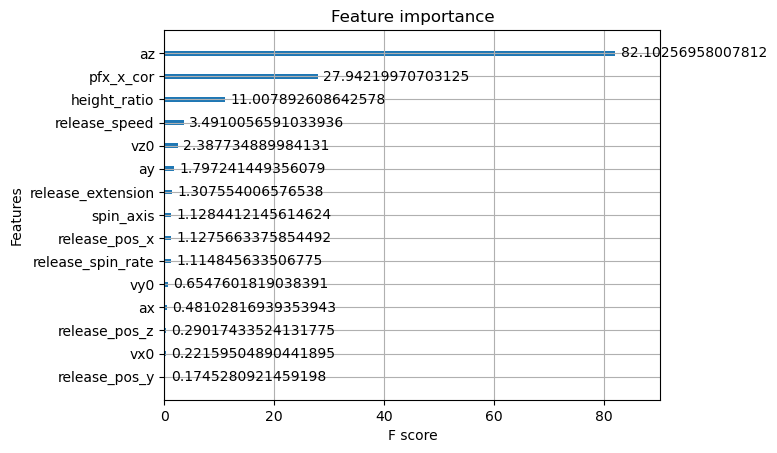

In [196]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [197]:
y_pred = final_model.predict(dtest)

In [198]:
print(y_pred.min())

-1.2473146


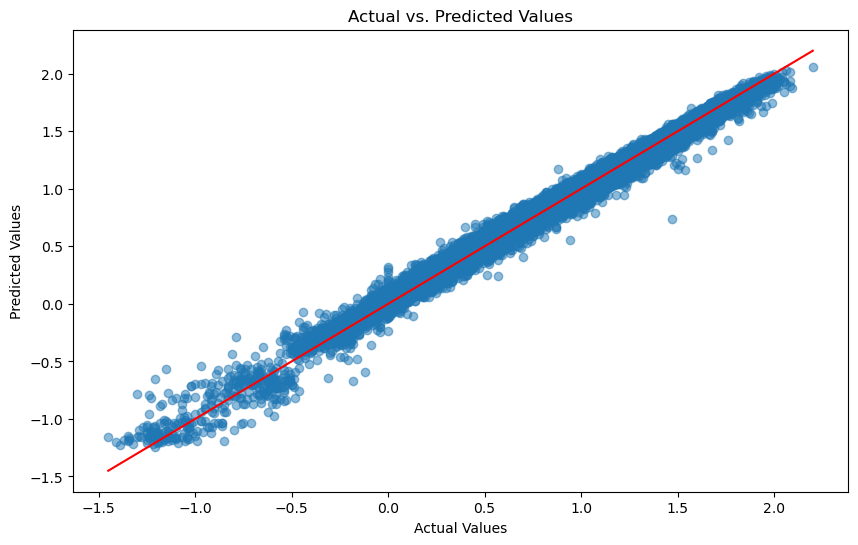

In [199]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

## Testing Data Set Predictions

In [200]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'spin_axis', 'pfx_x_cor', 'height_ratio'],
      dtype='object')

In [204]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [207]:
testing_identifiers['xpfx_z'] = predictions

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_23492\3178676935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xpfx_z'] = predictions


In [210]:
testing_identifiers.head()

pitch_id_raw    xpfx_z
0  663364_455139_617228_4_75_10  1.351116
1  663364_455139_617228_3_75_10  1.399444
2  663364_455139_617228_2_75_10  1.320489
3  663364_455139_617228_1_75_10  1.313488
5  663364_593428_605347_4_72_10  1.466073

In [209]:
testing_identifiers.drop(['xfoul'], axis=1, inplace=True)

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_23492\3370782776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers.drop(['xfoul'], axis=1, inplace=True)


In [212]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/IVB_2022&3_xpfz.csv")

# Offspeed Model 

In [ ]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

###  I think that this is the best leaderboard. Filters out the gimme pitches